# Defining Input Parameters

In [ ]:
class InputParameters:
    def __init__(self):
        self.Labels = ['B007', 'B014', 'B021',
                       'IR007', 'IR014', 'IR021',
                       'OR007@6', 'OR014@6', 'OR021@6','normal']
        self.NClasses = len(self.Labels)
        self.RootDIR = "..//..//..//Dataset//BearingDataset//"
        
    def ConditionalParams(self):
        self.Condition = '1'
        # self.Position can be 'DE' for Drive End or 'FE' for Fan End
        self.Position = 'FE' 
        
    def ExecutionParameters(self):
        self.FileReading = True
    
    def Parameters(self):
        self.SegmentSize = 224
        self.NScales = 28
        #Balancing the labels?
        self.LabelBalancing = True
        #Wavelet Size
        self.Waveletsize = {'Col':self.SegmentSize,
                            'Row':self.NScales}
        # VGG16 Input shape:
        self.NChannels = 3
        self.InputNRow = 224
        self.InputNCol = 224
        
        #Train-Validation-Test split percentage
        self.TrainPercentage = 70
        self.ValidationPercentage = 15
        self.TestPercentage = 100 - self.TrainPercentage - self.ValidationPercentage

        #Activating BatchNormalization
        self.BatchNorm = True

        #Activating feature maps normalization
        self.FeatureMapNorm = False
        
        # Percentage of active samples in Training/Validation/Testing
        self.ActiveSamplesPercentage = 95

# File Loading and Feature Extraction

In [ ]:
class FileLoding:
    def __init__(self):
        pass
    
    def DataLoader(self, IP, root_path):
        self.Data = {}
        for NameRoot in IP.Labels:
            from scipy.io import loadmat
            file_name = root_path + 'Dataset/' + NameRoot + '_' + IP.Condition + '.mat'
            DataDict = loadmat(file_name)
            print('file {} was read.'.format(file_name))
            S = list(DataDict.keys())
            for s in S:
                if IP.Position in s:
                    Code = s
                    break
            
            self.Data[NameRoot] = DataDict[Code]
            print('Code: {}'.format(Code))
            
    def LabelEncoding(self,IP):
        from sklearn.preprocessing import OneHotEncoder
        import numpy as np
        self.LabelEncoder = OneHotEncoder()
        LabelsVector = np.array(IP.Labels).reshape((len(IP.Labels),1))
        self.LabelEncoder.fit(LabelsVector)
        
    
    def Wavelets(self, IP):
        from scipy import signal
        import numpy as np
        self.SignalCWT = {}
        self.NSegments = {}
        self.NWavelets = {}
        self.TotalSamples = 0
        # Determination of minimum length of signal for label balancing
        length = []
        for label in IP.Labels:
            self.Data[label] = self.Data[label].flatten()
            length.append(self.Data[label].size)
        length = np.array(length)
        MinLength = length.min()


        for label in IP.Labels:
            #self.Data[label] = self.Data[label].flatten()
            if IP.LabelBalancing:
                Length = MinLength
            else:
                Length = self.Data[label].size
            self.NSegments[label] = Length//IP.SegmentSize
            self.SignalCWT[label] = []
            for index in range (self.NSegments[label]):
                StartIndex = index*IP.SegmentSize
                EndIndex = (index+1)*IP.SegmentSize
                print ('Start: {}, End: {}'.format(StartIndex, EndIndex))
                CroppedSignal = self.Data[label][StartIndex:EndIndex]
                CWTMatrix = signal.cwt(CroppedSignal, wavelet = signal.ricker, widths = np.arange(1,IP.NScales+1))
                self.SignalCWT[label].append(CWTMatrix)
            self.NWavelets[label] = len(self.SignalCWT[label])
            self.TotalSamples += self.NWavelets[label]
    
    def Feature_Target_Matrices(self, IP):
        #Generation of Feature Matrix and Encoded Target Matrix (one-hot encoded)
        #########################################################################
        
        import numpy as np
        InputShape = (self.TotalSamples, IP.Waveletsize['Row'], IP.Waveletsize['Col'])
        FeatureMatrix = np.zeros(InputShape)
        # Target shape after one hot encoding
        TargetShape = (self.TotalSamples,IP.NClasses)
        TargetMatrix = np.zeros(TargetShape)
        
        # Generation of labels vector
        YVector = []
        for label in IP.Labels:
            for i in range(self.NWavelets[label]):
                YVector.extend([label])
        YVectorShape = (self.TotalSamples,1)
        YVector = np.array(YVector).reshape(YVectorShape)
        #One hot encoding of Target Vector into a matrix
        TargetMatrix = self.LabelEncoder.transform(YVector).toarray()
        
        # Generation of Features array
        StartIndex = 0
        for label in IP.Labels:
            NSamples = self.NWavelets[label]
            EndIndex = StartIndex + NSamples
            FeatureMatrix[StartIndex:EndIndex,:,:] = self.SignalCWT[label]
            StartIndex = EndIndex
            
        self.FeatureMatrixOverall = FeatureMatrix
        self.TargetMatrixOverall = TargetMatrix
        
    def Train_Val_Test_Split(self, IP):
        import numpy as np
        from math import floor
        
        self.NSamples = {'Train':floor(IP.TrainPercentage/100*self.TotalSamples),
                         'Val':floor((IP.ValidationPercentage)/100*self.TotalSamples)}
        self.NSamples['Test'] = self.TotalSamples - self.NSamples['Train'] - self.NSamples['Val']
        
        StartIndex = {'Train':0,
                      'Val':self.NSamples['Train'],
                      'Test':self.NSamples['Train']+self.NSamples['Val']}
        EndIndex = {'Train':StartIndex['Val'],
                    'Val':StartIndex['Test'],
                    'Test':self.TotalSamples}
        
        Phase = ['Train', 'Val', 'Test']
        for status in Phase:
            print('{}; Start:{} , End:{}'.format(status, StartIndex[status], EndIndex[status]))
        
        np.random.seed(50)
        Perm = np.random.permutation(self.TotalSamples)
        self.Indices = {}
        for status in Phase:
            self.Indices[status] = Perm[StartIndex[status]:EndIndex[status]]
        
        self.FeatureMatrix = {'Train':np.zeros((self.NSamples['Train'], IP.Waveletsize['Row'], IP.Waveletsize['Col'])),
                              'Val':np.zeros((self.NSamples['Val'], IP.Waveletsize['Row'], IP.Waveletsize['Col'])),
                              'Test':np.zeros((self.NSamples['Test'], IP.Waveletsize['Row'], IP.Waveletsize['Col']))}
        
        self.TargetMatrix = {'Train':np.zeros((self.NSamples['Train'],IP.NClasses)),
                              'Val':np.zeros((self.NSamples['Val'],IP.NClasses)),
                              'Test':np.zeros((self.NSamples['Test'],IP.NClasses))}
        
        for status in Phase:
            counter = 0
            for index in self.Indices[status]:
                self.FeatureMatrix[status][counter,:,:] = self.FeatureMatrixOverall[index,:,:]
                self.TargetMatrix[status][counter,:] = self.TargetMatrixOverall[index,:]
                counter += 1
                
    def ResizingFeatureMatrix(self, status, IP):
        import numpy as np
        # Resizing feature matrices to the required size for 
        # Transfer learning architecture (Except for the number of channels
        # Which is updated in the "WaveletDataset" Class, the __getitem__ method)
        OrigResolution = {'x':IP.Waveletsize['Col'],
                    'y':IP.Waveletsize['Row']}
        ScaleFactor = {'x':IP.InputNCol/IP.Waveletsize['Col'],
                       'y':IP.InputNRow/IP.Waveletsize['Row']}
#        ScaledOriginalGrid = {'x':IP.Waveletsize['Col'],
#                    'y':IP.Waveletsize['Row']}
        TargetResolution = {'x':IP.InputNCol,
                      'y':IP.InputNRow}
        
        GridColIndices, GridRowIndices = np.meshgrid(np.arange(0,TargetResolution['x']), np.arange(0,TargetResolution['y']))
        
        ResizedFeatureMatrixShape = (self.NSamples[status], IP.InputNRow, IP.InputNCol)
        FeatureMatrixResized = np.zeros(ResizedFeatureMatrixShape)
        from math import floor
        from scipy.interpolate import griddata
        from tqdm import tqdm
        for sample in tqdm(range(self.NSamples[status])):
            InputPoints = []
            KnownTargetValue = []
            for y in range(OrigResolution['y']):
                for x in range(OrigResolution['x']):
                    InputPoints.extend([(floor(x*ScaleFactor['x']),floor(y*ScaleFactor['y']))])
                    KnownTargetValue.extend([self.FeatureMatrix[status][sample, y, x]])
            FeatureMatrixResized[sample,:,:] = griddata(InputPoints, KnownTargetValue, (GridColIndices, GridRowIndices), method='linear')
            #Replacing nan with the nearest value
            if TargetResolution['y'] > (OrigResolution['y'] - 1)*ScaleFactor['y']:
                MinIndex = round((OrigResolution['y'] - 1)*ScaleFactor['y'])
                MaxIndex = TargetResolution['y']
                for index in range (MinIndex+1, MaxIndex):
                    FeatureMatrixResized[sample,index,:] = FeatureMatrixResized[sample,MinIndex,:]
                    
            if TargetResolution['x'] > (OrigResolution['x'] - 1)*ScaleFactor['x']:
                MinIndex = round((OrigResolution['x'] - 1)*ScaleFactor['x'])
                MaxIndex = TargetResolution['x']
                for index in range (MinIndex+1, MaxIndex):
                    FeatureMatrixResized[sample,:,index] = FeatureMatrixResized[sample,:,MinIndex]
                
            if sample % 50 == 0:
                print()
                #print('Resizing Stage: {}% Completed'.format(sample/self.NSamples[status]*100))
        self.FeatureMatrixProcessed[status] = FeatureMatrixResized
        del FeatureMatrixResized

    def NormalizingFeatureMatrix(self, status, IP):
        import cv2
        import numpy as np
        for sample in range(self.NSamples[status]):
            OriginalFeatureMap = self.FeatureMatrixProcessed[status][sample].copy()
            ResultingFeatureMap = np.zeros((IP.InputNRow, IP.InputNCol))
            NormalizedFeatureMap = cv2.normalize(OriginalFeatureMap,ResultingFeatureMap, 0, 1, cv2.NORM_MINMAX)
            self.FeatureMatrixProcessed[status][sample,:,:] = NormalizedFeatureMap

# Class for Dataset Loading

In [ ]:
from torch.utils.data import Dataset
class WaveletDataset(Dataset):
    def __init__(self, FeatureMatrix, TargetMatrix, IP):
        import torch
        from math import floor
        N_ActiveSamples = floor(FeatureMatrix.shape[0]* IP.ActiveSamplesPercentage/100)
        self.x = torch.tensor(FeatureMatrix[0:N_ActiveSamples])
        self.y = torch.tensor(TargetMatrix[0:N_ActiveSamples], dtype = torch.long)
           
        self.len = self.x.shape[0]

    def __getitem__(self,index):
        import torch
        TempMat = self.x[index].clone()
        Dim1, Dim2 = TempMat.shape[0], TempMat.shape[1]
        X = torch.zeros((3,Dim1,Dim2))
        for channel in range (3):
            X[channel,:,:] = TempMat[:,:]
        return X, self.y[index]
    
    def __len__(self):
        return self.len

# Transfer Learning and Classification

In [ ]:
class CV_TL_Classifier:
    def __init__(self):
        self.TrainBatchSize = 16
        self.ValBatchSize = 1
        self.lr = 0.000001
        self.momentum = 0.9
        self.NEpochs = 50
        self.lr_scheduler=True
        self.base_lr=0.001
        self.max_lr=0.01
        
    def PretrainedModelLoader(self):
        import torch
        import torchvision.models as models
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("the device type is", self.device)
        #self.model = models.vgg16(pretrained=False)
        #self.model.load_state_dict(torch.load('..//vgg16-397923af_2.pth'))
        from google.colab import output
        output.enable_custom_widget_manager()
        self.model = models.vgg16(pretrained=True)
        output.disable_custom_widget_manager()

        if IP.BatchNorm:
            self.RequiresGrad = {'0':{'Name':'Feat_Conv 1.1_Weight', 'Value':False},
                  '1':{'Name':'Feat_Conv 1.1_Bias', 'Value':False},
                  '2':{'Name':'Feat_Conv 1.2_Weight', 'Value':False},
                  '3':{'Name':'Feat_Conv 1.2_Bias', 'Value':False},
                  '4':{'Name':'Feat_Conv 2.1_Weight', 'Value':False},
                  '5':{'Name':'Feat_Conv 2.1_Bias', 'Value':False},
                  '6':{'Name':'Feat_Conv 2.2_Weight', 'Value':False},
                  '7':{'Name':'Feat_Conv 2.2_Bias', 'Value':False},
                  '8':{'Name':'Feat_Conv 3.1_Weight', 'Value':False},
                  '9':{'Name':'Feat_Conv 3.1_Bias', 'Value':False},
                  '10':{'Name':'Feat_Conv 3.2_Weight', 'Value':False},
                  '11':{'Name':'Feat_Conv 3.2_Bias', 'Value':False},
                  '12':{'Name':'Feat_Conv 3.3_Weight', 'Value':False},
                  '13':{'Name':'Feat_Conv 3.3_Bias', 'Value':False},
                  '14':{'Name':'Feat_Conv 4.1_Weight', 'Value':False},
                  '15':{'Name':'Feat_Conv 4.1_Bias', 'Value':False},
                  '16':{'Name':'Feat_Conv 4.2_Weight', 'Value':False},
                  '17':{'Name':'Feat_Conv 4.2_Bias', 'Value':False},
                  '18':{'Name':'Feat_Conv 4.3_Weight', 'Value':False},
                  '19':{'Name':'Feat_Conv 4.3_Bias', 'Value':False},
                  '20':{'Name':'Feat_Conv 5.1_Weight', 'Value':False},
                  '21':{'Name':'Feat_Conv 5.1_Bias', 'Value':False},
                  '22':{'Name':'Feat_Conv 5.2_Weight', 'Value':False},
                  '23':{'Name':'Feat_Conv 5.2_Bias', 'Value':False},
                  '24':{'Name':'Feat_Conv 5.3_Weight', 'Value':False},
                  '25':{'Name':'Feat_Conv 5.3_Bias', 'Value':False},
                  '26':{'Name':'Class_FC1_Weight', 'Value':False},
                  '27':{'Name':'Class_FC1_Bias', 'Value':False},
                  '28':{'Name':'BNN1_Weight', 'Value':False},
                  '29':{'Name':'BNN1_Bias', 'Value':False},
                  '30':{'Name':'Class_FC2_Weight', 'Value':False},
                  '31':{'Name':'Class_FC2_Bias', 'Value':False},
                  '32':{'Name':'BNN2_Weight', 'Value':False},
                  '33':{'Name':'BNN2_Bias', 'Value':False},
                  '34':{'Name':'Class_FC3_Weight', 'Value':False},
                  '35':{'Name':'Class_FC3_Bias', 'Value':False}}
        else:
            self.RequiresGrad = {'0':{'Name':'Feat_Conv 1.1_Weight', 'Value':False},
                  '1':{'Name':'Feat_Conv 1.1_Bias', 'Value':False},
                  '2':{'Name':'Feat_Conv 1.2_Weight', 'Value':False},
                  '3':{'Name':'Feat_Conv 1.2_Bias', 'Value':False},
                  '4':{'Name':'Feat_Conv 2.1_Weight', 'Value':False},
                  '5':{'Name':'Feat_Conv 2.1_Bias', 'Value':False},
                  '6':{'Name':'Feat_Conv 2.2_Weight', 'Value':False},
                  '7':{'Name':'Feat_Conv 2.2_Bias', 'Value':False},
                  '8':{'Name':'Feat_Conv 3.1_Weight', 'Value':False},
                  '9':{'Name':'Feat_Conv 3.1_Bias', 'Value':False},
                  '10':{'Name':'Feat_Conv 3.2_Weight', 'Value':False},
                  '11':{'Name':'Feat_Conv 3.2_Bias', 'Value':False},
                  '12':{'Name':'Feat_Conv 3.3_Weight', 'Value':False},
                  '13':{'Name':'Feat_Conv 3.3_Bias', 'Value':False},
                  '14':{'Name':'Feat_Conv 4.1_Weight', 'Value':False},
                  '15':{'Name':'Feat_Conv 4.1_Bias', 'Value':False},
                  '16':{'Name':'Feat_Conv 4.2_Weight', 'Value':False},
                  '17':{'Name':'Feat_Conv 4.2_Bias', 'Value':False},
                  '18':{'Name':'Feat_Conv 4.3_Weight', 'Value':False},
                  '19':{'Name':'Feat_Conv 4.3_Bias', 'Value':False},
                  '20':{'Name':'Feat_Conv 5.1_Weight', 'Value':False},
                  '21':{'Name':'Feat_Conv 5.1_Bias', 'Value':False},
                  '22':{'Name':'Feat_Conv 5.2_Weight', 'Value':False},
                  '23':{'Name':'Feat_Conv 5.2_Bias', 'Value':False},
                  '24':{'Name':'Feat_Conv 5.3_Weight', 'Value':False},
                  '25':{'Name':'Feat_Conv 5.3_Bias', 'Value':False},
                  '26':{'Name':'Class_FC1_Weight', 'Value':False},
                  '27':{'Name':'Class_FC1_Bias', 'Value':False},
                  '28':{'Name':'Class_FC2_Weight', 'Value':False},
                  '29':{'Name':'Class_FC2_Bias', 'Value':False},
                  '30':{'Name':'Class_FC3_Weight', 'Value':False},
                  '31':{'Name':'Class_FC3_Bias', 'Value':False}}  
 
        
    def PrepareModel(self, IP, Data):
        import torch.nn as nn
        import torch
        for param in self.model.parameters():
            param.requires_grad = False
        
        N_in_features = self.model.classifier[6].in_features
        if IP.BatchNorm:
            NewArch = list(self.model.classifier.children())[:-6] # Remove two last layers
            NewArch.extend([nn.BatchNorm1d(4096),
                            nn.ReLU(inplace=True),
                            nn.Linear(4096, 4096),
                            nn.BatchNorm1d(4096),
                            nn.ReLU(inplace=True),
                            nn.Linear(N_in_features, IP.NClasses)]) # Add our layers with NClasses outputs
        else:
            NewArch = list(self.model.classifier.children())[:-1] # Remove last layer
            NewArch.extend([nn.Linear(N_in_features, IP.NClasses)]) # Add our layer with NClasses outputs
        self.model.classifier = nn.Sequential(*NewArch) # Updating the model classifier
        
    def UnfreezingLayers(self, unfrozen_parameters):
        ActiveParameters = unfrozen_parameters
        for i, param in enumerate(self.model.parameters()):
            param.requires_grad = False
            self.RequiresGrad[str(i)]['Value'] = False

        for i, param in enumerate(self.model.parameters()):
            if i in ActiveParameters:
              self.RequiresGrad[str(i)]['Value'] = True
              param.requires_grad = True
            print(i, self.RequiresGrad[str(i)]['Name'], param.requires_grad)
        self.model.to(self.device)

    def DeepLearningSetting(self):
        import torch
        import torch.nn as nn
    
        self.criterion = nn.CrossEntropyLoss()
        from torch.utils.data import DataLoader
        self.TrainLoader = DataLoader(dataset=Data.WaveDataset['Train'] ,batch_size=self.TrainBatchSize, shuffle=True)
        self.ValidationLoader= DataLoader(dataset=Data.WaveDataset['Val'] , batch_size=self.ValBatchSize)
        
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        self.optimizer = torch.optim.SGD([params for params in self.model.parameters() if params.requires_grad], lr=self.lr, momentum=self.momentum)
        
        if self.lr_scheduler:
            self.scheduler = torch.optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=self.base_lr, max_lr=self.max_lr, step_size_up=5 ,mode="triangular2")
    
    def TrainModel(self, IP, Data, Plots):
        import numpy as np
        import torch
        import copy
        from tqdm import tqdm
        
        self.loss_list = {'Train':[], 'Val':[]}
        self.accuracy_list = {'Train':[], 'Val':[]}
        F1Score = []
        accuracy_best=0
        ReportInterval = self.NEpochs // 5
        for epoch in tqdm(range(self.NEpochs)):
            correct = 0
            counter = 0
            loss_sublist = {'Train':[], 'Val':[]}
            for x, y in tqdm(self.TrainLoader):
                x, y = x.to(self.device), y.to(self.device)
                self.model.train()
                
                z = self.model(x)
                #Evaluation of training loss
                loss = self.criterion(z, torch.max(y,1)[1])
                loss_sublist['Train'].append(loss.data.item())
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                print('Batch Loss: {}'.format(loss.data.item()))

                #Evaluation of training accuracy
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == torch.max(y,1)[1]).sum().item()
                counter += 1

            n_train = Data.WaveDataset['Train'].y.shape[0]
            accuracy = correct / n_train
            self.accuracy_list['Train'].append(accuracy)    
            print("epoch {} done".format(epoch) )
            self.scheduler.step()    
            self.loss_list['Train'].append(np.mean(loss_sublist['Train']))
            
            
            
            correct = 0
            counter = 0
            Y_True_Val = []
            Y_Pred_Val = []
            for x_val, y_val in tqdm(self.ValidationLoader):
                x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                self.model.eval()
                z = self.model(x_val)
                #Evaluation of validation loss
                loss = self.criterion(z, torch.max(y_val,1)[1])
                loss_sublist['Val'].append(loss.data.item())

                #Evaluation of validation accuracy
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == torch.max(y_val,1)[1]).sum().item()
                Y_True_Val.append(torch.max(y_val,1)[1].item())
                Y_Pred_Val.append(yhat.item())
                counter += 1
                print('Accuracy:{:4.2f}%; True:{}; Predicted:{}'.format(correct/counter*100, torch.max(y_val,1)[1].item(), yhat.item()))
            
            Y_True_Val_Mat = np.array(Y_True_Val)
            Y_Pred_Val_Mat = np.array(Y_Pred_Val)
            from sklearn.metrics import f1_score
            f1 = f1_score(Y_True_Val_Mat, Y_Pred_Val_Mat, average='weighted')
            F1Score.append(f1)
            if epoch % ReportInterval == 0:
              Plots.ConfusionMatrix(IP, Y_True_Val, Y_Pred_Val)

            self.loss_list['Val'].append(np.mean(loss_sublist['Val']))
            n_val = Data.WaveDataset['Val'].y.shape[0]
            accuracy = correct / n_val
            self.accuracy_list['Val'].append(accuracy)
            if accuracy > accuracy_best:
                accuracy_best=accuracy
                best_model_wts = copy.deepcopy(self.model.state_dict())
                
            print('learning rate',self.optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist['Val'])))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))
            print("F1-score for epoch " + str(epoch + 1) + ": " + str(f1))

        Plots.TrainingProcess(self.accuracy_list, self.loss_list)    

        self.model.load_state_dict(best_model_wts)

# Generation of Output Plots

In [ ]:
class PlotOutputs:
    def __init__(self):
        pass
    
    def PlotMultipleWavelets(self, IP, Data, index):
        # This function plots wavelets for different faults and a specific index
        # of segmented signal
        import matplotlib.pyplot as plt
        Fig, Ax = plt.subplots(3,4) 
        for i,label in enumerate(IP.Labels):
            col = i%4
            row = i//4
            CWTMatrix = Data.SignalCWT[label][index]
            Ax[row,col].imshow(CWTMatrix, cmap='PRGn', aspect='auto',vmax=abs(CWTMatrix).max(), vmin=-abs(CWTMatrix).max())
                

    def PlotOneWavelet(self, Matrix):
        # This function plots a wavelet based on the input Matrix
        import matplotlib.pyplot as plt
        plt.figure()
        plt.imshow(Matrix, cmap='PRGn', aspect='auto',vmax=abs(Matrix).max(), vmin=-abs(Matrix).max())
    
    def ConfusionMatrix(self, IP, Y_True_Val, Y_Pred_Val):
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        import numpy as np
        np.set_printoptions(precision=2)
        Y_True_Val = np.array(Y_True_Val)
        Y_Pred_Val = np.array(Y_Pred_Val)
        plt.figure()
        ClassNames = IP.Labels
        CNFMAT = confusion_matrix(Y_True_Val, Y_Pred_Val)
        Title='Confusion Matrix'
        CMAP=plt.cm.Blues

        CNFMAT = CNFMAT.astype('float')/CNFMAT.sum(axis=1)[:,np.newaxis]
        plt.figure(figsize=(10,10))
        plt.imshow(CNFMAT,interpolation='nearest',cmap=CMAP)
        plt.title(Title)
        plt.colorbar()
        tick_marks = np.arange(len(ClassNames))
        plt.xticks(tick_marks, ClassNames, rotation=90)
        plt.yticks(tick_marks, ClassNames)
        
        import itertools
        fmt = '.2f'
        thresh = CNFMAT.max()/2.
        for i,j in itertools.product(range(CNFMAT.shape[0]),range(CNFMAT.shape[1])):
            plt.text(j,i,format(CNFMAT[i,j],fmt),
                horizontalalignment="center",
                color="white" if CNFMAT[i,j] > thresh else "black")
            pass
        
        plt.ylabel('True Labels')
        plt.xlabel('Predicted Labels')
        pass

    def TrainingProcess(self, Accuracies, Losses):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1,2,figsize=(15,5))
        ax[0].set_title("Loss")
        ax[1].set_title("Accuracy")
        for status in ['Train', 'Val']:
            ax[0].plot(Losses[status], label = status)
            ax[1].plot(Accuracies[status], label= status)
               
        ax[0].legend(loc="upper right")
        ax[1].legend(loc="lower right")

# Main Program: File Loading, Data Pre-process and Feature extraction

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/ML Projects/FaultDiagBearing/'

Mounted at /content/gdrive


In [ ]:
import numpy as np

IP = InputParameters()
IP.ConditionalParams()
IP.Parameters()
IP.ExecutionParameters()
Data = FileLoding()
Plots = PlotOutputs()
if IP.FileReading:
    Data.DataLoader(IP, root_path)
    Data.LabelEncoding(IP)
    Data.Wavelets(IP)
    Plots.PlotMultipleWavelets(IP, Data, index=50)
    Data.Feature_Target_Matrices(IP)
    Data.Train_Val_Test_Split(IP)
    Data.FeatureMatrixProcessed = {}
    for status in ['Train', 'Val', 'Test']:
        Data.ResizingFeatureMatrix(status, IP)
        if IP.FeatureMapNorm:
            Data.NormalizingFeatureMatrix(status, IP)
            Extension = 'Normalized'
        else:
            Extension = 'Normal'
        with open(root_path + 'GeneratedFeatures/' + status + 'Features'+Extension+'.npy', 'wb') as file:
            np.save(file,Data.FeatureMatrixProcessed[status])
        with open(root_path + 'GeneratedFeatures/' + status + 'Targets'+Extension+'.npy', 'wb') as file:
            np.save(file,Data.TargetMatrix[status])
else:
    Data.FeatureMatrixProcessed = {}
    Data.TargetMatrix = {}
    if IP.FeatureMapNorm:
        Extension = 'Normalized'
    else:
        Extension = 'Normal'
    for status in ['Train', 'Val', 'Test']:
        with open(root_path + 'GeneratedFeatures/' + status + 'Features'+Extension+'.npy', 'rb') as file:
            Data.FeatureMatrixProcessed[status] = np.load(file)
        with open(root_path + 'GeneratedFeatures/' + status + 'Targets'+Extension+'.npy', 'rb') as file:
            Data.TargetMatrix[status] = np.load(file)

# Training of Model and Generation of Output Results

the device type is cuda:0


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

0 Feat_Conv 1.1_Weight False
1 Feat_Conv 1.1_Bias False
2 Feat_Conv 1.2_Weight False
3 Feat_Conv 1.2_Bias False
4 Feat_Conv 2.1_Weight False
5 Feat_Conv 2.1_Bias False
6 Feat_Conv 2.2_Weight False
7 Feat_Conv 2.2_Bias False
8 Feat_Conv 3.1_Weight False
9 Feat_Conv 3.1_Bias False
10 Feat_Conv 3.2_Weight False
11 Feat_Conv 3.2_Bias False
12 Feat_Conv 3.3_Weight False
13 Feat_Conv 3.3_Bias False
14 Feat_Conv 4.1_Weight False
15 Feat_Conv 4.1_Bias False
16 Feat_Conv 4.2_Weight False
17 Feat_Conv 4.2_Bias False
18 Feat_Conv 4.3_Weight False
19 Feat_Conv 4.3_Bias False
20 Feat_Conv 5.1_Weight False
21 Feat_Conv 5.1_Bias False
22 Feat_Conv 5.2_Weight False
23 Feat_Conv 5.2_Bias False
24 Feat_Conv 5.3_Weight False
25 Feat_Conv 5.3_Bias False
26 Class_FC1_Weight True
27 Class_FC1_Bias True
28 BNN1_Weight True
29 BNN1_Bias True
30 Class_FC2_Weight True
31 Class_FC2_Bias True
32 BNN2_Weight True
33 BNN2_Bias True
34 Class_FC3_Weight True
35 Class_FC3_Bias True


  1%|          | 2/226 [00:06<10:48,  2.89s/it]

Batch Loss: 2.372817277908325
Batch Loss: 2.280766248703003



  2%|▏         | 4/226 [00:07<03:47,  1.03s/it]

Batch Loss: 1.9809250831604004
Batch Loss: 1.695090413093567



  3%|▎         | 6/226 [00:07<01:48,  2.03it/s]

Batch Loss: 1.4671422243118286
Batch Loss: 1.3076553344726562



  4%|▎         | 8/226 [00:07<01:01,  3.55it/s]

Batch Loss: 1.3642576932907104
Batch Loss: 1.7039175033569336



  4%|▍         | 10/226 [00:07<00:40,  5.31it/s]

Batch Loss: 1.2261147499084473
Batch Loss: 1.6118313074111938



  5%|▌         | 12/226 [00:08<00:30,  6.95it/s]

Batch Loss: 0.9970815181732178
Batch Loss: 1.7548253536224365



  6%|▌         | 14/226 [00:08<00:26,  8.08it/s]

Batch Loss: 1.0101912021636963
Batch Loss: 0.7712811827659607



  7%|▋         | 16/226 [00:08<00:23,  8.83it/s]

Batch Loss: 0.9595585465431213
Batch Loss: 0.865811824798584



  8%|▊         | 18/226 [00:08<00:22,  9.19it/s]

Batch Loss: 0.7430069446563721
Batch Loss: 1.2549799680709839



  9%|▉         | 20/226 [00:08<00:21,  9.40it/s]

Batch Loss: 0.9745371341705322
Batch Loss: 1.085862398147583



 10%|▉         | 22/226 [00:09<00:21,  9.49it/s]

Batch Loss: 0.9913210272789001
Batch Loss: 0.7859665751457214



 11%|█         | 24/226 [00:09<00:21,  9.60it/s]

Batch Loss: 0.7391957640647888
Batch Loss: 0.6231783628463745



 12%|█▏        | 26/226 [00:09<00:20,  9.58it/s]

Batch Loss: 0.5912090539932251
Batch Loss: 0.571159839630127



 12%|█▏        | 28/226 [00:09<00:21,  9.39it/s]

Batch Loss: 0.5158848762512207
Batch Loss: 1.236863613128662



 13%|█▎        | 30/226 [00:09<00:20,  9.41it/s]

Batch Loss: 1.0692250728607178
Batch Loss: 0.8342549800872803



 14%|█▍        | 32/226 [00:10<00:20,  9.43it/s]

Batch Loss: 0.8302872180938721
Batch Loss: 0.8113970756530762



 15%|█▌        | 34/226 [00:10<00:20,  9.41it/s]

Batch Loss: 0.6907517313957214
Batch Loss: 0.816963791847229



 16%|█▌        | 36/226 [00:10<00:20,  9.33it/s]

Batch Loss: 0.7670822143554688
Batch Loss: 0.44187307357788086



 17%|█▋        | 38/226 [00:10<00:20,  9.26it/s]

Batch Loss: 0.5228519439697266
Batch Loss: 0.6380799412727356



 18%|█▊        | 40/226 [00:10<00:20,  9.23it/s]

Batch Loss: 0.8996832966804504
Batch Loss: 0.6655195355415344



 19%|█▊        | 42/226 [00:11<00:19,  9.23it/s]

Batch Loss: 0.5961207151412964
Batch Loss: 0.6604499816894531



 19%|█▉        | 44/226 [00:11<00:19,  9.32it/s]

Batch Loss: 0.6132966876029968
Batch Loss: 0.64003586769104



 20%|██        | 46/226 [00:11<00:19,  9.41it/s]

Batch Loss: 0.9378817677497864
Batch Loss: 1.0916328430175781



 21%|██        | 48/226 [00:11<00:19,  9.29it/s]

Batch Loss: 0.6771805286407471
Batch Loss: 0.7460682988166809



 22%|██▏       | 50/226 [00:12<00:19,  9.26it/s]

Batch Loss: 0.6019770503044128
Batch Loss: 0.6968273520469666



 23%|██▎       | 52/226 [00:12<00:18,  9.20it/s]

Batch Loss: 0.8866168260574341
Batch Loss: 0.679176926612854



 24%|██▍       | 54/226 [00:12<00:18,  9.23it/s]

Batch Loss: 0.9362920522689819
Batch Loss: 0.41011345386505127



 25%|██▍       | 56/226 [00:12<00:18,  9.19it/s]

Batch Loss: 0.2400265336036682
Batch Loss: 0.5216962695121765



 26%|██▌       | 58/226 [00:12<00:18,  9.16it/s]

Batch Loss: 0.4643403887748718
Batch Loss: 0.2857553958892822



 27%|██▋       | 60/226 [00:13<00:18,  9.22it/s]

Batch Loss: 0.32749032974243164
Batch Loss: 0.7363587617874146



 27%|██▋       | 62/226 [00:13<00:17,  9.21it/s]

Batch Loss: 1.2457265853881836
Batch Loss: 0.531746506690979



 28%|██▊       | 64/226 [00:13<00:17,  9.36it/s]

Batch Loss: 1.2229664325714111
Batch Loss: 0.1994260996580124



 29%|██▉       | 66/226 [00:13<00:16,  9.43it/s]

Batch Loss: 0.4214800298213959
Batch Loss: 0.48069047927856445



 30%|███       | 68/226 [00:14<00:16,  9.48it/s]

Batch Loss: 0.8890810012817383
Batch Loss: 0.385346382856369



 31%|███       | 70/226 [00:14<00:16,  9.51it/s]

Batch Loss: 0.6851018667221069
Batch Loss: 0.5809666514396667



 32%|███▏      | 72/226 [00:14<00:16,  9.39it/s]

Batch Loss: 0.6430307626724243
Batch Loss: 0.4074247479438782



 33%|███▎      | 74/226 [00:14<00:16,  9.31it/s]

Batch Loss: 0.5270631909370422
Batch Loss: 0.8315520286560059



 34%|███▎      | 76/226 [00:14<00:15,  9.38it/s]

Batch Loss: 0.4146493971347809
Batch Loss: 0.35687631368637085



 35%|███▍      | 78/226 [00:15<00:15,  9.49it/s]

Batch Loss: 0.4263301491737366
Batch Loss: 0.8518480658531189



 35%|███▌      | 80/226 [00:15<00:15,  9.57it/s]

Batch Loss: 0.40769416093826294
Batch Loss: 0.7708597183227539



 36%|███▋      | 82/226 [00:15<00:14,  9.60it/s]

Batch Loss: 0.8073151707649231
Batch Loss: 0.887365996837616



 37%|███▋      | 84/226 [00:15<00:14,  9.55it/s]

Batch Loss: 0.7324249744415283
Batch Loss: 0.8965907692909241



 38%|███▊      | 86/226 [00:15<00:14,  9.58it/s]

Batch Loss: 0.9824569821357727
Batch Loss: 0.5602278113365173



 39%|███▉      | 88/226 [00:16<00:14,  9.49it/s]

Batch Loss: 0.5751553177833557
Batch Loss: 0.3449608385562897



 40%|███▉      | 90/226 [00:16<00:14,  9.52it/s]

Batch Loss: 1.031046986579895
Batch Loss: 0.6972231864929199



 41%|████      | 92/226 [00:16<00:14,  9.54it/s]

Batch Loss: 0.4921519160270691
Batch Loss: 0.5467984080314636



 42%|████▏     | 94/226 [00:16<00:13,  9.43it/s]

Batch Loss: 0.47157615423202515
Batch Loss: 0.6780247688293457



 42%|████▏     | 96/226 [00:16<00:13,  9.34it/s]

Batch Loss: 0.9595237970352173
Batch Loss: 0.8362351655960083



 43%|████▎     | 98/226 [00:17<00:13,  9.44it/s]

Batch Loss: 0.816329836845398
Batch Loss: 0.6287387609481812



 44%|████▍     | 100/226 [00:17<00:13,  9.30it/s]

Batch Loss: 0.45813295245170593
Batch Loss: 0.8369300365447998



 45%|████▌     | 102/226 [00:17<00:13,  9.36it/s]

Batch Loss: 0.8479287624359131
Batch Loss: 0.7422288060188293



 46%|████▌     | 104/226 [00:17<00:12,  9.41it/s]

Batch Loss: 1.0766079425811768
Batch Loss: 0.5121408700942993



 47%|████▋     | 106/226 [00:18<00:12,  9.50it/s]

Batch Loss: 0.7700073719024658
Batch Loss: 0.5681862235069275



 48%|████▊     | 108/226 [00:18<00:12,  9.24it/s]

Batch Loss: 0.6166403889656067
Batch Loss: 1.0623128414154053



 49%|████▊     | 110/226 [00:18<00:12,  9.35it/s]

Batch Loss: 0.9953703284263611
Batch Loss: 0.6685920357704163



 50%|████▉     | 112/226 [00:18<00:12,  9.44it/s]

Batch Loss: 0.6654112935066223
Batch Loss: 0.40441370010375977



 50%|█████     | 114/226 [00:18<00:11,  9.51it/s]

Batch Loss: 0.3750784695148468
Batch Loss: 0.5193966031074524



 51%|█████▏    | 116/226 [00:19<00:11,  9.51it/s]

Batch Loss: 0.34915199875831604
Batch Loss: 0.5251266360282898



 52%|█████▏    | 118/226 [00:19<00:11,  9.53it/s]

Batch Loss: 0.5225706696510315
Batch Loss: 0.5555075407028198



 53%|█████▎    | 120/226 [00:19<00:11,  9.57it/s]

Batch Loss: 0.505733847618103
Batch Loss: 0.523064374923706



 54%|█████▍    | 122/226 [00:19<00:10,  9.56it/s]

Batch Loss: 0.3032936453819275
Batch Loss: 1.0702122449874878



 55%|█████▍    | 124/226 [00:19<00:10,  9.40it/s]

Batch Loss: 0.730272650718689
Batch Loss: 0.37880778312683105



 56%|█████▌    | 126/226 [00:20<00:10,  9.39it/s]

Batch Loss: 0.4949800670146942
Batch Loss: 0.4425767660140991



 57%|█████▋    | 128/226 [00:20<00:10,  9.42it/s]

Batch Loss: 0.7726581692695618
Batch Loss: 0.7416979074478149



 58%|█████▊    | 130/226 [00:20<00:10,  9.45it/s]

Batch Loss: 0.3726106584072113
Batch Loss: 0.4051465690135956



 58%|█████▊    | 132/226 [00:20<00:09,  9.52it/s]

Batch Loss: 0.7526569366455078
Batch Loss: 0.723914623260498



 59%|█████▉    | 134/226 [00:20<00:09,  9.51it/s]

Batch Loss: 0.7558973431587219
Batch Loss: 0.4258894622325897



 60%|██████    | 136/226 [00:21<00:09,  9.55it/s]

Batch Loss: 0.45891690254211426
Batch Loss: 0.8244865536689758



 61%|██████    | 138/226 [00:21<00:09,  9.53it/s]

Batch Loss: 0.2688615024089813
Batch Loss: 0.5675454139709473



 62%|██████▏   | 140/226 [00:21<00:09,  9.51it/s]

Batch Loss: 0.44111305475234985
Batch Loss: 0.23868681490421295



 63%|██████▎   | 142/226 [00:21<00:08,  9.43it/s]

Batch Loss: 0.3447189927101135
Batch Loss: 0.5998625755310059



 64%|██████▎   | 144/226 [00:22<00:08,  9.47it/s]

Batch Loss: 0.2825632393360138
Batch Loss: 0.7168781757354736



 65%|██████▍   | 146/226 [00:22<00:08,  9.44it/s]

Batch Loss: 0.987582266330719
Batch Loss: 0.6099642515182495



 65%|██████▌   | 148/226 [00:22<00:08,  9.45it/s]

Batch Loss: 0.47804227471351624
Batch Loss: 0.6246883869171143



 66%|██████▋   | 150/226 [00:22<00:08,  9.39it/s]

Batch Loss: 0.7871941328048706
Batch Loss: 0.533301591873169



 67%|██████▋   | 152/226 [00:22<00:07,  9.36it/s]

Batch Loss: 0.526386559009552
Batch Loss: 0.9527587294578552



 68%|██████▊   | 154/226 [00:23<00:07,  9.50it/s]

Batch Loss: 0.44326987862586975
Batch Loss: 0.23976317048072815



 69%|██████▉   | 156/226 [00:23<00:07,  9.55it/s]

Batch Loss: 0.6298401355743408
Batch Loss: 0.45007503032684326



 70%|██████▉   | 158/226 [00:23<00:07,  9.42it/s]

Batch Loss: 0.6819844841957092
Batch Loss: 0.9019890427589417



 71%|███████   | 160/226 [00:23<00:07,  9.43it/s]

Batch Loss: 0.2915072441101074
Batch Loss: 0.29058054089546204



 72%|███████▏  | 162/226 [00:23<00:06,  9.34it/s]

Batch Loss: 0.9250498414039612
Batch Loss: 0.6104037761688232



 73%|███████▎  | 164/226 [00:24<00:06,  9.33it/s]

Batch Loss: 0.39800819754600525
Batch Loss: 1.1912086009979248



 73%|███████▎  | 166/226 [00:24<00:06,  9.43it/s]

Batch Loss: 0.484443336725235
Batch Loss: 0.8023438453674316



 74%|███████▍  | 168/226 [00:24<00:06,  9.34it/s]

Batch Loss: 0.588407039642334
Batch Loss: 0.35516494512557983



 75%|███████▌  | 170/226 [00:24<00:05,  9.34it/s]

Batch Loss: 0.3082318603992462
Batch Loss: 0.7138559222221375



 76%|███████▌  | 172/226 [00:25<00:05,  9.20it/s]

Batch Loss: 0.1975671648979187
Batch Loss: 0.21315103769302368



 77%|███████▋  | 174/226 [00:25<00:05,  9.26it/s]

Batch Loss: 0.8775542974472046
Batch Loss: 0.6633279323577881



 78%|███████▊  | 176/226 [00:25<00:05,  9.15it/s]

Batch Loss: 0.41246840357780457
Batch Loss: 0.2735212445259094



 79%|███████▉  | 178/226 [00:25<00:05,  9.22it/s]

Batch Loss: 0.8104478716850281
Batch Loss: 0.4368050992488861



 80%|███████▉  | 180/226 [00:25<00:04,  9.36it/s]

Batch Loss: 0.2924547791481018
Batch Loss: 0.7946998476982117



 81%|████████  | 182/226 [00:26<00:04,  9.42it/s]

Batch Loss: 0.42721065878868103
Batch Loss: 0.6922688484191895



 81%|████████▏ | 184/226 [00:26<00:04,  9.49it/s]

Batch Loss: 0.5734548568725586
Batch Loss: 0.9339194893836975



 82%|████████▏ | 186/226 [00:26<00:04,  9.53it/s]

Batch Loss: 0.6426000595092773
Batch Loss: 0.5264017581939697



 83%|████████▎ | 188/226 [00:26<00:04,  9.48it/s]

Batch Loss: 0.6906636953353882
Batch Loss: 1.3925176858901978



 84%|████████▍ | 190/226 [00:26<00:03,  9.35it/s]

Batch Loss: 0.21019195020198822
Batch Loss: 0.43909990787506104



 85%|████████▍ | 192/226 [00:27<00:03,  9.36it/s]

Batch Loss: 0.6004563570022583
Batch Loss: 0.31181570887565613



 86%|████████▌ | 194/226 [00:27<00:03,  9.35it/s]

Batch Loss: 0.4399891495704651
Batch Loss: 0.6977177858352661



 87%|████████▋ | 196/226 [00:27<00:03,  9.41it/s]

Batch Loss: 0.765688419342041
Batch Loss: 0.45587947964668274



 88%|████████▊ | 198/226 [00:27<00:02,  9.42it/s]

Batch Loss: 0.8698775768280029
Batch Loss: 0.5091772675514221



 88%|████████▊ | 200/226 [00:28<00:02,  9.41it/s]

Batch Loss: 0.44596531987190247
Batch Loss: 0.14931459724903107



 89%|████████▉ | 202/226 [00:28<00:02,  9.42it/s]

Batch Loss: 0.6129113435745239
Batch Loss: 0.6493200659751892



 90%|█████████ | 204/226 [00:28<00:02,  9.38it/s]

Batch Loss: 0.5278512835502625
Batch Loss: 0.6994041204452515



 91%|█████████ | 206/226 [00:28<00:02,  9.33it/s]

Batch Loss: 0.8912959098815918
Batch Loss: 0.6632444858551025



 92%|█████████▏| 208/226 [00:28<00:01,  9.45it/s]

Batch Loss: 0.8983463644981384
Batch Loss: 0.40377214550971985



 93%|█████████▎| 210/226 [00:29<00:01,  9.31it/s]

Batch Loss: 0.4535260796546936
Batch Loss: 0.6310667991638184



 94%|█████████▍| 212/226 [00:29<00:01,  9.27it/s]

Batch Loss: 0.5471385717391968
Batch Loss: 0.5220813155174255



 95%|█████████▍| 214/226 [00:29<00:01,  9.42it/s]

Batch Loss: 0.621749758720398
Batch Loss: 0.28493714332580566



 96%|█████████▌| 216/226 [00:29<00:01,  9.46it/s]

Batch Loss: 0.2495056390762329
Batch Loss: 0.6814145445823669



 96%|█████████▋| 218/226 [00:29<00:00,  9.40it/s]

Batch Loss: 0.9819570183753967
Batch Loss: 0.2502443790435791



 97%|█████████▋| 220/226 [00:30<00:00,  9.43it/s]

Batch Loss: 0.5053637027740479
Batch Loss: 0.2083938866853714



 98%|█████████▊| 222/226 [00:30<00:00,  9.38it/s]

Batch Loss: 0.35321658849716187
Batch Loss: 0.11135003715753555



 99%|█████████▉| 224/226 [00:30<00:00,  9.43it/s]

Batch Loss: 0.8076118230819702
Batch Loss: 0.5152536034584045



100%|██████████| 226/226 [00:30<00:00,  7.36it/s]


Batch Loss: 0.6221691370010376
Batch Loss: 0.2769795358181
epoch 0 done



  1%|          | 9/772 [00:00<00:08, 87.97it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:8
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7



  2%|▏         | 18/772 [00:00<00:08, 87.07it/s]

Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:85.71%; True:1; Predicted:2
Accuracy:86.67%; True:8; Predicted:8
Accuracy:87.50%; True:8; Predicted:8
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.89%; True:2; Predicted:2



  3%|▎         | 27/772 [00:00<00:08, 88.18it/s]

Accuracy:89.47%; True:9; Predicted:9
Accuracy:85.00%; True:0; Predicted:7
Accuracy:85.71%; True:0; Predicted:0
Accuracy:81.82%; True:4; Predicted:2
Accuracy:82.61%; True:3; Predicted:3
Accuracy:83.33%; True:6; Predicted:6
Accuracy:80.00%; True:4; Predicted:2
Accuracy:80.77%; True:0; Predicted:0
Accuracy:81.48%; True:9; Predicted:9
Accuracy:82.14%; True:6; Predicted:6



  5%|▍         | 36/772 [00:00<00:08, 88.01it/s]

Accuracy:82.76%; True:9; Predicted:9
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.87%; True:2; Predicted:2
Accuracy:84.38%; True:7; Predicted:7
Accuracy:81.82%; True:2; Predicted:7
Accuracy:82.35%; True:8; Predicted:8
Accuracy:82.86%; True:7; Predicted:7
Accuracy:83.33%; True:3; Predicted:3



  6%|▌         | 45/772 [00:00<00:08, 88.69it/s]

Accuracy:81.08%; True:4; Predicted:2
Accuracy:81.58%; True:8; Predicted:8
Accuracy:82.05%; True:1; Predicted:1
Accuracy:80.00%; True:4; Predicted:2
Accuracy:80.49%; True:7; Predicted:7
Accuracy:80.95%; True:5; Predicted:5
Accuracy:79.07%; True:4; Predicted:1
Accuracy:79.55%; True:1; Predicted:1
Accuracy:77.78%; True:4; Predicted:7
Accuracy:78.26%; True:3; Predicted:3



  7%|▋         | 54/772 [00:00<00:08, 87.20it/s]

Accuracy:78.72%; True:5; Predicted:5
Accuracy:77.08%; True:7; Predicted:2
Accuracy:77.55%; True:5; Predicted:5
Accuracy:78.00%; True:8; Predicted:8
Accuracy:78.43%; True:5; Predicted:5
Accuracy:78.85%; True:6; Predicted:6
Accuracy:79.25%; True:8; Predicted:8
Accuracy:77.78%; True:4; Predicted:7



  8%|▊         | 63/772 [00:00<00:08, 87.48it/s]

Accuracy:76.36%; True:4; Predicted:7
Accuracy:76.79%; True:2; Predicted:2
Accuracy:75.44%; True:1; Predicted:2
Accuracy:75.86%; True:6; Predicted:6
Accuracy:76.27%; True:9; Predicted:9
Accuracy:76.67%; True:7; Predicted:7
Accuracy:77.05%; True:6; Predicted:6
Accuracy:77.42%; True:6; Predicted:6
Accuracy:77.78%; True:5; Predicted:5
Accuracy:78.12%; True:0; Predicted:0



  9%|▉         | 72/772 [00:00<00:08, 85.89it/s]

Accuracy:78.46%; True:1; Predicted:1
Accuracy:78.79%; True:9; Predicted:9
Accuracy:79.10%; True:8; Predicted:8
Accuracy:79.41%; True:0; Predicted:0
Accuracy:79.71%; True:1; Predicted:1
Accuracy:80.00%; True:1; Predicted:1
Accuracy:80.28%; True:5; Predicted:5
Accuracy:80.56%; True:7; Predicted:7



 10%|█         | 81/772 [00:00<00:08, 85.33it/s]

Accuracy:80.82%; True:6; Predicted:6
Accuracy:81.08%; True:3; Predicted:3
Accuracy:81.33%; True:2; Predicted:2
Accuracy:81.58%; True:8; Predicted:8
Accuracy:81.82%; True:7; Predicted:7
Accuracy:82.05%; True:5; Predicted:5
Accuracy:82.28%; True:5; Predicted:5
Accuracy:82.50%; True:2; Predicted:2
Accuracy:82.72%; True:7; Predicted:7
Accuracy:82.93%; True:4; Predicted:4



 12%|█▏        | 90/772 [00:01<00:07, 85.46it/s]

Accuracy:83.13%; True:1; Predicted:1
Accuracy:82.14%; True:4; Predicted:2
Accuracy:82.35%; True:8; Predicted:8
Accuracy:82.56%; True:1; Predicted:1
Accuracy:82.76%; True:6; Predicted:6
Accuracy:82.95%; True:3; Predicted:3
Accuracy:82.02%; True:1; Predicted:2
Accuracy:82.22%; True:9; Predicted:9



 13%|█▎        | 99/772 [00:01<00:07, 85.88it/s]

Accuracy:81.32%; True:4; Predicted:1
Accuracy:81.52%; True:0; Predicted:0
Accuracy:80.65%; True:1; Predicted:7
Accuracy:80.85%; True:2; Predicted:2
Accuracy:81.05%; True:0; Predicted:0
Accuracy:81.25%; True:5; Predicted:5
Accuracy:80.41%; True:1; Predicted:2
Accuracy:80.61%; True:6; Predicted:6
Accuracy:79.80%; True:2; Predicted:1
Accuracy:80.00%; True:2; Predicted:2



 14%|█▍        | 108/772 [00:01<00:07, 85.18it/s]

Accuracy:80.20%; True:0; Predicted:0
Accuracy:80.39%; True:2; Predicted:2
Accuracy:80.58%; True:7; Predicted:7
Accuracy:80.77%; True:7; Predicted:7
Accuracy:80.95%; True:0; Predicted:0
Accuracy:81.13%; True:9; Predicted:9
Accuracy:81.31%; True:2; Predicted:2
Accuracy:81.48%; True:6; Predicted:6



 15%|█▌        | 117/772 [00:01<00:07, 84.83it/s]

Accuracy:81.65%; True:3; Predicted:3
Accuracy:81.82%; True:1; Predicted:1
Accuracy:81.98%; True:2; Predicted:2
Accuracy:82.14%; True:7; Predicted:7
Accuracy:82.30%; True:3; Predicted:3
Accuracy:82.46%; True:9; Predicted:9
Accuracy:82.61%; True:2; Predicted:2
Accuracy:82.76%; True:6; Predicted:6
Accuracy:82.91%; True:3; Predicted:3
Accuracy:83.05%; True:6; Predicted:6



 16%|█▋        | 126/772 [00:01<00:07, 86.19it/s]

Accuracy:83.19%; True:5; Predicted:5
Accuracy:83.33%; True:0; Predicted:0
Accuracy:83.47%; True:2; Predicted:2
Accuracy:83.61%; True:0; Predicted:0
Accuracy:83.74%; True:2; Predicted:2
Accuracy:83.06%; True:4; Predicted:0
Accuracy:83.20%; True:8; Predicted:8
Accuracy:83.33%; True:8; Predicted:8



 17%|█▋        | 135/772 [00:01<00:07, 86.27it/s]

Accuracy:83.46%; True:2; Predicted:2
Accuracy:83.59%; True:0; Predicted:0
Accuracy:83.72%; True:9; Predicted:9
Accuracy:83.85%; True:4; Predicted:4
Accuracy:83.97%; True:5; Predicted:5
Accuracy:84.09%; True:7; Predicted:7
Accuracy:84.21%; True:8; Predicted:8
Accuracy:84.33%; True:0; Predicted:0
Accuracy:84.44%; True:8; Predicted:8
Accuracy:84.56%; True:1; Predicted:1



 19%|█▊        | 144/772 [00:01<00:07, 87.25it/s]

Accuracy:83.94%; True:4; Predicted:7
Accuracy:83.33%; True:4; Predicted:0
Accuracy:83.45%; True:1; Predicted:1
Accuracy:83.57%; True:6; Predicted:6
Accuracy:82.98%; True:4; Predicted:7
Accuracy:82.39%; True:1; Predicted:2
Accuracy:82.52%; True:9; Predicted:9
Accuracy:82.64%; True:7; Predicted:7



 20%|█▉        | 153/772 [00:01<00:07, 87.45it/s]

Accuracy:82.76%; True:6; Predicted:6
Accuracy:82.88%; True:5; Predicted:5
Accuracy:82.99%; True:1; Predicted:1
Accuracy:83.11%; True:0; Predicted:0
Accuracy:83.22%; True:9; Predicted:9
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.44%; True:6; Predicted:6
Accuracy:83.55%; True:9; Predicted:9
Accuracy:83.66%; True:7; Predicted:7
Accuracy:83.77%; True:9; Predicted:9



 21%|██        | 162/772 [00:01<00:07, 86.11it/s]

Accuracy:83.87%; True:6; Predicted:6
Accuracy:83.97%; True:3; Predicted:3
Accuracy:84.08%; True:1; Predicted:1
Accuracy:84.18%; True:6; Predicted:6
Accuracy:84.28%; True:8; Predicted:8
Accuracy:84.38%; True:3; Predicted:3
Accuracy:84.47%; True:7; Predicted:7
Accuracy:84.57%; True:0; Predicted:0



 22%|██▏       | 171/772 [00:01<00:06, 85.87it/s]

Accuracy:84.66%; True:9; Predicted:9
Accuracy:84.76%; True:5; Predicted:5
Accuracy:84.85%; True:8; Predicted:8
Accuracy:84.34%; True:0; Predicted:2
Accuracy:84.43%; True:6; Predicted:6
Accuracy:84.52%; True:0; Predicted:0
Accuracy:84.62%; True:2; Predicted:2
Accuracy:84.71%; True:5; Predicted:5
Accuracy:84.80%; True:0; Predicted:0
Accuracy:84.88%; True:3; Predicted:3



 23%|██▎       | 180/772 [00:02<00:06, 86.70it/s]

Accuracy:84.39%; True:1; Predicted:2
Accuracy:84.48%; True:3; Predicted:3
Accuracy:84.57%; True:8; Predicted:8
Accuracy:84.66%; True:3; Predicted:3
Accuracy:84.75%; True:8; Predicted:8
Accuracy:84.83%; True:8; Predicted:8
Accuracy:84.92%; True:8; Predicted:8
Accuracy:84.44%; True:4; Predicted:0



 24%|██▍       | 189/772 [00:02<00:06, 86.95it/s]

Accuracy:84.53%; True:0; Predicted:0
Accuracy:84.62%; True:1; Predicted:1
Accuracy:84.70%; True:7; Predicted:7
Accuracy:84.24%; True:4; Predicted:7
Accuracy:84.32%; True:9; Predicted:9
Accuracy:84.41%; True:7; Predicted:7
Accuracy:84.49%; True:1; Predicted:1
Accuracy:84.57%; True:5; Predicted:5
Accuracy:84.13%; True:4; Predicted:7
Accuracy:84.21%; True:2; Predicted:2
Accuracy:84.29%; True:5; Predicted:5


 26%|██▌       | 198/772 [00:02<00:06, 87.57it/s]


Accuracy:84.38%; True:0; Predicted:0
Accuracy:84.46%; True:0; Predicted:0
Accuracy:84.54%; True:6; Predicted:6
Accuracy:84.10%; True:4; Predicted:7
Accuracy:84.18%; True:5; Predicted:5
Accuracy:84.26%; True:1; Predicted:1
Accuracy:84.34%; True:8; Predicted:8
Accuracy:84.42%; True:6; Predicted:6



 27%|██▋       | 207/772 [00:02<00:06, 87.82it/s]

Accuracy:84.50%; True:2; Predicted:2
Accuracy:84.58%; True:7; Predicted:7
Accuracy:84.65%; True:7; Predicted:7
Accuracy:84.24%; True:4; Predicted:7
Accuracy:84.31%; True:8; Predicted:8
Accuracy:83.90%; True:4; Predicted:2
Accuracy:83.98%; True:2; Predicted:2
Accuracy:84.06%; True:1; Predicted:1
Accuracy:83.65%; True:2; Predicted:1
Accuracy:83.73%; True:2; Predicted:2



 28%|██▊       | 216/772 [00:02<00:06, 88.05it/s]

Accuracy:83.33%; True:4; Predicted:0
Accuracy:83.41%; True:9; Predicted:9
Accuracy:83.49%; True:3; Predicted:3
Accuracy:83.57%; True:1; Predicted:1
Accuracy:83.18%; True:1; Predicted:2
Accuracy:82.79%; True:4; Predicted:8
Accuracy:82.41%; True:4; Predicted:2



 29%|██▉       | 225/772 [00:02<00:06, 86.69it/s]

Accuracy:82.03%; True:4; Predicted:2
Accuracy:82.11%; True:0; Predicted:0
Accuracy:82.19%; True:2; Predicted:2
Accuracy:81.82%; True:2; Predicted:0
Accuracy:81.45%; True:1; Predicted:2
Accuracy:81.53%; True:6; Predicted:6
Accuracy:81.61%; True:8; Predicted:8
Accuracy:81.70%; True:1; Predicted:1
Accuracy:81.33%; True:4; Predicted:2
Accuracy:81.42%; True:1; Predicted:1



 30%|███       | 234/772 [00:02<00:06, 85.47it/s]

Accuracy:81.50%; True:5; Predicted:5
Accuracy:81.58%; True:7; Predicted:7
Accuracy:81.66%; True:6; Predicted:6
Accuracy:81.74%; True:8; Predicted:8
Accuracy:81.82%; True:3; Predicted:3
Accuracy:81.90%; True:7; Predicted:7
Accuracy:81.97%; True:6; Predicted:6
Accuracy:82.05%; True:0; Predicted:0



 32%|███▏      | 244/772 [00:02<00:06, 87.12it/s]

Accuracy:82.13%; True:6; Predicted:6
Accuracy:82.20%; True:1; Predicted:1
Accuracy:82.28%; True:6; Predicted:6
Accuracy:82.35%; True:1; Predicted:1
Accuracy:82.43%; True:9; Predicted:9
Accuracy:82.50%; True:3; Predicted:3
Accuracy:82.57%; True:6; Predicted:6
Accuracy:82.64%; True:1; Predicted:1
Accuracy:82.72%; True:5; Predicted:5
Accuracy:82.79%; True:3; Predicted:3
Accuracy:82.86%; True:5; Predicted:5
Accuracy:82.93%; True:1; Predicted:1
Accuracy:83.00%; True:7; Predicted:7
Accuracy:83.06%; True:9; Predicted:9
Accuracy:83.13%; True:6; Predicted:6
Accuracy:83.20%; True:1; Predicted:1
Accuracy:83.27%; True:7; Predicted:7
Accuracy:83.33%; True:9; Predicted:9



 34%|███▍      | 262/772 [00:03<00:05, 86.13it/s]

Accuracy:83.40%; True:6; Predicted:6
Accuracy:83.46%; True:8; Predicted:8
Accuracy:83.53%; True:8; Predicted:8
Accuracy:83.59%; True:9; Predicted:9
Accuracy:83.27%; True:4; Predicted:7
Accuracy:83.33%; True:2; Predicted:2
Accuracy:83.40%; True:2; Predicted:2
Accuracy:83.46%; True:1; Predicted:1
Accuracy:83.52%; True:6; Predicted:6
Accuracy:83.59%; True:9; Predicted:9
Accuracy:83.65%; True:6; Predicted:6
Accuracy:83.33%; True:4; Predicted:8
Accuracy:83.02%; True:5; Predicted:8
Accuracy:83.08%; True:1; Predicted:1
Accuracy:82.77%; True:4; Predicted:2
Accuracy:82.84%; True:3; Predicted:3
Accuracy:82.90%; True:0; Predicted:0
Accuracy:82.96%; True:3; Predicted:3



 36%|███▋      | 281/772 [00:03<00:05, 88.06it/s]

Accuracy:83.03%; True:1; Predicted:1
Accuracy:83.09%; True:2; Predicted:2
Accuracy:82.78%; True:2; Predicted:1
Accuracy:82.48%; True:0; Predicted:2
Accuracy:82.55%; True:8; Predicted:8
Accuracy:82.61%; True:5; Predicted:5
Accuracy:82.67%; True:0; Predicted:0
Accuracy:82.73%; True:1; Predicted:1
Accuracy:82.80%; True:6; Predicted:6
Accuracy:82.50%; True:4; Predicted:7
Accuracy:82.56%; True:9; Predicted:9


Accuracy:82.62%; True:9; Predicted:9
Accuracy:82.69%; True:8; Predicted:8
Accuracy:82.75%; True:1; Predicted:1
Accuracy:82.81%; True:0; Predicted:0
Accuracy:82.87%; True:2; Predicted:2
Accuracy:82.93%; True:6; Predicted:6
Accuracy:82.99%; True:8; Predicted:8



 39%|███▊      | 299/772 [00:03<00:05, 84.81it/s]

Accuracy:83.04%; True:6; Predicted:6
Accuracy:83.10%; True:0; Predicted:0
Accuracy:83.16%; True:4; Predicted:4
Accuracy:83.22%; True:9; Predicted:9
Accuracy:82.94%; True:5; Predicted:8
Accuracy:82.99%; True:1; Predicted:1
Accuracy:83.05%; True:1; Predicted:1
Accuracy:83.11%; True:5; Predicted:5
Accuracy:82.83%; True:4; Predicted:1
Accuracy:82.89%; True:1; Predicted:1
Accuracy:82.94%; True:1; Predicted:1


Accuracy:83.00%; True:2; Predicted:2
Accuracy:83.06%; True:0; Predicted:0
Accuracy:83.11%; True:1; Predicted:1
Accuracy:83.17%; True:0; Predicted:0
Accuracy:83.22%; True:1; Predicted:1
Accuracy:82.95%; True:5; Predicted:8



 41%|████      | 317/772 [00:03<00:05, 85.76it/s]

Accuracy:82.68%; True:1; Predicted:0
Accuracy:82.74%; True:3; Predicted:3
Accuracy:82.79%; True:6; Predicted:6
Accuracy:82.52%; True:1; Predicted:2
Accuracy:82.58%; True:1; Predicted:1
Accuracy:82.64%; True:9; Predicted:9
Accuracy:82.69%; True:2; Predicted:2
Accuracy:82.75%; True:7; Predicted:7
Accuracy:82.80%; True:3; Predicted:3
Accuracy:82.86%; True:9; Predicted:9
Accuracy:82.59%; True:0; Predicted:2
Accuracy:82.65%; True:9; Predicted:9
Accuracy:82.70%; True:7; Predicted:7
Accuracy:82.76%; True:7; Predicted:7
Accuracy:82.81%; True:6; Predicted:6
Accuracy:82.87%; True:5; Predicted:5
Accuracy:82.92%; True:8; Predicted:8
Accuracy:82.97%; True:1; Predicted:1



 43%|████▎     | 335/772 [00:03<00:05, 85.40it/s]

Accuracy:83.02%; True:1; Predicted:1
Accuracy:83.08%; True:6; Predicted:6
Accuracy:82.82%; True:4; Predicted:7
Accuracy:82.87%; True:6; Predicted:6
Accuracy:82.62%; True:4; Predicted:0
Accuracy:82.67%; True:5; Predicted:5
Accuracy:82.73%; True:7; Predicted:7
Accuracy:82.78%; True:9; Predicted:9
Accuracy:82.83%; True:5; Predicted:5
Accuracy:82.88%; True:7; Predicted:7
Accuracy:82.93%; True:5; Predicted:5
Accuracy:82.99%; True:9; Predicted:9
Accuracy:83.04%; True:7; Predicted:7
Accuracy:83.09%; True:0; Predicted:0
Accuracy:83.14%; True:8; Predicted:8
Accuracy:83.19%; True:1; Predicted:1
Accuracy:83.24%; True:7; Predicted:7
Accuracy:82.99%; True:1; Predicted:2



 46%|████▌     | 353/772 [00:04<00:05, 83.79it/s]

Accuracy:83.04%; True:8; Predicted:8
Accuracy:83.09%; True:6; Predicted:6
Accuracy:83.14%; True:9; Predicted:9
Accuracy:83.19%; True:7; Predicted:7
Accuracy:82.95%; True:4; Predicted:2
Accuracy:83.00%; True:5; Predicted:5
Accuracy:83.05%; True:4; Predicted:4
Accuracy:83.09%; True:2; Predicted:2
Accuracy:82.86%; True:4; Predicted:0
Accuracy:82.62%; True:4; Predicted:2
Accuracy:82.67%; True:7; Predicted:7
Accuracy:82.72%; True:9; Predicted:9


Accuracy:82.77%; True:8; Predicted:8
Accuracy:82.82%; True:7; Predicted:7
Accuracy:82.87%; True:9; Predicted:9
Accuracy:82.63%; True:0; Predicted:2
Accuracy:82.68%; True:5; Predicted:5



 48%|████▊     | 371/772 [00:04<00:04, 82.53it/s]

Accuracy:82.45%; True:4; Predicted:7
Accuracy:82.50%; True:2; Predicted:2
Accuracy:82.55%; True:1; Predicted:1
Accuracy:82.32%; True:4; Predicted:1
Accuracy:82.37%; True:7; Predicted:7
Accuracy:82.42%; True:8; Predicted:8
Accuracy:82.47%; True:9; Predicted:9
Accuracy:82.51%; True:2; Predicted:2
Accuracy:82.56%; True:8; Predicted:8
Accuracy:82.61%; True:0; Predicted:0
Accuracy:82.66%; True:5; Predicted:5
Accuracy:82.70%; True:7; Predicted:7
Accuracy:82.75%; True:7; Predicted:7


Accuracy:82.80%; True:3; Predicted:3
Accuracy:82.84%; True:8; Predicted:8
Accuracy:82.89%; True:8; Predicted:8
Accuracy:82.93%; True:6; Predicted:6



 50%|█████     | 389/772 [00:04<00:04, 81.77it/s]

Accuracy:82.98%; True:2; Predicted:2
Accuracy:83.02%; True:7; Predicted:7
Accuracy:83.07%; True:5; Predicted:5
Accuracy:83.11%; True:7; Predicted:7
Accuracy:82.89%; True:5; Predicted:8
Accuracy:82.68%; True:4; Predicted:0
Accuracy:82.72%; True:9; Predicted:9
Accuracy:82.77%; True:0; Predicted:0
Accuracy:82.81%; True:0; Predicted:0
Accuracy:82.86%; True:7; Predicted:7
Accuracy:82.64%; True:1; Predicted:2
Accuracy:82.69%; True:4; Predicted:4
Accuracy:82.47%; True:0; Predicted:2
Accuracy:82.52%; True:9; Predicted:9


Accuracy:82.56%; True:6; Predicted:6
Accuracy:82.61%; True:2; Predicted:2
Accuracy:82.65%; True:8; Predicted:8



 53%|█████▎    | 407/772 [00:04<00:04, 81.74it/s]

Accuracy:82.70%; True:1; Predicted:1
Accuracy:82.74%; True:9; Predicted:9
Accuracy:82.53%; True:4; Predicted:7
Accuracy:82.58%; True:2; Predicted:2
Accuracy:82.62%; True:0; Predicted:0
Accuracy:82.66%; True:7; Predicted:7
Accuracy:82.46%; True:2; Predicted:1
Accuracy:82.50%; True:3; Predicted:3
Accuracy:82.54%; True:7; Predicted:7
Accuracy:82.59%; True:7; Predicted:7
Accuracy:82.63%; True:6; Predicted:6
Accuracy:82.67%; True:6; Predicted:6
Accuracy:82.72%; True:1; Predicted:1
Accuracy:82.76%; True:7; Predicted:7
Accuracy:82.80%; True:3; Predicted:3


Accuracy:82.84%; True:5; Predicted:5



 54%|█████▍    | 416/772 [00:04<00:04, 80.47it/s]


Accuracy:82.89%; True:8; Predicted:8
Accuracy:82.68%; True:4; Predicted:0
Accuracy:82.73%; True:6; Predicted:6
Accuracy:82.77%; True:5; Predicted:5
Accuracy:82.81%; True:9; Predicted:9
Accuracy:82.61%; True:4; Predicted:0
Accuracy:82.65%; True:2; Predicted:2
Accuracy:82.45%; True:4; Predicted:2
Accuracy:82.49%; True:7; Predicted:7
Accuracy:82.30%; True:4; Predicted:1
Accuracy:82.34%; True:9; Predicted:9
Accuracy:82.38%; True:3; Predicted:3
Accuracy:82.42%; True:3; Predicted:3
Accuracy:82.46%; True:4; Predicted:4
Accuracy:82.27%; True:0; Predicted:2
Accuracy:82.31%; True:5; Predicted:5
Accuracy:82.35%; True:5; Predicted:5


 57%|█████▋    | 443/772 [00:05<00:04, 81.43it/s]

Accuracy:82.39%; True:6; Predicted:6
Accuracy:82.44%; True:6; Predicted:6
Accuracy:82.48%; True:2; Predicted:2
Accuracy:82.52%; True:7; Predicted:7
Accuracy:82.56%; True:7; Predicted:7
Accuracy:82.60%; True:8; Predicted:8
Accuracy:82.64%; True:4; Predicted:4
Accuracy:82.68%; True:2; Predicted:2
Accuracy:82.49%; True:4; Predicted:2
Accuracy:82.53%; True:6; Predicted:6
Accuracy:82.57%; True:3; Predicted:3
Accuracy:82.61%; True:8; Predicted:8
Accuracy:82.65%; True:8; Predicted:8
Accuracy:82.69%; True:7; Predicted:7
Accuracy:82.73%; True:0; Predicted:0
Accuracy:82.77%; True:4; Predicted:4
Accuracy:82.81%; True:5; Predicted:5
Accuracy:82.84%; True:2; Predicted:2



 60%|█████▉    | 461/772 [00:05<00:03, 82.12it/s]

Accuracy:82.88%; True:7; Predicted:7
Accuracy:82.92%; True:1; Predicted:1
Accuracy:82.96%; True:5; Predicted:5
Accuracy:83.00%; True:9; Predicted:9
Accuracy:83.04%; True:1; Predicted:1
Accuracy:83.07%; True:8; Predicted:8
Accuracy:82.89%; True:0; Predicted:2
Accuracy:82.93%; True:8; Predicted:8
Accuracy:82.96%; True:7; Predicted:7
Accuracy:83.00%; True:5; Predicted:5
Accuracy:83.04%; True:6; Predicted:6
Accuracy:83.08%; True:2; Predicted:2
Accuracy:83.11%; True:0; Predicted:0
Accuracy:83.15%; True:1; Predicted:1
Accuracy:82.97%; True:4; Predicted:8
Accuracy:83.01%; True:2; Predicted:2
Accuracy:83.04%; True:3; Predicted:3
Accuracy:83.08%; True:6; Predicted:6



 62%|██████▏   | 479/772 [00:05<00:03, 83.76it/s]

Accuracy:83.12%; True:5; Predicted:5
Accuracy:83.15%; True:4; Predicted:4
Accuracy:83.19%; True:2; Predicted:2
Accuracy:83.23%; True:5; Predicted:5
Accuracy:83.05%; True:5; Predicted:8
Accuracy:83.08%; True:2; Predicted:2
Accuracy:83.12%; True:1; Predicted:1
Accuracy:83.16%; True:8; Predicted:8
Accuracy:83.19%; True:2; Predicted:2
Accuracy:83.23%; True:2; Predicted:2
Accuracy:83.05%; True:0; Predicted:2
Accuracy:83.09%; True:0; Predicted:0
Accuracy:83.12%; True:5; Predicted:5
Accuracy:83.16%; True:5; Predicted:5
Accuracy:83.19%; True:5; Predicted:5
Accuracy:83.23%; True:9; Predicted:9
Accuracy:83.26%; True:8; Predicted:8
Accuracy:83.30%; True:0; Predicted:0



 64%|██████▍   | 497/772 [00:05<00:03, 82.08it/s]

Accuracy:83.33%; True:9; Predicted:9
Accuracy:83.37%; True:1; Predicted:1
Accuracy:83.40%; True:0; Predicted:0
Accuracy:83.44%; True:3; Predicted:3
Accuracy:83.26%; True:1; Predicted:2
Accuracy:83.30%; True:9; Predicted:9
Accuracy:83.33%; True:1; Predicted:1
Accuracy:83.37%; True:6; Predicted:6
Accuracy:83.40%; True:1; Predicted:1
Accuracy:83.44%; True:3; Predicted:3
Accuracy:83.47%; True:6; Predicted:6
Accuracy:83.30%; True:1; Predicted:2
Accuracy:83.33%; True:1; Predicted:1
Accuracy:83.37%; True:9; Predicted:9
Accuracy:83.40%; True:5; Predicted:5
Accuracy:83.43%; True:3; Predicted:3
Accuracy:83.47%; True:9; Predicted:9
Accuracy:83.50%; True:7; Predicted:7



 66%|██████▌   | 506/772 [00:05<00:03, 82.30it/s]


Accuracy:83.33%; True:4; Predicted:2
Accuracy:83.37%; True:5; Predicted:5
Accuracy:83.40%; True:2; Predicted:2
Accuracy:83.43%; True:8; Predicted:8
Accuracy:83.47%; True:2; Predicted:2
Accuracy:83.50%; True:5; Predicted:5
Accuracy:83.53%; True:1; Predicted:1
Accuracy:83.56%; True:7; Predicted:7
Accuracy:83.60%; True:8; Predicted:8
Accuracy:83.63%; True:7; Predicted:7
Accuracy:83.66%; True:9; Predicted:9
Accuracy:83.69%; True:9; Predicted:9
Accuracy:83.73%; True:9; Predicted:9
Accuracy:83.56%; True:0; Predicted:2
Accuracy:83.59%; True:5; Predicted:5
Accuracy:83.63%; True:7; Predicted:7
Accuracy:83.66%; True:8; Predicted:8
Accuracy:83.69%; True:2; Predicted:2


 69%|██████▉   | 533/772 [00:06<00:02, 82.07it/s]

Accuracy:83.72%; True:5; Predicted:5
Accuracy:83.75%; True:6; Predicted:6
Accuracy:83.78%; True:2; Predicted:2
Accuracy:83.82%; True:6; Predicted:6
Accuracy:83.85%; True:6; Predicted:6
Accuracy:83.88%; True:6; Predicted:6
Accuracy:83.91%; True:7; Predicted:7
Accuracy:83.94%; True:3; Predicted:3
Accuracy:83.97%; True:0; Predicted:0
Accuracy:84.00%; True:9; Predicted:9
Accuracy:84.03%; True:1; Predicted:1
Accuracy:84.06%; True:8; Predicted:8
Accuracy:84.09%; True:9; Predicted:9
Accuracy:84.12%; True:7; Predicted:7
Accuracy:84.15%; True:2; Predicted:2
Accuracy:84.18%; True:5; Predicted:5
Accuracy:84.21%; True:8; Predicted:8
Accuracy:84.24%; True:8; Predicted:8



 71%|███████▏  | 551/772 [00:06<00:02, 81.65it/s]

Accuracy:84.27%; True:6; Predicted:6
Accuracy:84.30%; True:5; Predicted:5
Accuracy:84.33%; True:2; Predicted:2
Accuracy:84.36%; True:5; Predicted:5
Accuracy:84.39%; True:6; Predicted:6
Accuracy:84.42%; True:4; Predicted:4
Accuracy:84.44%; True:7; Predicted:7
Accuracy:84.29%; True:3; Predicted:5
Accuracy:84.32%; True:9; Predicted:9
Accuracy:84.35%; True:6; Predicted:6
Accuracy:84.38%; True:4; Predicted:4
Accuracy:84.40%; True:8; Predicted:8
Accuracy:84.43%; True:0; Predicted:0
Accuracy:84.28%; True:4; Predicted:2
Accuracy:84.31%; True:3; Predicted:3
Accuracy:84.15%; True:4; Predicted:0
Accuracy:84.18%; True:2; Predicted:2
Accuracy:84.03%; True:4; Predicted:2



 74%|███████▎  | 569/772 [00:06<00:02, 82.05it/s]

Accuracy:83.88%; True:4; Predicted:1
Accuracy:83.91%; True:0; Predicted:0
Accuracy:83.94%; True:0; Predicted:0
Accuracy:83.96%; True:8; Predicted:8
Accuracy:83.99%; True:3; Predicted:3
Accuracy:84.02%; True:7; Predicted:7
Accuracy:83.87%; True:4; Predicted:2
Accuracy:83.90%; True:6; Predicted:6
Accuracy:83.93%; True:8; Predicted:8
Accuracy:83.96%; True:0; Predicted:0
Accuracy:83.99%; True:8; Predicted:8
Accuracy:84.01%; True:2; Predicted:2
Accuracy:84.04%; True:8; Predicted:8
Accuracy:84.07%; True:8; Predicted:8
Accuracy:84.10%; True:8; Predicted:8
Accuracy:84.13%; True:2; Predicted:2
Accuracy:84.15%; True:5; Predicted:5
Accuracy:84.18%; True:9; Predicted:9



 76%|███████▌  | 587/772 [00:06<00:02, 80.20it/s]

Accuracy:84.21%; True:3; Predicted:3
Accuracy:84.24%; True:8; Predicted:8
Accuracy:84.27%; True:4; Predicted:4
Accuracy:84.29%; True:0; Predicted:0
Accuracy:84.32%; True:9; Predicted:9
Accuracy:84.35%; True:9; Predicted:9
Accuracy:84.38%; True:8; Predicted:8
Accuracy:84.23%; True:4; Predicted:0
Accuracy:84.26%; True:2; Predicted:2
Accuracy:84.28%; True:9; Predicted:9
Accuracy:84.31%; True:5; Predicted:5
Accuracy:84.34%; True:0; Predicted:0
Accuracy:84.36%; True:1; Predicted:1
Accuracy:84.39%; True:5; Predicted:5
Accuracy:84.42%; True:2; Predicted:2
Accuracy:84.44%; True:9; Predicted:9
Accuracy:84.47%; True:9; Predicted:9
Accuracy:84.50%; True:2; Predicted:2



 78%|███████▊  | 605/772 [00:07<00:02, 80.83it/s]

Accuracy:84.35%; True:4; Predicted:0
Accuracy:84.21%; True:0; Predicted:7
Accuracy:84.24%; True:2; Predicted:2
Accuracy:84.09%; True:4; Predicted:2
Accuracy:84.12%; True:8; Predicted:8
Accuracy:84.15%; True:1; Predicted:1
Accuracy:84.18%; True:3; Predicted:3
Accuracy:84.03%; True:4; Predicted:2
Accuracy:84.06%; True:0; Predicted:0
Accuracy:84.09%; True:0; Predicted:0
Accuracy:84.11%; True:8; Predicted:8
Accuracy:84.14%; True:0; Predicted:0
Accuracy:84.17%; True:8; Predicted:8
Accuracy:84.19%; True:6; Predicted:6
Accuracy:84.05%; True:0; Predicted:2
Accuracy:84.08%; True:6; Predicted:6
Accuracy:84.11%; True:4; Predicted:4
Accuracy:83.97%; True:0; Predicted:2



 81%|████████  | 623/772 [00:07<00:01, 81.07it/s]

Accuracy:83.99%; True:6; Predicted:6
Accuracy:84.02%; True:7; Predicted:7
Accuracy:84.05%; True:7; Predicted:7
Accuracy:84.07%; True:1; Predicted:1
Accuracy:84.10%; True:8; Predicted:8
Accuracy:84.12%; True:1; Predicted:1
Accuracy:84.15%; True:6; Predicted:6
Accuracy:84.18%; True:3; Predicted:3
Accuracy:84.20%; True:8; Predicted:8
Accuracy:84.23%; True:0; Predicted:0
Accuracy:84.25%; True:2; Predicted:2
Accuracy:84.12%; True:1; Predicted:2
Accuracy:84.14%; True:9; Predicted:9
Accuracy:84.17%; True:9; Predicted:9
Accuracy:84.19%; True:9; Predicted:9
Accuracy:84.06%; True:4; Predicted:7
Accuracy:84.08%; True:0; Predicted:0
Accuracy:83.95%; True:4; Predicted:2



 83%|████████▎ | 641/772 [00:07<00:01, 82.29it/s]

Accuracy:83.97%; True:8; Predicted:8
Accuracy:84.00%; True:8; Predicted:8
Accuracy:83.87%; True:4; Predicted:7
Accuracy:83.89%; True:7; Predicted:7
Accuracy:83.92%; True:7; Predicted:7
Accuracy:83.94%; True:1; Predicted:1
Accuracy:83.81%; True:0; Predicted:2
Accuracy:83.84%; True:6; Predicted:6
Accuracy:83.70%; True:4; Predicted:7
Accuracy:83.73%; True:8; Predicted:8
Accuracy:83.60%; True:4; Predicted:7
Accuracy:83.46%; True:4; Predicted:2
Accuracy:83.33%; True:0; Predicted:2
Accuracy:83.20%; True:1; Predicted:2
Accuracy:83.23%; True:7; Predicted:7
Accuracy:83.26%; True:8; Predicted:8
Accuracy:83.28%; True:0; Predicted:0
Accuracy:83.31%; True:2; Predicted:2



 85%|████████▌ | 659/772 [00:07<00:01, 84.02it/s]

Accuracy:83.33%; True:2; Predicted:2
Accuracy:83.36%; True:3; Predicted:3
Accuracy:83.23%; True:4; Predicted:7
Accuracy:83.26%; True:8; Predicted:8
Accuracy:83.28%; True:1; Predicted:1
Accuracy:83.31%; True:8; Predicted:8
Accuracy:83.33%; True:9; Predicted:9
Accuracy:83.20%; True:4; Predicted:2
Accuracy:83.23%; True:1; Predicted:1
Accuracy:83.26%; True:8; Predicted:8
Accuracy:83.28%; True:2; Predicted:2
Accuracy:83.31%; True:5; Predicted:5
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.36%; True:0; Predicted:0
Accuracy:83.38%; True:0; Predicted:0
Accuracy:83.41%; True:3; Predicted:3
Accuracy:83.43%; True:2; Predicted:2
Accuracy:83.46%; True:5; Predicted:5



 88%|████████▊ | 677/772 [00:08<00:01, 84.15it/s]

Accuracy:83.48%; True:4; Predicted:4
Accuracy:83.36%; True:0; Predicted:2
Accuracy:83.38%; True:6; Predicted:6
Accuracy:83.41%; True:5; Predicted:5
Accuracy:83.43%; True:2; Predicted:2
Accuracy:83.46%; True:9; Predicted:9
Accuracy:83.48%; True:5; Predicted:5
Accuracy:83.36%; True:4; Predicted:2
Accuracy:83.23%; True:5; Predicted:8
Accuracy:83.11%; True:4; Predicted:7
Accuracy:83.13%; True:5; Predicted:5
Accuracy:83.16%; True:1; Predicted:1
Accuracy:83.18%; True:5; Predicted:5
Accuracy:83.06%; True:4; Predicted:0
Accuracy:83.09%; True:9; Predicted:9
Accuracy:83.11%; True:0; Predicted:0
Accuracy:83.14%; True:1; Predicted:1
Accuracy:83.16%; True:8; Predicted:8



 90%|█████████ | 695/772 [00:08<00:00, 84.54it/s]

Accuracy:83.04%; True:4; Predicted:0
Accuracy:83.06%; True:0; Predicted:0
Accuracy:83.09%; True:1; Predicted:1
Accuracy:83.11%; True:4; Predicted:4
Accuracy:82.99%; True:4; Predicted:2
Accuracy:83.02%; True:3; Predicted:3
Accuracy:83.04%; True:2; Predicted:2
Accuracy:83.07%; True:2; Predicted:2
Accuracy:83.09%; True:7; Predicted:7
Accuracy:82.97%; True:2; Predicted:1
Accuracy:82.99%; True:7; Predicted:7
Accuracy:83.02%; True:9; Predicted:9
Accuracy:83.04%; True:5; Predicted:5
Accuracy:83.07%; True:1; Predicted:1
Accuracy:83.09%; True:2; Predicted:2
Accuracy:83.12%; True:1; Predicted:1
Accuracy:83.14%; True:7; Predicted:7
Accuracy:83.02%; True:2; Predicted:0



 92%|█████████▏| 713/772 [00:08<00:00, 85.92it/s]

Accuracy:83.05%; True:6; Predicted:6
Accuracy:83.07%; True:1; Predicted:1
Accuracy:83.09%; True:1; Predicted:1
Accuracy:83.12%; True:7; Predicted:7
Accuracy:83.14%; True:2; Predicted:2
Accuracy:83.17%; True:2; Predicted:2
Accuracy:83.19%; True:1; Predicted:1
Accuracy:83.21%; True:6; Predicted:6
Accuracy:83.24%; True:4; Predicted:4
Accuracy:83.26%; True:5; Predicted:5
Accuracy:83.29%; True:8; Predicted:8
Accuracy:83.31%; True:9; Predicted:9
Accuracy:83.33%; True:8; Predicted:8
Accuracy:83.36%; True:8; Predicted:8
Accuracy:83.38%; True:5; Predicted:5
Accuracy:83.40%; True:5; Predicted:5
Accuracy:83.29%; True:0; Predicted:2
Accuracy:83.31%; True:8; Predicted:8
Accuracy:83.33%; True:0; Predicted:0



 95%|█████████▍| 731/772 [00:08<00:00, 86.33it/s]

Accuracy:83.36%; True:6; Predicted:6
Accuracy:83.24%; True:4; Predicted:1
Accuracy:83.26%; True:3; Predicted:3
Accuracy:83.29%; True:8; Predicted:8
Accuracy:83.31%; True:3; Predicted:3
Accuracy:83.33%; True:9; Predicted:9
Accuracy:83.36%; True:7; Predicted:7
Accuracy:83.38%; True:6; Predicted:6
Accuracy:83.40%; True:9; Predicted:9
Accuracy:83.43%; True:9; Predicted:9
Accuracy:83.45%; True:4; Predicted:4
Accuracy:83.47%; True:4; Predicted:4
Accuracy:83.49%; True:9; Predicted:9
Accuracy:83.52%; True:6; Predicted:6
Accuracy:83.40%; True:5; Predicted:8
Accuracy:83.42%; True:8; Predicted:8
Accuracy:83.45%; True:9; Predicted:9



 97%|█████████▋| 749/772 [00:08<00:00, 86.83it/s]

Accuracy:83.33%; True:0; Predicted:8
Accuracy:83.36%; True:3; Predicted:3
Accuracy:83.38%; True:0; Predicted:0
Accuracy:83.40%; True:2; Predicted:2
Accuracy:83.42%; True:5; Predicted:5
Accuracy:83.45%; True:0; Predicted:0
Accuracy:83.47%; True:7; Predicted:7
Accuracy:83.49%; True:5; Predicted:5
Accuracy:83.51%; True:8; Predicted:8
Accuracy:83.40%; True:0; Predicted:2
Accuracy:83.42%; True:6; Predicted:6
Accuracy:83.45%; True:7; Predicted:7
Accuracy:83.47%; True:7; Predicted:7
Accuracy:83.49%; True:8; Predicted:8
Accuracy:83.51%; True:9; Predicted:9
Accuracy:83.53%; True:5; Predicted:5
Accuracy:83.56%; True:1; Predicted:1
Accuracy:83.58%; True:9; Predicted:9



 99%|█████████▉| 767/772 [00:09<00:00, 85.93it/s]

Accuracy:83.47%; True:4; Predicted:0
Accuracy:83.49%; True:7; Predicted:7
Accuracy:83.51%; True:8; Predicted:8
Accuracy:83.53%; True:1; Predicted:1
Accuracy:83.55%; True:5; Predicted:5
Accuracy:83.58%; True:0; Predicted:0
Accuracy:83.60%; True:5; Predicted:5
Accuracy:83.49%; True:4; Predicted:0
Accuracy:83.51%; True:5; Predicted:5
Accuracy:83.53%; True:2; Predicted:2
Accuracy:83.55%; True:5; Predicted:5
Accuracy:83.57%; True:3; Predicted:3
Accuracy:83.60%; True:2; Predicted:2
Accuracy:83.62%; True:0; Predicted:0
Accuracy:83.64%; True:8; Predicted:8
Accuracy:83.66%; True:3; Predicted:3
Accuracy:83.68%; True:7; Predicted:7
Accuracy:83.57%; True:4; Predicted:8


100%|██████████| 772/772 [00:09<00:00, 84.15it/s]


Accuracy:83.59%; True:2; Predicted:2
Accuracy:83.49%; True:0; Predicted:1
Accuracy:83.51%; True:8; Predicted:8
Accuracy:83.53%; True:7; Predicted:7
Accuracy:83.55%; True:5; Predicted:5


  2%|▏         | 1/50 [00:40<33:13, 40.69s/it]

learning rate 0.002800000000000002
The validaion  Cost for epoch 1: 0.44665338638730245
The validation accuracy for epoch 1: 0.8354922279792746
F1-score for epoch 1: 0.8164042598726893



  0%|          | 1/226 [00:00<00:22,  9.85it/s]

Batch Loss: 0.4359198808670044



  1%|          | 2/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.7243022918701172



  1%|▏         | 3/226 [00:00<00:23,  9.37it/s]

Batch Loss: 0.4337652623653412



  2%|▏         | 4/226 [00:00<00:24,  9.25it/s]

Batch Loss: 0.4850219190120697



  2%|▏         | 5/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.5185611844062805



  3%|▎         | 6/226 [00:00<00:23,  9.34it/s]

Batch Loss: 0.5735630393028259



  3%|▎         | 7/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.3028619885444641



  4%|▎         | 8/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.3255017399787903



  4%|▍         | 9/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.12444862723350525



  4%|▍         | 10/226 [00:01<00:23,  9.31it/s]

Batch Loss: 0.6615749001502991



  5%|▍         | 11/226 [00:01<00:23,  9.26it/s]

Batch Loss: 0.4827342927455902



  5%|▌         | 12/226 [00:01<00:23,  9.16it/s]

Batch Loss: 0.2406170666217804



  6%|▌         | 13/226 [00:01<00:23,  9.20it/s]

Batch Loss: 0.9986598491668701



  6%|▌         | 14/226 [00:01<00:23,  9.14it/s]

Batch Loss: 0.8328785300254822



  7%|▋         | 15/226 [00:01<00:23,  9.15it/s]

Batch Loss: 0.39881813526153564



  7%|▋         | 16/226 [00:01<00:22,  9.15it/s]

Batch Loss: 0.6269329786300659



  8%|▊         | 17/226 [00:01<00:22,  9.19it/s]

Batch Loss: 0.4793268144130707



  8%|▊         | 18/226 [00:01<00:22,  9.22it/s]

Batch Loss: 0.29295113682746887



  8%|▊         | 19/226 [00:02<00:22,  9.07it/s]

Batch Loss: 0.23961515724658966



  9%|▉         | 20/226 [00:02<00:22,  9.14it/s]

Batch Loss: 1.1686899662017822



  9%|▉         | 21/226 [00:02<00:22,  9.11it/s]

Batch Loss: 0.1886867880821228



 10%|▉         | 22/226 [00:02<00:22,  9.13it/s]

Batch Loss: 0.5784226059913635



 10%|█         | 23/226 [00:02<00:22,  9.10it/s]

Batch Loss: 0.9188359975814819



 11%|█         | 24/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.8297750949859619



 11%|█         | 25/226 [00:02<00:22,  9.11it/s]

Batch Loss: 0.34172192215919495



 12%|█▏        | 26/226 [00:02<00:21,  9.13it/s]

Batch Loss: 0.38660216331481934



 12%|█▏        | 27/226 [00:02<00:21,  9.10it/s]

Batch Loss: 1.1032657623291016



 12%|█▏        | 28/226 [00:03<00:21,  9.22it/s]

Batch Loss: 0.28390705585479736



 13%|█▎        | 29/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.21056954562664032



 13%|█▎        | 30/226 [00:03<00:21,  9.19it/s]

Batch Loss: 0.43180155754089355



 14%|█▎        | 31/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.3816245496273041



 14%|█▍        | 32/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.9658713936805725



 15%|█▍        | 33/226 [00:03<00:21,  9.18it/s]

Batch Loss: 0.5506724119186401



 15%|█▌        | 34/226 [00:03<00:21,  9.05it/s]

Batch Loss: 0.5420361161231995



 15%|█▌        | 35/226 [00:03<00:21,  9.07it/s]

Batch Loss: 0.389217346906662



 16%|█▌        | 36/226 [00:03<00:21,  9.04it/s]

Batch Loss: 0.6947352886199951



 16%|█▋        | 37/226 [00:04<00:20,  9.02it/s]

Batch Loss: 0.2279072105884552



 17%|█▋        | 38/226 [00:04<00:20,  9.08it/s]

Batch Loss: 0.14820896089076996



 17%|█▋        | 39/226 [00:04<00:20,  9.05it/s]

Batch Loss: 1.26614248752594



 18%|█▊        | 40/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.3157685101032257



 18%|█▊        | 41/226 [00:04<00:20,  9.22it/s]

Batch Loss: 0.8013288974761963



 19%|█▊        | 42/226 [00:04<00:19,  9.25it/s]

Batch Loss: 1.0949363708496094



 19%|█▉        | 43/226 [00:04<00:20,  9.13it/s]

Batch Loss: 0.5338354706764221



 19%|█▉        | 44/226 [00:04<00:19,  9.16it/s]

Batch Loss: 0.23832274973392487



 20%|█▉        | 45/226 [00:04<00:19,  9.17it/s]

Batch Loss: 0.1439228057861328



 20%|██        | 46/226 [00:05<00:19,  9.19it/s]

Batch Loss: 0.5981783270835876



 21%|██        | 47/226 [00:05<00:19,  8.99it/s]

Batch Loss: 1.2434736490249634



 21%|██        | 48/226 [00:05<00:19,  8.92it/s]

Batch Loss: 0.5657254457473755



 22%|██▏       | 49/226 [00:05<00:19,  8.91it/s]

Batch Loss: 0.6431170701980591



 22%|██▏       | 50/226 [00:05<00:19,  9.00it/s]

Batch Loss: 0.39880886673927307



 23%|██▎       | 51/226 [00:05<00:19,  9.00it/s]

Batch Loss: 0.4111342132091522



 23%|██▎       | 52/226 [00:05<00:19,  8.89it/s]

Batch Loss: 0.5254354476928711



 23%|██▎       | 53/226 [00:05<00:19,  8.92it/s]

Batch Loss: 0.2718504071235657



 24%|██▍       | 54/226 [00:05<00:19,  9.01it/s]

Batch Loss: 0.1793413758277893



 24%|██▍       | 55/226 [00:06<00:18,  9.04it/s]

Batch Loss: 0.11196595430374146



 25%|██▍       | 56/226 [00:06<00:18,  9.08it/s]

Batch Loss: 0.9709692597389221



 25%|██▌       | 57/226 [00:06<00:18,  9.05it/s]

Batch Loss: 0.48793938755989075



 26%|██▌       | 58/226 [00:06<00:18,  9.07it/s]

Batch Loss: 1.02676522731781



 26%|██▌       | 59/226 [00:06<00:18,  8.99it/s]

Batch Loss: 0.6641199588775635



 27%|██▋       | 60/226 [00:06<00:18,  9.05it/s]

Batch Loss: 0.38737955689430237



 27%|██▋       | 61/226 [00:06<00:18,  8.99it/s]

Batch Loss: 0.47085312008857727



 27%|██▋       | 62/226 [00:06<00:18,  9.05it/s]

Batch Loss: 0.9648305773735046



 28%|██▊       | 63/226 [00:06<00:17,  9.11it/s]

Batch Loss: 0.3073018789291382



 28%|██▊       | 64/226 [00:07<00:17,  9.06it/s]

Batch Loss: 2.262270212173462



 29%|██▉       | 65/226 [00:07<00:17,  9.06it/s]

Batch Loss: 0.7367334961891174



 29%|██▉       | 66/226 [00:07<00:17,  9.05it/s]

Batch Loss: 1.108320951461792



 30%|██▉       | 67/226 [00:07<00:17,  8.99it/s]

Batch Loss: 0.548640251159668



 30%|███       | 68/226 [00:07<00:17,  8.98it/s]

Batch Loss: 0.40378516912460327



 31%|███       | 69/226 [00:07<00:17,  9.05it/s]

Batch Loss: 0.6564242243766785



 31%|███       | 70/226 [00:07<00:17,  8.99it/s]

Batch Loss: 0.24966752529144287



 31%|███▏      | 71/226 [00:07<00:17,  9.02it/s]

Batch Loss: 0.5743609070777893



 32%|███▏      | 72/226 [00:07<00:17,  8.98it/s]

Batch Loss: 0.23018315434455872



 32%|███▏      | 73/226 [00:08<00:16,  9.01it/s]

Batch Loss: 0.8412691950798035



 33%|███▎      | 74/226 [00:08<00:16,  9.03it/s]

Batch Loss: 0.5900838971138



 33%|███▎      | 75/226 [00:08<00:16,  9.05it/s]

Batch Loss: 0.5822834968566895



 34%|███▎      | 76/226 [00:08<00:16,  9.08it/s]

Batch Loss: 0.22563515603542328



 34%|███▍      | 77/226 [00:08<00:16,  9.10it/s]

Batch Loss: 0.3689717948436737



 35%|███▍      | 78/226 [00:08<00:16,  9.07it/s]

Batch Loss: 0.2550387382507324



 35%|███▍      | 79/226 [00:08<00:16,  9.08it/s]

Batch Loss: 0.2545320987701416



 35%|███▌      | 80/226 [00:08<00:15,  9.16it/s]

Batch Loss: 0.5327244997024536



 36%|███▌      | 81/226 [00:08<00:15,  9.20it/s]

Batch Loss: 0.7117277979850769



 36%|███▋      | 82/226 [00:09<00:15,  9.16it/s]

Batch Loss: 0.5118018984794617



 37%|███▋      | 83/226 [00:09<00:15,  9.17it/s]

Batch Loss: 0.38425520062446594



 37%|███▋      | 84/226 [00:09<00:15,  9.22it/s]

Batch Loss: 0.7612375020980835



 38%|███▊      | 85/226 [00:09<00:15,  9.25it/s]

Batch Loss: 0.8999287486076355



 38%|███▊      | 86/226 [00:09<00:15,  9.23it/s]

Batch Loss: 0.40341562032699585



 38%|███▊      | 87/226 [00:09<00:15,  9.25it/s]

Batch Loss: 0.8790966868400574



 39%|███▉      | 88/226 [00:09<00:14,  9.24it/s]

Batch Loss: 0.991277813911438



 39%|███▉      | 89/226 [00:09<00:14,  9.21it/s]

Batch Loss: 0.7672985196113586



 40%|███▉      | 90/226 [00:09<00:14,  9.24it/s]

Batch Loss: 0.3069162368774414



 40%|████      | 91/226 [00:09<00:14,  9.27it/s]

Batch Loss: 1.311830997467041



 41%|████      | 92/226 [00:10<00:14,  9.38it/s]

Batch Loss: 0.345142662525177



 41%|████      | 93/226 [00:10<00:14,  9.33it/s]

Batch Loss: 0.49148228764533997



 42%|████▏     | 94/226 [00:10<00:14,  9.30it/s]

Batch Loss: 0.7972316145896912



 42%|████▏     | 95/226 [00:10<00:14,  9.24it/s]

Batch Loss: 1.1116394996643066



 42%|████▏     | 96/226 [00:10<00:14,  9.21it/s]

Batch Loss: 0.27379706501960754



 43%|████▎     | 97/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.32396069169044495



 43%|████▎     | 98/226 [00:10<00:14,  9.12it/s]

Batch Loss: 0.23889225721359253



 44%|████▍     | 99/226 [00:10<00:13,  9.08it/s]

Batch Loss: 0.47050556540489197



 44%|████▍     | 100/226 [00:10<00:13,  9.18it/s]

Batch Loss: 0.45239657163619995



 45%|████▍     | 101/226 [00:11<00:13,  9.19it/s]

Batch Loss: 0.7488807439804077



 45%|████▌     | 102/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.5474818348884583



 46%|████▌     | 103/226 [00:11<00:13,  9.07it/s]

Batch Loss: 0.6176250576972961



 46%|████▌     | 104/226 [00:11<00:13,  9.08it/s]

Batch Loss: 0.828691840171814



 46%|████▋     | 105/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.6611150503158569



 47%|████▋     | 106/226 [00:11<00:13,  9.17it/s]

Batch Loss: 0.5358980298042297



 47%|████▋     | 107/226 [00:11<00:13,  9.13it/s]

Batch Loss: 0.45011061429977417



 48%|████▊     | 108/226 [00:11<00:12,  9.11it/s]

Batch Loss: 0.22129975259304047



 48%|████▊     | 109/226 [00:11<00:12,  9.07it/s]

Batch Loss: 0.32557350397109985



 49%|████▊     | 110/226 [00:12<00:12,  9.00it/s]

Batch Loss: 0.8767679333686829



 49%|████▉     | 111/226 [00:12<00:12,  9.06it/s]

Batch Loss: 0.41342049837112427



 50%|████▉     | 112/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.500735342502594



 50%|█████     | 113/226 [00:12<00:12,  9.12it/s]

Batch Loss: 0.3458419144153595



 50%|█████     | 114/226 [00:12<00:12,  9.15it/s]

Batch Loss: 0.19487449526786804



 51%|█████     | 115/226 [00:12<00:12,  9.18it/s]

Batch Loss: 0.13715027272701263



 51%|█████▏    | 116/226 [00:12<00:12,  9.15it/s]

Batch Loss: 0.9186899662017822



 52%|█████▏    | 117/226 [00:12<00:11,  9.12it/s]

Batch Loss: 0.529770016670227



 52%|█████▏    | 118/226 [00:12<00:11,  9.12it/s]

Batch Loss: 0.24350512027740479



 53%|█████▎    | 119/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.3974127173423767



 53%|█████▎    | 120/226 [00:13<00:11,  9.22it/s]

Batch Loss: 1.205450415611267



 54%|█████▎    | 121/226 [00:13<00:11,  9.21it/s]

Batch Loss: 0.6428244113922119



 54%|█████▍    | 122/226 [00:13<00:11,  9.22it/s]

Batch Loss: 1.0669384002685547



 54%|█████▍    | 123/226 [00:13<00:11,  9.17it/s]

Batch Loss: 0.24469171464443207



 55%|█████▍    | 124/226 [00:13<00:11,  9.18it/s]

Batch Loss: 0.25469356775283813



 55%|█████▌    | 125/226 [00:13<00:11,  9.07it/s]

Batch Loss: 1.1154100894927979



 56%|█████▌    | 126/226 [00:13<00:11,  9.09it/s]

Batch Loss: 0.5429614782333374



 56%|█████▌    | 127/226 [00:13<00:10,  9.20it/s]

Batch Loss: 0.22977983951568604



 57%|█████▋    | 128/226 [00:14<00:10,  9.24it/s]

Batch Loss: 0.428326278924942



 57%|█████▋    | 129/226 [00:14<00:10,  9.14it/s]

Batch Loss: 0.9675926566123962



 58%|█████▊    | 130/226 [00:14<00:10,  9.19it/s]

Batch Loss: 0.5507110357284546



 58%|█████▊    | 131/226 [00:14<00:10,  9.03it/s]

Batch Loss: 0.6734201908111572



 58%|█████▊    | 132/226 [00:14<00:10,  9.05it/s]

Batch Loss: 0.5146046280860901



 59%|█████▉    | 133/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.38928234577178955



 59%|█████▉    | 134/226 [00:14<00:10,  9.09it/s]

Batch Loss: 0.5865681171417236



 60%|█████▉    | 135/226 [00:14<00:09,  9.12it/s]

Batch Loss: 0.8992424011230469



 60%|██████    | 136/226 [00:14<00:09,  9.16it/s]

Batch Loss: 0.8941827416419983



 61%|██████    | 137/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.7411717176437378



 61%|██████    | 138/226 [00:15<00:09,  9.20it/s]

Batch Loss: 1.0952435731887817



 62%|██████▏   | 139/226 [00:15<00:09,  9.13it/s]

Batch Loss: 0.5022897720336914



 62%|██████▏   | 140/226 [00:15<00:09,  9.15it/s]

Batch Loss: 0.43430253863334656



 62%|██████▏   | 141/226 [00:15<00:09,  8.88it/s]

Batch Loss: 0.296343058347702



 63%|██████▎   | 142/226 [00:15<00:09,  8.94it/s]

Batch Loss: 0.7352330088615417



 63%|██████▎   | 143/226 [00:15<00:09,  8.98it/s]

Batch Loss: 0.5389009118080139



 64%|██████▎   | 144/226 [00:15<00:09,  9.08it/s]

Batch Loss: 0.4049313962459564



 64%|██████▍   | 145/226 [00:15<00:08,  9.12it/s]

Batch Loss: 0.23031830787658691



 65%|██████▍   | 146/226 [00:15<00:08,  9.13it/s]

Batch Loss: 0.3193223178386688



 65%|██████▌   | 147/226 [00:16<00:08,  9.07it/s]

Batch Loss: 0.5601650476455688



 65%|██████▌   | 148/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.4741889238357544



 66%|██████▌   | 149/226 [00:16<00:08,  9.01it/s]

Batch Loss: 0.32320186495780945



 66%|██████▋   | 150/226 [00:16<00:08,  9.05it/s]

Batch Loss: 0.26291826367378235



 67%|██████▋   | 151/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.2669355273246765



 67%|██████▋   | 152/226 [00:16<00:08,  8.77it/s]

Batch Loss: 0.2611883282661438



 68%|██████▊   | 153/226 [00:16<00:08,  8.54it/s]

Batch Loss: 0.6368451118469238



 68%|██████▊   | 154/226 [00:16<00:08,  8.72it/s]

Batch Loss: 0.6585391163825989



 69%|██████▊   | 155/226 [00:17<00:07,  8.92it/s]

Batch Loss: 0.6031125783920288



 69%|██████▉   | 156/226 [00:17<00:07,  8.92it/s]

Batch Loss: 0.18131279945373535



 69%|██████▉   | 157/226 [00:17<00:07,  9.01it/s]

Batch Loss: 0.5468778610229492



 70%|██████▉   | 158/226 [00:17<00:07,  8.95it/s]

Batch Loss: 0.47757768630981445



 70%|███████   | 159/226 [00:17<00:07,  8.94it/s]

Batch Loss: 0.4295288920402527



 71%|███████   | 160/226 [00:17<00:07,  9.02it/s]

Batch Loss: 0.3481687009334564



 71%|███████   | 161/226 [00:17<00:07,  9.15it/s]

Batch Loss: 0.25566691160202026



 72%|███████▏  | 162/226 [00:17<00:06,  9.27it/s]

Batch Loss: 0.6190165281295776



 72%|███████▏  | 163/226 [00:17<00:06,  9.31it/s]

Batch Loss: 0.5316904187202454



 73%|███████▎  | 164/226 [00:17<00:06,  9.37it/s]

Batch Loss: 0.36911967396736145



 73%|███████▎  | 165/226 [00:18<00:06,  9.41it/s]

Batch Loss: 0.6487767696380615



 73%|███████▎  | 166/226 [00:18<00:06,  9.46it/s]

Batch Loss: 0.7209604978561401



 74%|███████▍  | 167/226 [00:18<00:06,  9.49it/s]

Batch Loss: 0.4350358247756958



 74%|███████▍  | 168/226 [00:18<00:06,  9.38it/s]

Batch Loss: 0.523827850818634



 75%|███████▍  | 169/226 [00:18<00:06,  9.42it/s]

Batch Loss: 0.5494075417518616



 75%|███████▌  | 170/226 [00:18<00:05,  9.50it/s]

Batch Loss: 0.2679198682308197



 76%|███████▌  | 171/226 [00:18<00:05,  9.25it/s]

Batch Loss: 0.5445363521575928



 76%|███████▌  | 172/226 [00:18<00:05,  9.02it/s]

Batch Loss: 0.3890489935874939



 77%|███████▋  | 173/226 [00:18<00:05,  8.94it/s]

Batch Loss: 0.36079153418540955



 77%|███████▋  | 174/226 [00:19<00:05,  8.91it/s]

Batch Loss: 0.3614680767059326



 77%|███████▋  | 175/226 [00:19<00:05,  8.91it/s]

Batch Loss: 0.7599632740020752



 78%|███████▊  | 176/226 [00:19<00:05,  8.92it/s]

Batch Loss: 0.3983067572116852



 78%|███████▊  | 177/226 [00:19<00:05,  8.99it/s]

Batch Loss: 0.2812495529651642



 79%|███████▉  | 178/226 [00:19<00:05,  8.90it/s]

Batch Loss: 0.42409366369247437



 79%|███████▉  | 179/226 [00:19<00:05,  8.77it/s]

Batch Loss: 0.5812480449676514



 80%|███████▉  | 180/226 [00:19<00:05,  8.77it/s]

Batch Loss: 0.3149893283843994



 80%|████████  | 181/226 [00:19<00:05,  8.78it/s]

Batch Loss: 0.38616764545440674



 81%|████████  | 182/226 [00:19<00:04,  8.81it/s]

Batch Loss: 0.20841370522975922



 81%|████████  | 183/226 [00:20<00:04,  8.86it/s]

Batch Loss: 0.6943421363830566



 81%|████████▏ | 184/226 [00:20<00:04,  8.95it/s]

Batch Loss: 0.5929976105690002



 82%|████████▏ | 185/226 [00:20<00:04,  8.71it/s]

Batch Loss: 0.23474635183811188



 82%|████████▏ | 186/226 [00:20<00:04,  8.83it/s]

Batch Loss: 0.7008039951324463



 83%|████████▎ | 187/226 [00:20<00:04,  8.99it/s]

Batch Loss: 0.43490785360336304



 83%|████████▎ | 188/226 [00:20<00:04,  9.09it/s]

Batch Loss: 0.40025171637535095



 84%|████████▎ | 189/226 [00:20<00:04,  9.17it/s]

Batch Loss: 0.33339792490005493



 84%|████████▍ | 190/226 [00:20<00:03,  9.18it/s]

Batch Loss: 0.4030800461769104



 85%|████████▍ | 191/226 [00:20<00:03,  9.23it/s]

Batch Loss: 0.5132476687431335



 85%|████████▍ | 192/226 [00:21<00:03,  9.30it/s]

Batch Loss: 0.33185258507728577



 85%|████████▌ | 193/226 [00:21<00:03,  9.12it/s]

Batch Loss: 0.3457750380039215



 86%|████████▌ | 194/226 [00:21<00:03,  8.94it/s]

Batch Loss: 0.2985043227672577



 86%|████████▋ | 195/226 [00:21<00:03,  8.88it/s]

Batch Loss: 0.46157723665237427



 87%|████████▋ | 196/226 [00:21<00:03,  8.87it/s]

Batch Loss: 0.39248886704444885



 87%|████████▋ | 197/226 [00:21<00:03,  8.89it/s]

Batch Loss: 0.6121149063110352



 88%|████████▊ | 198/226 [00:21<00:03,  8.84it/s]

Batch Loss: 0.2348409742116928



 88%|████████▊ | 199/226 [00:21<00:03,  8.75it/s]

Batch Loss: 0.5799751877784729



 88%|████████▊ | 200/226 [00:21<00:02,  8.78it/s]

Batch Loss: 0.4620366096496582



 89%|████████▉ | 201/226 [00:22<00:02,  8.76it/s]

Batch Loss: 0.1839986890554428



 89%|████████▉ | 202/226 [00:22<00:02,  8.79it/s]

Batch Loss: 0.3001733124256134



 90%|████████▉ | 203/226 [00:22<00:02,  8.72it/s]

Batch Loss: 0.46160364151000977



 90%|█████████ | 204/226 [00:22<00:02,  8.74it/s]

Batch Loss: 0.7061302661895752



 91%|█████████ | 205/226 [00:22<00:02,  8.78it/s]

Batch Loss: 0.24190819263458252



 91%|█████████ | 206/226 [00:22<00:02,  8.85it/s]

Batch Loss: 0.9200079441070557



 92%|█████████▏| 207/226 [00:22<00:02,  8.89it/s]

Batch Loss: 0.36046257615089417



 92%|█████████▏| 208/226 [00:22<00:02,  8.94it/s]

Batch Loss: 0.2926766276359558



 92%|█████████▏| 209/226 [00:23<00:01,  8.98it/s]

Batch Loss: 0.26059025526046753



 93%|█████████▎| 210/226 [00:23<00:01,  8.96it/s]

Batch Loss: 1.1822497844696045



 93%|█████████▎| 211/226 [00:23<00:01,  8.85it/s]

Batch Loss: 0.3944851756095886



 94%|█████████▍| 212/226 [00:23<00:01,  8.95it/s]

Batch Loss: 0.234329953789711



 94%|█████████▍| 213/226 [00:23<00:01,  9.02it/s]

Batch Loss: 0.14885275065898895



 95%|█████████▍| 214/226 [00:23<00:01,  9.05it/s]

Batch Loss: 0.24816618859767914



 95%|█████████▌| 215/226 [00:23<00:01,  9.08it/s]

Batch Loss: 0.19242504239082336



 96%|█████████▌| 216/226 [00:23<00:01,  9.11it/s]

Batch Loss: 0.6825000643730164



 96%|█████████▌| 217/226 [00:23<00:00,  9.10it/s]

Batch Loss: 1.1016509532928467



 96%|█████████▋| 218/226 [00:24<00:00,  9.09it/s]

Batch Loss: 0.5100008845329285



 97%|█████████▋| 219/226 [00:24<00:00,  9.02it/s]

Batch Loss: 0.2253754884004593



 97%|█████████▋| 220/226 [00:24<00:00,  8.93it/s]

Batch Loss: 0.6955678462982178



 98%|█████████▊| 221/226 [00:24<00:00,  8.94it/s]

Batch Loss: 0.8090727925300598



 98%|█████████▊| 222/226 [00:24<00:00,  9.02it/s]

Batch Loss: 0.6774123311042786



 99%|█████████▊| 223/226 [00:24<00:00,  9.05it/s]

Batch Loss: 0.4352096915245056



 99%|█████████▉| 224/226 [00:24<00:00,  9.06it/s]

Batch Loss: 0.3442862629890442



100%|██████████| 226/226 [00:24<00:00,  9.10it/s]


Batch Loss: 0.4451765716075897
Batch Loss: 0.6784963607788086
epoch 1 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|▏         | 10/772 [00:00<00:08, 91.26it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:2
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.44%; True:2; Predicted:2
Accuracy:94.74%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 86.21it/s]

Accuracy:90.00%; True:0; Predicted:4
Accuracy:90.48%; True:0; Predicted:0
Accuracy:86.36%; True:4; Predicted:2
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.00%; True:4; Predicted:4
Accuracy:88.46%; True:0; Predicted:0
Accuracy:88.89%; True:9; Predicted:9
Accuracy:89.29%; True:6; Predicted:6



  4%|▍         | 29/772 [00:00<00:08, 84.31it/s]

Accuracy:89.66%; True:9; Predicted:9
Accuracy:86.67%; True:5; Predicted:8
Accuracy:87.10%; True:2; Predicted:2
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.88%; True:2; Predicted:2
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.57%; True:7; Predicted:7
Accuracy:88.89%; True:3; Predicted:3



  5%|▍         | 38/772 [00:00<00:08, 82.61it/s]

Accuracy:86.49%; True:4; Predicted:2
Accuracy:86.84%; True:8; Predicted:8
Accuracy:87.18%; True:1; Predicted:1
Accuracy:87.50%; True:4; Predicted:4
Accuracy:87.80%; True:7; Predicted:7
Accuracy:85.71%; True:5; Predicted:6
Accuracy:83.72%; True:4; Predicted:1
Accuracy:84.09%; True:1; Predicted:1
Accuracy:82.22%; True:4; Predicted:7



  6%|▌         | 47/772 [00:00<00:08, 82.48it/s]

Accuracy:82.61%; True:3; Predicted:3
Accuracy:82.98%; True:5; Predicted:5
Accuracy:81.25%; True:7; Predicted:0
Accuracy:79.59%; True:5; Predicted:8
Accuracy:80.00%; True:8; Predicted:8
Accuracy:80.39%; True:5; Predicted:5
Accuracy:80.77%; True:6; Predicted:6
Accuracy:81.13%; True:8; Predicted:8



  7%|▋         | 56/772 [00:00<00:08, 83.47it/s]

Accuracy:81.48%; True:4; Predicted:4
Accuracy:81.82%; True:4; Predicted:4
Accuracy:82.14%; True:2; Predicted:2
Accuracy:80.70%; True:1; Predicted:2
Accuracy:81.03%; True:6; Predicted:6
Accuracy:81.36%; True:9; Predicted:9
Accuracy:81.67%; True:7; Predicted:7
Accuracy:81.97%; True:6; Predicted:6
Accuracy:82.26%; True:6; Predicted:6



  8%|▊         | 65/772 [00:00<00:08, 83.51it/s]

Accuracy:82.54%; True:5; Predicted:5
Accuracy:82.81%; True:0; Predicted:0
Accuracy:83.08%; True:1; Predicted:1
Accuracy:83.33%; True:9; Predicted:9
Accuracy:83.58%; True:8; Predicted:8
Accuracy:83.82%; True:0; Predicted:0
Accuracy:84.06%; True:1; Predicted:1
Accuracy:84.29%; True:1; Predicted:1



 10%|▉         | 74/772 [00:00<00:08, 84.50it/s]

Accuracy:84.51%; True:5; Predicted:5
Accuracy:84.72%; True:7; Predicted:7
Accuracy:84.93%; True:6; Predicted:6
Accuracy:85.14%; True:3; Predicted:3
Accuracy:85.33%; True:2; Predicted:2
Accuracy:85.53%; True:8; Predicted:8
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.90%; True:5; Predicted:5
Accuracy:86.08%; True:5; Predicted:5
Accuracy:85.00%; True:2; Predicted:1



 11%|█         | 83/772 [00:00<00:08, 84.21it/s]

Accuracy:85.19%; True:7; Predicted:7
Accuracy:84.15%; True:4; Predicted:0
Accuracy:84.34%; True:1; Predicted:1
Accuracy:83.33%; True:4; Predicted:0
Accuracy:83.53%; True:8; Predicted:8
Accuracy:83.72%; True:1; Predicted:1
Accuracy:83.91%; True:6; Predicted:6



 12%|█▏        | 92/772 [00:01<00:08, 83.67it/s]

Accuracy:84.09%; True:3; Predicted:3
Accuracy:84.27%; True:1; Predicted:1
Accuracy:84.44%; True:9; Predicted:9
Accuracy:83.52%; True:4; Predicted:1
Accuracy:83.70%; True:0; Predicted:0
Accuracy:82.80%; True:1; Predicted:7
Accuracy:82.98%; True:2; Predicted:2
Accuracy:83.16%; True:0; Predicted:0
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.51%; True:1; Predicted:1



 13%|█▎        | 101/772 [00:01<00:08, 82.42it/s]

Accuracy:83.67%; True:6; Predicted:6
Accuracy:82.83%; True:2; Predicted:1
Accuracy:83.00%; True:2; Predicted:2
Accuracy:83.17%; True:0; Predicted:0
Accuracy:82.35%; True:2; Predicted:4
Accuracy:82.52%; True:7; Predicted:7
Accuracy:82.69%; True:7; Predicted:7



 14%|█▍        | 110/772 [00:01<00:08, 82.44it/s]

Accuracy:82.86%; True:0; Predicted:0
Accuracy:83.02%; True:9; Predicted:9
Accuracy:83.18%; True:2; Predicted:2
Accuracy:83.33%; True:6; Predicted:6
Accuracy:83.49%; True:3; Predicted:3
Accuracy:83.64%; True:1; Predicted:1
Accuracy:83.78%; True:2; Predicted:2
Accuracy:83.93%; True:7; Predicted:7
Accuracy:84.07%; True:3; Predicted:3
Accuracy:84.21%; True:9; Predicted:9



 15%|█▌        | 119/772 [00:01<00:07, 83.94it/s]

Accuracy:84.35%; True:2; Predicted:2
Accuracy:84.48%; True:6; Predicted:6
Accuracy:84.62%; True:3; Predicted:3
Accuracy:84.75%; True:6; Predicted:6
Accuracy:84.87%; True:5; Predicted:5
Accuracy:85.00%; True:0; Predicted:0
Accuracy:84.30%; True:2; Predicted:0
Accuracy:84.43%; True:0; Predicted:0



 17%|█▋        | 128/772 [00:01<00:07, 83.46it/s]

Accuracy:83.74%; True:2; Predicted:4
Accuracy:83.06%; True:4; Predicted:0
Accuracy:83.20%; True:8; Predicted:8
Accuracy:83.33%; True:8; Predicted:8
Accuracy:83.46%; True:2; Predicted:2
Accuracy:83.59%; True:0; Predicted:0
Accuracy:83.72%; True:9; Predicted:9
Accuracy:83.08%; True:4; Predicted:0
Accuracy:83.21%; True:5; Predicted:5
Accuracy:83.33%; True:7; Predicted:7



 18%|█▊        | 137/772 [00:01<00:07, 83.88it/s]

Accuracy:83.46%; True:8; Predicted:8
Accuracy:83.58%; True:0; Predicted:0
Accuracy:83.70%; True:8; Predicted:8
Accuracy:83.82%; True:1; Predicted:1
Accuracy:83.21%; True:4; Predicted:0
Accuracy:82.61%; True:4; Predicted:0
Accuracy:82.73%; True:1; Predicted:1



 19%|█▉        | 146/772 [00:01<00:07, 84.61it/s]

Accuracy:82.86%; True:6; Predicted:6
Accuracy:82.98%; True:4; Predicted:4
Accuracy:82.39%; True:1; Predicted:2
Accuracy:82.52%; True:9; Predicted:9
Accuracy:82.64%; True:7; Predicted:7
Accuracy:82.76%; True:6; Predicted:6
Accuracy:82.19%; True:5; Predicted:8
Accuracy:82.31%; True:1; Predicted:1
Accuracy:82.43%; True:0; Predicted:0
Accuracy:82.55%; True:9; Predicted:9
Accuracy:82.67%; True:5; Predicted:5



 20%|██        | 155/772 [00:01<00:07, 84.77it/s]

Accuracy:82.78%; True:6; Predicted:6
Accuracy:82.89%; True:9; Predicted:9
Accuracy:83.01%; True:7; Predicted:7
Accuracy:83.12%; True:9; Predicted:9
Accuracy:83.23%; True:6; Predicted:6
Accuracy:83.33%; True:3; Predicted:3
Accuracy:82.80%; True:1; Predicted:0



 21%|██        | 164/772 [00:01<00:07, 85.36it/s]

Accuracy:82.91%; True:6; Predicted:6
Accuracy:83.02%; True:8; Predicted:8
Accuracy:83.12%; True:3; Predicted:3
Accuracy:83.23%; True:7; Predicted:7
Accuracy:83.33%; True:0; Predicted:0
Accuracy:83.44%; True:9; Predicted:9
Accuracy:83.54%; True:5; Predicted:5
Accuracy:83.64%; True:8; Predicted:8
Accuracy:83.73%; True:0; Predicted:0
Accuracy:83.83%; True:6; Predicted:6



 22%|██▏       | 173/772 [00:02<00:07, 84.28it/s]

Accuracy:83.93%; True:0; Predicted:0
Accuracy:84.02%; True:2; Predicted:2
Accuracy:84.12%; True:5; Predicted:5
Accuracy:84.21%; True:0; Predicted:0
Accuracy:84.30%; True:3; Predicted:3
Accuracy:84.39%; True:1; Predicted:1
Accuracy:84.48%; True:3; Predicted:3



 24%|██▎       | 182/772 [00:02<00:07, 84.07it/s]

Accuracy:84.57%; True:8; Predicted:8
Accuracy:84.66%; True:3; Predicted:3
Accuracy:84.75%; True:8; Predicted:8
Accuracy:84.83%; True:8; Predicted:8
Accuracy:84.92%; True:8; Predicted:8
Accuracy:84.44%; True:4; Predicted:0
Accuracy:84.53%; True:0; Predicted:0
Accuracy:84.62%; True:1; Predicted:1
Accuracy:84.70%; True:7; Predicted:7
Accuracy:84.24%; True:4; Predicted:7



 25%|██▍       | 191/772 [00:02<00:06, 83.15it/s]

Accuracy:84.32%; True:9; Predicted:9
Accuracy:84.41%; True:7; Predicted:7
Accuracy:84.49%; True:1; Predicted:1
Accuracy:84.57%; True:5; Predicted:5
Accuracy:84.66%; True:4; Predicted:4
Accuracy:84.74%; True:2; Predicted:2
Accuracy:84.82%; True:5; Predicted:5



 26%|██▌       | 200/772 [00:02<00:06, 82.83it/s]

Accuracy:84.90%; True:0; Predicted:0
Accuracy:84.97%; True:0; Predicted:0
Accuracy:85.05%; True:6; Predicted:6
Accuracy:84.62%; True:4; Predicted:7
Accuracy:84.69%; True:5; Predicted:5
Accuracy:84.77%; True:1; Predicted:1
Accuracy:84.85%; True:8; Predicted:8
Accuracy:84.92%; True:6; Predicted:6
Accuracy:85.00%; True:2; Predicted:2
Accuracy:85.07%; True:7; Predicted:7
Accuracy:85.15%; True:7; Predicted:7



 27%|██▋       | 210/772 [00:02<00:06, 85.38it/s]

Accuracy:85.22%; True:4; Predicted:4
Accuracy:85.29%; True:8; Predicted:8
Accuracy:85.37%; True:4; Predicted:4
Accuracy:84.95%; True:2; Predicted:4
Accuracy:85.02%; True:1; Predicted:1
Accuracy:84.62%; True:2; Predicted:1
Accuracy:84.69%; True:2; Predicted:2
Accuracy:84.29%; True:4; Predicted:0



 28%|██▊       | 219/772 [00:02<00:06, 83.58it/s]

Accuracy:84.36%; True:9; Predicted:9
Accuracy:84.43%; True:3; Predicted:3
Accuracy:84.51%; True:1; Predicted:1
Accuracy:84.58%; True:1; Predicted:1
Accuracy:84.65%; True:4; Predicted:4
Accuracy:84.72%; True:4; Predicted:4
Accuracy:84.79%; True:4; Predicted:4
Accuracy:84.86%; True:0; Predicted:0
Accuracy:84.93%; True:2; Predicted:2



 30%|██▉       | 228/772 [00:02<00:06, 84.19it/s]

Accuracy:84.55%; True:2; Predicted:0
Accuracy:84.62%; True:1; Predicted:1
Accuracy:84.68%; True:6; Predicted:6
Accuracy:84.75%; True:8; Predicted:8
Accuracy:84.82%; True:1; Predicted:1
Accuracy:84.89%; True:4; Predicted:4
Accuracy:84.96%; True:1; Predicted:1
Accuracy:85.02%; True:5; Predicted:5
Accuracy:85.09%; True:7; Predicted:7



 31%|███       | 237/772 [00:02<00:06, 85.03it/s]

Accuracy:85.15%; True:6; Predicted:6
Accuracy:85.22%; True:8; Predicted:8
Accuracy:85.28%; True:3; Predicted:3
Accuracy:85.34%; True:7; Predicted:7
Accuracy:85.41%; True:6; Predicted:6
Accuracy:85.47%; True:0; Predicted:0
Accuracy:85.53%; True:6; Predicted:6
Accuracy:85.59%; True:1; Predicted:1
Accuracy:85.65%; True:6; Predicted:6



 32%|███▏      | 246/772 [00:02<00:06, 84.43it/s]

Accuracy:85.71%; True:1; Predicted:1
Accuracy:85.77%; True:9; Predicted:9
Accuracy:85.83%; True:3; Predicted:3
Accuracy:85.89%; True:6; Predicted:6
Accuracy:85.95%; True:1; Predicted:1
Accuracy:86.01%; True:5; Predicted:5
Accuracy:86.07%; True:3; Predicted:3
Accuracy:86.12%; True:5; Predicted:5
Accuracy:86.18%; True:1; Predicted:1



 33%|███▎      | 255/772 [00:03<00:06, 82.70it/s]

Accuracy:86.23%; True:7; Predicted:7
Accuracy:86.29%; True:9; Predicted:9
Accuracy:86.35%; True:6; Predicted:6
Accuracy:86.40%; True:1; Predicted:1
Accuracy:86.45%; True:7; Predicted:7
Accuracy:86.51%; True:9; Predicted:9
Accuracy:86.56%; True:6; Predicted:6
Accuracy:86.61%; True:8; Predicted:8
Accuracy:86.67%; True:8; Predicted:8



 34%|███▍      | 264/772 [00:03<00:06, 82.44it/s]

Accuracy:86.72%; True:9; Predicted:9
Accuracy:86.77%; True:4; Predicted:4
Accuracy:86.43%; True:2; Predicted:0
Accuracy:86.49%; True:2; Predicted:2
Accuracy:86.54%; True:1; Predicted:1
Accuracy:86.59%; True:6; Predicted:6
Accuracy:86.64%; True:9; Predicted:9
Accuracy:86.69%; True:6; Predicted:6
Accuracy:86.74%; True:4; Predicted:4



 35%|███▌      | 273/772 [00:03<00:06, 82.84it/s]

Accuracy:86.42%; True:5; Predicted:8
Accuracy:86.47%; True:1; Predicted:1
Accuracy:86.14%; True:4; Predicted:2
Accuracy:86.19%; True:3; Predicted:3
Accuracy:86.25%; True:0; Predicted:0
Accuracy:86.30%; True:3; Predicted:3
Accuracy:86.35%; True:1; Predicted:1
Accuracy:86.40%; True:2; Predicted:2
Accuracy:86.08%; True:2; Predicted:0



 37%|███▋      | 282/772 [00:03<00:05, 83.30it/s]

Accuracy:85.77%; True:0; Predicted:2
Accuracy:85.82%; True:8; Predicted:8
Accuracy:85.87%; True:5; Predicted:5
Accuracy:85.92%; True:0; Predicted:0
Accuracy:85.97%; True:1; Predicted:1
Accuracy:86.02%; True:6; Predicted:6
Accuracy:86.07%; True:4; Predicted:4
Accuracy:86.12%; True:9; Predicted:9
Accuracy:86.17%; True:9; Predicted:9



 38%|███▊      | 291/772 [00:03<00:05, 84.28it/s]

Accuracy:86.22%; True:8; Predicted:8
Accuracy:86.27%; True:1; Predicted:1
Accuracy:86.32%; True:0; Predicted:0
Accuracy:86.36%; True:2; Predicted:2
Accuracy:86.41%; True:6; Predicted:6
Accuracy:86.46%; True:8; Predicted:8
Accuracy:86.51%; True:6; Predicted:6
Accuracy:86.55%; True:0; Predicted:0
Accuracy:86.60%; True:4; Predicted:4



 39%|███▉      | 300/772 [00:03<00:05, 83.73it/s]

Accuracy:86.64%; True:9; Predicted:9
Accuracy:86.35%; True:5; Predicted:8
Accuracy:86.39%; True:1; Predicted:1
Accuracy:86.44%; True:1; Predicted:1
Accuracy:86.49%; True:5; Predicted:5
Accuracy:86.20%; True:4; Predicted:1
Accuracy:86.24%; True:1; Predicted:1
Accuracy:86.29%; True:1; Predicted:1
Accuracy:86.33%; True:2; Predicted:2



 40%|████      | 309/772 [00:03<00:05, 84.59it/s]

Accuracy:86.38%; True:0; Predicted:0
Accuracy:86.42%; True:1; Predicted:1
Accuracy:86.14%; True:0; Predicted:4
Accuracy:86.18%; True:1; Predicted:1
Accuracy:85.90%; True:5; Predicted:8
Accuracy:85.62%; True:1; Predicted:0
Accuracy:85.67%; True:3; Predicted:3
Accuracy:85.71%; True:6; Predicted:6
Accuracy:85.76%; True:1; Predicted:1



 41%|████      | 318/772 [00:03<00:05, 85.55it/s]

Accuracy:85.81%; True:1; Predicted:1
Accuracy:85.85%; True:9; Predicted:9
Accuracy:85.90%; True:2; Predicted:2
Accuracy:85.94%; True:7; Predicted:7
Accuracy:85.99%; True:3; Predicted:3
Accuracy:86.03%; True:9; Predicted:9
Accuracy:86.08%; True:0; Predicted:0
Accuracy:86.12%; True:9; Predicted:9
Accuracy:86.16%; True:7; Predicted:7



 42%|████▏     | 327/772 [00:03<00:05, 85.87it/s]

Accuracy:86.21%; True:7; Predicted:7
Accuracy:86.25%; True:6; Predicted:6
Accuracy:86.29%; True:5; Predicted:5
Accuracy:86.34%; True:8; Predicted:8
Accuracy:86.38%; True:1; Predicted:1
Accuracy:86.42%; True:1; Predicted:1
Accuracy:86.46%; True:6; Predicted:6
Accuracy:86.50%; True:4; Predicted:4
Accuracy:86.54%; True:6; Predicted:6
Accuracy:86.59%; True:4; Predicted:4



 44%|████▎     | 336/772 [00:03<00:05, 86.59it/s]

Accuracy:86.63%; True:5; Predicted:5
Accuracy:86.36%; True:7; Predicted:4
Accuracy:86.40%; True:9; Predicted:9
Accuracy:86.45%; True:5; Predicted:5
Accuracy:86.49%; True:7; Predicted:7
Accuracy:86.23%; True:5; Predicted:8
Accuracy:86.27%; True:9; Predicted:9
Accuracy:86.01%; True:7; Predicted:4



 45%|████▍     | 345/772 [00:04<00:05, 84.95it/s]

Accuracy:86.05%; True:0; Predicted:0
Accuracy:86.09%; True:8; Predicted:8
Accuracy:86.14%; True:1; Predicted:1
Accuracy:86.18%; True:7; Predicted:7
Accuracy:85.92%; True:1; Predicted:2
Accuracy:85.96%; True:8; Predicted:8
Accuracy:86.01%; True:6; Predicted:6
Accuracy:86.05%; True:9; Predicted:9
Accuracy:86.09%; True:7; Predicted:7



 46%|████▌     | 354/772 [00:04<00:04, 84.81it/s]

Accuracy:86.13%; True:4; Predicted:4
Accuracy:86.17%; True:5; Predicted:5
Accuracy:86.21%; True:4; Predicted:4
Accuracy:86.25%; True:2; Predicted:2
Accuracy:86.29%; True:4; Predicted:4
Accuracy:86.32%; True:4; Predicted:4
Accuracy:86.36%; True:7; Predicted:7
Accuracy:86.40%; True:9; Predicted:9
Accuracy:86.44%; True:8; Predicted:8



 47%|████▋     | 363/772 [00:04<00:04, 85.60it/s]

Accuracy:86.48%; True:7; Predicted:7
Accuracy:86.52%; True:9; Predicted:9
Accuracy:86.27%; True:0; Predicted:2
Accuracy:86.31%; True:5; Predicted:5
Accuracy:86.07%; True:4; Predicted:0
Accuracy:86.11%; True:2; Predicted:2
Accuracy:86.15%; True:1; Predicted:1
Accuracy:85.91%; True:4; Predicted:1
Accuracy:85.95%; True:7; Predicted:7



 48%|████▊     | 372/772 [00:04<00:04, 86.20it/s]

Accuracy:85.99%; True:8; Predicted:8
Accuracy:86.03%; True:9; Predicted:9
Accuracy:86.07%; True:2; Predicted:2
Accuracy:86.10%; True:8; Predicted:8
Accuracy:86.14%; True:0; Predicted:0
Accuracy:85.91%; True:5; Predicted:8
Accuracy:85.68%; True:7; Predicted:1
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.75%; True:3; Predicted:3



 49%|████▉     | 381/772 [00:04<00:04, 85.87it/s]

Accuracy:85.79%; True:8; Predicted:8
Accuracy:85.83%; True:8; Predicted:8
Accuracy:85.87%; True:6; Predicted:6
Accuracy:85.90%; True:2; Predicted:2
Accuracy:85.94%; True:7; Predicted:7
Accuracy:85.98%; True:5; Predicted:5
Accuracy:86.02%; True:7; Predicted:7
Accuracy:85.79%; True:5; Predicted:8
Accuracy:85.56%; True:4; Predicted:0



 51%|█████     | 390/772 [00:04<00:04, 85.62it/s]

Accuracy:85.60%; True:9; Predicted:9
Accuracy:85.64%; True:0; Predicted:0
Accuracy:85.68%; True:0; Predicted:0
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.75%; True:1; Predicted:1
Accuracy:85.79%; True:4; Predicted:4
Accuracy:85.57%; True:0; Predicted:2
Accuracy:85.60%; True:9; Predicted:9
Accuracy:85.64%; True:6; Predicted:6



 52%|█████▏    | 399/772 [00:04<00:04, 86.34it/s]

Accuracy:85.68%; True:2; Predicted:2
Accuracy:85.71%; True:8; Predicted:8
Accuracy:85.75%; True:1; Predicted:1
Accuracy:85.79%; True:9; Predicted:9
Accuracy:85.57%; True:4; Predicted:0
Accuracy:85.61%; True:2; Predicted:2
Accuracy:85.64%; True:0; Predicted:0
Accuracy:85.68%; True:7; Predicted:7
Accuracy:85.46%; True:2; Predicted:1



 53%|█████▎    | 408/772 [00:04<00:04, 85.22it/s]

Accuracy:85.50%; True:3; Predicted:3
Accuracy:85.54%; True:7; Predicted:7
Accuracy:85.57%; True:7; Predicted:7
Accuracy:85.61%; True:6; Predicted:6
Accuracy:85.64%; True:6; Predicted:6
Accuracy:85.68%; True:1; Predicted:1
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.75%; True:3; Predicted:3
Accuracy:85.78%; True:5; Predicted:5



 54%|█████▍    | 417/772 [00:04<00:04, 85.66it/s]

Accuracy:85.82%; True:8; Predicted:8
Accuracy:85.61%; True:4; Predicted:0
Accuracy:85.64%; True:6; Predicted:6
Accuracy:85.68%; True:5; Predicted:5
Accuracy:85.71%; True:9; Predicted:9
Accuracy:85.51%; True:4; Predicted:0
Accuracy:85.30%; True:2; Predicted:1
Accuracy:85.10%; True:4; Predicted:0
Accuracy:85.13%; True:7; Predicted:7



 55%|█████▌    | 426/772 [00:05<00:03, 86.65it/s]

Accuracy:85.17%; True:4; Predicted:4
Accuracy:85.20%; True:9; Predicted:9
Accuracy:85.24%; True:3; Predicted:3
Accuracy:85.27%; True:3; Predicted:3
Accuracy:85.31%; True:4; Predicted:4
Accuracy:85.11%; True:0; Predicted:2
Accuracy:84.91%; True:5; Predicted:8
Accuracy:84.94%; True:5; Predicted:5
Accuracy:84.98%; True:6; Predicted:6



 56%|█████▋    | 435/772 [00:05<00:03, 86.78it/s]

Accuracy:85.01%; True:6; Predicted:6
Accuracy:85.05%; True:2; Predicted:2
Accuracy:85.08%; True:7; Predicted:7
Accuracy:85.12%; True:7; Predicted:7
Accuracy:85.15%; True:8; Predicted:8
Accuracy:85.19%; True:4; Predicted:4
Accuracy:85.22%; True:2; Predicted:2
Accuracy:85.02%; True:4; Predicted:2
Accuracy:85.06%; True:6; Predicted:6
Accuracy:85.09%; True:3; Predicted:3



 58%|█████▊    | 444/772 [00:05<00:03, 86.14it/s]

Accuracy:85.13%; True:8; Predicted:8
Accuracy:85.16%; True:8; Predicted:8
Accuracy:85.19%; True:7; Predicted:7
Accuracy:85.23%; True:0; Predicted:0
Accuracy:85.26%; True:4; Predicted:4
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.33%; True:2; Predicted:2
Accuracy:85.14%; True:7; Predicted:0



 59%|█████▊    | 453/772 [00:05<00:03, 86.20it/s]

Accuracy:85.17%; True:1; Predicted:1
Accuracy:84.98%; True:5; Predicted:8
Accuracy:85.01%; True:9; Predicted:9
Accuracy:85.04%; True:1; Predicted:1
Accuracy:85.08%; True:8; Predicted:8
Accuracy:84.89%; True:0; Predicted:2
Accuracy:84.92%; True:8; Predicted:8
Accuracy:84.96%; True:7; Predicted:7
Accuracy:84.99%; True:5; Predicted:5



 60%|█████▉    | 462/772 [00:05<00:03, 84.90it/s]

Accuracy:85.02%; True:6; Predicted:6
Accuracy:85.05%; True:2; Predicted:2
Accuracy:85.09%; True:0; Predicted:0
Accuracy:85.12%; True:1; Predicted:1
Accuracy:85.15%; True:4; Predicted:4
Accuracy:84.97%; True:2; Predicted:7
Accuracy:85.00%; True:3; Predicted:3
Accuracy:85.03%; True:6; Predicted:6
Accuracy:85.06%; True:5; Predicted:5



 61%|██████    | 471/772 [00:05<00:03, 84.41it/s]

Accuracy:85.10%; True:4; Predicted:4
Accuracy:85.13%; True:2; Predicted:2
Accuracy:85.16%; True:5; Predicted:5
Accuracy:84.98%; True:5; Predicted:8
Accuracy:85.01%; True:2; Predicted:2
Accuracy:85.04%; True:1; Predicted:1
Accuracy:85.07%; True:8; Predicted:8
Accuracy:85.11%; True:2; Predicted:2
Accuracy:85.14%; True:2; Predicted:2



 62%|██████▏   | 480/772 [00:05<00:03, 82.55it/s]

Accuracy:85.17%; True:0; Predicted:0
Accuracy:85.20%; True:0; Predicted:0
Accuracy:85.23%; True:5; Predicted:5
Accuracy:85.26%; True:5; Predicted:5
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.32%; True:9; Predicted:9
Accuracy:85.36%; True:8; Predicted:8
Accuracy:85.39%; True:0; Predicted:0
Accuracy:85.42%; True:9; Predicted:9



 63%|██████▎   | 489/772 [00:05<00:03, 83.84it/s]

Accuracy:85.45%; True:1; Predicted:1
Accuracy:85.48%; True:0; Predicted:0
Accuracy:85.51%; True:3; Predicted:3
Accuracy:85.33%; True:1; Predicted:2
Accuracy:85.36%; True:9; Predicted:9
Accuracy:85.39%; True:1; Predicted:1
Accuracy:85.42%; True:6; Predicted:6
Accuracy:85.45%; True:1; Predicted:1
Accuracy:85.48%; True:3; Predicted:3



 65%|██████▍   | 498/772 [00:05<00:03, 82.53it/s]

Accuracy:85.51%; True:6; Predicted:6
Accuracy:85.54%; True:1; Predicted:1
Accuracy:85.57%; True:1; Predicted:1
Accuracy:85.60%; True:9; Predicted:9
Accuracy:85.43%; True:5; Predicted:6
Accuracy:85.45%; True:3; Predicted:3
Accuracy:85.48%; True:9; Predicted:9
Accuracy:85.51%; True:7; Predicted:7
Accuracy:85.34%; True:4; Predicted:2



 66%|██████▌   | 507/772 [00:06<00:03, 81.69it/s]

Accuracy:85.37%; True:5; Predicted:5
Accuracy:85.40%; True:2; Predicted:2
Accuracy:85.43%; True:8; Predicted:8
Accuracy:85.26%; True:2; Predicted:0
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.32%; True:1; Predicted:1
Accuracy:85.35%; True:7; Predicted:7
Accuracy:85.38%; True:8; Predicted:8
Accuracy:85.40%; True:7; Predicted:7



 67%|██████▋   | 516/772 [00:06<00:03, 83.92it/s]

Accuracy:85.43%; True:9; Predicted:9
Accuracy:85.46%; True:9; Predicted:9
Accuracy:85.49%; True:9; Predicted:9
Accuracy:85.52%; True:0; Predicted:0
Accuracy:85.55%; True:5; Predicted:5
Accuracy:85.58%; True:7; Predicted:7
Accuracy:85.60%; True:8; Predicted:8
Accuracy:85.63%; True:2; Predicted:2
Accuracy:85.66%; True:5; Predicted:5



 68%|██████▊   | 525/772 [00:06<00:02, 84.08it/s]

Accuracy:85.69%; True:6; Predicted:6
Accuracy:85.71%; True:2; Predicted:2
Accuracy:85.74%; True:6; Predicted:6
Accuracy:85.77%; True:6; Predicted:6
Accuracy:85.80%; True:6; Predicted:6
Accuracy:85.82%; True:7; Predicted:7
Accuracy:85.85%; True:3; Predicted:3
Accuracy:85.88%; True:0; Predicted:0
Accuracy:85.90%; True:9; Predicted:9



 69%|██████▉   | 534/772 [00:06<00:02, 83.91it/s]

Accuracy:85.93%; True:1; Predicted:1
Accuracy:85.96%; True:8; Predicted:8
Accuracy:85.98%; True:9; Predicted:9
Accuracy:85.82%; True:7; Predicted:4
Accuracy:85.85%; True:2; Predicted:2
Accuracy:85.88%; True:5; Predicted:5
Accuracy:85.90%; True:8; Predicted:8
Accuracy:85.93%; True:8; Predicted:8
Accuracy:85.96%; True:6; Predicted:6



 70%|███████   | 543/772 [00:06<00:02, 83.38it/s]

Accuracy:85.79%; True:5; Predicted:8
Accuracy:85.82%; True:2; Predicted:2
Accuracy:85.85%; True:5; Predicted:5
Accuracy:85.87%; True:6; Predicted:6
Accuracy:85.90%; True:4; Predicted:4
Accuracy:85.93%; True:7; Predicted:7
Accuracy:85.95%; True:3; Predicted:3
Accuracy:85.98%; True:9; Predicted:9
Accuracy:86.00%; True:6; Predicted:6



 72%|███████▏  | 552/772 [00:06<00:02, 82.45it/s]

Accuracy:86.03%; True:4; Predicted:4
Accuracy:86.06%; True:8; Predicted:8
Accuracy:86.08%; True:0; Predicted:0
Accuracy:86.11%; True:4; Predicted:4
Accuracy:86.13%; True:3; Predicted:3
Accuracy:85.97%; True:4; Predicted:0
Accuracy:86.00%; True:2; Predicted:2
Accuracy:85.84%; True:4; Predicted:2
Accuracy:85.69%; True:4; Predicted:1


Accuracy:85.71%; True:0; Predicted:0
Accuracy:85.74%; True:0; Predicted:0
Accuracy:85.77%; True:8; Predicted:8
Accuracy:85.79%; True:3; Predicted:3
Accuracy:85.82%; True:7; Predicted:7
Accuracy:85.66%; True:4; Predicted:1
Accuracy:85.69%; True:6; Predicted:6
Accuracy:85.71%; True:8; Predicted:8
Accuracy:85.74%; True:0; Predicted:0


 74%|███████▍  | 570/772 [00:06<00:02, 81.83it/s]

Accuracy:85.77%; True:8; Predicted:8
Accuracy:85.61%; True:2; Predicted:4
Accuracy:85.64%; True:8; Predicted:8
Accuracy:85.66%; True:8; Predicted:8
Accuracy:85.69%; True:8; Predicted:8
Accuracy:85.71%; True:2; Predicted:2
Accuracy:85.74%; True:5; Predicted:5
Accuracy:85.76%; True:9; Predicted:9
Accuracy:85.79%; True:3; Predicted:3



 75%|███████▌  | 579/772 [00:06<00:02, 81.71it/s]

Accuracy:85.81%; True:8; Predicted:8
Accuracy:85.66%; True:4; Predicted:0
Accuracy:85.69%; True:0; Predicted:0
Accuracy:85.71%; True:9; Predicted:9
Accuracy:85.74%; True:9; Predicted:9
Accuracy:85.76%; True:8; Predicted:8
Accuracy:85.79%; True:4; Predicted:4
Accuracy:85.81%; True:2; Predicted:2
Accuracy:85.84%; True:9; Predicted:9



 76%|███████▌  | 588/772 [00:06<00:02, 81.92it/s]

Accuracy:85.86%; True:5; Predicted:5
Accuracy:85.89%; True:0; Predicted:0
Accuracy:85.91%; True:1; Predicted:1
Accuracy:85.93%; True:5; Predicted:5
Accuracy:85.96%; True:2; Predicted:2
Accuracy:85.98%; True:9; Predicted:9
Accuracy:86.01%; True:9; Predicted:9
Accuracy:86.03%; True:2; Predicted:2
Accuracy:85.88%; True:4; Predicted:0



 77%|███████▋  | 597/772 [00:07<00:02, 83.61it/s]

Accuracy:85.91%; True:0; Predicted:0
Accuracy:85.93%; True:2; Predicted:2
Accuracy:85.79%; True:4; Predicted:1
Accuracy:85.81%; True:8; Predicted:8
Accuracy:85.83%; True:1; Predicted:1
Accuracy:85.86%; True:3; Predicted:3
Accuracy:85.88%; True:4; Predicted:4
Accuracy:85.91%; True:0; Predicted:0
Accuracy:85.93%; True:0; Predicted:0



 78%|███████▊  | 606/772 [00:07<00:01, 84.27it/s]

Accuracy:85.95%; True:8; Predicted:8
Accuracy:85.98%; True:0; Predicted:0
Accuracy:86.00%; True:8; Predicted:8
Accuracy:86.02%; True:6; Predicted:6
Accuracy:86.05%; True:0; Predicted:0
Accuracy:86.07%; True:6; Predicted:6
Accuracy:86.09%; True:4; Predicted:4
Accuracy:85.95%; True:0; Predicted:4
Accuracy:85.97%; True:6; Predicted:6



 80%|███████▉  | 615/772 [00:07<00:01, 84.28it/s]

Accuracy:86.00%; True:7; Predicted:7
Accuracy:86.02%; True:7; Predicted:7
Accuracy:86.04%; True:1; Predicted:1
Accuracy:86.07%; True:8; Predicted:8
Accuracy:86.09%; True:1; Predicted:1
Accuracy:86.11%; True:6; Predicted:6
Accuracy:86.13%; True:3; Predicted:3
Accuracy:86.16%; True:8; Predicted:8
Accuracy:86.18%; True:0; Predicted:0



 81%|████████  | 624/772 [00:07<00:01, 84.34it/s]

Accuracy:86.04%; True:2; Predicted:4
Accuracy:85.90%; True:1; Predicted:2
Accuracy:85.92%; True:9; Predicted:9
Accuracy:85.95%; True:9; Predicted:9
Accuracy:85.97%; True:9; Predicted:9
Accuracy:85.99%; True:4; Predicted:4
Accuracy:86.01%; True:0; Predicted:0
Accuracy:85.87%; True:4; Predicted:2
Accuracy:85.90%; True:8; Predicted:8



 82%|████████▏ | 633/772 [00:07<00:01, 84.53it/s]

Accuracy:85.92%; True:8; Predicted:8
Accuracy:85.78%; True:4; Predicted:7
Accuracy:85.81%; True:7; Predicted:7
Accuracy:85.83%; True:7; Predicted:7
Accuracy:85.85%; True:1; Predicted:1
Accuracy:85.87%; True:0; Predicted:0
Accuracy:85.90%; True:6; Predicted:6
Accuracy:85.76%; True:4; Predicted:7
Accuracy:85.78%; True:8; Predicted:8



 83%|████████▎ | 642/772 [00:07<00:01, 84.53it/s]

Accuracy:85.80%; True:4; Predicted:4
Accuracy:85.67%; True:4; Predicted:2
Accuracy:85.53%; True:0; Predicted:4
Accuracy:85.56%; True:1; Predicted:1
Accuracy:85.58%; True:7; Predicted:7
Accuracy:85.60%; True:8; Predicted:8
Accuracy:85.62%; True:0; Predicted:0
Accuracy:85.49%; True:2; Predicted:1
Accuracy:85.51%; True:2; Predicted:2



 84%|████████▍ | 651/772 [00:07<00:01, 83.50it/s]

Accuracy:85.54%; True:3; Predicted:3
Accuracy:85.40%; True:4; Predicted:7
Accuracy:85.43%; True:8; Predicted:8
Accuracy:85.45%; True:1; Predicted:1
Accuracy:85.47%; True:8; Predicted:8
Accuracy:85.49%; True:9; Predicted:9
Accuracy:85.36%; True:4; Predicted:2
Accuracy:85.38%; True:1; Predicted:1
Accuracy:85.41%; True:8; Predicted:8



 85%|████████▌ | 660/772 [00:07<00:01, 84.48it/s]

Accuracy:85.43%; True:2; Predicted:2
Accuracy:85.45%; True:5; Predicted:5
Accuracy:85.47%; True:5; Predicted:5
Accuracy:85.50%; True:0; Predicted:0
Accuracy:85.52%; True:0; Predicted:0
Accuracy:85.54%; True:3; Predicted:3
Accuracy:85.56%; True:2; Predicted:2
Accuracy:85.58%; True:5; Predicted:5
Accuracy:85.45%; True:4; Predicted:7



 87%|████████▋ | 669/772 [00:07<00:01, 85.63it/s]

Accuracy:85.48%; True:0; Predicted:0
Accuracy:85.50%; True:6; Predicted:6
Accuracy:85.52%; True:5; Predicted:5
Accuracy:85.54%; True:2; Predicted:2
Accuracy:85.56%; True:9; Predicted:9
Accuracy:85.59%; True:5; Predicted:5
Accuracy:85.46%; True:4; Predicted:0
Accuracy:85.33%; True:5; Predicted:8
Accuracy:85.35%; True:4; Predicted:4



 88%|████████▊ | 678/772 [00:08<00:01, 85.35it/s]

Accuracy:85.22%; True:5; Predicted:6
Accuracy:85.25%; True:1; Predicted:1
Accuracy:85.27%; True:5; Predicted:5
Accuracy:85.14%; True:4; Predicted:1
Accuracy:85.16%; True:9; Predicted:9
Accuracy:85.04%; True:0; Predicted:4
Accuracy:85.06%; True:1; Predicted:1
Accuracy:85.08%; True:8; Predicted:8
Accuracy:84.96%; True:4; Predicted:0



 89%|████████▉ | 687/772 [00:08<00:00, 85.76it/s]

Accuracy:84.98%; True:0; Predicted:0
Accuracy:85.00%; True:1; Predicted:1
Accuracy:85.02%; True:4; Predicted:4
Accuracy:84.90%; True:4; Predicted:0
Accuracy:84.92%; True:3; Predicted:3
Accuracy:84.94%; True:2; Predicted:2
Accuracy:84.96%; True:2; Predicted:2
Accuracy:84.99%; True:7; Predicted:7
Accuracy:84.86%; True:2; Predicted:1



 90%|█████████ | 696/772 [00:08<00:00, 85.59it/s]

Accuracy:84.88%; True:7; Predicted:7
Accuracy:84.91%; True:9; Predicted:9
Accuracy:84.93%; True:5; Predicted:5
Accuracy:84.95%; True:1; Predicted:1
Accuracy:84.97%; True:2; Predicted:2
Accuracy:84.99%; True:1; Predicted:1
Accuracy:85.01%; True:7; Predicted:7
Accuracy:84.89%; True:2; Predicted:0
Accuracy:84.91%; True:6; Predicted:6



 91%|█████████▏| 705/772 [00:08<00:00, 85.07it/s]

Accuracy:84.94%; True:1; Predicted:1
Accuracy:84.96%; True:1; Predicted:1
Accuracy:84.98%; True:7; Predicted:7
Accuracy:85.00%; True:2; Predicted:2
Accuracy:84.88%; True:2; Predicted:4
Accuracy:84.90%; True:1; Predicted:1
Accuracy:84.92%; True:6; Predicted:6
Accuracy:84.80%; True:4; Predicted:0
Accuracy:84.82%; True:5; Predicted:5



 92%|█████████▏| 714/772 [00:08<00:00, 84.39it/s]

Accuracy:84.84%; True:8; Predicted:8
Accuracy:84.87%; True:9; Predicted:9
Accuracy:84.89%; True:8; Predicted:8
Accuracy:84.91%; True:8; Predicted:8
Accuracy:84.93%; True:5; Predicted:5
Accuracy:84.95%; True:5; Predicted:5
Accuracy:84.83%; True:0; Predicted:2
Accuracy:84.85%; True:8; Predicted:8
Accuracy:84.87%; True:0; Predicted:0



 94%|█████████▎| 723/772 [00:08<00:00, 84.43it/s]

Accuracy:84.90%; True:6; Predicted:6
Accuracy:84.78%; True:4; Predicted:1
Accuracy:84.80%; True:3; Predicted:3
Accuracy:84.82%; True:8; Predicted:8
Accuracy:84.84%; True:3; Predicted:3
Accuracy:84.86%; True:9; Predicted:9
Accuracy:84.88%; True:7; Predicted:7
Accuracy:84.90%; True:6; Predicted:6
Accuracy:84.92%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 83.69it/s]

Accuracy:84.94%; True:9; Predicted:9
Accuracy:84.97%; True:4; Predicted:4
Accuracy:84.99%; True:4; Predicted:4
Accuracy:85.01%; True:9; Predicted:9
Accuracy:85.03%; True:6; Predicted:6
Accuracy:84.91%; True:5; Predicted:8
Accuracy:84.93%; True:8; Predicted:8
Accuracy:84.95%; True:9; Predicted:9
Accuracy:84.97%; True:0; Predicted:0


Accuracy:84.99%; True:3; Predicted:3
Accuracy:85.01%; True:0; Predicted:0
Accuracy:85.03%; True:2; Predicted:2
Accuracy:85.05%; True:5; Predicted:5
Accuracy:85.07%; True:0; Predicted:0
Accuracy:85.09%; True:7; Predicted:7
Accuracy:85.12%; True:5; Predicted:5
Accuracy:85.14%; True:8; Predicted:8



 96%|█████████▌| 741/772 [00:08<00:00, 81.03it/s]

Accuracy:85.16%; True:0; Predicted:0
Accuracy:85.18%; True:6; Predicted:6
Accuracy:85.20%; True:7; Predicted:7
Accuracy:85.22%; True:7; Predicted:7
Accuracy:85.23%; True:8; Predicted:8
Accuracy:85.25%; True:9; Predicted:9
Accuracy:85.14%; True:5; Predicted:6
Accuracy:85.16%; True:1; Predicted:1
Accuracy:85.18%; True:9; Predicted:9



 97%|█████████▋| 750/772 [00:08<00:00, 80.34it/s]

Accuracy:85.20%; True:4; Predicted:4
Accuracy:85.22%; True:7; Predicted:7
Accuracy:85.24%; True:8; Predicted:8
Accuracy:85.26%; True:1; Predicted:1
Accuracy:85.28%; True:5; Predicted:5
Accuracy:85.30%; True:0; Predicted:0
Accuracy:85.19%; True:5; Predicted:6
Accuracy:85.20%; True:4; Predicted:4



 98%|█████████▊| 759/772 [00:09<00:00, 82.21it/s]

Accuracy:85.22%; True:5; Predicted:5
Accuracy:85.24%; True:2; Predicted:2
Accuracy:85.26%; True:5; Predicted:5
Accuracy:85.28%; True:3; Predicted:3
Accuracy:85.30%; True:2; Predicted:2
Accuracy:85.32%; True:0; Predicted:0
Accuracy:85.34%; True:8; Predicted:8
Accuracy:85.36%; True:3; Predicted:3
Accuracy:85.38%; True:7; Predicted:7
Accuracy:85.27%; True:4; Predicted:7



  4%|▍         | 2/50 [01:14<29:25, 36.79s/it]

Accuracy:85.29%; True:2; Predicted:2
Accuracy:85.31%; True:0; Predicted:0
Accuracy:85.32%; True:8; Predicted:8
Accuracy:85.34%; True:7; Predicted:7
Accuracy:85.23%; True:5; Predicted:8
learning rate 0.0046
The validaion  Cost for epoch 2: 0.3519912813808714
The validation accuracy for epoch 2: 0.8523316062176166
F1-score for epoch 2: 0.8468859032915411



  0%|          | 1/226 [00:00<00:23,  9.62it/s]

Batch Loss: 0.29249098896980286



  1%|          | 2/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.1310812532901764



  1%|▏         | 3/226 [00:00<00:23,  9.42it/s]

Batch Loss: 0.14561115205287933



  2%|▏         | 4/226 [00:00<00:23,  9.30it/s]

Batch Loss: 0.3804143965244293



  2%|▏         | 5/226 [00:00<00:23,  9.34it/s]

Batch Loss: 0.25269564986228943



  3%|▎         | 6/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.32991915941238403



  3%|▎         | 7/226 [00:00<00:23,  9.28it/s]

Batch Loss: 1.2283735275268555



  4%|▎         | 8/226 [00:00<00:23,  9.25it/s]

Batch Loss: 0.5116642117500305



  4%|▍         | 9/226 [00:00<00:23,  9.29it/s]

Batch Loss: 0.6001795530319214



  4%|▍         | 10/226 [00:01<00:23,  9.35it/s]

Batch Loss: 0.4870316982269287



  5%|▍         | 11/226 [00:01<00:23,  9.29it/s]

Batch Loss: 0.3244725167751312



  5%|▌         | 12/226 [00:01<00:23,  9.17it/s]

Batch Loss: 0.28994688391685486



  6%|▌         | 13/226 [00:01<00:23,  9.24it/s]

Batch Loss: 0.15215158462524414



  6%|▌         | 14/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.6927809715270996



  7%|▋         | 15/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.5386072397232056



  7%|▋         | 16/226 [00:01<00:22,  9.17it/s]

Batch Loss: 0.14025349915027618



  8%|▊         | 17/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.5654189586639404



  8%|▊         | 18/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.22718562185764313



  8%|▊         | 19/226 [00:02<00:22,  9.24it/s]

Batch Loss: 0.35161858797073364



  9%|▉         | 20/226 [00:02<00:22,  9.26it/s]

Batch Loss: 0.6092392206192017



  9%|▉         | 21/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.5032504200935364



 10%|▉         | 22/226 [00:02<00:21,  9.31it/s]

Batch Loss: 0.5846000909805298



 10%|█         | 23/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.7277693748474121



 11%|█         | 24/226 [00:02<00:21,  9.29it/s]

Batch Loss: 0.36887094378471375



 11%|█         | 25/226 [00:02<00:21,  9.32it/s]

Batch Loss: 0.5911007523536682



 12%|█▏        | 26/226 [00:02<00:21,  9.29it/s]

Batch Loss: 0.5239500403404236



 12%|█▏        | 27/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.5463103652000427



 12%|█▏        | 28/226 [00:03<00:21,  9.28it/s]

Batch Loss: 0.2729175388813019



 13%|█▎        | 29/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.6941274404525757



 13%|█▎        | 30/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.9733775854110718



 14%|█▎        | 31/226 [00:03<00:21,  9.25it/s]

Batch Loss: 0.4099590480327606



 14%|█▍        | 32/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.5447641611099243



 15%|█▍        | 33/226 [00:03<00:20,  9.31it/s]

Batch Loss: 0.2654503285884857



 15%|█▌        | 34/226 [00:03<00:20,  9.34it/s]

Batch Loss: 0.6093456149101257



 15%|█▌        | 35/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.3411765396595001



 16%|█▌        | 36/226 [00:03<00:20,  9.31it/s]

Batch Loss: 0.28713828325271606



 16%|█▋        | 37/226 [00:03<00:20,  9.21it/s]

Batch Loss: 0.7327970266342163



 17%|█▋        | 38/226 [00:04<00:20,  9.29it/s]

Batch Loss: 0.6652827262878418



 17%|█▋        | 39/226 [00:04<00:20,  9.26it/s]

Batch Loss: 0.5254337787628174



 18%|█▊        | 40/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.4968191981315613



 18%|█▊        | 41/226 [00:04<00:19,  9.33it/s]

Batch Loss: 0.45823290944099426



 19%|█▊        | 42/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.43644529581069946



 19%|█▉        | 43/226 [00:04<00:19,  9.19it/s]

Batch Loss: 0.34107354283332825



 19%|█▉        | 44/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.5917697548866272



 20%|█▉        | 45/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.8049871921539307



 20%|██        | 46/226 [00:04<00:19,  9.39it/s]

Batch Loss: 0.21362461149692535



 21%|██        | 47/226 [00:05<00:19,  9.34it/s]

Batch Loss: 0.07072661072015762



 21%|██        | 48/226 [00:05<00:19,  9.32it/s]

Batch Loss: 0.31222689151763916



 22%|██▏       | 49/226 [00:05<00:18,  9.41it/s]

Batch Loss: 0.5714379549026489



 22%|██▏       | 50/226 [00:05<00:18,  9.30it/s]

Batch Loss: 0.4294131100177765



 23%|██▎       | 51/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.8216840624809265



 23%|██▎       | 52/226 [00:05<00:18,  9.22it/s]

Batch Loss: 0.34708502888679504



 23%|██▎       | 53/226 [00:05<00:18,  9.30it/s]

Batch Loss: 0.5953418612480164



 24%|██▍       | 54/226 [00:05<00:18,  9.34it/s]

Batch Loss: 1.1395851373672485



 24%|██▍       | 55/226 [00:05<00:18,  9.31it/s]

Batch Loss: 0.6236802339553833



 25%|██▍       | 56/226 [00:06<00:18,  9.25it/s]

Batch Loss: 0.14616620540618896



 25%|██▌       | 57/226 [00:06<00:18,  9.26it/s]

Batch Loss: 0.1668872833251953



 26%|██▌       | 58/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.8511629104614258



 26%|██▌       | 59/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.4089072048664093



 27%|██▋       | 60/226 [00:06<00:17,  9.22it/s]

Batch Loss: 0.27943024039268494



 27%|██▋       | 61/226 [00:06<00:17,  9.29it/s]

Batch Loss: 0.24232155084609985



 27%|██▋       | 62/226 [00:06<00:17,  9.26it/s]

Batch Loss: 0.6014225482940674



 28%|██▊       | 63/226 [00:06<00:17,  9.29it/s]

Batch Loss: 0.3336241543292999



 28%|██▊       | 64/226 [00:06<00:17,  9.37it/s]

Batch Loss: 0.29205450415611267



 29%|██▉       | 65/226 [00:07<00:17,  9.32it/s]

Batch Loss: 0.2277950644493103



 29%|██▉       | 66/226 [00:07<00:17,  9.36it/s]

Batch Loss: 0.5801604986190796



 30%|██▉       | 67/226 [00:07<00:16,  9.38it/s]

Batch Loss: 0.15965643525123596



 30%|███       | 68/226 [00:07<00:16,  9.30it/s]

Batch Loss: 0.8430283069610596



 31%|███       | 69/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.6446934342384338



 31%|███       | 70/226 [00:07<00:16,  9.35it/s]

Batch Loss: 0.37596625089645386



 31%|███▏      | 71/226 [00:07<00:16,  9.26it/s]

Batch Loss: 0.26361796259880066



 32%|███▏      | 72/226 [00:07<00:16,  9.33it/s]

Batch Loss: 0.6266926527023315



 32%|███▏      | 73/226 [00:07<00:16,  9.34it/s]

Batch Loss: 1.343055009841919



 33%|███▎      | 74/226 [00:07<00:16,  9.37it/s]

Batch Loss: 0.7604595422744751



 33%|███▎      | 75/226 [00:08<00:16,  9.41it/s]

Batch Loss: 0.6961593627929688



 34%|███▎      | 76/226 [00:08<00:15,  9.45it/s]

Batch Loss: 0.2848933935165405



 34%|███▍      | 77/226 [00:08<00:15,  9.43it/s]

Batch Loss: 0.8893962502479553



 35%|███▍      | 78/226 [00:08<00:15,  9.49it/s]

Batch Loss: 0.5324006080627441



 35%|███▍      | 79/226 [00:08<00:15,  9.46it/s]

Batch Loss: 0.5720337629318237



 35%|███▌      | 80/226 [00:08<00:15,  9.46it/s]

Batch Loss: 0.6366415023803711



 36%|███▌      | 81/226 [00:08<00:15,  9.53it/s]

Batch Loss: 0.16228069365024567



 36%|███▋      | 82/226 [00:08<00:15,  9.56it/s]

Batch Loss: 0.5867432951927185



 37%|███▋      | 83/226 [00:08<00:15,  9.46it/s]

Batch Loss: 1.1299855709075928



 37%|███▋      | 84/226 [00:09<00:15,  9.46it/s]

Batch Loss: 1.036508560180664



 38%|███▊      | 85/226 [00:09<00:14,  9.53it/s]

Batch Loss: 0.7186774015426636



 38%|███▊      | 86/226 [00:09<00:14,  9.37it/s]

Batch Loss: 0.33218419551849365



 38%|███▊      | 87/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.2555636465549469



 39%|███▉      | 88/226 [00:09<00:14,  9.34it/s]

Batch Loss: 0.1376897543668747



 39%|███▉      | 89/226 [00:09<00:14,  9.30it/s]

Batch Loss: 0.48589882254600525



 40%|███▉      | 90/226 [00:09<00:14,  9.19it/s]

Batch Loss: 0.5926111936569214



 40%|████      | 91/226 [00:09<00:14,  9.23it/s]

Batch Loss: 0.40987998247146606



 41%|████      | 92/226 [00:09<00:14,  9.26it/s]

Batch Loss: 0.12678328156471252



 41%|████      | 93/226 [00:09<00:14,  9.29it/s]

Batch Loss: 0.3288165032863617



 42%|████▏     | 94/226 [00:10<00:14,  9.24it/s]

Batch Loss: 0.39142903685569763



 42%|████▏     | 95/226 [00:10<00:14,  9.30it/s]

Batch Loss: 0.5570478439331055



 42%|████▏     | 96/226 [00:10<00:13,  9.29it/s]

Batch Loss: 0.27183982729911804



 43%|████▎     | 97/226 [00:10<00:13,  9.22it/s]

Batch Loss: 0.43337658047676086



 43%|████▎     | 98/226 [00:10<00:13,  9.20it/s]

Batch Loss: 0.40485864877700806



 44%|████▍     | 99/226 [00:10<00:14,  9.05it/s]

Batch Loss: 0.2316674441099167



 44%|████▍     | 100/226 [00:10<00:13,  9.02it/s]

Batch Loss: 0.13491511344909668



 45%|████▍     | 101/226 [00:10<00:13,  9.00it/s]

Batch Loss: 0.49950137734413147



 45%|████▌     | 102/226 [00:10<00:13,  9.14it/s]

Batch Loss: 0.6011425852775574



 46%|████▌     | 103/226 [00:11<00:13,  9.12it/s]

Batch Loss: 0.4464868903160095



 46%|████▌     | 104/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.7163458466529846



 46%|████▋     | 105/226 [00:11<00:13,  9.22it/s]

Batch Loss: 0.06670030206441879



 47%|████▋     | 106/226 [00:11<00:12,  9.25it/s]

Batch Loss: 1.2386924028396606



 47%|████▋     | 107/226 [00:11<00:12,  9.33it/s]

Batch Loss: 0.7532332539558411



 48%|████▊     | 108/226 [00:11<00:12,  9.36it/s]

Batch Loss: 0.2996959090232849



 48%|████▊     | 109/226 [00:11<00:12,  9.33it/s]

Batch Loss: 0.9995205998420715



 49%|████▊     | 110/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.37879490852355957



 49%|████▉     | 111/226 [00:11<00:12,  9.50it/s]

Batch Loss: 0.31825488805770874



 50%|████▉     | 112/226 [00:12<00:12,  9.37it/s]

Batch Loss: 0.14427466690540314



 50%|█████     | 113/226 [00:12<00:11,  9.42it/s]

Batch Loss: 0.21154318749904633



 50%|█████     | 114/226 [00:12<00:12,  9.33it/s]

Batch Loss: 0.27985918521881104



 51%|█████     | 115/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.6254070997238159



 51%|█████▏    | 116/226 [00:12<00:11,  9.44it/s]

Batch Loss: 0.16747644543647766



 52%|█████▏    | 117/226 [00:12<00:11,  9.30it/s]

Batch Loss: 1.4508358240127563



 52%|█████▏    | 118/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.6069188117980957



 53%|█████▎    | 119/226 [00:12<00:11,  9.15it/s]

Batch Loss: 0.5269147157669067



 53%|█████▎    | 120/226 [00:12<00:11,  9.13it/s]

Batch Loss: 0.5530312657356262



 54%|█████▎    | 121/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.28275173902511597



 54%|█████▍    | 122/226 [00:13<00:11,  9.23it/s]

Batch Loss: 0.9150621294975281



 54%|█████▍    | 123/226 [00:13<00:11,  9.22it/s]

Batch Loss: 0.7372337579727173



 55%|█████▍    | 124/226 [00:13<00:11,  9.02it/s]

Batch Loss: 0.5054709315299988



 55%|█████▌    | 125/226 [00:13<00:11,  9.13it/s]

Batch Loss: 0.514395534992218



 56%|█████▌    | 126/226 [00:13<00:10,  9.16it/s]

Batch Loss: 0.15005691349506378



 56%|█████▌    | 127/226 [00:13<00:10,  9.17it/s]

Batch Loss: 0.5086047053337097



 57%|█████▋    | 128/226 [00:13<00:10,  9.15it/s]

Batch Loss: 0.7639153003692627



 57%|█████▋    | 129/226 [00:13<00:10,  9.18it/s]

Batch Loss: 0.46874555945396423



 58%|█████▊    | 130/226 [00:14<00:10,  9.20it/s]

Batch Loss: 0.8086855411529541



 58%|█████▊    | 131/226 [00:14<00:10,  9.22it/s]

Batch Loss: 0.39957648515701294



 58%|█████▊    | 132/226 [00:14<00:10,  9.15it/s]

Batch Loss: 0.4199051856994629



 59%|█████▉    | 133/226 [00:14<00:10,  9.24it/s]

Batch Loss: 0.5517076253890991



 59%|█████▉    | 134/226 [00:14<00:09,  9.26it/s]

Batch Loss: 0.9011967778205872



 60%|█████▉    | 135/226 [00:14<00:09,  9.34it/s]

Batch Loss: 0.1642199605703354



 60%|██████    | 136/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.8488109111785889



 61%|██████    | 137/226 [00:14<00:09,  9.40it/s]

Batch Loss: 0.23743747174739838



 61%|██████    | 138/226 [00:14<00:09,  9.31it/s]

Batch Loss: 0.3175305128097534



 62%|██████▏   | 139/226 [00:14<00:09,  9.34it/s]

Batch Loss: 0.16413666307926178



 62%|██████▏   | 140/226 [00:15<00:09,  9.27it/s]

Batch Loss: 0.5699366331100464



 62%|██████▏   | 141/226 [00:15<00:09,  9.27it/s]

Batch Loss: 0.6519319415092468



 63%|██████▎   | 142/226 [00:15<00:09,  9.23it/s]

Batch Loss: 0.2816023528575897



 63%|██████▎   | 143/226 [00:15<00:09,  9.22it/s]

Batch Loss: 0.38884279131889343



 64%|██████▎   | 144/226 [00:15<00:08,  9.21it/s]

Batch Loss: 1.0788902044296265



 64%|██████▍   | 145/226 [00:15<00:08,  9.28it/s]

Batch Loss: 0.7780740261077881



 65%|██████▍   | 146/226 [00:15<00:08,  9.14it/s]

Batch Loss: 0.239432692527771



 65%|██████▌   | 147/226 [00:15<00:08,  9.14it/s]

Batch Loss: 0.47151312232017517



 65%|██████▌   | 148/226 [00:15<00:08,  9.16it/s]

Batch Loss: 0.5387902855873108



 66%|██████▌   | 149/226 [00:16<00:08,  9.21it/s]

Batch Loss: 0.7522908449172974



 66%|██████▋   | 150/226 [00:16<00:08,  9.19it/s]

Batch Loss: 0.28142207860946655



 67%|██████▋   | 151/226 [00:16<00:08,  9.31it/s]

Batch Loss: 0.30947378277778625



 67%|██████▋   | 152/226 [00:16<00:07,  9.38it/s]

Batch Loss: 0.6131728291511536



 68%|██████▊   | 153/226 [00:16<00:07,  9.30it/s]

Batch Loss: 0.7929374575614929



 68%|██████▊   | 154/226 [00:16<00:07,  9.24it/s]

Batch Loss: 0.22617986798286438



 69%|██████▊   | 155/226 [00:16<00:07,  9.20it/s]

Batch Loss: 0.3171434700489044



 69%|██████▉   | 156/226 [00:16<00:07,  9.23it/s]

Batch Loss: 0.9842326641082764



 69%|██████▉   | 157/226 [00:16<00:07,  9.21it/s]

Batch Loss: 0.19065453112125397



 70%|██████▉   | 158/226 [00:17<00:07,  9.20it/s]

Batch Loss: 0.3397466242313385



 70%|███████   | 159/226 [00:17<00:07,  9.26it/s]

Batch Loss: 0.4009253680706024



 71%|███████   | 160/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.8048592209815979



 71%|███████   | 161/226 [00:17<00:07,  9.21it/s]

Batch Loss: 1.0952187776565552



 72%|███████▏  | 162/226 [00:17<00:07,  9.05it/s]

Batch Loss: 0.5442773699760437



 72%|███████▏  | 163/226 [00:17<00:06,  9.02it/s]

Batch Loss: 0.21895332634449005



 73%|███████▎  | 164/226 [00:17<00:06,  8.97it/s]

Batch Loss: 0.7736403346061707



 73%|███████▎  | 165/226 [00:17<00:06,  8.94it/s]

Batch Loss: 0.2730911672115326



 73%|███████▎  | 166/226 [00:17<00:06,  9.08it/s]

Batch Loss: 0.38629940152168274



 74%|███████▍  | 167/226 [00:18<00:06,  9.01it/s]

Batch Loss: 0.15463857352733612



 74%|███████▍  | 168/226 [00:18<00:06,  8.97it/s]

Batch Loss: 0.3711550533771515



 75%|███████▍  | 169/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.3897530734539032



 75%|███████▌  | 170/226 [00:18<00:06,  9.09it/s]

Batch Loss: 0.4834689497947693



 76%|███████▌  | 171/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.18693912029266357



 76%|███████▌  | 172/226 [00:18<00:06,  8.96it/s]

Batch Loss: 0.2020738273859024



 77%|███████▋  | 173/226 [00:18<00:05,  8.97it/s]

Batch Loss: 0.5734730362892151



 77%|███████▋  | 174/226 [00:18<00:05,  8.97it/s]

Batch Loss: 0.18545261025428772



 77%|███████▋  | 175/226 [00:18<00:05,  9.00it/s]

Batch Loss: 0.19920025765895844



 78%|███████▊  | 176/226 [00:19<00:05,  8.95it/s]

Batch Loss: 0.8294448852539062



 78%|███████▊  | 177/226 [00:19<00:05,  9.09it/s]

Batch Loss: 0.6435233354568481



 79%|███████▉  | 178/226 [00:19<00:05,  9.05it/s]

Batch Loss: 0.15820854902267456



 79%|███████▉  | 179/226 [00:19<00:05,  8.92it/s]

Batch Loss: 0.22504585981369019



 80%|███████▉  | 180/226 [00:19<00:05,  8.87it/s]

Batch Loss: 0.579376757144928



 80%|████████  | 181/226 [00:19<00:05,  8.89it/s]

Batch Loss: 0.35876011848449707



 81%|████████  | 182/226 [00:19<00:04,  8.86it/s]

Batch Loss: 0.23151126503944397



 81%|████████  | 183/226 [00:19<00:04,  8.95it/s]

Batch Loss: 0.5334378480911255



 81%|████████▏ | 184/226 [00:19<00:04,  9.05it/s]

Batch Loss: 0.2215050458908081



 82%|████████▏ | 185/226 [00:20<00:04,  8.96it/s]

Batch Loss: 0.36825504899024963



 82%|████████▏ | 186/226 [00:20<00:04,  9.09it/s]

Batch Loss: 0.18237614631652832



 83%|████████▎ | 187/226 [00:20<00:04,  8.93it/s]

Batch Loss: 0.6945228576660156



 83%|████████▎ | 188/226 [00:20<00:04,  8.95it/s]

Batch Loss: 0.24200472235679626



 84%|████████▎ | 189/226 [00:20<00:04,  8.94it/s]

Batch Loss: 0.12727317214012146



 84%|████████▍ | 190/226 [00:20<00:04,  8.88it/s]

Batch Loss: 1.575585126876831



 85%|████████▍ | 191/226 [00:20<00:03,  8.99it/s]

Batch Loss: 0.20255762338638306



 85%|████████▍ | 192/226 [00:20<00:03,  8.92it/s]

Batch Loss: 0.5712475776672363



 85%|████████▌ | 193/226 [00:20<00:03,  9.01it/s]

Batch Loss: 0.6086539030075073



 86%|████████▌ | 194/226 [00:21<00:03,  8.94it/s]

Batch Loss: 0.8073238134384155



 86%|████████▋ | 195/226 [00:21<00:03,  8.97it/s]

Batch Loss: 0.8167778253555298



 87%|████████▋ | 196/226 [00:21<00:03,  9.00it/s]

Batch Loss: 0.3116414546966553



 87%|████████▋ | 197/226 [00:21<00:03,  8.97it/s]

Batch Loss: 0.3994876742362976



 88%|████████▊ | 198/226 [00:21<00:03,  8.98it/s]

Batch Loss: 0.3478582501411438



 88%|████████▊ | 199/226 [00:21<00:02,  9.06it/s]

Batch Loss: 0.5054307579994202



 88%|████████▊ | 200/226 [00:21<00:02,  9.05it/s]

Batch Loss: 0.66898113489151



 89%|████████▉ | 201/226 [00:21<00:02,  8.99it/s]

Batch Loss: 0.3026788532733917



 89%|████████▉ | 202/226 [00:21<00:02,  9.01it/s]

Batch Loss: 0.5278295278549194



 90%|████████▉ | 203/226 [00:22<00:02,  9.06it/s]

Batch Loss: 0.4032374620437622



 90%|█████████ | 204/226 [00:22<00:02,  9.03it/s]

Batch Loss: 0.2528434991836548



 91%|█████████ | 205/226 [00:22<00:02,  8.95it/s]

Batch Loss: 0.49719566106796265



 91%|█████████ | 206/226 [00:22<00:02,  8.98it/s]

Batch Loss: 0.09429116547107697



 92%|█████████▏| 207/226 [00:22<00:02,  9.09it/s]

Batch Loss: 0.23222726583480835



 92%|█████████▏| 208/226 [00:22<00:01,  9.04it/s]

Batch Loss: 0.3695339858531952



 92%|█████████▏| 209/226 [00:22<00:01,  9.03it/s]

Batch Loss: 0.29585912823677063



 93%|█████████▎| 210/226 [00:22<00:01,  9.06it/s]

Batch Loss: 0.47449633479118347



 93%|█████████▎| 211/226 [00:22<00:01,  9.09it/s]

Batch Loss: 0.81415855884552



 94%|█████████▍| 212/226 [00:23<00:01,  9.15it/s]

Batch Loss: 0.6000967025756836



 94%|█████████▍| 213/226 [00:23<00:01,  9.20it/s]

Batch Loss: 0.5725116729736328



 95%|█████████▍| 214/226 [00:23<00:01,  9.27it/s]

Batch Loss: 0.5386577248573303



 95%|█████████▌| 215/226 [00:23<00:01,  9.39it/s]

Batch Loss: 0.08275695145130157



 96%|█████████▌| 216/226 [00:23<00:01,  9.34it/s]

Batch Loss: 0.5052564740180969



 96%|█████████▌| 217/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.924026608467102



 96%|█████████▋| 218/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.4872518479824066



 97%|█████████▋| 219/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.6181016564369202



 97%|█████████▋| 220/226 [00:23<00:00,  9.17it/s]

Batch Loss: 0.41567903757095337



 98%|█████████▊| 221/226 [00:24<00:00,  9.17it/s]

Batch Loss: 0.8417949676513672



 98%|█████████▊| 222/226 [00:24<00:00,  9.21it/s]

Batch Loss: 0.06764590740203857



 99%|█████████▊| 223/226 [00:24<00:00,  9.19it/s]

Batch Loss: 0.42560476064682007



 99%|█████████▉| 224/226 [00:24<00:00,  9.17it/s]

Batch Loss: 0.7460790276527405



100%|██████████| 226/226 [00:24<00:00,  9.23it/s]


Batch Loss: 0.48903951048851013
Batch Loss: 2.24884295463562
epoch 2 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|          | 9/772 [00:00<00:09, 82.75it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  3%|▎         | 27/772 [00:00<00:09, 79.46it/s]

Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:7
Accuracy:94.12%; True:8; Predicted:8



  6%|▌         | 43/772 [00:00<00:09, 78.39it/s]

Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:94.59%; True:4; Predicted:4
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:1
Accuracy:93.18%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:7
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8



  8%|▊         | 60/772 [00:00<00:08, 79.77it/s]

Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:90.74%; True:4; Predicted:7
Accuracy:89.09%; True:4; Predicted:7
Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8



 10%|█         | 78/772 [00:00<00:08, 82.62it/s]

Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.41%; True:5; Predicted:5
Accuracy:91.25%; True:2; Predicted:1
Accuracy:91.36%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0



 12%|█▏        | 96/772 [00:01<00:08, 81.62it/s]

Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9
Accuracy:90.11%; True:4; Predicted:1
Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:89.36%; True:2; Predicted:1
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.58%; True:5; Predicted:5


Accuracy:89.69%; True:1; Predicted:1
Accuracy:89.80%; True:6; Predicted:6
Accuracy:88.89%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2



 14%|█▎        | 105/772 [00:01<00:08, 80.15it/s]

Accuracy:89.11%; True:0; Predicted:0
Accuracy:89.22%; True:2; Predicted:2
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.42%; True:7; Predicted:7
Accuracy:89.52%; True:0; Predicted:0
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.72%; True:2; Predicted:2
Accuracy:89.81%; True:6; Predicted:6
Accuracy:89.91%; True:3; Predicted:3
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.09%; True:2; Predicted:2
Accuracy:90.18%; True:7; Predicted:7
Accuracy:90.27%; True:3; Predicted:3



 15%|█▍        | 114/772 [00:01<00:08, 79.70it/s]

Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.60%; True:3; Predicted:3



 16%|█▌        | 123/772 [00:01<00:08, 80.42it/s]

Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.76%; True:5; Predicted:5
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.08%; True:2; Predicted:0
Accuracy:90.16%; True:0; Predicted:0
Accuracy:89.43%; True:2; Predicted:4
Accuracy:88.71%; True:4; Predicted:0
Accuracy:88.80%; True:8; Predicted:8
Accuracy:88.89%; True:8; Predicted:8
Accuracy:88.98%; True:2; Predicted:2
Accuracy:89.06%; True:0; Predicted:0
Accuracy:89.15%; True:9; Predicted:9
Accuracy:89.23%; True:4; Predicted:4



 17%|█▋        | 132/772 [00:01<00:07, 81.28it/s]

Accuracy:89.31%; True:5; Predicted:5
Accuracy:89.39%; True:7; Predicted:7
Accuracy:88.72%; True:8; Predicted:5
Accuracy:88.81%; True:0; Predicted:0



 18%|█▊        | 141/772 [00:01<00:07, 80.18it/s]

Accuracy:88.89%; True:8; Predicted:8
Accuracy:88.97%; True:1; Predicted:1
Accuracy:89.05%; True:4; Predicted:4
Accuracy:89.13%; True:4; Predicted:4
Accuracy:89.21%; True:1; Predicted:1
Accuracy:89.29%; True:6; Predicted:6
Accuracy:88.65%; True:4; Predicted:7
Accuracy:88.73%; True:1; Predicted:1
Accuracy:88.81%; True:9; Predicted:9
Accuracy:88.89%; True:7; Predicted:7
Accuracy:88.97%; True:6; Predicted:6
Accuracy:89.04%; True:5; Predicted:5



 19%|█▉        | 150/772 [00:01<00:07, 80.70it/s]

Accuracy:89.12%; True:1; Predicted:1
Accuracy:89.19%; True:0; Predicted:0
Accuracy:89.26%; True:9; Predicted:9
Accuracy:89.33%; True:5; Predicted:5



 21%|██        | 159/772 [00:01<00:07, 80.93it/s]

Accuracy:89.40%; True:6; Predicted:6
Accuracy:89.47%; True:9; Predicted:9
Accuracy:89.54%; True:7; Predicted:7
Accuracy:89.61%; True:9; Predicted:9
Accuracy:89.68%; True:6; Predicted:6
Accuracy:89.74%; True:3; Predicted:3
Accuracy:89.81%; True:1; Predicted:1
Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.94%; True:8; Predicted:8
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.06%; True:7; Predicted:7
Accuracy:89.51%; True:0; Predicted:1
Accuracy:89.57%; True:9; Predicted:9


Accuracy:89.63%; True:5; Predicted:5
Accuracy:89.70%; True:8; Predicted:8
Accuracy:89.16%; True:0; Predicted:2
Accuracy:89.22%; True:6; Predicted:6
Accuracy:89.29%; True:0; Predicted:0


 23%|██▎       | 176/772 [00:02<00:07, 77.35it/s]

Accuracy:89.35%; True:2; Predicted:2
Accuracy:89.41%; True:5; Predicted:5
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.53%; True:3; Predicted:3
Accuracy:89.60%; True:1; Predicted:1
Accuracy:89.66%; True:3; Predicted:3
Accuracy:89.71%; True:8; Predicted:8
Accuracy:89.77%; True:3; Predicted:3
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.89%; True:8; Predicted:8



 24%|██▍       | 184/772 [00:02<00:07, 76.14it/s]

Accuracy:89.94%; True:8; Predicted:8
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.06%; True:0; Predicted:0
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.16%; True:7; Predicted:7
Accuracy:89.67%; True:4; Predicted:7



 25%|██▌       | 193/772 [00:02<00:07, 78.09it/s]

Accuracy:89.73%; True:9; Predicted:9
Accuracy:89.78%; True:7; Predicted:7
Accuracy:89.84%; True:1; Predicted:1
Accuracy:89.89%; True:5; Predicted:5
Accuracy:89.95%; True:4; Predicted:4
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.05%; True:5; Predicted:5
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.16%; True:0; Predicted:0
Accuracy:90.21%; True:6; Predicted:6
Accuracy:89.74%; True:4; Predicted:7



 26%|██▌       | 201/772 [00:02<00:07, 78.43it/s]

Accuracy:89.80%; True:5; Predicted:5
Accuracy:89.85%; True:1; Predicted:1
Accuracy:89.90%; True:8; Predicted:8
Accuracy:89.95%; True:6; Predicted:6
Accuracy:89.50%; True:2; Predicted:4
Accuracy:89.55%; True:7; Predicted:7



 27%|██▋       | 210/772 [00:02<00:07, 79.31it/s]

Accuracy:89.60%; True:7; Predicted:7
Accuracy:89.66%; True:4; Predicted:4
Accuracy:89.71%; True:8; Predicted:8
Accuracy:89.76%; True:4; Predicted:4
Accuracy:89.32%; True:2; Predicted:1
Accuracy:89.37%; True:1; Predicted:1
Accuracy:88.94%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.05%; True:4; Predicted:4
Accuracy:89.10%; True:9; Predicted:9
Accuracy:89.15%; True:3; Predicted:3



 28%|██▊       | 219/772 [00:02<00:06, 80.08it/s]

Accuracy:89.20%; True:1; Predicted:1
Accuracy:89.25%; True:1; Predicted:1
Accuracy:89.30%; True:4; Predicted:4
Accuracy:88.89%; True:4; Predicted:7
Accuracy:88.48%; True:4; Predicted:1
Accuracy:88.53%; True:0; Predicted:0
Accuracy:88.58%; True:2; Predicted:2



 30%|██▉       | 228/772 [00:02<00:06, 80.25it/s]

Accuracy:88.18%; True:2; Predicted:1
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.29%; True:6; Predicted:6
Accuracy:88.34%; True:8; Predicted:8
Accuracy:88.39%; True:1; Predicted:1
Accuracy:88.44%; True:4; Predicted:4
Accuracy:88.50%; True:1; Predicted:1
Accuracy:88.55%; True:5; Predicted:5
Accuracy:88.60%; True:7; Predicted:7
Accuracy:88.65%; True:6; Predicted:6
Accuracy:88.70%; True:8; Predicted:8
Accuracy:88.74%; True:3; Predicted:3
Accuracy:88.79%; True:7; Predicted:7
Accuracy:88.84%; True:6; Predicted:6
Accuracy:88.46%; True:0; Predicted:4
Accuracy:88.51%; True:6; Predicted:6
Accuracy:88.56%; True:1; Predicted:1



 31%|███       | 237/772 [00:02<00:06, 80.38it/s]

Accuracy:88.19%; True:6; Predicted:5
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.28%; True:9; Predicted:9
Accuracy:88.33%; True:3; Predicted:3
Accuracy:88.38%; True:6; Predicted:6
Accuracy:88.43%; True:1; Predicted:1
Accuracy:88.48%; True:5; Predicted:5
Accuracy:88.52%; True:3; Predicted:3
Accuracy:88.57%; True:5; Predicted:5



 32%|███▏      | 246/772 [00:03<00:06, 78.88it/s]

Accuracy:88.62%; True:1; Predicted:1
Accuracy:88.66%; True:7; Predicted:7
Accuracy:88.71%; True:9; Predicted:9
Accuracy:88.76%; True:6; Predicted:6
Accuracy:88.80%; True:1; Predicted:1
Accuracy:88.84%; True:7; Predicted:7
Accuracy:88.89%; True:9; Predicted:9



 33%|███▎      | 254/772 [00:03<00:06, 78.80it/s]

Accuracy:88.93%; True:6; Predicted:6
Accuracy:88.98%; True:8; Predicted:8
Accuracy:89.02%; True:8; Predicted:8
Accuracy:89.06%; True:9; Predicted:9
Accuracy:88.72%; True:4; Predicted:7
Accuracy:88.37%; True:2; Predicted:0
Accuracy:88.42%; True:2; Predicted:2
Accuracy:88.46%; True:1; Predicted:1
Accuracy:88.51%; True:6; Predicted:6
Accuracy:88.55%; True:9; Predicted:9



 34%|███▍      | 263/772 [00:03<00:06, 79.78it/s]

Accuracy:88.59%; True:6; Predicted:6
Accuracy:88.64%; True:4; Predicted:4
Accuracy:88.68%; True:5; Predicted:5
Accuracy:88.72%; True:1; Predicted:1
Accuracy:88.76%; True:4; Predicted:4
Accuracy:88.81%; True:3; Predicted:3
Accuracy:88.85%; True:0; Predicted:0



 35%|███▌      | 271/772 [00:03<00:06, 79.02it/s]

Accuracy:88.89%; True:3; Predicted:3
Accuracy:88.93%; True:1; Predicted:1
Accuracy:88.97%; True:2; Predicted:2
Accuracy:88.64%; True:2; Predicted:1
Accuracy:88.32%; True:0; Predicted:4
Accuracy:88.36%; True:8; Predicted:8
Accuracy:88.41%; True:5; Predicted:5
Accuracy:88.09%; True:0; Predicted:4
Accuracy:88.13%; True:1; Predicted:1



 36%|███▌      | 279/772 [00:03<00:06, 78.81it/s]

Accuracy:87.81%; True:6; Predicted:5
Accuracy:87.86%; True:4; Predicted:4
Accuracy:87.90%; True:9; Predicted:9
Accuracy:87.94%; True:9; Predicted:9
Accuracy:87.99%; True:8; Predicted:8
Accuracy:88.03%; True:1; Predicted:1
Accuracy:88.07%; True:0; Predicted:0



 37%|███▋      | 287/772 [00:03<00:06, 78.13it/s]

Accuracy:87.76%; True:2; Predicted:1
Accuracy:87.80%; True:6; Predicted:6
Accuracy:87.85%; True:8; Predicted:8
Accuracy:87.89%; True:6; Predicted:6
Accuracy:87.93%; True:0; Predicted:0
Accuracy:87.97%; True:4; Predicted:4
Accuracy:88.01%; True:9; Predicted:9
Accuracy:88.05%; True:5; Predicted:5
Accuracy:88.10%; True:1; Predicted:1
Accuracy:88.14%; True:1; Predicted:1



 38%|███▊      | 296/772 [00:03<00:05, 80.11it/s]

Accuracy:88.18%; True:5; Predicted:5
Accuracy:87.88%; True:4; Predicted:1
Accuracy:87.92%; True:1; Predicted:1
Accuracy:87.96%; True:1; Predicted:1
Accuracy:87.67%; True:2; Predicted:4
Accuracy:87.71%; True:0; Predicted:0
Accuracy:87.75%; True:1; Predicted:1



 40%|███▉      | 305/772 [00:03<00:05, 79.35it/s]

Accuracy:87.46%; True:0; Predicted:4
Accuracy:87.50%; True:1; Predicted:1
Accuracy:87.54%; True:5; Predicted:5
Accuracy:87.58%; True:1; Predicted:1
Accuracy:87.62%; True:3; Predicted:3
Accuracy:87.66%; True:6; Predicted:6
Accuracy:87.70%; True:1; Predicted:1
Accuracy:87.74%; True:1; Predicted:1
Accuracy:87.78%; True:9; Predicted:9



 41%|████      | 314/772 [00:03<00:05, 80.00it/s]

Accuracy:87.82%; True:2; Predicted:2
Accuracy:87.86%; True:7; Predicted:7
Accuracy:87.90%; True:3; Predicted:3
Accuracy:87.94%; True:9; Predicted:9
Accuracy:87.97%; True:0; Predicted:0
Accuracy:88.01%; True:9; Predicted:9
Accuracy:88.05%; True:7; Predicted:7



 42%|████▏     | 323/772 [00:04<00:05, 79.55it/s]

Accuracy:88.09%; True:7; Predicted:7
Accuracy:88.12%; True:6; Predicted:6
Accuracy:88.16%; True:5; Predicted:5
Accuracy:88.20%; True:8; Predicted:8
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.27%; True:1; Predicted:1
Accuracy:88.31%; True:6; Predicted:6
Accuracy:88.34%; True:4; Predicted:4
Accuracy:88.38%; True:6; Predicted:6



 43%|████▎     | 331/772 [00:04<00:05, 79.23it/s]

Accuracy:88.41%; True:4; Predicted:4
Accuracy:88.45%; True:5; Predicted:5
Accuracy:88.48%; True:7; Predicted:7
Accuracy:88.52%; True:9; Predicted:9
Accuracy:88.55%; True:5; Predicted:5
Accuracy:88.59%; True:7; Predicted:7
Accuracy:88.62%; True:5; Predicted:5



 44%|████▍     | 339/772 [00:04<00:05, 78.95it/s]

Accuracy:88.66%; True:9; Predicted:9
Accuracy:88.69%; True:7; Predicted:7
Accuracy:88.72%; True:0; Predicted:0
Accuracy:88.46%; True:8; Predicted:5
Accuracy:88.50%; True:1; Predicted:1
Accuracy:88.53%; True:7; Predicted:7
Accuracy:88.56%; True:1; Predicted:1
Accuracy:88.60%; True:8; Predicted:8
Accuracy:88.63%; True:6; Predicted:6



 45%|████▍     | 347/772 [00:04<00:05, 79.08it/s]

Accuracy:88.66%; True:9; Predicted:9
Accuracy:88.70%; True:7; Predicted:7
Accuracy:88.73%; True:4; Predicted:4
Accuracy:88.76%; True:5; Predicted:5
Accuracy:88.79%; True:4; Predicted:4
Accuracy:88.54%; True:2; Predicted:1
Accuracy:88.57%; True:4; Predicted:4
Accuracy:88.60%; True:4; Predicted:4


 46%|████▌     | 355/772 [00:04<00:05, 78.61it/s]


Accuracy:88.64%; True:7; Predicted:7
Accuracy:88.67%; True:9; Predicted:9
Accuracy:88.70%; True:8; Predicted:8
Accuracy:88.73%; True:7; Predicted:7
Accuracy:88.76%; True:9; Predicted:9
Accuracy:88.52%; True:0; Predicted:2
Accuracy:88.55%; True:5; Predicted:5
Accuracy:88.58%; True:4; Predicted:4
Accuracy:88.61%; True:2; Predicted:2



 47%|████▋     | 364/772 [00:04<00:05, 79.46it/s]

Accuracy:88.64%; True:1; Predicted:1
Accuracy:88.40%; True:4; Predicted:1
Accuracy:88.43%; True:7; Predicted:7
Accuracy:88.46%; True:8; Predicted:8
Accuracy:88.49%; True:9; Predicted:9
Accuracy:88.52%; True:2; Predicted:2
Accuracy:88.56%; True:8; Predicted:8



 48%|████▊     | 373/772 [00:04<00:04, 80.09it/s]

Accuracy:88.59%; True:0; Predicted:0
Accuracy:88.62%; True:5; Predicted:5
Accuracy:88.38%; True:7; Predicted:1
Accuracy:88.41%; True:7; Predicted:7
Accuracy:88.44%; True:3; Predicted:3
Accuracy:88.47%; True:8; Predicted:8
Accuracy:88.50%; True:8; Predicted:8
Accuracy:88.53%; True:6; Predicted:6
Accuracy:88.56%; True:2; Predicted:2
Accuracy:88.59%; True:7; Predicted:7



 49%|████▉     | 382/772 [00:04<00:04, 80.17it/s]

Accuracy:88.62%; True:5; Predicted:5
Accuracy:88.65%; True:7; Predicted:7
Accuracy:88.68%; True:5; Predicted:5
Accuracy:88.71%; True:4; Predicted:4
Accuracy:88.74%; True:9; Predicted:9
Accuracy:88.77%; True:0; Predicted:0
Accuracy:88.54%; True:0; Predicted:4



 51%|█████     | 391/772 [00:04<00:04, 80.26it/s]

Accuracy:88.31%; True:7; Predicted:1
Accuracy:88.34%; True:1; Predicted:1
Accuracy:88.37%; True:4; Predicted:4
Accuracy:88.14%; True:0; Predicted:1
Accuracy:88.17%; True:9; Predicted:9
Accuracy:88.21%; True:6; Predicted:6
Accuracy:88.24%; True:2; Predicted:2
Accuracy:88.27%; True:8; Predicted:8
Accuracy:88.30%; True:1; Predicted:1
Accuracy:88.32%; True:9; Predicted:9



 52%|█████▏    | 400/772 [00:05<00:04, 82.36it/s]

Accuracy:88.10%; True:4; Predicted:1
Accuracy:87.88%; True:2; Predicted:1
Accuracy:87.91%; True:0; Predicted:0
Accuracy:87.94%; True:7; Predicted:7
Accuracy:87.72%; True:2; Predicted:1
Accuracy:87.75%; True:3; Predicted:3
Accuracy:87.78%; True:7; Predicted:7



 53%|█████▎    | 409/772 [00:05<00:04, 81.53it/s]

Accuracy:87.81%; True:7; Predicted:7
Accuracy:87.84%; True:6; Predicted:6
Accuracy:87.87%; True:6; Predicted:6
Accuracy:87.90%; True:1; Predicted:1
Accuracy:87.93%; True:7; Predicted:7
Accuracy:87.96%; True:3; Predicted:3
Accuracy:87.99%; True:5; Predicted:5
Accuracy:88.02%; True:8; Predicted:8
Accuracy:88.05%; True:4; Predicted:4



 54%|█████▍    | 418/772 [00:05<00:04, 81.53it/s]

Accuracy:88.08%; True:6; Predicted:6
Accuracy:88.11%; True:5; Predicted:5
Accuracy:88.14%; True:9; Predicted:9
Accuracy:88.16%; True:4; Predicted:4
Accuracy:87.95%; True:2; Predicted:1
Accuracy:87.98%; True:4; Predicted:4
Accuracy:88.01%; True:7; Predicted:7
Accuracy:88.04%; True:4; Predicted:4



 55%|█████▌    | 427/772 [00:05<00:04, 83.17it/s]

Accuracy:88.07%; True:9; Predicted:9
Accuracy:88.10%; True:3; Predicted:3
Accuracy:88.12%; True:3; Predicted:3
Accuracy:88.15%; True:4; Predicted:4
Accuracy:87.94%; True:0; Predicted:4
Accuracy:87.97%; True:5; Predicted:5
Accuracy:88.00%; True:5; Predicted:5
Accuracy:88.03%; True:6; Predicted:6
Accuracy:88.06%; True:6; Predicted:6
Accuracy:87.85%; True:2; Predicted:4



 56%|█████▋    | 436/772 [00:05<00:04, 83.67it/s]

Accuracy:87.88%; True:7; Predicted:7
Accuracy:87.91%; True:7; Predicted:7
Accuracy:87.94%; True:8; Predicted:8
Accuracy:87.96%; True:4; Predicted:4
Accuracy:87.76%; True:2; Predicted:1
Accuracy:87.79%; True:4; Predicted:4
Accuracy:87.82%; True:6; Predicted:6
Accuracy:87.84%; True:3; Predicted:3



 58%|█████▊    | 445/772 [00:05<00:03, 83.95it/s]

Accuracy:87.87%; True:8; Predicted:8
Accuracy:87.90%; True:8; Predicted:8
Accuracy:87.93%; True:7; Predicted:7
Accuracy:87.95%; True:0; Predicted:0
Accuracy:87.98%; True:4; Predicted:4
Accuracy:88.01%; True:5; Predicted:5
Accuracy:87.81%; True:2; Predicted:1
Accuracy:87.84%; True:7; Predicted:7
Accuracy:87.87%; True:1; Predicted:1
Accuracy:87.89%; True:5; Predicted:5



 59%|█████▉    | 454/772 [00:05<00:03, 84.37it/s]

Accuracy:87.92%; True:9; Predicted:9
Accuracy:87.95%; True:1; Predicted:1
Accuracy:87.97%; True:8; Predicted:8
Accuracy:87.78%; True:0; Predicted:2
Accuracy:87.80%; True:8; Predicted:8
Accuracy:87.83%; True:7; Predicted:7
Accuracy:87.86%; True:5; Predicted:5
Accuracy:87.89%; True:6; Predicted:6



 60%|█████▉    | 463/772 [00:05<00:03, 84.80it/s]

Accuracy:87.69%; True:2; Predicted:1
Accuracy:87.72%; True:0; Predicted:0
Accuracy:87.75%; True:1; Predicted:1
Accuracy:87.77%; True:4; Predicted:4
Accuracy:87.58%; True:2; Predicted:7
Accuracy:87.61%; True:3; Predicted:3
Accuracy:87.64%; True:6; Predicted:6
Accuracy:87.66%; True:5; Predicted:5
Accuracy:87.69%; True:4; Predicted:4
Accuracy:87.72%; True:2; Predicted:2



 61%|██████    | 472/772 [00:05<00:03, 84.71it/s]

Accuracy:87.74%; True:5; Predicted:5
Accuracy:87.77%; True:5; Predicted:5
Accuracy:87.79%; True:2; Predicted:2
Accuracy:87.82%; True:1; Predicted:1
Accuracy:87.85%; True:8; Predicted:8
Accuracy:87.87%; True:2; Predicted:2
Accuracy:87.69%; True:2; Predicted:1
Accuracy:87.71%; True:0; Predicted:0



 62%|██████▏   | 481/772 [00:05<00:03, 82.57it/s]

Accuracy:87.74%; True:0; Predicted:0
Accuracy:87.76%; True:5; Predicted:5
Accuracy:87.79%; True:5; Predicted:5
Accuracy:87.82%; True:5; Predicted:5
Accuracy:87.84%; True:9; Predicted:9
Accuracy:87.87%; True:8; Predicted:8
Accuracy:87.89%; True:0; Predicted:0
Accuracy:87.92%; True:9; Predicted:9
Accuracy:87.94%; True:1; Predicted:1


Accuracy:87.97%; True:0; Predicted:0
Accuracy:87.99%; True:3; Predicted:3
Accuracy:87.81%; True:1; Predicted:2
Accuracy:87.84%; True:9; Predicted:9
Accuracy:87.86%; True:1; Predicted:1
Accuracy:87.89%; True:6; Predicted:6
Accuracy:87.91%; True:1; Predicted:1
Accuracy:87.93%; True:3; Predicted:3
Accuracy:87.96%; True:6; Predicted:6


 65%|██████▍   | 499/772 [00:06<00:03, 82.39it/s]

Accuracy:87.98%; True:1; Predicted:1
Accuracy:88.01%; True:1; Predicted:1
Accuracy:88.03%; True:9; Predicted:9
Accuracy:88.06%; True:5; Predicted:5
Accuracy:88.08%; True:3; Predicted:3
Accuracy:88.10%; True:9; Predicted:9
Accuracy:88.13%; True:7; Predicted:7
Accuracy:87.95%; True:4; Predicted:1
Accuracy:87.98%; True:5; Predicted:5



 66%|██████▌   | 508/772 [00:06<00:03, 82.58it/s]

Accuracy:88.00%; True:2; Predicted:2
Accuracy:88.02%; True:8; Predicted:8
Accuracy:87.85%; True:2; Predicted:1
Accuracy:87.87%; True:5; Predicted:5
Accuracy:87.90%; True:1; Predicted:1
Accuracy:87.92%; True:7; Predicted:7
Accuracy:87.94%; True:8; Predicted:8
Accuracy:87.97%; True:7; Predicted:7
Accuracy:87.99%; True:9; Predicted:9



 67%|██████▋   | 517/772 [00:06<00:03, 83.66it/s]

Accuracy:88.02%; True:9; Predicted:9
Accuracy:88.04%; True:9; Predicted:9
Accuracy:87.87%; True:0; Predicted:4
Accuracy:87.89%; True:5; Predicted:5
Accuracy:87.91%; True:7; Predicted:7
Accuracy:87.94%; True:8; Predicted:8
Accuracy:87.77%; True:2; Predicted:0
Accuracy:87.79%; True:5; Predicted:5
Accuracy:87.81%; True:6; Predicted:6



 68%|██████▊   | 526/772 [00:06<00:02, 82.87it/s]

Accuracy:87.64%; True:2; Predicted:7
Accuracy:87.67%; True:6; Predicted:6
Accuracy:87.69%; True:6; Predicted:6
Accuracy:87.72%; True:6; Predicted:6
Accuracy:87.74%; True:7; Predicted:7
Accuracy:87.76%; True:3; Predicted:3
Accuracy:87.79%; True:0; Predicted:0
Accuracy:87.81%; True:9; Predicted:9
Accuracy:87.83%; True:1; Predicted:1



 69%|██████▉   | 535/772 [00:06<00:02, 82.80it/s]

Accuracy:87.67%; True:8; Predicted:5
Accuracy:87.69%; True:9; Predicted:9
Accuracy:87.71%; True:7; Predicted:7
Accuracy:87.74%; True:2; Predicted:2
Accuracy:87.76%; True:5; Predicted:5
Accuracy:87.78%; True:8; Predicted:8
Accuracy:87.80%; True:8; Predicted:8
Accuracy:87.83%; True:6; Predicted:6
Accuracy:87.85%; True:5; Predicted:5



 70%|███████   | 544/772 [00:06<00:02, 83.76it/s]

Accuracy:87.87%; True:2; Predicted:2
Accuracy:87.90%; True:5; Predicted:5
Accuracy:87.92%; True:6; Predicted:6
Accuracy:87.94%; True:4; Predicted:4
Accuracy:87.96%; True:7; Predicted:7
Accuracy:87.99%; True:3; Predicted:3
Accuracy:88.01%; True:9; Predicted:9
Accuracy:88.03%; True:6; Predicted:6
Accuracy:88.05%; True:4; Predicted:4



 72%|███████▏  | 553/772 [00:06<00:02, 84.37it/s]

Accuracy:88.07%; True:8; Predicted:8
Accuracy:88.10%; True:0; Predicted:0
Accuracy:88.12%; True:4; Predicted:4
Accuracy:88.14%; True:3; Predicted:3
Accuracy:88.16%; True:4; Predicted:4
Accuracy:88.00%; True:2; Predicted:1
Accuracy:87.84%; True:4; Predicted:2
Accuracy:87.68%; True:4; Predicted:1
Accuracy:87.52%; True:0; Predicted:4



 73%|███████▎  | 562/772 [00:06<00:02, 84.14it/s]

Accuracy:87.55%; True:0; Predicted:0
Accuracy:87.57%; True:8; Predicted:8
Accuracy:87.59%; True:3; Predicted:3
Accuracy:87.61%; True:7; Predicted:7
Accuracy:87.46%; True:4; Predicted:1
Accuracy:87.48%; True:6; Predicted:6
Accuracy:87.50%; True:8; Predicted:8
Accuracy:87.52%; True:0; Predicted:0
Accuracy:87.54%; True:8; Predicted:8



 74%|███████▍  | 571/772 [00:07<00:02, 85.77it/s]

Accuracy:87.39%; True:2; Predicted:4
Accuracy:87.41%; True:8; Predicted:8
Accuracy:87.43%; True:8; Predicted:8
Accuracy:87.46%; True:8; Predicted:8
Accuracy:87.30%; True:2; Predicted:4
Accuracy:87.32%; True:5; Predicted:5
Accuracy:87.35%; True:9; Predicted:9
Accuracy:87.37%; True:3; Predicted:3
Accuracy:87.22%; True:8; Predicted:4



 75%|███████▌  | 580/772 [00:07<00:02, 85.99it/s]

Accuracy:87.24%; True:4; Predicted:4
Accuracy:87.26%; True:0; Predicted:0
Accuracy:87.28%; True:9; Predicted:9
Accuracy:87.30%; True:9; Predicted:9
Accuracy:87.33%; True:8; Predicted:8
Accuracy:87.35%; True:4; Predicted:4
Accuracy:87.37%; True:2; Predicted:2
Accuracy:87.39%; True:9; Predicted:9
Accuracy:87.41%; True:5; Predicted:5



 76%|███████▋  | 589/772 [00:07<00:02, 86.69it/s]

Accuracy:87.26%; True:0; Predicted:1
Accuracy:87.29%; True:1; Predicted:1
Accuracy:87.31%; True:5; Predicted:5
Accuracy:87.16%; True:2; Predicted:0
Accuracy:87.18%; True:9; Predicted:9
Accuracy:87.20%; True:9; Predicted:9
Accuracy:87.22%; True:2; Predicted:2
Accuracy:87.24%; True:4; Predicted:4
Accuracy:87.10%; True:0; Predicted:7
Accuracy:87.12%; True:2; Predicted:2


 77%|███████▋  | 598/772 [00:07<00:02, 85.37it/s]


Accuracy:86.97%; True:4; Predicted:1
Accuracy:86.99%; True:8; Predicted:8
Accuracy:87.02%; True:1; Predicted:1
Accuracy:87.04%; True:3; Predicted:3
Accuracy:87.06%; True:4; Predicted:4
Accuracy:87.08%; True:0; Predicted:0
Accuracy:86.93%; True:0; Predicted:4
Accuracy:86.96%; True:8; Predicted:8



 79%|███████▊  | 607/772 [00:07<00:01, 85.87it/s]

Accuracy:86.98%; True:0; Predicted:0
Accuracy:87.00%; True:8; Predicted:8
Accuracy:87.02%; True:6; Predicted:6
Accuracy:87.04%; True:0; Predicted:0
Accuracy:87.06%; True:6; Predicted:6
Accuracy:87.09%; True:4; Predicted:4
Accuracy:87.11%; True:0; Predicted:0
Accuracy:87.13%; True:6; Predicted:6
Accuracy:87.15%; True:7; Predicted:7



 80%|███████▉  | 616/772 [00:07<00:01, 85.72it/s]

Accuracy:87.17%; True:7; Predicted:7
Accuracy:87.19%; True:1; Predicted:1
Accuracy:87.21%; True:8; Predicted:8
Accuracy:87.23%; True:1; Predicted:1
Accuracy:87.25%; True:6; Predicted:6
Accuracy:87.28%; True:3; Predicted:3
Accuracy:87.30%; True:8; Predicted:8
Accuracy:87.32%; True:0; Predicted:0
Accuracy:87.18%; True:2; Predicted:4



 81%|████████  | 625/772 [00:07<00:01, 85.76it/s]

Accuracy:87.20%; True:1; Predicted:1
Accuracy:87.22%; True:9; Predicted:9
Accuracy:87.24%; True:9; Predicted:9
Accuracy:87.26%; True:9; Predicted:9
Accuracy:87.12%; True:4; Predicted:7
Accuracy:87.14%; True:0; Predicted:0
Accuracy:87.16%; True:4; Predicted:4
Accuracy:87.18%; True:8; Predicted:8
Accuracy:87.20%; True:8; Predicted:8



 82%|████████▏ | 634/772 [00:07<00:01, 84.84it/s]

Accuracy:87.06%; True:4; Predicted:7
Accuracy:87.08%; True:7; Predicted:7
Accuracy:87.10%; True:7; Predicted:7
Accuracy:87.12%; True:1; Predicted:1
Accuracy:86.98%; True:0; Predicted:4
Accuracy:87.00%; True:6; Predicted:6
Accuracy:86.87%; True:4; Predicted:7
Accuracy:86.89%; True:8; Predicted:8
Accuracy:86.91%; True:4; Predicted:4



 83%|████████▎ | 643/772 [00:07<00:01, 85.50it/s]

Accuracy:86.93%; True:4; Predicted:4
Accuracy:86.79%; True:0; Predicted:4
Accuracy:86.81%; True:1; Predicted:1
Accuracy:86.83%; True:7; Predicted:7
Accuracy:86.85%; True:8; Predicted:8
Accuracy:86.88%; True:0; Predicted:0
Accuracy:86.74%; True:2; Predicted:1
Accuracy:86.60%; True:2; Predicted:7
Accuracy:86.63%; True:3; Predicted:3



 84%|████████▍ | 652/772 [00:08<00:01, 85.08it/s]

Accuracy:86.49%; True:4; Predicted:7
Accuracy:86.51%; True:8; Predicted:8
Accuracy:86.53%; True:1; Predicted:1
Accuracy:86.55%; True:8; Predicted:8
Accuracy:86.57%; True:9; Predicted:9
Accuracy:86.44%; True:4; Predicted:2
Accuracy:86.46%; True:1; Predicted:1
Accuracy:86.48%; True:8; Predicted:8
Accuracy:86.50%; True:2; Predicted:2



 86%|████████▌ | 661/772 [00:08<00:01, 85.93it/s]

Accuracy:86.52%; True:5; Predicted:5
Accuracy:86.54%; True:5; Predicted:5
Accuracy:86.56%; True:0; Predicted:0
Accuracy:86.59%; True:0; Predicted:0
Accuracy:86.61%; True:3; Predicted:3
Accuracy:86.63%; True:2; Predicted:2
Accuracy:86.65%; True:5; Predicted:5
Accuracy:86.67%; True:4; Predicted:4
Accuracy:86.69%; True:0; Predicted:0



 87%|████████▋ | 670/772 [00:08<00:01, 85.50it/s]

Accuracy:86.71%; True:6; Predicted:6
Accuracy:86.73%; True:5; Predicted:5
Accuracy:86.60%; True:2; Predicted:1
Accuracy:86.62%; True:9; Predicted:9
Accuracy:86.64%; True:5; Predicted:5
Accuracy:86.66%; True:4; Predicted:4
Accuracy:86.68%; True:5; Predicted:5
Accuracy:86.70%; True:4; Predicted:4
Accuracy:86.72%; True:5; Predicted:5



 88%|████████▊ | 679/772 [00:08<00:01, 86.07it/s]

Accuracy:86.74%; True:1; Predicted:1
Accuracy:86.76%; True:5; Predicted:5
Accuracy:86.63%; True:4; Predicted:1
Accuracy:86.65%; True:9; Predicted:9
Accuracy:86.52%; True:0; Predicted:4
Accuracy:86.54%; True:1; Predicted:1
Accuracy:86.56%; True:8; Predicted:8
Accuracy:86.58%; True:4; Predicted:4
Accuracy:86.60%; True:0; Predicted:0



 89%|████████▉ | 688/772 [00:08<00:00, 85.77it/s]

Accuracy:86.62%; True:1; Predicted:1
Accuracy:86.64%; True:4; Predicted:4
Accuracy:86.66%; True:4; Predicted:4
Accuracy:86.68%; True:3; Predicted:3
Accuracy:86.70%; True:2; Predicted:2
Accuracy:86.72%; True:2; Predicted:2
Accuracy:86.73%; True:7; Predicted:7
Accuracy:86.61%; True:2; Predicted:1
Accuracy:86.63%; True:7; Predicted:7



 90%|█████████ | 697/772 [00:08<00:00, 86.07it/s]

Accuracy:86.65%; True:9; Predicted:9
Accuracy:86.67%; True:5; Predicted:5
Accuracy:86.69%; True:1; Predicted:1
Accuracy:86.71%; True:2; Predicted:2
Accuracy:86.72%; True:1; Predicted:1
Accuracy:86.74%; True:7; Predicted:7
Accuracy:86.62%; True:2; Predicted:4
Accuracy:86.64%; True:6; Predicted:6
Accuracy:86.66%; True:1; Predicted:1



 91%|█████████▏| 706/772 [00:08<00:00, 86.26it/s]

Accuracy:86.68%; True:1; Predicted:1
Accuracy:86.70%; True:7; Predicted:7
Accuracy:86.71%; True:2; Predicted:2
Accuracy:86.59%; True:2; Predicted:4
Accuracy:86.61%; True:1; Predicted:1
Accuracy:86.63%; True:6; Predicted:6
Accuracy:86.65%; True:4; Predicted:4
Accuracy:86.67%; True:5; Predicted:5
Accuracy:86.69%; True:8; Predicted:8



 93%|█████████▎| 715/772 [00:08<00:00, 85.22it/s]

Accuracy:86.70%; True:9; Predicted:9
Accuracy:86.72%; True:8; Predicted:8
Accuracy:86.74%; True:8; Predicted:8
Accuracy:86.76%; True:5; Predicted:5
Accuracy:86.78%; True:5; Predicted:5
Accuracy:86.66%; True:0; Predicted:4
Accuracy:86.68%; True:8; Predicted:8
Accuracy:86.55%; True:0; Predicted:1
Accuracy:86.57%; True:6; Predicted:6



 94%|█████████▍| 724/772 [00:08<00:00, 85.05it/s]

Accuracy:86.45%; True:4; Predicted:1
Accuracy:86.47%; True:3; Predicted:3
Accuracy:86.49%; True:8; Predicted:8
Accuracy:86.51%; True:3; Predicted:3
Accuracy:86.53%; True:9; Predicted:9
Accuracy:86.55%; True:7; Predicted:7
Accuracy:86.43%; True:6; Predicted:5
Accuracy:86.45%; True:9; Predicted:9
Accuracy:86.46%; True:9; Predicted:9



 95%|█████████▍| 733/772 [00:08<00:00, 84.79it/s]

Accuracy:86.48%; True:4; Predicted:4
Accuracy:86.50%; True:4; Predicted:4
Accuracy:86.52%; True:9; Predicted:9
Accuracy:86.54%; True:6; Predicted:6
Accuracy:86.56%; True:5; Predicted:5
Accuracy:86.58%; True:8; Predicted:8
Accuracy:86.59%; True:9; Predicted:9
Accuracy:86.61%; True:0; Predicted:0
Accuracy:86.63%; True:3; Predicted:3



 96%|█████████▌| 742/772 [00:09<00:00, 84.98it/s]

Accuracy:86.65%; True:0; Predicted:0
Accuracy:86.53%; True:2; Predicted:1
Accuracy:86.55%; True:5; Predicted:5
Accuracy:86.43%; True:0; Predicted:4
Accuracy:86.45%; True:7; Predicted:7
Accuracy:86.47%; True:5; Predicted:5
Accuracy:86.49%; True:8; Predicted:8
Accuracy:86.50%; True:0; Predicted:0
Accuracy:86.39%; True:6; Predicted:5



 97%|█████████▋| 751/772 [00:09<00:00, 85.94it/s]

Accuracy:86.41%; True:7; Predicted:7
Accuracy:86.42%; True:7; Predicted:7
Accuracy:86.44%; True:8; Predicted:8
Accuracy:86.46%; True:9; Predicted:9
Accuracy:86.48%; True:5; Predicted:5
Accuracy:86.50%; True:1; Predicted:1
Accuracy:86.52%; True:9; Predicted:9
Accuracy:86.53%; True:4; Predicted:4
Accuracy:86.55%; True:7; Predicted:7



 98%|█████████▊| 760/772 [00:09<00:00, 84.74it/s]

Accuracy:86.57%; True:8; Predicted:8
Accuracy:86.59%; True:1; Predicted:1
Accuracy:86.60%; True:5; Predicted:5
Accuracy:86.62%; True:0; Predicted:0
Accuracy:86.64%; True:5; Predicted:5
Accuracy:86.53%; True:4; Predicted:0
Accuracy:86.54%; True:5; Predicted:5
Accuracy:86.43%; True:2; Predicted:4
Accuracy:86.45%; True:5; Predicted:5



100%|█████████▉| 769/772 [00:09<00:00, 85.48it/s]

Accuracy:86.47%; True:3; Predicted:3
Accuracy:86.48%; True:2; Predicted:2
Accuracy:86.37%; True:0; Predicted:4
Accuracy:86.39%; True:8; Predicted:8
Accuracy:86.41%; True:3; Predicted:3
Accuracy:86.42%; True:7; Predicted:7
Accuracy:86.44%; True:4; Predicted:4
Accuracy:86.46%; True:2; Predicted:2
Accuracy:86.35%; True:0; Predicted:1


  6%|▌         | 3/50 [01:48<27:47, 35.49s/it]

Accuracy:86.36%; True:8; Predicted:8
Accuracy:86.38%; True:7; Predicted:7
Accuracy:86.40%; True:5; Predicted:5
learning rate 0.006400000000000001
The validaion  Cost for epoch 3: 0.3741570038925363
The validation accuracy for epoch 3: 0.8639896373056994
F1-score for epoch 3: 0.8589285525381768



  0%|          | 1/226 [00:00<00:22,  9.83it/s]

Batch Loss: 0.4904330372810364



  1%|          | 2/226 [00:00<00:23,  9.49it/s]

Batch Loss: 0.52555251121521



  1%|▏         | 3/226 [00:00<00:23,  9.45it/s]

Batch Loss: 0.48624229431152344



  2%|▏         | 4/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.7172166109085083



  2%|▏         | 5/226 [00:00<00:23,  9.33it/s]

Batch Loss: 0.4660070836544037



  3%|▎         | 6/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.2912682592868805



  3%|▎         | 7/226 [00:00<00:23,  9.26it/s]

Batch Loss: 0.2445950210094452



  4%|▎         | 8/226 [00:00<00:23,  9.31it/s]

Batch Loss: 0.21590925753116608



  4%|▍         | 9/226 [00:00<00:23,  9.34it/s]

Batch Loss: 0.21845203638076782



  4%|▍         | 10/226 [00:01<00:23,  9.29it/s]

Batch Loss: 0.3749989867210388



  5%|▍         | 11/226 [00:01<00:23,  9.31it/s]

Batch Loss: 0.5616872310638428



  5%|▌         | 12/226 [00:01<00:23,  9.25it/s]

Batch Loss: 0.28611427545547485



  6%|▌         | 13/226 [00:01<00:23,  9.24it/s]

Batch Loss: 0.39949408173561096



  6%|▌         | 14/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.4220455586910248



  7%|▋         | 15/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.5391665101051331



  7%|▋         | 16/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.5587871074676514



  8%|▊         | 17/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.4285980463027954



  8%|▊         | 18/226 [00:01<00:22,  9.30it/s]

Batch Loss: 0.5718888640403748



  8%|▊         | 19/226 [00:02<00:22,  9.39it/s]

Batch Loss: 0.20050372183322906



  9%|▉         | 20/226 [00:02<00:21,  9.37it/s]

Batch Loss: 0.35362866520881653



  9%|▉         | 21/226 [00:02<00:22,  9.26it/s]

Batch Loss: 0.24792055785655975



 10%|▉         | 22/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.5628613829612732



 10%|█         | 23/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.18400324881076813



 11%|█         | 24/226 [00:02<00:21,  9.26it/s]

Batch Loss: 0.18138697743415833



 11%|█         | 25/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.23943647742271423



 12%|█▏        | 26/226 [00:02<00:21,  9.22it/s]

Batch Loss: 0.1692473143339157



 12%|█▏        | 27/226 [00:02<00:21,  9.34it/s]

Batch Loss: 0.33902236819267273



 12%|█▏        | 28/226 [00:03<00:21,  9.24it/s]

Batch Loss: 0.6263863444328308



 13%|█▎        | 29/226 [00:03<00:21,  9.33it/s]

Batch Loss: 0.5044395923614502



 13%|█▎        | 30/226 [00:03<00:21,  9.25it/s]

Batch Loss: 0.3398212194442749



 14%|█▎        | 31/226 [00:03<00:21,  9.22it/s]

Batch Loss: 0.2658190131187439



 14%|█▍        | 32/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.4624738395214081



 15%|█▍        | 33/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.6035774946212769



 15%|█▌        | 34/226 [00:03<00:20,  9.21it/s]

Batch Loss: 0.3594644069671631



 15%|█▌        | 35/226 [00:03<00:20,  9.20it/s]

Batch Loss: 0.6967849731445312



 16%|█▌        | 36/226 [00:03<00:20,  9.17it/s]

Batch Loss: 0.4597509205341339



 16%|█▋        | 37/226 [00:04<00:20,  9.05it/s]

Batch Loss: 0.34437817335128784



 17%|█▋        | 38/226 [00:04<00:20,  9.17it/s]

Batch Loss: 0.6072871088981628



 17%|█▋        | 39/226 [00:04<00:20,  9.31it/s]

Batch Loss: 0.21871858835220337



 18%|█▊        | 40/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.03958333656191826



 18%|█▊        | 41/226 [00:04<00:19,  9.48it/s]

Batch Loss: 0.5128298401832581



 19%|█▊        | 42/226 [00:04<00:19,  9.54it/s]

Batch Loss: 0.2087257355451584



 19%|█▉        | 43/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.24130572378635406



 19%|█▉        | 44/226 [00:04<00:19,  9.34it/s]

Batch Loss: 0.45332810282707214



 20%|█▉        | 45/226 [00:04<00:19,  9.36it/s]

Batch Loss: 0.5935854315757751



 20%|██        | 46/226 [00:04<00:19,  9.25it/s]

Batch Loss: 0.5674023032188416



 21%|██        | 47/226 [00:05<00:19,  9.29it/s]

Batch Loss: 0.2975720167160034



 21%|██        | 48/226 [00:05<00:19,  9.25it/s]

Batch Loss: 0.8511782884597778



 22%|██▏       | 49/226 [00:05<00:19,  9.11it/s]

Batch Loss: 0.6278738379478455



 22%|██▏       | 50/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.313944935798645



 23%|██▎       | 51/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.9250519275665283



 23%|██▎       | 52/226 [00:05<00:18,  9.25it/s]

Batch Loss: 0.24365024268627167



 23%|██▎       | 53/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.8705850839614868



 24%|██▍       | 54/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.6305833458900452



 24%|██▍       | 55/226 [00:05<00:18,  9.24it/s]

Batch Loss: 0.3511422574520111



 25%|██▍       | 56/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.8340555429458618



 25%|██▌       | 57/226 [00:06<00:18,  9.20it/s]

Batch Loss: 0.24407218396663666



 26%|██▌       | 58/226 [00:06<00:18,  9.28it/s]

Batch Loss: 0.5998167991638184



 26%|██▌       | 59/226 [00:06<00:18,  9.25it/s]

Batch Loss: 0.4858386516571045



 27%|██▋       | 60/226 [00:06<00:17,  9.33it/s]

Batch Loss: 0.15583321452140808



 27%|██▋       | 61/226 [00:06<00:17,  9.36it/s]

Batch Loss: 0.06549429148435593



 27%|██▋       | 62/226 [00:06<00:17,  9.40it/s]

Batch Loss: 0.3658725619316101



 28%|██▊       | 63/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.751800000667572



 28%|██▊       | 64/226 [00:06<00:17,  9.42it/s]

Batch Loss: 0.44049540162086487



 29%|██▉       | 65/226 [00:06<00:17,  9.41it/s]

Batch Loss: 0.10592617094516754



 29%|██▉       | 66/226 [00:07<00:17,  9.29it/s]

Batch Loss: 0.8290345072746277



 30%|██▉       | 67/226 [00:07<00:17,  9.23it/s]

Batch Loss: 0.13915008306503296



 30%|███       | 68/226 [00:07<00:16,  9.30it/s]

Batch Loss: 0.635284423828125



 31%|███       | 69/226 [00:07<00:17,  9.23it/s]

Batch Loss: 0.6713399291038513



 31%|███       | 70/226 [00:07<00:16,  9.28it/s]

Batch Loss: 0.38788411021232605



 31%|███▏      | 71/226 [00:07<00:16,  9.25it/s]

Batch Loss: 0.9548636674880981



 32%|███▏      | 72/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.4393571615219116



 32%|███▏      | 73/226 [00:07<00:16,  9.34it/s]

Batch Loss: 0.7812403440475464



 33%|███▎      | 74/226 [00:07<00:16,  9.36it/s]

Batch Loss: 0.17949159443378448



 33%|███▎      | 75/226 [00:08<00:16,  9.22it/s]

Batch Loss: 0.46663689613342285



 34%|███▎      | 76/226 [00:08<00:16,  9.30it/s]

Batch Loss: 0.19482021033763885



 34%|███▍      | 77/226 [00:08<00:16,  9.31it/s]

Batch Loss: 0.8019195795059204



 35%|███▍      | 78/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.7258724570274353



 35%|███▍      | 79/226 [00:08<00:15,  9.30it/s]

Batch Loss: 0.34525367617607117



 35%|███▌      | 80/226 [00:08<00:15,  9.20it/s]

Batch Loss: 0.49209266901016235



 36%|███▌      | 81/226 [00:08<00:15,  9.19it/s]

Batch Loss: 0.20436839759349823



 36%|███▋      | 82/226 [00:08<00:15,  9.20it/s]

Batch Loss: 0.29498106241226196



 37%|███▋      | 83/226 [00:08<00:15,  9.26it/s]

Batch Loss: 0.25281473994255066



 37%|███▋      | 84/226 [00:09<00:15,  9.21it/s]

Batch Loss: 0.5121880173683167



 38%|███▊      | 85/226 [00:09<00:15,  9.21it/s]

Batch Loss: 1.026571273803711



 38%|███▊      | 86/226 [00:09<00:15,  9.24it/s]

Batch Loss: 0.7077319622039795



 38%|███▊      | 87/226 [00:09<00:15,  9.21it/s]

Batch Loss: 0.45050787925720215



 39%|███▉      | 88/226 [00:09<00:14,  9.28it/s]

Batch Loss: 0.7629089951515198



 39%|███▉      | 89/226 [00:09<00:14,  9.23it/s]

Batch Loss: 0.4026508331298828



 40%|███▉      | 90/226 [00:09<00:14,  9.10it/s]

Batch Loss: 0.4561266601085663



 40%|████      | 91/226 [00:09<00:14,  9.10it/s]

Batch Loss: 0.34005069732666016



 41%|████      | 92/226 [00:09<00:14,  9.00it/s]

Batch Loss: 0.5279182195663452



 41%|████      | 93/226 [00:10<00:14,  9.11it/s]

Batch Loss: 0.5307980179786682



 42%|████▏     | 94/226 [00:10<00:14,  9.26it/s]

Batch Loss: 0.5191733837127686



 42%|████▏     | 95/226 [00:10<00:14,  9.31it/s]

Batch Loss: 0.5548161268234253



 42%|████▏     | 96/226 [00:10<00:13,  9.35it/s]

Batch Loss: 0.425429105758667



 43%|████▎     | 97/226 [00:10<00:13,  9.31it/s]

Batch Loss: 0.11294041574001312



 43%|████▎     | 98/226 [00:10<00:13,  9.34it/s]

Batch Loss: 0.5980698466300964



 44%|████▍     | 99/226 [00:10<00:13,  9.28it/s]

Batch Loss: 0.2725874185562134



 44%|████▍     | 100/226 [00:10<00:13,  9.29it/s]

Batch Loss: 0.41731154918670654



 45%|████▍     | 101/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.6380635499954224



 45%|████▌     | 102/226 [00:11<00:13,  9.31it/s]

Batch Loss: 0.38768017292022705



 46%|████▌     | 103/226 [00:11<00:13,  9.31it/s]

Batch Loss: 0.42548030614852905



 46%|████▌     | 104/226 [00:11<00:12,  9.40it/s]

Batch Loss: 0.41752612590789795



 46%|████▋     | 105/226 [00:11<00:12,  9.39it/s]

Batch Loss: 0.04254555702209473



 47%|████▋     | 106/226 [00:11<00:12,  9.46it/s]

Batch Loss: 0.3644007444381714



 47%|████▋     | 107/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.17406433820724487



 48%|████▊     | 108/226 [00:11<00:12,  9.37it/s]

Batch Loss: 0.22489529848098755



 48%|████▊     | 109/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.4880783259868622



 49%|████▊     | 110/226 [00:11<00:12,  9.39it/s]

Batch Loss: 0.2609787881374359



 49%|████▉     | 111/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.501959502696991



 50%|████▉     | 112/226 [00:12<00:12,  9.40it/s]

Batch Loss: 0.6341819763183594



 50%|█████     | 113/226 [00:12<00:12,  9.27it/s]

Batch Loss: 0.1223859116435051



 50%|█████     | 114/226 [00:12<00:12,  9.18it/s]

Batch Loss: 0.373886376619339



 51%|█████     | 115/226 [00:12<00:12,  9.09it/s]

Batch Loss: 0.20984861254692078



 51%|█████▏    | 116/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.14293383061885834



 52%|█████▏    | 117/226 [00:12<00:12,  9.06it/s]

Batch Loss: 0.1776098906993866



 52%|█████▏    | 118/226 [00:12<00:11,  9.02it/s]

Batch Loss: 0.3725897967815399



 53%|█████▎    | 119/226 [00:12<00:11,  9.15it/s]

Batch Loss: 0.1996171772480011



 53%|█████▎    | 120/226 [00:12<00:11,  9.24it/s]

Batch Loss: 0.3661082684993744



 54%|█████▎    | 121/226 [00:13<00:11,  9.31it/s]

Batch Loss: 0.40849557518959045



 54%|█████▍    | 122/226 [00:13<00:11,  9.12it/s]

Batch Loss: 0.2397797405719757



 54%|█████▍    | 123/226 [00:13<00:11,  9.13it/s]

Batch Loss: 0.09908033907413483



 55%|█████▍    | 124/226 [00:13<00:11,  9.11it/s]

Batch Loss: 0.21640728414058685



 55%|█████▌    | 125/226 [00:13<00:11,  9.14it/s]

Batch Loss: 0.3065081238746643



 56%|█████▌    | 126/226 [00:13<00:10,  9.17it/s]

Batch Loss: 0.5059514045715332



 56%|█████▌    | 127/226 [00:13<00:10,  9.12it/s]

Batch Loss: 0.167974591255188



 57%|█████▋    | 128/226 [00:13<00:10,  9.01it/s]

Batch Loss: 0.5307635068893433



 57%|█████▋    | 129/226 [00:13<00:10,  9.05it/s]

Batch Loss: 0.5317188501358032



 58%|█████▊    | 130/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.20770108699798584



 58%|█████▊    | 131/226 [00:14<00:10,  9.07it/s]

Batch Loss: 0.134939506649971



 58%|█████▊    | 132/226 [00:14<00:10,  9.15it/s]

Batch Loss: 0.43409502506256104



 59%|█████▉    | 133/226 [00:14<00:10,  9.20it/s]

Batch Loss: 0.2972894310951233



 59%|█████▉    | 134/226 [00:14<00:09,  9.30it/s]

Batch Loss: 0.7282503247261047



 60%|█████▉    | 135/226 [00:14<00:09,  9.35it/s]

Batch Loss: 0.2080252319574356



 60%|██████    | 136/226 [00:14<00:09,  9.24it/s]

Batch Loss: 0.38502365350723267



 61%|██████    | 137/226 [00:14<00:09,  9.16it/s]

Batch Loss: 0.4539549648761749



 61%|██████    | 138/226 [00:14<00:09,  9.06it/s]

Batch Loss: 0.2183290719985962



 62%|██████▏   | 139/226 [00:15<00:09,  9.11it/s]

Batch Loss: 0.3382953405380249



 62%|██████▏   | 140/226 [00:15<00:09,  9.05it/s]

Batch Loss: 0.0757070779800415



 62%|██████▏   | 141/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.2856813669204712



 63%|██████▎   | 142/226 [00:15<00:09,  8.88it/s]

Batch Loss: 0.34176522493362427



 63%|██████▎   | 143/226 [00:15<00:09,  9.05it/s]

Batch Loss: 0.06143670529127121



 64%|██████▎   | 144/226 [00:15<00:09,  8.97it/s]

Batch Loss: 0.33694130182266235



 64%|██████▍   | 145/226 [00:15<00:08,  9.04it/s]

Batch Loss: 1.5796432495117188



 65%|██████▍   | 146/226 [00:15<00:08,  9.02it/s]

Batch Loss: 0.7235089540481567



 65%|██████▌   | 147/226 [00:15<00:08,  9.04it/s]

Batch Loss: 0.19220849871635437



 65%|██████▌   | 148/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.4703214168548584



 66%|██████▌   | 149/226 [00:16<00:08,  9.06it/s]

Batch Loss: 0.12185962498188019



 66%|██████▋   | 150/226 [00:16<00:08,  9.06it/s]

Batch Loss: 0.3396298885345459



 67%|██████▋   | 151/226 [00:16<00:08,  9.10it/s]

Batch Loss: 0.4437837600708008



 67%|██████▋   | 152/226 [00:16<00:08,  9.17it/s]

Batch Loss: 0.20946581661701202



 68%|██████▊   | 153/226 [00:16<00:07,  9.14it/s]

Batch Loss: 0.2598717212677002



 68%|██████▊   | 154/226 [00:16<00:07,  9.14it/s]

Batch Loss: 0.22759273648262024



 69%|██████▊   | 155/226 [00:16<00:07,  9.21it/s]

Batch Loss: 0.12963326275348663



 69%|██████▉   | 156/226 [00:16<00:07,  9.17it/s]

Batch Loss: 0.1489907056093216



 69%|██████▉   | 157/226 [00:17<00:07,  9.25it/s]

Batch Loss: 0.4424731135368347



 70%|██████▉   | 158/226 [00:17<00:07,  9.32it/s]

Batch Loss: 0.5118042230606079



 70%|███████   | 159/226 [00:17<00:07,  9.41it/s]

Batch Loss: 0.45200029015541077



 71%|███████   | 160/226 [00:17<00:07,  9.17it/s]

Batch Loss: 0.27169644832611084



 71%|███████   | 161/226 [00:17<00:07,  9.16it/s]

Batch Loss: 0.2146754413843155



 72%|███████▏  | 162/226 [00:17<00:07,  9.04it/s]

Batch Loss: 0.5527136325836182



 72%|███████▏  | 163/226 [00:17<00:06,  9.20it/s]

Batch Loss: 1.1246737241744995



 73%|███████▎  | 164/226 [00:17<00:06,  9.30it/s]

Batch Loss: 0.4399872422218323



 73%|███████▎  | 165/226 [00:17<00:06,  9.15it/s]

Batch Loss: 0.29183271527290344



 73%|███████▎  | 166/226 [00:17<00:06,  9.00it/s]

Batch Loss: 0.3757972717285156



 74%|███████▍  | 167/226 [00:18<00:06,  9.07it/s]

Batch Loss: 0.24243727326393127



 74%|███████▍  | 168/226 [00:18<00:06,  9.03it/s]

Batch Loss: 0.6216549873352051



 75%|███████▍  | 169/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.7958325147628784



 75%|███████▌  | 170/226 [00:18<00:06,  9.11it/s]

Batch Loss: 0.20280955731868744



 76%|███████▌  | 171/226 [00:18<00:05,  9.20it/s]

Batch Loss: 0.19695502519607544



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.27935126423835754



 77%|███████▋  | 173/226 [00:18<00:05,  9.18it/s]

Batch Loss: 0.10211140662431717



 77%|███████▋  | 174/226 [00:18<00:05,  9.27it/s]

Batch Loss: 0.658565104007721



 77%|███████▋  | 175/226 [00:18<00:05,  9.22it/s]

Batch Loss: 0.48695072531700134



 78%|███████▊  | 176/226 [00:19<00:05,  9.09it/s]

Batch Loss: 0.46037888526916504



 78%|███████▊  | 177/226 [00:19<00:05,  9.05it/s]

Batch Loss: 0.24241764843463898



 79%|███████▉  | 178/226 [00:19<00:05,  9.05it/s]

Batch Loss: 0.7384335398674011



 79%|███████▉  | 179/226 [00:19<00:05,  9.12it/s]

Batch Loss: 0.26092755794525146



 80%|███████▉  | 180/226 [00:19<00:05,  9.18it/s]

Batch Loss: 0.19244158267974854



 80%|████████  | 181/226 [00:19<00:04,  9.17it/s]

Batch Loss: 0.35705214738845825



 81%|████████  | 182/226 [00:19<00:04,  9.11it/s]

Batch Loss: 0.17401663959026337



 81%|████████  | 183/226 [00:19<00:04,  9.10it/s]

Batch Loss: 0.6972697377204895



 81%|████████▏ | 184/226 [00:19<00:04,  9.13it/s]

Batch Loss: 0.5337818264961243



 82%|████████▏ | 185/226 [00:20<00:04,  9.20it/s]

Batch Loss: 0.22495077550411224



 82%|████████▏ | 186/226 [00:20<00:04,  9.09it/s]

Batch Loss: 0.32653722167015076



 83%|████████▎ | 187/226 [00:20<00:04,  9.11it/s]

Batch Loss: 0.8765090703964233



 83%|████████▎ | 188/226 [00:20<00:04,  9.17it/s]

Batch Loss: 0.5139428973197937



 84%|████████▎ | 189/226 [00:20<00:04,  9.06it/s]

Batch Loss: 0.9252195358276367



 84%|████████▍ | 190/226 [00:20<00:04,  8.97it/s]

Batch Loss: 0.5337062478065491



 85%|████████▍ | 191/226 [00:20<00:03,  9.06it/s]

Batch Loss: 1.0056546926498413



 85%|████████▍ | 192/226 [00:20<00:03,  9.17it/s]

Batch Loss: 0.5994553565979004



 85%|████████▌ | 193/226 [00:20<00:03,  9.10it/s]

Batch Loss: 0.4732606112957001



 86%|████████▌ | 194/226 [00:21<00:03,  9.09it/s]

Batch Loss: 0.10411228984594345



 86%|████████▋ | 195/226 [00:21<00:03,  9.10it/s]

Batch Loss: 0.44962820410728455



 87%|████████▋ | 196/226 [00:21<00:03,  9.18it/s]

Batch Loss: 0.2496791034936905



 87%|████████▋ | 197/226 [00:21<00:03,  9.25it/s]

Batch Loss: 1.2989157438278198



 88%|████████▊ | 198/226 [00:21<00:03,  9.11it/s]

Batch Loss: 0.7254582643508911



 88%|████████▊ | 199/226 [00:21<00:02,  9.18it/s]

Batch Loss: 0.4705297350883484



 88%|████████▊ | 200/226 [00:21<00:02,  9.14it/s]

Batch Loss: 0.153175488114357



 89%|████████▉ | 201/226 [00:21<00:02,  9.10it/s]

Batch Loss: 0.6249908208847046



 89%|████████▉ | 202/226 [00:21<00:02,  9.02it/s]

Batch Loss: 0.5420449376106262



 90%|████████▉ | 203/226 [00:22<00:02,  9.04it/s]

Batch Loss: 0.04112791270017624



 90%|█████████ | 204/226 [00:22<00:02,  9.05it/s]

Batch Loss: 0.2590486705303192



 91%|█████████ | 205/226 [00:22<00:02,  9.11it/s]

Batch Loss: 0.2679651379585266



 91%|█████████ | 206/226 [00:22<00:02,  9.04it/s]

Batch Loss: 0.7975813150405884



 92%|█████████▏| 207/226 [00:22<00:02,  9.07it/s]

Batch Loss: 0.4309001564979553



 92%|█████████▏| 208/226 [00:22<00:01,  9.12it/s]

Batch Loss: 0.11231409758329391



 92%|█████████▏| 209/226 [00:22<00:01,  8.92it/s]

Batch Loss: 0.9161695837974548



 93%|█████████▎| 210/226 [00:22<00:01,  8.88it/s]

Batch Loss: 1.2062263488769531



 93%|█████████▎| 211/226 [00:22<00:01,  8.94it/s]

Batch Loss: 0.20368263125419617



 94%|█████████▍| 212/226 [00:23<00:01,  8.97it/s]

Batch Loss: 0.4519597887992859



 94%|█████████▍| 213/226 [00:23<00:01,  8.93it/s]

Batch Loss: 0.27137893438339233



 95%|█████████▍| 214/226 [00:23<00:01,  9.07it/s]

Batch Loss: 0.5462512373924255



 95%|█████████▌| 215/226 [00:23<00:01,  9.05it/s]

Batch Loss: 0.4174572825431824



 96%|█████████▌| 216/226 [00:23<00:01,  9.09it/s]

Batch Loss: 0.5350730419158936



 96%|█████████▌| 217/226 [00:23<00:00,  9.16it/s]

Batch Loss: 0.6550938487052917



 96%|█████████▋| 218/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.6299365162849426



 97%|█████████▋| 219/226 [00:23<00:00,  9.18it/s]

Batch Loss: 0.4812805652618408



 97%|█████████▋| 220/226 [00:23<00:00,  9.17it/s]

Batch Loss: 0.1786518692970276



 98%|█████████▊| 221/226 [00:24<00:00,  9.22it/s]

Batch Loss: 0.3000905215740204



 98%|█████████▊| 222/226 [00:24<00:00,  9.17it/s]

Batch Loss: 0.32519567012786865



 99%|█████████▊| 223/226 [00:24<00:00,  9.08it/s]

Batch Loss: 0.6625604033470154



 99%|█████████▉| 224/226 [00:24<00:00,  9.06it/s]

Batch Loss: 0.1806081235408783



100%|██████████| 226/226 [00:24<00:00,  9.22it/s]


Batch Loss: 0.27871769666671753
Batch Loss: 0.1907934546470642
epoch 3 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|          | 9/772 [00:00<00:09, 83.82it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:8
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8



  2%|▏         | 18/772 [00:00<00:09, 80.98it/s]

Accuracy:94.44%; True:2; Predicted:2



  3%|▎         | 27/772 [00:00<00:09, 81.38it/s]

Accuracy:94.74%; True:9; Predicted:9
Accuracy:90.00%; True:0; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:86.36%; True:4; Predicted:2
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:84.00%; True:4; Predicted:2
Accuracy:84.62%; True:0; Predicted:0
Accuracy:85.19%; True:9; Predicted:9


Accuracy:85.71%; True:6; Predicted:6
Accuracy:86.21%; True:9; Predicted:9
Accuracy:86.67%; True:5; Predicted:5
Accuracy:87.10%; True:2; Predicted:2
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.88%; True:2; Predicted:2
Accuracy:88.24%; True:8; Predicted:8



  5%|▍         | 36/772 [00:00<00:08, 81.84it/s]

Accuracy:88.57%; True:7; Predicted:7
Accuracy:88.89%; True:3; Predicted:3


Accuracy:86.49%; True:4; Predicted:2
Accuracy:86.84%; True:8; Predicted:8
Accuracy:87.18%; True:1; Predicted:1
Accuracy:85.00%; True:4; Predicted:2
Accuracy:85.37%; True:7; Predicted:7
Accuracy:85.71%; True:5; Predicted:5
Accuracy:83.72%; True:4; Predicted:1
Accuracy:84.09%; True:1; Predicted:1
Accuracy:84.44%; True:4; Predicted:4


  6%|▌         | 45/772 [00:00<00:08, 82.00it/s]

Accuracy:84.78%; True:3; Predicted:3
Accuracy:85.11%; True:5; Predicted:5
Accuracy:83.33%; True:7; Predicted:0
Accuracy:83.67%; True:5; Predicted:5
Accuracy:84.00%; True:8; Predicted:8
Accuracy:84.31%; True:5; Predicted:5



  7%|▋         | 54/772 [00:00<00:08, 81.66it/s]

Accuracy:84.62%; True:6; Predicted:6
Accuracy:84.91%; True:8; Predicted:8
Accuracy:85.19%; True:4; Predicted:4



  8%|▊         | 63/772 [00:00<00:08, 83.20it/s]

Accuracy:85.45%; True:4; Predicted:4
Accuracy:85.71%; True:2; Predicted:2
Accuracy:85.96%; True:1; Predicted:1
Accuracy:86.21%; True:6; Predicted:6
Accuracy:86.44%; True:9; Predicted:9
Accuracy:86.67%; True:7; Predicted:7
Accuracy:86.89%; True:6; Predicted:6
Accuracy:87.10%; True:6; Predicted:6
Accuracy:87.30%; True:5; Predicted:5
Accuracy:87.50%; True:0; Predicted:0
Accuracy:87.69%; True:1; Predicted:1
Accuracy:87.88%; True:9; Predicted:9
Accuracy:88.06%; True:8; Predicted:8
Accuracy:88.24%; True:0; Predicted:0



  9%|▉         | 72/772 [00:00<00:08, 81.28it/s]

Accuracy:88.41%; True:1; Predicted:1
Accuracy:88.57%; True:1; Predicted:1
Accuracy:88.73%; True:5; Predicted:5
Accuracy:88.89%; True:7; Predicted:7


Accuracy:89.04%; True:6; Predicted:6
Accuracy:89.19%; True:3; Predicted:3
Accuracy:89.33%; True:2; Predicted:2
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.61%; True:7; Predicted:7
Accuracy:89.74%; True:5; Predicted:5
Accuracy:89.87%; True:5; Predicted:5
Accuracy:88.75%; True:2; Predicted:1



 10%|█         | 81/772 [00:00<00:08, 81.25it/s]

Accuracy:88.89%; True:7; Predicted:7
Accuracy:87.80%; True:4; Predicted:0
Accuracy:87.95%; True:1; Predicted:1
Accuracy:86.90%; True:4; Predicted:0
Accuracy:87.06%; True:8; Predicted:8
Accuracy:87.21%; True:1; Predicted:1
Accuracy:87.36%; True:6; Predicted:6
Accuracy:87.50%; True:3; Predicted:3
Accuracy:87.64%; True:1; Predicted:1



 12%|█▏        | 90/772 [00:01<00:08, 80.93it/s]

Accuracy:87.78%; True:9; Predicted:9
Accuracy:86.81%; True:4; Predicted:1
Accuracy:86.96%; True:0; Predicted:0
Accuracy:87.10%; True:1; Predicted:1
Accuracy:87.23%; True:2; Predicted:2
Accuracy:87.37%; True:0; Predicted:0
Accuracy:87.50%; True:5; Predicted:5
Accuracy:87.63%; True:1; Predicted:1



 13%|█▎        | 99/772 [00:01<00:08, 80.79it/s]

Accuracy:87.76%; True:6; Predicted:6
Accuracy:86.87%; True:2; Predicted:1
Accuracy:87.00%; True:2; Predicted:2
Accuracy:87.13%; True:0; Predicted:0
Accuracy:87.25%; True:2; Predicted:2
Accuracy:87.38%; True:7; Predicted:7
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.62%; True:0; Predicted:0
Accuracy:87.74%; True:9; Predicted:9


 14%|█▍        | 108/772 [00:01<00:08, 80.25it/s]


Accuracy:87.85%; True:2; Predicted:2
Accuracy:87.96%; True:6; Predicted:6
Accuracy:88.07%; True:3; Predicted:3
Accuracy:88.18%; True:1; Predicted:1
Accuracy:87.39%; True:2; Predicted:4
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.61%; True:3; Predicted:3
Accuracy:87.72%; True:9; Predicted:9



 15%|█▌        | 117/772 [00:01<00:08, 80.59it/s]

Accuracy:87.83%; True:2; Predicted:2
Accuracy:87.93%; True:6; Predicted:6
Accuracy:88.03%; True:3; Predicted:3
Accuracy:88.14%; True:6; Predicted:6
Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.33%; True:0; Predicted:0
Accuracy:87.60%; True:2; Predicted:0
Accuracy:87.70%; True:0; Predicted:0



 16%|█▋        | 126/772 [00:01<00:08, 80.46it/s]

Accuracy:86.99%; True:2; Predicted:0
Accuracy:87.10%; True:4; Predicted:4
Accuracy:87.20%; True:8; Predicted:8
Accuracy:87.30%; True:8; Predicted:8
Accuracy:87.40%; True:2; Predicted:2
Accuracy:87.50%; True:0; Predicted:0
Accuracy:87.60%; True:9; Predicted:9
Accuracy:86.92%; True:4; Predicted:0



 17%|█▋        | 135/772 [00:01<00:07, 80.66it/s]

Accuracy:87.02%; True:5; Predicted:5
Accuracy:87.12%; True:7; Predicted:7
Accuracy:87.22%; True:8; Predicted:8
Accuracy:87.31%; True:0; Predicted:0
Accuracy:87.41%; True:8; Predicted:8
Accuracy:87.50%; True:1; Predicted:1
Accuracy:86.86%; True:4; Predicted:7



 19%|█▊        | 144/772 [00:01<00:07, 79.51it/s]

Accuracy:86.23%; True:4; Predicted:0
Accuracy:86.33%; True:1; Predicted:1
Accuracy:86.43%; True:6; Predicted:6
Accuracy:86.52%; True:4; Predicted:4
Accuracy:85.92%; True:1; Predicted:2
Accuracy:86.01%; True:9; Predicted:9
Accuracy:86.11%; True:7; Predicted:7
Accuracy:86.21%; True:6; Predicted:6
Accuracy:86.30%; True:5; Predicted:5


Accuracy:86.39%; True:1; Predicted:1
Accuracy:86.49%; True:0; Predicted:0
Accuracy:86.58%; True:9; Predicted:9
Accuracy:86.67%; True:5; Predicted:5
Accuracy:86.75%; True:6; Predicted:6
Accuracy:86.84%; True:9; Predicted:9
Accuracy:86.93%; True:7; Predicted:7


 20%|█▉        | 153/772 [00:01<00:07, 80.33it/s]

Accuracy:87.01%; True:9; Predicted:9



 21%|██        | 162/772 [00:02<00:07, 80.72it/s]

Accuracy:87.10%; True:6; Predicted:6
Accuracy:87.18%; True:3; Predicted:3
Accuracy:87.26%; True:1; Predicted:1
Accuracy:87.34%; True:6; Predicted:6
Accuracy:87.42%; True:8; Predicted:8
Accuracy:87.50%; True:3; Predicted:3
Accuracy:87.58%; True:7; Predicted:7
Accuracy:87.65%; True:0; Predicted:0
Accuracy:87.73%; True:9; Predicted:9
Accuracy:87.80%; True:5; Predicted:5
Accuracy:87.88%; True:8; Predicted:8
Accuracy:87.35%; True:0; Predicted:2
Accuracy:87.43%; True:6; Predicted:6
Accuracy:87.50%; True:0; Predicted:0
Accuracy:87.57%; True:2; Predicted:2
Accuracy:87.65%; True:5; Predicted:5



 22%|██▏       | 171/772 [00:02<00:07, 79.98it/s]

Accuracy:87.72%; True:0; Predicted:0



 23%|██▎       | 180/772 [00:02<00:07, 80.49it/s]

Accuracy:87.79%; True:3; Predicted:3
Accuracy:87.86%; True:1; Predicted:1
Accuracy:87.93%; True:3; Predicted:3
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.07%; True:3; Predicted:3
Accuracy:88.14%; True:8; Predicted:8
Accuracy:88.20%; True:8; Predicted:8
Accuracy:88.27%; True:8; Predicted:8
Accuracy:87.78%; True:4; Predicted:0


Accuracy:87.85%; True:0; Predicted:0
Accuracy:87.91%; True:1; Predicted:1
Accuracy:87.98%; True:7; Predicted:7
Accuracy:87.50%; True:4; Predicted:7
Accuracy:87.57%; True:9; Predicted:9
Accuracy:87.63%; True:7; Predicted:7
Accuracy:87.70%; True:1; Predicted:1
Accuracy:87.77%; True:5; Predicted:5



 24%|██▍       | 189/772 [00:02<00:07, 79.53it/s]


Accuracy:87.83%; True:4; Predicted:4
Accuracy:87.89%; True:2; Predicted:2
Accuracy:87.96%; True:5; Predicted:5
Accuracy:88.02%; True:0; Predicted:0
Accuracy:88.08%; True:0; Predicted:0
Accuracy:88.14%; True:6; Predicted:6
Accuracy:87.69%; True:4; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:87.82%; True:1; Predicted:1
Accuracy:87.88%; True:8; Predicted:8


 26%|██▌       | 198/772 [00:02<00:07, 81.35it/s]

Accuracy:87.94%; True:6; Predicted:6
Accuracy:88.00%; True:2; Predicted:2
Accuracy:88.06%; True:7; Predicted:7
Accuracy:88.12%; True:7; Predicted:7
Accuracy:87.68%; True:4; Predicted:0
Accuracy:87.75%; True:8; Predicted:8
Accuracy:87.80%; True:4; Predicted:4



 28%|██▊       | 215/772 [00:02<00:07, 79.20it/s]

Accuracy:87.86%; True:2; Predicted:2
Accuracy:87.92%; True:1; Predicted:1
Accuracy:87.50%; True:2; Predicted:1
Accuracy:87.56%; True:2; Predicted:2
Accuracy:87.14%; True:4; Predicted:0
Accuracy:87.20%; True:9; Predicted:9
Accuracy:87.26%; True:3; Predicted:3
Accuracy:87.32%; True:1; Predicted:1
Accuracy:87.38%; True:1; Predicted:1
Accuracy:86.98%; True:4; Predicted:0
Accuracy:86.57%; True:4; Predicted:2
Accuracy:86.64%; True:4; Predicted:4
Accuracy:86.70%; True:0; Predicted:0
Accuracy:86.76%; True:2; Predicted:2
Accuracy:86.36%; True:2; Predicted:0
Accuracy:86.43%; True:1; Predicted:1



 30%|██▉       | 231/772 [00:02<00:06, 78.16it/s]

Accuracy:86.49%; True:6; Predicted:6
Accuracy:86.55%; True:8; Predicted:8
Accuracy:86.61%; True:1; Predicted:1
Accuracy:86.22%; True:4; Predicted:2
Accuracy:86.28%; True:1; Predicted:1
Accuracy:86.34%; True:5; Predicted:5
Accuracy:86.40%; True:7; Predicted:7
Accuracy:86.46%; True:6; Predicted:6
Accuracy:86.52%; True:8; Predicted:8
Accuracy:86.58%; True:3; Predicted:3
Accuracy:86.64%; True:7; Predicted:7
Accuracy:86.70%; True:6; Predicted:6
Accuracy:86.75%; True:0; Predicted:0
Accuracy:86.81%; True:6; Predicted:6
Accuracy:86.86%; True:1; Predicted:1
Accuracy:86.92%; True:6; Predicted:6



 32%|███▏      | 247/772 [00:03<00:06, 77.51it/s]

Accuracy:86.97%; True:1; Predicted:1
Accuracy:87.03%; True:9; Predicted:9
Accuracy:87.08%; True:3; Predicted:3
Accuracy:87.14%; True:6; Predicted:6
Accuracy:87.19%; True:1; Predicted:1
Accuracy:87.24%; True:5; Predicted:5
Accuracy:87.30%; True:3; Predicted:3
Accuracy:87.35%; True:5; Predicted:5
Accuracy:87.40%; True:1; Predicted:1
Accuracy:87.45%; True:7; Predicted:7
Accuracy:87.50%; True:9; Predicted:9
Accuracy:87.55%; True:6; Predicted:6
Accuracy:87.60%; True:1; Predicted:1
Accuracy:87.65%; True:7; Predicted:7
Accuracy:87.70%; True:9; Predicted:9
Accuracy:87.75%; True:6; Predicted:6



 34%|███▍      | 264/772 [00:03<00:06, 79.05it/s]

Accuracy:87.80%; True:8; Predicted:8
Accuracy:87.84%; True:8; Predicted:8
Accuracy:87.89%; True:9; Predicted:9
Accuracy:87.94%; True:4; Predicted:4
Accuracy:87.98%; True:2; Predicted:2
Accuracy:88.03%; True:2; Predicted:2
Accuracy:88.08%; True:1; Predicted:1
Accuracy:88.12%; True:6; Predicted:6
Accuracy:88.17%; True:9; Predicted:9
Accuracy:88.21%; True:6; Predicted:6
Accuracy:88.26%; True:4; Predicted:4
Accuracy:88.30%; True:5; Predicted:5
Accuracy:88.35%; True:1; Predicted:1
Accuracy:88.01%; True:4; Predicted:2
Accuracy:88.06%; True:3; Predicted:3
Accuracy:88.10%; True:0; Predicted:0



 36%|███▋      | 281/772 [00:03<00:06, 79.29it/s]

Accuracy:88.15%; True:3; Predicted:3
Accuracy:88.19%; True:1; Predicted:1
Accuracy:88.24%; True:2; Predicted:2
Accuracy:87.91%; True:2; Predicted:0
Accuracy:87.59%; True:0; Predicted:2
Accuracy:87.64%; True:8; Predicted:8
Accuracy:87.68%; True:5; Predicted:5
Accuracy:87.36%; True:0; Predicted:7
Accuracy:87.41%; True:1; Predicted:1
Accuracy:87.46%; True:6; Predicted:6
Accuracy:87.14%; True:4; Predicted:1
Accuracy:87.19%; True:9; Predicted:9


Accuracy:87.23%; True:9; Predicted:9
Accuracy:87.28%; True:8; Predicted:8
Accuracy:87.32%; True:1; Predicted:1
Accuracy:87.02%; True:0; Predicted:8


 38%|███▊      | 297/772 [00:03<00:06, 77.22it/s]


Accuracy:87.06%; True:2; Predicted:2
Accuracy:87.11%; True:6; Predicted:6
Accuracy:87.15%; True:8; Predicted:8
Accuracy:87.20%; True:6; Predicted:6
Accuracy:87.24%; True:0; Predicted:0
Accuracy:87.29%; True:4; Predicted:4
Accuracy:87.33%; True:9; Predicted:9
Accuracy:87.37%; True:5; Predicted:5
Accuracy:87.41%; True:1; Predicted:1
Accuracy:87.46%; True:1; Predicted:1
Accuracy:87.50%; True:5; Predicted:5
Accuracy:87.21%; True:4; Predicted:1
Accuracy:87.25%; True:1; Predicted:1
Accuracy:87.29%; True:1; Predicted:1
Accuracy:87.33%; True:2; Predicted:2



 41%|████      | 314/772 [00:03<00:05, 78.47it/s]

Accuracy:87.38%; True:0; Predicted:0
Accuracy:87.42%; True:1; Predicted:1
Accuracy:87.46%; True:0; Predicted:0
Accuracy:87.50%; True:1; Predicted:1
Accuracy:87.54%; True:5; Predicted:5
Accuracy:87.58%; True:1; Predicted:1
Accuracy:87.62%; True:3; Predicted:3
Accuracy:87.66%; True:6; Predicted:6
Accuracy:87.70%; True:1; Predicted:1
Accuracy:87.74%; True:1; Predicted:1
Accuracy:87.78%; True:9; Predicted:9
Accuracy:87.82%; True:2; Predicted:2
Accuracy:87.86%; True:7; Predicted:7
Accuracy:87.90%; True:3; Predicted:3
Accuracy:87.94%; True:9; Predicted:9
Accuracy:87.97%; True:0; Predicted:0
Accuracy:88.01%; True:9; Predicted:9



 42%|████▏     | 323/772 [00:04<00:05, 79.35it/s]

Accuracy:88.05%; True:7; Predicted:7
Accuracy:88.09%; True:7; Predicted:7
Accuracy:88.12%; True:6; Predicted:6
Accuracy:88.16%; True:5; Predicted:5
Accuracy:88.20%; True:8; Predicted:8
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.27%; True:1; Predicted:1
Accuracy:88.31%; True:6; Predicted:6
Accuracy:88.04%; True:4; Predicted:7
Accuracy:88.07%; True:6; Predicted:6
Accuracy:88.11%; True:4; Predicted:4
Accuracy:88.15%; True:5; Predicted:5
Accuracy:87.88%; True:7; Predicted:4
Accuracy:87.92%; True:9; Predicted:9



 43%|████▎     | 332/772 [00:04<00:05, 79.82it/s]

Accuracy:87.95%; True:5; Predicted:5
Accuracy:87.99%; True:7; Predicted:7



 44%|████▍     | 340/772 [00:04<00:05, 78.41it/s]

Accuracy:88.02%; True:5; Predicted:5
Accuracy:88.06%; True:9; Predicted:9
Accuracy:87.80%; True:7; Predicted:4
Accuracy:87.83%; True:0; Predicted:0
Accuracy:87.87%; True:8; Predicted:8
Accuracy:87.91%; True:1; Predicted:1
Accuracy:87.94%; True:7; Predicted:7
Accuracy:87.98%; True:1; Predicted:1
Accuracy:88.01%; True:8; Predicted:8
Accuracy:88.05%; True:6; Predicted:6
Accuracy:88.08%; True:9; Predicted:9
Accuracy:88.12%; True:7; Predicted:7
Accuracy:88.15%; True:4; Predicted:4
Accuracy:88.18%; True:5; Predicted:5



 45%|████▌     | 348/772 [00:04<00:05, 77.55it/s]

Accuracy:88.22%; True:4; Predicted:4
Accuracy:88.25%; True:2; Predicted:2



 46%|████▌     | 356/772 [00:04<00:05, 78.13it/s]

Accuracy:88.29%; True:4; Predicted:4
Accuracy:88.32%; True:4; Predicted:4
Accuracy:88.35%; True:7; Predicted:7
Accuracy:88.39%; True:9; Predicted:9
Accuracy:88.42%; True:8; Predicted:8
Accuracy:88.45%; True:7; Predicted:7
Accuracy:88.48%; True:9; Predicted:9
Accuracy:88.24%; True:0; Predicted:2
Accuracy:88.27%; True:5; Predicted:5
Accuracy:88.30%; True:4; Predicted:4
Accuracy:88.33%; True:2; Predicted:2
Accuracy:88.37%; True:1; Predicted:1
Accuracy:88.12%; True:4; Predicted:1
Accuracy:88.15%; True:7; Predicted:7
Accuracy:88.19%; True:8; Predicted:8



 47%|████▋     | 365/772 [00:04<00:05, 79.20it/s]

Accuracy:88.22%; True:9; Predicted:9



 48%|████▊     | 373/772 [00:04<00:05, 78.55it/s]

Accuracy:88.25%; True:2; Predicted:2
Accuracy:88.28%; True:8; Predicted:8
Accuracy:88.32%; True:0; Predicted:0
Accuracy:88.08%; True:5; Predicted:8
Accuracy:87.84%; True:7; Predicted:1
Accuracy:87.87%; True:7; Predicted:7
Accuracy:87.90%; True:3; Predicted:3
Accuracy:87.94%; True:8; Predicted:8
Accuracy:87.97%; True:8; Predicted:8
Accuracy:88.00%; True:6; Predicted:6
Accuracy:88.03%; True:2; Predicted:2
Accuracy:88.06%; True:7; Predicted:7
Accuracy:88.10%; True:5; Predicted:5
Accuracy:88.13%; True:7; Predicted:7
Accuracy:88.16%; True:5; Predicted:5



 49%|████▉     | 382/772 [00:04<00:04, 78.91it/s]

Accuracy:87.93%; True:4; Predicted:0
Accuracy:87.96%; True:9; Predicted:9



 51%|█████     | 391/772 [00:04<00:04, 80.17it/s]

Accuracy:87.99%; True:0; Predicted:0
Accuracy:88.02%; True:0; Predicted:0
Accuracy:88.05%; True:7; Predicted:7
Accuracy:88.08%; True:1; Predicted:1
Accuracy:87.86%; True:4; Predicted:0
Accuracy:87.63%; True:0; Predicted:2
Accuracy:87.66%; True:9; Predicted:9
Accuracy:87.69%; True:6; Predicted:6
Accuracy:87.72%; True:2; Predicted:2
Accuracy:87.76%; True:8; Predicted:8
Accuracy:87.79%; True:1; Predicted:1
Accuracy:87.82%; True:9; Predicted:9
Accuracy:87.59%; True:4; Predicted:0
Accuracy:87.63%; True:2; Predicted:2
Accuracy:87.66%; True:0; Predicted:0
Accuracy:87.69%; True:7; Predicted:7
Accuracy:87.47%; True:2; Predicted:1



 53%|█████▎    | 408/772 [00:05<00:04, 79.02it/s]

Accuracy:87.50%; True:3; Predicted:3
Accuracy:87.28%; True:7; Predicted:2
Accuracy:87.31%; True:7; Predicted:7
Accuracy:87.34%; True:6; Predicted:6
Accuracy:87.38%; True:6; Predicted:6
Accuracy:87.41%; True:1; Predicted:1
Accuracy:87.44%; True:7; Predicted:7
Accuracy:87.47%; True:3; Predicted:3
Accuracy:87.50%; True:5; Predicted:5
Accuracy:87.53%; True:8; Predicted:8
Accuracy:87.56%; True:4; Predicted:4
Accuracy:87.59%; True:6; Predicted:6
Accuracy:87.62%; True:5; Predicted:5
Accuracy:87.65%; True:9; Predicted:9
Accuracy:87.44%; True:4; Predicted:0
Accuracy:87.47%; True:2; Predicted:2



 55%|█████▍    | 424/772 [00:05<00:04, 78.26it/s]

Accuracy:87.26%; True:4; Predicted:0
Accuracy:87.29%; True:7; Predicted:7
Accuracy:87.32%; True:4; Predicted:4
Accuracy:87.35%; True:9; Predicted:9
Accuracy:87.38%; True:3; Predicted:3
Accuracy:87.41%; True:3; Predicted:3
Accuracy:87.20%; True:4; Predicted:7
Accuracy:87.00%; True:0; Predicted:2
Accuracy:87.03%; True:5; Predicted:5
Accuracy:87.06%; True:5; Predicted:5
Accuracy:87.09%; True:6; Predicted:6
Accuracy:87.12%; True:6; Predicted:6
Accuracy:87.15%; True:2; Predicted:2
Accuracy:87.18%; True:7; Predicted:7
Accuracy:87.21%; True:7; Predicted:7
Accuracy:87.24%; True:8; Predicted:8



 57%|█████▋    | 441/772 [00:05<00:04, 80.03it/s]

Accuracy:87.27%; True:4; Predicted:4
Accuracy:87.30%; True:2; Predicted:2
Accuracy:87.10%; True:4; Predicted:2
Accuracy:87.13%; True:6; Predicted:6
Accuracy:87.16%; True:3; Predicted:3
Accuracy:87.19%; True:8; Predicted:8
Accuracy:87.21%; True:8; Predicted:8
Accuracy:87.24%; True:7; Predicted:7
Accuracy:87.27%; True:0; Predicted:0
Accuracy:87.07%; True:4; Predicted:1
Accuracy:87.10%; True:5; Predicted:5
Accuracy:87.13%; True:2; Predicted:2
Accuracy:86.94%; True:7; Predicted:0
Accuracy:86.97%; True:1; Predicted:1
Accuracy:87.00%; True:5; Predicted:5
Accuracy:87.02%; True:9; Predicted:9
Accuracy:87.05%; True:1; Predicted:1



 59%|█████▉    | 457/772 [00:05<00:04, 78.29it/s]

Accuracy:87.08%; True:8; Predicted:8
Accuracy:86.89%; True:0; Predicted:2
Accuracy:86.92%; True:8; Predicted:8
Accuracy:86.95%; True:7; Predicted:7
Accuracy:86.98%; True:5; Predicted:5
Accuracy:87.00%; True:6; Predicted:6
Accuracy:87.03%; True:2; Predicted:2
Accuracy:87.06%; True:0; Predicted:0
Accuracy:87.09%; True:1; Predicted:1
Accuracy:87.12%; True:4; Predicted:4
Accuracy:86.93%; True:2; Predicted:0
Accuracy:86.96%; True:3; Predicted:3
Accuracy:86.98%; True:6; Predicted:6
Accuracy:87.01%; True:5; Predicted:5
Accuracy:87.04%; True:4; Predicted:4
Accuracy:87.07%; True:2; Predicted:2



 61%|██████▏   | 473/772 [00:05<00:03, 78.68it/s]

Accuracy:87.10%; True:5; Predicted:5
Accuracy:87.12%; True:5; Predicted:5
Accuracy:87.15%; True:2; Predicted:2
Accuracy:87.18%; True:1; Predicted:1
Accuracy:87.21%; True:8; Predicted:8
Accuracy:87.23%; True:2; Predicted:2
Accuracy:87.26%; True:2; Predicted:2
Accuracy:87.08%; True:0; Predicted:2
Accuracy:87.10%; True:0; Predicted:0
Accuracy:87.13%; True:5; Predicted:5
Accuracy:87.16%; True:5; Predicted:5
Accuracy:87.18%; True:5; Predicted:5
Accuracy:87.21%; True:9; Predicted:9
Accuracy:87.24%; True:8; Predicted:8
Accuracy:87.27%; True:0; Predicted:0
Accuracy:87.29%; True:9; Predicted:9



 63%|██████▎   | 490/772 [00:06<00:03, 79.70it/s]

Accuracy:87.32%; True:1; Predicted:1
Accuracy:87.34%; True:0; Predicted:0
Accuracy:87.37%; True:3; Predicted:3
Accuracy:87.40%; True:1; Predicted:1
Accuracy:87.42%; True:9; Predicted:9
Accuracy:87.45%; True:1; Predicted:1
Accuracy:87.47%; True:6; Predicted:6
Accuracy:87.50%; True:1; Predicted:1
Accuracy:87.53%; True:3; Predicted:3
Accuracy:87.55%; True:6; Predicted:6
Accuracy:87.58%; True:1; Predicted:1
Accuracy:87.60%; True:1; Predicted:1
Accuracy:87.63%; True:9; Predicted:9
Accuracy:87.65%; True:5; Predicted:5
Accuracy:87.68%; True:3; Predicted:3
Accuracy:87.70%; True:9; Predicted:9
Accuracy:87.73%; True:7; Predicted:7



 66%|██████▌   | 506/772 [00:06<00:03, 79.21it/s]

Accuracy:87.55%; True:4; Predicted:2
Accuracy:87.58%; True:5; Predicted:5
Accuracy:87.60%; True:2; Predicted:2
Accuracy:87.62%; True:8; Predicted:8
Accuracy:87.65%; True:2; Predicted:2
Accuracy:87.67%; True:5; Predicted:5
Accuracy:87.70%; True:1; Predicted:1
Accuracy:87.72%; True:7; Predicted:7
Accuracy:87.75%; True:8; Predicted:8
Accuracy:87.77%; True:7; Predicted:7
Accuracy:87.80%; True:9; Predicted:9
Accuracy:87.82%; True:9; Predicted:9
Accuracy:87.84%; True:9; Predicted:9
Accuracy:87.87%; True:0; Predicted:0
Accuracy:87.89%; True:5; Predicted:5
Accuracy:87.72%; True:7; Predicted:4



 68%|██████▊   | 523/772 [00:06<00:03, 78.63it/s]

Accuracy:87.74%; True:8; Predicted:8
Accuracy:87.57%; True:2; Predicted:0
Accuracy:87.60%; True:5; Predicted:5
Accuracy:87.62%; True:6; Predicted:6
Accuracy:87.64%; True:2; Predicted:2
Accuracy:87.67%; True:6; Predicted:6
Accuracy:87.69%; True:6; Predicted:6
Accuracy:87.72%; True:6; Predicted:6
Accuracy:87.55%; True:7; Predicted:1
Accuracy:87.57%; True:3; Predicted:3
Accuracy:87.60%; True:0; Predicted:0
Accuracy:87.62%; True:9; Predicted:9
Accuracy:87.64%; True:1; Predicted:1
Accuracy:87.67%; True:8; Predicted:8
Accuracy:87.69%; True:9; Predicted:9
Accuracy:87.71%; True:7; Predicted:7



 70%|██████▉   | 540/772 [00:06<00:02, 79.25it/s]

Accuracy:87.74%; True:2; Predicted:2
Accuracy:87.76%; True:5; Predicted:5
Accuracy:87.78%; True:8; Predicted:8
Accuracy:87.80%; True:8; Predicted:8
Accuracy:87.83%; True:6; Predicted:6
Accuracy:87.85%; True:5; Predicted:5
Accuracy:87.87%; True:2; Predicted:2
Accuracy:87.90%; True:5; Predicted:5
Accuracy:87.92%; True:6; Predicted:6
Accuracy:87.94%; True:4; Predicted:4
Accuracy:87.96%; True:7; Predicted:7
Accuracy:87.99%; True:3; Predicted:3
Accuracy:88.01%; True:9; Predicted:9
Accuracy:88.03%; True:6; Predicted:6
Accuracy:88.05%; True:4; Predicted:4
Accuracy:88.07%; True:8; Predicted:8



 72%|███████▏  | 557/772 [00:07<00:02, 79.34it/s]

Accuracy:87.91%; True:0; Predicted:1
Accuracy:87.75%; True:4; Predicted:0
Accuracy:87.77%; True:3; Predicted:3
Accuracy:87.61%; True:4; Predicted:0
Accuracy:87.64%; True:2; Predicted:2
Accuracy:87.48%; True:4; Predicted:1
Accuracy:87.32%; True:4; Predicted:1
Accuracy:87.34%; True:0; Predicted:0
Accuracy:87.36%; True:0; Predicted:0
Accuracy:87.39%; True:8; Predicted:8
Accuracy:87.41%; True:3; Predicted:3
Accuracy:87.25%; True:7; Predicted:2
Accuracy:87.10%; True:4; Predicted:1
Accuracy:87.12%; True:6; Predicted:6
Accuracy:87.14%; True:8; Predicted:8
Accuracy:87.17%; True:0; Predicted:0
Accuracy:87.19%; True:8; Predicted:8


 74%|███████▍  | 574/772 [00:07<00:02, 79.51it/s]


Accuracy:87.03%; True:2; Predicted:0
Accuracy:87.06%; True:8; Predicted:8
Accuracy:87.08%; True:8; Predicted:8
Accuracy:87.10%; True:8; Predicted:8
Accuracy:87.13%; True:2; Predicted:2
Accuracy:87.15%; True:5; Predicted:5
Accuracy:87.17%; True:9; Predicted:9
Accuracy:87.19%; True:3; Predicted:3
Accuracy:87.22%; True:8; Predicted:8
Accuracy:87.06%; True:4; Predicted:0
Accuracy:87.09%; True:0; Predicted:0
Accuracy:87.11%; True:9; Predicted:9
Accuracy:87.13%; True:9; Predicted:9
Accuracy:87.15%; True:8; Predicted:8
Accuracy:87.00%; True:4; Predicted:0



 76%|███████▋  | 590/772 [00:07<00:02, 78.66it/s]

Accuracy:87.02%; True:2; Predicted:2
Accuracy:87.05%; True:9; Predicted:9
Accuracy:87.07%; True:5; Predicted:5
Accuracy:86.92%; True:0; Predicted:1
Accuracy:86.94%; True:1; Predicted:1
Accuracy:86.96%; True:5; Predicted:5
Accuracy:86.99%; True:2; Predicted:2
Accuracy:87.01%; True:9; Predicted:9
Accuracy:87.03%; True:9; Predicted:9
Accuracy:87.05%; True:2; Predicted:2
Accuracy:86.90%; True:4; Predicted:0
Accuracy:86.76%; True:0; Predicted:7
Accuracy:86.78%; True:2; Predicted:2
Accuracy:86.63%; True:4; Predicted:1
Accuracy:86.66%; True:8; Predicted:8
Accuracy:86.68%; True:1; Predicted:1
Accuracy:86.70%; True:3; Predicted:3



 79%|███████▉  | 608/772 [00:07<00:01, 82.28it/s]

Accuracy:86.55%; True:4; Predicted:0
Accuracy:86.58%; True:0; Predicted:0
Accuracy:86.43%; True:0; Predicted:4
Accuracy:86.45%; True:8; Predicted:8
Accuracy:86.48%; True:0; Predicted:0
Accuracy:86.50%; True:8; Predicted:8
Accuracy:86.52%; True:6; Predicted:6
Accuracy:86.54%; True:0; Predicted:0
Accuracy:86.57%; True:6; Predicted:6
Accuracy:86.59%; True:4; Predicted:4
Accuracy:86.45%; True:0; Predicted:2
Accuracy:86.47%; True:6; Predicted:6
Accuracy:86.49%; True:7; Predicted:7
Accuracy:86.51%; True:7; Predicted:7
Accuracy:86.54%; True:1; Predicted:1
Accuracy:86.56%; True:8; Predicted:8
Accuracy:86.58%; True:1; Predicted:1



 81%|████████  | 626/772 [00:07<00:01, 84.13it/s]

Accuracy:86.60%; True:6; Predicted:6
Accuracy:86.62%; True:3; Predicted:3
Accuracy:86.64%; True:8; Predicted:8
Accuracy:86.67%; True:0; Predicted:0
Accuracy:86.69%; True:2; Predicted:2
Accuracy:86.55%; True:1; Predicted:2
Accuracy:86.57%; True:9; Predicted:9
Accuracy:86.59%; True:9; Predicted:9
Accuracy:86.61%; True:9; Predicted:9
Accuracy:86.47%; True:4; Predicted:7
Accuracy:86.50%; True:0; Predicted:0
Accuracy:86.36%; True:4; Predicted:2
Accuracy:86.38%; True:8; Predicted:8
Accuracy:86.40%; True:8; Predicted:8
Accuracy:86.26%; True:4; Predicted:7
Accuracy:86.28%; True:7; Predicted:7
Accuracy:86.31%; True:7; Predicted:7



 83%|████████▎ | 644/772 [00:08<00:01, 81.91it/s]

Accuracy:86.33%; True:1; Predicted:1
Accuracy:86.35%; True:0; Predicted:0
Accuracy:86.37%; True:6; Predicted:6
Accuracy:86.23%; True:4; Predicted:7
Accuracy:86.26%; True:8; Predicted:8
Accuracy:86.12%; True:4; Predicted:7
Accuracy:85.98%; True:4; Predicted:2
Accuracy:86.01%; True:0; Predicted:0
Accuracy:86.03%; True:1; Predicted:1
Accuracy:86.05%; True:7; Predicted:7
Accuracy:86.07%; True:8; Predicted:8
Accuracy:86.09%; True:0; Predicted:0
Accuracy:86.12%; True:2; Predicted:2
Accuracy:85.98%; True:2; Predicted:0
Accuracy:86.00%; True:3; Predicted:3
Accuracy:85.87%; True:4; Predicted:7
Accuracy:85.89%; True:8; Predicted:8



 86%|████████▌ | 662/772 [00:08<00:01, 82.07it/s]

Accuracy:85.76%; True:1; Predicted:0
Accuracy:85.78%; True:8; Predicted:8
Accuracy:85.80%; True:9; Predicted:9
Accuracy:85.67%; True:4; Predicted:2
Accuracy:85.69%; True:1; Predicted:1
Accuracy:85.71%; True:8; Predicted:8
Accuracy:85.74%; True:2; Predicted:2
Accuracy:85.76%; True:5; Predicted:5
Accuracy:85.78%; True:5; Predicted:5
Accuracy:85.80%; True:0; Predicted:0
Accuracy:85.82%; True:0; Predicted:0
Accuracy:85.84%; True:3; Predicted:3
Accuracy:85.87%; True:2; Predicted:2
Accuracy:85.89%; True:5; Predicted:5
Accuracy:85.76%; True:4; Predicted:0
Accuracy:85.78%; True:0; Predicted:0
Accuracy:85.80%; True:6; Predicted:6



 87%|████████▋ | 671/772 [00:08<00:01, 81.06it/s]


Accuracy:85.82%; True:5; Predicted:5
Accuracy:85.69%; True:2; Predicted:1
Accuracy:85.71%; True:9; Predicted:9
Accuracy:85.74%; True:5; Predicted:5
Accuracy:85.61%; True:4; Predicted:0
Accuracy:85.63%; True:5; Predicted:5
Accuracy:85.65%; True:4; Predicted:4
Accuracy:85.67%; True:5; Predicted:5
Accuracy:85.69%; True:1; Predicted:1
Accuracy:85.71%; True:5; Predicted:5
Accuracy:85.59%; True:4; Predicted:1
Accuracy:85.61%; True:9; Predicted:9
Accuracy:85.63%; True:0; Predicted:0
Accuracy:85.65%; True:1; Predicted:1
Accuracy:85.67%; True:8; Predicted:8
Accuracy:85.55%; True:4; Predicted:0
Accuracy:85.57%; True:0; Predicted:0
Accuracy:85.59%; True:1; Predicted:1


 90%|█████████ | 697/772 [00:08<00:00, 79.68it/s]

Accuracy:85.61%; True:4; Predicted:4
Accuracy:85.48%; True:4; Predicted:0
Accuracy:85.51%; True:3; Predicted:3
Accuracy:85.38%; True:2; Predicted:4
Accuracy:85.40%; True:2; Predicted:2
Accuracy:85.42%; True:7; Predicted:7
Accuracy:85.30%; True:2; Predicted:1
Accuracy:85.32%; True:7; Predicted:7
Accuracy:85.34%; True:9; Predicted:9
Accuracy:85.36%; True:5; Predicted:5
Accuracy:85.38%; True:1; Predicted:1
Accuracy:85.40%; True:2; Predicted:2
Accuracy:85.43%; True:1; Predicted:1
Accuracy:85.45%; True:7; Predicted:7
Accuracy:85.32%; True:2; Predicted:4
Accuracy:85.34%; True:6; Predicted:6
Accuracy:85.37%; True:1; Predicted:1



 92%|█████████▏| 714/772 [00:08<00:00, 79.95it/s]

Accuracy:85.39%; True:1; Predicted:1
Accuracy:85.41%; True:7; Predicted:7
Accuracy:85.43%; True:2; Predicted:2
Accuracy:85.45%; True:2; Predicted:2
Accuracy:85.47%; True:1; Predicted:1
Accuracy:85.49%; True:6; Predicted:6
Accuracy:85.37%; True:4; Predicted:0
Accuracy:85.39%; True:5; Predicted:5
Accuracy:85.41%; True:8; Predicted:8
Accuracy:85.43%; True:9; Predicted:9
Accuracy:85.45%; True:8; Predicted:8
Accuracy:85.47%; True:8; Predicted:8
Accuracy:85.49%; True:5; Predicted:5
Accuracy:85.51%; True:5; Predicted:5
Accuracy:85.53%; True:0; Predicted:0
Accuracy:85.55%; True:8; Predicted:8
Accuracy:85.43%; True:0; Predicted:1



 95%|█████████▍| 730/772 [00:09<00:00, 78.26it/s]

Accuracy:85.45%; True:6; Predicted:6
Accuracy:85.34%; True:4; Predicted:1
Accuracy:85.36%; True:3; Predicted:3
Accuracy:85.38%; True:8; Predicted:8
Accuracy:85.40%; True:3; Predicted:3
Accuracy:85.42%; True:9; Predicted:9
Accuracy:85.44%; True:7; Predicted:7
Accuracy:85.46%; True:6; Predicted:6
Accuracy:85.48%; True:9; Predicted:9
Accuracy:85.50%; True:9; Predicted:9
Accuracy:85.52%; True:4; Predicted:4
Accuracy:85.40%; True:4; Predicted:0
Accuracy:85.42%; True:9; Predicted:9
Accuracy:85.44%; True:6; Predicted:6
Accuracy:85.32%; True:5; Predicted:8
Accuracy:85.34%; True:8; Predicted:8
Accuracy:85.36%; True:9; Predicted:9



 97%|█████████▋| 748/772 [00:09<00:00, 80.58it/s]

Accuracy:85.38%; True:0; Predicted:0
Accuracy:85.40%; True:3; Predicted:3
Accuracy:85.29%; True:0; Predicted:4
Accuracy:85.31%; True:2; Predicted:2
Accuracy:85.33%; True:5; Predicted:5
Accuracy:85.35%; True:0; Predicted:0
Accuracy:85.37%; True:7; Predicted:7
Accuracy:85.39%; True:5; Predicted:5
Accuracy:85.41%; True:8; Predicted:8
Accuracy:85.43%; True:0; Predicted:0
Accuracy:85.44%; True:6; Predicted:6
Accuracy:85.46%; True:7; Predicted:7
Accuracy:85.48%; True:7; Predicted:7
Accuracy:85.50%; True:8; Predicted:8
Accuracy:85.52%; True:9; Predicted:9
Accuracy:85.54%; True:5; Predicted:5
Accuracy:85.56%; True:1; Predicted:1



 98%|█████████▊| 757/772 [00:09<00:00, 80.87it/s]


Accuracy:85.58%; True:9; Predicted:9
Accuracy:85.60%; True:4; Predicted:4
Accuracy:85.62%; True:7; Predicted:7
Accuracy:85.64%; True:8; Predicted:8
Accuracy:85.66%; True:1; Predicted:1
Accuracy:85.68%; True:5; Predicted:5
Accuracy:85.70%; True:0; Predicted:0
Accuracy:85.71%; True:5; Predicted:5
Accuracy:85.60%; True:4; Predicted:0
Accuracy:85.62%; True:5; Predicted:5
Accuracy:85.64%; True:2; Predicted:2
Accuracy:85.66%; True:5; Predicted:5
Accuracy:85.68%; True:3; Predicted:3
Accuracy:85.70%; True:2; Predicted:2
Accuracy:85.71%; True:0; Predicted:0
Accuracy:85.73%; True:8; Predicted:8
Accuracy:85.75%; True:3; Predicted:3
Accuracy:85.77%; True:7; Predicted:7


  8%|▊         | 4/50 [02:22<26:49, 35.00s/it]

Accuracy:85.66%; True:4; Predicted:7
Accuracy:85.68%; True:2; Predicted:2
Accuracy:85.70%; True:0; Predicted:0
Accuracy:85.71%; True:8; Predicted:8
Accuracy:85.73%; True:7; Predicted:7
Accuracy:85.75%; True:5; Predicted:5
learning rate 0.008199999999999999
The validaion  Cost for epoch 4: 0.39953115943943096
The validation accuracy for epoch 4: 0.8575129533678757
F1-score for epoch 4: 0.8459721863729811



  0%|          | 1/226 [00:00<00:23,  9.62it/s]

Batch Loss: 0.05287537723779678



  1%|          | 2/226 [00:00<00:23,  9.55it/s]

Batch Loss: 0.20463289320468903



  1%|▏         | 3/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.2217254936695099



  2%|▏         | 4/226 [00:00<00:24,  9.24it/s]

Batch Loss: 0.26265087723731995



  2%|▏         | 5/226 [00:00<00:23,  9.24it/s]

Batch Loss: 0.14504919946193695



  3%|▎         | 6/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.34693726897239685



  3%|▎         | 7/226 [00:00<00:23,  9.33it/s]

Batch Loss: 0.4385683536529541



  4%|▎         | 8/226 [00:00<00:23,  9.25it/s]

Batch Loss: 0.41073647141456604



  4%|▍         | 9/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.47065505385398865



  4%|▍         | 10/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.1603059470653534



  5%|▍         | 11/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.0710102990269661



  5%|▌         | 12/226 [00:01<00:23,  9.14it/s]

Batch Loss: 1.1478767395019531



  6%|▌         | 13/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.324036568403244



  6%|▌         | 14/226 [00:01<00:22,  9.30it/s]

Batch Loss: 0.8009471297264099



  7%|▋         | 15/226 [00:01<00:22,  9.20it/s]

Batch Loss: 0.5562940835952759



  7%|▋         | 16/226 [00:01<00:22,  9.24it/s]

Batch Loss: 0.26775941252708435



  8%|▊         | 17/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.18766655027866364



  8%|▊         | 18/226 [00:01<00:22,  9.30it/s]

Batch Loss: 0.8181165456771851



  8%|▊         | 19/226 [00:02<00:22,  9.23it/s]

Batch Loss: 0.7316302061080933



  9%|▉         | 20/226 [00:02<00:22,  9.22it/s]

Batch Loss: 0.2552596628665924



  9%|▉         | 21/226 [00:02<00:22,  9.26it/s]

Batch Loss: 0.1893051564693451



 10%|▉         | 22/226 [00:02<00:21,  9.32it/s]

Batch Loss: 0.24557393789291382



 10%|█         | 23/226 [00:02<00:22,  9.22it/s]

Batch Loss: 0.17072391510009766



 11%|█         | 24/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.2903600335121155



 11%|█         | 25/226 [00:02<00:21,  9.17it/s]

Batch Loss: 0.20751067996025085



 12%|█▏        | 26/226 [00:02<00:21,  9.11it/s]

Batch Loss: 0.2139623761177063



 12%|█▏        | 27/226 [00:02<00:21,  9.18it/s]

Batch Loss: 0.2942066788673401



 12%|█▏        | 28/226 [00:03<00:21,  9.23it/s]

Batch Loss: 0.8803888559341431



 13%|█▎        | 29/226 [00:03<00:21,  9.31it/s]

Batch Loss: 0.326857328414917



 13%|█▎        | 30/226 [00:03<00:21,  9.18it/s]

Batch Loss: 0.2831532955169678



 14%|█▎        | 31/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.40020444989204407



 14%|█▍        | 32/226 [00:03<00:20,  9.24it/s]

Batch Loss: 0.6270449757575989



 15%|█▍        | 33/226 [00:03<00:21,  9.18it/s]

Batch Loss: 0.5464480519294739



 15%|█▌        | 34/226 [00:03<00:21,  9.13it/s]

Batch Loss: 0.1269180327653885



 15%|█▌        | 35/226 [00:03<00:20,  9.16it/s]

Batch Loss: 0.21532706916332245



 16%|█▌        | 36/226 [00:03<00:20,  9.11it/s]

Batch Loss: 0.39496585726737976



 16%|█▋        | 37/226 [00:04<00:20,  9.13it/s]

Batch Loss: 0.11795410513877869



 17%|█▋        | 38/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.3001888394355774



 17%|█▋        | 39/226 [00:04<00:20,  9.08it/s]

Batch Loss: 0.2998766303062439



 18%|█▊        | 40/226 [00:04<00:20,  9.10it/s]

Batch Loss: 0.826937198638916



 18%|█▊        | 41/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.6392930746078491



 19%|█▊        | 42/226 [00:04<00:20,  8.97it/s]

Batch Loss: 0.16023480892181396



 19%|█▉        | 43/226 [00:04<00:20,  9.04it/s]

Batch Loss: 0.16262316703796387



 19%|█▉        | 44/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.4051930904388428



 20%|█▉        | 45/226 [00:04<00:19,  9.07it/s]

Batch Loss: 0.4836684763431549



 20%|██        | 46/226 [00:05<00:19,  9.09it/s]

Batch Loss: 0.0874091163277626



 21%|██        | 47/226 [00:05<00:19,  9.01it/s]

Batch Loss: 0.13733582198619843



 21%|██        | 48/226 [00:05<00:19,  9.07it/s]

Batch Loss: 0.4225923418998718



 22%|██▏       | 49/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.24924486875534058



 22%|██▏       | 50/226 [00:05<00:19,  9.13it/s]

Batch Loss: 0.151143878698349



 23%|██▎       | 51/226 [00:05<00:19,  9.16it/s]

Batch Loss: 0.496433287858963



 23%|██▎       | 52/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.06624903529882431



 23%|██▎       | 53/226 [00:05<00:18,  9.13it/s]

Batch Loss: 0.354352742433548



 24%|██▍       | 54/226 [00:05<00:18,  9.23it/s]

Batch Loss: 1.042974591255188



 24%|██▍       | 55/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.415384978055954



 25%|██▍       | 56/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.09503602236509323



 25%|██▌       | 57/226 [00:06<00:18,  9.32it/s]

Batch Loss: 0.39908280968666077



 26%|██▌       | 58/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.5803574919700623



 26%|██▌       | 59/226 [00:06<00:18,  9.24it/s]

Batch Loss: 0.25468355417251587



 27%|██▋       | 60/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.049219101667404175



 27%|██▋       | 61/226 [00:06<00:17,  9.27it/s]

Batch Loss: 0.7746796607971191



 27%|██▋       | 62/226 [00:06<00:17,  9.24it/s]

Batch Loss: 0.367460697889328



 28%|██▊       | 63/226 [00:06<00:17,  9.13it/s]

Batch Loss: 0.2438172698020935



 28%|██▊       | 64/226 [00:06<00:17,  9.16it/s]

Batch Loss: 0.5695645809173584



 29%|██▉       | 65/226 [00:07<00:17,  9.12it/s]

Batch Loss: 0.49995386600494385



 29%|██▉       | 66/226 [00:07<00:17,  9.24it/s]

Batch Loss: 0.2992370128631592



 30%|██▉       | 67/226 [00:07<00:17,  9.23it/s]

Batch Loss: 0.2759702205657959



 30%|███       | 68/226 [00:07<00:16,  9.32it/s]

Batch Loss: 0.21386568248271942



 31%|███       | 69/226 [00:07<00:17,  9.21it/s]

Batch Loss: 0.2778327167034149



 31%|███       | 70/226 [00:07<00:16,  9.28it/s]

Batch Loss: 0.0406021848320961



 31%|███▏      | 71/226 [00:07<00:16,  9.16it/s]

Batch Loss: 0.08477019518613815



 32%|███▏      | 72/226 [00:07<00:16,  9.15it/s]

Batch Loss: 0.14843842387199402



 32%|███▏      | 73/226 [00:07<00:16,  9.25it/s]

Batch Loss: 0.44331812858581543



 33%|███▎      | 74/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.5222095847129822



 33%|███▎      | 75/226 [00:08<00:16,  9.27it/s]

Batch Loss: 0.4727322459220886



 34%|███▎      | 76/226 [00:08<00:16,  9.25it/s]

Batch Loss: 1.0398563146591187



 34%|███▍      | 77/226 [00:08<00:15,  9.33it/s]

Batch Loss: 0.08880484849214554



 35%|███▍      | 78/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.16601406037807465



 35%|███▍      | 79/226 [00:08<00:15,  9.37it/s]

Batch Loss: 0.3154301941394806



 35%|███▌      | 80/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.7000243067741394



 36%|███▌      | 81/226 [00:08<00:15,  9.22it/s]

Batch Loss: 0.5015807747840881



 36%|███▋      | 82/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.094448983669281



 37%|███▋      | 83/226 [00:09<00:15,  9.34it/s]

Batch Loss: 0.7541706562042236



 37%|███▋      | 84/226 [00:09<00:15,  9.43it/s]

Batch Loss: 0.5137178301811218



 38%|███▊      | 85/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.18252846598625183



 38%|███▊      | 86/226 [00:09<00:14,  9.35it/s]

Batch Loss: 0.3355939984321594



 38%|███▊      | 87/226 [00:09<00:14,  9.37it/s]

Batch Loss: 0.21294032037258148



 39%|███▉      | 88/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.36537349224090576



 39%|███▉      | 89/226 [00:09<00:14,  9.25it/s]

Batch Loss: 0.7428991794586182



 40%|███▉      | 90/226 [00:09<00:14,  9.31it/s]

Batch Loss: 1.0583983659744263



 40%|████      | 91/226 [00:09<00:14,  9.26it/s]

Batch Loss: 0.8422579765319824



 41%|████      | 92/226 [00:09<00:14,  9.35it/s]

Batch Loss: 1.2739217281341553



 41%|████      | 93/226 [00:10<00:14,  9.35it/s]

Batch Loss: 0.4339754283428192



 42%|████▏     | 94/226 [00:10<00:14,  9.42it/s]

Batch Loss: 0.42037761211395264



 42%|████▏     | 95/226 [00:10<00:13,  9.46it/s]

Batch Loss: 0.26393353939056396



 42%|████▏     | 96/226 [00:10<00:13,  9.42it/s]

Batch Loss: 0.6315866708755493



 43%|████▎     | 97/226 [00:10<00:13,  9.29it/s]

Batch Loss: 0.10588539391756058



 43%|████▎     | 98/226 [00:10<00:13,  9.23it/s]

Batch Loss: 0.2522752285003662



 44%|████▍     | 99/226 [00:10<00:13,  9.28it/s]

Batch Loss: 0.9731215238571167



 44%|████▍     | 100/226 [00:10<00:13,  9.22it/s]

Batch Loss: 0.39385759830474854



 45%|████▍     | 101/226 [00:10<00:13,  9.11it/s]

Batch Loss: 0.29895973205566406



 45%|████▌     | 102/226 [00:11<00:13,  9.09it/s]

Batch Loss: 0.2509680390357971



 46%|████▌     | 103/226 [00:11<00:13,  9.12it/s]

Batch Loss: 0.3822214901447296



 46%|████▌     | 104/226 [00:11<00:13,  9.10it/s]

Batch Loss: 0.2695149779319763



 46%|████▋     | 105/226 [00:11<00:13,  9.20it/s]

Batch Loss: 0.9143314361572266



 47%|████▋     | 106/226 [00:11<00:13,  9.16it/s]

Batch Loss: 0.2566090524196625



 47%|████▋     | 107/226 [00:11<00:12,  9.16it/s]

Batch Loss: 0.27978113293647766



 48%|████▊     | 108/226 [00:11<00:12,  9.16it/s]

Batch Loss: 0.16764971613883972



 48%|████▊     | 109/226 [00:11<00:12,  9.12it/s]

Batch Loss: 0.14745141565799713



 49%|████▊     | 110/226 [00:11<00:12,  9.20it/s]

Batch Loss: 0.7151514887809753



 49%|████▉     | 111/226 [00:12<00:12,  9.15it/s]

Batch Loss: 0.6639944314956665



 50%|████▉     | 112/226 [00:12<00:12,  9.21it/s]

Batch Loss: 0.34736964106559753



 50%|█████     | 113/226 [00:12<00:12,  9.22it/s]

Batch Loss: 0.1650734543800354



 50%|█████     | 114/226 [00:12<00:12,  9.13it/s]

Batch Loss: 0.5943123698234558



 51%|█████     | 115/226 [00:12<00:12,  9.22it/s]

Batch Loss: 0.2803667485713959



 51%|█████▏    | 116/226 [00:12<00:11,  9.20it/s]

Batch Loss: 0.252128005027771



 52%|█████▏    | 117/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.4735817611217499



 52%|█████▏    | 118/226 [00:12<00:11,  9.34it/s]

Batch Loss: 0.6675108075141907



 53%|█████▎    | 119/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.08644025027751923



 53%|█████▎    | 120/226 [00:13<00:11,  9.32it/s]

Batch Loss: 0.1915081888437271



 54%|█████▎    | 121/226 [00:13<00:11,  9.26it/s]

Batch Loss: 0.3130679130554199



 54%|█████▍    | 122/226 [00:13<00:11,  9.30it/s]

Batch Loss: 0.44618910551071167



 54%|█████▍    | 123/226 [00:13<00:11,  9.36it/s]

Batch Loss: 0.748171865940094



 55%|█████▍    | 124/226 [00:13<00:10,  9.40it/s]

Batch Loss: 0.14996691048145294



 55%|█████▌    | 125/226 [00:13<00:10,  9.39it/s]

Batch Loss: 0.4286636710166931



 56%|█████▌    | 126/226 [00:13<00:10,  9.35it/s]

Batch Loss: 0.32402563095092773



 56%|█████▌    | 127/226 [00:13<00:10,  9.28it/s]

Batch Loss: 0.36021992564201355



 57%|█████▋    | 128/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.12938891351222992



 57%|█████▋    | 129/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.2469300627708435



 58%|█████▊    | 130/226 [00:14<00:10,  9.33it/s]

Batch Loss: 0.9030010104179382



 58%|█████▊    | 131/226 [00:14<00:10,  9.31it/s]

Batch Loss: 0.35184744000434875



 58%|█████▊    | 132/226 [00:14<00:10,  9.28it/s]

Batch Loss: 0.11677955090999603



 59%|█████▉    | 133/226 [00:14<00:10,  9.13it/s]

Batch Loss: 0.14052174985408783



 59%|█████▉    | 134/226 [00:14<00:10,  9.20it/s]

Batch Loss: 0.18727749586105347



 60%|█████▉    | 135/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.7375696301460266



 60%|██████    | 136/226 [00:14<00:09,  9.38it/s]

Batch Loss: 0.12443169951438904



 61%|██████    | 137/226 [00:14<00:09,  9.31it/s]

Batch Loss: 0.22601865231990814



 61%|██████    | 138/226 [00:14<00:09,  9.32it/s]

Batch Loss: 0.3059248626232147



 62%|██████▏   | 139/226 [00:15<00:09,  9.34it/s]

Batch Loss: 0.31655991077423096



 62%|██████▏   | 140/226 [00:15<00:09,  9.29it/s]

Batch Loss: 0.13866271078586578



 62%|██████▏   | 141/226 [00:15<00:09,  9.17it/s]

Batch Loss: 0.4502033293247223



 63%|██████▎   | 142/226 [00:15<00:09,  9.13it/s]

Batch Loss: 0.30822062492370605



 63%|██████▎   | 143/226 [00:15<00:09,  9.18it/s]

Batch Loss: 0.8193376064300537



 64%|██████▎   | 144/226 [00:15<00:08,  9.18it/s]

Batch Loss: 0.3070230484008789



 64%|██████▍   | 145/226 [00:15<00:08,  9.28it/s]

Batch Loss: 0.16950392723083496



 65%|██████▍   | 146/226 [00:15<00:08,  9.33it/s]

Batch Loss: 0.781346321105957



 65%|██████▌   | 147/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.14411425590515137



 65%|██████▌   | 148/226 [00:16<00:08,  9.29it/s]

Batch Loss: 0.4079675078392029



 66%|██████▌   | 149/226 [00:16<00:08,  9.37it/s]

Batch Loss: 0.7351014018058777



 66%|██████▋   | 150/226 [00:16<00:08,  9.42it/s]

Batch Loss: 0.5217124223709106



 67%|██████▋   | 151/226 [00:16<00:08,  9.29it/s]

Batch Loss: 0.5645229816436768



 67%|██████▋   | 152/226 [00:16<00:07,  9.34it/s]

Batch Loss: 0.2929229438304901



 68%|██████▊   | 153/226 [00:16<00:07,  9.36it/s]

Batch Loss: 0.2310396432876587



 68%|██████▊   | 154/226 [00:16<00:07,  9.28it/s]

Batch Loss: 0.23583456873893738



 69%|██████▊   | 155/226 [00:16<00:07,  9.30it/s]

Batch Loss: 0.04591195657849312



 69%|██████▉   | 156/226 [00:16<00:07,  9.25it/s]

Batch Loss: 0.5749340653419495



 69%|██████▉   | 157/226 [00:16<00:07,  9.31it/s]

Batch Loss: 0.5556495785713196



 70%|██████▉   | 158/226 [00:17<00:07,  9.31it/s]

Batch Loss: 0.2050820291042328



 70%|███████   | 159/226 [00:17<00:07,  9.42it/s]

Batch Loss: 0.6179275512695312



 71%|███████   | 160/226 [00:17<00:06,  9.43it/s]

Batch Loss: 0.8763436079025269



 71%|███████   | 161/226 [00:17<00:06,  9.47it/s]

Batch Loss: 0.17725308239459991



 72%|███████▏  | 162/226 [00:17<00:06,  9.46it/s]

Batch Loss: 0.1746450662612915



 72%|███████▏  | 163/226 [00:17<00:06,  9.40it/s]

Batch Loss: 0.461545467376709



 73%|███████▎  | 164/226 [00:17<00:06,  9.35it/s]

Batch Loss: 0.12200937420129776



 73%|███████▎  | 165/226 [00:17<00:06,  9.43it/s]

Batch Loss: 0.48820507526397705



 73%|███████▎  | 166/226 [00:17<00:06,  9.48it/s]

Batch Loss: 0.146361842751503



 74%|███████▍  | 167/226 [00:18<00:06,  9.46it/s]

Batch Loss: 0.18913772702217102



 74%|███████▍  | 168/226 [00:18<00:06,  9.33it/s]

Batch Loss: 0.1722264438867569



 75%|███████▍  | 169/226 [00:18<00:06,  9.36it/s]

Batch Loss: 0.36287397146224976



 75%|███████▌  | 170/226 [00:18<00:06,  9.31it/s]

Batch Loss: 0.5021593570709229



 76%|███████▌  | 171/226 [00:18<00:05,  9.33it/s]

Batch Loss: 0.48660194873809814



 76%|███████▌  | 172/226 [00:18<00:05,  9.29it/s]

Batch Loss: 0.624242901802063



 77%|███████▋  | 173/226 [00:18<00:05,  9.40it/s]

Batch Loss: 0.014028266072273254



 77%|███████▋  | 174/226 [00:18<00:05,  9.33it/s]

Batch Loss: 0.5897260308265686



 77%|███████▋  | 175/226 [00:18<00:05,  9.45it/s]

Batch Loss: 0.3306286036968231



 78%|███████▊  | 176/226 [00:19<00:05,  9.42it/s]

Batch Loss: 0.15099284052848816



 78%|███████▊  | 177/226 [00:19<00:05,  9.33it/s]

Batch Loss: 1.1332203149795532



 79%|███████▉  | 178/226 [00:19<00:05,  9.22it/s]

Batch Loss: 0.5853714346885681



 79%|███████▉  | 179/226 [00:19<00:05,  9.33it/s]

Batch Loss: 0.3667716383934021



 80%|███████▉  | 180/226 [00:19<00:04,  9.34it/s]

Batch Loss: 0.1790662556886673



 80%|████████  | 181/226 [00:19<00:04,  9.40it/s]

Batch Loss: 0.23295152187347412



 81%|████████  | 182/226 [00:19<00:04,  9.38it/s]

Batch Loss: 0.26134753227233887



 81%|████████  | 183/226 [00:19<00:04,  9.34it/s]

Batch Loss: 0.38057971000671387



 81%|████████▏ | 184/226 [00:19<00:04,  9.38it/s]

Batch Loss: 1.0116822719573975



 82%|████████▏ | 185/226 [00:19<00:04,  9.36it/s]

Batch Loss: 0.19324776530265808



 82%|████████▏ | 186/226 [00:20<00:04,  9.25it/s]

Batch Loss: 0.07358264923095703



 83%|████████▎ | 187/226 [00:20<00:04,  9.24it/s]

Batch Loss: 0.08212806284427643



 83%|████████▎ | 188/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.3878467381000519



 84%|████████▎ | 189/226 [00:20<00:04,  9.23it/s]

Batch Loss: 0.3032131791114807



 84%|████████▍ | 190/226 [00:20<00:03,  9.30it/s]

Batch Loss: 0.2313147336244583



 85%|████████▍ | 191/226 [00:20<00:03,  9.25it/s]

Batch Loss: 0.533992350101471



 85%|████████▍ | 192/226 [00:20<00:03,  9.33it/s]

Batch Loss: 0.13208985328674316



 85%|████████▌ | 193/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.1450168937444687



 86%|████████▌ | 194/226 [00:20<00:03,  9.26it/s]

Batch Loss: 0.17719614505767822



 86%|████████▋ | 195/226 [00:21<00:03,  9.36it/s]

Batch Loss: 0.17357580363750458



 87%|████████▋ | 196/226 [00:21<00:03,  9.37it/s]

Batch Loss: 0.8158459663391113



 87%|████████▋ | 197/226 [00:21<00:03,  9.34it/s]

Batch Loss: 0.17680425941944122



 88%|████████▊ | 198/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.27384844422340393



 88%|████████▊ | 199/226 [00:21<00:02,  9.28it/s]

Batch Loss: 0.6556936502456665



 88%|████████▊ | 200/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.3873305916786194



 89%|████████▉ | 201/226 [00:21<00:02,  9.25it/s]

Batch Loss: 0.30443984270095825



 89%|████████▉ | 202/226 [00:21<00:02,  9.24it/s]

Batch Loss: 0.1872614026069641



 90%|████████▉ | 203/226 [00:21<00:02,  9.13it/s]

Batch Loss: 0.816694438457489



 90%|█████████ | 204/226 [00:22<00:02,  9.20it/s]

Batch Loss: 1.251303791999817



 91%|█████████ | 205/226 [00:22<00:02,  9.29it/s]

Batch Loss: 0.1926340013742447



 91%|█████████ | 206/226 [00:22<00:02,  9.36it/s]

Batch Loss: 0.24235467612743378



 92%|█████████▏| 207/226 [00:22<00:02,  9.36it/s]

Batch Loss: 0.4541819989681244



 92%|█████████▏| 208/226 [00:22<00:01,  9.29it/s]

Batch Loss: 0.5912445187568665



 92%|█████████▏| 209/226 [00:22<00:01,  9.40it/s]

Batch Loss: 0.18333588540554047



 93%|█████████▎| 210/226 [00:22<00:01,  9.36it/s]

Batch Loss: 0.23900745809078217



 93%|█████████▎| 211/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.1712937206029892



 94%|█████████▍| 212/226 [00:22<00:01,  9.33it/s]

Batch Loss: 0.2727099061012268



 94%|█████████▍| 213/226 [00:22<00:01,  9.32it/s]

Batch Loss: 0.45895278453826904



 95%|█████████▍| 214/226 [00:23<00:01,  9.33it/s]

Batch Loss: 0.6639540791511536



 95%|█████████▌| 215/226 [00:23<00:01,  9.40it/s]

Batch Loss: 0.22514495253562927



 96%|█████████▌| 216/226 [00:23<00:01,  9.37it/s]

Batch Loss: 1.7263087034225464



 96%|█████████▌| 217/226 [00:23<00:00,  9.26it/s]

Batch Loss: 0.4381861090660095



 96%|█████████▋| 218/226 [00:23<00:00,  9.34it/s]

Batch Loss: 0.5677415132522583



 97%|█████████▋| 219/226 [00:23<00:00,  9.40it/s]

Batch Loss: 0.42217227816581726



 97%|█████████▋| 220/226 [00:23<00:00,  9.39it/s]

Batch Loss: 0.2374572455883026



 98%|█████████▊| 221/226 [00:23<00:00,  9.44it/s]

Batch Loss: 0.35503047704696655



 98%|█████████▊| 222/226 [00:23<00:00,  9.50it/s]

Batch Loss: 0.4289664030075073



 99%|█████████▊| 223/226 [00:24<00:00,  9.51it/s]

Batch Loss: 0.27887487411499023



 99%|█████████▉| 224/226 [00:24<00:00,  9.35it/s]

Batch Loss: 0.26131510734558105



100%|██████████| 226/226 [00:24<00:00,  9.30it/s]


Batch Loss: 0.7543405294418335
Batch Loss: 2.8077850341796875
epoch 4 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|          | 9/772 [00:00<00:08, 89.62it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0



  2%|▏         | 18/772 [00:00<00:08, 88.63it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:5
Accuracy:93.75%; True:8; Predicted:8
Accuracy:88.24%; True:8; Predicted:5
Accuracy:88.89%; True:2; Predicted:2
Accuracy:89.47%; True:9; Predicted:9
Accuracy:85.00%; True:0; Predicted:4
Accuracy:85.71%; True:0; Predicted:0



  3%|▎         | 27/772 [00:00<00:08, 87.84it/s]

Accuracy:81.82%; True:4; Predicted:0
Accuracy:82.61%; True:3; Predicted:3
Accuracy:83.33%; True:6; Predicted:6
Accuracy:84.00%; True:4; Predicted:4
Accuracy:84.62%; True:0; Predicted:0
Accuracy:85.19%; True:9; Predicted:9
Accuracy:85.71%; True:6; Predicted:6
Accuracy:86.21%; True:9; Predicted:9
Accuracy:86.67%; True:5; Predicted:5


Accuracy:83.87%; True:2; Predicted:0
Accuracy:84.38%; True:7; Predicted:7
Accuracy:81.82%; True:2; Predicted:1
Accuracy:82.35%; True:8; Predicted:8
Accuracy:82.86%; True:7; Predicted:7
Accuracy:83.33%; True:3; Predicted:3


  5%|▍         | 36/772 [00:00<00:08, 84.15it/s]

Accuracy:81.08%; True:4; Predicted:0
Accuracy:81.58%; True:8; Predicted:8



  6%|▌         | 45/772 [00:00<00:08, 85.56it/s]

Accuracy:82.05%; True:1; Predicted:1
Accuracy:80.00%; True:4; Predicted:0
Accuracy:80.49%; True:7; Predicted:7
Accuracy:80.95%; True:5; Predicted:5
Accuracy:81.40%; True:4; Predicted:4
Accuracy:81.82%; True:1; Predicted:1
Accuracy:80.00%; True:4; Predicted:7
Accuracy:80.43%; True:3; Predicted:3
Accuracy:80.85%; True:5; Predicted:5



  7%|▋         | 54/772 [00:00<00:08, 86.84it/s]

Accuracy:79.17%; True:7; Predicted:0
Accuracy:79.59%; True:5; Predicted:5
Accuracy:80.00%; True:8; Predicted:8
Accuracy:80.39%; True:5; Predicted:5
Accuracy:80.77%; True:6; Predicted:6
Accuracy:79.25%; True:8; Predicted:5
Accuracy:77.78%; True:4; Predicted:7
Accuracy:78.18%; True:4; Predicted:4
Accuracy:76.79%; True:2; Predicted:0



  8%|▊         | 63/772 [00:00<00:08, 87.42it/s]

Accuracy:77.19%; True:1; Predicted:1
Accuracy:77.59%; True:6; Predicted:6
Accuracy:77.97%; True:9; Predicted:9
Accuracy:78.33%; True:7; Predicted:7
Accuracy:78.69%; True:6; Predicted:6
Accuracy:79.03%; True:6; Predicted:6
Accuracy:79.37%; True:5; Predicted:5
Accuracy:79.69%; True:0; Predicted:0
Accuracy:80.00%; True:1; Predicted:1
Accuracy:80.30%; True:9; Predicted:9



  9%|▉         | 72/772 [00:00<00:08, 86.45it/s]

Accuracy:80.60%; True:8; Predicted:8
Accuracy:80.88%; True:0; Predicted:0
Accuracy:81.16%; True:1; Predicted:1
Accuracy:81.43%; True:1; Predicted:1
Accuracy:81.69%; True:5; Predicted:5
Accuracy:81.94%; True:7; Predicted:7
Accuracy:82.19%; True:6; Predicted:6
Accuracy:82.43%; True:3; Predicted:3



 10%|█         | 81/772 [00:00<00:08, 85.80it/s]

Accuracy:82.67%; True:2; Predicted:2
Accuracy:82.89%; True:8; Predicted:8
Accuracy:83.12%; True:7; Predicted:7
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.54%; True:5; Predicted:5
Accuracy:82.50%; True:2; Predicted:1
Accuracy:82.72%; True:7; Predicted:7
Accuracy:81.71%; True:4; Predicted:0
Accuracy:80.72%; True:1; Predicted:0
Accuracy:79.76%; True:4; Predicted:0


 12%|█▏        | 90/772 [00:01<00:07, 85.84it/s]


Accuracy:80.00%; True:8; Predicted:8
Accuracy:80.23%; True:1; Predicted:1
Accuracy:80.46%; True:6; Predicted:6
Accuracy:80.68%; True:3; Predicted:3
Accuracy:80.90%; True:1; Predicted:1
Accuracy:81.11%; True:9; Predicted:9
Accuracy:81.32%; True:4; Predicted:4



 13%|█▎        | 99/772 [00:01<00:07, 84.81it/s]

Accuracy:81.52%; True:0; Predicted:0
Accuracy:80.65%; True:1; Predicted:0
Accuracy:79.79%; True:2; Predicted:0
Accuracy:80.00%; True:0; Predicted:0
Accuracy:80.21%; True:5; Predicted:5
Accuracy:80.41%; True:1; Predicted:1
Accuracy:80.61%; True:6; Predicted:6
Accuracy:79.80%; True:2; Predicted:1
Accuracy:79.00%; True:2; Predicted:4
Accuracy:79.21%; True:0; Predicted:0


 14%|█▍        | 108/772 [00:01<00:07, 85.74it/s]


Accuracy:78.43%; True:2; Predicted:4
Accuracy:78.64%; True:7; Predicted:7
Accuracy:78.85%; True:7; Predicted:7
Accuracy:79.05%; True:0; Predicted:0
Accuracy:79.25%; True:9; Predicted:9
Accuracy:79.44%; True:2; Predicted:2
Accuracy:79.63%; True:6; Predicted:6
Accuracy:79.82%; True:3; Predicted:3



 15%|█▌        | 117/772 [00:01<00:07, 86.62it/s]

Accuracy:80.00%; True:1; Predicted:1
Accuracy:79.28%; True:2; Predicted:0
Accuracy:79.46%; True:7; Predicted:7
Accuracy:79.65%; True:3; Predicted:3
Accuracy:79.82%; True:9; Predicted:9
Accuracy:80.00%; True:2; Predicted:2
Accuracy:80.17%; True:6; Predicted:6
Accuracy:80.34%; True:3; Predicted:3
Accuracy:80.51%; True:6; Predicted:6



 16%|█▋        | 126/772 [00:01<00:07, 87.45it/s]

Accuracy:80.67%; True:5; Predicted:5
Accuracy:80.83%; True:0; Predicted:0
Accuracy:80.17%; True:2; Predicted:4
Accuracy:80.33%; True:0; Predicted:0
Accuracy:79.67%; True:2; Predicted:0
Accuracy:79.84%; True:4; Predicted:4
Accuracy:79.20%; True:8; Predicted:5
Accuracy:79.37%; True:8; Predicted:8
Accuracy:78.74%; True:2; Predicted:0
Accuracy:78.91%; True:0; Predicted:0


 17%|█▋        | 135/772 [00:01<00:07, 87.65it/s]


Accuracy:79.07%; True:9; Predicted:9
Accuracy:79.23%; True:4; Predicted:4
Accuracy:79.39%; True:5; Predicted:5
Accuracy:79.55%; True:7; Predicted:7
Accuracy:78.95%; True:8; Predicted:4
Accuracy:79.10%; True:0; Predicted:0
Accuracy:79.26%; True:8; Predicted:8
Accuracy:79.41%; True:1; Predicted:1



 19%|█▊        | 144/772 [00:01<00:07, 88.03it/s]

Accuracy:79.56%; True:4; Predicted:4
Accuracy:78.99%; True:4; Predicted:0
Accuracy:78.42%; True:1; Predicted:2
Accuracy:78.57%; True:6; Predicted:6
Accuracy:78.72%; True:4; Predicted:4
Accuracy:78.17%; True:1; Predicted:0
Accuracy:78.32%; True:9; Predicted:9
Accuracy:78.47%; True:7; Predicted:7
Accuracy:78.62%; True:6; Predicted:6



 20%|█▉        | 153/772 [00:01<00:07, 86.52it/s]

Accuracy:78.77%; True:5; Predicted:5
Accuracy:78.91%; True:1; Predicted:1
Accuracy:79.05%; True:0; Predicted:0
Accuracy:79.19%; True:9; Predicted:9
Accuracy:79.33%; True:5; Predicted:5
Accuracy:79.47%; True:6; Predicted:6
Accuracy:79.61%; True:9; Predicted:9
Accuracy:79.74%; True:7; Predicted:7
Accuracy:79.87%; True:9; Predicted:9



 21%|██        | 162/772 [00:01<00:07, 86.83it/s]

Accuracy:80.00%; True:6; Predicted:6
Accuracy:80.13%; True:3; Predicted:3
Accuracy:79.62%; True:1; Predicted:0
Accuracy:79.75%; True:6; Predicted:6
Accuracy:79.87%; True:8; Predicted:8
Accuracy:80.00%; True:3; Predicted:3
Accuracy:80.12%; True:7; Predicted:7
Accuracy:80.25%; True:0; Predicted:0
Accuracy:80.37%; True:9; Predicted:9



 22%|██▏       | 171/772 [00:01<00:06, 87.04it/s]

Accuracy:80.49%; True:5; Predicted:5
Accuracy:80.61%; True:8; Predicted:8
Accuracy:80.72%; True:0; Predicted:0
Accuracy:80.84%; True:6; Predicted:6
Accuracy:80.95%; True:0; Predicted:0
Accuracy:80.47%; True:2; Predicted:4
Accuracy:80.59%; True:5; Predicted:5
Accuracy:80.70%; True:0; Predicted:0
Accuracy:80.81%; True:3; Predicted:3



 23%|██▎       | 180/772 [00:02<00:06, 86.83it/s]

Accuracy:80.35%; True:1; Predicted:4
Accuracy:80.46%; True:3; Predicted:3
Accuracy:80.57%; True:8; Predicted:8
Accuracy:80.68%; True:3; Predicted:3
Accuracy:80.79%; True:8; Predicted:8
Accuracy:80.90%; True:8; Predicted:8
Accuracy:81.01%; True:8; Predicted:8
Accuracy:80.56%; True:4; Predicted:0
Accuracy:80.66%; True:0; Predicted:0



 24%|██▍       | 189/772 [00:02<00:06, 85.14it/s]

Accuracy:80.77%; True:1; Predicted:1
Accuracy:80.87%; True:7; Predicted:7
Accuracy:80.43%; True:4; Predicted:7
Accuracy:80.54%; True:9; Predicted:9
Accuracy:80.65%; True:7; Predicted:7
Accuracy:80.75%; True:1; Predicted:1
Accuracy:80.85%; True:5; Predicted:5
Accuracy:80.95%; True:4; Predicted:4


Accuracy:80.53%; True:2; Predicted:4
Accuracy:80.63%; True:5; Predicted:5
Accuracy:80.73%; True:0; Predicted:0
Accuracy:80.83%; True:0; Predicted:0
Accuracy:80.93%; True:6; Predicted:6
Accuracy:80.51%; True:4; Predicted:7
Accuracy:80.61%; True:5; Predicted:5
Accuracy:80.71%; True:1; Predicted:1
Accuracy:80.81%; True:8; Predicted:8


 27%|██▋       | 207/772 [00:02<00:06, 83.48it/s]

Accuracy:80.90%; True:6; Predicted:6
Accuracy:80.50%; True:2; Predicted:4
Accuracy:80.60%; True:7; Predicted:7
Accuracy:80.69%; True:7; Predicted:7
Accuracy:80.30%; True:4; Predicted:7
Accuracy:80.39%; True:8; Predicted:8
Accuracy:80.49%; True:4; Predicted:4
Accuracy:80.10%; True:2; Predicted:0
Accuracy:80.19%; True:1; Predicted:1



 28%|██▊       | 216/772 [00:02<00:06, 84.64it/s]

Accuracy:79.81%; True:2; Predicted:1
Accuracy:79.90%; True:2; Predicted:2
Accuracy:79.52%; True:4; Predicted:0
Accuracy:79.62%; True:9; Predicted:9
Accuracy:79.72%; True:3; Predicted:3
Accuracy:79.81%; True:1; Predicted:1
Accuracy:79.91%; True:1; Predicted:1
Accuracy:80.00%; True:4; Predicted:4
Accuracy:80.09%; True:4; Predicted:4



 29%|██▉       | 225/772 [00:02<00:06, 85.58it/s]

Accuracy:80.18%; True:4; Predicted:4
Accuracy:80.28%; True:0; Predicted:0
Accuracy:80.37%; True:2; Predicted:2
Accuracy:80.00%; True:2; Predicted:0
Accuracy:80.09%; True:1; Predicted:1
Accuracy:80.18%; True:6; Predicted:6
Accuracy:80.27%; True:8; Predicted:8
Accuracy:80.36%; True:1; Predicted:1
Accuracy:80.44%; True:4; Predicted:4



 30%|███       | 234/772 [00:02<00:06, 86.62it/s]

Accuracy:80.53%; True:1; Predicted:1
Accuracy:80.62%; True:5; Predicted:5
Accuracy:80.70%; True:7; Predicted:7
Accuracy:80.79%; True:6; Predicted:6
Accuracy:80.87%; True:8; Predicted:8
Accuracy:80.95%; True:3; Predicted:3
Accuracy:81.03%; True:7; Predicted:7
Accuracy:81.12%; True:6; Predicted:6
Accuracy:81.20%; True:0; Predicted:0



 31%|███▏      | 243/772 [00:02<00:06, 85.82it/s]

Accuracy:81.28%; True:6; Predicted:6
Accuracy:81.36%; True:1; Predicted:1
Accuracy:81.43%; True:6; Predicted:6
Accuracy:81.51%; True:1; Predicted:1
Accuracy:81.59%; True:9; Predicted:9
Accuracy:81.67%; True:3; Predicted:3
Accuracy:81.74%; True:6; Predicted:6
Accuracy:81.82%; True:1; Predicted:1
Accuracy:81.89%; True:5; Predicted:5



 33%|███▎      | 252/772 [00:02<00:06, 85.39it/s]

Accuracy:81.56%; True:3; Predicted:5
Accuracy:81.63%; True:5; Predicted:5
Accuracy:81.71%; True:1; Predicted:1
Accuracy:81.78%; True:7; Predicted:7
Accuracy:81.85%; True:9; Predicted:9
Accuracy:81.93%; True:6; Predicted:6
Accuracy:82.00%; True:1; Predicted:1
Accuracy:82.07%; True:7; Predicted:7
Accuracy:82.14%; True:9; Predicted:9



 34%|███▍      | 261/772 [00:03<00:05, 85.29it/s]

Accuracy:82.21%; True:6; Predicted:6
Accuracy:82.28%; True:8; Predicted:8
Accuracy:81.96%; True:8; Predicted:5
Accuracy:82.03%; True:9; Predicted:9
Accuracy:82.10%; True:4; Predicted:4
Accuracy:82.17%; True:2; Predicted:2
Accuracy:82.24%; True:2; Predicted:2
Accuracy:82.31%; True:1; Predicted:1
Accuracy:82.38%; True:6; Predicted:6


Accuracy:82.44%; True:9; Predicted:9
Accuracy:82.51%; True:6; Predicted:6
Accuracy:82.58%; True:4; Predicted:4
Accuracy:82.64%; True:5; Predicted:5
Accuracy:82.71%; True:1; Predicted:1
Accuracy:82.40%; True:4; Predicted:0
Accuracy:82.46%; True:3; Predicted:3
Accuracy:82.53%; True:0; Predicted:0
Accuracy:82.59%; True:3; Predicted:3


 35%|███▍      | 270/772 [00:03<00:06, 83.05it/s]


Accuracy:82.66%; True:1; Predicted:1
Accuracy:82.35%; True:2; Predicted:4
Accuracy:82.05%; True:2; Predicted:0
Accuracy:81.75%; True:0; Predicted:7
Accuracy:81.82%; True:8; Predicted:8
Accuracy:81.88%; True:5; Predicted:5
Accuracy:81.59%; True:0; Predicted:4
Accuracy:81.65%; True:1; Predicted:1
Accuracy:81.72%; True:6; Predicted:6


 37%|███▋      | 288/772 [00:03<00:05, 83.34it/s]

Accuracy:81.79%; True:4; Predicted:4
Accuracy:81.85%; True:9; Predicted:9
Accuracy:81.91%; True:9; Predicted:9
Accuracy:81.98%; True:8; Predicted:8
Accuracy:82.04%; True:1; Predicted:1
Accuracy:82.11%; True:0; Predicted:0
Accuracy:81.82%; True:2; Predicted:0
Accuracy:81.88%; True:6; Predicted:6
Accuracy:81.94%; True:8; Predicted:8



 38%|███▊      | 297/772 [00:03<00:05, 83.67it/s]

Accuracy:82.01%; True:6; Predicted:6
Accuracy:82.07%; True:0; Predicted:0
Accuracy:82.13%; True:4; Predicted:4
Accuracy:82.19%; True:9; Predicted:9
Accuracy:82.25%; True:5; Predicted:5
Accuracy:82.31%; True:1; Predicted:1
Accuracy:82.03%; True:1; Predicted:0
Accuracy:82.09%; True:5; Predicted:5
Accuracy:81.82%; True:4; Predicted:1



 40%|███▉      | 306/772 [00:03<00:05, 84.64it/s]

Accuracy:81.54%; True:1; Predicted:4
Accuracy:81.61%; True:1; Predicted:1
Accuracy:81.33%; True:2; Predicted:0
Accuracy:81.40%; True:0; Predicted:0
Accuracy:81.46%; True:1; Predicted:1
Accuracy:81.19%; True:0; Predicted:4
Accuracy:81.25%; True:1; Predicted:1
Accuracy:81.31%; True:5; Predicted:5
Accuracy:81.37%; True:1; Predicted:1



 41%|████      | 315/772 [00:03<00:05, 85.44it/s]

Accuracy:81.43%; True:3; Predicted:3
Accuracy:81.49%; True:6; Predicted:6
Accuracy:81.55%; True:1; Predicted:1
Accuracy:81.61%; True:1; Predicted:1
Accuracy:81.67%; True:9; Predicted:9
Accuracy:81.41%; True:2; Predicted:0
Accuracy:81.47%; True:7; Predicted:7
Accuracy:81.53%; True:3; Predicted:3
Accuracy:81.59%; True:9; Predicted:9



 42%|████▏     | 324/772 [00:03<00:05, 86.29it/s]

Accuracy:81.65%; True:0; Predicted:0
Accuracy:81.70%; True:9; Predicted:9
Accuracy:81.76%; True:7; Predicted:7
Accuracy:81.82%; True:7; Predicted:7
Accuracy:81.56%; True:6; Predicted:4
Accuracy:81.62%; True:5; Predicted:5
Accuracy:81.68%; True:8; Predicted:8
Accuracy:81.73%; True:1; Predicted:1
Accuracy:81.79%; True:1; Predicted:1



 43%|████▎     | 333/772 [00:03<00:05, 86.25it/s]

Accuracy:81.85%; True:6; Predicted:6
Accuracy:81.90%; True:4; Predicted:4
Accuracy:81.96%; True:6; Predicted:6
Accuracy:82.01%; True:4; Predicted:4
Accuracy:82.07%; True:5; Predicted:5
Accuracy:82.12%; True:7; Predicted:7
Accuracy:82.18%; True:9; Predicted:9
Accuracy:82.23%; True:5; Predicted:5
Accuracy:82.28%; True:7; Predicted:7



 44%|████▍     | 342/772 [00:03<00:05, 85.58it/s]

Accuracy:82.34%; True:5; Predicted:5
Accuracy:82.39%; True:9; Predicted:9
Accuracy:82.44%; True:7; Predicted:7
Accuracy:82.49%; True:0; Predicted:0
Accuracy:82.25%; True:8; Predicted:5
Accuracy:82.30%; True:1; Predicted:1
Accuracy:82.35%; True:7; Predicted:7
Accuracy:82.40%; True:1; Predicted:1
Accuracy:82.46%; True:8; Predicted:8
Accuracy:82.51%; True:6; Predicted:6
Accuracy:82.56%; True:9; Predicted:9
Accuracy:82.61%; True:7; Predicted:7
Accuracy:82.66%; True:4; Predicted:4
Accuracy:82.71%; True:5; Predicted:5
Accuracy:82.76%; True:4; Predicted:4
Accuracy:82.81%; True:2; Predicted:2
Accuracy:82.86%; True:4; Predicted:4



 45%|████▌     | 351/772 [00:04<00:05, 83.11it/s]

Accuracy:82.91%; True:4; Predicted:4
Accuracy:82.95%; True:7; Predicted:7
Accuracy:83.00%; True:9; Predicted:9
Accuracy:83.05%; True:8; Predicted:8
Accuracy:83.10%; True:7; Predicted:7
Accuracy:83.15%; True:9; Predicted:9
Accuracy:83.19%; True:0; Predicted:0
Accuracy:83.24%; True:5; Predicted:5
Accuracy:83.29%; True:4; Predicted:4



 47%|████▋     | 360/772 [00:04<00:04, 82.83it/s]

Accuracy:83.06%; True:2; Predicted:0
Accuracy:83.10%; True:1; Predicted:1
Accuracy:83.15%; True:4; Predicted:4
Accuracy:83.20%; True:7; Predicted:7
Accuracy:83.24%; True:8; Predicted:8
Accuracy:83.29%; True:9; Predicted:9
Accuracy:83.33%; True:2; Predicted:2
Accuracy:83.38%; True:8; Predicted:8



 48%|████▊     | 369/772 [00:04<00:04, 82.43it/s]

Accuracy:83.42%; True:0; Predicted:0
Accuracy:83.47%; True:5; Predicted:5
Accuracy:83.51%; True:7; Predicted:7
Accuracy:83.56%; True:7; Predicted:7
Accuracy:83.60%; True:3; Predicted:3
Accuracy:83.38%; True:8; Predicted:4
Accuracy:83.16%; True:8; Predicted:5
Accuracy:83.20%; True:6; Predicted:6
Accuracy:82.98%; True:2; Predicted:4



 49%|████▉     | 378/772 [00:04<00:04, 82.47it/s]

Accuracy:83.02%; True:7; Predicted:7
Accuracy:83.07%; True:5; Predicted:5
Accuracy:83.11%; True:7; Predicted:7
Accuracy:83.16%; True:5; Predicted:5
Accuracy:82.94%; True:4; Predicted:0
Accuracy:82.98%; True:9; Predicted:9
Accuracy:83.03%; True:0; Predicted:0
Accuracy:83.07%; True:0; Predicted:0



 50%|█████     | 387/772 [00:04<00:04, 82.19it/s]

Accuracy:83.12%; True:7; Predicted:7
Accuracy:83.16%; True:1; Predicted:1
Accuracy:83.20%; True:4; Predicted:4
Accuracy:83.25%; True:0; Predicted:0
Accuracy:83.29%; True:9; Predicted:9
Accuracy:83.33%; True:6; Predicted:6
Accuracy:83.38%; True:2; Predicted:2
Accuracy:83.42%; True:8; Predicted:8
Accuracy:83.46%; True:1; Predicted:1



 51%|█████▏    | 396/772 [00:04<00:04, 81.52it/s]

Accuracy:83.50%; True:9; Predicted:9
Accuracy:83.54%; True:4; Predicted:4
Accuracy:83.33%; True:2; Predicted:0
Accuracy:83.38%; True:0; Predicted:0
Accuracy:83.42%; True:7; Predicted:7
Accuracy:83.21%; True:2; Predicted:1
Accuracy:83.25%; True:3; Predicted:3



 52%|█████▏    | 405/772 [00:04<00:04, 79.78it/s]

Accuracy:83.29%; True:7; Predicted:7
Accuracy:83.33%; True:7; Predicted:7
Accuracy:83.37%; True:6; Predicted:6
Accuracy:83.42%; True:6; Predicted:6
Accuracy:83.46%; True:1; Predicted:1
Accuracy:83.50%; True:7; Predicted:7
Accuracy:83.54%; True:3; Predicted:3
Accuracy:83.58%; True:5; Predicted:5
Accuracy:83.37%; True:8; Predicted:4



 54%|█████▎    | 414/772 [00:04<00:04, 80.17it/s]

Accuracy:83.41%; True:4; Predicted:4
Accuracy:83.45%; True:6; Predicted:6
Accuracy:83.50%; True:5; Predicted:5
Accuracy:83.54%; True:9; Predicted:9
Accuracy:83.33%; True:4; Predicted:0
Accuracy:83.37%; True:2; Predicted:2
Accuracy:83.17%; True:4; Predicted:0
Accuracy:83.21%; True:7; Predicted:7



 55%|█████▍    | 423/772 [00:05<00:04, 80.42it/s]

Accuracy:83.25%; True:4; Predicted:4
Accuracy:83.29%; True:9; Predicted:9
Accuracy:83.33%; True:3; Predicted:3
Accuracy:83.37%; True:3; Predicted:3
Accuracy:83.41%; True:4; Predicted:4
Accuracy:83.45%; True:0; Predicted:0
Accuracy:83.49%; True:5; Predicted:5
Accuracy:83.53%; True:5; Predicted:5



 56%|█████▌    | 432/772 [00:05<00:04, 79.90it/s]

Accuracy:83.57%; True:6; Predicted:6
Accuracy:83.61%; True:6; Predicted:6
Accuracy:83.41%; True:2; Predicted:0
Accuracy:83.45%; True:7; Predicted:7
Accuracy:83.49%; True:7; Predicted:7
Accuracy:83.53%; True:8; Predicted:8
Accuracy:83.56%; True:4; Predicted:4
Accuracy:83.60%; True:2; Predicted:2



 57%|█████▋    | 440/772 [00:05<00:04, 79.17it/s]

Accuracy:83.64%; True:4; Predicted:4
Accuracy:83.68%; True:6; Predicted:6
Accuracy:83.72%; True:3; Predicted:3
Accuracy:83.75%; True:8; Predicted:8
Accuracy:83.79%; True:8; Predicted:8
Accuracy:83.83%; True:7; Predicted:7
Accuracy:83.86%; True:0; Predicted:0
Accuracy:83.90%; True:4; Predicted:4



 58%|█████▊    | 449/772 [00:05<00:04, 79.74it/s]

Accuracy:83.94%; True:5; Predicted:5
Accuracy:83.75%; True:2; Predicted:0
Accuracy:83.56%; True:7; Predicted:0
Accuracy:83.60%; True:1; Predicted:1
Accuracy:83.63%; True:5; Predicted:5
Accuracy:83.67%; True:9; Predicted:9
Accuracy:83.71%; True:1; Predicted:1
Accuracy:83.74%; True:8; Predicted:8



 59%|█████▉    | 457/772 [00:05<00:03, 79.70it/s]

Accuracy:83.78%; True:0; Predicted:0
Accuracy:83.81%; True:8; Predicted:8
Accuracy:83.85%; True:7; Predicted:7
Accuracy:83.89%; True:5; Predicted:5
Accuracy:83.92%; True:6; Predicted:6
Accuracy:83.96%; True:2; Predicted:2
Accuracy:83.99%; True:0; Predicted:0
Accuracy:84.03%; True:1; Predicted:1



 60%|██████    | 465/772 [00:05<00:03, 79.07it/s]

Accuracy:84.06%; True:4; Predicted:4
Accuracy:83.88%; True:2; Predicted:0
Accuracy:83.91%; True:3; Predicted:3
Accuracy:83.95%; True:6; Predicted:6
Accuracy:83.98%; True:5; Predicted:5
Accuracy:84.02%; True:4; Predicted:4
Accuracy:84.05%; True:2; Predicted:2
Accuracy:84.09%; True:5; Predicted:5



 61%|██████▏   | 473/772 [00:05<00:03, 79.06it/s]

Accuracy:84.12%; True:5; Predicted:5
Accuracy:83.94%; True:2; Predicted:0
Accuracy:83.97%; True:1; Predicted:1
Accuracy:84.01%; True:8; Predicted:8
Accuracy:84.04%; True:2; Predicted:2
Accuracy:84.08%; True:2; Predicted:2
Accuracy:84.11%; True:0; Predicted:0
Accuracy:84.14%; True:0; Predicted:0



 62%|██████▏   | 482/772 [00:05<00:03, 80.54it/s]

Accuracy:84.18%; True:5; Predicted:5
Accuracy:84.21%; True:5; Predicted:5
Accuracy:84.24%; True:5; Predicted:5
Accuracy:84.28%; True:9; Predicted:9
Accuracy:84.31%; True:8; Predicted:8
Accuracy:84.34%; True:0; Predicted:0
Accuracy:84.38%; True:9; Predicted:9
Accuracy:84.20%; True:1; Predicted:0
Accuracy:84.23%; True:0; Predicted:0



 64%|██████▎   | 491/772 [00:05<00:03, 82.45it/s]

Accuracy:84.27%; True:3; Predicted:3
Accuracy:84.09%; True:1; Predicted:4
Accuracy:84.12%; True:9; Predicted:9
Accuracy:84.16%; True:1; Predicted:1
Accuracy:84.19%; True:6; Predicted:6
Accuracy:84.22%; True:1; Predicted:1
Accuracy:84.25%; True:3; Predicted:3
Accuracy:84.29%; True:6; Predicted:6
Accuracy:84.32%; True:1; Predicted:1



 65%|██████▍   | 500/772 [00:05<00:03, 82.55it/s]

Accuracy:84.15%; True:1; Predicted:0
Accuracy:84.18%; True:9; Predicted:9
Accuracy:84.21%; True:5; Predicted:5
Accuracy:84.24%; True:3; Predicted:3
Accuracy:84.27%; True:9; Predicted:9
Accuracy:84.31%; True:7; Predicted:7
Accuracy:84.14%; True:4; Predicted:0
Accuracy:84.17%; True:5; Predicted:5
Accuracy:84.20%; True:2; Predicted:2
Accuracy:84.23%; True:8; Predicted:8
Accuracy:84.06%; True:2; Predicted:0
Accuracy:84.10%; True:5; Predicted:5
Accuracy:84.13%; True:1; Predicted:1
Accuracy:84.16%; True:7; Predicted:7
Accuracy:84.19%; True:8; Predicted:8
Accuracy:84.22%; True:7; Predicted:7
Accuracy:84.25%; True:9; Predicted:9
Accuracy:84.28%; True:9; Predicted:9


 66%|██████▌   | 509/772 [00:06<00:03, 81.68it/s]


Accuracy:84.31%; True:9; Predicted:9
Accuracy:84.34%; True:0; Predicted:0
Accuracy:84.38%; True:5; Predicted:5
Accuracy:84.41%; True:7; Predicted:7
Accuracy:84.44%; True:8; Predicted:8
Accuracy:84.27%; True:2; Predicted:0
Accuracy:84.30%; True:5; Predicted:5
Accuracy:84.33%; True:6; Predicted:6
Accuracy:84.17%; True:2; Predicted:0


 67%|██████▋   | 518/772 [00:06<00:03, 81.64it/s]


Accuracy:84.20%; True:6; Predicted:6
Accuracy:84.23%; True:6; Predicted:6
Accuracy:84.26%; True:6; Predicted:6
Accuracy:84.29%; True:7; Predicted:7
Accuracy:84.32%; True:3; Predicted:3
Accuracy:84.35%; True:0; Predicted:0
Accuracy:84.38%; True:9; Predicted:9



 68%|██████▊   | 527/772 [00:06<00:03, 81.44it/s]

Accuracy:84.22%; True:1; Predicted:4
Accuracy:84.25%; True:8; Predicted:8
Accuracy:84.28%; True:9; Predicted:9
Accuracy:84.31%; True:7; Predicted:7
Accuracy:84.34%; True:2; Predicted:2
Accuracy:84.37%; True:5; Predicted:5
Accuracy:84.40%; True:8; Predicted:8
Accuracy:84.43%; True:8; Predicted:8
Accuracy:84.46%; True:6; Predicted:6



 69%|██████▉   | 536/772 [00:06<00:02, 81.59it/s]

Accuracy:84.49%; True:5; Predicted:5
Accuracy:84.51%; True:2; Predicted:2
Accuracy:84.54%; True:5; Predicted:5
Accuracy:84.57%; True:6; Predicted:6
Accuracy:84.60%; True:4; Predicted:4
Accuracy:84.63%; True:7; Predicted:7
Accuracy:84.47%; True:3; Predicted:5



 71%|███████   | 545/772 [00:06<00:02, 80.12it/s]

Accuracy:84.50%; True:9; Predicted:9
Accuracy:84.53%; True:6; Predicted:6
Accuracy:84.56%; True:4; Predicted:4
Accuracy:84.59%; True:8; Predicted:8
Accuracy:84.62%; True:0; Predicted:0
Accuracy:84.64%; True:4; Predicted:4
Accuracy:84.67%; True:3; Predicted:3
Accuracy:84.52%; True:4; Predicted:0
Accuracy:84.36%; True:2; Predicted:4



 72%|███████▏  | 554/772 [00:06<00:02, 80.04it/s]

Accuracy:84.39%; True:4; Predicted:4
Accuracy:84.24%; True:4; Predicted:1
Accuracy:84.27%; True:0; Predicted:0
Accuracy:84.30%; True:0; Predicted:0
Accuracy:84.32%; True:8; Predicted:8
Accuracy:84.35%; True:3; Predicted:3
Accuracy:84.38%; True:7; Predicted:7
Accuracy:84.41%; True:4; Predicted:4



 73%|███████▎  | 563/772 [00:06<00:02, 80.58it/s]

Accuracy:84.44%; True:6; Predicted:6
Accuracy:84.46%; True:8; Predicted:8
Accuracy:84.49%; True:0; Predicted:0
Accuracy:84.52%; True:8; Predicted:8
Accuracy:84.37%; True:2; Predicted:0
Accuracy:84.40%; True:8; Predicted:8
Accuracy:84.42%; True:8; Predicted:8
Accuracy:84.45%; True:8; Predicted:8
Accuracy:84.30%; True:2; Predicted:0



 74%|███████▍  | 572/772 [00:06<00:02, 80.34it/s]

Accuracy:84.33%; True:5; Predicted:5
Accuracy:84.36%; True:9; Predicted:9
Accuracy:84.39%; True:3; Predicted:3
Accuracy:84.41%; True:8; Predicted:8
Accuracy:84.27%; True:4; Predicted:0
Accuracy:84.29%; True:0; Predicted:0
Accuracy:84.32%; True:9; Predicted:9
Accuracy:84.35%; True:9; Predicted:9



 75%|███████▌  | 581/772 [00:06<00:02, 80.37it/s]

Accuracy:84.38%; True:8; Predicted:8
Accuracy:84.23%; True:4; Predicted:0
Accuracy:84.08%; True:2; Predicted:4
Accuracy:84.11%; True:9; Predicted:9
Accuracy:84.14%; True:5; Predicted:5
Accuracy:83.99%; True:0; Predicted:1
Accuracy:84.02%; True:1; Predicted:1
Accuracy:84.05%; True:5; Predicted:5



 76%|███████▋  | 590/772 [00:07<00:02, 80.13it/s]

Accuracy:83.90%; True:2; Predicted:0
Accuracy:83.93%; True:9; Predicted:9
Accuracy:83.96%; True:9; Predicted:9
Accuracy:83.99%; True:2; Predicted:2
Accuracy:83.84%; True:4; Predicted:0
Accuracy:83.70%; True:0; Predicted:7
Accuracy:83.56%; True:2; Predicted:4
Accuracy:83.59%; True:4; Predicted:4



 78%|███████▊  | 599/772 [00:07<00:02, 80.09it/s]

Accuracy:83.61%; True:8; Predicted:8
Accuracy:83.47%; True:1; Predicted:0
Accuracy:83.50%; True:3; Predicted:3
Accuracy:83.53%; True:4; Predicted:4
Accuracy:83.56%; True:0; Predicted:0
Accuracy:83.42%; True:0; Predicted:4
Accuracy:83.44%; True:8; Predicted:8
Accuracy:83.47%; True:0; Predicted:0
Accuracy:83.50%; True:8; Predicted:8


 79%|███████▉  | 608/772 [00:07<00:02, 79.72it/s]


Accuracy:83.53%; True:6; Predicted:6
Accuracy:83.39%; True:0; Predicted:4
Accuracy:83.42%; True:6; Predicted:6
Accuracy:83.44%; True:4; Predicted:4
Accuracy:83.47%; True:0; Predicted:0
Accuracy:83.50%; True:6; Predicted:6
Accuracy:83.53%; True:7; Predicted:7
Accuracy:83.55%; True:7; Predicted:7



 80%|███████▉  | 616/772 [00:07<00:01, 79.61it/s]

Accuracy:83.58%; True:1; Predicted:1
Accuracy:83.61%; True:8; Predicted:8
Accuracy:83.63%; True:1; Predicted:1
Accuracy:83.66%; True:6; Predicted:6
Accuracy:83.69%; True:3; Predicted:3
Accuracy:83.71%; True:8; Predicted:8
Accuracy:83.74%; True:0; Predicted:0
Accuracy:83.60%; True:2; Predicted:4



 81%|████████  | 625/772 [00:07<00:01, 79.96it/s]

Accuracy:83.47%; True:1; Predicted:0
Accuracy:83.50%; True:9; Predicted:9
Accuracy:83.52%; True:9; Predicted:9
Accuracy:83.55%; True:9; Predicted:9
Accuracy:83.41%; True:4; Predicted:7
Accuracy:83.44%; True:0; Predicted:0
Accuracy:83.47%; True:4; Predicted:4
Accuracy:83.49%; True:8; Predicted:8
Accuracy:83.52%; True:8; Predicted:8
Accuracy:83.39%; True:4; Predicted:7
Accuracy:83.41%; True:7; Predicted:7
Accuracy:83.44%; True:7; Predicted:7
Accuracy:83.47%; True:1; Predicted:1
Accuracy:83.49%; True:0; Predicted:0
Accuracy:83.52%; True:6; Predicted:6
Accuracy:83.39%; True:4; Predicted:7
Accuracy:83.41%; True:8; Predicted:8



 82%|████████▏ | 634/772 [00:07<00:01, 80.01it/s]

Accuracy:83.44%; True:4; Predicted:4
Accuracy:83.46%; True:4; Predicted:4
Accuracy:83.49%; True:0; Predicted:0
Accuracy:83.52%; True:1; Predicted:1
Accuracy:83.54%; True:7; Predicted:7
Accuracy:83.57%; True:8; Predicted:8
Accuracy:83.59%; True:0; Predicted:0
Accuracy:83.46%; True:2; Predicted:0
Accuracy:83.33%; True:2; Predicted:7



 83%|████████▎ | 643/772 [00:07<00:01, 79.58it/s]

Accuracy:83.36%; True:3; Predicted:3
Accuracy:83.39%; True:4; Predicted:4
Accuracy:83.41%; True:8; Predicted:8
Accuracy:83.28%; True:1; Predicted:0
Accuracy:83.31%; True:8; Predicted:8
Accuracy:83.33%; True:9; Predicted:9
Accuracy:83.20%; True:4; Predicted:2



 84%|████████▍ | 651/772 [00:07<00:01, 79.05it/s]

Accuracy:83.23%; True:1; Predicted:1
Accuracy:83.26%; True:8; Predicted:8
Accuracy:83.28%; True:2; Predicted:2
Accuracy:83.31%; True:5; Predicted:5
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.36%; True:0; Predicted:0
Accuracy:83.38%; True:0; Predicted:0
Accuracy:83.41%; True:3; Predicted:3
Accuracy:83.28%; True:2; Predicted:4



 85%|████████▌ | 659/772 [00:07<00:01, 79.18it/s]

Accuracy:83.31%; True:5; Predicted:5
Accuracy:83.33%; True:4; Predicted:4
Accuracy:83.36%; True:0; Predicted:0
Accuracy:83.38%; True:6; Predicted:6
Accuracy:83.41%; True:5; Predicted:5
Accuracy:83.28%; True:2; Predicted:0
Accuracy:83.31%; True:9; Predicted:9
Accuracy:83.33%; True:5; Predicted:5



 87%|████████▋ | 668/772 [00:08<00:01, 81.47it/s]

Accuracy:83.21%; True:4; Predicted:0
Accuracy:83.23%; True:5; Predicted:5
Accuracy:83.26%; True:4; Predicted:4
Accuracy:83.28%; True:5; Predicted:5
Accuracy:83.31%; True:1; Predicted:1
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.21%; True:4; Predicted:1
Accuracy:83.23%; True:9; Predicted:9
Accuracy:83.11%; True:0; Predicted:4
Accuracy:83.14%; True:1; Predicted:1



 88%|████████▊ | 677/772 [00:08<00:01, 82.65it/s]

Accuracy:83.16%; True:8; Predicted:8
Accuracy:83.04%; True:4; Predicted:0
Accuracy:83.06%; True:0; Predicted:0
Accuracy:83.09%; True:1; Predicted:1
Accuracy:83.11%; True:4; Predicted:4
Accuracy:82.99%; True:4; Predicted:0
Accuracy:83.02%; True:3; Predicted:3



 89%|████████▉ | 686/772 [00:08<00:01, 82.41it/s]

Accuracy:82.89%; True:2; Predicted:4
Accuracy:82.92%; True:2; Predicted:2
Accuracy:82.94%; True:7; Predicted:7
Accuracy:82.82%; True:2; Predicted:0
Accuracy:82.85%; True:7; Predicted:7
Accuracy:82.87%; True:9; Predicted:9
Accuracy:82.90%; True:5; Predicted:5
Accuracy:82.92%; True:1; Predicted:1
Accuracy:82.95%; True:2; Predicted:2
Accuracy:82.97%; True:1; Predicted:1



 90%|█████████ | 695/772 [00:08<00:00, 82.48it/s]

Accuracy:83.00%; True:7; Predicted:7
Accuracy:82.88%; True:2; Predicted:4
Accuracy:82.90%; True:6; Predicted:6
Accuracy:82.93%; True:1; Predicted:1
Accuracy:82.81%; True:1; Predicted:4
Accuracy:82.83%; True:7; Predicted:7
Accuracy:82.86%; True:2; Predicted:2



 91%|█████████ | 704/772 [00:08<00:00, 83.41it/s]

Accuracy:82.74%; True:2; Predicted:4
Accuracy:82.76%; True:1; Predicted:1
Accuracy:82.79%; True:6; Predicted:6
Accuracy:82.67%; True:4; Predicted:0
Accuracy:82.70%; True:5; Predicted:5
Accuracy:82.72%; True:8; Predicted:8
Accuracy:82.74%; True:9; Predicted:9
Accuracy:82.77%; True:8; Predicted:8
Accuracy:82.79%; True:8; Predicted:8
Accuracy:82.82%; True:5; Predicted:5



 92%|█████████▏| 713/772 [00:08<00:00, 83.09it/s]

Accuracy:82.84%; True:5; Predicted:5
Accuracy:82.87%; True:0; Predicted:0
Accuracy:82.89%; True:8; Predicted:8
Accuracy:82.91%; True:0; Predicted:0
Accuracy:82.94%; True:6; Predicted:6
Accuracy:82.82%; True:4; Predicted:1
Accuracy:82.85%; True:3; Predicted:3



 94%|█████████▎| 722/772 [00:08<00:00, 81.39it/s]

Accuracy:82.87%; True:8; Predicted:8
Accuracy:82.89%; True:3; Predicted:3
Accuracy:82.92%; True:9; Predicted:9
Accuracy:82.94%; True:7; Predicted:7
Accuracy:82.96%; True:6; Predicted:6
Accuracy:82.99%; True:9; Predicted:9
Accuracy:83.01%; True:9; Predicted:9
Accuracy:83.03%; True:4; Predicted:4
Accuracy:83.06%; True:4; Predicted:4



 95%|█████████▍| 731/772 [00:08<00:00, 81.41it/s]

Accuracy:83.08%; True:9; Predicted:9
Accuracy:83.10%; True:6; Predicted:6
Accuracy:83.13%; True:5; Predicted:5
Accuracy:83.15%; True:8; Predicted:8
Accuracy:83.17%; True:9; Predicted:9
Accuracy:83.20%; True:0; Predicted:0
Accuracy:83.22%; True:3; Predicted:3
Accuracy:83.11%; True:0; Predicted:4



 96%|█████████▌| 740/772 [00:08<00:00, 81.94it/s]

Accuracy:82.99%; True:2; Predicted:0
Accuracy:83.02%; True:5; Predicted:5
Accuracy:83.04%; True:0; Predicted:0
Accuracy:83.06%; True:7; Predicted:7
Accuracy:83.09%; True:5; Predicted:5
Accuracy:83.11%; True:8; Predicted:8
Accuracy:83.13%; True:0; Predicted:0
Accuracy:83.15%; True:6; Predicted:6
Accuracy:83.18%; True:7; Predicted:7



 97%|█████████▋| 749/772 [00:09<00:00, 82.22it/s]

Accuracy:83.20%; True:7; Predicted:7
Accuracy:83.09%; True:8; Predicted:7
Accuracy:83.11%; True:9; Predicted:9
Accuracy:83.13%; True:5; Predicted:5
Accuracy:83.16%; True:1; Predicted:1
Accuracy:83.18%; True:9; Predicted:9
Accuracy:83.20%; True:4; Predicted:4



 98%|█████████▊| 758/772 [00:09<00:00, 80.00it/s]

Accuracy:83.22%; True:7; Predicted:7
Accuracy:83.24%; True:8; Predicted:8
Accuracy:83.27%; True:1; Predicted:1
Accuracy:83.29%; True:5; Predicted:5
Accuracy:83.31%; True:0; Predicted:0
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.22%; True:4; Predicted:0
Accuracy:83.25%; True:5; Predicted:5
Accuracy:83.14%; True:2; Predicted:4


Accuracy:83.16%; True:5; Predicted:5
Accuracy:83.18%; True:3; Predicted:3
Accuracy:83.07%; True:2; Predicted:4
Accuracy:83.09%; True:0; Predicted:0
Accuracy:83.12%; True:8; Predicted:8
Accuracy:83.14%; True:3; Predicted:3
Accuracy:83.16%; True:7; Predicted:7
Accuracy:83.05%; True:4; Predicted:7


 10%|█         | 5/50 [02:56<25:53, 34.52s/it]

Accuracy:83.07%; True:2; Predicted:2
Accuracy:83.09%; True:0; Predicted:0
Accuracy:83.12%; True:8; Predicted:8
Accuracy:83.14%; True:7; Predicted:7
Accuracy:83.16%; True:5; Predicted:5
learning rate 0.010000000000000002
The validaion  Cost for epoch 5: 0.4740384661524606
The validation accuracy for epoch 5: 0.8316062176165803
F1-score for epoch 5: 0.8259093383632233



  0%|          | 1/226 [00:00<00:23,  9.75it/s]

Batch Loss: 0.26894643902778625



  1%|          | 2/226 [00:00<00:23,  9.47it/s]

Batch Loss: 0.7663777470588684



  1%|▏         | 3/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.6638345122337341



  2%|▏         | 4/226 [00:00<00:23,  9.30it/s]

Batch Loss: 0.6354623436927795



  2%|▏         | 5/226 [00:00<00:23,  9.26it/s]

Batch Loss: 0.23111781477928162



  3%|▎         | 6/226 [00:00<00:23,  9.26it/s]

Batch Loss: 0.7141777276992798



  3%|▎         | 7/226 [00:00<00:23,  9.25it/s]

Batch Loss: 0.42668265104293823



  4%|▎         | 8/226 [00:00<00:23,  9.24it/s]

Batch Loss: 1.0107460021972656



  4%|▍         | 9/226 [00:00<00:23,  9.24it/s]

Batch Loss: 0.5190384387969971



  4%|▍         | 10/226 [00:01<00:23,  9.12it/s]

Batch Loss: 0.6564590334892273



  5%|▍         | 11/226 [00:01<00:23,  9.13it/s]

Batch Loss: 1.2035104036331177



  5%|▌         | 12/226 [00:01<00:23,  9.17it/s]

Batch Loss: 0.25832006335258484



  6%|▌         | 13/226 [00:01<00:23,  9.12it/s]

Batch Loss: 0.41978713870048523



  6%|▌         | 14/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.4395121932029724



  7%|▋         | 15/226 [00:01<00:23,  9.15it/s]

Batch Loss: 0.23798856139183044



  7%|▋         | 16/226 [00:01<00:22,  9.17it/s]

Batch Loss: 0.10254567861557007



  8%|▊         | 17/226 [00:01<00:22,  9.17it/s]

Batch Loss: 0.19431227445602417



  8%|▊         | 18/226 [00:01<00:22,  9.19it/s]

Batch Loss: 0.2680875062942505



  8%|▊         | 19/226 [00:02<00:22,  9.19it/s]

Batch Loss: 0.5091044902801514



  9%|▉         | 20/226 [00:02<00:22,  9.15it/s]

Batch Loss: 1.0217689275741577



  9%|▉         | 21/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.35392385721206665



 10%|▉         | 22/226 [00:02<00:22,  9.09it/s]

Batch Loss: 0.1383531540632248



 10%|█         | 23/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.43855369091033936



 11%|█         | 24/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.33966654539108276



 11%|█         | 25/226 [00:02<00:21,  9.18it/s]

Batch Loss: 0.44149717688560486



 12%|█▏        | 26/226 [00:02<00:21,  9.18it/s]

Batch Loss: 0.4894149899482727



 12%|█▏        | 27/226 [00:02<00:21,  9.24it/s]

Batch Loss: 0.29682740569114685



 12%|█▏        | 28/226 [00:03<00:21,  9.34it/s]

Batch Loss: 0.28196030855178833



 13%|█▎        | 29/226 [00:03<00:21,  9.33it/s]

Batch Loss: 0.5167520642280579



 13%|█▎        | 30/226 [00:03<00:20,  9.40it/s]

Batch Loss: 0.30859634280204773



 14%|█▎        | 31/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.2855093479156494



 14%|█▍        | 32/226 [00:03<00:20,  9.26it/s]

Batch Loss: 1.1767609119415283



 15%|█▍        | 33/226 [00:03<00:20,  9.29it/s]

Batch Loss: 1.036266803741455



 15%|█▌        | 34/226 [00:03<00:20,  9.29it/s]

Batch Loss: 0.16906513273715973



 15%|█▌        | 35/226 [00:03<00:20,  9.29it/s]

Batch Loss: 0.4165871739387512



 16%|█▌        | 36/226 [00:03<00:20,  9.38it/s]

Batch Loss: 0.036303017288446426



 16%|█▋        | 37/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.39839211106300354



 17%|█▋        | 38/226 [00:04<00:20,  9.26it/s]

Batch Loss: 0.42959558963775635



 17%|█▋        | 39/226 [00:04<00:20,  9.31it/s]

Batch Loss: 0.3453598916530609



 18%|█▊        | 40/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.2458064705133438



 18%|█▊        | 41/226 [00:04<00:20,  9.05it/s]

Batch Loss: 0.40783441066741943



 19%|█▊        | 42/226 [00:04<00:20,  8.99it/s]

Batch Loss: 0.1531672179698944



 19%|█▉        | 43/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.27658307552337646



 19%|█▉        | 44/226 [00:04<00:19,  9.20it/s]

Batch Loss: 0.35814470052719116



 20%|█▉        | 45/226 [00:04<00:19,  9.28it/s]

Batch Loss: 0.39064332842826843



 20%|██        | 46/226 [00:04<00:19,  9.33it/s]

Batch Loss: 0.22913484275341034



 21%|██        | 47/226 [00:05<00:19,  9.17it/s]

Batch Loss: 0.23088929057121277



 21%|██        | 48/226 [00:05<00:19,  9.32it/s]

Batch Loss: 0.203867569565773



 22%|██▏       | 49/226 [00:05<00:19,  9.22it/s]

Batch Loss: 0.3021647036075592



 22%|██▏       | 50/226 [00:05<00:19,  9.19it/s]

Batch Loss: 0.13261251151561737



 23%|██▎       | 51/226 [00:05<00:19,  9.17it/s]

Batch Loss: 0.4337296485900879



 23%|██▎       | 52/226 [00:05<00:19,  8.98it/s]

Batch Loss: 0.14322856068611145



 23%|██▎       | 53/226 [00:05<00:19,  8.88it/s]

Batch Loss: 0.319091260433197



 24%|██▍       | 54/226 [00:05<00:19,  8.89it/s]

Batch Loss: 0.2630564868450165



 24%|██▍       | 55/226 [00:05<00:19,  8.98it/s]

Batch Loss: 0.5858962535858154



 25%|██▍       | 56/226 [00:06<00:18,  9.08it/s]

Batch Loss: 0.6564405560493469



 25%|██▌       | 57/226 [00:06<00:19,  8.83it/s]

Batch Loss: 0.053618598729372025



 26%|██▌       | 58/226 [00:06<00:19,  8.71it/s]

Batch Loss: 0.144653782248497



 26%|██▌       | 59/226 [00:06<00:18,  8.85it/s]

Batch Loss: 0.20353178679943085



 27%|██▋       | 60/226 [00:06<00:18,  8.78it/s]

Batch Loss: 0.4068410396575928



 27%|██▋       | 61/226 [00:06<00:18,  8.97it/s]

Batch Loss: 0.6916068196296692



 27%|██▋       | 62/226 [00:06<00:18,  9.04it/s]

Batch Loss: 0.7298174500465393



 28%|██▊       | 63/226 [00:06<00:17,  9.06it/s]

Batch Loss: 0.5437129735946655



 28%|██▊       | 64/226 [00:06<00:17,  9.06it/s]

Batch Loss: 0.8894838690757751



 29%|██▉       | 65/226 [00:07<00:17,  9.00it/s]

Batch Loss: 0.32561179995536804



 29%|██▉       | 66/226 [00:07<00:17,  9.17it/s]

Batch Loss: 0.2540425956249237



 30%|██▉       | 67/226 [00:07<00:17,  9.25it/s]

Batch Loss: 0.842385470867157



 30%|███       | 68/226 [00:07<00:17,  9.18it/s]

Batch Loss: 0.017479626461863518



 31%|███       | 69/226 [00:07<00:16,  9.30it/s]

Batch Loss: 0.15637490153312683



 31%|███       | 70/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.10101845115423203



 31%|███▏      | 71/226 [00:07<00:16,  9.50it/s]

Batch Loss: 0.0505778007209301



 32%|███▏      | 72/226 [00:07<00:16,  9.55it/s]

Batch Loss: 0.06942828744649887



 32%|███▏      | 73/226 [00:07<00:15,  9.56it/s]

Batch Loss: 0.1196497231721878



 33%|███▎      | 74/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.5851147770881653



 33%|███▎      | 75/226 [00:08<00:16,  9.25it/s]

Batch Loss: 0.8938156366348267



 34%|███▎      | 76/226 [00:08<00:16,  9.22it/s]

Batch Loss: 0.895114541053772



 34%|███▍      | 77/226 [00:08<00:16,  9.16it/s]

Batch Loss: 0.3631187379360199



 35%|███▍      | 78/226 [00:08<00:16,  9.18it/s]

Batch Loss: 0.3261582553386688



 35%|███▍      | 79/226 [00:08<00:15,  9.19it/s]

Batch Loss: 0.4481559693813324



 35%|███▌      | 80/226 [00:08<00:15,  9.24it/s]

Batch Loss: 0.9315506219863892



 36%|███▌      | 81/226 [00:08<00:15,  9.38it/s]

Batch Loss: 0.7301087975502014



 36%|███▋      | 82/226 [00:08<00:15,  9.47it/s]

Batch Loss: 0.13929079473018646



 37%|███▋      | 83/226 [00:09<00:15,  9.50it/s]

Batch Loss: 0.38801267743110657



 37%|███▋      | 84/226 [00:09<00:14,  9.55it/s]

Batch Loss: 0.3519687354564667



 38%|███▊      | 85/226 [00:09<00:14,  9.58it/s]

Batch Loss: 0.23348847031593323



 38%|███▊      | 86/226 [00:09<00:14,  9.61it/s]

Batch Loss: 0.1926184743642807



 38%|███▊      | 87/226 [00:09<00:14,  9.65it/s]

Batch Loss: 1.0206464529037476



 39%|███▉      | 88/226 [00:09<00:14,  9.65it/s]

Batch Loss: 0.34523022174835205



 39%|███▉      | 89/226 [00:09<00:14,  9.58it/s]

Batch Loss: 0.8560924530029297



 40%|███▉      | 90/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.31973496079444885



 40%|████      | 91/226 [00:09<00:14,  9.33it/s]

Batch Loss: 0.6496673822402954



 41%|████      | 92/226 [00:09<00:14,  9.16it/s]

Batch Loss: 0.6567039489746094



 41%|████      | 93/226 [00:10<00:14,  9.17it/s]

Batch Loss: 1.1082618236541748



 42%|████▏     | 94/226 [00:10<00:14,  9.31it/s]

Batch Loss: 0.5889927744865417



 42%|████▏     | 95/226 [00:10<00:14,  9.34it/s]

Batch Loss: 0.04243839532136917



 42%|████▏     | 96/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.36408740282058716



 43%|████▎     | 97/226 [00:10<00:13,  9.29it/s]

Batch Loss: 0.8088933229446411



 43%|████▎     | 98/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.13841287791728973



 44%|████▍     | 99/226 [00:10<00:13,  9.26it/s]

Batch Loss: 0.446286678314209



 44%|████▍     | 100/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.4329780638217926



 45%|████▍     | 101/226 [00:10<00:13,  9.23it/s]

Batch Loss: 0.2435857504606247



 45%|████▌     | 102/226 [00:11<00:13,  9.38it/s]

Batch Loss: 0.9759853482246399



 46%|████▌     | 103/226 [00:11<00:13,  9.36it/s]

Batch Loss: 0.5074524879455566



 46%|████▌     | 104/226 [00:11<00:13,  9.32it/s]

Batch Loss: 0.3276379704475403



 46%|████▋     | 105/226 [00:11<00:12,  9.39it/s]

Batch Loss: 0.26314571499824524



 47%|████▋     | 106/226 [00:11<00:12,  9.46it/s]

Batch Loss: 0.12712432444095612



 47%|████▋     | 107/226 [00:11<00:12,  9.46it/s]

Batch Loss: 0.4245432913303375



 48%|████▊     | 108/226 [00:11<00:12,  9.46it/s]

Batch Loss: 0.129439577460289



 48%|████▊     | 109/226 [00:11<00:12,  9.44it/s]

Batch Loss: 0.1020231693983078



 49%|████▊     | 110/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.20825086534023285



 49%|████▉     | 111/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.12876254320144653



 50%|████▉     | 112/226 [00:12<00:11,  9.52it/s]

Batch Loss: 1.1320765018463135



 50%|█████     | 113/226 [00:12<00:11,  9.59it/s]

Batch Loss: 0.1633031815290451



 50%|█████     | 114/226 [00:12<00:11,  9.45it/s]

Batch Loss: 0.10231855511665344



 51%|█████     | 115/226 [00:12<00:11,  9.52it/s]

Batch Loss: 0.4710482954978943



 51%|█████▏    | 116/226 [00:12<00:11,  9.50it/s]

Batch Loss: 0.11931535601615906



 52%|█████▏    | 117/226 [00:12<00:11,  9.55it/s]

Batch Loss: 0.24639588594436646



 52%|█████▏    | 118/226 [00:12<00:11,  9.50it/s]

Batch Loss: 0.26008355617523193



 53%|█████▎    | 119/226 [00:12<00:11,  9.36it/s]

Batch Loss: 0.29378435015678406



 53%|█████▎    | 120/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.3980814516544342



 54%|█████▎    | 121/226 [00:13<00:11,  9.25it/s]

Batch Loss: 0.6313552856445312



 54%|█████▍    | 122/226 [00:13<00:11,  9.21it/s]

Batch Loss: 0.05425836518406868



 54%|█████▍    | 123/226 [00:13<00:11,  9.22it/s]

Batch Loss: 0.5918894410133362



 55%|█████▍    | 124/226 [00:13<00:11,  9.24it/s]

Batch Loss: 0.052957694977521896



 55%|█████▌    | 125/226 [00:13<00:11,  9.14it/s]

Batch Loss: 0.06987284868955612



 56%|█████▌    | 126/226 [00:13<00:10,  9.19it/s]

Batch Loss: 0.203489288687706



 56%|█████▌    | 127/226 [00:13<00:10,  9.16it/s]

Batch Loss: 0.19413916766643524



 57%|█████▋    | 128/226 [00:13<00:10,  9.26it/s]

Batch Loss: 0.37793031334877014



 57%|█████▋    | 129/226 [00:13<00:10,  9.37it/s]

Batch Loss: 1.3360090255737305



 58%|█████▊    | 130/226 [00:14<00:10,  9.39it/s]

Batch Loss: 0.2645060122013092



 58%|█████▊    | 131/226 [00:14<00:10,  9.34it/s]

Batch Loss: 0.16381879150867462



 58%|█████▊    | 132/226 [00:14<00:10,  9.33it/s]

Batch Loss: 0.05738959088921547



 59%|█████▉    | 133/226 [00:14<00:09,  9.43it/s]

Batch Loss: 0.528150200843811



 59%|█████▉    | 134/226 [00:14<00:09,  9.48it/s]

Batch Loss: 0.2684456706047058



 60%|█████▉    | 135/226 [00:14<00:09,  9.52it/s]

Batch Loss: 0.6340723633766174



 60%|██████    | 136/226 [00:14<00:09,  9.46it/s]

Batch Loss: 0.5318933129310608



 61%|██████    | 137/226 [00:14<00:09,  9.28it/s]

Batch Loss: 0.7155935764312744



 61%|██████    | 138/226 [00:14<00:09,  9.29it/s]

Batch Loss: 0.06201468035578728



 62%|██████▏   | 139/226 [00:14<00:09,  9.26it/s]

Batch Loss: 0.7532995939254761



 62%|██████▏   | 140/226 [00:15<00:09,  9.26it/s]

Batch Loss: 0.5248202085494995



 62%|██████▏   | 141/226 [00:15<00:09,  9.22it/s]

Batch Loss: 0.3006132245063782



 63%|██████▎   | 142/226 [00:15<00:09,  9.13it/s]

Batch Loss: 0.7804744243621826



 63%|██████▎   | 143/226 [00:15<00:09,  9.16it/s]

Batch Loss: 0.06830720603466034



 64%|██████▎   | 144/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.5725118517875671



 64%|██████▍   | 145/226 [00:15<00:08,  9.18it/s]

Batch Loss: 0.09296885132789612



 65%|██████▍   | 146/226 [00:15<00:08,  9.22it/s]

Batch Loss: 1.3567708730697632



 65%|██████▌   | 147/226 [00:15<00:08,  9.10it/s]

Batch Loss: 1.837862253189087



 65%|██████▌   | 148/226 [00:15<00:08,  9.15it/s]

Batch Loss: 0.14853399991989136



 66%|██████▌   | 149/226 [00:16<00:08,  9.18it/s]

Batch Loss: 0.9561423659324646



 66%|██████▋   | 150/226 [00:16<00:08,  9.22it/s]

Batch Loss: 0.13543938100337982



 67%|██████▋   | 151/226 [00:16<00:08,  9.21it/s]

Batch Loss: 0.535549521446228



 67%|██████▋   | 152/226 [00:16<00:08,  9.25it/s]

Batch Loss: 0.2798023223876953



 68%|██████▊   | 153/226 [00:16<00:07,  9.21it/s]

Batch Loss: 0.47460612654685974



 68%|██████▊   | 154/226 [00:16<00:07,  9.32it/s]

Batch Loss: 0.05869307368993759



 69%|██████▊   | 155/226 [00:16<00:07,  9.44it/s]

Batch Loss: 0.33308225870132446



 69%|██████▉   | 156/226 [00:16<00:07,  9.47it/s]

Batch Loss: 0.6812861561775208



 69%|██████▉   | 157/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.1788909137248993



 70%|██████▉   | 158/226 [00:17<00:07,  9.53it/s]

Batch Loss: 0.16489160060882568



 70%|███████   | 159/226 [00:17<00:07,  9.36it/s]

Batch Loss: 0.09313894808292389



 71%|███████   | 160/226 [00:17<00:07,  9.26it/s]

Batch Loss: 0.5019859671592712



 71%|███████   | 161/226 [00:17<00:06,  9.31it/s]

Batch Loss: 0.43885537981987



 72%|███████▏  | 162/226 [00:17<00:06,  9.24it/s]

Batch Loss: 0.673017680644989



 72%|███████▏  | 163/226 [00:17<00:06,  9.37it/s]

Batch Loss: 0.04466581344604492



 73%|███████▎  | 164/226 [00:17<00:06,  9.37it/s]

Batch Loss: 0.4274339973926544



 73%|███████▎  | 165/226 [00:17<00:06,  9.40it/s]

Batch Loss: 0.14150241017341614



 73%|███████▎  | 166/226 [00:17<00:06,  9.32it/s]

Batch Loss: 0.5555158853530884



 74%|███████▍  | 167/226 [00:18<00:06,  9.18it/s]

Batch Loss: 0.5458436608314514



 74%|███████▍  | 168/226 [00:18<00:06,  9.12it/s]

Batch Loss: 0.267342209815979



 75%|███████▍  | 169/226 [00:18<00:06,  9.12it/s]

Batch Loss: 0.46874290704727173



 75%|███████▌  | 170/226 [00:18<00:06,  9.03it/s]

Batch Loss: 0.20731598138809204



 76%|███████▌  | 171/226 [00:18<00:06,  9.14it/s]

Batch Loss: 0.5058614611625671



 76%|███████▌  | 172/226 [00:18<00:05,  9.22it/s]

Batch Loss: 0.2029428333044052



 77%|███████▋  | 173/226 [00:18<00:05,  9.30it/s]

Batch Loss: 0.42080363631248474



 77%|███████▋  | 174/226 [00:18<00:05,  9.36it/s]

Batch Loss: 0.1818070262670517



 77%|███████▋  | 175/226 [00:18<00:05,  9.44it/s]

Batch Loss: 0.7419086694717407



 78%|███████▊  | 176/226 [00:18<00:05,  9.46it/s]

Batch Loss: 0.24925073981285095



 78%|███████▊  | 177/226 [00:19<00:05,  9.49it/s]

Batch Loss: 0.39034727215766907



 79%|███████▉  | 178/226 [00:19<00:05,  9.55it/s]

Batch Loss: 0.2870001792907715



 79%|███████▉  | 179/226 [00:19<00:04,  9.55it/s]

Batch Loss: 0.0797114148736



 80%|███████▉  | 180/226 [00:19<00:04,  9.58it/s]

Batch Loss: 0.36499786376953125



 80%|████████  | 181/226 [00:19<00:04,  9.62it/s]

Batch Loss: 0.5209811925888062



 81%|████████  | 182/226 [00:19<00:04,  9.64it/s]

Batch Loss: 0.21028682589530945



 81%|████████  | 183/226 [00:19<00:04,  9.64it/s]

Batch Loss: 0.7105010747909546



 81%|████████▏ | 184/226 [00:19<00:04,  9.56it/s]

Batch Loss: 0.07886802405118942



 82%|████████▏ | 185/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.49392473697662354



 82%|████████▏ | 186/226 [00:20<00:04,  9.39it/s]

Batch Loss: 0.45722392201423645



 83%|████████▎ | 187/226 [00:20<00:04,  9.27it/s]

Batch Loss: 0.30746352672576904



 83%|████████▎ | 188/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.42777085304260254



 84%|████████▎ | 189/226 [00:20<00:04,  8.96it/s]

Batch Loss: 0.4173803925514221



 84%|████████▍ | 190/226 [00:20<00:04,  8.91it/s]

Batch Loss: 0.17661699652671814



 85%|████████▍ | 191/226 [00:20<00:03,  8.89it/s]

Batch Loss: 0.40614813566207886



 85%|████████▍ | 192/226 [00:20<00:03,  8.94it/s]

Batch Loss: 0.39438819885253906



 85%|████████▌ | 193/226 [00:20<00:03,  8.96it/s]

Batch Loss: 0.4007865786552429



 86%|████████▌ | 194/226 [00:20<00:03,  8.95it/s]

Batch Loss: 0.13400664925575256



 86%|████████▋ | 195/226 [00:21<00:03,  8.77it/s]

Batch Loss: 0.20396864414215088



 87%|████████▋ | 196/226 [00:21<00:03,  8.88it/s]

Batch Loss: 0.372926265001297



 87%|████████▋ | 197/226 [00:21<00:03,  9.04it/s]

Batch Loss: 0.3756422698497772



 88%|████████▊ | 198/226 [00:21<00:03,  9.15it/s]

Batch Loss: 0.1448988914489746



 88%|████████▊ | 199/226 [00:21<00:02,  9.25it/s]

Batch Loss: 0.267549067735672



 88%|████████▊ | 200/226 [00:21<00:02,  9.29it/s]

Batch Loss: 0.16587884724140167



 89%|████████▉ | 201/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.280572772026062



 89%|████████▉ | 202/226 [00:21<00:02,  9.36it/s]

Batch Loss: 0.1577320694923401



 90%|████████▉ | 203/226 [00:21<00:02,  9.21it/s]

Batch Loss: 0.10249795764684677



 90%|█████████ | 204/226 [00:22<00:02,  9.01it/s]

Batch Loss: 0.2252572923898697



 91%|█████████ | 205/226 [00:22<00:02,  9.04it/s]

Batch Loss: 0.2512882649898529



 91%|█████████ | 206/226 [00:22<00:02,  9.10it/s]

Batch Loss: 0.16286757588386536



 92%|█████████▏| 207/226 [00:22<00:02,  9.13it/s]

Batch Loss: 0.4335222840309143



 92%|█████████▏| 208/226 [00:22<00:01,  9.15it/s]

Batch Loss: 0.15941251814365387



 92%|█████████▏| 209/226 [00:22<00:01,  9.03it/s]

Batch Loss: 0.0925046056509018



 93%|█████████▎| 210/226 [00:22<00:01,  8.99it/s]

Batch Loss: 0.2049182504415512



 93%|█████████▎| 211/226 [00:22<00:01,  8.92it/s]

Batch Loss: 0.3915560245513916



 94%|█████████▍| 212/226 [00:22<00:01,  8.98it/s]

Batch Loss: 0.22797533869743347



 94%|█████████▍| 213/226 [00:23<00:01,  8.96it/s]

Batch Loss: 0.14065712690353394



 95%|█████████▍| 214/226 [00:23<00:01,  8.95it/s]

Batch Loss: 0.6353320479393005



 95%|█████████▌| 215/226 [00:23<00:01,  8.94it/s]

Batch Loss: 0.12525364756584167



 96%|█████████▌| 216/226 [00:23<00:01,  8.93it/s]

Batch Loss: 0.34993094205856323



 96%|█████████▌| 217/226 [00:23<00:01,  8.95it/s]

Batch Loss: 0.31269174814224243



 96%|█████████▋| 218/226 [00:23<00:00,  9.05it/s]

Batch Loss: 0.6350905299186707



 97%|█████████▋| 219/226 [00:23<00:00,  9.10it/s]

Batch Loss: 0.2585979402065277



 97%|█████████▋| 220/226 [00:23<00:00,  9.05it/s]

Batch Loss: 0.5954802632331848



 98%|█████████▊| 221/226 [00:23<00:00,  8.99it/s]

Batch Loss: 0.41991961002349854



 98%|█████████▊| 222/226 [00:24<00:00,  9.09it/s]

Batch Loss: 0.34934526681900024



 99%|█████████▊| 223/226 [00:24<00:00,  9.11it/s]

Batch Loss: 0.22981590032577515



 99%|█████████▉| 224/226 [00:24<00:00,  9.16it/s]

Batch Loss: 0.34534212946891785



100%|██████████| 226/226 [00:24<00:00,  9.26it/s]


Batch Loss: 0.25909706950187683
Batch Loss: 1.7391047477722168
epoch 5 done



  1%|          | 9/772 [00:00<00:08, 85.70it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:2
Accuracy:90.00%; True:7; Predicted:7


Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:85.71%; True:1; Predicted:2
Accuracy:86.67%; True:8; Predicted:8
Accuracy:87.50%; True:8; Predicted:8
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.89%; True:2; Predicted:2


  2%|▏         | 18/772 [00:00<00:09, 83.28it/s]

Accuracy:89.47%; True:9; Predicted:9
Accuracy:85.00%; True:0; Predicted:4
Accuracy:85.71%; True:0; Predicted:0
Accuracy:81.82%; True:4; Predicted:2
Accuracy:82.61%; True:3; Predicted:3
Accuracy:83.33%; True:6; Predicted:6
Accuracy:80.00%; True:4; Predicted:2
Accuracy:80.77%; True:0; Predicted:0
Accuracy:81.48%; True:9; Predicted:9



  3%|▎         | 27/772 [00:00<00:09, 82.10it/s]


Accuracy:82.14%; True:6; Predicted:6
Accuracy:82.76%; True:9; Predicted:9
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.87%; True:2; Predicted:2
Accuracy:84.38%; True:7; Predicted:7
Accuracy:84.85%; True:2; Predicted:2
Accuracy:85.29%; True:8; Predicted:8
Accuracy:85.71%; True:7; Predicted:7
Accuracy:86.11%; True:3; Predicted:3


  5%|▍         | 36/772 [00:00<00:08, 82.85it/s]

Accuracy:83.78%; True:4; Predicted:2
Accuracy:84.21%; True:8; Predicted:8
Accuracy:84.62%; True:1; Predicted:1
Accuracy:85.00%; True:4; Predicted:4
Accuracy:85.37%; True:7; Predicted:7
Accuracy:85.71%; True:5; Predicted:5
Accuracy:86.05%; True:4; Predicted:4



  6%|▌         | 45/772 [00:00<00:08, 82.42it/s]


Accuracy:86.36%; True:1; Predicted:1
Accuracy:86.67%; True:4; Predicted:4
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.23%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:86.00%; True:8; Predicted:0
Accuracy:86.27%; True:5; Predicted:5
Accuracy:86.54%; True:6; Predicted:6
Accuracy:86.79%; True:8; Predicted:8
Accuracy:87.04%; True:4; Predicted:4


  7%|▋         | 54/772 [00:00<00:08, 82.55it/s]

Accuracy:85.45%; True:4; Predicted:2
Accuracy:85.71%; True:2; Predicted:2
Accuracy:84.21%; True:1; Predicted:2
Accuracy:84.48%; True:6; Predicted:6
Accuracy:84.75%; True:9; Predicted:9
Accuracy:85.00%; True:7; Predicted:7



  8%|▊         | 63/772 [00:00<00:08, 80.95it/s]

Accuracy:85.25%; True:6; Predicted:6
Accuracy:85.48%; True:6; Predicted:6
Accuracy:85.71%; True:5; Predicted:5
Accuracy:85.94%; True:0; Predicted:0
Accuracy:86.15%; True:1; Predicted:1
Accuracy:86.36%; True:9; Predicted:9
Accuracy:86.57%; True:8; Predicted:8
Accuracy:86.76%; True:0; Predicted:0
Accuracy:85.51%; True:1; Predicted:2
Accuracy:84.29%; True:1; Predicted:2
Accuracy:84.51%; True:5; Predicted:5



  9%|▉         | 72/772 [00:00<00:08, 80.20it/s]

Accuracy:84.72%; True:7; Predicted:7
Accuracy:84.93%; True:6; Predicted:6
Accuracy:85.14%; True:3; Predicted:3
Accuracy:85.33%; True:2; Predicted:2
Accuracy:85.53%; True:8; Predicted:8



 10%|█         | 81/772 [00:01<00:08, 79.58it/s]

Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.90%; True:5; Predicted:5
Accuracy:86.08%; True:5; Predicted:5
Accuracy:85.00%; True:2; Predicted:1
Accuracy:85.19%; True:7; Predicted:7
Accuracy:85.37%; True:4; Predicted:4
Accuracy:84.34%; True:1; Predicted:2
Accuracy:83.33%; True:4; Predicted:2
Accuracy:83.53%; True:8; Predicted:8
Accuracy:83.72%; True:1; Predicted:1
Accuracy:83.91%; True:6; Predicted:6



 12%|█▏        | 89/772 [00:01<00:08, 79.25it/s]

Accuracy:84.09%; True:3; Predicted:3
Accuracy:84.27%; True:1; Predicted:1
Accuracy:84.44%; True:9; Predicted:9
Accuracy:83.52%; True:4; Predicted:1
Accuracy:83.70%; True:0; Predicted:0
Accuracy:82.80%; True:1; Predicted:7



 13%|█▎        | 97/772 [00:01<00:08, 79.33it/s]

Accuracy:82.98%; True:2; Predicted:2
Accuracy:83.16%; True:0; Predicted:0
Accuracy:83.33%; True:5; Predicted:5
Accuracy:83.51%; True:1; Predicted:1
Accuracy:83.67%; True:6; Predicted:6
Accuracy:83.84%; True:2; Predicted:2
Accuracy:84.00%; True:2; Predicted:2
Accuracy:84.16%; True:0; Predicted:0
Accuracy:84.31%; True:2; Predicted:2
Accuracy:84.47%; True:7; Predicted:7



 14%|█▎        | 105/772 [00:01<00:08, 78.31it/s]

Accuracy:84.62%; True:7; Predicted:7
Accuracy:84.76%; True:0; Predicted:0
Accuracy:84.91%; True:9; Predicted:9
Accuracy:85.05%; True:2; Predicted:2
Accuracy:85.19%; True:6; Predicted:6
Accuracy:85.32%; True:3; Predicted:3



 15%|█▍        | 113/772 [00:01<00:08, 76.80it/s]

Accuracy:85.45%; True:1; Predicted:1
Accuracy:85.59%; True:2; Predicted:2
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.84%; True:3; Predicted:3
Accuracy:85.96%; True:9; Predicted:9
Accuracy:86.09%; True:2; Predicted:2
Accuracy:86.21%; True:6; Predicted:6
Accuracy:86.32%; True:3; Predicted:3
Accuracy:86.44%; True:6; Predicted:6



 16%|█▌        | 121/772 [00:01<00:08, 76.46it/s]

Accuracy:86.55%; True:5; Predicted:5
Accuracy:86.67%; True:0; Predicted:0
Accuracy:86.78%; True:2; Predicted:2
Accuracy:86.89%; True:0; Predicted:0
Accuracy:86.99%; True:2; Predicted:2
Accuracy:87.10%; True:4; Predicted:4
Accuracy:87.20%; True:8; Predicted:8



 17%|█▋        | 129/772 [00:01<00:08, 77.05it/s]

Accuracy:87.30%; True:8; Predicted:8
Accuracy:87.40%; True:2; Predicted:2
Accuracy:86.72%; True:0; Predicted:4
Accuracy:86.82%; True:9; Predicted:9
Accuracy:86.92%; True:4; Predicted:4
Accuracy:87.02%; True:5; Predicted:5
Accuracy:87.12%; True:7; Predicted:7
Accuracy:87.22%; True:8; Predicted:8
Accuracy:87.31%; True:0; Predicted:0



 18%|█▊        | 137/772 [00:01<00:08, 77.69it/s]

Accuracy:87.41%; True:8; Predicted:8
Accuracy:87.50%; True:1; Predicted:1
Accuracy:86.86%; True:4; Predicted:0
Accuracy:86.96%; True:4; Predicted:4
Accuracy:86.33%; True:1; Predicted:2
Accuracy:86.43%; True:6; Predicted:6
Accuracy:85.82%; True:4; Predicted:2
Accuracy:85.21%; True:1; Predicted:2


 19%|█▉        | 145/772 [00:01<00:08, 77.41it/s]


Accuracy:85.31%; True:9; Predicted:9
Accuracy:85.42%; True:7; Predicted:7
Accuracy:85.52%; True:6; Predicted:6
Accuracy:85.62%; True:5; Predicted:5
Accuracy:85.71%; True:1; Predicted:1
Accuracy:85.81%; True:0; Predicted:0
Accuracy:85.91%; True:9; Predicted:9
Accuracy:86.00%; True:5; Predicted:5



 20%|█▉        | 154/772 [00:01<00:07, 78.93it/s]

Accuracy:86.09%; True:6; Predicted:6
Accuracy:86.18%; True:9; Predicted:9
Accuracy:86.27%; True:7; Predicted:7
Accuracy:86.36%; True:9; Predicted:9
Accuracy:86.45%; True:6; Predicted:6
Accuracy:86.54%; True:3; Predicted:3
Accuracy:85.99%; True:1; Predicted:0



 21%|██        | 163/772 [00:02<00:07, 79.72it/s]

Accuracy:86.08%; True:6; Predicted:6
Accuracy:86.16%; True:8; Predicted:8
Accuracy:86.25%; True:3; Predicted:3
Accuracy:86.34%; True:7; Predicted:7
Accuracy:85.80%; True:0; Predicted:2
Accuracy:85.89%; True:9; Predicted:9
Accuracy:85.98%; True:5; Predicted:5
Accuracy:86.06%; True:8; Predicted:8
Accuracy:85.54%; True:0; Predicted:2
Accuracy:85.63%; True:6; Predicted:6



 22%|██▏       | 172/772 [00:02<00:07, 81.72it/s]

Accuracy:85.71%; True:0; Predicted:0
Accuracy:85.21%; True:2; Predicted:4
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.38%; True:0; Predicted:0
Accuracy:85.47%; True:3; Predicted:3
Accuracy:85.55%; True:1; Predicted:1
Accuracy:85.63%; True:3; Predicted:3
Accuracy:85.71%; True:8; Predicted:8



 23%|██▎       | 181/772 [00:02<00:07, 81.71it/s]

Accuracy:85.80%; True:3; Predicted:3
Accuracy:85.88%; True:8; Predicted:8
Accuracy:85.96%; True:8; Predicted:8
Accuracy:86.03%; True:8; Predicted:8
Accuracy:85.56%; True:4; Predicted:0
Accuracy:85.08%; True:0; Predicted:4
Accuracy:85.16%; True:1; Predicted:1
Accuracy:85.25%; True:7; Predicted:7
Accuracy:84.78%; True:4; Predicted:7



 25%|██▍       | 190/772 [00:02<00:07, 80.54it/s]

Accuracy:84.86%; True:9; Predicted:9
Accuracy:84.95%; True:7; Predicted:7
Accuracy:85.03%; True:1; Predicted:1
Accuracy:85.11%; True:5; Predicted:5
Accuracy:85.19%; True:4; Predicted:4
Accuracy:85.26%; True:2; Predicted:2
Accuracy:85.34%; True:5; Predicted:5



 26%|██▌       | 199/772 [00:02<00:07, 81.71it/s]

Accuracy:84.90%; True:0; Predicted:4
Accuracy:84.97%; True:0; Predicted:0
Accuracy:85.05%; True:6; Predicted:6
Accuracy:84.62%; True:4; Predicted:7
Accuracy:84.69%; True:5; Predicted:5
Accuracy:84.77%; True:1; Predicted:1
Accuracy:84.85%; True:8; Predicted:8
Accuracy:84.92%; True:6; Predicted:6
Accuracy:85.00%; True:2; Predicted:2
Accuracy:85.07%; True:7; Predicted:7



 27%|██▋       | 208/772 [00:02<00:06, 82.72it/s]

Accuracy:85.15%; True:7; Predicted:7
Accuracy:85.22%; True:4; Predicted:4
Accuracy:85.29%; True:8; Predicted:8
Accuracy:84.88%; True:4; Predicted:2
Accuracy:84.95%; True:2; Predicted:2
Accuracy:85.02%; True:1; Predicted:1
Accuracy:85.10%; True:2; Predicted:2



 28%|██▊       | 217/772 [00:02<00:06, 82.39it/s]

Accuracy:85.17%; True:2; Predicted:2
Accuracy:84.76%; True:4; Predicted:0
Accuracy:84.83%; True:9; Predicted:9
Accuracy:84.91%; True:3; Predicted:3
Accuracy:84.98%; True:1; Predicted:1
Accuracy:85.05%; True:1; Predicted:1
Accuracy:85.12%; True:4; Predicted:4
Accuracy:84.72%; True:4; Predicted:2
Accuracy:84.33%; True:4; Predicted:2
Accuracy:84.40%; True:0; Predicted:0
Accuracy:84.47%; True:2; Predicted:2
Accuracy:84.55%; True:2; Predicted:2
Accuracy:84.62%; True:1; Predicted:1
Accuracy:84.68%; True:6; Predicted:6
Accuracy:84.75%; True:8; Predicted:8
Accuracy:84.38%; True:1; Predicted:4
Accuracy:84.00%; True:4; Predicted:2
Accuracy:84.07%; True:1; Predicted:1


 30%|███       | 235/772 [00:02<00:06, 81.81it/s]


Accuracy:84.14%; True:5; Predicted:5
Accuracy:84.21%; True:7; Predicted:7
Accuracy:84.28%; True:6; Predicted:6
Accuracy:84.35%; True:8; Predicted:8
Accuracy:84.42%; True:3; Predicted:3
Accuracy:84.48%; True:7; Predicted:7
Accuracy:84.55%; True:6; Predicted:6
Accuracy:84.19%; True:0; Predicted:4
Accuracy:84.26%; True:6; Predicted:6
Accuracy:84.32%; True:1; Predicted:1
Accuracy:84.39%; True:6; Predicted:6
Accuracy:84.45%; True:1; Predicted:1
Accuracy:84.52%; True:9; Predicted:9
Accuracy:84.58%; True:3; Predicted:3
Accuracy:84.65%; True:6; Predicted:6
Accuracy:84.71%; True:1; Predicted:1



 32%|███▏      | 244/772 [00:03<00:06, 80.85it/s]

Accuracy:84.77%; True:5; Predicted:5
Accuracy:84.84%; True:3; Predicted:3
Accuracy:84.90%; True:5; Predicted:5
Accuracy:84.96%; True:1; Predicted:1
Accuracy:85.02%; True:7; Predicted:7
Accuracy:85.08%; True:9; Predicted:9
Accuracy:85.14%; True:6; Predicted:6
Accuracy:84.80%; True:1; Predicted:2
Accuracy:84.86%; True:7; Predicted:7
Accuracy:84.92%; True:9; Predicted:9
Accuracy:84.98%; True:6; Predicted:6



 33%|███▎      | 253/772 [00:03<00:06, 80.59it/s]

Accuracy:85.04%; True:8; Predicted:8
Accuracy:85.10%; True:8; Predicted:8
Accuracy:85.16%; True:9; Predicted:9
Accuracy:84.82%; True:4; Predicted:7
Accuracy:84.88%; True:2; Predicted:2



 34%|███▍      | 262/772 [00:03<00:06, 78.57it/s]

Accuracy:84.94%; True:2; Predicted:2
Accuracy:85.00%; True:1; Predicted:1
Accuracy:85.06%; True:6; Predicted:6
Accuracy:85.11%; True:9; Predicted:9
Accuracy:85.17%; True:6; Predicted:6
Accuracy:85.23%; True:4; Predicted:4
Accuracy:85.28%; True:5; Predicted:5
Accuracy:85.34%; True:1; Predicted:1
Accuracy:85.02%; True:4; Predicted:2
Accuracy:85.07%; True:3; Predicted:3
Accuracy:85.13%; True:0; Predicted:0
Accuracy:85.19%; True:3; Predicted:3



 35%|███▌      | 271/772 [00:03<00:06, 79.50it/s]

Accuracy:85.24%; True:1; Predicted:1
Accuracy:85.29%; True:2; Predicted:2
Accuracy:84.98%; True:2; Predicted:1
Accuracy:84.67%; True:0; Predicted:2



 36%|███▋      | 280/772 [00:03<00:06, 79.94it/s]

Accuracy:84.73%; True:8; Predicted:8
Accuracy:84.78%; True:5; Predicted:5
Accuracy:84.48%; True:0; Predicted:4
Accuracy:84.53%; True:1; Predicted:1
Accuracy:84.59%; True:6; Predicted:6
Accuracy:84.64%; True:4; Predicted:4
Accuracy:84.70%; True:9; Predicted:9
Accuracy:84.75%; True:9; Predicted:9
Accuracy:84.81%; True:8; Predicted:8
Accuracy:84.86%; True:1; Predicted:1
Accuracy:84.91%; True:0; Predicted:0
Accuracy:84.97%; True:2; Predicted:2
Accuracy:85.02%; True:6; Predicted:6



 37%|███▋      | 289/772 [00:03<00:06, 80.12it/s]

Accuracy:85.07%; True:8; Predicted:8
Accuracy:85.12%; True:6; Predicted:6
Accuracy:85.17%; True:0; Predicted:0
Accuracy:85.22%; True:4; Predicted:4



 39%|███▊      | 298/772 [00:03<00:05, 79.45it/s]

Accuracy:85.27%; True:9; Predicted:9
Accuracy:85.32%; True:5; Predicted:5
Accuracy:85.03%; True:1; Predicted:2
Accuracy:85.08%; True:1; Predicted:1
Accuracy:85.14%; True:5; Predicted:5
Accuracy:85.19%; True:4; Predicted:4
Accuracy:84.90%; True:1; Predicted:2
Accuracy:84.62%; True:1; Predicted:2
Accuracy:84.67%; True:2; Predicted:2
Accuracy:84.72%; True:0; Predicted:0
Accuracy:84.77%; True:1; Predicted:1
Accuracy:84.82%; True:0; Predicted:0



 40%|███▉      | 307/772 [00:03<00:05, 79.99it/s]

Accuracy:84.87%; True:1; Predicted:1
Accuracy:84.92%; True:5; Predicted:5
Accuracy:84.64%; True:1; Predicted:0
Accuracy:84.69%; True:3; Predicted:3



 41%|████      | 316/772 [00:03<00:05, 80.23it/s]

Accuracy:84.74%; True:6; Predicted:6
Accuracy:84.47%; True:1; Predicted:2
Accuracy:84.52%; True:1; Predicted:1
Accuracy:84.57%; True:9; Predicted:9
Accuracy:84.62%; True:2; Predicted:2
Accuracy:84.66%; True:7; Predicted:7
Accuracy:84.71%; True:3; Predicted:3
Accuracy:84.76%; True:9; Predicted:9
Accuracy:84.49%; True:0; Predicted:2
Accuracy:84.54%; True:9; Predicted:9
Accuracy:84.59%; True:7; Predicted:7
Accuracy:84.64%; True:7; Predicted:7
Accuracy:84.69%; True:6; Predicted:6
Accuracy:84.74%; True:5; Predicted:5
Accuracy:84.78%; True:8; Predicted:8
Accuracy:84.52%; True:1; Predicted:2
Accuracy:84.26%; True:1; Predicted:2



 43%|████▎     | 333/772 [00:04<00:05, 79.16it/s]

Accuracy:84.31%; True:6; Predicted:6
Accuracy:84.36%; True:4; Predicted:4
Accuracy:84.40%; True:6; Predicted:6
Accuracy:84.45%; True:4; Predicted:4
Accuracy:84.50%; True:5; Predicted:5
Accuracy:84.55%; True:7; Predicted:7
Accuracy:84.59%; True:9; Predicted:9
Accuracy:84.64%; True:5; Predicted:5
Accuracy:84.68%; True:7; Predicted:7
Accuracy:84.73%; True:5; Predicted:5
Accuracy:84.78%; True:9; Predicted:9
Accuracy:84.82%; True:7; Predicted:7
Accuracy:84.87%; True:0; Predicted:0
Accuracy:84.91%; True:8; Predicted:8
Accuracy:84.96%; True:1; Predicted:1
Accuracy:85.00%; True:7; Predicted:7



 45%|████▌     | 349/772 [00:04<00:05, 76.09it/s]

Accuracy:84.75%; True:1; Predicted:2
Accuracy:84.80%; True:8; Predicted:8
Accuracy:84.84%; True:6; Predicted:6
Accuracy:84.88%; True:9; Predicted:9
Accuracy:84.93%; True:7; Predicted:7
Accuracy:84.68%; True:4; Predicted:2
Accuracy:84.73%; True:5; Predicted:5
Accuracy:84.77%; True:4; Predicted:4
Accuracy:84.81%; True:2; Predicted:2
Accuracy:84.86%; True:4; Predicted:4
Accuracy:84.90%; True:4; Predicted:4
Accuracy:84.94%; True:7; Predicted:7
Accuracy:84.99%; True:9; Predicted:9
Accuracy:85.03%; True:8; Predicted:8
Accuracy:85.07%; True:7; Predicted:7
Accuracy:85.11%; True:9; Predicted:9



 47%|████▋     | 366/772 [00:04<00:05, 77.55it/s]

Accuracy:84.87%; True:0; Predicted:2
Accuracy:84.92%; True:5; Predicted:5
Accuracy:84.96%; True:4; Predicted:4
Accuracy:85.00%; True:2; Predicted:2
Accuracy:85.04%; True:1; Predicted:1
Accuracy:84.81%; True:4; Predicted:1
Accuracy:84.85%; True:7; Predicted:7
Accuracy:84.89%; True:8; Predicted:8
Accuracy:84.93%; True:9; Predicted:9
Accuracy:84.97%; True:2; Predicted:2
Accuracy:85.01%; True:8; Predicted:8
Accuracy:85.05%; True:0; Predicted:0
Accuracy:85.09%; True:5; Predicted:5
Accuracy:85.14%; True:7; Predicted:7
Accuracy:85.18%; True:7; Predicted:7
Accuracy:85.22%; True:3; Predicted:3



 50%|████▉     | 383/772 [00:04<00:04, 79.00it/s]

Accuracy:85.25%; True:8; Predicted:8
Accuracy:85.29%; True:8; Predicted:8
Accuracy:85.33%; True:6; Predicted:6
Accuracy:85.37%; True:2; Predicted:2
Accuracy:85.41%; True:7; Predicted:7
Accuracy:85.45%; True:5; Predicted:5
Accuracy:85.49%; True:7; Predicted:7
Accuracy:85.53%; True:5; Predicted:5
Accuracy:85.56%; True:4; Predicted:4
Accuracy:85.60%; True:9; Predicted:9
Accuracy:85.64%; True:0; Predicted:0
Accuracy:85.68%; True:0; Predicted:0
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.49%; True:1; Predicted:2
Accuracy:85.53%; True:4; Predicted:4
Accuracy:85.31%; True:0; Predicted:2
Accuracy:85.35%; True:9; Predicted:9



 52%|█████▏    | 400/772 [00:05<00:04, 79.36it/s]

Accuracy:85.38%; True:6; Predicted:6
Accuracy:85.42%; True:2; Predicted:2
Accuracy:85.46%; True:8; Predicted:8
Accuracy:85.50%; True:1; Predicted:1
Accuracy:85.53%; True:9; Predicted:9
Accuracy:85.32%; True:4; Predicted:0
Accuracy:85.35%; True:2; Predicted:2
Accuracy:85.39%; True:0; Predicted:0
Accuracy:85.43%; True:7; Predicted:7
Accuracy:85.21%; True:2; Predicted:1
Accuracy:85.25%; True:3; Predicted:3
Accuracy:85.29%; True:7; Predicted:7
Accuracy:85.07%; True:7; Predicted:2
Accuracy:85.11%; True:6; Predicted:6
Accuracy:85.15%; True:6; Predicted:6
Accuracy:85.19%; True:1; Predicted:1



 54%|█████▍    | 416/772 [00:05<00:04, 78.07it/s]

Accuracy:85.22%; True:7; Predicted:7
Accuracy:85.26%; True:3; Predicted:3
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.33%; True:8; Predicted:8
Accuracy:85.12%; True:4; Predicted:2
Accuracy:85.16%; True:6; Predicted:6
Accuracy:85.19%; True:5; Predicted:5
Accuracy:85.23%; True:9; Predicted:9
Accuracy:85.02%; True:4; Predicted:2
Accuracy:85.06%; True:2; Predicted:2
Accuracy:85.10%; True:4; Predicted:4
Accuracy:85.13%; True:7; Predicted:7
Accuracy:85.17%; True:4; Predicted:4
Accuracy:85.20%; True:9; Predicted:9
Accuracy:85.24%; True:3; Predicted:3
Accuracy:85.27%; True:3; Predicted:3



 56%|█████▌    | 433/772 [00:05<00:04, 79.46it/s]

Accuracy:85.31%; True:4; Predicted:4
Accuracy:85.11%; True:0; Predicted:2
Accuracy:85.14%; True:5; Predicted:5
Accuracy:85.18%; True:5; Predicted:5
Accuracy:85.21%; True:6; Predicted:6
Accuracy:85.25%; True:6; Predicted:6
Accuracy:85.28%; True:2; Predicted:2
Accuracy:85.08%; True:7; Predicted:2
Accuracy:85.12%; True:7; Predicted:7
Accuracy:85.15%; True:8; Predicted:8
Accuracy:85.19%; True:4; Predicted:4
Accuracy:85.22%; True:2; Predicted:2
Accuracy:85.02%; True:4; Predicted:2
Accuracy:85.06%; True:6; Predicted:6
Accuracy:85.09%; True:3; Predicted:3
Accuracy:85.13%; True:8; Predicted:8
Accuracy:85.16%; True:8; Predicted:8
Accuracy:85.19%; True:7; Predicted:7


 58%|█████▊    | 451/772 [00:05<00:03, 82.87it/s]


Accuracy:85.23%; True:0; Predicted:0
Accuracy:85.26%; True:4; Predicted:4
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.33%; True:2; Predicted:2
Accuracy:85.14%; True:7; Predicted:4
Accuracy:84.94%; True:1; Predicted:2
Accuracy:84.98%; True:5; Predicted:5
Accuracy:85.01%; True:9; Predicted:9
Accuracy:85.04%; True:1; Predicted:1
Accuracy:85.08%; True:8; Predicted:8
Accuracy:84.89%; True:0; Predicted:2
Accuracy:84.92%; True:8; Predicted:8
Accuracy:84.96%; True:7; Predicted:7
Accuracy:84.99%; True:5; Predicted:5
Accuracy:85.02%; True:6; Predicted:6
Accuracy:85.05%; True:2; Predicted:2
Accuracy:84.87%; True:0; Predicted:4



 61%|██████    | 469/772 [00:05<00:03, 83.94it/s]

Accuracy:84.90%; True:1; Predicted:1
Accuracy:84.93%; True:4; Predicted:4
Accuracy:84.97%; True:2; Predicted:2
Accuracy:85.00%; True:3; Predicted:3
Accuracy:85.03%; True:6; Predicted:6
Accuracy:85.06%; True:5; Predicted:5
Accuracy:85.10%; True:4; Predicted:4
Accuracy:85.13%; True:2; Predicted:2
Accuracy:85.16%; True:5; Predicted:5
Accuracy:85.19%; True:5; Predicted:5
Accuracy:85.22%; True:2; Predicted:2
Accuracy:85.26%; True:1; Predicted:1
Accuracy:85.29%; True:8; Predicted:8
Accuracy:85.32%; True:2; Predicted:2
Accuracy:85.35%; True:2; Predicted:2
Accuracy:85.17%; True:0; Predicted:2
Accuracy:85.20%; True:0; Predicted:0



 63%|██████▎   | 487/772 [00:06<00:03, 83.39it/s]

Accuracy:85.23%; True:5; Predicted:5
Accuracy:85.26%; True:5; Predicted:5
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.32%; True:9; Predicted:9
Accuracy:85.36%; True:8; Predicted:8
Accuracy:85.39%; True:0; Predicted:0
Accuracy:85.42%; True:9; Predicted:9
Accuracy:85.45%; True:1; Predicted:1
Accuracy:85.48%; True:0; Predicted:0
Accuracy:85.51%; True:3; Predicted:3
Accuracy:85.33%; True:1; Predicted:2
Accuracy:85.36%; True:9; Predicted:9
Accuracy:85.39%; True:1; Predicted:1
Accuracy:85.42%; True:6; Predicted:6


Accuracy:85.45%; True:1; Predicted:1
Accuracy:85.48%; True:3; Predicted:3
Accuracy:85.51%; True:6; Predicted:6



 65%|██████▌   | 505/772 [00:06<00:03, 82.66it/s]

Accuracy:85.54%; True:1; Predicted:1
Accuracy:85.57%; True:1; Predicted:1
Accuracy:85.60%; True:9; Predicted:9
Accuracy:85.63%; True:5; Predicted:5
Accuracy:85.66%; True:3; Predicted:3
Accuracy:85.69%; True:9; Predicted:9
Accuracy:85.71%; True:7; Predicted:7
Accuracy:85.54%; True:4; Predicted:2
Accuracy:85.57%; True:5; Predicted:5
Accuracy:85.60%; True:2; Predicted:2
Accuracy:85.63%; True:8; Predicted:8
Accuracy:85.66%; True:2; Predicted:2
Accuracy:85.69%; True:5; Predicted:5
Accuracy:85.71%; True:1; Predicted:1
Accuracy:85.74%; True:7; Predicted:7
Accuracy:85.77%; True:8; Predicted:8
Accuracy:85.60%; True:7; Predicted:4



 68%|██████▊   | 523/772 [00:06<00:02, 84.86it/s]

Accuracy:85.63%; True:9; Predicted:9
Accuracy:85.66%; True:9; Predicted:9
Accuracy:85.69%; True:9; Predicted:9
Accuracy:85.52%; True:0; Predicted:4
Accuracy:85.55%; True:5; Predicted:5
Accuracy:85.58%; True:7; Predicted:7
Accuracy:85.60%; True:8; Predicted:8
Accuracy:85.63%; True:2; Predicted:2
Accuracy:85.66%; True:5; Predicted:5
Accuracy:85.69%; True:6; Predicted:6
Accuracy:85.71%; True:2; Predicted:2
Accuracy:85.74%; True:6; Predicted:6
Accuracy:85.77%; True:6; Predicted:6
Accuracy:85.80%; True:6; Predicted:6
Accuracy:85.82%; True:7; Predicted:7
Accuracy:85.85%; True:3; Predicted:3
Accuracy:85.88%; True:0; Predicted:0
Accuracy:85.90%; True:9; Predicted:9



 70%|███████   | 541/772 [00:06<00:02, 85.06it/s]

Accuracy:85.93%; True:1; Predicted:1
Accuracy:85.96%; True:8; Predicted:8
Accuracy:85.98%; True:9; Predicted:9
Accuracy:85.82%; True:7; Predicted:4
Accuracy:85.85%; True:2; Predicted:2
Accuracy:85.88%; True:5; Predicted:5
Accuracy:85.90%; True:8; Predicted:8
Accuracy:85.93%; True:8; Predicted:8
Accuracy:85.96%; True:6; Predicted:6
Accuracy:85.98%; True:5; Predicted:5
Accuracy:86.01%; True:2; Predicted:2
Accuracy:86.03%; True:5; Predicted:5
Accuracy:86.06%; True:6; Predicted:6
Accuracy:86.09%; True:4; Predicted:4
Accuracy:86.11%; True:7; Predicted:7
Accuracy:86.14%; True:3; Predicted:3
Accuracy:86.16%; True:9; Predicted:9
Accuracy:86.19%; True:6; Predicted:6


 72%|███████▏  | 559/772 [00:06<00:02, 85.10it/s]


Accuracy:86.21%; True:4; Predicted:4
Accuracy:86.24%; True:8; Predicted:8
Accuracy:86.26%; True:0; Predicted:0
Accuracy:86.11%; True:4; Predicted:2
Accuracy:86.13%; True:3; Predicted:3
Accuracy:85.97%; True:4; Predicted:0
Accuracy:86.00%; True:2; Predicted:2
Accuracy:85.84%; True:4; Predicted:2
Accuracy:85.87%; True:4; Predicted:4
Accuracy:85.71%; True:0; Predicted:4
Accuracy:85.74%; True:0; Predicted:0
Accuracy:85.77%; True:8; Predicted:8
Accuracy:85.79%; True:3; Predicted:3
Accuracy:85.82%; True:7; Predicted:7
Accuracy:85.66%; True:4; Predicted:2
Accuracy:85.69%; True:6; Predicted:6
Accuracy:85.71%; True:8; Predicted:8



 75%|███████▍  | 577/772 [00:07<00:02, 84.56it/s]

Accuracy:85.74%; True:0; Predicted:0
Accuracy:85.77%; True:8; Predicted:8
Accuracy:85.79%; True:2; Predicted:2
Accuracy:85.82%; True:8; Predicted:8
Accuracy:85.84%; True:8; Predicted:8
Accuracy:85.87%; True:8; Predicted:8
Accuracy:85.89%; True:2; Predicted:2
Accuracy:85.92%; True:5; Predicted:5
Accuracy:85.94%; True:9; Predicted:9
Accuracy:85.96%; True:3; Predicted:3
Accuracy:85.99%; True:8; Predicted:8
Accuracy:86.01%; True:4; Predicted:4
Accuracy:86.04%; True:0; Predicted:0
Accuracy:86.06%; True:9; Predicted:9
Accuracy:86.09%; True:9; Predicted:9
Accuracy:86.11%; True:8; Predicted:8
Accuracy:86.14%; True:4; Predicted:4



 77%|███████▋  | 595/772 [00:07<00:02, 84.87it/s]

Accuracy:86.16%; True:2; Predicted:2
Accuracy:86.18%; True:9; Predicted:9
Accuracy:86.21%; True:5; Predicted:5
Accuracy:86.23%; True:0; Predicted:0
Accuracy:86.25%; True:1; Predicted:1
Accuracy:86.28%; True:5; Predicted:5
Accuracy:86.30%; True:2; Predicted:2
Accuracy:86.32%; True:9; Predicted:9
Accuracy:86.35%; True:9; Predicted:9
Accuracy:86.37%; True:2; Predicted:2
Accuracy:86.22%; True:4; Predicted:0
Accuracy:86.08%; True:0; Predicted:2
Accuracy:86.10%; True:2; Predicted:2
Accuracy:85.96%; True:4; Predicted:2
Accuracy:85.98%; True:8; Predicted:8
Accuracy:85.83%; True:1; Predicted:2
Accuracy:85.86%; True:3; Predicted:3
Accuracy:85.71%; True:4; Predicted:0



 79%|███████▉  | 613/772 [00:07<00:01, 85.64it/s]

Accuracy:85.57%; True:0; Predicted:4
Accuracy:85.59%; True:0; Predicted:0
Accuracy:85.62%; True:8; Predicted:8
Accuracy:85.64%; True:0; Predicted:0
Accuracy:85.67%; True:8; Predicted:8
Accuracy:85.69%; True:6; Predicted:6
Accuracy:85.55%; True:0; Predicted:2
Accuracy:85.57%; True:6; Predicted:6
Accuracy:85.60%; True:4; Predicted:4
Accuracy:85.45%; True:0; Predicted:2
Accuracy:85.48%; True:6; Predicted:6
Accuracy:85.50%; True:7; Predicted:7
Accuracy:85.53%; True:7; Predicted:7
Accuracy:85.39%; True:1; Predicted:2
Accuracy:85.41%; True:8; Predicted:8
Accuracy:85.43%; True:1; Predicted:1
Accuracy:85.46%; True:6; Predicted:6
Accuracy:85.48%; True:3; Predicted:3



 82%|████████▏ | 631/772 [00:07<00:01, 85.92it/s]

Accuracy:85.50%; True:8; Predicted:8
Accuracy:85.53%; True:0; Predicted:0
Accuracy:85.55%; True:2; Predicted:2
Accuracy:85.41%; True:1; Predicted:2
Accuracy:85.44%; True:9; Predicted:9
Accuracy:85.46%; True:9; Predicted:9
Accuracy:85.48%; True:9; Predicted:9
Accuracy:85.51%; True:4; Predicted:4
Accuracy:85.53%; True:0; Predicted:0
Accuracy:85.55%; True:4; Predicted:4
Accuracy:85.58%; True:8; Predicted:8
Accuracy:85.60%; True:8; Predicted:8
Accuracy:85.46%; True:4; Predicted:7
Accuracy:85.49%; True:7; Predicted:7
Accuracy:85.51%; True:7; Predicted:7
Accuracy:85.53%; True:1; Predicted:1
Accuracy:85.40%; True:0; Predicted:2
Accuracy:85.42%; True:6; Predicted:6



 84%|████████▍ | 649/772 [00:07<00:01, 85.07it/s]

Accuracy:85.44%; True:4; Predicted:4
Accuracy:85.47%; True:8; Predicted:8
Accuracy:85.33%; True:4; Predicted:2
Accuracy:85.35%; True:4; Predicted:4
Accuracy:85.22%; True:0; Predicted:2
Accuracy:85.09%; True:1; Predicted:2
Accuracy:85.11%; True:7; Predicted:7
Accuracy:85.13%; True:8; Predicted:8
Accuracy:85.16%; True:0; Predicted:0
Accuracy:85.18%; True:2; Predicted:2
Accuracy:85.20%; True:2; Predicted:2
Accuracy:85.23%; True:3; Predicted:3
Accuracy:85.09%; True:4; Predicted:2
Accuracy:85.12%; True:8; Predicted:8
Accuracy:84.98%; True:1; Predicted:2
Accuracy:85.01%; True:8; Predicted:8
Accuracy:85.03%; True:9; Predicted:9
Accuracy:84.90%; True:4; Predicted:2



 85%|████████▌ | 658/772 [00:08<00:01, 84.29it/s]


Accuracy:84.92%; True:1; Predicted:1
Accuracy:84.95%; True:8; Predicted:8
Accuracy:84.97%; True:2; Predicted:2
Accuracy:84.99%; True:5; Predicted:5
Accuracy:85.02%; True:5; Predicted:5
Accuracy:85.04%; True:0; Predicted:0
Accuracy:85.06%; True:0; Predicted:0
Accuracy:85.08%; True:3; Predicted:3
Accuracy:85.11%; True:2; Predicted:2
Accuracy:85.13%; True:5; Predicted:5
Accuracy:85.15%; True:4; Predicted:4
Accuracy:85.17%; True:0; Predicted:0
Accuracy:85.20%; True:6; Predicted:6
Accuracy:85.22%; True:5; Predicted:5
Accuracy:85.24%; True:2; Predicted:2
Accuracy:85.26%; True:9; Predicted:9
Accuracy:85.29%; True:5; Predicted:5
Accuracy:85.16%; True:4; Predicted:0


 88%|████████▊ | 676/772 [00:08<00:01, 82.47it/s]


Accuracy:85.18%; True:5; Predicted:5
Accuracy:85.20%; True:4; Predicted:4
Accuracy:85.22%; True:5; Predicted:5
Accuracy:85.25%; True:1; Predicted:1
Accuracy:85.27%; True:5; Predicted:5
Accuracy:85.14%; True:4; Predicted:1
Accuracy:85.16%; True:9; Predicted:9
Accuracy:85.19%; True:0; Predicted:0
Accuracy:85.21%; True:1; Predicted:1
Accuracy:85.23%; True:8; Predicted:8
Accuracy:85.25%; True:4; Predicted:4
Accuracy:85.27%; True:0; Predicted:0
Accuracy:85.29%; True:1; Predicted:1
Accuracy:85.32%; True:4; Predicted:4
Accuracy:85.19%; True:4; Predicted:0
Accuracy:85.21%; True:3; Predicted:3
Accuracy:85.23%; True:2; Predicted:2
Accuracy:85.26%; True:2; Predicted:2


 90%|████████▉ | 694/772 [00:08<00:00, 82.45it/s]


Accuracy:85.28%; True:7; Predicted:7
Accuracy:85.30%; True:2; Predicted:2
Accuracy:85.32%; True:7; Predicted:7
Accuracy:85.34%; True:9; Predicted:9
Accuracy:85.36%; True:5; Predicted:5
Accuracy:85.38%; True:1; Predicted:1
Accuracy:85.40%; True:2; Predicted:2
Accuracy:85.43%; True:1; Predicted:1
Accuracy:85.45%; True:7; Predicted:7
Accuracy:85.32%; True:2; Predicted:4
Accuracy:85.34%; True:6; Predicted:6
Accuracy:85.37%; True:1; Predicted:1
Accuracy:85.24%; True:1; Predicted:2
Accuracy:85.26%; True:7; Predicted:7
Accuracy:85.29%; True:2; Predicted:2
Accuracy:85.31%; True:2; Predicted:2
Accuracy:85.33%; True:1; Predicted:1
Accuracy:85.35%; True:6; Predicted:6


 93%|█████████▎| 721/772 [00:08<00:00, 82.72it/s]

Accuracy:85.37%; True:4; Predicted:4
Accuracy:85.39%; True:5; Predicted:5
Accuracy:85.41%; True:8; Predicted:8
Accuracy:85.43%; True:9; Predicted:9
Accuracy:85.45%; True:8; Predicted:8
Accuracy:85.47%; True:8; Predicted:8
Accuracy:85.49%; True:5; Predicted:5
Accuracy:85.51%; True:5; Predicted:5
Accuracy:85.39%; True:0; Predicted:2
Accuracy:85.41%; True:8; Predicted:8
Accuracy:85.29%; True:0; Predicted:4
Accuracy:85.31%; True:6; Predicted:6
Accuracy:85.20%; True:4; Predicted:1
Accuracy:85.22%; True:3; Predicted:3
Accuracy:85.24%; True:8; Predicted:8
Accuracy:85.26%; True:3; Predicted:3
Accuracy:85.28%; True:9; Predicted:9
Accuracy:85.30%; True:7; Predicted:7



 96%|█████████▌| 739/772 [00:09<00:00, 83.30it/s]

Accuracy:85.32%; True:6; Predicted:6
Accuracy:85.34%; True:9; Predicted:9
Accuracy:85.36%; True:9; Predicted:9
Accuracy:85.38%; True:4; Predicted:4
Accuracy:85.40%; True:4; Predicted:4
Accuracy:85.42%; True:9; Predicted:9
Accuracy:85.44%; True:6; Predicted:6
Accuracy:85.46%; True:5; Predicted:5
Accuracy:85.48%; True:8; Predicted:8
Accuracy:85.50%; True:9; Predicted:9
Accuracy:85.38%; True:0; Predicted:4
Accuracy:85.40%; True:3; Predicted:3
Accuracy:85.29%; True:0; Predicted:4
Accuracy:85.31%; True:2; Predicted:2
Accuracy:85.33%; True:5; Predicted:5
Accuracy:85.21%; True:0; Predicted:4
Accuracy:85.23%; True:7; Predicted:7
Accuracy:85.25%; True:5; Predicted:5



 98%|█████████▊| 757/772 [00:09<00:00, 84.09it/s]

Accuracy:85.27%; True:8; Predicted:8
Accuracy:85.16%; True:0; Predicted:2
Accuracy:85.18%; True:6; Predicted:6
Accuracy:85.20%; True:7; Predicted:7
Accuracy:85.22%; True:7; Predicted:7
Accuracy:85.23%; True:8; Predicted:8
Accuracy:85.25%; True:9; Predicted:9
Accuracy:85.27%; True:5; Predicted:5
Accuracy:85.29%; True:1; Predicted:1
Accuracy:85.31%; True:9; Predicted:9
Accuracy:85.33%; True:4; Predicted:4
Accuracy:85.35%; True:7; Predicted:7
Accuracy:85.37%; True:8; Predicted:8
Accuracy:85.39%; True:1; Predicted:1
Accuracy:85.41%; True:5; Predicted:5
Accuracy:85.43%; True:0; Predicted:0
Accuracy:85.45%; True:5; Predicted:5
Accuracy:85.34%; True:4; Predicted:0



 12%|█▏        | 6/50 [03:30<25:09, 34.31s/it]

Accuracy:85.36%; True:5; Predicted:5
Accuracy:85.38%; True:2; Predicted:2
Accuracy:85.39%; True:5; Predicted:5
Accuracy:85.41%; True:3; Predicted:3
Accuracy:85.43%; True:2; Predicted:2
Accuracy:85.45%; True:0; Predicted:0
Accuracy:85.47%; True:8; Predicted:8
Accuracy:85.49%; True:3; Predicted:3
Accuracy:85.51%; True:7; Predicted:7
Accuracy:85.53%; True:4; Predicted:4
Accuracy:85.55%; True:2; Predicted:2
Accuracy:85.44%; True:0; Predicted:1
Accuracy:85.45%; True:8; Predicted:8
Accuracy:85.47%; True:7; Predicted:7
Accuracy:85.49%; True:5; Predicted:5
learning rate 0.008199999999999999
The validaion  Cost for epoch 6: 0.3635107025203554
The validation accuracy for epoch 6: 0.8549222797927462
F1-score for epoch 6: 0.8558535965880819



  1%|          | 2/226 [00:00<00:23,  9.40it/s]

Batch Loss: 0.10078032314777374
Batch Loss: 0.023997750133275986



  2%|▏         | 4/226 [00:00<00:24,  9.19it/s]

Batch Loss: 0.7145029306411743
Batch Loss: 0.31803128123283386



  3%|▎         | 6/226 [00:00<00:23,  9.22it/s]

Batch Loss: 0.2962189018726349
Batch Loss: 0.4060524106025696



  4%|▎         | 8/226 [00:00<00:24,  8.95it/s]

Batch Loss: 0.25929397344589233
Batch Loss: 0.1643640100955963



  4%|▍         | 10/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.1327446699142456
Batch Loss: 0.281283438205719



  5%|▌         | 12/226 [00:01<00:22,  9.31it/s]

Batch Loss: 1.0230995416641235
Batch Loss: 0.590890109539032



  6%|▌         | 14/226 [00:01<00:22,  9.48it/s]

Batch Loss: 0.5262909531593323
Batch Loss: 0.3102124035358429



  7%|▋         | 16/226 [00:01<00:22,  9.28it/s]

Batch Loss: 0.2958129346370697
Batch Loss: 0.07233316451311111



  8%|▊         | 18/226 [00:01<00:22,  9.31it/s]

Batch Loss: 0.7031126022338867
Batch Loss: 0.1861896961927414



  9%|▉         | 20/226 [00:02<00:22,  9.32it/s]

Batch Loss: 0.1643112599849701
Batch Loss: 0.28819113969802856



 10%|▉         | 22/226 [00:02<00:22,  9.26it/s]

Batch Loss: 0.14150312542915344
Batch Loss: 0.028624877333641052



 11%|█         | 24/226 [00:02<00:21,  9.18it/s]

Batch Loss: 0.21773900091648102
Batch Loss: 0.3310248851776123



 12%|█▏        | 26/226 [00:02<00:21,  9.24it/s]

Batch Loss: 0.28237083554267883
Batch Loss: 0.44725772738456726



 12%|█▏        | 28/226 [00:03<00:21,  9.26it/s]

Batch Loss: 0.09379888325929642
Batch Loss: 0.1915423721075058



 13%|█▎        | 30/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.16179928183555603
Batch Loss: 0.47753649950027466



 14%|█▍        | 32/226 [00:03<00:21,  9.13it/s]

Batch Loss: 0.2650870084762573
Batch Loss: 0.12668979167938232



 15%|█▌        | 34/226 [00:03<00:20,  9.15it/s]

Batch Loss: 0.1623414009809494
Batch Loss: 0.35662397742271423



 16%|█▌        | 36/226 [00:03<00:20,  9.07it/s]

Batch Loss: 0.2594688832759857
Batch Loss: 0.18248744308948517



 17%|█▋        | 38/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.25074532628059387
Batch Loss: 0.2848489284515381



 18%|█▊        | 40/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.4140239953994751
Batch Loss: 0.21588531136512756



 19%|█▊        | 42/226 [00:04<00:19,  9.25it/s]

Batch Loss: 0.1785820871591568
Batch Loss: 0.16729231178760529



 19%|█▉        | 44/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.2790457308292389
Batch Loss: 0.13754607737064362



 20%|██        | 46/226 [00:04<00:19,  9.11it/s]

Batch Loss: 0.38226327300071716
Batch Loss: 0.04351441562175751



 21%|██        | 48/226 [00:05<00:19,  9.30it/s]

Batch Loss: 0.3310220241546631
Batch Loss: 0.04484090954065323



 22%|██▏       | 50/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.2958019971847534
Batch Loss: 0.6525982022285461



 23%|██▎       | 52/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.33988913893699646
Batch Loss: 0.2890391945838928



 24%|██▍       | 54/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.492633581161499
Batch Loss: 0.22015640139579773



 25%|██▍       | 56/226 [00:06<00:18,  9.32it/s]

Batch Loss: 0.552993655204773
Batch Loss: 0.6161811351776123



 26%|██▌       | 58/226 [00:06<00:17,  9.52it/s]

Batch Loss: 0.23439055681228638
Batch Loss: 0.17382141947746277



 27%|██▋       | 60/226 [00:06<00:17,  9.33it/s]

Batch Loss: 0.1767650544643402
Batch Loss: 0.5268290638923645



 27%|██▋       | 62/226 [00:06<00:17,  9.40it/s]

Batch Loss: 0.20657522976398468
Batch Loss: 0.12726780772209167



 28%|██▊       | 64/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.1472303867340088
Batch Loss: 0.20779621601104736



 29%|██▉       | 66/226 [00:07<00:16,  9.48it/s]

Batch Loss: 0.36224061250686646
Batch Loss: 0.20926880836486816



 30%|███       | 68/226 [00:07<00:16,  9.57it/s]

Batch Loss: 0.07327057421207428
Batch Loss: 0.21401311457157135



 31%|███       | 70/226 [00:07<00:16,  9.60it/s]

Batch Loss: 0.20009583234786987
Batch Loss: 0.1402258574962616



 32%|███▏      | 72/226 [00:07<00:16,  9.50it/s]

Batch Loss: 0.09379556775093079
Batch Loss: 0.47412416338920593



 33%|███▎      | 74/226 [00:07<00:16,  9.38it/s]

Batch Loss: 0.10813460499048233
Batch Loss: 0.0711052417755127



 34%|███▎      | 76/226 [00:08<00:16,  9.24it/s]

Batch Loss: 0.23729783296585083
Batch Loss: 0.3279513120651245



 35%|███▍      | 78/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.07580307126045227
Batch Loss: 0.23538324236869812



 35%|███▌      | 80/226 [00:08<00:15,  9.45it/s]

Batch Loss: 0.6404949426651001
Batch Loss: 0.06538281589746475



 36%|███▋      | 82/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.2979581356048584
Batch Loss: 0.7793570160865784



 37%|███▋      | 84/226 [00:09<00:14,  9.51it/s]

Batch Loss: 0.1343933343887329
Batch Loss: 0.11488733440637589



 38%|███▊      | 86/226 [00:09<00:14,  9.57it/s]

Batch Loss: 0.1559893935918808
Batch Loss: 0.533686637878418



 39%|███▉      | 88/226 [00:09<00:14,  9.58it/s]

Batch Loss: 0.1424771100282669
Batch Loss: 0.2519812285900116



 40%|███▉      | 90/226 [00:09<00:14,  9.54it/s]

Batch Loss: 0.5939594507217407
Batch Loss: 0.059655845165252686



 41%|████      | 92/226 [00:09<00:14,  9.47it/s]

Batch Loss: 0.2126350849866867
Batch Loss: 0.5144273042678833



 42%|████▏     | 94/226 [00:10<00:14,  9.35it/s]

Batch Loss: 0.2304989993572235
Batch Loss: 0.05509957671165466



 42%|████▏     | 96/226 [00:10<00:13,  9.45it/s]

Batch Loss: 0.05361967533826828
Batch Loss: 0.22359441220760345



 43%|████▎     | 98/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.44949018955230713
Batch Loss: 0.1983681321144104



 44%|████▍     | 100/226 [00:10<00:13,  9.50it/s]

Batch Loss: 0.4399576783180237
Batch Loss: 0.07857766002416611



 45%|████▌     | 102/226 [00:10<00:13,  9.42it/s]

Batch Loss: 0.48674651980400085
Batch Loss: 0.4089054763317108



 46%|████▌     | 104/226 [00:11<00:13,  9.15it/s]

Batch Loss: 1.1148021221160889
Batch Loss: 0.5598019957542419



 47%|████▋     | 106/226 [00:11<00:13,  9.20it/s]

Batch Loss: 0.7957925796508789
Batch Loss: 0.30250057578086853



 48%|████▊     | 108/226 [00:11<00:12,  9.15it/s]

Batch Loss: 0.25682827830314636
Batch Loss: 0.0893969014286995



 49%|████▊     | 110/226 [00:11<00:12,  9.42it/s]

Batch Loss: 0.16872906684875488
Batch Loss: 0.2794807255268097



 50%|████▉     | 112/226 [00:12<00:12,  9.49it/s]

Batch Loss: 0.016764335334300995
Batch Loss: 0.44207140803337097



 50%|█████     | 114/226 [00:12<00:11,  9.56it/s]

Batch Loss: 0.3351535201072693
Batch Loss: 0.16768766939640045



 51%|█████▏    | 116/226 [00:12<00:11,  9.56it/s]

Batch Loss: 0.30381321907043457
Batch Loss: 0.30048230290412903



 52%|█████▏    | 118/226 [00:12<00:11,  9.60it/s]

Batch Loss: 0.44898900389671326
Batch Loss: 0.22278141975402832



 53%|█████▎    | 120/226 [00:12<00:11,  9.63it/s]

Batch Loss: 0.14490346610546112
Batch Loss: 0.13324624300003052



 54%|█████▍    | 122/226 [00:13<00:10,  9.66it/s]

Batch Loss: 0.27612459659576416
Batch Loss: 0.2782267928123474



 55%|█████▍    | 124/226 [00:13<00:10,  9.51it/s]

Batch Loss: 0.5384746193885803
Batch Loss: 0.49260440468788147



 56%|█████▌    | 126/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.3696178197860718
Batch Loss: 0.17841516435146332



 57%|█████▋    | 128/226 [00:13<00:10,  9.54it/s]

Batch Loss: 0.7438094019889832
Batch Loss: 0.15187259018421173



 58%|█████▊    | 130/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.34394192695617676
Batch Loss: 0.10930633544921875



 58%|█████▊    | 132/226 [00:14<00:09,  9.59it/s]

Batch Loss: 0.4449596405029297
Batch Loss: 0.13531842827796936



 59%|█████▉    | 134/226 [00:14<00:09,  9.40it/s]

Batch Loss: 0.359707772731781
Batch Loss: 0.27505895495414734



 60%|██████    | 136/226 [00:14<00:09,  9.45it/s]

Batch Loss: 0.28143391013145447
Batch Loss: 0.7740970849990845



 61%|██████    | 138/226 [00:14<00:09,  9.47it/s]

Batch Loss: 0.531682014465332
Batch Loss: 0.4613749384880066



 62%|██████▏   | 140/226 [00:14<00:09,  9.28it/s]

Batch Loss: 0.5366486310958862
Batch Loss: 0.23991553485393524



 63%|██████▎   | 142/226 [00:15<00:09,  9.25it/s]

Batch Loss: 0.1257651001214981
Batch Loss: 0.04565225914120674



 64%|██████▎   | 144/226 [00:15<00:08,  9.12it/s]

Batch Loss: 0.31206145882606506
Batch Loss: 0.21827371418476105



 65%|██████▍   | 146/226 [00:15<00:08,  9.16it/s]

Batch Loss: 0.2750300168991089
Batch Loss: 0.11840320378541946



 65%|██████▌   | 148/226 [00:15<00:08,  9.27it/s]

Batch Loss: 0.5662219524383545
Batch Loss: 0.11834195256233215



 66%|██████▋   | 150/226 [00:16<00:08,  9.45it/s]

Batch Loss: 0.23469722270965576
Batch Loss: 0.05761271342635155



 67%|██████▋   | 152/226 [00:16<00:07,  9.49it/s]

Batch Loss: 1.2870162725448608
Batch Loss: 0.26050734519958496



 68%|██████▊   | 154/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.26006412506103516
Batch Loss: 0.282155841588974



 69%|██████▉   | 156/226 [00:16<00:07,  9.46it/s]

Batch Loss: 0.18614788353443146
Batch Loss: 0.21475176513195038



 70%|██████▉   | 158/226 [00:16<00:07,  9.31it/s]

Batch Loss: 0.35563015937805176
Batch Loss: 0.22987937927246094



 71%|███████   | 160/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.13091829419136047
Batch Loss: 0.256079763174057



 72%|███████▏  | 162/226 [00:17<00:06,  9.19it/s]

Batch Loss: 0.22061941027641296
Batch Loss: 0.4126031696796417



 73%|███████▎  | 164/226 [00:17<00:06,  9.19it/s]

Batch Loss: 0.4882988929748535
Batch Loss: 0.5370801687240601



 73%|███████▎  | 166/226 [00:17<00:06,  9.27it/s]

Batch Loss: 0.17159098386764526
Batch Loss: 0.34713035821914673



 74%|███████▍  | 168/226 [00:17<00:06,  9.46it/s]

Batch Loss: 0.15332911908626556
Batch Loss: 0.14814366400241852



 75%|███████▌  | 170/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.08393697440624237
Batch Loss: 0.09596408158540726



 76%|███████▌  | 172/226 [00:18<00:05,  9.57it/s]

Batch Loss: 0.12357451021671295
Batch Loss: 0.32979512214660645



 77%|███████▋  | 174/226 [00:18<00:05,  9.40it/s]

Batch Loss: 0.1332274079322815
Batch Loss: 0.7126665711402893



 78%|███████▊  | 176/226 [00:18<00:05,  9.44it/s]

Batch Loss: 0.07057079672813416
Batch Loss: 0.25247451663017273



 79%|███████▉  | 178/226 [00:19<00:05,  9.51it/s]

Batch Loss: 0.7217937707901001
Batch Loss: 0.29978543519973755



 80%|███████▉  | 180/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.10131080448627472
Batch Loss: 0.07318679988384247



 81%|████████  | 182/226 [00:19<00:04,  9.29it/s]

Batch Loss: 0.3739713132381439
Batch Loss: 0.21635982394218445



 81%|████████▏ | 184/226 [00:19<00:04,  9.16it/s]

Batch Loss: 0.05465719848871231
Batch Loss: 1.4238911867141724



 82%|████████▏ | 186/226 [00:19<00:04,  9.03it/s]

Batch Loss: 0.25278380513191223
Batch Loss: 0.39387762546539307



 83%|████████▎ | 188/226 [00:20<00:04,  8.99it/s]

Batch Loss: 0.4346475303173065
Batch Loss: 0.6809311509132385



 84%|████████▍ | 190/226 [00:20<00:03,  9.01it/s]

Batch Loss: 0.06352975964546204
Batch Loss: 0.08093014359474182



 85%|████████▍ | 192/226 [00:20<00:03,  9.00it/s]

Batch Loss: 0.5310327410697937
Batch Loss: 0.7279600501060486



 86%|████████▌ | 194/226 [00:20<00:03,  9.26it/s]

Batch Loss: 0.39817601442337036
Batch Loss: 0.28370338678359985



 87%|████████▋ | 196/226 [00:20<00:03,  9.39it/s]

Batch Loss: 0.25733843445777893
Batch Loss: 0.14015671610832214



 88%|████████▊ | 198/226 [00:21<00:02,  9.48it/s]

Batch Loss: 0.5181568264961243
Batch Loss: 0.05996111035346985



 88%|████████▊ | 200/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.5567365288734436
Batch Loss: 0.22654272615909576



 89%|████████▉ | 202/226 [00:21<00:02,  9.00it/s]

Batch Loss: 0.09709613025188446
Batch Loss: 0.5570783615112305



 90%|█████████ | 204/226 [00:21<00:02,  9.10it/s]

Batch Loss: 0.08029743283987045
Batch Loss: 0.17632317543029785



 91%|█████████ | 206/226 [00:22<00:02,  9.28it/s]

Batch Loss: 0.02577989175915718
Batch Loss: 0.040475815534591675



 92%|█████████▏| 208/226 [00:22<00:01,  9.37it/s]

Batch Loss: 0.394415020942688
Batch Loss: 0.34994053840637207



 93%|█████████▎| 210/226 [00:22<00:01,  9.43it/s]

Batch Loss: 0.053794778883457184
Batch Loss: 1.547519326210022



 94%|█████████▍| 212/226 [00:22<00:01,  9.28it/s]

Batch Loss: 0.252541720867157
Batch Loss: 0.05141039565205574



 95%|█████████▍| 214/226 [00:22<00:01,  9.08it/s]

Batch Loss: 0.4787178039550781
Batch Loss: 0.5341570973396301



 96%|█████████▌| 216/226 [00:23<00:01,  9.13it/s]

Batch Loss: 0.3423742353916168
Batch Loss: 0.15351563692092896



 96%|█████████▋| 218/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.4503627419471741
Batch Loss: 0.3854847252368927



 97%|█████████▋| 220/226 [00:23<00:00,  9.07it/s]

Batch Loss: 0.40602171421051025
Batch Loss: 0.4986559748649597



 98%|█████████▊| 222/226 [00:23<00:00,  9.11it/s]

Batch Loss: 0.34666910767555237
Batch Loss: 0.23007647693157196



 99%|█████████▉| 224/226 [00:24<00:00,  9.12it/s]

Batch Loss: 0.42214179039001465
Batch Loss: 0.13279417157173157



100%|██████████| 226/226 [00:24<00:00,  9.35it/s]


Batch Loss: 0.537270188331604
Batch Loss: 0.5055250525474548
epoch 6 done



  1%|          | 9/772 [00:00<00:08, 88.14it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:8
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8



  3%|▎         | 27/772 [00:00<00:09, 81.50it/s]

Accuracy:94.44%; True:2; Predicted:2
Accuracy:94.74%; True:9; Predicted:9
Accuracy:90.00%; True:0; Predicted:4
Accuracy:90.48%; True:0; Predicted:0
Accuracy:86.36%; True:4; Predicted:2
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.00%; True:4; Predicted:4
Accuracy:88.46%; True:0; Predicted:0
Accuracy:88.89%; True:9; Predicted:9
Accuracy:89.29%; True:6; Predicted:6
Accuracy:89.66%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.32%; True:2; Predicted:2
Accuracy:90.62%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:2



  5%|▍         | 36/772 [00:00<00:09, 79.49it/s]

Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:2
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:88.37%; True:4; Predicted:1
Accuracy:88.64%; True:1; Predicted:1



  6%|▌         | 45/772 [00:00<00:09, 80.57it/s]

Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.13%; True:3; Predicted:3
Accuracy:89.36%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:4
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8



  7%|▋         | 54/772 [00:00<00:08, 82.28it/s]

Accuracy:86.27%; True:5; Predicted:3
Accuracy:86.54%; True:6; Predicted:6
Accuracy:86.79%; True:8; Predicted:8
Accuracy:87.04%; True:4; Predicted:4
Accuracy:87.27%; True:4; Predicted:4
Accuracy:87.50%; True:2; Predicted:2
Accuracy:87.72%; True:1; Predicted:1
Accuracy:87.93%; True:6; Predicted:6
Accuracy:88.14%; True:9; Predicted:9
Accuracy:88.33%; True:7; Predicted:7
Accuracy:88.52%; True:6; Predicted:6
Accuracy:88.71%; True:6; Predicted:6



  8%|▊         | 63/772 [00:00<00:08, 84.06it/s]

Accuracy:88.89%; True:5; Predicted:5
Accuracy:89.06%; True:0; Predicted:0
Accuracy:89.23%; True:1; Predicted:1
Accuracy:89.39%; True:9; Predicted:9
Accuracy:89.55%; True:8; Predicted:8
Accuracy:89.71%; True:0; Predicted:0



  9%|▉         | 72/772 [00:00<00:08, 85.09it/s]

Accuracy:89.86%; True:1; Predicted:1
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.14%; True:5; Predicted:5
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.41%; True:6; Predicted:6
Accuracy:90.54%; True:3; Predicted:3
Accuracy:89.33%; True:2; Predicted:1
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.61%; True:7; Predicted:7
Accuracy:89.74%; True:5; Predicted:5
Accuracy:89.87%; True:5; Predicted:5
Accuracy:88.75%; True:2; Predicted:1



 10%|█         | 81/772 [00:00<00:08, 84.98it/s]

Accuracy:88.89%; True:7; Predicted:7
Accuracy:87.80%; True:4; Predicted:0
Accuracy:87.95%; True:1; Predicted:1
Accuracy:86.90%; True:4; Predicted:0
Accuracy:87.06%; True:8; Predicted:8
Accuracy:87.21%; True:1; Predicted:1



 12%|█▏        | 90/772 [00:01<00:07, 85.58it/s]

Accuracy:87.36%; True:6; Predicted:6
Accuracy:87.50%; True:3; Predicted:3
Accuracy:87.64%; True:1; Predicted:1
Accuracy:87.78%; True:9; Predicted:9
Accuracy:86.81%; True:4; Predicted:1
Accuracy:86.96%; True:0; Predicted:0
Accuracy:87.10%; True:1; Predicted:1
Accuracy:86.17%; True:2; Predicted:1
Accuracy:86.32%; True:0; Predicted:0
Accuracy:86.46%; True:5; Predicted:5
Accuracy:86.60%; True:1; Predicted:1
Accuracy:86.73%; True:6; Predicted:6


 13%|█▎        | 99/772 [00:01<00:07, 84.76it/s]


Accuracy:85.86%; True:2; Predicted:1
Accuracy:86.00%; True:2; Predicted:2
Accuracy:86.14%; True:0; Predicted:0
Accuracy:85.29%; True:2; Predicted:4
Accuracy:85.44%; True:7; Predicted:7



 14%|█▍        | 108/772 [00:01<00:07, 85.11it/s]

Accuracy:85.58%; True:7; Predicted:7
Accuracy:85.71%; True:0; Predicted:0
Accuracy:85.85%; True:9; Predicted:9
Accuracy:85.98%; True:2; Predicted:2
Accuracy:86.11%; True:6; Predicted:6
Accuracy:86.24%; True:3; Predicted:3
Accuracy:86.36%; True:1; Predicted:1
Accuracy:86.49%; True:2; Predicted:2
Accuracy:86.61%; True:7; Predicted:7
Accuracy:86.73%; True:3; Predicted:3
Accuracy:86.84%; True:9; Predicted:9
Accuracy:86.96%; True:2; Predicted:2


 15%|█▌        | 117/772 [00:01<00:07, 83.42it/s]


Accuracy:87.07%; True:6; Predicted:6
Accuracy:87.18%; True:3; Predicted:3
Accuracy:87.29%; True:6; Predicted:6
Accuracy:87.39%; True:5; Predicted:5
Accuracy:87.50%; True:0; Predicted:0



 16%|█▋        | 126/772 [00:01<00:07, 83.66it/s]

Accuracy:86.78%; True:2; Predicted:0
Accuracy:86.89%; True:0; Predicted:0
Accuracy:86.99%; True:2; Predicted:2
Accuracy:87.10%; True:4; Predicted:4
Accuracy:87.20%; True:8; Predicted:8
Accuracy:87.30%; True:8; Predicted:8
Accuracy:87.40%; True:2; Predicted:2
Accuracy:87.50%; True:0; Predicted:0
Accuracy:87.60%; True:9; Predicted:9
Accuracy:87.69%; True:4; Predicted:4
Accuracy:87.79%; True:5; Predicted:5



 17%|█▋        | 135/772 [00:01<00:07, 83.69it/s]

Accuracy:87.88%; True:7; Predicted:7
Accuracy:87.97%; True:8; Predicted:8
Accuracy:88.06%; True:0; Predicted:0
Accuracy:88.15%; True:8; Predicted:8
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.32%; True:4; Predicted:4
Accuracy:88.41%; True:4; Predicted:4


 19%|█▊        | 144/772 [00:01<00:07, 84.57it/s]


Accuracy:88.49%; True:1; Predicted:1
Accuracy:88.57%; True:6; Predicted:6
Accuracy:88.65%; True:4; Predicted:4
Accuracy:88.73%; True:1; Predicted:1
Accuracy:88.81%; True:9; Predicted:9
Accuracy:88.89%; True:7; Predicted:7
Accuracy:88.97%; True:6; Predicted:6
Accuracy:89.04%; True:5; Predicted:5
Accuracy:89.12%; True:1; Predicted:1
Accuracy:89.19%; True:0; Predicted:0
Accuracy:89.26%; True:9; Predicted:9



 20%|█▉        | 153/772 [00:01<00:07, 84.97it/s]

Accuracy:89.33%; True:5; Predicted:5
Accuracy:89.40%; True:6; Predicted:6
Accuracy:89.47%; True:9; Predicted:9
Accuracy:89.54%; True:7; Predicted:7
Accuracy:89.61%; True:9; Predicted:9
Accuracy:89.68%; True:6; Predicted:6



 21%|██        | 162/772 [00:01<00:07, 85.94it/s]

Accuracy:89.74%; True:3; Predicted:3
Accuracy:89.81%; True:1; Predicted:1
Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.94%; True:8; Predicted:8
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.06%; True:7; Predicted:7
Accuracy:89.51%; True:0; Predicted:2
Accuracy:89.57%; True:9; Predicted:9
Accuracy:89.63%; True:5; Predicted:5
Accuracy:89.70%; True:8; Predicted:8
Accuracy:89.16%; True:0; Predicted:2
Accuracy:89.22%; True:6; Predicted:6



 22%|██▏       | 171/772 [00:02<00:06, 86.43it/s]

Accuracy:89.29%; True:0; Predicted:0
Accuracy:89.35%; True:2; Predicted:2
Accuracy:89.41%; True:5; Predicted:5
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.53%; True:3; Predicted:3
Accuracy:89.60%; True:1; Predicted:1



 23%|██▎       | 180/772 [00:02<00:06, 87.09it/s]

Accuracy:89.66%; True:3; Predicted:3
Accuracy:89.71%; True:8; Predicted:8
Accuracy:89.77%; True:3; Predicted:3
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.89%; True:8; Predicted:8
Accuracy:89.94%; True:8; Predicted:8
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.06%; True:0; Predicted:0
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.16%; True:7; Predicted:7
Accuracy:89.67%; True:4; Predicted:7
Accuracy:89.73%; True:9; Predicted:9



 24%|██▍       | 189/772 [00:02<00:06, 87.38it/s]

Accuracy:89.78%; True:7; Predicted:7
Accuracy:89.84%; True:1; Predicted:1
Accuracy:89.89%; True:5; Predicted:5
Accuracy:89.95%; True:4; Predicted:4
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.05%; True:5; Predicted:5



 26%|██▌       | 198/772 [00:02<00:06, 87.38it/s]

Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.16%; True:0; Predicted:0
Accuracy:90.21%; True:6; Predicted:6
Accuracy:89.74%; True:4; Predicted:7
Accuracy:89.80%; True:5; Predicted:5
Accuracy:89.85%; True:1; Predicted:1
Accuracy:89.90%; True:8; Predicted:8
Accuracy:89.95%; True:6; Predicted:6
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.05%; True:7; Predicted:7
Accuracy:90.10%; True:7; Predicted:7
Accuracy:90.15%; True:4; Predicted:4



 27%|██▋       | 207/772 [00:02<00:06, 85.75it/s]

Accuracy:90.20%; True:8; Predicted:8
Accuracy:90.24%; True:4; Predicted:4
Accuracy:89.81%; True:2; Predicted:1
Accuracy:89.86%; True:1; Predicted:1
Accuracy:89.42%; True:2; Predicted:1



 28%|██▊       | 216/772 [00:02<00:06, 85.00it/s]

Accuracy:89.47%; True:2; Predicted:2
Accuracy:89.52%; True:4; Predicted:4
Accuracy:89.57%; True:9; Predicted:9
Accuracy:89.62%; True:3; Predicted:3
Accuracy:89.67%; True:1; Predicted:1
Accuracy:89.72%; True:1; Predicted:1
Accuracy:89.30%; True:4; Predicted:8
Accuracy:89.35%; True:4; Predicted:4
Accuracy:89.40%; True:4; Predicted:4
Accuracy:89.45%; True:0; Predicted:0
Accuracy:89.50%; True:2; Predicted:2
Accuracy:89.09%; True:2; Predicted:0



 29%|██▉       | 225/772 [00:02<00:06, 85.13it/s]

Accuracy:89.14%; True:1; Predicted:1
Accuracy:89.19%; True:6; Predicted:6
Accuracy:89.24%; True:8; Predicted:8
Accuracy:89.29%; True:1; Predicted:1
Accuracy:89.33%; True:4; Predicted:4
Accuracy:89.38%; True:1; Predicted:1



 30%|███       | 234/772 [00:02<00:06, 85.43it/s]

Accuracy:89.43%; True:5; Predicted:5
Accuracy:89.47%; True:7; Predicted:7
Accuracy:89.52%; True:6; Predicted:6
Accuracy:89.57%; True:8; Predicted:8
Accuracy:89.61%; True:3; Predicted:3
Accuracy:89.66%; True:7; Predicted:7
Accuracy:89.70%; True:6; Predicted:6
Accuracy:89.32%; True:0; Predicted:4
Accuracy:89.36%; True:6; Predicted:6
Accuracy:89.41%; True:1; Predicted:1
Accuracy:89.45%; True:6; Predicted:6
Accuracy:89.50%; True:1; Predicted:1



 31%|███▏      | 243/772 [00:02<00:06, 85.51it/s]

Accuracy:89.54%; True:9; Predicted:9
Accuracy:89.58%; True:3; Predicted:3
Accuracy:89.63%; True:6; Predicted:6
Accuracy:89.67%; True:1; Predicted:1
Accuracy:89.71%; True:5; Predicted:5



 33%|███▎      | 252/772 [00:02<00:06, 85.84it/s]

Accuracy:89.75%; True:3; Predicted:3
Accuracy:89.80%; True:5; Predicted:5
Accuracy:89.84%; True:1; Predicted:1
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.92%; True:9; Predicted:9
Accuracy:89.96%; True:6; Predicted:6
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.04%; True:7; Predicted:7
Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.12%; True:6; Predicted:6
Accuracy:90.16%; True:8; Predicted:8
Accuracy:90.20%; True:8; Predicted:8
Accuracy:90.23%; True:9; Predicted:9



 34%|███▍      | 261/772 [00:03<00:05, 86.35it/s]

Accuracy:90.27%; True:4; Predicted:4
Accuracy:89.92%; True:2; Predicted:4
Accuracy:89.96%; True:2; Predicted:2
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.04%; True:6; Predicted:6



 35%|███▍      | 270/772 [00:03<00:05, 86.94it/s]

Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.11%; True:6; Predicted:6
Accuracy:90.15%; True:4; Predicted:4
Accuracy:90.19%; True:5; Predicted:5
Accuracy:90.23%; True:1; Predicted:1
Accuracy:89.89%; True:4; Predicted:2
Accuracy:89.93%; True:3; Predicted:3
Accuracy:89.96%; True:0; Predicted:0
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.04%; True:1; Predicted:1
Accuracy:90.07%; True:2; Predicted:2
Accuracy:89.74%; True:2; Predicted:1
Accuracy:89.42%; True:0; Predicted:2


Accuracy:89.45%; True:8; Predicted:8
Accuracy:89.49%; True:5; Predicted:5
Accuracy:89.17%; True:0; Predicted:4
Accuracy:89.21%; True:1; Predicted:1
Accuracy:89.25%; True:6; Predicted:6


 37%|███▋      | 288/772 [00:03<00:05, 84.46it/s]

Accuracy:88.93%; True:4; Predicted:7
Accuracy:88.97%; True:9; Predicted:9
Accuracy:89.01%; True:9; Predicted:9
Accuracy:89.05%; True:8; Predicted:8
Accuracy:89.08%; True:1; Predicted:1
Accuracy:88.77%; True:0; Predicted:8
Accuracy:88.81%; True:2; Predicted:2
Accuracy:88.85%; True:6; Predicted:6
Accuracy:88.89%; True:8; Predicted:8
Accuracy:88.93%; True:6; Predicted:6
Accuracy:88.97%; True:0; Predicted:0
Accuracy:89.00%; True:4; Predicted:4



 38%|███▊      | 297/772 [00:03<00:05, 84.57it/s]

Accuracy:89.04%; True:9; Predicted:9
Accuracy:89.08%; True:5; Predicted:5
Accuracy:89.12%; True:1; Predicted:1
Accuracy:89.15%; True:1; Predicted:1
Accuracy:89.19%; True:5; Predicted:5
Accuracy:88.89%; True:4; Predicted:1



 40%|███▉      | 306/772 [00:03<00:05, 84.66it/s]

Accuracy:88.93%; True:1; Predicted:1
Accuracy:88.96%; True:1; Predicted:1
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.04%; True:0; Predicted:0
Accuracy:89.07%; True:1; Predicted:1
Accuracy:88.78%; True:0; Predicted:4
Accuracy:88.82%; True:1; Predicted:1
Accuracy:88.85%; True:5; Predicted:5
Accuracy:88.89%; True:1; Predicted:1
Accuracy:88.93%; True:3; Predicted:3
Accuracy:88.96%; True:6; Predicted:6
Accuracy:89.00%; True:1; Predicted:1



 41%|████      | 315/772 [00:03<00:05, 85.17it/s]

Accuracy:89.03%; True:1; Predicted:1
Accuracy:89.07%; True:9; Predicted:9
Accuracy:89.10%; True:2; Predicted:2
Accuracy:89.14%; True:7; Predicted:7
Accuracy:89.17%; True:3; Predicted:3
Accuracy:89.21%; True:9; Predicted:9



 42%|████▏     | 324/772 [00:03<00:05, 85.93it/s]

Accuracy:89.24%; True:0; Predicted:0
Accuracy:89.27%; True:9; Predicted:9
Accuracy:89.31%; True:7; Predicted:7
Accuracy:89.34%; True:7; Predicted:7
Accuracy:89.38%; True:6; Predicted:6
Accuracy:89.41%; True:5; Predicted:5
Accuracy:89.44%; True:8; Predicted:8
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.51%; True:1; Predicted:1
Accuracy:89.54%; True:6; Predicted:6
Accuracy:89.57%; True:4; Predicted:4
Accuracy:89.60%; True:6; Predicted:6



 43%|████▎     | 333/772 [00:03<00:05, 86.77it/s]

Accuracy:89.63%; True:4; Predicted:4
Accuracy:89.67%; True:5; Predicted:5
Accuracy:89.70%; True:7; Predicted:7
Accuracy:89.73%; True:9; Predicted:9
Accuracy:89.76%; True:5; Predicted:5
Accuracy:89.79%; True:7; Predicted:7



 44%|████▍     | 342/772 [00:04<00:04, 87.48it/s]

Accuracy:89.82%; True:5; Predicted:5
Accuracy:89.85%; True:9; Predicted:9
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.91%; True:0; Predicted:0
Accuracy:89.94%; True:8; Predicted:8
Accuracy:89.97%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.03%; True:1; Predicted:1
Accuracy:90.06%; True:8; Predicted:8
Accuracy:90.09%; True:6; Predicted:6
Accuracy:90.12%; True:9; Predicted:9
Accuracy:90.14%; True:7; Predicted:7



 45%|████▌     | 351/772 [00:04<00:04, 86.35it/s]

Accuracy:90.17%; True:4; Predicted:4
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.23%; True:4; Predicted:4
Accuracy:89.97%; True:2; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.03%; True:4; Predicted:4



 47%|████▋     | 360/772 [00:04<00:04, 85.85it/s]

Accuracy:90.06%; True:7; Predicted:7
Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.14%; True:7; Predicted:7
Accuracy:90.17%; True:9; Predicted:9
Accuracy:89.92%; True:0; Predicted:2
Accuracy:89.94%; True:5; Predicted:5
Accuracy:89.97%; True:4; Predicted:4
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.03%; True:1; Predicted:1
Accuracy:89.78%; True:4; Predicted:1
Accuracy:89.81%; True:7; Predicted:7


 48%|████▊     | 369/772 [00:04<00:04, 86.67it/s]


Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.86%; True:9; Predicted:9
Accuracy:89.89%; True:2; Predicted:2
Accuracy:89.92%; True:8; Predicted:8
Accuracy:89.95%; True:0; Predicted:0
Accuracy:89.97%; True:5; Predicted:5



 49%|████▉     | 378/772 [00:04<00:04, 87.30it/s]

Accuracy:89.73%; True:7; Predicted:1
Accuracy:89.76%; True:7; Predicted:7
Accuracy:89.78%; True:3; Predicted:3
Accuracy:89.81%; True:8; Predicted:8
Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.89%; True:2; Predicted:2
Accuracy:89.92%; True:7; Predicted:7
Accuracy:89.95%; True:5; Predicted:5
Accuracy:89.97%; True:7; Predicted:7
Accuracy:90.00%; True:5; Predicted:5



 50%|█████     | 387/772 [00:04<00:04, 87.92it/s]

Accuracy:90.03%; True:4; Predicted:4
Accuracy:90.05%; True:9; Predicted:9
Accuracy:90.08%; True:0; Predicted:0
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.13%; True:7; Predicted:7
Accuracy:90.16%; True:1; Predicted:1
Accuracy:90.18%; True:4; Predicted:4



 51%|█████▏    | 396/772 [00:04<00:04, 87.90it/s]

Accuracy:89.95%; True:0; Predicted:2
Accuracy:89.97%; True:9; Predicted:9
Accuracy:90.00%; True:6; Predicted:6
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.05%; True:8; Predicted:8
Accuracy:90.08%; True:1; Predicted:1
Accuracy:90.10%; True:9; Predicted:9
Accuracy:89.87%; True:4; Predicted:0
Accuracy:89.90%; True:2; Predicted:2
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.70%; True:7; Predicted:4



 52%|█████▏    | 405/772 [00:04<00:04, 87.94it/s]

Accuracy:89.47%; True:2; Predicted:1
Accuracy:89.50%; True:3; Predicted:3
Accuracy:89.53%; True:7; Predicted:7
Accuracy:89.55%; True:7; Predicted:7
Accuracy:89.58%; True:6; Predicted:6
Accuracy:89.60%; True:6; Predicted:6
Accuracy:89.63%; True:1; Predicted:1



 54%|█████▎    | 414/772 [00:04<00:04, 87.76it/s]

Accuracy:89.66%; True:7; Predicted:7
Accuracy:89.68%; True:3; Predicted:3
Accuracy:89.71%; True:5; Predicted:5
Accuracy:89.73%; True:8; Predicted:8
Accuracy:89.76%; True:4; Predicted:4
Accuracy:89.78%; True:6; Predicted:6
Accuracy:89.81%; True:5; Predicted:5
Accuracy:89.83%; True:9; Predicted:9
Accuracy:89.61%; True:4; Predicted:0
Accuracy:89.40%; True:2; Predicted:1
Accuracy:89.42%; True:4; Predicted:4



 55%|█████▍    | 423/772 [00:04<00:03, 87.56it/s]

Accuracy:89.45%; True:7; Predicted:7
Accuracy:89.47%; True:4; Predicted:4
Accuracy:89.50%; True:9; Predicted:9
Accuracy:89.52%; True:3; Predicted:3
Accuracy:89.55%; True:3; Predicted:3
Accuracy:89.57%; True:4; Predicted:4
Accuracy:89.36%; True:0; Predicted:2



 56%|█████▌    | 432/772 [00:05<00:04, 83.23it/s]

Accuracy:89.39%; True:5; Predicted:5
Accuracy:89.41%; True:5; Predicted:5
Accuracy:89.44%; True:6; Predicted:6
Accuracy:89.46%; True:6; Predicted:6
Accuracy:89.49%; True:2; Predicted:2
Accuracy:89.51%; True:7; Predicted:7
Accuracy:89.53%; True:7; Predicted:7
Accuracy:89.56%; True:8; Predicted:8
Accuracy:89.58%; True:4; Predicted:4


Accuracy:89.61%; True:2; Predicted:2
Accuracy:89.40%; True:4; Predicted:2
Accuracy:89.43%; True:6; Predicted:6
Accuracy:89.45%; True:3; Predicted:3
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.50%; True:8; Predicted:8
Accuracy:89.52%; True:7; Predicted:7
Accuracy:89.55%; True:0; Predicted:0
Accuracy:89.57%; True:4; Predicted:4


 57%|█████▋    | 441/772 [00:05<00:03, 83.56it/s]


Accuracy:89.59%; True:5; Predicted:5
Accuracy:89.62%; True:2; Predicted:2
Accuracy:89.41%; True:7; Predicted:4
Accuracy:89.44%; True:1; Predicted:1
Accuracy:89.46%; True:5; Predicted:5
Accuracy:89.49%; True:9; Predicted:9
Accuracy:89.51%; True:1; Predicted:1
Accuracy:89.53%; True:8; Predicted:8
Accuracy:89.56%; True:0; Predicted:0


 58%|█████▊    | 450/772 [00:05<00:03, 82.76it/s]

Accuracy:89.58%; True:8; Predicted:8
Accuracy:89.60%; True:7; Predicted:7
Accuracy:89.62%; True:5; Predicted:5
Accuracy:89.65%; True:6; Predicted:6
Accuracy:89.67%; True:2; Predicted:2
Accuracy:89.69%; True:0; Predicted:0
Accuracy:89.72%; True:1; Predicted:1
Accuracy:89.74%; True:4; Predicted:4



 59%|█████▉    | 459/772 [00:05<00:03, 81.38it/s]


Accuracy:89.76%; True:2; Predicted:2
Accuracy:89.78%; True:3; Predicted:3
Accuracy:89.80%; True:6; Predicted:6
Accuracy:89.83%; True:5; Predicted:5
Accuracy:89.85%; True:4; Predicted:4
Accuracy:89.87%; True:2; Predicted:2
Accuracy:89.89%; True:5; Predicted:5
Accuracy:89.91%; True:5; Predicted:5
Accuracy:89.94%; True:2; Predicted:2
Accuracy:89.96%; True:1; Predicted:1


 61%|██████    | 468/772 [00:05<00:03, 82.17it/s]

Accuracy:89.98%; True:8; Predicted:8
Accuracy:90.00%; True:2; Predicted:2
Accuracy:89.81%; True:2; Predicted:1
Accuracy:89.83%; True:0; Predicted:0
Accuracy:89.64%; True:0; Predicted:4
Accuracy:89.66%; True:5; Predicted:5
Accuracy:89.68%; True:5; Predicted:5



 63%|██████▎   | 486/772 [00:05<00:03, 82.83it/s]

Accuracy:89.71%; True:5; Predicted:5
Accuracy:89.73%; True:9; Predicted:9
Accuracy:89.75%; True:8; Predicted:8
Accuracy:89.77%; True:0; Predicted:0
Accuracy:89.79%; True:9; Predicted:9
Accuracy:89.81%; True:1; Predicted:1
Accuracy:89.83%; True:0; Predicted:0
Accuracy:89.86%; True:3; Predicted:3
Accuracy:89.67%; True:1; Predicted:2
Accuracy:89.69%; True:9; Predicted:9
Accuracy:89.71%; True:1; Predicted:1


Accuracy:89.73%; True:6; Predicted:6
Accuracy:89.75%; True:1; Predicted:1
Accuracy:89.78%; True:3; Predicted:3
Accuracy:89.80%; True:6; Predicted:6
Accuracy:89.82%; True:1; Predicted:1
Accuracy:89.84%; True:1; Predicted:1
Accuracy:89.86%; True:9; Predicted:9



 65%|██████▌   | 504/772 [00:05<00:03, 83.89it/s]

Accuracy:89.68%; True:5; Predicted:6
Accuracy:89.70%; True:3; Predicted:3
Accuracy:89.72%; True:9; Predicted:9
Accuracy:89.74%; True:7; Predicted:7
Accuracy:89.56%; True:4; Predicted:2
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.60%; True:2; Predicted:2
Accuracy:89.62%; True:8; Predicted:8
Accuracy:89.44%; True:2; Predicted:1
Accuracy:89.46%; True:5; Predicted:5
Accuracy:89.48%; True:1; Predicted:1
Accuracy:89.50%; True:7; Predicted:7
Accuracy:89.53%; True:8; Predicted:8
Accuracy:89.55%; True:7; Predicted:7
Accuracy:89.57%; True:9; Predicted:9
Accuracy:89.59%; True:9; Predicted:9
Accuracy:89.61%; True:9; Predicted:9



 68%|██████▊   | 522/772 [00:06<00:02, 85.75it/s]

Accuracy:89.43%; True:0; Predicted:4
Accuracy:89.45%; True:5; Predicted:5
Accuracy:89.28%; True:7; Predicted:4
Accuracy:89.30%; True:8; Predicted:8
Accuracy:89.32%; True:2; Predicted:2
Accuracy:89.34%; True:5; Predicted:5
Accuracy:89.36%; True:6; Predicted:6
Accuracy:89.19%; True:2; Predicted:4
Accuracy:89.21%; True:6; Predicted:6
Accuracy:89.23%; True:6; Predicted:6
Accuracy:89.25%; True:6; Predicted:6
Accuracy:89.27%; True:7; Predicted:7
Accuracy:89.29%; True:3; Predicted:3
Accuracy:89.31%; True:0; Predicted:0
Accuracy:89.33%; True:9; Predicted:9
Accuracy:89.35%; True:1; Predicted:1
Accuracy:89.37%; True:8; Predicted:8
Accuracy:89.39%; True:9; Predicted:9



 70%|██████▉   | 540/772 [00:06<00:02, 85.87it/s]

Accuracy:89.22%; True:7; Predicted:4
Accuracy:89.25%; True:2; Predicted:2
Accuracy:89.27%; True:5; Predicted:5
Accuracy:89.29%; True:8; Predicted:8
Accuracy:89.31%; True:8; Predicted:8
Accuracy:89.33%; True:6; Predicted:6
Accuracy:89.35%; True:5; Predicted:5
Accuracy:89.37%; True:2; Predicted:2
Accuracy:89.39%; True:5; Predicted:5
Accuracy:89.41%; True:6; Predicted:6
Accuracy:89.42%; True:4; Predicted:4
Accuracy:89.44%; True:7; Predicted:7
Accuracy:89.46%; True:3; Predicted:3
Accuracy:89.48%; True:9; Predicted:9
Accuracy:89.50%; True:6; Predicted:6
Accuracy:89.52%; True:4; Predicted:4
Accuracy:89.54%; True:8; Predicted:8
Accuracy:89.56%; True:0; Predicted:0



 72%|███████▏  | 558/772 [00:06<00:02, 87.07it/s]

Accuracy:89.58%; True:4; Predicted:4
Accuracy:89.60%; True:3; Predicted:3
Accuracy:89.62%; True:4; Predicted:4
Accuracy:89.64%; True:2; Predicted:2
Accuracy:89.47%; True:4; Predicted:2
Accuracy:89.31%; True:4; Predicted:1
Accuracy:89.33%; True:0; Predicted:0
Accuracy:89.35%; True:0; Predicted:0
Accuracy:89.37%; True:8; Predicted:8
Accuracy:89.39%; True:3; Predicted:3
Accuracy:89.23%; True:7; Predicted:2
Accuracy:89.07%; True:4; Predicted:1
Accuracy:89.09%; True:6; Predicted:6
Accuracy:89.11%; True:8; Predicted:8
Accuracy:89.13%; True:0; Predicted:0
Accuracy:89.15%; True:8; Predicted:8
Accuracy:88.99%; True:2; Predicted:0
Accuracy:89.01%; True:8; Predicted:8



 75%|███████▍  | 576/772 [00:06<00:02, 85.87it/s]

Accuracy:89.03%; True:8; Predicted:8
Accuracy:89.05%; True:8; Predicted:8
Accuracy:89.07%; True:2; Predicted:2
Accuracy:89.08%; True:5; Predicted:5
Accuracy:89.10%; True:9; Predicted:9
Accuracy:89.12%; True:3; Predicted:3
Accuracy:89.14%; True:8; Predicted:8
Accuracy:89.16%; True:4; Predicted:4
Accuracy:89.18%; True:0; Predicted:0
Accuracy:89.20%; True:9; Predicted:9
Accuracy:89.22%; True:9; Predicted:9
Accuracy:89.24%; True:8; Predicted:8


Accuracy:89.25%; True:4; Predicted:4
Accuracy:89.27%; True:2; Predicted:2
Accuracy:89.29%; True:9; Predicted:9
Accuracy:89.31%; True:5; Predicted:5
Accuracy:89.16%; True:0; Predicted:1
Accuracy:89.18%; True:1; Predicted:1



 77%|███████▋  | 594/772 [00:06<00:02, 85.64it/s]

Accuracy:89.19%; True:5; Predicted:5
Accuracy:89.21%; True:2; Predicted:2
Accuracy:89.23%; True:9; Predicted:9
Accuracy:89.25%; True:9; Predicted:9
Accuracy:89.27%; True:2; Predicted:2
Accuracy:89.29%; True:4; Predicted:4
Accuracy:89.13%; True:0; Predicted:7
Accuracy:89.15%; True:2; Predicted:2
Accuracy:89.00%; True:4; Predicted:1
Accuracy:89.02%; True:8; Predicted:8
Accuracy:89.04%; True:1; Predicted:1
Accuracy:89.06%; True:3; Predicted:3
Accuracy:89.08%; True:4; Predicted:4
Accuracy:89.09%; True:0; Predicted:0
Accuracy:88.94%; True:0; Predicted:4
Accuracy:88.96%; True:8; Predicted:8
Accuracy:88.98%; True:0; Predicted:0
Accuracy:89.00%; True:8; Predicted:8



 79%|███████▉  | 612/772 [00:07<00:01, 86.77it/s]

Accuracy:89.02%; True:6; Predicted:6
Accuracy:88.87%; True:0; Predicted:2
Accuracy:88.89%; True:6; Predicted:6
Accuracy:88.91%; True:4; Predicted:4
Accuracy:88.76%; True:0; Predicted:2
Accuracy:88.78%; True:6; Predicted:6
Accuracy:88.80%; True:7; Predicted:7
Accuracy:88.82%; True:7; Predicted:7
Accuracy:88.83%; True:1; Predicted:1
Accuracy:88.85%; True:8; Predicted:8
Accuracy:88.87%; True:1; Predicted:1
Accuracy:88.89%; True:6; Predicted:6
Accuracy:88.91%; True:3; Predicted:3
Accuracy:88.93%; True:8; Predicted:8
Accuracy:88.94%; True:0; Predicted:0
Accuracy:88.96%; True:2; Predicted:2
Accuracy:88.98%; True:1; Predicted:1
Accuracy:89.00%; True:9; Predicted:9



 82%|████████▏ | 630/772 [00:07<00:01, 86.00it/s]

Accuracy:89.01%; True:9; Predicted:9
Accuracy:89.03%; True:9; Predicted:9
Accuracy:88.89%; True:4; Predicted:7
Accuracy:88.91%; True:0; Predicted:0
Accuracy:88.92%; True:4; Predicted:4
Accuracy:88.94%; True:8; Predicted:8
Accuracy:88.96%; True:8; Predicted:8
Accuracy:88.82%; True:4; Predicted:7
Accuracy:88.84%; True:7; Predicted:7
Accuracy:88.85%; True:7; Predicted:7
Accuracy:88.87%; True:1; Predicted:1
Accuracy:88.73%; True:0; Predicted:2
Accuracy:88.75%; True:6; Predicted:6
Accuracy:88.77%; True:4; Predicted:4
Accuracy:88.78%; True:8; Predicted:8
Accuracy:88.80%; True:4; Predicted:4
Accuracy:88.82%; True:4; Predicted:4
Accuracy:88.68%; True:0; Predicted:4



 84%|████████▍ | 648/772 [00:07<00:01, 87.04it/s]

Accuracy:88.70%; True:1; Predicted:1
Accuracy:88.71%; True:7; Predicted:7
Accuracy:88.73%; True:8; Predicted:8
Accuracy:88.75%; True:0; Predicted:0
Accuracy:88.61%; True:2; Predicted:1
Accuracy:88.63%; True:2; Predicted:2
Accuracy:88.65%; True:3; Predicted:3
Accuracy:88.66%; True:4; Predicted:4
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.70%; True:1; Predicted:1
Accuracy:88.72%; True:8; Predicted:8
Accuracy:88.73%; True:9; Predicted:9
Accuracy:88.60%; True:4; Predicted:2
Accuracy:88.62%; True:1; Predicted:1
Accuracy:88.63%; True:8; Predicted:8
Accuracy:88.65%; True:2; Predicted:2
Accuracy:88.67%; True:5; Predicted:5



 86%|████████▋ | 666/772 [00:07<00:01, 84.07it/s]

Accuracy:88.69%; True:5; Predicted:5
Accuracy:88.70%; True:0; Predicted:0
Accuracy:88.72%; True:0; Predicted:0
Accuracy:88.74%; True:3; Predicted:3
Accuracy:88.75%; True:2; Predicted:2
Accuracy:88.77%; True:5; Predicted:5
Accuracy:88.79%; True:4; Predicted:4
Accuracy:88.80%; True:0; Predicted:0
Accuracy:88.82%; True:6; Predicted:6
Accuracy:88.84%; True:5; Predicted:5
Accuracy:88.70%; True:2; Predicted:1
Accuracy:88.72%; True:9; Predicted:9
Accuracy:88.74%; True:5; Predicted:5
Accuracy:88.61%; True:4; Predicted:0
Accuracy:88.47%; True:5; Predicted:8
Accuracy:88.49%; True:4; Predicted:4
Accuracy:88.51%; True:5; Predicted:5



 89%|████████▊ | 684/772 [00:08<00:01, 83.88it/s]

Accuracy:88.52%; True:1; Predicted:1
Accuracy:88.54%; True:5; Predicted:5
Accuracy:88.41%; True:4; Predicted:1
Accuracy:88.43%; True:9; Predicted:9
Accuracy:88.30%; True:0; Predicted:4
Accuracy:88.31%; True:1; Predicted:1
Accuracy:88.33%; True:8; Predicted:8
Accuracy:88.20%; True:4; Predicted:0
Accuracy:88.22%; True:0; Predicted:0
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.25%; True:4; Predicted:4
Accuracy:88.27%; True:4; Predicted:4
Accuracy:88.29%; True:3; Predicted:3
Accuracy:88.30%; True:2; Predicted:2
Accuracy:88.32%; True:2; Predicted:2
Accuracy:88.34%; True:7; Predicted:7
Accuracy:88.21%; True:2; Predicted:1



 91%|█████████ | 702/772 [00:08<00:00, 84.20it/s]

Accuracy:88.23%; True:7; Predicted:7
Accuracy:88.24%; True:9; Predicted:9
Accuracy:88.26%; True:5; Predicted:5
Accuracy:88.28%; True:1; Predicted:1
Accuracy:88.29%; True:2; Predicted:2
Accuracy:88.31%; True:1; Predicted:1
Accuracy:88.33%; True:7; Predicted:7
Accuracy:88.20%; True:2; Predicted:4
Accuracy:88.22%; True:6; Predicted:6
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.25%; True:1; Predicted:1
Accuracy:88.27%; True:7; Predicted:7
Accuracy:88.29%; True:2; Predicted:2
Accuracy:88.30%; True:2; Predicted:2
Accuracy:88.32%; True:1; Predicted:1
Accuracy:88.34%; True:6; Predicted:6
Accuracy:88.35%; True:4; Predicted:4



 92%|█████████▏| 711/772 [00:08<00:00, 82.54it/s]


Accuracy:88.37%; True:5; Predicted:5
Accuracy:88.39%; True:8; Predicted:8
Accuracy:88.40%; True:9; Predicted:9
Accuracy:88.42%; True:8; Predicted:8
Accuracy:88.43%; True:8; Predicted:8
Accuracy:88.45%; True:5; Predicted:5
Accuracy:88.47%; True:5; Predicted:5
Accuracy:88.48%; True:0; Predicted:0
Accuracy:88.50%; True:8; Predicted:8
Accuracy:88.52%; True:0; Predicted:0
Accuracy:88.53%; True:6; Predicted:6
Accuracy:88.41%; True:4; Predicted:1
Accuracy:88.42%; True:3; Predicted:3
Accuracy:88.44%; True:8; Predicted:8
Accuracy:88.46%; True:3; Predicted:3
Accuracy:88.47%; True:9; Predicted:9


 93%|█████████▎| 720/772 [00:08<00:00, 82.45it/s]

Accuracy:88.49%; True:7; Predicted:7



 94%|█████████▍| 729/772 [00:08<00:00, 82.04it/s]

Accuracy:88.50%; True:6; Predicted:6
Accuracy:88.52%; True:9; Predicted:9
Accuracy:88.54%; True:9; Predicted:9
Accuracy:88.55%; True:4; Predicted:4
Accuracy:88.57%; True:4; Predicted:4
Accuracy:88.58%; True:9; Predicted:9
Accuracy:88.60%; True:6; Predicted:6
Accuracy:88.61%; True:5; Predicted:5
Accuracy:88.63%; True:8; Predicted:8
Accuracy:88.65%; True:9; Predicted:9
Accuracy:88.66%; True:0; Predicted:0
Accuracy:88.68%; True:3; Predicted:3
Accuracy:88.56%; True:0; Predicted:4
Accuracy:88.57%; True:2; Predicted:2
Accuracy:88.59%; True:5; Predicted:5
Accuracy:88.60%; True:0; Predicted:0



 96%|█████████▌| 738/772 [00:08<00:00, 80.96it/s]

Accuracy:88.62%; True:7; Predicted:7



 97%|█████████▋| 747/772 [00:08<00:00, 80.86it/s]

Accuracy:88.63%; True:5; Predicted:5
Accuracy:88.65%; True:8; Predicted:8
Accuracy:88.53%; True:0; Predicted:2
Accuracy:88.54%; True:6; Predicted:6
Accuracy:88.56%; True:7; Predicted:7
Accuracy:88.58%; True:7; Predicted:7
Accuracy:88.59%; True:8; Predicted:8
Accuracy:88.61%; True:9; Predicted:9
Accuracy:88.62%; True:5; Predicted:5
Accuracy:88.64%; True:1; Predicted:1
Accuracy:88.65%; True:9; Predicted:9
Accuracy:88.67%; True:4; Predicted:4
Accuracy:88.68%; True:7; Predicted:7
Accuracy:88.70%; True:8; Predicted:8
Accuracy:88.71%; True:1; Predicted:1
Accuracy:88.73%; True:5; Predicted:5
Accuracy:88.74%; True:0; Predicted:0


 99%|█████████▉| 764/772 [00:09<00:00, 78.36it/s]


Accuracy:88.76%; True:5; Predicted:5
Accuracy:88.64%; True:4; Predicted:0
Accuracy:88.65%; True:5; Predicted:5
Accuracy:88.67%; True:2; Predicted:2
Accuracy:88.68%; True:5; Predicted:5
Accuracy:88.70%; True:3; Predicted:3
Accuracy:88.71%; True:2; Predicted:2
Accuracy:88.73%; True:0; Predicted:0
Accuracy:88.74%; True:8; Predicted:8
Accuracy:88.76%; True:3; Predicted:3
Accuracy:88.77%; True:7; Predicted:7
Accuracy:88.79%; True:4; Predicted:4
Accuracy:88.80%; True:2; Predicted:2
Accuracy:88.69%; True:0; Predicted:1
Accuracy:88.70%; True:8; Predicted:8
Accuracy:88.72%; True:7; Predicted:7



 14%|█▍        | 7/50 [04:03<24:22, 34.00s/it]

Accuracy:88.73%; True:5; Predicted:5
learning rate 0.006400000000000001
The validaion  Cost for epoch 7: 0.295642579907915
The validation accuracy for epoch 7: 0.8873056994818653
F1-score for epoch 7: 0.8849891010589696



  0%|          | 1/226 [00:00<00:23,  9.53it/s]

Batch Loss: 0.029606034979224205



  1%|          | 2/226 [00:00<00:24,  9.27it/s]

Batch Loss: 0.4604661464691162



  1%|▏         | 3/226 [00:00<00:24,  9.12it/s]

Batch Loss: 0.32731178402900696



  2%|▏         | 4/226 [00:00<00:24,  9.06it/s]

Batch Loss: 0.28168800473213196



  2%|▏         | 5/226 [00:00<00:24,  9.14it/s]

Batch Loss: 0.22603437304496765



  3%|▎         | 6/226 [00:00<00:24,  9.00it/s]

Batch Loss: 0.33424100279808044



  3%|▎         | 7/226 [00:00<00:24,  9.01it/s]

Batch Loss: 0.5799183249473572



  4%|▎         | 8/226 [00:00<00:24,  9.01it/s]

Batch Loss: 0.22951871156692505



  4%|▍         | 9/226 [00:00<00:23,  9.06it/s]

Batch Loss: 0.4536134600639343



  4%|▍         | 10/226 [00:01<00:23,  9.10it/s]

Batch Loss: 0.6242141723632812



  5%|▍         | 11/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.5324092507362366



  5%|▌         | 12/226 [00:01<00:23,  9.10it/s]

Batch Loss: 0.2403334379196167



  6%|▌         | 13/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.04758494347333908



  6%|▌         | 14/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.03957883268594742



  7%|▋         | 15/226 [00:01<00:23,  9.10it/s]

Batch Loss: 0.14059577882289886



  7%|▋         | 16/226 [00:01<00:22,  9.15it/s]

Batch Loss: 0.16019754111766815



  8%|▊         | 17/226 [00:01<00:22,  9.19it/s]

Batch Loss: 0.19176317751407623



  8%|▊         | 18/226 [00:01<00:22,  9.19it/s]

Batch Loss: 0.5150960087776184



  8%|▊         | 19/226 [00:02<00:22,  9.19it/s]

Batch Loss: 0.13425451517105103



  9%|▉         | 20/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.12436582893133163



  9%|▉         | 21/226 [00:02<00:22,  9.17it/s]

Batch Loss: 0.19288061559200287



 10%|▉         | 22/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.2721222937107086



 10%|█         | 23/226 [00:02<00:22,  8.98it/s]

Batch Loss: 0.12459314614534378



 11%|█         | 24/226 [00:02<00:22,  8.90it/s]

Batch Loss: 0.20424452424049377



 11%|█         | 25/226 [00:02<00:22,  8.85it/s]

Batch Loss: 0.6044121384620667



 12%|█▏        | 26/226 [00:02<00:22,  8.81it/s]

Batch Loss: 0.16320918500423431



 12%|█▏        | 27/226 [00:02<00:22,  8.80it/s]

Batch Loss: 0.685992956161499



 12%|█▏        | 28/226 [00:03<00:22,  8.93it/s]

Batch Loss: 0.2831999659538269



 13%|█▎        | 29/226 [00:03<00:21,  9.03it/s]

Batch Loss: 0.0734650120139122



 13%|█▎        | 30/226 [00:03<00:21,  8.99it/s]

Batch Loss: 0.09337971359491348



 14%|█▎        | 31/226 [00:03<00:21,  9.12it/s]

Batch Loss: 0.16431863605976105



 14%|█▍        | 32/226 [00:03<00:21,  9.10it/s]

Batch Loss: 0.23566697537899017



 15%|█▍        | 33/226 [00:03<00:21,  9.09it/s]

Batch Loss: 0.15360237658023834



 15%|█▌        | 34/226 [00:03<00:21,  9.13it/s]

Batch Loss: 0.29134494066238403



 15%|█▌        | 35/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.0800870954990387



 16%|█▌        | 36/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.48105984926223755



 16%|█▋        | 37/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.11547335237264633



 17%|█▋        | 38/226 [00:04<00:20,  9.26it/s]

Batch Loss: 0.18446668982505798



 17%|█▋        | 39/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.22092580795288086



 18%|█▊        | 40/226 [00:04<00:20,  8.98it/s]

Batch Loss: 0.06031162291765213



 18%|█▊        | 41/226 [00:04<00:20,  8.88it/s]

Batch Loss: 0.14569468796253204



 19%|█▊        | 42/226 [00:04<00:20,  8.91it/s]

Batch Loss: 0.06998143345117569



 19%|█▉        | 43/226 [00:04<00:20,  8.85it/s]

Batch Loss: 0.22411702573299408



 19%|█▉        | 44/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.053830284625291824



 20%|█▉        | 45/226 [00:04<00:20,  8.98it/s]

Batch Loss: 0.21851302683353424



 20%|██        | 46/226 [00:05<00:20,  8.96it/s]

Batch Loss: 0.04858900234103203



 21%|██        | 47/226 [00:05<00:20,  8.94it/s]

Batch Loss: 0.2571343779563904



 21%|██        | 48/226 [00:05<00:19,  8.91it/s]

Batch Loss: 0.02031349204480648



 22%|██▏       | 49/226 [00:05<00:20,  8.83it/s]

Batch Loss: 0.3362436294555664



 22%|██▏       | 50/226 [00:05<00:20,  8.78it/s]

Batch Loss: 0.13084352016448975



 23%|██▎       | 51/226 [00:05<00:19,  8.77it/s]

Batch Loss: 0.23376308381557465



 23%|██▎       | 52/226 [00:05<00:20,  8.70it/s]

Batch Loss: 0.08788076043128967



 23%|██▎       | 53/226 [00:05<00:19,  8.83it/s]

Batch Loss: 0.24235814809799194



 24%|██▍       | 54/226 [00:05<00:19,  8.94it/s]

Batch Loss: 0.4648870527744293



 24%|██▍       | 55/226 [00:06<00:18,  9.08it/s]

Batch Loss: 0.2855406403541565



 25%|██▍       | 56/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.12435662001371384



 25%|██▌       | 57/226 [00:06<00:18,  9.32it/s]

Batch Loss: 0.0663575753569603



 26%|██▌       | 58/226 [00:06<00:17,  9.38it/s]

Batch Loss: 0.34457898139953613



 26%|██▌       | 59/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.08266428858041763



 27%|██▋       | 60/226 [00:06<00:17,  9.27it/s]

Batch Loss: 0.10135107487440109



 27%|██▋       | 61/226 [00:06<00:17,  9.26it/s]

Batch Loss: 0.28567177057266235



 27%|██▋       | 62/226 [00:06<00:17,  9.25it/s]

Batch Loss: 0.14442753791809082



 28%|██▊       | 63/226 [00:06<00:17,  9.20it/s]

Batch Loss: 0.22976183891296387



 28%|██▊       | 64/226 [00:07<00:17,  9.06it/s]

Batch Loss: 0.1167222186923027



 29%|██▉       | 65/226 [00:07<00:17,  9.10it/s]

Batch Loss: 0.08982090651988983



 29%|██▉       | 66/226 [00:07<00:17,  9.11it/s]

Batch Loss: 0.5808779001235962



 30%|██▉       | 67/226 [00:07<00:17,  9.17it/s]

Batch Loss: 0.22347120940685272



 30%|███       | 68/226 [00:07<00:17,  9.15it/s]

Batch Loss: 0.22618113458156586



 31%|███       | 69/226 [00:07<00:17,  9.06it/s]

Batch Loss: 0.21207569539546967



 31%|███       | 70/226 [00:07<00:17,  9.16it/s]

Batch Loss: 0.27497848868370056



 31%|███▏      | 71/226 [00:07<00:16,  9.22it/s]

Batch Loss: 0.3433585464954376



 32%|███▏      | 72/226 [00:07<00:16,  9.26it/s]

Batch Loss: 0.08156286925077438



 32%|███▏      | 73/226 [00:08<00:16,  9.28it/s]

Batch Loss: 0.14369814097881317



 33%|███▎      | 74/226 [00:08<00:16,  9.28it/s]

Batch Loss: 0.06731057912111282



 33%|███▎      | 75/226 [00:08<00:16,  9.04it/s]

Batch Loss: 0.4069956839084625



 34%|███▎      | 76/226 [00:08<00:16,  9.03it/s]

Batch Loss: 0.17381489276885986



 34%|███▍      | 77/226 [00:08<00:16,  9.00it/s]

Batch Loss: 0.6464778780937195



 35%|███▍      | 78/226 [00:08<00:16,  8.93it/s]

Batch Loss: 0.03957057371735573



 35%|███▍      | 79/226 [00:08<00:16,  8.89it/s]

Batch Loss: 0.18314144015312195



 35%|███▌      | 80/226 [00:08<00:16,  8.66it/s]

Batch Loss: 0.5891455411911011



 36%|███▌      | 81/226 [00:08<00:16,  8.65it/s]

Batch Loss: 0.13519629836082458



 36%|███▋      | 82/226 [00:09<00:16,  8.53it/s]

Batch Loss: 0.06018819659948349



 37%|███▋      | 83/226 [00:09<00:16,  8.77it/s]

Batch Loss: 0.26796770095825195



 37%|███▋      | 84/226 [00:09<00:15,  8.98it/s]

Batch Loss: 0.09052542597055435



 38%|███▊      | 85/226 [00:09<00:15,  9.09it/s]

Batch Loss: 0.5405819416046143



 38%|███▊      | 86/226 [00:09<00:15,  8.95it/s]

Batch Loss: 0.2539927363395691



 38%|███▊      | 87/226 [00:09<00:15,  8.86it/s]

Batch Loss: 0.022500917315483093



 39%|███▉      | 88/226 [00:09<00:15,  8.82it/s]

Batch Loss: 0.3574327230453491



 39%|███▉      | 89/226 [00:09<00:15,  8.83it/s]

Batch Loss: 0.1940089613199234



 40%|███▉      | 90/226 [00:09<00:15,  8.79it/s]

Batch Loss: 0.11432307213544846



 40%|████      | 91/226 [00:10<00:15,  8.72it/s]

Batch Loss: 1.0028653144836426



 41%|████      | 92/226 [00:10<00:15,  8.85it/s]

Batch Loss: 0.1758941113948822



 41%|████      | 93/226 [00:10<00:14,  8.94it/s]

Batch Loss: 0.1426117867231369



 42%|████▏     | 94/226 [00:10<00:15,  8.79it/s]

Batch Loss: 0.1853754222393036



 42%|████▏     | 95/226 [00:10<00:14,  8.79it/s]

Batch Loss: 0.05858106166124344



 42%|████▏     | 96/226 [00:10<00:14,  8.91it/s]

Batch Loss: 0.1275707185268402



 43%|████▎     | 97/226 [00:10<00:14,  9.05it/s]

Batch Loss: 0.150624081492424



 43%|████▎     | 98/226 [00:10<00:14,  8.92it/s]

Batch Loss: 0.1286040097475052



 44%|████▍     | 99/226 [00:10<00:14,  9.05it/s]

Batch Loss: 0.6066458821296692



 44%|████▍     | 100/226 [00:11<00:14,  8.93it/s]

Batch Loss: 0.23401282727718353



 45%|████▍     | 101/226 [00:11<00:14,  8.85it/s]

Batch Loss: 0.11466529220342636



 45%|████▌     | 102/226 [00:11<00:14,  8.79it/s]

Batch Loss: 0.4899831712245941



 46%|████▌     | 103/226 [00:11<00:14,  8.76it/s]

Batch Loss: 0.13544228672981262



 46%|████▌     | 104/226 [00:11<00:13,  8.74it/s]

Batch Loss: 0.21003735065460205



 46%|████▋     | 105/226 [00:11<00:13,  8.85it/s]

Batch Loss: 0.3215509355068207



 47%|████▋     | 106/226 [00:11<00:13,  9.02it/s]

Batch Loss: 0.05231770500540733



 47%|████▋     | 107/226 [00:11<00:12,  9.16it/s]

Batch Loss: 0.18725048005580902



 48%|████▊     | 108/226 [00:11<00:12,  9.21it/s]

Batch Loss: 0.1958536058664322



 48%|████▊     | 109/226 [00:12<00:12,  9.31it/s]

Batch Loss: 0.7860759496688843



 49%|████▊     | 110/226 [00:12<00:12,  9.37it/s]

Batch Loss: 0.157884418964386



 49%|████▉     | 111/226 [00:12<00:12,  9.34it/s]

Batch Loss: 0.02287508174777031



 50%|████▉     | 112/226 [00:12<00:12,  9.13it/s]

Batch Loss: 0.08297046273946762



 50%|█████     | 113/226 [00:12<00:12,  8.91it/s]

Batch Loss: 0.15728478133678436



 50%|█████     | 114/226 [00:12<00:12,  8.96it/s]

Batch Loss: 0.15234866738319397



 51%|█████     | 115/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.1648619920015335



 51%|█████▏    | 116/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.1888742297887802



 52%|█████▏    | 117/226 [00:12<00:12,  8.89it/s]

Batch Loss: 0.04473523423075676



 52%|█████▏    | 118/226 [00:13<00:12,  8.66it/s]

Batch Loss: 0.3773484528064728



 53%|█████▎    | 119/226 [00:13<00:12,  8.67it/s]

Batch Loss: 0.38406842947006226



 53%|█████▎    | 120/226 [00:13<00:11,  8.86it/s]

Batch Loss: 0.44896483421325684



 54%|█████▎    | 121/226 [00:13<00:11,  8.81it/s]

Batch Loss: 0.2781562805175781



 54%|█████▍    | 122/226 [00:13<00:11,  8.89it/s]

Batch Loss: 0.4115086793899536



 54%|█████▍    | 123/226 [00:13<00:11,  8.83it/s]

Batch Loss: 0.22061511874198914



 55%|█████▍    | 124/226 [00:13<00:11,  8.97it/s]

Batch Loss: 0.14829961955547333



 55%|█████▌    | 125/226 [00:13<00:11,  9.07it/s]

Batch Loss: 0.03672522306442261



 56%|█████▌    | 126/226 [00:13<00:10,  9.18it/s]

Batch Loss: 0.2913212478160858



 56%|█████▌    | 127/226 [00:14<00:10,  9.23it/s]

Batch Loss: 0.13291320204734802



 57%|█████▋    | 128/226 [00:14<00:10,  9.24it/s]

Batch Loss: 0.5424299240112305



 57%|█████▋    | 129/226 [00:14<00:10,  9.26it/s]

Batch Loss: 0.015834182500839233



 58%|█████▊    | 130/226 [00:14<00:10,  9.27it/s]

Batch Loss: 0.2808997631072998



 58%|█████▊    | 131/226 [00:14<00:10,  9.21it/s]

Batch Loss: 0.34183886647224426



 58%|█████▊    | 132/226 [00:14<00:10,  8.94it/s]

Batch Loss: 0.1638302356004715



 59%|█████▉    | 133/226 [00:14<00:10,  8.94it/s]

Batch Loss: 0.18630439043045044



 59%|█████▉    | 134/226 [00:14<00:10,  8.82it/s]

Batch Loss: 0.34087151288986206



 60%|█████▉    | 135/226 [00:14<00:10,  8.89it/s]

Batch Loss: 0.046580664813518524



 60%|██████    | 136/226 [00:15<00:10,  8.98it/s]

Batch Loss: 0.09672169387340546



 61%|██████    | 137/226 [00:15<00:09,  9.00it/s]

Batch Loss: 0.12342869490385056



 61%|██████    | 138/226 [00:15<00:09,  9.12it/s]

Batch Loss: 0.1397472321987152



 62%|██████▏   | 139/226 [00:15<00:09,  9.16it/s]

Batch Loss: 0.1324617564678192



 62%|██████▏   | 140/226 [00:15<00:09,  8.82it/s]

Batch Loss: 0.11507914960384369



 62%|██████▏   | 141/226 [00:15<00:09,  8.83it/s]

Batch Loss: 0.42546215653419495



 63%|██████▎   | 142/226 [00:15<00:09,  8.93it/s]

Batch Loss: 0.22057220339775085



 63%|██████▎   | 143/226 [00:15<00:09,  8.98it/s]

Batch Loss: 0.039694644510746



 64%|██████▎   | 144/226 [00:15<00:08,  9.13it/s]

Batch Loss: 0.017409903928637505



 64%|██████▍   | 145/226 [00:16<00:08,  9.07it/s]

Batch Loss: 0.6135034561157227



 65%|██████▍   | 146/226 [00:16<00:08,  9.14it/s]

Batch Loss: 0.2262890338897705



 65%|██████▌   | 147/226 [00:16<00:08,  9.07it/s]

Batch Loss: 0.16537219285964966



 65%|██████▌   | 148/226 [00:16<00:08,  9.12it/s]

Batch Loss: 0.2109125852584839



 66%|██████▌   | 149/226 [00:16<00:08,  9.06it/s]

Batch Loss: 0.20002266764640808



 66%|██████▋   | 150/226 [00:16<00:08,  9.05it/s]

Batch Loss: 0.3078838288784027



 67%|██████▋   | 151/226 [00:16<00:08,  9.15it/s]

Batch Loss: 0.03748178109526634



 67%|██████▋   | 152/226 [00:16<00:07,  9.28it/s]

Batch Loss: 0.22159670293331146



 68%|██████▊   | 153/226 [00:16<00:07,  9.21it/s]

Batch Loss: 0.27569878101348877



 68%|██████▊   | 154/226 [00:17<00:07,  9.24it/s]

Batch Loss: 0.4572322964668274



 69%|██████▊   | 155/226 [00:17<00:07,  9.28it/s]

Batch Loss: 0.22501574456691742



 69%|██████▉   | 156/226 [00:17<00:07,  9.18it/s]

Batch Loss: 0.01177977118641138



 69%|██████▉   | 157/226 [00:17<00:07,  9.25it/s]

Batch Loss: 0.432782381772995



 70%|██████▉   | 158/226 [00:17<00:07,  9.15it/s]

Batch Loss: 0.14619366824626923



 70%|███████   | 159/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.14565789699554443



 71%|███████   | 160/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.19736219942569733



 71%|███████   | 161/226 [00:17<00:07,  9.28it/s]

Batch Loss: 0.23505814373493195



 72%|███████▏  | 162/226 [00:17<00:06,  9.26it/s]

Batch Loss: 0.19587823748588562



 72%|███████▏  | 163/226 [00:18<00:06,  9.30it/s]

Batch Loss: 0.2256624400615692



 73%|███████▎  | 164/226 [00:18<00:06,  9.34it/s]

Batch Loss: 0.23130561411380768



 73%|███████▎  | 165/226 [00:18<00:06,  9.20it/s]

Batch Loss: 0.030070550739765167



 73%|███████▎  | 166/226 [00:18<00:06,  9.22it/s]

Batch Loss: 0.24997258186340332



 74%|███████▍  | 167/226 [00:18<00:06,  9.31it/s]

Batch Loss: 0.2948606610298157



 74%|███████▍  | 168/226 [00:18<00:06,  9.34it/s]

Batch Loss: 0.35827088356018066



 75%|███████▍  | 169/226 [00:18<00:06,  9.38it/s]

Batch Loss: 0.024510415270924568



 75%|███████▌  | 170/226 [00:18<00:06,  9.31it/s]

Batch Loss: 0.43704336881637573



 76%|███████▌  | 171/226 [00:18<00:05,  9.26it/s]

Batch Loss: 0.1346125602722168



 76%|███████▌  | 172/226 [00:19<00:05,  9.25it/s]

Batch Loss: 0.02661086432635784



 77%|███████▋  | 173/226 [00:19<00:05,  9.19it/s]

Batch Loss: 0.25185728073120117



 77%|███████▋  | 174/226 [00:19<00:05,  9.11it/s]

Batch Loss: 0.058048348873853683



 77%|███████▋  | 175/226 [00:19<00:05,  9.19it/s]

Batch Loss: 0.26213616132736206



 78%|███████▊  | 176/226 [00:19<00:05,  9.13it/s]

Batch Loss: 0.02380375750362873



 78%|███████▊  | 177/226 [00:19<00:05,  9.07it/s]

Batch Loss: 0.14027856290340424



 79%|███████▉  | 178/226 [00:19<00:05,  9.23it/s]

Batch Loss: 0.027087558060884476



 79%|███████▉  | 179/226 [00:19<00:05,  9.35it/s]

Batch Loss: 0.2415168583393097



 80%|███████▉  | 180/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.19919879734516144



 80%|████████  | 181/226 [00:19<00:04,  9.46it/s]

Batch Loss: 0.024258475750684738



 81%|████████  | 182/226 [00:20<00:04,  9.48it/s]

Batch Loss: 0.1337091326713562



 81%|████████  | 183/226 [00:20<00:04,  9.53it/s]

Batch Loss: 0.2652367353439331



 81%|████████▏ | 184/226 [00:20<00:04,  9.30it/s]

Batch Loss: 0.29920417070388794



 82%|████████▏ | 185/226 [00:20<00:04,  9.37it/s]

Batch Loss: 0.1790071725845337



 82%|████████▏ | 186/226 [00:20<00:04,  9.21it/s]

Batch Loss: 0.18813636898994446



 83%|████████▎ | 187/226 [00:20<00:04,  9.25it/s]

Batch Loss: 0.7059418559074402



 83%|████████▎ | 188/226 [00:20<00:04,  9.33it/s]

Batch Loss: 0.1576530635356903



 84%|████████▎ | 189/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.10212857276201248



 84%|████████▍ | 190/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.22217950224876404



 85%|████████▍ | 191/226 [00:21<00:03,  9.32it/s]

Batch Loss: 0.1541181057691574



 85%|████████▍ | 192/226 [00:21<00:03,  9.38it/s]

Batch Loss: 0.16006217896938324



 85%|████████▌ | 193/226 [00:21<00:03,  9.38it/s]

Batch Loss: 0.1427096724510193



 86%|████████▌ | 194/226 [00:21<00:03,  9.35it/s]

Batch Loss: 0.14414328336715698



 86%|████████▋ | 195/226 [00:21<00:03,  9.27it/s]

Batch Loss: 0.11278609186410904



 87%|████████▋ | 196/226 [00:21<00:03,  9.23it/s]

Batch Loss: 0.3973332643508911



 87%|████████▋ | 197/226 [00:21<00:03,  9.27it/s]

Batch Loss: 0.29330337047576904



 88%|████████▊ | 198/226 [00:21<00:03,  9.33it/s]

Batch Loss: 0.11784723401069641



 88%|████████▊ | 199/226 [00:21<00:02,  9.38it/s]

Batch Loss: 0.46785837411880493



 88%|████████▊ | 200/226 [00:22<00:02,  9.20it/s]

Batch Loss: 0.03786955773830414



 89%|████████▉ | 201/226 [00:22<00:02,  9.20it/s]

Batch Loss: 0.02162325195968151



 89%|████████▉ | 202/226 [00:22<00:02,  9.23it/s]

Batch Loss: 0.017613088712096214



 90%|████████▉ | 203/226 [00:22<00:02,  9.21it/s]

Batch Loss: 0.0983581393957138



 90%|█████████ | 204/226 [00:22<00:02,  9.16it/s]

Batch Loss: 0.11697940528392792



 91%|█████████ | 205/226 [00:22<00:02,  9.09it/s]

Batch Loss: 0.058373842388391495



 91%|█████████ | 206/226 [00:22<00:02,  9.20it/s]

Batch Loss: 0.05913765728473663



 92%|█████████▏| 207/226 [00:22<00:02,  9.28it/s]

Batch Loss: 0.5796242356300354



 92%|█████████▏| 208/226 [00:22<00:01,  9.35it/s]

Batch Loss: 0.06954599171876907



 92%|█████████▏| 209/226 [00:22<00:01,  9.43it/s]

Batch Loss: 0.4197959303855896



 93%|█████████▎| 210/226 [00:23<00:01,  9.40it/s]

Batch Loss: 0.872677743434906



 93%|█████████▎| 211/226 [00:23<00:01,  9.25it/s]

Batch Loss: 0.11966816335916519



 94%|█████████▍| 212/226 [00:23<00:01,  9.29it/s]

Batch Loss: 0.3200278580188751



 94%|█████████▍| 213/226 [00:23<00:01,  9.31it/s]

Batch Loss: 0.12077025324106216



 95%|█████████▍| 214/226 [00:23<00:01,  9.39it/s]

Batch Loss: 0.18239825963974



 95%|█████████▌| 215/226 [00:23<00:01,  9.36it/s]

Batch Loss: 0.26140105724334717



 96%|█████████▌| 216/226 [00:23<00:01,  9.32it/s]

Batch Loss: 0.29593348503112793



 96%|█████████▌| 217/226 [00:23<00:00,  9.32it/s]

Batch Loss: 0.2513478100299835



 96%|█████████▋| 218/226 [00:23<00:00,  9.37it/s]

Batch Loss: 0.20562271773815155



 97%|█████████▋| 219/226 [00:24<00:00,  9.37it/s]

Batch Loss: 0.1596197634935379



 97%|█████████▋| 220/226 [00:24<00:00,  9.39it/s]

Batch Loss: 0.6493802070617676



 98%|█████████▊| 221/226 [00:24<00:00,  9.45it/s]

Batch Loss: 0.09963560104370117



 98%|█████████▊| 222/226 [00:24<00:00,  9.46it/s]

Batch Loss: 0.08570987731218338



 99%|█████████▊| 223/226 [00:24<00:00,  9.31it/s]

Batch Loss: 0.10679427534341812



 99%|█████████▉| 224/226 [00:24<00:00,  9.37it/s]

Batch Loss: 0.33664166927337646



100%|██████████| 226/226 [00:24<00:00,  9.13it/s]


Batch Loss: 0.17651145160198212
Batch Loss: 1.1779311895370483
epoch 7 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 91.57it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 20/772 [00:00<00:08, 87.19it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 29/772 [00:00<00:08, 85.99it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3


  5%|▍         | 38/772 [00:00<00:08, 85.13it/s]


Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8



  6%|▌         | 47/772 [00:00<00:08, 84.99it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:0
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8


  7%|▋         | 56/772 [00:00<00:08, 85.47it/s]


Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2


Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1


  8%|▊         | 65/772 [00:00<00:08, 84.03it/s]

Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:4
Accuracy:92.75%; True:1; Predicted:1


Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3


 10%|▉         | 74/772 [00:00<00:08, 83.56it/s]


Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.77%; True:1; Predicted:1


 11%|█         | 83/772 [00:00<00:08, 82.93it/s]

Accuracy:91.67%; True:4; Predicted:2
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.22%; True:9; Predicted:9
Accuracy:91.21%; True:4; Predicted:1
Accuracy:91.30%; True:0; Predicted:0


 12%|█▏        | 92/772 [00:01<00:08, 80.91it/s]



Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.84%; True:6; Predicted:6
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.09%; True:0; Predicted:0


 13%|█▎        | 101/772 [00:01<00:08, 82.11it/s]

Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.67%; True:6; Predicted:6



 15%|█▌        | 119/772 [00:01<00:07, 82.83it/s]

Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.96%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.62%; True:0; Predicted:0
Accuracy:91.87%; True:2; Predicted:0
Accuracy:91.94%; True:4; Predicted:4
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.06%; True:8; Predicted:8



 18%|█▊        | 137/772 [00:01<00:07, 84.09it/s]

Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.59%; True:8; Predicted:8
Accuracy:92.65%; True:1; Predicted:1
Accuracy:91.97%; True:4; Predicted:0


Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.43%; True:6; Predicted:6
Accuracy:91.49%; True:4; Predicted:4
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.61%; True:9; Predicted:9



 19%|█▉        | 146/772 [00:01<00:07, 82.93it/s]


Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.89%; True:0; Predicted:0
Accuracy:91.95%; True:9; Predicted:9
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.21%; True:9; Predicted:9
Accuracy:92.26%; True:6; Predicted:6


 20%|██        | 155/772 [00:01<00:07, 82.83it/s]

Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.50%; True:3; Predicted:3



 21%|██        | 164/772 [00:01<00:07, 82.11it/s]


Accuracy:92.55%; True:7; Predicted:7
Accuracy:92.59%; True:0; Predicted:0
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.22%; True:6; Predicted:6
Accuracy:92.26%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.44%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1


 22%|██▏       | 173/772 [00:02<00:07, 82.44it/s]

Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8



 25%|██▍       | 191/772 [00:02<00:07, 82.30it/s]

Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:0
Accuracy:92.27%; True:0; Predicted:0
Accuracy:91.76%; True:1; Predicted:4
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.35%; True:9; Predicted:9
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.53%; True:4; Predicted:4
Accuracy:91.58%; True:2; Predicted:2
Accuracy:91.62%; True:5; Predicted:5


Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.71%; True:0; Predicted:0



 27%|██▋       | 209/772 [00:02<00:06, 82.73it/s]

Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.96%; True:6; Predicted:6
Accuracy:91.50%; True:2; Predicted:4
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.58%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.26%; True:2; Predicted:1
Accuracy:91.30%; True:1; Predicted:1
Accuracy:90.87%; True:2; Predicted:1
Accuracy:90.91%; True:2; Predicted:2


Accuracy:90.48%; True:4; Predicted:0



 29%|██▉       | 227/772 [00:02<00:06, 83.09it/s]

Accuracy:90.52%; True:9; Predicted:9
Accuracy:90.57%; True:3; Predicted:3
Accuracy:90.61%; True:1; Predicted:1
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.70%; True:4; Predicted:4
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.78%; True:4; Predicted:4
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.87%; True:2; Predicted:2
Accuracy:90.45%; True:2; Predicted:0
Accuracy:90.50%; True:1; Predicted:1
Accuracy:90.54%; True:6; Predicted:6
Accuracy:90.58%; True:8; Predicted:8
Accuracy:90.62%; True:1; Predicted:1
Accuracy:90.22%; True:4; Predicted:2
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.31%; True:5; Predicted:5



 31%|███       | 236/772 [00:02<00:06, 81.62it/s]


Accuracy:90.35%; True:7; Predicted:7
Accuracy:90.39%; True:6; Predicted:6
Accuracy:90.43%; True:8; Predicted:8
Accuracy:90.48%; True:3; Predicted:3
Accuracy:90.52%; True:7; Predicted:7
Accuracy:90.56%; True:6; Predicted:6
Accuracy:90.60%; True:0; Predicted:0
Accuracy:90.64%; True:6; Predicted:6
Accuracy:90.68%; True:1; Predicted:1
Accuracy:90.72%; True:6; Predicted:6
Accuracy:90.76%; True:1; Predicted:1
Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.87%; True:6; Predicted:6
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.95%; True:5; Predicted:5
Accuracy:90.98%; True:3; Predicted:3
Accuracy:91.02%; True:5; Predicted:5


 34%|███▍      | 263/772 [00:03<00:06, 83.66it/s]

Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.09%; True:7; Predicted:7
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.16%; True:6; Predicted:6
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.27%; True:9; Predicted:9
Accuracy:91.30%; True:6; Predicted:6
Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.41%; True:9; Predicted:9
Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:9; Predicted:9
Accuracy:91.63%; True:6; Predicted:6



 35%|███▌      | 272/772 [00:03<00:06, 82.49it/s]

Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.39%; True:4; Predicted:2
Accuracy:91.42%; True:3; Predicted:3
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.54%; True:2; Predicted:2
Accuracy:91.21%; True:2; Predicted:0
Accuracy:90.88%; True:0; Predicted:4
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.94%; True:5; Predicted:5
Accuracy:90.97%; True:0; Predicted:0
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.07%; True:4; Predicted:4



 38%|███▊      | 290/772 [00:03<00:05, 81.43it/s]

Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.23%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:1
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.97%; True:8; Predicted:8
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.22%; True:5; Predicted:5



 40%|███▉      | 308/772 [00:03<00:05, 82.61it/s]

Accuracy:90.91%; True:4; Predicted:1
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:1; Predicted:1
Accuracy:90.76%; True:0; Predicted:4
Accuracy:90.79%; True:1; Predicted:1
Accuracy:90.82%; True:5; Predicted:5
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:9; Predicted:9
Accuracy:90.71%; True:2; Predicted:4
Accuracy:90.73%; True:7; Predicted:7
Accuracy:90.76%; True:3; Predicted:3


 42%|████▏     | 326/772 [00:03<00:05, 82.23it/s]


Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.82%; True:0; Predicted:0
Accuracy:90.85%; True:9; Predicted:9
Accuracy:90.88%; True:7; Predicted:7
Accuracy:90.60%; True:7; Predicted:4
Accuracy:90.62%; True:6; Predicted:6
Accuracy:90.65%; True:5; Predicted:5
Accuracy:90.68%; True:8; Predicted:8
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.74%; True:1; Predicted:1
Accuracy:90.77%; True:6; Predicted:6
Accuracy:90.80%; True:4; Predicted:4
Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.85%; True:4; Predicted:4
Accuracy:90.88%; True:5; Predicted:5
Accuracy:90.61%; True:7; Predicted:4



 45%|████▍     | 344/772 [00:04<00:05, 83.74it/s]

Accuracy:90.63%; True:9; Predicted:9
Accuracy:90.66%; True:5; Predicted:5
Accuracy:90.39%; True:7; Predicted:2
Accuracy:90.42%; True:5; Predicted:5
Accuracy:90.45%; True:9; Predicted:9
Accuracy:90.18%; True:7; Predicted:4
Accuracy:90.21%; True:0; Predicted:0
Accuracy:90.24%; True:8; Predicted:8
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.35%; True:8; Predicted:8
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.43%; True:7; Predicted:7
Accuracy:90.46%; True:4; Predicted:4
Accuracy:90.49%; True:5; Predicted:5
Accuracy:90.52%; True:4; Predicted:4


 47%|████▋     | 362/772 [00:04<00:04, 84.54it/s]


Accuracy:90.54%; True:2; Predicted:2
Accuracy:90.57%; True:4; Predicted:4
Accuracy:90.31%; True:4; Predicted:2
Accuracy:90.34%; True:7; Predicted:7
Accuracy:90.37%; True:9; Predicted:9
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.42%; True:7; Predicted:7
Accuracy:90.45%; True:9; Predicted:9
Accuracy:90.20%; True:0; Predicted:2
Accuracy:90.22%; True:5; Predicted:5
Accuracy:90.25%; True:4; Predicted:4
Accuracy:90.28%; True:2; Predicted:2
Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.33%; True:4; Predicted:4
Accuracy:90.36%; True:7; Predicted:7
Accuracy:90.38%; True:8; Predicted:8



 49%|████▉     | 380/772 [00:04<00:04, 84.21it/s]

Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.44%; True:2; Predicted:2
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:0; Predicted:0
Accuracy:90.24%; True:5; Predicted:8
Accuracy:90.00%; True:7; Predicted:1
Accuracy:89.76%; True:7; Predicted:1
Accuracy:89.78%; True:3; Predicted:3
Accuracy:89.81%; True:8; Predicted:8
Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.89%; True:2; Predicted:2
Accuracy:89.92%; True:7; Predicted:7
Accuracy:89.95%; True:5; Predicted:5
Accuracy:89.71%; True:7; Predicted:1
Accuracy:89.74%; True:5; Predicted:5
Accuracy:89.76%; True:4; Predicted:4
Accuracy:89.79%; True:9; Predicted:9



 52%|█████▏    | 398/772 [00:04<00:04, 86.21it/s]

Accuracy:89.82%; True:0; Predicted:0
Accuracy:89.84%; True:0; Predicted:0
Accuracy:89.61%; True:7; Predicted:2
Accuracy:89.64%; True:1; Predicted:1
Accuracy:89.41%; True:4; Predicted:0
Accuracy:89.18%; True:0; Predicted:2
Accuracy:89.20%; True:9; Predicted:9
Accuracy:89.23%; True:6; Predicted:6
Accuracy:89.26%; True:2; Predicted:2
Accuracy:89.29%; True:8; Predicted:8
Accuracy:89.31%; True:1; Predicted:1
Accuracy:89.34%; True:9; Predicted:9
Accuracy:89.37%; True:4; Predicted:4
Accuracy:89.39%; True:2; Predicted:2
Accuracy:89.42%; True:0; Predicted:0
Accuracy:89.20%; True:7; Predicted:4
Accuracy:88.97%; True:2; Predicted:1
Accuracy:89.00%; True:3; Predicted:3



 54%|█████▍    | 416/772 [00:05<00:04, 83.36it/s]

Accuracy:88.78%; True:7; Predicted:4
Accuracy:88.81%; True:7; Predicted:7
Accuracy:88.83%; True:6; Predicted:6
Accuracy:88.86%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:88.92%; True:7; Predicted:7
Accuracy:88.94%; True:3; Predicted:3
Accuracy:88.97%; True:5; Predicted:5
Accuracy:89.00%; True:8; Predicted:8
Accuracy:89.02%; True:4; Predicted:4
Accuracy:89.05%; True:6; Predicted:6
Accuracy:89.08%; True:5; Predicted:5
Accuracy:89.10%; True:9; Predicted:9
Accuracy:88.89%; True:4; Predicted:0
Accuracy:88.92%; True:2; Predicted:2
Accuracy:88.94%; True:4; Predicted:4
Accuracy:88.97%; True:7; Predicted:7



 56%|█████▌    | 434/772 [00:05<00:03, 85.06it/s]

Accuracy:89.00%; True:4; Predicted:4
Accuracy:89.02%; True:9; Predicted:9
Accuracy:89.05%; True:3; Predicted:3
Accuracy:89.07%; True:3; Predicted:3
Accuracy:89.10%; True:4; Predicted:4
Accuracy:88.89%; True:0; Predicted:4
Accuracy:88.92%; True:5; Predicted:5
Accuracy:88.94%; True:5; Predicted:5
Accuracy:88.97%; True:6; Predicted:6
Accuracy:88.99%; True:6; Predicted:6
Accuracy:89.02%; True:2; Predicted:2
Accuracy:88.81%; True:7; Predicted:2
Accuracy:88.84%; True:7; Predicted:7
Accuracy:88.86%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4
Accuracy:88.91%; True:2; Predicted:2
Accuracy:88.71%; True:4; Predicted:2
Accuracy:88.74%; True:6; Predicted:6



 59%|█████▊    | 452/772 [00:05<00:03, 84.46it/s]

Accuracy:88.76%; True:3; Predicted:3
Accuracy:88.79%; True:8; Predicted:8
Accuracy:88.81%; True:8; Predicted:8
Accuracy:88.84%; True:7; Predicted:7
Accuracy:88.86%; True:0; Predicted:0
Accuracy:88.89%; True:4; Predicted:4
Accuracy:88.91%; True:5; Predicted:5
Accuracy:88.94%; True:2; Predicted:2
Accuracy:88.74%; True:7; Predicted:2
Accuracy:88.76%; True:1; Predicted:1
Accuracy:88.79%; True:5; Predicted:5
Accuracy:88.81%; True:9; Predicted:9
Accuracy:88.84%; True:1; Predicted:1
Accuracy:88.86%; True:8; Predicted:8
Accuracy:88.67%; True:0; Predicted:2
Accuracy:88.69%; True:8; Predicted:8
Accuracy:88.72%; True:7; Predicted:7



 61%|██████    | 470/772 [00:05<00:03, 84.85it/s]

Accuracy:88.74%; True:5; Predicted:5
Accuracy:88.77%; True:6; Predicted:6
Accuracy:88.79%; True:2; Predicted:2
Accuracy:88.82%; True:0; Predicted:0
Accuracy:88.84%; True:1; Predicted:1
Accuracy:88.86%; True:4; Predicted:4
Accuracy:88.67%; True:2; Predicted:0
Accuracy:88.70%; True:3; Predicted:3
Accuracy:88.72%; True:6; Predicted:6
Accuracy:88.74%; True:5; Predicted:5
Accuracy:88.77%; True:4; Predicted:4
Accuracy:88.79%; True:2; Predicted:2
Accuracy:88.82%; True:5; Predicted:5
Accuracy:88.84%; True:5; Predicted:5
Accuracy:88.65%; True:2; Predicted:0
Accuracy:88.68%; True:1; Predicted:1
Accuracy:88.70%; True:8; Predicted:8
Accuracy:88.72%; True:2; Predicted:2



 62%|██████▏   | 479/772 [00:05<00:03, 84.18it/s]


Accuracy:88.75%; True:2; Predicted:2
Accuracy:88.56%; True:0; Predicted:2
Accuracy:88.58%; True:0; Predicted:0
Accuracy:88.61%; True:5; Predicted:5
Accuracy:88.63%; True:5; Predicted:5
Accuracy:88.66%; True:5; Predicted:5
Accuracy:88.68%; True:9; Predicted:9
Accuracy:88.70%; True:8; Predicted:8
Accuracy:88.73%; True:0; Predicted:0
Accuracy:88.75%; True:9; Predicted:9
Accuracy:88.77%; True:1; Predicted:1
Accuracy:88.80%; True:0; Predicted:0
Accuracy:88.82%; True:3; Predicted:3
Accuracy:88.64%; True:1; Predicted:2
Accuracy:88.66%; True:9; Predicted:9
Accuracy:88.68%; True:1; Predicted:1
Accuracy:88.71%; True:6; Predicted:6
Accuracy:88.73%; True:1; Predicted:1


 66%|██████▌   | 506/772 [00:06<00:03, 82.83it/s]

Accuracy:88.75%; True:3; Predicted:3
Accuracy:88.78%; True:6; Predicted:6
Accuracy:88.80%; True:1; Predicted:1
Accuracy:88.82%; True:1; Predicted:1
Accuracy:88.84%; True:9; Predicted:9
Accuracy:88.87%; True:5; Predicted:5
Accuracy:88.89%; True:3; Predicted:3
Accuracy:88.91%; True:9; Predicted:9
Accuracy:88.93%; True:7; Predicted:7
Accuracy:88.96%; True:4; Predicted:4
Accuracy:88.98%; True:5; Predicted:5
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.02%; True:8; Predicted:8
Accuracy:88.84%; True:2; Predicted:1
Accuracy:88.87%; True:5; Predicted:5
Accuracy:88.89%; True:1; Predicted:1
Accuracy:88.91%; True:7; Predicted:7
Accuracy:88.93%; True:8; Predicted:8



 68%|██████▊   | 524/772 [00:06<00:02, 84.29it/s]

Accuracy:88.95%; True:7; Predicted:7
Accuracy:88.98%; True:9; Predicted:9
Accuracy:89.00%; True:9; Predicted:9
Accuracy:89.02%; True:9; Predicted:9
Accuracy:89.04%; True:0; Predicted:0
Accuracy:89.06%; True:5; Predicted:5
Accuracy:88.89%; True:7; Predicted:4
Accuracy:88.91%; True:8; Predicted:8
Accuracy:88.93%; True:2; Predicted:2
Accuracy:88.95%; True:5; Predicted:5
Accuracy:88.97%; True:6; Predicted:6
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.02%; True:6; Predicted:6
Accuracy:89.04%; True:6; Predicted:6
Accuracy:89.06%; True:6; Predicted:6
Accuracy:89.08%; True:7; Predicted:7
Accuracy:89.10%; True:3; Predicted:3
Accuracy:89.12%; True:0; Predicted:0



 70%|███████   | 542/772 [00:06<00:02, 85.25it/s]

Accuracy:89.14%; True:9; Predicted:9
Accuracy:89.16%; True:1; Predicted:1
Accuracy:89.18%; True:8; Predicted:8
Accuracy:89.20%; True:9; Predicted:9
Accuracy:89.04%; True:7; Predicted:4
Accuracy:89.06%; True:2; Predicted:2
Accuracy:89.08%; True:5; Predicted:5
Accuracy:89.10%; True:8; Predicted:8
Accuracy:89.12%; True:8; Predicted:8
Accuracy:89.14%; True:6; Predicted:6
Accuracy:88.97%; True:5; Predicted:8
Accuracy:88.99%; True:2; Predicted:2
Accuracy:89.01%; True:5; Predicted:5
Accuracy:89.03%; True:6; Predicted:6
Accuracy:89.05%; True:4; Predicted:4
Accuracy:89.07%; True:7; Predicted:7
Accuracy:89.09%; True:3; Predicted:3
Accuracy:89.11%; True:9; Predicted:9



 73%|███████▎  | 560/772 [00:06<00:02, 86.44it/s]

Accuracy:89.13%; True:6; Predicted:6
Accuracy:89.15%; True:4; Predicted:4
Accuracy:89.17%; True:8; Predicted:8
Accuracy:89.19%; True:0; Predicted:0
Accuracy:89.03%; True:4; Predicted:0
Accuracy:89.05%; True:3; Predicted:3
Accuracy:89.07%; True:4; Predicted:4
Accuracy:89.09%; True:2; Predicted:2
Accuracy:89.11%; True:4; Predicted:4
Accuracy:88.95%; True:4; Predicted:0
Accuracy:88.97%; True:0; Predicted:0
Accuracy:88.99%; True:0; Predicted:0
Accuracy:89.01%; True:8; Predicted:8
Accuracy:89.03%; True:3; Predicted:3
Accuracy:88.87%; True:7; Predicted:2
Accuracy:88.89%; True:4; Predicted:4
Accuracy:88.91%; True:6; Predicted:6
Accuracy:88.93%; True:8; Predicted:8



 75%|███████▍  | 578/772 [00:06<00:02, 85.87it/s]

Accuracy:88.95%; True:0; Predicted:0
Accuracy:88.97%; True:8; Predicted:8
Accuracy:88.81%; True:2; Predicted:0
Accuracy:88.83%; True:8; Predicted:8
Accuracy:88.85%; True:8; Predicted:8
Accuracy:88.87%; True:8; Predicted:8
Accuracy:88.89%; True:2; Predicted:2
Accuracy:88.91%; True:5; Predicted:5
Accuracy:88.93%; True:9; Predicted:9
Accuracy:88.95%; True:3; Predicted:3
Accuracy:88.97%; True:8; Predicted:8
Accuracy:88.99%; True:4; Predicted:4
Accuracy:89.01%; True:0; Predicted:0
Accuracy:89.02%; True:9; Predicted:9
Accuracy:89.04%; True:9; Predicted:9
Accuracy:89.06%; True:8; Predicted:8
Accuracy:88.91%; True:4; Predicted:0
Accuracy:88.93%; True:2; Predicted:2



 77%|███████▋  | 596/772 [00:07<00:02, 85.56it/s]

Accuracy:88.95%; True:9; Predicted:9
Accuracy:88.97%; True:5; Predicted:5
Accuracy:88.98%; True:0; Predicted:0
Accuracy:89.00%; True:1; Predicted:1
Accuracy:89.02%; True:5; Predicted:5
Accuracy:89.04%; True:2; Predicted:2
Accuracy:89.06%; True:9; Predicted:9
Accuracy:89.08%; True:9; Predicted:9
Accuracy:89.10%; True:2; Predicted:2
Accuracy:88.95%; True:4; Predicted:0
Accuracy:88.79%; True:0; Predicted:4
Accuracy:88.81%; True:2; Predicted:2
Accuracy:88.66%; True:4; Predicted:1
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.70%; True:1; Predicted:1
Accuracy:88.72%; True:3; Predicted:3
Accuracy:88.57%; True:4; Predicted:0
Accuracy:88.59%; True:0; Predicted:0



 80%|███████▉  | 614/772 [00:07<00:01, 85.03it/s]

Accuracy:88.61%; True:0; Predicted:0
Accuracy:88.63%; True:8; Predicted:8
Accuracy:88.65%; True:0; Predicted:0
Accuracy:88.67%; True:8; Predicted:8
Accuracy:88.69%; True:6; Predicted:6
Accuracy:88.54%; True:0; Predicted:4
Accuracy:88.56%; True:6; Predicted:6
Accuracy:88.58%; True:4; Predicted:4
Accuracy:88.60%; True:0; Predicted:0
Accuracy:88.61%; True:6; Predicted:6
Accuracy:88.63%; True:7; Predicted:7
Accuracy:88.65%; True:7; Predicted:7
Accuracy:88.67%; True:1; Predicted:1
Accuracy:88.69%; True:8; Predicted:8
Accuracy:88.71%; True:1; Predicted:1
Accuracy:88.73%; True:6; Predicted:6
Accuracy:88.74%; True:3; Predicted:3
Accuracy:88.76%; True:8; Predicted:8



 82%|████████▏ | 632/772 [00:07<00:01, 86.64it/s]

Accuracy:88.78%; True:0; Predicted:0
Accuracy:88.64%; True:2; Predicted:4
Accuracy:88.65%; True:1; Predicted:1
Accuracy:88.67%; True:9; Predicted:9
Accuracy:88.69%; True:9; Predicted:9
Accuracy:88.71%; True:9; Predicted:9
Accuracy:88.73%; True:4; Predicted:4
Accuracy:88.75%; True:0; Predicted:0
Accuracy:88.76%; True:4; Predicted:4
Accuracy:88.78%; True:8; Predicted:8
Accuracy:88.80%; True:8; Predicted:8
Accuracy:88.66%; True:4; Predicted:7
Accuracy:88.68%; True:7; Predicted:7
Accuracy:88.69%; True:7; Predicted:7
Accuracy:88.71%; True:1; Predicted:1
Accuracy:88.57%; True:0; Predicted:2
Accuracy:88.59%; True:6; Predicted:6
Accuracy:88.61%; True:4; Predicted:4
Accuracy:88.63%; True:8; Predicted:8


 84%|████████▍ | 650/772 [00:07<00:01, 87.49it/s]


Accuracy:88.64%; True:4; Predicted:4
Accuracy:88.66%; True:4; Predicted:4
Accuracy:88.52%; True:0; Predicted:4
Accuracy:88.54%; True:1; Predicted:1
Accuracy:88.56%; True:7; Predicted:7
Accuracy:88.58%; True:8; Predicted:8
Accuracy:88.59%; True:0; Predicted:0
Accuracy:88.46%; True:2; Predicted:1
Accuracy:88.47%; True:2; Predicted:2
Accuracy:88.49%; True:3; Predicted:3
Accuracy:88.51%; True:4; Predicted:4
Accuracy:88.53%; True:8; Predicted:8
Accuracy:88.54%; True:1; Predicted:1
Accuracy:88.56%; True:8; Predicted:8
Accuracy:88.58%; True:9; Predicted:9
Accuracy:88.44%; True:4; Predicted:2
Accuracy:88.46%; True:1; Predicted:1



 87%|████████▋ | 668/772 [00:07<00:01, 87.46it/s]

Accuracy:88.48%; True:8; Predicted:8
Accuracy:88.50%; True:2; Predicted:2
Accuracy:88.51%; True:5; Predicted:5
Accuracy:88.53%; True:5; Predicted:5
Accuracy:88.55%; True:0; Predicted:0
Accuracy:88.57%; True:0; Predicted:0
Accuracy:88.58%; True:3; Predicted:3
Accuracy:88.60%; True:2; Predicted:2
Accuracy:88.62%; True:5; Predicted:5
Accuracy:88.64%; True:4; Predicted:4
Accuracy:88.65%; True:0; Predicted:0
Accuracy:88.67%; True:6; Predicted:6
Accuracy:88.69%; True:5; Predicted:5
Accuracy:88.55%; True:2; Predicted:1
Accuracy:88.57%; True:9; Predicted:9
Accuracy:88.59%; True:5; Predicted:5
Accuracy:88.46%; True:4; Predicted:0
Accuracy:88.32%; True:5; Predicted:8



 89%|████████▉ | 686/772 [00:08<00:00, 87.33it/s]

Accuracy:88.34%; True:4; Predicted:4
Accuracy:88.36%; True:5; Predicted:5
Accuracy:88.38%; True:1; Predicted:1
Accuracy:88.39%; True:5; Predicted:5
Accuracy:88.26%; True:4; Predicted:1
Accuracy:88.28%; True:9; Predicted:9
Accuracy:88.30%; True:0; Predicted:0
Accuracy:88.31%; True:1; Predicted:1
Accuracy:88.33%; True:8; Predicted:8
Accuracy:88.20%; True:4; Predicted:0
Accuracy:88.22%; True:0; Predicted:0
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.25%; True:4; Predicted:4
Accuracy:88.27%; True:4; Predicted:4
Accuracy:88.29%; True:3; Predicted:3
Accuracy:88.30%; True:2; Predicted:2
Accuracy:88.32%; True:2; Predicted:2
Accuracy:88.19%; True:7; Predicted:1



 90%|█████████ | 695/772 [00:08<00:00, 87.47it/s]


Accuracy:88.06%; True:2; Predicted:1
Accuracy:88.08%; True:7; Predicted:7
Accuracy:88.10%; True:9; Predicted:9
Accuracy:88.12%; True:5; Predicted:5
Accuracy:88.13%; True:1; Predicted:1
Accuracy:88.15%; True:2; Predicted:2
Accuracy:88.17%; True:1; Predicted:1
Accuracy:88.18%; True:7; Predicted:7
Accuracy:88.20%; True:2; Predicted:2
Accuracy:88.22%; True:6; Predicted:6
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.25%; True:1; Predicted:1
Accuracy:88.13%; True:7; Predicted:2
Accuracy:88.14%; True:2; Predicted:2
Accuracy:88.16%; True:2; Predicted:2
Accuracy:88.18%; True:1; Predicted:1
Accuracy:88.19%; True:6; Predicted:6
Accuracy:88.21%; True:4; Predicted:4


 94%|█████████▎| 722/772 [00:08<00:00, 85.57it/s]

Accuracy:88.23%; True:5; Predicted:5
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.26%; True:9; Predicted:9
Accuracy:88.28%; True:8; Predicted:8
Accuracy:88.29%; True:8; Predicted:8
Accuracy:88.31%; True:5; Predicted:5
Accuracy:88.33%; True:5; Predicted:5
Accuracy:88.34%; True:0; Predicted:0
Accuracy:88.36%; True:8; Predicted:8
Accuracy:88.38%; True:0; Predicted:0
Accuracy:88.39%; True:6; Predicted:6
Accuracy:88.27%; True:4; Predicted:1
Accuracy:88.28%; True:3; Predicted:3
Accuracy:88.30%; True:8; Predicted:8
Accuracy:88.32%; True:3; Predicted:3
Accuracy:88.33%; True:9; Predicted:9
Accuracy:88.35%; True:7; Predicted:7
Accuracy:88.37%; True:6; Predicted:6



 96%|█████████▌| 740/772 [00:08<00:00, 87.03it/s]

Accuracy:88.38%; True:9; Predicted:9
Accuracy:88.40%; True:9; Predicted:9
Accuracy:88.41%; True:4; Predicted:4
Accuracy:88.43%; True:4; Predicted:4
Accuracy:88.45%; True:9; Predicted:9
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.34%; True:5; Predicted:8
Accuracy:88.36%; True:8; Predicted:8
Accuracy:88.37%; True:9; Predicted:9
Accuracy:88.39%; True:0; Predicted:0
Accuracy:88.40%; True:3; Predicted:3
Accuracy:88.28%; True:0; Predicted:4
Accuracy:88.30%; True:2; Predicted:2
Accuracy:88.32%; True:5; Predicted:5
Accuracy:88.33%; True:0; Predicted:0
Accuracy:88.35%; True:7; Predicted:7
Accuracy:88.36%; True:5; Predicted:5
Accuracy:88.38%; True:8; Predicted:8



 98%|█████████▊| 758/772 [00:08<00:00, 86.04it/s]

Accuracy:88.26%; True:0; Predicted:2
Accuracy:88.27%; True:6; Predicted:6
Accuracy:88.29%; True:7; Predicted:7
Accuracy:88.31%; True:7; Predicted:7
Accuracy:88.32%; True:8; Predicted:8
Accuracy:88.34%; True:9; Predicted:9
Accuracy:88.35%; True:5; Predicted:5
Accuracy:88.37%; True:1; Predicted:1
Accuracy:88.38%; True:9; Predicted:9
Accuracy:88.40%; True:4; Predicted:4
Accuracy:88.42%; True:7; Predicted:7
Accuracy:88.43%; True:8; Predicted:8
Accuracy:88.45%; True:1; Predicted:1
Accuracy:88.46%; True:5; Predicted:5
Accuracy:88.48%; True:0; Predicted:0
Accuracy:88.49%; True:5; Predicted:5
Accuracy:88.51%; True:4; Predicted:4
Accuracy:88.52%; True:5; Predicted:5



 16%|█▌        | 8/50 [04:37<23:47, 33.98s/it]

Accuracy:88.54%; True:2; Predicted:2
Accuracy:88.55%; True:5; Predicted:5
Accuracy:88.57%; True:3; Predicted:3
Accuracy:88.58%; True:2; Predicted:2
Accuracy:88.60%; True:0; Predicted:0
Accuracy:88.61%; True:8; Predicted:8
Accuracy:88.63%; True:3; Predicted:3
Accuracy:88.64%; True:7; Predicted:7
Accuracy:88.66%; True:4; Predicted:4
Accuracy:88.67%; True:2; Predicted:2
Accuracy:88.56%; True:0; Predicted:1
Accuracy:88.57%; True:8; Predicted:8
Accuracy:88.59%; True:7; Predicted:7
Accuracy:88.60%; True:5; Predicted:5
learning rate 0.0046
The validaion  Cost for epoch 8: 0.308554201269238
The validation accuracy for epoch 8: 0.8860103626943006
F1-score for epoch 8: 0.8852733785966813



  1%|          | 2/226 [00:00<00:22,  9.78it/s]

Batch Loss: 0.10703876614570618
Batch Loss: 0.35481879115104675



  2%|▏         | 4/226 [00:00<00:22,  9.66it/s]

Batch Loss: 0.31860917806625366
Batch Loss: 0.03375474736094475



  3%|▎         | 6/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.5644264817237854
Batch Loss: 0.5640395879745483



  4%|▎         | 8/226 [00:00<00:23,  9.46it/s]

Batch Loss: 1.0741652250289917
Batch Loss: 0.4424235224723816



  4%|▍         | 10/226 [00:01<00:22,  9.41it/s]

Batch Loss: 0.15680117905139923
Batch Loss: 0.11713497340679169



  5%|▌         | 12/226 [00:01<00:22,  9.50it/s]

Batch Loss: 0.4278223514556885
Batch Loss: 0.6781768202781677



  6%|▌         | 14/226 [00:01<00:22,  9.55it/s]

Batch Loss: 0.295750230550766
Batch Loss: 0.10872228443622589



  7%|▋         | 16/226 [00:01<00:21,  9.60it/s]

Batch Loss: 0.18013480305671692
Batch Loss: 0.04324425756931305



  8%|▊         | 18/226 [00:01<00:21,  9.59it/s]

Batch Loss: 0.34813758730888367
Batch Loss: 0.3347852826118469



  9%|▉         | 20/226 [00:02<00:21,  9.56it/s]

Batch Loss: 0.20818999409675598
Batch Loss: 0.0042386651039123535



 10%|▉         | 22/226 [00:02<00:22,  9.27it/s]

Batch Loss: 0.2685803771018982
Batch Loss: 0.17067332565784454



 11%|█         | 24/226 [00:02<00:21,  9.40it/s]

Batch Loss: 0.08629965037107468
Batch Loss: 0.2815144956111908



 12%|█▏        | 26/226 [00:02<00:21,  9.29it/s]

Batch Loss: 0.005907154642045498
Batch Loss: 0.21012797951698303



 12%|█▏        | 28/226 [00:02<00:21,  9.21it/s]

Batch Loss: 0.15716388821601868
Batch Loss: 0.05382958799600601



 13%|█▎        | 30/226 [00:03<00:21,  9.15it/s]

Batch Loss: 0.050509124994277954
Batch Loss: 0.42161571979522705



 14%|█▍        | 32/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.21977874636650085
Batch Loss: 0.19498057663440704



 15%|█▌        | 34/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.15886422991752625
Batch Loss: 0.019517239183187485



 16%|█▌        | 36/226 [00:03<00:21,  9.04it/s]

Batch Loss: 0.6729097366333008
Batch Loss: 0.03334813937544823



 17%|█▋        | 38/226 [00:04<00:20,  9.02it/s]

Batch Loss: 0.04035189747810364
Batch Loss: 0.04123760014772415



 18%|█▊        | 40/226 [00:04<00:20,  9.21it/s]

Batch Loss: 0.05226549133658409
Batch Loss: 0.22160306572914124



 19%|█▊        | 42/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.0818910151720047
Batch Loss: 0.04515696316957474



 19%|█▉        | 44/226 [00:04<00:20,  8.96it/s]

Batch Loss: 0.019083350896835327
Batch Loss: 0.0706639215350151



 20%|██        | 46/226 [00:04<00:19,  9.11it/s]

Batch Loss: 0.07796651870012283
Batch Loss: 0.09649910777807236



 21%|██        | 48/226 [00:05<00:19,  9.04it/s]

Batch Loss: 0.19057589769363403
Batch Loss: 1.0548895597457886



 22%|██▏       | 50/226 [00:05<00:19,  8.89it/s]

Batch Loss: 0.144984170794487
Batch Loss: 0.14277605712413788



 23%|██▎       | 52/226 [00:05<00:19,  9.11it/s]

Batch Loss: 0.08648858219385147
Batch Loss: 0.05248723924160004



 24%|██▍       | 54/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.19227291643619537
Batch Loss: 0.06687068194150925



 25%|██▍       | 56/226 [00:06<00:18,  9.33it/s]

Batch Loss: 0.1343655288219452
Batch Loss: 0.31534314155578613



 26%|██▌       | 58/226 [00:06<00:18,  8.91it/s]

Batch Loss: 0.22928303480148315
Batch Loss: 0.06159382313489914



 27%|██▋       | 60/226 [00:06<00:18,  8.89it/s]

Batch Loss: 0.12398295104503632
Batch Loss: 0.27172282338142395



 27%|██▋       | 62/226 [00:06<00:18,  8.81it/s]

Batch Loss: 0.1657884567975998
Batch Loss: 0.07350750267505646



 28%|██▊       | 64/226 [00:06<00:18,  8.98it/s]

Batch Loss: 0.04635052755475044
Batch Loss: 0.0747116208076477



 29%|██▉       | 66/226 [00:07<00:17,  9.12it/s]

Batch Loss: 0.15740007162094116
Batch Loss: 0.10671575367450714



 30%|███       | 68/226 [00:07<00:17,  9.07it/s]

Batch Loss: 0.2491452693939209
Batch Loss: 0.6976697444915771



 31%|███       | 70/226 [00:07<00:17,  9.01it/s]

Batch Loss: 0.08529667556285858
Batch Loss: 0.15200428664684296



 32%|███▏      | 72/226 [00:07<00:17,  8.86it/s]

Batch Loss: 0.3065641224384308
Batch Loss: 0.7169201374053955



 33%|███▎      | 74/226 [00:08<00:17,  8.88it/s]

Batch Loss: 0.15632057189941406
Batch Loss: 0.23720376193523407



 34%|███▎      | 76/226 [00:08<00:16,  8.92it/s]

Batch Loss: 0.04259277507662773
Batch Loss: 0.02794225700199604



 35%|███▍      | 78/226 [00:08<00:16,  9.06it/s]

Batch Loss: 0.13022193312644958
Batch Loss: 0.28594666719436646



 35%|███▌      | 80/226 [00:08<00:15,  9.19it/s]

Batch Loss: 0.18448910117149353
Batch Loss: 0.11281254887580872



 36%|███▋      | 82/226 [00:08<00:15,  9.03it/s]

Batch Loss: 0.1262565553188324
Batch Loss: 0.3642685115337372



 37%|███▋      | 84/226 [00:09<00:15,  9.06it/s]

Batch Loss: 0.22146013379096985
Batch Loss: 0.07729794830083847



 38%|███▊      | 86/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.3233962059020996
Batch Loss: 0.11894644796848297



 39%|███▉      | 88/226 [00:09<00:15,  9.05it/s]

Batch Loss: 0.41574060916900635
Batch Loss: 0.0036433918867260218



 40%|███▉      | 90/226 [00:09<00:15,  8.91it/s]

Batch Loss: 0.21699677407741547
Batch Loss: 0.28691259026527405



 41%|████      | 92/226 [00:10<00:14,  9.17it/s]

Batch Loss: 0.23661409318447113
Batch Loss: 0.3149176239967346



 42%|████▏     | 94/226 [00:10<00:14,  9.15it/s]

Batch Loss: 0.1106981560587883
Batch Loss: 0.7148529291152954



 42%|████▏     | 96/226 [00:10<00:14,  9.13it/s]

Batch Loss: 0.0807037353515625
Batch Loss: 0.022366957738995552



 43%|████▎     | 98/226 [00:10<00:14,  8.86it/s]

Batch Loss: 0.073811374604702
Batch Loss: 0.2183399200439453



 44%|████▍     | 100/226 [00:10<00:13,  9.05it/s]

Batch Loss: 0.24007311463356018
Batch Loss: 0.14098511636257172



 45%|████▌     | 102/226 [00:11<00:13,  8.96it/s]

Batch Loss: 0.0442231222987175
Batch Loss: 0.3523690104484558



 46%|████▌     | 104/226 [00:11<00:13,  9.00it/s]

Batch Loss: 0.03426755964756012
Batch Loss: 0.05352221056818962



 47%|████▋     | 106/226 [00:11<00:13,  9.17it/s]

Batch Loss: 0.12584532797336578
Batch Loss: 0.3170255720615387



 48%|████▊     | 108/226 [00:11<00:12,  9.35it/s]

Batch Loss: 0.04372154548764229
Batch Loss: 0.25794678926467896



 49%|████▊     | 110/226 [00:12<00:12,  9.43it/s]

Batch Loss: 0.17017297446727753
Batch Loss: 0.02772298827767372



 50%|████▉     | 112/226 [00:12<00:12,  9.48it/s]

Batch Loss: 0.03130028396844864
Batch Loss: 0.05068018287420273



 50%|█████     | 114/226 [00:12<00:11,  9.51it/s]

Batch Loss: 0.08751240372657776
Batch Loss: 0.2036358118057251



 51%|█████▏    | 116/226 [00:12<00:11,  9.51it/s]

Batch Loss: 0.051437534391880035
Batch Loss: 0.09841863065958023



 52%|█████▏    | 118/226 [00:12<00:11,  9.54it/s]

Batch Loss: 0.2151368409395218
Batch Loss: 0.22629092633724213



 53%|█████▎    | 120/226 [00:13<00:11,  9.41it/s]

Batch Loss: 0.2327808439731598
Batch Loss: 0.2680237591266632



 54%|█████▍    | 122/226 [00:13<00:11,  9.10it/s]

Batch Loss: 0.13143886625766754
Batch Loss: 0.05581716075539589



 55%|█████▍    | 124/226 [00:13<00:11,  9.20it/s]

Batch Loss: 0.017775755375623703
Batch Loss: 0.0706496462225914



 56%|█████▌    | 126/226 [00:13<00:11,  9.09it/s]

Batch Loss: 0.007494419813156128
Batch Loss: 0.21946975588798523



 57%|█████▋    | 128/226 [00:13<00:10,  9.11it/s]

Batch Loss: 0.07315990328788757
Batch Loss: 0.08520816266536713



 58%|█████▊    | 130/226 [00:14<00:10,  9.13it/s]

Batch Loss: 0.4433034062385559
Batch Loss: 0.025762341916561127



 58%|█████▊    | 132/226 [00:14<00:10,  9.00it/s]

Batch Loss: 0.05772646516561508
Batch Loss: 0.11450337618589401



 59%|█████▉    | 134/226 [00:14<00:10,  8.92it/s]

Batch Loss: 0.3205343186855316
Batch Loss: 0.026971282437443733



 60%|██████    | 136/226 [00:14<00:09,  9.21it/s]

Batch Loss: 0.16278131306171417
Batch Loss: 0.10468724370002747



 61%|██████    | 138/226 [00:15<00:09,  9.33it/s]

Batch Loss: 0.15902912616729736
Batch Loss: 0.23661114275455475



 62%|██████▏   | 140/226 [00:15<00:09,  9.38it/s]

Batch Loss: 0.1810651421546936
Batch Loss: 0.12033101916313171



 63%|██████▎   | 142/226 [00:15<00:08,  9.42it/s]

Batch Loss: 0.13395383954048157
Batch Loss: 0.10703995823860168



 64%|██████▎   | 144/226 [00:15<00:08,  9.32it/s]

Batch Loss: 0.07236787676811218
Batch Loss: 0.017671117559075356



 65%|██████▍   | 146/226 [00:15<00:08,  8.96it/s]

Batch Loss: 0.09574666619300842
Batch Loss: 0.1748625785112381



 65%|██████▌   | 148/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.06304015219211578
Batch Loss: 0.027109913527965546



 66%|██████▋   | 150/226 [00:16<00:08,  9.00it/s]

Batch Loss: 0.0577547550201416
Batch Loss: 0.11139935255050659



 67%|██████▋   | 152/226 [00:16<00:08,  9.08it/s]

Batch Loss: 0.06337001919746399
Batch Loss: 0.06943901628255844



 68%|██████▊   | 154/226 [00:16<00:07,  9.20it/s]

Batch Loss: 0.15432919561862946
Batch Loss: 0.17962704598903656



 69%|██████▉   | 156/226 [00:16<00:07,  9.33it/s]

Batch Loss: 0.05400170758366585
Batch Loss: 0.02593964710831642



 70%|██████▉   | 158/226 [00:17<00:07,  9.38it/s]

Batch Loss: 0.0276633370667696
Batch Loss: 0.1493719220161438



 71%|███████   | 160/226 [00:17<00:06,  9.46it/s]

Batch Loss: 0.05493471398949623
Batch Loss: 0.25321874022483826



 72%|███████▏  | 162/226 [00:17<00:06,  9.24it/s]

Batch Loss: 0.2732938528060913
Batch Loss: 0.32224300503730774



 73%|███████▎  | 164/226 [00:17<00:06,  9.28it/s]

Batch Loss: 0.07872485369443893
Batch Loss: 0.15740622580051422



 73%|███████▎  | 166/226 [00:18<00:06,  9.45it/s]

Batch Loss: 0.0866672545671463
Batch Loss: 0.16228632628917694



 74%|███████▍  | 168/226 [00:18<00:06,  9.42it/s]

Batch Loss: 0.04930375888943672
Batch Loss: 0.28174740076065063



 75%|███████▌  | 170/226 [00:18<00:05,  9.42it/s]

Batch Loss: 0.20447365939617157
Batch Loss: 0.15333929657936096



 76%|███████▌  | 172/226 [00:18<00:05,  9.29it/s]

Batch Loss: 0.052325617522001266
Batch Loss: 0.015008394606411457



 77%|███████▋  | 174/226 [00:18<00:05,  9.39it/s]

Batch Loss: 0.0950765386223793
Batch Loss: 0.05117806792259216



 78%|███████▊  | 176/226 [00:19<00:05,  9.44it/s]

Batch Loss: 0.07520145177841187
Batch Loss: 0.5671083927154541



 79%|███████▉  | 178/226 [00:19<00:05,  9.42it/s]

Batch Loss: 0.7142566442489624
Batch Loss: 0.0073434170335531235



 80%|███████▉  | 180/226 [00:19<00:04,  9.40it/s]

Batch Loss: 0.08584583550691605
Batch Loss: 0.16107569634914398



 81%|████████  | 182/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.24199824035167694
Batch Loss: 0.10944019258022308



 81%|████████▏ | 184/226 [00:20<00:04,  9.02it/s]

Batch Loss: 0.07255426049232483
Batch Loss: 0.027878182008862495



 82%|████████▏ | 186/226 [00:20<00:04,  9.03it/s]

Batch Loss: 0.08600378036499023
Batch Loss: 0.18856771290302277



 83%|████████▎ | 188/226 [00:20<00:04,  9.26it/s]

Batch Loss: 0.10126762837171555
Batch Loss: 0.04750237241387367



 84%|████████▍ | 190/226 [00:20<00:03,  9.16it/s]

Batch Loss: 0.09291978180408478
Batch Loss: 0.24132075905799866



 85%|████████▍ | 192/226 [00:20<00:03,  9.22it/s]

Batch Loss: 0.05672426149249077
Batch Loss: 0.1264139860868454



 86%|████████▌ | 194/226 [00:21<00:03,  9.20it/s]

Batch Loss: 0.7153241634368896
Batch Loss: 0.05495692789554596



 87%|████████▋ | 196/226 [00:21<00:03,  8.89it/s]

Batch Loss: 0.10449407994747162
Batch Loss: 0.38316765427589417



 88%|████████▊ | 198/226 [00:21<00:03,  8.99it/s]

Batch Loss: 0.18199005722999573
Batch Loss: 0.40929073095321655



 88%|████████▊ | 200/226 [00:21<00:02,  8.97it/s]

Batch Loss: 0.08638018369674683
Batch Loss: 0.46778765320777893



 89%|████████▉ | 202/226 [00:21<00:02,  9.19it/s]

Batch Loss: 0.12835945188999176
Batch Loss: 0.04714486375451088



 90%|█████████ | 204/226 [00:22<00:02,  9.19it/s]

Batch Loss: 0.5888010859489441
Batch Loss: 0.0902835801243782



 91%|█████████ | 206/226 [00:22<00:02,  9.20it/s]

Batch Loss: 0.18108201026916504
Batch Loss: 0.04016006737947464



 92%|█████████▏| 208/226 [00:22<00:01,  9.10it/s]

Batch Loss: 0.1137872263789177
Batch Loss: 0.05592621862888336



 93%|█████████▎| 210/226 [00:22<00:01,  9.05it/s]

Batch Loss: 0.15356911718845367
Batch Loss: 0.20299868285655975



 94%|█████████▍| 212/226 [00:23<00:01,  9.14it/s]

Batch Loss: 0.08604094386100769
Batch Loss: 0.2284633070230484



 95%|█████████▍| 214/226 [00:23<00:01,  9.16it/s]

Batch Loss: 0.22319021821022034
Batch Loss: 0.06945453584194183



 96%|█████████▌| 216/226 [00:23<00:01,  9.22it/s]

Batch Loss: 0.014351979829370975
Batch Loss: 0.22297042608261108



 96%|█████████▋| 218/226 [00:23<00:00,  9.35it/s]

Batch Loss: 0.07204215973615646
Batch Loss: 0.4107629060745239



 97%|█████████▋| 220/226 [00:23<00:00,  9.38it/s]

Batch Loss: 0.2148137390613556
Batch Loss: 0.15300707519054413



 98%|█████████▊| 222/226 [00:24<00:00,  9.40it/s]

Batch Loss: 0.038363419473171234
Batch Loss: 0.25048527121543884



 99%|█████████▉| 224/226 [00:24<00:00,  9.47it/s]

Batch Loss: 0.16307367384433746
Batch Loss: 0.20086334645748138



100%|██████████| 226/226 [00:24<00:00,  9.22it/s]


Batch Loss: 0.14728057384490967
Batch Loss: 0.020376570522785187
epoch 8 done



  1%|▏         | 10/772 [00:00<00:08, 94.06it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  4%|▍         | 29/772 [00:00<00:08, 84.06it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8



  5%|▍         | 38/772 [00:00<00:09, 80.47it/s]

Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3



  6%|▌         | 47/772 [00:00<00:08, 80.63it/s]

Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5



  7%|▋         | 56/772 [00:00<00:08, 80.32it/s]

Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6



  8%|▊         | 65/772 [00:00<00:08, 79.78it/s]

Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8



 10%|▉         | 74/772 [00:00<00:08, 80.12it/s]

Accuracy:95.59%; True:0; Predicted:0
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5



 11%|█         | 83/772 [00:01<00:08, 79.57it/s]

Accuracy:96.20%; True:5; Predicted:5
Accuracy:96.25%; True:2; Predicted:2
Accuracy:96.30%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:0
Accuracy:95.18%; True:1; Predicted:1



 12%|█▏        | 91/772 [00:01<00:08, 76.52it/s]

Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.90%; True:6; Predicted:6
Accuracy:94.95%; True:2; Predicted:2



 14%|█▍        | 107/772 [00:01<00:08, 75.22it/s]

Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.05%; True:0; Predicted:0
Accuracy:95.10%; True:2; Predicted:2
Accuracy:95.15%; True:7; Predicted:7
Accuracy:95.19%; True:7; Predicted:7
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.28%; True:9; Predicted:9
Accuracy:95.33%; True:2; Predicted:2
Accuracy:95.37%; True:6; Predicted:6
Accuracy:95.41%; True:3; Predicted:3
Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.50%; True:2; Predicted:2
Accuracy:95.54%; True:7; Predicted:7
Accuracy:95.58%; True:3; Predicted:3
Accuracy:95.61%; True:9; Predicted:9



 16%|█▌        | 124/772 [00:01<00:08, 78.19it/s]

Accuracy:95.65%; True:2; Predicted:2
Accuracy:95.69%; True:6; Predicted:6
Accuracy:95.73%; True:3; Predicted:3
Accuracy:95.76%; True:6; Predicted:6
Accuracy:95.80%; True:5; Predicted:5
Accuracy:95.83%; True:0; Predicted:0
Accuracy:95.87%; True:2; Predicted:2
Accuracy:95.90%; True:0; Predicted:0
Accuracy:95.93%; True:2; Predicted:2
Accuracy:95.16%; True:4; Predicted:0
Accuracy:95.20%; True:8; Predicted:8
Accuracy:95.24%; True:8; Predicted:8
Accuracy:95.28%; True:2; Predicted:2
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.35%; True:9; Predicted:9
Accuracy:95.38%; True:4; Predicted:4
Accuracy:95.42%; True:5; Predicted:5



 18%|█▊        | 141/772 [00:01<00:07, 80.63it/s]

Accuracy:95.45%; True:7; Predicted:7
Accuracy:95.49%; True:8; Predicted:8
Accuracy:95.52%; True:0; Predicted:0
Accuracy:95.56%; True:8; Predicted:8
Accuracy:95.59%; True:1; Predicted:1
Accuracy:95.62%; True:4; Predicted:4
Accuracy:94.93%; True:4; Predicted:0
Accuracy:94.96%; True:1; Predicted:1
Accuracy:95.00%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:7
Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6
Accuracy:94.52%; True:5; Predicted:5
Accuracy:94.56%; True:1; Predicted:1
Accuracy:94.59%; True:0; Predicted:0



 21%|██        | 159/772 [00:01<00:07, 82.33it/s]

Accuracy:94.63%; True:9; Predicted:9
Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.77%; True:7; Predicted:7
Accuracy:94.81%; True:9; Predicted:9
Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6
Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3
Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0
Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2



 23%|██▎       | 177/772 [00:02<00:07, 84.23it/s]

Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.77%; True:3; Predicted:3
Accuracy:94.80%; True:1; Predicted:1
Accuracy:94.83%; True:3; Predicted:3
Accuracy:94.86%; True:8; Predicted:8
Accuracy:94.89%; True:3; Predicted:3
Accuracy:94.92%; True:8; Predicted:8
Accuracy:94.94%; True:8; Predicted:8
Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.03%; True:0; Predicted:0
Accuracy:95.05%; True:1; Predicted:1
Accuracy:95.08%; True:7; Predicted:7
Accuracy:94.57%; True:4; Predicted:7



 25%|██▌       | 195/772 [00:02<00:06, 86.18it/s]

Accuracy:94.59%; True:9; Predicted:9
Accuracy:94.62%; True:7; Predicted:7
Accuracy:94.65%; True:1; Predicted:1
Accuracy:94.68%; True:5; Predicted:5
Accuracy:94.71%; True:4; Predicted:4
Accuracy:94.74%; True:2; Predicted:2
Accuracy:94.76%; True:5; Predicted:5
Accuracy:94.79%; True:0; Predicted:0
Accuracy:94.82%; True:0; Predicted:0
Accuracy:94.85%; True:6; Predicted:6
Accuracy:94.36%; True:4; Predicted:7
Accuracy:94.39%; True:5; Predicted:5
Accuracy:94.42%; True:1; Predicted:1
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.47%; True:6; Predicted:6
Accuracy:94.00%; True:2; Predicted:4
Accuracy:94.03%; True:7; Predicted:7



 26%|██▋       | 204/772 [00:02<00:06, 83.15it/s]


Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.09%; True:4; Predicted:4
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.15%; True:4; Predicted:4
Accuracy:93.69%; True:2; Predicted:1
Accuracy:93.72%; True:1; Predicted:1
Accuracy:93.27%; True:2; Predicted:1
Accuracy:93.30%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.96%; True:1; Predicted:1


 28%|██▊       | 213/772 [00:02<00:06, 84.09it/s]

Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:7
Accuracy:92.17%; True:4; Predicted:1
Accuracy:92.20%; True:0; Predicted:0
Accuracy:92.24%; True:2; Predicted:2



 30%|██▉       | 231/772 [00:02<00:06, 85.35it/s]

Accuracy:92.27%; True:2; Predicted:2
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.00%; True:4; Predicted:2
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:7; Predicted:7
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6



 32%|███▏      | 249/772 [00:03<00:06, 85.44it/s]

Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.68%; True:1; Predicted:1
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.40%; True:1; Predicted:2
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.46%; True:9; Predicted:9
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.52%; True:8; Predicted:8
Accuracy:92.55%; True:8; Predicted:8



 33%|███▎      | 258/772 [00:03<00:06, 85.15it/s]

Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.69%; True:1; Predicted:1
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.80%; True:4; Predicted:4
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1



 35%|███▍      | 267/772 [00:03<00:06, 82.37it/s]

Accuracy:92.51%; True:4; Predicted:2
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.62%; True:1; Predicted:1



 36%|███▌      | 276/772 [00:03<00:06, 81.24it/s]

Accuracy:92.65%; True:2; Predicted:2
Accuracy:92.31%; True:2; Predicted:0
Accuracy:91.97%; True:0; Predicted:7
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.03%; True:5; Predicted:5
Accuracy:91.70%; True:0; Predicted:7
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.76%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:8; Predicted:8



 37%|███▋      | 285/772 [00:03<00:05, 82.41it/s]

Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:8; Predicted:8



 38%|███▊      | 294/772 [00:03<00:05, 82.76it/s]

Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:1; Predicted:1
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.26%; True:4; Predicted:4
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:1; Predicted:1



 39%|███▉      | 303/772 [00:03<00:06, 77.54it/s]

Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.08%; True:0; Predicted:4



 40%|████      | 311/772 [00:03<00:06, 76.35it/s]

Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:5; Predicted:5
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:3; Predicted:3
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:9; Predicted:9
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.36%; True:3; Predicted:3



 41%|████▏     | 319/772 [00:03<00:05, 75.77it/s]

Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.48%; True:7; Predicted:7



 42%|████▏     | 328/772 [00:04<00:05, 77.86it/s]

Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:4; Predicted:4
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:4
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9



 45%|████▍     | 344/772 [00:04<00:05, 73.84it/s]

Accuracy:92.26%; True:7; Predicted:4
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.42%; True:6; Predicted:6
Accuracy:92.44%; True:9; Predicted:9
Accuracy:92.46%; True:7; Predicted:7
Accuracy:92.49%; True:4; Predicted:4
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.53%; True:4; Predicted:4
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4


 47%|████▋     | 360/772 [00:04<00:05, 73.99it/s]


Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.44%; True:0; Predicted:2
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:4; Predicted:4
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:4; Predicted:4
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.62%; True:2; Predicted:2



 49%|████▉     | 377/772 [00:04<00:05, 77.09it/s]

Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.43%; True:7; Predicted:1
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.47%; True:3; Predicted:3
Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.67%; True:9; Predicted:9
Accuracy:92.69%; True:0; Predicted:0



 51%|█████     | 394/772 [00:04<00:04, 76.81it/s]

Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.73%; True:7; Predicted:7
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.66%; True:4; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:0
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.48%; True:2; Predicted:1



 53%|█████▎    | 412/772 [00:05<00:04, 81.19it/s]

Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.52%; True:7; Predicted:7
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.51%; True:4; Predicted:0
Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.57%; True:7; Predicted:7



 55%|█████▍    | 421/772 [00:05<00:04, 82.27it/s]


Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.43%; True:0; Predicted:2
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:7; Predicted:7


 56%|█████▌    | 430/772 [00:05<00:04, 82.10it/s]

Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4



 57%|█████▋    | 439/772 [00:05<00:04, 80.61it/s]

Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.57%; True:7; Predicted:0
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.60%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9



 58%|█████▊    | 448/772 [00:05<00:04, 80.47it/s]

Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:8; Predicted:8



 59%|█████▉    | 457/772 [00:05<00:03, 80.77it/s]

Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.59%; True:2; Predicted:7
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:2; Predicted:2



 60%|██████    | 466/772 [00:05<00:03, 81.30it/s]

Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:1; Predicted:1



 62%|██████▏   | 475/772 [00:05<00:03, 83.15it/s]

Accuracy:92.75%; True:8; Predicted:8
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.58%; True:0; Predicted:2
Accuracy:92.60%; True:0; Predicted:0
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.71%; True:9; Predicted:9
Accuracy:92.72%; True:1; Predicted:1



 63%|██████▎   | 484/772 [00:06<00:03, 83.44it/s]

Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.75%; True:3; Predicted:3
Accuracy:92.56%; True:1; Predicted:2
Accuracy:92.58%; True:9; Predicted:9



 64%|██████▍   | 493/772 [00:06<00:03, 79.01it/s]

Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:6; Predicted:6
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:6; Predicted:6
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.68%; True:1; Predicted:1
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.73%; True:3; Predicted:3
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.76%; True:7; Predicted:7
Accuracy:92.57%; True:4; Predicted:2



 65%|██████▍   | 501/772 [00:06<00:03, 78.23it/s]

Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.60%; True:2; Predicted:2
Accuracy:92.61%; True:8; Predicted:8



 66%|██████▌   | 510/772 [00:06<00:03, 79.31it/s]

Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.66%; True:1; Predicted:1
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:9; Predicted:9
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.56%; True:0; Predicted:4
Accuracy:92.58%; True:5; Predicted:5
Accuracy:92.40%; True:7; Predicted:4
Accuracy:92.41%; True:8; Predicted:8
Accuracy:92.43%; True:2; Predicted:2


Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.49%; True:6; Predicted:6


 68%|██████▊   | 528/772 [00:06<00:02, 82.75it/s]

Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.53%; True:7; Predicted:7
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.56%; True:0; Predicted:0
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.61%; True:9; Predicted:9
Accuracy:92.63%; True:7; Predicted:7
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8


Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:5; Predicted:5


 71%|███████   | 546/772 [00:06<00:02, 82.01it/s]

Accuracy:92.75%; True:6; Predicted:6
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:7; Predicted:7
Accuracy:92.79%; True:3; Predicted:3
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:8; Predicted:8
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.88%; True:3; Predicted:3
Accuracy:92.71%; True:4; Predicted:0
Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.57%; True:4; Predicted:0
Accuracy:92.59%; True:0; Predicted:0
Accuracy:92.60%; True:0; Predicted:0



 73%|███████▎  | 564/772 [00:07<00:02, 80.35it/s]

Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.46%; True:7; Predicted:2
Accuracy:92.29%; True:4; Predicted:2
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.34%; True:0; Predicted:0
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.36%; True:2; Predicted:2
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.39%; True:8; Predicted:8
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.24%; True:2; Predicted:0
Accuracy:92.25%; True:5; Predicted:5
Accuracy:92.27%; True:9; Predicted:9
Accuracy:92.28%; True:3; Predicted:3
Accuracy:92.12%; True:8; Predicted:4



 75%|███████▌  | 582/772 [00:07<00:02, 80.80it/s]

Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:0; Predicted:0
Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.19%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:2; Predicted:2
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:0; Predicted:0
Accuracy:92.27%; True:1; Predicted:1
Accuracy:92.28%; True:5; Predicted:5
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.32%; True:9; Predicted:9
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.35%; True:4; Predicted:4



 78%|███████▊  | 600/772 [00:07<00:02, 82.88it/s]

Accuracy:92.19%; True:0; Predicted:7
Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.05%; True:4; Predicted:2
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.07%; True:1; Predicted:1
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.11%; True:0; Predicted:0
Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.14%; True:8; Predicted:8
Accuracy:92.15%; True:0; Predicted:0
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.18%; True:6; Predicted:6
Accuracy:92.03%; True:0; Predicted:2
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:91.90%; True:0; Predicted:2



 80%|████████  | 618/772 [00:07<00:01, 83.52it/s]

Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.93%; True:7; Predicted:7
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.97%; True:8; Predicted:8
Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:3; Predicted:3
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.05%; True:2; Predicted:2
Accuracy:91.90%; True:1; Predicted:2
Accuracy:91.91%; True:9; Predicted:9
Accuracy:91.92%; True:9; Predicted:9
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.96%; True:0; Predicted:0



 81%|████████  | 627/772 [00:07<00:01, 80.66it/s]

Accuracy:91.81%; True:4; Predicted:0
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.69%; True:4; Predicted:7
Accuracy:91.71%; True:7; Predicted:7
Accuracy:91.72%; True:7; Predicted:7
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.59%; True:0; Predicted:2
Accuracy:91.60%; True:6; Predicted:6
Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.64%; True:4; Predicted:4
Accuracy:91.50%; True:4; Predicted:2



 82%|████████▏ | 636/772 [00:07<00:01, 80.76it/s]

Accuracy:91.35%; True:0; Predicted:4
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.38%; True:7; Predicted:7



 84%|████████▎ | 645/772 [00:08<00:01, 81.02it/s]

Accuracy:91.39%; True:8; Predicted:8
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.45%; True:3; Predicted:3
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.37%; True:4; Predicted:2
Accuracy:91.38%; True:1; Predicted:1
Accuracy:91.40%; True:8; Predicted:8
Accuracy:91.41%; True:2; Predicted:2



 85%|████████▍ | 654/772 [00:08<00:01, 82.25it/s]

Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.46%; True:0; Predicted:0



 86%|████████▌ | 663/772 [00:08<00:01, 83.09it/s]

Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.52%; True:4; Predicted:4
Accuracy:91.53%; True:0; Predicted:0
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:1
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.34%; True:5; Predicted:5



 87%|████████▋ | 672/772 [00:08<00:01, 83.98it/s]

Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.23%; True:4; Predicted:1



 88%|████████▊ | 681/772 [00:08<00:01, 85.29it/s]

Accuracy:91.25%; True:9; Predicted:9
Accuracy:91.11%; True:0; Predicted:4
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.00%; True:4; Predicted:0
Accuracy:91.02%; True:0; Predicted:0
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:4; Predicted:4
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:2; Predicted:2
Accuracy:91.11%; True:7; Predicted:7
Accuracy:90.98%; True:2; Predicted:1
Accuracy:90.99%; True:7; Predicted:7



 89%|████████▉ | 690/772 [00:08<00:00, 86.16it/s]

Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.03%; True:1; Predicted:1



 91%|█████████ | 699/772 [00:08<00:00, 87.06it/s]

Accuracy:91.04%; True:2; Predicted:2
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:2; Predicted:2
Accuracy:91.01%; True:2; Predicted:4
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8



 92%|█████████▏| 708/772 [00:08<00:00, 86.33it/s]

Accuracy:91.09%; True:9; Predicted:9
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:8; Predicted:8



 93%|█████████▎| 717/772 [00:08<00:00, 85.98it/s]

Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.06%; True:4; Predicted:1
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.15%; True:9; Predicted:9



 94%|█████████▍| 726/772 [00:08<00:00, 86.12it/s]

Accuracy:91.16%; True:9; Predicted:9
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.20%; True:9; Predicted:9


 95%|█████████▌| 735/772 [00:09<00:00, 84.76it/s]


Accuracy:91.21%; True:6; Predicted:6
Accuracy:91.22%; True:5; Predicted:5
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:9; Predicted:9
Accuracy:91.26%; True:0; Predicted:0
Accuracy:91.27%; True:3; Predicted:3
Accuracy:91.28%; True:0; Predicted:0
Accuracy:91.29%; True:2; Predicted:2
Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.33%; True:7; Predicted:7
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.36%; True:0; Predicted:0



 96%|█████████▋| 744/772 [00:09<00:00, 85.85it/s]

Accuracy:91.37%; True:6; Predicted:6
Accuracy:91.39%; True:7; Predicted:7
Accuracy:91.40%; True:7; Predicted:7



 98%|█████████▊| 753/772 [00:09<00:00, 86.85it/s]

Accuracy:91.41%; True:8; Predicted:8
Accuracy:91.42%; True:9; Predicted:9
Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.46%; True:9; Predicted:9
Accuracy:91.47%; True:4; Predicted:4
Accuracy:91.48%; True:7; Predicted:7
Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.51%; True:5; Predicted:5
Accuracy:91.52%; True:0; Predicted:0
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.55%; True:4; Predicted:4
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.57%; True:2; Predicted:2



 99%|█████████▊| 762/772 [00:09<00:00, 87.22it/s]

Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:3; Predicted:3
Accuracy:91.60%; True:2; Predicted:2



 18%|█▊        | 9/50 [05:11<23:13, 33.99s/it]

Accuracy:91.61%; True:0; Predicted:0
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:3; Predicted:3
Accuracy:91.64%; True:7; Predicted:7
Accuracy:91.66%; True:4; Predicted:4
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.68%; True:0; Predicted:0
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.70%; True:7; Predicted:7
Accuracy:91.71%; True:5; Predicted:5
learning rate 0.002800000000000002
The validaion  Cost for epoch 9: 0.23668199841862478
The validation accuracy for epoch 9: 0.917098445595855
F1-score for epoch 9: 0.9159898640434315



  1%|          | 2/226 [00:00<00:21, 10.18it/s]

Batch Loss: 0.24825365841388702
Batch Loss: 0.1002754420042038
Batch Loss: 0.19702892005443573


  2%|▏         | 4/226 [00:00<00:22,  9.99it/s]


Batch Loss: 0.04449561610817909



  3%|▎         | 6/226 [00:00<00:22,  9.70it/s]

Batch Loss: 0.02630733698606491
Batch Loss: 0.1265353411436081



  4%|▎         | 8/226 [00:00<00:22,  9.68it/s]

Batch Loss: 0.01555202342569828
Batch Loss: 0.1444840282201767



  4%|▍         | 10/226 [00:01<00:23,  9.38it/s]

Batch Loss: 0.08995780348777771
Batch Loss: 0.035377759486436844



  5%|▌         | 12/226 [00:01<00:22,  9.44it/s]

Batch Loss: 0.029999302700161934
Batch Loss: 0.03206399083137512



  6%|▌         | 14/226 [00:01<00:22,  9.50it/s]

Batch Loss: 0.020306454971432686
Batch Loss: 0.21069028973579407



  7%|▋         | 16/226 [00:01<00:23,  9.09it/s]

Batch Loss: 0.3721652328968048
Batch Loss: 0.04547293484210968



  8%|▊         | 18/226 [00:01<00:23,  9.02it/s]

Batch Loss: 0.026769030839204788
Batch Loss: 0.23778948187828064



  9%|▉         | 20/226 [00:02<00:22,  9.11it/s]

Batch Loss: 0.16135576367378235
Batch Loss: 0.13723285496234894



 10%|▉         | 22/226 [00:02<00:22,  9.11it/s]

Batch Loss: 0.11960209906101227
Batch Loss: 0.13756299018859863



 11%|█         | 24/226 [00:02<00:22,  9.12it/s]

Batch Loss: 0.0710911974310875
Batch Loss: 0.038675855845212936



 12%|█▏        | 26/226 [00:02<00:21,  9.23it/s]

Batch Loss: 0.11095673590898514
Batch Loss: 0.05502881109714508



 12%|█▏        | 28/226 [00:02<00:21,  9.35it/s]

Batch Loss: 0.0422896146774292
Batch Loss: 0.06411852687597275



 13%|█▎        | 30/226 [00:03<00:20,  9.40it/s]

Batch Loss: 0.07186912000179291
Batch Loss: 0.0828435942530632



 14%|█▍        | 32/226 [00:03<00:20,  9.45it/s]

Batch Loss: 0.02287977561354637
Batch Loss: 0.018276453018188477



 15%|█▌        | 34/226 [00:03<00:20,  9.48it/s]

Batch Loss: 0.15363213419914246
Batch Loss: 0.0034328692127019167



 16%|█▌        | 36/226 [00:03<00:20,  9.48it/s]

Batch Loss: 0.15033595263957977
Batch Loss: 0.30765822529792786



 17%|█▋        | 38/226 [00:04<00:20,  9.25it/s]

Batch Loss: 0.0073969243094325066
Batch Loss: 0.07276138663291931



 18%|█▊        | 40/226 [00:04<00:20,  9.14it/s]

Batch Loss: 0.1044483333826065
Batch Loss: 0.1770656704902649



 19%|█▊        | 42/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.04075709730386734
Batch Loss: 0.02382185123860836



 19%|█▉        | 44/226 [00:04<00:19,  9.18it/s]

Batch Loss: 0.1960347592830658
Batch Loss: 0.09714017808437347



 20%|██        | 46/226 [00:04<00:19,  9.10it/s]

Batch Loss: 0.10145922750234604
Batch Loss: 0.5130966901779175



 21%|██        | 48/226 [00:05<00:19,  9.18it/s]

Batch Loss: 0.04431335628032684
Batch Loss: 0.19728565216064453



 22%|██▏       | 50/226 [00:05<00:18,  9.28it/s]

Batch Loss: 0.18508599698543549
Batch Loss: 0.16764897108078003



 23%|██▎       | 52/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.11153680831193924
Batch Loss: 0.21399778127670288



 24%|██▍       | 54/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.04035697132349014
Batch Loss: 0.07361146062612534



 25%|██▍       | 56/226 [00:06<00:18,  9.20it/s]

Batch Loss: 0.263538122177124
Batch Loss: 0.011602441780269146



 26%|██▌       | 58/226 [00:06<00:18,  9.02it/s]

Batch Loss: 0.12548360228538513
Batch Loss: 0.10289860516786575



 27%|██▋       | 60/226 [00:06<00:18,  9.04it/s]

Batch Loss: 0.12117860466241837
Batch Loss: 0.05906825140118599



 27%|██▋       | 62/226 [00:06<00:18,  8.97it/s]

Batch Loss: 0.15778061747550964
Batch Loss: 0.09243354201316833



 28%|██▊       | 64/226 [00:06<00:17,  9.07it/s]

Batch Loss: 0.17370809614658356
Batch Loss: 0.057019345462322235



 29%|██▉       | 66/226 [00:07<00:17,  9.13it/s]

Batch Loss: 0.04587297886610031
Batch Loss: 0.014741241000592709



 30%|███       | 68/226 [00:07<00:17,  9.08it/s]

Batch Loss: 0.08136475831270218
Batch Loss: 0.03445451706647873



 31%|███       | 70/226 [00:07<00:17,  9.15it/s]

Batch Loss: 0.024066900834441185
Batch Loss: 0.1824246197938919



 32%|███▏      | 72/226 [00:07<00:16,  9.11it/s]

Batch Loss: 0.032706744968891144
Batch Loss: 0.03630390018224716



 33%|███▎      | 74/226 [00:07<00:16,  9.25it/s]

Batch Loss: 0.06537900865077972
Batch Loss: 0.03337301313877106



 34%|███▎      | 76/226 [00:08<00:16,  9.34it/s]

Batch Loss: 0.04063042998313904
Batch Loss: 0.126129612326622



 35%|███▍      | 78/226 [00:08<00:15,  9.39it/s]

Batch Loss: 0.06427069753408432
Batch Loss: 0.23058615624904633



 35%|███▌      | 80/226 [00:08<00:15,  9.46it/s]

Batch Loss: 0.1856326460838318
Batch Loss: 0.35799673199653625



 36%|███▋      | 82/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.17698614299297333
Batch Loss: 0.19547386467456818



 37%|███▋      | 84/226 [00:09<00:15,  9.43it/s]

Batch Loss: 0.05127522349357605
Batch Loss: 0.08781163394451141



 38%|███▊      | 86/226 [00:09<00:15,  9.31it/s]

Batch Loss: 0.07087492942810059
Batch Loss: 0.10614986717700958



 39%|███▉      | 88/226 [00:09<00:15,  9.12it/s]

Batch Loss: 0.0272421445697546
Batch Loss: 0.14514103531837463



 40%|███▉      | 90/226 [00:09<00:14,  9.21it/s]

Batch Loss: 0.01796775497496128
Batch Loss: 0.04887394607067108



 41%|████      | 92/226 [00:09<00:14,  9.18it/s]

Batch Loss: 0.16467078030109406
Batch Loss: 0.013406406156718731



 42%|████▏     | 94/226 [00:10<00:14,  9.17it/s]

Batch Loss: 0.1760776937007904
Batch Loss: 0.042699843645095825



 42%|████▏     | 96/226 [00:10<00:14,  9.05it/s]

Batch Loss: 0.24170337617397308
Batch Loss: 0.06427013128995895



 43%|████▎     | 98/226 [00:10<00:14,  8.85it/s]

Batch Loss: 0.19367800652980804
Batch Loss: 0.14228864014148712



 44%|████▍     | 100/226 [00:10<00:13,  9.14it/s]

Batch Loss: 0.06909564137458801
Batch Loss: 0.016753369942307472



 45%|████▌     | 102/226 [00:11<00:13,  9.31it/s]

Batch Loss: 0.13636311888694763
Batch Loss: 0.05210374668240547



 46%|████▌     | 104/226 [00:11<00:13,  9.37it/s]

Batch Loss: 0.0881834328174591
Batch Loss: 0.028844382613897324



 47%|████▋     | 106/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.02692539244890213
Batch Loss: 0.23436225950717926



 48%|████▊     | 108/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.005077173933386803
Batch Loss: 0.03082423284649849



 49%|████▊     | 110/226 [00:11<00:12,  9.43it/s]

Batch Loss: 0.16093258559703827
Batch Loss: 0.050189752131700516



 50%|████▉     | 112/226 [00:12<00:12,  9.34it/s]

Batch Loss: 0.03779654949903488
Batch Loss: 0.006336369551718235



 50%|█████     | 114/226 [00:12<00:12,  9.14it/s]

Batch Loss: 0.06180945411324501
Batch Loss: 0.11831130087375641



 51%|█████▏    | 116/226 [00:12<00:12,  9.13it/s]

Batch Loss: 0.18728403747081757
Batch Loss: 0.17747743427753448



 52%|█████▏    | 118/226 [00:12<00:11,  9.26it/s]

Batch Loss: 0.038305073976516724
Batch Loss: 0.027607185766100883



 53%|█████▎    | 120/226 [00:12<00:11,  9.18it/s]

Batch Loss: 0.04764851927757263
Batch Loss: 0.01709919609129429



 54%|█████▍    | 122/226 [00:13<00:11,  9.24it/s]

Batch Loss: 0.08697381615638733
Batch Loss: 0.500866711139679



 55%|█████▍    | 124/226 [00:13<00:11,  9.27it/s]

Batch Loss: 0.11608245223760605
Batch Loss: 0.017643291503190994



 56%|█████▌    | 126/226 [00:13<00:10,  9.34it/s]

Batch Loss: 0.3583270013332367
Batch Loss: 0.03224729001522064



 57%|█████▋    | 128/226 [00:13<00:10,  9.38it/s]

Batch Loss: 0.27862802147865295
Batch Loss: 0.15658974647521973



 58%|█████▊    | 130/226 [00:14<00:10,  9.46it/s]

Batch Loss: 0.27766573429107666
Batch Loss: 0.04856676235795021



 58%|█████▊    | 132/226 [00:14<00:09,  9.52it/s]

Batch Loss: 0.14262422919273376
Batch Loss: 0.12712301313877106



 59%|█████▉    | 134/226 [00:14<00:09,  9.51it/s]

Batch Loss: 0.01822594739496708
Batch Loss: 0.24235200881958008



 60%|██████    | 136/226 [00:14<00:09,  9.39it/s]

Batch Loss: 0.14467738568782806
Batch Loss: 0.13602280616760254



 61%|██████    | 138/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.026721006259322166
Batch Loss: 0.08162989467382431



 62%|██████▏   | 140/226 [00:15<00:09,  9.37it/s]

Batch Loss: 0.08286472409963608
Batch Loss: 0.015101500786840916



 63%|██████▎   | 142/226 [00:15<00:08,  9.39it/s]

Batch Loss: 0.18633639812469482
Batch Loss: 0.149318128824234



 64%|██████▎   | 144/226 [00:15<00:08,  9.41it/s]

Batch Loss: 0.0009175811428576708
Batch Loss: 0.05952299013733864



 65%|██████▍   | 146/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.031906694173812866
Batch Loss: 0.17437604069709778



 65%|██████▌   | 148/226 [00:15<00:08,  9.35it/s]

Batch Loss: 0.0465138703584671
Batch Loss: 0.09809684753417969



 66%|██████▋   | 150/226 [00:16<00:08,  9.31it/s]

Batch Loss: 0.02324848249554634
Batch Loss: 0.0679219588637352



 67%|██████▋   | 152/226 [00:16<00:07,  9.46it/s]

Batch Loss: 0.32738396525382996
Batch Loss: 0.028611380606889725



 68%|██████▊   | 154/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.02244161069393158
Batch Loss: 0.03949401155114174



 69%|██████▉   | 156/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.1221974715590477
Batch Loss: 0.04764168709516525



 70%|██████▉   | 158/226 [00:17<00:07,  9.40it/s]

Batch Loss: 0.053062718361616135
Batch Loss: 0.010214874520897865



 71%|███████   | 160/226 [00:17<00:07,  9.40it/s]

Batch Loss: 0.06912537664175034
Batch Loss: 0.04049157351255417



 72%|███████▏  | 162/226 [00:17<00:06,  9.37it/s]

Batch Loss: 0.0511428602039814
Batch Loss: 0.01893184706568718



 73%|███████▎  | 164/226 [00:17<00:06,  9.32it/s]

Batch Loss: 0.09640005230903625
Batch Loss: 0.028541579842567444



 73%|███████▎  | 166/226 [00:17<00:06,  9.16it/s]

Batch Loss: 0.33718451857566833
Batch Loss: 0.25520777702331543



 74%|███████▍  | 168/226 [00:18<00:06,  9.07it/s]

Batch Loss: 0.10810396075248718
Batch Loss: 0.12907372415065765



 75%|███████▌  | 170/226 [00:18<00:06,  9.17it/s]

Batch Loss: 0.2100934088230133
Batch Loss: 0.24343684315681458



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.02977520227432251
Batch Loss: 0.030318139120936394



 77%|███████▋  | 174/226 [00:18<00:05,  9.16it/s]

Batch Loss: 0.025606993585824966
Batch Loss: 0.08358491212129593



 78%|███████▊  | 176/226 [00:18<00:05,  9.11it/s]

Batch Loss: 0.07657987624406815
Batch Loss: 0.10247423499822617



 79%|███████▉  | 178/226 [00:19<00:05,  8.91it/s]

Batch Loss: 0.01549406349658966
Batch Loss: 0.2586537301540375



 80%|███████▉  | 180/226 [00:19<00:05,  8.96it/s]

Batch Loss: 0.10925145447254181
Batch Loss: 0.2599891126155853



 81%|████████  | 182/226 [00:19<00:04,  9.08it/s]

Batch Loss: 0.07855505496263504
Batch Loss: 0.13843677937984467



 81%|████████▏ | 184/226 [00:19<00:04,  9.21it/s]

Batch Loss: 0.1507192999124527
Batch Loss: 0.16436327993869781



 82%|████████▏ | 186/226 [00:20<00:04,  9.15it/s]

Batch Loss: 0.03447969630360603
Batch Loss: 0.09790808707475662



 83%|████████▎ | 188/226 [00:20<00:04,  8.99it/s]

Batch Loss: 0.22512078285217285
Batch Loss: 0.4940231442451477



 84%|████████▍ | 190/226 [00:20<00:04,  8.97it/s]

Batch Loss: 0.06872881948947906
Batch Loss: 0.05195966362953186



 85%|████████▍ | 192/226 [00:20<00:03,  9.05it/s]

Batch Loss: 0.1430838406085968
Batch Loss: 0.21518993377685547



 86%|████████▌ | 194/226 [00:20<00:03,  9.18it/s]

Batch Loss: 0.11700287461280823
Batch Loss: 0.04240184649825096



 87%|████████▋ | 196/226 [00:21<00:03,  9.21it/s]

Batch Loss: 0.14387932419776917
Batch Loss: 0.04802907258272171



 88%|████████▊ | 198/226 [00:21<00:03,  9.05it/s]

Batch Loss: 0.16241240501403809
Batch Loss: 0.1000518724322319



 88%|████████▊ | 200/226 [00:21<00:02,  8.99it/s]

Batch Loss: 0.05800826847553253
Batch Loss: 0.06800283491611481



 89%|████████▉ | 202/226 [00:21<00:02,  8.99it/s]

Batch Loss: 0.05838819593191147
Batch Loss: 0.20094197988510132



 90%|█████████ | 204/226 [00:22<00:02,  8.97it/s]

Batch Loss: 0.06167745590209961
Batch Loss: 0.13038355112075806



 91%|█████████ | 206/226 [00:22<00:02,  9.12it/s]

Batch Loss: 0.31167569756507874
Batch Loss: 0.07394544780254364



 92%|█████████▏| 208/226 [00:22<00:01,  9.32it/s]

Batch Loss: 0.09182316064834595
Batch Loss: 0.037475232034921646



 93%|█████████▎| 210/226 [00:22<00:01,  9.42it/s]

Batch Loss: 0.060273148119449615
Batch Loss: 0.14323250949382782



 94%|█████████▍| 212/226 [00:22<00:01,  9.49it/s]

Batch Loss: 0.11391669511795044
Batch Loss: 0.021815123036503792



 95%|█████████▍| 214/226 [00:23<00:01,  9.50it/s]

Batch Loss: 0.0821300819516182
Batch Loss: 0.025426635518670082



 96%|█████████▌| 216/226 [00:23<00:01,  9.45it/s]

Batch Loss: 0.049813322722911835
Batch Loss: 0.061711810529232025



 96%|█████████▋| 218/226 [00:23<00:00,  9.47it/s]

Batch Loss: 0.13618220388889313
Batch Loss: 0.11545522511005402



 97%|█████████▋| 220/226 [00:23<00:00,  9.27it/s]

Batch Loss: 0.03456666320562363
Batch Loss: 0.6727533340454102



 98%|█████████▊| 222/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.07010484486818314
Batch Loss: 0.037853702902793884



 99%|█████████▉| 224/226 [00:24<00:00,  9.17it/s]

Batch Loss: 0.3009163737297058
Batch Loss: 0.2849603593349457



100%|██████████| 226/226 [00:24<00:00,  9.28it/s]


Batch Loss: 0.4322546124458313
Batch Loss: 1.4769366979599
epoch 9 done



  1%|          | 9/772 [00:00<00:08, 89.95it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6



  2%|▏         | 18/772 [00:00<00:08, 87.97it/s]

Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 27/772 [00:00<00:08, 86.67it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9



  5%|▍         | 36/772 [00:00<00:08, 87.19it/s]

Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:96.97%; True:2; Predicted:2
Accuracy:97.06%; True:8; Predicted:8
Accuracy:97.14%; True:7; Predicted:7
Accuracy:97.22%; True:3; Predicted:3



  6%|▌         | 45/772 [00:00<00:08, 87.58it/s]

Accuracy:94.59%; True:4; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.35%; True:4; Predicted:4
Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.56%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.74%; True:5; Predicted:5



  7%|▋         | 54/772 [00:00<00:08, 87.62it/s]

Accuracy:93.75%; True:7; Predicted:0
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4



  8%|▊         | 63/772 [00:00<00:08, 86.97it/s]

Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:2
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1



  9%|▉         | 72/772 [00:00<00:08, 86.85it/s]

Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7



 10%|█         | 81/772 [00:00<00:07, 86.85it/s]

Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:0
Accuracy:92.77%; True:1; Predicted:1



 12%|█▏        | 90/772 [00:01<00:08, 85.25it/s]

Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.22%; True:9; Predicted:9



 13%|█▎        | 99/772 [00:01<00:07, 85.77it/s]

Accuracy:91.21%; True:4; Predicted:1
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.84%; True:6; Predicted:6
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.09%; True:0; Predicted:0



 14%|█▍        | 108/772 [00:01<00:07, 85.41it/s]

Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.67%; True:6; Predicted:6



 15%|█▌        | 117/772 [00:01<00:07, 83.46it/s]

Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.96%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.37%; True:6; Predicted:6



 16%|█▋        | 126/772 [00:01<00:07, 84.37it/s]

Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:91.94%; True:4; Predicted:0
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.06%; True:8; Predicted:8



 17%|█▋        | 135/772 [00:01<00:07, 85.06it/s]

Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.59%; True:8; Predicted:8
Accuracy:92.65%; True:1; Predicted:1



 19%|█▊        | 144/772 [00:01<00:07, 85.12it/s]

Accuracy:92.70%; True:4; Predicted:4
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.09%; True:1; Predicted:2
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.20%; True:4; Predicted:4
Accuracy:91.55%; True:1; Predicted:2
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7



 20%|█▉        | 153/772 [00:01<00:07, 85.56it/s]

Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.89%; True:0; Predicted:0
Accuracy:91.95%; True:9; Predicted:9
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.21%; True:9; Predicted:9



 21%|██        | 162/772 [00:01<00:07, 86.55it/s]

Accuracy:92.26%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.55%; True:7; Predicted:7
Accuracy:92.59%; True:0; Predicted:0



 22%|██▏       | 171/772 [00:01<00:06, 87.02it/s]

Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.02%; True:3; Predicted:3


Accuracy:92.49%; True:1; Predicted:2
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:0


 24%|██▍       | 189/772 [00:02<00:06, 84.17it/s]

Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.89%; True:9; Predicted:9
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.06%; True:4; Predicted:4



 26%|██▌       | 198/772 [00:02<00:06, 85.12it/s]

Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.39%; True:1; Predicted:1
Accuracy:92.42%; True:8; Predicted:8



 27%|██▋       | 207/772 [00:02<00:06, 86.22it/s]

Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.23%; True:2; Predicted:1
Accuracy:92.27%; True:1; Predicted:1



 28%|██▊       | 216/772 [00:02<00:06, 86.70it/s]

Accuracy:91.83%; True:2; Predicted:1
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.43%; True:4; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:4



 29%|██▉       | 225/772 [00:02<00:06, 86.20it/s]

Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.36%; True:2; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:2



 30%|███       | 234/772 [00:02<00:06, 86.11it/s]

Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.19%; True:5; Predicted:5
Accuracy:91.23%; True:7; Predicted:7
Accuracy:91.27%; True:6; Predicted:6
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.34%; True:3; Predicted:3
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.42%; True:6; Predicted:6
Accuracy:91.45%; True:0; Predicted:0



 31%|███▏      | 243/772 [00:02<00:06, 86.94it/s]

Accuracy:91.49%; True:6; Predicted:6
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.56%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.63%; True:9; Predicted:9
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5



 33%|███▎      | 252/772 [00:02<00:05, 86.92it/s]

Accuracy:91.80%; True:3; Predicted:3
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.87%; True:1; Predicted:1
Accuracy:91.90%; True:7; Predicted:7
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:2
Accuracy:91.63%; True:7; Predicted:7
Accuracy:91.67%; True:9; Predicted:9



 34%|███▍      | 261/772 [00:03<00:05, 86.81it/s]

Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:4
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6



 35%|███▍      | 270/772 [00:03<00:05, 86.18it/s]

Accuracy:91.98%; True:9; Predicted:9
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:91.76%; True:4; Predicted:2
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.85%; True:3; Predicted:3



 36%|███▌      | 279/772 [00:03<00:05, 86.89it/s]

Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.54%; True:2; Predicted:0
Accuracy:91.21%; True:2; Predicted:0
Accuracy:90.88%; True:0; Predicted:2
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.94%; True:5; Predicted:5
Accuracy:90.97%; True:0; Predicted:0
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6



 37%|███▋      | 288/772 [00:03<00:05, 87.07it/s]

Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:8; Predicted:8



 38%|███▊      | 297/772 [00:03<00:05, 86.59it/s]

Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4



 40%|███▉      | 306/772 [00:03<00:05, 86.23it/s]

Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.75%; True:0; Predicted:0
Accuracy:91.78%; True:1; Predicted:1
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.83%; True:1; Predicted:1



 41%|████      | 315/772 [00:03<00:05, 86.85it/s]

Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.59%; True:1; Predicted:2
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.75%; True:9; Predicted:9



 42%|████▏     | 324/772 [00:03<00:05, 86.40it/s]

Accuracy:91.77%; True:0; Predicted:0
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:1



 43%|████▎     | 333/772 [00:03<00:05, 85.85it/s]

Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.10%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:4
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:5; Predicted:5
Accuracy:91.89%; True:7; Predicted:7



 44%|████▍     | 342/772 [00:03<00:04, 86.38it/s]

Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:4
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:8; Predicted:8
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.50%; True:1; Predicted:2
Accuracy:91.52%; True:8; Predicted:8



 45%|████▌     | 351/772 [00:04<00:04, 85.94it/s]

Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:4; Predicted:4
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:4; Predicted:4


Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.83%; True:7; Predicted:7
Accuracy:91.85%; True:9; Predicted:9
Accuracy:91.60%; True:0; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:4; Predicted:4
Accuracy:91.67%; True:2; Predicted:2


 47%|████▋     | 360/772 [00:04<00:04, 84.01it/s]


Accuracy:91.69%; True:1; Predicted:1
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.60%; True:5; Predicted:8


 48%|████▊     | 369/772 [00:04<00:04, 83.81it/s]


Accuracy:91.35%; True:7; Predicted:1
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.51%; True:7; Predicted:7
Accuracy:91.53%; True:5; Predicted:5


 50%|█████     | 387/772 [00:04<00:04, 84.67it/s]

Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.32%; True:5; Predicted:8
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.17%; True:7; Predicted:2
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.21%; True:4; Predicted:4



 51%|█████▏    | 396/772 [00:04<00:04, 84.00it/s]

Accuracy:90.98%; True:0; Predicted:2
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.03%; True:6; Predicted:6
Accuracy:91.05%; True:2; Predicted:2
Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.09%; True:1; Predicted:1
Accuracy:91.12%; True:9; Predicted:9
Accuracy:90.89%; True:4; Predicted:0
Accuracy:90.91%; True:2; Predicted:2


Accuracy:90.93%; True:0; Predicted:0
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.73%; True:2; Predicted:1
Accuracy:90.75%; True:3; Predicted:3
Accuracy:90.77%; True:7; Predicted:7
Accuracy:90.80%; True:7; Predicted:7
Accuracy:90.82%; True:6; Predicted:6
Accuracy:90.84%; True:6; Predicted:6
Accuracy:90.86%; True:1; Predicted:1


 52%|█████▏    | 405/772 [00:04<00:04, 83.16it/s]


Accuracy:90.89%; True:7; Predicted:7
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.93%; True:5; Predicted:5
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.98%; True:4; Predicted:4
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.04%; True:9; Predicted:9
Accuracy:90.82%; True:4; Predicted:0


 54%|█████▎    | 414/772 [00:04<00:04, 82.81it/s]


Accuracy:90.84%; True:2; Predicted:2
Accuracy:90.87%; True:4; Predicted:4
Accuracy:90.89%; True:7; Predicted:7
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.93%; True:9; Predicted:9
Accuracy:90.95%; True:3; Predicted:3
Accuracy:90.97%; True:3; Predicted:3
Accuracy:91.00%; True:4; Predicted:4
Accuracy:91.02%; True:0; Predicted:0


 56%|█████▌    | 432/772 [00:05<00:04, 82.75it/s]

Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:6; Predicted:6
Accuracy:91.10%; True:6; Predicted:6
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.14%; True:7; Predicted:7
Accuracy:91.16%; True:7; Predicted:7
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.20%; True:4; Predicted:4


Accuracy:91.22%; True:2; Predicted:2
Accuracy:91.24%; True:4; Predicted:4
Accuracy:91.26%; True:6; Predicted:6
Accuracy:91.28%; True:3; Predicted:3
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.34%; True:7; Predicted:7
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.38%; True:4; Predicted:4


 57%|█████▋    | 441/772 [00:05<00:04, 81.72it/s]


Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.44%; True:7; Predicted:7
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:5; Predicted:5
Accuracy:91.50%; True:9; Predicted:9
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.33%; True:0; Predicted:2


 59%|█████▉    | 459/772 [00:05<00:03, 83.94it/s]

Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.39%; True:5; Predicted:5
Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.47%; True:1; Predicted:1
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.50%; True:2; Predicted:2



 61%|██████    | 468/772 [00:05<00:03, 84.97it/s]

Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.43%; True:2; Predicted:0
Accuracy:91.45%; True:1; Predicted:1



 62%|██████▏   | 477/772 [00:05<00:03, 85.58it/s]

Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.31%; True:0; Predicted:2
Accuracy:91.33%; True:0; Predicted:0
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.39%; True:5; Predicted:5
Accuracy:91.40%; True:9; Predicted:9



 63%|██████▎   | 486/772 [00:05<00:03, 85.56it/s]

Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:9; Predicted:9
Accuracy:91.48%; True:1; Predicted:1
Accuracy:91.49%; True:0; Predicted:0
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.32%; True:1; Predicted:2
Accuracy:91.34%; True:9; Predicted:9
Accuracy:91.36%; True:1; Predicted:1



 64%|██████▍   | 495/772 [00:05<00:03, 85.97it/s]

Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:1; Predicted:1
Accuracy:91.41%; True:3; Predicted:3
Accuracy:91.43%; True:6; Predicted:6
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.52%; True:3; Predicted:3



 65%|██████▌   | 504/772 [00:05<00:03, 86.48it/s]

Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.37%; True:4; Predicted:2
Accuracy:91.38%; True:5; Predicted:5
Accuracy:91.40%; True:2; Predicted:2
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.45%; True:5; Predicted:5
Accuracy:91.47%; True:1; Predicted:1



 66%|██████▋   | 513/772 [00:06<00:03, 86.12it/s]

Accuracy:91.49%; True:7; Predicted:7
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:0; Predicted:0
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.62%; True:7; Predicted:7



 68%|██████▊   | 522/772 [00:06<00:02, 85.80it/s]

Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.46%; True:2; Predicted:0
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.49%; True:6; Predicted:6
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.52%; True:6; Predicted:6
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:7; Predicted:7



 69%|██████▉   | 531/772 [00:06<00:02, 85.19it/s]

Accuracy:91.59%; True:3; Predicted:3
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.65%; True:8; Predicted:8
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.49%; True:7; Predicted:4
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.53%; True:5; Predicted:5


Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.56%; True:8; Predicted:8
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.60%; True:2; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.65%; True:4; Predicted:4
Accuracy:91.67%; True:7; Predicted:7



 70%|██████▉   | 540/772 [00:06<00:02, 83.64it/s]

Accuracy:91.68%; True:3; Predicted:3
Accuracy:91.70%; True:9; Predicted:9
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.73%; True:4; Predicted:4
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.76%; True:0; Predicted:0
Accuracy:91.59%; True:4; Predicted:0
Accuracy:91.61%; True:3; Predicted:3



 71%|███████   | 549/772 [00:06<00:02, 82.13it/s]


Accuracy:91.44%; True:4; Predicted:0
Accuracy:91.45%; True:2; Predicted:2
Accuracy:91.29%; True:4; Predicted:2
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.34%; True:0; Predicted:0
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.37%; True:3; Predicted:3
Accuracy:91.20%; True:7; Predicted:2
Accuracy:91.04%; True:4; Predicted:2


 72%|███████▏  | 558/772 [00:06<00:02, 83.13it/s]

Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.10%; True:8; Predicted:8
Accuracy:90.94%; True:2; Predicted:0
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8



 75%|███████▍  | 576/772 [00:06<00:02, 84.33it/s]

Accuracy:90.99%; True:8; Predicted:8
Accuracy:90.83%; True:2; Predicted:0
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.86%; True:9; Predicted:9
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.89%; True:8; Predicted:8
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:0; Predicted:0
Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:4; Predicted:4
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5
Accuracy:90.88%; True:0; Predicted:1
Accuracy:90.89%; True:1; Predicted:1
Accuracy:90.91%; True:5; Predicted:5



 77%|███████▋  | 594/772 [00:06<00:02, 85.20it/s]

Accuracy:90.75%; True:2; Predicted:0
Accuracy:90.77%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.82%; True:4; Predicted:4
Accuracy:90.66%; True:0; Predicted:7
Accuracy:90.68%; True:2; Predicted:2
Accuracy:90.52%; True:4; Predicted:1
Accuracy:90.54%; True:8; Predicted:8
Accuracy:90.39%; True:1; Predicted:2
Accuracy:90.40%; True:3; Predicted:3
Accuracy:90.25%; True:4; Predicted:0
Accuracy:90.27%; True:0; Predicted:0
Accuracy:90.28%; True:0; Predicted:0
Accuracy:90.30%; True:8; Predicted:8
Accuracy:90.32%; True:0; Predicted:0
Accuracy:90.33%; True:8; Predicted:8
Accuracy:90.35%; True:6; Predicted:6



 79%|███████▉  | 612/772 [00:07<00:01, 84.36it/s]

Accuracy:90.20%; True:0; Predicted:2
Accuracy:90.22%; True:6; Predicted:6
Accuracy:90.23%; True:4; Predicted:4
Accuracy:90.25%; True:0; Predicted:0
Accuracy:90.26%; True:6; Predicted:6
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.30%; True:7; Predicted:7
Accuracy:90.31%; True:1; Predicted:1
Accuracy:90.33%; True:8; Predicted:8
Accuracy:90.34%; True:1; Predicted:1
Accuracy:90.36%; True:6; Predicted:6


Accuracy:90.38%; True:3; Predicted:3
Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.41%; True:0; Predicted:0
Accuracy:90.42%; True:2; Predicted:2
Accuracy:90.28%; True:1; Predicted:2
Accuracy:90.29%; True:9; Predicted:9



 80%|████████  | 621/772 [00:07<00:01, 83.79it/s]

Accuracy:90.31%; True:9; Predicted:9
Accuracy:90.32%; True:9; Predicted:9
Accuracy:90.18%; True:4; Predicted:7
Accuracy:90.19%; True:0; Predicted:0
Accuracy:90.21%; True:4; Predicted:4
Accuracy:90.22%; True:8; Predicted:8
Accuracy:90.24%; True:8; Predicted:8
Accuracy:90.10%; True:4; Predicted:7
Accuracy:90.11%; True:7; Predicted:7
Accuracy:90.13%; True:7; Predicted:7
Accuracy:90.14%; True:1; Predicted:1



 82%|████████▏ | 630/772 [00:07<00:01, 80.73it/s]

Accuracy:90.16%; True:0; Predicted:0
Accuracy:90.17%; True:6; Predicted:6
Accuracy:90.19%; True:4; Predicted:4
Accuracy:90.21%; True:8; Predicted:8
Accuracy:90.22%; True:4; Predicted:4



 83%|████████▎ | 639/772 [00:07<00:01, 80.14it/s]

Accuracy:90.24%; True:4; Predicted:4
Accuracy:90.09%; True:0; Predicted:4
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.13%; True:7; Predicted:7
Accuracy:90.14%; True:8; Predicted:8
Accuracy:90.16%; True:0; Predicted:0
Accuracy:90.17%; True:2; Predicted:2
Accuracy:90.19%; True:2; Predicted:2
Accuracy:90.20%; True:3; Predicted:3
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.23%; True:8; Predicted:8



 84%|████████▍ | 648/772 [00:07<00:01, 79.60it/s]

Accuracy:90.25%; True:1; Predicted:1
Accuracy:90.26%; True:8; Predicted:8
Accuracy:90.28%; True:9; Predicted:9
Accuracy:90.14%; True:4; Predicted:2
Accuracy:90.15%; True:1; Predicted:1



 85%|████████▍ | 656/772 [00:07<00:01, 79.17it/s]

Accuracy:90.17%; True:8; Predicted:8
Accuracy:90.18%; True:2; Predicted:2
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.23%; True:0; Predicted:0
Accuracy:90.24%; True:0; Predicted:0
Accuracy:90.26%; True:3; Predicted:3
Accuracy:90.27%; True:2; Predicted:2
Accuracy:90.29%; True:5; Predicted:5
Accuracy:90.30%; True:4; Predicted:4
Accuracy:90.32%; True:0; Predicted:0
Accuracy:90.33%; True:6; Predicted:6


 86%|████████▌ | 664/772 [00:07<00:01, 79.14it/s]


Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.36%; True:2; Predicted:2
Accuracy:90.38%; True:9; Predicted:9
Accuracy:90.39%; True:5; Predicted:5
Accuracy:90.25%; True:4; Predicted:0


 87%|████████▋ | 672/772 [00:07<00:01, 79.35it/s]


Accuracy:90.27%; True:5; Predicted:5
Accuracy:90.28%; True:4; Predicted:4
Accuracy:90.30%; True:5; Predicted:5
Accuracy:90.31%; True:1; Predicted:1
Accuracy:90.33%; True:5; Predicted:5
Accuracy:90.19%; True:4; Predicted:1
Accuracy:90.21%; True:9; Predicted:9
Accuracy:90.07%; True:0; Predicted:4
Accuracy:90.09%; True:1; Predicted:1
Accuracy:90.10%; True:8; Predicted:8
Accuracy:89.97%; True:4; Predicted:0



 88%|████████▊ | 680/772 [00:08<00:01, 79.42it/s]

Accuracy:89.99%; True:0; Predicted:0
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.01%; True:4; Predicted:4
Accuracy:89.88%; True:4; Predicted:0
Accuracy:89.90%; True:3; Predicted:3



 89%|████████▉ | 688/772 [00:08<00:01, 78.55it/s]

Accuracy:89.91%; True:2; Predicted:2
Accuracy:89.93%; True:2; Predicted:2
Accuracy:89.94%; True:7; Predicted:7
Accuracy:89.96%; True:2; Predicted:2
Accuracy:89.97%; True:7; Predicted:7
Accuracy:89.99%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.01%; True:1; Predicted:1
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.04%; True:1; Predicted:1
Accuracy:90.06%; True:7; Predicted:7



 90%|█████████ | 696/772 [00:08<00:00, 78.63it/s]

Accuracy:89.93%; True:2; Predicted:0
Accuracy:89.94%; True:6; Predicted:6
Accuracy:89.96%; True:1; Predicted:1
Accuracy:89.83%; True:1; Predicted:2
Accuracy:89.84%; True:7; Predicted:7



 91%|█████████ | 704/772 [00:08<00:00, 78.31it/s]

Accuracy:89.86%; True:2; Predicted:2
Accuracy:89.73%; True:2; Predicted:4
Accuracy:89.74%; True:1; Predicted:1
Accuracy:89.76%; True:6; Predicted:6
Accuracy:89.77%; True:4; Predicted:4
Accuracy:89.79%; True:5; Predicted:5
Accuracy:89.80%; True:8; Predicted:8
Accuracy:89.82%; True:9; Predicted:9
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.86%; True:5; Predicted:5



 92%|█████████▏| 712/772 [00:08<00:00, 77.69it/s]

Accuracy:89.87%; True:5; Predicted:5
Accuracy:89.89%; True:0; Predicted:0
Accuracy:89.90%; True:8; Predicted:8
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.93%; True:6; Predicted:6



 93%|█████████▎| 721/772 [00:08<00:00, 78.72it/s]

Accuracy:89.80%; True:4; Predicted:1
Accuracy:89.82%; True:3; Predicted:3
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.85%; True:3; Predicted:3
Accuracy:89.86%; True:9; Predicted:9
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.89%; True:6; Predicted:6
Accuracy:89.90%; True:9; Predicted:9
Accuracy:89.92%; True:9; Predicted:9
Accuracy:89.93%; True:4; Predicted:4
Accuracy:89.94%; True:4; Predicted:4
Accuracy:89.96%; True:9; Predicted:9



 95%|█████████▍| 730/772 [00:08<00:00, 80.13it/s]

Accuracy:89.97%; True:6; Predicted:6
Accuracy:89.85%; True:5; Predicted:8
Accuracy:89.86%; True:8; Predicted:8
Accuracy:89.88%; True:9; Predicted:9
Accuracy:89.89%; True:0; Predicted:0



 96%|█████████▌| 739/772 [00:08<00:00, 82.22it/s]

Accuracy:89.90%; True:3; Predicted:3
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.93%; True:2; Predicted:2
Accuracy:89.95%; True:5; Predicted:5
Accuracy:89.96%; True:0; Predicted:0
Accuracy:89.97%; True:7; Predicted:7
Accuracy:89.99%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.01%; True:0; Predicted:0
Accuracy:90.03%; True:6; Predicted:6
Accuracy:90.04%; True:7; Predicted:7
Accuracy:90.05%; True:7; Predicted:7
Accuracy:90.07%; True:8; Predicted:8



 97%|█████████▋| 748/772 [00:08<00:00, 83.56it/s]

Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.09%; True:5; Predicted:5
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.12%; True:9; Predicted:9
Accuracy:90.13%; True:4; Predicted:4



 98%|█████████▊| 757/772 [00:08<00:00, 84.29it/s]

Accuracy:90.15%; True:7; Predicted:7
Accuracy:90.16%; True:8; Predicted:8
Accuracy:90.17%; True:1; Predicted:1
Accuracy:90.19%; True:5; Predicted:5
Accuracy:90.20%; True:0; Predicted:0
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.25%; True:2; Predicted:2
Accuracy:90.26%; True:5; Predicted:5
Accuracy:90.28%; True:3; Predicted:3
Accuracy:90.29%; True:2; Predicted:2
Accuracy:90.30%; True:0; Predicted:0



 99%|█████████▉| 766/772 [00:09<00:00, 84.83it/s]

Accuracy:90.31%; True:8; Predicted:8
Accuracy:90.33%; True:3; Predicted:3
Accuracy:90.34%; True:7; Predicted:7
Accuracy:90.35%; True:4; Predicted:4
Accuracy:90.36%; True:2; Predicted:2


 20%|██        | 10/50 [05:45<22:34, 33.86s/it]

Accuracy:90.38%; True:0; Predicted:0
Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.40%; True:7; Predicted:7
Accuracy:90.41%; True:5; Predicted:5
learning rate 0.001
The validaion  Cost for epoch 10: 0.2314939460491123
The validation accuracy for epoch 10: 0.9041450777202072
F1-score for epoch 10: 0.9045943724040472



  0%|          | 1/226 [00:00<00:22,  9.88it/s]

Batch Loss: 0.1094735860824585



  1%|          | 2/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.1935475766658783



  1%|▏         | 3/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.05382947251200676



  2%|▏         | 4/226 [00:00<00:23,  9.48it/s]

Batch Loss: 0.1590375006198883



  2%|▏         | 5/226 [00:00<00:23,  9.50it/s]

Batch Loss: 0.058912597596645355



  3%|▎         | 6/226 [00:00<00:23,  9.50it/s]

Batch Loss: 0.15422748029232025



  3%|▎         | 7/226 [00:00<00:23,  9.48it/s]

Batch Loss: 0.05728050321340561



  4%|▎         | 8/226 [00:00<00:22,  9.51it/s]

Batch Loss: 0.33379659056663513



  4%|▍         | 9/226 [00:00<00:22,  9.53it/s]

Batch Loss: 0.022005930542945862



  4%|▍         | 10/226 [00:01<00:22,  9.53it/s]

Batch Loss: 0.09351114183664322



  5%|▍         | 11/226 [00:01<00:22,  9.50it/s]

Batch Loss: 0.14412333071231842



  5%|▌         | 12/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.05978457257151604



  6%|▌         | 13/226 [00:01<00:22,  9.42it/s]

Batch Loss: 0.1788855493068695



  6%|▌         | 14/226 [00:01<00:22,  9.44it/s]

Batch Loss: 0.0677652582526207



  7%|▋         | 15/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.35972991585731506



  7%|▋         | 16/226 [00:01<00:23,  9.06it/s]

Batch Loss: 0.012998195365071297



  8%|▊         | 17/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.08105280995368958



  8%|▊         | 18/226 [00:01<00:22,  9.07it/s]

Batch Loss: 0.23119914531707764



  8%|▊         | 19/226 [00:02<00:22,  9.01it/s]

Batch Loss: 0.038654789328575134



  9%|▉         | 20/226 [00:02<00:22,  9.07it/s]

Batch Loss: 0.07103066146373749



  9%|▉         | 21/226 [00:02<00:22,  9.11it/s]

Batch Loss: 0.08023928850889206



 10%|▉         | 22/226 [00:02<00:22,  9.21it/s]

Batch Loss: 0.054086633026599884



 10%|█         | 23/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.06021026149392128



 11%|█         | 24/226 [00:02<00:21,  9.34it/s]

Batch Loss: 0.17828986048698425



 11%|█         | 25/226 [00:02<00:21,  9.18it/s]

Batch Loss: 0.03285485506057739



 12%|█▏        | 26/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.008952582255005836



 12%|█▏        | 27/226 [00:02<00:21,  9.18it/s]

Batch Loss: 0.031169863417744637



 12%|█▏        | 28/226 [00:03<00:21,  9.09it/s]

Batch Loss: 0.016257653012871742



 13%|█▎        | 29/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.009665751829743385



 13%|█▎        | 30/226 [00:03<00:21,  9.13it/s]

Batch Loss: 0.06251984089612961



 14%|█▎        | 31/226 [00:03<00:21,  9.09it/s]

Batch Loss: 0.07229878008365631



 14%|█▍        | 32/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.03136879950761795



 15%|█▍        | 33/226 [00:03<00:20,  9.27it/s]

Batch Loss: 0.04966382682323456



 15%|█▌        | 34/226 [00:03<00:20,  9.35it/s]

Batch Loss: 0.07132631540298462



 15%|█▌        | 35/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.1369004249572754



 16%|█▌        | 36/226 [00:03<00:20,  9.47it/s]

Batch Loss: 0.021806396543979645



 16%|█▋        | 37/226 [00:03<00:20,  9.34it/s]

Batch Loss: 0.050010550767183304



 17%|█▋        | 38/226 [00:04<00:20,  9.35it/s]

Batch Loss: 0.02462070994079113



 17%|█▋        | 39/226 [00:04<00:20,  9.27it/s]

Batch Loss: 0.28893914818763733



 18%|█▊        | 40/226 [00:04<00:19,  9.35it/s]

Batch Loss: 0.05608701705932617



 18%|█▊        | 41/226 [00:04<00:19,  9.31it/s]

Batch Loss: 0.15568819642066956



 19%|█▊        | 42/226 [00:04<00:19,  9.35it/s]

Batch Loss: 0.07532934099435806



 19%|█▉        | 43/226 [00:04<00:19,  9.40it/s]

Batch Loss: 0.1410464644432068



 19%|█▉        | 44/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.06937228888273239



 20%|█▉        | 45/226 [00:04<00:19,  9.47it/s]

Batch Loss: 0.12973538041114807



 20%|██        | 46/226 [00:04<00:19,  9.37it/s]

Batch Loss: 0.3356245756149292



 21%|██        | 47/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.08951018750667572



 21%|██        | 48/226 [00:05<00:19,  9.16it/s]

Batch Loss: 0.06855274736881256



 22%|██▏       | 49/226 [00:05<00:19,  9.15it/s]

Batch Loss: 0.02431066706776619



 22%|██▏       | 50/226 [00:05<00:19,  9.10it/s]

Batch Loss: 0.04462002217769623



 23%|██▎       | 51/226 [00:05<00:19,  9.06it/s]

Batch Loss: 0.027819853276014328



 23%|██▎       | 52/226 [00:05<00:19,  9.06it/s]

Batch Loss: 0.004452254623174667



 23%|██▎       | 53/226 [00:05<00:18,  9.16it/s]

Batch Loss: 0.12785232067108154



 24%|██▍       | 54/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.1532791554927826



 24%|██▍       | 55/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.04292476177215576



 25%|██▍       | 56/226 [00:06<00:18,  9.36it/s]

Batch Loss: 0.09463011473417282



 25%|██▌       | 57/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.04219675064086914



 26%|██▌       | 58/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.021647850051522255



 26%|██▌       | 59/226 [00:06<00:17,  9.50it/s]

Batch Loss: 0.01950211636722088



 27%|██▋       | 60/226 [00:06<00:17,  9.24it/s]

Batch Loss: 0.0763145238161087



 27%|██▋       | 61/226 [00:06<00:17,  9.33it/s]

Batch Loss: 0.10193342715501785



 27%|██▋       | 62/226 [00:06<00:17,  9.32it/s]

Batch Loss: 0.1050090342760086



 28%|██▊       | 63/226 [00:06<00:17,  9.07it/s]

Batch Loss: 0.03354578837752342



 28%|██▊       | 64/226 [00:06<00:17,  9.10it/s]

Batch Loss: 0.055355120450258255



 29%|██▉       | 65/226 [00:07<00:17,  9.17it/s]

Batch Loss: 0.010119790211319923



 29%|██▉       | 66/226 [00:07<00:17,  9.22it/s]

Batch Loss: 0.08157142251729965



 30%|██▉       | 67/226 [00:07<00:17,  9.25it/s]

Batch Loss: 0.04428400844335556



 30%|███       | 68/226 [00:07<00:16,  9.33it/s]

Batch Loss: 0.06397656351327896



 31%|███       | 69/226 [00:07<00:16,  9.33it/s]

Batch Loss: 0.03938000276684761



 31%|███       | 70/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.10699871927499771



 31%|███▏      | 71/226 [00:07<00:17,  9.11it/s]

Batch Loss: 0.12575146555900574



 32%|███▏      | 72/226 [00:07<00:16,  9.12it/s]

Batch Loss: 0.022961517795920372



 32%|███▏      | 73/226 [00:07<00:16,  9.24it/s]

Batch Loss: 0.12174610048532486



 33%|███▎      | 74/226 [00:07<00:16,  9.31it/s]

Batch Loss: 0.27855047583580017



 33%|███▎      | 75/226 [00:08<00:16,  9.35it/s]

Batch Loss: 0.16835473477840424



 34%|███▎      | 76/226 [00:08<00:16,  9.33it/s]

Batch Loss: 0.3488922715187073



 34%|███▍      | 77/226 [00:08<00:15,  9.32it/s]

Batch Loss: 0.08867417275905609



 35%|███▍      | 78/226 [00:08<00:15,  9.33it/s]

Batch Loss: 0.11336646974086761



 35%|███▍      | 79/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.0033179912716150284



 35%|███▌      | 80/226 [00:08<00:15,  9.23it/s]

Batch Loss: 0.24007725715637207



 36%|███▌      | 81/226 [00:08<00:15,  9.21it/s]

Batch Loss: 0.12614430487155914



 36%|███▋      | 82/226 [00:08<00:15,  9.15it/s]

Batch Loss: 0.012017954140901566



 37%|███▋      | 83/226 [00:08<00:15,  9.09it/s]

Batch Loss: 0.03585487976670265



 37%|███▋      | 84/226 [00:09<00:15,  8.97it/s]

Batch Loss: 0.05429808050394058



 38%|███▊      | 85/226 [00:09<00:15,  8.91it/s]

Batch Loss: 0.04605326056480408



 38%|███▊      | 86/226 [00:09<00:15,  8.85it/s]

Batch Loss: 0.06868758797645569



 38%|███▊      | 87/226 [00:09<00:15,  8.83it/s]

Batch Loss: 0.015007729642093182



 39%|███▉      | 88/226 [00:09<00:15,  8.89it/s]

Batch Loss: 0.016443289816379547



 39%|███▉      | 89/226 [00:09<00:15,  9.02it/s]

Batch Loss: 0.012998226098716259



 40%|███▉      | 90/226 [00:09<00:15,  8.96it/s]

Batch Loss: 0.2028789520263672



 40%|████      | 91/226 [00:09<00:15,  8.82it/s]

Batch Loss: 0.004943035077303648



 41%|████      | 92/226 [00:09<00:15,  8.72it/s]

Batch Loss: 0.08901068568229675



 41%|████      | 93/226 [00:10<00:15,  8.85it/s]

Batch Loss: 0.017472505569458008



 42%|████▏     | 94/226 [00:10<00:14,  9.06it/s]

Batch Loss: 0.07877746224403381



 42%|████▏     | 95/226 [00:10<00:14,  9.18it/s]

Batch Loss: 0.05270624905824661



 42%|████▏     | 96/226 [00:10<00:14,  9.26it/s]

Batch Loss: 0.17957982420921326



 43%|████▎     | 97/226 [00:10<00:13,  9.37it/s]

Batch Loss: 0.15707027912139893



 43%|████▎     | 98/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.10253620147705078



 44%|████▍     | 99/226 [00:10<00:13,  9.20it/s]

Batch Loss: 0.0278509259223938



 44%|████▍     | 100/226 [00:10<00:13,  9.21it/s]

Batch Loss: 0.0590500570833683



 45%|████▍     | 101/226 [00:10<00:13,  9.26it/s]

Batch Loss: 0.008816229179501534



 45%|████▌     | 102/226 [00:11<00:13,  9.33it/s]

Batch Loss: 0.00976331066340208



 46%|████▌     | 103/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.04863462597131729



 46%|████▌     | 104/226 [00:11<00:13,  9.30it/s]

Batch Loss: 0.3429284691810608



 46%|████▋     | 105/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.2512025833129883



 47%|████▋     | 106/226 [00:11<00:13,  9.14it/s]

Batch Loss: 0.12630105018615723



 47%|████▋     | 107/226 [00:11<00:13,  9.09it/s]

Batch Loss: 0.28764042258262634



 48%|████▊     | 108/226 [00:11<00:13,  9.02it/s]

Batch Loss: 0.04555092006921768



 48%|████▊     | 109/226 [00:11<00:12,  9.09it/s]

Batch Loss: 0.037280771881341934



 49%|████▊     | 110/226 [00:11<00:12,  9.23it/s]

Batch Loss: 0.14462973177433014



 49%|████▉     | 111/226 [00:12<00:12,  9.29it/s]

Batch Loss: 0.02886321395635605



 50%|████▉     | 112/226 [00:12<00:12,  9.33it/s]

Batch Loss: 0.11678533256053925



 50%|█████     | 113/226 [00:12<00:12,  9.38it/s]

Batch Loss: 0.04235266521573067



 50%|█████     | 114/226 [00:12<00:11,  9.46it/s]

Batch Loss: 0.14434722065925598



 51%|█████     | 115/226 [00:12<00:11,  9.30it/s]

Batch Loss: 0.05492253601551056



 51%|█████▏    | 116/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.040409110486507416



 52%|█████▏    | 117/226 [00:12<00:11,  9.21it/s]

Batch Loss: 0.04456372559070587



 52%|█████▏    | 118/226 [00:12<00:11,  9.21it/s]

Batch Loss: 0.008101288229227066



 53%|█████▎    | 119/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.14973771572113037



 53%|█████▎    | 120/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.05957893282175064



 54%|█████▎    | 121/226 [00:13<00:11,  9.17it/s]

Batch Loss: 0.10971380025148392



 54%|█████▍    | 122/226 [00:13<00:11,  9.14it/s]

Batch Loss: 0.051780734211206436



 54%|█████▍    | 123/226 [00:13<00:11,  9.12it/s]

Batch Loss: 0.0961487665772438



 55%|█████▍    | 124/226 [00:13<00:11,  9.21it/s]

Batch Loss: 0.0248922947794199



 55%|█████▌    | 125/226 [00:13<00:11,  9.13it/s]

Batch Loss: 0.003379255533218384



 56%|█████▌    | 126/226 [00:13<00:11,  9.03it/s]

Batch Loss: 0.03174378350377083



 56%|█████▌    | 127/226 [00:13<00:11,  8.91it/s]

Batch Loss: 0.25162211060523987



 57%|█████▋    | 128/226 [00:13<00:10,  8.95it/s]

Batch Loss: 0.0473104752600193



 57%|█████▋    | 129/226 [00:14<00:10,  8.97it/s]

Batch Loss: 0.03490579128265381



 58%|█████▊    | 130/226 [00:14<00:10,  9.00it/s]

Batch Loss: 0.08710025250911713



 58%|█████▊    | 131/226 [00:14<00:10,  8.99it/s]

Batch Loss: 0.2061692178249359



 58%|█████▊    | 132/226 [00:14<00:10,  9.01it/s]

Batch Loss: 0.31902238726615906



 59%|█████▉    | 133/226 [00:14<00:10,  9.05it/s]

Batch Loss: 0.01974557340145111



 59%|█████▉    | 134/226 [00:14<00:10,  9.02it/s]

Batch Loss: 0.03966851159930229



 60%|█████▉    | 135/226 [00:14<00:10,  9.03it/s]

Batch Loss: 0.14670158922672272



 60%|██████    | 136/226 [00:14<00:10,  8.93it/s]

Batch Loss: 0.1678023785352707



 61%|██████    | 137/226 [00:14<00:09,  8.98it/s]

Batch Loss: 0.06627579033374786



 61%|██████    | 138/226 [00:15<00:09,  8.99it/s]

Batch Loss: 0.23126719892024994



 62%|██████▏   | 139/226 [00:15<00:09,  8.98it/s]

Batch Loss: 0.043765097856521606



 62%|██████▏   | 140/226 [00:15<00:09,  9.00it/s]

Batch Loss: 0.9177329540252686



 62%|██████▏   | 141/226 [00:15<00:09,  9.04it/s]

Batch Loss: 0.3479682505130768



 63%|██████▎   | 142/226 [00:15<00:09,  9.02it/s]

Batch Loss: 0.023357529193162918



 63%|██████▎   | 143/226 [00:15<00:09,  8.99it/s]

Batch Loss: 0.08386319875717163



 64%|██████▎   | 144/226 [00:15<00:09,  8.94it/s]

Batch Loss: 0.038498781621456146



 64%|██████▍   | 145/226 [00:15<00:09,  8.93it/s]

Batch Loss: 0.07175185531377792



 65%|██████▍   | 146/226 [00:15<00:08,  8.93it/s]

Batch Loss: 0.03848407045006752



 65%|██████▌   | 147/226 [00:16<00:08,  8.96it/s]

Batch Loss: 0.021472331136465073



 65%|██████▌   | 148/226 [00:16<00:08,  9.02it/s]

Batch Loss: 0.050551027059555054



 66%|██████▌   | 149/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.05474083125591278



 66%|██████▋   | 150/226 [00:16<00:08,  9.16it/s]

Batch Loss: 0.020281581208109856



 67%|██████▋   | 151/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.04841309413313866



 67%|██████▋   | 152/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.012149057351052761



 68%|██████▊   | 153/226 [00:16<00:08,  8.81it/s]

Batch Loss: 0.1346178948879242



 68%|██████▊   | 154/226 [00:16<00:08,  8.91it/s]

Batch Loss: 0.011502549983561039



 69%|██████▊   | 155/226 [00:16<00:07,  8.97it/s]

Batch Loss: 0.034176431596279144



 69%|██████▉   | 156/226 [00:17<00:07,  8.99it/s]

Batch Loss: 0.16836529970169067



 69%|██████▉   | 157/226 [00:17<00:07,  9.02it/s]

Batch Loss: 0.02616042271256447



 70%|██████▉   | 158/226 [00:17<00:07,  8.99it/s]

Batch Loss: 0.08941297978162766



 70%|███████   | 159/226 [00:17<00:07,  8.88it/s]

Batch Loss: 0.14677183330059052



 71%|███████   | 160/226 [00:17<00:07,  9.05it/s]

Batch Loss: 0.0774843618273735



 71%|███████   | 161/226 [00:17<00:07,  9.09it/s]

Batch Loss: 0.03967272862792015



 72%|███████▏  | 162/226 [00:17<00:07,  8.99it/s]

Batch Loss: 0.01954471319913864



 72%|███████▏  | 163/226 [00:17<00:06,  9.14it/s]

Batch Loss: 0.05807213485240936



 73%|███████▎  | 164/226 [00:17<00:06,  9.17it/s]

Batch Loss: 0.03690212592482567



 73%|███████▎  | 165/226 [00:17<00:06,  9.16it/s]

Batch Loss: 0.00764207448810339



 73%|███████▎  | 166/226 [00:18<00:06,  9.15it/s]

Batch Loss: 0.03972325846552849



 74%|███████▍  | 167/226 [00:18<00:06,  9.14it/s]

Batch Loss: 0.06636364758014679



 74%|███████▍  | 168/226 [00:18<00:06,  9.10it/s]

Batch Loss: 0.022323576733469963



 75%|███████▍  | 169/226 [00:18<00:06,  9.07it/s]

Batch Loss: 0.02360265702009201



 75%|███████▌  | 170/226 [00:18<00:06,  9.14it/s]

Batch Loss: 0.06660865247249603



 76%|███████▌  | 171/226 [00:18<00:05,  9.26it/s]

Batch Loss: 0.17000895738601685



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.15933440625667572



 77%|███████▋  | 173/226 [00:18<00:05,  9.37it/s]

Batch Loss: 0.08928213268518448



 77%|███████▋  | 174/226 [00:18<00:05,  9.37it/s]

Batch Loss: 0.09471028298139572



 77%|███████▋  | 175/226 [00:19<00:05,  9.28it/s]

Batch Loss: 0.12080532312393188



 78%|███████▊  | 176/226 [00:19<00:05,  9.34it/s]

Batch Loss: 0.028743932023644447



 78%|███████▊  | 177/226 [00:19<00:05,  9.39it/s]

Batch Loss: 0.008335872553288937



 79%|███████▉  | 178/226 [00:19<00:05,  9.40it/s]

Batch Loss: 0.12715087831020355



 79%|███████▉  | 179/226 [00:19<00:05,  9.31it/s]

Batch Loss: 0.14883098006248474



 80%|███████▉  | 180/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.008187679573893547



 80%|████████  | 181/226 [00:19<00:04,  9.26it/s]

Batch Loss: 0.06519622355699539



 81%|████████  | 182/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.005292134825140238



 81%|████████  | 183/226 [00:19<00:04,  9.27it/s]

Batch Loss: 0.16879016160964966



 81%|████████▏ | 184/226 [00:20<00:04,  9.26it/s]

Batch Loss: 0.102570541203022



 82%|████████▏ | 185/226 [00:20<00:04,  9.19it/s]

Batch Loss: 0.02723328210413456



 82%|████████▏ | 186/226 [00:20<00:04,  9.21it/s]

Batch Loss: 0.04923247918486595



 83%|████████▎ | 187/226 [00:20<00:04,  9.25it/s]

Batch Loss: 0.05564029514789581



 83%|████████▎ | 188/226 [00:20<00:04,  9.23it/s]

Batch Loss: 0.1359904706478119



 84%|████████▎ | 189/226 [00:20<00:03,  9.25it/s]

Batch Loss: 0.10906168073415756



 84%|████████▍ | 190/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.07734064757823944



 85%|████████▍ | 191/226 [00:20<00:03,  9.37it/s]

Batch Loss: 0.004543782211840153



 85%|████████▍ | 192/226 [00:20<00:03,  9.44it/s]

Batch Loss: 0.04176630824804306



 85%|████████▌ | 193/226 [00:21<00:03,  9.41it/s]

Batch Loss: 0.07243956625461578



 86%|████████▌ | 194/226 [00:21<00:03,  9.45it/s]

Batch Loss: 0.0075428904965519905



 86%|████████▋ | 195/226 [00:21<00:03,  9.46it/s]

Batch Loss: 0.36636677384376526



 87%|████████▋ | 196/226 [00:21<00:03,  9.49it/s]

Batch Loss: 0.03171556815505028



 87%|████████▋ | 197/226 [00:21<00:03,  9.48it/s]

Batch Loss: 0.05887225642800331



 88%|████████▊ | 198/226 [00:21<00:02,  9.48it/s]

Batch Loss: 0.23014192283153534



 88%|████████▊ | 199/226 [00:21<00:02,  9.43it/s]

Batch Loss: 0.3467848300933838



 88%|████████▊ | 200/226 [00:21<00:02,  9.46it/s]

Batch Loss: 0.013833114877343178



 89%|████████▉ | 201/226 [00:21<00:02,  9.53it/s]

Batch Loss: 0.1164797767996788



 89%|████████▉ | 202/226 [00:21<00:02,  9.55it/s]

Batch Loss: 0.0884515568614006



 90%|████████▉ | 203/226 [00:22<00:02,  9.53it/s]

Batch Loss: 0.12039387971162796



 90%|█████████ | 204/226 [00:22<00:02,  9.49it/s]

Batch Loss: 0.018745847046375275



 91%|█████████ | 205/226 [00:22<00:02,  9.52it/s]

Batch Loss: 0.12847600877285004



 91%|█████████ | 206/226 [00:22<00:02,  9.51it/s]

Batch Loss: 0.02140362560749054



 92%|█████████▏| 207/226 [00:22<00:01,  9.53it/s]

Batch Loss: 0.027243133634328842



 92%|█████████▏| 208/226 [00:22<00:01,  9.55it/s]

Batch Loss: 0.009348592720925808



 92%|█████████▏| 209/226 [00:22<00:01,  9.56it/s]

Batch Loss: 0.03306333348155022



 93%|█████████▎| 210/226 [00:22<00:01,  9.55it/s]

Batch Loss: 0.03189965710043907



 93%|█████████▎| 211/226 [00:22<00:01,  9.56it/s]

Batch Loss: 0.040114626288414



 94%|█████████▍| 212/226 [00:23<00:01,  9.51it/s]

Batch Loss: 0.02355990931391716



 94%|█████████▍| 213/226 [00:23<00:01,  9.41it/s]

Batch Loss: 0.2508481442928314



 95%|█████████▍| 214/226 [00:23<00:01,  9.35it/s]

Batch Loss: 0.031018376350402832



 95%|█████████▌| 215/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.05896436795592308



 96%|█████████▌| 216/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.08348298817873001



 96%|█████████▌| 217/226 [00:23<00:00,  9.07it/s]

Batch Loss: 0.03925930708646774



 96%|█████████▋| 218/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.024738140404224396



 97%|█████████▋| 219/226 [00:23<00:00,  9.32it/s]

Batch Loss: 0.20295526087284088



 97%|█████████▋| 220/226 [00:23<00:00,  9.40it/s]

Batch Loss: 0.04385671019554138



 98%|█████████▊| 221/226 [00:23<00:00,  9.44it/s]

Batch Loss: 0.1659385859966278



 98%|█████████▊| 222/226 [00:24<00:00,  9.32it/s]

Batch Loss: 0.004518360365182161



 99%|█████████▊| 223/226 [00:24<00:00,  9.39it/s]

Batch Loss: 0.0100158816203475



 99%|█████████▉| 224/226 [00:24<00:00,  9.45it/s]

Batch Loss: 0.2281772792339325



100%|██████████| 226/226 [00:24<00:00,  9.24it/s]


Batch Loss: 0.029491957277059555
Batch Loss: 2.4722700119018555
epoch 10 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 92.36it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 89.64it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0



  4%|▍         | 29/772 [00:00<00:08, 88.02it/s]

Accuracy:90.91%; True:4; Predicted:2
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:2



  5%|▍         | 38/772 [00:00<00:08, 88.09it/s]

Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1



  6%|▌         | 47/772 [00:00<00:08, 87.76it/s]

Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:88.37%; True:4; Predicted:7
Accuracy:88.64%; True:1; Predicted:1
Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.13%; True:3; Predicted:3
Accuracy:89.36%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:0
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.09%; True:4; Predicted:4


  7%|▋         | 56/772 [00:00<00:08, 85.64it/s]


Accuracy:89.29%; True:2; Predicted:2



  8%|▊         | 65/772 [00:00<00:08, 85.12it/s]

Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5


Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3


 10%|▉         | 74/772 [00:00<00:08, 84.15it/s]

Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.41%; True:5; Predicted:5
Accuracy:91.25%; True:2; Predicted:1
Accuracy:91.36%; True:7; Predicted:7
Accuracy:90.24%; True:4; Predicted:0



 11%|█         | 83/772 [00:00<00:08, 81.10it/s]

Accuracy:90.36%; True:1; Predicted:1
Accuracy:89.29%; True:4; Predicted:0
Accuracy:89.41%; True:8; Predicted:8
Accuracy:89.53%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.77%; True:3; Predicted:3
Accuracy:89.89%; True:1; Predicted:1
Accuracy:90.00%; True:9; Predicted:9
Accuracy:89.01%; True:4; Predicted:1
Accuracy:89.13%; True:0; Predicted:0


 12%|█▏        | 92/772 [00:01<00:08, 81.33it/s]


Accuracy:89.25%; True:1; Predicted:1
Accuracy:89.36%; True:2; Predicted:2
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.69%; True:1; Predicted:1
Accuracy:89.80%; True:6; Predicted:6
Accuracy:88.89%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2



 13%|█▎        | 101/772 [00:01<00:08, 83.36it/s]

Accuracy:89.11%; True:0; Predicted:0
Accuracy:89.22%; True:2; Predicted:2
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.42%; True:7; Predicted:7
Accuracy:89.52%; True:0; Predicted:0
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.72%; True:2; Predicted:2
Accuracy:89.81%; True:6; Predicted:6
Accuracy:89.91%; True:3; Predicted:3



 14%|█▍        | 110/772 [00:01<00:07, 83.96it/s]

Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.09%; True:2; Predicted:2
Accuracy:90.18%; True:7; Predicted:7
Accuracy:90.27%; True:3; Predicted:3
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.60%; True:3; Predicted:3
Accuracy:90.68%; True:6; Predicted:6



 15%|█▌        | 119/772 [00:01<00:07, 84.62it/s]

Accuracy:90.76%; True:5; Predicted:5
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.98%; True:0; Predicted:0
Accuracy:91.06%; True:2; Predicted:2
Accuracy:90.32%; True:4; Predicted:0
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.48%; True:8; Predicted:8
Accuracy:90.55%; True:2; Predicted:2



 17%|█▋        | 128/772 [00:01<00:07, 84.79it/s]

Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.70%; True:9; Predicted:9
Accuracy:90.77%; True:4; Predicted:4
Accuracy:90.84%; True:5; Predicted:5
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.98%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1



 18%|█▊        | 137/772 [00:01<00:07, 84.74it/s]

Accuracy:90.51%; True:4; Predicted:0
Accuracy:90.58%; True:4; Predicted:4
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.71%; True:6; Predicted:6
Accuracy:90.78%; True:4; Predicted:4
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:90.97%; True:7; Predicted:7



 19%|█▉        | 146/772 [00:01<00:07, 84.24it/s]

Accuracy:91.03%; True:6; Predicted:6
Accuracy:91.10%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.33%; True:5; Predicted:5
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.50%; True:7; Predicted:7



 20%|██        | 155/772 [00:01<00:07, 84.48it/s]

Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.61%; True:6; Predicted:6
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.88%; True:3; Predicted:3
Accuracy:91.93%; True:7; Predicted:7
Accuracy:91.98%; True:0; Predicted:0



 21%|██        | 164/772 [00:01<00:07, 84.92it/s]

Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.12%; True:8; Predicted:8
Accuracy:91.57%; True:0; Predicted:2
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.76%; True:5; Predicted:5



 22%|██▏       | 173/772 [00:02<00:07, 84.01it/s]

Accuracy:91.81%; True:0; Predicted:0
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.95%; True:3; Predicted:3
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.18%; True:8; Predicted:8
Accuracy:91.67%; True:4; Predicted:0


 24%|██▎       | 182/772 [00:02<00:06, 84.88it/s]


Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.76%; True:1; Predicted:1
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.35%; True:9; Predicted:9
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.49%; True:5; Predicted:5



 25%|██▍       | 191/772 [00:02<00:06, 85.99it/s]

Accuracy:91.53%; True:4; Predicted:4
Accuracy:91.58%; True:2; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.28%; True:4; Predicted:7
Accuracy:91.33%; True:5; Predicted:5



 26%|██▌       | 200/772 [00:02<00:06, 84.52it/s]

Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.41%; True:8; Predicted:8
Accuracy:91.46%; True:6; Predicted:6
Accuracy:91.50%; True:2; Predicted:2
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.58%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.26%; True:2; Predicted:1


 27%|██▋       | 209/772 [00:02<00:06, 85.31it/s]


Accuracy:91.30%; True:1; Predicted:1
Accuracy:90.87%; True:2; Predicted:1
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.52%; True:9; Predicted:9
Accuracy:90.57%; True:3; Predicted:3
Accuracy:90.61%; True:1; Predicted:1
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.70%; True:4; Predicted:4



 28%|██▊       | 218/772 [00:02<00:06, 85.11it/s]

Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.32%; True:4; Predicted:2
Accuracy:90.37%; True:0; Predicted:0
Accuracy:90.41%; True:2; Predicted:2
Accuracy:90.00%; True:2; Predicted:0
Accuracy:90.05%; True:1; Predicted:1
Accuracy:90.09%; True:6; Predicted:6
Accuracy:90.13%; True:8; Predicted:8



 29%|██▉       | 227/772 [00:02<00:06, 86.00it/s]

Accuracy:90.18%; True:1; Predicted:1
Accuracy:89.78%; True:4; Predicted:2
Accuracy:89.82%; True:1; Predicted:1
Accuracy:89.87%; True:5; Predicted:5
Accuracy:89.91%; True:7; Predicted:7
Accuracy:89.96%; True:6; Predicted:6
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.04%; True:3; Predicted:3
Accuracy:90.09%; True:7; Predicted:7



 31%|███       | 236/772 [00:02<00:06, 83.51it/s]

Accuracy:90.13%; True:6; Predicted:6
Accuracy:90.17%; True:0; Predicted:0
Accuracy:90.21%; True:6; Predicted:6
Accuracy:90.25%; True:1; Predicted:1
Accuracy:90.30%; True:6; Predicted:6
Accuracy:90.34%; True:1; Predicted:1
Accuracy:90.38%; True:9; Predicted:9
Accuracy:90.42%; True:3; Predicted:3



 32%|███▏      | 245/772 [00:02<00:06, 84.64it/s]

Accuracy:90.46%; True:6; Predicted:6
Accuracy:90.50%; True:1; Predicted:1
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.57%; True:3; Predicted:3
Accuracy:90.61%; True:5; Predicted:5
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.69%; True:7; Predicted:7
Accuracy:90.73%; True:9; Predicted:9
Accuracy:90.76%; True:6; Predicted:6
Accuracy:90.40%; True:1; Predicted:2


 33%|███▎      | 254/772 [00:03<00:06, 83.68it/s]


Accuracy:90.44%; True:7; Predicted:7
Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.51%; True:6; Predicted:6
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.62%; True:9; Predicted:9
Accuracy:90.66%; True:4; Predicted:4


Accuracy:90.70%; True:2; Predicted:2
Accuracy:90.73%; True:2; Predicted:2
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.84%; True:9; Predicted:9
Accuracy:90.87%; True:6; Predicted:6


 34%|███▍      | 263/772 [00:03<00:06, 82.80it/s]

Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.94%; True:5; Predicted:5
Accuracy:90.98%; True:1; Predicted:1



 35%|███▌      | 272/772 [00:03<00:06, 82.54it/s]

Accuracy:90.64%; True:4; Predicted:2
Accuracy:90.67%; True:3; Predicted:3
Accuracy:90.71%; True:0; Predicted:0
Accuracy:90.74%; True:3; Predicted:3
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.81%; True:2; Predicted:2
Accuracy:90.48%; True:2; Predicted:0
Accuracy:90.15%; True:0; Predicted:2



 36%|███▋      | 281/772 [00:03<00:05, 82.89it/s]

Accuracy:90.18%; True:8; Predicted:8
Accuracy:90.22%; True:5; Predicted:5
Accuracy:90.25%; True:0; Predicted:0
Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.00%; True:4; Predicted:7
Accuracy:90.04%; True:9; Predicted:9


Accuracy:90.07%; True:9; Predicted:9
Accuracy:90.11%; True:8; Predicted:8



 38%|███▊      | 290/772 [00:03<00:05, 82.57it/s]

Accuracy:90.14%; True:1; Predicted:1
Accuracy:90.18%; True:0; Predicted:0
Accuracy:90.21%; True:2; Predicted:2
Accuracy:90.24%; True:6; Predicted:6
Accuracy:90.28%; True:8; Predicted:8
Accuracy:90.31%; True:6; Predicted:6
Accuracy:90.34%; True:0; Predicted:0
Accuracy:90.38%; True:4; Predicted:4



 39%|███▊      | 299/772 [00:03<00:05, 83.06it/s]

Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.51%; True:1; Predicted:1
Accuracy:90.54%; True:5; Predicted:5
Accuracy:90.24%; True:4; Predicted:1
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.33%; True:2; Predicted:2



 40%|███▉      | 308/772 [00:03<00:05, 82.66it/s]

Accuracy:90.37%; True:0; Predicted:0
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.10%; True:0; Predicted:4
Accuracy:90.13%; True:1; Predicted:1
Accuracy:90.16%; True:5; Predicted:5
Accuracy:90.20%; True:1; Predicted:1
Accuracy:90.23%; True:3; Predicted:3
Accuracy:90.26%; True:6; Predicted:6



 41%|████      | 317/772 [00:03<00:05, 82.37it/s]

Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.38%; True:2; Predicted:2
Accuracy:90.42%; True:7; Predicted:7
Accuracy:90.45%; True:3; Predicted:3
Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.51%; True:0; Predicted:0
Accuracy:90.54%; True:9; Predicted:9



 42%|████▏     | 326/772 [00:03<00:05, 82.91it/s]

Accuracy:90.57%; True:7; Predicted:7
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.62%; True:6; Predicted:6
Accuracy:90.65%; True:5; Predicted:5
Accuracy:90.68%; True:8; Predicted:8
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.74%; True:1; Predicted:1
Accuracy:90.77%; True:6; Predicted:6
Accuracy:90.80%; True:4; Predicted:4



 43%|████▎     | 335/772 [00:03<00:05, 84.73it/s]

Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.85%; True:4; Predicted:4
Accuracy:90.88%; True:5; Predicted:5
Accuracy:90.61%; True:7; Predicted:4
Accuracy:90.63%; True:9; Predicted:9
Accuracy:90.66%; True:5; Predicted:5
Accuracy:90.69%; True:7; Predicted:7
Accuracy:90.72%; True:5; Predicted:5
Accuracy:90.75%; True:9; Predicted:9



 45%|████▍     | 344/772 [00:04<00:05, 84.03it/s]

Accuracy:90.48%; True:7; Predicted:4
Accuracy:90.50%; True:0; Predicted:0
Accuracy:90.53%; True:8; Predicted:8
Accuracy:90.56%; True:1; Predicted:1
Accuracy:90.59%; True:7; Predicted:7
Accuracy:90.62%; True:1; Predicted:1
Accuracy:90.64%; True:8; Predicted:8
Accuracy:90.67%; True:6; Predicted:6
Accuracy:90.70%; True:9; Predicted:9



 46%|████▌     | 353/772 [00:04<00:04, 84.08it/s]

Accuracy:90.72%; True:7; Predicted:7
Accuracy:90.75%; True:4; Predicted:4
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.80%; True:4; Predicted:4
Accuracy:90.83%; True:2; Predicted:2
Accuracy:90.86%; True:4; Predicted:4
Accuracy:90.88%; True:4; Predicted:4
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.93%; True:9; Predicted:9



 47%|████▋     | 362/772 [00:04<00:04, 84.57it/s]

Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.01%; True:9; Predicted:9
Accuracy:90.76%; True:0; Predicted:2
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.53%; True:4; Predicted:0
Accuracy:90.56%; True:2; Predicted:2
Accuracy:90.58%; True:1; Predicted:1
Accuracy:90.33%; True:4; Predicted:1



 48%|████▊     | 371/772 [00:04<00:04, 85.16it/s]

Accuracy:90.36%; True:7; Predicted:7
Accuracy:90.38%; True:8; Predicted:8
Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.44%; True:2; Predicted:2
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:0; Predicted:0
Accuracy:90.24%; True:5; Predicted:8
Accuracy:90.00%; True:7; Predicted:1
Accuracy:90.03%; True:7; Predicted:7



 49%|████▉     | 380/772 [00:04<00:04, 85.68it/s]

Accuracy:90.05%; True:3; Predicted:3
Accuracy:90.08%; True:8; Predicted:8
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.13%; True:6; Predicted:6
Accuracy:90.16%; True:2; Predicted:2
Accuracy:90.19%; True:7; Predicted:7
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.26%; True:5; Predicted:5



 50%|█████     | 389/772 [00:04<00:04, 84.87it/s]

Accuracy:90.29%; True:4; Predicted:4
Accuracy:90.31%; True:9; Predicted:9
Accuracy:90.34%; True:0; Predicted:0
Accuracy:90.36%; True:0; Predicted:0
Accuracy:90.39%; True:7; Predicted:7
Accuracy:90.41%; True:1; Predicted:1
Accuracy:90.44%; True:4; Predicted:4
Accuracy:90.21%; True:0; Predicted:2
Accuracy:90.23%; True:9; Predicted:9



 52%|█████▏    | 398/772 [00:04<00:04, 84.73it/s]

Accuracy:90.26%; True:6; Predicted:6
Accuracy:90.28%; True:2; Predicted:2
Accuracy:90.31%; True:8; Predicted:8
Accuracy:90.33%; True:1; Predicted:1
Accuracy:90.36%; True:9; Predicted:9
Accuracy:90.13%; True:4; Predicted:0
Accuracy:90.15%; True:2; Predicted:2
Accuracy:90.18%; True:0; Predicted:0
Accuracy:90.20%; True:7; Predicted:7



 53%|█████▎    | 407/772 [00:04<00:04, 84.08it/s]

Accuracy:89.97%; True:2; Predicted:1
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.02%; True:7; Predicted:7
Accuracy:90.05%; True:7; Predicted:7
Accuracy:90.07%; True:6; Predicted:6
Accuracy:90.10%; True:6; Predicted:6
Accuracy:90.12%; True:1; Predicted:1
Accuracy:90.15%; True:7; Predicted:7
Accuracy:90.17%; True:3; Predicted:3



 54%|█████▍    | 416/772 [00:04<00:04, 84.36it/s]

Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.22%; True:8; Predicted:8
Accuracy:90.24%; True:4; Predicted:4
Accuracy:90.27%; True:6; Predicted:6
Accuracy:90.29%; True:5; Predicted:5
Accuracy:90.31%; True:9; Predicted:9
Accuracy:90.10%; True:4; Predicted:0
Accuracy:90.12%; True:2; Predicted:2
Accuracy:90.14%; True:4; Predicted:4



 55%|█████▌    | 425/772 [00:05<00:04, 83.88it/s]

Accuracy:90.17%; True:7; Predicted:7
Accuracy:90.19%; True:4; Predicted:4
Accuracy:90.21%; True:9; Predicted:9
Accuracy:90.24%; True:3; Predicted:3
Accuracy:90.26%; True:3; Predicted:3
Accuracy:90.28%; True:4; Predicted:4
Accuracy:90.07%; True:0; Predicted:2
Accuracy:90.09%; True:5; Predicted:5
Accuracy:90.12%; True:5; Predicted:5



 56%|█████▌    | 434/772 [00:05<00:04, 83.59it/s]

Accuracy:90.14%; True:6; Predicted:6
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.19%; True:2; Predicted:2
Accuracy:89.98%; True:7; Predicted:2
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.02%; True:8; Predicted:8
Accuracy:90.05%; True:4; Predicted:4
Accuracy:90.07%; True:2; Predicted:2
Accuracy:90.09%; True:4; Predicted:4


Accuracy:90.11%; True:6; Predicted:6
Accuracy:90.14%; True:3; Predicted:3
Accuracy:90.16%; True:8; Predicted:8
Accuracy:90.18%; True:8; Predicted:8
Accuracy:90.21%; True:7; Predicted:7
Accuracy:90.23%; True:0; Predicted:0
Accuracy:90.25%; True:4; Predicted:4
Accuracy:90.27%; True:5; Predicted:5
Accuracy:90.29%; True:2; Predicted:2


 57%|█████▋    | 443/772 [00:05<00:03, 82.60it/s]

Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.34%; True:1; Predicted:1
Accuracy:90.36%; True:5; Predicted:5
Accuracy:90.38%; True:9; Predicted:9
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.42%; True:8; Predicted:8
Accuracy:90.22%; True:0; Predicted:2
Accuracy:90.24%; True:8; Predicted:8



 59%|█████▊    | 452/772 [00:05<00:03, 81.89it/s]


Accuracy:90.27%; True:7; Predicted:7
Accuracy:90.29%; True:5; Predicted:5
Accuracy:90.31%; True:6; Predicted:6
Accuracy:90.33%; True:2; Predicted:2
Accuracy:90.35%; True:0; Predicted:0
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:4; Predicted:4
Accuracy:90.41%; True:2; Predicted:2
Accuracy:90.43%; True:3; Predicted:3
Accuracy:90.46%; True:6; Predicted:6


 60%|█████▉    | 461/772 [00:05<00:03, 82.47it/s]

Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.50%; True:4; Predicted:4
Accuracy:90.52%; True:2; Predicted:2
Accuracy:90.54%; True:5; Predicted:5
Accuracy:90.56%; True:5; Predicted:5
Accuracy:90.58%; True:2; Predicted:2
Accuracy:90.60%; True:1; Predicted:1



 62%|██████▏   | 479/772 [00:05<00:03, 82.96it/s]

Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.64%; True:2; Predicted:2
Accuracy:90.66%; True:2; Predicted:2
Accuracy:90.47%; True:0; Predicted:2
Accuracy:90.49%; True:0; Predicted:0
Accuracy:90.51%; True:5; Predicted:5
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.55%; True:5; Predicted:5
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.62%; True:9; Predicted:9
Accuracy:90.64%; True:1; Predicted:1
Accuracy:90.66%; True:0; Predicted:0
Accuracy:90.68%; True:3; Predicted:3
Accuracy:90.50%; True:1; Predicted:2
Accuracy:90.52%; True:9; Predicted:9



 63%|██████▎   | 488/772 [00:05<00:03, 80.79it/s]

Accuracy:90.53%; True:1; Predicted:1
Accuracy:90.55%; True:6; Predicted:6
Accuracy:90.57%; True:1; Predicted:1
Accuracy:90.59%; True:3; Predicted:3
Accuracy:90.61%; True:6; Predicted:6
Accuracy:90.63%; True:1; Predicted:1
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.67%; True:9; Predicted:9
Accuracy:90.69%; True:5; Predicted:5
Accuracy:90.71%; True:3; Predicted:3
Accuracy:90.73%; True:9; Predicted:9
Accuracy:90.74%; True:7; Predicted:7



 64%|██████▍   | 497/772 [00:05<00:03, 82.04it/s]

Accuracy:90.56%; True:4; Predicted:2
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.60%; True:2; Predicted:2
Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.64%; True:2; Predicted:2



 67%|██████▋   | 515/772 [00:06<00:03, 83.37it/s]

Accuracy:90.66%; True:5; Predicted:5
Accuracy:90.67%; True:1; Predicted:1
Accuracy:90.69%; True:7; Predicted:7
Accuracy:90.71%; True:8; Predicted:8
Accuracy:90.73%; True:7; Predicted:7
Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.77%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.80%; True:0; Predicted:0
Accuracy:90.82%; True:5; Predicted:5
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:8; Predicted:8
Accuracy:90.87%; True:2; Predicted:2
Accuracy:90.89%; True:5; Predicted:5
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.93%; True:2; Predicted:2
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.96%; True:6; Predicted:6



 69%|██████▉   | 533/772 [00:06<00:02, 84.70it/s]

Accuracy:90.98%; True:6; Predicted:6
Accuracy:91.00%; True:7; Predicted:7
Accuracy:91.01%; True:3; Predicted:3
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.05%; True:9; Predicted:9
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.10%; True:9; Predicted:9
Accuracy:90.93%; True:7; Predicted:4
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.96%; True:5; Predicted:5
Accuracy:90.98%; True:8; Predicted:8
Accuracy:90.99%; True:8; Predicted:8
Accuracy:91.01%; True:6; Predicted:6
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:2; Predicted:2
Accuracy:91.06%; True:5; Predicted:5



 70%|███████   | 542/772 [00:06<00:02, 84.12it/s]


Accuracy:91.08%; True:6; Predicted:6
Accuracy:91.09%; True:4; Predicted:4
Accuracy:91.11%; True:7; Predicted:7
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.14%; True:9; Predicted:9
Accuracy:91.16%; True:6; Predicted:6
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.21%; True:0; Predicted:0
Accuracy:91.04%; True:4; Predicted:0
Accuracy:91.06%; True:3; Predicted:3
Accuracy:90.89%; True:4; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.93%; True:4; Predicted:4


 71%|███████▏  | 551/772 [00:06<00:02, 83.77it/s]

Accuracy:90.76%; True:4; Predicted:1
Accuracy:90.78%; True:0; Predicted:0
Accuracy:90.79%; True:0; Predicted:0
Accuracy:90.81%; True:8; Predicted:8


 74%|███████▎  | 569/772 [00:06<00:02, 85.75it/s]


Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.66%; True:7; Predicted:2
Accuracy:90.50%; True:4; Predicted:2
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.54%; True:8; Predicted:8
Accuracy:90.55%; True:0; Predicted:0
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.41%; True:2; Predicted:0
Accuracy:90.43%; True:8; Predicted:8
Accuracy:90.44%; True:8; Predicted:8
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.48%; True:2; Predicted:2
Accuracy:90.49%; True:5; Predicted:5
Accuracy:90.51%; True:9; Predicted:9
Accuracy:90.53%; True:3; Predicted:3
Accuracy:90.54%; True:8; Predicted:8
Accuracy:90.56%; True:4; Predicted:4



 76%|███████▌  | 587/772 [00:06<00:02, 85.84it/s]

Accuracy:90.58%; True:0; Predicted:0
Accuracy:90.59%; True:9; Predicted:9
Accuracy:90.61%; True:9; Predicted:9
Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.47%; True:4; Predicted:0
Accuracy:90.48%; True:2; Predicted:2
Accuracy:90.50%; True:9; Predicted:9
Accuracy:90.52%; True:5; Predicted:5
Accuracy:90.36%; True:0; Predicted:1
Accuracy:90.38%; True:1; Predicted:1
Accuracy:90.39%; True:5; Predicted:5
Accuracy:90.41%; True:2; Predicted:2
Accuracy:90.43%; True:9; Predicted:9
Accuracy:90.44%; True:9; Predicted:9
Accuracy:90.46%; True:2; Predicted:2
Accuracy:90.31%; True:4; Predicted:0
Accuracy:90.15%; True:0; Predicted:7
Accuracy:90.17%; True:2; Predicted:2


 78%|███████▊  | 605/772 [00:07<00:01, 85.82it/s]


Accuracy:90.02%; True:4; Predicted:1
Accuracy:90.03%; True:8; Predicted:8
Accuracy:90.05%; True:1; Predicted:1
Accuracy:90.07%; True:3; Predicted:3
Accuracy:89.92%; True:4; Predicted:0
Accuracy:89.93%; True:0; Predicted:0
Accuracy:89.95%; True:0; Predicted:0
Accuracy:89.97%; True:8; Predicted:8
Accuracy:89.98%; True:0; Predicted:0
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.02%; True:6; Predicted:6
Accuracy:89.87%; True:0; Predicted:2
Accuracy:89.88%; True:6; Predicted:6
Accuracy:89.90%; True:4; Predicted:4
Accuracy:89.75%; True:0; Predicted:2
Accuracy:89.77%; True:6; Predicted:6
Accuracy:89.79%; True:7; Predicted:7



 81%|████████  | 623/772 [00:07<00:01, 86.05it/s]

Accuracy:89.80%; True:7; Predicted:7
Accuracy:89.82%; True:1; Predicted:1
Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.85%; True:1; Predicted:1
Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.89%; True:3; Predicted:3
Accuracy:89.90%; True:8; Predicted:8
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.94%; True:2; Predicted:2
Accuracy:89.79%; True:1; Predicted:2
Accuracy:89.81%; True:9; Predicted:9
Accuracy:89.82%; True:9; Predicted:9
Accuracy:89.84%; True:9; Predicted:9
Accuracy:89.69%; True:4; Predicted:7
Accuracy:89.71%; True:0; Predicted:0
Accuracy:89.57%; True:4; Predicted:0
Accuracy:89.58%; True:8; Predicted:8
Accuracy:89.60%; True:8; Predicted:8



 83%|████████▎ | 641/772 [00:07<00:01, 87.26it/s]

Accuracy:89.46%; True:4; Predicted:7
Accuracy:89.47%; True:7; Predicted:7
Accuracy:89.49%; True:7; Predicted:7
Accuracy:89.51%; True:1; Predicted:1
Accuracy:89.37%; True:0; Predicted:2
Accuracy:89.38%; True:6; Predicted:6
Accuracy:89.40%; True:4; Predicted:4
Accuracy:89.42%; True:8; Predicted:8
Accuracy:89.43%; True:4; Predicted:4
Accuracy:89.45%; True:4; Predicted:4
Accuracy:89.31%; True:0; Predicted:4
Accuracy:89.32%; True:1; Predicted:1
Accuracy:89.34%; True:7; Predicted:7
Accuracy:89.36%; True:8; Predicted:8
Accuracy:89.38%; True:0; Predicted:0
Accuracy:89.39%; True:2; Predicted:2
Accuracy:89.41%; True:2; Predicted:2
Accuracy:89.42%; True:3; Predicted:3



 85%|████████▌ | 659/772 [00:07<00:01, 88.00it/s]

Accuracy:89.44%; True:4; Predicted:4
Accuracy:89.46%; True:8; Predicted:8
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.49%; True:8; Predicted:8
Accuracy:89.51%; True:9; Predicted:9
Accuracy:89.37%; True:4; Predicted:2
Accuracy:89.38%; True:1; Predicted:1
Accuracy:89.40%; True:8; Predicted:8
Accuracy:89.42%; True:2; Predicted:2
Accuracy:89.43%; True:5; Predicted:5
Accuracy:89.45%; True:5; Predicted:5
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.48%; True:0; Predicted:0
Accuracy:89.50%; True:3; Predicted:3
Accuracy:89.51%; True:2; Predicted:2
Accuracy:89.53%; True:5; Predicted:5
Accuracy:89.55%; True:4; Predicted:4
Accuracy:89.56%; True:0; Predicted:0



 88%|████████▊ | 677/772 [00:08<00:01, 87.12it/s]

Accuracy:89.58%; True:6; Predicted:6
Accuracy:89.59%; True:5; Predicted:5
Accuracy:89.61%; True:2; Predicted:2
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.64%; True:5; Predicted:5
Accuracy:89.51%; True:4; Predicted:0
Accuracy:89.52%; True:5; Predicted:5
Accuracy:89.54%; True:4; Predicted:4
Accuracy:89.55%; True:5; Predicted:5
Accuracy:89.57%; True:1; Predicted:1
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.45%; True:4; Predicted:1
Accuracy:89.47%; True:9; Predicted:9
Accuracy:89.48%; True:0; Predicted:0
Accuracy:89.50%; True:1; Predicted:1
Accuracy:89.51%; True:8; Predicted:8
Accuracy:89.38%; True:4; Predicted:0
Accuracy:89.40%; True:0; Predicted:0



 90%|█████████ | 695/772 [00:08<00:00, 85.25it/s]

Accuracy:89.41%; True:1; Predicted:1
Accuracy:89.43%; True:4; Predicted:4
Accuracy:89.30%; True:4; Predicted:0
Accuracy:89.31%; True:3; Predicted:3
Accuracy:89.33%; True:2; Predicted:2
Accuracy:89.34%; True:2; Predicted:2
Accuracy:89.36%; True:7; Predicted:7
Accuracy:89.23%; True:2; Predicted:1
Accuracy:89.24%; True:7; Predicted:7
Accuracy:89.26%; True:9; Predicted:9
Accuracy:89.28%; True:5; Predicted:5
Accuracy:89.29%; True:1; Predicted:1
Accuracy:89.31%; True:2; Predicted:2
Accuracy:89.32%; True:1; Predicted:1
Accuracy:89.34%; True:7; Predicted:7
Accuracy:89.35%; True:2; Predicted:2
Accuracy:89.37%; True:6; Predicted:6
Accuracy:89.38%; True:1; Predicted:1



 92%|█████████▏| 713/772 [00:08<00:00, 86.88it/s]

Accuracy:89.26%; True:1; Predicted:2
Accuracy:89.27%; True:7; Predicted:7
Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.16%; True:2; Predicted:4
Accuracy:89.17%; True:1; Predicted:1
Accuracy:89.19%; True:6; Predicted:6
Accuracy:89.20%; True:4; Predicted:4
Accuracy:89.22%; True:5; Predicted:5
Accuracy:89.24%; True:8; Predicted:8
Accuracy:89.25%; True:9; Predicted:9
Accuracy:89.27%; True:8; Predicted:8
Accuracy:89.28%; True:8; Predicted:8
Accuracy:89.30%; True:5; Predicted:5
Accuracy:89.31%; True:5; Predicted:5
Accuracy:89.33%; True:0; Predicted:0
Accuracy:89.34%; True:8; Predicted:8
Accuracy:89.36%; True:0; Predicted:0



 95%|█████████▍| 731/772 [00:08<00:00, 85.28it/s]

Accuracy:89.37%; True:6; Predicted:6
Accuracy:89.25%; True:4; Predicted:1
Accuracy:89.26%; True:3; Predicted:3
Accuracy:89.28%; True:8; Predicted:8
Accuracy:89.29%; True:3; Predicted:3
Accuracy:89.31%; True:9; Predicted:9
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.34%; True:6; Predicted:6
Accuracy:89.35%; True:9; Predicted:9
Accuracy:89.36%; True:9; Predicted:9
Accuracy:89.38%; True:4; Predicted:4
Accuracy:89.39%; True:4; Predicted:4
Accuracy:89.41%; True:9; Predicted:9
Accuracy:89.42%; True:6; Predicted:6
Accuracy:89.30%; True:5; Predicted:8
Accuracy:89.32%; True:8; Predicted:8
Accuracy:89.33%; True:9; Predicted:9


Accuracy:89.34%; True:0; Predicted:0


 97%|█████████▋| 749/772 [00:08<00:00, 85.55it/s]


Accuracy:89.36%; True:3; Predicted:3
Accuracy:89.24%; True:0; Predicted:4
Accuracy:89.25%; True:2; Predicted:2
Accuracy:89.27%; True:5; Predicted:5
Accuracy:89.28%; True:0; Predicted:0
Accuracy:89.30%; True:7; Predicted:7
Accuracy:89.31%; True:5; Predicted:5
Accuracy:89.32%; True:8; Predicted:8
Accuracy:89.34%; True:0; Predicted:0
Accuracy:89.35%; True:6; Predicted:6
Accuracy:89.37%; True:7; Predicted:7
Accuracy:89.38%; True:7; Predicted:7
Accuracy:89.40%; True:8; Predicted:8
Accuracy:89.41%; True:9; Predicted:9
Accuracy:89.42%; True:5; Predicted:5
Accuracy:89.44%; True:1; Predicted:1
Accuracy:89.45%; True:9; Predicted:9



 99%|█████████▉| 767/772 [00:09<00:00, 86.89it/s]

Accuracy:89.47%; True:4; Predicted:4
Accuracy:89.48%; True:7; Predicted:7
Accuracy:89.49%; True:8; Predicted:8
Accuracy:89.51%; True:1; Predicted:1
Accuracy:89.52%; True:5; Predicted:5
Accuracy:89.54%; True:0; Predicted:0
Accuracy:89.55%; True:5; Predicted:5
Accuracy:89.56%; True:4; Predicted:4
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.59%; True:2; Predicted:2
Accuracy:89.61%; True:5; Predicted:5
Accuracy:89.62%; True:3; Predicted:3
Accuracy:89.63%; True:2; Predicted:2
Accuracy:89.65%; True:0; Predicted:0
Accuracy:89.66%; True:8; Predicted:8
Accuracy:89.67%; True:3; Predicted:3
Accuracy:89.69%; True:7; Predicted:7
Accuracy:89.57%; True:4; Predicted:0


 22%|██▏       | 11/50 [06:19<21:58, 33.81s/it]

Accuracy:89.58%; True:2; Predicted:2
Accuracy:89.47%; True:0; Predicted:1
Accuracy:89.48%; True:8; Predicted:8
Accuracy:89.49%; True:7; Predicted:7
Accuracy:89.51%; True:5; Predicted:5
learning rate 0.001900000000000001
The validaion  Cost for epoch 11: 0.241030743588387
The validation accuracy for epoch 11: 0.8950777202072538
F1-score for epoch 11: 0.8921572257964858



  1%|          | 2/226 [00:00<00:24,  9.22it/s]

Batch Loss: 0.0739705041050911
Batch Loss: 0.0323370099067688



  2%|▏         | 4/226 [00:00<00:23,  9.29it/s]

Batch Loss: 0.06366381049156189
Batch Loss: 0.07839081436395645



  3%|▎         | 6/226 [00:00<00:23,  9.37it/s]

Batch Loss: 0.03814217075705528
Batch Loss: 0.043131642043590546



  4%|▎         | 8/226 [00:00<00:23,  9.15it/s]

Batch Loss: 0.02718883752822876
Batch Loss: 0.3224443793296814



  4%|▍         | 10/226 [00:01<00:23,  9.12it/s]

Batch Loss: 0.039358921349048615
Batch Loss: 0.0982513427734375



  5%|▌         | 12/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.05035737156867981
Batch Loss: 0.33218806982040405



  6%|▌         | 14/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.04951927810907364
Batch Loss: 0.039166536182165146



  7%|▋         | 16/226 [00:01<00:22,  9.31it/s]

Batch Loss: 0.041689854115247726
Batch Loss: 0.029562070965766907



  8%|▊         | 18/226 [00:01<00:22,  9.34it/s]

Batch Loss: 0.07628541439771652
Batch Loss: 0.26953744888305664



  9%|▉         | 20/226 [00:02<00:21,  9.49it/s]

Batch Loss: 0.04210304841399193
Batch Loss: 0.024094732478260994



 10%|▉         | 22/226 [00:02<00:21,  9.56it/s]

Batch Loss: 0.05306021869182587
Batch Loss: 0.010624762624502182



 11%|█         | 24/226 [00:02<00:21,  9.55it/s]

Batch Loss: 0.03299251198768616
Batch Loss: 0.07135576754808426



 12%|█▏        | 26/226 [00:02<00:21,  9.27it/s]

Batch Loss: 0.04733528569340706
Batch Loss: 0.10418082773685455



 12%|█▏        | 28/226 [00:03<00:21,  9.39it/s]

Batch Loss: 0.044013265520334244
Batch Loss: 0.2334446758031845



 13%|█▎        | 30/226 [00:03<00:20,  9.53it/s]

Batch Loss: 0.045988015830516815
Batch Loss: 0.05868975818157196



 14%|█▍        | 32/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.058151185512542725
Batch Loss: 0.01894167810678482



 15%|█▌        | 34/226 [00:03<00:20,  9.47it/s]

Batch Loss: 0.1321081668138504
Batch Loss: 0.05766088888049126



 16%|█▌        | 36/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.16563312709331512
Batch Loss: 0.010957766324281693



 17%|█▋        | 38/226 [00:04<00:20,  9.26it/s]

Batch Loss: 0.07011726498603821
Batch Loss: 0.21163980662822723



 18%|█▊        | 40/226 [00:04<00:20,  9.22it/s]

Batch Loss: 0.05454987660050392
Batch Loss: 0.028310313820838928



 19%|█▊        | 42/226 [00:04<00:19,  9.39it/s]

Batch Loss: 0.03956723213195801
Batch Loss: 0.02483403868973255



 19%|█▉        | 44/226 [00:04<00:19,  9.34it/s]

Batch Loss: 0.046765606850385666
Batch Loss: 0.09602906554937363



 20%|██        | 46/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.020411591976881027
Batch Loss: 0.04102315381169319



 21%|██        | 48/226 [00:05<00:19,  9.18it/s]

Batch Loss: 0.11687716841697693
Batch Loss: 0.04245678335428238



 22%|██▏       | 50/226 [00:05<00:19,  9.21it/s]

Batch Loss: 0.007386478595435619
Batch Loss: 0.017097650095820427



 23%|██▎       | 52/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.023818213492631912
Batch Loss: 0.046358391642570496



 24%|██▍       | 54/226 [00:05<00:18,  9.23it/s]

Batch Loss: 0.11496780067682266
Batch Loss: 0.03011644259095192



 25%|██▍       | 56/226 [00:06<00:18,  9.30it/s]

Batch Loss: 0.08225387334823608
Batch Loss: 0.009628241881728172



 26%|██▌       | 58/226 [00:06<00:18,  9.31it/s]

Batch Loss: 0.023386139422655106
Batch Loss: 0.04163840413093567



 27%|██▋       | 60/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.08469166606664658
Batch Loss: 0.29937922954559326



 27%|██▋       | 62/226 [00:06<00:17,  9.21it/s]

Batch Loss: 0.04125867784023285
Batch Loss: 0.11452174931764603



 28%|██▊       | 64/226 [00:06<00:17,  9.38it/s]

Batch Loss: 0.039566803723573685
Batch Loss: 0.22471506893634796



 29%|██▉       | 66/226 [00:07<00:17,  9.39it/s]

Batch Loss: 0.04911154508590698
Batch Loss: 0.14610694348812103



 30%|███       | 68/226 [00:07<00:16,  9.41it/s]

Batch Loss: 0.013008018024265766
Batch Loss: 0.015358759090304375



 31%|███       | 70/226 [00:07<00:16,  9.49it/s]

Batch Loss: 0.07034110277891159
Batch Loss: 0.02257990837097168



 32%|███▏      | 72/226 [00:07<00:16,  9.52it/s]

Batch Loss: 0.10091792792081833
Batch Loss: 0.06196879222989082



 33%|███▎      | 74/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.012753956019878387
Batch Loss: 0.003266317304223776



 34%|███▎      | 76/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.029423590749502182
Batch Loss: 0.29245662689208984



 35%|███▍      | 78/226 [00:08<00:15,  9.51it/s]

Batch Loss: 0.011458979919552803
Batch Loss: 0.08485037833452225



 35%|███▌      | 80/226 [00:08<00:15,  9.52it/s]

Batch Loss: 0.20878984034061432
Batch Loss: 0.2415321171283722



 36%|███▋      | 82/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.0760134756565094
Batch Loss: 0.0043031275272369385



 37%|███▋      | 84/226 [00:08<00:14,  9.62it/s]

Batch Loss: 0.042882781475782394
Batch Loss: 0.03120637685060501



 38%|███▊      | 86/226 [00:09<00:14,  9.34it/s]

Batch Loss: 0.04932350292801857
Batch Loss: 0.09641609340906143



 39%|███▉      | 88/226 [00:09<00:14,  9.34it/s]

Batch Loss: 0.0488860160112381
Batch Loss: 0.24350795149803162



 40%|███▉      | 90/226 [00:09<00:15,  9.05it/s]

Batch Loss: 0.06484236568212509
Batch Loss: 0.11812461912631989



 41%|████      | 92/226 [00:09<00:14,  9.15it/s]

Batch Loss: 0.14123617112636566
Batch Loss: 0.036346640437841415



 42%|████▏     | 94/226 [00:10<00:14,  9.08it/s]

Batch Loss: 0.0617622435092926
Batch Loss: 0.023495998233556747



 42%|████▏     | 96/226 [00:10<00:14,  8.98it/s]

Batch Loss: 0.029638657346367836
Batch Loss: 0.022610662505030632



 43%|████▎     | 98/226 [00:10<00:14,  8.99it/s]

Batch Loss: 0.10869058966636658
Batch Loss: 0.0669490322470665



 44%|████▍     | 100/226 [00:10<00:13,  9.18it/s]

Batch Loss: 0.5386287569999695
Batch Loss: 0.05176191031932831



 45%|████▌     | 102/226 [00:10<00:13,  9.11it/s]

Batch Loss: 0.03200377896428108
Batch Loss: 0.04153478518128395



 46%|████▌     | 104/226 [00:11<00:13,  9.10it/s]

Batch Loss: 0.1630314141511917
Batch Loss: 0.012281225062906742



 47%|████▋     | 106/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.04079798609018326
Batch Loss: 0.05950918048620224



 48%|████▊     | 108/226 [00:11<00:12,  9.44it/s]

Batch Loss: 0.03265221416950226
Batch Loss: 0.03554549813270569



 49%|████▊     | 110/226 [00:11<00:12,  9.48it/s]

Batch Loss: 0.031658321619033813
Batch Loss: 0.42625150084495544



 50%|████▉     | 112/226 [00:12<00:11,  9.54it/s]

Batch Loss: 0.043359920382499695
Batch Loss: 0.15281935036182404



 50%|█████     | 114/226 [00:12<00:11,  9.48it/s]

Batch Loss: 0.0036104456521570683
Batch Loss: 0.02607905864715576



 51%|█████▏    | 116/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.11028297245502472
Batch Loss: 0.02225501462817192



 52%|█████▏    | 118/226 [00:12<00:11,  9.23it/s]

Batch Loss: 0.017545074224472046
Batch Loss: 0.005459782667458057



 53%|█████▎    | 120/226 [00:12<00:11,  9.36it/s]

Batch Loss: 0.011929700151085854
Batch Loss: 0.0366206131875515



 54%|█████▍    | 122/226 [00:13<00:11,  9.25it/s]

Batch Loss: 0.0841415598988533
Batch Loss: 0.08003727346658707



 55%|█████▍    | 124/226 [00:13<00:10,  9.40it/s]

Batch Loss: 0.024765823036432266
Batch Loss: 0.09826290607452393



 56%|█████▌    | 126/226 [00:13<00:10,  9.39it/s]

Batch Loss: 0.018513508141040802
Batch Loss: 0.1110047698020935



 57%|█████▋    | 128/226 [00:13<00:10,  9.15it/s]

Batch Loss: 0.13631382584571838
Batch Loss: 0.009938702918589115



 58%|█████▊    | 130/226 [00:13<00:10,  9.28it/s]

Batch Loss: 0.023750094696879387
Batch Loss: 0.06074808910489082



 58%|█████▊    | 132/226 [00:14<00:10,  9.39it/s]

Batch Loss: 0.1807013750076294
Batch Loss: 0.02092568948864937



 59%|█████▉    | 134/226 [00:14<00:09,  9.25it/s]

Batch Loss: 0.08049590140581131
Batch Loss: 0.018840234726667404



 60%|██████    | 136/226 [00:14<00:09,  9.11it/s]

Batch Loss: 0.0431821271777153
Batch Loss: 0.004053373821079731



 61%|██████    | 138/226 [00:14<00:09,  8.88it/s]

Batch Loss: 0.19054247438907623
Batch Loss: 0.031235314905643463



 62%|██████▏   | 140/226 [00:15<00:09,  8.79it/s]

Batch Loss: 0.05777394026517868
Batch Loss: 0.011065330356359482



 63%|██████▎   | 142/226 [00:15<00:09,  8.65it/s]

Batch Loss: 0.0729105994105339
Batch Loss: 0.1822464019060135



 64%|██████▎   | 144/226 [00:15<00:09,  9.04it/s]

Batch Loss: 0.05890423059463501
Batch Loss: 0.10681787878274918



 65%|██████▍   | 146/226 [00:15<00:08,  9.12it/s]

Batch Loss: 0.007716169580817223
Batch Loss: 0.05401485413312912



 65%|██████▌   | 148/226 [00:15<00:08,  8.95it/s]

Batch Loss: 0.01647060737013817
Batch Loss: 0.24694697558879852



 66%|██████▋   | 150/226 [00:16<00:08,  8.84it/s]

Batch Loss: 0.1716497838497162
Batch Loss: 0.02154591865837574



 67%|██████▋   | 152/226 [00:16<00:08,  9.00it/s]

Batch Loss: 0.28399622440338135
Batch Loss: 0.012548758648335934



 68%|██████▊   | 154/226 [00:16<00:07,  9.19it/s]

Batch Loss: 0.005558236502110958
Batch Loss: 0.023595932871103287



 69%|██████▉   | 156/226 [00:16<00:07,  9.24it/s]

Batch Loss: 0.015308454632759094
Batch Loss: 0.03737691417336464



 70%|██████▉   | 158/226 [00:17<00:07,  9.37it/s]

Batch Loss: 0.0324774868786335
Batch Loss: 0.16839119791984558



 71%|███████   | 160/226 [00:17<00:07,  9.33it/s]

Batch Loss: 0.05009722709655762
Batch Loss: 0.006234303116798401



 72%|███████▏  | 162/226 [00:17<00:06,  9.22it/s]

Batch Loss: 0.03246065974235535
Batch Loss: 0.11242349445819855



 73%|███████▎  | 164/226 [00:17<00:06,  8.97it/s]

Batch Loss: 0.037408966571092606
Batch Loss: 0.16753484308719635



 73%|███████▎  | 166/226 [00:17<00:06,  8.79it/s]

Batch Loss: 0.14028401672840118
Batch Loss: 0.21799775958061218



 74%|███████▍  | 168/226 [00:18<00:06,  8.82it/s]

Batch Loss: 0.012684376910328865
Batch Loss: 0.02754160575568676



 75%|███████▌  | 170/226 [00:18<00:06,  9.12it/s]

Batch Loss: 0.08268312364816666
Batch Loss: 0.0897074043750763



 76%|███████▌  | 172/226 [00:18<00:05,  9.22it/s]

Batch Loss: 0.004568485077470541
Batch Loss: 0.3115285038948059



 77%|███████▋  | 174/226 [00:18<00:05,  9.20it/s]

Batch Loss: 0.5394083857536316
Batch Loss: 0.007615148089826107



 78%|███████▊  | 176/226 [00:19<00:05,  8.86it/s]

Batch Loss: 0.027020230889320374
Batch Loss: 0.03167768195271492



 79%|███████▉  | 178/226 [00:19<00:05,  8.81it/s]

Batch Loss: 0.044840455055236816
Batch Loss: 0.018286140635609627



 80%|███████▉  | 180/226 [00:19<00:05,  9.07it/s]

Batch Loss: 0.3525468409061432
Batch Loss: 0.03556142374873161



 81%|████████  | 182/226 [00:19<00:04,  9.06it/s]

Batch Loss: 0.03427674248814583
Batch Loss: 0.026791587471961975



 81%|████████▏ | 184/226 [00:19<00:04,  9.05it/s]

Batch Loss: 0.11472561955451965
Batch Loss: 0.34780097007751465



 82%|████████▏ | 186/226 [00:20<00:04,  9.22it/s]

Batch Loss: 0.01656888984143734
Batch Loss: 0.02891227975487709



 83%|████████▎ | 188/226 [00:20<00:04,  9.18it/s]

Batch Loss: 0.10082804411649704
Batch Loss: 0.08421406894922256



 84%|████████▍ | 190/226 [00:20<00:03,  9.07it/s]

Batch Loss: 0.1483873575925827
Batch Loss: 0.06309706717729568



 85%|████████▍ | 192/226 [00:20<00:03,  9.00it/s]

Batch Loss: 0.026977205649018288
Batch Loss: 0.04536932334303856



 86%|████████▌ | 194/226 [00:21<00:03,  9.05it/s]

Batch Loss: 0.07467949390411377
Batch Loss: 0.025085188448429108



 87%|████████▋ | 196/226 [00:21<00:03,  9.11it/s]

Batch Loss: 0.012513136491179466
Batch Loss: 0.22399552166461945



 88%|████████▊ | 198/226 [00:21<00:03,  9.20it/s]

Batch Loss: 0.005957804154604673
Batch Loss: 0.11450310051441193



 88%|████████▊ | 200/226 [00:21<00:02,  8.99it/s]

Batch Loss: 0.05735049396753311
Batch Loss: 0.03950805589556694



 89%|████████▉ | 202/226 [00:21<00:02,  9.21it/s]

Batch Loss: 0.02037563920021057
Batch Loss: 0.04750647023320198



 90%|█████████ | 204/226 [00:22<00:02,  9.33it/s]

Batch Loss: 0.12766146659851074
Batch Loss: 0.0349646732211113



 91%|█████████ | 206/226 [00:22<00:02,  9.40it/s]

Batch Loss: 0.03317767009139061
Batch Loss: 0.15117302536964417



 92%|█████████▏| 208/226 [00:22<00:01,  9.45it/s]

Batch Loss: 0.05067405104637146
Batch Loss: 0.06924079358577728



 93%|█████████▎| 210/226 [00:22<00:01,  9.37it/s]

Batch Loss: 0.1216939315199852
Batch Loss: 0.04596737027168274



 94%|█████████▍| 212/226 [00:22<00:01,  9.21it/s]

Batch Loss: 0.04509986191987991
Batch Loss: 0.10486546158790588



 95%|█████████▍| 214/226 [00:23<00:01,  9.10it/s]

Batch Loss: 0.00579741969704628
Batch Loss: 0.030310822650790215



 96%|█████████▌| 216/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.01755666732788086
Batch Loss: 0.017962811514735222



 96%|█████████▋| 218/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.010093512013554573
Batch Loss: 0.03850400820374489



 97%|█████████▋| 220/226 [00:23<00:00,  9.10it/s]

Batch Loss: 0.014041793532669544
Batch Loss: 0.032107770442962646



 98%|█████████▊| 222/226 [00:24<00:00,  8.98it/s]

Batch Loss: 0.03184741362929344
Batch Loss: 0.14262622594833374



 99%|█████████▉| 224/226 [00:24<00:00,  8.99it/s]

Batch Loss: 0.013591055758297443
Batch Loss: 0.017108339816331863



100%|██████████| 226/226 [00:24<00:00,  9.24it/s]


Batch Loss: 0.09503845125436783
Batch Loss: 0.37158748507499695
epoch 11 done



  1%|          | 8/772 [00:00<00:09, 79.49it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7



  2%|▏         | 17/772 [00:00<00:09, 82.46it/s]

Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  3%|▎         | 26/772 [00:00<00:09, 80.77it/s]

Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8



  5%|▍         | 35/772 [00:00<00:09, 77.97it/s]

Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5



  6%|▌         | 43/772 [00:00<00:09, 76.58it/s]

Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:89.58%; True:7; Predicted:0
Accuracy:89.80%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8



  7%|▋         | 52/772 [00:00<00:09, 78.15it/s]

Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.07%; True:2; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.53%; True:9; Predicted:9


  8%|▊         | 60/772 [00:00<00:09, 77.68it/s]


Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.80%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.42%; True:9; Predicted:9



  9%|▉         | 68/772 [00:00<00:09, 78.17it/s]

Accuracy:92.54%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3
Accuracy:93.33%; True:2; Predicted:2


 10%|▉         | 76/772 [00:00<00:08, 77.96it/s]


Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:0



 11%|█         | 84/772 [00:01<00:08, 78.56it/s]

Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9
Accuracy:90.11%; True:4; Predicted:1



 12%|█▏        | 93/772 [00:01<00:08, 81.07it/s]

Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.82%; True:6; Predicted:6
Accuracy:89.90%; True:2; Predicted:1
Accuracy:90.00%; True:2; Predicted:2



 13%|█▎        | 102/772 [00:01<00:08, 82.37it/s]

Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.74%; True:6; Predicted:6
Accuracy:90.83%; True:3; Predicted:3



 14%|█▍        | 111/772 [00:01<00:07, 83.28it/s]

Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.23%; True:9; Predicted:9
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.45%; True:3; Predicted:3



 16%|█▌        | 120/772 [00:01<00:07, 83.20it/s]

Accuracy:91.53%; True:6; Predicted:6
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.74%; True:2; Predicted:2
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.13%; True:4; Predicted:0
Accuracy:91.20%; True:8; Predicted:8
Accuracy:91.27%; True:8; Predicted:8



 17%|█▋        | 129/772 [00:01<00:07, 82.27it/s]

Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.79%; True:0; Predicted:0



 18%|█▊        | 138/772 [00:01<00:07, 81.98it/s]

Accuracy:91.85%; True:8; Predicted:8
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.97%; True:4; Predicted:4
Accuracy:92.03%; True:4; Predicted:4
Accuracy:91.37%; True:1; Predicted:2
Accuracy:91.43%; True:6; Predicted:6
Accuracy:91.49%; True:4; Predicted:4
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.61%; True:9; Predicted:9



 19%|█▉        | 147/772 [00:01<00:07, 82.17it/s]

Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.89%; True:0; Predicted:0
Accuracy:91.95%; True:9; Predicted:9
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.05%; True:6; Predicted:6



 20%|██        | 156/772 [00:01<00:07, 79.91it/s]

Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.21%; True:9; Predicted:9
Accuracy:92.26%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8



 21%|██▏       | 165/772 [00:02<00:07, 81.21it/s]

Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.55%; True:7; Predicted:7
Accuracy:92.59%; True:0; Predicted:0
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.22%; True:6; Predicted:6
Accuracy:92.26%; True:0; Predicted:0



 23%|██▎       | 174/772 [00:02<00:07, 81.42it/s]

Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.44%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8



 24%|██▎       | 183/772 [00:02<00:07, 80.53it/s]

Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.39%; True:4; Predicted:7
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.71%; True:0; Predicted:0



 26%|██▌       | 200/772 [00:02<00:07, 76.52it/s]

Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.31%; True:4; Predicted:7
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.39%; True:1; Predicted:1
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.50%; True:2; Predicted:2



 27%|██▋       | 209/772 [00:02<00:07, 78.41it/s]

Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.23%; True:2; Predicted:1
Accuracy:92.27%; True:1; Predicted:1
Accuracy:91.83%; True:2; Predicted:1
Accuracy:91.87%; True:2; Predicted:2



 28%|██▊       | 218/772 [00:02<00:06, 79.45it/s]

Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:0


Accuracy:92.24%; True:2; Predicted:2
Accuracy:91.82%; True:2; Predicted:0
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.96%; True:1; Predicted:1
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.07%; True:5; Predicted:5


 29%|██▉       | 227/772 [00:02<00:06, 80.29it/s]


Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:7; Predicted:7
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.37%; True:1; Predicted:1


 32%|███▏      | 245/772 [00:03<00:06, 81.38it/s]

Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5


Accuracy:92.68%; True:1; Predicted:1
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.40%; True:1; Predicted:2
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.46%; True:9; Predicted:9
Accuracy:92.49%; True:6; Predicted:6



 33%|███▎      | 254/772 [00:03<00:06, 78.96it/s]

Accuracy:92.52%; True:8; Predicted:8
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.69%; True:1; Predicted:1
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.75%; True:9; Predicted:9



 34%|███▍      | 263/772 [00:03<00:06, 79.68it/s]

Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.80%; True:4; Predicted:4
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.51%; True:4; Predicted:2
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.59%; True:3; Predicted:3



 35%|███▌      | 272/772 [00:03<00:06, 80.59it/s]

Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.65%; True:2; Predicted:2
Accuracy:92.31%; True:2; Predicted:1
Accuracy:91.97%; True:0; Predicted:2
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.03%; True:5; Predicted:5
Accuracy:91.70%; True:0; Predicted:7
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.76%; True:6; Predicted:6



 36%|███▋      | 281/772 [00:03<00:06, 79.01it/s]

Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.93%; True:0; Predicted:0



 37%|███▋      | 289/772 [00:03<00:06, 77.56it/s]

Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:1; Predicted:1



 39%|███▊      | 298/772 [00:03<00:05, 79.11it/s]

Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.26%; True:4; Predicted:4
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.38%; True:1; Predicted:1



 40%|███▉      | 307/772 [00:03<00:05, 80.35it/s]

Accuracy:92.08%; True:0; Predicted:4
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:5; Predicted:5
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:3; Predicted:3
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:9; Predicted:9
Accuracy:92.31%; True:2; Predicted:2



 41%|████      | 316/772 [00:03<00:05, 80.88it/s]

Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.36%; True:3; Predicted:3
Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.48%; True:7; Predicted:7



 42%|████▏     | 325/772 [00:04<00:05, 81.60it/s]

Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:4; Predicted:4
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.71%; True:5; Predicted:5



 43%|████▎     | 334/772 [00:04<00:05, 82.07it/s]

Accuracy:92.42%; True:7; Predicted:4
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.26%; True:7; Predicted:4



 44%|████▍     | 343/772 [00:04<00:05, 82.45it/s]

Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:5
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.08%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4



 46%|████▌     | 352/772 [00:04<00:05, 78.28it/s]

Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7



 47%|████▋     | 360/772 [00:04<00:05, 78.63it/s]

Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:7; Predicted:7
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.16%; True:0; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:2; Predicted:2
Accuracy:92.24%; True:1; Predicted:1



 48%|████▊     | 368/772 [00:04<00:05, 78.26it/s]

Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:0; Predicted:0



 49%|████▉     | 377/772 [00:04<00:04, 79.40it/s]

Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.16%; True:7; Predicted:1
Accuracy:92.18%; True:7; Predicted:7
Accuracy:92.20%; True:3; Predicted:3
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.25%; True:8; Predicted:8
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.33%; True:5; Predicted:5


Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.43%; True:0; Predicted:0
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.49%; True:1; Predicted:1


 51%|█████     | 395/772 [00:04<00:04, 81.28it/s]

Accuracy:92.51%; True:4; Predicted:4
Accuracy:92.53%; True:0; Predicted:0
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.58%; True:2; Predicted:2
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.41%; True:4; Predicted:0
Accuracy:92.42%; True:2; Predicted:2
Accuracy:92.44%; True:0; Predicted:0
Accuracy:92.46%; True:7; Predicted:7
Accuracy:92.23%; True:2; Predicted:1
Accuracy:92.25%; True:3; Predicted:3
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:6; Predicted:6



 53%|█████▎    | 413/772 [00:05<00:04, 83.37it/s]

Accuracy:92.35%; True:1; Predicted:1
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.40%; True:5; Predicted:5
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.48%; True:5; Predicted:5
Accuracy:92.49%; True:9; Predicted:9



 55%|█████▍    | 422/772 [00:05<00:04, 82.65it/s]

Accuracy:92.51%; True:4; Predicted:4
Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.43%; True:0; Predicted:2
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:7; Predicted:7



 56%|█████▌    | 431/772 [00:05<00:04, 80.77it/s]

Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0


 57%|█████▋    | 440/772 [00:05<00:04, 81.84it/s]


Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9



 58%|█████▊    | 449/772 [00:05<00:03, 81.59it/s]

Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0



 59%|█████▉    | 458/772 [00:05<00:03, 82.92it/s]

Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.89%; True:2; Predicted:2
Accuracy:92.90%; True:5; Predicted:5



 60%|██████    | 467/772 [00:05<00:03, 82.16it/s]

Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.93%; True:2; Predicted:2
Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.98%; True:2; Predicted:2
Accuracy:92.99%; True:2; Predicted:2
Accuracy:92.80%; True:0; Predicted:2
Accuracy:92.81%; True:0; Predicted:0


 62%|██████▏   | 476/772 [00:05<00:03, 80.72it/s]


Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:0; Predicted:0
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:1; Predicted:1



 63%|██████▎   | 485/772 [00:06<00:03, 79.82it/s]

Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.77%; True:1; Predicted:2
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:1; Predicted:1



 64%|██████▍   | 494/772 [00:06<00:03, 80.72it/s]

Accuracy:92.84%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.87%; True:1; Predicted:1
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:2


 65%|██████▌   | 503/772 [00:06<00:03, 80.21it/s]


Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.80%; True:2; Predicted:2
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:7; Predicted:7


 66%|██████▋   | 512/772 [00:06<00:03, 79.59it/s]


Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.91%; True:9; Predicted:9
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7



 67%|██████▋   | 520/772 [00:06<00:03, 79.43it/s]

Accuracy:93.00%; True:8; Predicted:8
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.02%; True:5; Predicted:5
Accuracy:93.04%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:7
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6



 68%|██████▊   | 528/772 [00:06<00:03, 78.94it/s]

Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:92.82%; True:7; Predicted:4
Accuracy:92.83%; True:2; Predicted:2



 70%|██████▉   | 537/772 [00:06<00:02, 80.00it/s]

Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:5; Predicted:5
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:5; Predicted:5



 71%|███████   | 545/772 [00:06<00:02, 79.51it/s]

Accuracy:92.94%; True:6; Predicted:6
Accuracy:92.95%; True:4; Predicted:4
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:3; Predicted:3
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:6; Predicted:6
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.05%; True:4; Predicted:4


 72%|███████▏  | 553/772 [00:06<00:02, 79.21it/s]


Accuracy:93.07%; True:3; Predicted:3
Accuracy:92.90%; True:4; Predicted:0
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:4; Predicted:4
Accuracy:92.75%; True:4; Predicted:1
Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.78%; True:0; Predicted:0



 73%|███████▎  | 562/772 [00:07<00:02, 80.91it/s]

Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.64%; True:7; Predicted:2
Accuracy:92.47%; True:4; Predicted:2
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:0; Predicted:0
Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.55%; True:8; Predicted:8



 74%|███████▍  | 571/772 [00:07<00:02, 82.18it/s]

Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:2
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.64%; True:8; Predicted:8



 75%|███████▌  | 580/772 [00:07<00:02, 82.50it/s]

Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:9; Predicted:9
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.60%; True:0; Predicted:1
Accuracy:92.61%; True:1; Predicted:1


 76%|███████▋  | 589/772 [00:07<00:02, 82.88it/s]


Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.65%; True:9; Predicted:9
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:4; Predicted:4
Accuracy:92.53%; True:0; Predicted:7



 77%|███████▋  | 598/772 [00:07<00:02, 82.72it/s]

Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:4
Accuracy:92.47%; True:8; Predicted:8



 79%|███████▊  | 607/772 [00:07<00:01, 83.51it/s]

Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.23%; True:0; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.26%; True:7; Predicted:7



 80%|███████▉  | 616/772 [00:07<00:01, 84.26it/s]

Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.30%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.33%; True:3; Predicted:3
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.37%; True:2; Predicted:2



 81%|████████  | 625/772 [00:07<00:01, 83.77it/s]

Accuracy:92.22%; True:1; Predicted:2
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.26%; True:9; Predicted:9
Accuracy:92.11%; True:4; Predicted:7
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:4; Predicted:4
Accuracy:91.99%; True:8; Predicted:4
Accuracy:92.00%; True:8; Predicted:8



 82%|████████▏ | 634/772 [00:07<00:01, 85.00it/s]

Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.89%; True:1; Predicted:1
Accuracy:91.90%; True:0; Predicted:0
Accuracy:91.92%; True:6; Predicted:6
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4



 83%|████████▎ | 643/772 [00:07<00:01, 85.70it/s]

Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.82%; True:0; Predicted:4
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:2; Predicted:2
Accuracy:91.91%; True:3; Predicted:3



 84%|████████▍ | 652/772 [00:08<00:01, 85.63it/s]

Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:2
Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:2; Predicted:2


Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.92%; True:0; Predicted:0
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:0


 86%|████████▌ | 661/772 [00:08<00:01, 84.17it/s]


Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:5; Predicted:5
Accuracy:91.87%; True:2; Predicted:1
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.89%; True:5; Predicted:5
Accuracy:91.75%; True:4; Predicted:0
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.79%; True:5; Predicted:5


 87%|████████▋ | 670/772 [00:08<00:01, 82.26it/s]

Accuracy:91.80%; True:1; Predicted:1
Accuracy:91.82%; True:5; Predicted:5
Accuracy:91.68%; True:4; Predicted:1
Accuracy:91.69%; True:9; Predicted:9
Accuracy:91.56%; True:0; Predicted:4
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.45%; True:4; Predicted:0
Accuracy:91.46%; True:0; Predicted:0


 88%|████████▊ | 679/772 [00:08<00:01, 81.57it/s]



Accuracy:91.47%; True:1; Predicted:1
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.50%; True:4; Predicted:4
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.52%; True:2; Predicted:2
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.41%; True:2; Predicted:1
Accuracy:91.42%; True:7; Predicted:7


 89%|████████▉ | 688/772 [00:08<00:01, 83.69it/s]

Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:5; Predicted:5
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.37%; True:2; Predicted:4
Accuracy:91.38%; True:6; Predicted:6



 91%|█████████▏| 706/772 [00:08<00:00, 85.09it/s]

Accuracy:91.39%; True:1; Predicted:1
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.30%; True:2; Predicted:4
Accuracy:91.31%; True:1; Predicted:1
Accuracy:91.32%; True:6; Predicted:6
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.38%; True:8; Predicted:8
Accuracy:91.40%; True:8; Predicted:8
Accuracy:91.41%; True:5; Predicted:5
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:0; Predicted:0



 94%|█████████▍| 724/772 [00:08<00:00, 86.15it/s]

Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.34%; True:4; Predicted:1
Accuracy:91.35%; True:3; Predicted:3
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.38%; True:3; Predicted:3
Accuracy:91.39%; True:9; Predicted:9
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.42%; True:9; Predicted:9
Accuracy:91.44%; True:9; Predicted:9


Accuracy:91.45%; True:4; Predicted:4
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.48%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:9; Predicted:9
Accuracy:91.53%; True:0; Predicted:0


 96%|█████████▌| 742/772 [00:09<00:00, 85.82it/s]


Accuracy:91.54%; True:3; Predicted:3
Accuracy:91.42%; True:0; Predicted:4
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:0; Predicted:0
Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.53%; True:7; Predicted:7
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.58%; True:1; Predicted:1
Accuracy:91.59%; True:9; Predicted:9



 98%|█████████▊| 760/772 [00:09<00:00, 84.99it/s]

Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.66%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:4; Predicted:4
Accuracy:91.69%; True:5; Predicted:5
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:5; Predicted:5
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:2; Predicted:2
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.75%; True:8; Predicted:8
Accuracy:91.76%; True:3; Predicted:3
Accuracy:91.78%; True:7; Predicted:7



 24%|██▍       | 12/50 [06:53<21:26, 33.87s/it]

Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.68%; True:0; Predicted:1
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.70%; True:7; Predicted:7
Accuracy:91.71%; True:5; Predicted:5
learning rate 0.002800000000000002
The validaion  Cost for epoch 12: 0.2131701597399395
The validation accuracy for epoch 12: 0.917098445595855
F1-score for epoch 12: 0.9165259796491917



  0%|          | 0/226 [00:00<?, ?it/s]

Batch Loss: 0.06293197721242905



  1%|          | 2/226 [00:00<00:21, 10.22it/s]

Batch Loss: 0.07237917929887772
Batch Loss: 0.024335820227861404



  2%|▏         | 4/226 [00:00<00:22,  9.94it/s]

Batch Loss: 0.025259926915168762



  2%|▏         | 5/226 [00:00<00:22,  9.72it/s]

Batch Loss: 0.038809046149253845



  3%|▎         | 6/226 [00:00<00:22,  9.71it/s]

Batch Loss: 0.05176200717687607



  3%|▎         | 7/226 [00:00<00:22,  9.67it/s]

Batch Loss: 0.4140009582042694



  4%|▎         | 8/226 [00:00<00:22,  9.69it/s]

Batch Loss: 0.07183597981929779



  4%|▍         | 9/226 [00:00<00:22,  9.67it/s]

Batch Loss: 0.025708556175231934



  4%|▍         | 10/226 [00:01<00:22,  9.52it/s]

Batch Loss: 0.03206484019756317



  5%|▍         | 11/226 [00:01<00:22,  9.59it/s]

Batch Loss: 0.32725587487220764



  5%|▌         | 12/226 [00:01<00:22,  9.61it/s]

Batch Loss: 0.056469958275556564



  6%|▌         | 13/226 [00:01<00:22,  9.63it/s]

Batch Loss: 0.03061729297041893



  6%|▌         | 14/226 [00:01<00:22,  9.62it/s]

Batch Loss: 0.20128655433654785



  7%|▋         | 15/226 [00:01<00:21,  9.64it/s]

Batch Loss: 0.28179579973220825



  7%|▋         | 16/226 [00:01<00:21,  9.62it/s]

Batch Loss: 0.0061029414646327496



  8%|▊         | 17/226 [00:01<00:22,  9.36it/s]

Batch Loss: 0.27583402395248413



  8%|▊         | 18/226 [00:01<00:22,  9.28it/s]

Batch Loss: 0.05203171446919441



  8%|▊         | 19/226 [00:01<00:22,  9.18it/s]

Batch Loss: 0.056262824684381485



  9%|▉         | 20/226 [00:02<00:22,  9.07it/s]

Batch Loss: 0.14104238152503967



  9%|▉         | 21/226 [00:02<00:22,  9.02it/s]

Batch Loss: 0.06263391673564911



 10%|▉         | 22/226 [00:02<00:22,  9.02it/s]

Batch Loss: 0.10912018269300461



 10%|█         | 23/226 [00:02<00:22,  9.05it/s]

Batch Loss: 0.0645706057548523



 11%|█         | 24/226 [00:02<00:22,  9.00it/s]

Batch Loss: 0.1874983012676239



 11%|█         | 25/226 [00:02<00:22,  9.13it/s]

Batch Loss: 0.07219520956277847



 12%|█▏        | 26/226 [00:02<00:21,  9.15it/s]

Batch Loss: 0.03648284077644348



 12%|█▏        | 27/226 [00:02<00:21,  9.23it/s]

Batch Loss: 0.0309468824416399



 12%|█▏        | 28/226 [00:02<00:21,  9.33it/s]

Batch Loss: 0.04803411662578583



 13%|█▎        | 29/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.04683050885796547



 13%|█▎        | 30/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.02347899228334427



 14%|█▎        | 31/226 [00:03<00:20,  9.47it/s]

Batch Loss: 0.10446491837501526



 14%|█▍        | 32/226 [00:03<00:20,  9.26it/s]

Batch Loss: 0.007571694906800985



 15%|█▍        | 33/226 [00:03<00:20,  9.22it/s]

Batch Loss: 0.09540834277868271



 15%|█▌        | 34/226 [00:03<00:20,  9.21it/s]

Batch Loss: 0.012613431550562382



 15%|█▌        | 35/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.039659127593040466



 16%|█▌        | 36/226 [00:03<00:20,  9.36it/s]

Batch Loss: 0.3342016041278839



 16%|█▋        | 37/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.08383538573980331



 17%|█▋        | 38/226 [00:04<00:19,  9.50it/s]

Batch Loss: 0.5397052764892578



 17%|█▋        | 39/226 [00:04<00:19,  9.57it/s]

Batch Loss: 0.021479742601513863



 18%|█▊        | 40/226 [00:04<00:19,  9.60it/s]

Batch Loss: 0.15299472212791443



 18%|█▊        | 41/226 [00:04<00:19,  9.62it/s]

Batch Loss: 0.1209002286195755



 19%|█▊        | 42/226 [00:04<00:19,  9.62it/s]

Batch Loss: 0.026471618562936783



 19%|█▉        | 43/226 [00:04<00:19,  9.35it/s]

Batch Loss: 0.047327227890491486



 19%|█▉        | 44/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.03796295076608658



 20%|█▉        | 45/226 [00:04<00:19,  9.20it/s]

Batch Loss: 0.08011537045240402



 20%|██        | 46/226 [00:04<00:19,  9.18it/s]

Batch Loss: 0.07153631001710892



 21%|██        | 47/226 [00:05<00:19,  9.20it/s]

Batch Loss: 0.09468791633844376



 21%|██        | 48/226 [00:05<00:19,  9.31it/s]

Batch Loss: 0.07868052273988724



 22%|██▏       | 49/226 [00:05<00:19,  9.15it/s]

Batch Loss: 0.07994534075260162



 22%|██▏       | 50/226 [00:05<00:18,  9.30it/s]

Batch Loss: 0.02157057635486126



 23%|██▎       | 51/226 [00:05<00:18,  9.41it/s]

Batch Loss: 0.0590662956237793



 23%|██▎       | 52/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.01856299117207527



 23%|██▎       | 53/226 [00:05<00:18,  9.55it/s]

Batch Loss: 0.06670311838388443



 24%|██▍       | 54/226 [00:05<00:17,  9.56it/s]

Batch Loss: 0.14890767633914948



 24%|██▍       | 55/226 [00:05<00:17,  9.56it/s]

Batch Loss: 0.1708219200372696



 25%|██▍       | 56/226 [00:05<00:17,  9.61it/s]

Batch Loss: 0.061525437980890274



 25%|██▌       | 57/226 [00:06<00:17,  9.65it/s]

Batch Loss: 0.22265943884849548



 26%|██▌       | 58/226 [00:06<00:17,  9.65it/s]

Batch Loss: 0.04227761924266815



 26%|██▌       | 59/226 [00:06<00:17,  9.57it/s]

Batch Loss: 0.0617266446352005



 27%|██▋       | 60/226 [00:06<00:17,  9.35it/s]

Batch Loss: 0.015772122889757156



 27%|██▋       | 61/226 [00:06<00:17,  9.28it/s]

Batch Loss: 0.026934891939163208



 27%|██▋       | 62/226 [00:06<00:17,  9.38it/s]

Batch Loss: 0.07272881269454956



 28%|██▊       | 63/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.07932854443788528



 28%|██▊       | 64/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.04854147881269455



 29%|██▉       | 65/226 [00:06<00:17,  9.31it/s]

Batch Loss: 0.4699907600879669



 29%|██▉       | 66/226 [00:07<00:17,  9.36it/s]

Batch Loss: 0.19154401123523712



 30%|██▉       | 67/226 [00:07<00:16,  9.39it/s]

Batch Loss: 0.16345176100730896



 30%|███       | 68/226 [00:07<00:16,  9.37it/s]

Batch Loss: 0.09868897497653961



 31%|███       | 69/226 [00:07<00:17,  9.17it/s]

Batch Loss: 0.020461302250623703



 31%|███       | 70/226 [00:07<00:16,  9.19it/s]

Batch Loss: 0.1007532998919487



 31%|███▏      | 71/226 [00:07<00:16,  9.16it/s]

Batch Loss: 0.011996906250715256



 32%|███▏      | 72/226 [00:07<00:16,  9.15it/s]

Batch Loss: 0.3209725618362427



 32%|███▏      | 73/226 [00:07<00:16,  9.16it/s]

Batch Loss: 0.2012808918952942



 33%|███▎      | 74/226 [00:07<00:16,  9.20it/s]

Batch Loss: 0.007304182276129723



 33%|███▎      | 75/226 [00:07<00:16,  9.18it/s]

Batch Loss: 0.13557934761047363



 34%|███▎      | 76/226 [00:08<00:16,  9.18it/s]

Batch Loss: 0.0023103482089936733



 34%|███▍      | 77/226 [00:08<00:16,  9.18it/s]

Batch Loss: 0.03695112466812134



 35%|███▍      | 78/226 [00:08<00:15,  9.26it/s]

Batch Loss: 0.0114479660987854



 35%|███▍      | 79/226 [00:08<00:15,  9.32it/s]

Batch Loss: 0.1921379119157791



 35%|███▌      | 80/226 [00:08<00:15,  9.37it/s]

Batch Loss: 0.03895849362015724



 36%|███▌      | 81/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.09291689097881317



 36%|███▋      | 82/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.2784430682659149



 37%|███▋      | 83/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.11929179728031158



 37%|███▋      | 84/226 [00:08<00:15,  9.37it/s]

Batch Loss: 0.043069157749414444



 38%|███▊      | 85/226 [00:09<00:14,  9.42it/s]

Batch Loss: 0.07155384868383408



 38%|███▊      | 86/226 [00:09<00:14,  9.43it/s]

Batch Loss: 0.13702715933322906



 38%|███▊      | 87/226 [00:09<00:14,  9.35it/s]

Batch Loss: 0.01802968420088291



 39%|███▉      | 88/226 [00:09<00:14,  9.32it/s]

Batch Loss: 0.1280500739812851



 39%|███▉      | 89/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.005388943944126368



 40%|███▉      | 90/226 [00:09<00:14,  9.39it/s]

Batch Loss: 0.034501198679208755



 40%|████      | 91/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.13461421430110931



 41%|████      | 92/226 [00:09<00:14,  9.39it/s]

Batch Loss: 0.020191112533211708



 41%|████      | 93/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.0226658433675766



 42%|████▏     | 94/226 [00:10<00:13,  9.50it/s]

Batch Loss: 0.015715211629867554



 42%|████▏     | 95/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.018684374168515205



 42%|████▏     | 96/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.04587912559509277



 43%|████▎     | 97/226 [00:10<00:13,  9.53it/s]

Batch Loss: 0.05829000473022461



 43%|████▎     | 98/226 [00:10<00:13,  9.51it/s]

Batch Loss: 0.06015365198254585



 44%|████▍     | 99/226 [00:10<00:13,  9.28it/s]

Batch Loss: 0.07997526973485947



 44%|████▍     | 100/226 [00:10<00:13,  9.10it/s]

Batch Loss: 0.09157375246286392



 45%|████▍     | 101/226 [00:10<00:13,  9.03it/s]

Batch Loss: 0.0060620615258812904



 45%|████▌     | 102/226 [00:10<00:13,  9.12it/s]

Batch Loss: 0.026285480707883835



 46%|████▌     | 103/226 [00:10<00:13,  9.17it/s]

Batch Loss: 0.03074958734214306



 46%|████▌     | 104/226 [00:11<00:13,  9.08it/s]

Batch Loss: 0.02916669473052025



 46%|████▋     | 105/226 [00:11<00:13,  9.14it/s]

Batch Loss: 0.06780536472797394



 47%|████▋     | 106/226 [00:11<00:13,  9.19it/s]

Batch Loss: 0.05231715366244316



 47%|████▋     | 107/226 [00:11<00:12,  9.22it/s]

Batch Loss: 0.007626274600625038



 48%|████▊     | 108/226 [00:11<00:12,  9.27it/s]

Batch Loss: 0.23888418078422546



 48%|████▊     | 109/226 [00:11<00:12,  9.38it/s]

Batch Loss: 0.060603708028793335



 49%|████▊     | 110/226 [00:11<00:12,  9.30it/s]

Batch Loss: 0.27390605211257935



 49%|████▉     | 111/226 [00:11<00:12,  9.34it/s]

Batch Loss: 0.07447214424610138



 50%|████▉     | 112/226 [00:11<00:12,  9.40it/s]

Batch Loss: 0.13769696652889252



 50%|█████     | 113/226 [00:12<00:11,  9.46it/s]

Batch Loss: 0.05783635377883911



 50%|█████     | 114/226 [00:12<00:11,  9.50it/s]

Batch Loss: 0.09534475952386856



 51%|█████     | 115/226 [00:12<00:11,  9.56it/s]

Batch Loss: 0.07504390180110931



 51%|█████▏    | 116/226 [00:12<00:11,  9.49it/s]

Batch Loss: 0.40614479780197144



 52%|█████▏    | 117/226 [00:12<00:11,  9.32it/s]

Batch Loss: 0.047398313879966736



 52%|█████▏    | 118/226 [00:12<00:11,  9.22it/s]

Batch Loss: 0.02765651047229767



 53%|█████▎    | 119/226 [00:12<00:11,  9.31it/s]

Batch Loss: 0.01940661109983921



 53%|█████▎    | 120/226 [00:12<00:11,  9.41it/s]

Batch Loss: 0.012272900901734829



 54%|█████▎    | 121/226 [00:12<00:11,  9.44it/s]

Batch Loss: 0.022297391667962074



 54%|█████▍    | 122/226 [00:13<00:11,  9.35it/s]

Batch Loss: 0.03873197361826897



 54%|█████▍    | 123/226 [00:13<00:10,  9.48it/s]

Batch Loss: 0.1072070524096489



 55%|█████▍    | 124/226 [00:13<00:10,  9.52it/s]

Batch Loss: 0.006398520432412624



 55%|█████▌    | 125/226 [00:13<00:10,  9.34it/s]

Batch Loss: 0.07305650413036346



 56%|█████▌    | 126/226 [00:13<00:11,  9.09it/s]

Batch Loss: 0.41709744930267334



 56%|█████▌    | 127/226 [00:13<00:11,  8.97it/s]

Batch Loss: 0.267618864774704



 57%|█████▋    | 128/226 [00:13<00:10,  8.99it/s]

Batch Loss: 0.17047147452831268



 57%|█████▋    | 129/226 [00:13<00:10,  9.03it/s]

Batch Loss: 0.028627119958400726



 58%|█████▊    | 130/226 [00:13<00:10,  9.00it/s]

Batch Loss: 0.01955975405871868



 58%|█████▊    | 131/226 [00:14<00:10,  8.95it/s]

Batch Loss: 0.06772554665803909



 58%|█████▊    | 132/226 [00:14<00:10,  8.87it/s]

Batch Loss: 0.006841549649834633



 59%|█████▉    | 133/226 [00:14<00:10,  8.96it/s]

Batch Loss: 0.059632088989019394



 59%|█████▉    | 134/226 [00:14<00:10,  9.02it/s]

Batch Loss: 0.04850044474005699



 60%|█████▉    | 135/226 [00:14<00:10,  8.93it/s]

Batch Loss: 0.11453511565923691



 60%|██████    | 136/226 [00:14<00:10,  8.87it/s]

Batch Loss: 0.0911955013871193



 61%|██████    | 137/226 [00:14<00:10,  8.76it/s]

Batch Loss: 0.02710382267832756



 61%|██████    | 138/226 [00:14<00:10,  8.74it/s]

Batch Loss: 0.0068225921131670475



 62%|██████▏   | 139/226 [00:14<00:09,  8.95it/s]

Batch Loss: 0.0541292168200016



 62%|██████▏   | 140/226 [00:15<00:09,  9.08it/s]

Batch Loss: 0.023766594007611275



 62%|██████▏   | 141/226 [00:15<00:09,  9.21it/s]

Batch Loss: 0.09725533425807953



 63%|██████▎   | 142/226 [00:15<00:09,  9.18it/s]

Batch Loss: 0.5026141405105591



 63%|██████▎   | 143/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.2422010749578476



 64%|██████▎   | 144/226 [00:15<00:08,  9.31it/s]

Batch Loss: 0.1135670393705368



 64%|██████▍   | 145/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.013845649547874928



 65%|██████▍   | 146/226 [00:15<00:08,  9.37it/s]

Batch Loss: 0.0574362613260746



 65%|██████▌   | 147/226 [00:15<00:08,  9.44it/s]

Batch Loss: 0.005850214045494795



 65%|██████▌   | 148/226 [00:15<00:08,  9.47it/s]

Batch Loss: 0.061468806117773056



 66%|██████▌   | 149/226 [00:15<00:08,  9.49it/s]

Batch Loss: 0.05165385827422142



 66%|██████▋   | 150/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.0072741881012916565



 67%|██████▋   | 151/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.05025031417608261



 67%|██████▋   | 152/226 [00:16<00:07,  9.55it/s]

Batch Loss: 0.027450859546661377



 68%|██████▊   | 153/226 [00:16<00:07,  9.56it/s]

Batch Loss: 0.13612131774425507



 68%|██████▊   | 154/226 [00:16<00:07,  9.60it/s]

Batch Loss: 0.20540447533130646



 69%|██████▊   | 155/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.03889675810933113



 69%|██████▉   | 156/226 [00:16<00:07,  9.42it/s]

Batch Loss: 0.17712554335594177



 69%|██████▉   | 157/226 [00:16<00:07,  9.46it/s]

Batch Loss: 0.03204181790351868



 70%|██████▉   | 158/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.48184719681739807



 70%|███████   | 159/226 [00:17<00:07,  9.54it/s]

Batch Loss: 0.012773728929460049



 71%|███████   | 160/226 [00:17<00:06,  9.56it/s]

Batch Loss: 0.09492025524377823



 71%|███████   | 161/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.09092019498348236



 72%|███████▏  | 162/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.10776889324188232



 72%|███████▏  | 163/226 [00:17<00:06,  9.52it/s]

Batch Loss: 0.008131735026836395



 73%|███████▎  | 164/226 [00:17<00:06,  9.54it/s]

Batch Loss: 0.255401074886322



 73%|███████▎  | 165/226 [00:17<00:06,  9.55it/s]

Batch Loss: 0.07692219316959381



 73%|███████▎  | 166/226 [00:17<00:06,  9.30it/s]

Batch Loss: 0.2324177473783493



 74%|███████▍  | 167/226 [00:17<00:06,  9.07it/s]

Batch Loss: 0.4008540213108063



 74%|███████▍  | 168/226 [00:18<00:06,  8.87it/s]

Batch Loss: 0.021340034902095795



 75%|███████▍  | 169/226 [00:18<00:06,  9.05it/s]

Batch Loss: 0.08168317377567291



 75%|███████▌  | 170/226 [00:18<00:06,  9.00it/s]

Batch Loss: 0.04365010932087898



 76%|███████▌  | 171/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.20777642726898193



 76%|███████▌  | 172/226 [00:18<00:05,  9.04it/s]

Batch Loss: 0.10632401704788208



 77%|███████▋  | 173/226 [00:18<00:05,  9.05it/s]

Batch Loss: 0.08471298962831497



 77%|███████▋  | 174/226 [00:18<00:05,  8.88it/s]

Batch Loss: 0.008501202799379826



 77%|███████▋  | 175/226 [00:18<00:05,  8.97it/s]

Batch Loss: 0.008419875055551529



 78%|███████▊  | 176/226 [00:18<00:05,  9.01it/s]

Batch Loss: 0.05615401268005371



 78%|███████▊  | 177/226 [00:19<00:05,  8.97it/s]

Batch Loss: 0.009874168783426285



 79%|███████▉  | 178/226 [00:19<00:05,  8.99it/s]

Batch Loss: 0.07594326138496399



 79%|███████▉  | 179/226 [00:19<00:05,  8.87it/s]

Batch Loss: 0.098917655646801



 80%|███████▉  | 180/226 [00:19<00:05,  8.93it/s]

Batch Loss: 0.16956351697444916



 80%|████████  | 181/226 [00:19<00:04,  9.11it/s]

Batch Loss: 0.17255041003227234



 81%|████████  | 182/226 [00:19<00:04,  8.95it/s]

Batch Loss: 0.030089441686868668



 81%|████████  | 183/226 [00:19<00:04,  9.07it/s]

Batch Loss: 0.05749935656785965



 81%|████████▏ | 184/226 [00:19<00:04,  9.00it/s]

Batch Loss: 0.2668536901473999



 82%|████████▏ | 185/226 [00:19<00:04,  9.14it/s]

Batch Loss: 0.07311594486236572



 82%|████████▏ | 186/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.16774751245975494



 83%|████████▎ | 187/226 [00:20<00:04,  9.41it/s]

Batch Loss: 0.050993096083402634



 83%|████████▎ | 188/226 [00:20<00:04,  9.49it/s]

Batch Loss: 0.14665769040584564



 84%|████████▎ | 189/226 [00:20<00:03,  9.50it/s]

Batch Loss: 0.12186769396066666



 84%|████████▍ | 190/226 [00:20<00:03,  9.54it/s]

Batch Loss: 0.011855026707053185



 85%|████████▍ | 191/226 [00:20<00:03,  9.41it/s]

Batch Loss: 0.12935945391654968



 85%|████████▍ | 192/226 [00:20<00:03,  9.20it/s]

Batch Loss: 0.10067563503980637



 85%|████████▌ | 193/226 [00:20<00:03,  9.17it/s]

Batch Loss: 0.12656748294830322



 86%|████████▌ | 194/226 [00:20<00:03,  9.16it/s]

Batch Loss: 0.1306811422109604



 86%|████████▋ | 195/226 [00:20<00:03,  9.20it/s]

Batch Loss: 0.11473395675420761



 87%|████████▋ | 196/226 [00:21<00:03,  9.25it/s]

Batch Loss: 0.05436563491821289



 87%|████████▋ | 197/226 [00:21<00:03,  9.09it/s]

Batch Loss: 0.035771772265434265



 88%|████████▊ | 198/226 [00:21<00:03,  9.15it/s]

Batch Loss: 0.22031165659427643



 88%|████████▊ | 199/226 [00:21<00:02,  9.02it/s]

Batch Loss: 0.03678526729345322



 88%|████████▊ | 200/226 [00:21<00:02,  9.00it/s]

Batch Loss: 0.31030306220054626



 89%|████████▉ | 201/226 [00:21<00:02,  8.91it/s]

Batch Loss: 0.05354098975658417



 89%|████████▉ | 202/226 [00:21<00:02,  9.09it/s]

Batch Loss: 0.4109651446342468



 90%|████████▉ | 203/226 [00:21<00:02,  9.24it/s]

Batch Loss: 0.41877615451812744



 90%|█████████ | 204/226 [00:21<00:02,  9.11it/s]

Batch Loss: 0.0031968713738024235



 91%|█████████ | 205/226 [00:22<00:02,  8.95it/s]

Batch Loss: 0.07538091391324997



 91%|█████████ | 206/226 [00:22<00:02,  9.04it/s]

Batch Loss: 0.039233941584825516



 92%|█████████▏| 207/226 [00:22<00:02,  9.18it/s]

Batch Loss: 0.06279366463422775



 92%|█████████▏| 208/226 [00:22<00:01,  9.22it/s]

Batch Loss: 0.10045940428972244



 92%|█████████▏| 209/226 [00:22<00:01,  9.22it/s]

Batch Loss: 0.11279234290122986



 93%|█████████▎| 210/226 [00:22<00:01,  9.12it/s]

Batch Loss: 0.04987826570868492



 93%|█████████▎| 211/226 [00:22<00:01,  9.00it/s]

Batch Loss: 0.05306243523955345



 94%|█████████▍| 212/226 [00:22<00:01,  9.08it/s]

Batch Loss: 0.18677440285682678



 94%|█████████▍| 213/226 [00:22<00:01,  9.19it/s]

Batch Loss: 0.12243251502513885



 95%|█████████▍| 214/226 [00:23<00:01,  9.29it/s]

Batch Loss: 0.037218932062387466



 95%|█████████▌| 215/226 [00:23<00:01,  9.28it/s]

Batch Loss: 0.05506878346204758



 96%|█████████▌| 216/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.07412943243980408



 96%|█████████▌| 217/226 [00:23<00:01,  8.97it/s]

Batch Loss: 0.1295073926448822



 96%|█████████▋| 218/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.10982192307710648



 97%|█████████▋| 219/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.040186818689107895



 97%|█████████▋| 220/226 [00:23<00:00,  9.02it/s]

Batch Loss: 0.0014607864432036877



 98%|█████████▊| 221/226 [00:23<00:00,  9.05it/s]

Batch Loss: 0.27629348635673523



 98%|█████████▊| 222/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.014528711326420307



 99%|█████████▊| 223/226 [00:24<00:00,  9.31it/s]

Batch Loss: 0.003172773402184248



 99%|█████████▉| 224/226 [00:24<00:00,  9.34it/s]

Batch Loss: 0.03819362074136734



100%|██████████| 226/226 [00:24<00:00,  9.31it/s]


Batch Loss: 0.18872837722301483
Batch Loss: 1.3459444046020508
epoch 12 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 92.43it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 84.94it/s]

Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 29/772 [00:00<00:08, 83.77it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2



  6%|▌         | 47/772 [00:00<00:08, 83.66it/s]

Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:0
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4



  7%|▋         | 56/772 [00:00<00:08, 81.49it/s]

Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0



  8%|▊         | 65/772 [00:00<00:08, 83.21it/s]

Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7



 10%|▉         | 74/772 [00:00<00:08, 83.84it/s]

Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4



 11%|█         | 83/772 [00:00<00:08, 84.12it/s]

Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9


 12%|█▏        | 92/772 [00:01<00:08, 84.41it/s]


Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2



 13%|█▎        | 101/772 [00:01<00:07, 85.60it/s]

Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2



 14%|█▍        | 110/772 [00:01<00:07, 86.34it/s]

Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6



 15%|█▌        | 119/772 [00:01<00:07, 86.67it/s]

Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:4
Accuracy:94.40%; True:8; Predicted:8



 17%|█▋        | 128/772 [00:01<00:07, 86.25it/s]

Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8
Accuracy:94.85%; True:1; Predicted:1


 18%|█▊        | 137/772 [00:01<00:07, 85.23it/s]


Accuracy:94.89%; True:4; Predicted:4
Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:2
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:4
Accuracy:94.37%; True:1; Predicted:1



 19%|█▉        | 146/772 [00:01<00:07, 85.25it/s]

Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6
Accuracy:94.52%; True:5; Predicted:5
Accuracy:94.56%; True:1; Predicted:1
Accuracy:94.59%; True:0; Predicted:0
Accuracy:94.63%; True:9; Predicted:9
Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.77%; True:7; Predicted:7



 20%|██        | 155/772 [00:01<00:07, 85.76it/s]

Accuracy:94.81%; True:9; Predicted:9
Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6
Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3



 21%|██        | 164/772 [00:01<00:07, 86.26it/s]

Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0
Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0



 22%|██▏       | 173/772 [00:02<00:06, 87.14it/s]

Accuracy:94.77%; True:3; Predicted:3
Accuracy:94.22%; True:1; Predicted:2
Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8



 24%|██▎       | 182/772 [00:02<00:06, 86.77it/s]

Accuracy:94.41%; True:8; Predicted:8
Accuracy:93.89%; True:4; Predicted:0
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:4
Accuracy:93.44%; True:7; Predicted:7
Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.05%; True:1; Predicted:1
Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4



 25%|██▍       | 191/772 [00:02<00:06, 85.38it/s]

Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:4



 26%|██▌       | 200/772 [00:02<00:06, 85.69it/s]

Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:2
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1
Accuracy:93.24%; True:1; Predicted:1



 27%|██▋       | 209/772 [00:02<00:06, 85.15it/s]

Accuracy:92.79%; True:2; Predicted:1
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3



 28%|██▊       | 218/772 [00:02<00:06, 84.03it/s]

Accuracy:92.96%; True:1; Predicted:1
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.15%; True:2; Predicted:2
Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.24%; True:6; Predicted:6
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.30%; True:1; Predicted:1
Accuracy:92.89%; True:4; Predicted:2


 29%|██▉       | 227/772 [00:02<00:06, 84.87it/s]


Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.01%; True:6; Predicted:6
Accuracy:93.04%; True:8; Predicted:8



 31%|███       | 236/772 [00:02<00:06, 85.11it/s]

Accuracy:93.07%; True:3; Predicted:3
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.13%; True:6; Predicted:6
Accuracy:93.16%; True:0; Predicted:0
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.25%; True:6; Predicted:6
Accuracy:93.28%; True:1; Predicted:1
Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:6; Predicted:6



 32%|███▏      | 245/772 [00:02<00:06, 82.68it/s]

Accuracy:93.39%; True:1; Predicted:1
Accuracy:93.42%; True:5; Predicted:5
Accuracy:93.44%; True:3; Predicted:3
Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.50%; True:1; Predicted:1



 33%|███▎      | 254/772 [00:03<00:06, 82.50it/s]

Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:2
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:4



 34%|███▍      | 263/772 [00:03<00:06, 83.02it/s]

Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6
Accuracy:93.18%; True:4; Predicted:4



 35%|███▌      | 272/772 [00:03<00:05, 84.06it/s]

Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:1; Predicted:1
Accuracy:92.88%; True:4; Predicted:2
Accuracy:92.91%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.04%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:2
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.75%; True:5; Predicted:5



 36%|███▋      | 281/772 [00:03<00:05, 84.91it/s]

Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.91%; True:9; Predicted:9



 38%|███▊      | 290/772 [00:03<00:05, 85.44it/s]

Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:1; Predicted:1
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.03%; True:6; Predicted:6
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.08%; True:6; Predicted:6
Accuracy:93.10%; True:0; Predicted:0
Accuracy:93.13%; True:4; Predicted:4
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:5; Predicted:5
Accuracy:93.20%; True:1; Predicted:1



 39%|███▊      | 299/772 [00:03<00:05, 85.87it/s]

Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.24%; True:5; Predicted:5
Accuracy:93.27%; True:4; Predicted:4
Accuracy:93.29%; True:1; Predicted:1
Accuracy:93.31%; True:1; Predicted:1
Accuracy:93.33%; True:2; Predicted:2



 40%|███▉      | 308/772 [00:03<00:05, 86.39it/s]

Accuracy:93.36%; True:0; Predicted:0
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.07%; True:0; Predicted:4
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.14%; True:1; Predicted:1
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.18%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:1; Predicted:1
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.27%; True:2; Predicted:2



 41%|████      | 317/772 [00:03<00:05, 85.96it/s]

Accuracy:93.29%; True:7; Predicted:7
Accuracy:93.31%; True:3; Predicted:3
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.35%; True:0; Predicted:0
Accuracy:93.38%; True:9; Predicted:9



 42%|████▏     | 326/772 [00:03<00:05, 83.59it/s]

Accuracy:93.40%; True:7; Predicted:7
Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.52%; True:1; Predicted:1
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:6; Predicted:6
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.62%; True:5; Predicted:5


 43%|████▎     | 335/772 [00:03<00:05, 83.95it/s]


Accuracy:93.33%; True:7; Predicted:4
Accuracy:93.35%; True:9; Predicted:9
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:9; Predicted:9



 45%|████▍     | 344/772 [00:04<00:05, 83.88it/s]

Accuracy:93.15%; True:7; Predicted:4
Accuracy:93.18%; True:0; Predicted:0
Accuracy:93.20%; True:8; Predicted:8
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.24%; True:7; Predicted:7
Accuracy:92.96%; True:1; Predicted:2
Accuracy:92.98%; True:8; Predicted:8
Accuracy:93.00%; True:6; Predicted:6
Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.04%; True:7; Predicted:7


Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.08%; True:5; Predicted:5
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.12%; True:2; Predicted:2
Accuracy:93.14%; True:4; Predicted:4
Accuracy:93.16%; True:4; Predicted:4
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.20%; True:9; Predicted:9


 47%|████▋     | 362/772 [00:04<00:04, 82.91it/s]

Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.00%; True:0; Predicted:2
Accuracy:93.02%; True:5; Predicted:5
Accuracy:93.04%; True:4; Predicted:4
Accuracy:93.06%; True:2; Predicted:2
Accuracy:93.07%; True:1; Predicted:1
Accuracy:93.09%; True:4; Predicted:4


Accuracy:93.11%; True:7; Predicted:7
Accuracy:93.13%; True:8; Predicted:8
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:2; Predicted:2
Accuracy:93.19%; True:8; Predicted:8
Accuracy:93.21%; True:0; Predicted:0
Accuracy:92.95%; True:5; Predicted:8
Accuracy:92.97%; True:7; Predicted:7
Accuracy:92.99%; True:7; Predicted:7


 48%|████▊     | 371/772 [00:04<00:04, 82.87it/s]


Accuracy:93.01%; True:3; Predicted:3
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:7; Predicted:7
Accuracy:92.89%; True:5; Predicted:8


 50%|█████     | 389/772 [00:04<00:04, 83.16it/s]

Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:0; Predicted:0
Accuracy:92.73%; True:7; Predicted:2
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.53%; True:0; Predicted:2
Accuracy:92.54%; True:9; Predicted:9


Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.58%; True:2; Predicted:2
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:0



 52%|█████▏    | 398/772 [00:04<00:04, 81.20it/s]

Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.48%; True:2; Predicted:1
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.52%; True:7; Predicted:7
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:7; Predicted:7



 53%|█████▎    | 407/772 [00:04<00:04, 82.35it/s]

Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.77%; True:2; Predicted:2



 54%|█████▍    | 416/772 [00:04<00:04, 83.27it/s]

Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:3; Predicted:3
Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.69%; True:5; Predicted:5


 55%|█████▌    | 425/772 [00:05<00:04, 83.35it/s]


Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.74%; True:6; Predicted:6
Accuracy:92.76%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:2
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4



 56%|█████▌    | 434/772 [00:05<00:04, 83.37it/s]

Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0



 57%|█████▋    | 443/772 [00:05<00:03, 83.98it/s]

Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.58%; True:1; Predicted:2
Accuracy:92.60%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:0



 59%|█████▊    | 452/772 [00:05<00:03, 84.39it/s]

Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4


 60%|█████▉    | 461/772 [00:05<00:03, 84.15it/s]


Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.89%; True:2; Predicted:2
Accuracy:92.90%; True:5; Predicted:5
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.93%; True:2; Predicted:2



 61%|██████    | 470/772 [00:05<00:03, 84.14it/s]

Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.98%; True:2; Predicted:2
Accuracy:92.99%; True:2; Predicted:2
Accuracy:92.80%; True:0; Predicted:2
Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.83%; True:5; Predicted:5



 62%|██████▏   | 479/772 [00:05<00:03, 83.37it/s]

Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:0; Predicted:0
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:1; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.98%; True:1; Predicted:1



 63%|██████▎   | 488/772 [00:05<00:03, 83.75it/s]

Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.02%; True:6; Predicted:6
Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.09%; True:1; Predicted:1


 64%|██████▍   | 497/772 [00:05<00:03, 83.38it/s]


Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:3; Predicted:3
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.16%; True:7; Predicted:7
Accuracy:92.97%; True:4; Predicted:2
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.01%; True:8; Predicted:8



 66%|██████▌   | 506/772 [00:06<00:03, 83.96it/s]

Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.11%; True:9; Predicted:9
Accuracy:93.12%; True:9; Predicted:9


 67%|██████▋   | 515/772 [00:06<00:03, 84.20it/s]


Accuracy:93.14%; True:9; Predicted:9
Accuracy:93.15%; True:0; Predicted:0
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.19%; True:8; Predicted:8
Accuracy:93.01%; True:2; Predicted:0
Accuracy:93.02%; True:5; Predicted:5
Accuracy:93.04%; True:6; Predicted:6
Accuracy:93.05%; True:2; Predicted:2



 68%|██████▊   | 524/772 [00:06<00:02, 83.79it/s]

Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.08%; True:6; Predicted:6
Accuracy:93.09%; True:6; Predicted:6
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.13%; True:0; Predicted:0
Accuracy:93.14%; True:9; Predicted:9



 69%|██████▉   | 533/772 [00:06<00:02, 83.26it/s]

Accuracy:93.16%; True:1; Predicted:1
Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.18%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.03%; True:5; Predicted:5
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.08%; True:5; Predicted:5



 70%|███████   | 542/772 [00:06<00:02, 82.82it/s]

Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.14%; True:4; Predicted:4
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.17%; True:9; Predicted:9



 71%|███████▏  | 551/772 [00:06<00:02, 81.94it/s]

Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.22%; True:0; Predicted:0
Accuracy:93.05%; True:4; Predicted:0
Accuracy:93.07%; True:3; Predicted:3
Accuracy:92.90%; True:4; Predicted:0
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:4; Predicted:4
Accuracy:92.93%; True:4; Predicted:4
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:0; Predicted:0
Accuracy:92.97%; True:8; Predicted:8
Accuracy:92.99%; True:3; Predicted:3
Accuracy:92.82%; True:7; Predicted:2
Accuracy:92.65%; True:4; Predicted:2
Accuracy:92.67%; True:6; Predicted:6
Accuracy:92.68%; True:8; Predicted:8


 73%|███████▎  | 560/772 [00:06<00:02, 81.71it/s]



Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:5; Predicted:5
Accuracy:92.79%; True:9; Predicted:9


 74%|███████▎  | 569/772 [00:06<00:02, 82.04it/s]

Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.82%; True:8; Predicted:8
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:0; Predicted:0
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.88%; True:8; Predicted:8



 76%|███████▌  | 587/772 [00:06<00:02, 82.36it/s]

Accuracy:92.72%; True:4; Predicted:0
Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.82%; True:9; Predicted:9
Accuracy:92.83%; True:9; Predicted:9
Accuracy:92.84%; True:2; Predicted:2


Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.70%; True:0; Predicted:7
Accuracy:92.71%; True:2; Predicted:2
Accuracy:92.55%; True:4; Predicted:2
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:1; Predicted:1



 78%|███████▊  | 605/772 [00:07<00:01, 84.57it/s]

Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:4
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.23%; True:0; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.30%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1



 81%|████████  | 623/772 [00:07<00:01, 85.31it/s]

Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.33%; True:3; Predicted:3
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.22%; True:1; Predicted:2
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.26%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:4; Predicted:4
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.17%; True:4; Predicted:7
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.21%; True:1; Predicted:1



 83%|████████▎ | 641/772 [00:07<00:01, 86.68it/s]

Accuracy:92.22%; True:0; Predicted:0
Accuracy:92.23%; True:6; Predicted:6
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.26%; True:8; Predicted:8
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:2
Accuracy:91.98%; True:0; Predicted:4
Accuracy:91.84%; True:1; Predicted:2
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:2; Predicted:2
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:8; Predicted:8



 85%|████████▌ | 659/772 [00:07<00:01, 87.12it/s]

Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:2
Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.92%; True:0; Predicted:0
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.83%; True:0; Predicted:2
Accuracy:91.84%; True:6; Predicted:6
Accuracy:91.86%; True:5; Predicted:5
Accuracy:91.72%; True:2; Predicted:1
Accuracy:91.73%; True:9; Predicted:9



 88%|████████▊ | 677/772 [00:08<00:01, 86.20it/s]

Accuracy:91.74%; True:5; Predicted:5
Accuracy:91.60%; True:4; Predicted:0
Accuracy:91.47%; True:5; Predicted:8
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.52%; True:5; Predicted:5
Accuracy:91.38%; True:4; Predicted:1
Accuracy:91.39%; True:9; Predicted:9
Accuracy:91.26%; True:0; Predicted:2
Accuracy:91.27%; True:1; Predicted:1
Accuracy:91.29%; True:8; Predicted:8
Accuracy:91.15%; True:4; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:4; Predicted:4
Accuracy:91.06%; True:4; Predicted:0
Accuracy:91.07%; True:3; Predicted:3


 90%|█████████ | 695/772 [00:08<00:00, 86.62it/s]


Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:2; Predicted:2
Accuracy:91.11%; True:7; Predicted:7
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.21%; True:7; Predicted:7
Accuracy:91.22%; True:2; Predicted:2
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:2
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:2; Predicted:2



 92%|█████████▏| 713/772 [00:08<00:00, 86.93it/s]

Accuracy:91.01%; True:2; Predicted:4
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:90.91%; True:4; Predicted:0
Accuracy:90.92%; True:5; Predicted:5
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:5; Predicted:5
Accuracy:91.00%; True:5; Predicted:5
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.05%; True:6; Predicted:6
Accuracy:90.92%; True:4; Predicted:1
Accuracy:90.93%; True:3; Predicted:3
Accuracy:90.95%; True:8; Predicted:8



 95%|█████████▍| 731/772 [00:08<00:00, 87.48it/s]

Accuracy:90.96%; True:3; Predicted:3
Accuracy:90.97%; True:9; Predicted:9
Accuracy:90.98%; True:7; Predicted:7
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.01%; True:9; Predicted:9
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:9; Predicted:9
Accuracy:91.07%; True:6; Predicted:6
Accuracy:90.95%; True:5; Predicted:8
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:9; Predicted:9
Accuracy:90.98%; True:0; Predicted:0
Accuracy:91.00%; True:3; Predicted:3
Accuracy:90.87%; True:0; Predicted:4
Accuracy:90.88%; True:2; Predicted:2
Accuracy:90.90%; True:5; Predicted:5



 97%|█████████▋| 749/772 [00:08<00:00, 88.03it/s]

Accuracy:90.91%; True:0; Predicted:0
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.93%; True:5; Predicted:5
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.96%; True:0; Predicted:0
Accuracy:90.97%; True:6; Predicted:6
Accuracy:90.98%; True:7; Predicted:7
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:1; Predicted:1
Accuracy:91.05%; True:9; Predicted:9
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.08%; True:7; Predicted:7
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.11%; True:5; Predicted:5



 98%|█████████▊| 758/772 [00:08<00:00, 88.02it/s]


Accuracy:91.13%; True:0; Predicted:0
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:2; Predicted:2
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:3; Predicted:3
Accuracy:91.21%; True:2; Predicted:2
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.26%; True:4; Predicted:4


 99%|█████████▉| 767/772 [00:09<00:00, 85.33it/s]

Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.16%; True:0; Predicted:1
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:7; Predicted:7


 26%|██▌       | 13/50 [07:26<20:48, 33.74s/it]

Accuracy:91.19%; True:5; Predicted:5
learning rate 0.003699999999999999
The validaion  Cost for epoch 13: 0.23726863337742196
The validation accuracy for epoch 13: 0.9119170984455959
F1-score for epoch 13: 0.9126457107868196



  0%|          | 1/226 [00:00<00:24,  9.32it/s]

Batch Loss: 0.030464528128504753



  1%|          | 2/226 [00:00<00:25,  8.89it/s]

Batch Loss: 0.08258253335952759



  1%|▏         | 3/226 [00:00<00:24,  9.17it/s]

Batch Loss: 0.007300951983779669



  2%|▏         | 4/226 [00:00<00:24,  9.23it/s]

Batch Loss: 0.07828515768051147



  2%|▏         | 5/226 [00:00<00:23,  9.37it/s]

Batch Loss: 0.06647530943155289



  3%|▎         | 6/226 [00:00<00:23,  9.50it/s]

Batch Loss: 0.8033032417297363



  3%|▎         | 7/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.3382647633552551



  4%|▎         | 8/226 [00:00<00:23,  9.41it/s]

Batch Loss: 0.021580494940280914



  4%|▍         | 9/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.33607566356658936



  4%|▍         | 10/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.06651562452316284



  5%|▍         | 11/226 [00:01<00:23,  9.32it/s]

Batch Loss: 0.1495058685541153



  5%|▌         | 12/226 [00:01<00:22,  9.37it/s]

Batch Loss: 0.3509541153907776



  6%|▌         | 13/226 [00:01<00:22,  9.41it/s]

Batch Loss: 0.16333149373531342



  6%|▌         | 14/226 [00:01<00:22,  9.46it/s]

Batch Loss: 0.07711883634328842



  7%|▋         | 15/226 [00:01<00:22,  9.54it/s]

Batch Loss: 0.04081851243972778



  7%|▋         | 16/226 [00:01<00:21,  9.58it/s]

Batch Loss: 0.041559524834156036



  8%|▊         | 17/226 [00:01<00:21,  9.58it/s]

Batch Loss: 0.0718897134065628



  8%|▊         | 18/226 [00:01<00:21,  9.59it/s]

Batch Loss: 0.018287185579538345



  8%|▊         | 19/226 [00:02<00:22,  9.40it/s]

Batch Loss: 0.010465653613209724



  9%|▉         | 20/226 [00:02<00:21,  9.38it/s]

Batch Loss: 0.018056530505418777



  9%|▉         | 21/226 [00:02<00:22,  9.30it/s]

Batch Loss: 0.012739229947328568



 10%|▉         | 22/226 [00:02<00:22,  9.23it/s]

Batch Loss: 0.022228313609957695



 10%|█         | 23/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.011429063975811005



 11%|█         | 24/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.07800863683223724



 11%|█         | 25/226 [00:02<00:22,  9.07it/s]

Batch Loss: 0.2446536123752594



 12%|█▏        | 26/226 [00:02<00:21,  9.10it/s]

Batch Loss: 0.08869587630033493



 12%|█▏        | 27/226 [00:02<00:21,  9.10it/s]

Batch Loss: 0.029363228008151054



 12%|█▏        | 28/226 [00:03<00:21,  9.13it/s]

Batch Loss: 0.02081284299492836



 13%|█▎        | 29/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.050603125244379044



 13%|█▎        | 30/226 [00:03<00:21,  9.10it/s]

Batch Loss: 0.010843843221664429



 14%|█▎        | 31/226 [00:03<00:21,  9.23it/s]

Batch Loss: 0.02278042584657669



 14%|█▍        | 32/226 [00:03<00:20,  9.32it/s]

Batch Loss: 0.1621830016374588



 15%|█▍        | 33/226 [00:03<00:20,  9.40it/s]

Batch Loss: 0.09073593467473984



 15%|█▌        | 34/226 [00:03<00:20,  9.43it/s]

Batch Loss: 0.26300710439682007



 15%|█▌        | 35/226 [00:03<00:20,  9.48it/s]

Batch Loss: 0.009008265100419521



 16%|█▌        | 36/226 [00:03<00:20,  9.47it/s]

Batch Loss: 0.057931672781705856



 16%|█▋        | 37/226 [00:03<00:19,  9.51it/s]

Batch Loss: 0.09170740097761154



 17%|█▋        | 38/226 [00:04<00:19,  9.46it/s]

Batch Loss: 0.22187896072864532



 17%|█▋        | 39/226 [00:04<00:19,  9.52it/s]

Batch Loss: 0.07414447516202927



 18%|█▊        | 40/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.1282576620578766



 18%|█▊        | 41/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.003946528770029545



 19%|█▊        | 42/226 [00:04<00:19,  9.25it/s]

Batch Loss: 0.07520981132984161



 19%|█▉        | 43/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.07745612412691116



 19%|█▉        | 44/226 [00:04<00:19,  9.32it/s]

Batch Loss: 0.005674061365425587



 20%|█▉        | 45/226 [00:04<00:19,  9.10it/s]

Batch Loss: 0.005895460955798626



 20%|██        | 46/226 [00:04<00:19,  9.22it/s]

Batch Loss: 0.026244889944791794



 21%|██        | 47/226 [00:05<00:19,  9.30it/s]

Batch Loss: 0.006026901304721832



 21%|██        | 48/226 [00:05<00:19,  9.31it/s]

Batch Loss: 0.07112663239240646



 22%|██▏       | 49/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.01673848181962967



 22%|██▏       | 50/226 [00:05<00:18,  9.50it/s]

Batch Loss: 0.06253694742918015



 23%|██▎       | 51/226 [00:05<00:18,  9.54it/s]

Batch Loss: 0.032165221869945526



 23%|██▎       | 52/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.01255059614777565



 23%|██▎       | 53/226 [00:05<00:18,  9.53it/s]

Batch Loss: 0.0061965202912688255



 24%|██▍       | 54/226 [00:05<00:18,  9.54it/s]

Batch Loss: 0.01369388122111559



 24%|██▍       | 55/226 [00:05<00:17,  9.54it/s]

Batch Loss: 0.08517199009656906



 25%|██▍       | 56/226 [00:05<00:17,  9.60it/s]

Batch Loss: 0.022184321656823158



 25%|██▌       | 57/226 [00:06<00:17,  9.52it/s]

Batch Loss: 0.07519116252660751



 26%|██▌       | 58/226 [00:06<00:17,  9.55it/s]

Batch Loss: 0.05880705639719963



 26%|██▌       | 59/226 [00:06<00:17,  9.59it/s]

Batch Loss: 0.027300046756863594



 27%|██▋       | 60/226 [00:06<00:17,  9.59it/s]

Batch Loss: 0.015116875991225243



 27%|██▋       | 61/226 [00:06<00:17,  9.61it/s]

Batch Loss: 0.11836259067058563



 27%|██▋       | 62/226 [00:06<00:17,  9.59it/s]

Batch Loss: 0.043906960636377335



 28%|██▊       | 63/226 [00:06<00:16,  9.60it/s]

Batch Loss: 0.13428302109241486



 28%|██▊       | 64/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.05076281353831291



 29%|██▉       | 65/226 [00:06<00:16,  9.52it/s]

Batch Loss: 0.08529966324567795



 29%|██▉       | 66/226 [00:07<00:16,  9.52it/s]

Batch Loss: 0.2114572525024414



 30%|██▉       | 67/226 [00:07<00:17,  9.35it/s]

Batch Loss: 0.046311721205711365



 30%|███       | 68/226 [00:07<00:16,  9.31it/s]

Batch Loss: 0.008534204214811325



 31%|███       | 69/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.03168369457125664



 31%|███       | 70/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.21778182685375214



 31%|███▏      | 71/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.03878095746040344



 32%|███▏      | 72/226 [00:07<00:16,  9.24it/s]

Batch Loss: 0.02508588694036007



 32%|███▏      | 73/226 [00:07<00:16,  9.24it/s]

Batch Loss: 0.004024391062557697



 33%|███▎      | 74/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.13450920581817627



 33%|███▎      | 75/226 [00:08<00:16,  9.35it/s]

Batch Loss: 0.09948849678039551



 34%|███▎      | 76/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.028576981276273727



 34%|███▍      | 77/226 [00:08<00:15,  9.43it/s]

Batch Loss: 0.041832584887742996



 35%|███▍      | 78/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.004657409153878689



 35%|███▍      | 79/226 [00:08<00:15,  9.42it/s]

Batch Loss: 0.0632164254784584



 35%|███▌      | 80/226 [00:08<00:15,  9.45it/s]

Batch Loss: 0.1146072968840599



 36%|███▌      | 81/226 [00:08<00:15,  9.48it/s]

Batch Loss: 0.1119578629732132



 36%|███▋      | 82/226 [00:08<00:15,  9.44it/s]

Batch Loss: 0.013315903022885323



 37%|███▋      | 83/226 [00:08<00:15,  9.46it/s]

Batch Loss: 0.03167397156357765



 37%|███▋      | 84/226 [00:08<00:15,  9.45it/s]

Batch Loss: 0.009476984851062298



 38%|███▊      | 85/226 [00:09<00:14,  9.50it/s]

Batch Loss: 0.019104095175862312



 38%|███▊      | 86/226 [00:09<00:14,  9.54it/s]

Batch Loss: 0.26058149337768555



 38%|███▊      | 87/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.1080772876739502



 39%|███▉      | 88/226 [00:09<00:14,  9.50it/s]

Batch Loss: 0.019083119928836823



 39%|███▉      | 89/226 [00:09<00:14,  9.53it/s]

Batch Loss: 0.23358330130577087



 40%|███▉      | 90/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.0642211064696312



 40%|████      | 91/226 [00:09<00:14,  9.56it/s]

Batch Loss: 0.15181416273117065



 41%|████      | 92/226 [00:09<00:13,  9.58it/s]

Batch Loss: 0.15679791569709778



 41%|████      | 93/226 [00:09<00:13,  9.58it/s]

Batch Loss: 0.04620261862874031



 42%|████▏     | 94/226 [00:10<00:13,  9.50it/s]

Batch Loss: 0.012471851892769337



 42%|████▏     | 95/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.061010174453258514



 42%|████▏     | 96/226 [00:10<00:13,  9.53it/s]

Batch Loss: 0.02434210106730461



 43%|████▎     | 97/226 [00:10<00:13,  9.48it/s]

Batch Loss: 0.03386548534035683



 43%|████▎     | 98/226 [00:10<00:13,  9.43it/s]

Batch Loss: 0.20778073370456696



 44%|████▍     | 99/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.06344984471797943



 44%|████▍     | 100/226 [00:10<00:13,  9.31it/s]

Batch Loss: 0.021868614479899406



 45%|████▍     | 101/226 [00:10<00:13,  9.41it/s]

Batch Loss: 0.2094980627298355



 45%|████▌     | 102/226 [00:10<00:13,  9.23it/s]

Batch Loss: 0.027571894228458405



 46%|████▌     | 103/226 [00:10<00:13,  9.13it/s]

Batch Loss: 0.21077144145965576



 46%|████▌     | 104/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.01655840501189232



 46%|████▋     | 105/226 [00:11<00:13,  9.08it/s]

Batch Loss: 0.16744579374790192



 47%|████▋     | 106/226 [00:11<00:13,  9.17it/s]

Batch Loss: 0.05861275643110275



 47%|████▋     | 107/226 [00:11<00:12,  9.19it/s]

Batch Loss: 0.035360187292099



 48%|████▊     | 108/226 [00:11<00:12,  9.19it/s]

Batch Loss: 0.03997867554426193



 48%|████▊     | 109/226 [00:11<00:12,  9.32it/s]

Batch Loss: 0.017745502293109894



 49%|████▊     | 110/226 [00:11<00:12,  9.44it/s]

Batch Loss: 0.013577708043158054



 49%|████▉     | 111/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.014015555381774902



 50%|████▉     | 112/226 [00:11<00:12,  9.42it/s]

Batch Loss: 0.16065427660942078



 50%|█████     | 113/226 [00:12<00:12,  9.39it/s]

Batch Loss: 0.1670982390642166



 50%|█████     | 114/226 [00:12<00:12,  9.30it/s]

Batch Loss: 0.22079592943191528



 51%|█████     | 115/226 [00:12<00:12,  9.24it/s]

Batch Loss: 0.016011783853173256



 51%|█████▏    | 116/226 [00:12<00:11,  9.22it/s]

Batch Loss: 0.0068364497274160385



 52%|█████▏    | 117/226 [00:12<00:11,  9.18it/s]

Batch Loss: 0.009819936007261276



 52%|█████▏    | 118/226 [00:12<00:11,  9.20it/s]

Batch Loss: 0.16960173845291138



 53%|█████▎    | 119/226 [00:12<00:11,  9.30it/s]

Batch Loss: 0.22542043030261993



 53%|█████▎    | 120/226 [00:12<00:11,  9.36it/s]

Batch Loss: 0.1490861475467682



 54%|█████▎    | 121/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.14912301301956177



 54%|█████▍    | 122/226 [00:13<00:11,  9.45it/s]

Batch Loss: 0.1280001401901245



 54%|█████▍    | 123/226 [00:13<00:10,  9.51it/s]

Batch Loss: 0.008008970879018307



 55%|█████▍    | 124/226 [00:13<00:10,  9.55it/s]

Batch Loss: 0.17754361033439636



 55%|█████▌    | 125/226 [00:13<00:10,  9.58it/s]

Batch Loss: 0.038216669112443924



 56%|█████▌    | 126/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.04430846497416496



 56%|█████▌    | 127/226 [00:13<00:10,  9.44it/s]

Batch Loss: 0.027807122096419334



 57%|█████▋    | 128/226 [00:13<00:10,  9.50it/s]

Batch Loss: 0.09579067677259445



 57%|█████▋    | 129/226 [00:13<00:10,  9.57it/s]

Batch Loss: 0.12045282125473022



 58%|█████▊    | 130/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.2828057110309601



 58%|█████▊    | 131/226 [00:13<00:09,  9.58it/s]

Batch Loss: 0.20924578607082367



 58%|█████▊    | 132/226 [00:14<00:09,  9.60it/s]

Batch Loss: 0.0980338379740715



 59%|█████▉    | 133/226 [00:14<00:09,  9.60it/s]

Batch Loss: 0.024365179240703583



 59%|█████▉    | 134/226 [00:14<00:09,  9.58it/s]

Batch Loss: 0.16840946674346924



 60%|█████▉    | 135/226 [00:14<00:09,  9.46it/s]

Batch Loss: 0.03160674497485161



 60%|██████    | 136/226 [00:14<00:09,  9.31it/s]

Batch Loss: 0.13360285758972168



 61%|██████    | 137/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.12680889666080475



 61%|██████    | 138/226 [00:14<00:09,  9.25it/s]

Batch Loss: 0.32279253005981445



 62%|██████▏   | 139/226 [00:14<00:09,  9.19it/s]

Batch Loss: 0.0542963445186615



 62%|██████▏   | 140/226 [00:14<00:09,  9.30it/s]

Batch Loss: 0.20996668934822083



 62%|██████▏   | 141/226 [00:15<00:09,  9.29it/s]

Batch Loss: 0.4315403699874878



 63%|██████▎   | 142/226 [00:15<00:09,  9.25it/s]

Batch Loss: 0.03484347090125084



 63%|██████▎   | 143/226 [00:15<00:09,  9.17it/s]

Batch Loss: 0.07412346452474594



 64%|██████▎   | 144/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.019774621352553368



 64%|██████▍   | 145/226 [00:15<00:08,  9.11it/s]

Batch Loss: 0.03468286618590355



 65%|██████▍   | 146/226 [00:15<00:08,  9.13it/s]

Batch Loss: 0.06867292523384094



 65%|██████▌   | 147/226 [00:15<00:08,  9.15it/s]

Batch Loss: 0.01604430377483368



 65%|██████▌   | 148/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.05932239815592766



 66%|██████▌   | 149/226 [00:15<00:08,  9.28it/s]

Batch Loss: 0.010525809600949287



 66%|██████▋   | 150/226 [00:16<00:08,  9.37it/s]

Batch Loss: 0.08319158852100372



 67%|██████▋   | 151/226 [00:16<00:07,  9.45it/s]

Batch Loss: 0.0118655264377594



 67%|██████▋   | 152/226 [00:16<00:07,  9.30it/s]

Batch Loss: 0.5045990943908691



 68%|██████▊   | 153/226 [00:16<00:07,  9.29it/s]

Batch Loss: 0.1634044349193573



 68%|██████▊   | 154/226 [00:16<00:07,  9.26it/s]

Batch Loss: 0.04197407141327858



 69%|██████▊   | 155/226 [00:16<00:07,  9.22it/s]

Batch Loss: 0.03503327816724777



 69%|██████▉   | 156/226 [00:16<00:07,  9.23it/s]

Batch Loss: 0.1412968635559082



 69%|██████▉   | 157/226 [00:16<00:07,  9.37it/s]

Batch Loss: 0.014539215713739395



 70%|██████▉   | 158/226 [00:16<00:07,  9.37it/s]

Batch Loss: 0.18785345554351807



 70%|███████   | 159/226 [00:16<00:07,  9.48it/s]

Batch Loss: 0.05810277536511421



 71%|███████   | 160/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.07047317177057266



 71%|███████   | 161/226 [00:17<00:06,  9.51it/s]

Batch Loss: 0.04038315638899803



 72%|███████▏  | 162/226 [00:17<00:06,  9.56it/s]

Batch Loss: 0.01548013836145401



 72%|███████▏  | 163/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.0774860754609108



 73%|███████▎  | 164/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.0076367734000086784



 73%|███████▎  | 165/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.20356592535972595



 73%|███████▎  | 166/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.24672073125839233



 74%|███████▍  | 167/226 [00:17<00:06,  9.64it/s]

Batch Loss: 0.1773972064256668



 74%|███████▍  | 168/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.062173761427402496



 75%|███████▍  | 169/226 [00:18<00:05,  9.61it/s]

Batch Loss: 0.0413450226187706



 75%|███████▌  | 170/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.043009910732507706



 76%|███████▌  | 171/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.07345428317785263



 76%|███████▌  | 172/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.010334848426282406



 77%|███████▋  | 173/226 [00:18<00:05,  9.52it/s]

Batch Loss: 0.089210145175457



 77%|███████▋  | 174/226 [00:18<00:05,  9.55it/s]

Batch Loss: 0.10371466726064682



 77%|███████▋  | 175/226 [00:18<00:05,  9.47it/s]

Batch Loss: 0.06672028452157974



 78%|███████▊  | 176/226 [00:18<00:05,  9.42it/s]

Batch Loss: 0.08463125675916672



 78%|███████▊  | 177/226 [00:18<00:05,  9.49it/s]

Batch Loss: 0.10352735966444016



 79%|███████▉  | 178/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.22565414011478424



 79%|███████▉  | 179/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.01158198807388544



 80%|███████▉  | 180/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.2023572474718094



 80%|████████  | 181/226 [00:19<00:04,  9.50it/s]

Batch Loss: 0.11629718542098999



 81%|████████  | 182/226 [00:19<00:04,  9.50it/s]

Batch Loss: 0.039388518780469894



 81%|████████  | 183/226 [00:19<00:04,  9.53it/s]

Batch Loss: 0.09667987376451492



 81%|████████▏ | 184/226 [00:19<00:04,  9.51it/s]

Batch Loss: 0.012047561816871166



 82%|████████▏ | 185/226 [00:19<00:04,  9.42it/s]

Batch Loss: 0.34832993149757385



 82%|████████▏ | 186/226 [00:19<00:04,  9.37it/s]

Batch Loss: 0.017050189897418022



 83%|████████▎ | 187/226 [00:19<00:04,  9.21it/s]

Batch Loss: 0.07991645485162735



 83%|████████▎ | 188/226 [00:20<00:04,  9.30it/s]

Batch Loss: 0.021704398095607758



 84%|████████▎ | 189/226 [00:20<00:03,  9.34it/s]

Batch Loss: 0.2619663178920746



 84%|████████▍ | 190/226 [00:20<00:03,  9.43it/s]

Batch Loss: 0.09670011699199677



 85%|████████▍ | 191/226 [00:20<00:03,  9.49it/s]

Batch Loss: 0.20344258844852448



 85%|████████▍ | 192/226 [00:20<00:03,  9.53it/s]

Batch Loss: 0.1009521409869194



 85%|████████▌ | 193/226 [00:20<00:03,  9.57it/s]

Batch Loss: 0.013475075364112854



 86%|████████▌ | 194/226 [00:20<00:03,  9.56it/s]

Batch Loss: 0.015482084825634956



 86%|████████▋ | 195/226 [00:20<00:03,  9.53it/s]

Batch Loss: 0.26713207364082336



 87%|████████▋ | 196/226 [00:20<00:03,  9.12it/s]

Batch Loss: 0.012228364124894142



 87%|████████▋ | 197/226 [00:20<00:03,  9.15it/s]

Batch Loss: 0.027331029996275902



 88%|████████▊ | 198/226 [00:21<00:03,  9.16it/s]

Batch Loss: 0.07414442300796509



 88%|████████▊ | 199/226 [00:21<00:02,  9.12it/s]

Batch Loss: 0.16738204658031464



 88%|████████▊ | 200/226 [00:21<00:02,  9.14it/s]

Batch Loss: 0.46988925337791443



 89%|████████▉ | 201/226 [00:21<00:02,  9.10it/s]

Batch Loss: 0.19380410015583038



 89%|████████▉ | 202/226 [00:21<00:02,  9.07it/s]

Batch Loss: 0.034090034663677216



 90%|████████▉ | 203/226 [00:21<00:02,  9.18it/s]

Batch Loss: 0.07655324041843414



 90%|█████████ | 204/226 [00:21<00:02,  9.12it/s]

Batch Loss: 0.31740620732307434



 91%|█████████ | 205/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.025319557636976242



 91%|█████████ | 206/226 [00:21<00:02,  9.07it/s]

Batch Loss: 0.008735711686313152



 92%|█████████▏| 207/226 [00:22<00:02,  9.14it/s]

Batch Loss: 0.0892498716711998



 92%|█████████▏| 208/226 [00:22<00:01,  9.25it/s]

Batch Loss: 0.20753072202205658



 92%|█████████▏| 209/226 [00:22<00:01,  9.40it/s]

Batch Loss: 0.05067944526672363



 93%|█████████▎| 210/226 [00:22<00:01,  9.46it/s]

Batch Loss: 0.06584945321083069



 93%|█████████▎| 211/226 [00:22<00:01,  9.49it/s]

Batch Loss: 0.14335176348686218



 94%|█████████▍| 212/226 [00:22<00:01,  9.50it/s]

Batch Loss: 0.04040665552020073



 94%|█████████▍| 213/226 [00:22<00:01,  9.54it/s]

Batch Loss: 0.2929549515247345



 95%|█████████▍| 214/226 [00:22<00:01,  9.46it/s]

Batch Loss: 0.0240618959069252



 95%|█████████▌| 215/226 [00:22<00:01,  9.54it/s]

Batch Loss: 0.03232121467590332



 96%|█████████▌| 216/226 [00:23<00:01,  9.15it/s]

Batch Loss: 0.017817646265029907



 96%|█████████▌| 217/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.08553890138864517



 96%|█████████▋| 218/226 [00:23<00:00,  9.23it/s]

Batch Loss: 0.07367582619190216



 97%|█████████▋| 219/226 [00:23<00:00,  9.33it/s]

Batch Loss: 0.0027545178309082985



 97%|█████████▋| 220/226 [00:23<00:00,  9.36it/s]

Batch Loss: 0.11044400185346603



 98%|█████████▊| 221/226 [00:23<00:00,  9.45it/s]

Batch Loss: 0.12230632454156876



 98%|█████████▊| 222/226 [00:23<00:00,  9.38it/s]

Batch Loss: 0.25922083854675293



 99%|█████████▊| 223/226 [00:23<00:00,  9.35it/s]

Batch Loss: 0.025159666314721107



 99%|█████████▉| 224/226 [00:23<00:00,  9.32it/s]

Batch Loss: 0.08319388329982758



100%|██████████| 226/226 [00:24<00:00,  9.40it/s]


Batch Loss: 0.0785277932882309
Batch Loss: 0.614033043384552
epoch 13 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|          | 9/772 [00:00<00:08, 87.36it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6



  2%|▏         | 18/772 [00:00<00:08, 85.79it/s]

Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9


  3%|▎         | 27/772 [00:00<00:08, 84.59it/s]


Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6



  5%|▍         | 36/772 [00:00<00:08, 84.78it/s]

Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:96.97%; True:2; Predicted:2
Accuracy:97.06%; True:8; Predicted:8
Accuracy:97.14%; True:7; Predicted:7
Accuracy:97.22%; True:3; Predicted:3



  6%|▌         | 45/772 [00:00<00:08, 84.46it/s]

Accuracy:94.59%; True:4; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.35%; True:4; Predicted:4
Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.56%; True:4; Predicted:4



  7%|▋         | 54/772 [00:00<00:08, 84.71it/s]

Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.74%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.92%; True:5; Predicted:5
Accuracy:96.00%; True:8; Predicted:8
Accuracy:96.08%; True:5; Predicted:5
Accuracy:96.15%; True:6; Predicted:6
Accuracy:96.23%; True:8; Predicted:8
Accuracy:96.30%; True:4; Predicted:4



  8%|▊         | 63/772 [00:00<00:08, 84.73it/s]

Accuracy:96.36%; True:4; Predicted:4
Accuracy:96.43%; True:2; Predicted:2
Accuracy:96.49%; True:1; Predicted:1
Accuracy:96.55%; True:6; Predicted:6
Accuracy:96.61%; True:9; Predicted:9
Accuracy:96.67%; True:7; Predicted:7
Accuracy:96.72%; True:6; Predicted:6
Accuracy:96.77%; True:6; Predicted:6
Accuracy:96.83%; True:5; Predicted:5
Accuracy:96.88%; True:0; Predicted:0
Accuracy:96.92%; True:1; Predicted:1
Accuracy:96.97%; True:9; Predicted:9
Accuracy:97.01%; True:8; Predicted:8
Accuracy:95.59%; True:0; Predicted:4
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5



  9%|▉         | 72/772 [00:00<00:08, 81.75it/s]

Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1



 10%|█         | 81/772 [00:00<00:08, 81.39it/s]

Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3



 12%|█▏        | 90/772 [00:01<00:08, 81.78it/s]

Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1



 13%|█▎        | 99/772 [00:01<00:08, 81.28it/s]

Accuracy:94.90%; True:6; Predicted:6
Accuracy:94.95%; True:2; Predicted:2
Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.05%; True:0; Predicted:0
Accuracy:95.10%; True:2; Predicted:2
Accuracy:95.15%; True:7; Predicted:7
Accuracy:95.19%; True:7; Predicted:7



 14%|█▍        | 108/772 [00:01<00:08, 79.88it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.28%; True:9; Predicted:9
Accuracy:95.33%; True:2; Predicted:2
Accuracy:95.37%; True:6; Predicted:6
Accuracy:95.41%; True:3; Predicted:3
Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.50%; True:2; Predicted:2
Accuracy:95.54%; True:7; Predicted:7
Accuracy:95.58%; True:3; Predicted:3



 15%|█▌        | 116/772 [00:01<00:08, 79.47it/s]

Accuracy:95.61%; True:9; Predicted:9
Accuracy:95.65%; True:2; Predicted:2
Accuracy:95.69%; True:6; Predicted:6
Accuracy:95.73%; True:3; Predicted:3
Accuracy:95.76%; True:6; Predicted:6
Accuracy:95.80%; True:5; Predicted:5
Accuracy:95.83%; True:0; Predicted:0



 16%|█▌        | 124/772 [00:01<00:08, 78.39it/s]

Accuracy:95.87%; True:2; Predicted:2
Accuracy:95.90%; True:0; Predicted:0
Accuracy:95.93%; True:2; Predicted:2
Accuracy:95.97%; True:4; Predicted:4
Accuracy:96.00%; True:8; Predicted:8
Accuracy:96.03%; True:8; Predicted:8
Accuracy:96.06%; True:2; Predicted:2
Accuracy:96.09%; True:0; Predicted:0
Accuracy:96.12%; True:9; Predicted:9



 17%|█▋        | 132/772 [00:01<00:08, 78.68it/s]

Accuracy:96.15%; True:4; Predicted:4
Accuracy:96.18%; True:5; Predicted:5
Accuracy:96.21%; True:7; Predicted:7
Accuracy:96.24%; True:8; Predicted:8
Accuracy:96.27%; True:0; Predicted:0
Accuracy:96.30%; True:8; Predicted:8
Accuracy:96.32%; True:1; Predicted:1



 18%|█▊        | 140/772 [00:01<00:08, 78.04it/s]

Accuracy:96.35%; True:4; Predicted:4
Accuracy:96.38%; True:4; Predicted:4
Accuracy:96.40%; True:1; Predicted:1
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.45%; True:4; Predicted:4
Accuracy:96.48%; True:1; Predicted:1
Accuracy:96.50%; True:9; Predicted:9
Accuracy:96.53%; True:7; Predicted:7
Accuracy:96.55%; True:6; Predicted:6



 19%|█▉        | 148/772 [00:01<00:07, 78.31it/s]

Accuracy:96.58%; True:5; Predicted:5
Accuracy:96.60%; True:1; Predicted:1
Accuracy:96.62%; True:0; Predicted:0
Accuracy:96.64%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.69%; True:6; Predicted:6
Accuracy:96.71%; True:9; Predicted:9



 20%|██        | 156/772 [00:01<00:07, 77.89it/s]

Accuracy:96.73%; True:7; Predicted:7
Accuracy:96.75%; True:9; Predicted:9
Accuracy:96.77%; True:6; Predicted:6
Accuracy:96.79%; True:3; Predicted:3
Accuracy:96.82%; True:1; Predicted:1
Accuracy:96.84%; True:6; Predicted:6
Accuracy:96.86%; True:8; Predicted:8
Accuracy:96.88%; True:3; Predicted:3
Accuracy:96.89%; True:7; Predicted:7
Accuracy:96.30%; True:0; Predicted:1



 21%|██▏       | 165/772 [00:02<00:07, 79.58it/s]

Accuracy:96.32%; True:9; Predicted:9
Accuracy:96.34%; True:5; Predicted:5
Accuracy:96.36%; True:8; Predicted:8
Accuracy:95.78%; True:0; Predicted:2
Accuracy:95.81%; True:6; Predicted:6
Accuracy:95.83%; True:0; Predicted:0
Accuracy:95.86%; True:2; Predicted:2



 23%|██▎       | 174/772 [00:02<00:07, 80.39it/s]

Accuracy:95.88%; True:5; Predicted:5
Accuracy:95.91%; True:0; Predicted:0
Accuracy:95.93%; True:3; Predicted:3
Accuracy:95.38%; True:1; Predicted:2
Accuracy:95.40%; True:3; Predicted:3
Accuracy:95.43%; True:8; Predicted:8
Accuracy:95.45%; True:3; Predicted:3
Accuracy:95.48%; True:8; Predicted:8
Accuracy:95.51%; True:8; Predicted:8
Accuracy:95.53%; True:8; Predicted:8



 24%|██▎       | 183/772 [00:02<00:07, 81.97it/s]

Accuracy:95.56%; True:4; Predicted:4
Accuracy:95.58%; True:0; Predicted:0
Accuracy:95.05%; True:1; Predicted:4
Accuracy:95.08%; True:7; Predicted:7
Accuracy:94.57%; True:4; Predicted:7
Accuracy:94.59%; True:9; Predicted:9
Accuracy:94.62%; True:7; Predicted:7



 25%|██▍       | 192/772 [00:02<00:06, 82.93it/s]

Accuracy:94.65%; True:1; Predicted:1
Accuracy:94.68%; True:5; Predicted:5
Accuracy:94.71%; True:4; Predicted:4
Accuracy:94.74%; True:2; Predicted:2
Accuracy:94.76%; True:5; Predicted:5
Accuracy:94.79%; True:0; Predicted:0
Accuracy:94.82%; True:0; Predicted:0
Accuracy:94.85%; True:6; Predicted:6
Accuracy:94.87%; True:4; Predicted:4
Accuracy:94.90%; True:5; Predicted:5
Accuracy:94.92%; True:1; Predicted:1


 26%|██▌       | 201/772 [00:02<00:06, 82.47it/s]


Accuracy:94.95%; True:8; Predicted:8
Accuracy:94.97%; True:6; Predicted:6
Accuracy:94.50%; True:2; Predicted:4
Accuracy:94.53%; True:7; Predicted:7
Accuracy:94.55%; True:7; Predicted:7
Accuracy:94.58%; True:4; Predicted:4



 27%|██▋       | 210/772 [00:02<00:06, 84.03it/s]

Accuracy:94.61%; True:8; Predicted:8
Accuracy:94.63%; True:4; Predicted:4
Accuracy:94.17%; True:2; Predicted:1
Accuracy:94.20%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.78%; True:2; Predicted:2
Accuracy:93.33%; True:4; Predicted:0
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.40%; True:3; Predicted:3
Accuracy:93.43%; True:1; Predicted:1
Accuracy:93.46%; True:1; Predicted:1



 28%|██▊       | 219/772 [00:02<00:06, 85.38it/s]

Accuracy:93.49%; True:4; Predicted:4
Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.55%; True:4; Predicted:4
Accuracy:93.58%; True:0; Predicted:0
Accuracy:93.61%; True:2; Predicted:2
Accuracy:93.64%; True:2; Predicted:2
Accuracy:93.67%; True:1; Predicted:1



 30%|██▉       | 228/772 [00:02<00:06, 83.39it/s]

Accuracy:93.69%; True:6; Predicted:6
Accuracy:93.72%; True:8; Predicted:8
Accuracy:93.75%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:2
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.51%; True:3; Predicted:3



 31%|███       | 237/772 [00:02<00:06, 83.83it/s]

Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.62%; True:6; Predicted:6
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.70%; True:1; Predicted:1
Accuracy:93.72%; True:9; Predicted:9



 32%|███▏      | 246/772 [00:02<00:06, 84.72it/s]

Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.78%; True:6; Predicted:6
Accuracy:93.80%; True:1; Predicted:1
Accuracy:93.83%; True:5; Predicted:5
Accuracy:93.85%; True:3; Predicted:3
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.93%; True:7; Predicted:7
Accuracy:93.95%; True:9; Predicted:9
Accuracy:93.98%; True:6; Predicted:6



 33%|███▎      | 255/772 [00:03<00:06, 85.27it/s]

Accuracy:93.60%; True:1; Predicted:2
Accuracy:93.63%; True:7; Predicted:7
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.70%; True:8; Predicted:8
Accuracy:93.73%; True:8; Predicted:8
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.77%; True:4; Predicted:4



 34%|███▍      | 265/772 [00:03<00:05, 86.94it/s]

Accuracy:93.41%; True:2; Predicted:4
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2



 35%|███▌      | 274/772 [00:03<00:05, 85.45it/s]

Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.38%; True:2; Predicted:2
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:2
Accuracy:93.09%; True:8; Predicted:8



 37%|███▋      | 283/772 [00:03<00:05, 86.05it/s]

Accuracy:93.12%; True:5; Predicted:5
Accuracy:92.78%; True:0; Predicted:4
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:7
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.63%; True:0; Predicted:0


 38%|███▊      | 292/772 [00:03<00:05, 86.91it/s]


Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9
Accuracy:92.83%; True:5; Predicted:5



 39%|███▉      | 301/772 [00:03<00:05, 87.31it/s]

Accuracy:92.52%; True:1; Predicted:2
Accuracy:92.54%; True:1; Predicted:1
Accuracy:92.57%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.41%; True:0; Predicted:4


 40%|████      | 310/772 [00:03<00:05, 87.16it/s]


Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.23%; True:1; Predicted:2
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:9; Predicted:9



 41%|████▏     | 319/772 [00:03<00:05, 87.33it/s]

Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.36%; True:3; Predicted:3
Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.50%; True:6; Predicted:6



 42%|████▏     | 328/772 [00:03<00:05, 86.38it/s]

Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:4; Predicted:4
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.71%; True:5; Predicted:5


 44%|████▎     | 337/772 [00:04<00:05, 86.33it/s]


Accuracy:92.42%; True:7; Predicted:4
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.26%; True:7; Predicted:4
Accuracy:92.28%; True:0; Predicted:0



 45%|████▍     | 346/772 [00:04<00:05, 85.05it/s]

Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.08%; True:1; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4



 46%|████▌     | 355/772 [00:04<00:04, 85.72it/s]

Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:7; Predicted:7



 47%|████▋     | 364/772 [00:04<00:04, 86.04it/s]

Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.16%; True:0; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:2; Predicted:2
Accuracy:92.24%; True:1; Predicted:1
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:8; Predicted:8



 48%|████▊     | 373/772 [00:04<00:04, 86.37it/s]

Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.14%; True:5; Predicted:8
Accuracy:91.89%; True:7; Predicted:1
Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.94%; True:3; Predicted:3
Accuracy:91.96%; True:8; Predicted:8



 49%|████▉     | 382/772 [00:04<00:04, 86.37it/s]

Accuracy:91.98%; True:8; Predicted:8
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:9; Predicted:9



 51%|█████     | 391/772 [00:04<00:04, 86.28it/s]

Accuracy:92.17%; True:0; Predicted:0
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.01%; True:0; Predicted:2
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:2; Predicted:2



 52%|█████▏    | 400/772 [00:04<00:04, 86.13it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.15%; True:4; Predicted:4
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:91.98%; True:2; Predicted:1
Accuracy:92.00%; True:3; Predicted:3



 53%|█████▎    | 409/772 [00:04<00:04, 86.16it/s]

Accuracy:92.02%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:6; Predicted:6
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.18%; True:8; Predicted:8



 54%|█████▍    | 418/772 [00:04<00:04, 86.12it/s]

Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:4; Predicted:4



 55%|█████▌    | 427/772 [00:05<00:04, 85.59it/s]

Accuracy:92.36%; True:9; Predicted:9
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.40%; True:3; Predicted:3
Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:2
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:6; Predicted:6
Accuracy:92.27%; True:6; Predicted:6



 56%|█████▋    | 436/772 [00:05<00:03, 86.05it/s]

Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:8; Predicted:8
Accuracy:92.36%; True:4; Predicted:4
Accuracy:92.38%; True:2; Predicted:2
Accuracy:92.40%; True:4; Predicted:4
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.43%; True:3; Predicted:3



 58%|█████▊    | 445/772 [00:05<00:03, 86.94it/s]

Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.52%; True:4; Predicted:4
Accuracy:92.53%; True:5; Predicted:5
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.60%; True:5; Predicted:5


 59%|█████▉    | 454/772 [00:05<00:03, 87.54it/s]


Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.44%; True:0; Predicted:2
Accuracy:92.46%; True:8; Predicted:8
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:5; Predicted:5
Accuracy:92.51%; True:6; Predicted:6



 60%|█████▉    | 463/772 [00:05<00:03, 86.21it/s]

Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.59%; True:2; Predicted:2
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.66%; True:4; Predicted:4



 61%|██████    | 472/772 [00:05<00:03, 86.06it/s]

Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:1; Predicted:1
Accuracy:92.75%; True:8; Predicted:8
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.58%; True:0; Predicted:2



 62%|██████▏   | 481/772 [00:05<00:03, 86.84it/s]

Accuracy:92.60%; True:0; Predicted:0
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.71%; True:9; Predicted:9
Accuracy:92.72%; True:1; Predicted:1



 63%|██████▎   | 490/772 [00:05<00:03, 85.10it/s]

Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.75%; True:3; Predicted:3
Accuracy:92.56%; True:1; Predicted:2
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:6; Predicted:6
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:6; Predicted:6



 65%|██████▍   | 499/772 [00:05<00:03, 85.93it/s]

Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.68%; True:1; Predicted:1
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.73%; True:3; Predicted:3
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.76%; True:7; Predicted:7
Accuracy:92.57%; True:4; Predicted:2
Accuracy:92.59%; True:5; Predicted:5



 66%|██████▌   | 508/772 [00:06<00:03, 84.98it/s]

Accuracy:92.60%; True:2; Predicted:2
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.66%; True:1; Predicted:1
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:9; Predicted:9



 67%|██████▋   | 517/772 [00:06<00:02, 85.65it/s]

Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.56%; True:0; Predicted:2
Accuracy:92.58%; True:5; Predicted:5
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.62%; True:2; Predicted:2
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.65%; True:6; Predicted:6



 68%|██████▊   | 526/772 [00:06<00:02, 86.35it/s]

Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.69%; True:6; Predicted:6
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.72%; True:7; Predicted:7
Accuracy:92.73%; True:3; Predicted:3
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.78%; True:1; Predicted:1



 69%|██████▉   | 535/772 [00:06<00:02, 84.88it/s]

Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.63%; True:7; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.71%; True:5; Predicted:5


Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.75%; True:6; Predicted:6
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:7; Predicted:7
Accuracy:92.61%; True:3; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:6; Predicted:6
Accuracy:92.65%; True:4; Predicted:4



 72%|███████▏  | 553/772 [00:06<00:02, 84.91it/s]

Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.69%; True:4; Predicted:4
Accuracy:92.70%; True:3; Predicted:3
Accuracy:92.71%; True:4; Predicted:4
Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.64%; True:7; Predicted:2
Accuracy:92.47%; True:4; Predicted:2
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:0; Predicted:0



 74%|███████▍  | 571/772 [00:06<00:02, 85.05it/s]

Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:2
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.47%; True:8; Predicted:4
Accuracy:92.48%; True:4; Predicted:4
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.51%; True:9; Predicted:9
Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.56%; True:2; Predicted:2



 75%|███████▌  | 580/772 [00:06<00:02, 83.48it/s]

Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.43%; True:0; Predicted:1
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.48%; True:9; Predicted:9
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.35%; True:4; Predicted:0
Accuracy:92.19%; True:0; Predicted:7


 76%|███████▋  | 589/772 [00:06<00:02, 83.25it/s]


Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.05%; True:4; Predicted:2
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.07%; True:1; Predicted:1
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:4; Predicted:4



 77%|███████▋  | 598/772 [00:07<00:02, 83.69it/s]

Accuracy:92.11%; True:0; Predicted:0
Accuracy:91.96%; True:0; Predicted:4
Accuracy:91.97%; True:8; Predicted:8
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.01%; True:6; Predicted:6
Accuracy:91.86%; True:0; Predicted:2
Accuracy:91.87%; True:6; Predicted:6
Accuracy:91.89%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:2



 79%|███████▊  | 607/772 [00:07<00:01, 83.45it/s]

Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:3; Predicted:3



 80%|███████▉  | 616/772 [00:07<00:01, 83.48it/s]

Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:2; Predicted:2
Accuracy:91.73%; True:1; Predicted:2
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.63%; True:4; Predicted:7
Accuracy:91.64%; True:0; Predicted:0
Accuracy:91.65%; True:4; Predicted:4



 81%|████████  | 625/772 [00:07<00:01, 84.48it/s]

Accuracy:91.51%; True:8; Predicted:4
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.37%; True:4; Predicted:7
Accuracy:91.39%; True:7; Predicted:7
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.27%; True:0; Predicted:2
Accuracy:91.28%; True:6; Predicted:6



 82%|████████▏ | 634/772 [00:07<00:01, 83.26it/s]

Accuracy:91.14%; True:4; Predicted:7
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.04%; True:0; Predicted:4
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0



 83%|████████▎ | 643/772 [00:07<00:01, 84.21it/s]

Accuracy:91.11%; True:2; Predicted:2
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.14%; True:3; Predicted:3
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.20%; True:9; Predicted:9



 84%|████████▍ | 652/772 [00:07<00:01, 83.08it/s]

Accuracy:91.06%; True:4; Predicted:2
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:2; Predicted:2
Accuracy:91.12%; True:5; Predicted:5
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:3; Predicted:3



 86%|████████▌ | 661/772 [00:07<00:01, 84.55it/s]

Accuracy:91.19%; True:2; Predicted:2
Accuracy:91.20%; True:5; Predicted:5
Accuracy:91.21%; True:4; Predicted:4
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.27%; True:2; Predicted:2
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.29%; True:5; Predicted:5



 87%|████████▋ | 670/772 [00:07<00:01, 85.60it/s]

Accuracy:91.15%; True:4; Predicted:0
Accuracy:91.02%; True:5; Predicted:8
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.07%; True:5; Predicted:5
Accuracy:90.94%; True:4; Predicted:1
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.81%; True:0; Predicted:4



 88%|████████▊ | 679/772 [00:08<00:01, 86.57it/s]

Accuracy:90.83%; True:1; Predicted:1
Accuracy:90.84%; True:8; Predicted:8
Accuracy:90.86%; True:4; Predicted:4
Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:3; Predicted:3
Accuracy:90.94%; True:2; Predicted:2



 89%|████████▉ | 688/772 [00:08<00:00, 86.04it/s]

Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.96%; True:7; Predicted:7
Accuracy:90.98%; True:2; Predicted:2
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:2; Predicted:2
Accuracy:91.05%; True:1; Predicted:1



 90%|█████████ | 697/772 [00:08<00:00, 85.79it/s]

Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:2
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:2; Predicted:2
Accuracy:90.87%; True:2; Predicted:4
Accuracy:90.88%; True:1; Predicted:1



 91%|█████████▏| 706/772 [00:08<00:00, 86.24it/s]

Accuracy:90.90%; True:6; Predicted:6
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:5; Predicted:5
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:5; Predicted:5
Accuracy:91.00%; True:5; Predicted:5



 93%|█████████▎| 715/772 [00:08<00:00, 85.31it/s]

Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:8; Predicted:8
Accuracy:90.90%; True:0; Predicted:4
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.78%; True:4; Predicted:1
Accuracy:90.79%; True:3; Predicted:3
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.82%; True:3; Predicted:3
Accuracy:90.83%; True:9; Predicted:9


 94%|█████████▍| 724/772 [00:08<00:00, 84.80it/s]


Accuracy:90.85%; True:7; Predicted:7
Accuracy:90.86%; True:6; Predicted:6
Accuracy:90.87%; True:9; Predicted:9
Accuracy:90.88%; True:9; Predicted:9
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:9; Predicted:9
Accuracy:90.93%; True:6; Predicted:6



 95%|█████████▍| 733/772 [00:08<00:00, 84.32it/s]

Accuracy:90.81%; True:5; Predicted:8
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:0; Predicted:0
Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.74%; True:0; Predicted:4
Accuracy:90.75%; True:2; Predicted:2
Accuracy:90.76%; True:5; Predicted:5



 96%|█████████▌| 742/772 [00:08<00:00, 83.92it/s]

Accuracy:90.64%; True:0; Predicted:4
Accuracy:90.65%; True:7; Predicted:7
Accuracy:90.66%; True:5; Predicted:5
Accuracy:90.68%; True:8; Predicted:8
Accuracy:90.55%; True:0; Predicted:2
Accuracy:90.57%; True:6; Predicted:6
Accuracy:90.58%; True:7; Predicted:7
Accuracy:90.59%; True:7; Predicted:7
Accuracy:90.60%; True:8; Predicted:8



 97%|█████████▋| 751/772 [00:08<00:00, 84.14it/s]

Accuracy:90.62%; True:9; Predicted:9
Accuracy:90.63%; True:5; Predicted:5
Accuracy:90.64%; True:1; Predicted:1
Accuracy:90.65%; True:9; Predicted:9
Accuracy:90.67%; True:4; Predicted:4
Accuracy:90.68%; True:7; Predicted:7
Accuracy:90.69%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1



 98%|█████████▊| 760/772 [00:09<00:00, 83.99it/s]

Accuracy:90.72%; True:5; Predicted:5
Accuracy:90.73%; True:0; Predicted:0
Accuracy:90.74%; True:5; Predicted:5
Accuracy:90.75%; True:4; Predicted:4
Accuracy:90.77%; True:5; Predicted:5
Accuracy:90.78%; True:2; Predicted:2
Accuracy:90.79%; True:5; Predicted:5
Accuracy:90.80%; True:3; Predicted:3
Accuracy:90.81%; True:2; Predicted:2
Accuracy:90.83%; True:0; Predicted:0


100%|█████████▉| 769/772 [00:09<00:00, 83.83it/s]


Accuracy:90.84%; True:8; Predicted:8
Accuracy:90.85%; True:3; Predicted:3
Accuracy:90.86%; True:7; Predicted:7
Accuracy:90.74%; True:4; Predicted:7
Accuracy:90.76%; True:2; Predicted:2
Accuracy:90.64%; True:0; Predicted:1
Accuracy:90.65%; True:8; Predicted:8
Accuracy:90.66%; True:7; Predicted:7


 28%|██▊       | 14/50 [07:59<20:09, 33.59s/it]

Accuracy:90.67%; True:5; Predicted:5
learning rate 0.0046
The validaion  Cost for epoch 14: 0.26795755667920895
The validation accuracy for epoch 14: 0.9067357512953368
F1-score for epoch 14: 0.9064811794884394



  0%|          | 1/226 [00:00<00:22,  9.89it/s]

Batch Loss: 0.04707177355885506



  1%|          | 2/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.009542182087898254



  1%|▏         | 3/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.09281642735004425



  2%|▏         | 4/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.019163474440574646



  2%|▏         | 5/226 [00:00<00:23,  9.41it/s]

Batch Loss: 0.060519300401210785



  3%|▎         | 6/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.010402255691587925



  3%|▎         | 7/226 [00:00<00:23,  9.43it/s]

Batch Loss: 0.08965487778186798



  4%|▎         | 8/226 [00:00<00:23,  9.43it/s]

Batch Loss: 0.0514320433139801



  4%|▍         | 9/226 [00:00<00:22,  9.45it/s]

Batch Loss: 0.26019132137298584



  4%|▍         | 10/226 [00:01<00:22,  9.45it/s]

Batch Loss: 0.055063147097826004



  5%|▍         | 11/226 [00:01<00:23,  9.34it/s]

Batch Loss: 0.06497732549905777



  5%|▌         | 12/226 [00:01<00:23,  9.27it/s]

Batch Loss: 0.2376655787229538



  6%|▌         | 13/226 [00:01<00:22,  9.32it/s]

Batch Loss: 0.05307742953300476



  6%|▌         | 14/226 [00:01<00:23,  9.05it/s]

Batch Loss: 0.13913975656032562



  7%|▋         | 15/226 [00:01<00:23,  8.96it/s]

Batch Loss: 0.017915405333042145



  7%|▋         | 16/226 [00:01<00:23,  8.97it/s]

Batch Loss: 0.24842774868011475



  8%|▊         | 17/226 [00:01<00:23,  9.00it/s]

Batch Loss: 0.03327608481049538



  8%|▊         | 18/226 [00:01<00:23,  9.00it/s]

Batch Loss: 0.40684133768081665



  8%|▊         | 19/226 [00:02<00:22,  9.06it/s]

Batch Loss: 0.1728593409061432



  9%|▉         | 20/226 [00:02<00:22,  8.98it/s]

Batch Loss: 0.03862100839614868



  9%|▉         | 21/226 [00:02<00:23,  8.90it/s]

Batch Loss: 0.040295831859111786



 10%|▉         | 22/226 [00:02<00:22,  8.94it/s]

Batch Loss: 0.04935696721076965



 10%|█         | 23/226 [00:02<00:22,  8.97it/s]

Batch Loss: 0.24085034430027008



 11%|█         | 24/226 [00:02<00:22,  8.95it/s]

Batch Loss: 0.010473205707967281



 11%|█         | 25/226 [00:02<00:22,  8.99it/s]

Batch Loss: 0.07312434911727905



 12%|█▏        | 26/226 [00:02<00:22,  9.00it/s]

Batch Loss: 0.21307043731212616



 12%|█▏        | 27/226 [00:02<00:21,  9.10it/s]

Batch Loss: 0.04766158014535904



 12%|█▏        | 28/226 [00:03<00:22,  8.99it/s]

Batch Loss: 0.04401580989360809



 13%|█▎        | 29/226 [00:03<00:21,  9.09it/s]

Batch Loss: 0.028685759752988815



 13%|█▎        | 30/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.2939836382865906



 14%|█▎        | 31/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.035428911447525024



 14%|█▍        | 32/226 [00:03<00:21,  9.05it/s]

Batch Loss: 0.02291894145309925



 15%|█▍        | 33/226 [00:03<00:21,  9.15it/s]

Batch Loss: 0.257222056388855



 15%|█▌        | 34/226 [00:03<00:21,  9.11it/s]

Batch Loss: 0.08510928601026535



 15%|█▌        | 35/226 [00:03<00:20,  9.22it/s]

Batch Loss: 0.019391853362321854



 16%|█▌        | 36/226 [00:03<00:21,  9.04it/s]

Batch Loss: 0.015325291082262993



 16%|█▋        | 37/226 [00:04<00:20,  9.10it/s]

Batch Loss: 0.036762528121471405



 17%|█▋        | 38/226 [00:04<00:20,  9.23it/s]

Batch Loss: 0.36782392859458923



 17%|█▋        | 39/226 [00:04<00:20,  9.33it/s]

Batch Loss: 0.12700116634368896



 18%|█▊        | 40/226 [00:04<00:19,  9.41it/s]

Batch Loss: 0.020241502672433853



 18%|█▊        | 41/226 [00:04<00:19,  9.45it/s]

Batch Loss: 0.03976002335548401



 19%|█▊        | 42/226 [00:04<00:19,  9.53it/s]

Batch Loss: 0.16755864024162292



 19%|█▉        | 43/226 [00:04<00:19,  9.57it/s]

Batch Loss: 0.24938136339187622



 19%|█▉        | 44/226 [00:04<00:18,  9.59it/s]

Batch Loss: 0.13522174954414368



 20%|█▉        | 45/226 [00:04<00:18,  9.61it/s]

Batch Loss: 0.16237729787826538



 20%|██        | 46/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.019392266869544983



 21%|██        | 47/226 [00:05<00:19,  9.10it/s]

Batch Loss: 0.2524978816509247



 21%|██        | 48/226 [00:05<00:19,  9.21it/s]

Batch Loss: 0.024622470140457153



 22%|██▏       | 49/226 [00:05<00:19,  9.21it/s]

Batch Loss: 0.16790726780891418



 22%|██▏       | 50/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.01083826832473278



 23%|██▎       | 51/226 [00:05<00:19,  9.17it/s]

Batch Loss: 0.3931732773780823



 23%|██▎       | 52/226 [00:05<00:18,  9.20it/s]

Batch Loss: 0.1462891846895218



 23%|██▎       | 53/226 [00:05<00:18,  9.21it/s]

Batch Loss: 0.0670512318611145



 24%|██▍       | 54/226 [00:05<00:18,  9.23it/s]

Batch Loss: 0.2247101217508316



 24%|██▍       | 55/226 [00:05<00:18,  9.18it/s]

Batch Loss: 0.00993012823164463



 25%|██▍       | 56/226 [00:06<00:18,  9.16it/s]

Batch Loss: 0.03335203230381012



 25%|██▌       | 57/226 [00:06<00:18,  9.14it/s]

Batch Loss: 0.08341417461633682



 26%|██▌       | 58/226 [00:06<00:18,  9.20it/s]

Batch Loss: 0.08552764356136322



 26%|██▌       | 59/226 [00:06<00:18,  9.17it/s]

Batch Loss: 0.06492144614458084



 27%|██▋       | 60/226 [00:06<00:18,  8.99it/s]

Batch Loss: 0.05261275917291641



 27%|██▋       | 61/226 [00:06<00:18,  8.94it/s]

Batch Loss: 0.014177672564983368



 27%|██▋       | 62/226 [00:06<00:18,  8.97it/s]

Batch Loss: 0.04557618871331215



 28%|██▊       | 63/226 [00:06<00:17,  9.07it/s]

Batch Loss: 0.22212259471416473



 28%|██▊       | 64/226 [00:06<00:17,  9.22it/s]

Batch Loss: 0.005621094722300768



 29%|██▉       | 65/226 [00:07<00:17,  9.31it/s]

Batch Loss: 0.0026330556720495224



 29%|██▉       | 66/226 [00:07<00:17,  9.34it/s]

Batch Loss: 0.22826744616031647



 30%|██▉       | 67/226 [00:07<00:16,  9.39it/s]

Batch Loss: 0.20459520816802979



 30%|███       | 68/226 [00:07<00:16,  9.47it/s]

Batch Loss: 0.14332544803619385



 31%|███       | 69/226 [00:07<00:16,  9.51it/s]

Batch Loss: 0.02276851423084736



 31%|███       | 70/226 [00:07<00:16,  9.55it/s]

Batch Loss: 0.007277267053723335



 31%|███▏      | 71/226 [00:07<00:16,  9.58it/s]

Batch Loss: 0.04902053624391556



 32%|███▏      | 72/226 [00:07<00:16,  9.58it/s]

Batch Loss: 0.04037226364016533



 32%|███▏      | 73/226 [00:07<00:15,  9.57it/s]

Batch Loss: 0.006944781634956598



 33%|███▎      | 74/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.23050130903720856



 33%|███▎      | 75/226 [00:08<00:16,  9.32it/s]

Batch Loss: 0.1709209680557251



 34%|███▎      | 76/226 [00:08<00:16,  9.13it/s]

Batch Loss: 0.22164861857891083



 34%|███▍      | 77/226 [00:08<00:16,  9.16it/s]

Batch Loss: 0.08304360508918762



 35%|███▍      | 78/226 [00:08<00:16,  9.16it/s]

Batch Loss: 0.03050180710852146



 35%|███▍      | 79/226 [00:08<00:16,  9.07it/s]

Batch Loss: 0.11504974216222763



 35%|███▌      | 80/226 [00:08<00:16,  9.12it/s]

Batch Loss: 0.01978919468820095



 36%|███▌      | 81/226 [00:08<00:15,  9.12it/s]

Batch Loss: 0.17703208327293396



 36%|███▋      | 82/226 [00:08<00:16,  8.95it/s]

Batch Loss: 0.02293211594223976



 37%|███▋      | 83/226 [00:09<00:15,  9.13it/s]

Batch Loss: 0.12246564775705338



 37%|███▋      | 84/226 [00:09<00:15,  9.20it/s]

Batch Loss: 0.0675036683678627



 38%|███▊      | 85/226 [00:09<00:15,  9.21it/s]

Batch Loss: 0.026004306972026825



 38%|███▊      | 86/226 [00:09<00:15,  9.27it/s]

Batch Loss: 0.05538007989525795



 38%|███▊      | 87/226 [00:09<00:14,  9.33it/s]

Batch Loss: 0.08969739079475403



 39%|███▉      | 88/226 [00:09<00:14,  9.39it/s]

Batch Loss: 0.13745249807834625



 39%|███▉      | 89/226 [00:09<00:14,  9.44it/s]

Batch Loss: 0.021187875419855118



 40%|███▉      | 90/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.04242045059800148



 40%|████      | 91/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.0014437015634030104



 41%|████      | 92/226 [00:09<00:14,  9.51it/s]

Batch Loss: 0.07149989157915115



 41%|████      | 93/226 [00:10<00:13,  9.55it/s]

Batch Loss: 0.2097996324300766



 42%|████▏     | 94/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.14792121946811676



 42%|████▏     | 95/226 [00:10<00:14,  9.22it/s]

Batch Loss: 0.13078318536281586



 42%|████▏     | 96/226 [00:10<00:14,  9.21it/s]

Batch Loss: 0.03111189231276512



 43%|████▎     | 97/226 [00:10<00:14,  9.21it/s]

Batch Loss: 0.15301477909088135



 43%|████▎     | 98/226 [00:10<00:13,  9.36it/s]

Batch Loss: 0.09740603715181351



 44%|████▍     | 99/226 [00:10<00:13,  9.43it/s]

Batch Loss: 0.16625380516052246



 44%|████▍     | 100/226 [00:10<00:13,  9.21it/s]

Batch Loss: 0.04455341026186943



 45%|████▍     | 101/226 [00:10<00:13,  9.12it/s]

Batch Loss: 0.05301298573613167



 45%|████▌     | 102/226 [00:11<00:13,  9.17it/s]

Batch Loss: 0.10452457517385483



 46%|████▌     | 103/226 [00:11<00:13,  9.22it/s]

Batch Loss: 0.005431445315480232



 46%|████▌     | 104/226 [00:11<00:13,  9.30it/s]

Batch Loss: 0.04415285214781761



 46%|████▋     | 105/226 [00:11<00:12,  9.34it/s]

Batch Loss: 0.07316898554563522



 47%|████▋     | 106/226 [00:11<00:12,  9.39it/s]

Batch Loss: 0.04884152114391327



 47%|████▋     | 107/226 [00:11<00:12,  9.36it/s]

Batch Loss: 0.01416702475398779



 48%|████▊     | 108/226 [00:11<00:12,  9.18it/s]

Batch Loss: 0.006044822279363871



 48%|████▊     | 109/226 [00:11<00:12,  9.13it/s]

Batch Loss: 0.22329741716384888



 49%|████▊     | 110/226 [00:11<00:12,  9.04it/s]

Batch Loss: 0.1033473014831543



 49%|████▉     | 111/226 [00:12<00:12,  9.05it/s]

Batch Loss: 0.019313354045152664



 50%|████▉     | 112/226 [00:12<00:12,  9.03it/s]

Batch Loss: 0.03338472917675972



 50%|█████     | 113/226 [00:12<00:12,  8.91it/s]

Batch Loss: 0.015666024759411812



 50%|█████     | 114/226 [00:12<00:12,  8.80it/s]

Batch Loss: 0.23778869211673737



 51%|█████     | 115/226 [00:12<00:12,  8.86it/s]

Batch Loss: 0.081184022128582



 51%|█████▏    | 116/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.007406237535178661



 52%|█████▏    | 117/226 [00:12<00:12,  9.00it/s]

Batch Loss: 0.07753075659275055



 52%|█████▏    | 118/226 [00:12<00:11,  9.08it/s]

Batch Loss: 0.037024930119514465



 53%|█████▎    | 119/226 [00:12<00:11,  8.99it/s]

Batch Loss: 0.06879939883947372



 53%|█████▎    | 120/226 [00:13<00:11,  9.01it/s]

Batch Loss: 0.09644944220781326



 54%|█████▎    | 121/226 [00:13<00:11,  8.99it/s]

Batch Loss: 0.08557182550430298



 54%|█████▍    | 122/226 [00:13<00:11,  9.00it/s]

Batch Loss: 0.034243907779455185



 54%|█████▍    | 123/226 [00:13<00:11,  8.95it/s]

Batch Loss: 0.16866537928581238



 55%|█████▍    | 124/226 [00:13<00:11,  8.84it/s]

Batch Loss: 0.041991475969552994



 55%|█████▌    | 125/226 [00:13<00:11,  8.87it/s]

Batch Loss: 0.13320893049240112



 56%|█████▌    | 126/226 [00:13<00:11,  8.91it/s]

Batch Loss: 0.09748943895101547



 56%|█████▌    | 127/226 [00:13<00:11,  8.92it/s]

Batch Loss: 0.06449142843484879



 57%|█████▋    | 128/226 [00:13<00:11,  8.81it/s]

Batch Loss: 0.1617078334093094



 57%|█████▋    | 129/226 [00:14<00:10,  8.95it/s]

Batch Loss: 0.24230638146400452



 58%|█████▊    | 130/226 [00:14<00:10,  9.01it/s]

Batch Loss: 0.18478545546531677



 58%|█████▊    | 131/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.003945495467633009



 58%|█████▊    | 132/226 [00:14<00:10,  9.14it/s]

Batch Loss: 0.03575515002012253



 59%|█████▉    | 133/226 [00:14<00:10,  9.00it/s]

Batch Loss: 0.044611986726522446



 59%|█████▉    | 134/226 [00:14<00:10,  8.87it/s]

Batch Loss: 0.03015746735036373



 60%|█████▉    | 135/226 [00:14<00:10,  8.89it/s]

Batch Loss: 0.07190048694610596



 60%|██████    | 136/226 [00:14<00:10,  8.74it/s]

Batch Loss: 0.39447909593582153



 61%|██████    | 137/226 [00:14<00:10,  8.82it/s]

Batch Loss: 0.04804924502968788



 61%|██████    | 138/226 [00:15<00:10,  8.78it/s]

Batch Loss: 0.00957513228058815



 62%|██████▏   | 139/226 [00:15<00:09,  8.94it/s]

Batch Loss: 0.008194966241717339



 62%|██████▏   | 140/226 [00:15<00:09,  9.07it/s]

Batch Loss: 0.10986968129873276



 62%|██████▏   | 141/226 [00:15<00:09,  9.08it/s]

Batch Loss: 0.23102416098117828



 63%|██████▎   | 142/226 [00:15<00:09,  9.09it/s]

Batch Loss: 0.03642144799232483



 63%|██████▎   | 143/226 [00:15<00:09,  9.07it/s]

Batch Loss: 0.024926993995904922



 64%|██████▎   | 144/226 [00:15<00:09,  9.08it/s]

Batch Loss: 0.14665228128433228



 64%|██████▍   | 145/226 [00:15<00:08,  9.09it/s]

Batch Loss: 0.014792676083743572



 65%|██████▍   | 146/226 [00:15<00:08,  9.14it/s]

Batch Loss: 0.0015576753066852689



 65%|██████▌   | 147/226 [00:16<00:08,  9.15it/s]

Batch Loss: 0.128225177526474



 65%|██████▌   | 148/226 [00:16<00:08,  9.10it/s]

Batch Loss: 0.061794329434633255



 66%|██████▌   | 149/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.08838140219449997



 66%|██████▋   | 150/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.06863023340702057



 67%|██████▋   | 151/226 [00:16<00:08,  9.17it/s]

Batch Loss: 0.0163728054612875



 67%|██████▋   | 152/226 [00:16<00:08,  9.16it/s]

Batch Loss: 0.05103890225291252



 68%|██████▊   | 153/226 [00:16<00:07,  9.19it/s]

Batch Loss: 0.06906899809837341



 68%|██████▊   | 154/226 [00:16<00:07,  9.18it/s]

Batch Loss: 0.05182899162173271



 69%|██████▊   | 155/226 [00:16<00:07,  9.23it/s]

Batch Loss: 0.004871383775025606



 69%|██████▉   | 156/226 [00:17<00:07,  9.20it/s]

Batch Loss: 0.0036507986951619387



 69%|██████▉   | 157/226 [00:17<00:07,  9.20it/s]

Batch Loss: 0.050736136734485626



 70%|██████▉   | 158/226 [00:17<00:07,  9.19it/s]

Batch Loss: 0.16592924296855927



 70%|███████   | 159/226 [00:17<00:07,  9.15it/s]

Batch Loss: 0.03127678483724594



 71%|███████   | 160/226 [00:17<00:07,  9.12it/s]

Batch Loss: 0.0458352193236351



 71%|███████   | 161/226 [00:17<00:07,  9.04it/s]

Batch Loss: 0.07116621732711792



 72%|███████▏  | 162/226 [00:17<00:07,  9.09it/s]

Batch Loss: 0.07745431363582611



 72%|███████▏  | 163/226 [00:17<00:06,  9.09it/s]

Batch Loss: 0.008173522539436817



 73%|███████▎  | 164/226 [00:17<00:06,  9.11it/s]

Batch Loss: 0.018735084682703018



 73%|███████▎  | 165/226 [00:18<00:06,  9.07it/s]

Batch Loss: 0.03231912851333618



 73%|███████▎  | 166/226 [00:18<00:06,  9.11it/s]

Batch Loss: 0.22109189629554749



 74%|███████▍  | 167/226 [00:18<00:06,  9.20it/s]

Batch Loss: 0.014921354129910469



 74%|███████▍  | 168/226 [00:18<00:06,  9.27it/s]

Batch Loss: 0.013193667866289616



 75%|███████▍  | 169/226 [00:18<00:06,  9.37it/s]

Batch Loss: 0.007536184508353472



 75%|███████▌  | 170/226 [00:18<00:05,  9.44it/s]

Batch Loss: 0.007319128606468439



 76%|███████▌  | 171/226 [00:18<00:05,  9.50it/s]

Batch Loss: 0.2536020874977112



 76%|███████▌  | 172/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.2080042064189911



 77%|███████▋  | 173/226 [00:18<00:05,  9.55it/s]

Batch Loss: 0.061224259436130524



 77%|███████▋  | 174/226 [00:18<00:05,  9.37it/s]

Batch Loss: 0.05008489266037941



 77%|███████▋  | 175/226 [00:19<00:05,  9.26it/s]

Batch Loss: 0.0158693790435791



 78%|███████▊  | 176/226 [00:19<00:05,  9.19it/s]

Batch Loss: 0.025922441855072975



 78%|███████▊  | 177/226 [00:19<00:05,  9.24it/s]

Batch Loss: 0.020588811486959457



 79%|███████▉  | 178/226 [00:19<00:05,  9.19it/s]

Batch Loss: 0.007928446866571903



 79%|███████▉  | 179/226 [00:19<00:05,  9.21it/s]

Batch Loss: 0.006503346376121044



 80%|███████▉  | 180/226 [00:19<00:05,  9.14it/s]

Batch Loss: 0.03469422459602356



 80%|████████  | 181/226 [00:19<00:04,  9.14it/s]

Batch Loss: 0.04861905798316002



 81%|████████  | 182/226 [00:19<00:04,  9.13it/s]

Batch Loss: 0.09356100112199783



 81%|████████  | 183/226 [00:19<00:04,  9.00it/s]

Batch Loss: 0.05529661849141121



 81%|████████▏ | 184/226 [00:20<00:04,  9.05it/s]

Batch Loss: 0.14695565402507782



 82%|████████▏ | 185/226 [00:20<00:04,  8.94it/s]

Batch Loss: 0.014165302738547325



 82%|████████▏ | 186/226 [00:20<00:04,  8.96it/s]

Batch Loss: 0.1765459030866623



 83%|████████▎ | 187/226 [00:20<00:04,  9.15it/s]

Batch Loss: 0.009015674702823162



 83%|████████▎ | 188/226 [00:20<00:04,  9.27it/s]

Batch Loss: 0.02373627759516239



 84%|████████▎ | 189/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.020752351731061935



 84%|████████▍ | 190/226 [00:20<00:03,  9.27it/s]

Batch Loss: 0.008153781294822693



 85%|████████▍ | 191/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.017838288098573685



 85%|████████▍ | 192/226 [00:20<00:03,  9.22it/s]

Batch Loss: 0.028749819844961166



 85%|████████▌ | 193/226 [00:21<00:03,  9.29it/s]

Batch Loss: 0.03266238421201706



 86%|████████▌ | 194/226 [00:21<00:03,  9.37it/s]

Batch Loss: 0.11444414407014847



 86%|████████▋ | 195/226 [00:21<00:03,  9.32it/s]

Batch Loss: 0.013550560921430588



 87%|████████▋ | 196/226 [00:21<00:03,  9.23it/s]

Batch Loss: 0.04600190743803978



 87%|████████▋ | 197/226 [00:21<00:03,  9.05it/s]

Batch Loss: 0.07832315564155579



 88%|████████▊ | 198/226 [00:21<00:03,  9.01it/s]

Batch Loss: 0.01920134760439396



 88%|████████▊ | 199/226 [00:21<00:03,  8.97it/s]

Batch Loss: 0.03955809026956558



 88%|████████▊ | 200/226 [00:21<00:02,  9.17it/s]

Batch Loss: 0.05748965963721275



 89%|████████▉ | 201/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.13083285093307495



 89%|████████▉ | 202/226 [00:22<00:02,  9.46it/s]

Batch Loss: 0.061889905482530594



 90%|████████▉ | 203/226 [00:22<00:02,  9.37it/s]

Batch Loss: 0.04260290786623955



 90%|█████████ | 204/226 [00:22<00:02,  9.24it/s]

Batch Loss: 0.07981863617897034



 91%|█████████ | 205/226 [00:22<00:02,  9.27it/s]

Batch Loss: 0.12337157130241394



 91%|█████████ | 206/226 [00:22<00:02,  9.25it/s]

Batch Loss: 0.1460721790790558



 92%|█████████▏| 207/226 [00:22<00:02,  9.25it/s]

Batch Loss: 0.05378767102956772



 92%|█████████▏| 208/226 [00:22<00:01,  9.18it/s]

Batch Loss: 0.002162073738873005



 92%|█████████▏| 209/226 [00:22<00:01,  9.06it/s]

Batch Loss: 0.008888804353773594



 93%|█████████▎| 210/226 [00:22<00:01,  9.03it/s]

Batch Loss: 0.06725654006004333



 93%|█████████▎| 211/226 [00:22<00:01,  9.00it/s]

Batch Loss: 0.24462208151817322



 94%|█████████▍| 212/226 [00:23<00:01,  9.17it/s]

Batch Loss: 0.2726958096027374



 94%|█████████▍| 213/226 [00:23<00:01,  9.30it/s]

Batch Loss: 0.13281136751174927



 95%|█████████▍| 214/226 [00:23<00:01,  9.39it/s]

Batch Loss: 0.005805793218314648



 95%|█████████▌| 215/226 [00:23<00:01,  9.48it/s]

Batch Loss: 0.18404202163219452



 96%|█████████▌| 216/226 [00:23<00:01,  9.48it/s]

Batch Loss: 0.00978440698236227



 96%|█████████▌| 217/226 [00:23<00:00,  9.48it/s]

Batch Loss: 0.05518064647912979



 96%|█████████▋| 218/226 [00:23<00:00,  9.33it/s]

Batch Loss: 0.21068528294563293



 97%|█████████▋| 219/226 [00:23<00:00,  9.29it/s]

Batch Loss: 0.022082217037677765



 97%|█████████▋| 220/226 [00:23<00:00,  9.31it/s]

Batch Loss: 0.042820196598768234



 98%|█████████▊| 221/226 [00:24<00:00,  9.35it/s]

Batch Loss: 0.03212480992078781



 98%|█████████▊| 222/226 [00:24<00:00,  9.23it/s]

Batch Loss: 0.06549068540334702



 99%|█████████▊| 223/226 [00:24<00:00,  9.13it/s]

Batch Loss: 0.01742827706038952



 99%|█████████▉| 224/226 [00:24<00:00,  9.18it/s]

Batch Loss: 0.4839368164539337



100%|██████████| 226/226 [00:24<00:00,  9.21it/s]


Batch Loss: 0.04778844863176346
Batch Loss: 0.04690231755375862
epoch 14 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:07, 96.75it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:4
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.44%; True:2; Predicted:2
Accuracy:94.74%; True:9; Predicted:9
Accuracy:90.00%; True:0; Predicted:4


  3%|▎         | 20/772 [00:00<00:08, 90.36it/s]


Accuracy:90.48%; True:0; Predicted:0



  4%|▍         | 30/772 [00:00<00:08, 88.39it/s]

Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:1



  5%|▌         | 39/772 [00:00<00:08, 87.92it/s]

Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1



  6%|▌         | 48/772 [00:00<00:08, 87.17it/s]

Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:4
Accuracy:90.91%; True:1; Predicted:1
Accuracy:88.89%; True:4; Predicted:7
Accuracy:89.13%; True:3; Predicted:3
Accuracy:89.36%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:0
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.09%; True:4; Predicted:4


Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1


  9%|▊         | 66/772 [00:00<00:08, 84.82it/s]

Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7



 10%|▉         | 75/772 [00:00<00:08, 84.79it/s]

Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3
Accuracy:92.00%; True:2; Predicted:2



 11%|█         | 84/772 [00:00<00:07, 86.33it/s]

Accuracy:92.11%; True:8; Predicted:8
Accuracy:90.91%; True:7; Predicted:0
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.14%; True:5; Predicted:5
Accuracy:90.00%; True:2; Predicted:1
Accuracy:90.12%; True:7; Predicted:7
Accuracy:90.24%; True:4; Predicted:4
Accuracy:90.36%; True:1; Predicted:1
Accuracy:89.29%; True:4; Predicted:0
Accuracy:89.41%; True:8; Predicted:8
Accuracy:89.53%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.77%; True:3; Predicted:3
Accuracy:89.89%; True:1; Predicted:1
Accuracy:90.00%; True:9; Predicted:9



 12%|█▏        | 93/772 [00:01<00:07, 85.92it/s]

Accuracy:89.01%; True:4; Predicted:1
Accuracy:89.13%; True:0; Predicted:0
Accuracy:89.25%; True:1; Predicted:1



 13%|█▎        | 102/772 [00:01<00:07, 86.08it/s]

Accuracy:89.36%; True:2; Predicted:2
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.69%; True:1; Predicted:1
Accuracy:89.80%; True:6; Predicted:6
Accuracy:88.89%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.11%; True:0; Predicted:0
Accuracy:89.22%; True:2; Predicted:2
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.42%; True:7; Predicted:7
Accuracy:89.52%; True:0; Predicted:0
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.72%; True:2; Predicted:2



 14%|█▍        | 111/772 [00:01<00:07, 84.75it/s]

Accuracy:89.81%; True:6; Predicted:6
Accuracy:89.91%; True:3; Predicted:3
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.09%; True:2; Predicted:2



 16%|█▌        | 120/772 [00:01<00:07, 84.79it/s]

Accuracy:90.18%; True:7; Predicted:7
Accuracy:90.27%; True:3; Predicted:3
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.60%; True:3; Predicted:3
Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.76%; True:5; Predicted:5
Accuracy:90.83%; True:0; Predicted:0


Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.98%; True:0; Predicted:0
Accuracy:90.24%; True:2; Predicted:1
Accuracy:90.32%; True:4; Predicted:4
Accuracy:90.40%; True:8; Predicted:8



 17%|█▋        | 129/772 [00:01<00:07, 85.34it/s]

Accuracy:90.48%; True:8; Predicted:8
Accuracy:90.55%; True:2; Predicted:2
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.70%; True:9; Predicted:9



 18%|█▊        | 138/772 [00:01<00:07, 86.25it/s]

Accuracy:90.77%; True:4; Predicted:4
Accuracy:90.84%; True:5; Predicted:5
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.98%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.24%; True:4; Predicted:4
Accuracy:90.58%; True:4; Predicted:0
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.71%; True:6; Predicted:6
Accuracy:90.78%; True:4; Predicted:4
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9



 19%|█▉        | 147/772 [00:01<00:07, 86.72it/s]

Accuracy:90.97%; True:7; Predicted:7
Accuracy:91.03%; True:6; Predicted:6
Accuracy:91.10%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1



 20%|██        | 156/772 [00:01<00:07, 86.34it/s]

Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.33%; True:5; Predicted:5
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.61%; True:6; Predicted:6
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.88%; True:3; Predicted:3
Accuracy:91.93%; True:7; Predicted:7



 21%|██▏       | 165/772 [00:01<00:07, 86.50it/s]

Accuracy:91.98%; True:0; Predicted:0
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.12%; True:8; Predicted:8



 23%|██▎       | 174/772 [00:02<00:06, 86.84it/s]

Accuracy:91.57%; True:0; Predicted:2
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.76%; True:5; Predicted:5
Accuracy:91.81%; True:0; Predicted:0
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.95%; True:3; Predicted:3
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.18%; True:8; Predicted:8



 24%|██▎       | 183/772 [00:02<00:06, 87.26it/s]

Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7



 25%|██▍       | 192/772 [00:02<00:06, 87.68it/s]

Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.89%; True:9; Predicted:9
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.27%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.88%; True:1; Predicted:1



 26%|██▌       | 201/772 [00:02<00:06, 87.14it/s]

Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.96%; True:6; Predicted:6
Accuracy:91.50%; True:2; Predicted:4
Accuracy:91.54%; True:7; Predicted:7



 27%|██▋       | 210/772 [00:02<00:06, 86.45it/s]

Accuracy:91.58%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.26%; True:2; Predicted:1
Accuracy:91.30%; True:1; Predicted:1
Accuracy:90.87%; True:2; Predicted:1
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.95%; True:4; Predicted:4
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.04%; True:3; Predicted:3
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.16%; True:4; Predicted:4



 28%|██▊       | 219/772 [00:02<00:06, 86.70it/s]

Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.24%; True:4; Predicted:4
Accuracy:91.28%; True:0; Predicted:0
Accuracy:91.32%; True:2; Predicted:2



 30%|██▉       | 228/772 [00:02<00:06, 87.40it/s]

Accuracy:90.91%; True:2; Predicted:0
Accuracy:90.95%; True:1; Predicted:1
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.07%; True:1; Predicted:1
Accuracy:90.67%; True:4; Predicted:2
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.75%; True:5; Predicted:5
Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.87%; True:8; Predicted:8
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.99%; True:6; Predicted:6



 31%|███       | 237/772 [00:02<00:06, 87.21it/s]

Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.14%; True:6; Predicted:6



 32%|███▏      | 246/772 [00:02<00:06, 87.13it/s]

Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.21%; True:9; Predicted:9
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.36%; True:5; Predicted:5
Accuracy:91.39%; True:3; Predicted:3
Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.63%; True:7; Predicted:7



 33%|███▎      | 255/772 [00:02<00:05, 87.08it/s]

Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.76%; True:8; Predicted:8



 34%|███▍      | 264/772 [00:03<00:05, 87.01it/s]

Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:4
Accuracy:91.47%; True:2; Predicted:4
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:9; Predicted:9
Accuracy:91.63%; True:6; Predicted:6
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.39%; True:4; Predicted:2
Accuracy:91.42%; True:3; Predicted:3
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:0
Accuracy:90.84%; True:2; Predicted:0


 35%|███▌      | 273/772 [00:03<00:05, 83.56it/s]


Accuracy:90.51%; True:0; Predicted:2
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.25%; True:0; Predicted:4
Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.36%; True:4; Predicted:4
Accuracy:90.39%; True:9; Predicted:9



 37%|███▋      | 282/772 [00:03<00:05, 83.66it/s]

Accuracy:90.43%; True:9; Predicted:9
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:1; Predicted:1
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.56%; True:2; Predicted:2
Accuracy:90.59%; True:6; Predicted:6
Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.66%; True:6; Predicted:6
Accuracy:90.69%; True:0; Predicted:0



 38%|███▊      | 291/772 [00:03<00:05, 84.48it/s]

Accuracy:90.72%; True:4; Predicted:4
Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.82%; True:1; Predicted:1
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:5; Predicted:5
Accuracy:90.57%; True:4; Predicted:1
Accuracy:90.60%; True:1; Predicted:1
Accuracy:90.64%; True:1; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 85.45it/s]

Accuracy:90.67%; True:2; Predicted:2
Accuracy:90.70%; True:0; Predicted:0
Accuracy:90.73%; True:1; Predicted:1
Accuracy:90.43%; True:0; Predicted:4
Accuracy:90.46%; True:1; Predicted:1
Accuracy:90.49%; True:5; Predicted:5
Accuracy:90.52%; True:1; Predicted:1
Accuracy:90.55%; True:3; Predicted:3



 40%|████      | 309/772 [00:03<00:05, 83.34it/s]

Accuracy:90.58%; True:6; Predicted:6
Accuracy:90.61%; True:1; Predicted:1
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.68%; True:9; Predicted:9
Accuracy:90.71%; True:2; Predicted:2
Accuracy:90.73%; True:7; Predicted:7
Accuracy:90.76%; True:3; Predicted:3
Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.82%; True:0; Predicted:0



 41%|████      | 318/772 [00:03<00:05, 84.28it/s]

Accuracy:90.85%; True:9; Predicted:9
Accuracy:90.88%; True:7; Predicted:7
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.97%; True:5; Predicted:5
Accuracy:90.99%; True:8; Predicted:8
Accuracy:91.02%; True:1; Predicted:1
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.08%; True:6; Predicted:6



 42%|████▏     | 327/772 [00:03<00:05, 85.29it/s]

Accuracy:91.10%; True:4; Predicted:4
Accuracy:91.13%; True:6; Predicted:6
Accuracy:91.16%; True:4; Predicted:4
Accuracy:91.19%; True:5; Predicted:5
Accuracy:90.91%; True:7; Predicted:4
Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:5; Predicted:5
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.02%; True:5; Predicted:5



 44%|████▎     | 336/772 [00:03<00:05, 86.22it/s]

Accuracy:91.04%; True:9; Predicted:9
Accuracy:90.77%; True:7; Predicted:4
Accuracy:90.80%; True:0; Predicted:0
Accuracy:90.83%; True:8; Predicted:8
Accuracy:90.86%; True:1; Predicted:1
Accuracy:90.88%; True:7; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.94%; True:8; Predicted:8
Accuracy:90.96%; True:6; Predicted:6



 45%|████▍     | 345/772 [00:04<00:04, 86.73it/s]

Accuracy:90.99%; True:9; Predicted:9
Accuracy:91.01%; True:7; Predicted:7
Accuracy:91.04%; True:4; Predicted:4
Accuracy:91.07%; True:5; Predicted:5
Accuracy:91.09%; True:4; Predicted:4
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.14%; True:4; Predicted:4
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.19%; True:7; Predicted:7



 46%|████▌     | 354/772 [00:04<00:04, 85.26it/s]

Accuracy:91.22%; True:9; Predicted:9
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.04%; True:0; Predicted:2
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.09%; True:4; Predicted:4
Accuracy:91.11%; True:2; Predicted:2



 47%|████▋     | 363/772 [00:04<00:04, 84.43it/s]

Accuracy:91.14%; True:1; Predicted:1
Accuracy:91.16%; True:4; Predicted:4
Accuracy:91.18%; True:7; Predicted:7
Accuracy:91.21%; True:8; Predicted:8
Accuracy:91.23%; True:9; Predicted:9
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.28%; True:8; Predicted:8
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.06%; True:5; Predicted:8



 48%|████▊     | 372/772 [00:04<00:04, 84.80it/s]

Accuracy:91.08%; True:7; Predicted:7
Accuracy:91.11%; True:7; Predicted:7
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.20%; True:6; Predicted:6
Accuracy:91.22%; True:2; Predicted:2
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.27%; True:5; Predicted:5



 49%|████▉     | 381/772 [00:04<00:04, 85.85it/s]

Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:4; Predicted:4



 51%|█████     | 390/772 [00:04<00:04, 86.85it/s]

Accuracy:91.49%; True:0; Predicted:0
Accuracy:91.52%; True:9; Predicted:9
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.39%; True:4; Predicted:0
Accuracy:91.41%; True:2; Predicted:2



 52%|█████▏    | 399/772 [00:04<00:04, 86.51it/s]

Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.23%; True:2; Predicted:1
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.32%; True:6; Predicted:6
Accuracy:91.34%; True:6; Predicted:6
Accuracy:91.36%; True:1; Predicted:1



 53%|█████▎    | 408/772 [00:04<00:04, 87.30it/s]

Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.48%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.55%; True:4; Predicted:4



 54%|█████▍    | 417/772 [00:04<00:04, 86.90it/s]

Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.65%; True:9; Predicted:9
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.69%; True:3; Predicted:3
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.49%; True:0; Predicted:2


 55%|█████▌    | 426/772 [00:04<00:04, 85.67it/s]


Accuracy:91.51%; True:5; Predicted:5
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.38%; True:7; Predicted:2
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.42%; True:8; Predicted:8



 56%|█████▋    | 435/772 [00:05<00:03, 84.80it/s]

Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.45%; True:2; Predicted:2
Accuracy:91.47%; True:4; Predicted:4
Accuracy:91.49%; True:6; Predicted:6
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.57%; True:7; Predicted:7
Accuracy:91.59%; True:0; Predicted:0


 58%|█████▊    | 444/772 [00:05<00:03, 85.57it/s]


Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.69%; True:1; Predicted:1
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.72%; True:9; Predicted:9
Accuracy:91.74%; True:1; Predicted:1



 59%|█████▊    | 453/772 [00:05<00:03, 84.31it/s]

Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.56%; True:0; Predicted:2
Accuracy:91.57%; True:8; Predicted:8
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.63%; True:6; Predicted:6
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:0; Predicted:0


Accuracy:91.68%; True:1; Predicted:1
Accuracy:91.70%; True:4; Predicted:4
Accuracy:91.50%; True:2; Predicted:4
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.56%; True:5; Predicted:5


 60%|█████▉    | 462/772 [00:05<00:03, 84.16it/s]

Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.61%; True:5; Predicted:5



 61%|██████    | 471/772 [00:05<00:03, 82.31it/s]

Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.43%; True:2; Predicted:0
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.31%; True:0; Predicted:2


Accuracy:91.33%; True:0; Predicted:0
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.39%; True:5; Predicted:5
Accuracy:91.40%; True:9; Predicted:9
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:9; Predicted:9


 62%|██████▏   | 480/772 [00:05<00:03, 82.44it/s]

Accuracy:91.48%; True:1; Predicted:1
Accuracy:91.49%; True:0; Predicted:0



 63%|██████▎   | 489/772 [00:05<00:03, 82.24it/s]

Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.56%; True:1; Predicted:1
Accuracy:91.58%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.62%; True:3; Predicted:3



 65%|██████▍   | 498/772 [00:05<00:03, 82.47it/s]

Accuracy:91.63%; True:6; Predicted:6
Accuracy:91.65%; True:1; Predicted:1
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.68%; True:9; Predicted:9
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.75%; True:7; Predicted:7
Accuracy:91.57%; True:4; Predicted:2


Accuracy:91.58%; True:5; Predicted:5



 66%|██████▌   | 507/772 [00:05<00:03, 83.22it/s]

Accuracy:91.60%; True:2; Predicted:2
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.43%; True:2; Predicted:1
Accuracy:91.45%; True:5; Predicted:5
Accuracy:91.47%; True:1; Predicted:1
Accuracy:91.29%; True:7; Predicted:4
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.32%; True:7; Predicted:7



 67%|██████▋   | 516/772 [00:06<00:03, 83.93it/s]

Accuracy:91.34%; True:9; Predicted:9
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.39%; True:0; Predicted:0
Accuracy:91.41%; True:5; Predicted:5
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.26%; True:2; Predicted:0
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:6; Predicted:6


Accuracy:91.31%; True:2; Predicted:2
Accuracy:91.33%; True:6; Predicted:6
Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.36%; True:6; Predicted:6
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:1; Predicted:1


 69%|██████▉   | 535/772 [00:06<00:02, 86.42it/s]

Accuracy:91.46%; True:8; Predicted:8
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.30%; True:7; Predicted:4
Accuracy:91.13%; True:2; Predicted:1
Accuracy:91.15%; True:5; Predicted:5
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.20%; True:6; Predicted:6
Accuracy:91.21%; True:5; Predicted:5



 70%|███████   | 544/772 [00:06<00:02, 84.61it/s]

Accuracy:91.23%; True:2; Predicted:2
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.26%; True:6; Predicted:6
Accuracy:91.28%; True:4; Predicted:4
Accuracy:91.30%; True:7; Predicted:7
Accuracy:91.31%; True:3; Predicted:3
Accuracy:91.33%; True:9; Predicted:9
Accuracy:91.34%; True:6; Predicted:6
Accuracy:91.36%; True:4; Predicted:4



 72%|███████▏  | 553/772 [00:06<00:02, 84.03it/s]

Accuracy:91.38%; True:8; Predicted:8
Accuracy:91.39%; True:0; Predicted:0
Accuracy:91.22%; True:4; Predicted:0
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.07%; True:4; Predicted:0
Accuracy:91.09%; True:2; Predicted:2
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.12%; True:4; Predicted:4
Accuracy:91.14%; True:0; Predicted:0


Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.02%; True:7; Predicted:0
Accuracy:90.86%; True:4; Predicted:2
Accuracy:90.88%; True:6; Predicted:6
Accuracy:90.89%; True:8; Predicted:8
Accuracy:90.91%; True:0; Predicted:0
Accuracy:90.93%; True:8; Predicted:8


 73%|███████▎  | 562/772 [00:06<00:02, 82.82it/s]


Accuracy:90.76%; True:2; Predicted:0
Accuracy:90.78%; True:8; Predicted:8
Accuracy:90.80%; True:8; Predicted:8
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.83%; True:2; Predicted:2
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.86%; True:9; Predicted:9
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.89%; True:8; Predicted:8


 75%|███████▌  | 580/772 [00:06<00:02, 83.05it/s]

Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:0; Predicted:0
Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.81%; True:4; Predicted:0
Accuracy:90.83%; True:2; Predicted:2
Accuracy:90.85%; True:9; Predicted:9
Accuracy:90.86%; True:5; Predicted:5



 76%|███████▋  | 589/772 [00:06<00:02, 81.73it/s]

Accuracy:90.71%; True:0; Predicted:1
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.74%; True:5; Predicted:5
Accuracy:90.75%; True:2; Predicted:2
Accuracy:90.77%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.82%; True:4; Predicted:4
Accuracy:90.83%; True:0; Predicted:0


Accuracy:90.85%; True:2; Predicted:2
Accuracy:90.69%; True:4; Predicted:1
Accuracy:90.71%; True:8; Predicted:8
Accuracy:90.73%; True:1; Predicted:1
Accuracy:90.74%; True:3; Predicted:3
Accuracy:90.76%; True:4; Predicted:4
Accuracy:90.77%; True:0; Predicted:0
Accuracy:90.79%; True:0; Predicted:0



 79%|███████▊  | 607/772 [00:07<00:01, 84.17it/s]

Accuracy:90.80%; True:8; Predicted:8
Accuracy:90.82%; True:0; Predicted:0
Accuracy:90.83%; True:8; Predicted:8
Accuracy:90.85%; True:6; Predicted:6
Accuracy:90.70%; True:0; Predicted:2
Accuracy:90.71%; True:6; Predicted:6
Accuracy:90.73%; True:4; Predicted:4
Accuracy:90.74%; True:0; Predicted:0
Accuracy:90.76%; True:6; Predicted:6
Accuracy:90.77%; True:7; Predicted:7
Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.80%; True:1; Predicted:1
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.83%; True:1; Predicted:1
Accuracy:90.85%; True:6; Predicted:6
Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.89%; True:0; Predicted:0



 81%|████████  | 625/772 [00:07<00:01, 84.21it/s]

Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.76%; True:1; Predicted:2
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.81%; True:9; Predicted:9
Accuracy:90.82%; True:4; Predicted:4
Accuracy:90.84%; True:0; Predicted:0
Accuracy:90.69%; True:4; Predicted:0
Accuracy:90.71%; True:8; Predicted:8
Accuracy:90.72%; True:8; Predicted:8
Accuracy:90.58%; True:4; Predicted:7
Accuracy:90.59%; True:7; Predicted:7
Accuracy:90.61%; True:7; Predicted:7
Accuracy:90.62%; True:1; Predicted:1
Accuracy:90.63%; True:0; Predicted:0
Accuracy:90.65%; True:6; Predicted:6
Accuracy:90.51%; True:4; Predicted:7



 82%|████████▏ | 634/772 [00:07<00:01, 83.67it/s]


Accuracy:90.52%; True:8; Predicted:8
Accuracy:90.54%; True:4; Predicted:4
Accuracy:90.39%; True:4; Predicted:2
Accuracy:90.25%; True:0; Predicted:4
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.30%; True:8; Predicted:8
Accuracy:90.31%; True:0; Predicted:0
Accuracy:90.17%; True:2; Predicted:1
Accuracy:90.19%; True:2; Predicted:2
Accuracy:90.20%; True:3; Predicted:3


 83%|████████▎ | 643/772 [00:07<00:01, 83.70it/s]

Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.23%; True:8; Predicted:8
Accuracy:90.25%; True:1; Predicted:1
Accuracy:90.26%; True:8; Predicted:8
Accuracy:90.28%; True:9; Predicted:9
Accuracy:90.14%; True:4; Predicted:2



 86%|████████▌ | 661/772 [00:07<00:01, 83.81it/s]

Accuracy:90.15%; True:1; Predicted:1
Accuracy:90.17%; True:8; Predicted:8
Accuracy:90.18%; True:2; Predicted:2
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.23%; True:0; Predicted:0
Accuracy:90.24%; True:0; Predicted:0
Accuracy:90.26%; True:3; Predicted:3
Accuracy:90.27%; True:2; Predicted:2
Accuracy:90.29%; True:5; Predicted:5
Accuracy:90.30%; True:4; Predicted:4
Accuracy:90.32%; True:0; Predicted:0


Accuracy:90.33%; True:6; Predicted:6
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.36%; True:2; Predicted:2
Accuracy:90.38%; True:9; Predicted:9
Accuracy:90.39%; True:5; Predicted:5



 88%|████████▊ | 679/772 [00:07<00:01, 84.97it/s]

Accuracy:90.25%; True:4; Predicted:0
Accuracy:90.12%; True:5; Predicted:8
Accuracy:90.13%; True:4; Predicted:4
Accuracy:90.15%; True:5; Predicted:5
Accuracy:90.16%; True:1; Predicted:1
Accuracy:90.18%; True:5; Predicted:5
Accuracy:90.04%; True:4; Predicted:1
Accuracy:90.06%; True:9; Predicted:9
Accuracy:90.07%; True:0; Predicted:0
Accuracy:90.09%; True:1; Predicted:1
Accuracy:90.10%; True:8; Predicted:8
Accuracy:89.97%; True:4; Predicted:0
Accuracy:89.99%; True:0; Predicted:0
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.01%; True:4; Predicted:4
Accuracy:90.03%; True:4; Predicted:4
Accuracy:90.04%; True:3; Predicted:3
Accuracy:90.06%; True:2; Predicted:2



 90%|█████████ | 697/772 [00:08<00:00, 86.87it/s]

Accuracy:90.07%; True:2; Predicted:2
Accuracy:90.09%; True:7; Predicted:7
Accuracy:89.96%; True:2; Predicted:1
Accuracy:89.97%; True:7; Predicted:7
Accuracy:89.99%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.01%; True:1; Predicted:1
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.04%; True:1; Predicted:1
Accuracy:90.06%; True:7; Predicted:7
Accuracy:89.93%; True:2; Predicted:4
Accuracy:89.94%; True:6; Predicted:6
Accuracy:89.96%; True:1; Predicted:1
Accuracy:89.97%; True:1; Predicted:1
Accuracy:89.99%; True:7; Predicted:7
Accuracy:90.00%; True:2; Predicted:2
Accuracy:89.87%; True:2; Predicted:4
Accuracy:89.89%; True:1; Predicted:1



 93%|█████████▎| 715/772 [00:08<00:00, 86.93it/s]

Accuracy:89.90%; True:6; Predicted:6
Accuracy:89.91%; True:4; Predicted:4
Accuracy:89.93%; True:5; Predicted:5
Accuracy:89.94%; True:8; Predicted:8
Accuracy:89.96%; True:9; Predicted:9
Accuracy:89.97%; True:8; Predicted:8
Accuracy:89.99%; True:8; Predicted:8
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.01%; True:5; Predicted:5
Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.04%; True:8; Predicted:8
Accuracy:90.06%; True:0; Predicted:0
Accuracy:90.07%; True:6; Predicted:6
Accuracy:89.94%; True:4; Predicted:1
Accuracy:89.96%; True:3; Predicted:3
Accuracy:89.97%; True:8; Predicted:8
Accuracy:89.99%; True:3; Predicted:3
Accuracy:90.00%; True:9; Predicted:9



 95%|█████████▍| 733/772 [00:08<00:00, 84.47it/s]

Accuracy:90.01%; True:7; Predicted:7
Accuracy:90.03%; True:6; Predicted:6
Accuracy:90.04%; True:9; Predicted:9
Accuracy:90.06%; True:9; Predicted:9
Accuracy:90.07%; True:4; Predicted:4
Accuracy:90.08%; True:4; Predicted:4
Accuracy:90.10%; True:9; Predicted:9
Accuracy:90.11%; True:6; Predicted:6
Accuracy:89.99%; True:5; Predicted:8
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.01%; True:9; Predicted:9
Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.04%; True:3; Predicted:3
Accuracy:89.92%; True:0; Predicted:4
Accuracy:89.93%; True:2; Predicted:2
Accuracy:89.95%; True:5; Predicted:5
Accuracy:89.96%; True:0; Predicted:0



 97%|█████████▋| 751/772 [00:08<00:00, 85.65it/s]

Accuracy:89.97%; True:7; Predicted:7
Accuracy:89.99%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.01%; True:0; Predicted:0
Accuracy:90.03%; True:6; Predicted:6
Accuracy:90.04%; True:7; Predicted:7
Accuracy:90.05%; True:7; Predicted:7
Accuracy:90.07%; True:8; Predicted:8
Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.09%; True:5; Predicted:5
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.12%; True:9; Predicted:9
Accuracy:90.13%; True:4; Predicted:4
Accuracy:90.15%; True:7; Predicted:7
Accuracy:90.16%; True:8; Predicted:8
Accuracy:90.17%; True:1; Predicted:1
Accuracy:90.19%; True:5; Predicted:5
Accuracy:90.20%; True:0; Predicted:0



100%|█████████▉| 769/772 [00:09<00:00, 86.08it/s]

Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.25%; True:2; Predicted:2
Accuracy:90.26%; True:5; Predicted:5
Accuracy:90.28%; True:3; Predicted:3
Accuracy:90.29%; True:2; Predicted:2
Accuracy:90.30%; True:0; Predicted:0
Accuracy:90.31%; True:8; Predicted:8
Accuracy:90.33%; True:3; Predicted:3
Accuracy:90.34%; True:7; Predicted:7
Accuracy:90.35%; True:4; Predicted:4
Accuracy:90.36%; True:2; Predicted:2
Accuracy:90.38%; True:0; Predicted:0


100%|██████████| 772/772 [00:09<00:00, 85.19it/s]

Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.40%; True:7; Predicted:7
Accuracy:90.41%; True:5; Predicted:5



 30%|███       | 15/50 [08:33<19:36, 33.60s/it]

learning rate 0.0055000000000000005
The validaion  Cost for epoch 15: 0.2613361958750386
The validation accuracy for epoch 15: 0.9041450777202072
F1-score for epoch 15: 0.9027541302790436



  0%|          | 1/226 [00:00<00:24,  9.20it/s]

Batch Loss: 0.30512696504592896



  1%|          | 2/226 [00:00<00:24,  9.12it/s]

Batch Loss: 0.027298465371131897



  1%|▏         | 3/226 [00:00<00:24,  9.20it/s]

Batch Loss: 0.08429819345474243



  2%|▏         | 4/226 [00:00<00:23,  9.33it/s]

Batch Loss: 0.04951932281255722



  2%|▏         | 5/226 [00:00<00:24,  9.15it/s]

Batch Loss: 0.060542549937963486



  3%|▎         | 6/226 [00:00<00:24,  9.17it/s]

Batch Loss: 0.011634880676865578



  3%|▎         | 7/226 [00:00<00:23,  9.29it/s]

Batch Loss: 0.2678461968898773



  4%|▎         | 8/226 [00:00<00:23,  9.41it/s]

Batch Loss: 0.0071477522142231464



  4%|▍         | 9/226 [00:00<00:22,  9.51it/s]

Batch Loss: 0.033248886466026306



  4%|▍         | 10/226 [00:01<00:22,  9.55it/s]

Batch Loss: 0.06329674273729324



  5%|▍         | 11/226 [00:01<00:22,  9.58it/s]

Batch Loss: 0.029415279626846313



  5%|▌         | 12/226 [00:01<00:22,  9.61it/s]

Batch Loss: 0.15506984293460846



  6%|▌         | 13/226 [00:01<00:22,  9.61it/s]

Batch Loss: 0.022640855982899666



  6%|▌         | 14/226 [00:01<00:22,  9.61it/s]

Batch Loss: 0.01040324941277504



  7%|▋         | 15/226 [00:01<00:22,  9.36it/s]

Batch Loss: 0.20935210585594177



  7%|▋         | 16/226 [00:01<00:22,  9.38it/s]

Batch Loss: 0.1776348501443863



  8%|▊         | 17/226 [00:01<00:22,  9.34it/s]

Batch Loss: 0.10961280763149261



  8%|▊         | 18/226 [00:01<00:22,  9.42it/s]

Batch Loss: 0.013058146461844444



  8%|▊         | 19/226 [00:02<00:21,  9.50it/s]

Batch Loss: 0.045206815004348755



  9%|▉         | 20/226 [00:02<00:21,  9.53it/s]

Batch Loss: 0.02685774303972721



  9%|▉         | 21/226 [00:02<00:21,  9.58it/s]

Batch Loss: 0.04244805499911308



 10%|▉         | 22/226 [00:02<00:21,  9.59it/s]

Batch Loss: 0.010990584269165993



 10%|█         | 23/226 [00:02<00:21,  9.65it/s]

Batch Loss: 0.02506914734840393



 11%|█         | 24/226 [00:02<00:21,  9.48it/s]

Batch Loss: 0.15594564378261566



 11%|█         | 25/226 [00:02<00:21,  9.53it/s]

Batch Loss: 0.92808598279953



 12%|█▏        | 26/226 [00:02<00:21,  9.26it/s]

Batch Loss: 0.017194263637065887



 12%|█▏        | 27/226 [00:02<00:21,  9.12it/s]

Batch Loss: 0.03370244801044464



 12%|█▏        | 28/226 [00:02<00:21,  9.09it/s]

Batch Loss: 0.04489116743206978



 13%|█▎        | 29/226 [00:03<00:21,  9.15it/s]

Batch Loss: 0.1863548755645752



 13%|█▎        | 30/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.16642041504383087



 14%|█▎        | 31/226 [00:03<00:21,  9.19it/s]

Batch Loss: 0.3235332667827606



 14%|█▍        | 32/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.0839819461107254



 15%|█▍        | 33/226 [00:03<00:20,  9.20it/s]

Batch Loss: 0.33212023973464966



 15%|█▌        | 34/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.12646372616291046



 15%|█▌        | 35/226 [00:03<00:20,  9.31it/s]

Batch Loss: 0.037372101098299026



 16%|█▌        | 36/226 [00:03<00:20,  9.32it/s]

Batch Loss: 0.06278096139431



 16%|█▋        | 37/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.11429370194673538



 17%|█▋        | 38/226 [00:04<00:19,  9.49it/s]

Batch Loss: 0.023623384535312653



 17%|█▋        | 39/226 [00:04<00:19,  9.53it/s]

Batch Loss: 0.0896068587899208



 18%|█▊        | 40/226 [00:04<00:19,  9.57it/s]

Batch Loss: 0.4835169315338135



 18%|█▊        | 41/226 [00:04<00:19,  9.59it/s]

Batch Loss: 0.029240522533655167



 19%|█▊        | 42/226 [00:04<00:19,  9.28it/s]

Batch Loss: 0.25522392988204956



 19%|█▉        | 43/226 [00:04<00:19,  9.15it/s]

Batch Loss: 0.014556295238435268



 19%|█▉        | 44/226 [00:04<00:19,  9.31it/s]

Batch Loss: 0.6543699502944946



 20%|█▉        | 45/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.044206403195858



 20%|██        | 46/226 [00:04<00:19,  9.31it/s]

Batch Loss: 0.13331548869609833



 21%|██        | 47/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.10349775105714798



 21%|██        | 48/226 [00:05<00:18,  9.50it/s]

Batch Loss: 0.18858042359352112



 22%|██▏       | 49/226 [00:05<00:18,  9.50it/s]

Batch Loss: 0.015997711569070816



 22%|██▏       | 50/226 [00:05<00:18,  9.52it/s]

Batch Loss: 0.0689823180437088



 23%|██▎       | 51/226 [00:05<00:18,  9.54it/s]

Batch Loss: 0.06614465266466141



 23%|██▎       | 52/226 [00:05<00:18,  9.34it/s]

Batch Loss: 0.014598231762647629



 23%|██▎       | 53/226 [00:05<00:18,  9.34it/s]

Batch Loss: 0.27548378705978394



 24%|██▍       | 54/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.09709956496953964



 24%|██▍       | 55/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.03082452341914177



 25%|██▍       | 56/226 [00:05<00:19,  8.86it/s]

Batch Loss: 0.043035879731178284



 25%|██▌       | 57/226 [00:06<00:18,  8.92it/s]

Batch Loss: 0.0021207295358181



 26%|██▌       | 58/226 [00:06<00:19,  8.71it/s]

Batch Loss: 0.11509987711906433



 26%|██▌       | 59/226 [00:06<00:18,  8.88it/s]

Batch Loss: 0.22048085927963257



 27%|██▋       | 60/226 [00:06<00:18,  8.98it/s]

Batch Loss: 0.510226845741272



 27%|██▋       | 61/226 [00:06<00:18,  8.99it/s]

Batch Loss: 0.10336077213287354



 27%|██▋       | 62/226 [00:06<00:18,  8.94it/s]

Batch Loss: 0.16019012033939362



 28%|██▊       | 63/226 [00:06<00:17,  9.09it/s]

Batch Loss: 0.03463386744260788



 28%|██▊       | 64/226 [00:06<00:17,  9.23it/s]

Batch Loss: 0.012728884816169739



 29%|██▉       | 65/226 [00:06<00:17,  9.18it/s]

Batch Loss: 0.1612003594636917



 29%|██▉       | 66/226 [00:07<00:17,  9.28it/s]

Batch Loss: 0.009380975738167763



 30%|██▉       | 67/226 [00:07<00:16,  9.37it/s]

Batch Loss: 0.09325183928012848



 30%|███       | 68/226 [00:07<00:16,  9.44it/s]

Batch Loss: 0.028603048995137215



 31%|███       | 69/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.053850315511226654



 31%|███       | 70/226 [00:07<00:16,  9.46it/s]

Batch Loss: 0.06459397822618484



 31%|███▏      | 71/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.4220893681049347



 32%|███▏      | 72/226 [00:07<00:16,  9.31it/s]

Batch Loss: 0.052702706307172775



 32%|███▏      | 73/226 [00:07<00:16,  9.28it/s]

Batch Loss: 0.11214955151081085



 33%|███▎      | 74/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.011047226376831532



 33%|███▎      | 75/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.007350319065153599



 34%|███▎      | 76/226 [00:08<00:16,  9.24it/s]

Batch Loss: 0.050933994352817535



 34%|███▍      | 77/226 [00:08<00:15,  9.33it/s]

Batch Loss: 0.17571447789669037



 35%|███▍      | 78/226 [00:08<00:15,  9.39it/s]

Batch Loss: 0.052707426249980927



 35%|███▍      | 79/226 [00:08<00:15,  9.43it/s]

Batch Loss: 0.09461767226457596



 35%|███▌      | 80/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.02028324082493782



 36%|███▌      | 81/226 [00:08<00:15,  9.16it/s]

Batch Loss: 0.1338745653629303



 36%|███▋      | 82/226 [00:08<00:15,  9.18it/s]

Batch Loss: 0.2676772475242615



 37%|███▋      | 83/226 [00:08<00:15,  8.99it/s]

Batch Loss: 0.023567654192447662



 37%|███▋      | 84/226 [00:09<00:15,  8.99it/s]

Batch Loss: 0.060632601380348206



 38%|███▊      | 85/226 [00:09<00:15,  9.09it/s]

Batch Loss: 0.12363862246274948



 38%|███▊      | 86/226 [00:09<00:15,  9.10it/s]

Batch Loss: 0.04137205332517624



 38%|███▊      | 87/226 [00:09<00:15,  9.10it/s]

Batch Loss: 0.03877457603812218



 39%|███▉      | 88/226 [00:09<00:15,  9.01it/s]

Batch Loss: 0.0018417567480355501



 39%|███▉      | 89/226 [00:09<00:14,  9.14it/s]

Batch Loss: 0.030241426080465317



 40%|███▉      | 90/226 [00:09<00:14,  9.28it/s]

Batch Loss: 0.20835398137569427



 40%|████      | 91/226 [00:09<00:14,  9.26it/s]

Batch Loss: 0.019244810566306114



 41%|████      | 92/226 [00:09<00:14,  9.33it/s]

Batch Loss: 0.06281166523694992



 41%|████      | 93/226 [00:10<00:14,  9.40it/s]

Batch Loss: 0.0714377760887146



 42%|████▏     | 94/226 [00:10<00:14,  9.42it/s]

Batch Loss: 0.296137273311615



 42%|████▏     | 95/226 [00:10<00:13,  9.46it/s]

Batch Loss: 0.18742816150188446



 42%|████▏     | 96/226 [00:10<00:13,  9.46it/s]

Batch Loss: 0.041818782687187195



 43%|████▎     | 97/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.050747115164995193



 43%|████▎     | 98/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.03787796199321747



 44%|████▍     | 99/226 [00:10<00:13,  9.54it/s]

Batch Loss: 0.08094890415668488



 44%|████▍     | 100/226 [00:10<00:13,  9.35it/s]

Batch Loss: 0.10269836336374283



 45%|████▍     | 101/226 [00:10<00:13,  9.27it/s]

Batch Loss: 0.03264608606696129



 45%|████▌     | 102/226 [00:10<00:13,  9.28it/s]

Batch Loss: 0.06818756461143494



 46%|████▌     | 103/226 [00:11<00:13,  9.22it/s]

Batch Loss: 0.021743161603808403



 46%|████▌     | 104/226 [00:11<00:13,  9.25it/s]

Batch Loss: 0.048484500497579575



 46%|████▋     | 105/226 [00:11<00:12,  9.31it/s]

Batch Loss: 0.012798337265849113



 47%|████▋     | 106/226 [00:11<00:12,  9.27it/s]

Batch Loss: 0.003749201772734523



 47%|████▋     | 107/226 [00:11<00:12,  9.30it/s]

Batch Loss: 0.008047429844737053



 48%|████▊     | 108/226 [00:11<00:12,  9.36it/s]

Batch Loss: 0.02305508777499199



 48%|████▊     | 109/226 [00:11<00:12,  9.16it/s]

Batch Loss: 0.0736994594335556



 49%|████▊     | 110/226 [00:11<00:12,  9.12it/s]

Batch Loss: 0.07051051408052444



 49%|████▉     | 111/226 [00:11<00:12,  9.07it/s]

Batch Loss: 0.05434190109372139



 50%|████▉     | 112/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.1557605117559433



 50%|█████     | 113/226 [00:12<00:12,  9.09it/s]

Batch Loss: 0.03915676847100258



 50%|█████     | 114/226 [00:12<00:12,  9.09it/s]

Batch Loss: 0.016347743570804596



 51%|█████     | 115/226 [00:12<00:12,  8.89it/s]

Batch Loss: 0.005579332355409861



 51%|█████▏    | 116/226 [00:12<00:12,  8.96it/s]

Batch Loss: 0.047128308564424515



 52%|█████▏    | 117/226 [00:12<00:12,  8.86it/s]

Batch Loss: 0.22180022299289703



 52%|█████▏    | 118/226 [00:12<00:12,  8.75it/s]

Batch Loss: 0.030361764132976532



 53%|█████▎    | 119/226 [00:12<00:12,  8.85it/s]

Batch Loss: 0.32015591859817505



 53%|█████▎    | 120/226 [00:12<00:12,  8.75it/s]

Batch Loss: 0.09820623695850372



 54%|█████▎    | 121/226 [00:13<00:11,  8.77it/s]

Batch Loss: 0.09796611964702606



 54%|█████▍    | 122/226 [00:13<00:11,  8.83it/s]

Batch Loss: 0.00312608340755105



 54%|█████▍    | 123/226 [00:13<00:11,  9.04it/s]

Batch Loss: 0.04067494720220566



 55%|█████▍    | 124/226 [00:13<00:11,  9.18it/s]

Batch Loss: 0.0958588495850563



 55%|█████▌    | 125/226 [00:13<00:10,  9.27it/s]

Batch Loss: 0.025391198694705963



 56%|█████▌    | 126/226 [00:13<00:10,  9.32it/s]

Batch Loss: 0.2886512577533722



 56%|█████▌    | 127/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.1447494924068451



 57%|█████▋    | 128/226 [00:13<00:10,  9.20it/s]

Batch Loss: 0.01009970810264349



 57%|█████▋    | 129/226 [00:13<00:10,  9.27it/s]

Batch Loss: 0.1091601699590683



 58%|█████▊    | 130/226 [00:14<00:10,  9.30it/s]

Batch Loss: 0.015958523377776146



 58%|█████▊    | 131/226 [00:14<00:10,  9.15it/s]

Batch Loss: 0.10544028133153915



 58%|█████▊    | 132/226 [00:14<00:10,  9.09it/s]

Batch Loss: 0.07724056392908096



 59%|█████▉    | 133/226 [00:14<00:10,  9.04it/s]

Batch Loss: 0.05550217255949974



 59%|█████▉    | 134/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.06334762275218964



 60%|█████▉    | 135/226 [00:14<00:10,  8.93it/s]

Batch Loss: 0.026462027803063393



 60%|██████    | 136/226 [00:14<00:10,  8.85it/s]

Batch Loss: 0.036181628704071045



 61%|██████    | 137/226 [00:14<00:10,  8.89it/s]

Batch Loss: 0.023340923711657524



 61%|██████    | 138/226 [00:14<00:09,  8.98it/s]

Batch Loss: 0.01280970312654972



 62%|██████▏   | 139/226 [00:15<00:09,  8.97it/s]

Batch Loss: 0.03634433448314667



 62%|██████▏   | 140/226 [00:15<00:09,  9.10it/s]

Batch Loss: 0.12986627221107483



 62%|██████▏   | 141/226 [00:15<00:09,  9.22it/s]

Batch Loss: 0.012190054170787334



 63%|██████▎   | 142/226 [00:15<00:09,  9.10it/s]

Batch Loss: 0.12861694395542145



 63%|██████▎   | 143/226 [00:15<00:09,  8.96it/s]

Batch Loss: 0.4842710793018341



 64%|██████▎   | 144/226 [00:15<00:09,  9.09it/s]

Batch Loss: 0.0023983046412467957



 64%|██████▍   | 145/226 [00:15<00:08,  9.22it/s]

Batch Loss: 0.035409536212682724



 65%|██████▍   | 146/226 [00:15<00:08,  9.16it/s]

Batch Loss: 0.005895641166716814



 65%|██████▌   | 147/226 [00:15<00:08,  9.04it/s]

Batch Loss: 0.16473563015460968



 65%|██████▌   | 148/226 [00:16<00:08,  9.05it/s]

Batch Loss: 0.06750120967626572



 66%|██████▌   | 149/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.015481504611670971



 66%|██████▋   | 150/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.06522584706544876



 67%|██████▋   | 151/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.05195512995123863



 67%|██████▋   | 152/226 [00:16<00:08,  9.02it/s]

Batch Loss: 0.02089684084057808



 68%|██████▊   | 153/226 [00:16<00:08,  9.00it/s]

Batch Loss: 0.04460354149341583



 68%|██████▊   | 154/226 [00:16<00:08,  9.00it/s]

Batch Loss: 0.08059194684028625



 69%|██████▊   | 155/226 [00:16<00:07,  9.02it/s]

Batch Loss: 0.015750525519251823



 69%|██████▉   | 156/226 [00:16<00:07,  9.02it/s]

Batch Loss: 0.10176938027143478



 69%|██████▉   | 157/226 [00:17<00:07,  8.96it/s]

Batch Loss: 0.21092984080314636



 70%|██████▉   | 158/226 [00:17<00:07,  8.97it/s]

Batch Loss: 0.2521907091140747



 70%|███████   | 159/226 [00:17<00:07,  8.96it/s]

Batch Loss: 0.12932559847831726



 71%|███████   | 160/226 [00:17<00:07,  9.04it/s]

Batch Loss: 0.1797264665365219



 71%|███████   | 161/226 [00:17<00:07,  9.12it/s]

Batch Loss: 0.012094041332602501



 72%|███████▏  | 162/226 [00:17<00:07,  9.04it/s]

Batch Loss: 0.010491798631846905



 72%|███████▏  | 163/226 [00:17<00:07,  8.97it/s]

Batch Loss: 0.10506923496723175



 73%|███████▎  | 164/226 [00:17<00:06,  8.94it/s]

Batch Loss: 0.13452523946762085



 73%|███████▎  | 165/226 [00:17<00:06,  9.04it/s]

Batch Loss: 0.06248597055673599



 73%|███████▎  | 166/226 [00:18<00:06,  9.12it/s]

Batch Loss: 0.04223610460758209



 74%|███████▍  | 167/226 [00:18<00:06,  9.15it/s]

Batch Loss: 0.03360018879175186



 74%|███████▍  | 168/226 [00:18<00:06,  9.00it/s]

Batch Loss: 0.04102901741862297



 75%|███████▍  | 169/226 [00:18<00:06,  8.99it/s]

Batch Loss: 0.0024535642005503178



 75%|███████▌  | 170/226 [00:18<00:06,  9.12it/s]

Batch Loss: 0.03036464937031269



 76%|███████▌  | 171/226 [00:18<00:05,  9.21it/s]

Batch Loss: 0.14053016901016235



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.024325786158442497



 77%|███████▋  | 173/226 [00:18<00:05,  9.33it/s]

Batch Loss: 0.057252392172813416



 77%|███████▋  | 174/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.20048917829990387



 77%|███████▋  | 175/226 [00:19<00:05,  9.20it/s]

Batch Loss: 0.11334015429019928



 78%|███████▊  | 176/226 [00:19<00:05,  9.06it/s]

Batch Loss: 0.09425842761993408



 78%|███████▊  | 177/226 [00:19<00:05,  9.01it/s]

Batch Loss: 0.022137124091386795



 79%|███████▉  | 178/226 [00:19<00:05,  8.97it/s]

Batch Loss: 0.02548087202012539



 79%|███████▉  | 179/226 [00:19<00:05,  8.97it/s]

Batch Loss: 0.4128004014492035



 80%|███████▉  | 180/226 [00:19<00:05,  8.97it/s]

Batch Loss: 0.14935117959976196



 80%|████████  | 181/226 [00:19<00:05,  8.94it/s]

Batch Loss: 0.026587411761283875



 81%|████████  | 182/226 [00:19<00:04,  8.96it/s]

Batch Loss: 0.02569628693163395



 81%|████████  | 183/226 [00:19<00:04,  8.95it/s]

Batch Loss: 0.06447221338748932



 81%|████████▏ | 184/226 [00:20<00:04,  8.93it/s]

Batch Loss: 0.321933776140213



 82%|████████▏ | 185/226 [00:20<00:04,  9.05it/s]

Batch Loss: 0.06547663360834122



 82%|████████▏ | 186/226 [00:20<00:04,  9.02it/s]

Batch Loss: 0.018133442848920822



 83%|████████▎ | 187/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.007047430612146854



 83%|████████▎ | 188/226 [00:20<00:04,  9.28it/s]

Batch Loss: 0.21055355668067932



 84%|████████▎ | 189/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.25700247287750244



 84%|████████▍ | 190/226 [00:20<00:03,  9.42it/s]

Batch Loss: 0.0372648723423481



 85%|████████▍ | 191/226 [00:20<00:03,  9.46it/s]

Batch Loss: 0.010594244115054607



 85%|████████▍ | 192/226 [00:20<00:03,  9.50it/s]

Batch Loss: 0.0028202226385474205



 85%|████████▌ | 193/226 [00:20<00:03,  9.53it/s]

Batch Loss: 0.015684785321354866



 86%|████████▌ | 194/226 [00:21<00:03,  9.53it/s]

Batch Loss: 0.02222643420100212



 86%|████████▋ | 195/226 [00:21<00:03,  9.56it/s]

Batch Loss: 0.04146002233028412



 87%|████████▋ | 196/226 [00:21<00:03,  9.36it/s]

Batch Loss: 0.10044867545366287



 87%|████████▋ | 197/226 [00:21<00:03,  9.35it/s]

Batch Loss: 0.14493516087532043



 88%|████████▊ | 198/226 [00:21<00:03,  9.25it/s]

Batch Loss: 0.04582915082573891



 88%|████████▊ | 199/226 [00:21<00:02,  9.15it/s]

Batch Loss: 0.08067147433757782



 88%|████████▊ | 200/226 [00:21<00:02,  8.84it/s]

Batch Loss: 0.00585894612595439



 89%|████████▉ | 201/226 [00:21<00:02,  8.79it/s]

Batch Loss: 0.110379658639431



 89%|████████▉ | 202/226 [00:21<00:02,  8.87it/s]

Batch Loss: 0.03719361126422882



 90%|████████▉ | 203/226 [00:22<00:02,  8.90it/s]

Batch Loss: 0.22330830991268158



 90%|█████████ | 204/226 [00:22<00:02,  8.80it/s]

Batch Loss: 0.13098900020122528



 91%|█████████ | 205/226 [00:22<00:02,  8.84it/s]

Batch Loss: 0.010266934521496296



 91%|█████████ | 206/226 [00:22<00:02,  8.79it/s]

Batch Loss: 0.15595506131649017



 92%|█████████▏| 207/226 [00:22<00:02,  8.97it/s]

Batch Loss: 0.09816835820674896



 92%|█████████▏| 208/226 [00:22<00:01,  9.12it/s]

Batch Loss: 0.18817535042762756



 92%|█████████▏| 209/226 [00:22<00:01,  9.18it/s]

Batch Loss: 0.1353152096271515



 93%|█████████▎| 210/226 [00:22<00:01,  9.16it/s]

Batch Loss: 0.05921633169054985



 93%|█████████▎| 211/226 [00:22<00:01,  9.22it/s]

Batch Loss: 0.2935160994529724



 94%|█████████▍| 212/226 [00:23<00:01,  9.23it/s]

Batch Loss: 0.0858829915523529



 94%|█████████▍| 213/226 [00:23<00:01,  9.25it/s]

Batch Loss: 0.09507407993078232



 95%|█████████▍| 214/226 [00:23<00:01,  9.26it/s]

Batch Loss: 0.16179680824279785



 95%|█████████▌| 215/226 [00:23<00:01,  9.15it/s]

Batch Loss: 0.025825686752796173



 96%|█████████▌| 216/226 [00:23<00:01,  9.10it/s]

Batch Loss: 0.07899580895900726



 96%|█████████▌| 217/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.1335640847682953



 96%|█████████▋| 218/226 [00:23<00:00,  9.16it/s]

Batch Loss: 0.018732309341430664



 97%|█████████▋| 219/226 [00:23<00:00,  9.11it/s]

Batch Loss: 0.06812301278114319



 97%|█████████▋| 220/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.14056512713432312



 98%|█████████▊| 221/226 [00:24<00:00,  9.20it/s]

Batch Loss: 0.10952720791101456



 98%|█████████▊| 222/226 [00:24<00:00,  9.08it/s]

Batch Loss: 0.10370424389839172



 99%|█████████▊| 223/226 [00:24<00:00,  9.22it/s]

Batch Loss: 0.041144292801618576



 99%|█████████▉| 224/226 [00:24<00:00,  9.07it/s]

Batch Loss: 0.051843397319316864



100%|██████████| 226/226 [00:24<00:00,  9.21it/s]


Batch Loss: 0.024658173322677612
Batch Loss: 1.1647428274154663
epoch 15 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|          | 9/772 [00:00<00:08, 88.30it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:0
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:85.71%; True:1; Predicted:2
Accuracy:86.67%; True:8; Predicted:8
Accuracy:87.50%; True:8; Predicted:8
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.89%; True:2; Predicted:2


  2%|▏         | 18/772 [00:00<00:09, 81.27it/s]


  3%|▎         | 27/772 [00:00<00:09, 80.42it/s]

Accuracy:89.47%; True:9; Predicted:9
Accuracy:85.00%; True:0; Predicted:4
Accuracy:85.71%; True:0; Predicted:0
Accuracy:81.82%; True:4; Predicted:2
Accuracy:82.61%; True:3; Predicted:3
Accuracy:83.33%; True:6; Predicted:6
Accuracy:84.00%; True:4; Predicted:4
Accuracy:84.62%; True:0; Predicted:0
Accuracy:85.19%; True:9; Predicted:9


Accuracy:85.71%; True:6; Predicted:6
Accuracy:86.21%; True:9; Predicted:9
Accuracy:86.67%; True:5; Predicted:5
Accuracy:87.10%; True:2; Predicted:2
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.88%; True:2; Predicted:2
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.57%; True:7; Predicted:7



  5%|▍         | 36/772 [00:00<00:09, 79.70it/s]


Accuracy:88.89%; True:3; Predicted:3
Accuracy:86.49%; True:4; Predicted:2
Accuracy:86.84%; True:8; Predicted:8
Accuracy:87.18%; True:1; Predicted:1
Accuracy:85.00%; True:4; Predicted:2
Accuracy:85.37%; True:7; Predicted:7
Accuracy:85.71%; True:5; Predicted:5
Accuracy:83.72%; True:4; Predicted:7
Accuracy:84.09%; True:1; Predicted:1
Accuracy:84.44%; True:4; Predicted:4


  6%|▌         | 45/772 [00:00<00:08, 81.05it/s]

Accuracy:84.78%; True:3; Predicted:3
Accuracy:85.11%; True:5; Predicted:5
Accuracy:83.33%; True:7; Predicted:2
Accuracy:83.67%; True:5; Predicted:5
Accuracy:84.00%; True:8; Predicted:8
Accuracy:84.31%; True:5; Predicted:5
Accuracy:84.62%; True:6; Predicted:6



  7%|▋         | 54/772 [00:00<00:08, 81.19it/s]


Accuracy:84.91%; True:8; Predicted:8
Accuracy:85.19%; True:4; Predicted:4
Accuracy:85.45%; True:4; Predicted:4
Accuracy:85.71%; True:2; Predicted:2
Accuracy:84.21%; True:1; Predicted:2
Accuracy:84.48%; True:6; Predicted:6
Accuracy:84.75%; True:9; Predicted:9
Accuracy:85.00%; True:7; Predicted:7
Accuracy:85.25%; True:6; Predicted:6
Accuracy:85.48%; True:6; Predicted:6
Accuracy:85.71%; True:5; Predicted:5


  8%|▊         | 63/772 [00:00<00:08, 81.74it/s]

Accuracy:85.94%; True:0; Predicted:0
Accuracy:86.15%; True:1; Predicted:1
Accuracy:86.36%; True:9; Predicted:9
Accuracy:86.57%; True:8; Predicted:8
Accuracy:86.76%; True:0; Predicted:0



  9%|▉         | 72/772 [00:00<00:08, 80.08it/s]

Accuracy:86.96%; True:1; Predicted:1
Accuracy:85.71%; True:1; Predicted:2
Accuracy:85.92%; True:5; Predicted:5
Accuracy:86.11%; True:7; Predicted:7
Accuracy:86.30%; True:6; Predicted:6
Accuracy:86.49%; True:3; Predicted:3
Accuracy:86.67%; True:2; Predicted:2
Accuracy:86.84%; True:8; Predicted:8
Accuracy:87.01%; True:7; Predicted:7
Accuracy:87.18%; True:5; Predicted:5
Accuracy:87.34%; True:5; Predicted:5
Accuracy:87.50%; True:2; Predicted:2



 10%|█         | 81/772 [00:01<00:08, 80.14it/s]

Accuracy:87.65%; True:7; Predicted:7
Accuracy:87.80%; True:4; Predicted:4
Accuracy:87.95%; True:1; Predicted:1
Accuracy:86.90%; True:4; Predicted:0
Accuracy:87.06%; True:8; Predicted:8



 12%|█▏        | 90/772 [00:01<00:08, 81.38it/s]

Accuracy:87.21%; True:1; Predicted:1
Accuracy:87.36%; True:6; Predicted:6
Accuracy:87.50%; True:3; Predicted:3
Accuracy:86.52%; True:1; Predicted:2
Accuracy:86.67%; True:9; Predicted:9
Accuracy:85.71%; True:4; Predicted:1
Accuracy:85.87%; True:0; Predicted:0
Accuracy:86.02%; True:1; Predicted:1
Accuracy:86.17%; True:2; Predicted:2
Accuracy:86.32%; True:0; Predicted:0
Accuracy:86.46%; True:5; Predicted:5
Accuracy:86.60%; True:1; Predicted:1



 13%|█▎        | 99/772 [00:01<00:08, 81.99it/s]

Accuracy:86.73%; True:6; Predicted:6
Accuracy:86.87%; True:2; Predicted:2
Accuracy:87.00%; True:2; Predicted:2
Accuracy:87.13%; True:0; Predicted:0
Accuracy:87.25%; True:2; Predicted:2



 14%|█▍        | 108/772 [00:01<00:08, 82.79it/s]

Accuracy:87.38%; True:7; Predicted:7
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.62%; True:0; Predicted:0
Accuracy:87.74%; True:9; Predicted:9
Accuracy:87.85%; True:2; Predicted:2
Accuracy:87.96%; True:6; Predicted:6
Accuracy:88.07%; True:3; Predicted:3
Accuracy:88.18%; True:1; Predicted:1
Accuracy:88.29%; True:2; Predicted:2
Accuracy:88.39%; True:7; Predicted:7
Accuracy:88.50%; True:3; Predicted:3
Accuracy:88.60%; True:9; Predicted:9
Accuracy:88.70%; True:2; Predicted:2


 15%|█▌        | 117/772 [00:01<00:07, 82.90it/s]


Accuracy:88.79%; True:6; Predicted:6
Accuracy:88.89%; True:3; Predicted:3


Accuracy:88.98%; True:6; Predicted:6
Accuracy:89.08%; True:5; Predicted:5



 16%|█▋        | 126/772 [00:01<00:07, 82.98it/s]

Accuracy:89.17%; True:0; Predicted:0
Accuracy:89.26%; True:2; Predicted:2
Accuracy:89.34%; True:0; Predicted:0
Accuracy:89.43%; True:2; Predicted:2
Accuracy:89.52%; True:4; Predicted:4
Accuracy:89.60%; True:8; Predicted:8
Accuracy:89.68%; True:8; Predicted:8
Accuracy:89.76%; True:2; Predicted:2
Accuracy:89.84%; True:0; Predicted:0
Accuracy:89.92%; True:9; Predicted:9
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.08%; True:5; Predicted:5
Accuracy:90.15%; True:7; Predicted:7



 17%|█▋        | 135/772 [00:01<00:07, 83.49it/s]

Accuracy:90.23%; True:8; Predicted:8
Accuracy:90.30%; True:0; Predicted:0
Accuracy:90.37%; True:8; Predicted:8


Accuracy:90.44%; True:1; Predicted:1



 19%|█▊        | 144/772 [00:01<00:07, 83.09it/s]

Accuracy:89.78%; True:4; Predicted:0
Accuracy:89.13%; True:4; Predicted:0
Accuracy:88.49%; True:1; Predicted:2
Accuracy:88.57%; True:6; Predicted:6
Accuracy:87.94%; True:4; Predicted:2
Accuracy:87.32%; True:1; Predicted:2
Accuracy:87.41%; True:9; Predicted:9
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.59%; True:6; Predicted:6
Accuracy:87.67%; True:5; Predicted:5
Accuracy:87.76%; True:1; Predicted:1
Accuracy:87.84%; True:0; Predicted:0
Accuracy:87.92%; True:9; Predicted:9
Accuracy:88.00%; True:5; Predicted:5
Accuracy:88.08%; True:6; Predicted:6
Accuracy:88.16%; True:9; Predicted:9


Accuracy:88.24%; True:7; Predicted:7


 21%|██        | 162/772 [00:01<00:07, 80.43it/s]

Accuracy:88.31%; True:9; Predicted:9
Accuracy:88.39%; True:6; Predicted:6
Accuracy:88.46%; True:3; Predicted:3
Accuracy:87.90%; True:1; Predicted:0
Accuracy:87.97%; True:6; Predicted:6
Accuracy:88.05%; True:8; Predicted:8
Accuracy:88.12%; True:3; Predicted:3
Accuracy:88.20%; True:7; Predicted:7
Accuracy:88.27%; True:0; Predicted:0
Accuracy:88.34%; True:9; Predicted:9
Accuracy:88.41%; True:5; Predicted:5
Accuracy:88.48%; True:8; Predicted:8
Accuracy:87.95%; True:0; Predicted:2
Accuracy:88.02%; True:6; Predicted:6
Accuracy:88.10%; True:0; Predicted:0
Accuracy:88.17%; True:2; Predicted:2
Accuracy:88.24%; True:5; Predicted:5



 23%|██▎       | 180/772 [00:02<00:07, 80.54it/s]

Accuracy:88.30%; True:0; Predicted:0
Accuracy:88.37%; True:3; Predicted:3
Accuracy:87.86%; True:1; Predicted:2
Accuracy:87.93%; True:3; Predicted:3
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.07%; True:3; Predicted:3
Accuracy:88.14%; True:8; Predicted:8
Accuracy:88.20%; True:8; Predicted:8
Accuracy:88.27%; True:8; Predicted:8
Accuracy:87.78%; True:4; Predicted:0
Accuracy:87.85%; True:0; Predicted:0
Accuracy:87.91%; True:1; Predicted:1
Accuracy:87.98%; True:7; Predicted:7
Accuracy:87.50%; True:4; Predicted:7
Accuracy:87.57%; True:9; Predicted:9
Accuracy:87.63%; True:7; Predicted:7
Accuracy:87.70%; True:1; Predicted:1


 24%|██▍       | 189/772 [00:02<00:07, 79.51it/s]


Accuracy:87.77%; True:5; Predicted:5
Accuracy:87.83%; True:4; Predicted:4
Accuracy:87.89%; True:2; Predicted:2
Accuracy:87.96%; True:5; Predicted:5
Accuracy:88.02%; True:0; Predicted:0
Accuracy:88.08%; True:0; Predicted:0
Accuracy:88.14%; True:6; Predicted:6
Accuracy:87.69%; True:4; Predicted:7
Accuracy:87.76%; True:5; Predicted:5



 26%|██▌       | 197/772 [00:02<00:07, 76.28it/s]

Accuracy:87.82%; True:1; Predicted:1
Accuracy:87.88%; True:8; Predicted:8
Accuracy:87.94%; True:6; Predicted:6
Accuracy:88.00%; True:2; Predicted:2
Accuracy:88.06%; True:7; Predicted:7



 27%|██▋       | 206/772 [00:02<00:07, 77.68it/s]

Accuracy:88.12%; True:7; Predicted:7
Accuracy:88.18%; True:4; Predicted:4
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.29%; True:4; Predicted:4
Accuracy:88.35%; True:2; Predicted:2
Accuracy:88.41%; True:1; Predicted:1
Accuracy:87.98%; True:2; Predicted:1
Accuracy:88.04%; True:2; Predicted:2
Accuracy:87.62%; True:4; Predicted:0
Accuracy:87.68%; True:9; Predicted:9
Accuracy:87.74%; True:3; Predicted:3



 28%|██▊       | 214/772 [00:02<00:07, 76.95it/s]

Accuracy:87.79%; True:1; Predicted:1
Accuracy:87.38%; True:1; Predicted:2
Accuracy:86.98%; True:4; Predicted:2
Accuracy:86.57%; True:4; Predicted:7
Accuracy:86.64%; True:4; Predicted:4



 29%|██▉       | 223/772 [00:02<00:06, 78.52it/s]

Accuracy:86.70%; True:0; Predicted:0
Accuracy:86.76%; True:2; Predicted:2
Accuracy:86.36%; True:2; Predicted:0
Accuracy:86.43%; True:1; Predicted:1
Accuracy:86.49%; True:6; Predicted:6
Accuracy:86.55%; True:8; Predicted:8
Accuracy:86.61%; True:1; Predicted:1
Accuracy:86.22%; True:4; Predicted:2
Accuracy:86.28%; True:1; Predicted:1
Accuracy:86.34%; True:5; Predicted:5
Accuracy:86.40%; True:7; Predicted:7
Accuracy:86.46%; True:6; Predicted:6



 30%|███       | 232/772 [00:02<00:06, 79.83it/s]

Accuracy:86.52%; True:8; Predicted:8
Accuracy:86.58%; True:3; Predicted:3
Accuracy:86.64%; True:7; Predicted:7
Accuracy:86.70%; True:6; Predicted:6
Accuracy:86.75%; True:0; Predicted:0



 31%|███       | 240/772 [00:02<00:06, 79.01it/s]

Accuracy:86.81%; True:6; Predicted:6
Accuracy:86.86%; True:1; Predicted:1
Accuracy:86.92%; True:6; Predicted:6
Accuracy:86.97%; True:1; Predicted:1
Accuracy:87.03%; True:9; Predicted:9
Accuracy:87.08%; True:3; Predicted:3
Accuracy:87.14%; True:6; Predicted:6
Accuracy:87.19%; True:1; Predicted:1
Accuracy:87.24%; True:5; Predicted:5
Accuracy:87.30%; True:3; Predicted:3
Accuracy:87.35%; True:5; Predicted:5



 32%|███▏      | 248/772 [00:03<00:06, 79.20it/s]

Accuracy:87.40%; True:1; Predicted:1
Accuracy:87.45%; True:7; Predicted:7
Accuracy:87.50%; True:9; Predicted:9
Accuracy:87.55%; True:6; Predicted:6
Accuracy:87.20%; True:1; Predicted:2



 33%|███▎      | 257/772 [00:03<00:06, 80.18it/s]

Accuracy:87.25%; True:7; Predicted:7
Accuracy:87.30%; True:9; Predicted:9
Accuracy:87.35%; True:6; Predicted:6
Accuracy:87.40%; True:8; Predicted:8
Accuracy:87.45%; True:8; Predicted:8
Accuracy:87.50%; True:9; Predicted:9
Accuracy:87.55%; True:4; Predicted:4
Accuracy:87.60%; True:2; Predicted:2
Accuracy:87.64%; True:2; Predicted:2
Accuracy:87.69%; True:1; Predicted:1
Accuracy:87.74%; True:6; Predicted:6
Accuracy:87.79%; True:9; Predicted:9
Accuracy:87.83%; True:6; Predicted:6
Accuracy:87.88%; True:4; Predicted:4
Accuracy:87.92%; True:5; Predicted:5



 34%|███▍      | 266/772 [00:03<00:06, 79.35it/s]

Accuracy:87.97%; True:1; Predicted:1



 35%|███▌      | 274/772 [00:03<00:06, 77.33it/s]

Accuracy:87.64%; True:4; Predicted:2
Accuracy:87.69%; True:3; Predicted:3
Accuracy:87.73%; True:0; Predicted:0
Accuracy:87.78%; True:3; Predicted:3
Accuracy:87.82%; True:1; Predicted:1
Accuracy:87.87%; True:2; Predicted:2
Accuracy:87.91%; True:2; Predicted:2
Accuracy:87.59%; True:0; Predicted:2
Accuracy:87.64%; True:8; Predicted:8
Accuracy:87.68%; True:5; Predicted:5
Accuracy:87.73%; True:0; Predicted:0
Accuracy:87.77%; True:1; Predicted:1
Accuracy:87.81%; True:6; Predicted:6
Accuracy:87.86%; True:4; Predicted:4
Accuracy:87.90%; True:9; Predicted:9


Accuracy:87.94%; True:9; Predicted:9
Accuracy:87.99%; True:8; Predicted:8


 38%|███▊      | 291/772 [00:03<00:06, 76.91it/s]

Accuracy:88.03%; True:1; Predicted:1
Accuracy:88.07%; True:0; Predicted:0
Accuracy:88.11%; True:2; Predicted:2
Accuracy:88.15%; True:6; Predicted:6
Accuracy:88.19%; True:8; Predicted:8
Accuracy:88.24%; True:6; Predicted:6
Accuracy:88.28%; True:0; Predicted:0
Accuracy:88.32%; True:4; Predicted:4
Accuracy:88.36%; True:9; Predicted:9
Accuracy:88.40%; True:5; Predicted:5
Accuracy:88.10%; True:1; Predicted:2
Accuracy:88.14%; True:1; Predicted:1
Accuracy:88.18%; True:5; Predicted:5
Accuracy:87.88%; True:4; Predicted:1



 39%|███▊      | 299/772 [00:03<00:06, 77.74it/s]

Accuracy:87.92%; True:1; Predicted:1
Accuracy:87.96%; True:1; Predicted:1



 40%|███▉      | 307/772 [00:03<00:05, 78.32it/s]

Accuracy:88.00%; True:2; Predicted:2
Accuracy:88.04%; True:0; Predicted:0
Accuracy:88.08%; True:1; Predicted:1
Accuracy:88.12%; True:0; Predicted:0
Accuracy:88.16%; True:1; Predicted:1
Accuracy:88.20%; True:5; Predicted:5
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.27%; True:3; Predicted:3
Accuracy:88.31%; True:6; Predicted:6
Accuracy:88.03%; True:1; Predicted:2
Accuracy:88.06%; True:1; Predicted:1
Accuracy:88.10%; True:9; Predicted:9
Accuracy:88.14%; True:2; Predicted:2
Accuracy:88.18%; True:7; Predicted:7
Accuracy:88.22%; True:3; Predicted:3


 41%|████      | 315/772 [00:03<00:05, 78.45it/s]


Accuracy:88.25%; True:9; Predicted:9



 42%|████▏     | 323/772 [00:04<00:05, 78.22it/s]

Accuracy:88.29%; True:0; Predicted:0
Accuracy:88.33%; True:9; Predicted:9
Accuracy:88.36%; True:7; Predicted:7
Accuracy:88.40%; True:7; Predicted:7
Accuracy:88.44%; True:6; Predicted:6
Accuracy:88.47%; True:5; Predicted:5
Accuracy:88.51%; True:8; Predicted:8
Accuracy:88.54%; True:1; Predicted:1
Accuracy:88.27%; True:1; Predicted:2
Accuracy:88.31%; True:6; Predicted:6
Accuracy:88.34%; True:4; Predicted:4
Accuracy:88.38%; True:6; Predicted:6
Accuracy:88.41%; True:4; Predicted:4
Accuracy:88.45%; True:5; Predicted:5



 43%|████▎     | 331/772 [00:04<00:05, 78.54it/s]

Accuracy:88.18%; True:7; Predicted:4
Accuracy:88.22%; True:9; Predicted:9
Accuracy:88.25%; True:5; Predicted:5


 44%|████▍     | 340/772 [00:04<00:05, 79.40it/s]


Accuracy:88.29%; True:7; Predicted:7
Accuracy:88.32%; True:5; Predicted:5
Accuracy:88.36%; True:9; Predicted:9
Accuracy:88.10%; True:7; Predicted:4
Accuracy:88.13%; True:0; Predicted:0
Accuracy:88.17%; True:8; Predicted:8
Accuracy:88.20%; True:1; Predicted:1
Accuracy:88.24%; True:7; Predicted:7
Accuracy:87.98%; True:1; Predicted:2
Accuracy:88.01%; True:8; Predicted:8
Accuracy:88.05%; True:6; Predicted:6
Accuracy:88.08%; True:9; Predicted:9
Accuracy:88.12%; True:7; Predicted:7
Accuracy:88.15%; True:4; Predicted:4



 45%|████▌     | 348/772 [00:04<00:05, 78.78it/s]

Accuracy:88.18%; True:5; Predicted:5
Accuracy:88.22%; True:4; Predicted:4



 46%|████▌     | 357/772 [00:04<00:05, 79.77it/s]

Accuracy:88.25%; True:2; Predicted:2
Accuracy:88.29%; True:4; Predicted:4
Accuracy:88.32%; True:4; Predicted:4
Accuracy:88.35%; True:7; Predicted:7
Accuracy:88.39%; True:9; Predicted:9
Accuracy:88.42%; True:8; Predicted:8
Accuracy:88.45%; True:7; Predicted:7
Accuracy:88.48%; True:9; Predicted:9
Accuracy:88.24%; True:0; Predicted:2
Accuracy:88.27%; True:5; Predicted:5
Accuracy:88.30%; True:4; Predicted:4
Accuracy:88.33%; True:2; Predicted:2
Accuracy:88.37%; True:1; Predicted:1
Accuracy:88.40%; True:4; Predicted:4
Accuracy:88.43%; True:7; Predicted:7
Accuracy:88.46%; True:8; Predicted:8
Accuracy:88.49%; True:9; Predicted:9
Accuracy:88.52%; True:2; Predicted:2



 49%|████▊     | 375/772 [00:04<00:04, 80.88it/s]

Accuracy:88.56%; True:8; Predicted:8
Accuracy:88.59%; True:0; Predicted:0
Accuracy:88.62%; True:5; Predicted:5
Accuracy:88.38%; True:7; Predicted:1
Accuracy:88.41%; True:7; Predicted:7
Accuracy:88.44%; True:3; Predicted:3
Accuracy:88.47%; True:8; Predicted:8
Accuracy:88.50%; True:8; Predicted:8
Accuracy:88.53%; True:6; Predicted:6
Accuracy:88.56%; True:2; Predicted:2
Accuracy:88.59%; True:7; Predicted:7
Accuracy:88.62%; True:5; Predicted:5
Accuracy:88.65%; True:7; Predicted:7
Accuracy:88.68%; True:5; Predicted:5
Accuracy:88.71%; True:4; Predicted:4
Accuracy:88.74%; True:9; Predicted:9
Accuracy:88.77%; True:0; Predicted:0



 51%|█████     | 393/772 [00:04<00:04, 80.93it/s]

Accuracy:88.80%; True:0; Predicted:0
Accuracy:88.83%; True:7; Predicted:7
Accuracy:88.86%; True:1; Predicted:1
Accuracy:88.63%; True:4; Predicted:0
Accuracy:88.40%; True:0; Predicted:2
Accuracy:88.43%; True:9; Predicted:9
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.49%; True:2; Predicted:2
Accuracy:88.52%; True:8; Predicted:8
Accuracy:88.55%; True:1; Predicted:1
Accuracy:88.58%; True:9; Predicted:9
Accuracy:88.35%; True:4; Predicted:0
Accuracy:88.38%; True:2; Predicted:2
Accuracy:88.41%; True:0; Predicted:0
Accuracy:88.44%; True:7; Predicted:7
Accuracy:88.22%; True:2; Predicted:1
Accuracy:88.25%; True:3; Predicted:3



 52%|█████▏    | 402/772 [00:05<00:04, 80.50it/s]

Accuracy:88.28%; True:7; Predicted:7
Accuracy:88.31%; True:7; Predicted:7
Accuracy:88.34%; True:6; Predicted:6
Accuracy:88.37%; True:6; Predicted:6
Accuracy:88.40%; True:1; Predicted:1
Accuracy:88.42%; True:7; Predicted:7
Accuracy:88.45%; True:3; Predicted:3
Accuracy:88.48%; True:5; Predicted:5
Accuracy:88.51%; True:8; Predicted:8
Accuracy:88.54%; True:4; Predicted:4



 53%|█████▎    | 411/772 [00:05<00:04, 80.69it/s]

Accuracy:88.56%; True:6; Predicted:6
Accuracy:88.59%; True:5; Predicted:5
Accuracy:88.62%; True:9; Predicted:9
Accuracy:88.65%; True:4; Predicted:4
Accuracy:88.67%; True:2; Predicted:2
Accuracy:88.70%; True:4; Predicted:4
Accuracy:88.73%; True:7; Predicted:7



 54%|█████▍    | 420/772 [00:05<00:04, 80.79it/s]

Accuracy:88.76%; True:4; Predicted:4
Accuracy:88.78%; True:9; Predicted:9
Accuracy:88.81%; True:3; Predicted:3
Accuracy:88.84%; True:3; Predicted:3
Accuracy:88.86%; True:4; Predicted:4
Accuracy:88.65%; True:0; Predicted:2
Accuracy:88.68%; True:5; Predicted:5
Accuracy:88.71%; True:5; Predicted:5
Accuracy:88.73%; True:6; Predicted:6
Accuracy:88.76%; True:6; Predicted:6



 56%|█████▌    | 429/772 [00:05<00:04, 81.61it/s]

Accuracy:88.79%; True:2; Predicted:2
Accuracy:88.58%; True:7; Predicted:2
Accuracy:88.60%; True:7; Predicted:7
Accuracy:88.63%; True:8; Predicted:8
Accuracy:88.66%; True:4; Predicted:4
Accuracy:88.68%; True:2; Predicted:2
Accuracy:88.71%; True:4; Predicted:4



 57%|█████▋    | 438/772 [00:05<00:04, 81.72it/s]

Accuracy:88.74%; True:6; Predicted:6
Accuracy:88.76%; True:3; Predicted:3
Accuracy:88.79%; True:8; Predicted:8
Accuracy:88.81%; True:8; Predicted:8
Accuracy:88.84%; True:7; Predicted:7
Accuracy:88.86%; True:0; Predicted:0
Accuracy:88.89%; True:4; Predicted:4
Accuracy:88.91%; True:5; Predicted:5
Accuracy:88.94%; True:2; Predicted:2
Accuracy:88.96%; True:7; Predicted:7



 58%|█████▊    | 447/772 [00:05<00:03, 81.36it/s]

Accuracy:88.76%; True:1; Predicted:2
Accuracy:88.79%; True:5; Predicted:5
Accuracy:88.81%; True:9; Predicted:9
Accuracy:88.84%; True:1; Predicted:1
Accuracy:88.86%; True:8; Predicted:8
Accuracy:88.67%; True:0; Predicted:2
Accuracy:88.69%; True:8; Predicted:8



 59%|█████▉    | 456/772 [00:05<00:03, 81.12it/s]

Accuracy:88.72%; True:7; Predicted:7
Accuracy:88.74%; True:5; Predicted:5
Accuracy:88.77%; True:6; Predicted:6
Accuracy:88.79%; True:2; Predicted:2
Accuracy:88.82%; True:0; Predicted:0
Accuracy:88.84%; True:1; Predicted:1
Accuracy:88.86%; True:4; Predicted:4
Accuracy:88.89%; True:2; Predicted:2
Accuracy:88.91%; True:3; Predicted:3
Accuracy:88.94%; True:6; Predicted:6
Accuracy:88.96%; True:5; Predicted:5
Accuracy:88.98%; True:4; Predicted:4
Accuracy:89.01%; True:2; Predicted:2



 60%|██████    | 465/772 [00:05<00:03, 80.29it/s]

Accuracy:89.03%; True:5; Predicted:5
Accuracy:89.06%; True:5; Predicted:5
Accuracy:89.08%; True:2; Predicted:2
Accuracy:89.10%; True:1; Predicted:1


 61%|██████▏   | 474/772 [00:05<00:03, 80.96it/s]


Accuracy:89.13%; True:8; Predicted:8
Accuracy:89.15%; True:2; Predicted:2
Accuracy:89.17%; True:2; Predicted:2
Accuracy:88.98%; True:0; Predicted:2
Accuracy:89.01%; True:0; Predicted:0
Accuracy:89.03%; True:5; Predicted:5
Accuracy:89.05%; True:5; Predicted:5
Accuracy:89.08%; True:5; Predicted:5
Accuracy:89.10%; True:9; Predicted:9
Accuracy:89.12%; True:8; Predicted:8
Accuracy:89.14%; True:0; Predicted:0
Accuracy:89.17%; True:9; Predicted:9
Accuracy:89.19%; True:1; Predicted:1



 63%|██████▎   | 483/772 [00:06<00:03, 79.43it/s]

Accuracy:89.21%; True:0; Predicted:0
Accuracy:89.23%; True:3; Predicted:3



 64%|██████▎   | 491/772 [00:06<00:03, 76.30it/s]

Accuracy:89.05%; True:1; Predicted:2
Accuracy:89.07%; True:9; Predicted:9
Accuracy:89.09%; True:1; Predicted:1
Accuracy:89.12%; True:6; Predicted:6
Accuracy:89.14%; True:1; Predicted:1
Accuracy:89.16%; True:3; Predicted:3
Accuracy:89.18%; True:6; Predicted:6
Accuracy:89.21%; True:1; Predicted:1
Accuracy:89.23%; True:1; Predicted:1
Accuracy:89.25%; True:9; Predicted:9
Accuracy:89.27%; True:5; Predicted:5
Accuracy:89.29%; True:3; Predicted:3
Accuracy:89.31%; True:9; Predicted:9



 65%|██████▍   | 499/772 [00:06<00:03, 76.88it/s]

Accuracy:89.34%; True:7; Predicted:7
Accuracy:89.16%; True:4; Predicted:2
Accuracy:89.18%; True:5; Predicted:5



 66%|██████▌   | 507/772 [00:06<00:03, 73.96it/s]

Accuracy:89.20%; True:2; Predicted:2
Accuracy:89.22%; True:8; Predicted:8
Accuracy:89.24%; True:2; Predicted:2
Accuracy:89.26%; True:5; Predicted:5
Accuracy:89.29%; True:1; Predicted:1
Accuracy:89.31%; True:7; Predicted:7
Accuracy:89.33%; True:8; Predicted:8
Accuracy:89.35%; True:7; Predicted:7
Accuracy:89.37%; True:9; Predicted:9
Accuracy:89.39%; True:9; Predicted:9
Accuracy:89.41%; True:9; Predicted:9
Accuracy:89.24%; True:0; Predicted:2
Accuracy:89.26%; True:5; Predicted:5
Accuracy:89.28%; True:7; Predicted:7
Accuracy:89.30%; True:8; Predicted:8
Accuracy:89.32%; True:2; Predicted:2
Accuracy:89.34%; True:5; Predicted:5


 67%|██████▋   | 516/772 [00:06<00:03, 76.14it/s]


Accuracy:89.36%; True:6; Predicted:6
Accuracy:89.38%; True:2; Predicted:2
Accuracy:89.40%; True:6; Predicted:6
Accuracy:89.42%; True:6; Predicted:6
Accuracy:89.44%; True:6; Predicted:6
Accuracy:89.46%; True:7; Predicted:7
Accuracy:89.48%; True:3; Predicted:3
Accuracy:89.50%; True:0; Predicted:0



 68%|██████▊   | 525/772 [00:06<00:03, 77.60it/s]

Accuracy:89.52%; True:9; Predicted:9
Accuracy:89.54%; True:1; Predicted:1
Accuracy:89.56%; True:8; Predicted:8
Accuracy:89.58%; True:9; Predicted:9
Accuracy:89.60%; True:7; Predicted:7
Accuracy:89.62%; True:2; Predicted:2
Accuracy:89.64%; True:5; Predicted:5
Accuracy:89.66%; True:8; Predicted:8


 69%|██████▉   | 533/772 [00:06<00:03, 77.94it/s]



Accuracy:89.68%; True:8; Predicted:8
Accuracy:89.70%; True:6; Predicted:6
Accuracy:89.72%; True:5; Predicted:5
Accuracy:89.74%; True:2; Predicted:2
Accuracy:89.76%; True:5; Predicted:5
Accuracy:89.78%; True:6; Predicted:6
Accuracy:89.80%; True:4; Predicted:4
Accuracy:89.81%; True:7; Predicted:7
Accuracy:89.83%; True:3; Predicted:3
Accuracy:89.85%; True:9; Predicted:9


 70%|███████   | 542/772 [00:06<00:02, 81.13it/s]

Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.89%; True:4; Predicted:4
Accuracy:89.91%; True:8; Predicted:8
Accuracy:89.93%; True:0; Predicted:0
Accuracy:89.76%; True:4; Predicted:2
Accuracy:89.78%; True:3; Predicted:3



 71%|███████▏  | 551/772 [00:06<00:02, 79.82it/s]


Accuracy:89.62%; True:4; Predicted:0
Accuracy:89.64%; True:2; Predicted:2
Accuracy:89.47%; True:4; Predicted:2
Accuracy:89.31%; True:4; Predicted:1
Accuracy:89.33%; True:0; Predicted:0
Accuracy:89.35%; True:0; Predicted:0
Accuracy:89.37%; True:8; Predicted:8
Accuracy:89.39%; True:3; Predicted:3
Accuracy:89.23%; True:7; Predicted:2
Accuracy:89.07%; True:4; Predicted:2
Accuracy:89.09%; True:6; Predicted:6
Accuracy:89.11%; True:8; Predicted:8


 73%|███████▎  | 560/772 [00:07<00:02, 81.42it/s]

Accuracy:89.13%; True:0; Predicted:0
Accuracy:89.15%; True:8; Predicted:8
Accuracy:89.17%; True:2; Predicted:2
Accuracy:89.18%; True:8; Predicted:8
Accuracy:89.20%; True:8; Predicted:8



 74%|███████▎  | 569/772 [00:07<00:02, 80.11it/s]


Accuracy:89.22%; True:8; Predicted:8
Accuracy:89.24%; True:2; Predicted:2
Accuracy:89.26%; True:5; Predicted:5
Accuracy:89.28%; True:9; Predicted:9
Accuracy:89.30%; True:3; Predicted:3
Accuracy:89.32%; True:8; Predicted:8
Accuracy:89.34%; True:4; Predicted:4
Accuracy:89.35%; True:0; Predicted:0
Accuracy:89.37%; True:9; Predicted:9
Accuracy:89.39%; True:9; Predicted:9
Accuracy:89.41%; True:8; Predicted:8
Accuracy:89.25%; True:4; Predicted:0
Accuracy:89.27%; True:2; Predicted:2


 75%|███████▍  | 578/772 [00:07<00:02, 81.36it/s]

Accuracy:89.29%; True:9; Predicted:9
Accuracy:89.31%; True:5; Predicted:5
Accuracy:89.33%; True:0; Predicted:0
Accuracy:89.35%; True:1; Predicted:1



 77%|███████▋  | 596/772 [00:07<00:02, 84.02it/s]

Accuracy:89.37%; True:5; Predicted:5
Accuracy:89.38%; True:2; Predicted:2
Accuracy:89.40%; True:9; Predicted:9
Accuracy:89.42%; True:9; Predicted:9
Accuracy:89.44%; True:2; Predicted:2
Accuracy:89.29%; True:4; Predicted:0
Accuracy:89.13%; True:0; Predicted:7
Accuracy:89.15%; True:2; Predicted:2
Accuracy:89.00%; True:4; Predicted:2
Accuracy:89.02%; True:8; Predicted:8
Accuracy:88.87%; True:1; Predicted:2
Accuracy:88.89%; True:3; Predicted:3
Accuracy:88.74%; True:4; Predicted:0
Accuracy:88.76%; True:0; Predicted:0
Accuracy:88.78%; True:0; Predicted:0
Accuracy:88.80%; True:8; Predicted:8
Accuracy:88.81%; True:0; Predicted:0
Accuracy:88.83%; True:8; Predicted:8



 78%|███████▊  | 605/772 [00:07<00:01, 84.68it/s]


Accuracy:88.85%; True:6; Predicted:6
Accuracy:88.70%; True:0; Predicted:2
Accuracy:88.72%; True:6; Predicted:6
Accuracy:88.74%; True:4; Predicted:4
Accuracy:88.60%; True:0; Predicted:2
Accuracy:88.61%; True:6; Predicted:6
Accuracy:88.63%; True:7; Predicted:7
Accuracy:88.65%; True:7; Predicted:7
Accuracy:88.67%; True:1; Predicted:1
Accuracy:88.69%; True:8; Predicted:8
Accuracy:88.71%; True:1; Predicted:1
Accuracy:88.73%; True:6; Predicted:6
Accuracy:88.74%; True:3; Predicted:3
Accuracy:88.76%; True:8; Predicted:8


 80%|███████▉  | 614/772 [00:07<00:01, 83.08it/s]

Accuracy:88.78%; True:0; Predicted:0
Accuracy:88.80%; True:2; Predicted:2
Accuracy:88.65%; True:1; Predicted:2



 82%|████████▏ | 632/772 [00:07<00:01, 85.63it/s]

Accuracy:88.67%; True:9; Predicted:9
Accuracy:88.69%; True:9; Predicted:9
Accuracy:88.71%; True:9; Predicted:9
Accuracy:88.73%; True:4; Predicted:4
Accuracy:88.75%; True:0; Predicted:0
Accuracy:88.76%; True:4; Predicted:4
Accuracy:88.78%; True:8; Predicted:8
Accuracy:88.80%; True:8; Predicted:8
Accuracy:88.66%; True:4; Predicted:7
Accuracy:88.68%; True:7; Predicted:7
Accuracy:88.69%; True:7; Predicted:7
Accuracy:88.71%; True:1; Predicted:1
Accuracy:88.57%; True:0; Predicted:2
Accuracy:88.59%; True:6; Predicted:6
Accuracy:88.45%; True:4; Predicted:7
Accuracy:88.47%; True:8; Predicted:8
Accuracy:88.49%; True:4; Predicted:4
Accuracy:88.50%; True:4; Predicted:4



 84%|████████▍ | 650/772 [00:08<00:01, 87.08it/s]

Accuracy:88.36%; True:0; Predicted:4
Accuracy:88.23%; True:1; Predicted:2
Accuracy:88.24%; True:7; Predicted:7
Accuracy:88.26%; True:8; Predicted:8
Accuracy:88.28%; True:0; Predicted:0
Accuracy:88.30%; True:2; Predicted:2
Accuracy:88.32%; True:2; Predicted:2
Accuracy:88.34%; True:3; Predicted:3
Accuracy:88.20%; True:4; Predicted:2
Accuracy:88.22%; True:8; Predicted:8
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.25%; True:8; Predicted:8
Accuracy:88.27%; True:9; Predicted:9
Accuracy:88.14%; True:4; Predicted:2
Accuracy:88.15%; True:1; Predicted:1
Accuracy:88.17%; True:8; Predicted:8
Accuracy:88.19%; True:2; Predicted:2
Accuracy:88.21%; True:5; Predicted:5



 87%|████████▋ | 668/772 [00:08<00:01, 88.04it/s]

Accuracy:88.23%; True:5; Predicted:5
Accuracy:88.24%; True:0; Predicted:0
Accuracy:88.26%; True:0; Predicted:0
Accuracy:88.28%; True:3; Predicted:3
Accuracy:88.30%; True:2; Predicted:2
Accuracy:88.32%; True:5; Predicted:5
Accuracy:88.33%; True:4; Predicted:4
Accuracy:88.35%; True:0; Predicted:0
Accuracy:88.37%; True:6; Predicted:6
Accuracy:88.39%; True:5; Predicted:5
Accuracy:88.40%; True:2; Predicted:2
Accuracy:88.42%; True:9; Predicted:9
Accuracy:88.44%; True:5; Predicted:5
Accuracy:88.31%; True:4; Predicted:0
Accuracy:88.32%; True:5; Predicted:5
Accuracy:88.34%; True:4; Predicted:4
Accuracy:88.36%; True:5; Predicted:5
Accuracy:88.38%; True:1; Predicted:1



 89%|████████▉ | 686/772 [00:08<00:00, 87.61it/s]

Accuracy:88.39%; True:5; Predicted:5
Accuracy:88.26%; True:4; Predicted:1
Accuracy:88.28%; True:9; Predicted:9
Accuracy:88.15%; True:0; Predicted:2
Accuracy:88.17%; True:1; Predicted:1
Accuracy:88.18%; True:8; Predicted:8
Accuracy:88.05%; True:4; Predicted:0
Accuracy:88.07%; True:0; Predicted:0
Accuracy:88.09%; True:1; Predicted:1
Accuracy:88.11%; True:4; Predicted:4
Accuracy:87.98%; True:4; Predicted:2
Accuracy:87.99%; True:3; Predicted:3
Accuracy:88.01%; True:2; Predicted:2
Accuracy:88.03%; True:2; Predicted:2
Accuracy:88.05%; True:7; Predicted:7
Accuracy:88.06%; True:2; Predicted:2
Accuracy:88.08%; True:7; Predicted:7
Accuracy:88.10%; True:9; Predicted:9



 91%|█████████ | 704/772 [00:08<00:00, 87.15it/s]

Accuracy:88.12%; True:5; Predicted:5
Accuracy:88.13%; True:1; Predicted:1
Accuracy:88.15%; True:2; Predicted:2
Accuracy:88.17%; True:1; Predicted:1
Accuracy:88.18%; True:7; Predicted:7
Accuracy:88.20%; True:2; Predicted:2
Accuracy:88.22%; True:6; Predicted:6
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.11%; True:1; Predicted:2
Accuracy:88.13%; True:7; Predicted:7
Accuracy:88.14%; True:2; Predicted:2
Accuracy:88.16%; True:2; Predicted:2
Accuracy:88.18%; True:1; Predicted:1
Accuracy:88.19%; True:6; Predicted:6
Accuracy:88.07%; True:4; Predicted:0
Accuracy:88.09%; True:5; Predicted:5
Accuracy:88.10%; True:8; Predicted:8
Accuracy:88.12%; True:9; Predicted:9



 94%|█████████▎| 722/772 [00:08<00:00, 88.06it/s]

Accuracy:88.14%; True:8; Predicted:8
Accuracy:88.15%; True:8; Predicted:8
Accuracy:88.17%; True:5; Predicted:5
Accuracy:88.19%; True:5; Predicted:5
Accuracy:88.20%; True:0; Predicted:0
Accuracy:88.22%; True:8; Predicted:8
Accuracy:88.24%; True:0; Predicted:0
Accuracy:88.25%; True:6; Predicted:6
Accuracy:88.13%; True:4; Predicted:1
Accuracy:88.15%; True:3; Predicted:3
Accuracy:88.16%; True:8; Predicted:8
Accuracy:88.18%; True:3; Predicted:3
Accuracy:88.19%; True:9; Predicted:9
Accuracy:88.21%; True:7; Predicted:7
Accuracy:88.23%; True:6; Predicted:6
Accuracy:88.24%; True:9; Predicted:9
Accuracy:88.26%; True:9; Predicted:9
Accuracy:88.28%; True:4; Predicted:4



 96%|█████████▌| 740/772 [00:09<00:00, 88.45it/s]

Accuracy:88.29%; True:4; Predicted:4
Accuracy:88.31%; True:9; Predicted:9
Accuracy:88.32%; True:6; Predicted:6
Accuracy:88.20%; True:5; Predicted:8
Accuracy:88.22%; True:8; Predicted:8
Accuracy:88.24%; True:9; Predicted:9
Accuracy:88.25%; True:0; Predicted:0
Accuracy:88.27%; True:3; Predicted:3
Accuracy:88.15%; True:0; Predicted:4
Accuracy:88.16%; True:2; Predicted:2
Accuracy:88.18%; True:5; Predicted:5
Accuracy:88.20%; True:0; Predicted:0
Accuracy:88.21%; True:7; Predicted:7
Accuracy:88.23%; True:5; Predicted:5
Accuracy:88.24%; True:8; Predicted:8
Accuracy:88.12%; True:0; Predicted:2
Accuracy:88.14%; True:6; Predicted:6
Accuracy:88.16%; True:7; Predicted:7



 98%|█████████▊| 758/772 [00:09<00:00, 87.05it/s]

Accuracy:88.17%; True:7; Predicted:7
Accuracy:88.19%; True:8; Predicted:8
Accuracy:88.20%; True:9; Predicted:9
Accuracy:88.22%; True:5; Predicted:5
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.25%; True:9; Predicted:9
Accuracy:88.27%; True:4; Predicted:4
Accuracy:88.28%; True:7; Predicted:7
Accuracy:88.30%; True:8; Predicted:8
Accuracy:88.31%; True:1; Predicted:1
Accuracy:88.33%; True:5; Predicted:5
Accuracy:88.34%; True:0; Predicted:0
Accuracy:88.36%; True:5; Predicted:5
Accuracy:88.38%; True:4; Predicted:4
Accuracy:88.39%; True:5; Predicted:5
Accuracy:88.41%; True:2; Predicted:2
Accuracy:88.42%; True:5; Predicted:5
Accuracy:88.44%; True:3; Predicted:3


 32%|███▏      | 16/50 [09:07<19:07, 33.74s/it]


Accuracy:88.45%; True:2; Predicted:2
Accuracy:88.47%; True:0; Predicted:0
Accuracy:88.48%; True:8; Predicted:8
Accuracy:88.50%; True:3; Predicted:3
Accuracy:88.51%; True:7; Predicted:7
Accuracy:88.40%; True:4; Predicted:0
Accuracy:88.41%; True:2; Predicted:2
Accuracy:88.30%; True:0; Predicted:1
Accuracy:88.31%; True:8; Predicted:8
Accuracy:88.33%; True:7; Predicted:7
Accuracy:88.34%; True:5; Predicted:5
learning rate 0.0046
The validaion  Cost for epoch 16: 0.3873736006062554
The validation accuracy for epoch 16: 0.883419689119171
F1-score for epoch 16: 0.8824940261733256



  1%|          | 2/226 [00:00<00:23,  9.60it/s]

Batch Loss: 0.0009506954811513424
Batch Loss: 0.029201149940490723



  2%|▏         | 4/226 [00:00<00:23,  9.36it/s]

Batch Loss: 0.10033029317855835
Batch Loss: 0.5631677508354187



  3%|▎         | 6/226 [00:00<00:24,  9.10it/s]

Batch Loss: 0.0259083341807127
Batch Loss: 0.8957419395446777



  4%|▎         | 8/226 [00:00<00:23,  9.17it/s]

Batch Loss: 0.31173446774482727
Batch Loss: 0.16404324769973755



  4%|▍         | 10/226 [00:01<00:23,  9.07it/s]

Batch Loss: 0.5109005570411682
Batch Loss: 0.17625825107097626



  5%|▌         | 12/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.04850313812494278
Batch Loss: 0.028161289170384407



  6%|▌         | 14/226 [00:01<00:23,  9.20it/s]

Batch Loss: 0.35095810890197754
Batch Loss: 0.09692482650279999



  7%|▋         | 16/226 [00:01<00:22,  9.24it/s]

Batch Loss: 0.6337796449661255
Batch Loss: 0.0033624900970607996



  8%|▊         | 18/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.01939350739121437
Batch Loss: 0.015297986567020416



  9%|▉         | 20/226 [00:02<00:22,  9.19it/s]

Batch Loss: 0.0107859056442976
Batch Loss: 0.047197699546813965



 10%|▉         | 22/226 [00:02<00:22,  9.09it/s]

Batch Loss: 0.11334402859210968
Batch Loss: 0.00785871222615242



 11%|█         | 24/226 [00:02<00:22,  9.02it/s]

Batch Loss: 0.0934441089630127
Batch Loss: 0.20867963135242462



 12%|█▏        | 26/226 [00:02<00:22,  9.00it/s]

Batch Loss: 0.16021394729614258
Batch Loss: 0.10218381881713867



 12%|█▏        | 28/226 [00:03<00:22,  8.81it/s]

Batch Loss: 0.07494639605283737
Batch Loss: 0.13858462870121002



 13%|█▎        | 30/226 [00:03<00:22,  8.89it/s]

Batch Loss: 0.17758192121982574
Batch Loss: 0.16555245220661163



 14%|█▍        | 32/226 [00:03<00:21,  8.87it/s]

Batch Loss: 0.0893387496471405
Batch Loss: 0.003447913099080324



 15%|█▌        | 34/226 [00:03<00:21,  8.89it/s]

Batch Loss: 0.07874982804059982
Batch Loss: 0.06246073171496391



 16%|█▌        | 36/226 [00:03<00:21,  9.04it/s]

Batch Loss: 0.030438954010605812
Batch Loss: 0.16024109721183777



 17%|█▋        | 38/226 [00:04<00:20,  9.27it/s]

Batch Loss: 0.005277702584862709
Batch Loss: 0.21004870533943176



 18%|█▊        | 40/226 [00:04<00:19,  9.47it/s]

Batch Loss: 0.489446759223938
Batch Loss: 0.03108069859445095



 19%|█▊        | 42/226 [00:04<00:20,  9.16it/s]

Batch Loss: 0.014429044909775257
Batch Loss: 0.021850556135177612



 19%|█▉        | 44/226 [00:04<00:19,  9.21it/s]

Batch Loss: 0.25855767726898193
Batch Loss: 0.0028003593906760216



 20%|██        | 46/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.023972995579242706
Batch Loss: 0.009625030681490898



 21%|██        | 48/226 [00:05<00:20,  8.88it/s]

Batch Loss: 0.018277006223797798
Batch Loss: 0.14879770576953888



 22%|██▏       | 50/226 [00:05<00:19,  8.83it/s]

Batch Loss: 0.025111624971032143
Batch Loss: 0.23475757241249084



 23%|██▎       | 52/226 [00:05<00:19,  8.93it/s]

Batch Loss: 0.14500342309474945
Batch Loss: 0.24046015739440918



 24%|██▍       | 54/226 [00:05<00:18,  9.19it/s]

Batch Loss: 0.056217700242996216
Batch Loss: 0.034279607236385345



 25%|██▍       | 56/226 [00:06<00:18,  9.26it/s]

Batch Loss: 0.007134544663131237
Batch Loss: 0.13777540624141693



 26%|██▌       | 58/226 [00:06<00:18,  9.17it/s]

Batch Loss: 0.015706518664956093
Batch Loss: 0.029255451634526253



 27%|██▋       | 60/226 [00:06<00:18,  9.00it/s]

Batch Loss: 0.08801021426916122
Batch Loss: 0.01508247759193182



 27%|██▋       | 62/226 [00:06<00:18,  8.98it/s]

Batch Loss: 0.20264361798763275
Batch Loss: 0.11175110936164856



 28%|██▊       | 64/226 [00:07<00:18,  8.65it/s]

Batch Loss: 0.08629520982503891
Batch Loss: 0.031230391934514046



 29%|██▉       | 66/226 [00:07<00:18,  8.69it/s]

Batch Loss: 0.11547759175300598
Batch Loss: 0.14577433466911316



 30%|███       | 68/226 [00:07<00:18,  8.66it/s]

Batch Loss: 0.020784590393304825
Batch Loss: 0.24280695617198944



 31%|███       | 70/226 [00:07<00:17,  8.72it/s]

Batch Loss: 0.2065197378396988
Batch Loss: 0.2353537678718567



 32%|███▏      | 72/226 [00:07<00:16,  9.06it/s]

Batch Loss: 0.16010621190071106
Batch Loss: 0.14738729596138



 33%|███▎      | 74/226 [00:08<00:16,  9.08it/s]

Batch Loss: 0.06344825029373169
Batch Loss: 0.05645617097616196



 34%|███▎      | 76/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.4962620437145233
Batch Loss: 0.10594493895769119



 35%|███▍      | 78/226 [00:08<00:16,  9.06it/s]

Batch Loss: 0.07990080863237381
Batch Loss: 0.028818361461162567



 35%|███▌      | 80/226 [00:08<00:16,  9.09it/s]

Batch Loss: 0.03095162659883499
Batch Loss: 0.013264751993119717



 36%|███▋      | 82/226 [00:09<00:15,  9.14it/s]

Batch Loss: 0.293802946805954
Batch Loss: 0.01867959089577198



 37%|███▋      | 84/226 [00:09<00:15,  9.26it/s]

Batch Loss: 0.006353517062962055
Batch Loss: 0.011911697685718536



 38%|███▊      | 86/226 [00:09<00:15,  9.16it/s]

Batch Loss: 0.029577793553471565
Batch Loss: 0.06018443778157234



 39%|███▉      | 88/226 [00:09<00:15,  9.14it/s]

Batch Loss: 0.02924233116209507
Batch Loss: 0.20217975974082947



 40%|███▉      | 90/226 [00:09<00:14,  9.09it/s]

Batch Loss: 0.11518313735723495
Batch Loss: 0.44639500975608826



 41%|████      | 92/226 [00:10<00:14,  9.15it/s]

Batch Loss: 0.31262147426605225
Batch Loss: 0.1930128037929535



 42%|████▏     | 94/226 [00:10<00:14,  9.14it/s]

Batch Loss: 0.34237343072891235
Batch Loss: 0.2539123296737671



 42%|████▏     | 96/226 [00:10<00:14,  9.22it/s]

Batch Loss: 0.15018124878406525
Batch Loss: 0.044931747019290924



 43%|████▎     | 98/226 [00:10<00:13,  9.23it/s]

Batch Loss: 0.07264555245637894
Batch Loss: 0.019468218088150024



 44%|████▍     | 100/226 [00:11<00:13,  9.21it/s]

Batch Loss: 0.15789273381233215
Batch Loss: 0.09134799987077713



 45%|████▌     | 102/226 [00:11<00:13,  8.98it/s]

Batch Loss: 0.018030427396297455
Batch Loss: 0.45341312885284424



 46%|████▌     | 104/226 [00:11<00:13,  9.17it/s]

Batch Loss: 0.11638393253087997
Batch Loss: 0.08943485468626022



 47%|████▋     | 106/226 [00:11<00:12,  9.34it/s]

Batch Loss: 0.012938166037201881
Batch Loss: 0.013900866732001305



 48%|████▊     | 108/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.14805084466934204
Batch Loss: 0.006514829583466053



 49%|████▊     | 110/226 [00:12<00:12,  9.30it/s]

Batch Loss: 0.044429369270801544
Batch Loss: 0.03061032108962536



 50%|████▉     | 112/226 [00:12<00:12,  9.33it/s]

Batch Loss: 0.7123680114746094
Batch Loss: 0.0769711583852768



 50%|█████     | 114/226 [00:12<00:11,  9.45it/s]

Batch Loss: 0.2561297118663788
Batch Loss: 0.08311546593904495



 51%|█████▏    | 116/226 [00:12<00:11,  9.55it/s]

Batch Loss: 0.024990757927298546
Batch Loss: 0.5500697493553162



 52%|█████▏    | 118/226 [00:12<00:11,  9.51it/s]

Batch Loss: 0.04133101552724838
Batch Loss: 0.003162642940878868



 53%|█████▎    | 120/226 [00:13<00:11,  9.38it/s]

Batch Loss: 0.15335935354232788
Batch Loss: 0.7019950747489929



 54%|█████▍    | 122/226 [00:13<00:11,  9.24it/s]

Batch Loss: 0.24976257979869843
Batch Loss: 0.043953243643045425



 55%|█████▍    | 124/226 [00:13<00:10,  9.34it/s]

Batch Loss: 0.03800993040204048
Batch Loss: 0.1849081814289093



 56%|█████▌    | 126/226 [00:13<00:10,  9.50it/s]

Batch Loss: 0.27907440066337585
Batch Loss: 0.05233938992023468



 57%|█████▋    | 128/226 [00:14<00:10,  9.61it/s]

Batch Loss: 0.2411128133535385
Batch Loss: 0.20599311590194702



 58%|█████▊    | 130/226 [00:14<00:09,  9.65it/s]

Batch Loss: 0.08641175180673599
Batch Loss: 0.19740095734596252



 58%|█████▊    | 132/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.14382143318653107
Batch Loss: 0.13495740294456482



 59%|█████▉    | 134/226 [00:14<00:09,  9.26it/s]

Batch Loss: 0.3538745045661926
Batch Loss: 0.09257543832063675



 60%|██████    | 136/226 [00:14<00:09,  9.16it/s]

Batch Loss: 0.0799323096871376
Batch Loss: 0.058310579508543015



 61%|██████    | 138/226 [00:15<00:09,  9.25it/s]

Batch Loss: 0.13632157444953918
Batch Loss: 0.025783061981201172



 62%|██████▏   | 140/226 [00:15<00:09,  9.30it/s]

Batch Loss: 0.030991096049547195
Batch Loss: 0.1368376612663269



 63%|██████▎   | 142/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.4887051582336426
Batch Loss: 0.3388647437095642



 64%|██████▎   | 144/226 [00:15<00:08,  9.48it/s]

Batch Loss: 0.4066241681575775
Batch Loss: 0.015652194619178772



 65%|██████▍   | 146/226 [00:15<00:08,  9.29it/s]

Batch Loss: 0.10826241225004196
Batch Loss: 0.01920069009065628



 65%|██████▌   | 148/226 [00:16<00:08,  9.29it/s]

Batch Loss: 0.05480452626943588
Batch Loss: 0.17962947487831116



 66%|██████▋   | 150/226 [00:16<00:08,  9.20it/s]

Batch Loss: 0.031738098710775375
Batch Loss: 0.04480913653969765



 67%|██████▋   | 152/226 [00:16<00:07,  9.28it/s]

Batch Loss: 0.38357141613960266
Batch Loss: 0.3443117141723633



 68%|██████▊   | 154/226 [00:16<00:07,  9.47it/s]

Batch Loss: 0.0508592464029789
Batch Loss: 0.005617802031338215



 69%|██████▉   | 156/226 [00:17<00:07,  9.56it/s]

Batch Loss: 0.08539015054702759
Batch Loss: 0.05771014839410782



 70%|██████▉   | 158/226 [00:17<00:07,  9.58it/s]

Batch Loss: 0.045000553131103516
Batch Loss: 0.14561666548252106



 71%|███████   | 160/226 [00:17<00:06,  9.54it/s]

Batch Loss: 0.25180405378341675
Batch Loss: 0.170671284198761



 72%|███████▏  | 162/226 [00:17<00:06,  9.39it/s]

Batch Loss: 0.039470523595809937
Batch Loss: 0.1261097937822342



 73%|███████▎  | 164/226 [00:17<00:06,  9.26it/s]

Batch Loss: 0.17642469704151154
Batch Loss: 0.23655982315540314



 73%|███████▎  | 166/226 [00:18<00:06,  9.42it/s]

Batch Loss: 0.010301746428012848
Batch Loss: 0.35496050119400024



 74%|███████▍  | 168/226 [00:18<00:06,  9.46it/s]

Batch Loss: 0.10097020119428635
Batch Loss: 0.17543913424015045



 75%|███████▌  | 170/226 [00:18<00:05,  9.34it/s]

Batch Loss: 0.06268758326768875
Batch Loss: 0.04464656859636307



 76%|███████▌  | 172/226 [00:18<00:05,  9.47it/s]

Batch Loss: 0.038548119366168976
Batch Loss: 0.19285830855369568



 77%|███████▋  | 174/226 [00:18<00:05,  9.49it/s]

Batch Loss: 0.3753814697265625
Batch Loss: 0.015545066446065903



 78%|███████▊  | 176/226 [00:19<00:05,  9.56it/s]

Batch Loss: 0.05844385176897049
Batch Loss: 0.08469296246767044



 79%|███████▉  | 178/226 [00:19<00:05,  9.57it/s]

Batch Loss: 0.18493862450122833
Batch Loss: 0.016504455357789993



 80%|███████▉  | 180/226 [00:19<00:04,  9.46it/s]

Batch Loss: 0.09381096065044403
Batch Loss: 0.08523836731910706



 81%|████████  | 182/226 [00:19<00:04,  9.35it/s]

Batch Loss: 0.21367870271205902
Batch Loss: 0.07057622820138931



 81%|████████▏ | 184/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.12114696204662323
Batch Loss: 0.10360459238290787



 82%|████████▏ | 186/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.06959255784749985
Batch Loss: 0.197412371635437



 83%|████████▎ | 188/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.4576050043106079
Batch Loss: 0.0778462216258049



 84%|████████▍ | 190/226 [00:20<00:03,  9.26it/s]

Batch Loss: 0.00884445570409298
Batch Loss: 0.04635239392518997



 85%|████████▍ | 192/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.0871284082531929
Batch Loss: 0.08161044865846634



 86%|████████▌ | 194/226 [00:21<00:03,  9.08it/s]

Batch Loss: 0.19025778770446777
Batch Loss: 0.08160648494958878



 87%|████████▋ | 196/226 [00:21<00:03,  9.24it/s]

Batch Loss: 0.022890038788318634
Batch Loss: 0.22556981444358826



 88%|████████▊ | 198/226 [00:21<00:03,  9.27it/s]

Batch Loss: 0.015213781036436558
Batch Loss: 0.05805406719446182



 88%|████████▊ | 200/226 [00:21<00:02,  9.33it/s]

Batch Loss: 0.07539453357458115
Batch Loss: 0.07174162566661835



 89%|████████▉ | 202/226 [00:21<00:02,  9.44it/s]

Batch Loss: 0.03724414110183716
Batch Loss: 0.1075182631611824



 90%|█████████ | 204/226 [00:22<00:02,  9.39it/s]

Batch Loss: 0.024955449625849724
Batch Loss: 0.14871375262737274



 91%|█████████ | 206/226 [00:22<00:02,  9.22it/s]

Batch Loss: 0.06114877387881279
Batch Loss: 0.021863862872123718



 92%|█████████▏| 208/226 [00:22<00:01,  9.24it/s]

Batch Loss: 0.01643093302845955
Batch Loss: 0.03754309192299843



 93%|█████████▎| 210/226 [00:22<00:01,  9.20it/s]

Batch Loss: 0.11565295606851578
Batch Loss: 0.02734430506825447



 94%|█████████▍| 212/226 [00:23<00:01,  9.09it/s]

Batch Loss: 0.08498170971870422
Batch Loss: 0.27329546213150024



 95%|█████████▍| 214/226 [00:23<00:01,  9.21it/s]

Batch Loss: 0.04368451237678528
Batch Loss: 0.17067326605319977



 96%|█████████▌| 216/226 [00:23<00:01,  9.22it/s]

Batch Loss: 0.06782838702201843
Batch Loss: 0.0023015670012682676



 96%|█████████▋| 218/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.09543555974960327
Batch Loss: 0.19197623431682587



 97%|█████████▋| 220/226 [00:23<00:00,  9.09it/s]

Batch Loss: 0.029292870312929153
Batch Loss: 0.0015039908466860652



 98%|█████████▊| 222/226 [00:24<00:00,  9.38it/s]

Batch Loss: 0.24074675142765045
Batch Loss: 0.12798728048801422



 99%|█████████▉| 224/226 [00:24<00:00,  9.52it/s]

Batch Loss: 0.02747124806046486
Batch Loss: 0.2523178458213806



100%|██████████| 226/226 [00:24<00:00,  9.24it/s]


Batch Loss: 0.0062668705359101295
Batch Loss: 0.7103269696235657
epoch 16 done



  1%|▏         | 10/772 [00:00<00:08, 94.12it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  4%|▍         | 29/772 [00:00<00:08, 88.27it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1



  6%|▌         | 47/772 [00:00<00:08, 87.70it/s]

Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:1
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:89.58%; True:7; Predicted:0
Accuracy:89.80%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4



  8%|▊         | 65/772 [00:00<00:08, 87.33it/s]

Accuracy:91.07%; True:2; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.80%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.54%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6



 11%|█         | 83/772 [00:00<00:08, 84.84it/s]

Accuracy:93.24%; True:3; Predicted:3
Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:0
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9



 13%|█▎        | 101/772 [00:01<00:07, 86.04it/s]

Accuracy:90.11%; True:4; Predicted:1
Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:89.36%; True:2; Predicted:1
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.69%; True:1; Predicted:1
Accuracy:89.80%; True:6; Predicted:6
Accuracy:88.89%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.11%; True:0; Predicted:0
Accuracy:89.22%; True:2; Predicted:2
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.42%; True:7; Predicted:7
Accuracy:89.52%; True:0; Predicted:0
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.72%; True:2; Predicted:2
Accuracy:89.81%; True:6; Predicted:6



 15%|█▌        | 119/772 [00:01<00:07, 85.75it/s]

Accuracy:89.91%; True:3; Predicted:3
Accuracy:90.00%; True:1; Predicted:1
Accuracy:89.19%; True:2; Predicted:0
Accuracy:89.29%; True:7; Predicted:7
Accuracy:89.38%; True:3; Predicted:3
Accuracy:89.47%; True:9; Predicted:9
Accuracy:89.57%; True:2; Predicted:2
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.74%; True:3; Predicted:3
Accuracy:89.83%; True:6; Predicted:6
Accuracy:89.92%; True:5; Predicted:5


Accuracy:90.00%; True:0; Predicted:0
Accuracy:90.08%; True:2; Predicted:2
Accuracy:90.16%; True:0; Predicted:0
Accuracy:90.24%; True:2; Predicted:2
Accuracy:89.52%; True:4; Predicted:0
Accuracy:89.60%; True:8; Predicted:8



 18%|█▊        | 137/772 [00:01<00:07, 84.15it/s]

Accuracy:89.68%; True:8; Predicted:8
Accuracy:89.76%; True:2; Predicted:2
Accuracy:89.84%; True:0; Predicted:0
Accuracy:89.92%; True:9; Predicted:9
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.08%; True:5; Predicted:5
Accuracy:90.15%; True:7; Predicted:7
Accuracy:90.23%; True:8; Predicted:8
Accuracy:90.30%; True:0; Predicted:0
Accuracy:90.37%; True:8; Predicted:8
Accuracy:90.44%; True:1; Predicted:1
Accuracy:90.51%; True:4; Predicted:4


Accuracy:89.86%; True:4; Predicted:0
Accuracy:89.93%; True:1; Predicted:1
Accuracy:90.00%; True:6; Predicted:6
Accuracy:90.07%; True:4; Predicted:4
Accuracy:90.14%; True:1; Predicted:1



 20%|██        | 155/772 [00:01<00:07, 83.99it/s]

Accuracy:90.21%; True:9; Predicted:9
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.34%; True:6; Predicted:6
Accuracy:90.41%; True:5; Predicted:5
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.54%; True:0; Predicted:0
Accuracy:90.60%; True:9; Predicted:9
Accuracy:90.67%; True:5; Predicted:5
Accuracy:90.73%; True:6; Predicted:6
Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.85%; True:7; Predicted:7
Accuracy:90.91%; True:9; Predicted:9
Accuracy:90.97%; True:6; Predicted:6


Accuracy:91.03%; True:3; Predicted:3
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.19%; True:8; Predicted:8



 22%|██▏       | 173/772 [00:02<00:07, 84.12it/s]

Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.30%; True:7; Predicted:7
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.41%; True:9; Predicted:9
Accuracy:91.46%; True:5; Predicted:5
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.76%; True:5; Predicted:5
Accuracy:91.81%; True:0; Predicted:0
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.95%; True:3; Predicted:3
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.09%; True:8; Predicted:8



 25%|██▍       | 191/772 [00:02<00:06, 84.54it/s]

Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.18%; True:8; Predicted:8
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.76%; True:1; Predicted:1
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.35%; True:9; Predicted:9
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.53%; True:4; Predicted:4
Accuracy:91.58%; True:2; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6



 27%|██▋       | 209/772 [00:02<00:06, 85.10it/s]

Accuracy:91.28%; True:4; Predicted:7
Accuracy:91.33%; True:5; Predicted:5
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.41%; True:8; Predicted:8
Accuracy:91.46%; True:6; Predicted:6
Accuracy:91.50%; True:2; Predicted:2
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.58%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.26%; True:2; Predicted:1
Accuracy:91.30%; True:1; Predicted:1
Accuracy:90.87%; True:2; Predicted:1
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.52%; True:9; Predicted:9
Accuracy:90.57%; True:3; Predicted:3



 28%|██▊       | 218/772 [00:02<00:06, 85.77it/s]


Accuracy:90.61%; True:1; Predicted:1
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.70%; True:4; Predicted:4
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.32%; True:4; Predicted:1
Accuracy:90.37%; True:0; Predicted:0
Accuracy:90.41%; True:2; Predicted:2
Accuracy:90.00%; True:2; Predicted:0
Accuracy:90.05%; True:1; Predicted:1
Accuracy:90.09%; True:6; Predicted:6
Accuracy:90.13%; True:8; Predicted:8
Accuracy:90.18%; True:1; Predicted:1
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.31%; True:5; Predicted:5


 29%|██▉       | 227/772 [00:02<00:06, 83.88it/s]

Accuracy:90.35%; True:7; Predicted:7
Accuracy:90.39%; True:6; Predicted:6



 32%|███▏      | 245/772 [00:02<00:06, 86.24it/s]

Accuracy:90.43%; True:8; Predicted:8
Accuracy:90.48%; True:3; Predicted:3
Accuracy:90.52%; True:7; Predicted:7
Accuracy:90.56%; True:6; Predicted:6
Accuracy:90.60%; True:0; Predicted:0
Accuracy:90.64%; True:6; Predicted:6
Accuracy:90.68%; True:1; Predicted:1
Accuracy:90.72%; True:6; Predicted:6
Accuracy:90.76%; True:1; Predicted:1
Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.87%; True:6; Predicted:6
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.95%; True:5; Predicted:5
Accuracy:90.98%; True:3; Predicted:3
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.09%; True:7; Predicted:7



 34%|███▍      | 263/772 [00:03<00:05, 86.54it/s]

Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.16%; True:6; Predicted:6
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.27%; True:9; Predicted:9
Accuracy:91.30%; True:6; Predicted:6
Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.41%; True:9; Predicted:9
Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:9; Predicted:9
Accuracy:91.63%; True:6; Predicted:6
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.70%; True:5; Predicted:5



 36%|███▋      | 281/772 [00:03<00:05, 85.82it/s]

Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.39%; True:4; Predicted:2
Accuracy:91.42%; True:3; Predicted:3
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:0
Accuracy:90.84%; True:2; Predicted:0
Accuracy:90.51%; True:0; Predicted:2
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.36%; True:4; Predicted:7
Accuracy:90.39%; True:9; Predicted:9
Accuracy:90.43%; True:9; Predicted:9



 39%|███▉      | 300/772 [00:03<00:05, 86.74it/s]

Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:1; Predicted:1
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.21%; True:2; Predicted:0
Accuracy:90.24%; True:6; Predicted:6
Accuracy:90.28%; True:8; Predicted:8
Accuracy:90.31%; True:6; Predicted:6
Accuracy:90.34%; True:0; Predicted:0
Accuracy:90.38%; True:4; Predicted:4
Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.51%; True:1; Predicted:1
Accuracy:90.54%; True:5; Predicted:5
Accuracy:90.24%; True:4; Predicted:1
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.00%; True:2; Predicted:0



 41%|████      | 318/772 [00:03<00:05, 87.45it/s]

Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.07%; True:1; Predicted:1
Accuracy:89.77%; True:0; Predicted:4
Accuracy:89.80%; True:1; Predicted:1
Accuracy:89.84%; True:5; Predicted:5
Accuracy:89.87%; True:1; Predicted:1
Accuracy:89.90%; True:3; Predicted:3
Accuracy:89.94%; True:6; Predicted:6
Accuracy:89.97%; True:1; Predicted:1
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.03%; True:9; Predicted:9
Accuracy:90.06%; True:2; Predicted:2
Accuracy:90.10%; True:7; Predicted:7
Accuracy:90.13%; True:3; Predicted:3
Accuracy:90.16%; True:9; Predicted:9
Accuracy:90.19%; True:0; Predicted:0
Accuracy:90.22%; True:9; Predicted:9
Accuracy:90.25%; True:7; Predicted:7



 44%|████▎     | 336/772 [00:03<00:04, 88.19it/s]

Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.31%; True:6; Predicted:6
Accuracy:90.34%; True:5; Predicted:5
Accuracy:90.37%; True:8; Predicted:8
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.43%; True:1; Predicted:1
Accuracy:90.46%; True:6; Predicted:6
Accuracy:90.49%; True:4; Predicted:4
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.55%; True:4; Predicted:4
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.30%; True:7; Predicted:4
Accuracy:90.33%; True:9; Predicted:9
Accuracy:90.36%; True:5; Predicted:5
Accuracy:90.39%; True:7; Predicted:7
Accuracy:90.42%; True:5; Predicted:5
Accuracy:90.45%; True:9; Predicted:9
Accuracy:90.18%; True:7; Predicted:4



 45%|████▍     | 345/772 [00:04<00:05, 85.00it/s]


Accuracy:90.21%; True:0; Predicted:0
Accuracy:90.24%; True:8; Predicted:8
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.35%; True:8; Predicted:8
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.43%; True:7; Predicted:7
Accuracy:90.46%; True:4; Predicted:4
Accuracy:90.49%; True:5; Predicted:5
Accuracy:90.52%; True:4; Predicted:4
Accuracy:90.54%; True:2; Predicted:2
Accuracy:90.57%; True:4; Predicted:4
Accuracy:90.60%; True:4; Predicted:4
Accuracy:90.62%; True:7; Predicted:7
Accuracy:90.65%; True:9; Predicted:9
Accuracy:90.68%; True:8; Predicted:8


 48%|████▊     | 372/772 [00:04<00:04, 87.77it/s]

Accuracy:90.70%; True:7; Predicted:7
Accuracy:90.73%; True:9; Predicted:9
Accuracy:90.48%; True:0; Predicted:2
Accuracy:90.50%; True:5; Predicted:5
Accuracy:90.53%; True:4; Predicted:4
Accuracy:90.56%; True:2; Predicted:2
Accuracy:90.58%; True:1; Predicted:1
Accuracy:90.33%; True:4; Predicted:1
Accuracy:90.36%; True:7; Predicted:7
Accuracy:90.38%; True:8; Predicted:8
Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.44%; True:2; Predicted:2
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:0; Predicted:0
Accuracy:90.51%; True:5; Predicted:5
Accuracy:90.27%; True:7; Predicted:1
Accuracy:90.30%; True:7; Predicted:7
Accuracy:90.32%; True:3; Predicted:3
Accuracy:90.35%; True:8; Predicted:8



 51%|█████     | 390/772 [00:04<00:04, 88.28it/s]

Accuracy:90.37%; True:8; Predicted:8
Accuracy:90.40%; True:6; Predicted:6
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.45%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.50%; True:7; Predicted:7
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.55%; True:4; Predicted:4
Accuracy:90.58%; True:9; Predicted:9
Accuracy:90.60%; True:0; Predicted:0
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.65%; True:7; Predicted:7
Accuracy:90.67%; True:1; Predicted:1
Accuracy:90.70%; True:4; Predicted:4
Accuracy:90.72%; True:0; Predicted:0
Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.77%; True:6; Predicted:6
Accuracy:90.79%; True:2; Predicted:2



 53%|█████▎    | 408/772 [00:04<00:04, 88.64it/s]

Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.84%; True:1; Predicted:1
Accuracy:90.86%; True:9; Predicted:9
Accuracy:90.63%; True:4; Predicted:0
Accuracy:90.66%; True:2; Predicted:2
Accuracy:90.68%; True:0; Predicted:0
Accuracy:90.70%; True:7; Predicted:7
Accuracy:90.48%; True:2; Predicted:1
Accuracy:90.50%; True:3; Predicted:3
Accuracy:90.27%; True:7; Predicted:4
Accuracy:90.30%; True:7; Predicted:7
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.35%; True:6; Predicted:6
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:7; Predicted:7
Accuracy:90.42%; True:3; Predicted:3
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:4; Predicted:4


 55%|█████▌    | 426/772 [00:04<00:03, 88.68it/s]


Accuracy:90.51%; True:6; Predicted:6
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.56%; True:9; Predicted:9
Accuracy:90.58%; True:4; Predicted:4
Accuracy:90.60%; True:2; Predicted:2
Accuracy:90.38%; True:4; Predicted:0
Accuracy:90.41%; True:7; Predicted:7
Accuracy:90.43%; True:4; Predicted:4
Accuracy:90.45%; True:9; Predicted:9
Accuracy:90.48%; True:3; Predicted:3
Accuracy:90.50%; True:3; Predicted:3
Accuracy:90.52%; True:4; Predicted:4
Accuracy:90.54%; True:0; Predicted:0
Accuracy:90.57%; True:5; Predicted:5
Accuracy:90.59%; True:5; Predicted:5
Accuracy:90.61%; True:6; Predicted:6
Accuracy:90.63%; True:6; Predicted:6



 58%|█████▊    | 444/772 [00:05<00:03, 87.90it/s]

Accuracy:90.42%; True:2; Predicted:0
Accuracy:90.21%; True:7; Predicted:2
Accuracy:90.23%; True:7; Predicted:7
Accuracy:90.26%; True:8; Predicted:8
Accuracy:90.28%; True:4; Predicted:4
Accuracy:90.30%; True:2; Predicted:2
Accuracy:90.32%; True:4; Predicted:4
Accuracy:90.34%; True:6; Predicted:6
Accuracy:90.37%; True:3; Predicted:3
Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.41%; True:8; Predicted:8
Accuracy:90.43%; True:7; Predicted:7
Accuracy:90.45%; True:0; Predicted:0
Accuracy:90.48%; True:4; Predicted:4
Accuracy:90.50%; True:5; Predicted:5
Accuracy:90.52%; True:2; Predicted:2
Accuracy:90.54%; True:7; Predicted:7
Accuracy:90.56%; True:1; Predicted:1



 60%|█████▉    | 462/772 [00:05<00:03, 85.65it/s]

Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.60%; True:9; Predicted:9
Accuracy:90.62%; True:1; Predicted:1
Accuracy:90.65%; True:8; Predicted:8
Accuracy:90.67%; True:0; Predicted:0
Accuracy:90.69%; True:8; Predicted:8
Accuracy:90.71%; True:7; Predicted:7
Accuracy:90.73%; True:5; Predicted:5
Accuracy:90.75%; True:6; Predicted:6
Accuracy:90.77%; True:2; Predicted:2
Accuracy:90.79%; True:0; Predicted:0
Accuracy:90.81%; True:1; Predicted:1
Accuracy:90.83%; True:4; Predicted:4
Accuracy:90.85%; True:2; Predicted:2
Accuracy:90.87%; True:3; Predicted:3
Accuracy:90.89%; True:6; Predicted:6
Accuracy:90.91%; True:5; Predicted:5



 61%|██████    | 471/772 [00:05<00:03, 81.54it/s]

Accuracy:90.93%; True:4; Predicted:4
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.97%; True:5; Predicted:5
Accuracy:90.99%; True:5; Predicted:5
Accuracy:91.01%; True:2; Predicted:2
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.06%; True:2; Predicted:2
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.10%; True:0; Predicted:0
Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.19%; True:9; Predicted:9
Accuracy:91.21%; True:8; Predicted:8
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.25%; True:9; Predicted:9


 63%|██████▎   | 489/772 [00:05<00:03, 84.77it/s]


Accuracy:91.27%; True:1; Predicted:1
Accuracy:91.29%; True:0; Predicted:0
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.12%; True:1; Predicted:2
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.17%; True:6; Predicted:6
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.21%; True:3; Predicted:3
Accuracy:91.22%; True:6; Predicted:6
Accuracy:91.24%; True:1; Predicted:1
Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.31%; True:3; Predicted:3
Accuracy:91.33%; True:9; Predicted:9
Accuracy:91.35%; True:7; Predicted:7


 66%|██████▌   | 507/772 [00:05<00:03, 83.03it/s]


Accuracy:91.16%; True:4; Predicted:1
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:2; Predicted:2
Accuracy:91.22%; True:8; Predicted:8
Accuracy:91.24%; True:2; Predicted:2
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.27%; True:1; Predicted:1
Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.32%; True:7; Predicted:7
Accuracy:91.34%; True:9; Predicted:9
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.39%; True:0; Predicted:0
Accuracy:91.41%; True:5; Predicted:5
Accuracy:91.42%; True:7; Predicted:7



 68%|██████▊   | 525/772 [00:06<00:02, 83.39it/s]

Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:2; Predicted:2
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.49%; True:6; Predicted:6
Accuracy:91.31%; True:2; Predicted:0
Accuracy:91.33%; True:6; Predicted:6
Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.36%; True:6; Predicted:6
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.46%; True:8; Predicted:8
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.30%; True:7; Predicted:4
Accuracy:91.32%; True:2; Predicted:2
Accuracy:91.34%; True:5; Predicted:5


 70%|███████   | 543/772 [00:06<00:02, 83.89it/s]


Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.45%; True:6; Predicted:6
Accuracy:91.47%; True:4; Predicted:4
Accuracy:91.48%; True:7; Predicted:7
Accuracy:91.50%; True:3; Predicted:3
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:6; Predicted:6
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.56%; True:8; Predicted:8
Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.41%; True:4; Predicted:0



 73%|███████▎  | 561/772 [00:06<00:02, 84.30it/s]

Accuracy:91.42%; True:3; Predicted:3
Accuracy:91.26%; True:4; Predicted:0
Accuracy:91.27%; True:2; Predicted:2
Accuracy:91.29%; True:4; Predicted:4
Accuracy:91.12%; True:4; Predicted:1
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.02%; True:7; Predicted:0
Accuracy:90.86%; True:4; Predicted:1
Accuracy:90.88%; True:6; Predicted:6
Accuracy:90.89%; True:8; Predicted:8
Accuracy:90.91%; True:0; Predicted:0
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8



 75%|███████▌  | 579/772 [00:06<00:02, 84.32it/s]

Accuracy:90.99%; True:8; Predicted:8
Accuracy:90.83%; True:2; Predicted:0
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.86%; True:9; Predicted:9
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.89%; True:8; Predicted:8
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:0; Predicted:0
Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.81%; True:4; Predicted:0
Accuracy:90.83%; True:2; Predicted:2
Accuracy:90.85%; True:9; Predicted:9
Accuracy:90.86%; True:5; Predicted:5
Accuracy:90.71%; True:0; Predicted:1
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.74%; True:5; Predicted:5


 77%|███████▋  | 597/772 [00:06<00:02, 84.68it/s]


Accuracy:90.75%; True:2; Predicted:2
Accuracy:90.77%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.65%; True:4; Predicted:0
Accuracy:90.49%; True:0; Predicted:7
Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.36%; True:4; Predicted:1
Accuracy:90.37%; True:8; Predicted:8
Accuracy:90.39%; True:1; Predicted:1
Accuracy:90.40%; True:3; Predicted:3
Accuracy:90.42%; True:4; Predicted:4
Accuracy:90.44%; True:0; Predicted:0
Accuracy:90.45%; True:0; Predicted:0
Accuracy:90.47%; True:8; Predicted:8
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.50%; True:8; Predicted:8



 80%|███████▉  | 615/772 [00:07<00:01, 84.20it/s]

Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.37%; True:0; Predicted:2
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.40%; True:4; Predicted:4
Accuracy:90.41%; True:0; Predicted:0
Accuracy:90.43%; True:6; Predicted:6
Accuracy:90.44%; True:7; Predicted:7
Accuracy:90.46%; True:7; Predicted:7
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.49%; True:8; Predicted:8
Accuracy:90.51%; True:1; Predicted:1
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.54%; True:3; Predicted:3
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.57%; True:0; Predicted:0
Accuracy:90.58%; True:2; Predicted:2
Accuracy:90.44%; True:1; Predicted:2
Accuracy:90.45%; True:9; Predicted:9


 82%|████████▏ | 633/772 [00:07<00:01, 84.21it/s]


Accuracy:90.47%; True:9; Predicted:9
Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.50%; True:4; Predicted:4
Accuracy:90.51%; True:0; Predicted:0
Accuracy:90.37%; True:4; Predicted:0
Accuracy:90.38%; True:8; Predicted:8
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.26%; True:4; Predicted:7
Accuracy:90.27%; True:7; Predicted:7
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.32%; True:0; Predicted:0
Accuracy:90.33%; True:6; Predicted:6
Accuracy:90.19%; True:4; Predicted:7
Accuracy:90.21%; True:8; Predicted:8
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.24%; True:4; Predicted:4


 84%|████████▍ | 651/772 [00:07<00:01, 83.26it/s]


Accuracy:90.09%; True:0; Predicted:4
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.13%; True:7; Predicted:7
Accuracy:90.14%; True:8; Predicted:8
Accuracy:90.16%; True:0; Predicted:0
Accuracy:90.02%; True:2; Predicted:1
Accuracy:89.88%; True:2; Predicted:0
Accuracy:89.89%; True:3; Predicted:3
Accuracy:89.91%; True:4; Predicted:4
Accuracy:89.92%; True:8; Predicted:8
Accuracy:89.94%; True:1; Predicted:1
Accuracy:89.95%; True:8; Predicted:8
Accuracy:89.97%; True:9; Predicted:9
Accuracy:89.83%; True:4; Predicted:2
Accuracy:89.85%; True:1; Predicted:1
Accuracy:89.86%; True:8; Predicted:8



 87%|████████▋ | 669/772 [00:07<00:01, 84.66it/s]

Accuracy:89.88%; True:2; Predicted:2
Accuracy:89.89%; True:5; Predicted:5
Accuracy:89.91%; True:5; Predicted:5
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.94%; True:0; Predicted:0
Accuracy:89.95%; True:3; Predicted:3
Accuracy:89.97%; True:2; Predicted:2
Accuracy:89.98%; True:5; Predicted:5
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.02%; True:0; Predicted:0
Accuracy:90.03%; True:6; Predicted:6
Accuracy:90.05%; True:5; Predicted:5
Accuracy:89.91%; True:2; Predicted:0
Accuracy:89.92%; True:9; Predicted:9
Accuracy:89.94%; True:5; Predicted:5
Accuracy:89.81%; True:4; Predicted:0
Accuracy:89.82%; True:5; Predicted:5
Accuracy:89.84%; True:4; Predicted:4



 88%|████████▊ | 678/772 [00:07<00:01, 84.12it/s]

Accuracy:89.85%; True:5; Predicted:5
Accuracy:89.87%; True:1; Predicted:1
Accuracy:89.88%; True:5; Predicted:5
Accuracy:89.75%; True:4; Predicted:1
Accuracy:89.76%; True:9; Predicted:9
Accuracy:89.63%; True:0; Predicted:4
Accuracy:89.64%; True:1; Predicted:1
Accuracy:89.66%; True:8; Predicted:8
Accuracy:89.53%; True:4; Predicted:0
Accuracy:89.54%; True:0; Predicted:0
Accuracy:89.56%; True:1; Predicted:1
Accuracy:89.57%; True:4; Predicted:4
Accuracy:89.44%; True:4; Predicted:0
Accuracy:89.46%; True:3; Predicted:3
Accuracy:89.47%; True:2; Predicted:2
Accuracy:89.49%; True:2; Predicted:2
Accuracy:89.50%; True:7; Predicted:7
Accuracy:89.37%; True:2; Predicted:1



 90%|█████████ | 696/772 [00:08<00:00, 83.35it/s]

Accuracy:89.39%; True:7; Predicted:7
Accuracy:89.40%; True:9; Predicted:9
Accuracy:89.42%; True:5; Predicted:5
Accuracy:89.44%; True:1; Predicted:1
Accuracy:89.45%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.48%; True:7; Predicted:7
Accuracy:89.35%; True:2; Predicted:0
Accuracy:89.37%; True:6; Predicted:6
Accuracy:89.38%; True:1; Predicted:1
Accuracy:89.40%; True:1; Predicted:1
Accuracy:89.41%; True:7; Predicted:7
Accuracy:89.43%; True:2; Predicted:2
Accuracy:89.30%; True:2; Predicted:4
Accuracy:89.32%; True:1; Predicted:1
Accuracy:89.33%; True:6; Predicted:6
Accuracy:89.20%; True:4; Predicted:0



 92%|█████████▏| 714/772 [00:08<00:00, 83.25it/s]

Accuracy:89.22%; True:5; Predicted:5
Accuracy:89.24%; True:8; Predicted:8
Accuracy:89.25%; True:9; Predicted:9
Accuracy:89.27%; True:8; Predicted:8
Accuracy:89.28%; True:8; Predicted:8
Accuracy:89.30%; True:5; Predicted:5
Accuracy:89.31%; True:5; Predicted:5
Accuracy:89.33%; True:0; Predicted:0
Accuracy:89.34%; True:8; Predicted:8
Accuracy:89.36%; True:0; Predicted:0
Accuracy:89.37%; True:6; Predicted:6
Accuracy:89.25%; True:4; Predicted:1
Accuracy:89.26%; True:3; Predicted:3
Accuracy:89.28%; True:8; Predicted:8
Accuracy:89.29%; True:3; Predicted:3
Accuracy:89.31%; True:9; Predicted:9
Accuracy:89.32%; True:7; Predicted:7



 95%|█████████▍| 732/772 [00:08<00:00, 83.90it/s]

Accuracy:89.34%; True:6; Predicted:6
Accuracy:89.35%; True:9; Predicted:9
Accuracy:89.36%; True:9; Predicted:9
Accuracy:89.38%; True:4; Predicted:4
Accuracy:89.39%; True:4; Predicted:4
Accuracy:89.41%; True:9; Predicted:9
Accuracy:89.42%; True:6; Predicted:6
Accuracy:89.30%; True:5; Predicted:8
Accuracy:89.32%; True:8; Predicted:8
Accuracy:89.33%; True:9; Predicted:9
Accuracy:89.34%; True:0; Predicted:0
Accuracy:89.36%; True:3; Predicted:3
Accuracy:89.37%; True:0; Predicted:0
Accuracy:89.39%; True:2; Predicted:2
Accuracy:89.40%; True:5; Predicted:5
Accuracy:89.42%; True:0; Predicted:0
Accuracy:89.43%; True:7; Predicted:7
Accuracy:89.45%; True:5; Predicted:5


 97%|█████████▋| 750/772 [00:08<00:00, 81.79it/s]


Accuracy:89.46%; True:8; Predicted:8
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.49%; True:6; Predicted:6
Accuracy:89.50%; True:7; Predicted:7
Accuracy:89.52%; True:7; Predicted:7
Accuracy:89.53%; True:8; Predicted:8
Accuracy:89.54%; True:9; Predicted:9
Accuracy:89.56%; True:5; Predicted:5
Accuracy:89.57%; True:1; Predicted:1
Accuracy:89.59%; True:9; Predicted:9
Accuracy:89.60%; True:4; Predicted:4
Accuracy:89.61%; True:7; Predicted:7
Accuracy:89.63%; True:8; Predicted:8
Accuracy:89.64%; True:1; Predicted:1
Accuracy:89.66%; True:5; Predicted:5
Accuracy:89.67%; True:0; Predicted:0



100%|██████████| 772/772 [00:09<00:00, 84.96it/s]

Accuracy:89.68%; True:5; Predicted:5
Accuracy:89.56%; True:4; Predicted:0
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.59%; True:2; Predicted:2
Accuracy:89.61%; True:5; Predicted:5
Accuracy:89.62%; True:3; Predicted:3
Accuracy:89.63%; True:2; Predicted:2
Accuracy:89.65%; True:0; Predicted:0
Accuracy:89.66%; True:8; Predicted:8
Accuracy:89.67%; True:3; Predicted:3
Accuracy:89.69%; True:7; Predicted:7
Accuracy:89.57%; True:4; Predicted:0
Accuracy:89.58%; True:2; Predicted:2
Accuracy:89.47%; True:0; Predicted:1
Accuracy:89.48%; True:8; Predicted:8
Accuracy:89.49%; True:7; Predicted:7
Accuracy:89.51%; True:5; Predicted:5



 34%|███▍      | 17/50 [09:41<18:31, 33.69s/it]

learning rate 0.003699999999999999
The validaion  Cost for epoch 17: 0.2950749772920754
The validation accuracy for epoch 17: 0.8950777202072538
F1-score for epoch 17: 0.8927326700519037



  0%|          | 1/226 [00:00<00:22,  9.87it/s]

Batch Loss: 0.0431637167930603



  1%|          | 2/226 [00:00<00:23,  9.39it/s]

Batch Loss: 0.04037996008992195



  1%|▏         | 3/226 [00:00<00:24,  9.18it/s]

Batch Loss: 0.07693453878164291



  2%|▏         | 4/226 [00:00<00:24,  9.02it/s]

Batch Loss: 0.12367714196443558



  2%|▏         | 5/226 [00:00<00:24,  9.20it/s]

Batch Loss: 0.028254738077521324



  3%|▎         | 6/226 [00:00<00:23,  9.19it/s]

Batch Loss: 0.22952036559581757



  3%|▎         | 7/226 [00:00<00:23,  9.21it/s]

Batch Loss: 0.19030213356018066



  4%|▎         | 8/226 [00:00<00:23,  9.20it/s]

Batch Loss: 0.011056080460548401



  4%|▍         | 9/226 [00:00<00:24,  9.01it/s]

Batch Loss: 0.28919780254364014



  4%|▍         | 10/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.1573179066181183



  5%|▍         | 11/226 [00:01<00:23,  9.29it/s]

Batch Loss: 0.012452151626348495



  5%|▌         | 12/226 [00:01<00:22,  9.42it/s]

Batch Loss: 0.19145233929157257



  6%|▌         | 13/226 [00:01<00:22,  9.51it/s]

Batch Loss: 0.017005544155836105



  6%|▌         | 14/226 [00:01<00:22,  9.60it/s]

Batch Loss: 0.1234264075756073



  7%|▋         | 15/226 [00:01<00:22,  9.55it/s]

Batch Loss: 0.024349970743060112



  7%|▋         | 16/226 [00:01<00:22,  9.44it/s]

Batch Loss: 0.003126040566712618



  8%|▊         | 17/226 [00:01<00:22,  9.45it/s]

Batch Loss: 0.06986872106790543



  8%|▊         | 18/226 [00:01<00:21,  9.52it/s]

Batch Loss: 0.11717019230127335



  8%|▊         | 19/226 [00:02<00:21,  9.53it/s]

Batch Loss: 0.048169441521167755



  9%|▉         | 20/226 [00:02<00:21,  9.57it/s]

Batch Loss: 0.0010238999966531992



  9%|▉         | 21/226 [00:02<00:21,  9.60it/s]

Batch Loss: 0.1563308835029602



 10%|▉         | 22/226 [00:02<00:21,  9.62it/s]

Batch Loss: 0.296537309885025



 10%|█         | 23/226 [00:02<00:21,  9.63it/s]

Batch Loss: 0.010067343711853027



 11%|█         | 24/226 [00:02<00:21,  9.59it/s]

Batch Loss: 0.06601981818675995



 11%|█         | 25/226 [00:02<00:20,  9.60it/s]

Batch Loss: 0.04662016034126282



 12%|█▏        | 26/226 [00:02<00:20,  9.61it/s]

Batch Loss: 0.10219913721084595



 12%|█▏        | 27/226 [00:02<00:20,  9.57it/s]

Batch Loss: 0.015716154128313065



 12%|█▏        | 28/226 [00:02<00:21,  9.42it/s]

Batch Loss: 0.07986690104007721



 13%|█▎        | 29/226 [00:03<00:21,  9.31it/s]

Batch Loss: 0.022110436111688614



 13%|█▎        | 30/226 [00:03<00:21,  9.29it/s]

Batch Loss: 0.008844617754220963



 14%|█▎        | 31/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.16801564395427704



 14%|█▍        | 32/226 [00:03<00:20,  9.49it/s]

Batch Loss: 0.017083724960684776



 15%|█▍        | 33/226 [00:03<00:20,  9.40it/s]

Batch Loss: 0.06299813091754913



 15%|█▌        | 34/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.11112622171640396



 15%|█▌        | 35/226 [00:03<00:20,  9.26it/s]

Batch Loss: 0.0570468008518219



 16%|█▌        | 36/226 [00:03<00:20,  9.13it/s]

Batch Loss: 0.024760091677308083



 16%|█▋        | 37/226 [00:03<00:20,  9.17it/s]

Batch Loss: 0.020095830783247948



 17%|█▋        | 38/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.050205446779727936



 17%|█▋        | 39/226 [00:04<00:20,  9.32it/s]

Batch Loss: 0.00707792304456234



 18%|█▊        | 40/226 [00:04<00:19,  9.41it/s]

Batch Loss: 0.813146710395813



 18%|█▊        | 41/226 [00:04<00:19,  9.49it/s]

Batch Loss: 0.21970152854919434



 19%|█▊        | 42/226 [00:04<00:19,  9.54it/s]

Batch Loss: 0.040599364787340164



 19%|█▉        | 43/226 [00:04<00:19,  9.40it/s]

Batch Loss: 0.020578986033797264



 19%|█▉        | 44/226 [00:04<00:19,  9.33it/s]

Batch Loss: 0.07037356495857239



 20%|█▉        | 45/226 [00:04<00:20,  8.99it/s]

Batch Loss: 0.13876497745513916



 20%|██        | 46/226 [00:04<00:19,  9.03it/s]

Batch Loss: 0.23764370381832123



 21%|██        | 47/226 [00:05<00:19,  9.08it/s]

Batch Loss: 0.2867147624492645



 21%|██        | 48/226 [00:05<00:19,  9.06it/s]

Batch Loss: 0.08069638907909393



 22%|██▏       | 49/226 [00:05<00:19,  9.09it/s]

Batch Loss: 0.04105699062347412



 22%|██▏       | 50/226 [00:05<00:19,  9.09it/s]

Batch Loss: 0.012540426105260849



 23%|██▎       | 51/226 [00:05<00:19,  9.17it/s]

Batch Loss: 0.216974675655365



 23%|██▎       | 52/226 [00:05<00:19,  9.15it/s]

Batch Loss: 0.08308974653482437



 23%|██▎       | 53/226 [00:05<00:18,  9.13it/s]

Batch Loss: 0.005538478493690491



 24%|██▍       | 54/226 [00:05<00:19,  8.95it/s]

Batch Loss: 0.05003650486469269



 24%|██▍       | 55/226 [00:05<00:18,  9.01it/s]

Batch Loss: 0.18371130526065826



 25%|██▍       | 56/226 [00:06<00:18,  9.08it/s]

Batch Loss: 0.02830166555941105



 25%|██▌       | 57/226 [00:06<00:18,  9.30it/s]

Batch Loss: 0.13190731406211853



 26%|██▌       | 58/226 [00:06<00:18,  9.11it/s]

Batch Loss: 0.022865431383252144



 26%|██▌       | 59/226 [00:06<00:18,  9.20it/s]

Batch Loss: 0.03015497699379921



 27%|██▋       | 60/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.012688851915299892



 27%|██▋       | 61/226 [00:06<00:17,  9.21it/s]

Batch Loss: 0.054775822907686234



 27%|██▋       | 62/226 [00:06<00:17,  9.32it/s]

Batch Loss: 0.24575847387313843



 28%|██▊       | 63/226 [00:06<00:17,  9.41it/s]

Batch Loss: 0.02069348283112049



 28%|██▊       | 64/226 [00:06<00:17,  9.49it/s]

Batch Loss: 0.03546525910496712



 29%|██▉       | 65/226 [00:06<00:17,  9.23it/s]

Batch Loss: 0.18429015576839447



 29%|██▉       | 66/226 [00:07<00:17,  9.18it/s]

Batch Loss: 0.06413175165653229



 30%|██▉       | 67/226 [00:07<00:17,  9.30it/s]

Batch Loss: 0.043936409056186676



 30%|███       | 68/226 [00:07<00:17,  9.21it/s]

Batch Loss: 0.022543437778949738



 31%|███       | 69/226 [00:07<00:17,  9.20it/s]

Batch Loss: 0.20580929517745972



 31%|███       | 70/226 [00:07<00:17,  9.07it/s]

Batch Loss: 0.13185444474220276



 31%|███▏      | 71/226 [00:07<00:16,  9.13it/s]

Batch Loss: 0.0023548013996332884



 32%|███▏      | 72/226 [00:07<00:16,  9.14it/s]

Batch Loss: 0.17223721742630005



 32%|███▏      | 73/226 [00:07<00:16,  9.15it/s]

Batch Loss: 0.0036746819969266653



 33%|███▎      | 74/226 [00:07<00:16,  9.32it/s]

Batch Loss: 0.04060307890176773



 33%|███▎      | 75/226 [00:08<00:16,  9.42it/s]

Batch Loss: 0.03359349071979523



 34%|███▎      | 76/226 [00:08<00:16,  9.34it/s]

Batch Loss: 0.07527484744787216



 34%|███▍      | 77/226 [00:08<00:16,  9.30it/s]

Batch Loss: 0.09187763184309006



 35%|███▍      | 78/226 [00:08<00:15,  9.29it/s]

Batch Loss: 0.025668863207101822



 35%|███▍      | 79/226 [00:08<00:15,  9.26it/s]

Batch Loss: 0.008769958280026913



 35%|███▌      | 80/226 [00:08<00:15,  9.30it/s]

Batch Loss: 0.011364895850419998



 36%|███▌      | 81/226 [00:08<00:15,  9.18it/s]

Batch Loss: 0.07680917531251907



 36%|███▋      | 82/226 [00:08<00:15,  9.16it/s]

Batch Loss: 0.1472463607788086



 37%|███▋      | 83/226 [00:08<00:15,  9.17it/s]

Batch Loss: 0.009515260346233845



 37%|███▋      | 84/226 [00:09<00:15,  9.18it/s]

Batch Loss: 0.11240004748106003



 38%|███▊      | 85/226 [00:09<00:15,  9.18it/s]

Batch Loss: 0.106508769094944



 38%|███▊      | 86/226 [00:09<00:15,  9.24it/s]

Batch Loss: 0.11321239173412323



 38%|███▊      | 87/226 [00:09<00:14,  9.37it/s]

Batch Loss: 0.03175434470176697



 39%|███▉      | 88/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.007601716555655003



 39%|███▉      | 89/226 [00:09<00:14,  9.51it/s]

Batch Loss: 0.010595057159662247



 40%|███▉      | 90/226 [00:09<00:14,  9.50it/s]

Batch Loss: 0.07464873790740967



 40%|████      | 91/226 [00:09<00:14,  9.55it/s]

Batch Loss: 0.014111969619989395



 41%|████      | 92/226 [00:09<00:13,  9.59it/s]

Batch Loss: 0.016596080735325813



 41%|████      | 93/226 [00:09<00:13,  9.61it/s]

Batch Loss: 0.10851556807756424



 42%|████▏     | 94/226 [00:10<00:13,  9.48it/s]

Batch Loss: 0.015121940523386002



 42%|████▏     | 95/226 [00:10<00:13,  9.49it/s]

Batch Loss: 0.32074904441833496



 42%|████▏     | 96/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.005814577452838421



 43%|████▎     | 97/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.11017073690891266



 43%|████▎     | 98/226 [00:10<00:13,  9.27it/s]

Batch Loss: 0.06757833808660507



 44%|████▍     | 99/226 [00:10<00:13,  9.20it/s]

Batch Loss: 0.0021193758584558964



 44%|████▍     | 100/226 [00:10<00:13,  9.17it/s]

Batch Loss: 0.01637435331940651



 45%|████▍     | 101/226 [00:10<00:13,  9.15it/s]

Batch Loss: 0.039416391402482986



 45%|████▌     | 102/226 [00:10<00:13,  9.19it/s]

Batch Loss: 0.048890501260757446



 46%|████▌     | 103/226 [00:11<00:13,  9.19it/s]

Batch Loss: 0.08299200236797333



 46%|████▌     | 104/226 [00:11<00:13,  9.21it/s]

Batch Loss: 0.3337792754173279



 46%|████▋     | 105/226 [00:11<00:13,  9.20it/s]

Batch Loss: 0.014779877848923206



 47%|████▋     | 106/226 [00:11<00:13,  9.17it/s]

Batch Loss: 0.008684519678354263



 47%|████▋     | 107/226 [00:11<00:13,  9.14it/s]

Batch Loss: 0.030427532270550728



 48%|████▊     | 108/226 [00:11<00:12,  9.12it/s]

Batch Loss: 0.05922575294971466



 48%|████▊     | 109/226 [00:11<00:12,  9.11it/s]

Batch Loss: 0.10285388678312302



 49%|████▊     | 110/226 [00:11<00:12,  9.09it/s]

Batch Loss: 0.07667087763547897



 49%|████▉     | 111/226 [00:11<00:12,  9.20it/s]

Batch Loss: 0.16035674512386322



 50%|████▉     | 112/226 [00:12<00:12,  9.16it/s]

Batch Loss: 0.07292278856039047



 50%|█████     | 113/226 [00:12<00:12,  9.18it/s]

Batch Loss: 0.012113826349377632



 50%|█████     | 114/226 [00:12<00:12,  9.14it/s]

Batch Loss: 0.04920453950762749



 51%|█████     | 115/226 [00:12<00:12,  8.97it/s]

Batch Loss: 0.17706477642059326



 51%|█████▏    | 116/226 [00:12<00:12,  9.05it/s]

Batch Loss: 0.03403163328766823



 52%|█████▏    | 117/226 [00:12<00:12,  9.03it/s]

Batch Loss: 0.007558612152934074



 52%|█████▏    | 118/226 [00:12<00:11,  9.05it/s]

Batch Loss: 0.10518816858530045



 53%|█████▎    | 119/226 [00:12<00:11,  9.24it/s]

Batch Loss: 0.06697099655866623



 53%|█████▎    | 120/226 [00:12<00:11,  9.26it/s]

Batch Loss: 0.14311794936656952



 54%|█████▎    | 121/226 [00:13<00:11,  9.43it/s]

Batch Loss: 0.02075573429465294



 54%|█████▍    | 122/226 [00:13<00:11,  9.33it/s]

Batch Loss: 0.03248293697834015



 54%|█████▍    | 123/226 [00:13<00:11,  9.26it/s]

Batch Loss: 0.008076722733676434



 55%|█████▍    | 124/226 [00:13<00:11,  9.22it/s]

Batch Loss: 0.03185545653104782



 55%|█████▌    | 125/226 [00:13<00:10,  9.20it/s]

Batch Loss: 0.02683410793542862



 56%|█████▌    | 126/226 [00:13<00:10,  9.18it/s]

Batch Loss: 0.09677682816982269



 56%|█████▌    | 127/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.1546580046415329



 57%|█████▋    | 128/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.03591427206993103



 57%|█████▋    | 129/226 [00:13<00:10,  9.45it/s]

Batch Loss: 0.010589901357889175



 58%|█████▊    | 130/226 [00:14<00:10,  9.51it/s]

Batch Loss: 0.03880451247096062



 58%|█████▊    | 131/226 [00:14<00:09,  9.52it/s]

Batch Loss: 0.04445676878094673



 58%|█████▊    | 132/226 [00:14<00:09,  9.43it/s]

Batch Loss: 0.010233507491648197



 59%|█████▉    | 133/226 [00:14<00:09,  9.43it/s]

Batch Loss: 0.01383501011878252



 59%|█████▉    | 134/226 [00:14<00:09,  9.29it/s]

Batch Loss: 0.04876624047756195



 60%|█████▉    | 135/226 [00:14<00:09,  9.28it/s]

Batch Loss: 0.17716732621192932



 60%|██████    | 136/226 [00:14<00:09,  9.26it/s]

Batch Loss: 0.008522306568920612



 61%|██████    | 137/226 [00:14<00:09,  9.25it/s]

Batch Loss: 0.1333264410495758



 61%|██████    | 138/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.05215251445770264



 62%|██████▏   | 139/226 [00:14<00:09,  9.19it/s]

Batch Loss: 0.035698819905519485



 62%|██████▏   | 140/226 [00:15<00:09,  9.19it/s]

Batch Loss: 0.14528821408748627



 62%|██████▏   | 141/226 [00:15<00:09,  9.18it/s]

Batch Loss: 0.014866833575069904



 63%|██████▎   | 142/226 [00:15<00:09,  9.19it/s]

Batch Loss: 0.4110836982727051



 63%|██████▎   | 143/226 [00:15<00:09,  9.18it/s]

Batch Loss: 0.045899976044893265



 64%|██████▎   | 144/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.022246770560741425



 64%|██████▍   | 145/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.07149843126535416



 65%|██████▍   | 146/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.017253568395972252



 65%|██████▌   | 147/226 [00:15<00:08,  9.19it/s]

Batch Loss: 0.07832993566989899



 65%|██████▌   | 148/226 [00:15<00:08,  9.09it/s]

Batch Loss: 0.00925879180431366



 66%|██████▌   | 149/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.004482517950236797



 66%|██████▋   | 150/226 [00:16<00:08,  9.17it/s]

Batch Loss: 0.033929649740457535



 67%|██████▋   | 151/226 [00:16<00:08,  9.20it/s]

Batch Loss: 0.05916561558842659



 67%|██████▋   | 152/226 [00:16<00:07,  9.34it/s]

Batch Loss: 0.01922702230513096



 68%|██████▊   | 153/226 [00:16<00:07,  9.39it/s]

Batch Loss: 0.0031479918397963047



 68%|██████▊   | 154/226 [00:16<00:07,  9.10it/s]

Batch Loss: 0.03479187935590744



 69%|██████▊   | 155/226 [00:16<00:07,  9.15it/s]

Batch Loss: 0.30111077427864075



 69%|██████▉   | 156/226 [00:16<00:07,  9.15it/s]

Batch Loss: 0.049772486090660095



 69%|██████▉   | 157/226 [00:16<00:07,  9.18it/s]

Batch Loss: 0.0055582863278687



 70%|██████▉   | 158/226 [00:17<00:07,  9.31it/s]

Batch Loss: 0.012744957581162453



 70%|███████   | 159/226 [00:17<00:07,  9.42it/s]

Batch Loss: 0.026264553889632225



 71%|███████   | 160/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.07400791347026825



 71%|███████   | 161/226 [00:17<00:06,  9.45it/s]

Batch Loss: 0.04226553440093994



 72%|███████▏  | 162/226 [00:17<00:06,  9.47it/s]

Batch Loss: 0.008183907717466354



 72%|███████▏  | 163/226 [00:17<00:06,  9.30it/s]

Batch Loss: 0.10524819791316986



 73%|███████▎  | 164/226 [00:17<00:06,  9.30it/s]

Batch Loss: 0.07687781751155853



 73%|███████▎  | 165/226 [00:17<00:06,  9.24it/s]

Batch Loss: 0.03860383853316307



 73%|███████▎  | 166/226 [00:17<00:06,  9.24it/s]

Batch Loss: 0.028722010552883148



 74%|███████▍  | 167/226 [00:18<00:06,  9.01it/s]

Batch Loss: 0.041966721415519714



 74%|███████▍  | 168/226 [00:18<00:06,  9.18it/s]

Batch Loss: 0.019042406231164932



 75%|███████▍  | 169/226 [00:18<00:06,  9.21it/s]

Batch Loss: 0.08935433626174927



 75%|███████▌  | 170/226 [00:18<00:06,  9.20it/s]

Batch Loss: 0.0020765180233865976



 76%|███████▌  | 171/226 [00:18<00:06,  9.14it/s]

Batch Loss: 0.027262629941105843



 76%|███████▌  | 172/226 [00:18<00:05,  9.14it/s]

Batch Loss: 0.11981526762247086



 77%|███████▋  | 173/226 [00:18<00:05,  9.10it/s]

Batch Loss: 0.007093775551766157



 77%|███████▋  | 174/226 [00:18<00:05,  9.10it/s]

Batch Loss: 0.03616027161478996



 77%|███████▋  | 175/226 [00:18<00:05,  9.14it/s]

Batch Loss: 0.04377639666199684



 78%|███████▊  | 176/226 [00:18<00:05,  9.19it/s]

Batch Loss: 0.34120863676071167



 78%|███████▊  | 177/226 [00:19<00:05,  9.11it/s]

Batch Loss: 0.016388723626732826



 79%|███████▉  | 178/226 [00:19<00:05,  9.07it/s]

Batch Loss: 0.007514601107686758



 79%|███████▉  | 179/226 [00:19<00:05,  9.08it/s]

Batch Loss: 0.016896812245249748



 80%|███████▉  | 180/226 [00:19<00:04,  9.23it/s]

Batch Loss: 0.003145482623949647



 80%|████████  | 181/226 [00:19<00:04,  9.17it/s]

Batch Loss: 0.04142741113901138



 81%|████████  | 182/226 [00:19<00:04,  9.25it/s]

Batch Loss: 0.0023767463862895966



 81%|████████  | 183/226 [00:19<00:04,  9.22it/s]

Batch Loss: 0.022720588371157646



 81%|████████▏ | 184/226 [00:19<00:04,  9.19it/s]

Batch Loss: 0.15125460922718048



 82%|████████▏ | 185/226 [00:19<00:04,  9.19it/s]

Batch Loss: 0.023873187601566315



 82%|████████▏ | 186/226 [00:20<00:04,  9.17it/s]

Batch Loss: 0.021805236116051674



 83%|████████▎ | 187/226 [00:20<00:04,  9.00it/s]

Batch Loss: 0.007856500335037708



 83%|████████▎ | 188/226 [00:20<00:04,  9.13it/s]

Batch Loss: 0.14378543198108673



 84%|████████▎ | 189/226 [00:20<00:04,  9.17it/s]

Batch Loss: 0.010095278732478619



 84%|████████▍ | 190/226 [00:20<00:03,  9.31it/s]

Batch Loss: 0.07258318364620209



 85%|████████▍ | 191/226 [00:20<00:03,  9.42it/s]

Batch Loss: 0.21450713276863098



 85%|████████▍ | 192/226 [00:20<00:03,  9.50it/s]

Batch Loss: 0.031461555510759354



 85%|████████▌ | 193/226 [00:20<00:03,  9.57it/s]

Batch Loss: 0.049323294311761856



 86%|████████▌ | 194/226 [00:20<00:03,  9.60it/s]

Batch Loss: 0.004664434585720301



 86%|████████▋ | 195/226 [00:21<00:03,  9.53it/s]

Batch Loss: 0.006824552547186613



 87%|████████▋ | 196/226 [00:21<00:03,  9.34it/s]

Batch Loss: 0.01450785156339407



 87%|████████▋ | 197/226 [00:21<00:03,  9.48it/s]

Batch Loss: 0.022284099832177162



 88%|████████▊ | 198/226 [00:21<00:02,  9.49it/s]

Batch Loss: 0.014659096486866474



 88%|████████▊ | 199/226 [00:21<00:02,  9.55it/s]

Batch Loss: 0.04331919550895691



 88%|████████▊ | 200/226 [00:21<00:02,  9.57it/s]

Batch Loss: 0.044063739478588104



 89%|████████▉ | 201/226 [00:21<00:02,  9.59it/s]

Batch Loss: 0.059265002608299255



 89%|████████▉ | 202/226 [00:21<00:02,  9.64it/s]

Batch Loss: 0.08898209780454636



 90%|████████▉ | 203/226 [00:21<00:02,  9.68it/s]

Batch Loss: 0.003126375377178192



 90%|█████████ | 204/226 [00:21<00:02,  9.48it/s]

Batch Loss: 0.05452435836195946



 91%|█████████ | 205/226 [00:22<00:02,  9.46it/s]

Batch Loss: 0.09710782021284103



 91%|█████████ | 206/226 [00:22<00:02,  9.37it/s]

Batch Loss: 0.023298610001802444



 92%|█████████▏| 207/226 [00:22<00:02,  9.46it/s]

Batch Loss: 0.04270653426647186



 92%|█████████▏| 208/226 [00:22<00:01,  9.52it/s]

Batch Loss: 0.25626957416534424



 92%|█████████▏| 209/226 [00:22<00:01,  9.56it/s]

Batch Loss: 0.031104911118745804



 93%|█████████▎| 210/226 [00:22<00:01,  9.58it/s]

Batch Loss: 0.08596263825893402



 93%|█████████▎| 211/226 [00:22<00:01,  9.60it/s]

Batch Loss: 0.003873218782246113



 94%|█████████▍| 212/226 [00:22<00:01,  9.64it/s]

Batch Loss: 0.038732439279556274



 94%|█████████▍| 213/226 [00:22<00:01,  9.60it/s]

Batch Loss: 0.04923577234148979



 95%|█████████▍| 214/226 [00:23<00:01,  9.60it/s]

Batch Loss: 0.13413898646831512



 95%|█████████▌| 215/226 [00:23<00:01,  9.60it/s]

Batch Loss: 0.09496459364891052



 96%|█████████▌| 216/226 [00:23<00:01,  9.53it/s]

Batch Loss: 0.008485166355967522



 96%|█████████▌| 217/226 [00:23<00:00,  9.38it/s]

Batch Loss: 0.11035853624343872



 96%|█████████▋| 218/226 [00:23<00:00,  9.36it/s]

Batch Loss: 0.015516102313995361



 97%|█████████▋| 219/226 [00:23<00:00,  9.24it/s]

Batch Loss: 0.2423749417066574



 97%|█████████▋| 220/226 [00:23<00:00,  9.24it/s]

Batch Loss: 0.08035227656364441



 98%|█████████▊| 221/226 [00:23<00:00,  9.37it/s]

Batch Loss: 0.09240645170211792



 98%|█████████▊| 222/226 [00:23<00:00,  9.42it/s]

Batch Loss: 0.007720033172518015



 99%|█████████▊| 223/226 [00:23<00:00,  9.47it/s]

Batch Loss: 0.0161362923681736



 99%|█████████▉| 224/226 [00:24<00:00,  9.52it/s]

Batch Loss: 0.09803478419780731



100%|██████████| 226/226 [00:24<00:00,  9.32it/s]


Batch Loss: 0.08614879101514816
Batch Loss: 0.9697249531745911
epoch 17 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 92.49it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:0
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.44%; True:2; Predicted:2
Accuracy:94.74%; True:9; Predicted:9


  3%|▎         | 20/772 [00:00<00:08, 87.67it/s]


Accuracy:90.00%; True:0; Predicted:4



  4%|▍         | 29/772 [00:00<00:08, 86.01it/s]

Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:7
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7



  5%|▍         | 38/772 [00:00<00:08, 85.35it/s]

Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:1
Accuracy:89.47%; True:8; Predicted:8



  6%|▌         | 47/772 [00:00<00:08, 85.57it/s]

Accuracy:89.74%; True:1; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:88.37%; True:4; Predicted:1
Accuracy:88.64%; True:1; Predicted:1
Accuracy:86.67%; True:4; Predicted:7
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.23%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.68%; True:8; Predicted:8


  7%|▋         | 56/772 [00:00<00:08, 85.25it/s]


Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.09%; True:4; Predicted:4
Accuracy:89.29%; True:2; Predicted:2


Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1


  8%|▊         | 65/772 [00:00<00:08, 83.71it/s]

Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.30%; True:1; Predicted:1


Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3


 10%|▉         | 74/772 [00:00<00:08, 83.82it/s]


Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.41%; True:5; Predicted:5
Accuracy:91.25%; True:2; Predicted:1
Accuracy:91.36%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.57%; True:1; Predicted:1


 11%|█         | 83/772 [00:00<00:08, 83.57it/s]

Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9
Accuracy:90.11%; True:4; Predicted:1



 12%|█▏        | 92/772 [00:01<00:08, 81.91it/s]

Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.82%; True:6; Predicted:6
Accuracy:89.90%; True:2; Predicted:1
Accuracy:90.00%; True:2; Predicted:2



 13%|█▎        | 101/772 [00:01<00:08, 82.23it/s]

Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.74%; True:6; Predicted:6



 14%|█▍        | 110/772 [00:01<00:08, 82.13it/s]

Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.23%; True:9; Predicted:9
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.45%; True:3; Predicted:3


 15%|█▌        | 119/772 [00:01<00:08, 80.23it/s]


Accuracy:91.53%; True:6; Predicted:6
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.74%; True:2; Predicted:2
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.06%; True:2; Predicted:0



 17%|█▋        | 128/772 [00:01<00:08, 78.29it/s]

Accuracy:91.13%; True:4; Predicted:4
Accuracy:91.20%; True:8; Predicted:8
Accuracy:91.27%; True:8; Predicted:8
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.85%; True:8; Predicted:8



 18%|█▊        | 136/772 [00:01<00:08, 76.39it/s]

Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.97%; True:4; Predicted:4
Accuracy:92.03%; True:4; Predicted:4



 19%|█▊        | 144/772 [00:01<00:08, 76.34it/s]

Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.14%; True:6; Predicted:6
Accuracy:91.49%; True:4; Predicted:7
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.89%; True:0; Predicted:0
Accuracy:91.95%; True:9; Predicted:9
Accuracy:92.00%; True:5; Predicted:5



 20%|█▉        | 152/772 [00:01<00:08, 74.89it/s]

Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.21%; True:9; Predicted:9


 21%|██        | 160/772 [00:01<00:08, 74.09it/s]


Accuracy:92.26%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.55%; True:7; Predicted:7
Accuracy:92.59%; True:0; Predicted:0
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.73%; True:8; Predicted:8



 22%|██▏       | 168/772 [00:02<00:08, 74.54it/s]

Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.22%; True:6; Predicted:6
Accuracy:92.26%; True:0; Predicted:0



 23%|██▎       | 176/772 [00:02<00:07, 75.21it/s]

Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.44%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:0
Accuracy:92.27%; True:0; Predicted:0



 24%|██▍       | 185/772 [00:02<00:07, 76.93it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.89%; True:9; Predicted:9



 25%|██▌       | 194/772 [00:02<00:07, 78.83it/s]

Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.27%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.92%; True:8; Predicted:8


Accuracy:91.96%; True:6; Predicted:6
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.12%; True:4; Predicted:4


 26%|██▋       | 203/772 [00:02<00:07, 79.78it/s]

Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:91.75%; True:2; Predicted:1
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.35%; True:2; Predicted:1
Accuracy:91.39%; True:2; Predicted:2
Accuracy:90.95%; True:4; Predicted:0
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.04%; True:3; Predicted:3



 27%|██▋       | 212/772 [00:02<00:06, 80.20it/s]

Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.16%; True:4; Predicted:4



 29%|██▊       | 221/772 [00:02<00:06, 81.00it/s]

Accuracy:90.74%; True:4; Predicted:7
Accuracy:90.78%; True:4; Predicted:4
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.87%; True:2; Predicted:2
Accuracy:90.45%; True:2; Predicted:0
Accuracy:90.50%; True:1; Predicted:1


Accuracy:90.54%; True:6; Predicted:6
Accuracy:90.58%; True:8; Predicted:8
Accuracy:90.62%; True:1; Predicted:1
Accuracy:90.22%; True:4; Predicted:7
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.31%; True:5; Predicted:5
Accuracy:90.35%; True:7; Predicted:7



 30%|██▉       | 230/772 [00:02<00:06, 81.28it/s]

Accuracy:90.39%; True:6; Predicted:6
Accuracy:90.43%; True:8; Predicted:8
Accuracy:90.48%; True:3; Predicted:3
Accuracy:90.52%; True:7; Predicted:7
Accuracy:90.56%; True:6; Predicted:6
Accuracy:90.60%; True:0; Predicted:0
Accuracy:90.64%; True:6; Predicted:6
Accuracy:90.68%; True:1; Predicted:1
Accuracy:90.72%; True:6; Predicted:6
Accuracy:90.76%; True:1; Predicted:1



 31%|███       | 239/772 [00:02<00:06, 80.00it/s]

Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.87%; True:6; Predicted:6
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.95%; True:5; Predicted:5



 32%|███▏      | 248/772 [00:03<00:06, 77.05it/s]

Accuracy:90.98%; True:3; Predicted:3
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.09%; True:7; Predicted:7
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.16%; True:6; Predicted:6
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.27%; True:9; Predicted:9
Accuracy:91.30%; True:6; Predicted:6



 33%|███▎      | 256/772 [00:03<00:06, 76.17it/s]

Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.41%; True:9; Predicted:9
Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.09%; True:2; Predicted:4
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.22%; True:9; Predicted:9
Accuracy:91.25%; True:6; Predicted:6



 34%|███▍      | 264/772 [00:03<00:06, 73.20it/s]

Accuracy:91.29%; True:4; Predicted:4
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.35%; True:1; Predicted:1
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.42%; True:3; Predicted:3



 35%|███▌      | 273/772 [00:03<00:06, 75.91it/s]

Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:0
Accuracy:90.84%; True:2; Predicted:0
Accuracy:90.51%; True:0; Predicted:7
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.71%; True:4; Predicted:4



 37%|███▋      | 282/772 [00:03<00:06, 77.59it/s]

Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:0; Predicted:0



 38%|███▊      | 291/772 [00:03<00:06, 78.83it/s]

Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.97%; True:8; Predicted:8
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.22%; True:5; Predicted:5
Accuracy:90.91%; True:4; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 80.35it/s]

Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:1; Predicted:1



 40%|████      | 309/772 [00:03<00:05, 80.68it/s]

Accuracy:90.76%; True:0; Predicted:4
Accuracy:90.79%; True:1; Predicted:1
Accuracy:90.82%; True:5; Predicted:5
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.94%; True:1; Predicted:1


Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.03%; True:2; Predicted:2
Accuracy:91.05%; True:7; Predicted:7
Accuracy:91.08%; True:3; Predicted:3



 41%|████      | 318/772 [00:03<00:05, 81.51it/s]

Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.17%; True:9; Predicted:9
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.22%; True:7; Predicted:7


Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:6; Predicted:6


 42%|████▏     | 327/772 [00:04<00:05, 81.50it/s]

Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.21%; True:7; Predicted:4
Accuracy:91.24%; True:9; Predicted:9



 44%|████▎     | 336/772 [00:04<00:05, 82.89it/s]

Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.34%; True:9; Predicted:9
Accuracy:91.07%; True:7; Predicted:4



 45%|████▍     | 345/772 [00:04<00:05, 83.33it/s]

Accuracy:91.10%; True:0; Predicted:0
Accuracy:91.12%; True:8; Predicted:8
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.18%; True:7; Predicted:7
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.30%; True:7; Predicted:7
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.38%; True:4; Predicted:4


Accuracy:91.40%; True:2; Predicted:2
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.17%; True:4; Predicted:2
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.22%; True:9; Predicted:9
Accuracy:91.24%; True:8; Predicted:8


 46%|████▌     | 354/772 [00:04<00:05, 82.89it/s]

Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.36%; True:4; Predicted:4
Accuracy:91.39%; True:2; Predicted:2
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.46%; True:7; Predicted:7


 47%|████▋     | 363/772 [00:04<00:05, 81.55it/s]


Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.62%; True:7; Predicted:7
Accuracy:91.64%; True:7; Predicted:7



 48%|████▊     | 372/772 [00:04<00:04, 80.24it/s]

Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.73%; True:6; Predicted:6
Accuracy:91.76%; True:2; Predicted:2
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.80%; True:5; Predicted:5



 49%|████▉     | 381/772 [00:04<00:04, 80.62it/s]

Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:0; Predicted:0



 51%|█████     | 390/772 [00:04<00:04, 79.65it/s]

Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:2; Predicted:2
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.15%; True:4; Predicted:4
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7



 52%|█████▏    | 399/772 [00:04<00:04, 79.86it/s]

Accuracy:91.98%; True:2; Predicted:1
Accuracy:92.00%; True:3; Predicted:3
Accuracy:92.02%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:6; Predicted:6
Accuracy:92.08%; True:6; Predicted:6



 53%|█████▎    | 407/772 [00:05<00:04, 78.36it/s]

Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4



 54%|█████▍    | 415/772 [00:05<00:04, 77.36it/s]

Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:4; Predicted:4
Accuracy:92.36%; True:9; Predicted:9
Accuracy:92.38%; True:3; Predicted:3



 55%|█████▍    | 424/772 [00:05<00:04, 79.25it/s]

Accuracy:92.40%; True:3; Predicted:3
Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.43%; True:0; Predicted:0
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8



 56%|█████▌    | 433/772 [00:05<00:04, 80.11it/s]

Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8



 57%|█████▋    | 442/772 [00:05<00:04, 80.85it/s]

Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9



 58%|█████▊    | 451/772 [00:05<00:04, 79.19it/s]

Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5



 60%|█████▉    | 460/772 [00:05<00:03, 80.40it/s]

Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.59%; True:2; Predicted:0
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:2; Predicted:2



 61%|██████    | 469/772 [00:05<00:03, 80.69it/s]

Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:5; Predicted:5
Accuracy:92.51%; True:2; Predicted:0
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:8; Predicted:8
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:2; Predicted:2
Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.60%; True:0; Predicted:0
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.68%; True:8; Predicted:8



 62%|██████▏   | 478/772 [00:05<00:03, 81.46it/s]

Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.71%; True:9; Predicted:9
Accuracy:92.72%; True:1; Predicted:1



 63%|██████▎   | 487/772 [00:06<00:03, 81.55it/s]

Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.75%; True:3; Predicted:3
Accuracy:92.56%; True:1; Predicted:2
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:6; Predicted:6
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:6; Predicted:6
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.68%; True:1; Predicted:1
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.73%; True:3; Predicted:3
Accuracy:92.74%; True:9; Predicted:9



 64%|██████▍   | 496/772 [00:06<00:03, 81.73it/s]

Accuracy:92.76%; True:7; Predicted:7
Accuracy:92.57%; True:4; Predicted:2
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.60%; True:2; Predicted:2
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.43%; True:2; Predicted:0
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.46%; True:1; Predicted:1



 65%|██████▌   | 505/772 [00:06<00:03, 80.67it/s]

Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.50%; True:7; Predicted:7
Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.56%; True:0; Predicted:0
Accuracy:92.58%; True:5; Predicted:5
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.61%; True:8; Predicted:8


 67%|██████▋   | 514/772 [00:06<00:03, 81.71it/s]


Accuracy:92.62%; True:2; Predicted:2
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.65%; True:6; Predicted:6
Accuracy:92.47%; True:2; Predicted:7
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6



 68%|██████▊   | 523/772 [00:06<00:03, 82.00it/s]

Accuracy:92.53%; True:7; Predicted:7
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.56%; True:0; Predicted:0
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.61%; True:9; Predicted:9
Accuracy:92.63%; True:7; Predicted:7
Accuracy:92.45%; True:2; Predicted:1



 69%|██████▉   | 532/772 [00:06<00:02, 81.90it/s]

Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.57%; True:6; Predicted:6



 70%|███████   | 541/772 [00:06<00:02, 82.33it/s]

Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.42%; True:3; Predicted:5
Accuracy:92.44%; True:9; Predicted:9
Accuracy:92.45%; True:6; Predicted:6
Accuracy:92.46%; True:4; Predicted:4
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.32%; True:4; Predicted:0
Accuracy:92.34%; True:3; Predicted:3
Accuracy:92.17%; True:4; Predicted:0



 71%|███████   | 550/772 [00:06<00:02, 80.88it/s]

Accuracy:92.00%; True:2; Predicted:7
Accuracy:92.01%; True:4; Predicted:4
Accuracy:91.85%; True:4; Predicted:1
Accuracy:91.86%; True:0; Predicted:0
Accuracy:91.88%; True:0; Predicted:0



 72%|███████▏  | 559/772 [00:06<00:02, 80.69it/s]

Accuracy:91.89%; True:8; Predicted:8
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.92%; True:7; Predicted:7
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.79%; True:8; Predicted:8
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:0
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8



 74%|███████▎  | 568/772 [00:07<00:02, 79.75it/s]

Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.53%; True:2; Predicted:4
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.58%; True:3; Predicted:3



 75%|███████▍  | 576/772 [00:07<00:02, 79.30it/s]

Accuracy:91.59%; True:8; Predicted:8
Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.65%; True:9; Predicted:9
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.51%; True:4; Predicted:0
Accuracy:91.52%; True:2; Predicted:2
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.57%; True:0; Predicted:0



 76%|███████▌  | 584/772 [00:07<00:02, 79.00it/s]

Accuracy:91.58%; True:1; Predicted:1
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.61%; True:2; Predicted:2
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.64%; True:9; Predicted:9



 77%|███████▋  | 592/772 [00:07<00:02, 79.21it/s]

Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.50%; True:4; Predicted:0
Accuracy:91.34%; True:0; Predicted:7
Accuracy:91.36%; True:2; Predicted:2
Accuracy:91.20%; True:4; Predicted:1
Accuracy:91.22%; True:8; Predicted:8
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.09%; True:4; Predicted:0
Accuracy:91.11%; True:0; Predicted:0
Accuracy:91.12%; True:0; Predicted:0



 78%|███████▊  | 600/772 [00:07<00:02, 78.28it/s]

Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:4



 79%|███████▉  | 608/772 [00:07<00:02, 78.11it/s]

Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:0; Predicted:0
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:7; Predicted:7
Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.13%; True:1; Predicted:1
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.18%; True:6; Predicted:6



 80%|███████▉  | 616/772 [00:07<00:02, 72.42it/s]

Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.21%; True:8; Predicted:8
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:2; Predicted:2



 81%|████████  | 624/772 [00:07<00:02, 73.90it/s]

Accuracy:91.09%; True:1; Predicted:2
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:90.98%; True:4; Predicted:7
Accuracy:91.00%; True:0; Predicted:0
Accuracy:91.01%; True:4; Predicted:4
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.04%; True:8; Predicted:8
Accuracy:90.89%; True:4; Predicted:7
Accuracy:90.91%; True:7; Predicted:7



 82%|████████▏ | 632/772 [00:07<00:01, 73.78it/s]

Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.79%; True:0; Predicted:2
Accuracy:90.81%; True:6; Predicted:6
Accuracy:90.66%; True:4; Predicted:7



 83%|████████▎ | 641/772 [00:08<00:01, 76.44it/s]

Accuracy:90.68%; True:8; Predicted:8
Accuracy:90.69%; True:4; Predicted:4
Accuracy:90.71%; True:4; Predicted:4
Accuracy:90.57%; True:0; Predicted:4
Accuracy:90.58%; True:1; Predicted:1
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.61%; True:8; Predicted:8
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.48%; True:2; Predicted:1
Accuracy:90.34%; True:2; Predicted:7
Accuracy:90.36%; True:3; Predicted:3
Accuracy:90.37%; True:4; Predicted:4



 84%|████████▍ | 650/772 [00:08<00:01, 78.71it/s]

Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.42%; True:8; Predicted:8
Accuracy:90.43%; True:9; Predicted:9
Accuracy:90.29%; True:4; Predicted:2
Accuracy:90.31%; True:1; Predicted:1


Accuracy:90.32%; True:8; Predicted:8
Accuracy:90.34%; True:2; Predicted:2
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.37%; True:5; Predicted:5
Accuracy:90.38%; True:0; Predicted:0
Accuracy:90.40%; True:0; Predicted:0
Accuracy:90.41%; True:3; Predicted:3
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.44%; True:5; Predicted:5


 85%|████████▌ | 659/772 [00:08<00:01, 79.79it/s]

Accuracy:90.30%; True:4; Predicted:7
Accuracy:90.32%; True:0; Predicted:0



 86%|████████▋ | 667/772 [00:08<00:01, 79.54it/s]

Accuracy:90.33%; True:6; Predicted:6
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.21%; True:2; Predicted:0
Accuracy:90.23%; True:9; Predicted:9
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.10%; True:4; Predicted:0



 88%|████████▊ | 676/772 [00:08<00:01, 81.68it/s]

Accuracy:90.12%; True:5; Predicted:5
Accuracy:90.13%; True:4; Predicted:4
Accuracy:90.15%; True:5; Predicted:5
Accuracy:90.16%; True:1; Predicted:1
Accuracy:90.18%; True:5; Predicted:5
Accuracy:90.04%; True:4; Predicted:1
Accuracy:90.06%; True:9; Predicted:9
Accuracy:90.07%; True:0; Predicted:0
Accuracy:90.09%; True:1; Predicted:1
Accuracy:90.10%; True:8; Predicted:8
Accuracy:89.97%; True:4; Predicted:0
Accuracy:89.99%; True:0; Predicted:0



 89%|████████▊ | 685/772 [00:08<00:01, 82.79it/s]

Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.01%; True:4; Predicted:4
Accuracy:89.88%; True:4; Predicted:0
Accuracy:89.90%; True:3; Predicted:3
Accuracy:89.91%; True:2; Predicted:2
Accuracy:89.93%; True:2; Predicted:2



 90%|████████▉ | 694/772 [00:08<00:00, 83.87it/s]

Accuracy:89.94%; True:7; Predicted:7
Accuracy:89.81%; True:2; Predicted:1
Accuracy:89.83%; True:7; Predicted:7
Accuracy:89.84%; True:9; Predicted:9
Accuracy:89.86%; True:5; Predicted:5
Accuracy:89.87%; True:1; Predicted:1
Accuracy:89.88%; True:2; Predicted:2
Accuracy:89.90%; True:1; Predicted:1
Accuracy:89.91%; True:7; Predicted:7
Accuracy:89.78%; True:2; Predicted:4
Accuracy:89.80%; True:6; Predicted:6
Accuracy:89.81%; True:1; Predicted:1



 91%|█████████ | 703/772 [00:08<00:00, 84.62it/s]

Accuracy:89.83%; True:1; Predicted:1
Accuracy:89.84%; True:7; Predicted:7
Accuracy:89.86%; True:2; Predicted:2
Accuracy:89.73%; True:2; Predicted:4
Accuracy:89.74%; True:1; Predicted:1
Accuracy:89.76%; True:6; Predicted:6



 92%|█████████▏| 712/772 [00:08<00:00, 85.82it/s]

Accuracy:89.77%; True:4; Predicted:4
Accuracy:89.79%; True:5; Predicted:5
Accuracy:89.80%; True:8; Predicted:8
Accuracy:89.82%; True:9; Predicted:9
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.86%; True:5; Predicted:5
Accuracy:89.87%; True:5; Predicted:5
Accuracy:89.89%; True:0; Predicted:0
Accuracy:89.90%; True:8; Predicted:8
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.93%; True:6; Predicted:6



 93%|█████████▎| 721/772 [00:08<00:00, 86.58it/s]

Accuracy:89.80%; True:4; Predicted:1
Accuracy:89.82%; True:3; Predicted:3
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.85%; True:3; Predicted:3
Accuracy:89.86%; True:9; Predicted:9
Accuracy:89.88%; True:7; Predicted:7



 95%|█████████▍| 730/772 [00:09<00:00, 87.19it/s]

Accuracy:89.89%; True:6; Predicted:6
Accuracy:89.90%; True:9; Predicted:9
Accuracy:89.92%; True:9; Predicted:9
Accuracy:89.93%; True:4; Predicted:4
Accuracy:89.94%; True:4; Predicted:4
Accuracy:89.96%; True:9; Predicted:9
Accuracy:89.97%; True:6; Predicted:6
Accuracy:89.99%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.01%; True:9; Predicted:9
Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.04%; True:3; Predicted:3



 96%|█████████▌| 739/772 [00:09<00:00, 85.91it/s]

Accuracy:90.05%; True:0; Predicted:0
Accuracy:90.07%; True:2; Predicted:2
Accuracy:90.08%; True:5; Predicted:5
Accuracy:90.09%; True:0; Predicted:0
Accuracy:90.11%; True:7; Predicted:7
Accuracy:90.12%; True:5; Predicted:5


Accuracy:90.14%; True:8; Predicted:8
Accuracy:90.15%; True:0; Predicted:0
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.17%; True:7; Predicted:7
Accuracy:90.19%; True:7; Predicted:7
Accuracy:90.20%; True:8; Predicted:8
Accuracy:90.21%; True:9; Predicted:9
Accuracy:90.23%; True:5; Predicted:5
Accuracy:90.24%; True:1; Predicted:1


 97%|█████████▋| 748/772 [00:09<00:00, 84.91it/s]

Accuracy:90.25%; True:9; Predicted:9
Accuracy:90.27%; True:4; Predicted:4



 98%|█████████▊| 757/772 [00:09<00:00, 85.14it/s]

Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.29%; True:8; Predicted:8
Accuracy:90.31%; True:1; Predicted:1
Accuracy:90.32%; True:5; Predicted:5
Accuracy:90.33%; True:0; Predicted:0
Accuracy:90.34%; True:5; Predicted:5
Accuracy:90.36%; True:4; Predicted:4



 99%|█████████▉| 766/772 [00:09<00:00, 85.64it/s]

Accuracy:90.37%; True:5; Predicted:5
Accuracy:90.38%; True:2; Predicted:2
Accuracy:90.39%; True:5; Predicted:5
Accuracy:90.41%; True:3; Predicted:3
Accuracy:90.42%; True:2; Predicted:2
Accuracy:90.43%; True:0; Predicted:0
Accuracy:90.45%; True:8; Predicted:8
Accuracy:90.46%; True:3; Predicted:3
Accuracy:90.47%; True:7; Predicted:7
Accuracy:90.35%; True:4; Predicted:7
Accuracy:90.36%; True:2; Predicted:2


 36%|███▌      | 18/50 [10:14<17:59, 33.74s/it]

Accuracy:90.25%; True:0; Predicted:1
Accuracy:90.26%; True:8; Predicted:8
Accuracy:90.27%; True:7; Predicted:7
Accuracy:90.28%; True:5; Predicted:5
learning rate 0.002800000000000002
The validaion  Cost for epoch 18: 0.2786924022771429
The validation accuracy for epoch 18: 0.9028497409326425
F1-score for epoch 18: 0.8991649571421774



  0%|          | 1/226 [00:00<00:23,  9.56it/s]

Batch Loss: 0.07204804569482803



  1%|          | 2/226 [00:00<00:25,  8.79it/s]

Batch Loss: 0.05520440638065338



  1%|▏         | 3/226 [00:00<00:24,  9.11it/s]

Batch Loss: 0.09503243863582611



  2%|▏         | 4/226 [00:00<00:23,  9.29it/s]

Batch Loss: 0.4065879285335541



  2%|▏         | 5/226 [00:00<00:24,  9.06it/s]

Batch Loss: 0.6678915023803711



  3%|▎         | 6/226 [00:00<00:23,  9.24it/s]

Batch Loss: 0.01698950119316578



  3%|▎         | 7/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.035403646528720856



  4%|▎         | 8/226 [00:00<00:23,  9.20it/s]

Batch Loss: 0.12618030607700348



  4%|▍         | 9/226 [00:00<00:23,  9.15it/s]

Batch Loss: 0.026248985901474953



  4%|▍         | 10/226 [00:01<00:23,  9.31it/s]

Batch Loss: 0.01179552637040615



  5%|▍         | 11/226 [00:01<00:22,  9.43it/s]

Batch Loss: 0.0803937315940857



  5%|▌         | 12/226 [00:01<00:22,  9.46it/s]

Batch Loss: 0.012976209633052349



  6%|▌         | 13/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.00797408726066351



  6%|▌         | 14/226 [00:01<00:22,  9.35it/s]

Batch Loss: 0.15781137347221375



  7%|▋         | 15/226 [00:01<00:22,  9.46it/s]

Batch Loss: 0.18253353238105774



  7%|▋         | 16/226 [00:01<00:22,  9.49it/s]

Batch Loss: 0.029132213443517685



  8%|▊         | 17/226 [00:01<00:22,  9.49it/s]

Batch Loss: 0.03599579259753227



  8%|▊         | 18/226 [00:01<00:21,  9.56it/s]

Batch Loss: 0.11145760864019394



  8%|▊         | 19/226 [00:02<00:21,  9.57it/s]

Batch Loss: 0.01015764381736517



  9%|▉         | 20/226 [00:02<00:21,  9.57it/s]

Batch Loss: 0.11084199696779251



  9%|▉         | 21/226 [00:02<00:21,  9.58it/s]

Batch Loss: 0.03884093835949898



 10%|▉         | 22/226 [00:02<00:21,  9.56it/s]

Batch Loss: 0.03082408383488655



 10%|█         | 23/226 [00:02<00:21,  9.63it/s]

Batch Loss: 0.04761110991239548



 11%|█         | 24/226 [00:02<00:20,  9.64it/s]

Batch Loss: 0.10279437899589539



 11%|█         | 25/226 [00:02<00:21,  9.55it/s]

Batch Loss: 0.08032770454883575



 12%|█▏        | 26/226 [00:02<00:21,  9.39it/s]

Batch Loss: 0.03933367133140564



 12%|█▏        | 27/226 [00:02<00:21,  9.32it/s]

Batch Loss: 0.2356170415878296



 12%|█▏        | 28/226 [00:02<00:21,  9.42it/s]

Batch Loss: 0.09650605916976929



 13%|█▎        | 29/226 [00:03<00:20,  9.49it/s]

Batch Loss: 0.014964794740080833



 13%|█▎        | 30/226 [00:03<00:20,  9.44it/s]

Batch Loss: 0.04924716800451279



 14%|█▎        | 31/226 [00:03<00:20,  9.36it/s]

Batch Loss: 0.0043910108506679535



 14%|█▍        | 32/226 [00:03<00:20,  9.27it/s]

Batch Loss: 0.23158001899719238



 15%|█▍        | 33/226 [00:03<00:21,  9.18it/s]

Batch Loss: 0.047981880605220795



 15%|█▌        | 34/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.014186211861670017



 15%|█▌        | 35/226 [00:03<00:20,  9.36it/s]

Batch Loss: 0.0878295749425888



 16%|█▌        | 36/226 [00:03<00:20,  9.44it/s]

Batch Loss: 0.03032873012125492



 16%|█▋        | 37/226 [00:03<00:19,  9.48it/s]

Batch Loss: 0.014574265107512474



 17%|█▋        | 38/226 [00:04<00:19,  9.45it/s]

Batch Loss: 0.04396333545446396



 17%|█▋        | 39/226 [00:04<00:20,  9.29it/s]

Batch Loss: 0.05435394123196602



 18%|█▊        | 40/226 [00:04<00:20,  9.23it/s]

Batch Loss: 0.02967001125216484



 18%|█▊        | 41/226 [00:04<00:19,  9.26it/s]

Batch Loss: 0.05085631459951401



 19%|█▊        | 42/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.007001324091106653



 19%|█▉        | 43/226 [00:04<00:19,  9.39it/s]

Batch Loss: 0.027697479352355003



 19%|█▉        | 44/226 [00:04<00:19,  9.37it/s]

Batch Loss: 0.06736915558576584



 20%|█▉        | 45/226 [00:04<00:19,  9.45it/s]

Batch Loss: 0.018494877964258194



 20%|██        | 46/226 [00:04<00:19,  9.36it/s]

Batch Loss: 0.01885928399860859



 21%|██        | 47/226 [00:05<00:18,  9.42it/s]

Batch Loss: 0.04280909150838852



 21%|██        | 48/226 [00:05<00:18,  9.48it/s]

Batch Loss: 0.0146867074072361



 22%|██▏       | 49/226 [00:05<00:18,  9.36it/s]

Batch Loss: 0.04644172638654709



 22%|██▏       | 50/226 [00:05<00:19,  9.21it/s]

Batch Loss: 0.07056760787963867



 23%|██▎       | 51/226 [00:05<00:18,  9.25it/s]

Batch Loss: 0.013808452524244785



 23%|██▎       | 52/226 [00:05<00:18,  9.25it/s]

Batch Loss: 0.0010802446631714702



 23%|██▎       | 53/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.1399328112602234



 24%|██▍       | 54/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.011287132278084755



 24%|██▍       | 55/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.33361950516700745



 25%|██▍       | 56/226 [00:05<00:18,  9.22it/s]

Batch Loss: 0.03345990553498268



 25%|██▌       | 57/226 [00:06<00:18,  9.19it/s]

Batch Loss: 0.09103461354970932



 26%|██▌       | 58/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.14211882650852203



 26%|██▌       | 59/226 [00:06<00:18,  9.09it/s]

Batch Loss: 0.036241013556718826



 27%|██▋       | 60/226 [00:06<00:18,  9.08it/s]

Batch Loss: 0.37023770809173584



 27%|██▋       | 61/226 [00:06<00:18,  9.06it/s]

Batch Loss: 0.015080742537975311



 27%|██▋       | 62/226 [00:06<00:17,  9.20it/s]

Batch Loss: 0.07365010678768158



 28%|██▊       | 63/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.04884980618953705



 28%|██▊       | 64/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.1331966668367386



 29%|██▉       | 65/226 [00:06<00:17,  9.42it/s]

Batch Loss: 0.011621758341789246



 29%|██▉       | 66/226 [00:07<00:17,  9.26it/s]

Batch Loss: 0.03391147404909134



 30%|██▉       | 67/226 [00:07<00:17,  9.17it/s]

Batch Loss: 0.2462119311094284



 30%|███       | 68/226 [00:07<00:17,  9.15it/s]

Batch Loss: 0.04546000435948372



 31%|███       | 69/226 [00:07<00:17,  9.10it/s]

Batch Loss: 0.058265261352062225



 31%|███       | 70/226 [00:07<00:17,  9.09it/s]

Batch Loss: 0.021436484530568123



 31%|███▏      | 71/226 [00:07<00:17,  8.82it/s]

Batch Loss: 0.002445976948365569



 32%|███▏      | 72/226 [00:07<00:17,  8.96it/s]

Batch Loss: 0.1680697500705719



 32%|███▏      | 73/226 [00:07<00:16,  9.04it/s]

Batch Loss: 0.1904006004333496



 33%|███▎      | 74/226 [00:07<00:16,  9.11it/s]

Batch Loss: 0.013075229711830616



 33%|███▎      | 75/226 [00:08<00:17,  8.88it/s]

Batch Loss: 0.012647183611989021



 34%|███▎      | 76/226 [00:08<00:16,  8.95it/s]

Batch Loss: 0.004957518540322781



 34%|███▍      | 77/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.07601161301136017



 35%|███▍      | 78/226 [00:08<00:15,  9.29it/s]

Batch Loss: 0.15972211956977844



 35%|███▍      | 79/226 [00:08<00:15,  9.32it/s]

Batch Loss: 0.003203424159437418



 35%|███▌      | 80/226 [00:08<00:15,  9.37it/s]

Batch Loss: 0.02363789640367031



 36%|███▌      | 81/226 [00:08<00:15,  9.46it/s]

Batch Loss: 0.003607494058087468



 36%|███▋      | 82/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.07038766145706177



 37%|███▋      | 83/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.00517951650545001



 37%|███▋      | 84/226 [00:09<00:15,  9.43it/s]

Batch Loss: 0.04963953047990799



 38%|███▊      | 85/226 [00:09<00:14,  9.47it/s]

Batch Loss: 0.03708089515566826



 38%|███▊      | 86/226 [00:09<00:14,  9.49it/s]

Batch Loss: 0.039461709558963776



 38%|███▊      | 87/226 [00:09<00:14,  9.37it/s]

Batch Loss: 0.005446050316095352



 39%|███▉      | 88/226 [00:09<00:14,  9.44it/s]

Batch Loss: 0.10548008978366852



 39%|███▉      | 89/226 [00:09<00:14,  9.49it/s]

Batch Loss: 0.03409711271524429



 40%|███▉      | 90/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.03156108781695366



 40%|████      | 91/226 [00:09<00:14,  9.57it/s]

Batch Loss: 0.019189491868019104



 41%|████      | 92/226 [00:09<00:13,  9.58it/s]

Batch Loss: 0.019111210480332375



 41%|████      | 93/226 [00:09<00:13,  9.59it/s]

Batch Loss: 0.009904462844133377



 42%|████▏     | 94/226 [00:10<00:13,  9.58it/s]

Batch Loss: 0.002028336748480797



 42%|████▏     | 95/226 [00:10<00:14,  9.30it/s]

Batch Loss: 0.10828007757663727



 42%|████▏     | 96/226 [00:10<00:13,  9.38it/s]

Batch Loss: 0.021137207746505737



 43%|████▎     | 97/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.020187102258205414



 43%|████▎     | 98/226 [00:10<00:13,  9.48it/s]

Batch Loss: 0.0319882333278656



 44%|████▍     | 99/226 [00:10<00:13,  9.24it/s]

Batch Loss: 0.010026717558503151



 44%|████▍     | 100/226 [00:10<00:13,  9.06it/s]

Batch Loss: 0.01581980101764202



 45%|████▍     | 101/226 [00:10<00:13,  9.14it/s]

Batch Loss: 0.07872764766216278



 45%|████▌     | 102/226 [00:10<00:13,  9.14it/s]

Batch Loss: 0.009500609710812569



 46%|████▌     | 103/226 [00:11<00:13,  9.16it/s]

Batch Loss: 0.017225105315446854



 46%|████▌     | 104/226 [00:11<00:13,  9.21it/s]

Batch Loss: 0.056031111627817154



 46%|████▋     | 105/226 [00:11<00:13,  9.23it/s]

Batch Loss: 0.06502421945333481



 47%|████▋     | 106/226 [00:11<00:12,  9.35it/s]

Batch Loss: 0.39205095171928406



 47%|████▋     | 107/226 [00:11<00:12,  9.46it/s]

Batch Loss: 0.029776807874441147



 48%|████▊     | 108/226 [00:11<00:12,  9.54it/s]

Batch Loss: 0.016806531697511673



 48%|████▊     | 109/226 [00:11<00:12,  9.58it/s]

Batch Loss: 0.0677131786942482



 49%|████▊     | 110/226 [00:11<00:12,  9.59it/s]

Batch Loss: 0.14805611968040466



 49%|████▉     | 111/226 [00:11<00:12,  9.55it/s]

Batch Loss: 0.04562480375170708



 50%|████▉     | 112/226 [00:11<00:11,  9.59it/s]

Batch Loss: 0.03538399934768677



 50%|█████     | 113/226 [00:12<00:11,  9.62it/s]

Batch Loss: 0.015525705181062222



 50%|█████     | 114/226 [00:12<00:11,  9.62it/s]

Batch Loss: 0.05892179161310196



 51%|█████     | 115/226 [00:12<00:11,  9.66it/s]

Batch Loss: 0.021725336089730263



 51%|█████▏    | 116/226 [00:12<00:11,  9.68it/s]

Batch Loss: 0.015063386410474777



 52%|█████▏    | 117/226 [00:12<00:11,  9.68it/s]

Batch Loss: 0.00638733571395278



 52%|█████▏    | 118/226 [00:12<00:11,  9.69it/s]

Batch Loss: 0.05674967169761658



 53%|█████▎    | 119/226 [00:12<00:11,  9.46it/s]

Batch Loss: 0.0628594309091568



 53%|█████▎    | 120/226 [00:12<00:11,  9.50it/s]

Batch Loss: 0.01096488256007433



 54%|█████▎    | 121/226 [00:12<00:10,  9.56it/s]

Batch Loss: 0.012653829529881477



 54%|█████▍    | 122/226 [00:13<00:10,  9.61it/s]

Batch Loss: 0.1359986811876297



 54%|█████▍    | 123/226 [00:13<00:10,  9.62it/s]

Batch Loss: 0.01589851640164852



 55%|█████▍    | 124/226 [00:13<00:10,  9.62it/s]

Batch Loss: 0.053235456347465515



 55%|█████▌    | 125/226 [00:13<00:10,  9.65it/s]

Batch Loss: 0.0961386039853096



 56%|█████▌    | 126/226 [00:13<00:10,  9.69it/s]

Batch Loss: 0.09209513664245605



 56%|█████▌    | 127/226 [00:13<00:10,  9.69it/s]

Batch Loss: 0.0031151717994362116



 57%|█████▋    | 128/226 [00:13<00:10,  9.67it/s]

Batch Loss: 0.01205829344689846



 57%|█████▋    | 129/226 [00:13<00:10,  9.63it/s]

Batch Loss: 0.07610205560922623



 58%|█████▊    | 130/226 [00:13<00:09,  9.67it/s]

Batch Loss: 0.029018603265285492



 58%|█████▊    | 131/226 [00:13<00:09,  9.68it/s]

Batch Loss: 0.00999163743108511



 58%|█████▊    | 132/226 [00:14<00:09,  9.66it/s]

Batch Loss: 0.03890453651547432



 59%|█████▉    | 133/226 [00:14<00:09,  9.58it/s]

Batch Loss: 0.006225813180208206



 59%|█████▉    | 134/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.019437022507190704



 60%|█████▉    | 135/226 [00:14<00:09,  9.38it/s]

Batch Loss: 0.047972675412893295



 60%|██████    | 136/226 [00:14<00:09,  9.29it/s]

Batch Loss: 0.005795180797576904



 61%|██████    | 137/226 [00:14<00:09,  9.32it/s]

Batch Loss: 0.0980684906244278



 61%|██████    | 138/226 [00:14<00:09,  9.23it/s]

Batch Loss: 0.06911883503198624



 62%|██████▏   | 139/226 [00:14<00:09,  9.24it/s]

Batch Loss: 0.09798912703990936



 62%|██████▏   | 140/226 [00:14<00:09,  9.23it/s]

Batch Loss: 0.061464905738830566



 62%|██████▏   | 141/226 [00:15<00:09,  9.29it/s]

Batch Loss: 0.03355629742145538



 63%|██████▎   | 142/226 [00:15<00:08,  9.38it/s]

Batch Loss: 0.05879960581660271



 63%|██████▎   | 143/226 [00:15<00:08,  9.44it/s]

Batch Loss: 0.007999776862561703



 64%|██████▎   | 144/226 [00:15<00:08,  9.31it/s]

Batch Loss: 0.23244136571884155



 64%|██████▍   | 145/226 [00:15<00:08,  9.38it/s]

Batch Loss: 0.03636875003576279



 65%|██████▍   | 146/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.006661657243967056



 65%|██████▌   | 147/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.010545720346271992



 65%|██████▌   | 148/226 [00:15<00:08,  9.57it/s]

Batch Loss: 0.0541011318564415



 66%|██████▌   | 149/226 [00:15<00:08,  9.59it/s]

Batch Loss: 0.0034126255195587873



 66%|██████▋   | 150/226 [00:15<00:07,  9.61it/s]

Batch Loss: 0.010872878134250641



 67%|██████▋   | 151/226 [00:16<00:07,  9.64it/s]

Batch Loss: 0.043194908648729324



 67%|██████▋   | 152/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.017017453908920288



 68%|██████▊   | 153/226 [00:16<00:07,  9.43it/s]

Batch Loss: 0.0031995014287531376



 68%|██████▊   | 154/226 [00:16<00:07,  9.48it/s]

Batch Loss: 0.019527526572346687



 69%|██████▊   | 155/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.005616970360279083



 69%|██████▉   | 156/226 [00:16<00:07,  9.56it/s]

Batch Loss: 0.019794605672359467



 69%|██████▉   | 157/226 [00:16<00:07,  9.51it/s]

Batch Loss: 0.007406027056276798



 70%|██████▉   | 158/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.030354704707860947



 70%|███████   | 159/226 [00:16<00:06,  9.62it/s]

Batch Loss: 0.21113857626914978



 71%|███████   | 160/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.01186635997146368



 71%|███████   | 161/226 [00:17<00:06,  9.50it/s]

Batch Loss: 0.028806548565626144



 72%|███████▏  | 162/226 [00:17<00:06,  9.46it/s]

Batch Loss: 0.05003897845745087



 72%|███████▏  | 163/226 [00:17<00:06,  9.53it/s]

Batch Loss: 0.01040448248386383



 73%|███████▎  | 164/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.03080814518034458



 73%|███████▎  | 165/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.03640230372548103



 73%|███████▎  | 166/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.07829546183347702



 74%|███████▍  | 167/226 [00:17<00:06,  9.64it/s]

Batch Loss: 0.029956456273794174



 74%|███████▍  | 168/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.1634065806865692



 75%|███████▍  | 169/226 [00:17<00:05,  9.62it/s]

Batch Loss: 0.020695507526397705



 75%|███████▌  | 170/226 [00:18<00:05,  9.61it/s]

Batch Loss: 0.043573565781116486



 76%|███████▌  | 171/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.048534441739320755



 76%|███████▌  | 172/226 [00:18<00:05,  9.64it/s]

Batch Loss: 0.30961138010025024



 77%|███████▋  | 173/226 [00:18<00:05,  9.42it/s]

Batch Loss: 0.0014624722534790635



 77%|███████▋  | 174/226 [00:18<00:05,  9.23it/s]

Batch Loss: 0.03756735846400261



 77%|███████▋  | 175/226 [00:18<00:05,  9.12it/s]

Batch Loss: 0.11596786975860596



 78%|███████▊  | 176/226 [00:18<00:05,  9.14it/s]

Batch Loss: 0.03180105611681938



 78%|███████▊  | 177/226 [00:18<00:05,  9.16it/s]

Batch Loss: 0.010043058544397354



 79%|███████▉  | 178/226 [00:18<00:05,  9.01it/s]

Batch Loss: 0.02784436009824276



 79%|███████▉  | 179/226 [00:19<00:05,  9.04it/s]

Batch Loss: 0.2211800515651703



 80%|███████▉  | 180/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.002356687095016241



 80%|████████  | 181/226 [00:19<00:04,  9.08it/s]

Batch Loss: 0.10239504277706146



 81%|████████  | 182/226 [00:19<00:04,  9.02it/s]

Batch Loss: 0.024194734171032906



 81%|████████  | 183/226 [00:19<00:04,  9.11it/s]

Batch Loss: 0.03460334241390228



 81%|████████▏ | 184/226 [00:19<00:04,  9.25it/s]

Batch Loss: 0.12395849078893661



 82%|████████▏ | 185/226 [00:19<00:04,  9.34it/s]

Batch Loss: 0.0992528572678566



 82%|████████▏ | 186/226 [00:19<00:04,  9.19it/s]

Batch Loss: 0.18477597832679749



 83%|████████▎ | 187/226 [00:19<00:04,  9.24it/s]

Batch Loss: 0.0019893147982656956



 83%|████████▎ | 188/226 [00:20<00:04,  9.35it/s]

Batch Loss: 0.05126861855387688



 84%|████████▎ | 189/226 [00:20<00:03,  9.45it/s]

Batch Loss: 0.008188307285308838



 84%|████████▍ | 190/226 [00:20<00:03,  9.51it/s]

Batch Loss: 0.12406487762928009



 85%|████████▍ | 191/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.5376281142234802



 85%|████████▍ | 192/226 [00:20<00:03,  9.26it/s]

Batch Loss: 0.07546576112508774



 85%|████████▌ | 193/226 [00:20<00:03,  9.27it/s]

Batch Loss: 0.005213187541812658



 86%|████████▌ | 194/226 [00:20<00:03,  9.24it/s]

Batch Loss: 0.011845986358821392



 86%|████████▋ | 195/226 [00:20<00:03,  9.26it/s]

Batch Loss: 0.05400500446557999



 87%|████████▋ | 196/226 [00:20<00:03,  9.23it/s]

Batch Loss: 0.16932454705238342



 87%|████████▋ | 197/226 [00:21<00:03,  9.11it/s]

Batch Loss: 0.06961673498153687



 88%|████████▊ | 198/226 [00:21<00:03,  9.20it/s]

Batch Loss: 0.04004105180501938



 88%|████████▊ | 199/226 [00:21<00:02,  9.22it/s]

Batch Loss: 0.11896606534719467



 88%|████████▊ | 200/226 [00:21<00:02,  9.31it/s]

Batch Loss: 0.0040801698341965675



 89%|████████▉ | 201/226 [00:21<00:02,  9.23it/s]

Batch Loss: 0.08126815408468246



 89%|████████▉ | 202/226 [00:21<00:02,  9.24it/s]

Batch Loss: 0.5294228792190552



 90%|████████▉ | 203/226 [00:21<00:02,  9.20it/s]

Batch Loss: 0.04981330409646034



 90%|█████████ | 204/226 [00:21<00:02,  9.18it/s]

Batch Loss: 0.09416158497333527



 91%|█████████ | 205/226 [00:21<00:02,  9.15it/s]

Batch Loss: 0.003386168275028467



 91%|█████████ | 206/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.008394381031394005



 92%|█████████▏| 207/226 [00:22<00:02,  9.26it/s]

Batch Loss: 0.021613067016005516



 92%|█████████▏| 208/226 [00:22<00:02,  8.93it/s]

Batch Loss: 0.04515531286597252



 92%|█████████▏| 209/226 [00:22<00:01,  8.76it/s]

Batch Loss: 0.014595012180507183



 93%|█████████▎| 210/226 [00:22<00:01,  8.84it/s]

Batch Loss: 0.13079415261745453



 93%|█████████▎| 211/226 [00:22<00:01,  8.76it/s]

Batch Loss: 0.07091191411018372



 94%|█████████▍| 212/226 [00:22<00:01,  8.97it/s]

Batch Loss: 0.008273824118077755



 94%|█████████▍| 213/226 [00:22<00:01,  8.78it/s]

Batch Loss: 0.07928502559661865



 95%|█████████▍| 214/226 [00:22<00:01,  8.84it/s]

Batch Loss: 0.01434095948934555



 95%|█████████▌| 215/226 [00:23<00:01,  8.77it/s]

Batch Loss: 0.019705267623066902



 96%|█████████▌| 216/226 [00:23<00:01,  8.93it/s]

Batch Loss: 0.03756840154528618



 96%|█████████▌| 217/226 [00:23<00:01,  8.99it/s]

Batch Loss: 0.06330887228250504



 96%|█████████▋| 218/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.09597623348236084



 97%|█████████▋| 219/226 [00:23<00:00,  9.05it/s]

Batch Loss: 0.20928877592086792



 97%|█████████▋| 220/226 [00:23<00:00,  9.14it/s]

Batch Loss: 0.1261422485113144



 98%|█████████▊| 221/226 [00:23<00:00,  9.10it/s]

Batch Loss: 0.05205748230218887



 98%|█████████▊| 222/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.0513077937066555



 99%|█████████▊| 223/226 [00:23<00:00,  9.27it/s]

Batch Loss: 0.02138027735054493



 99%|█████████▉| 224/226 [00:23<00:00,  9.17it/s]

Batch Loss: 0.0347716398537159



100%|██████████| 226/226 [00:24<00:00,  9.36it/s]


Batch Loss: 0.020829593762755394
Batch Loss: 0.8959563374519348
epoch 18 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|          | 9/772 [00:00<00:09, 83.04it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7



  2%|▏         | 18/772 [00:00<00:09, 82.52it/s]

Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 27/772 [00:00<00:09, 82.01it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:90.91%; True:4; Predicted:2
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7



  5%|▍         | 36/772 [00:00<00:09, 80.90it/s]

Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:2
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:88.37%; True:4; Predicted:1
Accuracy:88.64%; True:1; Predicted:1



  6%|▌         | 45/772 [00:00<00:08, 81.42it/s]

Accuracy:86.67%; True:4; Predicted:7
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.23%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.46%; True:6; Predicted:6



  7%|▋         | 54/772 [00:00<00:08, 81.64it/s]

Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.09%; True:4; Predicted:4
Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6



  8%|▊         | 63/772 [00:00<00:08, 82.55it/s]

Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:89.71%; True:0; Predicted:4
Accuracy:89.86%; True:1; Predicted:1



  9%|▉         | 72/772 [00:00<00:08, 82.86it/s]

Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.14%; True:5; Predicted:5
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.41%; True:6; Predicted:6
Accuracy:90.54%; True:3; Predicted:3
Accuracy:90.67%; True:2; Predicted:2
Accuracy:90.79%; True:8; Predicted:8
Accuracy:90.91%; True:7; Predicted:7
Accuracy:91.03%; True:5; Predicted:5



 10%|█         | 81/772 [00:00<00:08, 80.98it/s]

Accuracy:91.14%; True:5; Predicted:5
Accuracy:90.00%; True:2; Predicted:1
Accuracy:90.12%; True:7; Predicted:7
Accuracy:90.24%; True:4; Predicted:4
Accuracy:90.36%; True:1; Predicted:1
Accuracy:89.29%; True:4; Predicted:0
Accuracy:89.41%; True:8; Predicted:8



 12%|█▏        | 90/772 [00:01<00:08, 81.62it/s]

Accuracy:89.53%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.77%; True:3; Predicted:3
Accuracy:89.89%; True:1; Predicted:1
Accuracy:90.00%; True:9; Predicted:9
Accuracy:89.01%; True:4; Predicted:1
Accuracy:89.13%; True:0; Predicted:0
Accuracy:89.25%; True:1; Predicted:1
Accuracy:89.36%; True:2; Predicted:2



 13%|█▎        | 99/772 [00:01<00:08, 78.30it/s]

Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.69%; True:1; Predicted:1
Accuracy:89.80%; True:6; Predicted:6
Accuracy:88.89%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.11%; True:0; Predicted:0


 14%|█▍        | 107/772 [00:01<00:08, 78.29it/s]


Accuracy:89.22%; True:2; Predicted:2
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.42%; True:7; Predicted:7
Accuracy:89.52%; True:0; Predicted:0
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.72%; True:2; Predicted:2
Accuracy:89.81%; True:6; Predicted:6
Accuracy:89.91%; True:3; Predicted:3
Accuracy:90.00%; True:1; Predicted:1



 15%|█▍        | 115/772 [00:01<00:08, 78.48it/s]

Accuracy:90.09%; True:2; Predicted:2
Accuracy:90.18%; True:7; Predicted:7
Accuracy:90.27%; True:3; Predicted:3
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.60%; True:3; Predicted:3



 16%|█▌        | 123/772 [00:01<00:08, 77.28it/s]

Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.76%; True:5; Predicted:5
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.98%; True:0; Predicted:0
Accuracy:91.06%; True:2; Predicted:2
Accuracy:91.13%; True:4; Predicted:4
Accuracy:91.20%; True:8; Predicted:8
Accuracy:91.27%; True:8; Predicted:8



 17%|█▋        | 132/772 [00:01<00:08, 79.28it/s]

Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.79%; True:0; Predicted:0



 18%|█▊        | 140/772 [00:01<00:08, 77.64it/s]

Accuracy:91.85%; True:8; Predicted:8
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.24%; True:4; Predicted:0
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.43%; True:6; Predicted:6
Accuracy:91.49%; True:4; Predicted:4
Accuracy:91.55%; True:1; Predicted:1



 19%|█▉        | 149/772 [00:01<00:07, 79.71it/s]

Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.89%; True:0; Predicted:0
Accuracy:91.95%; True:9; Predicted:9
Accuracy:92.00%; True:5; Predicted:5



 20%|██        | 157/772 [00:01<00:07, 79.39it/s]

Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.21%; True:9; Predicted:9
Accuracy:92.26%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8



 22%|██▏       | 166/772 [00:02<00:07, 79.81it/s]

Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.55%; True:7; Predicted:7
Accuracy:91.98%; True:0; Predicted:1
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.12%; True:8; Predicted:8
Accuracy:91.57%; True:0; Predicted:2
Accuracy:91.62%; True:6; Predicted:6



 23%|██▎       | 175/772 [00:02<00:07, 80.08it/s]

Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.76%; True:5; Predicted:5
Accuracy:91.81%; True:0; Predicted:0
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.95%; True:3; Predicted:3
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.05%; True:3; Predicted:3



 24%|██▍       | 184/772 [00:02<00:07, 81.25it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.89%; True:9; Predicted:9


 25%|██▌       | 193/772 [00:02<00:07, 81.91it/s]


Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.15%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:4
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6


Accuracy:91.28%; True:4; Predicted:7
Accuracy:91.33%; True:5; Predicted:5
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.41%; True:8; Predicted:8
Accuracy:91.46%; True:6; Predicted:6
Accuracy:91.50%; True:2; Predicted:2
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.58%; True:7; Predicted:7


 27%|██▋       | 211/772 [00:02<00:06, 82.40it/s]

Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.26%; True:2; Predicted:1
Accuracy:91.30%; True:1; Predicted:1
Accuracy:90.87%; True:2; Predicted:1
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.95%; True:4; Predicted:4
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.04%; True:3; Predicted:3
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.16%; True:4; Predicted:4
Accuracy:90.74%; True:4; Predicted:7
Accuracy:90.78%; True:4; Predicted:4
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.87%; True:2; Predicted:2
Accuracy:90.91%; True:2; Predicted:2


 28%|██▊       | 220/772 [00:02<00:06, 81.76it/s]


Accuracy:90.95%; True:1; Predicted:1
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.07%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.19%; True:5; Predicted:5
Accuracy:91.23%; True:7; Predicted:7



 30%|██▉       | 229/772 [00:02<00:06, 80.10it/s]

Accuracy:91.27%; True:6; Predicted:6
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.34%; True:3; Predicted:3
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.42%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:4



 31%|███       | 238/772 [00:02<00:06, 77.94it/s]

Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.21%; True:9; Predicted:9
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.36%; True:5; Predicted:5



 32%|███▏      | 246/772 [00:03<00:06, 77.84it/s]

Accuracy:91.39%; True:3; Predicted:3
Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.63%; True:7; Predicted:7



 33%|███▎      | 254/772 [00:03<00:06, 77.32it/s]

Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:4
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.92%; True:1; Predicted:1



 34%|███▍      | 263/772 [00:03<00:06, 78.96it/s]

Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:91.76%; True:4; Predicted:2
Accuracy:91.79%; True:3; Predicted:3



 35%|███▌      | 272/772 [00:03<00:06, 81.09it/s]

Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.91%; True:2; Predicted:2
Accuracy:91.58%; True:2; Predicted:1
Accuracy:91.24%; True:0; Predicted:2
Accuracy:91.27%; True:8; Predicted:8
Accuracy:91.30%; True:5; Predicted:5
Accuracy:90.97%; True:0; Predicted:7



 36%|███▋      | 281/772 [00:03<00:06, 80.54it/s]

Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:90.71%; True:4; Predicted:7
Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:0; Predicted:0



 38%|███▊      | 290/772 [00:03<00:05, 81.70it/s]

Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.97%; True:8; Predicted:8
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.19%; True:1; Predicted:1



 39%|███▊      | 299/772 [00:03<00:05, 83.02it/s]

Accuracy:91.22%; True:5; Predicted:5
Accuracy:90.91%; True:4; Predicted:1
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:1; Predicted:1
Accuracy:90.76%; True:0; Predicted:4



 40%|███▉      | 308/772 [00:03<00:05, 83.77it/s]

Accuracy:90.79%; True:1; Predicted:1
Accuracy:90.82%; True:5; Predicted:5
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.03%; True:2; Predicted:2
Accuracy:91.05%; True:7; Predicted:7


 41%|████      | 317/772 [00:03<00:05, 83.91it/s]


Accuracy:91.08%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.17%; True:9; Predicted:9
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.28%; True:5; Predicted:5


 42%|████▏     | 326/772 [00:04<00:05, 84.17it/s]


Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.21%; True:7; Predicted:4



 43%|████▎     | 335/772 [00:04<00:05, 84.12it/s]

Accuracy:91.24%; True:9; Predicted:9
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.34%; True:9; Predicted:9
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.39%; True:0; Predicted:0



 45%|████▍     | 344/772 [00:04<00:05, 81.17it/s]

Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:7; Predicted:7
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:4; Predicted:4



 46%|████▌     | 353/772 [00:04<00:05, 82.82it/s]

Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:4; Predicted:4
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8



 47%|████▋     | 362/772 [00:04<00:04, 83.20it/s]

Accuracy:91.83%; True:7; Predicted:7
Accuracy:91.85%; True:9; Predicted:9
Accuracy:91.60%; True:0; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:4; Predicted:4
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:1; Predicted:1
Accuracy:91.44%; True:4; Predicted:1
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.48%; True:8; Predicted:8


 48%|████▊     | 371/772 [00:04<00:04, 82.38it/s]


Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.33%; True:5; Predicted:8
Accuracy:91.08%; True:7; Predicted:1
Accuracy:91.11%; True:7; Predicted:7


Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.20%; True:6; Predicted:6
Accuracy:91.22%; True:2; Predicted:2
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.32%; True:5; Predicted:5


 49%|████▉     | 380/772 [00:04<00:04, 81.26it/s]

Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:4; Predicted:4



 50%|█████     | 389/772 [00:04<00:04, 77.80it/s]

Accuracy:91.24%; True:0; Predicted:1
Accuracy:91.26%; True:9; Predicted:9
Accuracy:91.28%; True:6; Predicted:6
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.33%; True:8; Predicted:8
Accuracy:91.35%; True:1; Predicted:1
Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.41%; True:2; Predicted:2



 51%|█████▏    | 397/772 [00:04<00:04, 76.29it/s]

Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.23%; True:2; Predicted:1
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.29%; True:7; Predicted:7



 52%|█████▏    | 405/772 [00:05<00:04, 76.66it/s]

Accuracy:91.32%; True:6; Predicted:6
Accuracy:91.34%; True:6; Predicted:6
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.48%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.53%; True:9; Predicted:9



 54%|█████▎    | 414/772 [00:05<00:04, 78.63it/s]

Accuracy:91.55%; True:4; Predicted:4
Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.65%; True:9; Predicted:9



 55%|█████▍    | 423/772 [00:05<00:04, 79.41it/s]

Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.69%; True:3; Predicted:3
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.49%; True:0; Predicted:2
Accuracy:91.51%; True:5; Predicted:5
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:7; Predicted:7



 56%|█████▌    | 432/772 [00:05<00:04, 80.53it/s]

Accuracy:91.65%; True:8; Predicted:8
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.74%; True:3; Predicted:3



 57%|█████▋    | 441/772 [00:05<00:04, 78.87it/s]

Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.84%; True:4; Predicted:4
Accuracy:91.86%; True:5; Predicted:5
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.89%; True:7; Predicted:7
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.93%; True:5; Predicted:5


 58%|█████▊    | 449/772 [00:05<00:04, 77.45it/s]


Accuracy:91.95%; True:9; Predicted:9
Accuracy:91.96%; True:1; Predicted:1
Accuracy:91.98%; True:8; Predicted:8
Accuracy:91.78%; True:0; Predicted:2
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.81%; True:7; Predicted:7



 59%|█████▉    | 458/772 [00:05<00:03, 79.28it/s]

Accuracy:91.83%; True:5; Predicted:5
Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.67%; True:0; Predicted:4
Accuracy:91.68%; True:1; Predicted:1
Accuracy:91.70%; True:4; Predicted:4
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.76%; True:6; Predicted:6



 60%|██████    | 466/772 [00:05<00:03, 77.10it/s]

Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.81%; True:2; Predicted:2
Accuracy:91.83%; True:5; Predicted:5
Accuracy:91.85%; True:5; Predicted:5
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.88%; True:1; Predicted:1



 62%|██████▏   | 475/772 [00:05<00:03, 78.22it/s]

Accuracy:91.90%; True:8; Predicted:8
Accuracy:91.91%; True:2; Predicted:2
Accuracy:91.93%; True:2; Predicted:2
Accuracy:91.74%; True:0; Predicted:2
Accuracy:91.54%; True:0; Predicted:4
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.61%; True:9; Predicted:9



 63%|██████▎   | 484/772 [00:06<00:03, 79.61it/s]

Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.65%; True:0; Predicted:0
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.68%; True:1; Predicted:1
Accuracy:91.70%; True:0; Predicted:0
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.53%; True:1; Predicted:2
Accuracy:91.55%; True:9; Predicted:9



 64%|██████▍   | 493/772 [00:06<00:03, 80.48it/s]

Accuracy:91.56%; True:1; Predicted:1
Accuracy:91.58%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.62%; True:3; Predicted:3
Accuracy:91.63%; True:6; Predicted:6
Accuracy:91.65%; True:1; Predicted:1
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.68%; True:9; Predicted:9
Accuracy:91.70%; True:5; Predicted:5



 65%|██████▌   | 502/772 [00:06<00:03, 81.19it/s]

Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.75%; True:7; Predicted:7
Accuracy:91.57%; True:4; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:2; Predicted:2
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:2; Predicted:2



 66%|██████▌   | 511/772 [00:06<00:03, 81.88it/s]

Accuracy:91.65%; True:5; Predicted:5
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.68%; True:7; Predicted:7
Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.72%; True:7; Predicted:7
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.59%; True:0; Predicted:4


Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.62%; True:7; Predicted:7
Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:6; Predicted:6
Accuracy:91.51%; True:2; Predicted:4
Accuracy:91.52%; True:6; Predicted:6
Accuracy:91.54%; True:6; Predicted:6


 67%|██████▋   | 520/772 [00:06<00:03, 81.89it/s]

Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:7; Predicted:7
Accuracy:91.59%; True:3; Predicted:3
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.65%; True:8; Predicted:8
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.68%; True:7; Predicted:7


 69%|██████▊   | 529/772 [00:06<00:02, 81.55it/s]


Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:5; Predicted:5
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.76%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.79%; True:2; Predicted:2
Accuracy:91.81%; True:5; Predicted:5



 70%|██████▉   | 538/772 [00:06<00:02, 80.78it/s]

Accuracy:91.82%; True:6; Predicted:6
Accuracy:91.84%; True:4; Predicted:4
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.87%; True:3; Predicted:3
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:6; Predicted:6
Accuracy:91.91%; True:4; Predicted:4



 71%|███████   | 547/772 [00:06<00:02, 80.58it/s]

Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.94%; True:0; Predicted:0
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:3; Predicted:3
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.00%; True:2; Predicted:2
Accuracy:91.83%; True:4; Predicted:2
Accuracy:91.67%; True:4; Predicted:1
Accuracy:91.68%; True:0; Predicted:0
Accuracy:91.70%; True:0; Predicted:0


 72%|███████▏  | 556/772 [00:06<00:02, 80.66it/s]


Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.73%; True:3; Predicted:3
Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.58%; True:4; Predicted:1
Accuracy:91.59%; True:6; Predicted:6
Accuracy:91.61%; True:8; Predicted:8
Accuracy:91.62%; True:0; Predicted:0



 73%|███████▎  | 565/772 [00:07<00:02, 80.19it/s]

Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.71%; True:2; Predicted:2
Accuracy:91.73%; True:5; Predicted:5
Accuracy:91.74%; True:9; Predicted:9
Accuracy:91.75%; True:3; Predicted:3



 74%|███████▍  | 574/772 [00:07<00:02, 80.78it/s]

Accuracy:91.77%; True:8; Predicted:8
Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.83%; True:9; Predicted:9
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.85%; True:4; Predicted:4
Accuracy:91.87%; True:2; Predicted:2



 76%|███████▌  | 583/772 [00:07<00:02, 80.92it/s]

Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.74%; True:0; Predicted:1
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.79%; True:9; Predicted:9



 77%|███████▋  | 592/772 [00:07<00:02, 77.90it/s]

Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.84%; True:4; Predicted:4
Accuracy:91.68%; True:0; Predicted:7
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.54%; True:4; Predicted:1
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.58%; True:3; Predicted:3



 78%|███████▊  | 601/772 [00:07<00:02, 78.88it/s]

Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.44%; True:0; Predicted:4
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:0; Predicted:0
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:6; Predicted:6



 79%|███████▉  | 610/772 [00:07<00:02, 79.86it/s]

Accuracy:91.36%; True:0; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.24%; True:0; Predicted:2
Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.28%; True:7; Predicted:7
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.34%; True:6; Predicted:6
Accuracy:91.35%; True:3; Predicted:3
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.40%; True:2; Predicted:2
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.42%; True:9; Predicted:9



 81%|████████▏ | 628/772 [00:07<00:01, 81.35it/s]

Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.21%; True:4; Predicted:7
Accuracy:91.23%; True:7; Predicted:7
Accuracy:91.24%; True:7; Predicted:7


Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.11%; True:0; Predicted:2
Accuracy:91.13%; True:6; Predicted:6
Accuracy:91.14%; True:4; Predicted:4
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4



 84%|████████▎ | 646/772 [00:08<00:01, 83.19it/s]

Accuracy:91.04%; True:0; Predicted:4
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:90.95%; True:2; Predicted:1
Accuracy:90.81%; True:2; Predicted:4
Accuracy:90.82%; True:3; Predicted:3
Accuracy:90.84%; True:4; Predicted:4
Accuracy:90.85%; True:8; Predicted:8
Accuracy:90.87%; True:1; Predicted:1
Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.90%; True:9; Predicted:9
Accuracy:90.76%; True:4; Predicted:2
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.78%; True:8; Predicted:8
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.81%; True:5; Predicted:5



 86%|████████▌ | 664/772 [00:08<00:01, 85.13it/s]

Accuracy:90.83%; True:5; Predicted:5
Accuracy:90.84%; True:0; Predicted:0
Accuracy:90.85%; True:0; Predicted:0
Accuracy:90.87%; True:3; Predicted:3
Accuracy:90.88%; True:2; Predicted:2
Accuracy:90.90%; True:5; Predicted:5
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:0; Predicted:0
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.95%; True:5; Predicted:5
Accuracy:90.81%; True:2; Predicted:1
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.84%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:0
Accuracy:90.72%; True:5; Predicted:5
Accuracy:90.73%; True:4; Predicted:4
Accuracy:90.75%; True:5; Predicted:5
Accuracy:90.76%; True:1; Predicted:1



 88%|████████▊ | 682/772 [00:08<00:01, 85.76it/s]

Accuracy:90.77%; True:5; Predicted:5
Accuracy:90.64%; True:4; Predicted:1
Accuracy:90.65%; True:9; Predicted:9
Accuracy:90.52%; True:0; Predicted:2
Accuracy:90.53%; True:1; Predicted:1
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.56%; True:4; Predicted:4
Accuracy:90.57%; True:0; Predicted:0
Accuracy:90.59%; True:1; Predicted:1
Accuracy:90.60%; True:4; Predicted:4
Accuracy:90.47%; True:4; Predicted:2
Accuracy:90.48%; True:3; Predicted:3
Accuracy:90.50%; True:2; Predicted:2
Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.52%; True:7; Predicted:7
Accuracy:90.39%; True:2; Predicted:1
Accuracy:90.41%; True:7; Predicted:7
Accuracy:90.42%; True:9; Predicted:9



 91%|█████████ | 700/772 [00:08<00:00, 87.31it/s]

Accuracy:90.43%; True:5; Predicted:5
Accuracy:90.45%; True:1; Predicted:1
Accuracy:90.46%; True:2; Predicted:2
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.49%; True:7; Predicted:7
Accuracy:90.36%; True:2; Predicted:4
Accuracy:90.37%; True:6; Predicted:6
Accuracy:90.39%; True:1; Predicted:1
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.41%; True:7; Predicted:7
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.30%; True:2; Predicted:4
Accuracy:90.31%; True:1; Predicted:1
Accuracy:90.33%; True:6; Predicted:6
Accuracy:90.34%; True:4; Predicted:4
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.37%; True:8; Predicted:8
Accuracy:90.38%; True:9; Predicted:9



 93%|█████████▎| 718/772 [00:08<00:00, 87.90it/s]

Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.41%; True:8; Predicted:8
Accuracy:90.42%; True:5; Predicted:5
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.45%; True:0; Predicted:0
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.34%; True:0; Predicted:1
Accuracy:90.35%; True:6; Predicted:6
Accuracy:90.22%; True:4; Predicted:1
Accuracy:90.24%; True:3; Predicted:3
Accuracy:90.25%; True:8; Predicted:8
Accuracy:90.26%; True:3; Predicted:3
Accuracy:90.28%; True:9; Predicted:9
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.30%; True:6; Predicted:6
Accuracy:90.32%; True:9; Predicted:9
Accuracy:90.33%; True:9; Predicted:9
Accuracy:90.34%; True:4; Predicted:4



 95%|█████████▌| 736/772 [00:09<00:00, 88.42it/s]

Accuracy:90.36%; True:4; Predicted:4
Accuracy:90.37%; True:9; Predicted:9
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.26%; True:5; Predicted:8
Accuracy:90.27%; True:8; Predicted:8
Accuracy:90.29%; True:9; Predicted:9
Accuracy:90.30%; True:0; Predicted:0
Accuracy:90.31%; True:3; Predicted:3
Accuracy:90.33%; True:0; Predicted:0
Accuracy:90.34%; True:2; Predicted:2
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.37%; True:0; Predicted:0
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.39%; True:5; Predicted:5
Accuracy:90.41%; True:8; Predicted:8
Accuracy:90.28%; True:0; Predicted:2
Accuracy:90.30%; True:6; Predicted:6
Accuracy:90.31%; True:7; Predicted:7



 98%|█████████▊| 754/772 [00:09<00:00, 88.24it/s]

Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.34%; True:8; Predicted:8
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.36%; True:5; Predicted:5
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:9; Predicted:9
Accuracy:90.40%; True:4; Predicted:4
Accuracy:90.41%; True:7; Predicted:7
Accuracy:90.43%; True:8; Predicted:8
Accuracy:90.44%; True:1; Predicted:1
Accuracy:90.45%; True:5; Predicted:5
Accuracy:90.46%; True:0; Predicted:0
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.49%; True:4; Predicted:4
Accuracy:90.50%; True:5; Predicted:5
Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.54%; True:3; Predicted:3



 38%|███▊      | 19/50 [10:48<17:25, 33.71s/it]

Accuracy:90.55%; True:2; Predicted:2
Accuracy:90.56%; True:0; Predicted:0
Accuracy:90.58%; True:8; Predicted:8
Accuracy:90.59%; True:3; Predicted:3
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.61%; True:4; Predicted:4
Accuracy:90.62%; True:2; Predicted:2
Accuracy:90.51%; True:0; Predicted:1
Accuracy:90.52%; True:8; Predicted:8
Accuracy:90.53%; True:7; Predicted:7
Accuracy:90.54%; True:5; Predicted:5
learning rate 0.001900000000000001
The validaion  Cost for epoch 19: 0.27783566958440387
The validation accuracy for epoch 19: 0.905440414507772
F1-score for epoch 19: 0.9030592570099334



  1%|          | 2/226 [00:00<00:23,  9.61it/s]

Batch Loss: 0.15316084027290344
Batch Loss: 0.012446673586964607



  2%|▏         | 4/226 [00:00<00:23,  9.61it/s]

Batch Loss: 0.02925761044025421
Batch Loss: 0.20749515295028687



  3%|▎         | 6/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.08763739466667175
Batch Loss: 0.04800652712583542



  4%|▎         | 8/226 [00:00<00:23,  9.16it/s]

Batch Loss: 0.06269413232803345
Batch Loss: 0.003824199317023158



  4%|▍         | 10/226 [00:01<00:23,  9.24it/s]

Batch Loss: 0.003626992227509618
Batch Loss: 0.11565384268760681



  5%|▌         | 12/226 [00:01<00:22,  9.49it/s]

Batch Loss: 0.06531781703233719
Batch Loss: 0.2525084614753723



  6%|▌         | 14/226 [00:01<00:22,  9.24it/s]

Batch Loss: 0.15489138662815094
Batch Loss: 0.45829546451568604



  7%|▋         | 16/226 [00:01<00:22,  9.34it/s]

Batch Loss: 0.05813857540488243
Batch Loss: 0.12120724469423294



  8%|▊         | 18/226 [00:01<00:21,  9.49it/s]

Batch Loss: 0.16489636898040771
Batch Loss: 0.032332006841897964



  9%|▉         | 20/226 [00:02<00:22,  9.35it/s]

Batch Loss: 0.08850597590208054
Batch Loss: 0.020779550075531006



 10%|▉         | 22/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.01180899515748024
Batch Loss: 0.017878958955407143



 11%|█         | 24/226 [00:02<00:21,  9.23it/s]

Batch Loss: 0.15759487450122833
Batch Loss: 0.019205942749977112



 12%|█▏        | 26/226 [00:02<00:21,  9.24it/s]

Batch Loss: 0.06890755146741867
Batch Loss: 0.18316961824893951



 12%|█▏        | 28/226 [00:03<00:21,  9.25it/s]

Batch Loss: 0.02704806439578533
Batch Loss: 0.06452272087335587



 13%|█▎        | 30/226 [00:03<00:21,  9.23it/s]

Batch Loss: 0.07369713485240936
Batch Loss: 0.07816857099533081



 14%|█▍        | 32/226 [00:03<00:20,  9.26it/s]

Batch Loss: 0.049056924879550934
Batch Loss: 0.007405806798487902



 15%|█▌        | 34/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.008046451956033707
Batch Loss: 0.008463437668979168



 16%|█▌        | 36/226 [00:03<00:20,  9.14it/s]

Batch Loss: 0.10535617917776108
Batch Loss: 0.0020181413274258375



 17%|█▋        | 38/226 [00:04<00:20,  9.16it/s]

Batch Loss: 0.13730916380882263
Batch Loss: 0.3830220103263855



 18%|█▊        | 40/226 [00:04<00:20,  9.20it/s]

Batch Loss: 0.0302012637257576
Batch Loss: 0.002206795383244753



 19%|█▊        | 42/226 [00:04<00:20,  9.10it/s]

Batch Loss: 0.0380307175219059
Batch Loss: 0.04074568673968315



 19%|█▉        | 44/226 [00:04<00:19,  9.20it/s]

Batch Loss: 0.010235752910375595
Batch Loss: 0.005201924592256546



 20%|██        | 46/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.09923365712165833
Batch Loss: 0.02835729345679283



 21%|██        | 48/226 [00:05<00:19,  9.23it/s]

Batch Loss: 0.11524464935064316
Batch Loss: 0.010082624852657318



 22%|██▏       | 50/226 [00:05<00:18,  9.28it/s]

Batch Loss: 0.02456667087972164
Batch Loss: 0.07751655578613281



 23%|██▎       | 52/226 [00:05<00:18,  9.30it/s]

Batch Loss: 0.041223034262657166
Batch Loss: 0.003202070714905858



 24%|██▍       | 54/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.047226905822753906
Batch Loss: 0.011521633714437485



 25%|██▍       | 56/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.01797991804778576
Batch Loss: 0.004188140854239464



 26%|██▌       | 58/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.03753378987312317
Batch Loss: 0.011386304162442684



 27%|██▋       | 60/226 [00:06<00:17,  9.39it/s]

Batch Loss: 0.11867084354162216
Batch Loss: 0.011844351887702942



 27%|██▋       | 62/226 [00:06<00:17,  9.35it/s]

Batch Loss: 0.02660224959254265
Batch Loss: 0.015949591994285583



 28%|██▊       | 64/226 [00:06<00:17,  9.42it/s]

Batch Loss: 0.12755520641803741
Batch Loss: 0.05014057457447052



 29%|██▉       | 66/226 [00:07<00:16,  9.52it/s]

Batch Loss: 0.07149994373321533
Batch Loss: 0.08704885095357895



 30%|███       | 68/226 [00:07<00:16,  9.59it/s]

Batch Loss: 0.05323924869298935
Batch Loss: 0.22647596895694733



 31%|███       | 70/226 [00:07<00:16,  9.65it/s]

Batch Loss: 0.01736624538898468
Batch Loss: 0.004938517231494188



 32%|███▏      | 72/226 [00:07<00:16,  9.51it/s]

Batch Loss: 0.025807878002524376
Batch Loss: 0.01686384715139866



 33%|███▎      | 74/226 [00:07<00:15,  9.51it/s]

Batch Loss: 0.009182512760162354
Batch Loss: 0.03023354522883892



 34%|███▎      | 76/226 [00:08<00:16,  9.24it/s]

Batch Loss: 0.02037443406879902
Batch Loss: 0.008587588556110859



 35%|███▍      | 78/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.042514413595199585
Batch Loss: 0.05731683596968651



 35%|███▌      | 80/226 [00:08<00:15,  9.37it/s]

Batch Loss: 0.04366466775536537
Batch Loss: 0.005316173657774925



 36%|███▋      | 82/226 [00:08<00:15,  9.08it/s]

Batch Loss: 0.005789951421320438
Batch Loss: 0.009986896999180317



 37%|███▋      | 84/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.08358680456876755
Batch Loss: 0.09322655946016312



 38%|███▊      | 86/226 [00:09<00:15,  9.27it/s]

Batch Loss: 0.02125425450503826
Batch Loss: 0.038621317595243454



 39%|███▉      | 88/226 [00:09<00:14,  9.35it/s]

Batch Loss: 0.2088409811258316
Batch Loss: 0.016493171453475952



 40%|███▉      | 90/226 [00:09<00:14,  9.23it/s]

Batch Loss: 0.01507541723549366
Batch Loss: 0.03696539252996445



 41%|████      | 92/226 [00:09<00:14,  9.31it/s]

Batch Loss: 0.19576893746852875
Batch Loss: 0.09472635388374329



 42%|████▏     | 94/226 [00:10<00:14,  9.17it/s]

Batch Loss: 0.16563580930233002
Batch Loss: 0.19351975619792938



 42%|████▏     | 96/226 [00:10<00:13,  9.33it/s]

Batch Loss: 0.09297963231801987
Batch Loss: 0.001944740884937346



 43%|████▎     | 98/226 [00:10<00:13,  9.33it/s]

Batch Loss: 0.008513243868947029
Batch Loss: 0.010724831372499466



 44%|████▍     | 100/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.0024531460367143154
Batch Loss: 0.0033363120164722204



 45%|████▌     | 102/226 [00:10<00:13,  9.36it/s]

Batch Loss: 0.014345986768603325
Batch Loss: 0.0015607657842338085



 46%|████▌     | 104/226 [00:11<00:13,  9.02it/s]

Batch Loss: 0.01002610381692648
Batch Loss: 0.010343434289097786



 47%|████▋     | 106/226 [00:11<00:13,  9.03it/s]

Batch Loss: 0.05345906317234039
Batch Loss: 0.025881661102175713



 48%|████▊     | 108/226 [00:11<00:13,  8.99it/s]

Batch Loss: 0.023671304807066917
Batch Loss: 0.25158488750457764



 49%|████▊     | 110/226 [00:11<00:13,  8.87it/s]

Batch Loss: 0.004345953930169344
Batch Loss: 0.029850726947188377



 50%|████▉     | 112/226 [00:12<00:12,  8.89it/s]

Batch Loss: 0.042133256793022156
Batch Loss: 0.007254705764353275



 50%|█████     | 114/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.055008914321660995
Batch Loss: 0.007719703018665314



 51%|█████▏    | 116/226 [00:12<00:12,  8.96it/s]

Batch Loss: 0.005523538216948509
Batch Loss: 0.03925226628780365



 52%|█████▏    | 118/226 [00:12<00:11,  9.16it/s]

Batch Loss: 0.08406096696853638
Batch Loss: 0.003655343083664775



 53%|█████▎    | 120/226 [00:12<00:11,  9.15it/s]

Batch Loss: 0.007916534319519997
Batch Loss: 0.1899390071630478



 54%|█████▍    | 122/226 [00:13<00:11,  8.81it/s]

Batch Loss: 0.009074516594409943
Batch Loss: 0.11805522441864014



 55%|█████▍    | 124/226 [00:13<00:11,  8.82it/s]

Batch Loss: 0.060050055384635925
Batch Loss: 0.03453037142753601



 56%|█████▌    | 126/226 [00:13<00:11,  8.75it/s]

Batch Loss: 0.0970439687371254
Batch Loss: 0.0211280919611454



 57%|█████▋    | 128/226 [00:13<00:11,  8.75it/s]

Batch Loss: 0.08839623630046844
Batch Loss: 0.003742904169484973



 58%|█████▊    | 130/226 [00:14<00:11,  8.67it/s]

Batch Loss: 0.3506501317024231
Batch Loss: 0.004686320666223764



 58%|█████▊    | 132/226 [00:14<00:10,  8.65it/s]

Batch Loss: 0.002344357781112194
Batch Loss: 0.04430161789059639



 59%|█████▉    | 134/226 [00:14<00:10,  8.63it/s]

Batch Loss: 0.03628849983215332
Batch Loss: 0.18667855858802795



 60%|██████    | 136/226 [00:14<00:10,  8.71it/s]

Batch Loss: 0.01746506243944168
Batch Loss: 0.006288367789238691



 61%|██████    | 138/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.060658179223537445
Batch Loss: 0.005501544568687677



 62%|██████▏   | 140/226 [00:15<00:09,  9.04it/s]

Batch Loss: 0.04346243664622307
Batch Loss: 0.002931565046310425



 63%|██████▎   | 142/226 [00:15<00:09,  8.93it/s]

Batch Loss: 0.08062876760959625
Batch Loss: 0.002305050613358617



 64%|██████▎   | 144/226 [00:15<00:09,  9.09it/s]

Batch Loss: 0.07026661932468414
Batch Loss: 0.018448175862431526



 65%|██████▍   | 146/226 [00:15<00:08,  9.11it/s]

Batch Loss: 0.030425818637013435
Batch Loss: 0.1425836682319641



 65%|██████▌   | 148/226 [00:16<00:08,  9.30it/s]

Batch Loss: 0.021460726857185364
Batch Loss: 0.05871685594320297



 66%|██████▋   | 150/226 [00:16<00:08,  9.47it/s]

Batch Loss: 0.10764395445585251
Batch Loss: 0.02250126376748085



 67%|██████▋   | 152/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.06196286529302597
Batch Loss: 0.012757176533341408



 68%|██████▊   | 154/226 [00:16<00:07,  9.55it/s]

Batch Loss: 0.053307440131902695
Batch Loss: 0.06348300725221634



 69%|██████▉   | 156/226 [00:16<00:07,  9.48it/s]

Batch Loss: 0.04459197819232941
Batch Loss: 0.16675524413585663



 70%|██████▉   | 158/226 [00:17<00:07,  9.32it/s]

Batch Loss: 0.015409891493618488
Batch Loss: 0.046673864126205444



 71%|███████   | 160/226 [00:17<00:07,  9.27it/s]

Batch Loss: 0.003872856730595231
Batch Loss: 0.005209297873079777



 72%|███████▏  | 162/226 [00:17<00:06,  9.26it/s]

Batch Loss: 0.020895177498459816
Batch Loss: 0.012109028175473213



 73%|███████▎  | 164/226 [00:17<00:06,  9.21it/s]

Batch Loss: 0.036342840641736984
Batch Loss: 0.017328999936580658



 73%|███████▎  | 166/226 [00:18<00:06,  9.21it/s]

Batch Loss: 0.07098836451768875
Batch Loss: 0.001439667190425098



 74%|███████▍  | 168/226 [00:18<00:06,  9.25it/s]

Batch Loss: 0.002105787629261613
Batch Loss: 0.043150145560503006



 75%|███████▌  | 170/226 [00:18<00:06,  9.17it/s]

Batch Loss: 0.09869390726089478
Batch Loss: 0.008894160389900208



 76%|███████▌  | 172/226 [00:18<00:05,  9.22it/s]

Batch Loss: 0.003094989340752363
Batch Loss: 0.014153354801237583



 77%|███████▋  | 174/226 [00:18<00:05,  9.09it/s]

Batch Loss: 0.17479997873306274
Batch Loss: 0.005930163431912661



 78%|███████▊  | 176/226 [00:19<00:05,  8.99it/s]

Batch Loss: 0.00988602265715599
Batch Loss: 0.01733061671257019



 79%|███████▉  | 178/226 [00:19<00:05,  9.21it/s]

Batch Loss: 0.004594757687300444
Batch Loss: 0.01332455687224865



 80%|███████▉  | 180/226 [00:19<00:05,  9.12it/s]

Batch Loss: 0.008017851039767265
Batch Loss: 0.0022128447890281677



 81%|████████  | 182/226 [00:19<00:04,  8.91it/s]

Batch Loss: 0.14591407775878906
Batch Loss: 0.0064804432913661



 81%|████████▏ | 184/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.011298448778688908
Batch Loss: 0.006083865649998188



 82%|████████▏ | 186/226 [00:20<00:04,  9.40it/s]

Batch Loss: 0.037582967430353165
Batch Loss: 0.004035311751067638



 83%|████████▎ | 188/226 [00:20<00:04,  9.31it/s]

Batch Loss: 0.12776809930801392
Batch Loss: 0.1819780319929123



 84%|████████▍ | 190/226 [00:20<00:03,  9.33it/s]

Batch Loss: 0.005916780326515436
Batch Loss: 0.01925329491496086



 85%|████████▍ | 192/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.020455893129110336
Batch Loss: 0.022100133821368217



 86%|████████▌ | 194/226 [00:21<00:03,  9.30it/s]

Batch Loss: 0.021740686148405075
Batch Loss: 0.03789234161376953



 87%|████████▋ | 196/226 [00:21<00:03,  9.37it/s]

Batch Loss: 0.04369451478123665
Batch Loss: 0.016229279339313507



 88%|████████▊ | 198/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.035313915461301804
Batch Loss: 0.00583901209756732



 88%|████████▊ | 200/226 [00:21<00:02,  9.28it/s]

Batch Loss: 0.005059564020484686
Batch Loss: 0.006248407531529665



 89%|████████▉ | 202/226 [00:21<00:02,  9.25it/s]

Batch Loss: 0.011975611560046673
Batch Loss: 0.024850917980074883



 90%|█████████ | 204/226 [00:22<00:02,  9.30it/s]

Batch Loss: 0.020903723314404488
Batch Loss: 0.001546756480820477



 91%|█████████ | 206/226 [00:22<00:02,  9.37it/s]

Batch Loss: 0.015412935987114906
Batch Loss: 0.026982367038726807



 92%|█████████▏| 208/226 [00:22<00:01,  9.41it/s]

Batch Loss: 0.03094661980867386
Batch Loss: 0.002253358019515872



 93%|█████████▎| 210/226 [00:22<00:01,  9.53it/s]

Batch Loss: 0.19959750771522522
Batch Loss: 0.013688172213733196



 94%|█████████▍| 212/226 [00:23<00:01,  9.55it/s]

Batch Loss: 0.017714597284793854
Batch Loss: 0.017850499600172043



 95%|█████████▍| 214/226 [00:23<00:01,  9.40it/s]

Batch Loss: 0.0144238555803895
Batch Loss: 0.016986200585961342



 96%|█████████▌| 216/226 [00:23<00:01,  8.86it/s]

Batch Loss: 0.007861899212002754
Batch Loss: 0.14378152787685394



 96%|█████████▋| 218/226 [00:23<00:00,  8.97it/s]

Batch Loss: 0.04360802471637726
Batch Loss: 0.007629418279975653



 97%|█████████▋| 220/226 [00:23<00:00,  8.99it/s]

Batch Loss: 0.05658574029803276
Batch Loss: 0.015185441821813583



 98%|█████████▊| 222/226 [00:24<00:00,  9.05it/s]

Batch Loss: 0.010040173307061195
Batch Loss: 0.0402371883392334



 99%|█████████▉| 224/226 [00:24<00:00,  9.00it/s]

Batch Loss: 0.014299197122454643
Batch Loss: 0.034794650971889496



100%|██████████| 226/226 [00:24<00:00,  9.22it/s]


Batch Loss: 0.016649840399622917
Batch Loss: 0.38065555691719055
epoch 19 done



  1%|▏         | 10/772 [00:00<00:08, 94.48it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  4%|▍         | 29/772 [00:00<00:08, 89.44it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8


  6%|▌         | 47/772 [00:00<00:08, 87.94it/s]


Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:7
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4



  8%|▊         | 65/772 [00:00<00:08, 85.66it/s]

Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1


Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6


 11%|█         | 83/772 [00:00<00:07, 86.55it/s]


Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9



 13%|█▎        | 101/772 [00:01<00:07, 85.77it/s]

Accuracy:93.41%; True:4; Predicted:1
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6



 15%|█▌        | 119/772 [00:01<00:07, 85.81it/s]

Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:4
Accuracy:94.40%; True:8; Predicted:8
Accuracy:94.44%; True:8; Predicted:8



 18%|█▊        | 137/772 [00:01<00:07, 85.99it/s]

Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.89%; True:4; Predicted:4
Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:2
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:2
Accuracy:93.71%; True:9; Predicted:9



 19%|█▉        | 146/772 [00:01<00:07, 83.07it/s]

Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9
Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9



 20%|██        | 155/772 [00:01<00:07, 81.44it/s]

Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8



 21%|██        | 164/772 [00:01<00:07, 81.10it/s]

Accuracy:94.38%; True:3; Predicted:3
Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9
Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8
Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0



 22%|██▏       | 173/772 [00:02<00:07, 82.51it/s]

Accuracy:94.19%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:2
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8



 24%|██▎       | 182/772 [00:02<00:07, 83.63it/s]

Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.85%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:0
Accuracy:93.37%; True:0; Predicted:0
Accuracy:92.86%; True:1; Predicted:0
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.39%; True:4; Predicted:7
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4



 25%|██▍       | 191/772 [00:02<00:06, 84.78it/s]

Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.82%; True:4; Predicted:4



 26%|██▌       | 200/772 [00:02<00:06, 85.94it/s]

Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:2
Accuracy:93.24%; True:1; Predicted:1



 27%|██▋       | 209/772 [00:02<00:06, 86.59it/s]

Accuracy:92.79%; True:2; Predicted:1
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.96%; True:1; Predicted:1



 28%|██▊       | 218/772 [00:02<00:06, 86.73it/s]

Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.15%; True:2; Predicted:2
Accuracy:92.73%; True:2; Predicted:0
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:6; Predicted:6
Accuracy:92.83%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:4; Predicted:4



 29%|██▉       | 227/772 [00:02<00:06, 85.97it/s]

Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.01%; True:6; Predicted:6
Accuracy:93.04%; True:8; Predicted:8
Accuracy:93.07%; True:3; Predicted:3



 31%|███       | 236/772 [00:02<00:06, 85.38it/s]

Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.13%; True:6; Predicted:6
Accuracy:93.16%; True:0; Predicted:0
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.25%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:4
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1



 32%|███▏      | 245/772 [00:02<00:06, 84.71it/s]

Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9



 33%|███▎      | 254/772 [00:02<00:06, 84.92it/s]

Accuracy:93.17%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:2
Accuracy:92.83%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.89%; True:6; Predicted:6
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.05%; True:2; Predicted:2



 34%|███▍      | 263/772 [00:03<00:05, 85.09it/s]

Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:1; Predicted:1



 35%|███▌      | 272/772 [00:03<00:05, 85.14it/s]

Accuracy:92.88%; True:4; Predicted:2
Accuracy:92.91%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:2
Accuracy:92.67%; True:2; Predicted:0
Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.42%; True:0; Predicted:0


 36%|███▋      | 281/772 [00:03<00:05, 84.84it/s]


Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.47%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1



 38%|███▊      | 290/772 [00:03<00:05, 86.01it/s]

Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1



 39%|███▊      | 299/772 [00:03<00:05, 86.48it/s]

Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:4; Predicted:4
Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.05%; True:1; Predicted:1



 40%|███▉      | 308/772 [00:03<00:05, 86.48it/s]

Accuracy:92.74%; True:0; Predicted:4
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:2; Predicted:2



 41%|████      | 317/772 [00:03<00:05, 85.41it/s]

Accuracy:92.97%; True:7; Predicted:7
Accuracy:92.99%; True:3; Predicted:3
Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:7; Predicted:7
Accuracy:93.10%; True:7; Predicted:7



 42%|████▏     | 326/772 [00:03<00:05, 83.67it/s]

Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.19%; True:1; Predicted:1
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.23%; True:6; Predicted:6
Accuracy:93.25%; True:4; Predicted:4
Accuracy:93.27%; True:6; Predicted:6
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.31%; True:5; Predicted:5


 43%|████▎     | 335/772 [00:03<00:05, 82.96it/s]


Accuracy:93.03%; True:7; Predicted:4
Accuracy:93.05%; True:9; Predicted:9
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.09%; True:7; Predicted:7
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.13%; True:9; Predicted:9
Accuracy:92.86%; True:7; Predicted:4



 45%|████▍     | 344/772 [00:04<00:05, 80.70it/s]

Accuracy:92.88%; True:0; Predicted:0
Accuracy:92.90%; True:8; Predicted:8
Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.94%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:2
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9



 46%|████▌     | 353/772 [00:04<00:05, 81.98it/s]

Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.92%; True:9; Predicted:9



 47%|████▋     | 362/772 [00:04<00:04, 82.58it/s]

Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.82%; True:4; Predicted:4



 48%|████▊     | 371/772 [00:04<00:04, 83.91it/s]

Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:0; Predicted:0
Accuracy:92.68%; True:5; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:7; Predicted:7



 49%|████▉     | 380/772 [00:04<00:04, 85.05it/s]

Accuracy:92.74%; True:3; Predicted:3
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.78%; True:8; Predicted:8
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.88%; True:7; Predicted:7
Accuracy:92.89%; True:5; Predicted:5



 50%|█████     | 389/772 [00:04<00:04, 85.94it/s]

Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:0; Predicted:0
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:92.78%; True:0; Predicted:2
Accuracy:92.80%; True:9; Predicted:9



 52%|█████▏    | 398/772 [00:04<00:04, 86.38it/s]

Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:2; Predicted:2
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:7; Predicted:7



 53%|█████▎    | 407/772 [00:04<00:04, 86.07it/s]

Accuracy:92.73%; True:2; Predicted:1
Accuracy:92.75%; True:3; Predicted:3
Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:1; Predicted:1
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.87%; True:3; Predicted:3



 54%|█████▍    | 416/772 [00:04<00:04, 86.00it/s]

Accuracy:92.89%; True:5; Predicted:5
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.93%; True:4; Predicted:4
Accuracy:92.94%; True:6; Predicted:6
Accuracy:92.96%; True:5; Predicted:5
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.03%; True:4; Predicted:4


Accuracy:93.05%; True:7; Predicted:7
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.11%; True:3; Predicted:3
Accuracy:93.13%; True:4; Predicted:4
Accuracy:92.91%; True:0; Predicted:2
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.94%; True:5; Predicted:5


 56%|█████▌    | 434/772 [00:05<00:03, 85.22it/s]

Accuracy:92.96%; True:6; Predicted:6
Accuracy:92.97%; True:6; Predicted:6
Accuracy:92.99%; True:2; Predicted:2
Accuracy:92.77%; True:7; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4



 57%|█████▋    | 443/772 [00:05<00:03, 83.20it/s]

Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.89%; True:3; Predicted:3
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.94%; True:7; Predicted:7
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:4; Predicted:4
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.02%; True:7; Predicted:7
Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:5; Predicted:5
Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:8; Predicted:8
Accuracy:92.89%; True:0; Predicted:2
Accuracy:92.90%; True:8; Predicted:8



 60%|█████▉    | 461/772 [00:05<00:03, 84.89it/s]

Accuracy:92.92%; True:7; Predicted:7
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.97%; True:2; Predicted:2
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.15%; True:2; Predicted:2
Accuracy:93.16%; True:1; Predicted:1
Accuracy:93.18%; True:8; Predicted:8



 62%|██████▏   | 479/772 [00:05<00:03, 86.76it/s]

Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.21%; True:2; Predicted:2
Accuracy:93.01%; True:0; Predicted:2
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.05%; True:5; Predicted:5
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:8; Predicted:8
Accuracy:93.11%; True:0; Predicted:0
Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:1; Predicted:1
Accuracy:93.15%; True:0; Predicted:0
Accuracy:93.17%; True:3; Predicted:3
Accuracy:92.98%; True:1; Predicted:2
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.02%; True:6; Predicted:6



 64%|██████▍   | 497/772 [00:05<00:03, 85.60it/s]

Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:3; Predicted:3
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.16%; True:7; Predicted:7


Accuracy:92.97%; True:4; Predicted:2
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.01%; True:8; Predicted:8
Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.06%; True:1; Predicted:1



 67%|██████▋   | 515/772 [00:06<00:03, 85.22it/s]

Accuracy:92.87%; True:7; Predicted:8
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.91%; True:9; Predicted:9
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.76%; True:0; Predicted:2
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.66%; True:2; Predicted:4
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.69%; True:6; Predicted:6
Accuracy:92.71%; True:6; Predicted:6



 68%|██████▊   | 524/772 [00:06<00:03, 81.26it/s]

Accuracy:92.72%; True:7; Predicted:7
Accuracy:92.73%; True:3; Predicted:3
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.63%; True:7; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8



 69%|██████▉   | 533/772 [00:06<00:02, 82.43it/s]

Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.75%; True:6; Predicted:6



 70%|███████   | 542/772 [00:06<00:02, 83.28it/s]

Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:7; Predicted:7
Accuracy:92.79%; True:3; Predicted:3
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:8; Predicted:8
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.69%; True:4; Predicted:0
Accuracy:92.70%; True:3; Predicted:3
Accuracy:92.53%; True:4; Predicted:0



 71%|███████▏  | 551/772 [00:06<00:02, 82.64it/s]

Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.39%; True:4; Predicted:1
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.43%; True:8; Predicted:8



 73%|███████▎  | 560/772 [00:06<00:02, 83.37it/s]

Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.28%; True:7; Predicted:2
Accuracy:92.11%; True:4; Predicted:1
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.14%; True:8; Predicted:8
Accuracy:92.16%; True:0; Predicted:0
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.01%; True:2; Predicted:0
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:8; Predicted:8
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.06%; True:2; Predicted:2


 74%|███████▎  | 569/772 [00:06<00:02, 82.97it/s]


Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.11%; True:3; Predicted:3
Accuracy:92.12%; True:8; Predicted:8
Accuracy:92.13%; True:4; Predicted:4



 75%|███████▍  | 578/772 [00:06<00:02, 83.73it/s]

Accuracy:92.15%; True:0; Predicted:0
Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.19%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:2; Predicted:2
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.08%; True:0; Predicted:1
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:2; Predicted:2


 76%|███████▌  | 587/772 [00:06<00:02, 83.35it/s]


Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.01%; True:4; Predicted:0
Accuracy:91.85%; True:0; Predicted:7



 77%|███████▋  | 596/772 [00:07<00:02, 82.90it/s]

Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:2
Accuracy:91.72%; True:8; Predicted:8
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.76%; True:4; Predicted:4
Accuracy:91.78%; True:0; Predicted:0
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.83%; True:8; Predicted:8



 78%|███████▊  | 605/772 [00:07<00:01, 83.60it/s]

Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.69%; True:0; Predicted:2
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.72%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6



 80%|███████▉  | 614/772 [00:07<00:01, 83.58it/s]

Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:3; Predicted:3
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:2; Predicted:2
Accuracy:91.73%; True:1; Predicted:2



 81%|████████  | 623/772 [00:07<00:01, 83.72it/s]

Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.63%; True:4; Predicted:7
Accuracy:91.64%; True:0; Predicted:0
Accuracy:91.65%; True:4; Predicted:4



 82%|████████▏ | 632/772 [00:07<00:01, 84.34it/s]

Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.53%; True:4; Predicted:7
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.43%; True:0; Predicted:2
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.32%; True:4; Predicted:4
Accuracy:91.34%; True:4; Predicted:4



 83%|████████▎ | 641/772 [00:07<00:01, 84.03it/s]

Accuracy:91.19%; True:0; Predicted:4
Accuracy:91.05%; True:1; Predicted:2
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.11%; True:2; Predicted:2



 84%|████████▍ | 650/772 [00:07<00:01, 84.91it/s]

Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.14%; True:3; Predicted:3
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.20%; True:9; Predicted:9
Accuracy:91.06%; True:4; Predicted:2
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:2; Predicted:2
Accuracy:91.12%; True:5; Predicted:5



 85%|████████▌ | 659/772 [00:07<00:01, 84.20it/s]

Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:3; Predicted:3
Accuracy:91.19%; True:2; Predicted:2
Accuracy:91.20%; True:5; Predicted:5



 87%|████████▋ | 668/772 [00:07<00:01, 84.58it/s]

Accuracy:91.21%; True:4; Predicted:4
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.27%; True:2; Predicted:2
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.29%; True:5; Predicted:5
Accuracy:91.15%; True:4; Predicted:0
Accuracy:91.17%; True:5; Predicted:5
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.19%; True:5; Predicted:5



 88%|████████▊ | 677/772 [00:07<00:01, 83.85it/s]

Accuracy:91.21%; True:1; Predicted:1
Accuracy:91.22%; True:5; Predicted:5
Accuracy:91.08%; True:4; Predicted:1
Accuracy:91.10%; True:9; Predicted:9
Accuracy:90.96%; True:0; Predicted:4
Accuracy:90.98%; True:1; Predicted:1
Accuracy:90.99%; True:8; Predicted:8



 89%|████████▉ | 686/772 [00:08<00:01, 82.56it/s]

Accuracy:91.00%; True:4; Predicted:4
Accuracy:91.02%; True:0; Predicted:0
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:2
Accuracy:90.92%; True:3; Predicted:3
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.96%; True:7; Predicted:7
Accuracy:90.98%; True:2; Predicted:2



 90%|█████████ | 695/772 [00:08<00:00, 84.55it/s]

Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:2; Predicted:2
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7
Accuracy:90.94%; True:2; Predicted:4



 91%|█████████ | 704/772 [00:08<00:00, 81.11it/s]

Accuracy:90.95%; True:6; Predicted:6
Accuracy:90.96%; True:1; Predicted:1
Accuracy:90.83%; True:1; Predicted:2
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:2; Predicted:2
Accuracy:90.73%; True:2; Predicted:4
Accuracy:90.74%; True:1; Predicted:1
Accuracy:90.75%; True:6; Predicted:6
Accuracy:90.77%; True:4; Predicted:4
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.79%; True:8; Predicted:8
Accuracy:90.81%; True:9; Predicted:9
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.83%; True:8; Predicted:8
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.86%; True:5; Predicted:5
Accuracy:90.87%; True:0; Predicted:0



 94%|█████████▎| 722/772 [00:08<00:00, 84.94it/s]

Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.90%; True:0; Predicted:0
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.78%; True:4; Predicted:1
Accuracy:90.79%; True:3; Predicted:3
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.82%; True:3; Predicted:3
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:7; Predicted:7
Accuracy:90.86%; True:6; Predicted:6
Accuracy:90.87%; True:9; Predicted:9
Accuracy:90.88%; True:9; Predicted:9
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:9; Predicted:9
Accuracy:90.93%; True:6; Predicted:6
Accuracy:90.81%; True:5; Predicted:8
Accuracy:90.82%; True:8; Predicted:8



 96%|█████████▌| 740/772 [00:08<00:00, 84.89it/s]

Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:0; Predicted:0
Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.74%; True:0; Predicted:4
Accuracy:90.75%; True:2; Predicted:2
Accuracy:90.76%; True:5; Predicted:5
Accuracy:90.77%; True:0; Predicted:0
Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.80%; True:5; Predicted:5
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.82%; True:0; Predicted:0
Accuracy:90.84%; True:6; Predicted:6
Accuracy:90.85%; True:7; Predicted:7
Accuracy:90.86%; True:7; Predicted:7
Accuracy:90.87%; True:8; Predicted:8
Accuracy:90.88%; True:9; Predicted:9
Accuracy:90.90%; True:5; Predicted:5



 98%|█████████▊| 758/772 [00:08<00:00, 84.60it/s]

Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.92%; True:9; Predicted:9
Accuracy:90.93%; True:4; Predicted:4
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:1; Predicted:1
Accuracy:90.98%; True:5; Predicted:5
Accuracy:90.99%; True:0; Predicted:0
Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.02%; True:4; Predicted:4
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:2; Predicted:2
Accuracy:91.05%; True:5; Predicted:5
Accuracy:91.06%; True:3; Predicted:3
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:3; Predicted:3


 40%|████      | 20/50 [11:22<16:51, 33.70s/it]


Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.00%; True:4; Predicted:7
Accuracy:91.02%; True:2; Predicted:2
Accuracy:90.90%; True:0; Predicted:1
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.93%; True:5; Predicted:5
learning rate 0.001
The validaion  Cost for epoch 20: 0.23198771202728669
The validation accuracy for epoch 20: 0.9093264248704663
F1-score for epoch 20: 0.9093588891421639



  1%|          | 2/226 [00:00<00:23,  9.73it/s]

Batch Loss: 0.001805628533475101
Batch Loss: 0.0568978413939476



  2%|▏         | 4/226 [00:00<00:22,  9.68it/s]

Batch Loss: 0.0723126009106636
Batch Loss: 0.055277831852436066



  3%|▎         | 6/226 [00:00<00:22,  9.58it/s]

Batch Loss: 0.010272728279232979
Batch Loss: 0.006230848375707865



  4%|▎         | 8/226 [00:00<00:22,  9.56it/s]

Batch Loss: 0.07232152670621872
Batch Loss: 0.06542293727397919



  4%|▍         | 10/226 [00:01<00:22,  9.46it/s]

Batch Loss: 0.016584662720561028
Batch Loss: 0.08701910078525543



  5%|▌         | 12/226 [00:01<00:22,  9.38it/s]

Batch Loss: 0.018776938319206238
Batch Loss: 0.024142500013113022



  6%|▌         | 14/226 [00:01<00:22,  9.51it/s]

Batch Loss: 0.01769396662712097
Batch Loss: 0.04574284702539444



  7%|▋         | 16/226 [00:01<00:21,  9.59it/s]

Batch Loss: 0.032610710710287094
Batch Loss: 0.005702622700482607



  8%|▊         | 18/226 [00:01<00:21,  9.54it/s]

Batch Loss: 0.053025130182504654
Batch Loss: 0.0027298906352370977



  9%|▉         | 20/226 [00:02<00:21,  9.44it/s]

Batch Loss: 0.24940361082553864
Batch Loss: 0.045338913798332214



 10%|▉         | 22/226 [00:02<00:21,  9.49it/s]

Batch Loss: 0.058967746794223785
Batch Loss: 0.04473840072751045



 11%|█         | 24/226 [00:02<00:21,  9.55it/s]

Batch Loss: 0.014614593237638474
Batch Loss: 0.017656899988651276



 12%|█▏        | 26/226 [00:02<00:20,  9.60it/s]

Batch Loss: 0.031461261212825775
Batch Loss: 0.17203426361083984



 12%|█▏        | 28/226 [00:02<00:20,  9.61it/s]

Batch Loss: 0.0897238627076149
Batch Loss: 0.07102368026971817



 13%|█▎        | 30/226 [00:03<00:20,  9.47it/s]

Batch Loss: 0.03439151868224144
Batch Loss: 0.004895596299320459



 14%|█▍        | 32/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.02170025371015072
Batch Loss: 0.030248738825321198



 15%|█▌        | 34/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.05912575125694275
Batch Loss: 0.02506548911333084



 16%|█▌        | 36/226 [00:03<00:20,  9.27it/s]

Batch Loss: 0.007960922084748745
Batch Loss: 0.01806313917040825



 17%|█▋        | 38/226 [00:04<00:20,  9.33it/s]

Batch Loss: 0.027358954772353172
Batch Loss: 0.006193146575242281



 18%|█▊        | 40/226 [00:04<00:20,  9.23it/s]

Batch Loss: 0.01204910408705473
Batch Loss: 0.010949116200208664



 19%|█▊        | 42/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.008126558735966682
Batch Loss: 0.0052657597698271275



 19%|█▉        | 44/226 [00:04<00:19,  9.23it/s]

Batch Loss: 0.07248478382825851
Batch Loss: 0.07570838928222656



 20%|██        | 46/226 [00:04<00:19,  9.36it/s]

Batch Loss: 0.08023446798324585
Batch Loss: 0.007857968099415302



 21%|██        | 48/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.0290952417999506
Batch Loss: 0.0037754415534436703



 22%|██▏       | 50/226 [00:05<00:19,  9.25it/s]

Batch Loss: 0.014638299122452736
Batch Loss: 0.010943987406790257



 23%|██▎       | 52/226 [00:05<00:19,  9.09it/s]

Batch Loss: 0.08956139534711838
Batch Loss: 0.04398738592863083



 24%|██▍       | 54/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.06563454866409302
Batch Loss: 0.041638512164354324



 25%|██▍       | 56/226 [00:05<00:17,  9.45it/s]

Batch Loss: 0.05349626764655113
Batch Loss: 0.002681396435946226



 26%|██▌       | 58/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.005091249942779541
Batch Loss: 0.007722383830696344



 27%|██▋       | 60/226 [00:06<00:17,  9.36it/s]

Batch Loss: 0.010189652442932129
Batch Loss: 0.023867586627602577



 27%|██▋       | 62/226 [00:06<00:17,  9.38it/s]

Batch Loss: 0.014755217358469963
Batch Loss: 0.003031597239896655



 28%|██▊       | 64/226 [00:06<00:17,  9.48it/s]

Batch Loss: 0.025415843352675438
Batch Loss: 0.033482786267995834



 29%|██▉       | 66/226 [00:07<00:17,  9.38it/s]

Batch Loss: 0.064125195145607
Batch Loss: 0.16500148177146912



 30%|███       | 68/226 [00:07<00:16,  9.55it/s]

Batch Loss: 0.03899741917848587
Batch Loss: 0.18562668561935425



 31%|███       | 70/226 [00:07<00:16,  9.44it/s]

Batch Loss: 0.22921444475650787
Batch Loss: 0.07052011042833328



 32%|███▏      | 72/226 [00:07<00:16,  9.26it/s]

Batch Loss: 0.0160076841711998
Batch Loss: 0.06731589883565903



 33%|███▎      | 74/226 [00:07<00:16,  9.14it/s]

Batch Loss: 0.006028527859598398
Batch Loss: 0.05663982778787613



 34%|███▎      | 76/226 [00:08<00:16,  9.16it/s]

Batch Loss: 0.015604488551616669
Batch Loss: 0.004724208731204271



 35%|███▍      | 78/226 [00:08<00:16,  9.18it/s]

Batch Loss: 0.1816205233335495
Batch Loss: 0.027797698974609375



 35%|███▌      | 80/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.0540851391851902
Batch Loss: 0.012058812193572521



 36%|███▋      | 82/226 [00:08<00:15,  9.23it/s]

Batch Loss: 0.03680212423205376
Batch Loss: 0.06447555869817734



 37%|███▋      | 84/226 [00:08<00:15,  9.21it/s]

Batch Loss: 0.009275228716433048
Batch Loss: 0.0750374123454094



 38%|███▊      | 86/226 [00:09<00:15,  8.88it/s]

Batch Loss: 0.01294690277427435
Batch Loss: 0.01588747277855873



 39%|███▉      | 88/226 [00:09<00:15,  9.03it/s]

Batch Loss: 0.005861207842826843
Batch Loss: 0.022830389440059662



 40%|███▉      | 90/226 [00:09<00:14,  9.24it/s]

Batch Loss: 0.0221187062561512
Batch Loss: 0.0059525808319449425



 41%|████      | 92/226 [00:09<00:14,  9.10it/s]

Batch Loss: 0.011108036153018475
Batch Loss: 0.06447549164295197



 42%|████▏     | 94/226 [00:10<00:14,  8.99it/s]

Batch Loss: 0.01202420610934496
Batch Loss: 0.007337050046771765



 42%|████▏     | 96/226 [00:10<00:14,  8.75it/s]

Batch Loss: 0.003673447296023369
Batch Loss: 0.010801066644489765



 43%|████▎     | 98/226 [00:10<00:14,  8.74it/s]

Batch Loss: 0.005729396361857653
Batch Loss: 0.10916837304830551



 44%|████▍     | 100/226 [00:10<00:14,  8.90it/s]

Batch Loss: 0.10426881909370422
Batch Loss: 0.220667764544487



 45%|████▌     | 102/226 [00:10<00:13,  9.02it/s]

Batch Loss: 0.010139274410903454
Batch Loss: 0.003965472336858511



 46%|████▌     | 104/226 [00:11<00:13,  8.85it/s]

Batch Loss: 0.015010655857622623
Batch Loss: 0.02212492749094963



 47%|████▋     | 106/226 [00:11<00:13,  8.85it/s]

Batch Loss: 0.021725574508309364
Batch Loss: 0.0038466101977974176



 48%|████▊     | 108/226 [00:11<00:12,  9.19it/s]

Batch Loss: 0.003943223971873522
Batch Loss: 0.12035876512527466



 49%|████▊     | 110/226 [00:11<00:12,  9.33it/s]

Batch Loss: 0.012869073078036308
Batch Loss: 0.004259799607098103



 50%|████▉     | 112/226 [00:12<00:12,  9.11it/s]

Batch Loss: 0.036217521876096725
Batch Loss: 0.017632372677326202



 50%|█████     | 114/226 [00:12<00:12,  8.90it/s]

Batch Loss: 0.020753178745508194
Batch Loss: 0.015461335889995098



 51%|█████▏    | 116/226 [00:12<00:12,  9.13it/s]

Batch Loss: 0.052873339504003525
Batch Loss: 0.007498347666114569



 52%|█████▏    | 118/226 [00:12<00:11,  9.35it/s]

Batch Loss: 0.08738447725772858
Batch Loss: 0.01687314547598362



 53%|█████▎    | 120/226 [00:12<00:11,  9.42it/s]

Batch Loss: 0.06825965642929077
Batch Loss: 0.01619621552526951



 54%|█████▍    | 122/226 [00:13<00:11,  9.42it/s]

Batch Loss: 0.005089839920401573
Batch Loss: 0.010187091305851936



 55%|█████▍    | 124/226 [00:13<00:11,  9.24it/s]

Batch Loss: 0.018295785412192345
Batch Loss: 0.010011442936956882



 56%|█████▌    | 126/226 [00:13<00:11,  8.88it/s]

Batch Loss: 0.01007167436182499
Batch Loss: 0.0019119047792628407



 57%|█████▋    | 128/226 [00:13<00:11,  8.86it/s]

Batch Loss: 0.008332549594342709
Batch Loss: 0.09823539853096008



 58%|█████▊    | 130/226 [00:14<00:10,  8.99it/s]

Batch Loss: 0.0031417394056916237
Batch Loss: 0.035148877650499344



 58%|█████▊    | 132/226 [00:14<00:10,  9.10it/s]

Batch Loss: 0.006914965342730284
Batch Loss: 0.001433924539014697



 59%|█████▉    | 134/226 [00:14<00:09,  9.21it/s]

Batch Loss: 0.020474569872021675
Batch Loss: 0.01469803974032402



 60%|██████    | 136/226 [00:14<00:09,  9.34it/s]

Batch Loss: 0.009146980941295624
Batch Loss: 0.007618429604917765



 61%|██████    | 138/226 [00:14<00:09,  9.30it/s]

Batch Loss: 0.05523503199219704
Batch Loss: 0.07312767952680588



 62%|██████▏   | 140/226 [00:15<00:09,  9.13it/s]

Batch Loss: 0.11503355950117111
Batch Loss: 0.024611342698335648



 63%|██████▎   | 142/226 [00:15<00:09,  8.99it/s]

Batch Loss: 0.0179989542812109
Batch Loss: 0.019769269973039627



 64%|██████▎   | 144/226 [00:15<00:09,  8.84it/s]

Batch Loss: 0.009669218212366104
Batch Loss: 0.048961952328681946



 65%|██████▍   | 146/226 [00:15<00:08,  8.98it/s]

Batch Loss: 0.360736221075058
Batch Loss: 0.017909064888954163



 65%|██████▌   | 148/226 [00:16<00:08,  9.22it/s]

Batch Loss: 0.0425419956445694
Batch Loss: 0.09361016005277634



 66%|██████▋   | 150/226 [00:16<00:08,  9.34it/s]

Batch Loss: 0.05503111705183983
Batch Loss: 0.01669108122587204



 67%|██████▋   | 152/226 [00:16<00:07,  9.40it/s]

Batch Loss: 0.04286134988069534
Batch Loss: 0.023934008553624153



 68%|██████▊   | 154/226 [00:16<00:07,  9.39it/s]

Batch Loss: 0.035098280757665634
Batch Loss: 0.09316693246364594



 69%|██████▉   | 156/226 [00:16<00:07,  9.30it/s]

Batch Loss: 0.03723429515957832
Batch Loss: 0.03359897807240486



 70%|██████▉   | 158/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.013775521889328957
Batch Loss: 0.04952991381287575



 71%|███████   | 160/226 [00:17<00:07,  9.34it/s]

Batch Loss: 0.012509599328041077
Batch Loss: 0.09291672706604004



 72%|███████▏  | 162/226 [00:17<00:06,  9.35it/s]

Batch Loss: 0.11845571547746658
Batch Loss: 0.0334804430603981



 73%|███████▎  | 164/226 [00:17<00:06,  9.09it/s]

Batch Loss: 0.04392874985933304
Batch Loss: 0.010010004043579102



 73%|███████▎  | 166/226 [00:17<00:06,  9.01it/s]

Batch Loss: 0.03444429486989975
Batch Loss: 0.012226742692291737



 74%|███████▍  | 168/226 [00:18<00:06,  8.86it/s]

Batch Loss: 0.09725867211818695
Batch Loss: 0.004396776203066111



 75%|███████▌  | 170/226 [00:18<00:06,  8.88it/s]

Batch Loss: 0.003438712330535054
Batch Loss: 0.011066238395869732



 76%|███████▌  | 172/226 [00:18<00:06,  8.97it/s]

Batch Loss: 0.026006009429693222
Batch Loss: 0.005262476392090321



 77%|███████▋  | 174/226 [00:18<00:05,  9.05it/s]

Batch Loss: 0.008239839226007462
Batch Loss: 0.02007276751101017



 78%|███████▊  | 176/226 [00:19<00:05,  9.16it/s]

Batch Loss: 0.004221380688250065
Batch Loss: 0.017444154247641563



 79%|███████▉  | 178/226 [00:19<00:05,  9.27it/s]

Batch Loss: 0.00913197174668312
Batch Loss: 0.0029748440720140934



 80%|███████▉  | 180/226 [00:19<00:05,  9.20it/s]

Batch Loss: 0.06396966427564621
Batch Loss: 0.022346826270222664



 81%|████████  | 182/226 [00:19<00:04,  9.31it/s]

Batch Loss: 0.006265133153647184
Batch Loss: 0.017171086743474007



 81%|████████▏ | 184/226 [00:19<00:04,  9.33it/s]

Batch Loss: 0.02947506308555603
Batch Loss: 0.008877184242010117



 82%|████████▏ | 186/226 [00:20<00:04,  9.42it/s]

Batch Loss: 0.03702264279127121
Batch Loss: 0.003300041425973177



 83%|████████▎ | 188/226 [00:20<00:04,  9.38it/s]

Batch Loss: 0.09210583567619324
Batch Loss: 0.01685352250933647



 84%|████████▍ | 190/226 [00:20<00:03,  9.14it/s]

Batch Loss: 0.0031063458882272243
Batch Loss: 0.07569900155067444



 85%|████████▍ | 192/226 [00:20<00:03,  9.14it/s]

Batch Loss: 0.027439406141638756
Batch Loss: 0.0022282402496784925



 86%|████████▌ | 194/226 [00:21<00:03,  9.18it/s]

Batch Loss: 0.045287393033504486
Batch Loss: 0.004549318924546242



 87%|████████▋ | 196/226 [00:21<00:03,  9.26it/s]

Batch Loss: 0.007977422326803207
Batch Loss: 0.004950624890625477



 88%|████████▊ | 198/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.01004253700375557
Batch Loss: 0.03335423022508621



 88%|████████▊ | 200/226 [00:21<00:02,  9.32it/s]

Batch Loss: 0.003813699120655656
Batch Loss: 0.08270745724439621



 89%|████████▉ | 202/226 [00:21<00:02,  9.29it/s]

Batch Loss: 0.001927131088450551
Batch Loss: 0.02593296766281128



 90%|█████████ | 204/226 [00:22<00:02,  9.29it/s]

Batch Loss: 0.0237460657954216
Batch Loss: 0.014247117564082146



 91%|█████████ | 206/226 [00:22<00:02,  9.29it/s]

Batch Loss: 0.03165031969547272
Batch Loss: 0.11402175575494766



 92%|█████████▏| 208/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.07168169319629669
Batch Loss: 0.11722231656312943



 93%|█████████▎| 210/226 [00:22<00:01,  9.21it/s]

Batch Loss: 0.030697695910930634
Batch Loss: 0.02823345921933651



 94%|█████████▍| 212/226 [00:22<00:01,  9.14it/s]

Batch Loss: 0.008235877379775047
Batch Loss: 0.02273392304778099



 95%|█████████▍| 214/226 [00:23<00:01,  9.26it/s]

Batch Loss: 0.024273907765746117
Batch Loss: 0.004621702246367931



 96%|█████████▌| 216/226 [00:23<00:01,  9.32it/s]

Batch Loss: 0.0066835880279541016
Batch Loss: 0.013863712549209595



 96%|█████████▋| 218/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.015880612656474113
Batch Loss: 0.0526600256562233



 97%|█████████▋| 220/226 [00:23<00:00,  9.23it/s]

Batch Loss: 0.0027044343296438456
Batch Loss: 0.23876090347766876



 98%|█████████▊| 222/226 [00:24<00:00,  9.36it/s]

Batch Loss: 0.01051239762455225
Batch Loss: 0.03617757931351662



 99%|█████████▉| 224/226 [00:24<00:00,  9.47it/s]

Batch Loss: 0.03230719268321991
Batch Loss: 0.025661829859018326



100%|██████████| 226/226 [00:24<00:00,  9.25it/s]


Batch Loss: 0.009801157750189304
Batch Loss: 1.5629526376724243
epoch 20 done



  1%|▏         | 10/772 [00:00<00:08, 92.43it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:4
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.44%; True:2; Predicted:2



  3%|▎         | 20/772 [00:00<00:09, 80.70it/s]

Accuracy:94.74%; True:9; Predicted:9
Accuracy:90.00%; True:0; Predicted:4
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9



  4%|▍         | 29/772 [00:00<00:09, 78.69it/s]

Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.18%; True:8; Predicted:8



  5%|▍         | 37/772 [00:00<00:09, 78.77it/s]

Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:2
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:88.37%; True:4; Predicted:7
Accuracy:88.64%; True:1; Predicted:1



  6%|▌         | 46/772 [00:00<00:08, 81.02it/s]

Accuracy:86.67%; True:4; Predicted:7
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.23%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.24%; True:5; Predicted:5



  7%|▋         | 55/772 [00:00<00:08, 80.28it/s]

Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.09%; True:4; Predicted:4
Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6


  8%|▊         | 64/772 [00:00<00:08, 80.13it/s]


Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0



  9%|▉         | 73/772 [00:00<00:08, 81.87it/s]

Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5



 11%|█         | 82/772 [00:01<00:08, 83.61it/s]

Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.77%; True:1; Predicted:1
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1



 12%|█▏        | 91/772 [00:01<00:08, 84.84it/s]

Accuracy:91.95%; True:6; Predicted:6
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5



 13%|█▎        | 100/772 [00:01<00:07, 85.08it/s]

Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.08%; True:0; Predicted:0
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.23%; True:7; Predicted:7



 14%|█▍        | 109/772 [00:01<00:08, 81.42it/s]

Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.38%; True:0; Predicted:0
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.59%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.73%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:2
Accuracy:92.86%; True:7; Predicted:7



 15%|█▌        | 118/772 [00:01<00:08, 80.98it/s]

Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.04%; True:2; Predicted:2
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.22%; True:6; Predicted:6
Accuracy:93.28%; True:5; Predicted:5



 16%|█▋        | 127/772 [00:01<00:07, 82.15it/s]

Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.44%; True:0; Predicted:0
Accuracy:93.50%; True:2; Predicted:2
Accuracy:92.74%; True:4; Predicted:0
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.97%; True:0; Predicted:0
Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.08%; True:4; Predicted:4


 18%|█▊        | 136/772 [00:01<00:07, 83.13it/s]


Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1



 19%|█▉        | 145/772 [00:01<00:07, 83.61it/s]

Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:4
Accuracy:92.81%; True:1; Predicted:2
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.96%; True:1; Predicted:1
Accuracy:93.01%; True:9; Predicted:9
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.20%; True:1; Predicted:1


 20%|█▉        | 154/772 [00:01<00:07, 84.05it/s]


Accuracy:93.24%; True:0; Predicted:0
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.46%; True:7; Predicted:7
Accuracy:93.51%; True:9; Predicted:9



 21%|██        | 163/772 [00:01<00:07, 84.13it/s]

Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.63%; True:1; Predicted:1
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:7; Predicted:7
Accuracy:93.83%; True:0; Predicted:0
Accuracy:93.87%; True:9; Predicted:9
Accuracy:93.90%; True:5; Predicted:5


 22%|██▏       | 172/772 [00:02<00:07, 84.48it/s]


Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.37%; True:0; Predicted:2
Accuracy:93.41%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.53%; True:5; Predicted:5
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.60%; True:3; Predicted:3



 23%|██▎       | 181/772 [00:02<00:06, 85.22it/s]

Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.85%; True:8; Predicted:8
Accuracy:93.89%; True:4; Predicted:4
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:1
Accuracy:93.99%; True:7; Predicted:7
Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.65%; True:4; Predicted:4



 25%|██▍       | 190/772 [00:02<00:07, 82.10it/s]

Accuracy:93.68%; True:2; Predicted:2
Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:7
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8



 26%|██▌       | 199/772 [00:02<00:06, 82.63it/s]

Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:2
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1



 27%|██▋       | 208/772 [00:02<00:06, 81.13it/s]

Accuracy:93.24%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:1
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.96%; True:1; Predicted:1
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4



 28%|██▊       | 217/772 [00:02<00:06, 81.79it/s]

Accuracy:92.59%; True:4; Predicted:7
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.38%; True:8; Predicted:8



 29%|██▉       | 226/772 [00:02<00:06, 81.52it/s]

Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7



 30%|███       | 235/772 [00:02<00:06, 81.22it/s]

Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3


 32%|███▏      | 244/772 [00:02<00:06, 80.81it/s]


Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6


 33%|███▎      | 253/772 [00:03<00:06, 81.02it/s]


Accuracy:92.80%; True:1; Predicted:2
Accuracy:92.83%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.89%; True:6; Predicted:6
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.97%; True:9; Predicted:9



 34%|███▍      | 262/772 [00:03<00:06, 80.86it/s]

Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.21%; True:5; Predicted:5



 35%|███▌      | 271/772 [00:03<00:06, 81.28it/s]

Accuracy:93.23%; True:1; Predicted:1
Accuracy:92.88%; True:4; Predicted:2
Accuracy:92.91%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:2
Accuracy:92.67%; True:2; Predicted:0



 36%|███▋      | 280/772 [00:03<00:06, 81.08it/s]

Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:7
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:7
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.84%; True:9; Predicted:9



 37%|███▋      | 289/772 [00:03<00:05, 80.87it/s]

Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:6; Predicted:6



 39%|███▊      | 298/772 [00:03<00:06, 78.48it/s]

Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:1; Predicted:1
Accuracy:92.23%; True:5; Predicted:5
Accuracy:91.92%; True:4; Predicted:1
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.97%; True:1; Predicted:1
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.05%; True:1; Predicted:1
Accuracy:91.75%; True:0; Predicted:4
Accuracy:91.78%; True:1; Predicted:1
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.83%; True:1; Predicted:1


 41%|████      | 315/772 [00:03<00:05, 80.37it/s]


Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.94%; True:1; Predicted:1
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.09%; True:0; Predicted:0
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.24%; True:8; Predicted:8



 42%|████▏     | 324/772 [00:03<00:05, 78.69it/s]

Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:4; Predicted:4
Accuracy:92.35%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.45%; True:9; Predicted:9



 43%|████▎     | 332/772 [00:04<00:05, 77.60it/s]

Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:0; Predicted:0



 44%|████▍     | 341/772 [00:04<00:05, 79.00it/s]

Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4



 45%|████▌     | 350/772 [00:04<00:05, 80.13it/s]

Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.92%; True:9; Predicted:9



 47%|████▋     | 359/772 [00:04<00:05, 76.37it/s]

Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:7; Predicted:7



 48%|████▊     | 367/772 [00:04<00:05, 76.57it/s]

Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:0; Predicted:0



 49%|████▊     | 375/772 [00:04<00:05, 76.39it/s]

Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.97%; True:7; Predicted:7
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:3; Predicted:3
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:7; Predicted:7



 50%|████▉     | 383/772 [00:04<00:05, 76.65it/s]

Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:9; Predicted:9
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.23%; True:0; Predicted:0



 51%|█████     | 392/772 [00:04<00:04, 78.52it/s]

Accuracy:93.25%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.28%; True:4; Predicted:4
Accuracy:93.30%; True:0; Predicted:0
Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:2; Predicted:2
Accuracy:93.37%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.16%; True:4; Predicted:0
Accuracy:93.18%; True:2; Predicted:2



 52%|█████▏    | 401/772 [00:04<00:04, 79.75it/s]

Accuracy:93.20%; True:0; Predicted:0
Accuracy:93.22%; True:7; Predicted:7
Accuracy:92.98%; True:2; Predicted:1
Accuracy:93.00%; True:3; Predicted:3
Accuracy:93.02%; True:7; Predicted:7



 53%|█████▎    | 409/772 [00:05<00:04, 77.14it/s]

Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.05%; True:6; Predicted:6
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.14%; True:5; Predicted:5
Accuracy:93.15%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:5; Predicted:5
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:2; Predicted:2
Accuracy:93.27%; True:4; Predicted:4
Accuracy:93.29%; True:7; Predicted:7
Accuracy:93.30%; True:4; Predicted:4


 55%|█████▌    | 427/772 [00:05<00:04, 81.27it/s]


Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:4; Predicted:4
Accuracy:93.14%; True:0; Predicted:2
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:5; Predicted:5
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.21%; True:6; Predicted:6
Accuracy:93.22%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.32%; True:4; Predicted:4



 58%|█████▊    | 445/772 [00:05<00:04, 81.39it/s]

Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.38%; True:8; Predicted:8
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:5; Predicted:5
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.54%; True:8; Predicted:8
Accuracy:93.33%; True:0; Predicted:2
Accuracy:93.35%; True:8; Predicted:8



 60%|█████▉    | 462/772 [00:05<00:03, 79.05it/s]

Accuracy:93.36%; True:7; Predicted:7
Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.39%; True:6; Predicted:6
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.42%; True:0; Predicted:0
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.45%; True:4; Predicted:4
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:5; Predicted:5
Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.56%; True:5; Predicted:5



 62%|██████▏   | 478/772 [00:05<00:03, 78.98it/s]

Accuracy:93.58%; True:2; Predicted:2
Accuracy:93.59%; True:1; Predicted:1
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.63%; True:2; Predicted:2
Accuracy:93.43%; True:0; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.49%; True:5; Predicted:5
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:0; Predicted:0
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.57%; True:0; Predicted:0



 64%|██████▍   | 495/772 [00:06<00:03, 79.21it/s]

Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.39%; True:1; Predicted:2
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.46%; True:3; Predicted:3
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:3; Predicted:3
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.37%; True:4; Predicted:2



 66%|██████▋   | 512/772 [00:06<00:03, 79.05it/s]

Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:1; Predicted:1
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.53%; True:9; Predicted:9
Accuracy:93.54%; True:0; Predicted:0
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:2; Predicted:2



 69%|██████▊   | 529/772 [00:06<00:03, 79.87it/s]

Accuracy:93.60%; True:5; Predicted:5
Accuracy:93.62%; True:6; Predicted:6
Accuracy:93.44%; True:2; Predicted:7
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:6; Predicted:6
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:3; Predicted:3
Accuracy:93.51%; True:0; Predicted:0
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.55%; True:8; Predicted:8
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:2; Predicted:2
Accuracy:93.60%; True:5; Predicted:5



 70%|██████▉   | 537/772 [00:06<00:03, 78.23it/s]


Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.63%; True:6; Predicted:6
Accuracy:93.64%; True:5; Predicted:5
Accuracy:93.66%; True:2; Predicted:2
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.69%; True:4; Predicted:4
Accuracy:93.70%; True:7; Predicted:7
Accuracy:93.72%; True:3; Predicted:3
Accuracy:93.73%; True:9; Predicted:9
Accuracy:93.74%; True:6; Predicted:6
Accuracy:93.75%; True:4; Predicted:4
Accuracy:93.76%; True:8; Predicted:8


 71%|███████   | 545/772 [00:06<00:02, 76.72it/s]

Accuracy:93.77%; True:0; Predicted:0



 73%|███████▎  | 561/772 [00:07<00:02, 77.16it/s]

Accuracy:93.78%; True:4; Predicted:4
Accuracy:93.80%; True:3; Predicted:3
Accuracy:93.81%; True:4; Predicted:4
Accuracy:93.82%; True:2; Predicted:2
Accuracy:93.83%; True:4; Predicted:4
Accuracy:93.66%; True:4; Predicted:1
Accuracy:93.67%; True:0; Predicted:0
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.69%; True:8; Predicted:8
Accuracy:93.71%; True:3; Predicted:3
Accuracy:93.54%; True:7; Predicted:2
Accuracy:93.37%; True:4; Predicted:2
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.40%; True:0; Predicted:0
Accuracy:93.42%; True:8; Predicted:8



 75%|███████▍  | 578/772 [00:07<00:02, 78.64it/s]

Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.44%; True:8; Predicted:8
Accuracy:93.45%; True:8; Predicted:8
Accuracy:93.46%; True:8; Predicted:8
Accuracy:93.47%; True:2; Predicted:2
Accuracy:93.49%; True:5; Predicted:5
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.51%; True:3; Predicted:3
Accuracy:93.52%; True:8; Predicted:8
Accuracy:93.53%; True:4; Predicted:4
Accuracy:93.54%; True:0; Predicted:0
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:4; Predicted:4
Accuracy:93.60%; True:2; Predicted:2
Accuracy:93.61%; True:9; Predicted:9


 77%|███████▋  | 595/772 [00:07<00:02, 77.19it/s]


Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.46%; True:0; Predicted:1
Accuracy:93.47%; True:1; Predicted:1
Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.38%; True:0; Predicted:7
Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.40%; True:4; Predicted:4
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:3; Predicted:3
Accuracy:93.45%; True:4; Predicted:4



 79%|███████▉  | 613/772 [00:07<00:01, 80.92it/s]

Accuracy:93.46%; True:0; Predicted:0
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.49%; True:0; Predicted:0
Accuracy:93.50%; True:8; Predicted:8
Accuracy:93.51%; True:6; Predicted:6
Accuracy:93.36%; True:0; Predicted:2
Accuracy:93.37%; True:6; Predicted:6
Accuracy:93.38%; True:4; Predicted:4
Accuracy:93.39%; True:0; Predicted:0
Accuracy:93.40%; True:6; Predicted:6
Accuracy:93.41%; True:7; Predicted:7
Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.43%; True:1; Predicted:1
Accuracy:93.44%; True:8; Predicted:8
Accuracy:93.45%; True:1; Predicted:1
Accuracy:93.46%; True:6; Predicted:6
Accuracy:93.47%; True:3; Predicted:3



 82%|████████▏ | 631/772 [00:07<00:01, 82.61it/s]

Accuracy:93.49%; True:8; Predicted:8
Accuracy:93.50%; True:0; Predicted:0
Accuracy:93.51%; True:2; Predicted:2
Accuracy:93.35%; True:1; Predicted:2
Accuracy:93.37%; True:9; Predicted:9
Accuracy:93.38%; True:9; Predicted:9
Accuracy:93.39%; True:9; Predicted:9
Accuracy:93.24%; True:4; Predicted:7
Accuracy:93.25%; True:0; Predicted:0
Accuracy:93.26%; True:4; Predicted:4
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.28%; True:8; Predicted:8
Accuracy:93.13%; True:4; Predicted:7
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:1; Predicted:1
Accuracy:93.17%; True:0; Predicted:0
Accuracy:93.19%; True:6; Predicted:6



 84%|████████▍ | 649/772 [00:08<00:01, 83.56it/s]

Accuracy:93.04%; True:4; Predicted:7
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.07%; True:4; Predicted:4
Accuracy:92.92%; True:0; Predicted:4
Accuracy:92.78%; True:1; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.85%; True:3; Predicted:3
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.76%; True:4; Predicted:2



 86%|████████▋ | 667/772 [00:08<00:01, 83.87it/s]

Accuracy:92.77%; True:1; Predicted:1
Accuracy:92.78%; True:8; Predicted:8
Accuracy:92.79%; True:2; Predicted:2
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.84%; True:0; Predicted:0
Accuracy:92.85%; True:3; Predicted:3
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:5; Predicted:5
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.89%; True:0; Predicted:0
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.77%; True:2; Predicted:0
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.65%; True:4; Predicted:0



 89%|████████▊ | 685/772 [00:08<00:01, 82.96it/s]

Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:1; Predicted:1
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.57%; True:4; Predicted:1
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.44%; True:0; Predicted:4
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.33%; True:4; Predicted:0
Accuracy:92.34%; True:0; Predicted:0
Accuracy:92.35%; True:1; Predicted:1
Accuracy:92.36%; True:4; Predicted:4
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.39%; True:3; Predicted:3
Accuracy:92.40%; True:2; Predicted:2
Accuracy:92.41%; True:2; Predicted:2



 90%|████████▉ | 694/772 [00:08<00:00, 83.83it/s]


Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.29%; True:2; Predicted:1
Accuracy:92.30%; True:7; Predicted:7
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.32%; True:5; Predicted:5
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.35%; True:1; Predicted:1
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.23%; True:2; Predicted:4
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.15%; True:2; Predicted:4
Accuracy:92.17%; True:1; Predicted:1
Accuracy:92.18%; True:6; Predicted:6


 93%|█████████▎| 721/772 [00:08<00:00, 83.34it/s]

Accuracy:92.19%; True:4; Predicted:4
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:8; Predicted:8
Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.25%; True:5; Predicted:5
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.30%; True:0; Predicted:0
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.18%; True:4; Predicted:1
Accuracy:92.19%; True:3; Predicted:3
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.23%; True:7; Predicted:7



 96%|█████████▌| 739/772 [00:09<00:00, 83.82it/s]

Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:9; Predicted:9
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.30%; True:9; Predicted:9
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.32%; True:5; Predicted:5
Accuracy:92.33%; True:8; Predicted:8
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.35%; True:0; Predicted:0
Accuracy:92.36%; True:3; Predicted:3
Accuracy:92.37%; True:0; Predicted:0
Accuracy:92.38%; True:2; Predicted:2
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:7; Predicted:7
Accuracy:92.42%; True:5; Predicted:5



 98%|█████████▊| 757/772 [00:09<00:00, 84.78it/s]

Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.44%; True:0; Predicted:0
Accuracy:92.45%; True:6; Predicted:6
Accuracy:92.46%; True:7; Predicted:7
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.50%; True:5; Predicted:5
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:4; Predicted:4
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.57%; True:5; Predicted:5
Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.60%; True:4; Predicted:4



100%|██████████| 772/772 [00:09<00:00, 80.91it/s]


Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:2; Predicted:2
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:2; Predicted:2
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.69%; True:7; Predicted:7
Accuracy:92.57%; True:4; Predicted:7
Accuracy:92.58%; True:2; Predicted:2
Accuracy:92.46%; True:0; Predicted:1
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:5; Predicted:5


 42%|████▏     | 21/50 [11:56<16:21, 33.86s/it]

learning rate 0.0014500000000000006
The validaion  Cost for epoch 21: 0.23504915493895945
The validation accuracy for epoch 21: 0.9248704663212435
F1-score for epoch 21: 0.9238340175888314



  0%|          | 1/226 [00:00<00:22,  9.83it/s]

Batch Loss: 0.05289807170629501



  1%|          | 2/226 [00:00<00:22,  9.76it/s]

Batch Loss: 0.117360919713974



  1%|▏         | 3/226 [00:00<00:23,  9.68it/s]

Batch Loss: 0.05357855185866356



  2%|▏         | 4/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.005648574326187372



  2%|▏         | 5/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.08436479419469833



  3%|▎         | 6/226 [00:00<00:23,  9.19it/s]

Batch Loss: 0.011866108514368534



  3%|▎         | 7/226 [00:00<00:23,  9.34it/s]

Batch Loss: 0.0057527837343513966



  4%|▎         | 8/226 [00:00<00:23,  9.33it/s]

Batch Loss: 0.03728910908102989



  4%|▍         | 9/226 [00:00<00:23,  9.27it/s]

Batch Loss: 0.06277940422296524



  4%|▍         | 10/226 [00:01<00:23,  9.26it/s]

Batch Loss: 0.1527518630027771



  5%|▍         | 11/226 [00:01<00:23,  9.20it/s]

Batch Loss: 0.03061836212873459



  5%|▌         | 12/226 [00:01<00:22,  9.31it/s]

Batch Loss: 0.017835332080721855



  6%|▌         | 13/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.011520596221089363



  6%|▌         | 14/226 [00:01<00:23,  9.15it/s]

Batch Loss: 0.16654404997825623



  7%|▋         | 15/226 [00:01<00:23,  8.92it/s]

Batch Loss: 0.013358314521610737



  7%|▋         | 16/226 [00:01<00:23,  9.00it/s]

Batch Loss: 0.011573031544685364



  8%|▊         | 17/226 [00:01<00:23,  9.05it/s]

Batch Loss: 0.009569776244461536



  8%|▊         | 18/226 [00:01<00:23,  9.03it/s]

Batch Loss: 0.1724468618631363



  8%|▊         | 19/226 [00:02<00:22,  9.22it/s]

Batch Loss: 0.16385206580162048



  9%|▉         | 20/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.0068809096701443195



  9%|▉         | 21/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.033247366547584534



 10%|▉         | 22/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.01750309020280838



 10%|█         | 23/226 [00:02<00:21,  9.25it/s]

Batch Loss: 0.007806895766407251



 11%|█         | 24/226 [00:02<00:21,  9.23it/s]

Batch Loss: 0.0137372687458992



 11%|█         | 25/226 [00:02<00:21,  9.36it/s]

Batch Loss: 0.050040051341056824



 12%|█▏        | 26/226 [00:02<00:21,  9.48it/s]

Batch Loss: 0.009274258278310299



 12%|█▏        | 27/226 [00:02<00:20,  9.56it/s]

Batch Loss: 0.020220497623085976



 12%|█▏        | 28/226 [00:03<00:20,  9.59it/s]

Batch Loss: 0.008314374834299088



 13%|█▎        | 29/226 [00:03<00:21,  9.27it/s]

Batch Loss: 0.00298744672909379



 13%|█▎        | 30/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.1294468492269516



 14%|█▎        | 31/226 [00:03<00:20,  9.47it/s]

Batch Loss: 0.11065253615379333



 14%|█▍        | 32/226 [00:03<00:20,  9.54it/s]

Batch Loss: 0.010001157410442829



 15%|█▍        | 33/226 [00:03<00:20,  9.59it/s]

Batch Loss: 0.024425223469734192



 15%|█▌        | 34/226 [00:03<00:19,  9.65it/s]

Batch Loss: 0.03358502686023712



 15%|█▌        | 35/226 [00:03<00:20,  9.37it/s]

Batch Loss: 0.003798671066761017



 16%|█▌        | 36/226 [00:03<00:20,  9.36it/s]

Batch Loss: 0.03213741257786751



 16%|█▋        | 37/226 [00:03<00:20,  9.39it/s]

Batch Loss: 0.007277460768818855



 17%|█▋        | 38/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.27159565687179565



 17%|█▋        | 39/226 [00:04<00:20,  9.29it/s]

Batch Loss: 0.08777106553316116



 18%|█▊        | 40/226 [00:04<00:19,  9.41it/s]

Batch Loss: 0.03909500688314438



 18%|█▊        | 41/226 [00:04<00:19,  9.50it/s]

Batch Loss: 0.0008139039273373783



 19%|█▊        | 42/226 [00:04<00:19,  9.56it/s]

Batch Loss: 0.056251898407936096



 19%|█▉        | 43/226 [00:04<00:19,  9.61it/s]

Batch Loss: 0.15732941031455994



 19%|█▉        | 44/226 [00:04<00:18,  9.63it/s]

Batch Loss: 0.017689334228634834



 20%|█▉        | 45/226 [00:04<00:18,  9.67it/s]

Batch Loss: 0.04644019529223442



 20%|██        | 46/226 [00:04<00:18,  9.66it/s]

Batch Loss: 0.037111517041921616



 21%|██        | 47/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.00745048001408577



 21%|██        | 48/226 [00:05<00:18,  9.38it/s]

Batch Loss: 0.022978980094194412



 22%|██▏       | 49/226 [00:05<00:19,  9.28it/s]

Batch Loss: 0.1842842549085617



 22%|██▏       | 50/226 [00:05<00:19,  9.13it/s]

Batch Loss: 0.08138345181941986



 23%|██▎       | 51/226 [00:05<00:18,  9.24it/s]

Batch Loss: 0.053562361747026443



 23%|██▎       | 52/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.13100016117095947



 23%|██▎       | 53/226 [00:05<00:18,  9.45it/s]

Batch Loss: 0.053488973528146744



 24%|██▍       | 54/226 [00:05<00:18,  9.50it/s]

Batch Loss: 0.005993048660457134



 24%|██▍       | 55/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.3526118993759155



 25%|██▍       | 56/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.005306977778673172



 25%|██▌       | 57/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.014993094839155674



 26%|██▌       | 58/226 [00:06<00:18,  9.31it/s]

Batch Loss: 0.030182233080267906



 26%|██▌       | 59/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.01924162544310093



 27%|██▋       | 60/226 [00:06<00:18,  9.16it/s]

Batch Loss: 0.011721232905983925



 27%|██▋       | 61/226 [00:06<00:17,  9.31it/s]

Batch Loss: 0.0009318772936239839



 27%|██▋       | 62/226 [00:06<00:17,  9.22it/s]

Batch Loss: 0.020239058881998062



 28%|██▊       | 63/226 [00:06<00:17,  9.21it/s]

Batch Loss: 0.22688886523246765



 28%|██▊       | 64/226 [00:06<00:17,  9.23it/s]

Batch Loss: 0.007779670879244804



 29%|██▉       | 65/226 [00:06<00:17,  9.06it/s]

Batch Loss: 0.01891472190618515



 29%|██▉       | 66/226 [00:07<00:17,  9.09it/s]

Batch Loss: 0.015494168736040592



 30%|██▉       | 67/226 [00:07<00:17,  9.12it/s]

Batch Loss: 0.13722579181194305



 30%|███       | 68/226 [00:07<00:17,  9.09it/s]

Batch Loss: 0.018891382962465286



 31%|███       | 69/226 [00:07<00:17,  8.96it/s]

Batch Loss: 0.02851606346666813



 31%|███       | 70/226 [00:07<00:17,  9.04it/s]

Batch Loss: 0.05186713486909866



 31%|███▏      | 71/226 [00:07<00:17,  9.03it/s]

Batch Loss: 0.01064229290932417



 32%|███▏      | 72/226 [00:07<00:16,  9.17it/s]

Batch Loss: 0.03119439259171486



 32%|███▏      | 73/226 [00:07<00:16,  9.12it/s]

Batch Loss: 0.09167395532131195



 33%|███▎      | 74/226 [00:07<00:16,  9.14it/s]

Batch Loss: 0.000884651206433773



 33%|███▎      | 75/226 [00:08<00:16,  9.29it/s]

Batch Loss: 0.07954810559749603



 34%|███▎      | 76/226 [00:08<00:15,  9.39it/s]

Batch Loss: 0.17412303388118744



 34%|███▍      | 77/226 [00:08<00:15,  9.49it/s]

Batch Loss: 0.017327692359685898



 35%|███▍      | 78/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.014000659808516502



 35%|███▍      | 79/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.03585615009069443



 35%|███▌      | 80/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.009075676091015339



 36%|███▌      | 81/226 [00:08<00:15,  9.30it/s]

Batch Loss: 0.034156233072280884



 36%|███▋      | 82/226 [00:08<00:15,  9.18it/s]

Batch Loss: 0.030146563425660133



 37%|███▋      | 83/226 [00:08<00:15,  9.28it/s]

Batch Loss: 0.07229718565940857



 37%|███▋      | 84/226 [00:09<00:15,  9.43it/s]

Batch Loss: 0.0596146360039711



 38%|███▊      | 85/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.021379515528678894



 38%|███▊      | 86/226 [00:09<00:14,  9.58it/s]

Batch Loss: 0.025816164910793304



 38%|███▊      | 87/226 [00:09<00:14,  9.58it/s]

Batch Loss: 0.004954806063324213



 39%|███▉      | 88/226 [00:09<00:14,  9.64it/s]

Batch Loss: 0.04654122516512871



 39%|███▉      | 89/226 [00:09<00:14,  9.62it/s]

Batch Loss: 0.021935587748885155



 40%|███▉      | 90/226 [00:09<00:14,  9.64it/s]

Batch Loss: 0.0008909478783607483



 40%|████      | 91/226 [00:09<00:14,  9.31it/s]

Batch Loss: 0.1268588751554489



 41%|████      | 92/226 [00:09<00:14,  9.43it/s]

Batch Loss: 0.008858890272676945



 41%|████      | 93/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.0018413328798487782



 42%|████▏     | 94/226 [00:10<00:13,  9.53it/s]

Batch Loss: 0.012736523523926735



 42%|████▏     | 95/226 [00:10<00:13,  9.58it/s]

Batch Loss: 0.009614004753530025



 42%|████▏     | 96/226 [00:10<00:13,  9.61it/s]

Batch Loss: 0.022489676252007484



 43%|████▎     | 97/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.004076045006513596



 43%|████▎     | 98/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.0003746233705896884



 44%|████▍     | 99/226 [00:10<00:13,  9.45it/s]

Batch Loss: 0.08535943180322647



 44%|████▍     | 100/226 [00:10<00:13,  9.56it/s]

Batch Loss: 0.03774713724851608



 45%|████▍     | 101/226 [00:10<00:12,  9.62it/s]

Batch Loss: 0.014523178339004517



 45%|████▌     | 102/226 [00:10<00:12,  9.60it/s]

Batch Loss: 0.005995295010507107



 46%|████▌     | 103/226 [00:11<00:12,  9.62it/s]

Batch Loss: 0.10011358559131622



 46%|████▌     | 104/226 [00:11<00:12,  9.65it/s]

Batch Loss: 0.01379456277936697



 46%|████▋     | 105/226 [00:11<00:12,  9.68it/s]

Batch Loss: 0.0030753756873309612



 47%|████▋     | 106/226 [00:11<00:12,  9.66it/s]

Batch Loss: 0.08053300529718399



 47%|████▋     | 107/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.07934296131134033



 48%|████▊     | 108/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.015409532934427261



 48%|████▊     | 109/226 [00:11<00:12,  9.39it/s]

Batch Loss: 0.003354995045810938



 49%|████▊     | 110/226 [00:11<00:12,  9.30it/s]

Batch Loss: 0.005670667625963688



 49%|████▉     | 111/226 [00:11<00:12,  9.32it/s]

Batch Loss: 0.0020537374075502157



 50%|████▉     | 112/226 [00:11<00:12,  9.09it/s]

Batch Loss: 0.023805830627679825



 50%|█████     | 113/226 [00:12<00:12,  9.00it/s]

Batch Loss: 0.003883800935000181



 50%|█████     | 114/226 [00:12<00:12,  9.05it/s]

Batch Loss: 0.5139398574829102



 51%|█████     | 115/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.06646918505430222



 51%|█████▏    | 116/226 [00:12<00:12,  9.04it/s]

Batch Loss: 0.08771853893995285



 52%|█████▏    | 117/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.01457322295755148



 52%|█████▏    | 118/226 [00:12<00:11,  9.01it/s]

Batch Loss: 0.010053305886685848



 53%|█████▎    | 119/226 [00:12<00:11,  9.04it/s]

Batch Loss: 0.013075904920697212



 53%|█████▎    | 120/226 [00:12<00:11,  9.12it/s]

Batch Loss: 0.017939090728759766



 54%|█████▎    | 121/226 [00:12<00:11,  9.19it/s]

Batch Loss: 0.010505681857466698



 54%|█████▍    | 122/226 [00:13<00:11,  9.26it/s]

Batch Loss: 0.045300472527742386



 54%|█████▍    | 123/226 [00:13<00:10,  9.37it/s]

Batch Loss: 0.0732928141951561



 55%|█████▍    | 124/226 [00:13<00:10,  9.42it/s]

Batch Loss: 0.004861714318394661



 55%|█████▌    | 125/226 [00:13<00:10,  9.49it/s]

Batch Loss: 0.02378109097480774



 56%|█████▌    | 126/226 [00:13<00:10,  9.55it/s]

Batch Loss: 0.07172417640686035



 56%|█████▌    | 127/226 [00:13<00:10,  9.57it/s]

Batch Loss: 0.01960044726729393



 57%|█████▋    | 128/226 [00:13<00:10,  9.35it/s]

Batch Loss: 0.018350504338741302



 57%|█████▋    | 129/226 [00:13<00:10,  9.45it/s]

Batch Loss: 0.0035062103997915983



 58%|█████▊    | 130/226 [00:13<00:10,  9.42it/s]

Batch Loss: 0.008140714839100838



 58%|█████▊    | 131/226 [00:14<00:09,  9.51it/s]

Batch Loss: 0.04255133122205734



 58%|█████▊    | 132/226 [00:14<00:09,  9.57it/s]

Batch Loss: 0.02715539000928402



 59%|█████▉    | 133/226 [00:14<00:09,  9.62it/s]

Batch Loss: 0.020693177357316017



 59%|█████▉    | 134/226 [00:14<00:09,  9.64it/s]

Batch Loss: 0.0035988350864499807



 60%|█████▉    | 135/226 [00:14<00:09,  9.62it/s]

Batch Loss: 0.029500890523195267



 60%|██████    | 136/226 [00:14<00:09,  9.61it/s]

Batch Loss: 0.0701846033334732



 61%|██████    | 137/226 [00:14<00:09,  9.64it/s]

Batch Loss: 0.004852240905165672



 61%|██████    | 138/226 [00:14<00:09,  9.60it/s]

Batch Loss: 0.006037489511072636



 62%|██████▏   | 139/226 [00:14<00:09,  9.63it/s]

Batch Loss: 0.12116815149784088



 62%|██████▏   | 140/226 [00:14<00:08,  9.63it/s]

Batch Loss: 0.0006781007978133857



 62%|██████▏   | 141/226 [00:15<00:08,  9.63it/s]

Batch Loss: 0.0027388783637434244



 63%|██████▎   | 142/226 [00:15<00:08,  9.47it/s]

Batch Loss: 0.03158852458000183



 63%|██████▎   | 143/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.01308793667703867



 64%|██████▎   | 144/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.03186764940619469



 64%|██████▍   | 145/226 [00:15<00:08,  9.49it/s]

Batch Loss: 0.051007892936468124



 65%|██████▍   | 146/226 [00:15<00:08,  9.24it/s]

Batch Loss: 0.054118625819683075



 65%|██████▌   | 147/226 [00:15<00:08,  9.34it/s]

Batch Loss: 0.02105744183063507



 65%|██████▌   | 148/226 [00:15<00:08,  9.29it/s]

Batch Loss: 0.09810653328895569



 66%|██████▌   | 149/226 [00:15<00:08,  9.29it/s]

Batch Loss: 0.02710927650332451



 66%|██████▋   | 150/226 [00:16<00:08,  9.27it/s]

Batch Loss: 0.020198628306388855



 67%|██████▋   | 151/226 [00:16<00:08,  9.20it/s]

Batch Loss: 0.013422826305031776



 67%|██████▋   | 152/226 [00:16<00:07,  9.25it/s]

Batch Loss: 0.0046553099527955055



 68%|██████▊   | 153/226 [00:16<00:07,  9.25it/s]

Batch Loss: 0.0023152721114456654



 68%|██████▊   | 154/226 [00:16<00:07,  9.24it/s]

Batch Loss: 0.013220174238085747



 69%|██████▊   | 155/226 [00:16<00:07,  9.17it/s]

Batch Loss: 0.06756213307380676



 69%|██████▉   | 156/226 [00:16<00:07,  9.12it/s]

Batch Loss: 0.02982477843761444



 69%|██████▉   | 157/226 [00:16<00:07,  9.26it/s]

Batch Loss: 0.0033905499149113894



 70%|██████▉   | 158/226 [00:16<00:07,  9.11it/s]

Batch Loss: 0.02015642076730728



 70%|███████   | 159/226 [00:17<00:07,  9.26it/s]

Batch Loss: 0.011836581863462925



 71%|███████   | 160/226 [00:17<00:07,  9.38it/s]

Batch Loss: 0.05371354892849922



 71%|███████   | 161/226 [00:17<00:07,  9.17it/s]

Batch Loss: 0.06747648864984512



 72%|███████▏  | 162/226 [00:17<00:07,  9.08it/s]

Batch Loss: 0.0017115779919549823



 72%|███████▏  | 163/226 [00:17<00:06,  9.20it/s]

Batch Loss: 0.041298508644104004



 73%|███████▎  | 164/226 [00:17<00:06,  9.29it/s]

Batch Loss: 0.06636897474527359



 73%|███████▎  | 165/226 [00:17<00:06,  9.38it/s]

Batch Loss: 0.02669801004230976



 73%|███████▎  | 166/226 [00:17<00:06,  9.44it/s]

Batch Loss: 0.021403390914201736



 74%|███████▍  | 167/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.021572737023234367



 74%|███████▍  | 168/226 [00:17<00:06,  9.34it/s]

Batch Loss: 0.006844170857220888



 75%|███████▍  | 169/226 [00:18<00:06,  9.39it/s]

Batch Loss: 0.06698308140039444



 75%|███████▌  | 170/226 [00:18<00:05,  9.36it/s]

Batch Loss: 0.02118699997663498



 76%|███████▌  | 171/226 [00:18<00:05,  9.25it/s]

Batch Loss: 0.001835540751926601



 76%|███████▌  | 172/226 [00:18<00:05,  9.31it/s]

Batch Loss: 0.02023504115641117



 77%|███████▋  | 173/226 [00:18<00:05,  9.37it/s]

Batch Loss: 0.21122540533542633



 77%|███████▋  | 174/226 [00:18<00:05,  9.47it/s]

Batch Loss: 0.0508354976773262



 77%|███████▋  | 175/226 [00:18<00:05,  9.52it/s]

Batch Loss: 0.0032160677947103977



 78%|███████▊  | 176/226 [00:18<00:05,  9.52it/s]

Batch Loss: 0.003131656674668193



 78%|███████▊  | 177/226 [00:18<00:05,  9.43it/s]

Batch Loss: 0.0038162104319781065



 79%|███████▉  | 178/226 [00:19<00:05,  9.37it/s]

Batch Loss: 0.06587420403957367



 79%|███████▉  | 179/226 [00:19<00:05,  9.33it/s]

Batch Loss: 0.011335340328514576



 80%|███████▉  | 180/226 [00:19<00:04,  9.31it/s]

Batch Loss: 0.003113557118922472



 80%|████████  | 181/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.10953345149755478



 81%|████████  | 182/226 [00:19<00:04,  9.48it/s]

Batch Loss: 0.036930669099092484



 81%|████████  | 183/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.03483584523200989



 81%|████████▏ | 184/226 [00:19<00:04,  9.38it/s]

Batch Loss: 0.052256010472774506



 82%|████████▏ | 185/226 [00:19<00:04,  9.37it/s]

Batch Loss: 0.008503977209329605



 82%|████████▏ | 186/226 [00:19<00:04,  9.26it/s]

Batch Loss: 0.15902766585350037



 83%|████████▎ | 187/226 [00:20<00:04,  9.09it/s]

Batch Loss: 0.031000763177871704



 83%|████████▎ | 188/226 [00:20<00:04,  9.12it/s]

Batch Loss: 0.1445719450712204



 84%|████████▎ | 189/226 [00:20<00:04,  9.06it/s]

Batch Loss: 0.014242302626371384



 84%|████████▍ | 190/226 [00:20<00:04,  8.91it/s]

Batch Loss: 0.028000961989164352



 85%|████████▍ | 191/226 [00:20<00:03,  8.91it/s]

Batch Loss: 0.005242162849754095



 85%|████████▍ | 192/226 [00:20<00:03,  8.99it/s]

Batch Loss: 0.00600087596103549



 85%|████████▌ | 193/226 [00:20<00:03,  9.06it/s]

Batch Loss: 0.03835498169064522



 86%|████████▌ | 194/226 [00:20<00:03,  9.15it/s]

Batch Loss: 0.006026253569871187



 86%|████████▋ | 195/226 [00:20<00:03,  9.24it/s]

Batch Loss: 0.013734729960560799



 87%|████████▋ | 196/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.003866927232593298



 87%|████████▋ | 197/226 [00:21<00:03,  9.25it/s]

Batch Loss: 0.09795359522104263



 88%|████████▊ | 198/226 [00:21<00:03,  9.30it/s]

Batch Loss: 0.22450359165668488



 88%|████████▊ | 199/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.014478625729680061



 88%|████████▊ | 200/226 [00:21<00:02,  9.37it/s]

Batch Loss: 0.011622516438364983



 89%|████████▉ | 201/226 [00:21<00:02,  9.37it/s]

Batch Loss: 0.025818539783358574



 89%|████████▉ | 202/226 [00:21<00:02,  9.40it/s]

Batch Loss: 0.008417864330112934



 90%|████████▉ | 203/226 [00:21<00:02,  9.43it/s]

Batch Loss: 0.09912945330142975



 90%|█████████ | 204/226 [00:21<00:02,  9.39it/s]

Batch Loss: 0.001832204288803041



 91%|█████████ | 205/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.03981343284249306



 91%|█████████ | 206/226 [00:22<00:02,  9.34it/s]

Batch Loss: 0.00888754427433014



 92%|█████████▏| 207/226 [00:22<00:02,  9.37it/s]

Batch Loss: 0.08198638260364532



 92%|█████████▏| 208/226 [00:22<00:01,  9.18it/s]

Batch Loss: 0.1451423168182373



 92%|█████████▏| 209/226 [00:22<00:01,  8.94it/s]

Batch Loss: 0.02316879853606224



 93%|█████████▎| 210/226 [00:22<00:01,  8.89it/s]

Batch Loss: 0.13972239196300507



 93%|█████████▎| 211/226 [00:22<00:01,  8.67it/s]

Batch Loss: 0.016520919278264046



 94%|█████████▍| 212/226 [00:22<00:01,  8.74it/s]

Batch Loss: 0.003817989956587553



 94%|█████████▍| 213/226 [00:22<00:01,  8.88it/s]

Batch Loss: 0.01703644171357155



 95%|█████████▍| 214/226 [00:22<00:01,  9.03it/s]

Batch Loss: 0.030760690569877625



 95%|█████████▌| 215/226 [00:23<00:01,  9.16it/s]

Batch Loss: 0.018277566879987717



 96%|█████████▌| 216/226 [00:23<00:01,  9.27it/s]

Batch Loss: 0.014521060511469841



 96%|█████████▌| 217/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.07570241391658783



 96%|█████████▋| 218/226 [00:23<00:00,  9.07it/s]

Batch Loss: 0.00919112004339695



 97%|█████████▋| 219/226 [00:23<00:00,  9.10it/s]

Batch Loss: 0.009947072714567184



 97%|█████████▋| 220/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.020402733236551285



 98%|█████████▊| 221/226 [00:23<00:00,  8.91it/s]

Batch Loss: 0.032357100397348404



 98%|█████████▊| 222/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.06743629276752472



 99%|█████████▊| 223/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.006341948173940182



 99%|█████████▉| 224/226 [00:24<00:00,  9.12it/s]

Batch Loss: 0.11300092935562134



100%|██████████| 226/226 [00:24<00:00,  9.34it/s]


Batch Loss: 0.02365713194012642
Batch Loss: 0.5290510058403015
epoch 21 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|          | 9/772 [00:00<00:08, 87.67it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  2%|▏         | 18/772 [00:00<00:09, 79.15it/s]

Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 27/772 [00:00<00:09, 80.82it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3



  5%|▍         | 36/772 [00:00<00:09, 81.29it/s]

Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1



  6%|▌         | 45/772 [00:00<00:09, 78.40it/s]

Accuracy:91.11%; True:4; Predicted:7
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6



  7%|▋         | 53/772 [00:00<00:09, 75.86it/s]

Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9



  8%|▊         | 61/772 [00:00<00:09, 76.32it/s]

Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:4
Accuracy:92.75%; True:1; Predicted:1


  9%|▉         | 69/772 [00:00<00:09, 77.11it/s]


Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3
Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8



 10%|█         | 78/772 [00:00<00:08, 79.65it/s]

Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:2
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1


 11%|█▏        | 87/772 [00:01<00:08, 80.28it/s]


Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:1
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1



 12%|█▏        | 96/772 [00:01<00:08, 81.63it/s]

Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.08%; True:0; Predicted:0
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.23%; True:7; Predicted:7


 14%|█▎        | 105/772 [00:01<00:08, 82.57it/s]


Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.38%; True:0; Predicted:0
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.59%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.73%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:2


 15%|█▍        | 114/772 [00:01<00:07, 83.14it/s]


Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.04%; True:2; Predicted:2
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.22%; True:6; Predicted:6
Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.33%; True:0; Predicted:0



 16%|█▌        | 123/772 [00:01<00:07, 83.88it/s]

Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.44%; True:0; Predicted:0
Accuracy:93.50%; True:2; Predicted:2
Accuracy:92.74%; True:4; Predicted:0
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.97%; True:0; Predicted:0



 17%|█▋        | 132/772 [00:01<00:07, 84.80it/s]

Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.08%; True:4; Predicted:4
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:4



 18%|█▊        | 141/772 [00:01<00:07, 84.56it/s]

Accuracy:92.81%; True:1; Predicted:2
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.96%; True:1; Predicted:1
Accuracy:93.01%; True:9; Predicted:9
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.10%; True:6; Predicted:6



 19%|█▉        | 150/772 [00:01<00:07, 83.36it/s]

Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.24%; True:0; Predicted:0
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.46%; True:7; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6



 21%|██        | 159/772 [00:01<00:07, 83.45it/s]

Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.63%; True:1; Predicted:1
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:7; Predicted:7
Accuracy:93.83%; True:0; Predicted:0



 22%|██▏       | 168/772 [00:02<00:07, 83.56it/s]

Accuracy:93.87%; True:9; Predicted:9
Accuracy:93.90%; True:5; Predicted:5
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.37%; True:0; Predicted:2
Accuracy:93.41%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.53%; True:5; Predicted:5
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.60%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1



 23%|██▎       | 177/772 [00:02<00:07, 84.07it/s]

Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.85%; True:8; Predicted:8
Accuracy:93.89%; True:4; Predicted:4



 24%|██▍       | 186/772 [00:02<00:06, 85.41it/s]

Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:1
Accuracy:93.99%; True:7; Predicted:7
Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.68%; True:2; Predicted:2



 25%|██▌       | 195/772 [00:02<00:07, 80.65it/s]

Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.88%; True:5; Predicted:5


Accuracy:93.91%; True:1; Predicted:1
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.97%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:4
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8


 26%|██▋       | 204/772 [00:02<00:06, 82.32it/s]

Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1
Accuracy:93.24%; True:1; Predicted:1



 28%|██▊       | 213/772 [00:02<00:06, 83.01it/s]

Accuracy:92.79%; True:2; Predicted:1
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.96%; True:1; Predicted:1



 29%|██▉       | 222/772 [00:02<00:06, 83.36it/s]

Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:7
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6


Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4


Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3


 31%|███       | 240/772 [00:02<00:06, 83.01it/s]

Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9



 32%|███▏      | 249/772 [00:03<00:06, 78.75it/s]

Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4



 33%|███▎      | 258/772 [00:03<00:06, 81.72it/s]

Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:5; Predicted:5



 35%|███▍      | 267/772 [00:03<00:06, 80.64it/s]

Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.38%; True:2; Predicted:2
Accuracy:93.04%; True:2; Predicted:1
Accuracy:92.70%; True:0; Predicted:2
Accuracy:92.73%; True:8; Predicted:8



 36%|███▌      | 276/772 [00:03<00:06, 78.93it/s]

Accuracy:92.75%; True:5; Predicted:5
Accuracy:92.42%; True:0; Predicted:7
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.47%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.53%; True:9; Predicted:9



 37%|███▋      | 285/772 [00:03<00:06, 80.08it/s]

Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9



 38%|███▊      | 294/772 [00:03<00:05, 80.74it/s]

Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:1
Accuracy:92.62%; True:1; Predicted:1



 39%|███▉      | 303/772 [00:03<00:05, 82.07it/s]

Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.41%; True:0; Predicted:4
Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.58%; True:1; Predicted:1



 40%|████      | 312/772 [00:03<00:05, 82.08it/s]

Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:0


 42%|████▏     | 321/772 [00:03<00:05, 83.12it/s]


Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.92%; True:6; Predicted:6
Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.97%; True:6; Predicted:6



 43%|████▎     | 330/772 [00:04<00:05, 83.40it/s]

Accuracy:92.99%; True:4; Predicted:4
Accuracy:93.01%; True:5; Predicted:5
Accuracy:92.73%; True:7; Predicted:4
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.77%; True:5; Predicted:5



 44%|████▍     | 339/772 [00:04<00:05, 83.71it/s]

Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:4
Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9



 45%|████▌     | 348/772 [00:04<00:05, 82.79it/s]

Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2



 46%|████▌     | 357/772 [00:04<00:05, 82.93it/s]

Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:1; Predicted:1



 47%|████▋     | 366/772 [00:04<00:04, 83.38it/s]

Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.90%; True:2; Predicted:2



 49%|████▊     | 375/772 [00:04<00:04, 83.98it/s]

Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:0; Predicted:0
Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.70%; True:7; Predicted:1
Accuracy:92.72%; True:7; Predicted:7
Accuracy:92.74%; True:3; Predicted:3
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.78%; True:8; Predicted:8
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.88%; True:7; Predicted:7
Accuracy:92.89%; True:5; Predicted:5
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:0; Predicted:0



 51%|█████     | 393/772 [00:04<00:04, 82.64it/s]

Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:92.78%; True:0; Predicted:2
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.66%; True:4; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:0
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.48%; True:2; Predicted:1
Accuracy:92.50%; True:3; Predicted:3



 53%|█████▎    | 411/772 [00:05<00:04, 83.87it/s]

Accuracy:92.52%; True:7; Predicted:7
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.82%; True:4; Predicted:4



 56%|█████▌    | 429/772 [00:05<00:03, 85.97it/s]

Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:3; Predicted:3
Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.74%; True:6; Predicted:6
Accuracy:92.76%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:2
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3



 58%|█████▊    | 447/772 [00:05<00:03, 85.72it/s]

Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6



 60%|██████    | 465/772 [00:05<00:03, 86.16it/s]

Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.89%; True:2; Predicted:2
Accuracy:92.90%; True:5; Predicted:5


Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.93%; True:2; Predicted:2
Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.98%; True:2; Predicted:2
Accuracy:92.99%; True:2; Predicted:2
Accuracy:92.80%; True:0; Predicted:2


 63%|██████▎   | 483/772 [00:05<00:03, 85.47it/s]


Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:0; Predicted:0
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:1; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.77%; True:1; Predicted:2
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:1; Predicted:1
Accuracy:92.84%; True:3; Predicted:3


 65%|██████▍   | 501/772 [00:06<00:03, 86.07it/s]


Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.87%; True:1; Predicted:1
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:2
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.80%; True:2; Predicted:2
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:7; Predicted:7
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:7; Predicted:7


 67%|██████▋   | 519/772 [00:06<00:02, 87.35it/s]


Accuracy:92.91%; True:9; Predicted:9
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.76%; True:0; Predicted:4
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0



 70%|██████▉   | 537/772 [00:06<00:02, 88.15it/s]

Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.03%; True:5; Predicted:5
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.08%; True:5; Predicted:5
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.14%; True:4; Predicted:4
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.17%; True:9; Predicted:9



 72%|███████▏  | 556/772 [00:06<00:02, 88.87it/s]

Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.22%; True:0; Predicted:0
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.08%; True:4; Predicted:0
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:4; Predicted:4
Accuracy:92.93%; True:4; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:0; Predicted:0
Accuracy:92.97%; True:8; Predicted:8
Accuracy:92.99%; True:3; Predicted:3


Accuracy:92.82%; True:7; Predicted:2
Accuracy:92.65%; True:4; Predicted:1
Accuracy:92.67%; True:6; Predicted:6
Accuracy:92.68%; True:8; Predicted:8



 73%|███████▎  | 565/772 [00:06<00:02, 86.68it/s]


Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:4
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:9; Predicted:9


 74%|███████▍  | 574/772 [00:06<00:02, 85.41it/s]

Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.72%; True:4; Predicted:4



 77%|███████▋  | 592/772 [00:07<00:02, 85.03it/s]

Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.60%; True:0; Predicted:1
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.65%; True:9; Predicted:9
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:4; Predicted:4
Accuracy:92.53%; True:0; Predicted:7
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.39%; True:4; Predicted:1
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.44%; True:4; Predicted:4



 79%|███████▉  | 610/772 [00:07<00:01, 86.48it/s]

Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:0
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.23%; True:0; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.30%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.33%; True:3; Predicted:3



 81%|████████▏ | 628/772 [00:07<00:01, 87.31it/s]

Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.22%; True:1; Predicted:2
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.26%; True:9; Predicted:9
Accuracy:92.11%; True:4; Predicted:7
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.01%; True:4; Predicted:7
Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:1; Predicted:1
Accuracy:91.90%; True:0; Predicted:2
Accuracy:91.92%; True:6; Predicted:6



 84%|████████▎ | 646/772 [00:07<00:01, 86.73it/s]

Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.82%; True:0; Predicted:4
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:2; Predicted:2
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:2



 86%|████████▌ | 664/772 [00:07<00:01, 86.69it/s]

Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.92%; True:0; Predicted:0
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:0
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:5; Predicted:5
Accuracy:91.87%; True:2; Predicted:1
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.89%; True:5; Predicted:5
Accuracy:91.75%; True:4; Predicted:0



 88%|████████▊ | 682/772 [00:08<00:01, 86.16it/s]

Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.79%; True:5; Predicted:5
Accuracy:91.80%; True:1; Predicted:1
Accuracy:91.82%; True:5; Predicted:5
Accuracy:91.68%; True:4; Predicted:1
Accuracy:91.69%; True:9; Predicted:9
Accuracy:91.56%; True:0; Predicted:4
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.61%; True:0; Predicted:0
Accuracy:91.62%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.64%; True:4; Predicted:4
Accuracy:91.65%; True:3; Predicted:3
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.68%; True:2; Predicted:2



 91%|█████████ | 700/772 [00:08<00:00, 86.65it/s]

Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.56%; True:2; Predicted:1
Accuracy:91.57%; True:7; Predicted:7
Accuracy:91.58%; True:9; Predicted:9
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.62%; True:2; Predicted:2
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:7; Predicted:7
Accuracy:91.51%; True:2; Predicted:4
Accuracy:91.52%; True:6; Predicted:6
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.44%; True:2; Predicted:4
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:6; Predicted:6



 93%|█████████▎| 718/772 [00:08<00:00, 86.75it/s]

Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.61%; True:6; Predicted:6
Accuracy:91.48%; True:4; Predicted:1
Accuracy:91.49%; True:3; Predicted:3
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.54%; True:7; Predicted:7



 95%|█████████▌| 736/772 [00:08<00:00, 87.61it/s]

Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.66%; True:9; Predicted:9
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.68%; True:3; Predicted:3
Accuracy:91.55%; True:0; Predicted:4
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.45%; True:0; Predicted:4
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.47%; True:5; Predicted:5



 98%|█████████▊| 754/772 [00:08<00:00, 88.07it/s]

Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:0; Predicted:0
Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.53%; True:7; Predicted:7
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.58%; True:1; Predicted:1
Accuracy:91.59%; True:9; Predicted:9
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.66%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:4; Predicted:4



100%|██████████| 772/772 [00:09<00:00, 84.06it/s]

Accuracy:91.69%; True:5; Predicted:5
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:5; Predicted:5
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:2; Predicted:2
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.75%; True:8; Predicted:8
Accuracy:91.76%; True:3; Predicted:3
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.68%; True:0; Predicted:1
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.70%; True:7; Predicted:7
Accuracy:91.71%; True:5; Predicted:5



 44%|████▍     | 22/50 [12:29<15:44, 33.73s/it]

learning rate 0.001900000000000001
The validaion  Cost for epoch 22: 0.223672037304794
The validation accuracy for epoch 22: 0.917098445595855
F1-score for epoch 22: 0.9161376683612568



  1%|          | 2/226 [00:00<00:24,  9.02it/s]

Batch Loss: 0.006941920146346092
Batch Loss: 0.14421862363815308



  2%|▏         | 4/226 [00:00<00:23,  9.39it/s]

Batch Loss: 0.009121901355683804
Batch Loss: 0.1508660763502121



  3%|▎         | 6/226 [00:00<00:23,  9.55it/s]

Batch Loss: 0.05727806314826012
Batch Loss: 0.023149695247411728



  4%|▎         | 8/226 [00:00<00:22,  9.61it/s]

Batch Loss: 0.19356243312358856
Batch Loss: 0.04686041921377182



  4%|▍         | 10/226 [00:01<00:22,  9.67it/s]

Batch Loss: 0.11734534800052643
Batch Loss: 0.009761976078152657



  5%|▌         | 12/226 [00:01<00:22,  9.72it/s]

Batch Loss: 0.09292347729206085
Batch Loss: 0.23544003069400787



  6%|▌         | 14/226 [00:01<00:22,  9.54it/s]

Batch Loss: 0.04451315104961395
Batch Loss: 0.013973741792142391



  7%|▋         | 16/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.005924340803176165
Batch Loss: 0.0043056742288172245



  8%|▊         | 18/226 [00:01<00:21,  9.51it/s]

Batch Loss: 0.14533287286758423
Batch Loss: 0.03299634903669357



  9%|▉         | 20/226 [00:02<00:22,  9.28it/s]

Batch Loss: 0.0065711382776498795
Batch Loss: 0.12898443639278412



 10%|▉         | 22/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.014372742734849453
Batch Loss: 0.06154206395149231



 11%|█         | 24/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.010798947885632515
Batch Loss: 0.019870085641741753



 12%|█▏        | 26/226 [00:02<00:21,  9.13it/s]

Batch Loss: 0.03793904557824135
Batch Loss: 0.015957064926624298



 12%|█▏        | 28/226 [00:02<00:21,  9.05it/s]

Batch Loss: 0.008926041424274445
Batch Loss: 0.05226805806159973



 13%|█▎        | 30/226 [00:03<00:21,  9.06it/s]

Batch Loss: 0.028764160349965096
Batch Loss: 0.007493209093809128



 14%|█▍        | 32/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.020364368334412575
Batch Loss: 0.029745079576969147



 15%|█▌        | 34/226 [00:03<00:20,  9.38it/s]

Batch Loss: 0.01574474200606346
Batch Loss: 0.007833447307348251



 16%|█▌        | 36/226 [00:03<00:20,  9.33it/s]

Batch Loss: 0.0446293018758297
Batch Loss: 0.006263257469981909



 17%|█▋        | 38/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.011732104234397411
Batch Loss: 0.0010389740345999599



 18%|█▊        | 40/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.016263099387288094
Batch Loss: 0.23064592480659485



 19%|█▊        | 42/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.012896623462438583
Batch Loss: 0.008194882422685623



 19%|█▉        | 44/226 [00:04<00:19,  9.26it/s]

Batch Loss: 0.00581761822104454
Batch Loss: 0.006872156169265509



 20%|██        | 46/226 [00:04<00:19,  9.47it/s]

Batch Loss: 0.01963726617395878
Batch Loss: 0.02810157649219036



 21%|██        | 48/226 [00:05<00:19,  9.33it/s]

Batch Loss: 0.013514680787920952
Batch Loss: 0.009137250483036041



 22%|██▏       | 50/226 [00:05<00:18,  9.39it/s]

Batch Loss: 0.04244781658053398
Batch Loss: 0.01000986061990261



 23%|██▎       | 52/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.006203179247677326
Batch Loss: 0.040608178824186325



 24%|██▍       | 54/226 [00:05<00:18,  9.23it/s]

Batch Loss: 0.08968357741832733
Batch Loss: 0.0035101526882499456



 25%|██▍       | 56/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.01980106718838215
Batch Loss: 0.08263155072927475



 26%|██▌       | 58/226 [00:06<00:18,  9.17it/s]

Batch Loss: 0.01037235464900732
Batch Loss: 0.011729915626347065



 27%|██▋       | 60/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.022334299981594086
Batch Loss: 0.03032602369785309



 27%|██▋       | 62/226 [00:06<00:17,  9.38it/s]

Batch Loss: 0.013377298600971699
Batch Loss: 0.06477697193622589



 28%|██▊       | 64/226 [00:06<00:17,  9.19it/s]

Batch Loss: 0.011009177193045616
Batch Loss: 0.07578974962234497



 29%|██▉       | 66/226 [00:07<00:17,  9.21it/s]

Batch Loss: 0.07743004709482193
Batch Loss: 0.051070328801870346



 30%|███       | 68/226 [00:07<00:17,  9.25it/s]

Batch Loss: 0.0052255927585065365
Batch Loss: 0.017383025959134102



 31%|███       | 70/226 [00:07<00:16,  9.50it/s]

Batch Loss: 0.016653116792440414
Batch Loss: 0.029521755874156952



 32%|███▏      | 72/226 [00:07<00:16,  9.57it/s]

Batch Loss: 0.09182540327310562
Batch Loss: 0.025324441492557526



 33%|███▎      | 74/226 [00:07<00:15,  9.63it/s]

Batch Loss: 0.0016675287624821067
Batch Loss: 0.0025322474539279938



 34%|███▎      | 76/226 [00:08<00:15,  9.56it/s]

Batch Loss: 0.21236176788806915
Batch Loss: 0.154966339468956



 35%|███▍      | 78/226 [00:08<00:15,  9.50it/s]

Batch Loss: 0.008281290531158447
Batch Loss: 0.011770362965762615



 35%|███▌      | 80/226 [00:08<00:15,  9.37it/s]

Batch Loss: 0.034022826701402664
Batch Loss: 0.02015712670981884



 36%|███▋      | 82/226 [00:08<00:15,  9.51it/s]

Batch Loss: 0.002899913117289543
Batch Loss: 0.011262507177889347



 37%|███▋      | 84/226 [00:08<00:14,  9.59it/s]

Batch Loss: 0.009866848587989807
Batch Loss: 0.06474518775939941



 38%|███▊      | 86/226 [00:09<00:14,  9.64it/s]

Batch Loss: 0.006501283496618271
Batch Loss: 0.00756997661665082



 39%|███▉      | 88/226 [00:09<00:14,  9.65it/s]

Batch Loss: 0.003598111215978861
Batch Loss: 0.03624416142702103



 40%|███▉      | 90/226 [00:09<00:13,  9.72it/s]

Batch Loss: 0.029514869675040245
Batch Loss: 0.005230930633842945



 41%|████      | 92/226 [00:09<00:13,  9.73it/s]

Batch Loss: 0.023706547915935516
Batch Loss: 0.03166104108095169



 42%|████▏     | 94/226 [00:10<00:13,  9.57it/s]

Batch Loss: 0.011909816414117813
Batch Loss: 0.00651419535279274



 42%|████▏     | 96/226 [00:10<00:13,  9.33it/s]

Batch Loss: 0.27480143308639526
Batch Loss: 0.004024605266749859



 43%|████▎     | 98/226 [00:10<00:13,  9.25it/s]

Batch Loss: 0.009144887328147888
Batch Loss: 0.0012280979426577687



 44%|████▍     | 100/226 [00:10<00:13,  9.23it/s]

Batch Loss: 0.05166090652346611
Batch Loss: 0.013840842060744762



 45%|████▌     | 102/226 [00:10<00:13,  9.16it/s]

Batch Loss: 0.01637207716703415
Batch Loss: 0.027897119522094727



 46%|████▌     | 104/226 [00:11<00:13,  9.19it/s]

Batch Loss: 0.015420559793710709
Batch Loss: 0.04479954391717911



 47%|████▋     | 106/226 [00:11<00:13,  9.15it/s]

Batch Loss: 0.11424064636230469
Batch Loss: 0.008578327484428883



 48%|████▊     | 108/226 [00:11<00:13,  9.06it/s]

Batch Loss: 0.08197931945323944
Batch Loss: 0.006849287077784538



 49%|████▊     | 110/226 [00:11<00:13,  8.91it/s]

Batch Loss: 0.006398830562829971
Batch Loss: 0.020161759108304977



 50%|████▉     | 112/226 [00:11<00:12,  9.03it/s]

Batch Loss: 0.0439826101064682
Batch Loss: 0.0066697858273983



 50%|█████     | 114/226 [00:12<00:12,  9.09it/s]

Batch Loss: 0.02592136152088642
Batch Loss: 0.001232436508871615



 51%|█████▏    | 116/226 [00:12<00:12,  9.09it/s]

Batch Loss: 0.0072882771492004395
Batch Loss: 0.015857044607400894



 52%|█████▏    | 118/226 [00:12<00:12,  8.89it/s]

Batch Loss: 0.04298349842429161
Batch Loss: 0.04142758250236511



 53%|█████▎    | 120/226 [00:12<00:11,  8.86it/s]

Batch Loss: 0.014892186038196087
Batch Loss: 0.12820285558700562



 54%|█████▍    | 122/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.003722568741068244
Batch Loss: 0.14236555993556976



 55%|█████▍    | 124/226 [00:13<00:11,  9.06it/s]

Batch Loss: 0.0033070610370486975
Batch Loss: 0.008137890137732029



 56%|█████▌    | 126/226 [00:13<00:10,  9.13it/s]

Batch Loss: 0.014361375011503696
Batch Loss: 0.09763309359550476



 57%|█████▋    | 128/226 [00:13<00:10,  8.99it/s]

Batch Loss: 0.027639538049697876
Batch Loss: 0.03318754956126213



 58%|█████▊    | 130/226 [00:13<00:10,  9.19it/s]

Batch Loss: 0.018656961619853973
Batch Loss: 0.01079130731523037



 58%|█████▊    | 132/226 [00:14<00:10,  9.25it/s]

Batch Loss: 0.004862016532570124
Batch Loss: 0.003918470349162817



 59%|█████▉    | 134/226 [00:14<00:09,  9.32it/s]

Batch Loss: 0.0601227730512619
Batch Loss: 0.02054048888385296



 60%|██████    | 136/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.060387447476387024
Batch Loss: 0.019209207966923714



 61%|██████    | 138/226 [00:14<00:09,  9.37it/s]

Batch Loss: 0.002073599025607109
Batch Loss: 0.1134873479604721



 62%|██████▏   | 140/226 [00:15<00:09,  9.33it/s]

Batch Loss: 0.0029313392005860806
Batch Loss: 0.024237794801592827



 63%|██████▎   | 142/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.011187836527824402
Batch Loss: 0.08388921618461609



 64%|██████▎   | 144/226 [00:15<00:09,  9.09it/s]

Batch Loss: 0.023754220455884933
Batch Loss: 0.003103488590568304



 65%|██████▍   | 146/226 [00:15<00:08,  9.02it/s]

Batch Loss: 0.013870728202164173
Batch Loss: 0.015858404338359833



 65%|██████▌   | 148/226 [00:15<00:08,  8.74it/s]

Batch Loss: 0.005349474493414164
Batch Loss: 0.035852327942848206



 66%|██████▋   | 150/226 [00:16<00:08,  8.96it/s]

Batch Loss: 0.02159736678004265
Batch Loss: 0.1773383468389511



 67%|██████▋   | 152/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.01963680610060692
Batch Loss: 0.003088983939960599



 68%|██████▊   | 154/226 [00:16<00:07,  9.02it/s]

Batch Loss: 0.0046896799467504025
Batch Loss: 0.10677729547023773



 69%|██████▉   | 156/226 [00:16<00:07,  9.00it/s]

Batch Loss: 0.13169337809085846
Batch Loss: 0.06406472623348236



 70%|██████▉   | 158/226 [00:17<00:07,  9.14it/s]

Batch Loss: 0.007359941024333239
Batch Loss: 0.012422711588442326



 71%|███████   | 160/226 [00:17<00:07,  8.95it/s]

Batch Loss: 0.0035064145922660828
Batch Loss: 0.00809275358915329



 72%|███████▏  | 162/226 [00:17<00:07,  8.91it/s]

Batch Loss: 0.029908109456300735
Batch Loss: 0.0029561680275946856



 73%|███████▎  | 164/226 [00:17<00:07,  8.80it/s]

Batch Loss: 0.009721710346639156
Batch Loss: 0.04772843420505524



 73%|███████▎  | 166/226 [00:17<00:06,  8.95it/s]

Batch Loss: 0.05104977265000343
Batch Loss: 0.003777754958719015



 74%|███████▍  | 168/226 [00:18<00:06,  8.82it/s]

Batch Loss: 0.023287272080779076
Batch Loss: 0.048768654465675354



 75%|███████▌  | 170/226 [00:18<00:06,  8.92it/s]

Batch Loss: 0.016705220565199852
Batch Loss: 0.002983040874823928



 76%|███████▌  | 172/226 [00:18<00:05,  9.13it/s]

Batch Loss: 0.26660043001174927
Batch Loss: 0.07806666940450668



 77%|███████▋  | 174/226 [00:18<00:05,  9.31it/s]

Batch Loss: 0.006268368102610111
Batch Loss: 0.012960970401763916



 78%|███████▊  | 176/226 [00:19<00:05,  9.03it/s]

Batch Loss: 0.005543215665966272
Batch Loss: 0.0026547012384980917



 79%|███████▉  | 178/226 [00:19<00:05,  9.14it/s]

Batch Loss: 0.0807081088423729
Batch Loss: 0.02715045027434826



 80%|███████▉  | 180/226 [00:19<00:05,  9.02it/s]

Batch Loss: 0.005837860517203808
Batch Loss: 0.005635811015963554



 81%|████████  | 182/226 [00:19<00:04,  9.06it/s]

Batch Loss: 0.014518987387418747
Batch Loss: 0.01177620142698288



 81%|████████▏ | 184/226 [00:19<00:04,  9.10it/s]

Batch Loss: 0.015880556777119637
Batch Loss: 0.06585641205310822



 82%|████████▏ | 186/226 [00:20<00:04,  9.15it/s]

Batch Loss: 0.008161686360836029
Batch Loss: 0.056539230048656464



 83%|████████▎ | 188/226 [00:20<00:04,  9.19it/s]

Batch Loss: 0.004306870978325605
Batch Loss: 0.02080298587679863



 84%|████████▍ | 190/226 [00:20<00:03,  9.11it/s]

Batch Loss: 0.038775525987148285
Batch Loss: 0.02565115876495838



 85%|████████▍ | 192/226 [00:20<00:03,  9.12it/s]

Batch Loss: 0.012966036796569824
Batch Loss: 0.017242446541786194



 86%|████████▌ | 194/226 [00:21<00:03,  9.30it/s]

Batch Loss: 0.09748146682977676
Batch Loss: 0.03011179529130459



 87%|████████▋ | 196/226 [00:21<00:03,  9.36it/s]

Batch Loss: 0.01414960902184248
Batch Loss: 0.07841025292873383



 88%|████████▊ | 198/226 [00:21<00:03,  9.20it/s]

Batch Loss: 0.009646741673350334
Batch Loss: 0.23254527151584625



 88%|████████▊ | 200/226 [00:21<00:02,  9.06it/s]

Batch Loss: 0.0009438325650990009
Batch Loss: 0.022486884146928787



 89%|████████▉ | 202/226 [00:21<00:02,  9.05it/s]

Batch Loss: 0.012535112909972668
Batch Loss: 0.026516439393162727



 90%|█████████ | 204/226 [00:22<00:02,  9.20it/s]

Batch Loss: 0.002356622600927949
Batch Loss: 0.006626088637858629



 91%|█████████ | 206/226 [00:22<00:02,  9.16it/s]

Batch Loss: 0.05658881366252899
Batch Loss: 0.0023836344480514526



 92%|█████████▏| 208/226 [00:22<00:01,  9.12it/s]

Batch Loss: 0.01517774909734726
Batch Loss: 0.012509827502071857



 93%|█████████▎| 210/226 [00:22<00:01,  8.97it/s]

Batch Loss: 0.03902401775121689
Batch Loss: 0.013361968100070953



 94%|█████████▍| 212/226 [00:22<00:01,  9.17it/s]

Batch Loss: 0.011961473152041435
Batch Loss: 0.03808892145752907



 95%|█████████▍| 214/226 [00:23<00:01,  9.41it/s]

Batch Loss: 0.00824018195271492
Batch Loss: 0.024110402911901474



 96%|█████████▌| 216/226 [00:23<00:01,  9.39it/s]

Batch Loss: 0.0027518137358129025
Batch Loss: 0.00832824595272541



 96%|█████████▋| 218/226 [00:23<00:00,  9.58it/s]

Batch Loss: 0.003753107041120529
Batch Loss: 0.022404644638299942



 97%|█████████▋| 220/226 [00:23<00:00,  9.59it/s]

Batch Loss: 0.00395330972969532
Batch Loss: 0.0022341369185596704



 98%|█████████▊| 222/226 [00:24<00:00,  9.67it/s]

Batch Loss: 0.00240971683524549
Batch Loss: 0.05190853029489517



 99%|█████████▉| 224/226 [00:24<00:00,  9.64it/s]

Batch Loss: 0.005241949111223221
Batch Loss: 0.00974398571997881



100%|██████████| 226/226 [00:24<00:00,  9.27it/s]


Batch Loss: 0.04491675645112991
Batch Loss: 2.689122438430786
epoch 22 done



  1%|▏         | 10/772 [00:00<00:08, 93.84it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  4%|▍         | 30/772 [00:00<00:08, 89.11it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1



  6%|▌         | 48/772 [00:00<00:08, 87.18it/s]

Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:0


Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8



  7%|▋         | 57/772 [00:00<00:08, 81.73it/s]

Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1



  9%|▊         | 66/772 [00:00<00:08, 82.56it/s]

Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1



 10%|▉         | 75/772 [00:00<00:08, 83.52it/s]

Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1



 11%|█         | 84/772 [00:00<00:08, 83.26it/s]

Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6



 12%|█▏        | 93/772 [00:01<00:08, 83.14it/s]

Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:1
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1



 13%|█▎        | 102/772 [00:01<00:08, 83.41it/s]

Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.08%; True:0; Predicted:0
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.23%; True:7; Predicted:7
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.38%; True:0; Predicted:0



 14%|█▍        | 111/772 [00:01<00:07, 85.08it/s]

Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.59%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.73%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:2
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.04%; True:2; Predicted:2
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.16%; True:3; Predicted:3



 16%|█▌        | 120/772 [00:01<00:07, 85.96it/s]

Accuracy:93.22%; True:6; Predicted:6
Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.44%; True:0; Predicted:0
Accuracy:92.68%; True:2; Predicted:0



 17%|█▋        | 129/772 [00:01<00:07, 86.83it/s]

Accuracy:91.94%; True:4; Predicted:0
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.59%; True:8; Predicted:8



 18%|█▊        | 138/772 [00:01<00:07, 87.17it/s]

Accuracy:92.65%; True:1; Predicted:1
Accuracy:91.97%; True:4; Predicted:0
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.20%; True:4; Predicted:4



 19%|█▉        | 147/772 [00:01<00:07, 87.84it/s]

Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.81%; True:7; Predicted:7



 20%|██        | 156/772 [00:01<00:07, 86.89it/s]

Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.95%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.04%; True:6; Predicted:6
Accuracy:93.08%; True:8; Predicted:8



 21%|██▏       | 165/772 [00:01<00:06, 87.52it/s]

Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.17%; True:7; Predicted:7
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.29%; True:5; Predicted:5
Accuracy:93.33%; True:8; Predicted:8
Accuracy:92.77%; True:0; Predicted:2
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.98%; True:0; Predicted:0



 23%|██▎       | 174/772 [00:02<00:06, 86.85it/s]

Accuracy:93.02%; True:3; Predicted:3
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.22%; True:8; Predicted:8



 24%|██▎       | 183/772 [00:02<00:06, 86.90it/s]

Accuracy:93.26%; True:8; Predicted:8
Accuracy:93.30%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:1
Accuracy:93.44%; True:7; Predicted:7
Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.05%; True:1; Predicted:1
Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4



 25%|██▍       | 192/772 [00:02<00:06, 87.35it/s]

Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:4



 26%|██▌       | 201/772 [00:02<00:06, 87.68it/s]

Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:4
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1



 27%|██▋       | 210/772 [00:02<00:06, 87.63it/s]

Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1



 28%|██▊       | 219/772 [00:02<00:06, 88.05it/s]

Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1


 30%|██▉       | 228/772 [00:02<00:06, 88.06it/s]


Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3



 31%|███       | 237/772 [00:02<00:06, 86.82it/s]

Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1



 32%|███▏      | 246/772 [00:02<00:06, 84.35it/s]

Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7



 33%|███▎      | 255/772 [00:02<00:06, 83.37it/s]

Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2



 34%|███▍      | 264/772 [00:03<00:06, 84.00it/s]

Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4



 35%|███▌      | 273/772 [00:03<00:06, 81.40it/s]

Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:0
Accuracy:92.67%; True:2; Predicted:0
Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.47%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9



 38%|███▊      | 291/772 [00:03<00:05, 84.50it/s]

Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 85.68it/s]

Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:1
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.67%; True:2; Predicted:2



 40%|████      | 309/772 [00:03<00:05, 86.05it/s]

Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.41%; True:0; Predicted:4
Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.63%; True:2; Predicted:2


 41%|████      | 318/772 [00:03<00:05, 85.37it/s]


Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:0
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:7; Predicted:7



 42%|████▏     | 327/772 [00:03<00:05, 86.64it/s]

Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.92%; True:6; Predicted:6
Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.97%; True:6; Predicted:6
Accuracy:92.99%; True:4; Predicted:4
Accuracy:93.01%; True:5; Predicted:5
Accuracy:92.73%; True:7; Predicted:4


 44%|████▎     | 336/772 [00:03<00:05, 87.01it/s]


Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:4



 45%|████▍     | 345/772 [00:04<00:04, 87.33it/s]

Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5



 46%|████▌     | 354/772 [00:04<00:04, 87.24it/s]

Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.94%; True:8; Predicted:8



 47%|████▋     | 363/772 [00:04<00:04, 87.17it/s]

Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:9; Predicted:9



 48%|████▊     | 372/772 [00:04<00:04, 86.71it/s]

Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:0; Predicted:0
Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.70%; True:7; Predicted:1
Accuracy:92.72%; True:7; Predicted:7
Accuracy:92.74%; True:3; Predicted:3



 49%|████▉     | 381/772 [00:04<00:04, 85.66it/s]

Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.78%; True:8; Predicted:8
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.88%; True:7; Predicted:7
Accuracy:92.89%; True:5; Predicted:5
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:9; Predicted:9



 51%|█████     | 390/772 [00:04<00:04, 85.95it/s]

Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:0; Predicted:0
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:6; Predicted:6



 52%|█████▏    | 399/772 [00:04<00:04, 86.23it/s]

Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.15%; True:9; Predicted:9
Accuracy:92.91%; True:4; Predicted:0
Accuracy:92.93%; True:2; Predicted:2
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.73%; True:2; Predicted:1
Accuracy:92.75%; True:3; Predicted:3
Accuracy:92.77%; True:7; Predicted:7



 53%|█████▎    | 408/772 [00:04<00:04, 86.89it/s]

Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:1; Predicted:1
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:5; Predicted:5



 54%|█████▍    | 417/772 [00:04<00:04, 85.11it/s]

Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.93%; True:4; Predicted:4
Accuracy:92.94%; True:6; Predicted:6
Accuracy:92.96%; True:5; Predicted:5
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.03%; True:4; Predicted:4
Accuracy:93.05%; True:7; Predicted:7
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.11%; True:3; Predicted:3
Accuracy:93.13%; True:4; Predicted:4
Accuracy:92.91%; True:0; Predicted:2
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.94%; True:5; Predicted:5



 56%|█████▋    | 435/772 [00:05<00:04, 82.91it/s]

Accuracy:92.96%; True:6; Predicted:6
Accuracy:92.97%; True:6; Predicted:6
Accuracy:92.76%; True:2; Predicted:0
Accuracy:92.54%; True:7; Predicted:2
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2



 59%|█████▊    | 453/772 [00:05<00:03, 85.50it/s]

Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.84%; True:6; Predicted:6



 61%|██████    | 471/772 [00:05<00:03, 86.88it/s]

Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.89%; True:2; Predicted:2
Accuracy:92.90%; True:5; Predicted:5
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:0
Accuracy:92.74%; True:1; Predicted:1
Accuracy:92.75%; True:8; Predicted:8
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.58%; True:0; Predicted:2
Accuracy:92.60%; True:0; Predicted:0
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:0; Predicted:0



 63%|██████▎   | 489/772 [00:05<00:03, 87.63it/s]

Accuracy:92.71%; True:9; Predicted:9
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.75%; True:3; Predicted:3
Accuracy:92.77%; True:1; Predicted:1
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:1; Predicted:1
Accuracy:92.84%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.87%; True:1; Predicted:1
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7



 66%|██████▌   | 507/772 [00:05<00:03, 87.04it/s]

Accuracy:92.77%; True:4; Predicted:1
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.80%; True:2; Predicted:2
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.67%; True:7; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:9; Predicted:9
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:2



 68%|██████▊   | 525/772 [00:06<00:02, 87.92it/s]

Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:92.82%; True:7; Predicted:4
Accuracy:92.64%; True:2; Predicted:1
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:8; Predicted:8



 70%|███████   | 543/772 [00:06<00:02, 88.22it/s]

Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.75%; True:6; Predicted:6
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:7; Predicted:7
Accuracy:92.79%; True:3; Predicted:3
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:8; Predicted:8
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.69%; True:4; Predicted:0
Accuracy:92.70%; True:3; Predicted:3
Accuracy:92.53%; True:4; Predicted:0
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.56%; True:4; Predicted:4



 73%|███████▎  | 561/772 [00:06<00:02, 88.41it/s]

Accuracy:92.39%; True:4; Predicted:1
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.28%; True:7; Predicted:2
Accuracy:92.11%; True:4; Predicted:1
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.14%; True:8; Predicted:8
Accuracy:92.16%; True:0; Predicted:0
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.01%; True:2; Predicted:0
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:8; Predicted:8
Accuracy:92.05%; True:8; Predicted:8
Accuracy:91.89%; True:2; Predicted:4
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:9; Predicted:9



 75%|███████▌  | 579/772 [00:06<00:02, 87.09it/s]

Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:9; Predicted:9
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.07%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:1
Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.97%; True:9; Predicted:9
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2


 77%|███████▋  | 597/772 [00:06<00:01, 87.52it/s]


Accuracy:91.84%; True:4; Predicted:0
Accuracy:91.68%; True:0; Predicted:7
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.54%; True:4; Predicted:1
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.58%; True:3; Predicted:3
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:0; Predicted:0
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.65%; True:0; Predicted:0
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:6; Predicted:6
Accuracy:91.53%; True:0; Predicted:2
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.56%; True:4; Predicted:4



 80%|███████▉  | 615/772 [00:07<00:01, 87.15it/s]

Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.58%; True:6; Predicted:6
Accuracy:91.60%; True:7; Predicted:7
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.65%; True:1; Predicted:1
Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.68%; True:3; Predicted:3
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.57%; True:1; Predicted:2
Accuracy:91.59%; True:9; Predicted:9
Accuracy:91.60%; True:9; Predicted:9
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.64%; True:0; Predicted:0



 82%|████████▏ | 633/772 [00:07<00:01, 86.93it/s]

Accuracy:91.65%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.53%; True:4; Predicted:7
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.59%; True:0; Predicted:0
Accuracy:91.60%; True:6; Predicted:6
Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.64%; True:4; Predicted:4
Accuracy:91.65%; True:4; Predicted:4
Accuracy:91.51%; True:0; Predicted:4
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.56%; True:0; Predicted:0



 83%|████████▎ | 642/772 [00:07<00:01, 87.29it/s]


Accuracy:91.58%; True:2; Predicted:2
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.60%; True:3; Predicted:3
Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.65%; True:8; Predicted:8
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.53%; True:4; Predicted:2
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.55%; True:8; Predicted:8


 84%|████████▍ | 651/772 [00:07<00:01, 84.28it/s]

Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.63%; True:3; Predicted:3



 85%|████████▌ | 660/772 [00:07<00:01, 83.51it/s]


Accuracy:91.64%; True:2; Predicted:2
Accuracy:91.65%; True:5; Predicted:5
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.68%; True:0; Predicted:0
Accuracy:91.69%; True:6; Predicted:6
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.57%; True:2; Predicted:1
Accuracy:91.58%; True:9; Predicted:9
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.45%; True:4; Predicted:0
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.48%; True:4; Predicted:4


 87%|████████▋ | 669/772 [00:07<00:01, 83.70it/s]

Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.52%; True:5; Predicted:5



 88%|████████▊ | 678/772 [00:07<00:01, 79.85it/s]

Accuracy:91.38%; True:4; Predicted:1
Accuracy:91.39%; True:9; Predicted:9
Accuracy:91.26%; True:0; Predicted:1
Accuracy:91.27%; True:1; Predicted:1
Accuracy:91.29%; True:8; Predicted:8
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.31%; True:0; Predicted:0
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.35%; True:4; Predicted:4
Accuracy:91.36%; True:3; Predicted:3
Accuracy:91.37%; True:2; Predicted:2
Accuracy:91.39%; True:2; Predicted:2
Accuracy:91.40%; True:7; Predicted:7



 89%|████████▉ | 687/772 [00:08<00:01, 80.54it/s]

Accuracy:91.27%; True:2; Predicted:1
Accuracy:91.28%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9



 90%|█████████ | 696/772 [00:08<00:00, 80.82it/s]

Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.33%; True:2; Predicted:2
Accuracy:91.34%; True:1; Predicted:1
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.37%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:1; Predicted:1
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.30%; True:2; Predicted:4
Accuracy:91.31%; True:1; Predicted:1
Accuracy:91.32%; True:6; Predicted:6



 91%|█████████▏| 705/772 [00:08<00:00, 82.09it/s]

Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.36%; True:8; Predicted:8



 92%|█████████▏| 714/772 [00:08<00:00, 82.90it/s]

Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.38%; True:8; Predicted:8
Accuracy:91.40%; True:8; Predicted:8
Accuracy:91.41%; True:5; Predicted:5
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.34%; True:4; Predicted:1
Accuracy:91.35%; True:3; Predicted:3
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.38%; True:3; Predicted:3
Accuracy:91.39%; True:9; Predicted:9
Accuracy:91.40%; True:7; Predicted:7


 94%|█████████▎| 723/772 [00:08<00:00, 83.04it/s]


Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.42%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 82.08it/s]

Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:4; Predicted:4
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.48%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:9; Predicted:9
Accuracy:91.53%; True:0; Predicted:0
Accuracy:91.54%; True:3; Predicted:3
Accuracy:91.55%; True:0; Predicted:0
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:0; Predicted:0
Accuracy:91.60%; True:7; Predicted:7
Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.62%; True:8; Predicted:8



 97%|█████████▋| 750/772 [00:08<00:00, 82.34it/s]

Accuracy:91.63%; True:0; Predicted:0
Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.66%; True:7; Predicted:7
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.69%; True:9; Predicted:9
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.71%; True:1; Predicted:1
Accuracy:91.72%; True:9; Predicted:9
Accuracy:91.73%; True:4; Predicted:4
Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.77%; True:1; Predicted:1
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.81%; True:4; Predicted:4



 99%|█████████▉| 768/772 [00:08<00:00, 83.90it/s]

Accuracy:91.82%; True:5; Predicted:5
Accuracy:91.83%; True:2; Predicted:2
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:3; Predicted:3
Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.93%; True:2; Predicted:2
Accuracy:91.81%; True:0; Predicted:1
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.83%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5

 46%|████▌     | 23/50 [13:03<15:08, 33.65s/it]


learning rate 0.0023499999999999997
The validaion  Cost for epoch 23: 0.23390865834856
The validation accuracy for epoch 23: 0.9183937823834197
F1-score for epoch 23: 0.9176936484803446



  0%|          | 1/226 [00:00<00:23,  9.70it/s]

Batch Loss: 0.011562841013073921



  1%|          | 2/226 [00:00<00:23,  9.39it/s]

Batch Loss: 0.04626115411520004



  1%|▏         | 3/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.002561619272455573



  2%|▏         | 4/226 [00:00<00:23,  9.25it/s]

Batch Loss: 0.09227119386196136



  2%|▏         | 5/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.054255157709121704



  3%|▎         | 6/226 [00:00<00:23,  9.39it/s]

Batch Loss: 0.01278259139508009



  3%|▎         | 7/226 [00:00<00:23,  9.43it/s]

Batch Loss: 0.2863571345806122



  4%|▎         | 8/226 [00:00<00:22,  9.50it/s]

Batch Loss: 0.08873125910758972



  4%|▍         | 9/226 [00:00<00:23,  9.36it/s]

Batch Loss: 0.041376590728759766



  4%|▍         | 10/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.01408406998962164



  5%|▍         | 11/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.0023617481347173452



  5%|▌         | 12/226 [00:01<00:23,  9.25it/s]

Batch Loss: 0.0592399463057518



  6%|▌         | 13/226 [00:01<00:23,  9.19it/s]

Batch Loss: 0.008218235336244106



  6%|▌         | 14/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.001449463190510869



  7%|▋         | 15/226 [00:01<00:23,  8.94it/s]

Batch Loss: 0.021131202578544617



  7%|▋         | 16/226 [00:01<00:23,  9.00it/s]

Batch Loss: 0.01767539046704769



  8%|▊         | 17/226 [00:01<00:23,  9.03it/s]

Batch Loss: 0.19650638103485107



  8%|▊         | 18/226 [00:01<00:22,  9.24it/s]

Batch Loss: 0.14136946201324463



  8%|▊         | 19/226 [00:02<00:22,  9.41it/s]

Batch Loss: 0.03607427328824997



  9%|▉         | 20/226 [00:02<00:21,  9.51it/s]

Batch Loss: 0.07095994055271149



  9%|▉         | 21/226 [00:02<00:21,  9.56it/s]

Batch Loss: 0.08853259682655334



 10%|▉         | 22/226 [00:02<00:21,  9.62it/s]

Batch Loss: 0.4164169430732727



 10%|█         | 23/226 [00:02<00:21,  9.33it/s]

Batch Loss: 0.012339782901108265



 11%|█         | 24/226 [00:02<00:21,  9.24it/s]

Batch Loss: 0.057226911187171936



 11%|█         | 25/226 [00:02<00:21,  9.21it/s]

Batch Loss: 0.0017376006580889225



 12%|█▏        | 26/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.06261781603097916



 12%|█▏        | 27/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.02903689816594124



 12%|█▏        | 28/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.042522743344306946



 13%|█▎        | 29/226 [00:03<00:21,  9.18it/s]

Batch Loss: 0.011035173200070858



 13%|█▎        | 30/226 [00:03<00:20,  9.34it/s]

Batch Loss: 0.010769625194370747



 14%|█▎        | 31/226 [00:03<00:20,  9.39it/s]

Batch Loss: 0.009060106240212917



 14%|█▍        | 32/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.007580684497952461



 15%|█▍        | 33/226 [00:03<00:20,  9.49it/s]

Batch Loss: 0.08936044573783875



 15%|█▌        | 34/226 [00:03<00:20,  9.51it/s]

Batch Loss: 0.003009634558111429



 15%|█▌        | 35/226 [00:03<00:20,  9.54it/s]

Batch Loss: 0.019797781482338905



 16%|█▌        | 36/226 [00:03<00:20,  9.39it/s]

Batch Loss: 0.11769983917474747



 16%|█▋        | 37/226 [00:03<00:20,  9.43it/s]

Batch Loss: 0.030476359650492668



 17%|█▋        | 38/226 [00:04<00:20,  9.35it/s]

Batch Loss: 0.03632867708802223



 17%|█▋        | 39/226 [00:04<00:20,  9.30it/s]

Batch Loss: 0.005782957188785076



 18%|█▊        | 40/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.03685951977968216



 18%|█▊        | 41/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.4943707585334778



 19%|█▊        | 42/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.016780249774456024



 19%|█▉        | 43/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.27733421325683594



 19%|█▉        | 44/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.02625044621527195



 20%|█▉        | 45/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.005749511998146772



 20%|██        | 46/226 [00:04<00:19,  9.34it/s]

Batch Loss: 0.016732020303606987



 21%|██        | 47/226 [00:05<00:19,  9.29it/s]

Batch Loss: 0.0491754449903965



 21%|██        | 48/226 [00:05<00:19,  9.35it/s]

Batch Loss: 0.014884048141539097



 22%|██▏       | 49/226 [00:05<00:18,  9.45it/s]

Batch Loss: 0.12135696411132812



 22%|██▏       | 50/226 [00:05<00:18,  9.53it/s]

Batch Loss: 0.004494742024689913



 23%|██▎       | 51/226 [00:05<00:18,  9.59it/s]

Batch Loss: 0.12552452087402344



 23%|██▎       | 52/226 [00:05<00:18,  9.59it/s]

Batch Loss: 0.07911179214715958



 23%|██▎       | 53/226 [00:05<00:18,  9.59it/s]

Batch Loss: 0.005629980005323887



 24%|██▍       | 54/226 [00:05<00:18,  9.33it/s]

Batch Loss: 0.009342866018414497



 24%|██▍       | 55/226 [00:05<00:18,  9.42it/s]

Batch Loss: 0.005559328943490982



 25%|██▍       | 56/226 [00:05<00:17,  9.53it/s]

Batch Loss: 0.009445480071008205



 25%|██▌       | 57/226 [00:06<00:18,  9.35it/s]

Batch Loss: 0.44840145111083984



 26%|██▌       | 58/226 [00:06<00:18,  9.24it/s]

Batch Loss: 0.029872477054595947



 26%|██▌       | 59/226 [00:06<00:17,  9.37it/s]

Batch Loss: 0.036360036581754684



 27%|██▋       | 60/226 [00:06<00:17,  9.32it/s]

Batch Loss: 0.08046186715364456



 27%|██▋       | 61/226 [00:06<00:17,  9.42it/s]

Batch Loss: 0.0010932149598374963



 27%|██▋       | 62/226 [00:06<00:17,  9.50it/s]

Batch Loss: 0.026442907750606537



 28%|██▊       | 63/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.0518244206905365



 28%|██▊       | 64/226 [00:06<00:17,  9.32it/s]

Batch Loss: 0.032289594411849976



 29%|██▉       | 65/226 [00:06<00:17,  9.25it/s]

Batch Loss: 0.025601964443922043



 29%|██▉       | 66/226 [00:07<00:17,  9.27it/s]

Batch Loss: 0.16352148354053497



 30%|██▉       | 67/226 [00:07<00:17,  9.21it/s]

Batch Loss: 0.07750100642442703



 30%|███       | 68/226 [00:07<00:17,  9.24it/s]

Batch Loss: 0.041945382952690125



 31%|███       | 69/226 [00:07<00:17,  9.16it/s]

Batch Loss: 0.018079373985528946



 31%|███       | 70/226 [00:07<00:16,  9.25it/s]

Batch Loss: 0.042338866740465164



 31%|███▏      | 71/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.0022844758350402117



 32%|███▏      | 72/226 [00:07<00:16,  9.35it/s]

Batch Loss: 0.05693123862147331



 32%|███▏      | 73/226 [00:07<00:16,  9.29it/s]

Batch Loss: 0.03796355426311493



 33%|███▎      | 74/226 [00:07<00:16,  9.22it/s]

Batch Loss: 0.030250834301114082



 33%|███▎      | 75/226 [00:08<00:16,  9.16it/s]

Batch Loss: 0.04890294373035431



 34%|███▎      | 76/226 [00:08<00:16,  9.26it/s]

Batch Loss: 0.08251382410526276



 34%|███▍      | 77/226 [00:08<00:16,  9.26it/s]

Batch Loss: 0.18235643208026886



 35%|███▍      | 78/226 [00:08<00:16,  9.19it/s]

Batch Loss: 0.02518586628139019



 35%|███▍      | 79/226 [00:08<00:16,  9.09it/s]

Batch Loss: 0.043592337518930435



 35%|███▌      | 80/226 [00:08<00:15,  9.13it/s]

Batch Loss: 0.015443665906786919



 36%|███▌      | 81/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.026462174952030182



 36%|███▋      | 82/226 [00:08<00:15,  9.32it/s]

Batch Loss: 0.036096904426813126



 37%|███▋      | 83/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.04733806103467941



 37%|███▋      | 84/226 [00:09<00:15,  9.34it/s]

Batch Loss: 0.10510598123073578



 38%|███▊      | 85/226 [00:09<00:15,  9.38it/s]

Batch Loss: 0.02016635239124298



 38%|███▊      | 86/226 [00:09<00:14,  9.42it/s]

Batch Loss: 0.10996932536363602



 38%|███▊      | 87/226 [00:09<00:15,  9.17it/s]

Batch Loss: 0.05288242548704147



 39%|███▉      | 88/226 [00:09<00:14,  9.22it/s]

Batch Loss: 0.0023281159810721874



 39%|███▉      | 89/226 [00:09<00:14,  9.21it/s]

Batch Loss: 0.033794768154621124



 40%|███▉      | 90/226 [00:09<00:14,  9.20it/s]

Batch Loss: 0.1323264241218567



 40%|████      | 91/226 [00:09<00:14,  9.21it/s]

Batch Loss: 0.11289757490158081



 41%|████      | 92/226 [00:09<00:14,  9.26it/s]

Batch Loss: 0.016557902097702026



 41%|████      | 93/226 [00:09<00:14,  9.10it/s]

Batch Loss: 0.011272755451500416



 42%|████▏     | 94/226 [00:10<00:14,  9.22it/s]

Batch Loss: 0.26337501406669617



 42%|████▏     | 95/226 [00:10<00:14,  8.80it/s]

Batch Loss: 0.11193576455116272



 42%|████▏     | 96/226 [00:10<00:14,  8.70it/s]

Batch Loss: 0.005070456303656101



 43%|████▎     | 97/226 [00:10<00:15,  8.48it/s]

Batch Loss: 0.011461159214377403



 43%|████▎     | 98/226 [00:10<00:15,  8.46it/s]

Batch Loss: 0.012165562249720097



 44%|████▍     | 99/226 [00:10<00:14,  8.54it/s]

Batch Loss: 0.01846274361014366



 44%|████▍     | 100/226 [00:10<00:14,  8.73it/s]

Batch Loss: 0.06356684863567352



 45%|████▍     | 101/226 [00:10<00:14,  8.55it/s]

Batch Loss: 0.017415029928088188



 45%|████▌     | 102/226 [00:11<00:14,  8.52it/s]

Batch Loss: 0.008423876948654652



 46%|████▌     | 103/226 [00:11<00:14,  8.56it/s]

Batch Loss: 0.06079913675785065



 46%|████▌     | 104/226 [00:11<00:14,  8.55it/s]

Batch Loss: 0.023383066058158875



 46%|████▋     | 105/226 [00:11<00:14,  8.58it/s]

Batch Loss: 0.01658649556338787



 47%|████▋     | 106/226 [00:11<00:14,  8.50it/s]

Batch Loss: 0.1290156990289688



 47%|████▋     | 107/226 [00:11<00:13,  8.60it/s]

Batch Loss: 0.03499634191393852



 48%|████▊     | 108/226 [00:11<00:13,  8.61it/s]

Batch Loss: 0.0017567564500495791



 48%|████▊     | 109/226 [00:11<00:13,  8.66it/s]

Batch Loss: 0.12978209555149078



 49%|████▊     | 110/226 [00:11<00:13,  8.65it/s]

Batch Loss: 0.07482119649648666



 49%|████▉     | 111/226 [00:12<00:13,  8.67it/s]

Batch Loss: 0.02556181512773037



 50%|████▉     | 112/226 [00:12<00:13,  8.46it/s]

Batch Loss: 0.08594562113285065



 50%|█████     | 113/226 [00:12<00:13,  8.50it/s]

Batch Loss: 0.032303545624017715



 50%|█████     | 114/226 [00:12<00:13,  8.59it/s]

Batch Loss: 0.08018247783184052



 51%|█████     | 115/226 [00:12<00:12,  8.63it/s]

Batch Loss: 0.011049143970012665



 51%|█████▏    | 116/226 [00:12<00:12,  8.57it/s]

Batch Loss: 0.01576518639922142



 52%|█████▏    | 117/226 [00:12<00:12,  8.85it/s]

Batch Loss: 0.04223749041557312



 52%|█████▏    | 118/226 [00:12<00:12,  8.74it/s]

Batch Loss: 0.0216431375592947



 53%|█████▎    | 119/226 [00:13<00:12,  8.80it/s]

Batch Loss: 0.09586000442504883



 53%|█████▎    | 120/226 [00:13<00:11,  8.84it/s]

Batch Loss: 0.003168630413711071



 54%|█████▎    | 121/226 [00:13<00:12,  8.69it/s]

Batch Loss: 0.014109387993812561



 54%|█████▍    | 122/226 [00:13<00:12,  8.64it/s]

Batch Loss: 0.0032488019205629826



 54%|█████▍    | 123/226 [00:13<00:12,  8.49it/s]

Batch Loss: 0.163704514503479



 55%|█████▍    | 124/226 [00:13<00:12,  8.46it/s]

Batch Loss: 0.011063046753406525



 55%|█████▌    | 125/226 [00:13<00:11,  8.58it/s]

Batch Loss: 0.008372140116989613



 56%|█████▌    | 126/226 [00:13<00:11,  8.72it/s]

Batch Loss: 0.1352170705795288



 56%|█████▌    | 127/226 [00:13<00:11,  8.89it/s]

Batch Loss: 0.03021012619137764



 57%|█████▋    | 128/226 [00:14<00:10,  8.96it/s]

Batch Loss: 0.0035154507495462894



 57%|█████▋    | 129/226 [00:14<00:10,  9.05it/s]

Batch Loss: 0.029014864936470985



 58%|█████▊    | 130/226 [00:14<00:10,  9.25it/s]

Batch Loss: 0.045244988054037094



 58%|█████▊    | 131/226 [00:14<00:10,  9.13it/s]

Batch Loss: 0.018075115978717804



 58%|█████▊    | 132/226 [00:14<00:10,  9.14it/s]

Batch Loss: 0.04472993314266205



 59%|█████▉    | 133/226 [00:14<00:10,  8.99it/s]

Batch Loss: 0.01692422851920128



 59%|█████▉    | 134/226 [00:14<00:10,  9.16it/s]

Batch Loss: 0.026912657544016838



 60%|█████▉    | 135/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.0027361963875591755



 60%|██████    | 136/226 [00:14<00:09,  9.10it/s]

Batch Loss: 0.19382429122924805



 61%|██████    | 137/226 [00:15<00:09,  9.17it/s]

Batch Loss: 0.021265605464577675



 61%|██████    | 138/226 [00:15<00:09,  8.99it/s]

Batch Loss: 0.07314115017652512



 62%|██████▏   | 139/226 [00:15<00:09,  9.03it/s]

Batch Loss: 0.0036464561708271503



 62%|██████▏   | 140/226 [00:15<00:09,  9.20it/s]

Batch Loss: 0.021754562854766846



 62%|██████▏   | 141/226 [00:15<00:09,  9.32it/s]

Batch Loss: 0.01183430664241314



 63%|██████▎   | 142/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.012974093668162823



 63%|██████▎   | 143/226 [00:15<00:08,  9.26it/s]

Batch Loss: 0.022426951676607132



 64%|██████▎   | 144/226 [00:15<00:08,  9.39it/s]

Batch Loss: 0.044344980269670486



 64%|██████▍   | 145/226 [00:15<00:08,  9.39it/s]

Batch Loss: 0.08132312446832657



 65%|██████▍   | 146/226 [00:16<00:08,  9.15it/s]

Batch Loss: 0.0027176232542842627



 65%|██████▌   | 147/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.09537207335233688



 65%|██████▌   | 148/226 [00:16<00:08,  9.19it/s]

Batch Loss: 0.017444917932152748



 66%|██████▌   | 149/226 [00:16<00:08,  9.05it/s]

Batch Loss: 0.003032400505617261



 66%|██████▋   | 150/226 [00:16<00:08,  9.10it/s]

Batch Loss: 0.005039612762629986



 67%|██████▋   | 151/226 [00:16<00:08,  9.14it/s]

Batch Loss: 0.05923943594098091



 67%|██████▋   | 152/226 [00:16<00:08,  9.07it/s]

Batch Loss: 0.0073915994726121426



 68%|██████▊   | 153/226 [00:16<00:07,  9.17it/s]

Batch Loss: 0.014999945648014545



 68%|██████▊   | 154/226 [00:16<00:07,  9.30it/s]

Batch Loss: 0.13980817794799805



 69%|██████▊   | 155/226 [00:16<00:07,  9.26it/s]

Batch Loss: 0.00573919340968132



 69%|██████▉   | 156/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.07513199001550674



 69%|██████▉   | 157/226 [00:17<00:07,  9.24it/s]

Batch Loss: 0.015955671668052673



 70%|██████▉   | 158/226 [00:17<00:07,  9.23it/s]

Batch Loss: 0.016356121748685837



 70%|███████   | 159/226 [00:17<00:07,  9.21it/s]

Batch Loss: 0.008420662954449654



 71%|███████   | 160/226 [00:17<00:07,  9.31it/s]

Batch Loss: 0.02806704491376877



 71%|███████   | 161/226 [00:17<00:06,  9.40it/s]

Batch Loss: 0.014677434228360653



 72%|███████▏  | 162/226 [00:17<00:06,  9.50it/s]

Batch Loss: 0.23871776461601257



 72%|███████▏  | 163/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.0007638914976269007



 73%|███████▎  | 164/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.0605454258620739



 73%|███████▎  | 165/226 [00:18<00:06,  9.64it/s]

Batch Loss: 0.21784991025924683



 73%|███████▎  | 166/226 [00:18<00:06,  9.55it/s]

Batch Loss: 0.002679964993149042



 74%|███████▍  | 167/226 [00:18<00:06,  9.38it/s]

Batch Loss: 0.2524130344390869



 74%|███████▍  | 168/226 [00:18<00:06,  9.36it/s]

Batch Loss: 0.007121176924556494



 75%|███████▍  | 169/226 [00:18<00:06,  9.20it/s]

Batch Loss: 0.13515709340572357



 75%|███████▌  | 170/226 [00:18<00:06,  9.13it/s]

Batch Loss: 0.03530192747712135



 76%|███████▌  | 171/226 [00:18<00:05,  9.23it/s]

Batch Loss: 0.03556221351027489



 76%|███████▌  | 172/226 [00:18<00:05,  9.38it/s]

Batch Loss: 0.0037888302467763424



 77%|███████▋  | 173/226 [00:18<00:05,  9.48it/s]

Batch Loss: 0.004657362122088671



 77%|███████▋  | 174/226 [00:19<00:05,  9.51it/s]

Batch Loss: 0.030506376177072525



 77%|███████▋  | 175/226 [00:19<00:05,  9.54it/s]

Batch Loss: 0.004440187010914087



 78%|███████▊  | 176/226 [00:19<00:05,  9.56it/s]

Batch Loss: 0.057329948991537094



 78%|███████▊  | 177/226 [00:19<00:05,  9.46it/s]

Batch Loss: 0.14458265900611877



 79%|███████▉  | 178/226 [00:19<00:05,  9.42it/s]

Batch Loss: 0.03302370011806488



 79%|███████▉  | 179/226 [00:19<00:05,  9.35it/s]

Batch Loss: 0.008758739568293095



 80%|███████▉  | 180/226 [00:19<00:04,  9.34it/s]

Batch Loss: 0.006219866685569286



 80%|████████  | 181/226 [00:19<00:04,  9.30it/s]

Batch Loss: 0.01944311149418354



 81%|████████  | 182/226 [00:19<00:04,  9.25it/s]

Batch Loss: 0.1340027004480362



 81%|████████  | 183/226 [00:19<00:04,  9.13it/s]

Batch Loss: 0.03494209796190262



 81%|████████▏ | 184/226 [00:20<00:04,  9.05it/s]

Batch Loss: 0.03325628489255905



 82%|████████▏ | 185/226 [00:20<00:04,  9.15it/s]

Batch Loss: 0.027906037867069244



 82%|████████▏ | 186/226 [00:20<00:04,  9.18it/s]

Batch Loss: 0.02000284567475319



 83%|████████▎ | 187/226 [00:20<00:04,  9.25it/s]

Batch Loss: 0.09041552990674973



 83%|████████▎ | 188/226 [00:20<00:04,  9.29it/s]

Batch Loss: 0.018895696848630905



 84%|████████▎ | 189/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.036099035292863846



 84%|████████▍ | 190/226 [00:20<00:03,  9.39it/s]

Batch Loss: 0.022269532084465027



 85%|████████▍ | 191/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.16841790080070496



 85%|████████▍ | 192/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.010819406248629093



 85%|████████▌ | 193/226 [00:21<00:03,  9.35it/s]

Batch Loss: 0.006823168136179447



 86%|████████▌ | 194/226 [00:21<00:03,  9.30it/s]

Batch Loss: 0.0668385922908783



 86%|████████▋ | 195/226 [00:21<00:03,  9.39it/s]

Batch Loss: 0.017982086166739464



 87%|████████▋ | 196/226 [00:21<00:03,  9.32it/s]

Batch Loss: 0.054501283913850784



 87%|████████▋ | 197/226 [00:21<00:03,  9.38it/s]

Batch Loss: 0.024962741881608963



 88%|████████▊ | 198/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.006008815951645374



 88%|████████▊ | 199/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.004311333876103163



 88%|████████▊ | 200/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.017089447006583214



 89%|████████▉ | 201/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.03923787176609039



 89%|████████▉ | 202/226 [00:22<00:02,  9.47it/s]

Batch Loss: 0.12260562181472778



 90%|████████▉ | 203/226 [00:22<00:02,  9.45it/s]

Batch Loss: 0.0016004102071747184



 90%|█████████ | 204/226 [00:22<00:02,  9.39it/s]

Batch Loss: 0.08444798737764359



 91%|█████████ | 205/226 [00:22<00:02,  9.37it/s]

Batch Loss: 0.015146530233323574



 91%|█████████ | 206/226 [00:22<00:02,  9.21it/s]

Batch Loss: 0.2986290454864502



 92%|█████████▏| 207/226 [00:22<00:02,  9.26it/s]

Batch Loss: 0.011988095007836819



 92%|█████████▏| 208/226 [00:22<00:01,  9.30it/s]

Batch Loss: 0.07614216953516006



 92%|█████████▏| 209/226 [00:22<00:01,  9.35it/s]

Batch Loss: 0.02296413853764534



 93%|█████████▎| 210/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.00877305306494236



 93%|█████████▎| 211/226 [00:22<00:01,  9.38it/s]

Batch Loss: 0.03610588237643242



 94%|█████████▍| 212/226 [00:23<00:01,  9.13it/s]

Batch Loss: 0.04535665363073349



 94%|█████████▍| 213/226 [00:23<00:01,  9.20it/s]

Batch Loss: 0.0338769257068634



 95%|█████████▍| 214/226 [00:23<00:01,  9.11it/s]

Batch Loss: 0.0025089718401432037



 95%|█████████▌| 215/226 [00:23<00:01,  9.02it/s]

Batch Loss: 0.004414634313434362



 96%|█████████▌| 216/226 [00:23<00:01,  9.11it/s]

Batch Loss: 0.02731030434370041



 96%|█████████▌| 217/226 [00:23<00:00,  9.14it/s]

Batch Loss: 0.040695950388908386



 96%|█████████▋| 218/226 [00:23<00:00,  9.02it/s]

Batch Loss: 0.08016175776720047



 97%|█████████▋| 219/226 [00:23<00:00,  8.97it/s]

Batch Loss: 0.009342748671770096



 97%|█████████▋| 220/226 [00:23<00:00,  8.93it/s]

Batch Loss: 0.020154695957899094



 98%|█████████▊| 221/226 [00:24<00:00,  8.71it/s]

Batch Loss: 0.05713227763772011



 98%|█████████▊| 222/226 [00:24<00:00,  8.80it/s]

Batch Loss: 0.08969361335039139



 99%|█████████▊| 223/226 [00:24<00:00,  8.96it/s]

Batch Loss: 0.031421907246112823



 99%|█████████▉| 224/226 [00:24<00:00,  9.09it/s]

Batch Loss: 0.0004510268336161971



100%|██████████| 226/226 [00:24<00:00,  9.20it/s]


Batch Loss: 0.022892383858561516
Batch Loss: 1.626867413520813
epoch 23 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|          | 9/772 [00:00<00:08, 86.59it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:0
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8



  2%|▏         | 18/772 [00:00<00:09, 79.13it/s]

Accuracy:94.44%; True:2; Predicted:2



  3%|▎         | 26/772 [00:00<00:09, 77.64it/s]

Accuracy:94.74%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:0
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1



  4%|▍         | 34/772 [00:00<00:10, 71.83it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:7
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5



  6%|▌         | 43/772 [00:00<00:09, 74.93it/s]

Accuracy:88.37%; True:4; Predicted:7
Accuracy:88.64%; True:1; Predicted:1
Accuracy:86.67%; True:4; Predicted:7
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.23%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8



  7%|▋         | 52/772 [00:00<00:09, 77.02it/s]

Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4
Accuracy:89.09%; True:4; Predicted:4
Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9



  8%|▊         | 61/772 [00:00<00:08, 79.02it/s]

Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1



  9%|▉         | 69/772 [00:00<00:09, 74.79it/s]

Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.78%; True:6; Predicted:6



 10%|▉         | 77/772 [00:01<00:09, 75.02it/s]

Accuracy:91.89%; True:3; Predicted:3
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.41%; True:5; Predicted:5
Accuracy:91.25%; True:2; Predicted:1
Accuracy:91.36%; True:7; Predicted:7



 11%|█         | 86/772 [00:01<00:08, 77.19it/s]

Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9



 12%|█▏        | 95/772 [00:01<00:08, 78.70it/s]

Accuracy:90.11%; True:4; Predicted:1
Accuracy:90.22%; True:0; Predicted:0
Accuracy:89.25%; True:1; Predicted:7
Accuracy:89.36%; True:2; Predicted:2
Accuracy:89.47%; True:0; Predicted:0
Accuracy:89.58%; True:5; Predicted:5
Accuracy:89.69%; True:1; Predicted:1
Accuracy:89.80%; True:6; Predicted:6



 13%|█▎        | 104/772 [00:01<00:08, 79.61it/s]

Accuracy:88.89%; True:2; Predicted:1
Accuracy:89.00%; True:2; Predicted:2
Accuracy:89.11%; True:0; Predicted:0
Accuracy:89.22%; True:2; Predicted:2
Accuracy:89.32%; True:7; Predicted:7
Accuracy:89.42%; True:7; Predicted:7
Accuracy:89.52%; True:0; Predicted:0
Accuracy:89.62%; True:9; Predicted:9
Accuracy:89.72%; True:2; Predicted:2



 15%|█▍        | 113/772 [00:01<00:08, 80.59it/s]

Accuracy:89.81%; True:6; Predicted:6
Accuracy:89.91%; True:3; Predicted:3
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.09%; True:2; Predicted:2
Accuracy:90.18%; True:7; Predicted:7
Accuracy:90.27%; True:3; Predicted:3
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.43%; True:2; Predicted:2



 16%|█▌        | 122/772 [00:01<00:08, 81.04it/s]

Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.60%; True:3; Predicted:3
Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.76%; True:5; Predicted:5
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.98%; True:0; Predicted:0
Accuracy:91.06%; True:2; Predicted:2
Accuracy:90.32%; True:4; Predicted:0



 17%|█▋        | 131/772 [00:01<00:07, 82.59it/s]

Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.48%; True:8; Predicted:8
Accuracy:90.55%; True:2; Predicted:2
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.70%; True:9; Predicted:9
Accuracy:90.77%; True:4; Predicted:4
Accuracy:90.84%; True:5; Predicted:5
Accuracy:90.91%; True:7; Predicted:7



 18%|█▊        | 140/772 [00:01<00:07, 83.42it/s]

Accuracy:90.98%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1
Accuracy:90.51%; True:4; Predicted:0
Accuracy:90.58%; True:4; Predicted:4
Accuracy:89.93%; True:1; Predicted:2
Accuracy:90.00%; True:6; Predicted:6
Accuracy:89.36%; True:4; Predicted:7
Accuracy:89.44%; True:1; Predicted:1



 19%|█▉        | 149/772 [00:01<00:07, 84.89it/s]

Accuracy:89.51%; True:9; Predicted:9
Accuracy:89.58%; True:7; Predicted:7
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.73%; True:5; Predicted:5
Accuracy:89.80%; True:1; Predicted:1
Accuracy:89.86%; True:0; Predicted:0
Accuracy:89.93%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5



 20%|██        | 158/772 [00:01<00:07, 85.13it/s]

Accuracy:90.07%; True:6; Predicted:6
Accuracy:90.13%; True:9; Predicted:9
Accuracy:90.20%; True:7; Predicted:7
Accuracy:90.26%; True:9; Predicted:9
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.38%; True:3; Predicted:3
Accuracy:90.45%; True:1; Predicted:1
Accuracy:90.51%; True:6; Predicted:6
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.62%; True:3; Predicted:3



 22%|██▏       | 167/772 [00:02<00:07, 85.94it/s]

Accuracy:90.68%; True:7; Predicted:7
Accuracy:90.74%; True:0; Predicted:0
Accuracy:90.80%; True:9; Predicted:9
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.36%; True:0; Predicted:2
Accuracy:90.42%; True:6; Predicted:6
Accuracy:90.48%; True:0; Predicted:0



 23%|██▎       | 176/772 [00:02<00:07, 84.89it/s]

Accuracy:90.53%; True:2; Predicted:2
Accuracy:90.59%; True:5; Predicted:5
Accuracy:90.64%; True:0; Predicted:0
Accuracy:90.70%; True:3; Predicted:3
Accuracy:90.75%; True:1; Predicted:1
Accuracy:90.80%; True:3; Predicted:3
Accuracy:90.86%; True:8; Predicted:8
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.96%; True:8; Predicted:8
Accuracy:91.01%; True:8; Predicted:8


Accuracy:91.06%; True:8; Predicted:8
Accuracy:90.56%; True:4; Predicted:0
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.66%; True:1; Predicted:1
Accuracy:90.71%; True:7; Predicted:7
Accuracy:90.22%; True:4; Predicted:7
Accuracy:90.27%; True:9; Predicted:9


 25%|██▌       | 194/772 [00:02<00:06, 83.63it/s]

Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.43%; True:5; Predicted:5
Accuracy:90.48%; True:4; Predicted:4
Accuracy:90.53%; True:2; Predicted:2
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.67%; True:0; Predicted:0
Accuracy:90.72%; True:6; Predicted:6
Accuracy:90.26%; True:4; Predicted:7



 26%|██▋       | 203/772 [00:02<00:06, 84.18it/s]

Accuracy:90.31%; True:5; Predicted:5
Accuracy:90.36%; True:1; Predicted:1
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.45%; True:6; Predicted:6
Accuracy:90.50%; True:2; Predicted:2
Accuracy:90.55%; True:7; Predicted:7
Accuracy:90.59%; True:7; Predicted:7
Accuracy:90.64%; True:4; Predicted:4



 27%|██▋       | 212/772 [00:02<00:06, 83.56it/s]

Accuracy:90.69%; True:8; Predicted:8
Accuracy:90.73%; True:4; Predicted:4
Accuracy:90.29%; True:2; Predicted:1
Accuracy:90.34%; True:1; Predicted:1
Accuracy:89.90%; True:2; Predicted:1
Accuracy:89.95%; True:2; Predicted:2
Accuracy:89.52%; True:4; Predicted:0
Accuracy:89.57%; True:9; Predicted:9
Accuracy:89.62%; True:3; Predicted:3



 29%|██▊       | 221/772 [00:02<00:06, 83.12it/s]

Accuracy:89.67%; True:1; Predicted:1
Accuracy:89.72%; True:1; Predicted:1
Accuracy:89.77%; True:4; Predicted:4
Accuracy:89.35%; True:4; Predicted:7
Accuracy:89.40%; True:4; Predicted:4
Accuracy:89.45%; True:0; Predicted:0
Accuracy:89.50%; True:2; Predicted:2
Accuracy:89.09%; True:2; Predicted:0
Accuracy:89.14%; True:1; Predicted:1


Accuracy:89.19%; True:6; Predicted:6
Accuracy:89.24%; True:8; Predicted:8
Accuracy:89.29%; True:1; Predicted:1
Accuracy:89.33%; True:4; Predicted:4
Accuracy:89.38%; True:1; Predicted:1
Accuracy:89.43%; True:5; Predicted:5
Accuracy:89.47%; True:7; Predicted:7
Accuracy:89.52%; True:6; Predicted:6



 30%|██▉       | 230/772 [00:02<00:06, 80.41it/s]

Accuracy:89.57%; True:8; Predicted:8
Accuracy:89.61%; True:3; Predicted:3
Accuracy:89.66%; True:7; Predicted:7
Accuracy:89.70%; True:6; Predicted:6
Accuracy:89.74%; True:0; Predicted:0
Accuracy:89.79%; True:6; Predicted:6
Accuracy:89.83%; True:1; Predicted:1
Accuracy:89.87%; True:6; Predicted:6
Accuracy:89.92%; True:1; Predicted:1



 31%|███       | 239/772 [00:02<00:06, 81.40it/s]

Accuracy:89.96%; True:9; Predicted:9
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.04%; True:6; Predicted:6
Accuracy:90.08%; True:1; Predicted:1
Accuracy:90.12%; True:5; Predicted:5
Accuracy:90.16%; True:3; Predicted:3
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.24%; True:1; Predicted:1
Accuracy:90.28%; True:7; Predicted:7


 32%|███▏      | 248/772 [00:03<00:06, 82.54it/s]


Accuracy:90.32%; True:9; Predicted:9
Accuracy:90.36%; True:6; Predicted:6
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.44%; True:7; Predicted:7
Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.51%; True:6; Predicted:6
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.59%; True:8; Predicted:8



 33%|███▎      | 257/772 [00:03<00:06, 82.33it/s]

Accuracy:90.62%; True:9; Predicted:9
Accuracy:90.66%; True:4; Predicted:4
Accuracy:90.70%; True:2; Predicted:2
Accuracy:90.73%; True:2; Predicted:2
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.84%; True:9; Predicted:9
Accuracy:90.87%; True:6; Predicted:6



 34%|███▍      | 266/772 [00:03<00:06, 82.98it/s]

Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.94%; True:5; Predicted:5
Accuracy:90.98%; True:1; Predicted:1
Accuracy:90.64%; True:4; Predicted:2
Accuracy:90.67%; True:3; Predicted:3
Accuracy:90.71%; True:0; Predicted:0
Accuracy:90.74%; True:3; Predicted:3
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.81%; True:2; Predicted:2
Accuracy:90.48%; True:2; Predicted:0



 36%|███▌      | 275/772 [00:03<00:05, 83.65it/s]

Accuracy:90.15%; True:0; Predicted:2
Accuracy:90.18%; True:8; Predicted:8
Accuracy:90.22%; True:5; Predicted:5
Accuracy:90.25%; True:0; Predicted:0
Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.00%; True:4; Predicted:7



 37%|███▋      | 284/772 [00:03<00:05, 83.47it/s]

Accuracy:90.04%; True:9; Predicted:9
Accuracy:90.07%; True:9; Predicted:9
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.14%; True:1; Predicted:1
Accuracy:90.18%; True:0; Predicted:0
Accuracy:90.21%; True:2; Predicted:2
Accuracy:90.24%; True:6; Predicted:6
Accuracy:90.28%; True:8; Predicted:8
Accuracy:90.31%; True:6; Predicted:6
Accuracy:90.34%; True:0; Predicted:0
Accuracy:90.38%; True:4; Predicted:4


 38%|███▊      | 293/772 [00:03<00:05, 83.33it/s]


Accuracy:90.41%; True:9; Predicted:9
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.51%; True:1; Predicted:1
Accuracy:90.54%; True:5; Predicted:5
Accuracy:90.24%; True:4; Predicted:1
Accuracy:90.27%; True:1; Predicted:1


 39%|███▉      | 302/772 [00:03<00:05, 83.71it/s]


Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.00%; True:2; Predicted:0
Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.07%; True:1; Predicted:1
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.13%; True:1; Predicted:1
Accuracy:90.16%; True:5; Predicted:5
Accuracy:90.20%; True:1; Predicted:1
Accuracy:90.23%; True:3; Predicted:3



 40%|████      | 311/772 [00:03<00:05, 83.32it/s]

Accuracy:90.26%; True:6; Predicted:6
Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.38%; True:2; Predicted:2
Accuracy:90.42%; True:7; Predicted:7
Accuracy:90.45%; True:3; Predicted:3



 41%|████▏     | 320/772 [00:03<00:05, 84.55it/s]

Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.51%; True:0; Predicted:0
Accuracy:90.54%; True:9; Predicted:9
Accuracy:90.57%; True:7; Predicted:7
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.62%; True:6; Predicted:6
Accuracy:90.65%; True:5; Predicted:5
Accuracy:90.68%; True:8; Predicted:8
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.74%; True:1; Predicted:1



 43%|████▎     | 329/772 [00:04<00:05, 83.51it/s]

Accuracy:90.77%; True:6; Predicted:6
Accuracy:90.80%; True:4; Predicted:4
Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.85%; True:4; Predicted:4
Accuracy:90.88%; True:5; Predicted:5
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.94%; True:9; Predicted:9



 44%|████▍     | 338/772 [00:04<00:05, 83.59it/s]

Accuracy:90.96%; True:5; Predicted:5
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.04%; True:9; Predicted:9
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.10%; True:0; Predicted:0
Accuracy:91.12%; True:8; Predicted:8
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.18%; True:7; Predicted:7
Accuracy:90.91%; True:1; Predicted:2



 45%|████▍     | 347/772 [00:04<00:05, 84.23it/s]

Accuracy:90.94%; True:8; Predicted:8
Accuracy:90.96%; True:6; Predicted:6
Accuracy:90.99%; True:9; Predicted:9
Accuracy:91.01%; True:7; Predicted:7
Accuracy:91.04%; True:4; Predicted:4
Accuracy:91.07%; True:5; Predicted:5
Accuracy:91.09%; True:4; Predicted:4
Accuracy:91.12%; True:2; Predicted:2



 46%|████▌     | 356/772 [00:04<00:04, 85.55it/s]

Accuracy:91.14%; True:4; Predicted:4
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.22%; True:9; Predicted:9
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.04%; True:0; Predicted:2
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.09%; True:4; Predicted:4



 47%|████▋     | 365/772 [00:04<00:04, 82.78it/s]

Accuracy:91.11%; True:2; Predicted:2
Accuracy:91.14%; True:1; Predicted:1
Accuracy:90.88%; True:4; Predicted:0
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.96%; True:9; Predicted:9



 48%|████▊     | 374/772 [00:04<00:04, 83.20it/s]

Accuracy:90.98%; True:2; Predicted:2
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.03%; True:0; Predicted:0
Accuracy:90.79%; True:5; Predicted:8
Accuracy:90.81%; True:7; Predicted:7
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.93%; True:6; Predicted:6
Accuracy:90.96%; True:2; Predicted:2



 50%|████▉     | 383/772 [00:04<00:04, 83.08it/s]

Accuracy:90.98%; True:7; Predicted:7
Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.03%; True:7; Predicted:7
Accuracy:91.05%; True:5; Predicted:5
Accuracy:91.08%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.12%; True:0; Predicted:0



 51%|█████     | 392/772 [00:04<00:04, 84.15it/s]

Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.17%; True:7; Predicted:7
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.21%; True:4; Predicted:4
Accuracy:91.24%; True:0; Predicted:0
Accuracy:91.26%; True:9; Predicted:9
Accuracy:91.28%; True:6; Predicted:6
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.33%; True:8; Predicted:8
Accuracy:91.35%; True:1; Predicted:1



 52%|█████▏    | 401/772 [00:04<00:04, 83.27it/s]

Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.14%; True:4; Predicted:0
Accuracy:91.16%; True:2; Predicted:2
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.21%; True:7; Predicted:7
Accuracy:90.98%; True:2; Predicted:1
Accuracy:91.00%; True:3; Predicted:3
Accuracy:91.02%; True:7; Predicted:7



 53%|█████▎    | 410/772 [00:05<00:04, 82.68it/s]

Accuracy:91.04%; True:7; Predicted:7
Accuracy:91.07%; True:6; Predicted:6
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.11%; True:1; Predicted:1
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:8; Predicted:8
Accuracy:91.22%; True:4; Predicted:4


Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.26%; True:5; Predicted:5
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.06%; True:4; Predicted:0
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.17%; True:9; Predicted:9


 55%|█████▌    | 428/772 [00:05<00:04, 83.17it/s]

Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.21%; True:3; Predicted:3
Accuracy:91.23%; True:4; Predicted:4
Accuracy:91.02%; True:0; Predicted:2
Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:6; Predicted:6
Accuracy:91.10%; True:6; Predicted:6
Accuracy:91.12%; True:2; Predicted:2



 57%|█████▋    | 437/772 [00:05<00:03, 83.80it/s]

Accuracy:91.14%; True:7; Predicted:7
Accuracy:91.16%; True:7; Predicted:7
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.22%; True:2; Predicted:2
Accuracy:91.24%; True:4; Predicted:4
Accuracy:91.26%; True:6; Predicted:6
Accuracy:91.28%; True:3; Predicted:3
Accuracy:91.30%; True:8; Predicted:8



 58%|█████▊    | 446/772 [00:05<00:03, 83.90it/s]

Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.34%; True:7; Predicted:7
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.38%; True:4; Predicted:4
Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.44%; True:7; Predicted:7
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:5; Predicted:5



 59%|█████▉    | 455/772 [00:05<00:03, 84.27it/s]

Accuracy:91.50%; True:9; Predicted:9
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.33%; True:0; Predicted:2
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.39%; True:5; Predicted:5
Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.43%; True:2; Predicted:2



 60%|██████    | 464/772 [00:05<00:03, 84.62it/s]

Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.47%; True:1; Predicted:1
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.50%; True:2; Predicted:2
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.59%; True:2; Predicted:2



 61%|██████▏   | 473/772 [00:05<00:03, 85.30it/s]

Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.53%; True:0; Predicted:2
Accuracy:91.54%; True:0; Predicted:0



 62%|██████▏   | 482/772 [00:05<00:03, 85.19it/s]

Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.65%; True:0; Predicted:0
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.68%; True:1; Predicted:1
Accuracy:91.70%; True:0; Predicted:0



 64%|██████▎   | 491/772 [00:05<00:03, 84.80it/s]

Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.53%; True:1; Predicted:2
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.56%; True:1; Predicted:1
Accuracy:91.58%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.62%; True:3; Predicted:3
Accuracy:91.63%; True:6; Predicted:6
Accuracy:91.65%; True:1; Predicted:1



 65%|██████▍   | 500/772 [00:06<00:03, 84.55it/s]

Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.68%; True:9; Predicted:9
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.75%; True:7; Predicted:7
Accuracy:91.57%; True:4; Predicted:1
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:2; Predicted:2



 66%|██████▌   | 509/772 [00:06<00:03, 84.18it/s]

Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:2; Predicted:2
Accuracy:91.65%; True:5; Predicted:5
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.68%; True:7; Predicted:7
Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.72%; True:7; Predicted:7
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.75%; True:9; Predicted:9



 67%|██████▋   | 518/772 [00:06<00:03, 83.78it/s]

Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.78%; True:0; Predicted:0
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.81%; True:7; Predicted:7
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:6; Predicted:6
Accuracy:91.51%; True:2; Predicted:7



 68%|██████▊   | 527/772 [00:06<00:02, 83.85it/s]

Accuracy:91.52%; True:6; Predicted:6
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:7; Predicted:7
Accuracy:91.59%; True:3; Predicted:3
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.65%; True:8; Predicted:8



 69%|██████▉   | 536/772 [00:06<00:02, 84.00it/s]

Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.68%; True:7; Predicted:7
Accuracy:91.51%; True:2; Predicted:1
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.56%; True:8; Predicted:8
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.60%; True:2; Predicted:2



 71%|███████   | 545/772 [00:06<00:02, 85.67it/s]

Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.65%; True:4; Predicted:4
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.68%; True:3; Predicted:3
Accuracy:91.70%; True:9; Predicted:9
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.73%; True:4; Predicted:4
Accuracy:91.74%; True:8; Predicted:8



 72%|███████▏  | 554/772 [00:06<00:02, 86.69it/s]

Accuracy:91.76%; True:0; Predicted:0
Accuracy:91.59%; True:4; Predicted:0
Accuracy:91.61%; True:3; Predicted:3
Accuracy:91.44%; True:4; Predicted:0
Accuracy:91.45%; True:2; Predicted:2
Accuracy:91.29%; True:4; Predicted:1
Accuracy:91.12%; True:4; Predicted:1
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:8; Predicted:8



 73%|███████▎  | 563/772 [00:06<00:02, 87.23it/s]

Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.20%; True:7; Predicted:7
Accuracy:91.04%; True:4; Predicted:1
Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.10%; True:8; Predicted:8
Accuracy:90.94%; True:2; Predicted:0



 74%|███████▍  | 572/772 [00:06<00:02, 87.51it/s]

Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:8; Predicted:8
Accuracy:91.01%; True:2; Predicted:2
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.04%; True:9; Predicted:9
Accuracy:91.05%; True:3; Predicted:3
Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.08%; True:4; Predicted:4
Accuracy:91.10%; True:0; Predicted:0



 75%|███████▌  | 581/772 [00:07<00:02, 86.86it/s]

Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.15%; True:8; Predicted:8
Accuracy:90.99%; True:4; Predicted:0
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5
Accuracy:90.88%; True:0; Predicted:1



 76%|███████▋  | 590/772 [00:07<00:02, 86.54it/s]

Accuracy:90.89%; True:1; Predicted:1
Accuracy:90.91%; True:5; Predicted:5
Accuracy:90.92%; True:2; Predicted:2
Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.97%; True:2; Predicted:2
Accuracy:90.82%; True:4; Predicted:0
Accuracy:90.66%; True:0; Predicted:7
Accuracy:90.68%; True:2; Predicted:2
Accuracy:90.52%; True:4; Predicted:1
Accuracy:90.54%; True:8; Predicted:8


Accuracy:90.56%; True:1; Predicted:1
Accuracy:90.57%; True:3; Predicted:3
Accuracy:90.42%; True:4; Predicted:0
Accuracy:90.44%; True:0; Predicted:0
Accuracy:90.45%; True:0; Predicted:0
Accuracy:90.47%; True:8; Predicted:8
Accuracy:90.48%; True:0; Predicted:0


 79%|███████▉  | 608/772 [00:07<00:01, 85.62it/s]

Accuracy:90.50%; True:8; Predicted:8
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.37%; True:0; Predicted:2
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.40%; True:4; Predicted:4
Accuracy:90.41%; True:0; Predicted:0
Accuracy:90.43%; True:6; Predicted:6
Accuracy:90.44%; True:7; Predicted:7
Accuracy:90.46%; True:7; Predicted:7
Accuracy:90.48%; True:1; Predicted:1


Accuracy:90.49%; True:8; Predicted:8
Accuracy:90.51%; True:1; Predicted:1
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.54%; True:3; Predicted:3
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.57%; True:0; Predicted:0
Accuracy:90.58%; True:2; Predicted:2
Accuracy:90.44%; True:1; Predicted:2


 80%|███████▉  | 617/772 [00:07<00:01, 84.14it/s]

Accuracy:90.45%; True:9; Predicted:9
Accuracy:90.47%; True:9; Predicted:9
Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.34%; True:4; Predicted:7
Accuracy:90.35%; True:0; Predicted:0
Accuracy:90.37%; True:4; Predicted:4
Accuracy:90.38%; True:8; Predicted:8
Accuracy:90.40%; True:8; Predicted:8



 81%|████████  | 626/772 [00:07<00:01, 81.62it/s]


Accuracy:90.26%; True:4; Predicted:7
Accuracy:90.27%; True:7; Predicted:7
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.32%; True:0; Predicted:0
Accuracy:90.33%; True:6; Predicted:6
Accuracy:90.19%; True:4; Predicted:7
Accuracy:90.21%; True:8; Predicted:8
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.24%; True:4; Predicted:4


 82%|████████▏ | 635/772 [00:07<00:01, 82.95it/s]

Accuracy:90.25%; True:0; Predicted:0
Accuracy:90.27%; True:1; Predicted:1
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.30%; True:8; Predicted:8
Accuracy:90.31%; True:0; Predicted:0
Accuracy:90.33%; True:2; Predicted:2
Accuracy:90.19%; True:2; Predicted:7



 83%|████████▎ | 644/772 [00:07<00:01, 81.98it/s]


Accuracy:90.20%; True:3; Predicted:3
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.23%; True:8; Predicted:8
Accuracy:90.25%; True:1; Predicted:1
Accuracy:90.26%; True:8; Predicted:8
Accuracy:90.28%; True:9; Predicted:9
Accuracy:90.14%; True:4; Predicted:2
Accuracy:90.15%; True:1; Predicted:1
Accuracy:90.17%; True:8; Predicted:8
Accuracy:90.18%; True:2; Predicted:2
Accuracy:90.20%; True:5; Predicted:5


 85%|████████▍ | 653/772 [00:07<00:01, 83.26it/s]

Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.23%; True:0; Predicted:0
Accuracy:90.24%; True:0; Predicted:0
Accuracy:90.26%; True:3; Predicted:3
Accuracy:90.27%; True:2; Predicted:2
Accuracy:90.29%; True:5; Predicted:5



 87%|████████▋ | 671/772 [00:08<00:01, 83.11it/s]

Accuracy:90.30%; True:4; Predicted:4
Accuracy:90.32%; True:0; Predicted:0
Accuracy:90.33%; True:6; Predicted:6
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.21%; True:2; Predicted:1
Accuracy:90.23%; True:9; Predicted:9
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.10%; True:4; Predicted:0
Accuracy:89.97%; True:5; Predicted:8
Accuracy:89.99%; True:4; Predicted:4
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.01%; True:1; Predicted:1
Accuracy:90.03%; True:5; Predicted:5
Accuracy:89.90%; True:4; Predicted:1
Accuracy:89.91%; True:9; Predicted:9
Accuracy:89.93%; True:0; Predicted:0
Accuracy:89.94%; True:1; Predicted:1
Accuracy:89.96%; True:8; Predicted:8



 88%|████████▊ | 680/772 [00:08<00:01, 82.18it/s]

Accuracy:89.82%; True:4; Predicted:0
Accuracy:89.84%; True:0; Predicted:0
Accuracy:89.85%; True:1; Predicted:1
Accuracy:89.87%; True:4; Predicted:4
Accuracy:89.74%; True:4; Predicted:0
Accuracy:89.75%; True:3; Predicted:3
Accuracy:89.77%; True:2; Predicted:2
Accuracy:89.78%; True:2; Predicted:2
Accuracy:89.80%; True:7; Predicted:7
Accuracy:89.67%; True:2; Predicted:1
Accuracy:89.68%; True:7; Predicted:7


 89%|████████▉ | 689/772 [00:08<00:01, 79.56it/s]


Accuracy:89.70%; True:9; Predicted:9
Accuracy:89.71%; True:5; Predicted:5
Accuracy:89.73%; True:1; Predicted:1
Accuracy:89.74%; True:2; Predicted:2
Accuracy:89.75%; True:1; Predicted:1
Accuracy:89.77%; True:7; Predicted:7


 90%|█████████ | 698/772 [00:08<00:00, 81.39it/s]


Accuracy:89.64%; True:2; Predicted:4
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.67%; True:1; Predicted:1
Accuracy:89.68%; True:1; Predicted:1
Accuracy:89.70%; True:7; Predicted:7
Accuracy:89.71%; True:2; Predicted:2
Accuracy:89.59%; True:2; Predicted:4
Accuracy:89.60%; True:1; Predicted:1
Accuracy:89.62%; True:6; Predicted:6
Accuracy:89.63%; True:4; Predicted:4
Accuracy:89.65%; True:5; Predicted:5



 92%|█████████▏| 707/772 [00:08<00:00, 82.84it/s]

Accuracy:89.66%; True:8; Predicted:8
Accuracy:89.67%; True:9; Predicted:9
Accuracy:89.69%; True:8; Predicted:8
Accuracy:89.70%; True:8; Predicted:8
Accuracy:89.72%; True:5; Predicted:5
Accuracy:89.73%; True:5; Predicted:5



 93%|█████████▎| 716/772 [00:08<00:00, 84.11it/s]

Accuracy:89.75%; True:0; Predicted:0
Accuracy:89.76%; True:8; Predicted:8
Accuracy:89.78%; True:0; Predicted:0
Accuracy:89.79%; True:6; Predicted:6
Accuracy:89.66%; True:4; Predicted:1
Accuracy:89.68%; True:3; Predicted:3
Accuracy:89.69%; True:8; Predicted:8
Accuracy:89.71%; True:3; Predicted:3
Accuracy:89.72%; True:9; Predicted:9
Accuracy:89.74%; True:7; Predicted:7
Accuracy:89.75%; True:6; Predicted:6
Accuracy:89.76%; True:9; Predicted:9



 94%|█████████▍| 725/772 [00:08<00:00, 84.71it/s]

Accuracy:89.78%; True:9; Predicted:9
Accuracy:89.79%; True:4; Predicted:4
Accuracy:89.81%; True:4; Predicted:4
Accuracy:89.82%; True:9; Predicted:9
Accuracy:89.84%; True:6; Predicted:6
Accuracy:89.71%; True:5; Predicted:8



 95%|█████████▌| 734/772 [00:08<00:00, 86.07it/s]

Accuracy:89.73%; True:8; Predicted:8
Accuracy:89.74%; True:9; Predicted:9
Accuracy:89.75%; True:0; Predicted:0
Accuracy:89.77%; True:3; Predicted:3
Accuracy:89.65%; True:0; Predicted:4
Accuracy:89.66%; True:2; Predicted:2
Accuracy:89.67%; True:5; Predicted:5
Accuracy:89.69%; True:0; Predicted:0
Accuracy:89.70%; True:7; Predicted:7
Accuracy:89.72%; True:5; Predicted:5
Accuracy:89.73%; True:8; Predicted:8
Accuracy:89.74%; True:0; Predicted:0



 96%|█████████▌| 743/772 [00:08<00:00, 85.10it/s]

Accuracy:89.76%; True:6; Predicted:6
Accuracy:89.77%; True:7; Predicted:7
Accuracy:89.78%; True:7; Predicted:7
Accuracy:89.80%; True:8; Predicted:8
Accuracy:89.81%; True:9; Predicted:9
Accuracy:89.83%; True:5; Predicted:5


 97%|█████████▋| 752/772 [00:09<00:00, 85.09it/s]


Accuracy:89.84%; True:1; Predicted:1
Accuracy:89.85%; True:9; Predicted:9
Accuracy:89.87%; True:4; Predicted:4
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.89%; True:8; Predicted:8
Accuracy:89.91%; True:1; Predicted:1
Accuracy:89.92%; True:5; Predicted:5
Accuracy:89.93%; True:0; Predicted:0
Accuracy:89.95%; True:5; Predicted:5
Accuracy:89.83%; True:4; Predicted:0
Accuracy:89.84%; True:5; Predicted:5
Accuracy:89.86%; True:2; Predicted:2


 99%|█████████▊| 761/772 [00:09<00:00, 84.32it/s]


Accuracy:89.87%; True:5; Predicted:5
Accuracy:89.88%; True:3; Predicted:3
Accuracy:89.90%; True:2; Predicted:2
Accuracy:89.91%; True:0; Predicted:0
Accuracy:89.92%; True:8; Predicted:8


 48%|████▊     | 24/50 [13:37<14:36, 33.73s/it]


Accuracy:89.93%; True:3; Predicted:3
Accuracy:89.95%; True:7; Predicted:7
Accuracy:89.83%; True:4; Predicted:7
Accuracy:89.84%; True:2; Predicted:2
Accuracy:89.73%; True:0; Predicted:1
Accuracy:89.74%; True:8; Predicted:8
Accuracy:89.75%; True:7; Predicted:7
Accuracy:89.77%; True:5; Predicted:5
learning rate 0.0027999999999999995
The validaion  Cost for epoch 24: 0.2885294042293608
The validation accuracy for epoch 24: 0.8976683937823834
F1-score for epoch 24: 0.8935183469893992



  1%|          | 2/226 [00:00<00:21, 10.23it/s]

Batch Loss: 0.03660599887371063
Batch Loss: 0.009918875992298126
Batch Loss: 0.05750112980604172



  2%|▏         | 4/226 [00:00<00:22, 10.08it/s]

Batch Loss: 0.08033968508243561
Batch Loss: 0.03264754265546799
Batch Loss: 0.13605423271656036


  3%|▎         | 7/226 [00:00<00:22,  9.91it/s]


Batch Loss: 0.08557882905006409



  4%|▍         | 9/226 [00:00<00:22,  9.49it/s]

Batch Loss: 0.19788901507854462
Batch Loss: 0.05504131317138672



  5%|▍         | 11/226 [00:01<00:22,  9.60it/s]

Batch Loss: 0.3821605145931244
Batch Loss: 0.03382917493581772



  6%|▌         | 13/226 [00:01<00:22,  9.67it/s]

Batch Loss: 0.006479783449321985
Batch Loss: 0.028259096667170525



  7%|▋         | 15/226 [00:01<00:22,  9.44it/s]

Batch Loss: 0.006217149086296558
Batch Loss: 0.06425498425960541



  8%|▊         | 17/226 [00:01<00:21,  9.57it/s]

Batch Loss: 0.04467199742794037
Batch Loss: 0.31148770451545715



  8%|▊         | 19/226 [00:01<00:22,  9.22it/s]

Batch Loss: 0.028172524645924568
Batch Loss: 0.18092399835586548



  9%|▉         | 21/226 [00:02<00:22,  9.10it/s]

Batch Loss: 0.029548589140176773
Batch Loss: 0.011523546651005745



 10%|█         | 23/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.01504511944949627
Batch Loss: 0.02996375970542431



 11%|█         | 25/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.030279899016022682
Batch Loss: 0.11658084392547607



 12%|█▏        | 27/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.006117289420217276
Batch Loss: 0.15956997871398926



 13%|█▎        | 29/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.009433749131858349
Batch Loss: 0.0017017953796312213



 14%|█▎        | 31/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.07282868772745132
Batch Loss: 0.01963665522634983



 15%|█▍        | 33/226 [00:03<00:20,  9.35it/s]

Batch Loss: 0.2285061925649643
Batch Loss: 0.04680497199296951



 15%|█▌        | 35/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.03842446953058243
Batch Loss: 0.09649702906608582



 16%|█▋        | 37/226 [00:03<00:20,  9.31it/s]

Batch Loss: 0.014188294298946857
Batch Loss: 0.03796956688165665



 17%|█▋        | 39/226 [00:04<00:20,  9.19it/s]

Batch Loss: 0.03310971334576607
Batch Loss: 0.18556636571884155



 18%|█▊        | 41/226 [00:04<00:20,  9.17it/s]

Batch Loss: 0.013097712770104408
Batch Loss: 0.051145751029253006



 19%|█▉        | 43/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.04318524897098541
Batch Loss: 0.01917148195207119



 20%|█▉        | 45/226 [00:04<00:19,  9.25it/s]

Batch Loss: 0.020192354917526245
Batch Loss: 0.1541418433189392



 21%|██        | 47/226 [00:05<00:19,  9.28it/s]

Batch Loss: 0.14082592725753784
Batch Loss: 0.00947186816483736



 22%|██▏       | 49/226 [00:05<00:19,  9.25it/s]

Batch Loss: 0.010477830655872822
Batch Loss: 0.013759003952145576



 23%|██▎       | 51/226 [00:05<00:18,  9.28it/s]

Batch Loss: 0.017912013456225395
Batch Loss: 0.015814948827028275



 23%|██▎       | 53/226 [00:05<00:18,  9.48it/s]

Batch Loss: 0.13853555917739868
Batch Loss: 0.028617413714528084



 24%|██▍       | 55/226 [00:05<00:17,  9.54it/s]

Batch Loss: 0.010112853720784187
Batch Loss: 0.012770784087479115



 25%|██▌       | 57/226 [00:06<00:17,  9.67it/s]

Batch Loss: 0.00175082019995898
Batch Loss: 0.05519837141036987



 26%|██▌       | 59/226 [00:06<00:17,  9.54it/s]

Batch Loss: 0.0863451287150383
Batch Loss: 0.18802410364151



 27%|██▋       | 61/226 [00:06<00:17,  9.41it/s]

Batch Loss: 0.006725964602082968
Batch Loss: 0.020028559491038322



 28%|██▊       | 63/226 [00:06<00:17,  9.25it/s]

Batch Loss: 0.03418424353003502
Batch Loss: 0.047239750623703



 29%|██▉       | 65/226 [00:06<00:17,  9.26it/s]

Batch Loss: 0.02240634150803089
Batch Loss: 0.02357911691069603



 30%|██▉       | 67/226 [00:07<00:17,  9.19it/s]

Batch Loss: 0.069687619805336
Batch Loss: 0.0030471403151750565



 31%|███       | 69/226 [00:07<00:17,  9.19it/s]

Batch Loss: 0.0009030691580846906
Batch Loss: 0.1985594779253006



 31%|███▏      | 71/226 [00:07<00:16,  9.28it/s]

Batch Loss: 0.00821224506944418
Batch Loss: 0.08565826714038849



 32%|███▏      | 73/226 [00:07<00:16,  9.45it/s]

Batch Loss: 0.03845192864537239
Batch Loss: 0.004914918914437294



 33%|███▎      | 75/226 [00:07<00:15,  9.56it/s]

Batch Loss: 0.1715371310710907
Batch Loss: 0.039283763617277145



 34%|███▍      | 77/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.06231234595179558
Batch Loss: 0.06500907242298126



 35%|███▍      | 79/226 [00:08<00:15,  9.32it/s]

Batch Loss: 0.010368173010647297
Batch Loss: 0.22237350046634674



 36%|███▌      | 81/226 [00:08<00:15,  9.10it/s]

Batch Loss: 0.0278446264564991
Batch Loss: 0.30238381028175354



 37%|███▋      | 83/226 [00:08<00:15,  9.10it/s]

Batch Loss: 0.07971300929784775
Batch Loss: 0.04777136072516441



 38%|███▊      | 85/226 [00:09<00:15,  9.16it/s]

Batch Loss: 0.02534390613436699
Batch Loss: 0.01353776827454567



 38%|███▊      | 87/226 [00:09<00:15,  9.22it/s]

Batch Loss: 0.009838120080530643
Batch Loss: 0.15303637087345123



 39%|███▉      | 89/226 [00:09<00:14,  9.22it/s]

Batch Loss: 0.03608743101358414
Batch Loss: 0.09175555408000946



 40%|████      | 91/226 [00:09<00:14,  9.07it/s]

Batch Loss: 0.03841227665543556
Batch Loss: 0.10331134498119354



 41%|████      | 93/226 [00:09<00:14,  9.29it/s]

Batch Loss: 0.13224467635154724
Batch Loss: 0.08843964338302612



 42%|████▏     | 95/226 [00:10<00:14,  9.15it/s]

Batch Loss: 0.08857665210962296
Batch Loss: 0.008679251186549664



 43%|████▎     | 97/226 [00:10<00:13,  9.36it/s]

Batch Loss: 0.06666355580091476
Batch Loss: 0.006463489029556513



 44%|████▍     | 99/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.03775089234113693
Batch Loss: 0.018839018419384956



 45%|████▍     | 101/226 [00:10<00:13,  9.38it/s]

Batch Loss: 0.12404715269804001
Batch Loss: 0.027609243988990784



 46%|████▌     | 103/226 [00:11<00:13,  9.35it/s]

Batch Loss: 0.01338210329413414
Batch Loss: 0.013375358656048775



 46%|████▋     | 105/226 [00:11<00:13,  9.31it/s]

Batch Loss: 0.013488046824932098
Batch Loss: 0.2643009424209595



 47%|████▋     | 107/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.05125107616186142
Batch Loss: 0.0989796370267868



 48%|████▊     | 109/226 [00:11<00:12,  9.24it/s]

Batch Loss: 0.12310390919446945
Batch Loss: 0.02990112639963627



 49%|████▉     | 111/226 [00:11<00:12,  9.14it/s]

Batch Loss: 0.04109914228320122
Batch Loss: 0.16392122209072113



 50%|█████     | 113/226 [00:12<00:12,  9.19it/s]

Batch Loss: 0.0802350640296936
Batch Loss: 0.07994706928730011



 51%|█████     | 115/226 [00:12<00:11,  9.45it/s]

Batch Loss: 0.03879543021321297
Batch Loss: 0.009987899102270603



 52%|█████▏    | 117/226 [00:12<00:11,  9.58it/s]

Batch Loss: 0.07271708548069
Batch Loss: 0.009191004559397697



 53%|█████▎    | 119/226 [00:12<00:11,  9.33it/s]

Batch Loss: 0.008778841234743595
Batch Loss: 0.05610272288322449



 54%|█████▎    | 121/226 [00:12<00:11,  9.32it/s]

Batch Loss: 0.009426717646420002
Batch Loss: 0.08308954536914825



 54%|█████▍    | 123/226 [00:13<00:11,  9.23it/s]

Batch Loss: 0.008228221908211708
Batch Loss: 0.0058153364807367325



 55%|█████▌    | 125/226 [00:13<00:10,  9.19it/s]

Batch Loss: 0.140587717294693
Batch Loss: 0.02067902311682701



 56%|█████▌    | 127/226 [00:13<00:10,  9.35it/s]

Batch Loss: 0.2869262993335724
Batch Loss: 0.016727516427636147



 57%|█████▋    | 129/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.005323720630258322
Batch Loss: 0.0814296081662178



 58%|█████▊    | 131/226 [00:14<00:10,  9.31it/s]

Batch Loss: 0.0009822919964790344
Batch Loss: 0.06655492633581161



 59%|█████▉    | 133/226 [00:14<00:09,  9.49it/s]

Batch Loss: 0.07612317055463791
Batch Loss: 0.19437266886234283



 60%|█████▉    | 135/226 [00:14<00:09,  9.46it/s]

Batch Loss: 0.04583651199936867
Batch Loss: 0.012596906162798405



 61%|██████    | 137/226 [00:14<00:09,  9.56it/s]

Batch Loss: 0.1128801628947258
Batch Loss: 0.017227958887815475



 62%|██████▏   | 139/226 [00:14<00:09,  9.61it/s]

Batch Loss: 0.004380900412797928
Batch Loss: 0.07402828335762024



 62%|██████▏   | 141/226 [00:15<00:08,  9.66it/s]

Batch Loss: 0.01580851338803768
Batch Loss: 0.010942311957478523



 63%|██████▎   | 143/226 [00:15<00:08,  9.38it/s]

Batch Loss: 0.1926611214876175
Batch Loss: 0.08065640181303024



 64%|██████▍   | 145/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.10770449042320251
Batch Loss: 0.06794855743646622



 65%|██████▌   | 147/226 [00:15<00:08,  9.26it/s]

Batch Loss: 0.07452426105737686
Batch Loss: 0.0046503301709890366



 66%|██████▌   | 149/226 [00:15<00:08,  9.28it/s]

Batch Loss: 0.18393945693969727
Batch Loss: 0.007117908447980881



 67%|██████▋   | 151/226 [00:16<00:08,  9.23it/s]

Batch Loss: 0.07128208875656128
Batch Loss: 0.2220255583524704



 68%|██████▊   | 153/226 [00:16<00:07,  9.27it/s]

Batch Loss: 0.08036039024591446
Batch Loss: 0.02262265235185623



 69%|██████▊   | 155/226 [00:16<00:07,  9.33it/s]

Batch Loss: 0.017143094912171364
Batch Loss: 0.05267992243170738



 69%|██████▉   | 157/226 [00:16<00:07,  9.07it/s]

Batch Loss: 0.10685089230537415
Batch Loss: 0.002634163945913315



 70%|███████   | 159/226 [00:17<00:07,  9.13it/s]

Batch Loss: 0.07524421811103821
Batch Loss: 0.0017760745249688625



 71%|███████   | 161/226 [00:17<00:06,  9.33it/s]

Batch Loss: 0.05423150956630707
Batch Loss: 0.004332666750997305



 72%|███████▏  | 163/226 [00:17<00:06,  9.35it/s]

Batch Loss: 0.004490457475185394
Batch Loss: 0.027528466656804085



 73%|███████▎  | 165/226 [00:17<00:06,  9.55it/s]

Batch Loss: 0.021734487265348434
Batch Loss: 0.05142233520746231



 74%|███████▍  | 167/226 [00:17<00:06,  9.62it/s]

Batch Loss: 0.02455275133252144
Batch Loss: 0.009419091045856476



 75%|███████▍  | 169/226 [00:18<00:06,  9.49it/s]

Batch Loss: 0.26755911111831665
Batch Loss: 0.09434445947408676



 76%|███████▌  | 171/226 [00:18<00:05,  9.57it/s]

Batch Loss: 0.0041191005147993565
Batch Loss: 0.003678601933643222



 77%|███████▋  | 173/226 [00:18<00:05,  9.60it/s]

Batch Loss: 0.0715966671705246
Batch Loss: 0.032323207706213



 77%|███████▋  | 175/226 [00:18<00:05,  9.57it/s]

Batch Loss: 0.08974116295576096
Batch Loss: 0.009271631017327309



 78%|███████▊  | 177/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.013126041740179062
Batch Loss: 0.045065946877002716



 79%|███████▉  | 179/226 [00:19<00:04,  9.65it/s]

Batch Loss: 0.013141283765435219
Batch Loss: 0.06364484876394272



 80%|████████  | 181/226 [00:19<00:04,  9.69it/s]

Batch Loss: 0.09184316545724869
Batch Loss: 0.007215722929686308



 81%|████████  | 183/226 [00:19<00:04,  9.64it/s]

Batch Loss: 0.008440997451543808
Batch Loss: 0.009946911595761776



 82%|████████▏ | 185/226 [00:19<00:04,  9.59it/s]

Batch Loss: 0.0961199551820755
Batch Loss: 0.11432719975709915



 83%|████████▎ | 187/226 [00:19<00:04,  9.40it/s]

Batch Loss: 0.027429893612861633
Batch Loss: 0.014062679372727871



 84%|████████▎ | 189/226 [00:20<00:03,  9.46it/s]

Batch Loss: 0.06143578886985779
Batch Loss: 0.013254083693027496



 85%|████████▍ | 191/226 [00:20<00:03,  9.54it/s]

Batch Loss: 0.05134468525648117
Batch Loss: 0.0741526335477829



 85%|████████▌ | 193/226 [00:20<00:03,  9.53it/s]

Batch Loss: 0.10039498656988144
Batch Loss: 0.02658170461654663



 86%|████████▋ | 195/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.07639355957508087
Batch Loss: 0.058444224298000336



 87%|████████▋ | 197/226 [00:21<00:03,  9.09it/s]

Batch Loss: 0.14933444559574127
Batch Loss: 0.05243605747818947



 88%|████████▊ | 199/226 [00:21<00:02,  9.03it/s]

Batch Loss: 0.0020042825490236282
Batch Loss: 0.045698776841163635



 89%|████████▉ | 201/226 [00:21<00:02,  8.99it/s]

Batch Loss: 0.024901967495679855
Batch Loss: 0.25700387358665466



 90%|████████▉ | 203/226 [00:21<00:02,  8.94it/s]

Batch Loss: 0.014872893691062927
Batch Loss: 0.04771038517355919



 91%|█████████ | 205/226 [00:21<00:02,  8.84it/s]

Batch Loss: 0.010176526382565498
Batch Loss: 0.18860390782356262



 92%|█████████▏| 207/226 [00:22<00:02,  8.94it/s]

Batch Loss: 0.26320967078208923
Batch Loss: 0.06819900125265121



 92%|█████████▏| 209/226 [00:22<00:01,  8.86it/s]

Batch Loss: 0.03325951471924782
Batch Loss: 0.02610877715051174



 93%|█████████▎| 211/226 [00:22<00:01,  8.81it/s]

Batch Loss: 0.046545326709747314
Batch Loss: 0.004798335954546928



 94%|█████████▍| 213/226 [00:22<00:01,  8.88it/s]

Batch Loss: 0.007317093666642904
Batch Loss: 0.010680342093110085



 95%|█████████▌| 215/226 [00:23<00:01,  9.11it/s]

Batch Loss: 0.05092320218682289
Batch Loss: 0.0323951281607151



 96%|█████████▌| 217/226 [00:23<00:01,  8.97it/s]

Batch Loss: 0.008814495988190174
Batch Loss: 0.012180243618786335



 97%|█████████▋| 219/226 [00:23<00:00,  9.07it/s]

Batch Loss: 0.12511594593524933
Batch Loss: 0.03265538439154625



 98%|█████████▊| 221/226 [00:23<00:00,  9.14it/s]

Batch Loss: 0.04694752395153046
Batch Loss: 0.13522358238697052



 99%|█████████▊| 223/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.009789123199880123
Batch Loss: 0.08031322807073593



100%|██████████| 226/226 [00:24<00:00,  9.33it/s]


Batch Loss: 0.014422968029975891
Batch Loss: 0.014116033911705017
Batch Loss: 0.24188971519470215
epoch 24 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|          | 9/772 [00:00<00:08, 86.32it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:0
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.44%; True:2; Predicted:2



  3%|▎         | 26/772 [00:00<00:09, 78.08it/s]

Accuracy:94.74%; True:9; Predicted:9
Accuracy:90.00%; True:0; Predicted:4
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:1



  5%|▌         | 42/772 [00:00<00:09, 75.11it/s]

Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:2
Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:4
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5



  8%|▊         | 59/772 [00:00<00:09, 78.98it/s]

Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1



 10%|▉         | 77/772 [00:00<00:08, 82.05it/s]

Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7



 12%|█▏        | 94/772 [00:01<00:08, 79.10it/s]

Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:1
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1



 14%|█▍        | 110/772 [00:01<00:08, 77.87it/s]

Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1
Accuracy:91.00%; True:2; Predicted:4
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.96%; True:7; Predicted:7



 16%|█▋        | 126/772 [00:01<00:08, 77.85it/s]

Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.97%; True:0; Predicted:0
Accuracy:93.02%; True:9; Predicted:9



 19%|█▊        | 144/772 [00:01<00:07, 79.49it/s]

Accuracy:93.08%; True:4; Predicted:4
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:92.70%; True:4; Predicted:0
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.96%; True:1; Predicted:1
Accuracy:93.01%; True:9; Predicted:9
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.10%; True:6; Predicted:6



 21%|██        | 160/772 [00:02<00:07, 78.48it/s]

Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.24%; True:0; Predicted:0
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.46%; True:7; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.63%; True:1; Predicted:1
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:7; Predicted:7



 23%|██▎       | 178/772 [00:02<00:07, 80.60it/s]

Accuracy:93.83%; True:0; Predicted:0
Accuracy:93.87%; True:9; Predicted:9
Accuracy:93.90%; True:5; Predicted:5
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.37%; True:0; Predicted:2
Accuracy:93.41%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.53%; True:5; Predicted:5
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.60%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.82%; True:8; Predicted:8



 25%|██▌       | 196/772 [00:02<00:06, 82.81it/s]

Accuracy:93.85%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:0
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:1
Accuracy:93.44%; True:7; Predicted:7
Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.05%; True:1; Predicted:1
Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4
Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6
Accuracy:92.82%; True:4; Predicted:7
Accuracy:92.86%; True:5; Predicted:5



 28%|██▊       | 214/772 [00:02<00:06, 83.83it/s]

Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1



 30%|███       | 232/772 [00:02<00:06, 85.11it/s]

Accuracy:92.09%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:7
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.36%; True:2; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.56%; True:4; Predicted:4
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.81%; True:7; Predicted:7



 32%|███▏      | 250/772 [00:03<00:06, 85.01it/s]

Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:4
Accuracy:91.63%; True:9; Predicted:9
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.80%; True:3; Predicted:3
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.87%; True:1; Predicted:1
Accuracy:91.90%; True:7; Predicted:7
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.97%; True:6; Predicted:6
Accuracy:92.00%; True:1; Predicted:1



 35%|███▍      | 268/772 [00:03<00:05, 84.99it/s]

Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.09%; True:6; Predicted:6
Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.19%; True:9; Predicted:9
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.25%; True:2; Predicted:2
Accuracy:92.28%; True:2; Predicted:2
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.37%; True:9; Predicted:9
Accuracy:92.40%; True:6; Predicted:6
Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.13%; True:4; Predicted:2
Accuracy:92.16%; True:3; Predicted:3



 37%|███▋      | 286/772 [00:03<00:05, 83.54it/s]

Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.28%; True:2; Predicted:2
Accuracy:91.94%; True:2; Predicted:0
Accuracy:91.61%; True:0; Predicted:2
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.70%; True:0; Predicted:0
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.76%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.96%; True:2; Predicted:2



 38%|███▊      | 295/772 [00:03<00:05, 82.32it/s]


Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:1; Predicted:1
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.26%; True:4; Predicted:4
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.08%; True:0; Predicted:4
Accuracy:92.11%; True:1; Predicted:1


 42%|████▏     | 322/772 [00:03<00:05, 83.61it/s]

Accuracy:92.13%; True:5; Predicted:5
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:3; Predicted:3
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:9; Predicted:9
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.36%; True:3; Predicted:3
Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.55%; True:8; Predicted:8



 44%|████▍     | 340/772 [00:04<00:05, 86.01it/s]

Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:4; Predicted:4
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:4
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:5
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7



 46%|████▋     | 358/772 [00:04<00:04, 87.25it/s]

Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.42%; True:6; Predicted:6
Accuracy:92.44%; True:9; Predicted:9
Accuracy:92.46%; True:7; Predicted:7
Accuracy:92.49%; True:4; Predicted:4
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.53%; True:4; Predicted:4
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.44%; True:0; Predicted:4
Accuracy:92.46%; True:5; Predicted:5



 49%|████▊     | 376/772 [00:04<00:04, 86.46it/s]

Accuracy:92.48%; True:4; Predicted:4
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:4; Predicted:4
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.62%; True:2; Predicted:2
Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:7; Predicted:7
Accuracy:92.74%; True:3; Predicted:3
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.78%; True:8; Predicted:8
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:2; Predicted:2



 51%|█████     | 394/772 [00:04<00:04, 87.03it/s]

Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.88%; True:7; Predicted:7
Accuracy:92.89%; True:5; Predicted:5
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:0; Predicted:0
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.15%; True:9; Predicted:9



 53%|█████▎    | 412/772 [00:04<00:04, 87.78it/s]

Accuracy:93.16%; True:4; Predicted:4
Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.20%; True:0; Predicted:0
Accuracy:93.22%; True:7; Predicted:7
Accuracy:92.98%; True:2; Predicted:1
Accuracy:93.00%; True:3; Predicted:3
Accuracy:93.02%; True:7; Predicted:7
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.05%; True:6; Predicted:6
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.14%; True:5; Predicted:5
Accuracy:93.15%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:5; Predicted:5



 56%|█████▌    | 430/772 [00:05<00:03, 88.36it/s]

Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:2; Predicted:2
Accuracy:93.27%; True:4; Predicted:4
Accuracy:93.29%; True:7; Predicted:7
Accuracy:93.30%; True:4; Predicted:4
Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:4; Predicted:4
Accuracy:93.14%; True:0; Predicted:2
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:5; Predicted:5
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.21%; True:6; Predicted:6
Accuracy:93.22%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.27%; True:8; Predicted:8


 58%|█████▊    | 448/772 [00:05<00:03, 87.33it/s]


Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.32%; True:4; Predicted:4
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.38%; True:8; Predicted:8
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:5; Predicted:5
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.53%; True:1; Predicted:1



 60%|██████    | 466/772 [00:05<00:03, 87.21it/s]

Accuracy:93.54%; True:8; Predicted:8
Accuracy:93.33%; True:0; Predicted:2
Accuracy:93.35%; True:8; Predicted:8
Accuracy:93.36%; True:7; Predicted:7
Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.39%; True:6; Predicted:6
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.42%; True:0; Predicted:0
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.45%; True:4; Predicted:4
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:5; Predicted:5
Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.56%; True:5; Predicted:5



 62%|██████▏   | 475/772 [00:05<00:03, 82.90it/s]

Accuracy:93.36%; True:2; Predicted:0
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.42%; True:2; Predicted:2
Accuracy:93.43%; True:0; Predicted:0
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.49%; True:5; Predicted:5
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:0; Predicted:0
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.58%; True:3; Predicted:3


 64%|██████▍   | 493/772 [00:05<00:03, 83.81it/s]


Accuracy:93.39%; True:1; Predicted:2
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.46%; True:3; Predicted:3
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:3; Predicted:3
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.60%; True:2; Predicted:2



 66%|██████▌   | 511/772 [00:06<00:03, 84.81it/s]

Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.43%; True:2; Predicted:1
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:1; Predicted:1
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.53%; True:9; Predicted:9
Accuracy:93.54%; True:0; Predicted:0
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:2; Predicted:2
Accuracy:93.60%; True:5; Predicted:5
Accuracy:93.62%; True:6; Predicted:6



 69%|██████▊   | 529/772 [00:06<00:02, 85.60it/s]

Accuracy:93.44%; True:2; Predicted:4
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:6; Predicted:6
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:3; Predicted:3
Accuracy:93.51%; True:0; Predicted:0
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.55%; True:8; Predicted:8
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.40%; True:2; Predicted:1
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:2; Predicted:2


 71%|███████   | 547/772 [00:06<00:02, 86.44it/s]


Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.35%; True:3; Predicted:5
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.37%; True:6; Predicted:6
Accuracy:93.38%; True:4; Predicted:4
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.41%; True:0; Predicted:0
Accuracy:93.24%; True:4; Predicted:0
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.26%; True:4; Predicted:4
Accuracy:93.27%; True:2; Predicted:2
Accuracy:93.10%; True:4; Predicted:2
Accuracy:92.93%; True:4; Predicted:1
Accuracy:92.95%; True:0; Predicted:0



 73%|███████▎  | 565/772 [00:06<00:02, 85.31it/s]

Accuracy:92.96%; True:0; Predicted:0
Accuracy:92.97%; True:8; Predicted:8
Accuracy:92.99%; True:3; Predicted:3
Accuracy:93.00%; True:7; Predicted:7
Accuracy:92.83%; True:4; Predicted:1
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.87%; True:0; Predicted:0
Accuracy:92.88%; True:8; Predicted:8
Accuracy:92.72%; True:2; Predicted:0
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:4
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.64%; True:8; Predicted:8



 76%|███████▌  | 583/772 [00:06<00:02, 84.75it/s]

Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:9; Predicted:9
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.55%; True:4; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.43%; True:0; Predicted:1
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.48%; True:9; Predicted:9
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.35%; True:4; Predicted:0



 78%|███████▊  | 601/772 [00:07<00:01, 85.85it/s]

Accuracy:92.19%; True:0; Predicted:7
Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.24%; True:1; Predicted:1
Accuracy:92.26%; True:3; Predicted:3
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.29%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.33%; True:8; Predicted:8
Accuracy:92.35%; True:6; Predicted:6
Accuracy:92.19%; True:0; Predicted:4
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.24%; True:6; Predicted:6



 80%|████████  | 619/772 [00:07<00:01, 86.99it/s]

Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.30%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.33%; True:3; Predicted:3
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.22%; True:1; Predicted:2
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.26%; True:9; Predicted:9
Accuracy:92.11%; True:4; Predicted:0
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:4; Predicted:4
Accuracy:91.99%; True:8; Predicted:4



 83%|████████▎ | 637/772 [00:07<00:01, 86.89it/s]

Accuracy:92.00%; True:8; Predicted:8
Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.89%; True:1; Predicted:1
Accuracy:91.90%; True:0; Predicted:0
Accuracy:91.92%; True:6; Predicted:6
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.82%; True:0; Predicted:4
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.73%; True:2; Predicted:1
Accuracy:91.74%; True:2; Predicted:2



 85%|████████▍ | 655/772 [00:07<00:01, 86.77it/s]

Accuracy:91.76%; True:3; Predicted:3
Accuracy:91.77%; True:4; Predicted:4
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.80%; True:1; Predicted:1
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.82%; True:9; Predicted:9
Accuracy:91.68%; True:4; Predicted:2
Accuracy:91.69%; True:1; Predicted:1
Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.73%; True:5; Predicted:5
Accuracy:91.74%; True:5; Predicted:5
Accuracy:91.76%; True:0; Predicted:0
Accuracy:91.77%; True:0; Predicted:0
Accuracy:91.78%; True:3; Predicted:3
Accuracy:91.79%; True:2; Predicted:2
Accuracy:91.81%; True:5; Predicted:5
Accuracy:91.82%; True:4; Predicted:4



 87%|████████▋ | 673/772 [00:08<00:01, 87.24it/s]

Accuracy:91.83%; True:0; Predicted:0
Accuracy:91.84%; True:6; Predicted:6
Accuracy:91.86%; True:5; Predicted:5
Accuracy:91.72%; True:2; Predicted:1
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.74%; True:5; Predicted:5
Accuracy:91.60%; True:4; Predicted:0
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.65%; True:1; Predicted:1
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.53%; True:4; Predicted:1
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.41%; True:0; Predicted:4
Accuracy:91.42%; True:1; Predicted:1
Accuracy:91.43%; True:8; Predicted:8
Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.31%; True:0; Predicted:0



 90%|████████▉ | 691/772 [00:08<00:00, 85.31it/s]

Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.20%; True:4; Predicted:0
Accuracy:91.22%; True:3; Predicted:3
Accuracy:91.23%; True:2; Predicted:2
Accuracy:91.24%; True:2; Predicted:2
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.12%; True:2; Predicted:1
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.21%; True:7; Predicted:7
Accuracy:91.08%; True:2; Predicted:4
Accuracy:91.09%; True:6; Predicted:6



 92%|█████████▏| 709/772 [00:08<00:00, 86.20it/s]

Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:2; Predicted:2
Accuracy:91.01%; True:2; Predicted:4
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:9; Predicted:9
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0



 94%|█████████▍| 727/772 [00:08<00:00, 85.06it/s]

Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.21%; True:3; Predicted:3
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.25%; True:9; Predicted:9
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.27%; True:6; Predicted:6
Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.30%; True:9; Predicted:9
Accuracy:91.31%; True:4; Predicted:4
Accuracy:91.32%; True:4; Predicted:4
Accuracy:91.33%; True:9; Predicted:9
Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.36%; True:5; Predicted:5
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.38%; True:9; Predicted:9
Accuracy:91.39%; True:0; Predicted:0



 97%|█████████▋| 745/772 [00:08<00:00, 86.38it/s]

Accuracy:91.41%; True:3; Predicted:3
Accuracy:91.28%; True:0; Predicted:4
Accuracy:91.29%; True:2; Predicted:2
Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.33%; True:7; Predicted:7
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.37%; True:6; Predicted:6
Accuracy:91.39%; True:7; Predicted:7
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.41%; True:8; Predicted:8
Accuracy:91.42%; True:9; Predicted:9
Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.46%; True:9; Predicted:9
Accuracy:91.47%; True:4; Predicted:4



 99%|█████████▉| 763/772 [00:09<00:00, 87.08it/s]

Accuracy:91.48%; True:7; Predicted:7
Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.51%; True:5; Predicted:5
Accuracy:91.52%; True:0; Predicted:0
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.55%; True:4; Predicted:4
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:3; Predicted:3
Accuracy:91.60%; True:2; Predicted:2
Accuracy:91.61%; True:0; Predicted:0
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:3; Predicted:3
Accuracy:91.64%; True:7; Predicted:7
Accuracy:91.53%; True:4; Predicted:0
Accuracy:91.54%; True:2; Predicted:2



 50%|█████     | 25/50 [14:10<14:00, 33.64s/it]

Accuracy:91.42%; True:0; Predicted:1
Accuracy:91.43%; True:8; Predicted:8
Accuracy:91.44%; True:7; Predicted:7
Accuracy:91.45%; True:5; Predicted:5
learning rate 0.0032500000000000003
The validaion  Cost for epoch 25: 0.2189833851469066
The validation accuracy for epoch 25: 0.9145077720207254
F1-score for epoch 25: 0.9131180384548997



  0%|          | 1/226 [00:00<00:22,  9.79it/s]

Batch Loss: 0.00676121236756444



  1%|          | 2/226 [00:00<00:24,  9.25it/s]

Batch Loss: 0.006862782407552004



  1%|▏         | 3/226 [00:00<00:24,  9.24it/s]

Batch Loss: 0.03153405711054802



  2%|▏         | 4/226 [00:00<00:24,  9.23it/s]

Batch Loss: 0.08315905928611755



  2%|▏         | 5/226 [00:00<00:23,  9.26it/s]

Batch Loss: 0.19781477749347687



  3%|▎         | 6/226 [00:00<00:24,  9.16it/s]

Batch Loss: 0.0019973088055849075



  3%|▎         | 7/226 [00:00<00:23,  9.27it/s]

Batch Loss: 0.009684963151812553



  4%|▎         | 8/226 [00:00<00:23,  9.26it/s]

Batch Loss: 0.020913826301693916



  4%|▍         | 9/226 [00:00<00:23,  9.20it/s]

Batch Loss: 0.0014777310425415635



  4%|▍         | 10/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.21373747289180756



  5%|▍         | 11/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.006348141469061375



  5%|▌         | 12/226 [00:01<00:23,  9.25it/s]

Batch Loss: 0.0348023995757103



  6%|▌         | 13/226 [00:01<00:23,  9.22it/s]

Batch Loss: 0.01150357723236084



  6%|▌         | 14/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.23321720957756042



  7%|▋         | 15/226 [00:01<00:23,  9.01it/s]

Batch Loss: 0.012076505459845066



  7%|▋         | 16/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.06155584007501602



  8%|▊         | 17/226 [00:01<00:22,  9.12it/s]

Batch Loss: 0.03537211939692497



  8%|▊         | 18/226 [00:01<00:22,  9.20it/s]

Batch Loss: 0.0223616324365139



  8%|▊         | 19/226 [00:02<00:22,  9.31it/s]

Batch Loss: 0.15407317876815796



  9%|▉         | 20/226 [00:02<00:21,  9.41it/s]

Batch Loss: 0.013516276143491268



  9%|▉         | 21/226 [00:02<00:21,  9.44it/s]

Batch Loss: 0.012446880340576172



 10%|▉         | 22/226 [00:02<00:21,  9.49it/s]

Batch Loss: 0.04621768370270729



 10%|█         | 23/226 [00:02<00:21,  9.52it/s]

Batch Loss: 0.008834936656057835



 11%|█         | 24/226 [00:02<00:21,  9.55it/s]

Batch Loss: 0.01775500364601612



 11%|█         | 25/226 [00:02<00:21,  9.49it/s]

Batch Loss: 0.010335952043533325



 12%|█▏        | 26/226 [00:02<00:20,  9.56it/s]

Batch Loss: 0.04991808161139488



 12%|█▏        | 27/226 [00:02<00:20,  9.60it/s]

Batch Loss: 0.012892578728497028



 12%|█▏        | 28/226 [00:02<00:20,  9.63it/s]

Batch Loss: 0.029779378324747086



 13%|█▎        | 29/226 [00:03<00:20,  9.65it/s]

Batch Loss: 0.1219991073012352



 13%|█▎        | 30/226 [00:03<00:20,  9.65it/s]

Batch Loss: 0.036110877990722656



 14%|█▎        | 31/226 [00:03<00:20,  9.63it/s]

Batch Loss: 0.05409045144915581



 14%|█▍        | 32/226 [00:03<00:20,  9.63it/s]

Batch Loss: 0.14705605804920197



 15%|█▍        | 33/226 [00:03<00:20,  9.60it/s]

Batch Loss: 0.003238039556890726



 15%|█▌        | 34/226 [00:03<00:19,  9.61it/s]

Batch Loss: 0.08338482677936554



 15%|█▌        | 35/226 [00:03<00:20,  9.51it/s]

Batch Loss: 0.0888390988111496



 16%|█▌        | 36/226 [00:03<00:19,  9.56it/s]

Batch Loss: 0.016875475645065308



 16%|█▋        | 37/226 [00:03<00:20,  9.33it/s]

Batch Loss: 0.017585881054401398



 17%|█▋        | 38/226 [00:04<00:20,  9.36it/s]

Batch Loss: 0.006979775615036488



 17%|█▋        | 39/226 [00:04<00:19,  9.39it/s]

Batch Loss: 0.09408294409513474



 18%|█▊        | 40/226 [00:04<00:20,  9.04it/s]

Batch Loss: 0.13134290277957916



 18%|█▊        | 41/226 [00:04<00:20,  8.98it/s]

Batch Loss: 0.03320520743727684



 19%|█▊        | 42/226 [00:04<00:20,  8.99it/s]

Batch Loss: 0.009041535668075085



 19%|█▉        | 43/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.14628912508487701



 19%|█▉        | 44/226 [00:04<00:19,  9.26it/s]

Batch Loss: 0.004269344266504049



 20%|█▉        | 45/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.023121023550629616



 20%|██        | 46/226 [00:04<00:19,  9.42it/s]

Batch Loss: 0.012732204981148243



 21%|██        | 47/226 [00:05<00:18,  9.48it/s]

Batch Loss: 0.007160731591284275



 21%|██        | 48/226 [00:05<00:18,  9.53it/s]

Batch Loss: 0.019028352573513985



 22%|██▏       | 49/226 [00:05<00:18,  9.53it/s]

Batch Loss: 0.003589270869269967



 22%|██▏       | 50/226 [00:05<00:18,  9.47it/s]

Batch Loss: 0.026525910943746567



 23%|██▎       | 51/226 [00:05<00:18,  9.39it/s]

Batch Loss: 0.04724078252911568



 23%|██▎       | 52/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.09137926995754242



 23%|██▎       | 53/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.02258196286857128



 24%|██▍       | 54/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.11620444059371948



 24%|██▍       | 55/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.015781935304403305



 25%|██▍       | 56/226 [00:05<00:18,  9.38it/s]

Batch Loss: 0.142818421125412



 25%|██▌       | 57/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.02832821011543274



 26%|██▌       | 58/226 [00:06<00:17,  9.39it/s]

Batch Loss: 0.005873477086424828



 26%|██▌       | 59/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.03385079279541969



 27%|██▋       | 60/226 [00:06<00:17,  9.41it/s]

Batch Loss: 0.12227053940296173



 27%|██▋       | 61/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.06416969001293182



 27%|██▋       | 62/226 [00:06<00:17,  9.36it/s]

Batch Loss: 0.02118496410548687



 28%|██▊       | 63/226 [00:06<00:17,  9.39it/s]

Batch Loss: 0.00342846242710948



 28%|██▊       | 64/226 [00:06<00:17,  9.42it/s]

Batch Loss: 0.0023474108893424273



 29%|██▉       | 65/226 [00:06<00:16,  9.51it/s]

Batch Loss: 0.02211632952094078



 29%|██▉       | 66/226 [00:07<00:16,  9.56it/s]

Batch Loss: 0.10774606466293335



 30%|██▉       | 67/226 [00:07<00:16,  9.60it/s]

Batch Loss: 0.3144693672657013



 30%|███       | 68/226 [00:07<00:16,  9.61it/s]

Batch Loss: 0.02151862159371376



 31%|███       | 69/226 [00:07<00:16,  9.51it/s]

Batch Loss: 0.07964462786912918



 31%|███       | 70/226 [00:07<00:16,  9.30it/s]

Batch Loss: 0.11545149236917496



 31%|███▏      | 71/226 [00:07<00:16,  9.30it/s]

Batch Loss: 0.04481345787644386



 32%|███▏      | 72/226 [00:07<00:16,  9.30it/s]

Batch Loss: 0.11799954622983932



 32%|███▏      | 73/226 [00:07<00:16,  9.12it/s]

Batch Loss: 0.04158221557736397



 33%|███▎      | 74/226 [00:07<00:16,  9.15it/s]

Batch Loss: 0.07019785046577454



 33%|███▎      | 75/226 [00:08<00:16,  9.08it/s]

Batch Loss: 0.0028591242153197527



 34%|███▎      | 76/226 [00:08<00:16,  9.14it/s]

Batch Loss: 0.06944423168897629



 34%|███▍      | 77/226 [00:08<00:16,  9.26it/s]

Batch Loss: 0.006370245013386011



 35%|███▍      | 78/226 [00:08<00:16,  9.05it/s]

Batch Loss: 0.019924752414226532



 35%|███▍      | 79/226 [00:08<00:16,  9.04it/s]

Batch Loss: 0.24289944767951965



 35%|███▌      | 80/226 [00:08<00:15,  9.18it/s]

Batch Loss: 0.34996670484542847



 36%|███▌      | 81/226 [00:08<00:15,  9.25it/s]

Batch Loss: 0.010343273170292377



 36%|███▋      | 82/226 [00:08<00:15,  9.31it/s]

Batch Loss: 0.003984462935477495



 37%|███▋      | 83/226 [00:08<00:15,  8.95it/s]

Batch Loss: 0.005963524803519249



 37%|███▋      | 84/226 [00:09<00:15,  9.14it/s]

Batch Loss: 0.02619629167020321



 38%|███▊      | 85/226 [00:09<00:15,  9.14it/s]

Batch Loss: 0.06980140507221222



 38%|███▊      | 86/226 [00:09<00:15,  9.14it/s]

Batch Loss: 0.2350921779870987



 38%|███▊      | 87/226 [00:09<00:15,  9.26it/s]

Batch Loss: 0.026887692511081696



 39%|███▉      | 88/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.019359949976205826



 39%|███▉      | 89/226 [00:09<00:14,  9.48it/s]

Batch Loss: 0.0019308098126202822



 40%|███▉      | 90/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.006682691629976034



 40%|████      | 91/226 [00:09<00:14,  9.33it/s]

Batch Loss: 0.1017206609249115



 41%|████      | 92/226 [00:09<00:14,  9.35it/s]

Batch Loss: 0.21936100721359253



 41%|████      | 93/226 [00:09<00:14,  9.45it/s]

Batch Loss: 0.029509898275136948



 42%|████▏     | 94/226 [00:10<00:13,  9.54it/s]

Batch Loss: 0.0160419512540102



 42%|████▏     | 95/226 [00:10<00:13,  9.59it/s]

Batch Loss: 0.14885380864143372



 42%|████▏     | 96/226 [00:10<00:13,  9.59it/s]

Batch Loss: 0.004825424402952194



 43%|████▎     | 97/226 [00:10<00:13,  9.65it/s]

Batch Loss: 0.011663373559713364



 43%|████▎     | 98/226 [00:10<00:13,  9.68it/s]

Batch Loss: 0.017023857682943344



 44%|████▍     | 99/226 [00:10<00:13,  9.67it/s]

Batch Loss: 0.0014321745838969946



 44%|████▍     | 100/226 [00:10<00:13,  9.69it/s]

Batch Loss: 0.027866985648870468



 45%|████▍     | 101/226 [00:10<00:12,  9.67it/s]

Batch Loss: 0.01984967663884163



 45%|████▌     | 102/226 [00:10<00:12,  9.67it/s]

Batch Loss: 0.05987807363271713



 46%|████▌     | 103/226 [00:10<00:12,  9.66it/s]

Batch Loss: 0.005304336082190275



 46%|████▌     | 104/226 [00:11<00:13,  9.38it/s]

Batch Loss: 0.1181277334690094



 46%|████▋     | 105/226 [00:11<00:13,  9.24it/s]

Batch Loss: 0.14918889105319977



 47%|████▋     | 106/226 [00:11<00:12,  9.31it/s]

Batch Loss: 0.01533656194806099



 47%|████▋     | 107/226 [00:11<00:12,  9.47it/s]

Batch Loss: 0.015816044062376022



 48%|████▊     | 108/226 [00:11<00:12,  9.38it/s]

Batch Loss: 0.13709427416324615



 48%|████▊     | 109/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.01798117347061634



 49%|████▊     | 110/226 [00:11<00:12,  9.47it/s]

Batch Loss: 0.12269598990678787



 49%|████▉     | 111/226 [00:11<00:12,  9.43it/s]

Batch Loss: 0.0022787998896092176



 50%|████▉     | 112/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.054303884506225586



 50%|█████     | 113/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.007526016794145107



 50%|█████     | 114/226 [00:12<00:11,  9.51it/s]

Batch Loss: 0.2501944601535797



 51%|█████     | 115/226 [00:12<00:11,  9.54it/s]

Batch Loss: 0.007101831957697868



 51%|█████▏    | 116/226 [00:12<00:11,  9.54it/s]

Batch Loss: 0.22822675108909607



 52%|█████▏    | 117/226 [00:12<00:11,  9.32it/s]

Batch Loss: 0.0036085660103708506



 52%|█████▏    | 118/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.002637657569721341



 53%|█████▎    | 119/226 [00:12<00:11,  9.31it/s]

Batch Loss: 0.0012624928494915366



 53%|█████▎    | 120/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.006248028948903084



 54%|█████▎    | 121/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.00449872063472867



 54%|█████▍    | 122/226 [00:13<00:10,  9.55it/s]

Batch Loss: 0.017899947240948677



 54%|█████▍    | 123/226 [00:13<00:10,  9.54it/s]

Batch Loss: 0.04672978073358536



 55%|█████▍    | 124/226 [00:13<00:10,  9.52it/s]

Batch Loss: 0.016771692782640457



 55%|█████▌    | 125/226 [00:13<00:10,  9.33it/s]

Batch Loss: 0.03870166093111038



 56%|█████▌    | 126/226 [00:13<00:10,  9.31it/s]

Batch Loss: 0.014487117528915405



 56%|█████▌    | 127/226 [00:13<00:10,  9.25it/s]

Batch Loss: 0.0990089476108551



 57%|█████▋    | 128/226 [00:13<00:10,  9.18it/s]

Batch Loss: 0.001591735752299428



 57%|█████▋    | 129/226 [00:13<00:10,  9.11it/s]

Batch Loss: 0.007536109536886215



 58%|█████▊    | 130/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.08579954504966736



 58%|█████▊    | 131/226 [00:13<00:10,  9.28it/s]

Batch Loss: 0.026814980432391167



 58%|█████▊    | 132/226 [00:14<00:10,  9.30it/s]

Batch Loss: 0.05514813959598541



 59%|█████▉    | 133/226 [00:14<00:10,  9.26it/s]

Batch Loss: 0.05914813652634621



 59%|█████▉    | 134/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.0030772199388593435



 60%|█████▉    | 135/226 [00:14<00:09,  9.34it/s]

Batch Loss: 0.019483402371406555



 60%|██████    | 136/226 [00:14<00:09,  9.38it/s]

Batch Loss: 0.02089407667517662



 61%|██████    | 137/226 [00:14<00:09,  9.40it/s]

Batch Loss: 0.008426598273217678



 61%|██████    | 138/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.04595448821783066



 62%|██████▏   | 139/226 [00:14<00:09,  9.29it/s]

Batch Loss: 0.07373946905136108



 62%|██████▏   | 140/226 [00:14<00:09,  9.23it/s]

Batch Loss: 0.00901383999735117



 62%|██████▏   | 141/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.0036372074391692877



 63%|██████▎   | 142/226 [00:15<00:09,  9.11it/s]

Batch Loss: 0.0022590230219066143



 63%|██████▎   | 143/226 [00:15<00:09,  9.15it/s]

Batch Loss: 0.0011173610109835863



 64%|██████▎   | 144/226 [00:15<00:08,  9.11it/s]

Batch Loss: 0.09899523854255676



 64%|██████▍   | 145/226 [00:15<00:08,  9.19it/s]

Batch Loss: 0.030993642285466194



 65%|██████▍   | 146/226 [00:15<00:08,  9.18it/s]

Batch Loss: 0.20959195494651794



 65%|██████▌   | 147/226 [00:15<00:08,  9.13it/s]

Batch Loss: 0.01594315655529499



 65%|██████▌   | 148/226 [00:15<00:08,  8.94it/s]

Batch Loss: 0.06894238293170929



 66%|██████▌   | 149/226 [00:15<00:08,  9.04it/s]

Batch Loss: 0.010917903855443



 66%|██████▋   | 150/226 [00:16<00:08,  9.12it/s]

Batch Loss: 0.003833194263279438



 67%|██████▋   | 151/226 [00:16<00:08,  9.24it/s]

Batch Loss: 0.005308215506374836



 67%|██████▋   | 152/226 [00:16<00:08,  9.18it/s]

Batch Loss: 0.06529111415147781



 68%|██████▊   | 153/226 [00:16<00:07,  9.22it/s]

Batch Loss: 0.10339514166116714



 68%|██████▊   | 154/226 [00:16<00:07,  9.34it/s]

Batch Loss: 0.009782019071280956



 69%|██████▊   | 155/226 [00:16<00:07,  9.43it/s]

Batch Loss: 0.09830772876739502



 69%|██████▉   | 156/226 [00:16<00:07,  9.48it/s]

Batch Loss: 0.06297429651021957



 69%|██████▉   | 157/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.012915998697280884



 70%|██████▉   | 158/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.013546961359679699



 70%|███████   | 159/226 [00:17<00:07,  9.51it/s]

Batch Loss: 0.0009856066899374127



 71%|███████   | 160/226 [00:17<00:06,  9.54it/s]

Batch Loss: 0.009879108518362045



 71%|███████   | 161/226 [00:17<00:06,  9.45it/s]

Batch Loss: 0.05804084241390228



 72%|███████▏  | 162/226 [00:17<00:06,  9.42it/s]

Batch Loss: 0.010072519071400166



 72%|███████▏  | 163/226 [00:17<00:06,  9.47it/s]

Batch Loss: 0.017171431332826614



 73%|███████▎  | 164/226 [00:17<00:06,  9.53it/s]

Batch Loss: 0.2184152752161026



 73%|███████▎  | 165/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.08690144121646881



 73%|███████▎  | 166/226 [00:17<00:06,  9.50it/s]

Batch Loss: 0.4122067093849182



 74%|███████▍  | 167/226 [00:17<00:06,  9.55it/s]

Batch Loss: 0.12803801894187927



 74%|███████▍  | 168/226 [00:17<00:06,  9.38it/s]

Batch Loss: 0.005238564219325781



 75%|███████▍  | 169/226 [00:18<00:06,  9.46it/s]

Batch Loss: 0.003532987553626299



 75%|███████▌  | 170/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.08117945492267609



 76%|███████▌  | 171/226 [00:18<00:05,  9.52it/s]

Batch Loss: 0.016649434342980385



 76%|███████▌  | 172/226 [00:18<00:05,  9.33it/s]

Batch Loss: 0.0020578864496201277



 77%|███████▋  | 173/226 [00:18<00:05,  9.22it/s]

Batch Loss: 0.0024228417314589024



 77%|███████▋  | 174/226 [00:18<00:05,  9.28it/s]

Batch Loss: 0.018434852361679077



 77%|███████▋  | 175/226 [00:18<00:05,  9.27it/s]

Batch Loss: 0.10458104312419891



 78%|███████▊  | 176/226 [00:18<00:05,  9.40it/s]

Batch Loss: 0.00030397612135857344



 78%|███████▊  | 177/226 [00:18<00:05,  9.51it/s]

Batch Loss: 0.10160200297832489



 79%|███████▉  | 178/226 [00:19<00:05,  9.48it/s]

Batch Loss: 0.32511085271835327



 79%|███████▉  | 179/226 [00:19<00:04,  9.46it/s]

Batch Loss: 0.04587899148464203



 80%|███████▉  | 180/226 [00:19<00:04,  9.40it/s]

Batch Loss: 0.01184675469994545



 80%|████████  | 181/226 [00:19<00:04,  9.46it/s]

Batch Loss: 0.07340151816606522



 81%|████████  | 182/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.0075602163560688496



 81%|████████  | 183/226 [00:19<00:04,  9.48it/s]

Batch Loss: 0.033655304461717606



 81%|████████▏ | 184/226 [00:19<00:04,  9.55it/s]

Batch Loss: 0.030280491337180138



 82%|████████▏ | 185/226 [00:19<00:04,  9.58it/s]

Batch Loss: 0.020408596843481064



 82%|████████▏ | 186/226 [00:19<00:04,  9.35it/s]

Batch Loss: 0.19274508953094482



 83%|████████▎ | 187/226 [00:19<00:04,  9.31it/s]

Batch Loss: 0.0066557759419083595



 83%|████████▎ | 188/226 [00:20<00:04,  9.27it/s]

Batch Loss: 0.02316247671842575



 84%|████████▎ | 189/226 [00:20<00:04,  9.19it/s]

Batch Loss: 0.0032198161352425814



 84%|████████▍ | 190/226 [00:20<00:03,  9.13it/s]

Batch Loss: 0.05743739381432533



 85%|████████▍ | 191/226 [00:20<00:03,  9.17it/s]

Batch Loss: 0.024250417947769165



 85%|████████▍ | 192/226 [00:20<00:03,  9.18it/s]

Batch Loss: 0.004092885181307793



 85%|████████▌ | 193/226 [00:20<00:03,  9.34it/s]

Batch Loss: 0.02139129303395748



 86%|████████▌ | 194/226 [00:20<00:03,  9.32it/s]

Batch Loss: 0.23807302117347717



 86%|████████▋ | 195/226 [00:20<00:03,  9.38it/s]

Batch Loss: 0.011808176524937153



 87%|████████▋ | 196/226 [00:20<00:03,  9.41it/s]

Batch Loss: 0.006099567748606205



 87%|████████▋ | 197/226 [00:21<00:03,  9.47it/s]

Batch Loss: 0.007765061222016811



 88%|████████▊ | 198/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.05876312777400017



 88%|████████▊ | 199/226 [00:21<00:02,  9.52it/s]

Batch Loss: 0.006934892386198044



 88%|████████▊ | 200/226 [00:21<00:02,  9.54it/s]

Batch Loss: 0.006684169173240662



 89%|████████▉ | 201/226 [00:21<00:02,  9.56it/s]

Batch Loss: 0.02588813006877899



 89%|████████▉ | 202/226 [00:21<00:02,  9.52it/s]

Batch Loss: 0.009806685149669647



 90%|████████▉ | 203/226 [00:21<00:02,  9.51it/s]

Batch Loss: 0.053743116557598114



 90%|█████████ | 204/226 [00:21<00:02,  9.44it/s]

Batch Loss: 0.009380948729813099



 91%|█████████ | 205/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.011010672897100449



 91%|█████████ | 206/226 [00:22<00:02,  9.31it/s]

Batch Loss: 0.02236666902899742



 92%|█████████▏| 207/226 [00:22<00:02,  9.28it/s]

Batch Loss: 0.02342827245593071



 92%|█████████▏| 208/226 [00:22<00:01,  9.26it/s]

Batch Loss: 0.006240459159016609



 92%|█████████▏| 209/226 [00:22<00:01,  9.25it/s]

Batch Loss: 0.032863352447748184



 93%|█████████▎| 210/226 [00:22<00:01,  9.06it/s]

Batch Loss: 0.0070805796422064304



 93%|█████████▎| 211/226 [00:22<00:01,  9.07it/s]

Batch Loss: 0.004622644744813442



 94%|█████████▍| 212/226 [00:22<00:01,  9.05it/s]

Batch Loss: 0.07895851135253906



 94%|█████████▍| 213/226 [00:22<00:01,  9.06it/s]

Batch Loss: 0.06524315476417542



 95%|█████████▍| 214/226 [00:22<00:01,  8.88it/s]

Batch Loss: 0.009711360558867455



 95%|█████████▌| 215/226 [00:23<00:01,  8.87it/s]

Batch Loss: 0.02757563255727291



 96%|█████████▌| 216/226 [00:23<00:01,  8.88it/s]

Batch Loss: 0.06480798125267029



 96%|█████████▌| 217/226 [00:23<00:01,  8.89it/s]

Batch Loss: 0.053811974823474884



 96%|█████████▋| 218/226 [00:23<00:00,  8.75it/s]

Batch Loss: 0.003157519968226552



 97%|█████████▋| 219/226 [00:23<00:00,  8.76it/s]

Batch Loss: 0.043399035930633545



 97%|█████████▋| 220/226 [00:23<00:00,  8.66it/s]

Batch Loss: 0.12418902665376663



 98%|█████████▊| 221/226 [00:23<00:00,  8.70it/s]

Batch Loss: 0.00449730409309268



 98%|█████████▊| 222/226 [00:23<00:00,  8.82it/s]

Batch Loss: 0.07680191099643707



 99%|█████████▊| 223/226 [00:23<00:00,  8.87it/s]

Batch Loss: 0.16349327564239502



 99%|█████████▉| 224/226 [00:24<00:00,  8.96it/s]

Batch Loss: 0.07121146470308304



100%|██████████| 226/226 [00:24<00:00,  9.35it/s]


Batch Loss: 0.04227210953831673
Batch Loss: 0.0029985636938363314
epoch 25 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|▏         | 10/772 [00:00<00:07, 95.56it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 90.81it/s]

Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 30/772 [00:00<00:08, 88.58it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8



  6%|▌         | 48/772 [00:00<00:08, 87.59it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2



  9%|▊         | 66/772 [00:00<00:08, 87.02it/s]

Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:4
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3



 11%|█         | 84/772 [00:00<00:07, 87.40it/s]

Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:1
Accuracy:92.39%; True:0; Predicted:0



 13%|█▎        | 102/772 [00:01<00:07, 88.31it/s]

Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1
Accuracy:91.00%; True:2; Predicted:4
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.82%; True:1; Predicted:1



 16%|█▌        | 120/772 [00:01<00:07, 88.11it/s]

Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.96%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:91.94%; True:4; Predicted:0
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0



 18%|█▊        | 138/772 [00:01<00:07, 88.66it/s]

Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.59%; True:8; Predicted:8
Accuracy:92.65%; True:1; Predicted:1
Accuracy:92.70%; True:4; Predicted:4
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.09%; True:1; Predicted:2
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.47%; True:5; Predicted:5



 20%|██        | 156/772 [00:01<00:07, 87.63it/s]

Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.95%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.04%; True:6; Predicted:6
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.17%; True:7; Predicted:7
Accuracy:92.59%; True:0; Predicted:1
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.68%; True:5; Predicted:5



 23%|██▎       | 174/772 [00:01<00:06, 87.55it/s]

Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.22%; True:6; Predicted:6
Accuracy:92.26%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.44%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.86%; True:1; Predicted:1



 25%|██▍       | 192/772 [00:02<00:06, 87.96it/s]

Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.39%; True:4; Predicted:7
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:2



 27%|██▋       | 210/772 [00:02<00:06, 87.66it/s]

Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:0



 30%|██▉       | 228/772 [00:02<00:06, 87.35it/s]

Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:2
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1



 32%|███▏      | 247/772 [00:02<00:05, 88.39it/s]

Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7


Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.31%; True:8; Predicted:8



 34%|███▍      | 265/772 [00:03<00:05, 88.08it/s]

Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:4



 37%|███▋      | 283/772 [00:03<00:05, 86.44it/s]

Accuracy:92.67%; True:2; Predicted:0
Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.47%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0



 39%|███▉      | 301/772 [00:03<00:05, 86.32it/s]

Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:1
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.41%; True:0; Predicted:4
Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1



 40%|████      | 310/772 [00:03<00:05, 84.56it/s]

Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:0
Accuracy:92.74%; True:9; Predicted:9



 41%|████▏     | 319/772 [00:03<00:05, 79.50it/s]

Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8



 43%|████▎     | 329/772 [00:03<00:05, 83.54it/s]

Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.92%; True:6; Predicted:6
Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.97%; True:6; Predicted:6
Accuracy:92.99%; True:4; Predicted:4
Accuracy:93.01%; True:5; Predicted:5
Accuracy:92.73%; True:7; Predicted:4
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:4


 44%|████▍     | 338/772 [00:03<00:05, 83.78it/s]


Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:5
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7



 45%|████▍     | 347/772 [00:03<00:05, 84.56it/s]

Accuracy:92.08%; True:1; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.02%; True:4; Predicted:2
Accuracy:92.05%; True:7; Predicted:7
Accuracy:92.07%; True:9; Predicted:9



 46%|████▌     | 356/772 [00:04<00:04, 85.59it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.88%; True:0; Predicted:2
Accuracy:91.90%; True:5; Predicted:5



 47%|████▋     | 365/772 [00:04<00:04, 85.94it/s]

Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.94%; True:2; Predicted:2
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.71%; True:4; Predicted:1
Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.87%; True:5; Predicted:5
Accuracy:91.62%; True:7; Predicted:1
Accuracy:91.64%; True:7; Predicted:7



 48%|████▊     | 374/772 [00:04<00:04, 87.00it/s]

Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.73%; True:6; Predicted:6
Accuracy:91.76%; True:2; Predicted:2
Accuracy:91.78%; True:7; Predicted:7



 50%|████▉     | 383/772 [00:04<00:04, 86.36it/s]

Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.97%; True:1; Predicted:1



 51%|█████     | 392/772 [00:04<00:04, 81.12it/s]

Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:0; Predicted:0
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:2; Predicted:2
Accuracy:92.09%; True:8; Predicted:8



 52%|█████▏    | 401/772 [00:04<00:04, 81.71it/s]

Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.15%; True:4; Predicted:4
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:91.98%; True:2; Predicted:1
Accuracy:92.00%; True:3; Predicted:3
Accuracy:92.02%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:6; Predicted:6
Accuracy:92.08%; True:6; Predicted:6



 53%|█████▎    | 410/772 [00:04<00:04, 83.26it/s]

Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4



 54%|█████▍    | 419/772 [00:04<00:04, 84.37it/s]

Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.03%; True:4; Predicted:0
Accuracy:92.05%; True:2; Predicted:2
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:4; Predicted:4



 55%|█████▌    | 428/772 [00:04<00:04, 85.96it/s]

Accuracy:91.96%; True:0; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:2; Predicted:2



 57%|█████▋    | 437/772 [00:05<00:03, 86.21it/s]

Accuracy:91.84%; True:7; Predicted:2
Accuracy:91.86%; True:7; Predicted:7
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.92%; True:2; Predicted:2
Accuracy:91.94%; True:4; Predicted:4
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.97%; True:3; Predicted:3
Accuracy:91.99%; True:8; Predicted:8
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.05%; True:0; Predicted:0



 58%|█████▊    | 446/772 [00:05<00:03, 87.22it/s]

Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.15%; True:5; Predicted:5



 59%|█████▉    | 455/772 [00:05<00:03, 87.97it/s]

Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.19%; True:1; Predicted:1
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.00%; True:0; Predicted:2
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.09%; True:2; Predicted:2
Accuracy:92.11%; True:0; Predicted:0
Accuracy:92.12%; True:1; Predicted:1
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.16%; True:2; Predicted:2


 60%|██████    | 464/772 [00:05<00:03, 85.79it/s]


Accuracy:92.17%; True:3; Predicted:3
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.24%; True:2; Predicted:2



 61%|██████▏   | 473/772 [00:05<00:03, 85.80it/s]

Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.36%; True:2; Predicted:2
Accuracy:92.16%; True:0; Predicted:2
Accuracy:92.18%; True:0; Predicted:0
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.21%; True:5; Predicted:5



 62%|██████▏   | 482/772 [00:05<00:03, 85.69it/s]

Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.24%; True:9; Predicted:9
Accuracy:92.26%; True:8; Predicted:8
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.29%; True:9; Predicted:9
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:0; Predicted:0



 64%|██████▎   | 491/772 [00:05<00:03, 84.58it/s]

Accuracy:92.34%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.37%; True:9; Predicted:9
Accuracy:92.39%; True:1; Predicted:1
Accuracy:92.40%; True:6; Predicted:6
Accuracy:92.42%; True:1; Predicted:1
Accuracy:92.43%; True:3; Predicted:3
Accuracy:92.45%; True:6; Predicted:6
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.49%; True:9; Predicted:9



 65%|██████▍   | 500/772 [00:05<00:03, 85.30it/s]

Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.37%; True:4; Predicted:2
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.40%; True:2; Predicted:2



 66%|██████▌   | 509/772 [00:05<00:03, 85.76it/s]

Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.43%; True:2; Predicted:2
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.50%; True:7; Predicted:7
Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9



 67%|██████▋   | 518/772 [00:05<00:02, 86.56it/s]

Accuracy:92.37%; True:0; Predicted:4
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.40%; True:7; Predicted:7
Accuracy:92.41%; True:8; Predicted:8
Accuracy:92.23%; True:2; Predicted:0
Accuracy:92.25%; True:5; Predicted:5
Accuracy:92.26%; True:6; Predicted:6
Accuracy:92.28%; True:2; Predicted:2



 68%|██████▊   | 527/772 [00:06<00:02, 87.34it/s]

Accuracy:92.29%; True:6; Predicted:6
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.34%; True:7; Predicted:7
Accuracy:92.35%; True:3; Predicted:3
Accuracy:92.37%; True:0; Predicted:0
Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.40%; True:1; Predicted:1
Accuracy:92.41%; True:8; Predicted:8
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.25%; True:7; Predicted:4


 69%|██████▉   | 536/772 [00:06<00:02, 87.90it/s]


Accuracy:92.08%; True:2; Predicted:1
Accuracy:92.09%; True:5; Predicted:5
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.12%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.18%; True:5; Predicted:5


 71%|███████   | 545/772 [00:06<00:02, 88.05it/s]


Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.05%; True:3; Predicted:5
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.12%; True:0; Predicted:0



 72%|███████▏  | 554/772 [00:06<00:02, 88.30it/s]

Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.15%; True:3; Predicted:3
Accuracy:91.99%; True:4; Predicted:0
Accuracy:92.00%; True:2; Predicted:2
Accuracy:91.83%; True:4; Predicted:1
Accuracy:91.67%; True:4; Predicted:1
Accuracy:91.68%; True:0; Predicted:0
Accuracy:91.70%; True:0; Predicted:0



 73%|███████▎  | 563/772 [00:06<00:02, 86.31it/s]

Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.73%; True:3; Predicted:3
Accuracy:91.56%; True:7; Predicted:2
Accuracy:91.40%; True:4; Predicted:1
Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.43%; True:8; Predicted:8
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:8; Predicted:8
Accuracy:91.30%; True:2; Predicted:0
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.33%; True:8; Predicted:8
Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.36%; True:2; Predicted:2
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.39%; True:9; Predicted:9
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.43%; True:4; Predicted:4



 75%|███████▌  | 581/772 [00:06<00:02, 85.30it/s]

Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.46%; True:9; Predicted:9
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.51%; True:4; Predicted:4
Accuracy:91.52%; True:2; Predicted:2
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.39%; True:0; Predicted:1



 76%|███████▋  | 590/772 [00:06<00:02, 85.93it/s]

Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:2; Predicted:2
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.48%; True:2; Predicted:2
Accuracy:91.33%; True:4; Predicted:0
Accuracy:91.17%; True:0; Predicted:7
Accuracy:91.19%; True:2; Predicted:2



 78%|███████▊  | 599/772 [00:06<00:02, 86.21it/s]

Accuracy:91.03%; True:4; Predicted:1
Accuracy:91.05%; True:8; Predicted:8
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.08%; True:3; Predicted:3
Accuracy:91.09%; True:4; Predicted:4
Accuracy:91.11%; True:0; Predicted:0
Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.15%; True:0; Predicted:0



 79%|███████▉  | 608/772 [00:07<00:01, 86.03it/s]

Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:2
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:0; Predicted:0
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:7; Predicted:7
Accuracy:91.12%; True:7; Predicted:7


Accuracy:91.13%; True:1; Predicted:1
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.18%; True:6; Predicted:6
Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.21%; True:8; Predicted:8
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:2; Predicted:2
Accuracy:91.09%; True:1; Predicted:2


 80%|███████▉  | 617/772 [00:07<00:01, 84.20it/s]


Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.14%; True:4; Predicted:4
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.03%; True:8; Predicted:4
Accuracy:91.04%; True:8; Predicted:8
Accuracy:90.89%; True:4; Predicted:7


 82%|████████▏ | 635/772 [00:07<00:01, 83.03it/s]

Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.79%; True:0; Predicted:2
Accuracy:90.81%; True:6; Predicted:6
Accuracy:90.66%; True:4; Predicted:7
Accuracy:90.68%; True:8; Predicted:8
Accuracy:90.69%; True:4; Predicted:4
Accuracy:90.71%; True:4; Predicted:4



 83%|████████▎ | 644/772 [00:07<00:01, 82.89it/s]

Accuracy:90.57%; True:0; Predicted:4
Accuracy:90.58%; True:1; Predicted:1
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.61%; True:8; Predicted:8
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.64%; True:2; Predicted:2
Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.67%; True:3; Predicted:3
Accuracy:90.68%; True:4; Predicted:4



 85%|████████▍ | 653/772 [00:07<00:01, 82.85it/s]

Accuracy:90.70%; True:8; Predicted:8
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.73%; True:8; Predicted:8
Accuracy:90.74%; True:9; Predicted:9
Accuracy:90.60%; True:4; Predicted:2
Accuracy:90.62%; True:1; Predicted:1
Accuracy:90.63%; True:8; Predicted:8
Accuracy:90.64%; True:2; Predicted:2
Accuracy:90.66%; True:5; Predicted:5



 86%|████████▌ | 662/772 [00:07<00:01, 82.72it/s]

Accuracy:90.67%; True:5; Predicted:5
Accuracy:90.69%; True:0; Predicted:0
Accuracy:90.70%; True:0; Predicted:0
Accuracy:90.72%; True:3; Predicted:3
Accuracy:90.73%; True:2; Predicted:2
Accuracy:90.74%; True:5; Predicted:5
Accuracy:90.76%; True:4; Predicted:4
Accuracy:90.77%; True:0; Predicted:0
Accuracy:90.79%; True:6; Predicted:6



 87%|████████▋ | 671/772 [00:07<00:01, 83.91it/s]

Accuracy:90.80%; True:5; Predicted:5
Accuracy:90.66%; True:2; Predicted:1
Accuracy:90.68%; True:9; Predicted:9
Accuracy:90.69%; True:5; Predicted:5
Accuracy:90.55%; True:4; Predicted:0
Accuracy:90.57%; True:5; Predicted:5
Accuracy:90.58%; True:4; Predicted:4
Accuracy:90.60%; True:5; Predicted:5
Accuracy:90.61%; True:1; Predicted:1



 88%|████████▊ | 680/772 [00:07<00:01, 85.34it/s]

Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.49%; True:4; Predicted:1
Accuracy:90.50%; True:9; Predicted:9
Accuracy:90.37%; True:0; Predicted:1
Accuracy:90.38%; True:1; Predicted:1
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.41%; True:4; Predicted:4
Accuracy:90.43%; True:0; Predicted:0
Accuracy:90.44%; True:1; Predicted:1



 89%|████████▉ | 689/772 [00:08<00:00, 85.99it/s]

Accuracy:90.46%; True:4; Predicted:4
Accuracy:90.32%; True:4; Predicted:0
Accuracy:90.34%; True:3; Predicted:3
Accuracy:90.35%; True:2; Predicted:2
Accuracy:90.36%; True:2; Predicted:2
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.25%; True:2; Predicted:1
Accuracy:90.26%; True:7; Predicted:7
Accuracy:90.28%; True:9; Predicted:9



 90%|█████████ | 698/772 [00:08<00:00, 85.81it/s]

Accuracy:90.29%; True:5; Predicted:5
Accuracy:90.30%; True:1; Predicted:1
Accuracy:90.32%; True:2; Predicted:2
Accuracy:90.33%; True:1; Predicted:1
Accuracy:90.35%; True:7; Predicted:7
Accuracy:90.22%; True:2; Predicted:0
Accuracy:90.23%; True:6; Predicted:6
Accuracy:90.24%; True:1; Predicted:1
Accuracy:90.26%; True:1; Predicted:1



 92%|█████████▏| 707/772 [00:08<00:00, 84.48it/s]

Accuracy:90.27%; True:7; Predicted:7
Accuracy:90.29%; True:2; Predicted:2
Accuracy:90.16%; True:2; Predicted:4
Accuracy:90.17%; True:1; Predicted:1
Accuracy:90.18%; True:6; Predicted:6
Accuracy:90.20%; True:4; Predicted:4
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.23%; True:8; Predicted:8
Accuracy:90.24%; True:9; Predicted:9


Accuracy:90.25%; True:8; Predicted:8
Accuracy:90.27%; True:8; Predicted:8
Accuracy:90.28%; True:5; Predicted:5
Accuracy:90.30%; True:5; Predicted:5
Accuracy:90.31%; True:0; Predicted:0
Accuracy:90.32%; True:8; Predicted:8
Accuracy:90.20%; True:0; Predicted:1
Accuracy:90.21%; True:6; Predicted:6
Accuracy:90.08%; True:4; Predicted:1


 94%|█████████▍| 725/772 [00:08<00:00, 84.97it/s]

Accuracy:90.10%; True:3; Predicted:3
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.13%; True:3; Predicted:3
Accuracy:90.14%; True:9; Predicted:9
Accuracy:90.15%; True:7; Predicted:7
Accuracy:90.17%; True:6; Predicted:6
Accuracy:90.18%; True:9; Predicted:9
Accuracy:90.19%; True:9; Predicted:9
Accuracy:90.21%; True:4; Predicted:4



 95%|█████████▌| 734/772 [00:08<00:00, 86.15it/s]

Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.23%; True:9; Predicted:9
Accuracy:90.25%; True:6; Predicted:6
Accuracy:90.26%; True:5; Predicted:5
Accuracy:90.27%; True:8; Predicted:8
Accuracy:90.29%; True:9; Predicted:9
Accuracy:90.30%; True:0; Predicted:0
Accuracy:90.31%; True:3; Predicted:3
Accuracy:90.33%; True:0; Predicted:0



 96%|█████████▌| 743/772 [00:08<00:00, 85.17it/s]

Accuracy:90.34%; True:2; Predicted:2
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.23%; True:0; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.26%; True:5; Predicted:5
Accuracy:90.27%; True:8; Predicted:8
Accuracy:90.28%; True:0; Predicted:0
Accuracy:90.30%; True:6; Predicted:6
Accuracy:90.31%; True:7; Predicted:7



 97%|█████████▋| 752/772 [00:08<00:00, 83.83it/s]

Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.34%; True:8; Predicted:8
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.36%; True:5; Predicted:5
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:9; Predicted:9
Accuracy:90.40%; True:4; Predicted:4
Accuracy:90.41%; True:7; Predicted:7
Accuracy:90.43%; True:8; Predicted:8



 99%|█████████▊| 761/772 [00:08<00:00, 84.93it/s]

Accuracy:90.44%; True:1; Predicted:1
Accuracy:90.45%; True:5; Predicted:5
Accuracy:90.46%; True:0; Predicted:0
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.49%; True:4; Predicted:4
Accuracy:90.50%; True:5; Predicted:5
Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.54%; True:3; Predicted:3



100%|█████████▉| 770/772 [00:08<00:00, 85.82it/s]

Accuracy:90.55%; True:2; Predicted:2
Accuracy:90.56%; True:0; Predicted:0
Accuracy:90.58%; True:8; Predicted:8
Accuracy:90.59%; True:3; Predicted:3
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.61%; True:4; Predicted:4
Accuracy:90.62%; True:2; Predicted:2
Accuracy:90.51%; True:0; Predicted:1
Accuracy:90.52%; True:8; Predicted:8


 52%|█████▏    | 26/50 [14:43<13:24, 33.50s/it]

Accuracy:90.53%; True:7; Predicted:7
Accuracy:90.54%; True:5; Predicted:5
learning rate 0.0027999999999999995
The validaion  Cost for epoch 26: 0.26463684370739965
The validation accuracy for epoch 26: 0.905440414507772
F1-score for epoch 26: 0.9047090521312778



  0%|          | 1/226 [00:00<00:23,  9.67it/s]

Batch Loss: 0.03470713645219803



  1%|          | 2/226 [00:00<00:23,  9.49it/s]

Batch Loss: 0.0013366168132051826



  1%|▏         | 3/226 [00:00<00:24,  9.16it/s]

Batch Loss: 0.0013694582739844918



  2%|▏         | 4/226 [00:00<00:24,  9.17it/s]

Batch Loss: 0.04729994386434555



  2%|▏         | 5/226 [00:00<00:24,  9.14it/s]

Batch Loss: 0.006568257696926594



  3%|▎         | 6/226 [00:00<00:24,  9.11it/s]

Batch Loss: 0.008184392005205154



  3%|▎         | 7/226 [00:00<00:24,  9.12it/s]

Batch Loss: 0.2296568751335144



  4%|▎         | 8/226 [00:00<00:23,  9.13it/s]

Batch Loss: 0.003502998501062393



  4%|▍         | 9/226 [00:00<00:24,  9.03it/s]

Batch Loss: 0.020522188395261765



  4%|▍         | 10/226 [00:01<00:23,  9.10it/s]

Batch Loss: 0.011647876352071762



  5%|▍         | 11/226 [00:01<00:23,  9.29it/s]

Batch Loss: 0.029260462149977684



  5%|▌         | 12/226 [00:01<00:22,  9.42it/s]

Batch Loss: 0.004206283483654261



  6%|▌         | 13/226 [00:01<00:22,  9.48it/s]

Batch Loss: 0.005257946904748678



  6%|▌         | 14/226 [00:01<00:22,  9.36it/s]

Batch Loss: 0.02604948729276657



  7%|▋         | 15/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.011768730357289314



  7%|▋         | 16/226 [00:01<00:22,  9.24it/s]

Batch Loss: 0.009466726332902908



  8%|▊         | 17/226 [00:01<00:22,  9.22it/s]

Batch Loss: 0.003859830554574728



  8%|▊         | 18/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.0013550054281949997



  8%|▊         | 19/226 [00:02<00:22,  9.36it/s]

Batch Loss: 0.015434243716299534



  9%|▉         | 20/226 [00:02<00:21,  9.40it/s]

Batch Loss: 0.21022619307041168



  9%|▉         | 21/226 [00:02<00:21,  9.45it/s]

Batch Loss: 0.003692277707159519



 10%|▉         | 22/226 [00:02<00:22,  9.24it/s]

Batch Loss: 0.009831180796027184



 10%|█         | 23/226 [00:02<00:21,  9.36it/s]

Batch Loss: 0.014015045017004013



 11%|█         | 24/226 [00:02<00:21,  9.36it/s]

Batch Loss: 0.022172698751091957



 11%|█         | 25/226 [00:02<00:21,  9.21it/s]

Batch Loss: 0.005540880374610424



 12%|█▏        | 26/226 [00:02<00:21,  9.25it/s]

Batch Loss: 0.007458244450390339



 12%|█▏        | 27/226 [00:02<00:21,  9.42it/s]

Batch Loss: 0.005980077665299177



 12%|█▏        | 28/226 [00:03<00:21,  9.20it/s]

Batch Loss: 0.06448710709810257



 13%|█▎        | 29/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.07461532950401306



 13%|█▎        | 30/226 [00:03<00:21,  9.27it/s]

Batch Loss: 0.006203714292496443



 14%|█▎        | 31/226 [00:03<00:20,  9.33it/s]

Batch Loss: 0.036198750138282776



 14%|█▍        | 32/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.041175831109285355



 15%|█▍        | 33/226 [00:03<00:20,  9.48it/s]

Batch Loss: 0.010807112790644169



 15%|█▌        | 34/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.15230531990528107



 15%|█▌        | 35/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.08240540325641632



 16%|█▌        | 36/226 [00:03<00:19,  9.53it/s]

Batch Loss: 0.08442287892103195



 16%|█▋        | 37/226 [00:03<00:19,  9.61it/s]

Batch Loss: 0.1497906893491745



 17%|█▋        | 38/226 [00:04<00:19,  9.63it/s]

Batch Loss: 0.008515206165611744



 17%|█▋        | 39/226 [00:04<00:19,  9.64it/s]

Batch Loss: 0.05550549179315567



 18%|█▊        | 40/226 [00:04<00:19,  9.63it/s]

Batch Loss: 0.11297732591629028



 18%|█▊        | 41/226 [00:04<00:19,  9.66it/s]

Batch Loss: 0.019839050248265266



 19%|█▊        | 42/226 [00:04<00:18,  9.69it/s]

Batch Loss: 0.13962632417678833



 19%|█▉        | 43/226 [00:04<00:18,  9.67it/s]

Batch Loss: 0.005321084521710873



 19%|█▉        | 44/226 [00:04<00:18,  9.62it/s]

Batch Loss: 0.037749435752630234



 20%|█▉        | 45/226 [00:04<00:18,  9.54it/s]

Batch Loss: 0.1337699145078659



 20%|██        | 46/226 [00:04<00:19,  9.34it/s]

Batch Loss: 0.04072175920009613



 21%|██        | 47/226 [00:05<00:19,  9.35it/s]

Batch Loss: 0.03218847140669823



 21%|██        | 48/226 [00:05<00:18,  9.38it/s]

Batch Loss: 0.005340367089956999



 22%|██▏       | 49/226 [00:05<00:18,  9.34it/s]

Batch Loss: 0.006110046058893204



 22%|██▏       | 50/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.030644623562693596



 23%|██▎       | 51/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.09570211917161942



 23%|██▎       | 52/226 [00:05<00:18,  9.28it/s]

Batch Loss: 0.004370446316897869



 23%|██▎       | 53/226 [00:05<00:18,  9.37it/s]

Batch Loss: 0.20988231897354126



 24%|██▍       | 54/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.008647499606013298



 24%|██▍       | 55/226 [00:05<00:18,  9.20it/s]

Batch Loss: 0.005732670892030001



 25%|██▍       | 56/226 [00:05<00:18,  9.21it/s]

Batch Loss: 0.021342633292078972



 25%|██▌       | 57/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.4533771872520447



 26%|██▌       | 58/226 [00:06<00:18,  9.23it/s]

Batch Loss: 0.04410693421959877



 26%|██▌       | 59/226 [00:06<00:18,  9.22it/s]

Batch Loss: 0.14523251354694366



 27%|██▋       | 60/226 [00:06<00:17,  9.24it/s]

Batch Loss: 0.018242118880152702



 27%|██▋       | 61/226 [00:06<00:18,  9.13it/s]

Batch Loss: 0.029762528836727142



 27%|██▋       | 62/226 [00:06<00:18,  9.03it/s]

Batch Loss: 0.06811520457267761



 28%|██▊       | 63/226 [00:06<00:17,  9.08it/s]

Batch Loss: 0.10976575314998627



 28%|██▊       | 64/226 [00:06<00:17,  9.20it/s]

Batch Loss: 0.05832017585635185



 29%|██▉       | 65/226 [00:06<00:17,  9.33it/s]

Batch Loss: 0.04764349386096001



 29%|██▉       | 66/226 [00:07<00:17,  9.40it/s]

Batch Loss: 0.09890705347061157



 30%|██▉       | 67/226 [00:07<00:16,  9.47it/s]

Batch Loss: 0.02025693841278553



 30%|███       | 68/226 [00:07<00:16,  9.50it/s]

Batch Loss: 0.049432605504989624



 31%|███       | 69/226 [00:07<00:16,  9.54it/s]

Batch Loss: 0.007321087643504143



 31%|███       | 70/226 [00:07<00:16,  9.57it/s]

Batch Loss: 0.04880758002400398



 31%|███▏      | 71/226 [00:07<00:16,  9.58it/s]

Batch Loss: 0.005289377178996801



 32%|███▏      | 72/226 [00:07<00:16,  9.57it/s]

Batch Loss: 0.04329582676291466



 32%|███▏      | 73/226 [00:07<00:16,  9.41it/s]

Batch Loss: 0.015469538047909737



 33%|███▎      | 74/226 [00:07<00:16,  9.41it/s]

Batch Loss: 0.001932856859639287



 33%|███▎      | 75/226 [00:08<00:16,  9.35it/s]

Batch Loss: 0.002995060756802559



 34%|███▎      | 76/226 [00:08<00:16,  9.28it/s]

Batch Loss: 0.033092040568590164



 34%|███▍      | 77/226 [00:08<00:16,  9.28it/s]

Batch Loss: 0.0063589271157979965



 35%|███▍      | 78/226 [00:08<00:15,  9.25it/s]

Batch Loss: 0.0008368109120056033



 35%|███▍      | 79/226 [00:08<00:15,  9.22it/s]

Batch Loss: 0.027261406183242798



 35%|███▌      | 80/226 [00:08<00:15,  9.18it/s]

Batch Loss: 0.013116136193275452



 36%|███▌      | 81/226 [00:08<00:15,  9.18it/s]

Batch Loss: 0.0006410878850147128



 36%|███▋      | 82/226 [00:08<00:15,  9.30it/s]

Batch Loss: 0.14159473776817322



 37%|███▋      | 83/226 [00:08<00:15,  9.35it/s]

Batch Loss: 0.022916154935956



 37%|███▋      | 84/226 [00:09<00:15,  9.26it/s]

Batch Loss: 0.01572210155427456



 38%|███▊      | 85/226 [00:09<00:15,  9.27it/s]

Batch Loss: 0.013292361050844193



 38%|███▊      | 86/226 [00:09<00:15,  9.23it/s]

Batch Loss: 0.0042144618928432465



 38%|███▊      | 87/226 [00:09<00:15,  9.16it/s]

Batch Loss: 0.006443466059863567



 39%|███▉      | 88/226 [00:09<00:15,  9.11it/s]

Batch Loss: 0.05239428952336311



 39%|███▉      | 89/226 [00:09<00:14,  9.16it/s]

Batch Loss: 0.06354970484972



 40%|███▉      | 90/226 [00:09<00:14,  9.20it/s]

Batch Loss: 0.007988770492374897



 40%|████      | 91/226 [00:09<00:14,  9.12it/s]

Batch Loss: 0.01107801590114832



 41%|████      | 92/226 [00:09<00:14,  9.10it/s]

Batch Loss: 0.15240167081356049



 41%|████      | 93/226 [00:09<00:14,  9.20it/s]

Batch Loss: 0.06717990338802338



 42%|████▏     | 94/226 [00:10<00:14,  9.30it/s]

Batch Loss: 0.14630275964736938



 42%|████▏     | 95/226 [00:10<00:13,  9.41it/s]

Batch Loss: 0.022398313507437706



 42%|████▏     | 96/226 [00:10<00:14,  9.23it/s]

Batch Loss: 0.037740521132946014



 43%|████▎     | 97/226 [00:10<00:13,  9.35it/s]

Batch Loss: 0.012780832126736641



 43%|████▎     | 98/226 [00:10<00:13,  9.46it/s]

Batch Loss: 0.048733901232481



 44%|████▍     | 99/226 [00:10<00:13,  9.44it/s]

Batch Loss: 0.02732119895517826



 44%|████▍     | 100/226 [00:10<00:13,  9.30it/s]

Batch Loss: 0.052953414618968964



 45%|████▍     | 101/226 [00:10<00:13,  9.22it/s]

Batch Loss: 0.011461864225566387



 45%|████▌     | 102/226 [00:10<00:13,  9.32it/s]

Batch Loss: 0.02955619990825653



 46%|████▌     | 103/226 [00:11<00:13,  9.43it/s]

Batch Loss: 0.005357927177101374



 46%|████▌     | 104/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.00697464682161808



 46%|████▋     | 105/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.01157690305262804



 47%|████▋     | 106/226 [00:11<00:12,  9.47it/s]

Batch Loss: 0.0035788249224424362



 47%|████▋     | 107/226 [00:11<00:12,  9.50it/s]

Batch Loss: 0.015445813536643982



 48%|████▊     | 108/226 [00:11<00:12,  9.55it/s]

Batch Loss: 0.02093322202563286



 48%|████▊     | 109/226 [00:11<00:12,  9.57it/s]

Batch Loss: 0.005612470675259829



 49%|████▊     | 110/226 [00:11<00:12,  9.56it/s]

Batch Loss: 0.004616767633706331



 49%|████▉     | 111/226 [00:11<00:11,  9.61it/s]

Batch Loss: 0.019282065331935883



 50%|████▉     | 112/226 [00:11<00:12,  9.48it/s]

Batch Loss: 0.004154142923653126



 50%|█████     | 113/226 [00:12<00:11,  9.56it/s]

Batch Loss: 0.004622172564268112



 50%|█████     | 114/226 [00:12<00:11,  9.44it/s]

Batch Loss: 0.0038205920718610287



 51%|█████     | 115/226 [00:12<00:11,  9.37it/s]

Batch Loss: 0.030464118346571922



 51%|█████▏    | 116/226 [00:12<00:11,  9.31it/s]

Batch Loss: 0.09010636806488037



 52%|█████▏    | 117/226 [00:12<00:11,  9.35it/s]

Batch Loss: 0.018447646871209145



 52%|█████▏    | 118/226 [00:12<00:11,  9.44it/s]

Batch Loss: 0.005934667773544788



 53%|█████▎    | 119/226 [00:12<00:11,  9.50it/s]

Batch Loss: 0.04807116091251373



 53%|█████▎    | 120/226 [00:12<00:11,  9.59it/s]

Batch Loss: 0.0060954331420362



 54%|█████▎    | 121/226 [00:12<00:11,  9.28it/s]

Batch Loss: 0.010754081420600414



 54%|█████▍    | 122/226 [00:13<00:11,  9.30it/s]

Batch Loss: 0.042253341525793076



 54%|█████▍    | 123/226 [00:13<00:11,  9.11it/s]

Batch Loss: 0.004696108400821686



 55%|█████▍    | 124/226 [00:13<00:11,  9.10it/s]

Batch Loss: 0.07384227961301804



 55%|█████▌    | 125/226 [00:13<00:10,  9.21it/s]

Batch Loss: 0.0018885339377447963



 56%|█████▌    | 126/226 [00:13<00:10,  9.24it/s]

Batch Loss: 0.03845766559243202



 56%|█████▌    | 127/226 [00:13<00:10,  9.21it/s]

Batch Loss: 0.0016157777281478047



 57%|█████▋    | 128/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.016521194949746132



 57%|█████▋    | 129/226 [00:13<00:10,  9.25it/s]

Batch Loss: 0.008352107368409634



 58%|█████▊    | 130/226 [00:13<00:10,  9.22it/s]

Batch Loss: 0.025831807404756546



 58%|█████▊    | 131/226 [00:14<00:10,  9.20it/s]

Batch Loss: 0.0014833924360573292



 58%|█████▊    | 132/226 [00:14<00:10,  9.23it/s]

Batch Loss: 0.11587122082710266



 59%|█████▉    | 133/226 [00:14<00:10,  9.24it/s]

Batch Loss: 0.00473552942276001



 59%|█████▉    | 134/226 [00:14<00:09,  9.35it/s]

Batch Loss: 0.03012966364622116



 60%|█████▉    | 135/226 [00:14<00:09,  9.44it/s]

Batch Loss: 0.003358514280989766



 60%|██████    | 136/226 [00:14<00:09,  9.54it/s]

Batch Loss: 0.0008045024005696177



 61%|██████    | 137/226 [00:14<00:09,  9.60it/s]

Batch Loss: 0.028479646891355515



 61%|██████    | 138/226 [00:14<00:09,  9.47it/s]

Batch Loss: 0.055192138999700546



 62%|██████▏   | 139/226 [00:14<00:09,  9.53it/s]

Batch Loss: 0.02365310676395893



 62%|██████▏   | 140/226 [00:14<00:09,  9.35it/s]

Batch Loss: 0.0036125569604337215



 62%|██████▏   | 141/226 [00:15<00:09,  9.18it/s]

Batch Loss: 0.04884539172053337



 63%|██████▎   | 142/226 [00:15<00:09,  9.29it/s]

Batch Loss: 0.00821672286838293



 63%|██████▎   | 143/226 [00:15<00:08,  9.41it/s]

Batch Loss: 0.01850811019539833



 64%|██████▎   | 144/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.13415801525115967



 64%|██████▍   | 145/226 [00:15<00:08,  9.32it/s]

Batch Loss: 0.017233382910490036



 65%|██████▍   | 146/226 [00:15<00:08,  9.42it/s]

Batch Loss: 0.026951223611831665



 65%|██████▌   | 147/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.005631099920719862



 65%|██████▌   | 148/226 [00:15<00:08,  9.53it/s]

Batch Loss: 0.0055242604576051235



 66%|██████▌   | 149/226 [00:15<00:08,  9.53it/s]

Batch Loss: 0.007560248486697674



 66%|██████▋   | 150/226 [00:16<00:07,  9.51it/s]

Batch Loss: 0.013628922402858734



 67%|██████▋   | 151/226 [00:16<00:07,  9.50it/s]

Batch Loss: 0.010874095372855663



 67%|██████▋   | 152/226 [00:16<00:07,  9.48it/s]

Batch Loss: 0.02732265181839466



 68%|██████▊   | 153/226 [00:16<00:07,  9.48it/s]

Batch Loss: 0.008128433488309383



 68%|██████▊   | 154/226 [00:16<00:07,  9.25it/s]

Batch Loss: 0.026923976838588715



 69%|██████▊   | 155/226 [00:16<00:07,  9.18it/s]

Batch Loss: 0.001291015651077032



 69%|██████▉   | 156/226 [00:16<00:07,  9.09it/s]

Batch Loss: 0.014741554856300354



 69%|██████▉   | 157/226 [00:16<00:07,  8.96it/s]

Batch Loss: 0.01547545101493597



 70%|██████▉   | 158/226 [00:16<00:07,  8.87it/s]

Batch Loss: 0.061011120676994324



 70%|███████   | 159/226 [00:17<00:07,  8.90it/s]

Batch Loss: 0.10044980049133301



 71%|███████   | 160/226 [00:17<00:07,  8.93it/s]

Batch Loss: 0.003736726241186261



 71%|███████   | 161/226 [00:17<00:07,  9.05it/s]

Batch Loss: 0.004058946389704943



 72%|███████▏  | 162/226 [00:17<00:06,  9.18it/s]

Batch Loss: 0.06306035071611404



 72%|███████▏  | 163/226 [00:17<00:06,  9.31it/s]

Batch Loss: 0.0018011578358709812



 73%|███████▎  | 164/226 [00:17<00:06,  9.32it/s]

Batch Loss: 0.01509983092546463



 73%|███████▎  | 165/226 [00:17<00:06,  9.43it/s]

Batch Loss: 0.003470150288194418



 73%|███████▎  | 166/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.00395391508936882



 74%|███████▍  | 167/226 [00:17<00:06,  9.54it/s]

Batch Loss: 0.04041840136051178



 74%|███████▍  | 168/226 [00:17<00:06,  9.55it/s]

Batch Loss: 0.006483293604105711



 75%|███████▍  | 169/226 [00:18<00:05,  9.58it/s]

Batch Loss: 0.006104844622313976



 75%|███████▌  | 170/226 [00:18<00:05,  9.62it/s]

Batch Loss: 0.016981681808829308



 76%|███████▌  | 171/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.002320648403838277



 76%|███████▌  | 172/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.012095950543880463



 77%|███████▋  | 173/226 [00:18<00:05,  9.64it/s]

Batch Loss: 0.0017330715199932456



 77%|███████▋  | 174/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.004095494281500578



 77%|███████▋  | 175/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.006045967806130648



 78%|███████▊  | 176/226 [00:18<00:05,  9.31it/s]

Batch Loss: 0.07086657732725143



 78%|███████▊  | 177/226 [00:18<00:05,  9.37it/s]

Batch Loss: 0.019182875752449036



 79%|███████▉  | 178/226 [00:19<00:05,  9.47it/s]

Batch Loss: 0.02226395159959793



 79%|███████▉  | 179/226 [00:19<00:04,  9.40it/s]

Batch Loss: 0.024286696687340736



 80%|███████▉  | 180/226 [00:19<00:04,  9.34it/s]

Batch Loss: 0.16170671582221985



 80%|████████  | 181/226 [00:19<00:04,  9.32it/s]

Batch Loss: 0.026140429079532623



 81%|████████  | 182/226 [00:19<00:04,  9.12it/s]

Batch Loss: 0.028477927669882774



 81%|████████  | 183/226 [00:19<00:04,  9.03it/s]

Batch Loss: 0.008958407677710056



 81%|████████▏ | 184/226 [00:19<00:04,  9.11it/s]

Batch Loss: 0.007620079908519983



 82%|████████▏ | 185/226 [00:19<00:04,  9.16it/s]

Batch Loss: 0.017828304320573807



 82%|████████▏ | 186/226 [00:19<00:04,  8.96it/s]

Batch Loss: 0.006190051324665546



 83%|████████▎ | 187/226 [00:20<00:04,  9.08it/s]

Batch Loss: 0.0052136005833745



 83%|████████▎ | 188/226 [00:20<00:04,  9.21it/s]

Batch Loss: 0.005207499954849482



 84%|████████▎ | 189/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.04300679638981819



 84%|████████▍ | 190/226 [00:20<00:03,  9.48it/s]

Batch Loss: 0.032188355922698975



 85%|████████▍ | 191/226 [00:20<00:03,  9.49it/s]

Batch Loss: 0.017526088282465935



 85%|████████▍ | 192/226 [00:20<00:03,  9.33it/s]

Batch Loss: 0.004602350760251284



 85%|████████▌ | 193/226 [00:20<00:03,  9.21it/s]

Batch Loss: 0.013412107713520527



 86%|████████▌ | 194/226 [00:20<00:03,  9.08it/s]

Batch Loss: 0.019100308418273926



 86%|████████▋ | 195/226 [00:20<00:03,  9.01it/s]

Batch Loss: 0.03633549064397812



 87%|████████▋ | 196/226 [00:21<00:03,  8.92it/s]

Batch Loss: 0.018605012446641922



 87%|████████▋ | 197/226 [00:21<00:03,  8.96it/s]

Batch Loss: 0.005817601457238197



 88%|████████▊ | 198/226 [00:21<00:03,  9.00it/s]

Batch Loss: 0.0018406797898933291



 88%|████████▊ | 199/226 [00:21<00:02,  9.09it/s]

Batch Loss: 0.0033203440252691507



 88%|████████▊ | 200/226 [00:21<00:02,  9.08it/s]

Batch Loss: 0.0049383435398340225



 89%|████████▉ | 201/226 [00:21<00:02,  9.14it/s]

Batch Loss: 0.0051432265900075436



 89%|████████▉ | 202/226 [00:21<00:02,  9.14it/s]

Batch Loss: 0.04727170988917351



 90%|████████▉ | 203/226 [00:21<00:02,  9.19it/s]

Batch Loss: 0.04276624694466591



 90%|█████████ | 204/226 [00:21<00:02,  9.30it/s]

Batch Loss: 0.032044410705566406



 91%|█████████ | 205/226 [00:21<00:02,  9.28it/s]

Batch Loss: 0.006367682013660669



 91%|█████████ | 206/226 [00:22<00:02,  9.34it/s]

Batch Loss: 0.004716429393738508



 92%|█████████▏| 207/226 [00:22<00:02,  9.30it/s]

Batch Loss: 0.23156246542930603



 92%|█████████▏| 208/226 [00:22<00:01,  9.29it/s]

Batch Loss: 0.0020900217350572348



 92%|█████████▏| 209/226 [00:22<00:01,  9.32it/s]

Batch Loss: 0.003045255085453391



 93%|█████████▎| 210/226 [00:22<00:01,  9.38it/s]

Batch Loss: 0.023219160735607147



 93%|█████████▎| 211/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.022465283051133156



 94%|█████████▍| 212/226 [00:22<00:01,  9.44it/s]

Batch Loss: 0.041105616837739944



 94%|█████████▍| 213/226 [00:22<00:01,  9.50it/s]

Batch Loss: 0.08118151873350143



 95%|█████████▍| 214/226 [00:22<00:01,  9.51it/s]

Batch Loss: 0.22219330072402954



 95%|█████████▌| 215/226 [00:23<00:01,  9.54it/s]

Batch Loss: 0.059405259788036346



 96%|█████████▌| 216/226 [00:23<00:01,  9.56it/s]

Batch Loss: 0.0012681508669629693



 96%|█████████▌| 217/226 [00:23<00:00,  9.59it/s]

Batch Loss: 0.00439287768676877



 96%|█████████▋| 218/226 [00:23<00:00,  9.64it/s]

Batch Loss: 0.01529998891055584



 97%|█████████▋| 219/226 [00:23<00:00,  9.62it/s]

Batch Loss: 0.023114290088415146



 97%|█████████▋| 220/226 [00:23<00:00,  9.66it/s]

Batch Loss: 0.052331265062093735



 98%|█████████▊| 221/226 [00:23<00:00,  9.63it/s]

Batch Loss: 0.07351178675889969



 98%|█████████▊| 222/226 [00:23<00:00,  9.66it/s]

Batch Loss: 0.014321461319923401



 99%|█████████▊| 223/226 [00:23<00:00,  9.67it/s]

Batch Loss: 0.011571970768272877



 99%|█████████▉| 224/226 [00:23<00:00,  9.66it/s]

Batch Loss: 0.004595828242599964



100%|██████████| 226/226 [00:24<00:00,  9.37it/s]


Batch Loss: 0.00845128670334816
Batch Loss: 0.4388538897037506
epoch 26 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:07, 96.47it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 91.56it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0



  4%|▍         | 30/772 [00:00<00:08, 88.48it/s]

Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:94.59%; True:4; Predicted:4


  5%|▌         | 39/772 [00:00<00:08, 87.37it/s]


Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1



  6%|▌         | 48/772 [00:00<00:08, 86.91it/s]

Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:7
Accuracy:93.18%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:7
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4



  7%|▋         | 57/772 [00:00<00:08, 85.94it/s]

Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1



  9%|▊         | 66/772 [00:00<00:08, 86.01it/s]

Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5


Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2


 10%|▉         | 75/772 [00:00<00:08, 84.15it/s]

Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1



 11%|█         | 84/772 [00:00<00:08, 82.33it/s]

Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1


 12%|█▏        | 93/772 [00:01<00:08, 81.80it/s]


Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2


 13%|█▎        | 102/772 [00:01<00:08, 79.04it/s]


Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2



 14%|█▍        | 110/772 [00:01<00:08, 77.50it/s]

Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9



 15%|█▌        | 118/772 [00:01<00:08, 77.82it/s]

Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:0



 16%|█▋        | 127/772 [00:01<00:08, 79.59it/s]

Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.80%; True:9; Predicted:9
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5


Accuracy:93.94%; True:7; Predicted:7
Accuracy:93.98%; True:8; Predicted:8
Accuracy:94.03%; True:0; Predicted:0
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1


 18%|█▊        | 136/772 [00:01<00:07, 80.61it/s]

Accuracy:94.16%; True:4; Predicted:4
Accuracy:94.20%; True:4; Predicted:4
Accuracy:93.53%; True:1; Predicted:2



 19%|█▉        | 145/772 [00:01<00:08, 75.74it/s]

Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9



 20%|█▉        | 154/772 [00:01<00:07, 77.71it/s]

Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6



 21%|██        | 162/772 [00:02<00:08, 74.99it/s]

Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3
Accuracy:94.41%; True:7; Predicted:7
Accuracy:93.83%; True:0; Predicted:2


Accuracy:93.87%; True:9; Predicted:9
Accuracy:93.90%; True:5; Predicted:5
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.37%; True:0; Predicted:2
Accuracy:93.41%; True:6; Predicted:6



 22%|██▏       | 171/772 [00:02<00:07, 76.86it/s]

Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.53%; True:5; Predicted:5
Accuracy:93.57%; True:0; Predicted:0



 23%|██▎       | 179/772 [00:02<00:07, 77.47it/s]

Accuracy:93.60%; True:3; Predicted:3
Accuracy:93.06%; True:1; Predicted:2
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.26%; True:8; Predicted:8
Accuracy:93.30%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:1
Accuracy:93.44%; True:7; Predicted:7



 24%|██▍       | 187/772 [00:02<00:07, 75.88it/s]

Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.05%; True:1; Predicted:1
Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4
Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.37%; True:5; Predicted:5



 25%|██▌       | 196/772 [00:02<00:07, 77.53it/s]

Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6


Accuracy:93.00%; True:2; Predicted:4
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4


 27%|██▋       | 205/772 [00:02<00:07, 79.30it/s]

Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.45%; True:3; Predicted:3



 28%|██▊       | 214/772 [00:02<00:06, 79.86it/s]

Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6


 29%|██▉       | 222/772 [00:02<00:07, 77.45it/s]


Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7



 30%|██▉       | 231/772 [00:02<00:06, 79.65it/s]

Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9



 31%|███       | 240/772 [00:02<00:06, 81.03it/s]

Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1


 32%|███▏      | 249/772 [00:03<00:06, 81.96it/s]


Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:2
Accuracy:92.83%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.89%; True:6; Predicted:6
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.94%; True:8; Predicted:8



 33%|███▎      | 258/772 [00:03<00:06, 82.53it/s]

Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6


 35%|███▍      | 267/772 [00:03<00:06, 83.39it/s]


Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:1; Predicted:1
Accuracy:92.88%; True:4; Predicted:2
Accuracy:92.91%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:92.65%; True:2; Predicted:4



 36%|███▌      | 276/772 [00:03<00:06, 81.78it/s]

Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:4
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:6; Predicted:6
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.25%; True:1; Predicted:1



 37%|███▋      | 285/772 [00:03<00:06, 80.99it/s]

Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:6; Predicted:6
Accuracy:92.36%; True:8; Predicted:8



 38%|███▊      | 294/772 [00:03<00:05, 80.84it/s]

Accuracy:92.39%; True:6; Predicted:6
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.49%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:1; Predicted:1
Accuracy:92.57%; True:5; Predicted:5
Accuracy:92.26%; True:4; Predicted:1
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.36%; True:0; Predicted:0


 39%|███▉      | 303/772 [00:03<00:05, 80.27it/s]


Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.08%; True:0; Predicted:4
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:5; Predicted:5
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:3; Predicted:3
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:9; Predicted:9



 40%|████      | 312/772 [00:03<00:05, 80.54it/s]

Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.36%; True:3; Predicted:3
Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.43%; True:9; Predicted:9



 42%|████▏     | 321/772 [00:03<00:05, 81.96it/s]

Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:4; Predicted:4
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.68%; True:4; Predicted:4


 43%|████▎     | 330/772 [00:04<00:05, 78.78it/s]


Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:4
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.26%; True:7; Predicted:4
Accuracy:92.28%; True:0; Predicted:0



 44%|████▍     | 338/772 [00:04<00:05, 77.75it/s]

Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.08%; True:1; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6



 45%|████▍     | 346/772 [00:04<00:05, 77.90it/s]

Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.02%; True:4; Predicted:2
Accuracy:92.05%; True:7; Predicted:7
Accuracy:92.07%; True:9; Predicted:9



 46%|████▌     | 354/772 [00:04<00:05, 77.11it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.88%; True:0; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:4; Predicted:4



 47%|████▋     | 363/772 [00:04<00:05, 78.63it/s]

Accuracy:91.94%; True:2; Predicted:2
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.05%; True:9; Predicted:9
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.12%; True:0; Predicted:0
Accuracy:91.87%; True:5; Predicted:8
Accuracy:91.89%; True:7; Predicted:7



 48%|████▊     | 372/772 [00:04<00:05, 79.58it/s]

Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.94%; True:3; Predicted:3
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:8; Predicted:8
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:2; Predicted:2



 49%|████▉     | 380/772 [00:04<00:05, 78.13it/s]

Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.08%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:8
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4


 50%|█████     | 389/772 [00:04<00:04, 80.37it/s]


Accuracy:91.75%; True:0; Predicted:2
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.79%; True:6; Predicted:6
Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1



 52%|█████▏    | 398/772 [00:04<00:04, 82.38it/s]

Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.92%; True:2; Predicted:2
Accuracy:91.94%; True:0; Predicted:0
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.73%; True:2; Predicted:1
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.77%; True:7; Predicted:7
Accuracy:91.79%; True:7; Predicted:7
Accuracy:91.81%; True:6; Predicted:6
Accuracy:91.83%; True:6; Predicted:6



 53%|█████▎    | 407/772 [00:05<00:04, 81.78it/s]

Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.89%; True:3; Predicted:3
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:9; Predicted:9
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.05%; True:2; Predicted:2



 54%|█████▍    | 416/772 [00:05<00:04, 80.82it/s]

Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:3; Predicted:3



 55%|█████▌    | 425/772 [00:05<00:04, 82.85it/s]

Accuracy:92.18%; True:4; Predicted:4
Accuracy:91.96%; True:0; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:2; Predicted:2
Accuracy:91.84%; True:7; Predicted:2
Accuracy:91.86%; True:7; Predicted:7
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.92%; True:2; Predicted:2



 56%|█████▌    | 434/772 [00:05<00:04, 84.04it/s]

Accuracy:91.94%; True:4; Predicted:4
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.97%; True:3; Predicted:3
Accuracy:91.99%; True:8; Predicted:8
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:7; Predicted:7



 57%|█████▋    | 443/772 [00:05<00:03, 84.87it/s]

Accuracy:92.05%; True:0; Predicted:0
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.19%; True:1; Predicted:1
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.00%; True:0; Predicted:2



 59%|█████▊    | 452/772 [00:05<00:03, 83.59it/s]

Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.09%; True:2; Predicted:2
Accuracy:92.11%; True:0; Predicted:0



 60%|█████▉    | 461/772 [00:05<00:03, 82.87it/s]

Accuracy:92.12%; True:1; Predicted:1
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.17%; True:3; Predicted:3
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.08%; True:2; Predicted:0



 61%|██████    | 470/772 [00:05<00:03, 82.48it/s]

Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.14%; True:2; Predicted:2
Accuracy:91.95%; True:0; Predicted:2
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.98%; True:5; Predicted:5



 62%|██████▏   | 479/772 [00:05<00:03, 80.06it/s]

Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:3; Predicted:3



 63%|██████▎   | 488/772 [00:06<00:03, 81.60it/s]

Accuracy:91.94%; True:1; Predicted:2
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:1; Predicted:1
Accuracy:92.02%; True:3; Predicted:3
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:1; Predicted:1


Accuracy:92.07%; True:1; Predicted:1
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:3; Predicted:3
Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.15%; True:7; Predicted:7


 64%|██████▍   | 497/772 [00:06<00:03, 82.10it/s]

Accuracy:91.97%; True:4; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:2; Predicted:2



 66%|██████▌   | 506/772 [00:06<00:03, 81.64it/s]

Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:2; Predicted:2
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:7; Predicted:7



 67%|██████▋   | 515/772 [00:06<00:03, 82.12it/s]

Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.16%; True:9; Predicted:9
Accuracy:91.98%; True:0; Predicted:4
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:2; Predicted:2


Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6



 68%|██████▊   | 524/772 [00:06<00:03, 81.91it/s]

Accuracy:91.89%; True:2; Predicted:7
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.92%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.97%; True:3; Predicted:3
Accuracy:91.98%; True:0; Predicted:0


Accuracy:92.00%; True:9; Predicted:9
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.05%; True:9; Predicted:9
Accuracy:91.87%; True:7; Predicted:4
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.93%; True:8; Predicted:8


 69%|██████▉   | 533/772 [00:06<00:02, 82.08it/s]

Accuracy:91.95%; True:6; Predicted:6


Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.98%; True:2; Predicted:2
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:6; Predicted:6
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.07%; True:9; Predicted:9


 71%|███████▏  | 551/772 [00:06<00:02, 83.06it/s]

Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.15%; True:3; Predicted:3
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.03%; True:4; Predicted:1


 73%|███████▎  | 560/772 [00:06<00:02, 82.88it/s]


Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:8; Predicted:8
Accuracy:92.09%; True:3; Predicted:3
Accuracy:91.92%; True:7; Predicted:2
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.79%; True:8; Predicted:8



 74%|███████▎  | 569/772 [00:07<00:02, 84.41it/s]

Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:0
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.71%; True:2; Predicted:2
Accuracy:91.73%; True:5; Predicted:5
Accuracy:91.74%; True:9; Predicted:9
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.77%; True:8; Predicted:8
Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.83%; True:9; Predicted:9
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.85%; True:4; Predicted:4
Accuracy:91.87%; True:2; Predicted:2


 75%|███████▍  | 578/772 [00:07<00:02, 81.74it/s]


Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.74%; True:0; Predicted:1
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.79%; True:9; Predicted:9



 76%|███████▌  | 587/772 [00:07<00:02, 77.94it/s]

Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.84%; True:4; Predicted:4
Accuracy:91.68%; True:0; Predicted:7
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.72%; True:8; Predicted:8



 77%|███████▋  | 595/772 [00:07<00:02, 78.07it/s]

Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.76%; True:4; Predicted:4
Accuracy:91.78%; True:0; Predicted:0
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.85%; True:6; Predicted:6



 78%|███████▊  | 603/772 [00:07<00:02, 77.59it/s]

Accuracy:91.69%; True:0; Predicted:2
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.72%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:7; Predicted:7



 79%|███████▉  | 611/772 [00:07<00:02, 76.20it/s]

Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:3; Predicted:3
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:2; Predicted:2



 80%|████████  | 619/772 [00:07<00:02, 74.99it/s]

Accuracy:91.73%; True:1; Predicted:2
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:4; Predicted:4



 81%|████████  | 627/772 [00:07<00:01, 73.34it/s]

Accuracy:91.67%; True:8; Predicted:4
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.53%; True:4; Predicted:7
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.43%; True:0; Predicted:2



 82%|████████▏ | 635/772 [00:07<00:01, 73.23it/s]

Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.32%; True:4; Predicted:4
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.19%; True:0; Predicted:4
Accuracy:91.21%; True:1; Predicted:1
Accuracy:91.22%; True:7; Predicted:7



 83%|████████▎ | 644/772 [00:08<00:01, 75.62it/s]

Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.25%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.29%; True:3; Predicted:3
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.34%; True:8; Predicted:8


 85%|████████▍ | 653/772 [00:08<00:01, 77.86it/s]


Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.22%; True:4; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:0; Predicted:0



 86%|████████▌ | 662/772 [00:08<00:01, 79.83it/s]

Accuracy:91.31%; True:0; Predicted:0
Accuracy:91.32%; True:3; Predicted:3
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.36%; True:4; Predicted:4
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.40%; True:5; Predicted:5



 87%|████████▋ | 671/772 [00:08<00:01, 80.82it/s]

Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.37%; True:5; Predicted:5



 88%|████████▊ | 680/772 [00:08<00:01, 81.25it/s]

Accuracy:91.23%; True:4; Predicted:1
Accuracy:91.25%; True:9; Predicted:9
Accuracy:91.11%; True:0; Predicted:4
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.18%; True:1; Predicted:1



 89%|████████▉ | 689/772 [00:08<00:01, 79.45it/s]

Accuracy:91.19%; True:4; Predicted:4
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.22%; True:3; Predicted:3
Accuracy:91.23%; True:2; Predicted:2
Accuracy:91.24%; True:2; Predicted:2
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.27%; True:2; Predicted:2
Accuracy:91.28%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9


Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.33%; True:2; Predicted:2
Accuracy:91.34%; True:1; Predicted:1
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.22%; True:2; Predicted:4



 90%|█████████ | 697/772 [00:08<00:01, 74.22it/s]

Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:2
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:2; Predicted:2
Accuracy:91.01%; True:2; Predicted:4
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.05%; True:4; Predicted:4



 91%|█████████▏| 705/772 [00:08<00:00, 74.76it/s]

Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:9; Predicted:9
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.14%; True:5; Predicted:5



 92%|█████████▏| 714/772 [00:08<00:00, 76.95it/s]

Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.06%; True:4; Predicted:1
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:7; Predicted:7



 94%|█████████▎| 723/772 [00:09<00:00, 78.91it/s]

Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:9; Predicted:9
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.20%; True:9; Predicted:9
Accuracy:91.21%; True:6; Predicted:6


 95%|█████████▍| 732/772 [00:09<00:00, 80.33it/s]


Accuracy:91.08%; True:5; Predicted:8
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.16%; True:2; Predicted:2
Accuracy:91.17%; True:5; Predicted:5
Accuracy:91.04%; True:0; Predicted:4
Accuracy:91.06%; True:7; Predicted:7



 96%|█████████▌| 741/772 [00:09<00:00, 81.48it/s]

Accuracy:91.07%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:90.96%; True:0; Predicted:2
Accuracy:90.97%; True:6; Predicted:6
Accuracy:90.98%; True:7; Predicted:7
Accuracy:90.99%; True:7; Predicted:7



 97%|█████████▋| 750/772 [00:09<00:00, 82.60it/s]

Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:1; Predicted:1
Accuracy:91.05%; True:9; Predicted:9
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.08%; True:7; Predicted:7
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.11%; True:5; Predicted:5
Accuracy:91.13%; True:0; Predicted:0



 98%|█████████▊| 759/772 [00:09<00:00, 82.31it/s]

Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:2; Predicted:2
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:3; Predicted:3



100%|██████████| 772/772 [00:09<00:00, 80.32it/s]

Accuracy:91.21%; True:2; Predicted:2
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.26%; True:4; Predicted:4
Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.16%; True:0; Predicted:1
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:7; Predicted:7
Accuracy:91.19%; True:5; Predicted:5



 54%|█████▍    | 27/50 [15:17<12:52, 33.59s/it]

learning rate 0.0023499999999999997
The validaion  Cost for epoch 27: 0.24128904388202074
The validation accuracy for epoch 27: 0.9119170984455959
F1-score for epoch 27: 0.9118915967730473



  0%|          | 1/226 [00:00<00:24,  9.10it/s]

Batch Loss: 0.05487774312496185



  1%|          | 2/226 [00:00<00:24,  9.10it/s]

Batch Loss: 0.01220101397484541



  1%|▏         | 3/226 [00:00<00:24,  9.10it/s]

Batch Loss: 0.054337240755558014



  2%|▏         | 4/226 [00:00<00:24,  9.09it/s]

Batch Loss: 0.030469071120023727



  2%|▏         | 5/226 [00:00<00:24,  9.08it/s]

Batch Loss: 0.016337914392352104



  3%|▎         | 6/226 [00:00<00:24,  9.10it/s]

Batch Loss: 0.19498105347156525



  3%|▎         | 7/226 [00:00<00:24,  8.96it/s]

Batch Loss: 0.007711214479058981



  4%|▎         | 8/226 [00:00<00:24,  8.78it/s]

Batch Loss: 0.011966919526457787



  4%|▍         | 9/226 [00:00<00:24,  9.03it/s]

Batch Loss: 0.05396481230854988



  4%|▍         | 10/226 [00:01<00:24,  8.94it/s]

Batch Loss: 0.01840372383594513



  5%|▍         | 11/226 [00:01<00:23,  9.10it/s]

Batch Loss: 0.15382523834705353



  5%|▌         | 12/226 [00:01<00:23,  9.16it/s]

Batch Loss: 0.19614312052726746



  6%|▌         | 13/226 [00:01<00:23,  9.24it/s]

Batch Loss: 0.014151270501315594



  6%|▌         | 14/226 [00:01<00:23,  9.16it/s]

Batch Loss: 0.12441908568143845



  7%|▋         | 15/226 [00:01<00:22,  9.18it/s]

Batch Loss: 0.16646675765514374



  7%|▋         | 16/226 [00:01<00:23,  9.02it/s]

Batch Loss: 0.007792838383466005



  8%|▊         | 17/226 [00:01<00:22,  9.10it/s]

Batch Loss: 0.004155982285737991



  8%|▊         | 18/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.03700971603393555



  8%|▊         | 19/226 [00:02<00:23,  8.91it/s]

Batch Loss: 0.010116527788341045



  9%|▉         | 20/226 [00:02<00:22,  8.99it/s]

Batch Loss: 0.056223392486572266



  9%|▉         | 21/226 [00:02<00:22,  9.03it/s]

Batch Loss: 0.010552546009421349



 10%|▉         | 22/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.06138933449983597



 10%|█         | 23/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.06760302931070328



 11%|█         | 24/226 [00:02<00:21,  9.39it/s]

Batch Loss: 0.02361496537923813



 11%|█         | 25/226 [00:02<00:21,  9.47it/s]

Batch Loss: 0.0037603762466460466



 12%|█▏        | 26/226 [00:02<00:21,  9.52it/s]

Batch Loss: 0.021930547431111336



 12%|█▏        | 27/226 [00:02<00:20,  9.55it/s]

Batch Loss: 0.002314052078872919



 12%|█▏        | 28/226 [00:03<00:20,  9.60it/s]

Batch Loss: 0.08835907280445099



 13%|█▎        | 29/226 [00:03<00:20,  9.63it/s]

Batch Loss: 0.0021216010209172964



 13%|█▎        | 30/226 [00:03<00:20,  9.35it/s]

Batch Loss: 0.00971279852092266



 14%|█▎        | 31/226 [00:03<00:20,  9.38it/s]

Batch Loss: 0.02137596160173416



 14%|█▍        | 32/226 [00:03<00:20,  9.45it/s]

Batch Loss: 0.005031919106841087



 15%|█▍        | 33/226 [00:03<00:20,  9.51it/s]

Batch Loss: 0.0029670342337340117



 15%|█▌        | 34/226 [00:03<00:20,  9.54it/s]

Batch Loss: 0.07004302740097046



 15%|█▌        | 35/226 [00:03<00:19,  9.57it/s]

Batch Loss: 0.02127656899392605



 16%|█▌        | 36/226 [00:03<00:19,  9.58it/s]

Batch Loss: 0.001132942852564156



 16%|█▋        | 37/226 [00:03<00:19,  9.53it/s]

Batch Loss: 0.0012224485399201512



 17%|█▋        | 38/226 [00:04<00:20,  9.34it/s]

Batch Loss: 0.028010988608002663



 17%|█▋        | 39/226 [00:04<00:20,  9.32it/s]

Batch Loss: 0.027349477633833885



 18%|█▊        | 40/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.04065977782011032



 18%|█▊        | 41/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.0028039903845638037



 19%|█▊        | 42/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.012439785525202751



 19%|█▉        | 43/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.005855139810591936



 19%|█▉        | 44/226 [00:04<00:19,  9.43it/s]

Batch Loss: 0.007494843099266291



 20%|█▉        | 45/226 [00:04<00:19,  9.48it/s]

Batch Loss: 0.004645220004022121



 20%|██        | 46/226 [00:04<00:18,  9.48it/s]

Batch Loss: 0.07262423634529114



 21%|██        | 47/226 [00:05<00:19,  9.32it/s]

Batch Loss: 0.0027912594377994537



 21%|██        | 48/226 [00:05<00:19,  9.25it/s]

Batch Loss: 0.01464132871478796



 22%|██▏       | 49/226 [00:05<00:19,  9.30it/s]

Batch Loss: 0.02467060089111328



 22%|██▏       | 50/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.03682093322277069



 23%|██▎       | 51/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.3300955295562744



 23%|██▎       | 52/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.022706447169184685



 23%|██▎       | 53/226 [00:05<00:19,  8.87it/s]

Batch Loss: 0.005656979512423277



 24%|██▍       | 54/226 [00:05<00:19,  8.98it/s]

Batch Loss: 0.18353216350078583



 24%|██▍       | 55/226 [00:05<00:18,  9.08it/s]

Batch Loss: 0.00850072130560875



 25%|██▍       | 56/226 [00:06<00:18,  9.01it/s]

Batch Loss: 0.066026970744133



 25%|██▌       | 57/226 [00:06<00:18,  9.07it/s]

Batch Loss: 0.12650102376937866



 26%|██▌       | 58/226 [00:06<00:18,  9.12it/s]

Batch Loss: 0.10536482185125351



 26%|██▌       | 59/226 [00:06<00:18,  9.16it/s]

Batch Loss: 0.011986276134848595



 27%|██▋       | 60/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.03982293978333473



 27%|██▋       | 61/226 [00:06<00:17,  9.20it/s]

Batch Loss: 0.003576939692720771



 27%|██▋       | 62/226 [00:06<00:17,  9.25it/s]

Batch Loss: 0.07515013217926025



 28%|██▊       | 63/226 [00:06<00:17,  9.12it/s]

Batch Loss: 0.0048584784381091595



 28%|██▊       | 64/226 [00:06<00:18,  8.97it/s]

Batch Loss: 0.10311051458120346



 29%|██▉       | 65/226 [00:07<00:17,  9.14it/s]

Batch Loss: 0.06448002904653549



 29%|██▉       | 66/226 [00:07<00:17,  9.23it/s]

Batch Loss: 0.03234102949500084



 30%|██▉       | 67/226 [00:07<00:17,  9.05it/s]

Batch Loss: 0.008058875799179077



 30%|███       | 68/226 [00:07<00:17,  9.06it/s]

Batch Loss: 0.008205646649003029



 31%|███       | 69/226 [00:07<00:17,  9.15it/s]

Batch Loss: 0.03160557150840759



 31%|███       | 70/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.004739836789667606



 31%|███▏      | 71/226 [00:07<00:16,  9.36it/s]

Batch Loss: 0.021769585087895393



 32%|███▏      | 72/226 [00:07<00:16,  9.46it/s]

Batch Loss: 0.006785059347748756



 32%|███▏      | 73/226 [00:07<00:16,  9.52it/s]

Batch Loss: 0.04174023121595383



 33%|███▎      | 74/226 [00:08<00:15,  9.55it/s]

Batch Loss: 0.005056238267570734



 33%|███▎      | 75/226 [00:08<00:15,  9.57it/s]

Batch Loss: 0.3196478486061096



 34%|███▎      | 76/226 [00:08<00:15,  9.60it/s]

Batch Loss: 0.0005400673835538328



 34%|███▍      | 77/226 [00:08<00:15,  9.61it/s]

Batch Loss: 0.004478503949940205



 35%|███▍      | 78/226 [00:08<00:15,  9.56it/s]

Batch Loss: 0.0010044388473033905



 35%|███▍      | 79/226 [00:08<00:15,  9.42it/s]

Batch Loss: 0.022447504103183746



 35%|███▌      | 80/226 [00:08<00:15,  9.39it/s]

Batch Loss: 0.002005261369049549



 36%|███▌      | 81/226 [00:08<00:15,  9.26it/s]

Batch Loss: 0.03786366060376167



 36%|███▋      | 82/226 [00:08<00:15,  9.22it/s]

Batch Loss: 0.10600943118333817



 37%|███▋      | 83/226 [00:08<00:15,  9.35it/s]

Batch Loss: 0.07079684734344482



 37%|███▋      | 84/226 [00:09<00:15,  9.44it/s]

Batch Loss: 0.005652236752212048



 38%|███▊      | 85/226 [00:09<00:14,  9.54it/s]

Batch Loss: 0.0164022333920002



 38%|███▊      | 86/226 [00:09<00:14,  9.44it/s]

Batch Loss: 0.012374531477689743



 38%|███▊      | 87/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.0316888801753521



 39%|███▉      | 88/226 [00:09<00:14,  9.59it/s]

Batch Loss: 0.10192184150218964



 39%|███▉      | 89/226 [00:09<00:14,  9.63it/s]

Batch Loss: 0.003981609363108873



 40%|███▉      | 90/226 [00:09<00:14,  9.64it/s]

Batch Loss: 0.0021422356367111206



 40%|████      | 91/226 [00:09<00:13,  9.65it/s]

Batch Loss: 0.03509776294231415



 41%|████      | 92/226 [00:09<00:13,  9.62it/s]

Batch Loss: 0.010751212947070599



 41%|████      | 93/226 [00:10<00:13,  9.67it/s]

Batch Loss: 0.1315513253211975



 42%|████▏     | 94/226 [00:10<00:13,  9.68it/s]

Batch Loss: 0.000985509599559009



 42%|████▏     | 95/226 [00:10<00:13,  9.67it/s]

Batch Loss: 0.04580981284379959



 42%|████▏     | 96/226 [00:10<00:13,  9.65it/s]

Batch Loss: 0.06074779853224754



 43%|████▎     | 97/226 [00:10<00:13,  9.68it/s]

Batch Loss: 0.0016854630084708333



 43%|████▎     | 98/226 [00:10<00:13,  9.67it/s]

Batch Loss: 0.01297510415315628



 44%|████▍     | 99/226 [00:10<00:13,  9.71it/s]

Batch Loss: 0.0010591285536065698



 44%|████▍     | 100/226 [00:10<00:13,  9.38it/s]

Batch Loss: 0.0014223953476175666



 45%|████▍     | 101/226 [00:10<00:13,  9.24it/s]

Batch Loss: 0.022264238446950912



 45%|████▌     | 102/226 [00:10<00:13,  9.26it/s]

Batch Loss: 0.04811426252126694



 46%|████▌     | 103/226 [00:11<00:13,  9.20it/s]

Batch Loss: 0.00437841797247529



 46%|████▌     | 104/226 [00:11<00:13,  9.22it/s]

Batch Loss: 0.0008243115153163671



 46%|████▋     | 105/226 [00:11<00:13,  9.13it/s]

Batch Loss: 0.004048923961818218



 47%|████▋     | 106/226 [00:11<00:13,  9.13it/s]

Batch Loss: 0.0021410149056464434



 47%|████▋     | 107/226 [00:11<00:12,  9.23it/s]

Batch Loss: 0.03391444310545921



 48%|████▊     | 108/226 [00:11<00:12,  9.17it/s]

Batch Loss: 0.005227158311754465



 48%|████▊     | 109/226 [00:11<00:12,  9.26it/s]

Batch Loss: 0.035512134432792664



 49%|████▊     | 110/226 [00:11<00:12,  9.38it/s]

Batch Loss: 0.06522718071937561



 49%|████▉     | 111/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.05173410102725029



 50%|████▉     | 112/226 [00:12<00:11,  9.51it/s]

Batch Loss: 0.010792071931064129



 50%|█████     | 113/226 [00:12<00:11,  9.53it/s]

Batch Loss: 0.013552696444094181



 50%|█████     | 114/226 [00:12<00:11,  9.59it/s]

Batch Loss: 0.022805508226156235



 51%|█████     | 115/226 [00:12<00:11,  9.61it/s]

Batch Loss: 0.0027491108048707247



 51%|█████▏    | 116/226 [00:12<00:11,  9.61it/s]

Batch Loss: 0.06463482230901718



 52%|█████▏    | 117/226 [00:12<00:11,  9.48it/s]

Batch Loss: 0.0004484505916479975



 52%|█████▏    | 118/226 [00:12<00:11,  9.58it/s]

Batch Loss: 0.10854494571685791



 53%|█████▎    | 119/226 [00:12<00:11,  9.59it/s]

Batch Loss: 0.021405329927802086



 53%|█████▎    | 120/226 [00:12<00:11,  9.57it/s]

Batch Loss: 0.014802394434809685



 54%|█████▎    | 121/226 [00:12<00:10,  9.57it/s]

Batch Loss: 0.004330592695623636



 54%|█████▍    | 122/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.0036595254205167294



 54%|█████▍    | 123/226 [00:13<00:10,  9.60it/s]

Batch Loss: 0.08594194799661636



 55%|█████▍    | 124/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.24867714941501617



 55%|█████▌    | 125/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.03278791904449463



 56%|█████▌    | 126/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.006902794819325209



 56%|█████▌    | 127/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.0029844678938388824



 57%|█████▋    | 128/226 [00:13<00:10,  9.54it/s]

Batch Loss: 0.08530572801828384



 57%|█████▋    | 129/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.014624519273638725



 58%|█████▊    | 130/226 [00:13<00:09,  9.60it/s]

Batch Loss: 0.021915771067142487



 58%|█████▊    | 131/226 [00:14<00:09,  9.60it/s]

Batch Loss: 0.03122997283935547



 58%|█████▊    | 132/226 [00:14<00:09,  9.61it/s]

Batch Loss: 0.005460057873278856



 59%|█████▉    | 133/226 [00:14<00:09,  9.62it/s]

Batch Loss: 0.0004973885370418429



 59%|█████▉    | 134/226 [00:14<00:09,  9.48it/s]

Batch Loss: 0.0028092721477150917



 60%|█████▉    | 135/226 [00:14<00:09,  9.25it/s]

Batch Loss: 0.02194890007376671



 60%|██████    | 136/226 [00:14<00:09,  9.25it/s]

Batch Loss: 0.01393039245158434



 61%|██████    | 137/226 [00:14<00:09,  9.23it/s]

Batch Loss: 0.0061400108970701694



 61%|██████    | 138/226 [00:14<00:09,  9.21it/s]

Batch Loss: 0.008553735911846161



 62%|██████▏   | 139/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.002852092497050762



 62%|██████▏   | 140/226 [00:14<00:09,  9.22it/s]

Batch Loss: 0.11807683855295181



 62%|██████▏   | 141/226 [00:15<00:09,  9.34it/s]

Batch Loss: 0.01794351078569889



 63%|██████▎   | 142/226 [00:15<00:09,  9.30it/s]

Batch Loss: 0.0022033979184925556



 63%|██████▎   | 143/226 [00:15<00:08,  9.24it/s]

Batch Loss: 0.05724897235631943



 64%|██████▎   | 144/226 [00:15<00:08,  9.28it/s]

Batch Loss: 0.003810921683907509



 64%|██████▍   | 145/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.010010285302996635



 65%|██████▍   | 146/226 [00:15<00:08,  9.22it/s]

Batch Loss: 0.02072201855480671



 65%|██████▌   | 147/226 [00:15<00:08,  9.18it/s]

Batch Loss: 0.05563003569841385



 65%|██████▌   | 148/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.044134195894002914



 66%|██████▌   | 149/226 [00:15<00:08,  9.34it/s]

Batch Loss: 0.08591557294130325



 66%|██████▋   | 150/226 [00:16<00:08,  9.45it/s]

Batch Loss: 0.05233920365571976



 67%|██████▋   | 151/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.2471223920583725



 67%|██████▋   | 152/226 [00:16<00:07,  9.56it/s]

Batch Loss: 0.02441614493727684



 68%|██████▊   | 153/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.08084830641746521



 68%|██████▊   | 154/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.14748401939868927



 69%|██████▊   | 155/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.04575609043240547



 69%|██████▉   | 156/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.07082340121269226



 69%|██████▉   | 157/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.03793605417013168



 70%|██████▉   | 158/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.011235438287258148



 70%|███████   | 159/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.006239005364477634



 71%|███████   | 160/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.22833730280399323



 71%|███████   | 161/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.0015255428152158856



 72%|███████▏  | 162/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.0026837268378585577



 72%|███████▏  | 163/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.011196853592991829



 73%|███████▎  | 164/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.14891383051872253



 73%|███████▎  | 165/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.07153332978487015



 73%|███████▎  | 166/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.018786003813147545



 74%|███████▍  | 167/226 [00:17<00:06,  9.62it/s]

Batch Loss: 0.02506227418780327



 74%|███████▍  | 168/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.005159451626241207



 75%|███████▍  | 169/226 [00:18<00:05,  9.58it/s]

Batch Loss: 0.05816023796796799



 75%|███████▌  | 170/226 [00:18<00:05,  9.58it/s]

Batch Loss: 0.01760440692305565



 76%|███████▌  | 171/226 [00:18<00:05,  9.60it/s]

Batch Loss: 0.006232833489775658



 76%|███████▌  | 172/226 [00:18<00:05,  9.59it/s]

Batch Loss: 0.007796009536832571



 77%|███████▋  | 173/226 [00:18<00:05,  9.62it/s]

Batch Loss: 0.004083188250660896



 77%|███████▋  | 174/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.01847786083817482



 77%|███████▋  | 175/226 [00:18<00:05,  9.47it/s]

Batch Loss: 0.030427508056163788



 78%|███████▊  | 176/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.41463470458984375



 78%|███████▊  | 177/226 [00:18<00:05,  9.23it/s]

Batch Loss: 0.005333932116627693



 79%|███████▉  | 178/226 [00:19<00:05,  9.17it/s]

Batch Loss: 0.007254424970597029



 79%|███████▉  | 179/226 [00:19<00:05,  9.26it/s]

Batch Loss: 0.01398406084626913



 80%|███████▉  | 180/226 [00:19<00:04,  9.29it/s]

Batch Loss: 0.00250333733856678



 80%|████████  | 181/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.008678901940584183



 81%|████████  | 182/226 [00:19<00:04,  9.36it/s]

Batch Loss: 0.017012160271406174



 81%|████████  | 183/226 [00:19<00:04,  9.40it/s]

Batch Loss: 0.010248331353068352



 81%|████████▏ | 184/226 [00:19<00:04,  9.39it/s]

Batch Loss: 0.013986244797706604



 82%|████████▏ | 185/226 [00:19<00:04,  9.12it/s]

Batch Loss: 0.035392094403505325



 82%|████████▏ | 186/226 [00:19<00:04,  9.04it/s]

Batch Loss: 0.009008814580738544



 83%|████████▎ | 187/226 [00:19<00:04,  8.90it/s]

Batch Loss: 0.009864641353487968



 83%|████████▎ | 188/226 [00:20<00:04,  8.90it/s]

Batch Loss: 0.005932146683335304



 84%|████████▎ | 189/226 [00:20<00:04,  8.99it/s]

Batch Loss: 0.018379461020231247



 84%|████████▍ | 190/226 [00:20<00:03,  9.06it/s]

Batch Loss: 0.025343772023916245



 85%|████████▍ | 191/226 [00:20<00:03,  9.16it/s]

Batch Loss: 0.0042417761869728565



 85%|████████▍ | 192/226 [00:20<00:03,  9.27it/s]

Batch Loss: 0.008181248791515827



 85%|████████▌ | 193/226 [00:20<00:03,  9.37it/s]

Batch Loss: 0.028728878125548363



 86%|████████▌ | 194/226 [00:20<00:03,  9.41it/s]

Batch Loss: 0.003756970865651965



 86%|████████▋ | 195/226 [00:20<00:03,  9.40it/s]

Batch Loss: 0.013252004981040955



 87%|████████▋ | 196/226 [00:20<00:03,  9.43it/s]

Batch Loss: 0.0025879263412207365



 87%|████████▋ | 197/226 [00:21<00:03,  9.41it/s]

Batch Loss: 0.0006504383054561913



 88%|████████▊ | 198/226 [00:21<00:02,  9.42it/s]

Batch Loss: 0.002168478211387992



 88%|████████▊ | 199/226 [00:21<00:02,  9.42it/s]

Batch Loss: 0.03106474131345749



 88%|████████▊ | 200/226 [00:21<00:02,  9.41it/s]

Batch Loss: 0.03730206936597824



 89%|████████▉ | 201/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.001428317977115512



 89%|████████▉ | 202/226 [00:21<00:02,  9.47it/s]

Batch Loss: 0.004025499802082777



 90%|████████▉ | 203/226 [00:21<00:02,  9.49it/s]

Batch Loss: 0.023569298908114433



 90%|█████████ | 204/226 [00:21<00:02,  9.47it/s]

Batch Loss: 0.0826607421040535



 91%|█████████ | 205/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.010856539942324162



 91%|█████████ | 206/226 [00:22<00:02,  9.36it/s]

Batch Loss: 0.009519866667687893



 92%|█████████▏| 207/226 [00:22<00:02,  9.33it/s]

Batch Loss: 0.012305254116654396



 92%|█████████▏| 208/226 [00:22<00:01,  9.31it/s]

Batch Loss: 0.026083948090672493



 92%|█████████▏| 209/226 [00:22<00:01,  9.13it/s]

Batch Loss: 0.028794314712285995



 93%|█████████▎| 210/226 [00:22<00:01,  9.16it/s]

Batch Loss: 0.03416324406862259



 93%|█████████▎| 211/226 [00:22<00:01,  9.22it/s]

Batch Loss: 0.049727413803339005



 94%|█████████▍| 212/226 [00:22<00:01,  9.30it/s]

Batch Loss: 0.021602598950266838



 94%|█████████▍| 213/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.0013637070078402758



 95%|█████████▍| 214/226 [00:22<00:01,  9.36it/s]

Batch Loss: 0.013084398582577705



 95%|█████████▌| 215/226 [00:22<00:01,  9.30it/s]

Batch Loss: 0.040347520262002945



 96%|█████████▌| 216/226 [00:23<00:01,  9.18it/s]

Batch Loss: 0.009123433381319046



 96%|█████████▌| 217/226 [00:23<00:00,  9.21it/s]

Batch Loss: 0.08212943375110626



 96%|█████████▋| 218/226 [00:23<00:00,  9.24it/s]

Batch Loss: 0.009040541015565395



 97%|█████████▋| 219/226 [00:23<00:00,  9.25it/s]

Batch Loss: 0.01589655876159668



 97%|█████████▋| 220/226 [00:23<00:00,  9.27it/s]

Batch Loss: 0.0026890055742114782



 98%|█████████▊| 221/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.24782952666282654



 98%|█████████▊| 222/226 [00:23<00:00,  9.08it/s]

Batch Loss: 0.005008644424378872



 99%|█████████▊| 223/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.11664598435163498



 99%|█████████▉| 224/226 [00:23<00:00,  9.17it/s]

Batch Loss: 0.017281271517276764



100%|██████████| 226/226 [00:24<00:00,  9.36it/s]


Batch Loss: 0.019943542778491974
Batch Loss: 2.0100677013397217
epoch 27 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|          | 8/772 [00:00<00:09, 77.41it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1


Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8


  3%|▎         | 24/772 [00:00<00:09, 77.22it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:7
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4



  4%|▍         | 32/772 [00:00<00:09, 78.23it/s]

Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7



  5%|▌         | 40/772 [00:00<00:09, 77.69it/s]

Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7



  6%|▌         | 48/772 [00:00<00:09, 78.08it/s]

Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:88.89%; True:4; Predicted:7
Accuracy:89.13%; True:3; Predicted:3
Accuracy:89.36%; True:5; Predicted:5
Accuracy:89.58%; True:7; Predicted:7



  7%|▋         | 56/772 [00:00<00:09, 78.40it/s]

Accuracy:89.80%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.07%; True:2; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6


  8%|▊         | 64/772 [00:00<00:09, 78.54it/s]


Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.80%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1



  9%|▉         | 72/772 [00:00<00:09, 77.63it/s]

Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.54%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3


 10%|█         | 81/772 [00:01<00:08, 78.89it/s]


Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7



 12%|█▏        | 90/772 [00:01<00:08, 80.46it/s]

Accuracy:91.46%; True:4; Predicted:0
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9



 13%|█▎        | 99/772 [00:01<00:08, 81.65it/s]

Accuracy:90.11%; True:4; Predicted:1
Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.82%; True:6; Predicted:6
Accuracy:89.90%; True:2; Predicted:1


Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.65%; True:2; Predicted:2



 14%|█▍        | 108/772 [00:01<00:08, 80.30it/s]

Accuracy:90.74%; True:6; Predicted:6
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.23%; True:9; Predicted:9
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.45%; True:3; Predicted:3



 15%|█▌        | 117/772 [00:01<00:07, 82.33it/s]

Accuracy:91.53%; True:6; Predicted:6
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.74%; True:2; Predicted:2
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.13%; True:4; Predicted:0
Accuracy:91.20%; True:8; Predicted:8



 16%|█▋        | 126/772 [00:01<00:07, 82.27it/s]

Accuracy:91.27%; True:8; Predicted:8
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.79%; True:0; Predicted:0



 17%|█▋        | 135/772 [00:01<00:07, 81.06it/s]

Accuracy:91.85%; True:8; Predicted:8
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.24%; True:4; Predicted:0
Accuracy:90.58%; True:4; Predicted:0
Accuracy:89.93%; True:1; Predicted:2
Accuracy:90.00%; True:6; Predicted:6
Accuracy:89.36%; True:4; Predicted:7



 19%|█▊        | 144/772 [00:01<00:07, 80.66it/s]

Accuracy:89.44%; True:1; Predicted:1
Accuracy:89.51%; True:9; Predicted:9
Accuracy:89.58%; True:7; Predicted:7
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.73%; True:5; Predicted:5
Accuracy:89.80%; True:1; Predicted:1
Accuracy:89.86%; True:0; Predicted:0
Accuracy:89.93%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.07%; True:6; Predicted:6


 20%|█▉        | 153/772 [00:01<00:07, 80.86it/s]


Accuracy:90.13%; True:9; Predicted:9
Accuracy:90.20%; True:7; Predicted:7
Accuracy:90.26%; True:9; Predicted:9
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.38%; True:3; Predicted:3
Accuracy:90.45%; True:1; Predicted:1
Accuracy:90.51%; True:6; Predicted:6



 21%|██        | 162/772 [00:02<00:07, 81.23it/s]

Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.62%; True:3; Predicted:3
Accuracy:90.68%; True:7; Predicted:7
Accuracy:90.74%; True:0; Predicted:0
Accuracy:90.80%; True:9; Predicted:9
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.36%; True:0; Predicted:2
Accuracy:90.42%; True:6; Predicted:6



 22%|██▏       | 171/772 [00:02<00:07, 81.41it/s]

Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.53%; True:2; Predicted:2
Accuracy:90.59%; True:5; Predicted:5
Accuracy:90.64%; True:0; Predicted:0
Accuracy:90.70%; True:3; Predicted:3
Accuracy:90.75%; True:1; Predicted:1
Accuracy:90.80%; True:3; Predicted:3
Accuracy:90.86%; True:8; Predicted:8



 23%|██▎       | 180/772 [00:02<00:07, 80.71it/s]

Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.96%; True:8; Predicted:8
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.06%; True:8; Predicted:8
Accuracy:90.56%; True:4; Predicted:0
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.66%; True:1; Predicted:1
Accuracy:90.71%; True:7; Predicted:7



 24%|██▍       | 189/772 [00:02<00:07, 80.62it/s]

Accuracy:90.22%; True:4; Predicted:7
Accuracy:90.27%; True:9; Predicted:9
Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.43%; True:5; Predicted:5
Accuracy:90.48%; True:4; Predicted:4
Accuracy:90.53%; True:2; Predicted:2
Accuracy:90.58%; True:5; Predicted:5



 26%|██▌       | 198/772 [00:02<00:07, 79.48it/s]

Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.67%; True:0; Predicted:0
Accuracy:90.72%; True:6; Predicted:6
Accuracy:90.26%; True:4; Predicted:7
Accuracy:90.31%; True:5; Predicted:5
Accuracy:90.36%; True:1; Predicted:1
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.45%; True:6; Predicted:6



 27%|██▋       | 206/772 [00:02<00:07, 76.31it/s]

Accuracy:90.50%; True:2; Predicted:2
Accuracy:90.55%; True:7; Predicted:7
Accuracy:90.59%; True:7; Predicted:7
Accuracy:90.15%; True:4; Predicted:7
Accuracy:90.20%; True:8; Predicted:8
Accuracy:90.24%; True:4; Predicted:4
Accuracy:89.81%; True:2; Predicted:1



 28%|██▊       | 215/772 [00:02<00:07, 77.92it/s]

Accuracy:89.86%; True:1; Predicted:1
Accuracy:89.42%; True:2; Predicted:1
Accuracy:89.47%; True:2; Predicted:2
Accuracy:89.05%; True:4; Predicted:0
Accuracy:89.10%; True:9; Predicted:9
Accuracy:89.15%; True:3; Predicted:3
Accuracy:89.20%; True:1; Predicted:1
Accuracy:89.25%; True:1; Predicted:1
Accuracy:89.30%; True:4; Predicted:4
Accuracy:88.89%; True:4; Predicted:7



 29%|██▉       | 223/772 [00:02<00:07, 77.92it/s]

Accuracy:88.48%; True:4; Predicted:1
Accuracy:88.53%; True:0; Predicted:0
Accuracy:88.58%; True:2; Predicted:2
Accuracy:88.18%; True:2; Predicted:0
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.29%; True:6; Predicted:6
Accuracy:88.34%; True:8; Predicted:8



 30%|███       | 232/772 [00:02<00:06, 78.95it/s]

Accuracy:88.39%; True:1; Predicted:1
Accuracy:88.00%; True:4; Predicted:7
Accuracy:88.05%; True:1; Predicted:1
Accuracy:88.11%; True:5; Predicted:5
Accuracy:88.16%; True:7; Predicted:7
Accuracy:88.21%; True:6; Predicted:6
Accuracy:88.26%; True:8; Predicted:8
Accuracy:88.31%; True:3; Predicted:3
Accuracy:88.36%; True:7; Predicted:7



 31%|███       | 240/772 [00:03<00:06, 78.79it/s]

Accuracy:88.41%; True:6; Predicted:6
Accuracy:88.46%; True:0; Predicted:0
Accuracy:88.51%; True:6; Predicted:6
Accuracy:88.56%; True:1; Predicted:1
Accuracy:88.61%; True:6; Predicted:6
Accuracy:88.66%; True:1; Predicted:1
Accuracy:88.70%; True:9; Predicted:9
Accuracy:88.75%; True:3; Predicted:3



 32%|███▏      | 248/772 [00:03<00:06, 79.02it/s]

Accuracy:88.80%; True:6; Predicted:6
Accuracy:88.84%; True:1; Predicted:1
Accuracy:88.89%; True:5; Predicted:5
Accuracy:88.93%; True:3; Predicted:3
Accuracy:88.98%; True:5; Predicted:5
Accuracy:89.02%; True:1; Predicted:1
Accuracy:89.07%; True:7; Predicted:7
Accuracy:89.11%; True:9; Predicted:9



 33%|███▎      | 256/772 [00:03<00:06, 78.54it/s]

Accuracy:89.16%; True:6; Predicted:6
Accuracy:89.20%; True:1; Predicted:1
Accuracy:89.24%; True:7; Predicted:7
Accuracy:89.29%; True:9; Predicted:9
Accuracy:89.33%; True:6; Predicted:6
Accuracy:89.37%; True:8; Predicted:8
Accuracy:89.41%; True:8; Predicted:8
Accuracy:89.45%; True:9; Predicted:9



 34%|███▍      | 265/772 [00:03<00:06, 79.50it/s]

Accuracy:89.11%; True:4; Predicted:7
Accuracy:89.15%; True:2; Predicted:2
Accuracy:89.19%; True:2; Predicted:2
Accuracy:89.23%; True:1; Predicted:1
Accuracy:89.27%; True:6; Predicted:6
Accuracy:89.31%; True:9; Predicted:9
Accuracy:89.35%; True:6; Predicted:6
Accuracy:89.39%; True:4; Predicted:4
Accuracy:89.43%; True:5; Predicted:5


Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.14%; True:4; Predicted:2
Accuracy:89.18%; True:3; Predicted:3
Accuracy:89.22%; True:0; Predicted:0
Accuracy:89.26%; True:3; Predicted:3
Accuracy:89.30%; True:1; Predicted:1
Accuracy:88.97%; True:2; Predicted:0
Accuracy:88.64%; True:2; Predicted:0
Accuracy:88.32%; True:0; Predicted:2


 35%|███▌      | 274/772 [00:03<00:06, 80.11it/s]

Accuracy:88.36%; True:8; Predicted:8
Accuracy:88.41%; True:5; Predicted:5
Accuracy:88.09%; True:0; Predicted:7
Accuracy:88.13%; True:1; Predicted:1
Accuracy:88.17%; True:6; Predicted:6
Accuracy:87.86%; True:4; Predicted:7
Accuracy:87.90%; True:9; Predicted:9
Accuracy:87.94%; True:9; Predicted:9



 37%|███▋      | 283/772 [00:03<00:06, 78.56it/s]

Accuracy:87.99%; True:8; Predicted:8
Accuracy:88.03%; True:1; Predicted:1
Accuracy:88.07%; True:0; Predicted:0
Accuracy:88.11%; True:2; Predicted:2
Accuracy:88.15%; True:6; Predicted:6
Accuracy:88.19%; True:8; Predicted:8
Accuracy:88.24%; True:6; Predicted:6
Accuracy:88.28%; True:0; Predicted:0
Accuracy:88.32%; True:4; Predicted:4
Accuracy:88.36%; True:9; Predicted:9



 38%|███▊      | 292/772 [00:03<00:05, 80.79it/s]

Accuracy:88.40%; True:5; Predicted:5
Accuracy:88.44%; True:1; Predicted:1
Accuracy:88.47%; True:1; Predicted:1
Accuracy:88.51%; True:5; Predicted:5
Accuracy:88.22%; True:4; Predicted:1
Accuracy:88.26%; True:1; Predicted:1
Accuracy:88.29%; True:1; Predicted:1
Accuracy:88.33%; True:2; Predicted:2



 40%|████      | 310/772 [00:03<00:05, 82.60it/s]

Accuracy:88.37%; True:0; Predicted:0
Accuracy:88.41%; True:1; Predicted:1
Accuracy:88.12%; True:0; Predicted:4
Accuracy:88.16%; True:1; Predicted:1
Accuracy:88.20%; True:5; Predicted:5
Accuracy:88.24%; True:1; Predicted:1
Accuracy:88.27%; True:3; Predicted:3
Accuracy:88.31%; True:6; Predicted:6
Accuracy:88.35%; True:1; Predicted:1
Accuracy:88.39%; True:1; Predicted:1
Accuracy:88.42%; True:9; Predicted:9
Accuracy:88.46%; True:2; Predicted:2
Accuracy:88.50%; True:7; Predicted:7
Accuracy:88.54%; True:3; Predicted:3
Accuracy:88.57%; True:9; Predicted:9
Accuracy:88.61%; True:0; Predicted:0
Accuracy:88.64%; True:9; Predicted:9



 41%|████▏     | 319/772 [00:03<00:05, 82.20it/s]


Accuracy:88.68%; True:7; Predicted:7
Accuracy:88.71%; True:7; Predicted:7
Accuracy:88.75%; True:6; Predicted:6
Accuracy:88.79%; True:5; Predicted:5
Accuracy:88.82%; True:8; Predicted:8
Accuracy:88.85%; True:1; Predicted:1
Accuracy:88.89%; True:1; Predicted:1
Accuracy:88.92%; True:6; Predicted:6
Accuracy:88.96%; True:4; Predicted:4
Accuracy:88.99%; True:6; Predicted:6
Accuracy:89.02%; True:4; Predicted:4


 42%|████▏     | 328/772 [00:04<00:05, 82.36it/s]

Accuracy:89.06%; True:5; Predicted:5
Accuracy:89.09%; True:7; Predicted:7
Accuracy:89.12%; True:9; Predicted:9
Accuracy:89.16%; True:5; Predicted:5
Accuracy:89.19%; True:7; Predicted:7
Accuracy:89.22%; True:5; Predicted:5



 44%|████▎     | 337/772 [00:04<00:05, 83.11it/s]


Accuracy:89.25%; True:9; Predicted:9
Accuracy:89.29%; True:7; Predicted:7
Accuracy:89.32%; True:0; Predicted:0
Accuracy:89.05%; True:8; Predicted:5
Accuracy:89.09%; True:1; Predicted:1
Accuracy:89.12%; True:7; Predicted:7
Accuracy:89.15%; True:1; Predicted:1
Accuracy:89.18%; True:8; Predicted:8
Accuracy:89.21%; True:6; Predicted:6
Accuracy:89.24%; True:9; Predicted:9
Accuracy:89.28%; True:7; Predicted:7
Accuracy:89.31%; True:4; Predicted:4


 45%|████▍     | 346/772 [00:04<00:05, 82.59it/s]

Accuracy:89.34%; True:5; Predicted:5
Accuracy:89.37%; True:4; Predicted:4
Accuracy:89.40%; True:2; Predicted:2
Accuracy:89.43%; True:4; Predicted:4
Accuracy:89.17%; True:4; Predicted:2



 46%|████▌     | 355/772 [00:04<00:05, 81.47it/s]


Accuracy:89.20%; True:7; Predicted:7
Accuracy:89.24%; True:9; Predicted:9
Accuracy:89.27%; True:8; Predicted:8
Accuracy:89.30%; True:7; Predicted:7
Accuracy:89.33%; True:9; Predicted:9
Accuracy:89.08%; True:0; Predicted:2
Accuracy:89.11%; True:5; Predicted:5
Accuracy:89.14%; True:4; Predicted:4
Accuracy:89.17%; True:2; Predicted:2
Accuracy:89.20%; True:1; Predicted:1
Accuracy:89.23%; True:4; Predicted:4
Accuracy:89.26%; True:7; Predicted:7
Accuracy:89.29%; True:8; Predicted:8


 47%|████▋     | 364/772 [00:04<00:04, 81.97it/s]

Accuracy:89.32%; True:9; Predicted:9
Accuracy:89.34%; True:2; Predicted:2
Accuracy:89.37%; True:8; Predicted:8



 48%|████▊     | 373/772 [00:04<00:04, 81.85it/s]


Accuracy:89.40%; True:0; Predicted:0
Accuracy:89.43%; True:5; Predicted:5
Accuracy:89.46%; True:7; Predicted:7
Accuracy:89.49%; True:7; Predicted:7
Accuracy:89.52%; True:3; Predicted:3
Accuracy:89.54%; True:8; Predicted:8
Accuracy:89.57%; True:8; Predicted:8
Accuracy:89.60%; True:6; Predicted:6
Accuracy:89.63%; True:2; Predicted:2
Accuracy:89.66%; True:7; Predicted:7
Accuracy:89.68%; True:5; Predicted:5
Accuracy:89.71%; True:7; Predicted:7
Accuracy:89.74%; True:5; Predicted:5
Accuracy:89.76%; True:4; Predicted:4
Accuracy:89.79%; True:9; Predicted:9


 49%|████▉     | 382/772 [00:04<00:04, 81.92it/s]

Accuracy:89.82%; True:0; Predicted:0
Accuracy:89.84%; True:0; Predicted:0



 51%|█████     | 391/772 [00:04<00:04, 79.80it/s]

Accuracy:89.87%; True:7; Predicted:7
Accuracy:89.90%; True:1; Predicted:1
Accuracy:89.92%; True:4; Predicted:4
Accuracy:89.95%; True:0; Predicted:0
Accuracy:89.97%; True:9; Predicted:9
Accuracy:90.00%; True:6; Predicted:6
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.05%; True:8; Predicted:8
Accuracy:90.08%; True:1; Predicted:1
Accuracy:90.10%; True:9; Predicted:9
Accuracy:89.87%; True:4; Predicted:0
Accuracy:89.90%; True:2; Predicted:2
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.95%; True:7; Predicted:7
Accuracy:89.72%; True:2; Predicted:1



 52%|█████▏    | 400/772 [00:04<00:04, 80.99it/s]

Accuracy:89.75%; True:3; Predicted:3



 53%|█████▎    | 409/772 [00:05<00:04, 81.67it/s]

Accuracy:89.78%; True:7; Predicted:7
Accuracy:89.80%; True:7; Predicted:7
Accuracy:89.83%; True:6; Predicted:6
Accuracy:89.85%; True:6; Predicted:6
Accuracy:89.88%; True:1; Predicted:1
Accuracy:89.90%; True:7; Predicted:7
Accuracy:89.93%; True:3; Predicted:3
Accuracy:89.95%; True:5; Predicted:5
Accuracy:89.98%; True:8; Predicted:8
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.02%; True:6; Predicted:6
Accuracy:90.05%; True:5; Predicted:5
Accuracy:90.07%; True:9; Predicted:9
Accuracy:89.86%; True:4; Predicted:0
Accuracy:89.88%; True:2; Predicted:2
Accuracy:89.66%; True:4; Predicted:0
Accuracy:89.69%; True:7; Predicted:7



 54%|█████▍    | 418/772 [00:05<00:04, 82.78it/s]

Accuracy:89.71%; True:4; Predicted:4



 55%|█████▌    | 427/772 [00:05<00:04, 84.13it/s]

Accuracy:89.74%; True:9; Predicted:9
Accuracy:89.76%; True:3; Predicted:3
Accuracy:89.79%; True:3; Predicted:3
Accuracy:89.81%; True:4; Predicted:4
Accuracy:89.60%; True:0; Predicted:2
Accuracy:89.62%; True:5; Predicted:5
Accuracy:89.65%; True:5; Predicted:5
Accuracy:89.67%; True:6; Predicted:6
Accuracy:89.70%; True:6; Predicted:6
Accuracy:89.49%; True:2; Predicted:0
Accuracy:89.51%; True:7; Predicted:7
Accuracy:89.53%; True:7; Predicted:7
Accuracy:89.56%; True:8; Predicted:8
Accuracy:89.58%; True:4; Predicted:4
Accuracy:89.61%; True:2; Predicted:2
Accuracy:89.63%; True:4; Predicted:4
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.68%; True:3; Predicted:3


 58%|█████▊    | 445/772 [00:05<00:03, 82.32it/s]


Accuracy:89.70%; True:8; Predicted:8
Accuracy:89.73%; True:8; Predicted:8
Accuracy:89.75%; True:7; Predicted:7
Accuracy:89.77%; True:0; Predicted:0
Accuracy:89.80%; True:4; Predicted:4
Accuracy:89.82%; True:5; Predicted:5
Accuracy:89.84%; True:2; Predicted:2
Accuracy:89.86%; True:7; Predicted:7
Accuracy:89.89%; True:1; Predicted:1
Accuracy:89.91%; True:5; Predicted:5
Accuracy:89.93%; True:9; Predicted:9
Accuracy:89.96%; True:1; Predicted:1
Accuracy:89.98%; True:8; Predicted:8
Accuracy:90.00%; True:0; Predicted:0
Accuracy:90.02%; True:8; Predicted:8
Accuracy:90.04%; True:7; Predicted:7



 60%|█████▉    | 463/772 [00:05<00:03, 83.31it/s]

Accuracy:90.07%; True:5; Predicted:5
Accuracy:90.09%; True:6; Predicted:6
Accuracy:90.11%; True:2; Predicted:2
Accuracy:90.13%; True:0; Predicted:0
Accuracy:90.15%; True:1; Predicted:1
Accuracy:90.17%; True:4; Predicted:4
Accuracy:89.98%; True:2; Predicted:7
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.02%; True:6; Predicted:6
Accuracy:90.04%; True:5; Predicted:5
Accuracy:90.06%; True:4; Predicted:4
Accuracy:90.09%; True:2; Predicted:2
Accuracy:90.11%; True:5; Predicted:5
Accuracy:90.13%; True:5; Predicted:5
Accuracy:89.94%; True:2; Predicted:0
Accuracy:89.96%; True:1; Predicted:1
Accuracy:89.98%; True:8; Predicted:8
Accuracy:90.00%; True:2; Predicted:2


 62%|██████▏   | 481/772 [00:05<00:03, 84.39it/s]


Accuracy:90.02%; True:2; Predicted:2
Accuracy:90.04%; True:0; Predicted:0
Accuracy:90.06%; True:0; Predicted:0
Accuracy:90.08%; True:5; Predicted:5
Accuracy:90.11%; True:5; Predicted:5
Accuracy:90.13%; True:5; Predicted:5
Accuracy:90.15%; True:9; Predicted:9
Accuracy:90.17%; True:8; Predicted:8
Accuracy:90.19%; True:0; Predicted:0
Accuracy:90.21%; True:9; Predicted:9
Accuracy:90.23%; True:1; Predicted:1
Accuracy:90.25%; True:0; Predicted:0
Accuracy:90.27%; True:3; Predicted:3
Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.31%; True:9; Predicted:9
Accuracy:90.33%; True:1; Predicted:1
Accuracy:90.35%; True:6; Predicted:6



 65%|██████▍   | 499/772 [00:06<00:03, 84.70it/s]

Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:3; Predicted:3
Accuracy:90.41%; True:6; Predicted:6
Accuracy:90.43%; True:1; Predicted:1
Accuracy:90.45%; True:1; Predicted:1
Accuracy:90.47%; True:9; Predicted:9
Accuracy:90.49%; True:5; Predicted:5
Accuracy:90.51%; True:3; Predicted:3
Accuracy:90.52%; True:9; Predicted:9
Accuracy:90.54%; True:7; Predicted:7
Accuracy:90.36%; True:4; Predicted:2
Accuracy:90.38%; True:5; Predicted:5
Accuracy:90.40%; True:2; Predicted:2
Accuracy:90.42%; True:8; Predicted:8
Accuracy:90.44%; True:2; Predicted:2
Accuracy:90.46%; True:5; Predicted:5
Accuracy:90.48%; True:1; Predicted:1



 67%|██████▋   | 517/772 [00:06<00:03, 84.21it/s]

Accuracy:90.50%; True:7; Predicted:7
Accuracy:90.51%; True:8; Predicted:8
Accuracy:90.53%; True:7; Predicted:7
Accuracy:90.55%; True:9; Predicted:9
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.59%; True:9; Predicted:9
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.64%; True:7; Predicted:7
Accuracy:90.66%; True:8; Predicted:8
Accuracy:90.49%; True:2; Predicted:0
Accuracy:90.50%; True:5; Predicted:5
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.54%; True:2; Predicted:2
Accuracy:90.56%; True:6; Predicted:6
Accuracy:90.58%; True:6; Predicted:6



 69%|██████▉   | 535/772 [00:06<00:02, 81.64it/s]

Accuracy:90.60%; True:6; Predicted:6
Accuracy:90.61%; True:7; Predicted:7
Accuracy:90.63%; True:3; Predicted:3
Accuracy:90.65%; True:0; Predicted:0
Accuracy:90.67%; True:9; Predicted:9
Accuracy:90.68%; True:1; Predicted:1
Accuracy:90.70%; True:8; Predicted:8
Accuracy:90.72%; True:9; Predicted:9
Accuracy:90.74%; True:7; Predicted:7
Accuracy:90.75%; True:2; Predicted:2
Accuracy:90.77%; True:5; Predicted:5
Accuracy:90.79%; True:8; Predicted:8
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.82%; True:6; Predicted:6
Accuracy:90.84%; True:5; Predicted:5
Accuracy:90.86%; True:2; Predicted:2
Accuracy:90.88%; True:5; Predicted:5


 72%|███████▏  | 553/772 [00:06<00:02, 82.51it/s]


Accuracy:90.89%; True:6; Predicted:6
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.93%; True:7; Predicted:7
Accuracy:90.94%; True:3; Predicted:3
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.98%; True:6; Predicted:6
Accuracy:90.99%; True:4; Predicted:4
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.03%; True:0; Predicted:0
Accuracy:90.86%; True:4; Predicted:0
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.71%; True:4; Predicted:0
Accuracy:90.73%; True:2; Predicted:2
Accuracy:90.56%; True:4; Predicted:2
Accuracy:90.40%; True:4; Predicted:1
Accuracy:90.42%; True:0; Predicted:0



 73%|███████▎  | 562/772 [00:06<00:02, 79.98it/s]

Accuracy:90.43%; True:0; Predicted:0
Accuracy:90.45%; True:8; Predicted:8
Accuracy:90.47%; True:3; Predicted:3
Accuracy:90.31%; True:7; Predicted:0
Accuracy:90.14%; True:4; Predicted:1
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.18%; True:8; Predicted:8
Accuracy:90.20%; True:0; Predicted:0
Accuracy:90.21%; True:8; Predicted:8
Accuracy:90.05%; True:2; Predicted:0
Accuracy:90.07%; True:8; Predicted:8
Accuracy:90.09%; True:8; Predicted:8
Accuracy:90.11%; True:8; Predicted:8
Accuracy:89.95%; True:2; Predicted:0
Accuracy:89.96%; True:5; Predicted:5
Accuracy:89.98%; True:9; Predicted:9
Accuracy:90.00%; True:3; Predicted:3



 75%|███████▌  | 580/772 [00:07<00:02, 79.47it/s]

Accuracy:90.02%; True:8; Predicted:8
Accuracy:90.03%; True:4; Predicted:4
Accuracy:90.05%; True:0; Predicted:0
Accuracy:90.07%; True:9; Predicted:9
Accuracy:90.09%; True:9; Predicted:9
Accuracy:90.10%; True:8; Predicted:8
Accuracy:89.95%; True:4; Predicted:0
Accuracy:89.97%; True:2; Predicted:2
Accuracy:89.98%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5
Accuracy:89.85%; True:0; Predicted:1
Accuracy:89.86%; True:1; Predicted:1
Accuracy:89.88%; True:5; Predicted:5
Accuracy:89.90%; True:2; Predicted:2
Accuracy:89.91%; True:9; Predicted:9
Accuracy:89.93%; True:9; Predicted:9



 77%|███████▋  | 598/772 [00:07<00:02, 80.31it/s]

Accuracy:89.95%; True:2; Predicted:2
Accuracy:89.80%; True:4; Predicted:0
Accuracy:89.64%; True:0; Predicted:7
Accuracy:89.66%; True:2; Predicted:2
Accuracy:89.51%; True:4; Predicted:1
Accuracy:89.53%; True:8; Predicted:8
Accuracy:89.54%; True:1; Predicted:1
Accuracy:89.56%; True:3; Predicted:3
Accuracy:89.41%; True:4; Predicted:0
Accuracy:89.43%; True:0; Predicted:0
Accuracy:89.45%; True:0; Predicted:0
Accuracy:89.46%; True:8; Predicted:8
Accuracy:89.48%; True:0; Predicted:0
Accuracy:89.50%; True:8; Predicted:8
Accuracy:89.52%; True:6; Predicted:6
Accuracy:89.37%; True:0; Predicted:4
Accuracy:89.39%; True:6; Predicted:6



 80%|███████▉  | 616/772 [00:07<00:01, 82.06it/s]

Accuracy:89.40%; True:4; Predicted:4
Accuracy:89.42%; True:0; Predicted:0
Accuracy:89.44%; True:6; Predicted:6
Accuracy:89.46%; True:7; Predicted:7
Accuracy:89.47%; True:7; Predicted:7
Accuracy:89.49%; True:1; Predicted:1
Accuracy:89.51%; True:8; Predicted:8
Accuracy:89.53%; True:1; Predicted:1
Accuracy:89.54%; True:6; Predicted:6
Accuracy:89.56%; True:3; Predicted:3
Accuracy:89.58%; True:8; Predicted:8
Accuracy:89.59%; True:0; Predicted:0
Accuracy:89.61%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:2
Accuracy:89.48%; True:9; Predicted:9
Accuracy:89.50%; True:9; Predicted:9
Accuracy:89.52%; True:9; Predicted:9
Accuracy:89.37%; True:4; Predicted:7


 82%|████████▏ | 634/772 [00:07<00:01, 82.99it/s]


Accuracy:89.39%; True:0; Predicted:0
Accuracy:89.41%; True:4; Predicted:4
Accuracy:89.42%; True:8; Predicted:8
Accuracy:89.44%; True:8; Predicted:8
Accuracy:89.30%; True:4; Predicted:7
Accuracy:89.31%; True:7; Predicted:7
Accuracy:89.33%; True:7; Predicted:7
Accuracy:89.35%; True:1; Predicted:1
Accuracy:89.37%; True:0; Predicted:0
Accuracy:89.38%; True:6; Predicted:6
Accuracy:89.24%; True:4; Predicted:7
Accuracy:89.26%; True:8; Predicted:8
Accuracy:89.27%; True:4; Predicted:4
Accuracy:89.29%; True:4; Predicted:4
Accuracy:89.31%; True:0; Predicted:0
Accuracy:89.32%; True:1; Predicted:1



 84%|████████▍ | 652/772 [00:08<00:01, 82.18it/s]

Accuracy:89.34%; True:7; Predicted:7
Accuracy:89.36%; True:8; Predicted:8
Accuracy:89.38%; True:0; Predicted:0
Accuracy:89.24%; True:2; Predicted:1
Accuracy:89.10%; True:2; Predicted:7
Accuracy:89.11%; True:3; Predicted:3
Accuracy:89.13%; True:4; Predicted:4
Accuracy:89.15%; True:8; Predicted:8
Accuracy:89.16%; True:1; Predicted:1
Accuracy:89.18%; True:8; Predicted:8
Accuracy:89.20%; True:9; Predicted:9
Accuracy:89.06%; True:4; Predicted:2
Accuracy:89.08%; True:1; Predicted:1
Accuracy:89.09%; True:8; Predicted:8
Accuracy:89.11%; True:2; Predicted:2
Accuracy:89.13%; True:5; Predicted:5
Accuracy:89.14%; True:5; Predicted:5



 87%|████████▋ | 670/772 [00:08<00:01, 81.85it/s]

Accuracy:89.16%; True:0; Predicted:0
Accuracy:89.18%; True:0; Predicted:0
Accuracy:89.19%; True:3; Predicted:3
Accuracy:89.21%; True:2; Predicted:2
Accuracy:89.23%; True:5; Predicted:5
Accuracy:89.09%; True:4; Predicted:0
Accuracy:89.11%; True:0; Predicted:0
Accuracy:89.12%; True:6; Predicted:6
Accuracy:89.14%; True:5; Predicted:5
Accuracy:89.01%; True:2; Predicted:7
Accuracy:89.02%; True:9; Predicted:9
Accuracy:89.04%; True:5; Predicted:5
Accuracy:88.91%; True:4; Predicted:0
Accuracy:88.92%; True:5; Predicted:5
Accuracy:88.79%; True:4; Predicted:7
Accuracy:88.81%; True:5; Predicted:5
Accuracy:88.82%; True:1; Predicted:1



 89%|████████▉ | 688/772 [00:08<00:01, 83.35it/s]

Accuracy:88.84%; True:5; Predicted:5
Accuracy:88.71%; True:4; Predicted:1
Accuracy:88.72%; True:9; Predicted:9
Accuracy:88.74%; True:0; Predicted:0
Accuracy:88.76%; True:1; Predicted:1
Accuracy:88.77%; True:8; Predicted:8
Accuracy:88.64%; True:4; Predicted:0
Accuracy:88.66%; True:0; Predicted:0
Accuracy:88.68%; True:1; Predicted:1
Accuracy:88.69%; True:4; Predicted:4
Accuracy:88.56%; True:4; Predicted:0
Accuracy:88.58%; True:3; Predicted:3
Accuracy:88.60%; True:2; Predicted:2
Accuracy:88.61%; True:2; Predicted:2
Accuracy:88.63%; True:7; Predicted:7
Accuracy:88.50%; True:2; Predicted:1
Accuracy:88.52%; True:7; Predicted:7



 90%|█████████ | 697/772 [00:08<00:00, 82.06it/s]


Accuracy:88.53%; True:9; Predicted:9
Accuracy:88.55%; True:5; Predicted:5
Accuracy:88.57%; True:1; Predicted:1
Accuracy:88.58%; True:2; Predicted:2
Accuracy:88.60%; True:1; Predicted:1
Accuracy:88.62%; True:7; Predicted:7
Accuracy:88.49%; True:2; Predicted:4
Accuracy:88.51%; True:6; Predicted:6
Accuracy:88.52%; True:1; Predicted:1
Accuracy:88.54%; True:1; Predicted:1
Accuracy:88.56%; True:7; Predicted:7
Accuracy:88.57%; True:2; Predicted:2
Accuracy:88.45%; True:2; Predicted:4
Accuracy:88.46%; True:1; Predicted:1
Accuracy:88.48%; True:6; Predicted:6
Accuracy:88.35%; True:4; Predicted:0
Accuracy:88.37%; True:5; Predicted:5
Accuracy:88.39%; True:8; Predicted:8


 93%|█████████▎| 715/772 [00:08<00:00, 81.81it/s]

Accuracy:88.40%; True:9; Predicted:9
Accuracy:88.42%; True:8; Predicted:8
Accuracy:88.43%; True:8; Predicted:8
Accuracy:88.45%; True:5; Predicted:5
Accuracy:88.47%; True:5; Predicted:5
Accuracy:88.48%; True:0; Predicted:0
Accuracy:88.50%; True:8; Predicted:8
Accuracy:88.52%; True:0; Predicted:0
Accuracy:88.53%; True:6; Predicted:6
Accuracy:88.41%; True:4; Predicted:1
Accuracy:88.42%; True:3; Predicted:3
Accuracy:88.44%; True:8; Predicted:8
Accuracy:88.46%; True:3; Predicted:3
Accuracy:88.47%; True:9; Predicted:9
Accuracy:88.49%; True:7; Predicted:7
Accuracy:88.50%; True:6; Predicted:6
Accuracy:88.52%; True:9; Predicted:9



 96%|█████████▌| 742/772 [00:09<00:00, 83.51it/s]

Accuracy:88.54%; True:9; Predicted:9
Accuracy:88.55%; True:4; Predicted:4
Accuracy:88.57%; True:4; Predicted:4
Accuracy:88.58%; True:9; Predicted:9
Accuracy:88.60%; True:6; Predicted:6
Accuracy:88.61%; True:5; Predicted:5
Accuracy:88.63%; True:8; Predicted:8
Accuracy:88.65%; True:9; Predicted:9
Accuracy:88.66%; True:0; Predicted:0
Accuracy:88.68%; True:3; Predicted:3
Accuracy:88.69%; True:0; Predicted:0
Accuracy:88.71%; True:2; Predicted:2
Accuracy:88.72%; True:5; Predicted:5
Accuracy:88.74%; True:0; Predicted:0
Accuracy:88.75%; True:7; Predicted:7
Accuracy:88.77%; True:5; Predicted:5
Accuracy:88.78%; True:8; Predicted:8
Accuracy:88.80%; True:0; Predicted:0
Accuracy:88.81%; True:6; Predicted:6



 98%|█████████▊| 760/772 [00:09<00:00, 84.64it/s]

Accuracy:88.83%; True:7; Predicted:7
Accuracy:88.84%; True:7; Predicted:7
Accuracy:88.86%; True:8; Predicted:8
Accuracy:88.87%; True:9; Predicted:9
Accuracy:88.89%; True:5; Predicted:5
Accuracy:88.90%; True:1; Predicted:1
Accuracy:88.92%; True:9; Predicted:9
Accuracy:88.93%; True:4; Predicted:4
Accuracy:88.95%; True:7; Predicted:7
Accuracy:88.96%; True:8; Predicted:8
Accuracy:88.98%; True:1; Predicted:1
Accuracy:88.99%; True:5; Predicted:5
Accuracy:89.01%; True:0; Predicted:0
Accuracy:89.02%; True:5; Predicted:5
Accuracy:89.04%; True:4; Predicted:4
Accuracy:89.05%; True:5; Predicted:5
Accuracy:89.06%; True:2; Predicted:2
Accuracy:89.08%; True:5; Predicted:5



 56%|█████▌    | 28/50 [15:51<12:19, 33.61s/it]

Accuracy:89.09%; True:3; Predicted:3
Accuracy:89.11%; True:2; Predicted:2
Accuracy:89.12%; True:0; Predicted:0
Accuracy:89.14%; True:8; Predicted:8
Accuracy:89.15%; True:3; Predicted:3
Accuracy:89.16%; True:7; Predicted:7
Accuracy:89.05%; True:4; Predicted:7
Accuracy:89.06%; True:2; Predicted:2
Accuracy:88.95%; True:0; Predicted:1
Accuracy:88.96%; True:8; Predicted:8
Accuracy:88.98%; True:7; Predicted:7
Accuracy:88.99%; True:5; Predicted:5
learning rate 0.001900000000000001
The validaion  Cost for epoch 28: 0.33802355720713023
The validation accuracy for epoch 28: 0.8898963730569949
F1-score for epoch 28: 0.8828819952592408



  1%|          | 2/226 [00:00<00:24,  9.08it/s]

Batch Loss: 0.006227185949683189
Batch Loss: 0.002640561666339636



  2%|▏         | 4/226 [00:00<00:24,  9.19it/s]

Batch Loss: 0.031181398779153824
Batch Loss: 0.2684861719608307



  3%|▎         | 6/226 [00:00<00:24,  9.14it/s]

Batch Loss: 0.043427854776382446
Batch Loss: 0.055510226637125015



  4%|▎         | 8/226 [00:00<00:23,  9.12it/s]

Batch Loss: 0.030612695962190628
Batch Loss: 0.004552544094622135



  4%|▍         | 10/226 [00:01<00:24,  8.83it/s]

Batch Loss: 0.021205656230449677
Batch Loss: 0.013161065988242626



  5%|▌         | 12/226 [00:01<00:23,  8.97it/s]

Batch Loss: 0.0003942011098843068
Batch Loss: 0.15134161710739136



  6%|▌         | 14/226 [00:01<00:23,  9.11it/s]

Batch Loss: 0.1321396678686142
Batch Loss: 0.005635515786707401



  7%|▋         | 16/226 [00:01<00:22,  9.17it/s]

Batch Loss: 0.7554238438606262
Batch Loss: 0.1390792280435562



  8%|▊         | 18/226 [00:01<00:22,  9.15it/s]

Batch Loss: 0.015587322413921356
Batch Loss: 0.01025897916406393



  9%|▉         | 20/226 [00:02<00:22,  9.34it/s]

Batch Loss: 0.9108976125717163
Batch Loss: 0.10548374801874161



 10%|▉         | 22/226 [00:02<00:22,  9.21it/s]

Batch Loss: 0.015176841989159584
Batch Loss: 0.007743925787508488



 11%|█         | 24/226 [00:02<00:22,  9.08it/s]

Batch Loss: 0.03997895121574402
Batch Loss: 0.11296302825212479



 12%|█▏        | 26/226 [00:02<00:22,  8.92it/s]

Batch Loss: 0.04083164781332016
Batch Loss: 0.328095942735672



 12%|█▏        | 28/226 [00:03<00:21,  9.11it/s]

Batch Loss: 0.10852758586406708
Batch Loss: 0.12244467437267303



 13%|█▎        | 30/226 [00:03<00:21,  9.24it/s]

Batch Loss: 0.18945205211639404
Batch Loss: 0.0099973538890481



 14%|█▍        | 32/226 [00:03<00:21,  8.95it/s]

Batch Loss: 0.041254784911870956
Batch Loss: 0.2328822910785675



 15%|█▌        | 34/226 [00:03<00:20,  9.17it/s]

Batch Loss: 0.07581641525030136
Batch Loss: 0.07240913808345795



 16%|█▌        | 36/226 [00:03<00:20,  9.07it/s]

Batch Loss: 0.05017475783824921
Batch Loss: 0.0017630003858357668



 17%|█▋        | 38/226 [00:04<00:20,  9.08it/s]

Batch Loss: 0.42053794860839844
Batch Loss: 0.008657528087496758



 18%|█▊        | 40/226 [00:04<00:20,  9.14it/s]

Batch Loss: 0.024101383984088898
Batch Loss: 0.030973078683018684



 19%|█▊        | 42/226 [00:04<00:20,  9.08it/s]

Batch Loss: 0.010728980414569378
Batch Loss: 0.04816495627164841



 19%|█▉        | 44/226 [00:04<00:19,  9.13it/s]

Batch Loss: 0.003952968865633011
Batch Loss: 0.007939043454825878



 20%|██        | 46/226 [00:05<00:19,  9.18it/s]

Batch Loss: 0.1855149269104004
Batch Loss: 0.014370706863701344



 21%|██        | 48/226 [00:05<00:19,  9.19it/s]

Batch Loss: 0.08318094909191132
Batch Loss: 0.012889989651739597



 22%|██▏       | 50/226 [00:05<00:19,  9.15it/s]

Batch Loss: 0.05034174770116806
Batch Loss: 0.027514195069670677



 23%|██▎       | 52/226 [00:05<00:19,  9.13it/s]

Batch Loss: 0.013201341032981873
Batch Loss: 0.004714481066912413



 24%|██▍       | 54/226 [00:05<00:18,  9.23it/s]

Batch Loss: 0.00937318243086338
Batch Loss: 0.01980641297996044



 25%|██▍       | 56/226 [00:06<00:18,  9.25it/s]

Batch Loss: 0.024740323424339294
Batch Loss: 0.005600119940936565



 26%|██▌       | 58/226 [00:06<00:18,  9.25it/s]

Batch Loss: 0.5819287896156311
Batch Loss: 0.0189769696444273



 27%|██▋       | 60/226 [00:06<00:18,  9.10it/s]

Batch Loss: 0.014714277349412441
Batch Loss: 0.0018103946931660175



 27%|██▋       | 62/226 [00:06<00:17,  9.13it/s]

Batch Loss: 0.030187495052814484
Batch Loss: 0.01460284274071455



 28%|██▊       | 64/226 [00:07<00:17,  9.25it/s]

Batch Loss: 0.08437363803386688
Batch Loss: 0.0022477242164313793



 29%|██▉       | 66/226 [00:07<00:17,  9.22it/s]

Batch Loss: 0.011377561837434769
Batch Loss: 0.009134095162153244



 30%|███       | 68/226 [00:07<00:17,  9.25it/s]

Batch Loss: 0.006314500235021114
Batch Loss: 0.01789722964167595



 31%|███       | 70/226 [00:07<00:16,  9.41it/s]

Batch Loss: 0.008705144748091698
Batch Loss: 0.009377771057188511



 32%|███▏      | 72/226 [00:07<00:16,  9.53it/s]

Batch Loss: 0.05393056198954582
Batch Loss: 0.005851725582033396



 33%|███▎      | 74/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.03238171339035034
Batch Loss: 0.0006561031332239509



 34%|███▎      | 76/226 [00:08<00:15,  9.44it/s]

Batch Loss: 0.011592782102525234
Batch Loss: 0.004110440146178007



 35%|███▍      | 78/226 [00:08<00:15,  9.47it/s]

Batch Loss: 0.10012935101985931
Batch Loss: 0.003684047842398286



 35%|███▌      | 80/226 [00:08<00:15,  9.23it/s]

Batch Loss: 0.0012669491115957499
Batch Loss: 0.013067577965557575



 36%|███▋      | 82/226 [00:08<00:16,  8.97it/s]

Batch Loss: 0.03478026017546654
Batch Loss: 0.02488483116030693



 37%|███▋      | 84/226 [00:09<00:15,  8.92it/s]

Batch Loss: 0.005472103599458933
Batch Loss: 0.005132163409143686



 38%|███▊      | 86/226 [00:09<00:15,  8.96it/s]

Batch Loss: 0.019715597853064537
Batch Loss: 0.05279257893562317



 39%|███▉      | 88/226 [00:09<00:15,  8.88it/s]

Batch Loss: 0.023127634078264236
Batch Loss: 0.038201384246349335



 40%|███▉      | 90/226 [00:09<00:14,  9.16it/s]

Batch Loss: 0.0783587098121643
Batch Loss: 0.0056798807345330715



 41%|████      | 92/226 [00:10<00:14,  9.30it/s]

Batch Loss: 0.005473229568451643
Batch Loss: 0.011157684959471226



 42%|████▏     | 94/226 [00:10<00:14,  9.41it/s]

Batch Loss: 0.0033766040578484535
Batch Loss: 0.00779644213616848



 42%|████▏     | 96/226 [00:10<00:14,  9.16it/s]

Batch Loss: 0.005907375365495682
Batch Loss: 0.011112893000245094



 43%|████▎     | 98/226 [00:10<00:13,  9.17it/s]

Batch Loss: 0.005771137308329344
Batch Loss: 0.319474995136261



 44%|████▍     | 100/226 [00:10<00:13,  9.16it/s]

Batch Loss: 0.26612207293510437
Batch Loss: 0.016012515872716904



 45%|████▌     | 102/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.008832935243844986
Batch Loss: 0.01844850927591324



 46%|████▌     | 104/226 [00:11<00:13,  9.21it/s]

Batch Loss: 0.017560141161084175
Batch Loss: 0.0096170948818326



 47%|████▋     | 106/226 [00:11<00:12,  9.27it/s]

Batch Loss: 0.012245125137269497
Batch Loss: 0.02691415324807167



 48%|████▊     | 108/226 [00:11<00:12,  9.12it/s]

Batch Loss: 0.016682766377925873
Batch Loss: 0.012397412210702896



 49%|████▊     | 110/226 [00:12<00:12,  9.19it/s]

Batch Loss: 0.04887399077415466
Batch Loss: 0.1597134917974472



 50%|████▉     | 112/226 [00:12<00:12,  9.35it/s]

Batch Loss: 0.1425503045320511
Batch Loss: 0.0584867000579834



 50%|█████     | 114/226 [00:12<00:11,  9.49it/s]

Batch Loss: 0.029209762811660767
Batch Loss: 0.006412838585674763



 51%|█████▏    | 116/226 [00:12<00:11,  9.45it/s]

Batch Loss: 0.010936985723674297
Batch Loss: 0.03199262544512749



 52%|█████▏    | 118/226 [00:12<00:11,  9.49it/s]

Batch Loss: 0.0022979688365012407
Batch Loss: 0.026087837293744087



 53%|█████▎    | 120/226 [00:13<00:11,  9.50it/s]

Batch Loss: 0.03432883322238922
Batch Loss: 0.007071381900459528



 54%|█████▍    | 122/226 [00:13<00:11,  9.22it/s]

Batch Loss: 0.0015349542954936624
Batch Loss: 0.2129920870065689



 55%|█████▍    | 124/226 [00:13<00:11,  9.17it/s]

Batch Loss: 0.1503230184316635
Batch Loss: 0.0040171449072659016



 56%|█████▌    | 126/226 [00:13<00:11,  9.08it/s]

Batch Loss: 0.04803717881441116
Batch Loss: 0.07982774078845978



 57%|█████▋    | 128/226 [00:13<00:10,  9.03it/s]

Batch Loss: 0.0033474520314484835
Batch Loss: 0.104890838265419



 58%|█████▊    | 130/226 [00:14<00:10,  9.13it/s]

Batch Loss: 0.02433658391237259
Batch Loss: 0.13225598633289337



 58%|█████▊    | 132/226 [00:14<00:10,  9.12it/s]

Batch Loss: 0.1551707535982132
Batch Loss: 0.0025968493428081274



 59%|█████▉    | 134/226 [00:14<00:10,  8.92it/s]

Batch Loss: 0.03120327740907669
Batch Loss: 0.011364626698195934



 60%|██████    | 136/226 [00:14<00:09,  9.05it/s]

Batch Loss: 0.009983377531170845
Batch Loss: 0.008421854116022587



 61%|██████    | 138/226 [00:15<00:09,  9.12it/s]

Batch Loss: 0.005534671247005463
Batch Loss: 0.03066883608698845



 62%|██████▏   | 140/226 [00:15<00:09,  9.27it/s]

Batch Loss: 0.06669318675994873
Batch Loss: 0.0030928500927984715



 63%|██████▎   | 142/226 [00:15<00:09,  9.27it/s]

Batch Loss: 0.0006002977606840432
Batch Loss: 0.008309916593134403



 64%|██████▎   | 144/226 [00:15<00:08,  9.36it/s]

Batch Loss: 0.2077435851097107
Batch Loss: 0.011373993940651417



 65%|██████▍   | 146/226 [00:15<00:08,  9.38it/s]

Batch Loss: 0.16766831278800964
Batch Loss: 0.0033260956406593323



 65%|██████▌   | 148/226 [00:16<00:08,  9.37it/s]

Batch Loss: 0.06842227280139923
Batch Loss: 0.007438613101840019



 66%|██████▋   | 150/226 [00:16<00:08,  9.32it/s]

Batch Loss: 0.008863260969519615
Batch Loss: 0.0027285688556730747



 67%|██████▋   | 152/226 [00:16<00:08,  9.07it/s]

Batch Loss: 0.007246249355375767
Batch Loss: 0.058811742812395096



 68%|██████▊   | 154/226 [00:16<00:07,  9.15it/s]

Batch Loss: 0.012405220419168472
Batch Loss: 0.053134240210056305



 69%|██████▉   | 156/226 [00:16<00:07,  9.13it/s]

Batch Loss: 0.013235691003501415
Batch Loss: 0.05278841778635979



 70%|██████▉   | 158/226 [00:17<00:07,  9.17it/s]

Batch Loss: 0.1353505551815033
Batch Loss: 0.006680785678327084



 71%|███████   | 160/226 [00:17<00:07,  9.38it/s]

Batch Loss: 0.15761405229568481
Batch Loss: 0.012768127024173737



 72%|███████▏  | 162/226 [00:17<00:06,  9.24it/s]

Batch Loss: 0.00902094691991806
Batch Loss: 0.0029892842285335064



 73%|███████▎  | 164/226 [00:17<00:06,  9.04it/s]

Batch Loss: 0.0044074468314647675
Batch Loss: 0.061717577278614044



 73%|███████▎  | 166/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.0030181966722011566
Batch Loss: 0.015704359859228134



 74%|███████▍  | 168/226 [00:18<00:06,  9.27it/s]

Batch Loss: 0.006765092723071575
Batch Loss: 0.1280081868171692



 75%|███████▌  | 170/226 [00:18<00:06,  8.86it/s]

Batch Loss: 0.011469007469713688
Batch Loss: 0.04619874060153961



 76%|███████▌  | 172/226 [00:18<00:06,  8.90it/s]

Batch Loss: 0.02581576630473137
Batch Loss: 0.0008867224678397179



 77%|███████▋  | 174/226 [00:18<00:05,  8.87it/s]

Batch Loss: 0.011948438361287117
Batch Loss: 0.004072027280926704



 78%|███████▊  | 176/226 [00:19<00:05,  8.82it/s]

Batch Loss: 0.09045708924531937
Batch Loss: 0.05155406519770622



 79%|███████▉  | 178/226 [00:19<00:05,  8.94it/s]

Batch Loss: 0.02302495203912258
Batch Loss: 0.031204689294099808



 80%|███████▉  | 180/226 [00:19<00:05,  8.90it/s]

Batch Loss: 0.003594988724216819
Batch Loss: 0.06077754124999046



 81%|████████  | 182/226 [00:19<00:05,  8.78it/s]

Batch Loss: 0.03171500191092491
Batch Loss: 0.009847871959209442



 81%|████████▏ | 184/226 [00:20<00:04,  8.82it/s]

Batch Loss: 0.0045156702399253845
Batch Loss: 0.002693471498787403



 82%|████████▏ | 186/226 [00:20<00:04,  9.01it/s]

Batch Loss: 0.12452368438243866
Batch Loss: 0.0030251024290919304



 83%|████████▎ | 188/226 [00:20<00:04,  9.25it/s]

Batch Loss: 0.013939274474978447
Batch Loss: 0.19820010662078857



 84%|████████▍ | 190/226 [00:20<00:03,  9.37it/s]

Batch Loss: 0.007868360728025436
Batch Loss: 0.023555917665362358



 85%|████████▍ | 192/226 [00:20<00:03,  9.42it/s]

Batch Loss: 0.013136858120560646
Batch Loss: 0.009820500388741493



 86%|████████▌ | 194/226 [00:21<00:03,  9.47it/s]

Batch Loss: 0.03153061121702194
Batch Loss: 0.06965507566928864



 87%|████████▋ | 196/226 [00:21<00:03,  9.48it/s]

Batch Loss: 0.007674712222069502
Batch Loss: 0.00633438304066658



 88%|████████▊ | 198/226 [00:21<00:02,  9.47it/s]

Batch Loss: 0.007327448111027479
Batch Loss: 0.05064087361097336



 88%|████████▊ | 200/226 [00:21<00:02,  9.47it/s]

Batch Loss: 0.007918297313153744
Batch Loss: 0.007947972975671291



 89%|████████▉ | 202/226 [00:22<00:02,  9.51it/s]

Batch Loss: 0.0014825360849499702
Batch Loss: 0.07697707414627075



 90%|█████████ | 204/226 [00:22<00:02,  9.53it/s]

Batch Loss: 0.12851199507713318
Batch Loss: 0.02359853871166706



 91%|█████████ | 206/226 [00:22<00:02,  9.56it/s]

Batch Loss: 0.00782882422208786
Batch Loss: 0.03460591658949852



 92%|█████████▏| 208/226 [00:22<00:01,  9.51it/s]

Batch Loss: 0.11390534043312073
Batch Loss: 0.024051399901509285



 93%|█████████▎| 210/226 [00:22<00:01,  9.43it/s]

Batch Loss: 0.011433536186814308
Batch Loss: 0.025692392140626907



 94%|█████████▍| 212/226 [00:23<00:01,  9.14it/s]

Batch Loss: 0.0010830489918589592
Batch Loss: 0.01939188502728939



 95%|█████████▍| 214/226 [00:23<00:01,  9.06it/s]

Batch Loss: 0.012593066319823265
Batch Loss: 0.007293864618986845



 96%|█████████▌| 216/226 [00:23<00:01,  8.96it/s]

Batch Loss: 0.13443304598331451
Batch Loss: 0.0021876899991184473



 96%|█████████▋| 218/226 [00:23<00:00,  9.11it/s]

Batch Loss: 0.0019055133452638984
Batch Loss: 0.02648703008890152



 97%|█████████▋| 220/226 [00:23<00:00,  9.08it/s]

Batch Loss: 0.12436750531196594
Batch Loss: 0.014410789124667645



 98%|█████████▊| 222/226 [00:24<00:00,  9.16it/s]

Batch Loss: 0.0145008135586977
Batch Loss: 0.15888209640979767



 99%|█████████▉| 224/226 [00:24<00:00,  9.05it/s]

Batch Loss: 0.045707445591688156
Batch Loss: 0.005060076247900724



100%|██████████| 226/226 [00:24<00:00,  9.20it/s]


Batch Loss: 0.01632603257894516
Batch Loss: 0.7437823414802551
epoch 28 done



  1%|          | 9/772 [00:00<00:08, 87.50it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2


  2%|▏         | 18/772 [00:00<00:09, 80.99it/s]



Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9


  3%|▎         | 27/772 [00:00<00:09, 78.32it/s]

Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1



  6%|▌         | 45/772 [00:00<00:08, 81.97it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5


  8%|▊         | 63/772 [00:00<00:08, 83.37it/s]


Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8



 10%|█         | 81/772 [00:00<00:08, 83.56it/s]

Accuracy:95.59%; True:0; Predicted:0
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1
Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0



 13%|█▎        | 99/772 [00:01<00:08, 83.57it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.90%; True:6; Predicted:6
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.06%; True:0; Predicted:0



 14%|█▍        | 108/772 [00:01<00:07, 83.73it/s]

Accuracy:94.12%; True:2; Predicted:2
Accuracy:94.17%; True:7; Predicted:7
Accuracy:94.23%; True:7; Predicted:7
Accuracy:94.29%; True:0; Predicted:0
Accuracy:94.34%; True:9; Predicted:9
Accuracy:94.39%; True:2; Predicted:2
Accuracy:94.44%; True:6; Predicted:6
Accuracy:94.50%; True:3; Predicted:3
Accuracy:94.55%; True:1; Predicted:1
Accuracy:94.59%; True:2; Predicted:2
Accuracy:94.64%; True:7; Predicted:7
Accuracy:94.69%; True:3; Predicted:3
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.78%; True:2; Predicted:2
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3


 15%|█▌        | 117/772 [00:01<00:07, 81.92it/s]


Accuracy:94.92%; True:6; Predicted:6


 16%|█▋        | 126/772 [00:01<00:07, 82.43it/s]


Accuracy:94.96%; True:5; Predicted:5
Accuracy:95.00%; True:0; Predicted:0
Accuracy:95.04%; True:2; Predicted:2
Accuracy:95.08%; True:0; Predicted:0
Accuracy:95.12%; True:2; Predicted:2
Accuracy:95.16%; True:4; Predicted:4
Accuracy:95.20%; True:8; Predicted:8
Accuracy:95.24%; True:8; Predicted:8
Accuracy:95.28%; True:2; Predicted:2
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.35%; True:9; Predicted:9
Accuracy:95.38%; True:4; Predicted:4
Accuracy:95.42%; True:5; Predicted:5
Accuracy:95.45%; True:7; Predicted:7
Accuracy:95.49%; True:8; Predicted:8



 17%|█▋        | 135/772 [00:01<00:07, 83.09it/s]

Accuracy:95.52%; True:0; Predicted:0
Accuracy:95.56%; True:8; Predicted:8



 19%|█▊        | 144/772 [00:01<00:07, 81.98it/s]

Accuracy:95.59%; True:1; Predicted:1
Accuracy:95.62%; True:4; Predicted:4
Accuracy:95.65%; True:4; Predicted:4
Accuracy:94.96%; True:1; Predicted:2
Accuracy:95.00%; True:6; Predicted:6
Accuracy:95.04%; True:4; Predicted:4
Accuracy:95.07%; True:1; Predicted:1
Accuracy:95.10%; True:9; Predicted:9
Accuracy:95.14%; True:7; Predicted:7
Accuracy:95.17%; True:6; Predicted:6
Accuracy:95.21%; True:5; Predicted:5
Accuracy:95.24%; True:1; Predicted:1
Accuracy:95.27%; True:0; Predicted:0
Accuracy:95.30%; True:9; Predicted:9
Accuracy:95.33%; True:5; Predicted:5
Accuracy:95.36%; True:6; Predicted:6
Accuracy:95.39%; True:9; Predicted:9



 21%|██        | 162/772 [00:01<00:07, 82.06it/s]

Accuracy:95.42%; True:7; Predicted:7
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.48%; True:6; Predicted:6
Accuracy:95.51%; True:3; Predicted:3
Accuracy:95.54%; True:1; Predicted:1
Accuracy:95.57%; True:6; Predicted:6
Accuracy:95.60%; True:8; Predicted:8
Accuracy:95.62%; True:3; Predicted:3
Accuracy:95.65%; True:7; Predicted:7
Accuracy:95.68%; True:0; Predicted:0
Accuracy:95.71%; True:9; Predicted:9
Accuracy:95.73%; True:5; Predicted:5
Accuracy:95.76%; True:8; Predicted:8
Accuracy:95.18%; True:0; Predicted:2
Accuracy:95.21%; True:6; Predicted:6
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.27%; True:2; Predicted:2



 23%|██▎       | 180/772 [00:02<00:07, 83.28it/s]

Accuracy:95.29%; True:5; Predicted:5
Accuracy:95.32%; True:0; Predicted:0
Accuracy:95.35%; True:3; Predicted:3
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.40%; True:3; Predicted:3
Accuracy:95.43%; True:8; Predicted:8
Accuracy:95.45%; True:3; Predicted:3
Accuracy:95.48%; True:8; Predicted:8
Accuracy:95.51%; True:8; Predicted:8
Accuracy:95.53%; True:8; Predicted:8
Accuracy:95.00%; True:4; Predicted:0
Accuracy:95.03%; True:0; Predicted:0
Accuracy:95.05%; True:1; Predicted:1
Accuracy:95.08%; True:7; Predicted:7
Accuracy:94.57%; True:4; Predicted:7
Accuracy:94.59%; True:9; Predicted:9
Accuracy:94.62%; True:7; Predicted:7



 26%|██▌       | 198/772 [00:02<00:07, 79.66it/s]

Accuracy:94.65%; True:1; Predicted:1
Accuracy:94.68%; True:5; Predicted:5
Accuracy:94.71%; True:4; Predicted:4
Accuracy:94.74%; True:2; Predicted:2
Accuracy:94.76%; True:5; Predicted:5
Accuracy:94.79%; True:0; Predicted:0
Accuracy:94.82%; True:0; Predicted:0
Accuracy:94.85%; True:6; Predicted:6
Accuracy:94.87%; True:4; Predicted:4
Accuracy:94.90%; True:5; Predicted:5
Accuracy:94.92%; True:1; Predicted:1
Accuracy:94.95%; True:8; Predicted:8
Accuracy:94.97%; True:6; Predicted:6
Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.02%; True:7; Predicted:7
Accuracy:95.05%; True:7; Predicted:7



 28%|██▊       | 216/772 [00:02<00:06, 81.90it/s]

Accuracy:95.07%; True:4; Predicted:4
Accuracy:95.10%; True:8; Predicted:8
Accuracy:95.12%; True:4; Predicted:4
Accuracy:94.66%; True:2; Predicted:1
Accuracy:94.69%; True:1; Predicted:1
Accuracy:94.23%; True:2; Predicted:1
Accuracy:94.26%; True:2; Predicted:2
Accuracy:93.81%; True:4; Predicted:0
Accuracy:93.84%; True:9; Predicted:9
Accuracy:93.87%; True:3; Predicted:3
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.93%; True:1; Predicted:1
Accuracy:93.95%; True:4; Predicted:4
Accuracy:93.52%; True:4; Predicted:7
Accuracy:93.55%; True:4; Predicted:4
Accuracy:93.58%; True:0; Predicted:0
Accuracy:93.61%; True:2; Predicted:2



 30%|███       | 234/772 [00:02<00:06, 82.90it/s]

Accuracy:93.18%; True:2; Predicted:0
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.24%; True:6; Predicted:6
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.30%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.51%; True:3; Predicted:3
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.62%; True:6; Predicted:6
Accuracy:93.64%; True:1; Predicted:1



 33%|███▎      | 252/772 [00:03<00:06, 83.71it/s]

Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.70%; True:1; Predicted:1
Accuracy:93.72%; True:9; Predicted:9
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.78%; True:6; Predicted:6
Accuracy:93.80%; True:1; Predicted:1
Accuracy:93.83%; True:5; Predicted:5
Accuracy:93.85%; True:3; Predicted:3
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.93%; True:7; Predicted:7
Accuracy:93.95%; True:9; Predicted:9
Accuracy:93.98%; True:6; Predicted:6
Accuracy:93.60%; True:1; Predicted:2
Accuracy:93.63%; True:7; Predicted:7
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.68%; True:6; Predicted:6



 35%|███▍      | 270/772 [00:03<00:06, 83.43it/s]

Accuracy:93.70%; True:8; Predicted:8
Accuracy:93.73%; True:8; Predicted:8
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.77%; True:4; Predicted:4
Accuracy:93.80%; True:2; Predicted:2
Accuracy:93.82%; True:2; Predicted:2
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.87%; True:6; Predicted:6
Accuracy:93.89%; True:9; Predicted:9
Accuracy:93.92%; True:6; Predicted:6
Accuracy:93.94%; True:4; Predicted:4
Accuracy:93.96%; True:5; Predicted:5
Accuracy:93.98%; True:1; Predicted:1
Accuracy:93.63%; True:4; Predicted:2
Accuracy:93.66%; True:3; Predicted:3
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.70%; True:3; Predicted:3



 36%|███▌      | 279/772 [00:03<00:05, 83.61it/s]

Accuracy:93.73%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:2
Accuracy:93.77%; True:2; Predicted:2
Accuracy:93.43%; True:0; Predicted:2
Accuracy:93.45%; True:8; Predicted:8
Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.50%; True:0; Predicted:0
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.59%; True:9; Predicted:9
Accuracy:93.62%; True:9; Predicted:9
Accuracy:93.64%; True:8; Predicted:8
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.71%; True:2; Predicted:2
Accuracy:93.73%; True:6; Predicted:6



 38%|███▊      | 297/772 [00:03<00:05, 82.32it/s]

Accuracy:93.75%; True:8; Predicted:8
Accuracy:93.77%; True:6; Predicted:6
Accuracy:93.79%; True:0; Predicted:0
Accuracy:93.81%; True:4; Predicted:4
Accuracy:93.84%; True:9; Predicted:9
Accuracy:93.86%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.92%; True:5; Predicted:5
Accuracy:93.94%; True:4; Predicted:4
Accuracy:93.96%; True:1; Predicted:1
Accuracy:93.98%; True:1; Predicted:1
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.02%; True:0; Predicted:0
Accuracy:94.04%; True:1; Predicted:1
Accuracy:93.73%; True:0; Predicted:4
Accuracy:93.75%; True:1; Predicted:1



 41%|████      | 315/772 [00:03<00:05, 81.86it/s]

Accuracy:93.77%; True:5; Predicted:5
Accuracy:93.79%; True:1; Predicted:1
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.83%; True:6; Predicted:6
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.87%; True:1; Predicted:1
Accuracy:93.89%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.93%; True:7; Predicted:7
Accuracy:93.95%; True:3; Predicted:3
Accuracy:93.97%; True:9; Predicted:9
Accuracy:93.99%; True:0; Predicted:0
Accuracy:94.01%; True:9; Predicted:9
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.04%; True:7; Predicted:7
Accuracy:94.06%; True:6; Predicted:6
Accuracy:94.08%; True:5; Predicted:5



 43%|████▎     | 333/772 [00:04<00:05, 80.90it/s]

Accuracy:94.10%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.14%; True:1; Predicted:1
Accuracy:94.15%; True:6; Predicted:6
Accuracy:94.17%; True:4; Predicted:4
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.21%; True:4; Predicted:4
Accuracy:94.22%; True:5; Predicted:5
Accuracy:94.24%; True:7; Predicted:7
Accuracy:94.26%; True:9; Predicted:9
Accuracy:94.28%; True:5; Predicted:5
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.31%; True:5; Predicted:5
Accuracy:94.33%; True:9; Predicted:9
Accuracy:94.35%; True:7; Predicted:7
Accuracy:94.36%; True:0; Predicted:0
Accuracy:94.38%; True:8; Predicted:8



 45%|████▌     | 351/772 [00:04<00:05, 81.48it/s]

Accuracy:94.40%; True:1; Predicted:1
Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.13%; True:1; Predicted:2
Accuracy:94.15%; True:8; Predicted:8
Accuracy:94.17%; True:6; Predicted:6
Accuracy:94.19%; True:9; Predicted:9
Accuracy:94.20%; True:7; Predicted:7
Accuracy:94.22%; True:4; Predicted:4
Accuracy:94.24%; True:5; Predicted:5
Accuracy:94.25%; True:4; Predicted:4
Accuracy:94.27%; True:2; Predicted:2
Accuracy:94.29%; True:4; Predicted:4
Accuracy:94.30%; True:4; Predicted:4
Accuracy:94.32%; True:7; Predicted:7
Accuracy:94.33%; True:9; Predicted:9
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.37%; True:7; Predicted:7



 48%|████▊     | 369/772 [00:04<00:04, 83.52it/s]

Accuracy:94.38%; True:9; Predicted:9
Accuracy:94.40%; True:0; Predicted:0
Accuracy:94.41%; True:5; Predicted:5
Accuracy:94.43%; True:4; Predicted:4
Accuracy:94.44%; True:2; Predicted:2
Accuracy:94.46%; True:1; Predicted:1
Accuracy:94.48%; True:4; Predicted:4
Accuracy:94.49%; True:7; Predicted:7
Accuracy:94.51%; True:8; Predicted:8
Accuracy:94.52%; True:9; Predicted:9
Accuracy:94.54%; True:2; Predicted:2
Accuracy:94.55%; True:8; Predicted:8
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.31%; True:5; Predicted:8
Accuracy:94.05%; True:7; Predicted:1
Accuracy:94.07%; True:7; Predicted:7
Accuracy:94.09%; True:3; Predicted:3
Accuracy:94.10%; True:8; Predicted:8



 50%|█████     | 387/772 [00:04<00:04, 84.33it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.13%; True:6; Predicted:6
Accuracy:94.15%; True:2; Predicted:2
Accuracy:94.16%; True:7; Predicted:7
Accuracy:94.18%; True:5; Predicted:5
Accuracy:94.20%; True:7; Predicted:7
Accuracy:94.21%; True:5; Predicted:5
Accuracy:94.23%; True:4; Predicted:4
Accuracy:94.24%; True:9; Predicted:9
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.27%; True:0; Predicted:0
Accuracy:94.03%; True:7; Predicted:2
Accuracy:94.04%; True:1; Predicted:1
Accuracy:94.06%; True:4; Predicted:4
Accuracy:94.07%; True:0; Predicted:0
Accuracy:94.09%; True:9; Predicted:9
Accuracy:94.10%; True:6; Predicted:6
Accuracy:94.12%; True:2; Predicted:2



 52%|█████▏    | 405/772 [00:04<00:04, 82.59it/s]

Accuracy:94.13%; True:8; Predicted:8
Accuracy:94.15%; True:1; Predicted:1
Accuracy:94.16%; True:9; Predicted:9
Accuracy:93.92%; True:4; Predicted:0
Accuracy:93.94%; True:2; Predicted:2
Accuracy:93.95%; True:0; Predicted:0
Accuracy:93.97%; True:7; Predicted:7
Accuracy:93.73%; True:2; Predicted:1
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.77%; True:7; Predicted:7
Accuracy:93.78%; True:7; Predicted:7
Accuracy:93.80%; True:6; Predicted:6
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.83%; True:1; Predicted:1
Accuracy:93.84%; True:7; Predicted:7
Accuracy:93.86%; True:3; Predicted:3
Accuracy:93.87%; True:5; Predicted:5



 55%|█████▍    | 423/772 [00:05<00:04, 84.56it/s]

Accuracy:93.89%; True:8; Predicted:8
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.92%; True:6; Predicted:6
Accuracy:93.93%; True:5; Predicted:5
Accuracy:93.95%; True:9; Predicted:9
Accuracy:93.96%; True:4; Predicted:4
Accuracy:93.98%; True:2; Predicted:2
Accuracy:93.99%; True:4; Predicted:4
Accuracy:94.00%; True:7; Predicted:7
Accuracy:94.02%; True:4; Predicted:4
Accuracy:94.03%; True:9; Predicted:9
Accuracy:94.05%; True:3; Predicted:3
Accuracy:94.06%; True:3; Predicted:3
Accuracy:94.08%; True:4; Predicted:4
Accuracy:93.85%; True:0; Predicted:2
Accuracy:93.87%; True:5; Predicted:5
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.90%; True:6; Predicted:6



 57%|█████▋    | 441/772 [00:05<00:03, 84.87it/s]

Accuracy:93.91%; True:6; Predicted:6
Accuracy:93.93%; True:2; Predicted:2
Accuracy:93.71%; True:7; Predicted:2
Accuracy:93.72%; True:7; Predicted:7
Accuracy:93.74%; True:8; Predicted:8
Accuracy:93.75%; True:4; Predicted:4
Accuracy:93.76%; True:2; Predicted:2
Accuracy:93.78%; True:4; Predicted:4
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.84%; True:8; Predicted:8
Accuracy:93.85%; True:7; Predicted:7
Accuracy:93.86%; True:0; Predicted:0
Accuracy:93.88%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.91%; True:2; Predicted:2



 59%|█████▉    | 459/772 [00:05<00:03, 81.90it/s]

Accuracy:93.92%; True:7; Predicted:7
Accuracy:93.93%; True:1; Predicted:1
Accuracy:93.95%; True:5; Predicted:5
Accuracy:93.96%; True:9; Predicted:9
Accuracy:93.97%; True:1; Predicted:1
Accuracy:93.99%; True:8; Predicted:8
Accuracy:94.00%; True:0; Predicted:0
Accuracy:94.01%; True:8; Predicted:8
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.04%; True:5; Predicted:5
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.07%; True:2; Predicted:2
Accuracy:94.08%; True:0; Predicted:0
Accuracy:94.09%; True:1; Predicted:1
Accuracy:94.10%; True:4; Predicted:4
Accuracy:94.12%; True:2; Predicted:2



 61%|██████    | 468/772 [00:05<00:03, 81.48it/s]

Accuracy:94.13%; True:3; Predicted:3
Accuracy:94.14%; True:6; Predicted:6
Accuracy:94.16%; True:5; Predicted:5
Accuracy:94.17%; True:4; Predicted:4
Accuracy:94.18%; True:2; Predicted:2
Accuracy:94.19%; True:5; Predicted:5
Accuracy:94.21%; True:5; Predicted:5
Accuracy:94.00%; True:2; Predicted:0
Accuracy:94.02%; True:1; Predicted:1
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.04%; True:2; Predicted:2
Accuracy:94.06%; True:2; Predicted:2
Accuracy:93.86%; True:0; Predicted:2
Accuracy:93.87%; True:0; Predicted:0
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.91%; True:5; Predicted:5



 63%|██████▎   | 485/772 [00:05<00:03, 77.08it/s]

Accuracy:93.92%; True:9; Predicted:9
Accuracy:93.93%; True:8; Predicted:8
Accuracy:93.95%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:93.97%; True:1; Predicted:1
Accuracy:93.98%; True:0; Predicted:0
Accuracy:94.00%; True:3; Predicted:3
Accuracy:94.01%; True:1; Predicted:1
Accuracy:94.02%; True:9; Predicted:9
Accuracy:94.03%; True:1; Predicted:1
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.06%; True:1; Predicted:1
Accuracy:94.07%; True:3; Predicted:3
Accuracy:94.08%; True:6; Predicted:6
Accuracy:94.09%; True:1; Predicted:1
Accuracy:94.11%; True:1; Predicted:1



 65%|██████▌   | 503/772 [00:06<00:03, 79.25it/s]

Accuracy:94.12%; True:9; Predicted:9
Accuracy:94.13%; True:5; Predicted:5
Accuracy:94.14%; True:3; Predicted:3
Accuracy:94.15%; True:9; Predicted:9
Accuracy:94.16%; True:7; Predicted:7
Accuracy:93.98%; True:4; Predicted:2
Accuracy:93.99%; True:5; Predicted:5
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.01%; True:8; Predicted:8
Accuracy:94.02%; True:2; Predicted:2
Accuracy:94.04%; True:5; Predicted:5
Accuracy:94.05%; True:1; Predicted:1
Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.08%; True:7; Predicted:7
Accuracy:94.09%; True:9; Predicted:9
Accuracy:94.11%; True:9; Predicted:9


 67%|██████▋   | 519/772 [00:06<00:03, 73.40it/s]


Accuracy:94.12%; True:9; Predicted:9
Accuracy:93.93%; True:0; Predicted:4
Accuracy:93.95%; True:5; Predicted:5
Accuracy:93.96%; True:7; Predicted:7
Accuracy:93.97%; True:8; Predicted:8
Accuracy:93.79%; True:2; Predicted:0
Accuracy:93.80%; True:5; Predicted:5
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.63%; True:2; Predicted:4
Accuracy:93.64%; True:6; Predicted:6
Accuracy:93.65%; True:6; Predicted:6
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.68%; True:7; Predicted:7



 70%|██████▉   | 537/772 [00:06<00:03, 77.93it/s]

Accuracy:93.69%; True:3; Predicted:3
Accuracy:93.70%; True:0; Predicted:0
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.73%; True:1; Predicted:1
Accuracy:93.74%; True:8; Predicted:8
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.57%; True:7; Predicted:4
Accuracy:93.58%; True:2; Predicted:2
Accuracy:93.60%; True:5; Predicted:5
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.63%; True:6; Predicted:6
Accuracy:93.64%; True:5; Predicted:5
Accuracy:93.66%; True:2; Predicted:2
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.69%; True:4; Predicted:4



 72%|███████▏  | 555/772 [00:06<00:02, 82.21it/s]

Accuracy:93.70%; True:7; Predicted:7
Accuracy:93.72%; True:3; Predicted:3
Accuracy:93.73%; True:9; Predicted:9
Accuracy:93.74%; True:6; Predicted:6
Accuracy:93.75%; True:4; Predicted:4
Accuracy:93.76%; True:8; Predicted:8
Accuracy:93.77%; True:0; Predicted:0
Accuracy:93.60%; True:4; Predicted:0
Accuracy:93.61%; True:3; Predicted:3
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.64%; True:2; Predicted:2
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:1
Accuracy:93.49%; True:0; Predicted:0
Accuracy:93.50%; True:0; Predicted:0
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:3; Predicted:3
Accuracy:93.36%; True:7; Predicted:2



 74%|███████▍  | 573/772 [00:06<00:02, 85.28it/s]

Accuracy:93.19%; True:4; Predicted:1
Accuracy:93.20%; True:6; Predicted:6
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.24%; True:8; Predicted:8
Accuracy:93.25%; True:2; Predicted:2
Accuracy:93.26%; True:8; Predicted:8
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:8; Predicted:8
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.31%; True:5; Predicted:5
Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.35%; True:8; Predicted:8
Accuracy:93.36%; True:4; Predicted:4
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.38%; True:9; Predicted:9
Accuracy:93.39%; True:9; Predicted:9



 77%|███████▋  | 591/772 [00:07<00:02, 86.14it/s]

Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.44%; True:9; Predicted:9
Accuracy:93.45%; True:5; Predicted:5
Accuracy:93.29%; True:0; Predicted:1
Accuracy:93.30%; True:1; Predicted:1
Accuracy:93.31%; True:5; Predicted:5
Accuracy:93.32%; True:2; Predicted:2
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.34%; True:9; Predicted:9
Accuracy:93.36%; True:2; Predicted:2
Accuracy:93.20%; True:4; Predicted:0
Accuracy:93.04%; True:0; Predicted:2
Accuracy:93.05%; True:2; Predicted:2
Accuracy:92.89%; True:4; Predicted:2
Accuracy:92.91%; True:8; Predicted:8



 79%|███████▉  | 609/772 [00:07<00:01, 85.70it/s]

Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.77%; True:4; Predicted:0
Accuracy:92.79%; True:0; Predicted:0
Accuracy:92.80%; True:0; Predicted:0
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.83%; True:8; Predicted:8
Accuracy:92.85%; True:6; Predicted:6
Accuracy:92.69%; True:0; Predicted:2
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.56%; True:0; Predicted:2
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.60%; True:7; Predicted:7
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.62%; True:8; Predicted:8



 81%|████████  | 627/772 [00:07<00:01, 84.83it/s]

Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.65%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.54%; True:1; Predicted:2
Accuracy:92.56%; True:9; Predicted:9
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.43%; True:4; Predicted:7
Accuracy:92.44%; True:0; Predicted:0
Accuracy:92.46%; True:4; Predicted:4
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.33%; True:4; Predicted:7
Accuracy:92.34%; True:7; Predicted:7



 84%|████████▎ | 645/772 [00:07<00:01, 85.70it/s]

Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.22%; True:0; Predicted:2
Accuracy:92.23%; True:6; Predicted:6
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.26%; True:8; Predicted:8
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.14%; True:0; Predicted:4
Accuracy:91.99%; True:1; Predicted:2
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.06%; True:2; Predicted:2
Accuracy:92.07%; True:3; Predicted:3
Accuracy:92.08%; True:4; Predicted:4
Accuracy:92.09%; True:8; Predicted:8



 85%|████████▍ | 654/772 [00:07<00:01, 81.97it/s]

Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.12%; True:8; Predicted:8
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.99%; True:4; Predicted:2
Accuracy:92.00%; True:1; Predicted:1
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.15%; True:6; Predicted:6
Accuracy:92.16%; True:5; Predicted:5


 87%|████████▋ | 672/772 [00:08<00:01, 84.73it/s]


Accuracy:92.02%; True:2; Predicted:1
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.04%; True:5; Predicted:5
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.83%; True:4; Predicted:1
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.70%; True:0; Predicted:4
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.74%; True:4; Predicted:4
Accuracy:91.75%; True:0; Predicted:0
Accuracy:91.76%; True:1; Predicted:1



 89%|████████▉ | 690/772 [00:08<00:00, 86.15it/s]

Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.64%; True:4; Predicted:0
Accuracy:91.65%; True:3; Predicted:3
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.68%; True:2; Predicted:2
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.56%; True:2; Predicted:1
Accuracy:91.57%; True:7; Predicted:7
Accuracy:91.58%; True:9; Predicted:9
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.62%; True:2; Predicted:2
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:7; Predicted:7
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.68%; True:1; Predicted:1



 92%|█████████▏| 708/772 [00:08<00:00, 86.04it/s]

Accuracy:91.55%; True:1; Predicted:2
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.44%; True:2; Predicted:4
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.61%; True:6; Predicted:6
Accuracy:91.48%; True:4; Predicted:1


 94%|█████████▍| 726/772 [00:08<00:00, 87.70it/s]


Accuracy:91.49%; True:3; Predicted:3
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.66%; True:9; Predicted:9
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.68%; True:3; Predicted:3



 96%|█████████▋| 744/772 [00:08<00:00, 88.27it/s]

Accuracy:91.55%; True:0; Predicted:4
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:0; Predicted:0
Accuracy:91.60%; True:7; Predicted:7
Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:0; Predicted:0
Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.66%; True:7; Predicted:7
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.69%; True:9; Predicted:9
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.71%; True:1; Predicted:1
Accuracy:91.72%; True:9; Predicted:9
Accuracy:91.73%; True:4; Predicted:4



 99%|█████████▊| 762/772 [00:09<00:00, 85.91it/s]

Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.77%; True:1; Predicted:1
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.81%; True:4; Predicted:4
Accuracy:91.82%; True:5; Predicted:5
Accuracy:91.83%; True:2; Predicted:2
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:3; Predicted:3
Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.93%; True:2; Predicted:2


 58%|█████▊    | 29/50 [16:25<11:47, 33.70s/it]


Accuracy:91.81%; True:0; Predicted:1
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.83%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
learning rate 0.0014500000000000006
The validaion  Cost for epoch 29: 0.22292011461030636
The validation accuracy for epoch 29: 0.9183937823834197
F1-score for epoch 29: 0.91826784893574



  0%|          | 1/226 [00:00<00:24,  9.11it/s]

Batch Loss: 0.007840907201170921



  1%|          | 2/226 [00:00<00:24,  9.23it/s]

Batch Loss: 0.0051329480484128



  1%|▏         | 3/226 [00:00<00:24,  9.24it/s]

Batch Loss: 0.001552277011796832



  2%|▏         | 4/226 [00:00<00:23,  9.27it/s]

Batch Loss: 0.07643687725067139



  2%|▏         | 5/226 [00:00<00:23,  9.36it/s]

Batch Loss: 0.004548226948827505



  3%|▎         | 6/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.025136146694421768



  3%|▎         | 7/226 [00:00<00:23,  9.31it/s]

Batch Loss: 0.08632832765579224



  4%|▎         | 8/226 [00:00<00:23,  9.30it/s]

Batch Loss: 0.003628852777183056



  4%|▍         | 9/226 [00:00<00:23,  9.34it/s]

Batch Loss: 0.04646919295191765



  4%|▍         | 10/226 [00:01<00:23,  9.18it/s]

Batch Loss: 0.0617673359811306



  5%|▍         | 11/226 [00:01<00:24,  8.90it/s]

Batch Loss: 0.0876232236623764



  5%|▌         | 12/226 [00:01<00:23,  8.96it/s]

Batch Loss: 0.02119392901659012



  6%|▌         | 13/226 [00:01<00:23,  8.94it/s]

Batch Loss: 0.025377856567502022



  6%|▌         | 14/226 [00:01<00:24,  8.83it/s]

Batch Loss: 0.33087030053138733



  7%|▋         | 15/226 [00:01<00:23,  8.95it/s]

Batch Loss: 0.12470454722642899



  7%|▋         | 16/226 [00:01<00:23,  8.95it/s]

Batch Loss: 0.02924172766506672



  8%|▊         | 17/226 [00:01<00:22,  9.11it/s]

Batch Loss: 0.003167188260704279



  8%|▊         | 18/226 [00:01<00:22,  9.06it/s]

Batch Loss: 0.027607090771198273



  8%|▊         | 19/226 [00:02<00:22,  9.05it/s]

Batch Loss: 0.012527955695986748



  9%|▉         | 20/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.005265440791845322



  9%|▉         | 21/226 [00:02<00:22,  9.03it/s]

Batch Loss: 0.002272500190883875



 10%|▉         | 22/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.07112350314855576



 10%|█         | 23/226 [00:02<00:22,  9.22it/s]

Batch Loss: 0.010502355173230171



 11%|█         | 24/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.04526219516992569



 11%|█         | 25/226 [00:02<00:21,  9.16it/s]

Batch Loss: 0.0043500871397554874



 12%|█▏        | 26/226 [00:02<00:21,  9.22it/s]

Batch Loss: 0.08795954287052155



 12%|█▏        | 27/226 [00:02<00:21,  9.12it/s]

Batch Loss: 0.007022596430033445



 12%|█▏        | 28/226 [00:03<00:22,  8.95it/s]

Batch Loss: 0.03154671937227249



 13%|█▎        | 29/226 [00:03<00:22,  8.79it/s]

Batch Loss: 0.02030176855623722



 13%|█▎        | 30/226 [00:03<00:21,  9.01it/s]

Batch Loss: 0.002169608138501644



 14%|█▎        | 31/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.016384799033403397



 14%|█▍        | 32/226 [00:03<00:20,  9.30it/s]

Batch Loss: 0.3392255902290344



 15%|█▍        | 33/226 [00:03<00:20,  9.34it/s]

Batch Loss: 0.11991813033819199



 15%|█▌        | 34/226 [00:03<00:21,  9.10it/s]

Batch Loss: 0.010069121606647968



 15%|█▌        | 35/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.008620536886155605



 16%|█▌        | 36/226 [00:03<00:20,  9.33it/s]

Batch Loss: 0.002743117045611143



 16%|█▋        | 37/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.0056014107540249825



 17%|█▋        | 38/226 [00:04<00:20,  8.97it/s]

Batch Loss: 0.10847244411706924



 17%|█▋        | 39/226 [00:04<00:20,  9.10it/s]

Batch Loss: 0.04514501616358757



 18%|█▊        | 40/226 [00:04<00:20,  9.24it/s]

Batch Loss: 0.036859046667814255



 18%|█▊        | 41/226 [00:04<00:19,  9.34it/s]

Batch Loss: 0.0036514783278107643



 19%|█▊        | 42/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.11501932144165039



 19%|█▉        | 43/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.01102358102798462



 19%|█▉        | 44/226 [00:04<00:20,  9.03it/s]

Batch Loss: 0.005685499869287014



 20%|█▉        | 45/226 [00:04<00:20,  8.96it/s]

Batch Loss: 0.014495235867798328



 20%|██        | 46/226 [00:05<00:20,  8.95it/s]

Batch Loss: 0.0015019795391708612



 21%|██        | 47/226 [00:05<00:19,  9.00it/s]

Batch Loss: 0.0035615868400782347



 21%|██        | 48/226 [00:05<00:19,  9.02it/s]

Batch Loss: 0.009171846322715282



 22%|██▏       | 49/226 [00:05<00:19,  8.97it/s]

Batch Loss: 0.00932023674249649



 22%|██▏       | 50/226 [00:05<00:19,  9.00it/s]

Batch Loss: 0.007387137971818447



 23%|██▎       | 51/226 [00:05<00:19,  9.02it/s]

Batch Loss: 0.024321362376213074



 23%|██▎       | 52/226 [00:05<00:19,  9.07it/s]

Batch Loss: 0.0314868800342083



 23%|██▎       | 53/226 [00:05<00:19,  9.09it/s]

Batch Loss: 0.001195120858028531



 24%|██▍       | 54/226 [00:05<00:18,  9.09it/s]

Batch Loss: 0.03303825482726097



 24%|██▍       | 55/226 [00:06<00:18,  9.05it/s]

Batch Loss: 0.1388874500989914



 25%|██▍       | 56/226 [00:06<00:18,  8.99it/s]

Batch Loss: 0.005461960099637508



 25%|██▌       | 57/226 [00:06<00:19,  8.86it/s]

Batch Loss: 0.05733298137784004



 26%|██▌       | 58/226 [00:06<00:18,  8.84it/s]

Batch Loss: 0.017571985721588135



 26%|██▌       | 59/226 [00:06<00:19,  8.75it/s]

Batch Loss: 0.005007661879062653



 27%|██▋       | 60/226 [00:06<00:18,  8.91it/s]

Batch Loss: 0.021707745268940926



 27%|██▋       | 61/226 [00:06<00:18,  9.01it/s]

Batch Loss: 0.06759791821241379



 27%|██▋       | 62/226 [00:06<00:18,  9.10it/s]

Batch Loss: 0.017649538815021515



 28%|██▊       | 63/226 [00:06<00:17,  9.15it/s]

Batch Loss: 0.021624909713864326



 28%|██▊       | 64/226 [00:07<00:18,  8.96it/s]

Batch Loss: 0.022039832547307014



 29%|██▉       | 65/226 [00:07<00:17,  9.00it/s]

Batch Loss: 0.04642222076654434



 29%|██▉       | 66/226 [00:07<00:17,  9.01it/s]

Batch Loss: 0.007266322150826454



 30%|██▉       | 67/226 [00:07<00:17,  8.99it/s]

Batch Loss: 0.06043875962495804



 30%|███       | 68/226 [00:07<00:17,  9.03it/s]

Batch Loss: 0.05575231835246086



 31%|███       | 69/226 [00:07<00:17,  9.16it/s]

Batch Loss: 0.013713603839278221



 31%|███       | 70/226 [00:07<00:16,  9.26it/s]

Batch Loss: 0.02647046372294426



 31%|███▏      | 71/226 [00:07<00:16,  9.32it/s]

Batch Loss: 0.012011594139039516



 32%|███▏      | 72/226 [00:07<00:16,  9.28it/s]

Batch Loss: 0.011887622065842152



 32%|███▏      | 73/226 [00:08<00:16,  9.17it/s]

Batch Loss: 0.00596708944067359



 33%|███▎      | 74/226 [00:08<00:16,  8.99it/s]

Batch Loss: 0.029095036908984184



 33%|███▎      | 75/226 [00:08<00:16,  8.97it/s]

Batch Loss: 0.011608872562646866



 34%|███▎      | 76/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.009433292783796787



 34%|███▍      | 77/226 [00:08<00:16,  9.20it/s]

Batch Loss: 0.0010787555947899818



 35%|███▍      | 78/226 [00:08<00:16,  9.00it/s]

Batch Loss: 0.006767032667994499



 35%|███▍      | 79/226 [00:08<00:16,  8.94it/s]

Batch Loss: 0.02489650435745716



 35%|███▌      | 80/226 [00:08<00:16,  8.74it/s]

Batch Loss: 0.03915385529398918



 36%|███▌      | 81/226 [00:08<00:16,  8.96it/s]

Batch Loss: 0.011677460744976997



 36%|███▋      | 82/226 [00:09<00:15,  9.12it/s]

Batch Loss: 0.024459749460220337



 37%|███▋      | 83/226 [00:09<00:15,  9.13it/s]

Batch Loss: 0.022920727729797363



 37%|███▋      | 84/226 [00:09<00:16,  8.83it/s]

Batch Loss: 0.015408451668918133



 38%|███▊      | 85/226 [00:09<00:15,  8.88it/s]

Batch Loss: 0.40091466903686523



 38%|███▊      | 86/226 [00:09<00:15,  8.93it/s]

Batch Loss: 0.022132162004709244



 38%|███▊      | 87/226 [00:09<00:15,  8.97it/s]

Batch Loss: 0.05862979590892792



 39%|███▉      | 88/226 [00:09<00:15,  9.06it/s]

Batch Loss: 0.004742266610264778



 39%|███▉      | 89/226 [00:09<00:14,  9.18it/s]

Batch Loss: 0.006194709800183773



 40%|███▉      | 90/226 [00:09<00:14,  9.28it/s]

Batch Loss: 0.007663129363209009



 40%|████      | 91/226 [00:10<00:14,  9.32it/s]

Batch Loss: 0.003961923997849226



 41%|████      | 92/226 [00:10<00:14,  9.35it/s]

Batch Loss: 0.016908589750528336



 41%|████      | 93/226 [00:10<00:14,  9.40it/s]

Batch Loss: 0.014313598163425922



 42%|████▏     | 94/226 [00:10<00:13,  9.44it/s]

Batch Loss: 0.0064611369743943214



 42%|████▏     | 95/226 [00:10<00:13,  9.49it/s]

Batch Loss: 0.010731013491749763



 42%|████▏     | 96/226 [00:10<00:13,  9.46it/s]

Batch Loss: 0.03250307962298393



 43%|████▎     | 97/226 [00:10<00:13,  9.40it/s]

Batch Loss: 0.008928787894546986



 43%|████▎     | 98/226 [00:10<00:13,  9.27it/s]

Batch Loss: 0.006926205474883318



 44%|████▍     | 99/226 [00:10<00:13,  9.17it/s]

Batch Loss: 0.15634557604789734



 44%|████▍     | 100/226 [00:10<00:13,  9.08it/s]

Batch Loss: 0.20663537085056305



 45%|████▍     | 101/226 [00:11<00:13,  9.18it/s]

Batch Loss: 0.010450734756886959



 45%|████▌     | 102/226 [00:11<00:13,  9.26it/s]

Batch Loss: 0.004254677798599005



 46%|████▌     | 103/226 [00:11<00:13,  9.34it/s]

Batch Loss: 0.011152202263474464



 46%|████▌     | 104/226 [00:11<00:12,  9.42it/s]

Batch Loss: 0.014911364763975143



 46%|████▋     | 105/226 [00:11<00:12,  9.48it/s]

Batch Loss: 0.04134844243526459



 47%|████▋     | 106/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.001152490614913404



 47%|████▋     | 107/226 [00:11<00:12,  9.43it/s]

Batch Loss: 0.004436160903424025



 48%|████▊     | 108/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.067629873752594



 48%|████▊     | 109/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.0023331085685640574



 49%|████▊     | 110/226 [00:12<00:12,  9.48it/s]

Batch Loss: 0.03040187805891037



 49%|████▉     | 111/226 [00:12<00:12,  9.52it/s]

Batch Loss: 0.007416958454996347



 50%|████▉     | 112/226 [00:12<00:12,  9.47it/s]

Batch Loss: 0.0020990101620554924



 50%|█████     | 113/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.013333998620510101



 50%|█████     | 114/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.008953206241130829



 51%|█████     | 115/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.055884070694446564



 51%|█████▏    | 116/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.007645833306014538



 52%|█████▏    | 117/226 [00:12<00:11,  9.30it/s]

Batch Loss: 0.15792948007583618



 52%|█████▏    | 118/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.0017967714229598641



 53%|█████▎    | 119/226 [00:13<00:11,  9.19it/s]

Batch Loss: 0.011844797059893608



 53%|█████▎    | 120/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.007142509333789349



 54%|█████▎    | 121/226 [00:13<00:11,  9.27it/s]

Batch Loss: 0.005309451371431351



 54%|█████▍    | 122/226 [00:13<00:11,  9.31it/s]

Batch Loss: 0.0018357580993324518



 54%|█████▍    | 123/226 [00:13<00:11,  9.35it/s]

Batch Loss: 0.033322494477033615



 55%|█████▍    | 124/226 [00:13<00:10,  9.40it/s]

Batch Loss: 0.012581488117575645



 55%|█████▌    | 125/226 [00:13<00:10,  9.46it/s]

Batch Loss: 0.018036602064967155



 56%|█████▌    | 126/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.02204442210495472



 56%|█████▌    | 127/226 [00:13<00:10,  9.39it/s]

Batch Loss: 0.027382254600524902



 57%|█████▋    | 128/226 [00:13<00:10,  9.14it/s]

Batch Loss: 0.004203048534691334



 57%|█████▋    | 129/226 [00:14<00:10,  9.12it/s]

Batch Loss: 0.019633756950497627



 58%|█████▊    | 130/226 [00:14<00:10,  9.05it/s]

Batch Loss: 0.018527396023273468



 58%|█████▊    | 131/226 [00:14<00:10,  9.21it/s]

Batch Loss: 0.012816650792956352



 58%|█████▊    | 132/226 [00:14<00:10,  9.30it/s]

Batch Loss: 0.007392777595669031



 59%|█████▉    | 133/226 [00:14<00:09,  9.33it/s]

Batch Loss: 0.008315804414451122



 59%|█████▉    | 134/226 [00:14<00:09,  9.39it/s]

Batch Loss: 0.002699905075132847



 60%|█████▉    | 135/226 [00:14<00:09,  9.43it/s]

Batch Loss: 0.013759028166532516



 60%|██████    | 136/226 [00:14<00:09,  9.37it/s]

Batch Loss: 0.013529160059988499



 61%|██████    | 137/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.0026404217351228



 61%|██████    | 138/226 [00:15<00:09,  9.01it/s]

Batch Loss: 0.0034963462967425585



 62%|██████▏   | 139/226 [00:15<00:09,  9.15it/s]

Batch Loss: 0.049457840621471405



 62%|██████▏   | 140/226 [00:15<00:09,  9.27it/s]

Batch Loss: 0.004885631613433361



 62%|██████▏   | 141/226 [00:15<00:09,  9.23it/s]

Batch Loss: 0.008648226037621498



 63%|██████▎   | 142/226 [00:15<00:09,  9.20it/s]

Batch Loss: 0.04032958671450615



 63%|██████▎   | 143/226 [00:15<00:09,  9.17it/s]

Batch Loss: 0.050265464931726456



 64%|██████▎   | 144/226 [00:15<00:08,  9.11it/s]

Batch Loss: 0.08530962467193604



 64%|██████▍   | 145/226 [00:15<00:08,  9.09it/s]

Batch Loss: 0.03461413457989693



 65%|██████▍   | 146/226 [00:15<00:09,  8.87it/s]

Batch Loss: 0.01173253171145916



 65%|██████▌   | 147/226 [00:16<00:08,  8.86it/s]

Batch Loss: 0.0023018878418952227



 65%|██████▌   | 148/226 [00:16<00:08,  8.88it/s]

Batch Loss: 0.05419506877660751



 66%|██████▌   | 149/226 [00:16<00:08,  8.96it/s]

Batch Loss: 0.0797969177365303



 66%|██████▋   | 150/226 [00:16<00:08,  8.93it/s]

Batch Loss: 0.009348560124635696



 67%|██████▋   | 151/226 [00:16<00:08,  9.11it/s]

Batch Loss: 0.005132619757205248



 67%|██████▋   | 152/226 [00:16<00:08,  9.02it/s]

Batch Loss: 0.007222896907478571



 68%|██████▊   | 153/226 [00:16<00:08,  9.04it/s]

Batch Loss: 0.03146527335047722



 68%|██████▊   | 154/226 [00:16<00:07,  9.16it/s]

Batch Loss: 0.0007693109218962491



 69%|██████▊   | 155/226 [00:16<00:07,  9.05it/s]

Batch Loss: 0.036884769797325134



 69%|██████▉   | 156/226 [00:17<00:07,  9.19it/s]

Batch Loss: 0.03893790394067764



 69%|██████▉   | 157/226 [00:17<00:07,  9.31it/s]

Batch Loss: 0.003813042538240552



 70%|██████▉   | 158/226 [00:17<00:07,  9.39it/s]

Batch Loss: 0.0013577649369835854



 70%|███████   | 159/226 [00:17<00:07,  9.42it/s]

Batch Loss: 0.015831710770726204



 71%|███████   | 160/226 [00:17<00:07,  9.39it/s]

Batch Loss: 0.01981819048523903



 71%|███████   | 161/226 [00:17<00:06,  9.42it/s]

Batch Loss: 0.028231056407094002



 72%|███████▏  | 162/226 [00:17<00:06,  9.46it/s]

Batch Loss: 0.03795655071735382



 72%|███████▏  | 163/226 [00:17<00:06,  9.48it/s]

Batch Loss: 0.02344416454434395



 73%|███████▎  | 164/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.039654143154621124



 73%|███████▎  | 165/226 [00:17<00:06,  9.44it/s]

Batch Loss: 0.0287037193775177



 73%|███████▎  | 166/226 [00:18<00:06,  9.48it/s]

Batch Loss: 0.1116313561797142



 74%|███████▍  | 167/226 [00:18<00:06,  9.52it/s]

Batch Loss: 0.01706598326563835



 75%|███████▍  | 169/226 [00:18<00:06,  9.43it/s]

Batch Loss: 0.008119679056107998
Batch Loss: 0.01745421253144741



 76%|███████▌  | 171/226 [00:18<00:05,  9.36it/s]

Batch Loss: 0.00876658596098423
Batch Loss: 0.03178023919463158



 77%|███████▋  | 173/226 [00:18<00:05,  9.26it/s]

Batch Loss: 0.010059823282063007
Batch Loss: 0.00148105900734663



 77%|███████▋  | 175/226 [00:19<00:05,  9.15it/s]

Batch Loss: 0.0028405487537384033
Batch Loss: 0.027583377435803413



 78%|███████▊  | 177/226 [00:19<00:05,  9.08it/s]

Batch Loss: 0.01853703334927559
Batch Loss: 0.014536058530211449



 79%|███████▉  | 179/226 [00:19<00:05,  9.11it/s]

Batch Loss: 0.008827874436974525
Batch Loss: 0.005730516277253628



 80%|████████  | 181/226 [00:19<00:04,  9.05it/s]

Batch Loss: 0.0199394803494215
Batch Loss: 0.002549117896705866



 81%|████████  | 183/226 [00:19<00:04,  8.98it/s]

Batch Loss: 0.006086038425564766
Batch Loss: 0.0009789669420570135



 82%|████████▏ | 185/226 [00:20<00:04,  9.04it/s]

Batch Loss: 0.008351110853254795
Batch Loss: 0.007700539659708738



 83%|████████▎ | 187/226 [00:20<00:04,  9.07it/s]

Batch Loss: 0.001115591381676495
Batch Loss: 0.009024458937346935



 84%|████████▎ | 189/226 [00:20<00:04,  9.01it/s]

Batch Loss: 0.020441316068172455
Batch Loss: 0.08019082993268967



 85%|████████▍ | 191/226 [00:20<00:03,  9.02it/s]

Batch Loss: 0.004231034778058529
Batch Loss: 0.010930591262876987



 85%|████████▌ | 193/226 [00:21<00:03,  8.83it/s]

Batch Loss: 0.0296036247164011
Batch Loss: 0.06862415373325348



 86%|████████▋ | 195/226 [00:21<00:03,  8.89it/s]

Batch Loss: 0.09457007795572281
Batch Loss: 0.0465381033718586



 87%|████████▋ | 197/226 [00:21<00:03,  8.96it/s]

Batch Loss: 0.0015428452752530575
Batch Loss: 0.030831120908260345



 88%|████████▊ | 199/226 [00:21<00:02,  9.05it/s]

Batch Loss: 0.002301969798281789
Batch Loss: 0.07285033911466599



 89%|████████▉ | 201/226 [00:21<00:02,  9.15it/s]

Batch Loss: 0.011620360426604748
Batch Loss: 0.03083542175590992



 90%|████████▉ | 203/226 [00:22<00:02,  9.16it/s]

Batch Loss: 0.0101057980209589
Batch Loss: 0.01845688559114933



 91%|█████████ | 205/226 [00:22<00:02,  9.27it/s]

Batch Loss: 0.07604196667671204
Batch Loss: 0.0036574588157236576



 92%|█████████▏| 207/226 [00:22<00:02,  9.38it/s]

Batch Loss: 0.06265977770090103
Batch Loss: 0.09198471903800964



 92%|█████████▏| 209/226 [00:22<00:01,  9.44it/s]

Batch Loss: 0.004462173208594322
Batch Loss: 0.006542902439832687



 93%|█████████▎| 211/226 [00:23<00:01,  9.46it/s]

Batch Loss: 0.0496969111263752
Batch Loss: 0.0296916626393795



 94%|█████████▍| 213/226 [00:23<00:01,  9.33it/s]

Batch Loss: 0.0006971174152567983
Batch Loss: 0.00843291450291872



 95%|█████████▌| 215/226 [00:23<00:01,  9.36it/s]

Batch Loss: 0.007479291409254074
Batch Loss: 0.003361726412549615



 96%|█████████▌| 217/226 [00:23<00:00,  9.38it/s]

Batch Loss: 0.005077811889350414
Batch Loss: 0.01732921227812767



 97%|█████████▋| 219/226 [00:23<00:00,  9.09it/s]

Batch Loss: 0.014101450331509113
Batch Loss: 0.02668658085167408



 98%|█████████▊| 221/226 [00:24<00:00,  9.00it/s]

Batch Loss: 0.009821430779993534
Batch Loss: 0.02704540640115738



 99%|█████████▊| 223/226 [00:24<00:00,  8.86it/s]

Batch Loss: 0.028193358331918716
Batch Loss: 0.0011917944066226482



100%|██████████| 226/226 [00:24<00:00,  9.18it/s]


Batch Loss: 0.0019980603829026222
Batch Loss: 0.009809874929487705
Batch Loss: 0.02174527384340763
epoch 29 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  2%|▏         | 16/772 [00:00<00:09, 77.94it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  3%|▎         | 25/772 [00:00<00:09, 80.27it/s]


Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8


  6%|▌         | 43/772 [00:00<00:08, 81.63it/s]

Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:7
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5



  8%|▊         | 61/772 [00:00<00:08, 81.04it/s]

Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0



 10%|█         | 79/772 [00:00<00:08, 82.57it/s]

Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8



 13%|█▎        | 97/772 [00:01<00:08, 82.47it/s]

Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:1
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:2
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2



 15%|█▍        | 115/772 [00:01<00:07, 83.77it/s]

Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0



 17%|█▋        | 133/772 [00:01<00:07, 85.88it/s]

Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:0
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.80%; True:9; Predicted:9
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.94%; True:7; Predicted:7
Accuracy:93.98%; True:8; Predicted:8
Accuracy:94.03%; True:0; Predicted:0
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.16%; True:4; Predicted:4
Accuracy:94.20%; True:4; Predicted:4



 20%|█▉        | 151/772 [00:01<00:07, 84.38it/s]

Accuracy:93.53%; True:1; Predicted:2
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9
Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6



 22%|██▏       | 169/772 [00:02<00:07, 83.25it/s]

Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3
Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9
Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8
Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.19%; True:3; Predicted:3



 24%|██▍       | 187/772 [00:02<00:07, 82.82it/s]

Accuracy:94.22%; True:1; Predicted:1
Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.48%; True:0; Predicted:0
Accuracy:94.51%; True:1; Predicted:1
Accuracy:94.54%; True:7; Predicted:7
Accuracy:94.02%; True:4; Predicted:7
Accuracy:94.05%; True:9; Predicted:9
Accuracy:94.09%; True:7; Predicted:7
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.15%; True:5; Predicted:5
Accuracy:94.18%; True:4; Predicted:4



 27%|██▋       | 205/772 [00:02<00:07, 80.44it/s]

Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.24%; True:5; Predicted:5
Accuracy:94.27%; True:0; Predicted:0
Accuracy:94.30%; True:0; Predicted:0
Accuracy:94.33%; True:6; Predicted:6
Accuracy:93.85%; True:4; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.91%; True:1; Predicted:1
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.09%; True:4; Predicted:4
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.15%; True:4; Predicted:4



 29%|██▉       | 222/772 [00:02<00:06, 79.42it/s]

Accuracy:93.69%; True:2; Predicted:1
Accuracy:93.72%; True:1; Predicted:1
Accuracy:93.27%; True:2; Predicted:1
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.40%; True:3; Predicted:3
Accuracy:93.43%; True:1; Predicted:1
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:7
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.15%; True:2; Predicted:2
Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.24%; True:6; Predicted:6



 31%|███       | 238/772 [00:02<00:06, 78.90it/s]

Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.30%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.51%; True:3; Predicted:3
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.62%; True:6; Predicted:6
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.70%; True:1; Predicted:1



 33%|███▎      | 254/772 [00:03<00:06, 78.96it/s]

Accuracy:93.72%; True:9; Predicted:9
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.78%; True:6; Predicted:6
Accuracy:93.80%; True:1; Predicted:1
Accuracy:93.83%; True:5; Predicted:5
Accuracy:93.85%; True:3; Predicted:3
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.93%; True:7; Predicted:7
Accuracy:93.95%; True:9; Predicted:9
Accuracy:93.98%; True:6; Predicted:6
Accuracy:94.00%; True:1; Predicted:1
Accuracy:94.02%; True:7; Predicted:7
Accuracy:94.05%; True:9; Predicted:9
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.09%; True:8; Predicted:8



 35%|███▍      | 270/772 [00:03<00:06, 79.25it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.14%; True:9; Predicted:9
Accuracy:94.16%; True:4; Predicted:4
Accuracy:94.19%; True:2; Predicted:2
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.23%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.27%; True:9; Predicted:9
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.32%; True:4; Predicted:4
Accuracy:94.34%; True:5; Predicted:5
Accuracy:94.36%; True:1; Predicted:1
Accuracy:94.01%; True:4; Predicted:2
Accuracy:94.03%; True:3; Predicted:3
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.07%; True:3; Predicted:3
Accuracy:94.10%; True:1; Predicted:1


 37%|███▋      | 286/772 [00:03<00:06, 78.36it/s]


Accuracy:94.12%; True:2; Predicted:2
Accuracy:93.77%; True:2; Predicted:0
Accuracy:93.43%; True:0; Predicted:2
Accuracy:93.45%; True:8; Predicted:8
Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.50%; True:0; Predicted:0
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.59%; True:9; Predicted:9
Accuracy:93.62%; True:9; Predicted:9
Accuracy:93.64%; True:8; Predicted:8
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.71%; True:2; Predicted:2
Accuracy:93.73%; True:6; Predicted:6



 39%|███▉      | 303/772 [00:03<00:05, 79.53it/s]

Accuracy:93.75%; True:8; Predicted:8
Accuracy:93.77%; True:6; Predicted:6
Accuracy:93.79%; True:0; Predicted:0
Accuracy:93.81%; True:4; Predicted:4
Accuracy:93.84%; True:9; Predicted:9
Accuracy:93.86%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.92%; True:5; Predicted:5
Accuracy:93.60%; True:4; Predicted:1
Accuracy:93.62%; True:1; Predicted:1
Accuracy:93.65%; True:1; Predicted:1
Accuracy:93.67%; True:2; Predicted:2
Accuracy:93.69%; True:0; Predicted:0
Accuracy:93.71%; True:1; Predicted:1
Accuracy:93.40%; True:0; Predicted:4
Accuracy:93.42%; True:1; Predicted:1


 41%|████▏     | 320/772 [00:03<00:05, 80.14it/s]


Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:3; Predicted:3
Accuracy:93.51%; True:6; Predicted:6
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.59%; True:2; Predicted:2
Accuracy:93.61%; True:7; Predicted:7
Accuracy:93.63%; True:3; Predicted:3
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.67%; True:0; Predicted:0
Accuracy:93.69%; True:9; Predicted:9
Accuracy:93.71%; True:7; Predicted:7
Accuracy:93.73%; True:7; Predicted:7
Accuracy:93.75%; True:6; Predicted:6



 44%|████▍     | 338/772 [00:04<00:05, 80.94it/s]

Accuracy:93.77%; True:5; Predicted:5
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.52%; True:1; Predicted:2
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:6; Predicted:6
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.33%; True:7; Predicted:4
Accuracy:93.35%; True:9; Predicted:9
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:9; Predicted:9
Accuracy:93.45%; True:7; Predicted:7
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.49%; True:8; Predicted:8



 45%|████▍     | 347/772 [00:04<00:05, 81.01it/s]


Accuracy:93.51%; True:1; Predicted:1
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.57%; True:8; Predicted:8
Accuracy:93.59%; True:6; Predicted:6
Accuracy:93.60%; True:9; Predicted:9
Accuracy:93.62%; True:7; Predicted:7
Accuracy:93.64%; True:4; Predicted:4
Accuracy:93.66%; True:5; Predicted:5
Accuracy:93.68%; True:4; Predicted:4
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.71%; True:4; Predicted:4
Accuracy:93.45%; True:4; Predicted:2
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:9; Predicted:9
Accuracy:93.50%; True:8; Predicted:8
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.54%; True:9; Predicted:9


 47%|████▋     | 365/772 [00:04<00:05, 80.94it/s]

Accuracy:93.28%; True:0; Predicted:2
Accuracy:93.30%; True:5; Predicted:5
Accuracy:93.31%; True:4; Predicted:4
Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.35%; True:1; Predicted:1
Accuracy:93.37%; True:4; Predicted:4
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:8; Predicted:8
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.22%; True:5; Predicted:8
Accuracy:92.97%; True:7; Predicted:1
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:3; Predicted:3
Accuracy:93.03%; True:8; Predicted:8



 50%|████▉     | 383/772 [00:04<00:04, 80.34it/s]

Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:9; Predicted:9
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.23%; True:0; Predicted:0
Accuracy:92.99%; True:7; Predicted:2
Accuracy:93.01%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:92.78%; True:0; Predicted:2
Accuracy:92.80%; True:9; Predicted:9



 52%|█████▏    | 400/772 [00:04<00:04, 78.61it/s]

Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.66%; True:4; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:0
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.48%; True:2; Predicted:1
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.52%; True:7; Predicted:7
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:1; Predicted:1



 54%|█████▍    | 416/772 [00:05<00:04, 76.01it/s]

Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:3; Predicted:3



 56%|█████▌    | 433/772 [00:05<00:04, 78.69it/s]

Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.74%; True:6; Predicted:6
Accuracy:92.76%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:2
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8



 58%|█████▊    | 451/772 [00:05<00:03, 80.65it/s]

Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6



 61%|██████    | 469/772 [00:05<00:03, 80.08it/s]

Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.89%; True:2; Predicted:2
Accuracy:92.90%; True:5; Predicted:5
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.93%; True:2; Predicted:2
Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.98%; True:2; Predicted:2



 63%|██████▎   | 487/772 [00:06<00:03, 80.84it/s]

Accuracy:92.99%; True:2; Predicted:2
Accuracy:92.80%; True:0; Predicted:2
Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:0; Predicted:0
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:1; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.77%; True:1; Predicted:2
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6



 65%|██████▌   | 505/772 [00:06<00:03, 81.91it/s]

Accuracy:92.83%; True:1; Predicted:1
Accuracy:92.84%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.87%; True:1; Predicted:1
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:2
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.80%; True:2; Predicted:2
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:7; Predicted:7



 67%|██████▋   | 514/772 [00:06<00:03, 81.77it/s]

Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.91%; True:9; Predicted:9
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.76%; True:0; Predicted:2
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7



 69%|██████▉   | 532/772 [00:06<00:02, 80.75it/s]

Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.03%; True:5; Predicted:5
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.08%; True:5; Predicted:5
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.14%; True:4; Predicted:4



 71%|███████   | 550/772 [00:06<00:02, 82.65it/s]

Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.17%; True:9; Predicted:9
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.22%; True:0; Predicted:0
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.08%; True:4; Predicted:0
Accuracy:93.09%; True:2; Predicted:2
Accuracy:92.92%; True:4; Predicted:2
Accuracy:92.75%; True:4; Predicted:1
Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.81%; True:3; Predicted:3



 74%|███████▎  | 568/772 [00:07<00:02, 82.57it/s]

Accuracy:92.82%; True:7; Predicted:7
Accuracy:92.65%; True:4; Predicted:2
Accuracy:92.67%; True:6; Predicted:6
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:5; Predicted:5
Accuracy:92.79%; True:9; Predicted:9
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.82%; True:8; Predicted:8
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:0; Predicted:0



 76%|███████▌  | 586/772 [00:07<00:02, 83.49it/s]

Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.88%; True:8; Predicted:8
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:5; Predicted:5
Accuracy:92.77%; True:0; Predicted:1
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.82%; True:9; Predicted:9
Accuracy:92.83%; True:9; Predicted:9
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.70%; True:0; Predicted:2
Accuracy:92.71%; True:2; Predicted:2



 78%|███████▊  | 604/772 [00:07<00:02, 82.77it/s]

Accuracy:92.55%; True:4; Predicted:1
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.52%; True:0; Predicted:2
Accuracy:92.54%; True:6; Predicted:6
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.40%; True:0; Predicted:2
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.42%; True:7; Predicted:7



 81%|████████  | 622/772 [00:07<00:01, 82.15it/s]

Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.46%; True:8; Predicted:8
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.48%; True:6; Predicted:6
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.52%; True:0; Predicted:0
Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.38%; True:1; Predicted:2
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:7
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:4; Predicted:4



 83%|████████▎ | 640/772 [00:07<00:01, 80.73it/s]

Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.17%; True:4; Predicted:7
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.06%; True:0; Predicted:2
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:4
Accuracy:91.84%; True:1; Predicted:2
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0



 84%|████████▍ | 649/772 [00:08<00:01, 80.55it/s]


Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:2; Predicted:2
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:2
Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.92%; True:0; Predicted:0
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.95%; True:2; Predicted:2


 86%|████████▋ | 667/772 [00:08<00:01, 80.01it/s]

Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:0
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:5; Predicted:5
Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.04%; True:5; Predicted:5
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.83%; True:4; Predicted:1
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.70%; True:0; Predicted:2



 89%|████████▊ | 684/772 [00:08<00:01, 78.85it/s]

Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.74%; True:4; Predicted:4
Accuracy:91.75%; True:0; Predicted:0
Accuracy:91.76%; True:1; Predicted:1
Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.64%; True:4; Predicted:2
Accuracy:91.65%; True:3; Predicted:3
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.68%; True:2; Predicted:2
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.72%; True:7; Predicted:7
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.74%; True:5; Predicted:5
Accuracy:91.75%; True:1; Predicted:1



 91%|█████████ | 701/772 [00:08<00:00, 79.93it/s]

Accuracy:91.76%; True:2; Predicted:2
Accuracy:91.77%; True:1; Predicted:1
Accuracy:91.79%; True:7; Predicted:7
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.81%; True:6; Predicted:6
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:1; Predicted:1
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.73%; True:2; Predicted:4
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:4; Predicted:4
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8



 93%|█████████▎| 719/772 [00:08<00:00, 79.23it/s]

Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.83%; True:5; Predicted:5
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.85%; True:9; Predicted:9


 95%|█████████▌| 735/772 [00:09<00:00, 77.62it/s]


Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.87%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:6; Predicted:6
Accuracy:91.77%; True:5; Predicted:8
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.79%; True:9; Predicted:9
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:3; Predicted:3
Accuracy:91.83%; True:0; Predicted:0
Accuracy:91.84%; True:2; Predicted:2
Accuracy:91.85%; True:5; Predicted:5
Accuracy:91.86%; True:0; Predicted:0
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.88%; True:5; Predicted:5



 97%|█████████▋| 752/772 [00:09<00:00, 79.65it/s]

Accuracy:91.89%; True:8; Predicted:8
Accuracy:91.77%; True:0; Predicted:2
Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.79%; True:7; Predicted:7
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.82%; True:9; Predicted:9
Accuracy:91.83%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.86%; True:9; Predicted:9
Accuracy:91.87%; True:4; Predicted:4
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.89%; True:8; Predicted:8
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.92%; True:0; Predicted:0
Accuracy:91.93%; True:5; Predicted:5



100%|██████████| 772/772 [00:09<00:00, 80.54it/s]

Accuracy:91.94%; True:4; Predicted:4
Accuracy:91.95%; True:5; Predicted:5
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.97%; True:5; Predicted:5
Accuracy:91.98%; True:3; Predicted:3
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:0; Predicted:0
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:3; Predicted:3
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.06%; True:2; Predicted:2
Accuracy:91.94%; True:0; Predicted:1
Accuracy:91.95%; True:8; Predicted:8
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.97%; True:5; Predicted:5
learning rate 


 60%|██████    | 30/50 [16:59<11:17, 33.86s/it]

0.001
The validaion  Cost for epoch 30: 0.25238049706617266
The validation accuracy for epoch 30: 0.9196891191709845
F1-score for epoch 30: 0.9194597232776449



  0%|          | 1/226 [00:00<00:25,  8.89it/s]

Batch Loss: 0.005914993584156036



  1%|          | 2/226 [00:00<00:25,  8.70it/s]

Batch Loss: 0.05384821444749832



  1%|▏         | 3/226 [00:00<00:25,  8.72it/s]

Batch Loss: 0.05212794616818428



  2%|▏         | 4/226 [00:00<00:24,  8.96it/s]

Batch Loss: 0.01751725748181343



  2%|▏         | 5/226 [00:00<00:24,  8.91it/s]

Batch Loss: 0.055717833340168



  3%|▎         | 6/226 [00:00<00:24,  8.88it/s]

Batch Loss: 0.01979406550526619



  3%|▎         | 7/226 [00:00<00:24,  8.97it/s]

Batch Loss: 0.04006648063659668



  4%|▎         | 8/226 [00:00<00:24,  9.01it/s]

Batch Loss: 0.007500711362808943



  4%|▍         | 9/226 [00:01<00:24,  9.02it/s]

Batch Loss: 0.022432439029216766



  4%|▍         | 10/226 [00:01<00:23,  9.01it/s]

Batch Loss: 0.005364506505429745



  5%|▍         | 11/226 [00:01<00:24,  8.91it/s]

Batch Loss: 0.02612135000526905



  5%|▌         | 12/226 [00:01<00:24,  8.84it/s]

Batch Loss: 0.0038762842305004597



  6%|▌         | 13/226 [00:01<00:24,  8.87it/s]

Batch Loss: 0.006778084672987461



  6%|▌         | 14/226 [00:01<00:24,  8.81it/s]

Batch Loss: 0.002022398402914405



  7%|▋         | 15/226 [00:01<00:23,  8.94it/s]

Batch Loss: 0.021370334550738335



  7%|▋         | 16/226 [00:01<00:23,  8.93it/s]

Batch Loss: 0.019543742761015892



  8%|▊         | 17/226 [00:01<00:23,  8.93it/s]

Batch Loss: 0.003566435305401683



  8%|▊         | 18/226 [00:02<00:22,  9.07it/s]

Batch Loss: 0.006908328738063574



  8%|▊         | 19/226 [00:02<00:22,  9.19it/s]

Batch Loss: 0.003865247592329979



  9%|▉         | 20/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.0027983139734715223



  9%|▉         | 21/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.003191482275724411



 10%|▉         | 22/226 [00:02<00:22,  9.12it/s]

Batch Loss: 0.015282470732927322



 10%|█         | 23/226 [00:02<00:22,  8.94it/s]

Batch Loss: 0.0022137672640383244



 11%|█         | 24/226 [00:02<00:22,  9.04it/s]

Batch Loss: 0.009718331508338451



 11%|█         | 25/226 [00:02<00:22,  8.96it/s]

Batch Loss: 0.003787178546190262



 12%|█▏        | 26/226 [00:02<00:22,  8.86it/s]

Batch Loss: 0.010800940915942192



 12%|█▏        | 27/226 [00:03<00:22,  8.85it/s]

Batch Loss: 0.03887700289487839



 12%|█▏        | 28/226 [00:03<00:22,  8.85it/s]

Batch Loss: 0.03130045905709267



 13%|█▎        | 29/226 [00:03<00:22,  8.88it/s]

Batch Loss: 0.021723590791225433



 13%|█▎        | 30/226 [00:03<00:22,  8.85it/s]

Batch Loss: 0.015918251127004623



 14%|█▎        | 31/226 [00:03<00:22,  8.68it/s]

Batch Loss: 0.15307530760765076



 14%|█▍        | 32/226 [00:03<00:22,  8.58it/s]

Batch Loss: 0.01492253877222538



 15%|█▍        | 33/226 [00:03<00:22,  8.74it/s]

Batch Loss: 0.010168441571295261



 15%|█▌        | 34/226 [00:03<00:21,  8.95it/s]

Batch Loss: 0.03538843244314194



 15%|█▌        | 35/226 [00:03<00:21,  8.91it/s]

Batch Loss: 0.0019217689987272024



 16%|█▌        | 36/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.0013788791839033365



 16%|█▋        | 37/226 [00:04<00:20,  9.11it/s]

Batch Loss: 0.009031184017658234



 17%|█▋        | 38/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.00143153325188905



 17%|█▋        | 39/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.007347775157541037



 18%|█▊        | 40/226 [00:04<00:20,  9.20it/s]

Batch Loss: 0.020940570160746574



 18%|█▊        | 41/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.003631933592259884



 19%|█▊        | 42/226 [00:04<00:20,  8.91it/s]

Batch Loss: 0.0009994583670049906



 19%|█▉        | 43/226 [00:04<00:20,  9.01it/s]

Batch Loss: 0.008029522374272346



 19%|█▉        | 44/226 [00:04<00:20,  8.91it/s]

Batch Loss: 0.002387355314567685



 20%|█▉        | 45/226 [00:05<00:20,  8.78it/s]

Batch Loss: 0.0021159134339541197



 20%|██        | 46/226 [00:05<00:20,  8.68it/s]

Batch Loss: 0.005986511707305908



 21%|██        | 47/226 [00:05<00:20,  8.65it/s]

Batch Loss: 0.017710085958242416



 21%|██        | 48/226 [00:05<00:20,  8.70it/s]

Batch Loss: 0.02105247974395752



 22%|██▏       | 49/226 [00:05<00:19,  8.85it/s]

Batch Loss: 0.025962963700294495



 22%|██▏       | 50/226 [00:05<00:19,  8.85it/s]

Batch Loss: 0.12515267729759216



 23%|██▎       | 51/226 [00:05<00:19,  8.79it/s]

Batch Loss: 0.000767294317483902



 23%|██▎       | 52/226 [00:05<00:19,  8.99it/s]

Batch Loss: 0.008717740885913372



 23%|██▎       | 53/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.0012941759778186679



 24%|██▍       | 54/226 [00:06<00:19,  8.98it/s]

Batch Loss: 0.001501651480793953



 24%|██▍       | 55/226 [00:06<00:18,  9.00it/s]

Batch Loss: 0.004776583518832922



 25%|██▍       | 56/226 [00:06<00:18,  8.99it/s]

Batch Loss: 0.0018442596774548292



 25%|██▌       | 57/226 [00:06<00:18,  9.02it/s]

Batch Loss: 0.035703569650650024



 26%|██▌       | 58/226 [00:06<00:18,  8.98it/s]

Batch Loss: 0.0023634890094399452



 26%|██▌       | 59/226 [00:06<00:18,  9.02it/s]

Batch Loss: 0.014172659255564213



 27%|██▋       | 60/226 [00:06<00:18,  8.95it/s]

Batch Loss: 0.011487772688269615



 27%|██▋       | 61/226 [00:06<00:18,  8.97it/s]

Batch Loss: 0.002024223329499364



 27%|██▋       | 62/226 [00:06<00:18,  8.91it/s]

Batch Loss: 0.010815517976880074



 28%|██▊       | 63/226 [00:07<00:18,  8.92it/s]

Batch Loss: 0.0017338191391900182



 28%|██▊       | 64/226 [00:07<00:17,  9.05it/s]

Batch Loss: 0.0031625970732420683



 29%|██▉       | 65/226 [00:07<00:17,  9.05it/s]

Batch Loss: 0.006097814533859491



 29%|██▉       | 66/226 [00:07<00:18,  8.72it/s]

Batch Loss: 0.020615631714463234



 30%|██▉       | 67/226 [00:07<00:17,  8.90it/s]

Batch Loss: 0.031192751601338387



 30%|███       | 68/226 [00:07<00:17,  8.89it/s]

Batch Loss: 0.003946284297853708



 31%|███       | 69/226 [00:07<00:17,  8.97it/s]

Batch Loss: 0.002169958781450987



 31%|███       | 70/226 [00:07<00:17,  8.87it/s]

Batch Loss: 0.00260152923874557



 31%|███▏      | 71/226 [00:07<00:17,  8.77it/s]

Batch Loss: 0.0033906972967088223



 32%|███▏      | 72/226 [00:08<00:17,  8.99it/s]

Batch Loss: 0.010007621720433235



 32%|███▏      | 73/226 [00:08<00:16,  9.14it/s]

Batch Loss: 0.04682161659002304



 33%|███▎      | 74/226 [00:08<00:16,  9.17it/s]

Batch Loss: 0.06310566514730453



 33%|███▎      | 75/226 [00:08<00:16,  9.20it/s]

Batch Loss: 0.013054621405899525



 34%|███▎      | 76/226 [00:08<00:16,  9.27it/s]

Batch Loss: 0.012178686447441578



 34%|███▍      | 77/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.005894758738577366



 35%|███▍      | 78/226 [00:08<00:16,  9.14it/s]

Batch Loss: 0.004821603186428547



 35%|███▍      | 79/226 [00:08<00:16,  9.01it/s]

Batch Loss: 0.08979354053735733



 35%|███▌      | 80/226 [00:08<00:16,  8.90it/s]

Batch Loss: 0.10897427052259445



 36%|███▌      | 81/226 [00:09<00:16,  8.93it/s]

Batch Loss: 0.022737737745046616



 36%|███▋      | 82/226 [00:09<00:16,  8.90it/s]

Batch Loss: 0.003687872551381588



 37%|███▋      | 83/226 [00:09<00:15,  8.98it/s]

Batch Loss: 0.015977179631590843



 37%|███▋      | 84/226 [00:09<00:15,  9.04it/s]

Batch Loss: 0.00934338103979826



 38%|███▊      | 85/226 [00:09<00:15,  8.99it/s]

Batch Loss: 0.0022080806083977222



 38%|███▊      | 86/226 [00:09<00:15,  9.00it/s]

Batch Loss: 0.003541631391271949



 38%|███▊      | 87/226 [00:09<00:15,  9.03it/s]

Batch Loss: 0.019093552604317665



 39%|███▉      | 88/226 [00:09<00:15,  9.17it/s]

Batch Loss: 0.010370221920311451



 39%|███▉      | 89/226 [00:09<00:15,  8.83it/s]

Batch Loss: 0.006152327172458172



 40%|███▉      | 90/226 [00:10<00:15,  9.02it/s]

Batch Loss: 0.06343109905719757



 40%|████      | 91/226 [00:10<00:14,  9.14it/s]

Batch Loss: 0.021151505410671234



 41%|████      | 92/226 [00:10<00:14,  9.08it/s]

Batch Loss: 0.006099897436797619



 41%|████      | 93/226 [00:10<00:14,  9.07it/s]

Batch Loss: 0.009199646301567554



 42%|████▏     | 94/226 [00:10<00:14,  9.07it/s]

Batch Loss: 0.0025507293175905943



 42%|████▏     | 95/226 [00:10<00:14,  9.09it/s]

Batch Loss: 0.009931567125022411



 42%|████▏     | 96/226 [00:10<00:14,  8.98it/s]

Batch Loss: 0.005853364244103432



 43%|████▎     | 97/226 [00:10<00:14,  8.99it/s]

Batch Loss: 0.03695815056562424



 43%|████▎     | 98/226 [00:10<00:14,  8.95it/s]

Batch Loss: 0.009959859773516655



 44%|████▍     | 99/226 [00:11<00:14,  9.01it/s]

Batch Loss: 0.0024242056533694267



 44%|████▍     | 100/226 [00:11<00:14,  9.00it/s]

Batch Loss: 0.004879473242908716



 45%|████▍     | 101/226 [00:11<00:13,  9.04it/s]

Batch Loss: 0.007568694185465574



 45%|████▌     | 102/226 [00:11<00:13,  9.03it/s]

Batch Loss: 0.002801575930789113



 46%|████▌     | 103/226 [00:11<00:13,  8.94it/s]

Batch Loss: 0.009492979384958744



 46%|████▌     | 104/226 [00:11<00:13,  8.98it/s]

Batch Loss: 0.0032196873798966408



 46%|████▋     | 105/226 [00:11<00:13,  9.02it/s]

Batch Loss: 0.1098543256521225



 47%|████▋     | 106/226 [00:11<00:13,  9.01it/s]

Batch Loss: 0.0019178021466359496



 47%|████▋     | 107/226 [00:11<00:13,  8.97it/s]

Batch Loss: 0.051678869873285294



 48%|████▊     | 108/226 [00:12<00:13,  8.95it/s]

Batch Loss: 0.008636940270662308



 48%|████▊     | 109/226 [00:12<00:13,  8.85it/s]

Batch Loss: 0.004659142345190048



 49%|████▊     | 110/226 [00:12<00:13,  8.91it/s]

Batch Loss: 0.0028004697524011135



 49%|████▉     | 111/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.0008242629701271653



 50%|████▉     | 112/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.058820754289627075



 50%|█████     | 113/226 [00:12<00:12,  9.21it/s]

Batch Loss: 0.010185547173023224



 50%|█████     | 114/226 [00:12<00:12,  9.31it/s]

Batch Loss: 0.0014695200370624661



 51%|█████     | 115/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.01572606898844242



 51%|█████▏    | 116/226 [00:12<00:11,  9.47it/s]

Batch Loss: 0.019721752032637596



 52%|█████▏    | 117/226 [00:13<00:11,  9.49it/s]

Batch Loss: 0.03362007439136505



 52%|█████▏    | 118/226 [00:13<00:11,  9.46it/s]

Batch Loss: 0.0028156389016658068



 53%|█████▎    | 119/226 [00:13<00:11,  9.47it/s]

Batch Loss: 0.02021711878478527



 53%|█████▎    | 120/226 [00:13<00:11,  9.52it/s]

Batch Loss: 0.028270892798900604



 54%|█████▎    | 121/226 [00:13<00:11,  9.53it/s]

Batch Loss: 0.009264095686376095



 54%|█████▍    | 122/226 [00:13<00:10,  9.53it/s]

Batch Loss: 0.006079611834138632



 54%|█████▍    | 123/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.020436743274331093



 55%|█████▍    | 124/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.011290293186903



 55%|█████▌    | 125/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.0146211888641119



 56%|█████▌    | 126/226 [00:13<00:10,  9.49it/s]

Batch Loss: 0.03555932268500328



 56%|█████▌    | 127/226 [00:14<00:10,  9.29it/s]

Batch Loss: 0.0014366141986101866



 57%|█████▋    | 128/226 [00:14<00:10,  9.22it/s]

Batch Loss: 0.0023795024026185274



 57%|█████▋    | 129/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.1419951617717743



 58%|█████▊    | 130/226 [00:14<00:10,  9.07it/s]

Batch Loss: 0.03906026482582092



 58%|█████▊    | 131/226 [00:14<00:10,  9.16it/s]

Batch Loss: 0.012495768256485462



 58%|█████▊    | 132/226 [00:14<00:10,  9.03it/s]

Batch Loss: 0.010087693110108376



 59%|█████▉    | 133/226 [00:14<00:10,  8.85it/s]

Batch Loss: 0.021198458969593048



 59%|█████▉    | 134/226 [00:14<00:10,  8.90it/s]

Batch Loss: 0.016040632501244545



 60%|█████▉    | 135/226 [00:14<00:10,  8.78it/s]

Batch Loss: 0.01386420801281929



 60%|██████    | 136/226 [00:15<00:10,  8.92it/s]

Batch Loss: 0.028580643236637115



 61%|██████    | 137/226 [00:15<00:10,  8.84it/s]

Batch Loss: 0.03950225189328194



 61%|██████    | 138/226 [00:15<00:09,  8.88it/s]

Batch Loss: 0.005694194696843624



 62%|██████▏   | 139/226 [00:15<00:09,  8.92it/s]

Batch Loss: 0.005270830355584621



 62%|██████▏   | 140/226 [00:15<00:09,  8.91it/s]

Batch Loss: 0.010444656014442444



 62%|██████▏   | 141/226 [00:15<00:09,  8.94it/s]

Batch Loss: 0.0032850010320544243



 63%|██████▎   | 142/226 [00:15<00:09,  8.96it/s]

Batch Loss: 0.03527720272541046



 63%|██████▎   | 143/226 [00:15<00:09,  8.92it/s]

Batch Loss: 0.003460210282355547



 64%|██████▎   | 144/226 [00:15<00:09,  8.60it/s]

Batch Loss: 0.03189364820718765



 64%|██████▍   | 145/226 [00:16<00:09,  8.56it/s]

Batch Loss: 0.04515746980905533



 65%|██████▍   | 146/226 [00:16<00:09,  8.62it/s]

Batch Loss: 0.0015822150744497776



 65%|██████▌   | 147/226 [00:16<00:09,  8.73it/s]

Batch Loss: 0.11971556395292282



 65%|██████▌   | 148/226 [00:16<00:08,  8.72it/s]

Batch Loss: 0.034023407846689224



 66%|██████▌   | 149/226 [00:16<00:08,  8.86it/s]

Batch Loss: 0.001223987084813416



 66%|██████▋   | 150/226 [00:16<00:08,  8.86it/s]

Batch Loss: 0.01833215355873108



 67%|██████▋   | 151/226 [00:16<00:08,  8.92it/s]

Batch Loss: 0.10455862432718277



 67%|██████▋   | 152/226 [00:16<00:08,  8.95it/s]

Batch Loss: 0.0055562350898981094



 68%|██████▊   | 153/226 [00:17<00:08,  8.95it/s]

Batch Loss: 0.006536783184856176



 68%|██████▊   | 154/226 [00:17<00:08,  8.76it/s]

Batch Loss: 0.004223134834319353



 69%|██████▊   | 155/226 [00:17<00:08,  8.74it/s]

Batch Loss: 0.01165116485208273



 69%|██████▉   | 156/226 [00:17<00:07,  8.82it/s]

Batch Loss: 0.11553440988063812



 69%|██████▉   | 157/226 [00:17<00:07,  8.88it/s]

Batch Loss: 0.025825973600149155



 70%|██████▉   | 158/226 [00:17<00:07,  8.89it/s]

Batch Loss: 0.022658830508589745



 70%|███████   | 159/226 [00:17<00:07,  8.92it/s]

Batch Loss: 0.006588594987988472



 71%|███████   | 160/226 [00:17<00:07,  8.83it/s]

Batch Loss: 0.019076932221651077



 71%|███████   | 161/226 [00:17<00:07,  8.85it/s]

Batch Loss: 0.004807895049452782



 72%|███████▏  | 162/226 [00:18<00:07,  8.90it/s]

Batch Loss: 0.003999574575573206



 72%|███████▏  | 163/226 [00:18<00:07,  8.87it/s]

Batch Loss: 0.023908592760562897



 73%|███████▎  | 164/226 [00:18<00:06,  8.92it/s]

Batch Loss: 0.017246350646018982



 73%|███████▎  | 165/226 [00:18<00:06,  8.98it/s]

Batch Loss: 0.02947915345430374



 73%|███████▎  | 166/226 [00:18<00:06,  8.97it/s]

Batch Loss: 0.003107394091784954



 74%|███████▍  | 167/226 [00:18<00:06,  9.02it/s]

Batch Loss: 0.0073235658928751945



 74%|███████▍  | 168/226 [00:18<00:06,  8.99it/s]

Batch Loss: 0.0020503471605479717



 75%|███████▍  | 169/226 [00:18<00:06,  8.97it/s]

Batch Loss: 0.025374991819262505



 75%|███████▌  | 170/226 [00:18<00:06,  8.81it/s]

Batch Loss: 0.0013328422792255878



 76%|███████▌  | 171/226 [00:19<00:06,  8.88it/s]

Batch Loss: 0.02012629248201847



 76%|███████▌  | 172/226 [00:19<00:06,  8.91it/s]

Batch Loss: 0.008757516741752625



 77%|███████▋  | 173/226 [00:19<00:06,  8.82it/s]

Batch Loss: 0.02215895988047123



 77%|███████▋  | 174/226 [00:19<00:05,  8.69it/s]

Batch Loss: 0.05863652378320694



 77%|███████▋  | 175/226 [00:19<00:05,  8.76it/s]

Batch Loss: 0.0129009447991848



 78%|███████▊  | 176/226 [00:19<00:05,  8.79it/s]

Batch Loss: 0.009508367627859116



 78%|███████▊  | 177/226 [00:19<00:05,  8.57it/s]

Batch Loss: 0.0026714063715189695



 79%|███████▉  | 178/226 [00:19<00:05,  8.75it/s]

Batch Loss: 0.004338962025940418



 79%|███████▉  | 179/226 [00:19<00:05,  8.76it/s]

Batch Loss: 0.001754329539835453



 80%|███████▉  | 180/226 [00:20<00:05,  8.96it/s]

Batch Loss: 0.001681693596765399



 80%|████████  | 181/226 [00:20<00:05,  8.99it/s]

Batch Loss: 0.03736119717359543



 81%|████████  | 182/226 [00:20<00:04,  9.12it/s]

Batch Loss: 0.028140993788838387



 81%|████████  | 183/226 [00:20<00:04,  8.94it/s]

Batch Loss: 0.1015777662396431



 81%|████████▏ | 184/226 [00:20<00:04,  9.08it/s]

Batch Loss: 0.08003243058919907



 82%|████████▏ | 185/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.002380985300987959



 82%|████████▏ | 186/226 [00:20<00:04,  9.24it/s]

Batch Loss: 0.0023477114737033844



 83%|████████▎ | 187/226 [00:20<00:04,  9.32it/s]

Batch Loss: 0.005855683237314224



 83%|████████▎ | 188/226 [00:20<00:04,  9.38it/s]

Batch Loss: 0.0509781651198864



 84%|████████▎ | 189/226 [00:21<00:03,  9.43it/s]

Batch Loss: 0.00262388214468956



 84%|████████▍ | 190/226 [00:21<00:03,  9.45it/s]

Batch Loss: 0.0031154085882008076



 85%|████████▍ | 191/226 [00:21<00:03,  9.46it/s]

Batch Loss: 0.01053063478320837



 85%|████████▍ | 192/226 [00:21<00:03,  9.49it/s]

Batch Loss: 0.00673718424513936



 85%|████████▌ | 193/226 [00:21<00:03,  9.42it/s]

Batch Loss: 0.008538755588233471



 86%|████████▌ | 194/226 [00:21<00:03,  9.18it/s]

Batch Loss: 0.005382698029279709



 86%|████████▋ | 195/226 [00:21<00:03,  9.28it/s]

Batch Loss: 0.0036869817413389683



 87%|████████▋ | 196/226 [00:21<00:03,  9.33it/s]

Batch Loss: 0.0029349918477237225



 87%|████████▋ | 197/226 [00:21<00:03,  9.37it/s]

Batch Loss: 0.005658274982124567



 88%|████████▊ | 198/226 [00:21<00:03,  9.29it/s]

Batch Loss: 0.0011663425248116255



 88%|████████▊ | 199/226 [00:22<00:03,  8.98it/s]

Batch Loss: 0.01372163649648428



 88%|████████▊ | 200/226 [00:22<00:02,  8.98it/s]

Batch Loss: 0.003382497001439333



 89%|████████▉ | 201/226 [00:22<00:02,  8.97it/s]

Batch Loss: 0.012248599901795387



 89%|████████▉ | 202/226 [00:22<00:02,  8.85it/s]

Batch Loss: 0.012207341380417347



 90%|████████▉ | 203/226 [00:22<00:02,  8.81it/s]

Batch Loss: 0.029168425127863884



 90%|█████████ | 204/226 [00:22<00:02,  9.01it/s]

Batch Loss: 0.01552997063845396



 91%|█████████ | 205/226 [00:22<00:02,  9.16it/s]

Batch Loss: 0.0019496465101838112



 91%|█████████ | 206/226 [00:22<00:02,  9.27it/s]

Batch Loss: 0.007875763811171055



 92%|█████████▏| 207/226 [00:22<00:02,  9.29it/s]

Batch Loss: 0.027181444689631462



 92%|█████████▏| 208/226 [00:23<00:01,  9.32it/s]

Batch Loss: 0.007886964827775955



 92%|█████████▏| 209/226 [00:23<00:01,  9.38it/s]

Batch Loss: 0.0033241293858736753



 93%|█████████▎| 210/226 [00:23<00:01,  9.47it/s]

Batch Loss: 0.02050607278943062



 93%|█████████▎| 211/226 [00:23<00:01,  9.47it/s]

Batch Loss: 0.007189365103840828



 94%|█████████▍| 212/226 [00:23<00:01,  9.17it/s]

Batch Loss: 0.03093615546822548



 94%|█████████▍| 213/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.009109045378863811



 95%|█████████▍| 214/226 [00:23<00:01,  9.25it/s]

Batch Loss: 0.0063393921591341496



 95%|█████████▌| 215/226 [00:23<00:01,  9.13it/s]

Batch Loss: 0.006011171266436577



 96%|█████████▌| 216/226 [00:23<00:01,  9.15it/s]

Batch Loss: 0.0063316114246845245



 96%|█████████▌| 217/226 [00:24<00:00,  9.14it/s]

Batch Loss: 0.006933373399078846



 96%|█████████▋| 218/226 [00:24<00:00,  9.21it/s]

Batch Loss: 0.031440239399671555



 97%|█████████▋| 219/226 [00:24<00:00,  9.34it/s]

Batch Loss: 0.003886248916387558



 97%|█████████▋| 220/226 [00:24<00:00,  9.38it/s]

Batch Loss: 0.005657710134983063



 98%|█████████▊| 221/226 [00:24<00:00,  9.30it/s]

Batch Loss: 0.0017372530419379473



 98%|█████████▊| 222/226 [00:24<00:00,  9.34it/s]

Batch Loss: 0.04387696832418442



 99%|█████████▊| 223/226 [00:24<00:00,  9.38it/s]

Batch Loss: 0.0046739839017391205



 99%|█████████▉| 224/226 [00:24<00:00,  9.44it/s]

Batch Loss: 0.009274110198020935



100%|██████████| 226/226 [00:24<00:00,  9.06it/s]


Batch Loss: 0.0016153536271303892
Batch Loss: 0.0018556442810222507
epoch 30 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 91.92it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 88.09it/s]

Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 29/772 [00:00<00:08, 88.10it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1



  5%|▍         | 38/772 [00:00<00:08, 86.01it/s]

Accuracy:92.11%; True:8; Predicted:8



  6%|▌         | 47/772 [00:00<00:08, 84.26it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:0
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8


Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2


  7%|▋         | 56/772 [00:00<00:08, 81.97it/s]

Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1



  8%|▊         | 65/772 [00:00<00:08, 82.42it/s]

Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5


 10%|▉         | 74/772 [00:00<00:08, 83.10it/s]


Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3



 11%|█         | 83/772 [00:00<00:08, 83.73it/s]

Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6



 12%|█▏        | 92/772 [00:01<00:08, 84.60it/s]

Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0



 13%|█▎        | 101/772 [00:01<00:07, 85.76it/s]

Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0



 14%|█▍        | 110/772 [00:01<00:07, 84.14it/s]

Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1



 15%|█▌        | 119/772 [00:01<00:07, 85.44it/s]

Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:93.50%; True:2; Predicted:1



 17%|█▋        | 128/772 [00:01<00:07, 86.26it/s]

Accuracy:92.74%; True:4; Predicted:0
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.97%; True:0; Predicted:0



 18%|█▊        | 137/772 [00:01<00:07, 86.16it/s]

Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.08%; True:4; Predicted:4
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:92.70%; True:4; Predicted:0
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.09%; True:1; Predicted:2
Accuracy:92.14%; True:6; Predicted:6



 19%|█▉        | 146/772 [00:01<00:07, 85.30it/s]

Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.47%; True:5; Predicted:5



 20%|██        | 155/772 [00:01<00:07, 86.32it/s]

Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.95%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.04%; True:6; Predicted:6



 21%|██        | 164/772 [00:01<00:07, 86.03it/s]

Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.17%; True:7; Predicted:7
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.29%; True:5; Predicted:5



 22%|██▏       | 173/772 [00:02<00:06, 86.01it/s]

Accuracy:93.33%; True:8; Predicted:8
Accuracy:92.77%; True:0; Predicted:2
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.02%; True:3; Predicted:3
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.18%; True:3; Predicted:3



 24%|██▎       | 182/772 [00:02<00:06, 86.38it/s]

Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.26%; True:8; Predicted:8
Accuracy:93.30%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:1



 25%|██▍       | 191/772 [00:02<00:06, 86.95it/s]

Accuracy:93.44%; True:7; Predicted:7
Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.05%; True:1; Predicted:1
Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4
Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6



 26%|██▌       | 200/772 [00:02<00:06, 87.33it/s]

Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:4



 27%|██▋       | 209/772 [00:02<00:06, 87.62it/s]

Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.45%; True:3; Predicted:3



 28%|██▊       | 218/772 [00:02<00:06, 87.39it/s]

Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0



 29%|██▉       | 227/772 [00:02<00:06, 87.42it/s]

Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6



 31%|███       | 236/772 [00:02<00:06, 83.52it/s]

Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5



 32%|███▏      | 246/772 [00:02<00:06, 84.85it/s]

Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.28%; True:6; Predicted:6



 33%|███▎      | 255/772 [00:02<00:06, 85.32it/s]

Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.54%; True:6; Predicted:6


 34%|███▍      | 264/772 [00:03<00:05, 85.28it/s]


Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:1; Predicted:1


 35%|███▌      | 273/772 [00:03<00:05, 85.26it/s]


Accuracy:93.38%; True:2; Predicted:2
Accuracy:93.04%; True:2; Predicted:0
Accuracy:92.70%; True:0; Predicted:2
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.75%; True:5; Predicted:5
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:4; Predicted:4



 37%|███▋      | 282/772 [00:03<00:05, 86.45it/s]

Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.91%; True:9; Predicted:9
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:1; Predicted:1
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.03%; True:6; Predicted:6
Accuracy:93.06%; True:8; Predicted:8



 38%|███▊      | 291/772 [00:03<00:05, 86.40it/s]

Accuracy:93.08%; True:6; Predicted:6
Accuracy:93.10%; True:0; Predicted:0
Accuracy:93.13%; True:4; Predicted:4
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:5; Predicted:5
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.24%; True:5; Predicted:5
Accuracy:92.93%; True:4; Predicted:1
Accuracy:92.95%; True:1; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 85.86it/s]

Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.05%; True:1; Predicted:1
Accuracy:92.74%; True:0; Predicted:4
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.81%; True:1; Predicted:1



 40%|████      | 309/772 [00:03<00:05, 86.50it/s]

Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:2; Predicted:2
Accuracy:92.97%; True:7; Predicted:7
Accuracy:92.99%; True:3; Predicted:3
Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.04%; True:0; Predicted:0



 41%|████      | 318/772 [00:03<00:05, 85.12it/s]

Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:7; Predicted:7


Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.17%; True:8; Predicted:8



 42%|████▏     | 327/772 [00:03<00:05, 80.17it/s]

Accuracy:93.19%; True:1; Predicted:1
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.23%; True:6; Predicted:6
Accuracy:93.25%; True:4; Predicted:4
Accuracy:93.27%; True:6; Predicted:6
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.31%; True:5; Predicted:5
Accuracy:93.03%; True:7; Predicted:4
Accuracy:93.05%; True:9; Predicted:9
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.09%; True:7; Predicted:7
Accuracy:93.11%; True:5; Predicted:5



 44%|████▎     | 336/772 [00:03<00:05, 79.96it/s]

Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.18%; True:0; Predicted:0
Accuracy:93.20%; True:8; Predicted:8


 45%|████▍     | 345/772 [00:04<00:05, 80.07it/s]


Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:6; Predicted:6
Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.35%; True:4; Predicted:4
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.45%; True:4; Predicted:4



 46%|████▌     | 354/772 [00:04<00:05, 81.85it/s]

Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:9; Predicted:9
Accuracy:93.50%; True:8; Predicted:8
Accuracy:93.52%; True:7; Predicted:7



 47%|████▋     | 363/772 [00:04<00:04, 83.65it/s]

Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.28%; True:0; Predicted:2
Accuracy:93.30%; True:5; Predicted:5
Accuracy:93.31%; True:4; Predicted:4
Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.35%; True:1; Predicted:1
Accuracy:93.37%; True:4; Predicted:4
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:8; Predicted:8
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.50%; True:5; Predicted:5



 48%|████▊     | 372/772 [00:04<00:04, 84.95it/s]

Accuracy:93.24%; True:7; Predicted:1
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.30%; True:8; Predicted:8



 49%|████▉     | 381/772 [00:04<00:04, 85.74it/s]

Accuracy:93.32%; True:8; Predicted:8
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:2; Predicted:2
Accuracy:93.37%; True:7; Predicted:7
Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.40%; True:7; Predicted:7
Accuracy:93.42%; True:5; Predicted:5
Accuracy:93.44%; True:4; Predicted:4
Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.49%; True:0; Predicted:0
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.52%; True:1; Predicted:1
Accuracy:93.54%; True:4; Predicted:4



 51%|█████     | 390/772 [00:04<00:04, 85.75it/s]

Accuracy:93.56%; True:0; Predicted:0
Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.59%; True:6; Predicted:6
Accuracy:93.61%; True:2; Predicted:2



 52%|█████▏    | 399/772 [00:04<00:04, 85.53it/s]

Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.42%; True:4; Predicted:0
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.23%; True:2; Predicted:1
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.28%; True:7; Predicted:7
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.32%; True:6; Predicted:6



 53%|█████▎    | 408/772 [00:04<00:04, 83.98it/s]

Accuracy:93.33%; True:1; Predicted:1
Accuracy:93.35%; True:7; Predicted:7
Accuracy:93.37%; True:3; Predicted:3
Accuracy:93.38%; True:5; Predicted:5



 54%|█████▍    | 417/772 [00:04<00:04, 84.45it/s]

Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:5; Predicted:5
Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:3; Predicted:3
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.60%; True:4; Predicted:4



 55%|█████▌    | 426/772 [00:05<00:04, 84.49it/s]

Accuracy:93.38%; True:0; Predicted:2
Accuracy:93.40%; True:5; Predicted:5
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:6; Predicted:6



 56%|█████▋    | 435/772 [00:05<00:03, 84.93it/s]

Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:2
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.32%; True:4; Predicted:4
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.38%; True:8; Predicted:8
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:0; Predicted:0


 58%|█████▊    | 444/772 [00:05<00:03, 85.12it/s]


Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.47%; True:7; Predicted:7



 59%|█████▊    | 453/772 [00:05<00:03, 85.13it/s]

Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:5; Predicted:5
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.54%; True:8; Predicted:8
Accuracy:93.33%; True:0; Predicted:2
Accuracy:93.35%; True:8; Predicted:8
Accuracy:93.36%; True:7; Predicted:7
Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.39%; True:6; Predicted:6
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.42%; True:0; Predicted:0
Accuracy:93.44%; True:1; Predicted:1



 60%|█████▉    | 462/772 [00:05<00:03, 85.68it/s]

Accuracy:93.45%; True:4; Predicted:4
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:5; Predicted:5



 61%|██████    | 471/772 [00:05<00:03, 86.12it/s]

Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.56%; True:5; Predicted:5
Accuracy:93.36%; True:2; Predicted:0
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.42%; True:2; Predicted:2
Accuracy:93.43%; True:0; Predicted:0
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:5; Predicted:5



 62%|██████▏   | 480/772 [00:05<00:03, 85.39it/s]

Accuracy:93.49%; True:5; Predicted:5
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:0; Predicted:0
Accuracy:93.54%; True:9; Predicted:9



 63%|██████▎   | 489/772 [00:05<00:03, 85.83it/s]

Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.39%; True:1; Predicted:2
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.46%; True:3; Predicted:3
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.51%; True:9; Predicted:9



 65%|██████▍   | 498/772 [00:05<00:03, 86.14it/s]

Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:3; Predicted:3
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.37%; True:4; Predicted:2



 66%|██████▌   | 507/772 [00:05<00:03, 86.30it/s]

Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:1; Predicted:1
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.53%; True:9; Predicted:9
Accuracy:93.35%; True:0; Predicted:4



 67%|██████▋   | 516/772 [00:06<00:02, 86.05it/s]

Accuracy:93.36%; True:5; Predicted:5
Accuracy:93.37%; True:7; Predicted:7
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.20%; True:2; Predicted:0
Accuracy:93.22%; True:5; Predicted:5



 68%|██████▊   | 525/772 [00:06<00:02, 86.63it/s]

Accuracy:93.23%; True:6; Predicted:6
Accuracy:93.24%; True:2; Predicted:2
Accuracy:93.26%; True:6; Predicted:6
Accuracy:93.27%; True:6; Predicted:6
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.30%; True:7; Predicted:7
Accuracy:93.31%; True:3; Predicted:3
Accuracy:93.32%; True:0; Predicted:0
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.35%; True:1; Predicted:1
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.37%; True:9; Predicted:9
Accuracy:93.38%; True:7; Predicted:7



 69%|██████▉   | 534/772 [00:06<00:02, 87.03it/s]

Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.45%; True:6; Predicted:6



 70%|███████   | 543/772 [00:06<00:02, 87.43it/s]

Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:2; Predicted:2
Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.53%; True:3; Predicted:3
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:0



 72%|███████▏  | 552/772 [00:06<00:02, 86.73it/s]

Accuracy:93.43%; True:3; Predicted:3
Accuracy:93.26%; True:4; Predicted:0
Accuracy:93.27%; True:2; Predicted:2
Accuracy:93.28%; True:4; Predicted:4
Accuracy:93.12%; True:4; Predicted:1



 73%|███████▎  | 561/772 [00:06<00:02, 85.62it/s]

Accuracy:93.13%; True:0; Predicted:0
Accuracy:93.14%; True:0; Predicted:0
Accuracy:93.15%; True:8; Predicted:8
Accuracy:93.17%; True:3; Predicted:3
Accuracy:93.00%; True:7; Predicted:2
Accuracy:92.83%; True:4; Predicted:1
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.87%; True:0; Predicted:0


Accuracy:92.88%; True:8; Predicted:8
Accuracy:92.72%; True:2; Predicted:0
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8


 74%|███████▍  | 570/772 [00:06<00:02, 85.70it/s]


Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:4
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3



 75%|███████▌  | 579/772 [00:06<00:02, 85.73it/s]

Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:9; Predicted:9
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.60%; True:0; Predicted:1
Accuracy:92.61%; True:1; Predicted:1



 76%|███████▌  | 588/772 [00:06<00:02, 84.98it/s]

Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.65%; True:9; Predicted:9
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:4; Predicted:4



 77%|███████▋  | 597/772 [00:07<00:02, 85.09it/s]

Accuracy:92.70%; True:0; Predicted:0
Accuracy:92.71%; True:2; Predicted:2
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.76%; True:3; Predicted:3
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.79%; True:0; Predicted:0
Accuracy:92.80%; True:0; Predicted:0


Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.83%; True:8; Predicted:8


 78%|███████▊  | 606/772 [00:07<00:01, 85.49it/s]


Accuracy:92.85%; True:6; Predicted:6
Accuracy:92.69%; True:0; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.73%; True:0; Predicted:0
Accuracy:92.74%; True:6; Predicted:6



 80%|███████▉  | 615/772 [00:07<00:01, 86.61it/s]

Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.76%; True:7; Predicted:7
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.82%; True:3; Predicted:3
Accuracy:92.83%; True:8; Predicted:8
Accuracy:92.85%; True:0; Predicted:0
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.71%; True:1; Predicted:2



 81%|████████  | 624/772 [00:07<00:01, 87.20it/s]

Accuracy:92.72%; True:9; Predicted:9
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.59%; True:4; Predicted:7
Accuracy:92.60%; True:0; Predicted:0
Accuracy:92.62%; True:4; Predicted:4
Accuracy:92.47%; True:8; Predicted:4
Accuracy:92.48%; True:8; Predicted:8


 82%|████████▏ | 633/772 [00:07<00:01, 87.32it/s]


Accuracy:92.33%; True:4; Predicted:7
Accuracy:92.34%; True:7; Predicted:7
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.38%; True:0; Predicted:0
Accuracy:92.39%; True:6; Predicted:6
Accuracy:92.41%; True:4; Predicted:4
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.43%; True:4; Predicted:4
Accuracy:92.44%; True:4; Predicted:4



 83%|████████▎ | 642/772 [00:07<00:01, 87.43it/s]

Accuracy:92.30%; True:0; Predicted:4
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:7; Predicted:7
Accuracy:92.33%; True:8; Predicted:8
Accuracy:92.34%; True:0; Predicted:0
Accuracy:92.36%; True:2; Predicted:2
Accuracy:92.37%; True:2; Predicted:2



 84%|████████▍ | 651/772 [00:07<00:01, 86.78it/s]

Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.44%; True:9; Predicted:9
Accuracy:92.30%; True:4; Predicted:2
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.34%; True:5; Predicted:5



 85%|████████▌ | 660/772 [00:07<00:01, 86.99it/s]

Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.37%; True:0; Predicted:0
Accuracy:92.38%; True:0; Predicted:0
Accuracy:92.39%; True:3; Predicted:3
Accuracy:92.40%; True:2; Predicted:2
Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.42%; True:4; Predicted:4



 87%|████████▋ | 669/772 [00:07<00:01, 87.10it/s]

Accuracy:92.44%; True:0; Predicted:0
Accuracy:92.45%; True:6; Predicted:6
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.48%; True:9; Predicted:9
Accuracy:92.49%; True:5; Predicted:5
Accuracy:92.35%; True:4; Predicted:0
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.40%; True:1; Predicted:1



 88%|████████▊ | 678/772 [00:07<00:01, 85.79it/s]

Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.27%; True:4; Predicted:1
Accuracy:92.28%; True:9; Predicted:9
Accuracy:92.15%; True:0; Predicted:4
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.04%; True:4; Predicted:0



 89%|████████▉ | 687/772 [00:08<00:00, 86.09it/s]

Accuracy:92.05%; True:0; Predicted:0
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.08%; True:4; Predicted:4
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.12%; True:2; Predicted:2
Accuracy:92.13%; True:7; Predicted:7
Accuracy:91.99%; True:2; Predicted:1
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:9; Predicted:9



 90%|█████████ | 696/772 [00:08<00:00, 86.65it/s]

Accuracy:92.03%; True:5; Predicted:5
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.05%; True:2; Predicted:2
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.07%; True:7; Predicted:7
Accuracy:91.94%; True:2; Predicted:0
Accuracy:91.95%; True:6; Predicted:6



 91%|█████████▏| 705/772 [00:08<00:00, 87.47it/s]

Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:7; Predicted:7
Accuracy:92.00%; True:2; Predicted:2
Accuracy:91.87%; True:2; Predicted:4
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8



 92%|█████████▏| 714/772 [00:08<00:00, 87.38it/s]

Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.95%; True:8; Predicted:8
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.97%; True:5; Predicted:5
Accuracy:91.98%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.02%; True:0; Predicted:0



 94%|█████████▎| 723/772 [00:08<00:00, 87.66it/s]

Accuracy:92.03%; True:6; Predicted:6
Accuracy:91.90%; True:4; Predicted:1
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.99%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 85.88it/s]

Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.01%; True:4; Predicted:4
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.03%; True:6; Predicted:6
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.08%; True:0; Predicted:0


Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:0; Predicted:0
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.12%; True:5; Predicted:5
Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.17%; True:0; Predicted:0


 97%|█████████▋| 750/772 [00:08<00:00, 84.57it/s]

Accuracy:92.18%; True:6; Predicted:6
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.21%; True:8; Predicted:8
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.26%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4



 98%|█████████▊| 759/772 [00:08<00:00, 84.71it/s]

Accuracy:92.28%; True:7; Predicted:7
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.30%; True:1; Predicted:1
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.33%; True:5; Predicted:5
Accuracy:92.34%; True:4; Predicted:4
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.36%; True:2; Predicted:2


Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.39%; True:2; Predicted:2
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:8; Predicted:8
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.45%; True:2; Predicted:2


100%|██████████| 772/772 [00:09<00:00, 85.37it/s]


Accuracy:92.33%; True:0; Predicted:1
Accuracy:92.34%; True:8; Predicted:8
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.36%; True:5; Predicted:5


 62%|██████▏   | 31/50 [17:33<10:44, 33.94s/it]

learning rate 0.0012249999999999993
The validaion  Cost for epoch 31: 0.2129297921265004
The validation accuracy for epoch 31: 0.9235751295336787
F1-score for epoch 31: 0.9231450206787956



  0%|          | 1/226 [00:00<00:22,  9.93it/s]

Batch Loss: 0.0006709227454848588



  1%|          | 2/226 [00:00<00:22,  9.78it/s]

Batch Loss: 0.0016258766409009695



  1%|▏         | 3/226 [00:00<00:23,  9.59it/s]

Batch Loss: 0.002624243265017867



  2%|▏         | 4/226 [00:00<00:23,  9.43it/s]

Batch Loss: 0.016930334270000458



  2%|▏         | 5/226 [00:00<00:24,  9.19it/s]

Batch Loss: 0.01913517899811268



  3%|▎         | 6/226 [00:00<00:24,  9.11it/s]

Batch Loss: 0.0028385017067193985



  3%|▎         | 7/226 [00:00<00:23,  9.18it/s]

Batch Loss: 0.0019127791747450829



  4%|▎         | 8/226 [00:00<00:23,  9.12it/s]

Batch Loss: 0.01357188355177641



  4%|▍         | 9/226 [00:00<00:23,  9.17it/s]

Batch Loss: 0.026599327102303505



  4%|▍         | 10/226 [00:01<00:23,  9.17it/s]

Batch Loss: 0.0077385688200592995



  5%|▍         | 11/226 [00:01<00:23,  9.22it/s]

Batch Loss: 0.006983256433159113



  5%|▌         | 12/226 [00:01<00:23,  9.18it/s]

Batch Loss: 0.001080252230167389



  6%|▌         | 13/226 [00:01<00:23,  9.18it/s]

Batch Loss: 0.0012724078260362148



  6%|▌         | 14/226 [00:01<00:22,  9.27it/s]

Batch Loss: 0.008397168479859829



  7%|▋         | 15/226 [00:01<00:22,  9.32it/s]

Batch Loss: 0.005625569261610508



  7%|▋         | 16/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.1231970265507698



  8%|▊         | 17/226 [00:01<00:22,  9.36it/s]

Batch Loss: 0.04213651269674301



  8%|▊         | 18/226 [00:01<00:22,  9.32it/s]

Batch Loss: 0.002400794764980674



  8%|▊         | 19/226 [00:02<00:21,  9.42it/s]

Batch Loss: 0.035237640142440796



  9%|▉         | 20/226 [00:02<00:21,  9.49it/s]

Batch Loss: 0.006063704378902912



  9%|▉         | 21/226 [00:02<00:21,  9.53it/s]

Batch Loss: 0.038424912840127945



 10%|▉         | 22/226 [00:02<00:21,  9.56it/s]

Batch Loss: 0.00695489626377821



 10%|█         | 23/226 [00:02<00:21,  9.58it/s]

Batch Loss: 0.01123766414821148



 11%|█         | 24/226 [00:02<00:20,  9.64it/s]

Batch Loss: 0.020532995462417603



 11%|█         | 25/226 [00:02<00:20,  9.67it/s]

Batch Loss: 0.008086706511676311



 12%|█▏        | 26/226 [00:02<00:20,  9.69it/s]

Batch Loss: 0.0009935987181961536



 12%|█▏        | 27/226 [00:02<00:20,  9.69it/s]

Batch Loss: 0.00537314685061574



 12%|█▏        | 28/226 [00:02<00:21,  9.39it/s]

Batch Loss: 0.008207951672375202



 13%|█▎        | 29/226 [00:03<00:21,  9.37it/s]

Batch Loss: 0.007852788083255291



 13%|█▎        | 30/226 [00:03<00:21,  9.32it/s]

Batch Loss: 0.014293980784714222



 14%|█▎        | 31/226 [00:03<00:20,  9.30it/s]

Batch Loss: 0.0005705261137336493



 14%|█▍        | 32/226 [00:03<00:21,  9.21it/s]

Batch Loss: 0.0036592730320990086



 15%|█▍        | 33/226 [00:03<00:20,  9.30it/s]

Batch Loss: 0.001118808751925826



 15%|█▌        | 34/226 [00:03<00:20,  9.29it/s]

Batch Loss: 0.0009044739999808371



 15%|█▌        | 35/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.006156126502901316



 16%|█▌        | 36/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.001278288895264268



 16%|█▋        | 37/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.004469453357160091



 17%|█▋        | 38/226 [00:04<00:20,  9.35it/s]

Batch Loss: 0.025658000260591507



 17%|█▋        | 39/226 [00:04<00:19,  9.35it/s]

Batch Loss: 0.01718636229634285



 18%|█▊        | 40/226 [00:04<00:19,  9.40it/s]

Batch Loss: 0.014045323245227337



 18%|█▊        | 41/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.009673656895756721



 19%|█▊        | 42/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.001023766933940351



 19%|█▉        | 43/226 [00:04<00:19,  9.22it/s]

Batch Loss: 0.00947438832372427



 19%|█▉        | 44/226 [00:04<00:19,  9.23it/s]

Batch Loss: 0.04208475723862648



 20%|█▉        | 45/226 [00:04<00:19,  9.20it/s]

Batch Loss: 0.06764163821935654



 20%|██        | 46/226 [00:04<00:19,  9.16it/s]

Batch Loss: 0.009621011093258858



 21%|██        | 47/226 [00:05<00:19,  9.17it/s]

Batch Loss: 0.008744914084672928



 21%|██        | 48/226 [00:05<00:19,  9.11it/s]

Batch Loss: 0.018223803490400314



 22%|██▏       | 49/226 [00:05<00:19,  9.16it/s]

Batch Loss: 0.013392457738518715



 22%|██▏       | 50/226 [00:05<00:19,  9.18it/s]

Batch Loss: 0.1777970790863037



 23%|██▎       | 51/226 [00:05<00:19,  9.08it/s]

Batch Loss: 0.006143807899206877



 23%|██▎       | 52/226 [00:05<00:18,  9.16it/s]

Batch Loss: 0.007683655247092247



 23%|██▎       | 53/226 [00:05<00:18,  9.16it/s]

Batch Loss: 0.036239273846149445



 24%|██▍       | 54/226 [00:05<00:18,  9.20it/s]

Batch Loss: 0.004231292754411697



 24%|██▍       | 55/226 [00:05<00:18,  9.20it/s]

Batch Loss: 0.0026779351755976677



 25%|██▍       | 56/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.015601659193634987



 25%|██▌       | 57/226 [00:06<00:18,  9.25it/s]

Batch Loss: 0.0012560582254081964



 26%|██▌       | 58/226 [00:06<00:18,  9.06it/s]

Batch Loss: 0.02146323397755623



 26%|██▌       | 59/226 [00:06<00:18,  9.14it/s]

Batch Loss: 0.016107602044939995



 27%|██▋       | 60/226 [00:06<00:18,  9.21it/s]

Batch Loss: 0.015231842175126076



 27%|██▋       | 61/226 [00:06<00:17,  9.35it/s]

Batch Loss: 0.0031472216360270977



 27%|██▋       | 62/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.005816254299134016



 28%|██▊       | 63/226 [00:06<00:17,  9.38it/s]

Batch Loss: 0.013331430964171886



 28%|██▊       | 64/226 [00:06<00:17,  9.30it/s]

Batch Loss: 0.0007189388852566481



 29%|██▉       | 65/226 [00:06<00:17,  9.28it/s]

Batch Loss: 0.023200761526823044



 29%|██▉       | 66/226 [00:07<00:17,  9.30it/s]

Batch Loss: 0.0029568455647677183



 30%|██▉       | 67/226 [00:07<00:17,  9.20it/s]

Batch Loss: 0.003932250197976828



 30%|███       | 68/226 [00:07<00:17,  9.11it/s]

Batch Loss: 0.08284175395965576



 31%|███       | 69/226 [00:07<00:17,  9.22it/s]

Batch Loss: 0.007275027222931385



 31%|███       | 70/226 [00:07<00:16,  9.36it/s]

Batch Loss: 0.0035548084415495396



 31%|███▏      | 71/226 [00:07<00:16,  9.45it/s]

Batch Loss: 0.03497299179434776



 32%|███▏      | 72/226 [00:07<00:16,  9.44it/s]

Batch Loss: 0.0027817680966109037



 32%|███▏      | 73/226 [00:07<00:16,  9.49it/s]

Batch Loss: 0.02011685259640217



 33%|███▎      | 74/226 [00:07<00:15,  9.56it/s]

Batch Loss: 0.0053807212971150875



 33%|███▎      | 75/226 [00:08<00:15,  9.59it/s]

Batch Loss: 0.011485747992992401



 34%|███▎      | 76/226 [00:08<00:15,  9.43it/s]

Batch Loss: 0.006225795019418001



 34%|███▍      | 77/226 [00:08<00:15,  9.48it/s]

Batch Loss: 0.014486401341855526



 35%|███▍      | 78/226 [00:08<00:15,  9.42it/s]

Batch Loss: 0.019359922036528587



 35%|███▍      | 79/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.0031941228080540895



 35%|███▌      | 80/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.08548922091722488



 36%|███▌      | 81/226 [00:08<00:15,  9.50it/s]

Batch Loss: 0.008694353513419628



 36%|███▋      | 82/226 [00:08<00:15,  9.54it/s]

Batch Loss: 0.08069994300603867



 37%|███▋      | 83/226 [00:08<00:14,  9.55it/s]

Batch Loss: 0.0031481462065130472



 37%|███▋      | 84/226 [00:08<00:14,  9.61it/s]

Batch Loss: 0.004833597224205732



 38%|███▊      | 85/226 [00:09<00:14,  9.65it/s]

Batch Loss: 0.015399519354104996



 38%|███▊      | 86/226 [00:09<00:14,  9.66it/s]

Batch Loss: 0.0027966140769422054



 38%|███▊      | 87/226 [00:09<00:14,  9.54it/s]

Batch Loss: 0.0030827352311462164



 39%|███▉      | 88/226 [00:09<00:14,  9.25it/s]

Batch Loss: 0.027164390310645103



 39%|███▉      | 89/226 [00:09<00:14,  9.26it/s]

Batch Loss: 0.2270662635564804



 40%|███▉      | 90/226 [00:09<00:14,  9.36it/s]

Batch Loss: 0.015685321763157845



 40%|████      | 91/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.0031701987609267235



 41%|████      | 92/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.00024980484158731997



 41%|████      | 93/226 [00:09<00:14,  9.20it/s]

Batch Loss: 0.03919675573706627



 42%|████▏     | 94/226 [00:10<00:14,  9.15it/s]

Batch Loss: 0.009451841935515404



 42%|████▏     | 95/226 [00:10<00:14,  9.13it/s]

Batch Loss: 0.00813001673668623



 42%|████▏     | 96/226 [00:10<00:14,  9.25it/s]

Batch Loss: 0.028710734099149704



 43%|████▎     | 97/226 [00:10<00:13,  9.32it/s]

Batch Loss: 0.013893396593630314



 43%|████▎     | 98/226 [00:10<00:13,  9.38it/s]

Batch Loss: 0.006887701340019703



 44%|████▍     | 99/226 [00:10<00:13,  9.50it/s]

Batch Loss: 0.006146261468529701



 44%|████▍     | 100/226 [00:10<00:13,  9.58it/s]

Batch Loss: 0.004634451121091843



 45%|████▍     | 101/226 [00:10<00:13,  9.54it/s]

Batch Loss: 0.005987004842609167



 45%|████▌     | 102/226 [00:10<00:12,  9.56it/s]

Batch Loss: 0.003995716106146574



 46%|████▌     | 103/226 [00:11<00:12,  9.56it/s]

Batch Loss: 0.020603807643055916



 46%|████▌     | 104/226 [00:11<00:12,  9.58it/s]

Batch Loss: 0.009800652973353863



 46%|████▋     | 105/226 [00:11<00:12,  9.60it/s]

Batch Loss: 0.005700054112821817



 47%|████▋     | 106/226 [00:11<00:12,  9.60it/s]

Batch Loss: 0.002567548304796219



 47%|████▋     | 107/226 [00:11<00:12,  9.61it/s]

Batch Loss: 0.026411261409521103



 48%|████▊     | 108/226 [00:11<00:12,  9.47it/s]

Batch Loss: 0.014335975982248783



 48%|████▊     | 109/226 [00:11<00:12,  9.43it/s]

Batch Loss: 0.06148255243897438



 49%|████▊     | 110/226 [00:11<00:12,  9.34it/s]

Batch Loss: 0.005006910301744938



 49%|████▉     | 111/226 [00:11<00:12,  9.33it/s]

Batch Loss: 0.016450170427560806



 50%|████▉     | 112/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.037887830287218094



 50%|█████     | 113/226 [00:12<00:12,  9.28it/s]

Batch Loss: 0.017289716750383377



 50%|█████     | 114/226 [00:12<00:12,  9.26it/s]

Batch Loss: 0.003064729506149888



 51%|█████     | 115/226 [00:12<00:12,  9.11it/s]

Batch Loss: 0.010250188410282135



 51%|█████▏    | 116/226 [00:12<00:12,  9.13it/s]

Batch Loss: 0.005642430391162634



 52%|█████▏    | 117/226 [00:12<00:12,  8.75it/s]

Batch Loss: 0.006915168836712837



 52%|█████▏    | 118/226 [00:12<00:12,  8.90it/s]

Batch Loss: 0.009501833468675613



 53%|█████▎    | 119/226 [00:12<00:11,  9.02it/s]

Batch Loss: 0.01510063000023365



 53%|█████▎    | 120/226 [00:12<00:11,  9.06it/s]

Batch Loss: 0.07879821211099625



 54%|█████▎    | 121/226 [00:12<00:11,  9.11it/s]

Batch Loss: 0.012152903713285923



 54%|█████▍    | 122/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.004270215053111315



 54%|█████▍    | 123/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.007239178754389286



 55%|█████▍    | 124/226 [00:13<00:11,  9.20it/s]

Batch Loss: 0.0009777864906936884



 55%|█████▌    | 125/226 [00:13<00:10,  9.31it/s]

Batch Loss: 0.028458720073103905



 56%|█████▌    | 126/226 [00:13<00:10,  9.32it/s]

Batch Loss: 0.0023878260981291533



 56%|█████▌    | 127/226 [00:13<00:10,  9.27it/s]

Batch Loss: 0.017127135768532753



 57%|█████▋    | 128/226 [00:13<00:10,  9.29it/s]

Batch Loss: 0.007516095414757729



 57%|█████▋    | 129/226 [00:13<00:10,  9.39it/s]

Batch Loss: 0.013448244892060757



 58%|█████▊    | 130/226 [00:13<00:10,  9.47it/s]

Batch Loss: 0.0009839521953836083



 58%|█████▊    | 131/226 [00:14<00:09,  9.53it/s]

Batch Loss: 0.010372649878263474



 58%|█████▊    | 132/226 [00:14<00:09,  9.55it/s]

Batch Loss: 0.007877220399677753



 59%|█████▉    | 133/226 [00:14<00:09,  9.51it/s]

Batch Loss: 0.004905663430690765



 59%|█████▉    | 134/226 [00:14<00:09,  9.52it/s]

Batch Loss: 0.0029109003953635693



 60%|█████▉    | 135/226 [00:14<00:09,  9.37it/s]

Batch Loss: 0.008287047035992146



 60%|██████    | 136/226 [00:14<00:09,  9.32it/s]

Batch Loss: 0.020084736868739128



 61%|██████    | 137/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.00419204868376255



 61%|██████    | 138/226 [00:14<00:09,  9.47it/s]

Batch Loss: 0.007943536154925823



 62%|██████▏   | 139/226 [00:14<00:09,  9.40it/s]

Batch Loss: 0.000806359457783401



 62%|██████▏   | 140/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.00179312564432621



 62%|██████▏   | 141/226 [00:15<00:08,  9.45it/s]

Batch Loss: 0.007019886747002602



 63%|██████▎   | 142/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.0008059217361733317



 63%|██████▎   | 143/226 [00:15<00:08,  9.47it/s]

Batch Loss: 0.0023061640094965696



 64%|██████▎   | 144/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.006805910728871822



 64%|██████▍   | 145/226 [00:15<00:08,  9.53it/s]

Batch Loss: 0.005536646116524935



 65%|██████▍   | 146/226 [00:15<00:08,  9.59it/s]

Batch Loss: 0.005890375003218651



 65%|██████▌   | 147/226 [00:15<00:08,  9.63it/s]

Batch Loss: 0.04001285135746002



 65%|██████▌   | 148/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.0056136781349778175



 66%|██████▌   | 149/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.013693132437765598



 66%|██████▋   | 150/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.015441011637449265



 67%|██████▋   | 151/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.002058297861367464



 67%|██████▋   | 152/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.0074082231149077415



 68%|██████▊   | 153/226 [00:16<00:07,  9.61it/s]

Batch Loss: 0.008443929255008698



 68%|██████▊   | 154/226 [00:16<00:07,  9.50it/s]

Batch Loss: 0.002701933728531003



 69%|██████▊   | 155/226 [00:16<00:07,  9.56it/s]

Batch Loss: 0.009905039332807064



 69%|██████▉   | 156/226 [00:16<00:07,  9.63it/s]

Batch Loss: 0.022734472528100014



 69%|██████▉   | 157/226 [00:16<00:07,  9.68it/s]

Batch Loss: 0.007103989366441965



 70%|██████▉   | 158/226 [00:16<00:07,  9.69it/s]

Batch Loss: 0.01945929415524006



 70%|███████   | 159/226 [00:16<00:06,  9.70it/s]

Batch Loss: 0.0027195033617317677



 71%|███████   | 160/226 [00:17<00:07,  9.30it/s]

Batch Loss: 0.012325484305620193



 71%|███████   | 161/226 [00:17<00:07,  9.11it/s]

Batch Loss: 0.04976120963692665



 72%|███████▏  | 162/226 [00:17<00:06,  9.24it/s]

Batch Loss: 0.007590378634631634



 72%|███████▏  | 163/226 [00:17<00:06,  9.27it/s]

Batch Loss: 0.005483441986143589



 73%|███████▎  | 164/226 [00:17<00:06,  9.38it/s]

Batch Loss: 0.03617566451430321



 73%|███████▎  | 165/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.007142276503145695



 73%|███████▎  | 166/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.09268862754106522



 74%|███████▍  | 167/226 [00:17<00:06,  9.62it/s]

Batch Loss: 0.06098056957125664



 74%|███████▍  | 168/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.0033881375566124916



 75%|███████▍  | 169/226 [00:18<00:05,  9.68it/s]

Batch Loss: 0.0025127260014414787



 75%|███████▌  | 170/226 [00:18<00:05,  9.71it/s]

Batch Loss: 0.001674023224040866



 76%|███████▌  | 171/226 [00:18<00:05,  9.72it/s]

Batch Loss: 0.02512102946639061



 76%|███████▌  | 172/226 [00:18<00:05,  9.70it/s]

Batch Loss: 0.003677964676171541



 77%|███████▋  | 173/226 [00:18<00:05,  9.68it/s]

Batch Loss: 0.023623798042535782



 77%|███████▋  | 174/226 [00:18<00:05,  9.43it/s]

Batch Loss: 0.021188393235206604



 77%|███████▋  | 175/226 [00:18<00:05,  9.42it/s]

Batch Loss: 0.08023674786090851



 78%|███████▊  | 176/226 [00:18<00:05,  9.53it/s]

Batch Loss: 0.17509479820728302



 78%|███████▊  | 177/226 [00:18<00:05,  9.56it/s]

Batch Loss: 0.03283838927745819



 79%|███████▉  | 178/226 [00:18<00:05,  9.60it/s]

Batch Loss: 0.004480323288589716



 79%|███████▉  | 179/226 [00:19<00:04,  9.60it/s]

Batch Loss: 0.04229232296347618



 80%|███████▉  | 180/226 [00:19<00:04,  9.61it/s]

Batch Loss: 0.0015597781166434288



 80%|████████  | 181/226 [00:19<00:04,  9.61it/s]

Batch Loss: 0.16147489845752716



 81%|████████  | 182/226 [00:19<00:04,  9.62it/s]

Batch Loss: 0.006138750351965427



 81%|████████  | 183/226 [00:19<00:04,  9.57it/s]

Batch Loss: 0.00925465114414692



 81%|████████▏ | 184/226 [00:19<00:04,  9.61it/s]

Batch Loss: 0.0011286567896604538



 82%|████████▏ | 185/226 [00:19<00:04,  9.62it/s]

Batch Loss: 0.012823343276977539



 82%|████████▏ | 186/226 [00:19<00:04,  9.59it/s]

Batch Loss: 0.01726744882762432



 83%|████████▎ | 187/226 [00:19<00:04,  9.57it/s]

Batch Loss: 0.06775867193937302



 83%|████████▎ | 188/226 [00:20<00:03,  9.58it/s]

Batch Loss: 0.015379308722913265



 84%|████████▎ | 189/226 [00:20<00:03,  9.57it/s]

Batch Loss: 0.00585572887212038



 84%|████████▍ | 190/226 [00:20<00:03,  9.59it/s]

Batch Loss: 0.03768167644739151



 85%|████████▍ | 191/226 [00:20<00:03,  9.60it/s]

Batch Loss: 0.026772091165184975



 85%|████████▍ | 192/226 [00:20<00:03,  9.53it/s]

Batch Loss: 0.0007908673142082989



 85%|████████▌ | 193/226 [00:20<00:03,  9.39it/s]

Batch Loss: 0.004715777933597565



 86%|████████▌ | 194/226 [00:20<00:03,  9.47it/s]

Batch Loss: 0.004776447545737028



 86%|████████▋ | 195/226 [00:20<00:03,  9.49it/s]

Batch Loss: 0.0021501013543456793



 87%|████████▋ | 196/226 [00:20<00:03,  9.54it/s]

Batch Loss: 0.02671770378947258



 87%|████████▋ | 197/226 [00:20<00:03,  9.58it/s]

Batch Loss: 0.083286814391613



 88%|████████▊ | 198/226 [00:21<00:02,  9.56it/s]

Batch Loss: 0.002816200954839587



 88%|████████▊ | 199/226 [00:21<00:02,  9.56it/s]

Batch Loss: 0.001308377250097692



 88%|████████▊ | 200/226 [00:21<00:02,  9.56it/s]

Batch Loss: 0.008381529711186886



 89%|████████▉ | 201/226 [00:21<00:02,  9.55it/s]

Batch Loss: 0.004936828278005123



 89%|████████▉ | 202/226 [00:21<00:02,  9.57it/s]

Batch Loss: 0.01691875047981739



 90%|████████▉ | 203/226 [00:21<00:02,  9.59it/s]

Batch Loss: 0.08024502545595169



 90%|█████████ | 204/226 [00:21<00:02,  9.61it/s]

Batch Loss: 0.0057409596629440784



 91%|█████████ | 205/226 [00:21<00:02,  9.62it/s]

Batch Loss: 0.020610444247722626



 91%|█████████ | 206/226 [00:21<00:02,  9.49it/s]

Batch Loss: 0.004553424194455147



 92%|█████████▏| 207/226 [00:22<00:02,  9.27it/s]

Batch Loss: 0.021781129762530327



 92%|█████████▏| 208/226 [00:22<00:01,  9.10it/s]

Batch Loss: 0.0026361187919974327



 92%|█████████▏| 209/226 [00:22<00:01,  9.17it/s]

Batch Loss: 0.010145006701350212



 93%|█████████▎| 210/226 [00:22<00:01,  9.27it/s]

Batch Loss: 0.011388030834496021



 93%|█████████▎| 211/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.0005256934091448784



 94%|█████████▍| 212/226 [00:22<00:01,  9.27it/s]

Batch Loss: 0.003992639482021332



 94%|█████████▍| 213/226 [00:22<00:01,  9.08it/s]

Batch Loss: 0.001995075261220336



 95%|█████████▍| 214/226 [00:22<00:01,  9.04it/s]

Batch Loss: 0.03101498633623123



 95%|█████████▌| 215/226 [00:22<00:01,  9.22it/s]

Batch Loss: 0.005025620572268963



 96%|█████████▌| 216/226 [00:22<00:01,  9.30it/s]

Batch Loss: 0.005565318278968334



 96%|█████████▌| 217/226 [00:23<00:00,  9.40it/s]

Batch Loss: 0.002016749931499362



 96%|█████████▋| 218/226 [00:23<00:00,  9.46it/s]

Batch Loss: 0.07128091156482697



 97%|█████████▋| 219/226 [00:23<00:00,  9.45it/s]

Batch Loss: 0.006961978040635586



 97%|█████████▋| 220/226 [00:23<00:00,  9.52it/s]

Batch Loss: 0.00675213523209095



 98%|█████████▊| 221/226 [00:23<00:00,  9.31it/s]

Batch Loss: 0.0014146860921755433



 98%|█████████▊| 222/226 [00:23<00:00,  9.17it/s]

Batch Loss: 0.05706314370036125



 99%|█████████▊| 223/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.03081740438938141



 99%|█████████▉| 224/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.010963309556245804



100%|██████████| 226/226 [00:24<00:00,  9.41it/s]


Batch Loss: 0.0004727408813778311
Batch Loss: 0.5391701459884644
epoch 31 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|▏         | 10/772 [00:00<00:08, 93.63it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 89.99it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5


  4%|▍         | 30/772 [00:00<00:08, 88.01it/s]


Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1



  5%|▌         | 39/772 [00:00<00:08, 88.43it/s]

Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5



  6%|▌         | 48/772 [00:00<00:08, 87.65it/s]

Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.55%; True:4; Predicted:4



  7%|▋         | 57/772 [00:00<00:08, 86.59it/s]

Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1



  9%|▊         | 66/772 [00:00<00:08, 87.16it/s]

Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:95.59%; True:0; Predicted:0
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.89%; True:6; Predicted:6



 10%|▉         | 75/772 [00:00<00:07, 87.48it/s]

Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1
Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1



 11%|█         | 84/772 [00:00<00:07, 87.98it/s]

Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4



 12%|█▏        | 93/772 [00:01<00:07, 88.30it/s]

Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.90%; True:6; Predicted:6
Accuracy:94.95%; True:2; Predicted:2
Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.05%; True:0; Predicted:0



 13%|█▎        | 102/772 [00:01<00:07, 88.23it/s]

Accuracy:95.10%; True:2; Predicted:2
Accuracy:95.15%; True:7; Predicted:7
Accuracy:95.19%; True:7; Predicted:7
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.28%; True:9; Predicted:9
Accuracy:95.33%; True:2; Predicted:2
Accuracy:95.37%; True:6; Predicted:6
Accuracy:95.41%; True:3; Predicted:3



 14%|█▍        | 111/772 [00:01<00:07, 88.36it/s]

Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.50%; True:2; Predicted:2
Accuracy:95.54%; True:7; Predicted:7
Accuracy:95.58%; True:3; Predicted:3
Accuracy:95.61%; True:9; Predicted:9
Accuracy:95.65%; True:2; Predicted:2
Accuracy:95.69%; True:6; Predicted:6
Accuracy:95.73%; True:3; Predicted:3
Accuracy:95.76%; True:6; Predicted:6
Accuracy:95.80%; True:5; Predicted:5



 16%|█▌        | 120/772 [00:01<00:07, 88.12it/s]

Accuracy:95.83%; True:0; Predicted:0
Accuracy:95.87%; True:2; Predicted:2
Accuracy:95.90%; True:0; Predicted:0
Accuracy:95.93%; True:2; Predicted:2
Accuracy:95.97%; True:4; Predicted:4
Accuracy:96.00%; True:8; Predicted:8
Accuracy:96.03%; True:8; Predicted:8
Accuracy:96.06%; True:2; Predicted:2
Accuracy:96.09%; True:0; Predicted:0



 17%|█▋        | 129/772 [00:01<00:07, 88.24it/s]

Accuracy:96.12%; True:9; Predicted:9
Accuracy:96.15%; True:4; Predicted:4
Accuracy:96.18%; True:5; Predicted:5
Accuracy:96.21%; True:7; Predicted:7
Accuracy:96.24%; True:8; Predicted:8
Accuracy:96.27%; True:0; Predicted:0
Accuracy:96.30%; True:8; Predicted:8
Accuracy:96.32%; True:1; Predicted:1
Accuracy:95.62%; True:4; Predicted:0



 18%|█▊        | 138/772 [00:01<00:07, 87.29it/s]

Accuracy:95.65%; True:4; Predicted:4
Accuracy:94.96%; True:1; Predicted:2
Accuracy:95.00%; True:6; Predicted:6
Accuracy:95.04%; True:4; Predicted:4
Accuracy:95.07%; True:1; Predicted:1
Accuracy:95.10%; True:9; Predicted:9
Accuracy:95.14%; True:7; Predicted:7
Accuracy:95.17%; True:6; Predicted:6



 19%|█▉        | 147/772 [00:01<00:07, 85.77it/s]

Accuracy:95.21%; True:5; Predicted:5
Accuracy:95.24%; True:1; Predicted:1
Accuracy:95.27%; True:0; Predicted:0
Accuracy:95.30%; True:9; Predicted:9
Accuracy:95.33%; True:5; Predicted:5
Accuracy:95.36%; True:6; Predicted:6
Accuracy:95.39%; True:9; Predicted:9
Accuracy:95.42%; True:7; Predicted:7
Accuracy:95.45%; True:9; Predicted:9



 20%|██        | 156/772 [00:01<00:07, 84.92it/s]

Accuracy:95.48%; True:6; Predicted:6
Accuracy:95.51%; True:3; Predicted:3
Accuracy:95.54%; True:1; Predicted:1
Accuracy:95.57%; True:6; Predicted:6
Accuracy:95.60%; True:8; Predicted:8
Accuracy:95.62%; True:3; Predicted:3
Accuracy:95.65%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:2
Accuracy:95.09%; True:9; Predicted:9



 21%|██▏       | 165/772 [00:01<00:07, 85.58it/s]

Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.77%; True:3; Predicted:3



 23%|██▎       | 174/772 [00:01<00:06, 86.34it/s]

Accuracy:94.80%; True:1; Predicted:1
Accuracy:94.83%; True:3; Predicted:3
Accuracy:94.86%; True:8; Predicted:8
Accuracy:94.89%; True:3; Predicted:3
Accuracy:94.92%; True:8; Predicted:8
Accuracy:94.94%; True:8; Predicted:8
Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.03%; True:0; Predicted:0



 24%|██▎       | 183/772 [00:02<00:06, 86.07it/s]

Accuracy:95.05%; True:1; Predicted:1
Accuracy:95.08%; True:7; Predicted:7
Accuracy:94.57%; True:4; Predicted:7
Accuracy:94.59%; True:9; Predicted:9
Accuracy:94.62%; True:7; Predicted:7
Accuracy:94.65%; True:1; Predicted:1
Accuracy:94.68%; True:5; Predicted:5
Accuracy:94.71%; True:4; Predicted:4
Accuracy:94.74%; True:2; Predicted:2



 25%|██▍       | 192/772 [00:02<00:06, 86.40it/s]

Accuracy:94.76%; True:5; Predicted:5
Accuracy:94.79%; True:0; Predicted:0
Accuracy:94.82%; True:0; Predicted:0
Accuracy:94.85%; True:6; Predicted:6
Accuracy:94.87%; True:4; Predicted:4
Accuracy:94.90%; True:5; Predicted:5
Accuracy:94.92%; True:1; Predicted:1
Accuracy:94.95%; True:8; Predicted:8
Accuracy:94.97%; True:6; Predicted:6



 26%|██▌       | 201/772 [00:02<00:06, 86.75it/s]

Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.02%; True:7; Predicted:7
Accuracy:95.05%; True:7; Predicted:7
Accuracy:95.07%; True:4; Predicted:4
Accuracy:95.10%; True:8; Predicted:8
Accuracy:95.12%; True:4; Predicted:4
Accuracy:94.66%; True:2; Predicted:1
Accuracy:94.69%; True:1; Predicted:1
Accuracy:94.23%; True:2; Predicted:1



 27%|██▋       | 210/772 [00:02<00:06, 86.31it/s]

Accuracy:94.26%; True:2; Predicted:2
Accuracy:94.29%; True:4; Predicted:4
Accuracy:94.31%; True:9; Predicted:9
Accuracy:94.34%; True:3; Predicted:3
Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.39%; True:1; Predicted:1
Accuracy:94.42%; True:4; Predicted:4
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.47%; True:4; Predicted:4


 28%|██▊       | 219/772 [00:02<00:06, 85.67it/s]


Accuracy:94.50%; True:0; Predicted:0
Accuracy:94.52%; True:2; Predicted:2
Accuracy:94.09%; True:2; Predicted:0
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.14%; True:6; Predicted:6
Accuracy:94.17%; True:8; Predicted:8
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.22%; True:4; Predicted:4
Accuracy:94.25%; True:1; Predicted:1



 30%|██▉       | 228/772 [00:02<00:06, 86.70it/s]

Accuracy:94.27%; True:5; Predicted:5
Accuracy:94.30%; True:7; Predicted:7
Accuracy:94.32%; True:6; Predicted:6
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.37%; True:3; Predicted:3
Accuracy:94.40%; True:7; Predicted:7
Accuracy:94.42%; True:6; Predicted:6
Accuracy:94.44%; True:0; Predicted:0



 31%|███       | 237/772 [00:02<00:06, 86.75it/s]

Accuracy:94.47%; True:6; Predicted:6
Accuracy:94.49%; True:1; Predicted:1
Accuracy:94.51%; True:6; Predicted:6
Accuracy:94.54%; True:1; Predicted:1
Accuracy:94.56%; True:9; Predicted:9
Accuracy:94.58%; True:3; Predicted:3
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.63%; True:1; Predicted:1
Accuracy:94.65%; True:5; Predicted:5
Accuracy:94.67%; True:3; Predicted:3



 32%|███▏      | 246/772 [00:02<00:06, 86.54it/s]

Accuracy:94.69%; True:5; Predicted:5
Accuracy:94.72%; True:1; Predicted:1
Accuracy:94.74%; True:7; Predicted:7
Accuracy:94.76%; True:9; Predicted:9
Accuracy:94.78%; True:6; Predicted:6
Accuracy:94.40%; True:1; Predicted:2
Accuracy:94.42%; True:7; Predicted:7
Accuracy:94.44%; True:9; Predicted:9



 33%|███▎      | 255/772 [00:02<00:05, 86.65it/s]

Accuracy:94.47%; True:6; Predicted:6
Accuracy:94.49%; True:8; Predicted:8
Accuracy:94.51%; True:8; Predicted:8
Accuracy:94.53%; True:9; Predicted:9
Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.57%; True:2; Predicted:2
Accuracy:94.59%; True:2; Predicted:2
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.64%; True:6; Predicted:6
Accuracy:94.66%; True:9; Predicted:9



 34%|███▍      | 264/772 [00:03<00:05, 86.98it/s]

Accuracy:94.68%; True:6; Predicted:6
Accuracy:94.70%; True:4; Predicted:4
Accuracy:94.72%; True:5; Predicted:5
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.38%; True:4; Predicted:2
Accuracy:94.40%; True:3; Predicted:3
Accuracy:94.42%; True:0; Predicted:0
Accuracy:94.44%; True:3; Predicted:3



 35%|███▌      | 273/772 [00:03<00:05, 87.40it/s]

Accuracy:94.46%; True:1; Predicted:1
Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.14%; True:2; Predicted:0
Accuracy:93.80%; True:0; Predicted:2
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.86%; True:0; Predicted:0
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.91%; True:6; Predicted:6
Accuracy:93.57%; True:4; Predicted:7



 37%|███▋      | 282/772 [00:03<00:05, 87.66it/s]

Accuracy:93.59%; True:9; Predicted:9
Accuracy:93.62%; True:9; Predicted:9
Accuracy:93.64%; True:8; Predicted:8
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.71%; True:2; Predicted:2
Accuracy:93.73%; True:6; Predicted:6
Accuracy:93.75%; True:8; Predicted:8



 38%|███▊      | 291/772 [00:03<00:05, 87.53it/s]

Accuracy:93.77%; True:6; Predicted:6
Accuracy:93.79%; True:0; Predicted:0
Accuracy:93.81%; True:4; Predicted:4
Accuracy:93.84%; True:9; Predicted:9
Accuracy:93.86%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.92%; True:5; Predicted:5
Accuracy:93.94%; True:4; Predicted:4
Accuracy:93.96%; True:1; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 86.37it/s]

Accuracy:93.98%; True:1; Predicted:1
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.02%; True:0; Predicted:0
Accuracy:94.04%; True:1; Predicted:1
Accuracy:93.73%; True:0; Predicted:4
Accuracy:93.75%; True:1; Predicted:1
Accuracy:93.77%; True:5; Predicted:5
Accuracy:93.79%; True:1; Predicted:1


 40%|████      | 309/772 [00:03<00:05, 86.44it/s]


Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.83%; True:6; Predicted:6
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.87%; True:1; Predicted:1
Accuracy:93.89%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.93%; True:7; Predicted:7
Accuracy:93.95%; True:3; Predicted:3
Accuracy:93.97%; True:9; Predicted:9
Accuracy:93.99%; True:0; Predicted:0



 41%|████▏     | 319/772 [00:03<00:05, 87.71it/s]

Accuracy:94.01%; True:9; Predicted:9
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.04%; True:7; Predicted:7
Accuracy:94.06%; True:6; Predicted:6
Accuracy:94.08%; True:5; Predicted:5
Accuracy:94.10%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.14%; True:1; Predicted:1
Accuracy:94.15%; True:6; Predicted:6
Accuracy:94.17%; True:4; Predicted:4
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.21%; True:4; Predicted:4



 42%|████▏     | 328/772 [00:03<00:05, 86.65it/s]

Accuracy:94.22%; True:5; Predicted:5
Accuracy:94.24%; True:7; Predicted:7
Accuracy:94.26%; True:9; Predicted:9
Accuracy:94.28%; True:5; Predicted:5
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.31%; True:5; Predicted:5


 44%|████▎     | 337/772 [00:03<00:05, 86.01it/s]


Accuracy:94.33%; True:9; Predicted:9
Accuracy:94.35%; True:7; Predicted:7
Accuracy:94.36%; True:0; Predicted:0
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.40%; True:1; Predicted:1
Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.13%; True:1; Predicted:2


 45%|████▍     | 346/772 [00:03<00:04, 85.79it/s]


Accuracy:94.15%; True:8; Predicted:8
Accuracy:94.17%; True:6; Predicted:6
Accuracy:94.19%; True:9; Predicted:9
Accuracy:94.20%; True:7; Predicted:7
Accuracy:94.22%; True:4; Predicted:4
Accuracy:94.24%; True:5; Predicted:5
Accuracy:94.25%; True:4; Predicted:4
Accuracy:94.27%; True:2; Predicted:2
Accuracy:94.29%; True:4; Predicted:4
Accuracy:94.30%; True:4; Predicted:4



 46%|████▌     | 355/772 [00:04<00:04, 85.97it/s]

Accuracy:94.32%; True:7; Predicted:7
Accuracy:94.33%; True:9; Predicted:9
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.37%; True:7; Predicted:7
Accuracy:94.38%; True:9; Predicted:9
Accuracy:94.12%; True:0; Predicted:2
Accuracy:94.13%; True:5; Predicted:5



 47%|████▋     | 364/772 [00:04<00:04, 86.62it/s]

Accuracy:94.15%; True:4; Predicted:4
Accuracy:94.17%; True:2; Predicted:2
Accuracy:94.18%; True:1; Predicted:1
Accuracy:94.20%; True:4; Predicted:4
Accuracy:94.21%; True:7; Predicted:7
Accuracy:94.23%; True:8; Predicted:8
Accuracy:94.25%; True:9; Predicted:9
Accuracy:94.26%; True:2; Predicted:2
Accuracy:94.28%; True:8; Predicted:8
Accuracy:94.29%; True:0; Predicted:0
Accuracy:94.31%; True:5; Predicted:5



 48%|████▊     | 373/772 [00:04<00:04, 86.30it/s]

Accuracy:94.05%; True:7; Predicted:1
Accuracy:94.07%; True:7; Predicted:7
Accuracy:94.09%; True:3; Predicted:3
Accuracy:94.10%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.13%; True:6; Predicted:6
Accuracy:94.15%; True:2; Predicted:2



 49%|████▉     | 382/772 [00:04<00:04, 85.82it/s]

Accuracy:94.16%; True:7; Predicted:7
Accuracy:94.18%; True:5; Predicted:5
Accuracy:94.20%; True:7; Predicted:7
Accuracy:94.21%; True:5; Predicted:5
Accuracy:94.23%; True:4; Predicted:4
Accuracy:94.24%; True:9; Predicted:9
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.27%; True:0; Predicted:0
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.30%; True:1; Predicted:1
Accuracy:94.32%; True:4; Predicted:4



 51%|█████     | 391/772 [00:04<00:04, 85.26it/s]

Accuracy:94.07%; True:0; Predicted:2
Accuracy:94.09%; True:9; Predicted:9
Accuracy:94.10%; True:6; Predicted:6
Accuracy:94.12%; True:2; Predicted:2
Accuracy:94.13%; True:8; Predicted:8
Accuracy:94.15%; True:1; Predicted:1


Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.18%; True:4; Predicted:4
Accuracy:94.19%; True:2; Predicted:2
Accuracy:94.21%; True:0; Predicted:0
Accuracy:94.22%; True:7; Predicted:7
Accuracy:93.98%; True:2; Predicted:1
Accuracy:94.00%; True:3; Predicted:3


 52%|█████▏    | 400/772 [00:04<00:04, 84.73it/s]

Accuracy:94.01%; True:7; Predicted:7
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.06%; True:6; Predicted:6



 53%|█████▎    | 409/772 [00:04<00:04, 83.50it/s]

Accuracy:94.07%; True:1; Predicted:1
Accuracy:94.09%; True:7; Predicted:7
Accuracy:94.10%; True:3; Predicted:3
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.13%; True:8; Predicted:8
Accuracy:94.15%; True:4; Predicted:4



 54%|█████▍    | 418/772 [00:04<00:04, 84.02it/s]

Accuracy:94.16%; True:6; Predicted:6
Accuracy:94.17%; True:5; Predicted:5
Accuracy:94.19%; True:9; Predicted:9
Accuracy:94.20%; True:4; Predicted:4
Accuracy:94.22%; True:2; Predicted:2
Accuracy:94.23%; True:4; Predicted:4
Accuracy:94.24%; True:7; Predicted:7
Accuracy:94.26%; True:4; Predicted:4
Accuracy:94.27%; True:9; Predicted:9
Accuracy:94.29%; True:3; Predicted:3
Accuracy:94.30%; True:3; Predicted:3
Accuracy:94.31%; True:4; Predicted:4



 55%|█████▌    | 427/772 [00:04<00:04, 85.02it/s]

Accuracy:94.09%; True:0; Predicted:2
Accuracy:94.10%; True:5; Predicted:5
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.13%; True:6; Predicted:6
Accuracy:94.15%; True:6; Predicted:6
Accuracy:94.16%; True:2; Predicted:2



 56%|█████▋    | 436/772 [00:05<00:03, 85.33it/s]

Accuracy:93.94%; True:7; Predicted:2
Accuracy:93.95%; True:7; Predicted:7
Accuracy:93.97%; True:8; Predicted:8
Accuracy:93.98%; True:4; Predicted:4
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.01%; True:4; Predicted:4
Accuracy:94.02%; True:6; Predicted:6
Accuracy:94.04%; True:3; Predicted:3
Accuracy:94.05%; True:8; Predicted:8
Accuracy:94.06%; True:8; Predicted:8
Accuracy:94.08%; True:7; Predicted:7
Accuracy:94.09%; True:0; Predicted:0



 58%|█████▊    | 445/772 [00:05<00:03, 86.15it/s]

Accuracy:94.10%; True:4; Predicted:4
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.13%; True:2; Predicted:2
Accuracy:94.14%; True:7; Predicted:7
Accuracy:94.16%; True:1; Predicted:1
Accuracy:94.17%; True:5; Predicted:5



 59%|█████▉    | 454/772 [00:05<00:03, 85.04it/s]

Accuracy:94.18%; True:9; Predicted:9
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.21%; True:8; Predicted:8
Accuracy:94.00%; True:0; Predicted:2
Accuracy:94.01%; True:8; Predicted:8
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.04%; True:5; Predicted:5
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.07%; True:2; Predicted:2
Accuracy:94.08%; True:0; Predicted:0
Accuracy:94.09%; True:1; Predicted:1



 60%|█████▉    | 463/772 [00:05<00:03, 84.64it/s]

Accuracy:94.10%; True:4; Predicted:4
Accuracy:94.12%; True:2; Predicted:2
Accuracy:94.13%; True:3; Predicted:3
Accuracy:94.14%; True:6; Predicted:6
Accuracy:94.16%; True:5; Predicted:5
Accuracy:94.17%; True:4; Predicted:4
Accuracy:94.18%; True:2; Predicted:2
Accuracy:94.19%; True:5; Predicted:5
Accuracy:94.21%; True:5; Predicted:5
Accuracy:94.22%; True:2; Predicted:2
Accuracy:94.23%; True:1; Predicted:1
Accuracy:94.24%; True:8; Predicted:8
Accuracy:94.26%; True:2; Predicted:2
Accuracy:94.27%; True:2; Predicted:2



 61%|██████    | 472/772 [00:05<00:03, 81.97it/s]

Accuracy:94.07%; True:0; Predicted:2
Accuracy:94.08%; True:0; Predicted:0
Accuracy:94.09%; True:5; Predicted:5


Accuracy:94.11%; True:5; Predicted:5
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.13%; True:9; Predicted:9
Accuracy:94.14%; True:8; Predicted:8
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.17%; True:9; Predicted:9
Accuracy:94.18%; True:1; Predicted:1


 62%|██████▏   | 481/772 [00:05<00:03, 83.84it/s]

Accuracy:94.19%; True:0; Predicted:0
Accuracy:94.20%; True:3; Predicted:3
Accuracy:94.01%; True:1; Predicted:2
Accuracy:94.02%; True:9; Predicted:9
Accuracy:94.03%; True:1; Predicted:1
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.06%; True:1; Predicted:1
Accuracy:94.07%; True:3; Predicted:3



 63%|██████▎   | 490/772 [00:05<00:03, 84.46it/s]

Accuracy:94.08%; True:6; Predicted:6
Accuracy:94.09%; True:1; Predicted:1
Accuracy:94.11%; True:1; Predicted:1


Accuracy:94.12%; True:9; Predicted:9
Accuracy:94.13%; True:5; Predicted:5
Accuracy:94.14%; True:3; Predicted:3
Accuracy:94.15%; True:9; Predicted:9
Accuracy:94.16%; True:7; Predicted:7
Accuracy:93.98%; True:4; Predicted:2
Accuracy:93.99%; True:5; Predicted:5


 65%|██████▍   | 499/772 [00:05<00:03, 81.82it/s]

Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.01%; True:8; Predicted:8
Accuracy:94.02%; True:2; Predicted:2
Accuracy:94.04%; True:5; Predicted:5
Accuracy:94.05%; True:1; Predicted:1
Accuracy:94.06%; True:7; Predicted:7



 66%|██████▌   | 508/772 [00:05<00:03, 82.30it/s]

Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.08%; True:7; Predicted:7
Accuracy:94.09%; True:9; Predicted:9
Accuracy:94.11%; True:9; Predicted:9



 67%|██████▋   | 517/772 [00:06<00:03, 82.91it/s]

Accuracy:94.12%; True:9; Predicted:9
Accuracy:93.93%; True:0; Predicted:2
Accuracy:93.95%; True:5; Predicted:5
Accuracy:93.96%; True:7; Predicted:7
Accuracy:93.97%; True:8; Predicted:8
Accuracy:93.98%; True:2; Predicted:2
Accuracy:93.99%; True:5; Predicted:5
Accuracy:94.00%; True:6; Predicted:6
Accuracy:94.02%; True:2; Predicted:2
Accuracy:94.03%; True:6; Predicted:6
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.07%; True:3; Predicted:3



 68%|██████▊   | 526/772 [00:06<00:02, 84.60it/s]

Accuracy:94.08%; True:0; Predicted:0
Accuracy:94.10%; True:9; Predicted:9
Accuracy:94.11%; True:1; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.13%; True:9; Predicted:9


 69%|██████▉   | 535/772 [00:06<00:02, 85.77it/s]


Accuracy:94.14%; True:7; Predicted:7
Accuracy:94.15%; True:2; Predicted:2
Accuracy:94.16%; True:5; Predicted:5
Accuracy:94.17%; True:8; Predicted:8
Accuracy:94.18%; True:8; Predicted:8
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.21%; True:5; Predicted:5
Accuracy:94.22%; True:2; Predicted:2
Accuracy:94.23%; True:5; Predicted:5
Accuracy:94.24%; True:6; Predicted:6
Accuracy:94.25%; True:4; Predicted:4
Accuracy:94.26%; True:7; Predicted:7
Accuracy:94.27%; True:3; Predicted:3



 70%|███████   | 544/772 [00:06<00:02, 86.49it/s]

Accuracy:94.28%; True:9; Predicted:9
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.30%; True:4; Predicted:4
Accuracy:94.31%; True:8; Predicted:8



 72%|███████▏  | 553/772 [00:06<00:02, 86.39it/s]

Accuracy:94.32%; True:0; Predicted:0
Accuracy:94.33%; True:4; Predicted:4
Accuracy:94.34%; True:3; Predicted:3
Accuracy:94.35%; True:4; Predicted:4
Accuracy:94.36%; True:2; Predicted:2
Accuracy:94.37%; True:4; Predicted:4
Accuracy:94.20%; True:4; Predicted:1
Accuracy:94.21%; True:0; Predicted:0
Accuracy:94.22%; True:0; Predicted:0
Accuracy:94.23%; True:8; Predicted:8
Accuracy:94.24%; True:3; Predicted:3
Accuracy:94.08%; True:7; Predicted:2
Accuracy:93.91%; True:4; Predicted:1
Accuracy:93.92%; True:6; Predicted:6


 73%|███████▎  | 562/772 [00:06<00:02, 85.62it/s]


Accuracy:93.93%; True:8; Predicted:8
Accuracy:93.94%; True:0; Predicted:0
Accuracy:93.95%; True:8; Predicted:8
Accuracy:93.96%; True:2; Predicted:2



 74%|███████▍  | 571/772 [00:06<00:02, 86.80it/s]

Accuracy:93.97%; True:8; Predicted:8
Accuracy:93.98%; True:8; Predicted:8
Accuracy:93.99%; True:8; Predicted:8
Accuracy:93.83%; True:2; Predicted:4
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.85%; True:9; Predicted:9
Accuracy:93.86%; True:3; Predicted:3
Accuracy:93.87%; True:8; Predicted:8
Accuracy:93.88%; True:4; Predicted:4
Accuracy:93.89%; True:0; Predicted:0
Accuracy:93.90%; True:9; Predicted:9
Accuracy:93.91%; True:9; Predicted:9
Accuracy:93.92%; True:8; Predicted:8



 75%|███████▌  | 580/772 [00:06<00:02, 87.06it/s]

Accuracy:93.93%; True:4; Predicted:4
Accuracy:93.94%; True:2; Predicted:2
Accuracy:93.96%; True:9; Predicted:9
Accuracy:93.97%; True:5; Predicted:5
Accuracy:93.80%; True:0; Predicted:1



 76%|███████▋  | 589/772 [00:06<00:02, 87.72it/s]

Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.83%; True:5; Predicted:5
Accuracy:93.84%; True:2; Predicted:2
Accuracy:93.85%; True:9; Predicted:9
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.87%; True:2; Predicted:2
Accuracy:93.88%; True:4; Predicted:4
Accuracy:93.72%; True:0; Predicted:7
Accuracy:93.73%; True:2; Predicted:2
Accuracy:93.57%; True:4; Predicted:2
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:1; Predicted:1
Accuracy:93.60%; True:3; Predicted:3



 77%|███████▋  | 598/772 [00:06<00:01, 87.05it/s]

Accuracy:93.61%; True:4; Predicted:4
Accuracy:93.62%; True:0; Predicted:0
Accuracy:93.63%; True:0; Predicted:0
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.66%; True:0; Predicted:0



 79%|███████▊  | 607/772 [00:07<00:01, 86.80it/s]

Accuracy:93.67%; True:8; Predicted:8
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.52%; True:0; Predicted:4
Accuracy:93.53%; True:6; Predicted:6
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.55%; True:0; Predicted:0
Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.59%; True:7; Predicted:7
Accuracy:93.60%; True:1; Predicted:1
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:1; Predicted:1
Accuracy:93.63%; True:6; Predicted:6



 80%|███████▉  | 616/772 [00:07<00:01, 86.90it/s]

Accuracy:93.64%; True:3; Predicted:3
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.66%; True:0; Predicted:0
Accuracy:93.67%; True:2; Predicted:2
Accuracy:93.52%; True:1; Predicted:2



 81%|████████  | 625/772 [00:07<00:01, 87.25it/s]

Accuracy:93.53%; True:9; Predicted:9
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.40%; True:4; Predicted:7
Accuracy:93.41%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.27%; True:8; Predicted:4
Accuracy:93.28%; True:8; Predicted:8
Accuracy:93.13%; True:4; Predicted:7
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:1; Predicted:1
Accuracy:93.02%; True:0; Predicted:2



 82%|████████▏ | 634/772 [00:07<00:01, 87.51it/s]

Accuracy:93.03%; True:6; Predicted:6
Accuracy:93.04%; True:4; Predicted:4
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.07%; True:4; Predicted:4



 83%|████████▎ | 643/772 [00:07<00:01, 84.85it/s]

Accuracy:92.92%; True:0; Predicted:4
Accuracy:92.78%; True:1; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.85%; True:3; Predicted:3
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.76%; True:4; Predicted:2
Accuracy:92.77%; True:1; Predicted:1
Accuracy:92.78%; True:8; Predicted:8



 84%|████████▍ | 652/772 [00:07<00:01, 79.96it/s]

Accuracy:92.79%; True:2; Predicted:2
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.84%; True:0; Predicted:0
Accuracy:92.85%; True:3; Predicted:3
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:5; Predicted:5
Accuracy:92.88%; True:4; Predicted:4



 86%|████████▌ | 661/772 [00:07<00:01, 81.80it/s]

Accuracy:92.89%; True:0; Predicted:0
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.92%; True:2; Predicted:2
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.80%; True:4; Predicted:0
Accuracy:92.81%; True:5; Predicted:5



 87%|████████▋ | 670/772 [00:07<00:01, 81.59it/s]

Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.85%; True:1; Predicted:1
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.72%; True:4; Predicted:1
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.59%; True:0; Predicted:4
Accuracy:92.60%; True:1; Predicted:1
Accuracy:92.61%; True:8; Predicted:8



 88%|████████▊ | 679/772 [00:07<00:01, 81.35it/s]

Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:0; Predicted:0
Accuracy:92.65%; True:1; Predicted:1
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:4; Predicted:4
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.70%; True:2; Predicted:2



 89%|████████▉ | 688/772 [00:08<00:01, 82.30it/s]

Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.58%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.65%; True:7; Predicted:7



 90%|█████████ | 697/772 [00:08<00:00, 82.76it/s]

Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.67%; True:6; Predicted:6
Accuracy:92.68%; True:1; Predicted:1


Accuracy:92.69%; True:1; Predicted:1
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.71%; True:2; Predicted:2
Accuracy:92.58%; True:2; Predicted:4
Accuracy:92.59%; True:1; Predicted:1



 91%|█████████▏| 706/772 [00:08<00:00, 83.20it/s]

Accuracy:92.60%; True:6; Predicted:6
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.63%; True:8; Predicted:8
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:0; Predicted:0


 93%|█████████▎| 715/772 [00:08<00:00, 83.11it/s]


Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.72%; True:0; Predicted:0
Accuracy:92.73%; True:6; Predicted:6


Accuracy:92.60%; True:4; Predicted:1
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.62%; True:8; Predicted:8
Accuracy:92.63%; True:3; Predicted:3



 94%|█████████▍| 724/772 [00:08<00:00, 81.28it/s]

Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.67%; True:9; Predicted:9
Accuracy:92.68%; True:9; Predicted:9
Accuracy:92.69%; True:4; Predicted:4
Accuracy:92.70%; True:4; Predicted:4
Accuracy:92.71%; True:9; Predicted:9
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.73%; True:5; Predicted:5
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:0; Predicted:0



 95%|█████████▍| 733/772 [00:08<00:00, 78.16it/s]

Accuracy:92.77%; True:3; Predicted:3
Accuracy:92.64%; True:0; Predicted:4
Accuracy:92.65%; True:2; Predicted:2


 96%|█████████▌| 742/772 [00:08<00:00, 80.11it/s]


Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.58%; True:0; Predicted:2
Accuracy:92.59%; True:6; Predicted:6
Accuracy:92.60%; True:7; Predicted:7
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.62%; True:8; Predicted:8
Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.65%; True:1; Predicted:1
Accuracy:92.66%; True:9; Predicted:9



 97%|█████████▋| 751/772 [00:08<00:00, 80.40it/s]

Accuracy:92.67%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7



 98%|█████████▊| 760/772 [00:08<00:00, 81.38it/s]

Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.70%; True:1; Predicted:1
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:0; Predicted:0
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.77%; True:3; Predicted:3
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:0; Predicted:0
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.82%; True:7; Predicted:7



100%|█████████▉| 769/772 [00:09<00:00, 81.98it/s]

Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.72%; True:0; Predicted:1


 64%|██████▍   | 32/50 [18:06<10:06, 33.70s/it]

Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:7; Predicted:7
Accuracy:92.75%; True:5; Predicted:5
learning rate 0.0014500000000000006
The validaion  Cost for epoch 32: 0.2228414431469533
The validation accuracy for epoch 32: 0.927461139896373
F1-score for epoch 32: 0.9274245863185911



  0%|          | 0/226 [00:00<?, ?it/s]


Batch Loss: 0.005699265282601118


  1%|          | 2/226 [00:00<00:24,  9.30it/s]

Batch Loss: 0.0011965781450271606



  1%|▏         | 3/226 [00:00<00:23,  9.40it/s]

Batch Loss: 0.02845136635005474



  2%|▏         | 4/226 [00:00<00:23,  9.49it/s]

Batch Loss: 0.03341422230005264



  2%|▏         | 5/226 [00:00<00:23,  9.57it/s]

Batch Loss: 0.015380936674773693



  3%|▎         | 6/226 [00:00<00:22,  9.64it/s]

Batch Loss: 0.07093527168035507



  3%|▎         | 7/226 [00:00<00:22,  9.63it/s]

Batch Loss: 0.0033196702133864164



  4%|▎         | 8/226 [00:00<00:22,  9.61it/s]

Batch Loss: 0.03331904113292694



  4%|▍         | 9/226 [00:00<00:22,  9.65it/s]

Batch Loss: 0.0027329300064593554



  4%|▍         | 10/226 [00:01<00:22,  9.69it/s]

Batch Loss: 0.020043283700942993



  5%|▍         | 11/226 [00:01<00:22,  9.49it/s]

Batch Loss: 0.010020794346928596



  5%|▌         | 12/226 [00:01<00:23,  9.28it/s]

Batch Loss: 0.0853075161576271



  6%|▌         | 13/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.4466642439365387



  6%|▌         | 14/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.006281089037656784



  7%|▋         | 15/226 [00:01<00:22,  9.20it/s]

Batch Loss: 0.0023887786082923412



  7%|▋         | 16/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.13328412175178528



  8%|▊         | 17/226 [00:01<00:23,  8.85it/s]

Batch Loss: 0.0754580944776535



  8%|▊         | 18/226 [00:01<00:23,  8.98it/s]

Batch Loss: 0.0028417380526661873



  8%|▊         | 19/226 [00:02<00:22,  9.02it/s]

Batch Loss: 0.009569128975272179



  9%|▉         | 20/226 [00:02<00:23,  8.94it/s]

Batch Loss: 0.006120600271970034



  9%|▉         | 21/226 [00:02<00:22,  8.94it/s]

Batch Loss: 0.0009320296812802553



 10%|▉         | 22/226 [00:02<00:22,  9.12it/s]

Batch Loss: 0.0006666852277703583



 10%|█         | 23/226 [00:02<00:21,  9.26it/s]

Batch Loss: 0.012386249378323555



 11%|█         | 24/226 [00:02<00:21,  9.38it/s]

Batch Loss: 0.012285571545362473



 11%|█         | 25/226 [00:02<00:21,  9.39it/s]

Batch Loss: 0.005548958666622639



 12%|█▏        | 26/226 [00:02<00:21,  9.48it/s]

Batch Loss: 0.0006993641145527363



 12%|█▏        | 27/226 [00:02<00:20,  9.49it/s]

Batch Loss: 0.003146076574921608



 12%|█▏        | 28/226 [00:03<00:20,  9.52it/s]

Batch Loss: 0.0015874020755290985



 13%|█▎        | 29/226 [00:03<00:20,  9.58it/s]

Batch Loss: 0.004380598198622465



 13%|█▎        | 30/226 [00:03<00:20,  9.62it/s]

Batch Loss: 0.0049194274470210075



 14%|█▎        | 31/226 [00:03<00:20,  9.63it/s]

Batch Loss: 0.005012182518839836



 14%|█▍        | 32/226 [00:03<00:20,  9.65it/s]

Batch Loss: 0.005283730570226908



 15%|█▍        | 33/226 [00:03<00:19,  9.69it/s]

Batch Loss: 0.005816996097564697



 15%|█▌        | 34/226 [00:03<00:19,  9.69it/s]

Batch Loss: 0.01124996691942215



 15%|█▌        | 35/226 [00:03<00:19,  9.71it/s]

Batch Loss: 0.00841632578521967



 16%|█▌        | 36/226 [00:03<00:19,  9.73it/s]

Batch Loss: 0.009034989401698112



 16%|█▋        | 37/226 [00:03<00:19,  9.70it/s]

Batch Loss: 0.07019627094268799



 17%|█▋        | 38/226 [00:04<00:19,  9.71it/s]

Batch Loss: 0.004342712461948395



 17%|█▋        | 39/226 [00:04<00:19,  9.67it/s]

Batch Loss: 0.0009001250145956874



 18%|█▊        | 40/226 [00:04<00:19,  9.63it/s]

Batch Loss: 0.007254352793097496



 18%|█▊        | 41/226 [00:04<00:19,  9.62it/s]

Batch Loss: 0.0007653883658349514



 19%|█▊        | 42/226 [00:04<00:19,  9.64it/s]

Batch Loss: 0.004849111661314964



 19%|█▉        | 43/226 [00:04<00:18,  9.64it/s]

Batch Loss: 0.0028394029941409826



 19%|█▉        | 44/226 [00:04<00:18,  9.67it/s]

Batch Loss: 0.012745979242026806



 20%|█▉        | 45/226 [00:04<00:18,  9.68it/s]

Batch Loss: 0.026654448360204697



 20%|██        | 46/226 [00:04<00:18,  9.64it/s]

Batch Loss: 0.0006619410123676062



 21%|██        | 47/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.07854975014925003



 21%|██        | 48/226 [00:05<00:19,  9.27it/s]

Batch Loss: 0.10227376222610474



 22%|██▏       | 49/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.013638393953442574



 22%|██▏       | 50/226 [00:05<00:18,  9.35it/s]

Batch Loss: 0.0026580546982586384



 23%|██▎       | 51/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.004648962058126926



 23%|██▎       | 52/226 [00:05<00:18,  9.29it/s]

Batch Loss: 0.028089165687561035



 23%|██▎       | 53/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.011351336725056171



 24%|██▍       | 54/226 [00:05<00:18,  9.42it/s]

Batch Loss: 0.00829657819122076



 24%|██▍       | 55/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.007929680868983269



 25%|██▍       | 56/226 [00:05<00:17,  9.51it/s]

Batch Loss: 0.013157025910913944



 25%|██▌       | 57/226 [00:06<00:17,  9.57it/s]

Batch Loss: 0.011777819134294987



 26%|██▌       | 58/226 [00:06<00:17,  9.40it/s]

Batch Loss: 0.005703921429812908



 26%|██▌       | 59/226 [00:06<00:17,  9.30it/s]

Batch Loss: 0.0017175705870613456



 27%|██▋       | 60/226 [00:06<00:17,  9.31it/s]

Batch Loss: 0.024237720295786858



 27%|██▋       | 61/226 [00:06<00:17,  9.40it/s]

Batch Loss: 0.009453076869249344



 27%|██▋       | 62/226 [00:06<00:17,  9.48it/s]

Batch Loss: 0.15153484046459198



 28%|██▊       | 63/226 [00:06<00:17,  9.49it/s]

Batch Loss: 0.003541376441717148



 28%|██▊       | 64/226 [00:06<00:17,  9.32it/s]

Batch Loss: 0.06161077320575714



 29%|██▉       | 65/226 [00:06<00:17,  9.22it/s]

Batch Loss: 0.004900692030787468



 29%|██▉       | 66/226 [00:07<00:17,  9.26it/s]

Batch Loss: 0.007188055198639631



 30%|██▉       | 67/226 [00:07<00:17,  9.28it/s]

Batch Loss: 0.003891365835443139



 30%|███       | 68/226 [00:07<00:17,  9.15it/s]

Batch Loss: 0.0029141250997781754



 31%|███       | 69/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.009602957405149937



 31%|███       | 70/226 [00:07<00:16,  9.35it/s]

Batch Loss: 0.026121869683265686



 31%|███▏      | 71/226 [00:07<00:16,  9.41it/s]

Batch Loss: 0.02837950363755226



 32%|███▏      | 72/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.001137213665060699



 32%|███▏      | 73/226 [00:07<00:16,  9.45it/s]

Batch Loss: 0.001267279265448451



 33%|███▎      | 74/226 [00:07<00:16,  9.49it/s]

Batch Loss: 0.00272896746173501



 33%|███▎      | 75/226 [00:07<00:15,  9.53it/s]

Batch Loss: 0.0015458690468221903



 34%|███▎      | 76/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.003080714726820588



 34%|███▍      | 77/226 [00:08<00:15,  9.58it/s]

Batch Loss: 0.014539857394993305



 35%|███▍      | 78/226 [00:08<00:15,  9.63it/s]

Batch Loss: 0.04502552002668381



 35%|███▍      | 79/226 [00:08<00:15,  9.65it/s]

Batch Loss: 0.03374788165092468



 35%|███▌      | 80/226 [00:08<00:15,  9.66it/s]

Batch Loss: 0.0009203681838698685



 36%|███▌      | 81/226 [00:08<00:14,  9.68it/s]

Batch Loss: 0.010973052121698856



 36%|███▋      | 82/226 [00:08<00:14,  9.70it/s]

Batch Loss: 0.009139354340732098



 37%|███▋      | 83/226 [00:08<00:14,  9.69it/s]

Batch Loss: 0.00260133552365005



 37%|███▋      | 84/226 [00:08<00:14,  9.67it/s]

Batch Loss: 0.2082637995481491



 38%|███▊      | 85/226 [00:09<00:14,  9.49it/s]

Batch Loss: 0.010068509727716446



 38%|███▊      | 86/226 [00:09<00:15,  9.11it/s]

Batch Loss: 0.0008422149694524705



 38%|███▊      | 87/226 [00:09<00:15,  9.25it/s]

Batch Loss: 0.0013626214349642396



 39%|███▉      | 88/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.001235043746419251



 39%|███▉      | 89/226 [00:09<00:14,  9.48it/s]

Batch Loss: 0.006453549023717642



 40%|███▉      | 90/226 [00:09<00:14,  9.57it/s]

Batch Loss: 0.0014127991162240505



 40%|████      | 91/226 [00:09<00:14,  9.61it/s]

Batch Loss: 0.009780311025679111



 41%|████      | 92/226 [00:09<00:13,  9.61it/s]

Batch Loss: 0.0042836228385567665



 41%|████      | 93/226 [00:09<00:13,  9.58it/s]

Batch Loss: 0.009391440078616142



 42%|████▏     | 94/226 [00:09<00:13,  9.60it/s]

Batch Loss: 0.055252883583307266



 42%|████▏     | 95/226 [00:10<00:13,  9.59it/s]

Batch Loss: 0.006692092400044203



 42%|████▏     | 96/226 [00:10<00:13,  9.60it/s]

Batch Loss: 0.010989751666784286



 43%|████▎     | 97/226 [00:10<00:13,  9.42it/s]

Batch Loss: 0.007388170808553696



 43%|████▎     | 98/226 [00:10<00:13,  9.17it/s]

Batch Loss: 0.005042384844273329



 44%|████▍     | 99/226 [00:10<00:13,  9.31it/s]

Batch Loss: 0.00870797410607338



 44%|████▍     | 100/226 [00:10<00:13,  9.43it/s]

Batch Loss: 0.004148594569414854



 45%|████▍     | 101/226 [00:10<00:13,  9.48it/s]

Batch Loss: 0.024846218526363373



 45%|████▌     | 102/226 [00:10<00:13,  9.53it/s]

Batch Loss: 0.0006632775766775012



 46%|████▌     | 103/226 [00:10<00:12,  9.56it/s]

Batch Loss: 0.030702034011483192



 46%|████▌     | 104/226 [00:11<00:12,  9.59it/s]

Batch Loss: 0.003590830136090517



 46%|████▋     | 105/226 [00:11<00:12,  9.62it/s]

Batch Loss: 0.006008158903568983



 47%|████▋     | 106/226 [00:11<00:12,  9.61it/s]

Batch Loss: 0.008930450305342674



 47%|████▋     | 107/226 [00:11<00:12,  9.64it/s]

Batch Loss: 0.055560238659381866



 48%|████▊     | 108/226 [00:11<00:12,  9.66it/s]

Batch Loss: 0.00676262890920043



 48%|████▊     | 109/226 [00:11<00:12,  9.67it/s]

Batch Loss: 0.003380582435056567



 49%|████▊     | 110/226 [00:11<00:12,  9.64it/s]

Batch Loss: 0.07055030018091202



 49%|████▉     | 111/226 [00:11<00:11,  9.66it/s]

Batch Loss: 0.0021645724773406982



 50%|████▉     | 112/226 [00:11<00:11,  9.64it/s]

Batch Loss: 0.03044065646827221



 50%|█████     | 113/226 [00:11<00:11,  9.62it/s]

Batch Loss: 0.014239615760743618



 50%|█████     | 114/226 [00:12<00:11,  9.64it/s]

Batch Loss: 0.06306733936071396



 51%|█████     | 115/226 [00:12<00:11,  9.61it/s]

Batch Loss: 0.033970534801483154



 51%|█████▏    | 116/226 [00:12<00:11,  9.60it/s]

Batch Loss: 0.01156137976795435



 52%|█████▏    | 117/226 [00:12<00:11,  9.58it/s]

Batch Loss: 0.015703493729233742



 52%|█████▏    | 118/226 [00:12<00:11,  9.25it/s]

Batch Loss: 0.020022552460432053



 53%|█████▎    | 119/226 [00:12<00:11,  9.20it/s]

Batch Loss: 0.005301532335579395



 53%|█████▎    | 120/226 [00:12<00:11,  9.24it/s]

Batch Loss: 0.05201537907123566



 54%|█████▎    | 121/226 [00:12<00:11,  9.36it/s]

Batch Loss: 0.02973194792866707



 54%|█████▍    | 122/226 [00:12<00:11,  9.41it/s]

Batch Loss: 0.008704084903001785



 54%|█████▍    | 123/226 [00:13<00:10,  9.45it/s]

Batch Loss: 0.015274543315172195



 55%|█████▍    | 124/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.006422729231417179



 55%|█████▌    | 125/226 [00:13<00:10,  9.34it/s]

Batch Loss: 0.004876687191426754



 56%|█████▌    | 126/226 [00:13<00:10,  9.30it/s]

Batch Loss: 0.021091919392347336



 56%|█████▌    | 127/226 [00:13<00:10,  9.25it/s]

Batch Loss: 0.017184710130095482



 57%|█████▋    | 128/226 [00:13<00:10,  9.25it/s]

Batch Loss: 0.010790487751364708



 57%|█████▋    | 129/226 [00:13<00:10,  9.22it/s]

Batch Loss: 0.0035363445058465004



 58%|█████▊    | 130/226 [00:13<00:10,  9.25it/s]

Batch Loss: 0.014893784187734127



 58%|█████▊    | 131/226 [00:13<00:10,  9.26it/s]

Batch Loss: 0.10790570080280304



 58%|█████▊    | 132/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.0190887451171875



 59%|█████▉    | 133/226 [00:14<00:10,  9.25it/s]

Batch Loss: 0.003811849979683757



 59%|█████▉    | 134/226 [00:14<00:09,  9.22it/s]

Batch Loss: 0.05636844038963318



 60%|█████▉    | 135/226 [00:14<00:09,  9.22it/s]

Batch Loss: 0.03387299180030823



 60%|██████    | 136/226 [00:14<00:09,  9.24it/s]

Batch Loss: 0.007818523794412613



 61%|██████    | 137/226 [00:14<00:09,  9.23it/s]

Batch Loss: 0.021926984190940857



 61%|██████    | 138/226 [00:14<00:09,  9.24it/s]

Batch Loss: 0.021940108388662338



 62%|██████▏   | 139/226 [00:14<00:09,  9.21it/s]

Batch Loss: 0.002013774588704109



 62%|██████▏   | 140/226 [00:14<00:09,  9.23it/s]

Batch Loss: 0.09853056073188782



 62%|██████▏   | 141/226 [00:14<00:09,  9.22it/s]

Batch Loss: 0.0292650293558836



 63%|██████▎   | 142/226 [00:15<00:09,  9.22it/s]

Batch Loss: 0.01547545101493597



 63%|██████▎   | 143/226 [00:15<00:09,  9.17it/s]

Batch Loss: 0.006312420591711998



 64%|██████▎   | 144/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.002710944041609764



 64%|██████▍   | 145/226 [00:15<00:08,  9.12it/s]

Batch Loss: 0.009585298597812653



 65%|██████▍   | 146/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.009173297323286533



 65%|██████▌   | 147/226 [00:15<00:08,  9.36it/s]

Batch Loss: 0.0010142686078324914



 65%|██████▌   | 148/226 [00:15<00:08,  9.44it/s]

Batch Loss: 0.0012451281072571874



 66%|██████▌   | 149/226 [00:15<00:08,  9.47it/s]

Batch Loss: 0.10973604768514633



 66%|██████▋   | 150/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.015467791818082333



 67%|██████▋   | 151/226 [00:16<00:08,  9.24it/s]

Batch Loss: 0.004128730855882168



 67%|██████▋   | 152/226 [00:16<00:07,  9.32it/s]

Batch Loss: 0.001543773920275271



 68%|██████▊   | 153/226 [00:16<00:07,  9.36it/s]

Batch Loss: 0.003251959104090929



 68%|██████▊   | 154/226 [00:16<00:07,  9.46it/s]

Batch Loss: 0.0051399110816419125



 69%|██████▊   | 155/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.013401932083070278



 69%|██████▉   | 156/226 [00:16<00:07,  9.45it/s]

Batch Loss: 0.0034036519937217236



 69%|██████▉   | 157/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.013604872860014439



 70%|██████▉   | 158/226 [00:16<00:07,  9.36it/s]

Batch Loss: 0.009360929019749165



 70%|███████   | 159/226 [00:16<00:07,  9.43it/s]

Batch Loss: 0.00968846119940281



 71%|███████   | 160/226 [00:16<00:07,  9.39it/s]

Batch Loss: 0.03130478039383888



 71%|███████   | 161/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.007035368122160435



 72%|███████▏  | 162/226 [00:17<00:07,  9.11it/s]

Batch Loss: 0.0039071133360266685



 72%|███████▏  | 163/226 [00:17<00:06,  9.20it/s]

Batch Loss: 0.028484005481004715



 73%|███████▎  | 164/226 [00:17<00:06,  9.16it/s]

Batch Loss: 0.02446076087653637



 73%|███████▎  | 165/226 [00:17<00:06,  9.31it/s]

Batch Loss: 0.008822277188301086



 73%|███████▎  | 166/226 [00:17<00:06,  9.42it/s]

Batch Loss: 0.15262055397033691



 74%|███████▍  | 167/226 [00:17<00:06,  9.48it/s]

Batch Loss: 0.011614108458161354



 74%|███████▍  | 168/226 [00:17<00:06,  9.52it/s]

Batch Loss: 0.009250794537365437



 75%|███████▍  | 169/226 [00:17<00:06,  9.47it/s]

Batch Loss: 0.007845045067369938



 75%|███████▌  | 170/226 [00:18<00:05,  9.50it/s]

Batch Loss: 0.0029647396877408028



 76%|███████▌  | 171/226 [00:18<00:05,  9.52it/s]

Batch Loss: 0.04166625067591667



 76%|███████▌  | 172/226 [00:18<00:05,  9.58it/s]

Batch Loss: 0.008571671321988106



 77%|███████▋  | 173/226 [00:18<00:05,  9.61it/s]

Batch Loss: 0.019030656665563583



 77%|███████▋  | 174/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.0026103248819708824



 77%|███████▋  | 175/226 [00:18<00:05,  9.60it/s]

Batch Loss: 0.019786421209573746



 78%|███████▊  | 176/226 [00:18<00:05,  9.55it/s]

Batch Loss: 0.054982252418994904



 78%|███████▊  | 177/226 [00:18<00:05,  9.57it/s]

Batch Loss: 0.013044286519289017



 79%|███████▉  | 178/226 [00:18<00:04,  9.60it/s]

Batch Loss: 0.13412228226661682



 79%|███████▉  | 179/226 [00:18<00:04,  9.62it/s]

Batch Loss: 0.0072878520004451275



 80%|███████▉  | 180/226 [00:19<00:04,  9.63it/s]

Batch Loss: 0.007901333272457123



 80%|████████  | 181/226 [00:19<00:04,  9.42it/s]

Batch Loss: 0.004866074770689011



 81%|████████  | 182/226 [00:19<00:04,  9.27it/s]

Batch Loss: 0.0024399817921221256



 81%|████████  | 183/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.023747144266963005



 81%|████████▏ | 184/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.1613936573266983



 82%|████████▏ | 185/226 [00:19<00:04,  9.14it/s]

Batch Loss: 0.24864016473293304



 82%|████████▏ | 186/226 [00:19<00:04,  9.15it/s]

Batch Loss: 0.0002839116787072271



 83%|████████▎ | 187/226 [00:19<00:04,  9.06it/s]

Batch Loss: 0.003975727595388889



 83%|████████▎ | 188/226 [00:19<00:04,  9.06it/s]

Batch Loss: 0.009503332898020744



 84%|████████▎ | 189/226 [00:20<00:04,  9.11it/s]

Batch Loss: 0.016105035319924355



 84%|████████▍ | 190/226 [00:20<00:03,  9.09it/s]

Batch Loss: 0.0052271331660449505



 85%|████████▍ | 191/226 [00:20<00:03,  8.98it/s]

Batch Loss: 0.006188923958688974



 85%|████████▍ | 192/226 [00:20<00:03,  9.04it/s]

Batch Loss: 0.0052018784917891026



 85%|████████▌ | 193/226 [00:20<00:03,  9.02it/s]

Batch Loss: 0.0020384888630360365



 86%|████████▌ | 194/226 [00:20<00:03,  9.18it/s]

Batch Loss: 0.16141271591186523



 86%|████████▋ | 195/226 [00:20<00:03,  9.08it/s]

Batch Loss: 0.012805878184735775



 87%|████████▋ | 196/226 [00:20<00:03,  9.16it/s]

Batch Loss: 0.005975063424557447



 87%|████████▋ | 197/226 [00:20<00:03,  9.18it/s]

Batch Loss: 0.012533043511211872



 88%|████████▊ | 198/226 [00:21<00:03,  9.08it/s]

Batch Loss: 0.009336848743259907



 88%|████████▊ | 199/226 [00:21<00:02,  9.09it/s]

Batch Loss: 0.002052088500931859



 88%|████████▊ | 200/226 [00:21<00:02,  9.29it/s]

Batch Loss: 0.05190913751721382



 89%|████████▉ | 201/226 [00:21<00:02,  9.22it/s]

Batch Loss: 0.0012211111607030034



 89%|████████▉ | 202/226 [00:21<00:02,  9.33it/s]

Batch Loss: 0.003426908515393734



 90%|████████▉ | 203/226 [00:21<00:02,  9.40it/s]

Batch Loss: 0.0019490537233650684



 90%|█████████ | 204/226 [00:21<00:02,  9.22it/s]

Batch Loss: 0.020586689934134483



 91%|█████████ | 205/226 [00:21<00:02,  9.33it/s]

Batch Loss: 0.12416814267635345



 91%|█████████ | 206/226 [00:21<00:02,  9.44it/s]

Batch Loss: 0.05992206186056137



 92%|█████████▏| 207/226 [00:22<00:01,  9.50it/s]

Batch Loss: 0.049897078424692154



 92%|█████████▏| 208/226 [00:22<00:01,  9.54it/s]

Batch Loss: 0.002445375779643655



 92%|█████████▏| 209/226 [00:22<00:01,  9.53it/s]

Batch Loss: 0.015598471276462078



 93%|█████████▎| 210/226 [00:22<00:01,  9.54it/s]

Batch Loss: 0.016185762360692024



 93%|█████████▎| 211/226 [00:22<00:01,  9.58it/s]

Batch Loss: 0.006808208767324686



 94%|█████████▍| 212/226 [00:22<00:01,  9.45it/s]

Batch Loss: 0.005360973067581654



 94%|█████████▍| 213/226 [00:22<00:01,  9.33it/s]

Batch Loss: 0.006656744983047247



 95%|█████████▍| 214/226 [00:22<00:01,  9.14it/s]

Batch Loss: 0.12326505780220032



 95%|█████████▌| 215/226 [00:22<00:01,  9.15it/s]

Batch Loss: 0.017103351652622223



 96%|█████████▌| 216/226 [00:23<00:01,  9.18it/s]

Batch Loss: 0.010881492868065834



 96%|█████████▌| 217/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.030697859823703766



 96%|█████████▋| 218/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.002106698229908943



 97%|█████████▋| 219/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.005560111254453659



 97%|█████████▋| 220/226 [00:23<00:00,  9.18it/s]

Batch Loss: 0.0011876000789925456



 98%|█████████▊| 221/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.012418447993695736



 98%|█████████▊| 222/226 [00:23<00:00,  9.13it/s]

Batch Loss: 0.023865023627877235



 99%|█████████▊| 223/226 [00:23<00:00,  9.08it/s]

Batch Loss: 0.004020154010504484



 99%|█████████▉| 224/226 [00:23<00:00,  9.13it/s]

Batch Loss: 0.00785584282130003



100%|██████████| 226/226 [00:24<00:00,  9.41it/s]


Batch Loss: 0.006245043594390154
Batch Loss: 0.019847845658659935
epoch 32 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 94.54it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 91.19it/s]

Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 30/772 [00:00<00:08, 89.81it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1


Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1


  6%|▌         | 48/772 [00:00<00:08, 87.25it/s]

Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:2
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4



  7%|▋         | 57/772 [00:00<00:08, 86.67it/s]

Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1



  9%|▊         | 66/772 [00:00<00:08, 85.10it/s]

Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5


Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2


 11%|█         | 84/772 [00:00<00:08, 84.41it/s]

Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:0
Accuracy:92.77%; True:1; Predicted:1
Accuracy:91.67%; True:4; Predicted:0


Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6
Accuracy:92.05%; True:3; Predicted:3



 12%|█▏        | 93/772 [00:01<00:08, 83.31it/s]

Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1



 13%|█▎        | 102/772 [00:01<00:07, 84.04it/s]

Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:2
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9


 14%|█▍        | 111/772 [00:01<00:07, 83.67it/s]


Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2


Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0


 16%|█▌        | 120/772 [00:01<00:07, 82.06it/s]

Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:4
Accuracy:94.40%; True:8; Predicted:8
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0



 17%|█▋        | 129/772 [00:01<00:07, 80.51it/s]

Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.89%; True:4; Predicted:4



 18%|█▊        | 138/772 [00:01<00:07, 80.90it/s]

Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:2
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:4
Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6



 19%|█▉        | 147/772 [00:01<00:07, 82.18it/s]

Accuracy:94.52%; True:5; Predicted:5
Accuracy:94.56%; True:1; Predicted:1
Accuracy:94.59%; True:0; Predicted:0
Accuracy:94.63%; True:9; Predicted:9
Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.77%; True:7; Predicted:7
Accuracy:94.81%; True:9; Predicted:9



 20%|██        | 156/772 [00:01<00:07, 81.99it/s]

Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3


Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6
Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3
Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0



 21%|██▏       | 165/772 [00:01<00:07, 82.76it/s]

Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.77%; True:3; Predicted:3



 23%|██▎       | 174/772 [00:02<00:07, 83.97it/s]

Accuracy:94.80%; True:1; Predicted:1
Accuracy:94.83%; True:3; Predicted:3
Accuracy:94.86%; True:8; Predicted:8
Accuracy:94.89%; True:3; Predicted:3
Accuracy:94.92%; True:8; Predicted:8
Accuracy:94.94%; True:8; Predicted:8
Accuracy:94.97%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:0



 24%|██▎       | 183/772 [00:02<00:06, 84.74it/s]

Accuracy:94.48%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:0
Accuracy:93.99%; True:7; Predicted:7
Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.68%; True:2; Predicted:2



 25%|██▍       | 192/772 [00:02<00:06, 85.50it/s]

Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:7
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8



 26%|██▌       | 201/772 [00:02<00:06, 85.90it/s]

Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:2
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1
Accuracy:93.24%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:1



 27%|██▋       | 210/772 [00:02<00:06, 86.84it/s]

Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.96%; True:1; Predicted:1
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:4



 28%|██▊       | 219/772 [00:02<00:06, 87.01it/s]

Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.15%; True:2; Predicted:2
Accuracy:92.73%; True:2; Predicted:0
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:6; Predicted:6
Accuracy:92.83%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:2
Accuracy:92.48%; True:1; Predicted:1



 30%|██▉       | 228/772 [00:02<00:06, 86.38it/s]

Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0



 31%|███       | 237/772 [00:02<00:06, 86.00it/s]

Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5


Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1


 32%|███▏      | 246/772 [00:02<00:06, 84.70it/s]

Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:2
Accuracy:92.83%; True:7; Predicted:7



 33%|███▎      | 255/772 [00:03<00:06, 85.35it/s]

Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.89%; True:6; Predicted:6
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6



 34%|███▍      | 264/772 [00:03<00:06, 81.62it/s]

Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:1; Predicted:1
Accuracy:92.88%; True:4; Predicted:2



 35%|███▌      | 273/772 [00:03<00:06, 81.54it/s]

Accuracy:92.91%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:92.65%; True:2; Predicted:4
Accuracy:92.31%; True:2; Predicted:0
Accuracy:91.97%; True:0; Predicted:2
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.03%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:6; Predicted:6
Accuracy:92.14%; True:4; Predicted:4



 37%|███▋      | 282/772 [00:03<00:05, 82.64it/s]

Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.25%; True:1; Predicted:1



 38%|███▊      | 291/772 [00:03<00:05, 83.34it/s]

Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:6; Predicted:6
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:6; Predicted:6
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.49%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:1; Predicted:1
Accuracy:92.57%; True:5; Predicted:5
Accuracy:92.26%; True:4; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 81.90it/s]

Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.36%; True:0; Predicted:0



 40%|████      | 309/772 [00:03<00:05, 82.35it/s]

Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.08%; True:0; Predicted:4
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:5; Predicted:5
Accuracy:91.83%; True:1; Predicted:0
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.94%; True:1; Predicted:1
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3



 41%|████      | 318/772 [00:03<00:05, 83.62it/s]

Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.09%; True:0; Predicted:0
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.16%; True:7; Predicted:7



 42%|████▏     | 327/772 [00:03<00:05, 84.59it/s]

Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:2
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.10%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:4
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:5; Predicted:5



 44%|████▎     | 336/772 [00:03<00:05, 85.29it/s]

Accuracy:91.89%; True:7; Predicted:7
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.99%; True:0; Predicted:0



 45%|████▍     | 345/772 [00:04<00:04, 85.48it/s]

Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.08%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4



 46%|████▌     | 354/772 [00:04<00:04, 85.58it/s]

Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:7; Predicted:7



 47%|████▋     | 363/772 [00:04<00:04, 84.88it/s]

Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.16%; True:0; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:2; Predicted:2
Accuracy:92.24%; True:1; Predicted:1
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:0; Predicted:0


 48%|████▊     | 372/772 [00:04<00:04, 85.45it/s]


Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.16%; True:7; Predicted:1
Accuracy:92.18%; True:7; Predicted:7
Accuracy:92.20%; True:3; Predicted:3
Accuracy:92.23%; True:8; Predicted:8



 49%|████▉     | 381/772 [00:04<00:04, 86.06it/s]

Accuracy:92.25%; True:8; Predicted:8
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.33%; True:5; Predicted:5
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.43%; True:0; Predicted:0
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:2



 51%|█████     | 390/772 [00:04<00:04, 86.57it/s]

Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.01%; True:0; Predicted:2
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:2; Predicted:2



 52%|█████▏    | 399/772 [00:04<00:04, 87.53it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.15%; True:4; Predicted:4
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:91.98%; True:2; Predicted:1
Accuracy:92.00%; True:3; Predicted:3
Accuracy:92.02%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:6; Predicted:6
Accuracy:92.08%; True:6; Predicted:6


 53%|█████▎    | 408/772 [00:04<00:04, 87.54it/s]


Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.18%; True:8; Predicted:8



 54%|█████▍    | 417/772 [00:04<00:04, 86.80it/s]

Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:4; Predicted:4
Accuracy:92.36%; True:9; Predicted:9
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.40%; True:3; Predicted:3



 55%|█████▌    | 426/772 [00:05<00:04, 86.45it/s]

Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:2
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:6; Predicted:6


Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.07%; True:7; Predicted:2
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:2; Predicted:2
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.18%; True:6; Predicted:6


 56%|█████▋    | 435/772 [00:05<00:03, 84.66it/s]

Accuracy:92.20%; True:3; Predicted:3
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.24%; True:8; Predicted:8



 58%|█████▊    | 444/772 [00:05<00:03, 84.98it/s]

Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.34%; True:7; Predicted:7



 59%|█████▊    | 453/772 [00:05<00:03, 85.19it/s]

Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.22%; True:0; Predicted:2
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.29%; True:6; Predicted:6
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.34%; True:1; Predicted:1
Accuracy:92.36%; True:4; Predicted:4
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.39%; True:3; Predicted:3
Accuracy:92.41%; True:6; Predicted:6



 60%|█████▉    | 462/772 [00:05<00:03, 80.48it/s]

Accuracy:92.42%; True:5; Predicted:5
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.46%; True:2; Predicted:2
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:5; Predicted:5
Accuracy:92.51%; True:2; Predicted:2
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:8; Predicted:8
Accuracy:92.55%; True:2; Predicted:2


 61%|██████    | 471/772 [00:05<00:03, 81.62it/s]


Accuracy:92.57%; True:2; Predicted:2
Accuracy:92.37%; True:0; Predicted:2
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.42%; True:5; Predicted:5
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:0; Predicted:0



 62%|██████▏   | 480/772 [00:05<00:03, 82.23it/s]

Accuracy:92.50%; True:9; Predicted:9
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.53%; True:0; Predicted:0
Accuracy:92.55%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:2
Accuracy:92.37%; True:9; Predicted:9
Accuracy:92.39%; True:1; Predicted:1
Accuracy:92.40%; True:6; Predicted:6


 63%|██████▎   | 489/772 [00:05<00:03, 82.68it/s]


Accuracy:92.42%; True:1; Predicted:1
Accuracy:92.43%; True:3; Predicted:3


Accuracy:92.45%; True:6; Predicted:6
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.53%; True:3; Predicted:3



 65%|██████▍   | 498/772 [00:05<00:03, 83.04it/s]

Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.37%; True:4; Predicted:2
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.40%; True:2; Predicted:2
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.43%; True:2; Predicted:2
Accuracy:92.45%; True:5; Predicted:5



 66%|██████▌   | 507/772 [00:06<00:03, 83.23it/s]

Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.50%; True:7; Predicted:7


Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.37%; True:0; Predicted:2
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.40%; True:7; Predicted:7


 67%|██████▋   | 516/772 [00:06<00:03, 83.71it/s]


Accuracy:92.41%; True:8; Predicted:8
Accuracy:92.43%; True:2; Predicted:2
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6


 68%|██████▊   | 525/772 [00:06<00:02, 83.61it/s]


Accuracy:92.53%; True:7; Predicted:7
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.56%; True:0; Predicted:0
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.61%; True:9; Predicted:9
Accuracy:92.63%; True:7; Predicted:7
Accuracy:92.64%; True:2; Predicted:2



 69%|██████▉   | 534/772 [00:06<00:02, 84.61it/s]

Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.75%; True:6; Predicted:6



 70%|███████   | 543/772 [00:06<00:02, 85.14it/s]

Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:7; Predicted:7
Accuracy:92.61%; True:3; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:6; Predicted:6
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.69%; True:4; Predicted:4
Accuracy:92.70%; True:3; Predicted:3



 72%|███████▏  | 552/772 [00:06<00:02, 84.48it/s]

Accuracy:92.53%; True:4; Predicted:0
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.39%; True:4; Predicted:1
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.43%; True:8; Predicted:8



 73%|███████▎  | 561/772 [00:06<00:02, 84.58it/s]

Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.28%; True:7; Predicted:2
Accuracy:92.11%; True:4; Predicted:2
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.14%; True:8; Predicted:8
Accuracy:92.16%; True:0; Predicted:0


Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.21%; True:8; Predicted:8



 74%|███████▍  | 570/772 [00:06<00:02, 83.99it/s]

Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.25%; True:5; Predicted:5
Accuracy:92.27%; True:9; Predicted:9
Accuracy:92.28%; True:3; Predicted:3
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:4; Predicted:4



 75%|███████▌  | 579/772 [00:06<00:02, 84.05it/s]

Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.37%; True:4; Predicted:4
Accuracy:92.39%; True:2; Predicted:2
Accuracy:92.40%; True:9; Predicted:9
Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.25%; True:0; Predicted:1
Accuracy:92.27%; True:1; Predicted:1
Accuracy:92.28%; True:5; Predicted:5



 76%|███████▌  | 588/772 [00:06<00:02, 83.46it/s]

Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.32%; True:9; Predicted:9
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.18%; True:4; Predicted:0
Accuracy:92.02%; True:0; Predicted:7



 77%|███████▋  | 597/772 [00:07<00:02, 83.67it/s]

Accuracy:92.03%; True:2; Predicted:2
Accuracy:91.88%; True:4; Predicted:2
Accuracy:91.89%; True:8; Predicted:8
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.92%; True:3; Predicted:3
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.95%; True:0; Predicted:0
Accuracy:91.96%; True:0; Predicted:0


Accuracy:91.97%; True:8; Predicted:8
Accuracy:91.99%; True:0; Predicted:0


Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.01%; True:6; Predicted:6
Accuracy:91.86%; True:0; Predicted:2
Accuracy:91.87%; True:6; Predicted:6
Accuracy:91.89%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:2
Accuracy:91.75%; True:6; Predicted:6


 78%|███████▊  | 606/772 [00:07<00:02, 79.35it/s]

Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:3; Predicted:3
Accuracy:91.86%; True:8; Predicted:8



 80%|███████▉  | 615/772 [00:07<00:01, 81.11it/s]

Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:2; Predicted:2



 81%|████████  | 624/772 [00:07<00:01, 83.02it/s]

Accuracy:91.73%; True:1; Predicted:2
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.63%; True:4; Predicted:7
Accuracy:91.64%; True:0; Predicted:0
Accuracy:91.49%; True:4; Predicted:0
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.37%; True:4; Predicted:7
Accuracy:91.39%; True:7; Predicted:7
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.27%; True:0; Predicted:2
Accuracy:91.28%; True:6; Predicted:6
Accuracy:91.30%; True:4; Predicted:4



 82%|████████▏ | 633/772 [00:07<00:01, 84.65it/s]

Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.32%; True:4; Predicted:4
Accuracy:91.34%; True:4; Predicted:4


 83%|████████▎ | 642/772 [00:07<00:01, 85.74it/s]


Accuracy:91.19%; True:0; Predicted:4
Accuracy:91.21%; True:1; Predicted:1
Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.25%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.29%; True:3; Predicted:3
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.22%; True:4; Predicted:2
Accuracy:91.23%; True:1; Predicted:1



 84%|████████▍ | 651/772 [00:07<00:01, 86.47it/s]

Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.26%; True:2; Predicted:2



 85%|████████▌ | 660/772 [00:07<00:01, 87.31it/s]

Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.31%; True:0; Predicted:0
Accuracy:91.32%; True:3; Predicted:3
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.36%; True:4; Predicted:4
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.32%; True:5; Predicted:5



 87%|████████▋ | 669/772 [00:07<00:01, 87.19it/s]

Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.34%; True:5; Predicted:5



 88%|████████▊ | 678/772 [00:08<00:01, 86.74it/s]

Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.23%; True:4; Predicted:1
Accuracy:91.25%; True:9; Predicted:9
Accuracy:91.26%; True:0; Predicted:0
Accuracy:91.27%; True:1; Predicted:1
Accuracy:91.29%; True:8; Predicted:8
Accuracy:91.15%; True:4; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:4; Predicted:4
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.22%; True:3; Predicted:3
Accuracy:91.23%; True:2; Predicted:2
Accuracy:91.24%; True:2; Predicted:2
Accuracy:91.25%; True:7; Predicted:7


 89%|████████▉ | 687/772 [00:08<00:00, 85.63it/s]


Accuracy:91.27%; True:2; Predicted:2



 90%|█████████ | 696/772 [00:08<00:00, 86.48it/s]

Accuracy:91.28%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.33%; True:2; Predicted:2
Accuracy:91.34%; True:1; Predicted:1
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.37%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:1; Predicted:1
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.30%; True:2; Predicted:4
Accuracy:91.31%; True:1; Predicted:1
Accuracy:91.32%; True:6; Predicted:6



 91%|█████████▏| 705/772 [00:08<00:00, 86.28it/s]

Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.35%; True:5; Predicted:5



 92%|█████████▏| 714/772 [00:08<00:00, 86.70it/s]

Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.38%; True:8; Predicted:8
Accuracy:91.40%; True:8; Predicted:8
Accuracy:91.41%; True:5; Predicted:5
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.34%; True:4; Predicted:1
Accuracy:91.35%; True:3; Predicted:3
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.38%; True:3; Predicted:3
Accuracy:91.39%; True:9; Predicted:9
Accuracy:91.40%; True:7; Predicted:7



 94%|█████████▎| 723/772 [00:08<00:00, 86.83it/s]

Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.42%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 87.18it/s]

Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:4; Predicted:4
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.48%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:9; Predicted:9
Accuracy:91.53%; True:0; Predicted:0
Accuracy:91.54%; True:3; Predicted:3
Accuracy:91.42%; True:0; Predicted:4
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.47%; True:5; Predicted:5



 96%|█████████▌| 741/772 [00:08<00:00, 87.27it/s]

Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:0; Predicted:0



 97%|█████████▋| 750/772 [00:08<00:00, 87.37it/s]

Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.53%; True:7; Predicted:7
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.58%; True:1; Predicted:1
Accuracy:91.59%; True:9; Predicted:9
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.66%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:4; Predicted:4



 98%|█████████▊| 759/772 [00:08<00:00, 80.50it/s]

Accuracy:91.69%; True:5; Predicted:5
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:5; Predicted:5
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:2; Predicted:2
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.75%; True:8; Predicted:8
Accuracy:91.76%; True:3; Predicted:3
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.79%; True:4; Predicted:4



 99%|█████████▉| 768/772 [00:09<00:00, 81.00it/s]

Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.68%; True:0; Predicted:1
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.70%; True:7; Predicted:7


 66%|██████▌   | 33/50 [18:39<09:30, 33.55s/it]

Accuracy:91.71%; True:5; Predicted:5
learning rate 0.0016749999999999998
The validaion  Cost for epoch 33: 0.22630086280067055
The validation accuracy for epoch 33: 0.917098445595855
F1-score for epoch 33: 0.9170987545239571



  0%|          | 1/226 [00:00<00:23,  9.63it/s]

Batch Loss: 0.03108297474682331



  1%|          | 2/226 [00:00<00:24,  9.22it/s]

Batch Loss: 0.03726053982973099



  1%|▏         | 3/226 [00:00<00:25,  8.59it/s]

Batch Loss: 0.007731682155281305



  2%|▏         | 4/226 [00:00<00:25,  8.87it/s]

Batch Loss: 0.026984404772520065



  2%|▏         | 5/226 [00:00<00:24,  8.97it/s]

Batch Loss: 0.0016551311127841473



  3%|▎         | 6/226 [00:00<00:23,  9.19it/s]

Batch Loss: 0.0024383938871324062



  3%|▎         | 7/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.006647536531090736



  4%|▎         | 8/226 [00:00<00:23,  9.43it/s]

Batch Loss: 0.034895822405815125



  4%|▍         | 9/226 [00:00<00:23,  9.25it/s]

Batch Loss: 0.002185368211939931



  4%|▍         | 10/226 [00:01<00:23,  9.32it/s]

Batch Loss: 0.06225202605128288



  5%|▍         | 11/226 [00:01<00:22,  9.43it/s]

Batch Loss: 0.06869938224554062



  5%|▌         | 12/226 [00:01<00:22,  9.50it/s]

Batch Loss: 0.01994595304131508



  6%|▌         | 13/226 [00:01<00:22,  9.57it/s]

Batch Loss: 0.009773090481758118



  6%|▌         | 14/226 [00:01<00:22,  9.58it/s]

Batch Loss: 0.0031970844138413668



  7%|▋         | 15/226 [00:01<00:21,  9.59it/s]

Batch Loss: 0.01853860169649124



  7%|▋         | 16/226 [00:01<00:21,  9.65it/s]

Batch Loss: 0.0019096813630312681



  8%|▊         | 18/226 [00:01<00:21,  9.60it/s]

Batch Loss: 0.006519640795886517
Batch Loss: 0.16652360558509827



  9%|▉         | 20/226 [00:02<00:21,  9.37it/s]

Batch Loss: 0.06005748361349106
Batch Loss: 0.009901033714413643



 10%|▉         | 22/226 [00:02<00:21,  9.51it/s]

Batch Loss: 0.002886949572712183
Batch Loss: 0.03823719173669815



 11%|█         | 24/226 [00:02<00:21,  9.29it/s]

Batch Loss: 0.000495903950650245
Batch Loss: 0.050520721822977066



 12%|█▏        | 26/226 [00:02<00:21,  9.22it/s]

Batch Loss: 0.007893878035247326
Batch Loss: 0.043871283531188965



 12%|█▏        | 28/226 [00:02<00:21,  9.35it/s]

Batch Loss: 0.0009360011899843812
Batch Loss: 0.004886226262897253



 13%|█▎        | 30/226 [00:03<00:21,  9.29it/s]

Batch Loss: 0.003413834609091282
Batch Loss: 0.011516492813825607



 14%|█▍        | 32/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.003010335611179471
Batch Loss: 0.01357501931488514



 15%|█▌        | 34/226 [00:03<00:20,  9.27it/s]

Batch Loss: 0.0013849602546542883
Batch Loss: 0.010054992511868477



 16%|█▌        | 36/226 [00:03<00:20,  9.26it/s]

Batch Loss: 0.005235830321907997
Batch Loss: 0.004285676870495081



 17%|█▋        | 38/226 [00:04<00:20,  9.25it/s]

Batch Loss: 0.0031476549338549376
Batch Loss: 0.0034821219742298126



 18%|█▊        | 40/226 [00:04<00:20,  9.29it/s]

Batch Loss: 0.007279787212610245
Batch Loss: 0.04645191878080368



 19%|█▊        | 42/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.004619508516043425
Batch Loss: 0.007950594648718834



 19%|█▉        | 44/226 [00:04<00:19,  9.54it/s]

Batch Loss: 0.010551723651587963
Batch Loss: 0.019821450114250183



 20%|██        | 46/226 [00:04<00:18,  9.60it/s]

Batch Loss: 0.009331116452813148
Batch Loss: 0.008424671366810799



 21%|██        | 48/226 [00:05<00:18,  9.53it/s]

Batch Loss: 0.0033491039648652077
Batch Loss: 0.010970409959554672



 22%|██▏       | 50/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.018374869599938393
Batch Loss: 0.02026468515396118



 23%|██▎       | 52/226 [00:05<00:18,  9.47it/s]

Batch Loss: 0.009069230407476425
Batch Loss: 0.009622981771826744



 24%|██▍       | 54/226 [00:05<00:17,  9.56it/s]

Batch Loss: 0.016714734956622124
Batch Loss: 0.03561961278319359



 25%|██▍       | 56/226 [00:05<00:17,  9.60it/s]

Batch Loss: 0.003914872650057077
Batch Loss: 0.008847417309880257



 26%|██▌       | 58/226 [00:06<00:17,  9.55it/s]

Batch Loss: 0.007225142326205969
Batch Loss: 0.007407569792121649



 27%|██▋       | 60/226 [00:06<00:17,  9.61it/s]

Batch Loss: 0.0031501958146691322
Batch Loss: 0.010254839435219765



 27%|██▋       | 62/226 [00:06<00:17,  9.62it/s]

Batch Loss: 0.03463618829846382
Batch Loss: 0.036037664860486984



 28%|██▊       | 64/226 [00:06<00:16,  9.58it/s]

Batch Loss: 0.0014935084618628025
Batch Loss: 0.004373868927359581



 29%|██▉       | 66/226 [00:07<00:17,  9.25it/s]

Batch Loss: 0.010539467446506023
Batch Loss: 0.001907974947243929



 30%|███       | 68/226 [00:07<00:17,  9.02it/s]

Batch Loss: 0.010857617482542992
Batch Loss: 0.0006808014586567879



 31%|███       | 70/226 [00:07<00:16,  9.25it/s]

Batch Loss: 0.0046209548600018024
Batch Loss: 0.015561326406896114



 32%|███▏      | 72/226 [00:07<00:16,  9.46it/s]

Batch Loss: 0.007484633009880781
Batch Loss: 0.03166845813393593



 33%|███▎      | 74/226 [00:07<00:16,  9.47it/s]

Batch Loss: 0.003296490292996168
Batch Loss: 0.010760542936623096



 34%|███▎      | 76/226 [00:08<00:15,  9.49it/s]

Batch Loss: 0.016042837873101234
Batch Loss: 0.0022471281699836254



 35%|███▍      | 78/226 [00:08<00:15,  9.59it/s]

Batch Loss: 0.02633090317249298
Batch Loss: 0.014679944142699242



 35%|███▌      | 80/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.003493717173114419
Batch Loss: 0.0031960064079612494



 36%|███▋      | 82/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.0020194014068692923
Batch Loss: 0.042270589619874954



 37%|███▋      | 84/226 [00:08<00:15,  9.44it/s]

Batch Loss: 0.01541369128972292
Batch Loss: 0.01228492334485054



 38%|███▊      | 86/226 [00:09<00:14,  9.40it/s]

Batch Loss: 0.011717930436134338
Batch Loss: 0.00362788955681026



 39%|███▉      | 88/226 [00:09<00:14,  9.33it/s]

Batch Loss: 0.08568932861089706
Batch Loss: 0.008775291964411736



 40%|███▉      | 90/226 [00:09<00:14,  9.29it/s]

Batch Loss: 0.0025649371091276407
Batch Loss: 0.022734353318810463



 41%|████      | 92/226 [00:09<00:14,  9.25it/s]

Batch Loss: 0.02900507114827633
Batch Loss: 0.015034356154501438



 42%|████▏     | 94/226 [00:10<00:14,  9.34it/s]

Batch Loss: 0.01181664876639843
Batch Loss: 0.018789464607834816



 42%|████▏     | 96/226 [00:10<00:13,  9.49it/s]

Batch Loss: 0.004897709470242262
Batch Loss: 0.004551708232611418



 43%|████▎     | 98/226 [00:10<00:13,  9.20it/s]

Batch Loss: 0.02513713389635086
Batch Loss: 0.00428770063444972



 44%|████▍     | 100/226 [00:10<00:13,  9.42it/s]

Batch Loss: 0.17694328725337982
Batch Loss: 0.002447094302624464



 45%|████▌     | 102/226 [00:10<00:13,  9.37it/s]

Batch Loss: 0.0016483685467392206
Batch Loss: 0.0030068254563957453



 46%|████▌     | 104/226 [00:11<00:13,  9.27it/s]

Batch Loss: 0.006286863703280687
Batch Loss: 0.028778521344065666



 47%|████▋     | 106/226 [00:11<00:12,  9.47it/s]

Batch Loss: 0.004978266078978777
Batch Loss: 0.003083347575739026



 48%|████▊     | 108/226 [00:11<00:12,  9.58it/s]

Batch Loss: 0.011933011002838612
Batch Loss: 0.0031450423412024975



 49%|████▊     | 110/226 [00:11<00:12,  9.66it/s]

Batch Loss: 0.0010035885497927666
Batch Loss: 0.0038985295686870813



 50%|████▉     | 112/226 [00:11<00:11,  9.67it/s]

Batch Loss: 0.12238871306180954
Batch Loss: 0.003345626639202237



 50%|█████     | 114/226 [00:12<00:11,  9.66it/s]

Batch Loss: 0.029616104438900948
Batch Loss: 0.1839943677186966



 51%|█████▏    | 116/226 [00:12<00:11,  9.66it/s]

Batch Loss: 0.00937727652490139
Batch Loss: 0.025640875101089478



 52%|█████▏    | 118/226 [00:12<00:11,  9.58it/s]

Batch Loss: 0.014660673215985298
Batch Loss: 0.00715882470831275



 53%|█████▎    | 120/226 [00:12<00:11,  9.60it/s]

Batch Loss: 0.018955880776047707
Batch Loss: 0.012337458319962025



 54%|█████▍    | 122/226 [00:12<00:10,  9.58it/s]

Batch Loss: 0.0017501192633062601
Batch Loss: 0.0638296976685524



 55%|█████▍    | 124/226 [00:13<00:10,  9.62it/s]

Batch Loss: 0.004163581412285566
Batch Loss: 0.019627148285508156



 56%|█████▌    | 126/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.0024353358894586563
Batch Loss: 0.01541922241449356



 57%|█████▋    | 128/226 [00:13<00:10,  9.56it/s]

Batch Loss: 0.0012987588997930288
Batch Loss: 0.03635648265480995



 58%|█████▊    | 130/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.01803143136203289
Batch Loss: 0.0021747364662587643



 58%|█████▊    | 132/226 [00:14<00:09,  9.53it/s]

Batch Loss: 0.012331541627645493
Batch Loss: 0.005611927714198828



 59%|█████▉    | 134/226 [00:14<00:09,  9.30it/s]

Batch Loss: 0.027049817144870758
Batch Loss: 0.0018005508463829756



 60%|██████    | 136/226 [00:14<00:09,  9.20it/s]

Batch Loss: 0.008125009015202522
Batch Loss: 0.0037202956154942513



 61%|██████    | 138/226 [00:14<00:09,  9.26it/s]

Batch Loss: 0.0016969407442957163
Batch Loss: 0.00697705615311861



 62%|██████▏   | 140/226 [00:14<00:09,  9.41it/s]

Batch Loss: 0.07233809679746628
Batch Loss: 0.07524771243333817



 63%|██████▎   | 142/226 [00:15<00:08,  9.45it/s]

Batch Loss: 0.003870114218443632
Batch Loss: 0.009431221522390842



 64%|██████▎   | 144/226 [00:15<00:08,  9.57it/s]

Batch Loss: 0.0021286618430167437
Batch Loss: 0.010037481784820557



 65%|██████▍   | 146/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.0069087231531739235
Batch Loss: 0.011472595855593681



 65%|██████▌   | 148/226 [00:15<00:08,  9.63it/s]

Batch Loss: 0.008998623117804527
Batch Loss: 0.004062984138727188



 66%|██████▋   | 150/226 [00:15<00:07,  9.68it/s]

Batch Loss: 0.009519514627754688
Batch Loss: 0.00629623606801033



 67%|██████▋   | 152/226 [00:16<00:07,  9.69it/s]

Batch Loss: 0.006212143227458
Batch Loss: 0.010916179046034813



 68%|██████▊   | 154/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.002564402762800455
Batch Loss: 0.0011294761206954718



 69%|██████▉   | 156/226 [00:16<00:07,  9.61it/s]

Batch Loss: 0.03744017705321312
Batch Loss: 0.007664955221116543



 70%|██████▉   | 158/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.008156077936291695
Batch Loss: 0.025849973782896996



 71%|███████   | 160/226 [00:16<00:06,  9.63it/s]

Batch Loss: 0.01653355546295643
Batch Loss: 0.004762617871165276



 72%|███████▏  | 162/226 [00:17<00:06,  9.52it/s]

Batch Loss: 0.00275231059640646
Batch Loss: 0.003403337672352791



 73%|███████▎  | 164/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.01514003612101078
Batch Loss: 0.11144492775201797



 73%|███████▎  | 166/226 [00:17<00:06,  9.13it/s]

Batch Loss: 0.0028490007389336824
Batch Loss: 0.008344383910298347



 74%|███████▍  | 168/226 [00:17<00:06,  9.14it/s]

Batch Loss: 0.0033466406166553497
Batch Loss: 0.007727120071649551



 75%|███████▌  | 170/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.0009212875156663358
Batch Loss: 0.0011863058898597956



 76%|███████▌  | 172/226 [00:18<00:05,  9.30it/s]

Batch Loss: 0.017572402954101562
Batch Loss: 0.002060194965451956



 77%|███████▋  | 174/226 [00:18<00:05,  9.50it/s]

Batch Loss: 0.003968796227127314
Batch Loss: 0.017573658376932144



 78%|███████▊  | 176/226 [00:18<00:05,  9.49it/s]

Batch Loss: 0.051469698548316956
Batch Loss: 0.050909366458654404



 79%|███████▉  | 178/226 [00:18<00:04,  9.61it/s]

Batch Loss: 0.004624457564204931
Batch Loss: 0.002082863822579384



 80%|███████▉  | 180/226 [00:19<00:04,  9.68it/s]

Batch Loss: 0.006784440483897924
Batch Loss: 0.007705526892095804



 81%|████████  | 182/226 [00:19<00:04,  9.66it/s]

Batch Loss: 0.0774054080247879
Batch Loss: 0.0694814994931221



 81%|████████▏ | 184/226 [00:19<00:04,  9.66it/s]

Batch Loss: 0.0018900282448157668
Batch Loss: 0.005093452986329794



 82%|████████▏ | 186/226 [00:19<00:04,  9.56it/s]

Batch Loss: 0.004954489413648844
Batch Loss: 0.02992209792137146



 83%|████████▎ | 188/226 [00:19<00:04,  9.42it/s]

Batch Loss: 0.0023351286072283983
Batch Loss: 0.00032418820774182677



 84%|████████▍ | 190/226 [00:20<00:03,  9.27it/s]

Batch Loss: 0.0006422018632292747
Batch Loss: 0.0013059801422059536



 85%|████████▍ | 192/226 [00:20<00:03,  9.24it/s]

Batch Loss: 0.10636693984270096
Batch Loss: 0.014595520682632923



 86%|████████▌ | 194/226 [00:20<00:03,  9.43it/s]

Batch Loss: 0.01876317337155342
Batch Loss: 0.03828559070825577



 87%|████████▋ | 196/226 [00:20<00:03,  9.53it/s]

Batch Loss: 0.013479034416377544
Batch Loss: 0.0070850239135324955



 88%|████████▊ | 198/226 [00:20<00:02,  9.62it/s]

Batch Loss: 0.05475492775440216
Batch Loss: 0.028357937932014465



 88%|████████▊ | 200/226 [00:21<00:02,  9.56it/s]

Batch Loss: 0.008667198941111565
Batch Loss: 0.014362221583724022



 89%|████████▉ | 202/226 [00:21<00:02,  8.90it/s]

Batch Loss: 0.019895479083061218
Batch Loss: 0.004377810284495354



 90%|█████████ | 204/226 [00:21<00:02,  8.95it/s]

Batch Loss: 0.014747709035873413
Batch Loss: 0.0033948970958590508



 91%|█████████ | 206/226 [00:21<00:02,  9.13it/s]

Batch Loss: 0.12888455390930176
Batch Loss: 0.0018058378482237458



 92%|█████████▏| 208/226 [00:22<00:01,  9.33it/s]

Batch Loss: 0.05273476615548134
Batch Loss: 0.001047078287228942



 93%|█████████▎| 210/226 [00:22<00:01,  9.04it/s]

Batch Loss: 0.007356234360486269
Batch Loss: 0.0009119156165979803



 94%|█████████▍| 212/226 [00:22<00:01,  8.97it/s]

Batch Loss: 0.046260908246040344
Batch Loss: 0.005226555746048689



 95%|█████████▍| 214/226 [00:22<00:01,  9.05it/s]

Batch Loss: 0.014491816982626915
Batch Loss: 0.025058815255761147



 96%|█████████▌| 216/226 [00:22<00:01,  8.92it/s]

Batch Loss: 0.009882129728794098
Batch Loss: 0.0206601619720459



 96%|█████████▋| 218/226 [00:23<00:00,  8.86it/s]

Batch Loss: 0.000922009814530611
Batch Loss: 0.005122929811477661



 97%|█████████▋| 220/226 [00:23<00:00,  8.97it/s]

Batch Loss: 0.010798323899507523
Batch Loss: 0.02209346741437912



 98%|█████████▊| 222/226 [00:23<00:00,  8.98it/s]

Batch Loss: 0.01915169693529606
Batch Loss: 0.005057821050286293



 99%|█████████▉| 224/226 [00:23<00:00,  8.95it/s]

Batch Loss: 0.003409832948818803
Batch Loss: 0.0030647742096334696



100%|██████████| 226/226 [00:24<00:00,  9.40it/s]


Batch Loss: 0.04175363853573799
Batch Loss: 0.0167837031185627
epoch 33 done



  1%|          | 9/772 [00:00<00:08, 85.82it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  3%|▎         | 26/772 [00:00<00:09, 78.90it/s]

Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1



  5%|▌         | 42/772 [00:00<00:09, 76.88it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:1
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5


  8%|▊         | 59/772 [00:00<00:09, 77.40it/s]


Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0



 10%|▉         | 76/772 [00:00<00:08, 78.60it/s]

Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:0
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7



 12%|█▏        | 92/772 [00:01<00:08, 77.50it/s]

Accuracy:91.46%; True:4; Predicted:0
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.21%; True:4; Predicted:4
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:90.43%; True:2; Predicted:4
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.72%; True:1; Predicted:1



 14%|█▍        | 109/772 [00:01<00:08, 78.78it/s]

Accuracy:90.82%; True:6; Predicted:6
Accuracy:89.90%; True:2; Predicted:1
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.74%; True:6; Predicted:6
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.23%; True:9; Predicted:9



 16%|█▋        | 127/772 [00:01<00:07, 82.41it/s]

Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.45%; True:3; Predicted:3
Accuracy:91.53%; True:6; Predicted:6
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.74%; True:2; Predicted:2
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.06%; True:2; Predicted:1
Accuracy:90.32%; True:4; Predicted:0
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.48%; True:8; Predicted:8
Accuracy:90.55%; True:2; Predicted:2
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.70%; True:9; Predicted:9
Accuracy:90.77%; True:4; Predicted:4
Accuracy:90.84%; True:5; Predicted:5
Accuracy:90.91%; True:7; Predicted:7



 18%|█▊        | 136/772 [00:01<00:07, 83.12it/s]

Accuracy:90.98%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.24%; True:4; Predicted:4
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.43%; True:6; Predicted:6
Accuracy:91.49%; True:4; Predicted:4
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7



 19%|█▉        | 145/772 [00:01<00:07, 81.20it/s]

Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.84%; True:1; Predicted:1
Accuracy:91.89%; True:0; Predicted:0


 20%|█▉        | 154/772 [00:01<00:07, 81.34it/s]


Accuracy:91.95%; True:9; Predicted:9
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.21%; True:9; Predicted:9
Accuracy:92.26%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.55%; True:7; Predicted:7



 21%|██        | 163/772 [00:02<00:07, 79.57it/s]

Accuracy:92.59%; True:0; Predicted:0
Accuracy:92.64%; True:9; Predicted:9



 22%|██▏       | 172/772 [00:02<00:07, 80.60it/s]

Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.22%; True:6; Predicted:6
Accuracy:92.26%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.44%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8



 23%|██▎       | 181/772 [00:02<00:07, 82.50it/s]

Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:0
Accuracy:92.27%; True:0; Predicted:0



 25%|██▍       | 190/772 [00:02<00:07, 79.73it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:91.85%; True:4; Predicted:7
Accuracy:91.89%; True:9; Predicted:9
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.39%; True:1; Predicted:1
Accuracy:92.42%; True:8; Predicted:8



 27%|██▋       | 207/772 [00:02<00:07, 76.61it/s]

Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.00%; True:2; Predicted:4
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:91.75%; True:2; Predicted:1
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.35%; True:2; Predicted:1
Accuracy:91.39%; True:2; Predicted:2
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.51%; True:3; Predicted:3



 29%|██▉       | 224/772 [00:02<00:07, 76.47it/s]

Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.36%; True:2; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.56%; True:4; Predicted:4
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7



 31%|███       | 241/772 [00:03<00:06, 77.63it/s]

Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.81%; True:7; Predicted:7
Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:6; Predicted:6
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.05%; True:9; Predicted:9
Accuracy:92.08%; True:3; Predicted:3
Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:5; Predicted:5



 32%|███▏      | 249/772 [00:03<00:06, 76.58it/s]

Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.40%; True:1; Predicted:1
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.46%; True:9; Predicted:9
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.52%; True:8; Predicted:8
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.58%; True:9; Predicted:9



 33%|███▎      | 257/772 [00:03<00:07, 73.39it/s]

Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:2; Predicted:2



 34%|███▍      | 265/772 [00:03<00:06, 74.79it/s]

Accuracy:92.69%; True:1; Predicted:1
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.80%; True:4; Predicted:4
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.51%; True:4; Predicted:2
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.28%; True:2; Predicted:4



 35%|███▌      | 273/772 [00:03<00:06, 75.47it/s]

Accuracy:91.94%; True:2; Predicted:0
Accuracy:91.61%; True:0; Predicted:2
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.67%; True:5; Predicted:5


 37%|███▋      | 282/772 [00:03<00:06, 77.63it/s]


Accuracy:91.70%; True:0; Predicted:0
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.76%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:6; Predicted:6



 38%|███▊      | 291/772 [00:03<00:06, 79.11it/s]

Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9



 39%|███▉      | 300/772 [00:03<00:05, 80.21it/s]

Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:1; Predicted:1
Accuracy:92.23%; True:5; Predicted:5
Accuracy:91.92%; True:4; Predicted:1
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.97%; True:1; Predicted:1
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.05%; True:1; Predicted:1
Accuracy:91.75%; True:0; Predicted:4
Accuracy:91.78%; True:1; Predicted:1
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.83%; True:1; Predicted:1



 40%|████      | 309/772 [00:03<00:05, 79.15it/s]

Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.91%; True:1; Predicted:1



 41%|████      | 318/772 [00:04<00:05, 80.01it/s]

Accuracy:91.94%; True:1; Predicted:1
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.09%; True:0; Predicted:0
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:4; Predicted:4
Accuracy:92.35%; True:6; Predicted:6


 44%|████▎     | 336/772 [00:04<00:05, 81.08it/s]


Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:5; Predicted:5
Accuracy:92.12%; True:7; Predicted:4
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:5; Predicted:5
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:4
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.08%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6


 46%|████▌     | 354/772 [00:04<00:05, 81.49it/s]


Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:7; Predicted:7
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.16%; True:0; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:4



 48%|████▊     | 372/772 [00:04<00:04, 82.10it/s]

Accuracy:92.22%; True:2; Predicted:2
Accuracy:92.24%; True:1; Predicted:1
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.41%; True:5; Predicted:5
Accuracy:92.16%; True:7; Predicted:1
Accuracy:92.18%; True:7; Predicted:7
Accuracy:92.20%; True:3; Predicted:3
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.25%; True:8; Predicted:8
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.29%; True:2; Predicted:2



 51%|█████     | 390/772 [00:04<00:04, 82.26it/s]

Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.33%; True:5; Predicted:5
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.43%; True:0; Predicted:0
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.51%; True:4; Predicted:4
Accuracy:92.53%; True:0; Predicted:0
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:6; Predicted:6


Accuracy:92.58%; True:2; Predicted:2
Accuracy:92.60%; True:8; Predicted:8



 52%|█████▏    | 399/772 [00:05<00:04, 80.09it/s]

Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:9; Predicted:9
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:0
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.48%; True:2; Predicted:1
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.52%; True:7; Predicted:7
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:3; Predicted:3



 53%|█████▎    | 408/772 [00:05<00:04, 79.74it/s]

Accuracy:92.65%; True:5; Predicted:5



 54%|█████▍    | 416/772 [00:05<00:04, 79.23it/s]

Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:3; Predicted:3
Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:2



 55%|█████▍    | 424/772 [00:05<00:04, 79.40it/s]

Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.71%; True:5; Predicted:5



 56%|█████▌    | 433/772 [00:05<00:04, 80.18it/s]

Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.74%; True:6; Predicted:6
Accuracy:92.76%; True:2; Predicted:2
Accuracy:92.54%; True:7; Predicted:2
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.61%; True:2; Predicted:2
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.64%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.73%; True:0; Predicted:0



 57%|█████▋    | 442/772 [00:05<00:04, 80.78it/s]

Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:5; Predicted:5



 58%|█████▊    | 451/772 [00:05<00:03, 81.90it/s]

Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.89%; True:0; Predicted:0
Accuracy:92.90%; True:8; Predicted:8
Accuracy:92.92%; True:7; Predicted:7
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.97%; True:2; Predicted:2
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.03%; True:2; Predicted:2



 61%|██████    | 469/772 [00:05<00:03, 80.79it/s]

Accuracy:93.04%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:5; Predicted:5
Accuracy:92.93%; True:2; Predicted:0
Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.98%; True:2; Predicted:2
Accuracy:92.99%; True:2; Predicted:2
Accuracy:93.01%; True:0; Predicted:0
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.05%; True:5; Predicted:5



 63%|██████▎   | 487/772 [00:06<00:03, 80.81it/s]

Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:8; Predicted:8
Accuracy:93.11%; True:0; Predicted:0
Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:1; Predicted:1
Accuracy:93.15%; True:0; Predicted:0
Accuracy:93.17%; True:3; Predicted:3
Accuracy:92.98%; True:1; Predicted:2
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.02%; True:6; Predicted:6
Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.09%; True:1; Predicted:1



 65%|██████▌   | 505/772 [00:06<00:03, 79.59it/s]

Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:3; Predicted:3
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.16%; True:7; Predicted:7
Accuracy:92.97%; True:4; Predicted:2
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.01%; True:8; Predicted:8
Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.11%; True:9; Predicted:9


 68%|██████▊   | 522/772 [00:06<00:03, 80.15it/s]


Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:2
Accuracy:92.97%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.00%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0



 70%|██████▉   | 540/772 [00:06<00:02, 81.44it/s]

Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:92.83%; True:2; Predicted:1
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.87%; True:8; Predicted:8
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:5; Predicted:5
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.94%; True:6; Predicted:6
Accuracy:92.95%; True:4; Predicted:4
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:3; Predicted:3



 72%|███████▏  | 558/772 [00:07<00:02, 82.65it/s]

Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:6; Predicted:6
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.05%; True:4; Predicted:4
Accuracy:93.07%; True:3; Predicted:3
Accuracy:93.08%; True:4; Predicted:4
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:4; Predicted:4
Accuracy:92.93%; True:4; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:0; Predicted:0
Accuracy:92.97%; True:8; Predicted:8
Accuracy:92.99%; True:3; Predicted:3
Accuracy:92.82%; True:7; Predicted:2
Accuracy:92.65%; True:4; Predicted:1



 73%|███████▎  | 567/772 [00:07<00:02, 81.04it/s]


Accuracy:92.67%; True:6; Predicted:6
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:4
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:9; Predicted:9
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:8; Predicted:8


 77%|███████▋  | 594/772 [00:07<00:02, 83.16it/s]

Accuracy:92.55%; True:4; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.43%; True:0; Predicted:1
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.48%; True:9; Predicted:9
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.35%; True:4; Predicted:0
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.42%; True:3; Predicted:3



 79%|███████▉  | 612/772 [00:07<00:01, 85.78it/s]

Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:0
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.46%; True:8; Predicted:8
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.48%; True:6; Predicted:6



 80%|████████  | 621/772 [00:07<00:01, 86.05it/s]


Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.52%; True:0; Predicted:0
Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.38%; True:1; Predicted:2
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:7
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:4; Predicted:4
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.17%; True:4; Predicted:7
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:0; Predicted:0


 83%|████████▎ | 639/772 [00:07<00:01, 84.21it/s]

Accuracy:92.23%; True:6; Predicted:6
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.26%; True:8; Predicted:8
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.14%; True:0; Predicted:4
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.21%; True:2; Predicted:2
Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.25%; True:8; Predicted:8
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.27%; True:8; Predicted:8
Accuracy:92.28%; True:9; Predicted:9


 85%|████████▌ | 657/772 [00:08<00:01, 83.18it/s]


Accuracy:92.14%; True:4; Predicted:2
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.24%; True:3; Predicted:3
Accuracy:92.25%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:6; Predicted:6
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.32%; True:2; Predicted:2
Accuracy:92.33%; True:9; Predicted:9



 87%|████████▋ | 675/772 [00:08<00:01, 83.40it/s]

Accuracy:92.34%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:0
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.23%; True:4; Predicted:4
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.12%; True:4; Predicted:1
Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.00%; True:0; Predicted:4
Accuracy:92.01%; True:1; Predicted:1
Accuracy:92.02%; True:8; Predicted:8
Accuracy:91.89%; True:4; Predicted:0
Accuracy:91.90%; True:0; Predicted:0
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.94%; True:4; Predicted:4



 90%|████████▉ | 693/772 [00:08<00:00, 82.32it/s]

Accuracy:91.95%; True:3; Predicted:3
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.97%; True:2; Predicted:2
Accuracy:91.98%; True:7; Predicted:7
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.03%; True:5; Predicted:5
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.05%; True:2; Predicted:2
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.07%; True:7; Predicted:7
Accuracy:91.94%; True:2; Predicted:4
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.83%; True:1; Predicted:2



 92%|█████████▏| 711/772 [00:08<00:00, 82.86it/s]

Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.73%; True:2; Predicted:4
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:4; Predicted:4
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.83%; True:5; Predicted:5
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:6; Predicted:6



 94%|█████████▍| 729/772 [00:09<00:00, 82.49it/s]

Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.85%; True:9; Predicted:9
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.87%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:6; Predicted:6
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.93%; True:9; Predicted:9
Accuracy:91.94%; True:0; Predicted:0



 97%|█████████▋| 747/772 [00:09<00:00, 82.82it/s]

Accuracy:91.95%; True:3; Predicted:3
Accuracy:91.96%; True:0; Predicted:0
Accuracy:91.97%; True:2; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.07%; True:7; Predicted:7
Accuracy:92.08%; True:8; Predicted:8
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.10%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.13%; True:4; Predicted:4



 99%|█████████▉| 765/772 [00:09<00:00, 80.20it/s]

Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.23%; True:2; Predicted:2
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:3; Predicted:3
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.28%; True:8; Predicted:8
Accuracy:92.29%; True:3; Predicted:3
Accuracy:92.30%; True:7; Predicted:7
Accuracy:92.31%; True:4; Predicted:4

 68%|██████▊   | 34/50 [19:13<08:57, 33.59s/it]


Accuracy:92.32%; True:2; Predicted:2
Accuracy:92.20%; True:0; Predicted:1
Accuracy:92.21%; True:8; Predicted:8
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.23%; True:5; Predicted:5
learning rate 0.001900000000000001
The validaion  Cost for epoch 34: 0.22170117604717776
The validation accuracy for epoch 34: 0.9222797927461139
F1-score for epoch 34: 0.9216946186223575



  0%|          | 1/226 [00:00<00:23,  9.77it/s]

Batch Loss: 0.0013617317890748382



  1%|          | 2/226 [00:00<00:24,  9.06it/s]

Batch Loss: 0.02384234219789505



  1%|▏         | 3/226 [00:00<00:24,  9.18it/s]

Batch Loss: 0.00020926797878928483



  2%|▏         | 4/226 [00:00<00:24,  9.13it/s]

Batch Loss: 0.009425122290849686



  2%|▏         | 5/226 [00:00<00:24,  9.21it/s]

Batch Loss: 0.003336539026349783



  3%|▎         | 6/226 [00:00<00:24,  9.14it/s]

Batch Loss: 0.04916619881987572



  3%|▎         | 7/226 [00:00<00:24,  9.07it/s]

Batch Loss: 0.023610852658748627



  4%|▎         | 8/226 [00:00<00:24,  9.08it/s]

Batch Loss: 0.0016779103316366673



  4%|▍         | 9/226 [00:00<00:23,  9.05it/s]

Batch Loss: 0.020536789670586586



  4%|▍         | 10/226 [00:01<00:24,  8.92it/s]

Batch Loss: 0.004772145766764879



  5%|▍         | 11/226 [00:01<00:24,  8.91it/s]

Batch Loss: 0.01162424124777317



  5%|▌         | 12/226 [00:01<00:23,  8.95it/s]

Batch Loss: 0.004175696987658739



  6%|▌         | 13/226 [00:01<00:23,  8.91it/s]

Batch Loss: 0.004305137787014246



  6%|▌         | 14/226 [00:01<00:23,  8.95it/s]

Batch Loss: 0.039378147572278976



  7%|▋         | 15/226 [00:01<00:23,  8.84it/s]

Batch Loss: 0.01037849485874176



  7%|▋         | 16/226 [00:01<00:23,  8.93it/s]

Batch Loss: 0.01992112211883068



  8%|▊         | 17/226 [00:01<00:23,  9.06it/s]

Batch Loss: 0.0010938289342448115



  8%|▊         | 18/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.04751471057534218



  8%|▊         | 19/226 [00:02<00:22,  9.19it/s]

Batch Loss: 0.0583280511200428



  9%|▉         | 20/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.012408589944243431



  9%|▉         | 21/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.004588983487337828



 10%|▉         | 22/226 [00:02<00:22,  9.22it/s]

Batch Loss: 0.0053449696861207485



 10%|█         | 23/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.02708045393228531



 11%|█         | 24/226 [00:02<00:22,  9.08it/s]

Batch Loss: 0.0024220473133027554



 11%|█         | 25/226 [00:02<00:22,  9.12it/s]

Batch Loss: 0.002440771786496043



 12%|█▏        | 26/226 [00:02<00:21,  9.21it/s]

Batch Loss: 0.01664898544549942



 12%|█▏        | 27/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.004039436113089323



 12%|█▏        | 28/226 [00:03<00:21,  9.35it/s]

Batch Loss: 0.013623642735183239



 13%|█▎        | 29/226 [00:03<00:21,  9.28it/s]

Batch Loss: 0.004553530365228653



 13%|█▎        | 30/226 [00:03<00:21,  9.32it/s]

Batch Loss: 0.004080869257450104



 14%|█▎        | 31/226 [00:03<00:20,  9.36it/s]

Batch Loss: 0.01672559604048729



 14%|█▍        | 32/226 [00:03<00:20,  9.31it/s]

Batch Loss: 0.007772200275212526



 15%|█▍        | 33/226 [00:03<00:20,  9.20it/s]

Batch Loss: 0.004710086155682802



 15%|█▌        | 34/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.013032769784331322



 15%|█▌        | 35/226 [00:03<00:20,  9.15it/s]

Batch Loss: 0.006059984210878611



 16%|█▌        | 36/226 [00:03<00:20,  9.13it/s]

Batch Loss: 0.0024444335140287876



 16%|█▋        | 37/226 [00:04<00:20,  9.24it/s]

Batch Loss: 0.00589889008551836



 17%|█▋        | 38/226 [00:04<00:20,  9.35it/s]

Batch Loss: 0.021484781056642532



 17%|█▋        | 39/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.0035072716418653727



 18%|█▊        | 40/226 [00:04<00:19,  9.43it/s]

Batch Loss: 0.007568133994936943



 18%|█▊        | 41/226 [00:04<00:19,  9.45it/s]

Batch Loss: 0.0012242048978805542



 19%|█▊        | 42/226 [00:04<00:19,  9.49it/s]

Batch Loss: 0.0017955807270482183



 19%|█▉        | 43/226 [00:04<00:19,  9.52it/s]

Batch Loss: 0.004046873655170202



 19%|█▉        | 44/226 [00:04<00:19,  9.36it/s]

Batch Loss: 0.008048160001635551



 20%|█▉        | 45/226 [00:04<00:19,  9.39it/s]

Batch Loss: 0.012148585170507431



 20%|██        | 46/226 [00:05<00:19,  9.40it/s]

Batch Loss: 0.004336826037615538



 21%|██        | 47/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.0010099743958562613



 21%|██        | 48/226 [00:05<00:18,  9.47it/s]

Batch Loss: 0.0016085886163637042



 22%|██▏       | 49/226 [00:05<00:18,  9.48it/s]

Batch Loss: 0.0897335335612297



 22%|██▏       | 50/226 [00:05<00:18,  9.52it/s]

Batch Loss: 0.0033070328645408154



 23%|██▎       | 51/226 [00:05<00:18,  9.48it/s]

Batch Loss: 0.002070916350930929



 23%|██▎       | 52/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.055865295231342316



 23%|██▎       | 53/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.006888450123369694



 24%|██▍       | 54/226 [00:05<00:18,  9.36it/s]

Batch Loss: 0.0034627909772098064



 24%|██▍       | 55/226 [00:05<00:18,  9.13it/s]

Batch Loss: 0.01307537779211998



 25%|██▍       | 56/226 [00:06<00:18,  9.12it/s]

Batch Loss: 0.00442345580086112



 25%|██▌       | 57/226 [00:06<00:18,  9.01it/s]

Batch Loss: 0.021666821092367172



 26%|██▌       | 58/226 [00:06<00:18,  8.87it/s]

Batch Loss: 0.006640270818024874



 26%|██▌       | 59/226 [00:06<00:18,  8.94it/s]

Batch Loss: 0.00869542732834816



 27%|██▋       | 60/226 [00:06<00:18,  8.96it/s]

Batch Loss: 0.0012107521761208773



 27%|██▋       | 61/226 [00:06<00:18,  8.95it/s]

Batch Loss: 0.011875231750309467



 27%|██▋       | 62/226 [00:06<00:18,  9.01it/s]

Batch Loss: 0.05637267976999283



 28%|██▊       | 63/226 [00:06<00:18,  8.82it/s]

Batch Loss: 0.003780241822823882



 28%|██▊       | 64/226 [00:06<00:18,  8.67it/s]

Batch Loss: 0.0021795034408569336



 29%|██▉       | 65/226 [00:07<00:18,  8.49it/s]

Batch Loss: 0.008916341699659824



 29%|██▉       | 66/226 [00:07<00:19,  8.42it/s]

Batch Loss: 0.019587989896535873



 30%|██▉       | 67/226 [00:07<00:18,  8.58it/s]

Batch Loss: 0.013314408250153065



 30%|███       | 68/226 [00:07<00:18,  8.59it/s]

Batch Loss: 0.0034396599512547255



 31%|███       | 69/226 [00:07<00:17,  8.72it/s]

Batch Loss: 0.025326428934931755



 31%|███       | 70/226 [00:07<00:17,  8.86it/s]

Batch Loss: 0.024872319772839546



 31%|███▏      | 71/226 [00:07<00:17,  8.94it/s]

Batch Loss: 0.001011113403365016



 32%|███▏      | 72/226 [00:07<00:17,  8.88it/s]

Batch Loss: 0.004426543600857258



 32%|███▏      | 73/226 [00:08<00:17,  8.96it/s]

Batch Loss: 0.0013355661649256945



 33%|███▎      | 74/226 [00:08<00:16,  9.02it/s]

Batch Loss: 0.021424436941742897



 33%|███▎      | 75/226 [00:08<00:16,  9.07it/s]

Batch Loss: 0.09395411610603333



 34%|███▎      | 76/226 [00:08<00:16,  9.09it/s]

Batch Loss: 0.0008727599051780999



 34%|███▍      | 77/226 [00:08<00:16,  9.07it/s]

Batch Loss: 0.07965491712093353



 35%|███▍      | 78/226 [00:08<00:16,  8.99it/s]

Batch Loss: 0.002270305063575506



 35%|███▍      | 79/226 [00:08<00:16,  8.84it/s]

Batch Loss: 0.0006554309511557221



 35%|███▌      | 80/226 [00:08<00:16,  8.82it/s]

Batch Loss: 0.003404941875487566



 36%|███▌      | 81/226 [00:08<00:16,  8.88it/s]

Batch Loss: 0.018346043303608894



 36%|███▋      | 82/226 [00:09<00:16,  8.91it/s]

Batch Loss: 0.014102431945502758



 37%|███▋      | 83/226 [00:09<00:16,  8.87it/s]

Batch Loss: 0.08378339558839798



 37%|███▋      | 84/226 [00:09<00:15,  8.91it/s]

Batch Loss: 0.03767513111233711



 38%|███▊      | 85/226 [00:09<00:15,  8.85it/s]

Batch Loss: 0.0032583747524768114



 38%|███▊      | 86/226 [00:09<00:15,  8.91it/s]

Batch Loss: 0.009904888458549976



 38%|███▊      | 87/226 [00:09<00:15,  8.70it/s]

Batch Loss: 0.01664515770971775



 39%|███▉      | 88/226 [00:09<00:15,  8.71it/s]

Batch Loss: 0.0009130729013122618



 39%|███▉      | 89/226 [00:09<00:15,  8.76it/s]

Batch Loss: 0.02130829356610775



 40%|███▉      | 90/226 [00:09<00:15,  8.80it/s]

Batch Loss: 0.0010808034567162395



 40%|████      | 91/226 [00:10<00:15,  8.79it/s]

Batch Loss: 0.021318960934877396



 41%|████      | 92/226 [00:10<00:15,  8.90it/s]

Batch Loss: 0.0038771810941398144



 41%|████      | 93/226 [00:10<00:14,  8.95it/s]

Batch Loss: 0.011218065395951271



 42%|████▏     | 94/226 [00:10<00:15,  8.74it/s]

Batch Loss: 0.014149719849228859



 42%|████▏     | 95/226 [00:10<00:14,  8.81it/s]

Batch Loss: 0.013343584723770618



 42%|████▏     | 96/226 [00:10<00:14,  8.75it/s]

Batch Loss: 0.08668381720781326



 43%|████▎     | 97/226 [00:10<00:14,  8.83it/s]

Batch Loss: 0.0027311218436807394



 43%|████▎     | 98/226 [00:10<00:14,  8.80it/s]

Batch Loss: 0.010706230066716671



 44%|████▍     | 99/226 [00:10<00:14,  8.88it/s]

Batch Loss: 0.003701569279655814



 44%|████▍     | 100/226 [00:11<00:14,  8.90it/s]

Batch Loss: 0.007630222477018833



 45%|████▍     | 101/226 [00:11<00:13,  8.94it/s]

Batch Loss: 0.018406325951218605



 45%|████▌     | 102/226 [00:11<00:13,  8.89it/s]

Batch Loss: 0.0007939899223856628



 46%|████▌     | 103/226 [00:11<00:13,  8.97it/s]

Batch Loss: 0.015281173400580883



 46%|████▌     | 104/226 [00:11<00:13,  8.98it/s]

Batch Loss: 0.010164222680032253



 46%|████▋     | 105/226 [00:11<00:13,  9.02it/s]

Batch Loss: 0.0041083041578531265



 47%|████▋     | 106/226 [00:11<00:13,  9.03it/s]

Batch Loss: 0.015048908069729805



 47%|████▋     | 107/226 [00:11<00:13,  9.04it/s]

Batch Loss: 0.03320510312914848



 48%|████▊     | 108/226 [00:11<00:13,  8.98it/s]

Batch Loss: 0.0019576584454625845



 48%|████▊     | 109/226 [00:12<00:12,  9.13it/s]

Batch Loss: 0.004870819393545389



 49%|████▊     | 110/226 [00:12<00:12,  9.16it/s]

Batch Loss: 0.014751143753528595



 49%|████▉     | 111/226 [00:12<00:12,  8.95it/s]

Batch Loss: 0.005668711382895708



 50%|████▉     | 112/226 [00:12<00:12,  9.11it/s]

Batch Loss: 0.002435422968119383



 50%|█████     | 113/226 [00:12<00:12,  9.25it/s]

Batch Loss: 0.016091363504529



 50%|█████     | 114/226 [00:12<00:12,  9.33it/s]

Batch Loss: 0.0046580214984714985



 51%|█████     | 115/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.0013770991936326027



 51%|█████▏    | 116/226 [00:12<00:11,  9.19it/s]

Batch Loss: 0.004315414931625128



 52%|█████▏    | 117/226 [00:12<00:11,  9.12it/s]

Batch Loss: 0.002432095818221569



 52%|█████▏    | 118/226 [00:13<00:11,  9.05it/s]

Batch Loss: 0.09884802252054214



 53%|█████▎    | 119/226 [00:13<00:11,  8.98it/s]

Batch Loss: 0.0013315548421815038



 53%|█████▎    | 120/226 [00:13<00:11,  8.93it/s]

Batch Loss: 0.0003154287114739418



 54%|█████▎    | 121/226 [00:13<00:11,  9.00it/s]

Batch Loss: 0.003828452667221427



 54%|█████▍    | 122/226 [00:13<00:11,  8.97it/s]

Batch Loss: 0.0015129836974665523



 54%|█████▍    | 123/226 [00:13<00:11,  8.99it/s]

Batch Loss: 0.014785140752792358



 55%|█████▍    | 124/226 [00:13<00:11,  8.96it/s]

Batch Loss: 0.016151651740074158



 55%|█████▌    | 125/226 [00:13<00:11,  8.98it/s]

Batch Loss: 0.0011855143820866942



 56%|█████▌    | 126/226 [00:13<00:11,  9.01it/s]

Batch Loss: 0.0019869415555149317



 56%|█████▌    | 127/226 [00:14<00:10,  9.04it/s]

Batch Loss: 0.10879066586494446



 57%|█████▋    | 128/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.005164353176951408



 57%|█████▋    | 129/226 [00:14<00:10,  9.07it/s]

Batch Loss: 0.006313764490187168



 58%|█████▊    | 130/226 [00:14<00:10,  9.00it/s]

Batch Loss: 0.004308817442506552



 58%|█████▊    | 131/226 [00:14<00:10,  9.09it/s]

Batch Loss: 0.021702555939555168



 58%|█████▊    | 132/226 [00:14<00:10,  9.12it/s]

Batch Loss: 0.0013145905686542392



 59%|█████▉    | 133/226 [00:14<00:10,  9.16it/s]

Batch Loss: 0.0021389212924987078



 59%|█████▉    | 134/226 [00:14<00:10,  9.14it/s]

Batch Loss: 0.004415777511894703



 60%|█████▉    | 135/226 [00:14<00:10,  9.09it/s]

Batch Loss: 0.010638196021318436



 60%|██████    | 136/226 [00:15<00:09,  9.15it/s]

Batch Loss: 0.013300394639372826



 61%|██████    | 137/226 [00:15<00:09,  9.32it/s]

Batch Loss: 0.0025985916145145893



 61%|██████    | 138/226 [00:15<00:09,  9.34it/s]

Batch Loss: 0.0011499132961034775



 62%|██████▏   | 139/226 [00:15<00:09,  9.45it/s]

Batch Loss: 0.002358033088967204



 62%|██████▏   | 140/226 [00:15<00:09,  9.50it/s]

Batch Loss: 0.01827407442033291



 62%|██████▏   | 141/226 [00:15<00:08,  9.52it/s]

Batch Loss: 0.0023686960339546204



 63%|██████▎   | 142/226 [00:15<00:08,  9.59it/s]

Batch Loss: 0.004929479211568832



 63%|██████▎   | 143/226 [00:15<00:08,  9.63it/s]

Batch Loss: 0.004049320705235004



 64%|██████▎   | 144/226 [00:15<00:08,  9.62it/s]

Batch Loss: 0.0019547254778444767



 64%|██████▍   | 145/226 [00:15<00:08,  9.63it/s]

Batch Loss: 0.005126881413161755



 65%|██████▍   | 146/226 [00:16<00:08,  9.66it/s]

Batch Loss: 0.05493571236729622



 65%|██████▌   | 147/226 [00:16<00:08,  9.62it/s]

Batch Loss: 0.01200804952532053



 65%|██████▌   | 148/226 [00:16<00:08,  9.43it/s]

Batch Loss: 0.01851724088191986



 66%|██████▌   | 149/226 [00:16<00:08,  9.48it/s]

Batch Loss: 0.0009713847539387643



 66%|██████▋   | 150/226 [00:16<00:08,  9.11it/s]

Batch Loss: 0.008404063992202282



 67%|██████▋   | 151/226 [00:16<00:08,  9.18it/s]

Batch Loss: 0.005764740519225597



 67%|██████▋   | 152/226 [00:16<00:08,  9.24it/s]

Batch Loss: 0.01510431058704853



 68%|██████▊   | 153/226 [00:16<00:07,  9.24it/s]

Batch Loss: 0.24649664759635925



 68%|██████▊   | 154/226 [00:16<00:07,  9.27it/s]

Batch Loss: 0.013226241804659367



 69%|██████▊   | 155/226 [00:17<00:07,  9.23it/s]

Batch Loss: 0.006858646869659424



 69%|██████▉   | 156/226 [00:17<00:07,  9.27it/s]

Batch Loss: 0.006432175170630217



 69%|██████▉   | 157/226 [00:17<00:07,  9.25it/s]

Batch Loss: 0.010202672332525253



 70%|██████▉   | 158/226 [00:17<00:07,  9.24it/s]

Batch Loss: 0.012009873986244202



 70%|███████   | 159/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.011986438184976578



 71%|███████   | 160/226 [00:17<00:07,  9.24it/s]

Batch Loss: 0.0014799050986766815



 71%|███████   | 161/226 [00:17<00:07,  9.24it/s]

Batch Loss: 0.0034789664205163717



 72%|███████▏  | 162/226 [00:17<00:07,  8.99it/s]

Batch Loss: 0.01586463861167431



 72%|███████▏  | 163/226 [00:17<00:06,  9.19it/s]

Batch Loss: 0.015175876207649708



 73%|███████▎  | 164/226 [00:18<00:06,  9.31it/s]

Batch Loss: 0.011757630854845047



 73%|███████▎  | 165/226 [00:18<00:06,  9.11it/s]

Batch Loss: 0.024716727435588837



 73%|███████▎  | 166/226 [00:18<00:06,  9.01it/s]

Batch Loss: 0.0026417335029691458



 74%|███████▍  | 167/226 [00:18<00:06,  9.13it/s]

Batch Loss: 0.011556785553693771



 74%|███████▍  | 168/226 [00:18<00:06,  9.12it/s]

Batch Loss: 0.08501484245061874



 75%|███████▍  | 169/226 [00:18<00:06,  9.14it/s]

Batch Loss: 0.0026646635960787535



 75%|███████▌  | 170/226 [00:18<00:06,  9.22it/s]

Batch Loss: 0.00465497886762023



 76%|███████▌  | 171/226 [00:18<00:05,  9.34it/s]

Batch Loss: 0.011242267675697803



 76%|███████▌  | 172/226 [00:18<00:05,  9.44it/s]

Batch Loss: 0.003810686292126775



 77%|███████▋  | 173/226 [00:18<00:05,  9.50it/s]

Batch Loss: 0.00264188926666975



 77%|███████▋  | 174/226 [00:19<00:05,  9.53it/s]

Batch Loss: 0.018932271748781204



 77%|███████▋  | 175/226 [00:19<00:05,  9.57it/s]

Batch Loss: 0.002419237745925784



 78%|███████▊  | 176/226 [00:19<00:05,  9.53it/s]

Batch Loss: 0.002681068843230605



 78%|███████▊  | 177/226 [00:19<00:05,  9.43it/s]

Batch Loss: 0.0016845704521983862



 79%|███████▉  | 178/226 [00:19<00:05,  9.35it/s]

Batch Loss: 0.004034037701785564



 79%|███████▉  | 179/226 [00:19<00:04,  9.44it/s]

Batch Loss: 0.0019767112098634243



 80%|███████▉  | 180/226 [00:19<00:04,  9.51it/s]

Batch Loss: 0.009183952584862709



 80%|████████  | 181/226 [00:19<00:04,  9.45it/s]

Batch Loss: 0.022220440208911896



 81%|████████  | 182/226 [00:19<00:04,  9.29it/s]

Batch Loss: 0.0040476215071976185



 81%|████████  | 183/226 [00:20<00:04,  9.37it/s]

Batch Loss: 0.06502508372068405



 81%|████████▏ | 184/226 [00:20<00:04,  9.36it/s]

Batch Loss: 0.05948851257562637



 82%|████████▏ | 185/226 [00:20<00:04,  9.27it/s]

Batch Loss: 0.0028197059873491526



 82%|████████▏ | 186/226 [00:20<00:04,  9.29it/s]

Batch Loss: 0.00036895248922519386



 83%|████████▎ | 187/226 [00:20<00:04,  9.39it/s]

Batch Loss: 0.015949202701449394



 83%|████████▎ | 188/226 [00:20<00:04,  9.30it/s]

Batch Loss: 0.0029608223121613264



 84%|████████▎ | 189/226 [00:20<00:04,  9.20it/s]

Batch Loss: 0.002444002078846097



 84%|████████▍ | 190/226 [00:20<00:03,  9.23it/s]

Batch Loss: 0.002383545273914933



 85%|████████▍ | 191/226 [00:20<00:03,  9.21it/s]

Batch Loss: 0.007492670323699713



 85%|████████▍ | 192/226 [00:21<00:03,  9.24it/s]

Batch Loss: 0.018898678943514824



 85%|████████▌ | 193/226 [00:21<00:03,  9.23it/s]

Batch Loss: 0.006634495686739683



 86%|████████▌ | 194/226 [00:21<00:03,  9.24it/s]

Batch Loss: 0.003253455273807049



 86%|████████▋ | 195/226 [00:21<00:03,  9.28it/s]

Batch Loss: 0.022984854876995087



 87%|████████▋ | 196/226 [00:21<00:03,  9.42it/s]

Batch Loss: 0.01272494625300169



 87%|████████▋ | 197/226 [00:21<00:03,  9.15it/s]

Batch Loss: 0.037719063460826874



 88%|████████▊ | 198/226 [00:21<00:03,  9.17it/s]

Batch Loss: 0.011637522839009762



 88%|████████▊ | 199/226 [00:21<00:02,  9.28it/s]

Batch Loss: 0.003977907821536064



 88%|████████▊ | 200/226 [00:21<00:02,  9.40it/s]

Batch Loss: 0.010131807066500187



 89%|████████▉ | 201/226 [00:21<00:02,  9.49it/s]

Batch Loss: 0.0013470444828271866



 89%|████████▉ | 202/226 [00:22<00:02,  9.40it/s]

Batch Loss: 0.04527031630277634



 90%|████████▉ | 203/226 [00:22<00:02,  9.35it/s]

Batch Loss: 0.00863253977149725



 90%|█████████ | 204/226 [00:22<00:02,  9.31it/s]

Batch Loss: 0.01872328482568264



 91%|█████████ | 205/226 [00:22<00:02,  9.24it/s]

Batch Loss: 0.0009027019841596484



 91%|█████████ | 206/226 [00:22<00:02,  9.35it/s]

Batch Loss: 0.019634250551462173



 92%|█████████▏| 207/226 [00:22<00:02,  9.40it/s]

Batch Loss: 0.003701459849253297



 92%|█████████▏| 208/226 [00:22<00:01,  9.41it/s]

Batch Loss: 0.03306829556822777



 92%|█████████▏| 209/226 [00:22<00:01,  9.20it/s]

Batch Loss: 0.054618846625089645



 93%|█████████▎| 210/226 [00:22<00:01,  9.31it/s]

Batch Loss: 0.04604719951748848



 93%|█████████▎| 211/226 [00:23<00:01,  9.41it/s]

Batch Loss: 0.004918495658785105



 94%|█████████▍| 212/226 [00:23<00:01,  9.49it/s]

Batch Loss: 0.026131130754947662



 94%|█████████▍| 213/226 [00:23<00:01,  9.29it/s]

Batch Loss: 0.10469155758619308



 95%|█████████▍| 214/226 [00:23<00:01,  9.39it/s]

Batch Loss: 0.001708029885776341



 95%|█████████▌| 215/226 [00:23<00:01,  9.41it/s]

Batch Loss: 0.0018716906197369099



 96%|█████████▌| 216/226 [00:23<00:01,  9.45it/s]

Batch Loss: 0.008164302445948124



 96%|█████████▌| 217/226 [00:23<00:00,  9.50it/s]

Batch Loss: 0.003950991202145815



 96%|█████████▋| 218/226 [00:23<00:00,  9.44it/s]

Batch Loss: 0.021007997915148735



 97%|█████████▋| 219/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.0011421198723837733



 97%|█████████▋| 220/226 [00:24<00:00,  9.18it/s]

Batch Loss: 0.0016316924011334777



 98%|█████████▊| 221/226 [00:24<00:00,  9.21it/s]

Batch Loss: 0.038591451942920685



 98%|█████████▊| 222/226 [00:24<00:00,  9.20it/s]

Batch Loss: 0.029067624360322952



 99%|█████████▊| 223/226 [00:24<00:00,  9.23it/s]

Batch Loss: 0.015560787171125412



 99%|█████████▉| 224/226 [00:24<00:00,  9.22it/s]

Batch Loss: 0.04757222533226013



100%|██████████| 226/226 [00:24<00:00,  9.18it/s]


Batch Loss: 0.0013049578992649913
Batch Loss: 0.05972030386328697
epoch 34 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|▏         | 10/772 [00:00<00:07, 96.05it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 88.66it/s]

Accuracy:95.00%; True:0; Predicted:4


Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9


  4%|▍         | 29/772 [00:00<00:08, 83.44it/s]


Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:94.59%; True:4; Predicted:4
Accuracy:94.74%; True:8; Predicted:8


  5%|▍         | 38/772 [00:00<00:08, 82.71it/s]


Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:7
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3


  6%|▌         | 47/772 [00:00<00:08, 84.17it/s]


Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4



  7%|▋         | 56/772 [00:00<00:08, 83.08it/s]

Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6



  8%|▊         | 65/772 [00:00<00:08, 83.68it/s]

Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:4
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5



 10%|▉         | 74/772 [00:00<00:08, 82.70it/s]

Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5



 11%|█         | 83/772 [00:00<00:08, 83.56it/s]

Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3



 12%|█▏        | 92/772 [00:01<00:08, 80.37it/s]

Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0



 13%|█▎        | 101/772 [00:01<00:08, 81.56it/s]

Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.90%; True:6; Predicted:6
Accuracy:94.95%; True:2; Predicted:2
Accuracy:95.00%; True:2; Predicted:2
Accuracy:95.05%; True:0; Predicted:0
Accuracy:95.10%; True:2; Predicted:2
Accuracy:95.15%; True:7; Predicted:7
Accuracy:95.19%; True:7; Predicted:7
Accuracy:95.24%; True:0; Predicted:0



 14%|█▍        | 110/772 [00:01<00:07, 82.91it/s]

Accuracy:95.28%; True:9; Predicted:9
Accuracy:95.33%; True:2; Predicted:2
Accuracy:95.37%; True:6; Predicted:6
Accuracy:95.41%; True:3; Predicted:3
Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.50%; True:2; Predicted:2
Accuracy:95.54%; True:7; Predicted:7
Accuracy:95.58%; True:3; Predicted:3



 15%|█▌        | 119/772 [00:01<00:07, 84.09it/s]

Accuracy:95.61%; True:9; Predicted:9
Accuracy:95.65%; True:2; Predicted:2
Accuracy:95.69%; True:6; Predicted:6
Accuracy:95.73%; True:3; Predicted:3
Accuracy:95.76%; True:6; Predicted:6
Accuracy:95.80%; True:5; Predicted:5
Accuracy:95.83%; True:0; Predicted:0
Accuracy:95.87%; True:2; Predicted:2
Accuracy:95.90%; True:0; Predicted:0
Accuracy:95.93%; True:2; Predicted:2



 17%|█▋        | 128/772 [00:01<00:07, 85.57it/s]

Accuracy:95.16%; True:4; Predicted:0
Accuracy:95.20%; True:8; Predicted:8
Accuracy:95.24%; True:8; Predicted:8
Accuracy:95.28%; True:2; Predicted:2
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.35%; True:9; Predicted:9
Accuracy:95.38%; True:4; Predicted:4
Accuracy:95.42%; True:5; Predicted:5
Accuracy:95.45%; True:7; Predicted:7


 18%|█▊        | 137/772 [00:01<00:07, 86.52it/s]


Accuracy:95.49%; True:8; Predicted:8
Accuracy:95.52%; True:0; Predicted:0
Accuracy:95.56%; True:8; Predicted:8
Accuracy:95.59%; True:1; Predicted:1
Accuracy:94.89%; True:4; Predicted:0
Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:2
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:4



 19%|█▉        | 146/772 [00:01<00:07, 86.69it/s]

Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6
Accuracy:94.52%; True:5; Predicted:5
Accuracy:94.56%; True:1; Predicted:1
Accuracy:94.59%; True:0; Predicted:0
Accuracy:94.63%; True:9; Predicted:9



 20%|██        | 155/772 [00:01<00:07, 87.24it/s]

Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.77%; True:7; Predicted:7
Accuracy:94.81%; True:9; Predicted:9
Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6



 21%|██        | 164/772 [00:01<00:07, 84.64it/s]

Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3
Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0
Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2



 22%|██▏       | 173/772 [00:02<00:07, 84.33it/s]

Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.77%; True:3; Predicted:3
Accuracy:94.22%; True:1; Predicted:2
Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8
Accuracy:94.32%; True:3; Predicted:3


 24%|██▎       | 182/772 [00:02<00:07, 84.21it/s]


Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.48%; True:0; Predicted:0
Accuracy:94.51%; True:1; Predicted:1
Accuracy:94.54%; True:7; Predicted:7



 25%|██▍       | 191/772 [00:02<00:06, 84.45it/s]

Accuracy:94.02%; True:4; Predicted:7
Accuracy:94.05%; True:9; Predicted:9
Accuracy:94.09%; True:7; Predicted:7
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.15%; True:5; Predicted:5
Accuracy:94.18%; True:4; Predicted:4
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.24%; True:5; Predicted:5


Accuracy:94.27%; True:0; Predicted:0



 26%|██▌       | 200/772 [00:02<00:06, 83.80it/s]

Accuracy:94.30%; True:0; Predicted:0
Accuracy:94.33%; True:6; Predicted:6
Accuracy:94.36%; True:4; Predicted:4
Accuracy:94.39%; True:5; Predicted:5
Accuracy:94.42%; True:1; Predicted:1
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.47%; True:6; Predicted:6
Accuracy:94.50%; True:2; Predicted:2



 27%|██▋       | 209/772 [00:02<00:06, 84.47it/s]

Accuracy:94.53%; True:7; Predicted:7
Accuracy:94.55%; True:7; Predicted:7
Accuracy:94.58%; True:4; Predicted:4
Accuracy:94.61%; True:8; Predicted:8
Accuracy:94.63%; True:4; Predicted:4
Accuracy:94.17%; True:2; Predicted:1
Accuracy:94.20%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.78%; True:2; Predicted:2
Accuracy:93.33%; True:4; Predicted:0


 28%|██▊       | 218/772 [00:02<00:06, 83.29it/s]


Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.40%; True:3; Predicted:3
Accuracy:93.43%; True:1; Predicted:1
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:7
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0


Accuracy:93.15%; True:2; Predicted:2
Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.24%; True:6; Predicted:6
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.30%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.39%; True:5; Predicted:5


 31%|███       | 236/772 [00:02<00:06, 84.15it/s]

Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.51%; True:3; Predicted:3
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.62%; True:6; Predicted:6
Accuracy:93.64%; True:1; Predicted:1



 32%|███▏      | 245/772 [00:02<00:06, 84.68it/s]

Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.70%; True:1; Predicted:1
Accuracy:93.72%; True:9; Predicted:9
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.78%; True:6; Predicted:6
Accuracy:93.80%; True:1; Predicted:1
Accuracy:93.83%; True:5; Predicted:5
Accuracy:93.85%; True:3; Predicted:3
Accuracy:93.88%; True:5; Predicted:5



 33%|███▎      | 254/772 [00:03<00:06, 85.05it/s]

Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.93%; True:7; Predicted:7
Accuracy:93.95%; True:9; Predicted:9
Accuracy:93.98%; True:6; Predicted:6
Accuracy:93.60%; True:1; Predicted:2
Accuracy:93.63%; True:7; Predicted:7
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.70%; True:8; Predicted:8



 34%|███▍      | 263/772 [00:03<00:05, 85.21it/s]

Accuracy:93.73%; True:8; Predicted:8
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.77%; True:4; Predicted:4
Accuracy:93.80%; True:2; Predicted:2
Accuracy:93.82%; True:2; Predicted:2
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.87%; True:6; Predicted:6
Accuracy:93.89%; True:9; Predicted:9
Accuracy:93.92%; True:6; Predicted:6



 35%|███▌      | 272/772 [00:03<00:05, 86.07it/s]

Accuracy:93.94%; True:4; Predicted:4
Accuracy:93.96%; True:5; Predicted:5
Accuracy:93.98%; True:1; Predicted:1
Accuracy:93.63%; True:4; Predicted:2
Accuracy:93.66%; True:3; Predicted:3
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.70%; True:3; Predicted:3
Accuracy:93.73%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:2



 36%|███▋      | 281/772 [00:03<00:05, 84.99it/s]

Accuracy:93.41%; True:2; Predicted:0
Accuracy:93.07%; True:0; Predicted:2
Accuracy:93.09%; True:8; Predicted:8
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:0; Predicted:0
Accuracy:93.17%; True:1; Predicted:1
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.21%; True:4; Predicted:4
Accuracy:93.24%; True:9; Predicted:9



 38%|███▊      | 290/772 [00:03<00:05, 85.29it/s]

Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.29%; True:8; Predicted:8
Accuracy:93.31%; True:1; Predicted:1
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.36%; True:2; Predicted:2
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0



 39%|███▊      | 299/772 [00:03<00:05, 86.36it/s]

Accuracy:93.47%; True:4; Predicted:4
Accuracy:93.49%; True:9; Predicted:9
Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.27%; True:4; Predicted:1
Accuracy:93.29%; True:1; Predicted:1
Accuracy:93.31%; True:1; Predicted:1



 40%|███▉      | 308/772 [00:03<00:05, 86.61it/s]

Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.36%; True:0; Predicted:0
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.07%; True:0; Predicted:4
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.14%; True:1; Predicted:1
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.18%; True:6; Predicted:6



 41%|████      | 317/772 [00:03<00:05, 85.76it/s]

Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:1; Predicted:1
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.27%; True:2; Predicted:2
Accuracy:93.29%; True:7; Predicted:7
Accuracy:93.31%; True:3; Predicted:3
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.35%; True:0; Predicted:0
Accuracy:93.38%; True:9; Predicted:9



 42%|████▏     | 326/772 [00:03<00:05, 85.78it/s]

Accuracy:93.40%; True:7; Predicted:7
Accuracy:93.42%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.52%; True:1; Predicted:1
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4



 43%|████▎     | 335/772 [00:03<00:05, 84.83it/s]

Accuracy:93.58%; True:6; Predicted:6
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.33%; True:7; Predicted:4
Accuracy:93.35%; True:9; Predicted:9
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:9; Predicted:9



 45%|████▍     | 344/772 [00:04<00:05, 85.60it/s]

Accuracy:93.45%; True:7; Predicted:7
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.49%; True:8; Predicted:8
Accuracy:93.51%; True:1; Predicted:1
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:2
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:6; Predicted:6
Accuracy:93.31%; True:9; Predicted:9


Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.35%; True:4; Predicted:4
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.16%; True:4; Predicted:2
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.20%; True:9; Predicted:9


 46%|████▌     | 353/772 [00:04<00:05, 82.54it/s]


Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.00%; True:0; Predicted:2
Accuracy:93.02%; True:5; Predicted:5
Accuracy:93.04%; True:4; Predicted:4
Accuracy:93.06%; True:2; Predicted:2
Accuracy:93.07%; True:1; Predicted:1
Accuracy:93.09%; True:4; Predicted:4


 48%|████▊     | 371/772 [00:04<00:04, 84.65it/s]

Accuracy:93.11%; True:7; Predicted:7
Accuracy:93.13%; True:8; Predicted:8
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:2; Predicted:2
Accuracy:93.19%; True:8; Predicted:8
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.22%; True:5; Predicted:5
Accuracy:92.97%; True:7; Predicted:1
Accuracy:92.99%; True:7; Predicted:7



 49%|████▉     | 380/772 [00:04<00:04, 84.25it/s]

Accuracy:93.01%; True:3; Predicted:3
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.16%; True:5; Predicted:5


Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:9; Predicted:9
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.25%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.28%; True:4; Predicted:4
Accuracy:93.30%; True:0; Predicted:0
Accuracy:93.32%; True:9; Predicted:9


 52%|█████▏    | 398/772 [00:04<00:04, 83.29it/s]

Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:2; Predicted:2
Accuracy:93.37%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:7; Predicted:7



 53%|█████▎    | 407/772 [00:04<00:04, 83.18it/s]

Accuracy:93.23%; True:2; Predicted:1
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.28%; True:7; Predicted:7
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.32%; True:6; Predicted:6
Accuracy:93.33%; True:1; Predicted:1
Accuracy:93.35%; True:7; Predicted:7
Accuracy:93.37%; True:3; Predicted:3



 54%|█████▍    | 416/772 [00:04<00:04, 83.14it/s]

Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:5; Predicted:5
Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.51%; True:4; Predicted:4



 55%|█████▌    | 425/772 [00:05<00:04, 83.45it/s]

Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:3; Predicted:3
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.38%; True:0; Predicted:2
Accuracy:93.40%; True:5; Predicted:5
Accuracy:93.41%; True:5; Predicted:5



 56%|█████▌    | 434/772 [00:05<00:04, 83.41it/s]

Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:2
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.32%; True:4; Predicted:4



 57%|█████▋    | 443/772 [00:05<00:03, 83.60it/s]

Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.38%; True:8; Predicted:8
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:2; Predicted:2



 59%|█████▊    | 452/772 [00:05<00:03, 83.64it/s]

Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:5; Predicted:5
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.54%; True:8; Predicted:8
Accuracy:93.33%; True:0; Predicted:2
Accuracy:93.35%; True:8; Predicted:8
Accuracy:93.36%; True:7; Predicted:7



 60%|█████▉    | 461/772 [00:05<00:03, 83.23it/s]

Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.39%; True:6; Predicted:6
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.42%; True:0; Predicted:0
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.45%; True:4; Predicted:4
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.49%; True:6; Predicted:6



 61%|██████    | 470/772 [00:05<00:03, 83.01it/s]

Accuracy:93.51%; True:5; Predicted:5
Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.56%; True:5; Predicted:5
Accuracy:93.58%; True:2; Predicted:2
Accuracy:93.59%; True:1; Predicted:1
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.62%; True:2; Predicted:2


Accuracy:93.63%; True:2; Predicted:2
Accuracy:93.43%; True:0; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.49%; True:5; Predicted:5
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:0; Predicted:0


 63%|██████▎   | 488/772 [00:05<00:03, 82.91it/s]

Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.39%; True:1; Predicted:2
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:1; Predicted:1



 64%|██████▍   | 497/772 [00:05<00:03, 83.48it/s]

Accuracy:93.46%; True:3; Predicted:3
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:3; Predicted:3
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.56%; True:7; Predicted:7


Accuracy:93.37%; True:4; Predicted:2
Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:1; Predicted:1
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:8; Predicted:8


 66%|██████▌   | 506/772 [00:06<00:03, 82.60it/s]


Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.53%; True:9; Predicted:9
Accuracy:93.35%; True:0; Predicted:4
Accuracy:93.36%; True:5; Predicted:5
Accuracy:93.37%; True:7; Predicted:7
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.40%; True:2; Predicted:2


 68%|██████▊   | 524/772 [00:06<00:03, 82.65it/s]

Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.42%; True:6; Predicted:6
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:6; Predicted:6
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:3; Predicted:3
Accuracy:93.51%; True:0; Predicted:0


Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.55%; True:8; Predicted:8
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:2; Predicted:2
Accuracy:93.60%; True:5; Predicted:5
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:8; Predicted:8


 70%|███████   | 542/772 [00:06<00:02, 82.89it/s]

Accuracy:93.63%; True:6; Predicted:6
Accuracy:93.64%; True:5; Predicted:5
Accuracy:93.66%; True:2; Predicted:2
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.69%; True:4; Predicted:4
Accuracy:93.70%; True:7; Predicted:7
Accuracy:93.53%; True:3; Predicted:5
Accuracy:93.54%; True:9; Predicted:9



 71%|███████▏  | 551/772 [00:06<00:02, 83.00it/s]

Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.61%; True:3; Predicted:3
Accuracy:93.44%; True:4; Predicted:0
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.47%; True:4; Predicted:4



 73%|███████▎  | 560/772 [00:06<00:02, 83.21it/s]

Accuracy:93.30%; True:4; Predicted:1
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.32%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.18%; True:7; Predicted:2
Accuracy:93.01%; True:4; Predicted:1
Accuracy:93.02%; True:6; Predicted:6
Accuracy:93.04%; True:8; Predicted:8



 74%|███████▎  | 569/772 [00:06<00:02, 83.44it/s]

Accuracy:93.05%; True:0; Predicted:0
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:2; Predicted:2
Accuracy:93.09%; True:8; Predicted:8
Accuracy:93.10%; True:8; Predicted:8
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.12%; True:2; Predicted:2
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.15%; True:9; Predicted:9



 75%|███████▍  | 578/772 [00:06<00:02, 83.91it/s]

Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:0; Predicted:0
Accuracy:93.21%; True:9; Predicted:9
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:2; Predicted:2



 76%|███████▌  | 587/772 [00:06<00:02, 83.95it/s]

Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.12%; True:0; Predicted:1
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.14%; True:5; Predicted:5
Accuracy:93.15%; True:2; Predicted:2
Accuracy:93.16%; True:9; Predicted:9
Accuracy:93.17%; True:9; Predicted:9
Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.04%; True:0; Predicted:7
Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.07%; True:8; Predicted:8
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.11%; True:4; Predicted:4



 77%|███████▋  | 596/772 [00:07<00:02, 81.20it/s]

Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.13%; True:0; Predicted:0
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.16%; True:0; Predicted:0
Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.18%; True:6; Predicted:6
Accuracy:93.02%; True:0; Predicted:2
Accuracy:93.03%; True:6; Predicted:6
Accuracy:93.05%; True:4; Predicted:4



 78%|███████▊  | 605/772 [00:07<00:02, 80.46it/s]

Accuracy:93.06%; True:0; Predicted:0
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.08%; True:7; Predicted:7
Accuracy:93.09%; True:7; Predicted:7
Accuracy:93.10%; True:1; Predicted:1
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.14%; True:6; Predicted:6



 80%|███████▉  | 614/772 [00:07<00:01, 82.10it/s]

Accuracy:93.15%; True:3; Predicted:3
Accuracy:93.16%; True:8; Predicted:8
Accuracy:93.17%; True:0; Predicted:0
Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.03%; True:1; Predicted:2
Accuracy:93.04%; True:9; Predicted:9
Accuracy:93.05%; True:9; Predicted:9
Accuracy:93.06%; True:9; Predicted:9
Accuracy:92.91%; True:4; Predicted:7
Accuracy:92.93%; True:0; Predicted:0


 81%|████████  | 623/772 [00:07<00:01, 81.80it/s]


Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.95%; True:8; Predicted:8
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.81%; True:4; Predicted:7
Accuracy:92.82%; True:7; Predicted:7
Accuracy:92.83%; True:7; Predicted:7
Accuracy:92.85%; True:1; Predicted:1



 82%|████████▏ | 632/772 [00:07<00:01, 83.06it/s]

Accuracy:92.70%; True:0; Predicted:2
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.73%; True:8; Predicted:8
Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.61%; True:0; Predicted:4
Accuracy:92.46%; True:1; Predicted:2
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:8; Predicted:8



 83%|████████▎ | 641/772 [00:07<00:01, 82.94it/s]

Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.51%; True:2; Predicted:2
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.56%; True:8; Predicted:8
Accuracy:92.57%; True:1; Predicted:1



 84%|████████▍ | 650/772 [00:07<00:01, 83.15it/s]

Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.45%; True:4; Predicted:2
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:2; Predicted:2
Accuracy:92.50%; True:5; Predicted:5
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.52%; True:0; Predicted:0
Accuracy:92.53%; True:0; Predicted:0



 85%|████████▌ | 659/772 [00:07<00:01, 83.83it/s]

Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.56%; True:5; Predicted:5
Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.59%; True:0; Predicted:0
Accuracy:92.60%; True:6; Predicted:6
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:2; Predicted:2



 87%|████████▋ | 668/772 [00:07<00:01, 84.40it/s]

Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.50%; True:4; Predicted:0
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.53%; True:4; Predicted:4
Accuracy:92.54%; True:5; Predicted:5
Accuracy:92.55%; True:1; Predicted:1
Accuracy:92.56%; True:5; Predicted:5
Accuracy:92.42%; True:4; Predicted:1



 88%|████████▊ | 677/772 [00:08<00:01, 83.38it/s]

Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.30%; True:0; Predicted:4
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.18%; True:4; Predicted:0
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:4; Predicted:4



 89%|████████▉ | 686/772 [00:08<00:01, 83.68it/s]

Accuracy:92.08%; True:4; Predicted:2
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.12%; True:2; Predicted:2
Accuracy:92.13%; True:7; Predicted:7
Accuracy:92.14%; True:2; Predicted:2
Accuracy:92.15%; True:7; Predicted:7
Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.17%; True:5; Predicted:5
Accuracy:92.19%; True:1; Predicted:1


 90%|█████████ | 695/772 [00:08<00:00, 84.59it/s]


Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.23%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.12%; True:1; Predicted:2
Accuracy:92.13%; True:7; Predicted:7



 91%|█████████ | 704/772 [00:08<00:00, 85.08it/s]

Accuracy:92.14%; True:2; Predicted:2
Accuracy:92.01%; True:2; Predicted:4
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.03%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.07%; True:8; Predicted:8
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.09%; True:8; Predicted:8



 92%|█████████▏| 713/772 [00:08<00:00, 85.71it/s]

Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:5; Predicted:5
Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:0; Predicted:0
Accuracy:92.17%; True:6; Predicted:6
Accuracy:92.04%; True:4; Predicted:1
Accuracy:92.05%; True:3; Predicted:3



 94%|█████████▎| 722/772 [00:08<00:00, 86.20it/s]

Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.07%; True:3; Predicted:3
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:6; Predicted:6
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.15%; True:4; Predicted:4



 95%|█████████▍| 731/772 [00:08<00:00, 86.57it/s]

Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.17%; True:6; Predicted:6
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:8; Predicted:8
Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.21%; True:0; Predicted:0
Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.24%; True:2; Predicted:2



 96%|█████████▌| 740/772 [00:08<00:00, 87.12it/s]

Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.28%; True:7; Predicted:7
Accuracy:92.29%; True:5; Predicted:5
Accuracy:92.30%; True:8; Predicted:8
Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.18%; True:6; Predicted:6
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7



 97%|█████████▋| 749/772 [00:08<00:00, 87.53it/s]

Accuracy:92.21%; True:8; Predicted:8
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.26%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:7; Predicted:7
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.30%; True:1; Predicted:1
Accuracy:92.31%; True:5; Predicted:5


 98%|█████████▊| 758/772 [00:09<00:00, 87.91it/s]


Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.33%; True:5; Predicted:5
Accuracy:92.34%; True:4; Predicted:4
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.36%; True:2; Predicted:2
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.39%; True:2; Predicted:2



 99%|█████████▉| 767/772 [00:09<00:00, 87.20it/s]

Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:8; Predicted:8
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.45%; True:2; Predicted:2
Accuracy:92.33%; True:0; Predicted:1
Accuracy:92.34%; True:8; Predicted:8
Accuracy:92.35%; True:7; Predicted:7


 70%|███████   | 35/50 [19:47<08:24, 33.66s/it]

Accuracy:92.36%; True:5; Predicted:5
learning rate 0.002125
The validaion  Cost for epoch 35: 0.22116722597606614
The validation accuracy for epoch 35: 0.9235751295336787
F1-score for epoch 35: 0.9232367915548599



  0%|          | 0/226 [00:00<?, ?it/s]

Batch Loss: 0.011770480312407017



  1%|          | 2/226 [00:00<00:22, 10.10it/s]

Batch Loss: 0.006009099539369345
Batch Loss: 0.005214356351643801



  2%|▏         | 4/226 [00:00<00:22,  9.90it/s]

Batch Loss: 0.019061744213104248



  2%|▏         | 5/226 [00:00<00:22,  9.66it/s]

Batch Loss: 0.0005350017454475164



  3%|▎         | 6/226 [00:00<00:23,  9.49it/s]

Batch Loss: 0.004016794264316559



  3%|▎         | 7/226 [00:00<00:23,  9.33it/s]

Batch Loss: 0.02406596578657627



  4%|▎         | 8/226 [00:00<00:23,  9.30it/s]

Batch Loss: 0.012153610587120056



  4%|▍         | 9/226 [00:00<00:23,  9.05it/s]

Batch Loss: 0.0009721044916659594



  4%|▍         | 10/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.04751940816640854



  5%|▍         | 11/226 [00:01<00:22,  9.35it/s]

Batch Loss: 0.003003215417265892



  5%|▌         | 12/226 [00:01<00:22,  9.36it/s]

Batch Loss: 0.0018787586595863104



  6%|▌         | 13/226 [00:01<00:22,  9.28it/s]

Batch Loss: 0.0066810487769544125



  6%|▌         | 14/226 [00:01<00:22,  9.25it/s]

Batch Loss: 0.0041616205126047134



  7%|▋         | 15/226 [00:01<00:23,  8.90it/s]

Batch Loss: 0.008025508373975754



  7%|▋         | 16/226 [00:01<00:23,  8.94it/s]

Batch Loss: 0.006542952731251717



  8%|▊         | 17/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.008669378235936165



  8%|▊         | 18/226 [00:01<00:22,  9.14it/s]

Batch Loss: 0.006300606764853001



  8%|▊         | 19/226 [00:02<00:22,  9.04it/s]

Batch Loss: 0.05213576555252075



  9%|▉         | 20/226 [00:02<00:22,  9.12it/s]

Batch Loss: 0.003748245071619749



  9%|▉         | 21/226 [00:02<00:22,  9.03it/s]

Batch Loss: 0.019676808267831802



 10%|▉         | 22/226 [00:02<00:22,  9.20it/s]

Batch Loss: 0.061013851314783096



 10%|█         | 23/226 [00:02<00:21,  9.35it/s]

Batch Loss: 0.01365677360445261



 11%|█         | 24/226 [00:02<00:21,  9.45it/s]

Batch Loss: 0.005220912862569094



 11%|█         | 25/226 [00:02<00:21,  9.54it/s]

Batch Loss: 0.006532405503094196



 12%|█▏        | 26/226 [00:02<00:20,  9.62it/s]

Batch Loss: 0.056196097284555435



 12%|█▏        | 27/226 [00:02<00:20,  9.67it/s]

Batch Loss: 0.015373747795820236



 12%|█▏        | 28/226 [00:02<00:20,  9.63it/s]

Batch Loss: 0.020940151065587997



 13%|█▎        | 29/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.007337863557040691



 13%|█▎        | 30/226 [00:03<00:20,  9.53it/s]

Batch Loss: 0.0030996983405202627



 14%|█▎        | 31/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.02672785334289074



 14%|█▍        | 32/226 [00:03<00:20,  9.60it/s]

Batch Loss: 0.0012887967750430107



 15%|█▍        | 33/226 [00:03<00:20,  9.60it/s]

Batch Loss: 0.038140516728162766



 15%|█▌        | 34/226 [00:03<00:19,  9.61it/s]

Batch Loss: 0.004350014962255955



 15%|█▌        | 35/226 [00:03<00:20,  9.54it/s]

Batch Loss: 0.0020984895527362823



 16%|█▌        | 36/226 [00:03<00:19,  9.52it/s]

Batch Loss: 0.006184607278555632



 16%|█▋        | 37/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.00227193720638752



 17%|█▋        | 38/226 [00:04<00:20,  9.38it/s]

Batch Loss: 0.03641928359866142



 17%|█▋        | 39/226 [00:04<00:19,  9.40it/s]

Batch Loss: 0.06583113223314285



 18%|█▊        | 40/226 [00:04<00:19,  9.47it/s]

Batch Loss: 0.00312581704929471



 18%|█▊        | 41/226 [00:04<00:19,  9.48it/s]

Batch Loss: 0.0015760741662234068



 19%|█▊        | 42/226 [00:04<00:19,  9.23it/s]

Batch Loss: 0.0631343424320221



 19%|█▉        | 43/226 [00:04<00:19,  9.19it/s]

Batch Loss: 0.008988447487354279



 19%|█▉        | 44/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.0049187978729605675



 20%|█▉        | 45/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.011683289892971516



 20%|██        | 46/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.003743192180991173



 21%|██        | 47/226 [00:05<00:19,  9.38it/s]

Batch Loss: 0.007489732000976801



 21%|██        | 48/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.024408919736742973



 22%|██▏       | 49/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.0016407435759902



 22%|██▏       | 50/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.003484410000964999



 23%|██▎       | 51/226 [00:05<00:18,  9.56it/s]

Batch Loss: 0.01201175432652235



 23%|██▎       | 52/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.003920181654393673



 23%|██▎       | 53/226 [00:05<00:18,  9.52it/s]

Batch Loss: 0.009790902957320213



 24%|██▍       | 54/226 [00:05<00:18,  9.30it/s]

Batch Loss: 0.05397537350654602



 24%|██▍       | 55/226 [00:05<00:18,  9.39it/s]

Batch Loss: 0.0006108584348112345



 25%|██▍       | 56/226 [00:05<00:17,  9.47it/s]

Batch Loss: 0.006901627406477928



 25%|██▌       | 57/226 [00:06<00:17,  9.50it/s]

Batch Loss: 0.004753244109451771



 26%|██▌       | 58/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.001719966996461153



 26%|██▌       | 59/226 [00:06<00:17,  9.55it/s]

Batch Loss: 0.006937176454812288



 27%|██▋       | 60/226 [00:06<00:17,  9.26it/s]

Batch Loss: 0.04765705019235611



 27%|██▋       | 61/226 [00:06<00:17,  9.35it/s]

Batch Loss: 0.002168243983760476



 27%|██▋       | 62/226 [00:06<00:17,  9.46it/s]

Batch Loss: 0.0029985427390784025



 28%|██▊       | 63/226 [00:06<00:17,  9.46it/s]

Batch Loss: 0.001038707559928298



 28%|██▊       | 64/226 [00:06<00:16,  9.53it/s]

Batch Loss: 0.0050512682646512985



 29%|██▉       | 65/226 [00:06<00:16,  9.58it/s]

Batch Loss: 0.004880256485193968



 29%|██▉       | 66/226 [00:07<00:16,  9.59it/s]

Batch Loss: 0.001585800782777369



 30%|██▉       | 67/226 [00:07<00:16,  9.60it/s]

Batch Loss: 0.043396495282649994



 30%|███       | 68/226 [00:07<00:16,  9.59it/s]

Batch Loss: 0.04890436679124832



 31%|███       | 69/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.05808984115719795



 31%|███       | 70/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.0034379265271127224



 31%|███▏      | 71/226 [00:07<00:16,  9.21it/s]

Batch Loss: 0.011770389042794704



 32%|███▏      | 72/226 [00:07<00:16,  9.10it/s]

Batch Loss: 0.0021668565459549427



 32%|███▏      | 73/226 [00:07<00:16,  9.01it/s]

Batch Loss: 0.006433731410652399



 33%|███▎      | 74/226 [00:07<00:16,  9.14it/s]

Batch Loss: 0.005038615316152573



 33%|███▎      | 75/226 [00:08<00:16,  9.08it/s]

Batch Loss: 0.0018048540223389864



 34%|███▎      | 76/226 [00:08<00:16,  8.92it/s]

Batch Loss: 0.0005984147428534925



 34%|███▍      | 77/226 [00:08<00:16,  9.10it/s]

Batch Loss: 0.011243526823818684



 35%|███▍      | 78/226 [00:08<00:16,  9.14it/s]

Batch Loss: 0.0059523629024624825



 35%|███▍      | 79/226 [00:08<00:15,  9.30it/s]

Batch Loss: 0.0008981250575743616



 35%|███▌      | 80/226 [00:08<00:15,  9.35it/s]

Batch Loss: 0.029389485716819763



 36%|███▌      | 81/226 [00:08<00:15,  9.45it/s]

Batch Loss: 0.0688663199543953



 36%|███▋      | 82/226 [00:08<00:15,  9.53it/s]

Batch Loss: 0.004226486198604107



 37%|███▋      | 83/226 [00:08<00:15,  9.50it/s]

Batch Loss: 0.015692999586462975



 37%|███▋      | 84/226 [00:08<00:14,  9.55it/s]

Batch Loss: 0.008447499014437199



 38%|███▊      | 85/226 [00:09<00:14,  9.59it/s]

Batch Loss: 0.0026918742805719376



 38%|███▊      | 86/226 [00:09<00:14,  9.63it/s]

Batch Loss: 0.003845388535410166



 38%|███▊      | 87/226 [00:09<00:14,  9.66it/s]

Batch Loss: 0.0020866922568529844



 39%|███▉      | 88/226 [00:09<00:14,  9.57it/s]

Batch Loss: 0.027298327535390854



 39%|███▉      | 89/226 [00:09<00:14,  9.62it/s]

Batch Loss: 0.0004871868877671659



 40%|███▉      | 90/226 [00:09<00:14,  9.63it/s]

Batch Loss: 0.036530379205942154



 40%|████      | 91/226 [00:09<00:13,  9.65it/s]

Batch Loss: 0.000978290569037199



 41%|████      | 92/226 [00:09<00:13,  9.59it/s]

Batch Loss: 0.001683027483522892



 41%|████      | 93/226 [00:09<00:14,  9.47it/s]

Batch Loss: 0.00783171970397234



 42%|████▏     | 94/226 [00:10<00:14,  9.22it/s]

Batch Loss: 0.006626075599342585



 42%|████▏     | 95/226 [00:10<00:14,  9.16it/s]

Batch Loss: 0.01501904521137476



 42%|████▏     | 96/226 [00:10<00:13,  9.31it/s]

Batch Loss: 0.02347705326974392



 43%|████▎     | 97/226 [00:10<00:13,  9.41it/s]

Batch Loss: 0.008902437053620815



 43%|████▎     | 98/226 [00:10<00:13,  9.50it/s]

Batch Loss: 0.031458914279937744



 44%|████▍     | 99/226 [00:10<00:13,  9.54it/s]

Batch Loss: 0.003731489647179842



 44%|████▍     | 100/226 [00:10<00:13,  9.56it/s]

Batch Loss: 0.0033532443922013044



 45%|████▍     | 101/226 [00:10<00:13,  9.59it/s]

Batch Loss: 0.004403739236295223



 45%|████▌     | 102/226 [00:10<00:12,  9.59it/s]

Batch Loss: 0.0014544838340952992



 46%|████▌     | 103/226 [00:10<00:12,  9.62it/s]

Batch Loss: 0.007283356972038746



 46%|████▌     | 104/226 [00:11<00:12,  9.65it/s]

Batch Loss: 0.00265792035497725



 46%|████▋     | 105/226 [00:11<00:12,  9.67it/s]

Batch Loss: 0.00622265599668026



 47%|████▋     | 106/226 [00:11<00:12,  9.66it/s]

Batch Loss: 0.004058476071804762



 47%|████▋     | 107/226 [00:11<00:12,  9.65it/s]

Batch Loss: 0.006221126765012741



 48%|████▊     | 108/226 [00:11<00:12,  9.67it/s]

Batch Loss: 0.0017660377779975533



 48%|████▊     | 109/226 [00:11<00:12,  9.67it/s]

Batch Loss: 0.011443025432527065



 49%|████▊     | 110/226 [00:11<00:12,  9.60it/s]

Batch Loss: 0.003466496942564845



 49%|████▉     | 111/226 [00:11<00:12,  9.55it/s]

Batch Loss: 0.00811636820435524



 50%|████▉     | 112/226 [00:11<00:11,  9.53it/s]

Batch Loss: 0.06653140485286713



 50%|█████     | 113/226 [00:11<00:11,  9.60it/s]

Batch Loss: 0.012702271342277527



 50%|█████     | 114/226 [00:12<00:11,  9.64it/s]

Batch Loss: 0.04906786233186722



 51%|█████     | 115/226 [00:12<00:11,  9.63it/s]

Batch Loss: 0.009071053937077522



 51%|█████▏    | 116/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.00021544448100030422



 52%|█████▏    | 117/226 [00:12<00:12,  9.02it/s]

Batch Loss: 0.021851100027561188



 52%|█████▏    | 118/226 [00:12<00:11,  9.15it/s]

Batch Loss: 0.06627979129552841



 53%|█████▎    | 119/226 [00:12<00:11,  9.28it/s]

Batch Loss: 0.01050663273781538



 53%|█████▎    | 120/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.009225095622241497



 54%|█████▎    | 121/226 [00:12<00:11,  9.49it/s]

Batch Loss: 0.0007461080676876009



 54%|█████▍    | 122/226 [00:12<00:11,  9.34it/s]

Batch Loss: 0.0026623273734003305



 54%|█████▍    | 123/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.006480825133621693



 55%|█████▍    | 124/226 [00:13<00:10,  9.50it/s]

Batch Loss: 0.02583281695842743



 55%|█████▌    | 125/226 [00:13<00:10,  9.55it/s]

Batch Loss: 0.0146530382335186



 56%|█████▌    | 126/226 [00:13<00:10,  9.57it/s]

Batch Loss: 0.004310221876949072



 56%|█████▌    | 127/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.0006747075240127742



 57%|█████▋    | 128/226 [00:13<00:10,  9.46it/s]

Batch Loss: 0.10430771112442017



 57%|█████▋    | 129/226 [00:13<00:10,  9.52it/s]

Batch Loss: 0.03374045342206955



 58%|█████▊    | 130/226 [00:13<00:10,  9.55it/s]

Batch Loss: 0.025028850883245468



 58%|█████▊    | 131/226 [00:13<00:09,  9.54it/s]

Batch Loss: 0.0057175904512405396



 58%|█████▊    | 132/226 [00:14<00:09,  9.51it/s]

Batch Loss: 0.046292901039123535



 59%|█████▉    | 133/226 [00:14<00:09,  9.55it/s]

Batch Loss: 0.0008376800105907023



 59%|█████▉    | 134/226 [00:14<00:09,  9.55it/s]

Batch Loss: 0.005934045650064945



 60%|█████▉    | 135/226 [00:14<00:09,  9.57it/s]

Batch Loss: 0.0008326005772687495



 60%|██████    | 136/226 [00:14<00:09,  9.56it/s]

Batch Loss: 0.019402801990509033



 61%|██████    | 137/226 [00:14<00:09,  9.45it/s]

Batch Loss: 0.004079853184521198



 61%|██████    | 138/226 [00:14<00:09,  9.50it/s]

Batch Loss: 0.06907922774553299



 62%|██████▏   | 139/226 [00:14<00:09,  9.38it/s]

Batch Loss: 0.0016197683289647102



 62%|██████▏   | 140/226 [00:14<00:09,  9.28it/s]

Batch Loss: 0.0008968045003712177



 62%|██████▏   | 141/226 [00:14<00:09,  9.02it/s]

Batch Loss: 0.005619346629828215



 63%|██████▎   | 142/226 [00:15<00:09,  9.17it/s]

Batch Loss: 0.022346200421452522



 63%|██████▎   | 143/226 [00:15<00:08,  9.31it/s]

Batch Loss: 0.0014304931974038482



 64%|██████▎   | 144/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.0045224642381072044



 64%|██████▍   | 145/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.008599594235420227



 65%|██████▍   | 146/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.0020026080310344696



 65%|██████▌   | 147/226 [00:15<00:08,  9.50it/s]

Batch Loss: 0.01423700898885727



 65%|██████▌   | 148/226 [00:15<00:08,  9.30it/s]

Batch Loss: 0.021209467202425003



 66%|██████▌   | 149/226 [00:15<00:08,  9.26it/s]

Batch Loss: 0.013714615255594254



 66%|██████▋   | 150/226 [00:15<00:08,  9.24it/s]

Batch Loss: 0.02233307622373104



 67%|██████▋   | 151/226 [00:16<00:08,  9.11it/s]

Batch Loss: 0.0017958382377400994



 67%|██████▋   | 152/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.008375897072255611



 68%|██████▊   | 153/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.21237531304359436



 68%|██████▊   | 154/226 [00:16<00:07,  9.08it/s]

Batch Loss: 0.014514106325805187



 69%|██████▊   | 155/226 [00:16<00:07,  9.27it/s]

Batch Loss: 0.009071018546819687



 69%|██████▉   | 156/226 [00:16<00:07,  9.15it/s]

Batch Loss: 0.07180711627006531



 69%|██████▉   | 157/226 [00:16<00:07,  9.13it/s]

Batch Loss: 0.0012748362496495247



 70%|██████▉   | 158/226 [00:16<00:07,  9.26it/s]

Batch Loss: 0.010908066295087337



 70%|███████   | 159/226 [00:16<00:07,  9.33it/s]

Batch Loss: 0.011643161997199059



 71%|███████   | 160/226 [00:17<00:07,  9.39it/s]

Batch Loss: 0.001460441155359149



 71%|███████   | 161/226 [00:17<00:06,  9.44it/s]

Batch Loss: 0.005078985821455717



 72%|███████▏  | 162/226 [00:17<00:06,  9.51it/s]

Batch Loss: 0.010001875460147858



 72%|███████▏  | 163/226 [00:17<00:06,  9.55it/s]

Batch Loss: 0.029514247551560402



 73%|███████▎  | 164/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.012877831235527992



 73%|███████▎  | 165/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.000594880199059844



 73%|███████▎  | 166/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.006796432193368673



 74%|███████▍  | 167/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.007976533845067024



 74%|███████▍  | 168/226 [00:17<00:06,  9.64it/s]

Batch Loss: 0.003383102361112833



 75%|███████▍  | 169/226 [00:17<00:05,  9.53it/s]

Batch Loss: 0.005358096212148666



 75%|███████▌  | 170/226 [00:18<00:05,  9.41it/s]

Batch Loss: 0.004832789301872253



 76%|███████▌  | 171/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.009121540002524853



 76%|███████▌  | 172/226 [00:18<00:05,  9.34it/s]

Batch Loss: 0.0015349980676546693



 77%|███████▋  | 173/226 [00:18<00:05,  9.30it/s]

Batch Loss: 0.0014139311388134956



 77%|███████▋  | 174/226 [00:18<00:05,  9.33it/s]

Batch Loss: 0.06896408647298813



 77%|███████▋  | 175/226 [00:18<00:05,  9.19it/s]

Batch Loss: 0.006013072561472654



 78%|███████▊  | 176/226 [00:18<00:05,  9.31it/s]

Batch Loss: 0.022131286561489105



 78%|███████▊  | 177/226 [00:18<00:05,  9.40it/s]

Batch Loss: 0.0056566097773611546



 79%|███████▉  | 178/226 [00:18<00:05,  9.49it/s]

Batch Loss: 0.004579565953463316



 79%|███████▉  | 179/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.02678285352885723



 80%|███████▉  | 180/226 [00:19<00:04,  9.36it/s]

Batch Loss: 0.0027337148785591125



 80%|████████  | 181/226 [00:19<00:04,  9.12it/s]

Batch Loss: 0.004653376527130604



 81%|████████  | 182/226 [00:19<00:04,  9.19it/s]

Batch Loss: 0.005576044321060181



 81%|████████  | 183/226 [00:19<00:04,  9.29it/s]

Batch Loss: 0.004630440846085548



 81%|████████▏ | 184/226 [00:19<00:04,  9.38it/s]

Batch Loss: 0.006676170974969864



 82%|████████▏ | 185/226 [00:19<00:04,  9.26it/s]

Batch Loss: 0.009124367497861385



 82%|████████▏ | 186/226 [00:19<00:04,  9.18it/s]

Batch Loss: 0.003757811151444912



 83%|████████▎ | 187/226 [00:19<00:04,  9.09it/s]

Batch Loss: 0.004483893979340792



 83%|████████▎ | 188/226 [00:20<00:04,  9.06it/s]

Batch Loss: 0.006799455266445875



 84%|████████▎ | 189/226 [00:20<00:04,  9.14it/s]

Batch Loss: 0.029366454109549522



 84%|████████▍ | 190/226 [00:20<00:03,  9.13it/s]

Batch Loss: 0.0318300686776638



 85%|████████▍ | 191/226 [00:20<00:03,  9.13it/s]

Batch Loss: 0.0007012090645730495



 85%|████████▍ | 192/226 [00:20<00:03,  9.18it/s]

Batch Loss: 0.007200572174042463



 85%|████████▌ | 193/226 [00:20<00:03,  9.16it/s]

Batch Loss: 0.007058537565171719



 86%|████████▌ | 194/226 [00:20<00:03,  9.19it/s]

Batch Loss: 0.003140062326565385



 86%|████████▋ | 195/226 [00:20<00:03,  9.13it/s]

Batch Loss: 0.005780971609055996



 87%|████████▋ | 196/226 [00:20<00:03,  9.19it/s]

Batch Loss: 0.027876926586031914



 87%|████████▋ | 197/226 [00:20<00:03,  9.09it/s]

Batch Loss: 0.14178971946239471



 88%|████████▊ | 198/226 [00:21<00:03,  8.96it/s]

Batch Loss: 0.054527685046195984



 88%|████████▊ | 199/226 [00:21<00:02,  9.19it/s]

Batch Loss: 0.09145481139421463



 88%|████████▊ | 200/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.01143776997923851



 89%|████████▉ | 201/226 [00:21<00:02,  9.45it/s]

Batch Loss: 0.06051192060112953



 89%|████████▉ | 202/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.0038383500650525093



 90%|████████▉ | 203/226 [00:21<00:02,  9.20it/s]

Batch Loss: 0.013624764047563076



 90%|█████████ | 204/226 [00:21<00:02,  9.08it/s]

Batch Loss: 0.00572188338264823



 91%|█████████ | 205/226 [00:21<00:02,  9.11it/s]

Batch Loss: 0.006169536150991917



 91%|█████████ | 206/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.006052415817975998



 92%|█████████▏| 207/226 [00:22<00:02,  9.11it/s]

Batch Loss: 0.013490135781466961



 92%|█████████▏| 208/226 [00:22<00:01,  9.14it/s]

Batch Loss: 0.0006920581799931824



 92%|█████████▏| 209/226 [00:22<00:01,  8.86it/s]

Batch Loss: 0.007392681669443846



 93%|█████████▎| 210/226 [00:22<00:01,  8.98it/s]

Batch Loss: 0.002507974160835147



 93%|█████████▎| 211/226 [00:22<00:01,  9.05it/s]

Batch Loss: 0.0012455113464966416



 94%|█████████▍| 212/226 [00:22<00:01,  9.11it/s]

Batch Loss: 0.005536853801459074



 94%|█████████▍| 213/226 [00:22<00:01,  9.11it/s]

Batch Loss: 0.006764658261090517



 95%|█████████▍| 214/226 [00:22<00:01,  9.30it/s]

Batch Loss: 0.0050675575621426105



 95%|█████████▌| 215/226 [00:22<00:01,  9.38it/s]

Batch Loss: 0.0015161358751356602



 96%|█████████▌| 216/226 [00:23<00:01,  9.36it/s]

Batch Loss: 0.034512825310230255



 96%|█████████▌| 217/226 [00:23<00:00,  9.35it/s]

Batch Loss: 0.01898912712931633



 96%|█████████▋| 218/226 [00:23<00:00,  9.29it/s]

Batch Loss: 0.020813675597310066



 97%|█████████▋| 219/226 [00:23<00:00,  9.09it/s]

Batch Loss: 0.0014964542351663113



 97%|█████████▋| 220/226 [00:23<00:00,  9.08it/s]

Batch Loss: 0.04126875102519989



 98%|█████████▊| 221/226 [00:23<00:00,  9.14it/s]

Batch Loss: 0.0042474474757909775



 98%|█████████▊| 222/226 [00:23<00:00,  9.30it/s]

Batch Loss: 0.0037387050688266754



 99%|█████████▊| 223/226 [00:23<00:00,  9.36it/s]

Batch Loss: 0.016139542683959007



 99%|█████████▉| 224/226 [00:23<00:00,  9.45it/s]

Batch Loss: 0.020992347970604897



100%|██████████| 226/226 [00:24<00:00,  9.38it/s]


Batch Loss: 0.01497060339897871
Batch Loss: 0.8945832252502441
epoch 35 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|          | 9/772 [00:00<00:09, 81.75it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 27/772 [00:00<00:09, 82.08it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9


Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3


  6%|▌         | 45/772 [00:00<00:08, 84.26it/s]

Accuracy:94.59%; True:4; Predicted:4
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:7
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4



  7%|▋         | 54/772 [00:00<00:08, 83.08it/s]

Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6



  9%|▉         | 72/772 [00:00<00:08, 84.34it/s]

Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:95.59%; True:0; Predicted:0
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1



 12%|█▏        | 90/772 [00:01<00:07, 86.69it/s]

Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1
Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.90%; True:6; Predicted:6
Accuracy:93.94%; True:2; Predicted:1


 14%|█▍        | 108/772 [00:01<00:07, 87.67it/s]


Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.06%; True:0; Predicted:0
Accuracy:94.12%; True:2; Predicted:2
Accuracy:94.17%; True:7; Predicted:7
Accuracy:94.23%; True:7; Predicted:7
Accuracy:94.29%; True:0; Predicted:0
Accuracy:94.34%; True:9; Predicted:9
Accuracy:94.39%; True:2; Predicted:2
Accuracy:94.44%; True:6; Predicted:6
Accuracy:94.50%; True:3; Predicted:3
Accuracy:94.55%; True:1; Predicted:1
Accuracy:94.59%; True:2; Predicted:2
Accuracy:94.64%; True:7; Predicted:7
Accuracy:94.69%; True:3; Predicted:3
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.78%; True:2; Predicted:2
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3



 15%|█▌        | 118/772 [00:01<00:07, 88.05it/s]


Accuracy:94.92%; True:6; Predicted:6
Accuracy:94.96%; True:5; Predicted:5
Accuracy:95.00%; True:0; Predicted:0
Accuracy:95.04%; True:2; Predicted:2
Accuracy:95.08%; True:0; Predicted:0
Accuracy:95.12%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:0
Accuracy:94.40%; True:8; Predicted:8
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.49%; True:2; Predicted:2


 16%|█▋        | 127/772 [00:01<00:07, 88.41it/s]

Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8



 19%|█▉        | 145/772 [00:01<00:07, 85.18it/s]

Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.16%; True:4; Predicted:0
Accuracy:94.20%; True:4; Predicted:4
Accuracy:93.53%; True:1; Predicted:2
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6


Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9



 20%|█▉        | 154/772 [00:01<00:07, 84.62it/s]


Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3
Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9


 21%|██        | 163/772 [00:01<00:07, 83.40it/s]

Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8
Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2



 23%|██▎       | 181/772 [00:02<00:06, 84.91it/s]

Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.19%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:2
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.85%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:0
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:1
Accuracy:93.44%; True:7; Predicted:7
Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.05%; True:1; Predicted:1



 26%|██▌       | 199/772 [00:02<00:06, 86.88it/s]

Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4
Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6
Accuracy:92.82%; True:4; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4



 28%|██▊       | 217/772 [00:02<00:06, 87.62it/s]

Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.09%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:7
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.36%; True:2; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.48%; True:8; Predicted:8



 30%|███       | 235/772 [00:02<00:06, 88.17it/s]

Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.56%; True:4; Predicted:4
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.81%; True:7; Predicted:7
Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:6; Predicted:6
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.05%; True:9; Predicted:9
Accuracy:92.08%; True:3; Predicted:3



 33%|███▎      | 253/772 [00:02<00:06, 85.03it/s]

Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.00%; True:1; Predicted:2
Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.09%; True:6; Predicted:6


Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.19%; True:9; Predicted:9
Accuracy:92.22%; True:4; Predicted:4



 35%|███▌      | 271/772 [00:03<00:06, 83.16it/s]

Accuracy:92.25%; True:2; Predicted:2
Accuracy:92.28%; True:2; Predicted:2
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.37%; True:9; Predicted:9
Accuracy:92.40%; True:6; Predicted:6
Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.13%; True:4; Predicted:2
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.25%; True:1; Predicted:1


Accuracy:91.91%; True:2; Predicted:4
Accuracy:91.58%; True:2; Predicted:0
Accuracy:91.24%; True:0; Predicted:2



 36%|███▋      | 280/772 [00:03<00:05, 83.44it/s]


Accuracy:91.27%; True:8; Predicted:8
Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.34%; True:0; Predicted:0
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.40%; True:6; Predicted:6
Accuracy:91.07%; True:4; Predicted:7
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.35%; True:6; Predicted:6


 37%|███▋      | 289/772 [00:03<00:05, 82.96it/s]

Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:4; Predicted:4



 40%|███▉      | 307/772 [00:03<00:05, 83.96it/s]

Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.42%; True:0; Predicted:4
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.48%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:3; Predicted:3


Accuracy:91.56%; True:6; Predicted:6



 41%|████      | 316/772 [00:03<00:05, 78.82it/s]

Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.77%; True:0; Predicted:0
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:1



 42%|████▏     | 325/772 [00:03<00:05, 80.78it/s]

Accuracy:92.00%; True:6; Predicted:6



 43%|████▎     | 334/772 [00:03<00:05, 82.17it/s]

Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.10%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:4
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:5; Predicted:5
Accuracy:91.89%; True:7; Predicted:7
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.06%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:2
Accuracy:91.81%; True:8; Predicted:8


 44%|████▍     | 343/772 [00:04<00:05, 82.41it/s]


Accuracy:91.84%; True:6; Predicted:6



 46%|████▌     | 352/772 [00:04<00:05, 82.67it/s]

Accuracy:91.86%; True:9; Predicted:9
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.91%; True:4; Predicted:4
Accuracy:91.93%; True:5; Predicted:5
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.98%; True:2; Predicted:2
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:7; Predicted:7
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.16%; True:0; Predicted:0
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:4



 47%|████▋     | 361/772 [00:04<00:04, 83.57it/s]

Accuracy:92.22%; True:2; Predicted:2
Accuracy:92.24%; True:1; Predicted:1



 48%|████▊     | 370/772 [00:04<00:04, 83.49it/s]

Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.37%; True:8; Predicted:8
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.14%; True:5; Predicted:8
Accuracy:91.89%; True:7; Predicted:1
Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.94%; True:3; Predicted:3
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:8; Predicted:8
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:2; Predicted:2



 49%|████▉     | 379/772 [00:04<00:04, 83.55it/s]

Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.08%; True:7; Predicted:7



 50%|█████     | 388/772 [00:04<00:04, 83.04it/s]

Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:0; Predicted:0
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.29%; True:9; Predicted:9
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.37%; True:1; Predicted:1



 51%|█████▏    | 397/772 [00:04<00:04, 83.65it/s]

Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:4; Predicted:4
Accuracy:92.42%; True:2; Predicted:2
Accuracy:92.44%; True:0; Predicted:0



 53%|█████▎    | 406/772 [00:04<00:04, 83.43it/s]

Accuracy:92.46%; True:7; Predicted:7
Accuracy:92.23%; True:2; Predicted:1
Accuracy:92.25%; True:3; Predicted:3
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.29%; True:7; Predicted:7
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:6; Predicted:6
Accuracy:92.35%; True:1; Predicted:1
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.40%; True:5; Predicted:5
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.48%; True:5; Predicted:5
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.51%; True:4; Predicted:4
Accuracy:92.53%; True:2; Predicted:2



 55%|█████▍    | 424/772 [00:05<00:04, 81.98it/s]

Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.43%; True:0; Predicted:2
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6



 56%|█████▌    | 433/772 [00:05<00:04, 83.17it/s]

Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.31%; True:7; Predicted:2
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:8; Predicted:8
Accuracy:92.36%; True:4; Predicted:4
Accuracy:92.38%; True:2; Predicted:2



 57%|█████▋    | 442/772 [00:05<00:03, 84.10it/s]

Accuracy:92.40%; True:4; Predicted:4
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.43%; True:3; Predicted:3
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.52%; True:4; Predicted:4
Accuracy:92.53%; True:5; Predicted:5
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.58%; True:1; Predicted:1


Accuracy:92.60%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:8; Predicted:8


 60%|█████▉    | 460/772 [00:05<00:03, 83.45it/s]

Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.75%; True:2; Predicted:2
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.79%; True:4; Predicted:4
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:5; Predicted:5


Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.89%; True:2; Predicted:2
Accuracy:92.90%; True:5; Predicted:5
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:0
Accuracy:92.74%; True:1; Predicted:1
Accuracy:92.75%; True:8; Predicted:8


 62%|██████▏   | 478/772 [00:05<00:03, 83.41it/s]

Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:0; Predicted:0
Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:0; Predicted:0
Accuracy:92.92%; True:9; Predicted:9



 63%|██████▎   | 487/772 [00:05<00:03, 83.47it/s]

Accuracy:92.93%; True:1; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.77%; True:1; Predicted:2
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6



 64%|██████▍   | 496/772 [00:05<00:03, 84.76it/s]

Accuracy:92.83%; True:1; Predicted:1
Accuracy:92.84%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.87%; True:1; Predicted:1
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:2


 65%|██████▌   | 505/772 [00:06<00:03, 84.17it/s]


Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.80%; True:2; Predicted:2
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:7; Predicted:7



 67%|██████▋   | 514/772 [00:06<00:03, 83.37it/s]

Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.91%; True:9; Predicted:9
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.76%; True:0; Predicted:4
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:8; Predicted:8



 68%|██████▊   | 523/772 [00:06<00:02, 83.21it/s]

Accuracy:92.62%; True:2; Predicted:0
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.65%; True:6; Predicted:6
Accuracy:92.47%; True:2; Predicted:4
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.53%; True:7; Predicted:7
Accuracy:92.54%; True:3; Predicted:3



 69%|██████▉   | 532/772 [00:06<00:02, 83.64it/s]

Accuracy:92.56%; True:0; Predicted:0
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.61%; True:9; Predicted:9
Accuracy:92.63%; True:7; Predicted:7
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8


Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.72%; True:2; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.75%; True:6; Predicted:6
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:7; Predicted:7
Accuracy:92.79%; True:3; Predicted:3


 71%|███████   | 550/772 [00:06<00:02, 83.67it/s]

Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:8; Predicted:8
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.87%; True:4; Predicted:4
Accuracy:92.88%; True:3; Predicted:3
Accuracy:92.71%; True:4; Predicted:0
Accuracy:92.55%; True:2; Predicted:4



 72%|███████▏  | 559/772 [00:06<00:02, 82.95it/s]

Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.39%; True:4; Predicted:1
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.28%; True:7; Predicted:0
Accuracy:92.11%; True:4; Predicted:1
Accuracy:92.13%; True:6; Predicted:6



 74%|███████▎  | 568/772 [00:06<00:02, 83.54it/s]

Accuracy:92.14%; True:8; Predicted:8
Accuracy:92.16%; True:0; Predicted:0
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.01%; True:2; Predicted:0
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:8; Predicted:8
Accuracy:92.05%; True:8; Predicted:8
Accuracy:91.89%; True:2; Predicted:4
Accuracy:91.90%; True:5; Predicted:5



 75%|███████▍  | 577/772 [00:06<00:02, 83.10it/s]

Accuracy:91.92%; True:9; Predicted:9
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:9; Predicted:9
Accuracy:92.01%; True:8; Predicted:8
Accuracy:91.85%; True:4; Predicted:0


Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.74%; True:0; Predicted:1
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.79%; True:9; Predicted:9
Accuracy:91.81%; True:9; Predicted:9


 76%|███████▌  | 586/772 [00:06<00:02, 82.60it/s]


Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.51%; True:0; Predicted:7
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.58%; True:3; Predicted:3
Accuracy:91.60%; True:4; Predicted:4


 78%|███████▊  | 604/772 [00:07<00:02, 83.91it/s]

Accuracy:91.61%; True:0; Predicted:0
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.65%; True:0; Predicted:0
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:6; Predicted:6
Accuracy:91.53%; True:0; Predicted:2
Accuracy:91.54%; True:6; Predicted:6
Accuracy:91.56%; True:4; Predicted:4



 79%|███████▉  | 613/772 [00:07<00:01, 83.84it/s]

Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.58%; True:6; Predicted:6
Accuracy:91.60%; True:7; Predicted:7
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.65%; True:1; Predicted:1
Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.68%; True:3; Predicted:3



 81%|████████  | 622/772 [00:07<00:01, 84.39it/s]

Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.57%; True:1; Predicted:2
Accuracy:91.59%; True:9; Predicted:9
Accuracy:91.60%; True:9; Predicted:9
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.47%; True:4; Predicted:7
Accuracy:91.48%; True:0; Predicted:0



 82%|████████▏ | 631/772 [00:07<00:01, 84.34it/s]

Accuracy:91.33%; True:4; Predicted:0
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.21%; True:4; Predicted:7
Accuracy:91.23%; True:7; Predicted:7
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.27%; True:0; Predicted:0
Accuracy:91.28%; True:6; Predicted:6
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.32%; True:4; Predicted:4
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.19%; True:0; Predicted:4
Accuracy:91.21%; True:1; Predicted:1
Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.24%; True:8; Predicted:8



 84%|████████▍ | 649/772 [00:07<00:01, 83.14it/s]

Accuracy:91.25%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.29%; True:3; Predicted:3
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.22%; True:4; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.31%; True:0; Predicted:0
Accuracy:91.32%; True:3; Predicted:3



 86%|████████▋ | 667/772 [00:07<00:01, 83.75it/s]

Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.36%; True:4; Predicted:4
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:2
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.30%; True:4; Predicted:0


Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.23%; True:4; Predicted:1
Accuracy:91.25%; True:9; Predicted:9



 89%|████████▊ | 685/772 [00:08<00:01, 83.55it/s]

Accuracy:91.11%; True:0; Predicted:4
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.00%; True:4; Predicted:0
Accuracy:91.02%; True:0; Predicted:0
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:4; Predicted:4
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:2; Predicted:2


Accuracy:91.11%; True:7; Predicted:7
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:2



 91%|█████████ | 703/772 [00:08<00:00, 86.07it/s]

Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.21%; True:7; Predicted:7
Accuracy:91.08%; True:2; Predicted:0
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:2; Predicted:2
Accuracy:91.01%; True:2; Predicted:4
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:9; Predicted:9
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.13%; True:5; Predicted:5



 93%|█████████▎| 721/772 [00:08<00:00, 85.17it/s]

Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.06%; True:4; Predicted:1
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:9; Predicted:9
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.20%; True:9; Predicted:9



 96%|█████████▌| 739/772 [00:08<00:00, 85.69it/s]

Accuracy:91.21%; True:6; Predicted:6
Accuracy:91.08%; True:5; Predicted:8
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.16%; True:2; Predicted:2
Accuracy:91.17%; True:5; Predicted:5
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.20%; True:5; Predicted:5
Accuracy:91.22%; True:8; Predicted:8
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.28%; True:8; Predicted:8



 98%|█████████▊| 757/772 [00:08<00:00, 86.24it/s]

Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.30%; True:5; Predicted:5
Accuracy:91.31%; True:1; Predicted:1
Accuracy:91.32%; True:9; Predicted:9
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.34%; True:7; Predicted:7
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.38%; True:5; Predicted:5
Accuracy:91.39%; True:0; Predicted:0
Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:2; Predicted:2
Accuracy:91.45%; True:5; Predicted:5
Accuracy:91.46%; True:3; Predicted:3
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.48%; True:0; Predicted:0



 72%|███████▏  | 36/50 [20:20<07:49, 33.55s/it]

Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:3; Predicted:3
Accuracy:91.51%; True:7; Predicted:7
Accuracy:91.40%; True:4; Predicted:8
Accuracy:91.41%; True:2; Predicted:2
Accuracy:91.29%; True:0; Predicted:1
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.31%; True:7; Predicted:7
Accuracy:91.32%; True:5; Predicted:5
learning rate 0.001900000000000001
The validaion  Cost for epoch 36: 0.2374651919277284
The validation accuracy for epoch 36: 0.9132124352331606
F1-score for epoch 36: 0.9120914655094717



  1%|          | 2/226 [00:00<00:21, 10.24it/s]

Batch Loss: 0.1389218270778656
Batch Loss: 0.017735257744789124



  2%|▏         | 4/226 [00:00<00:22,  9.91it/s]

Batch Loss: 0.09070096909999847
Batch Loss: 0.07235588878393173



  3%|▎         | 6/226 [00:00<00:22,  9.77it/s]

Batch Loss: 0.055195946246385574
Batch Loss: 0.0468810610473156



  4%|▎         | 8/226 [00:00<00:22,  9.72it/s]

Batch Loss: 0.07327466458082199
Batch Loss: 0.024677876383066177



  4%|▍         | 10/226 [00:01<00:22,  9.70it/s]

Batch Loss: 0.0298648402094841
Batch Loss: 0.0034508558455854654



  5%|▌         | 12/226 [00:01<00:22,  9.41it/s]

Batch Loss: 0.1771811991930008
Batch Loss: 0.0021383343264460564



  6%|▌         | 14/226 [00:01<00:22,  9.34it/s]

Batch Loss: 0.14622321724891663
Batch Loss: 0.05215880274772644



  7%|▋         | 16/226 [00:01<00:22,  9.51it/s]

Batch Loss: 0.005006066989153624
Batch Loss: 0.01047519687563181



  8%|▊         | 18/226 [00:01<00:21,  9.60it/s]

Batch Loss: 0.015125424601137638
Batch Loss: 0.011497458443045616



  9%|▉         | 20/226 [00:02<00:21,  9.64it/s]

Batch Loss: 0.00044942801469005644
Batch Loss: 0.01356472633779049



 10%|▉         | 22/226 [00:02<00:21,  9.31it/s]

Batch Loss: 0.004124403931200504
Batch Loss: 0.5371422171592712



 11%|█         | 24/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.0024918708950281143
Batch Loss: 0.0020846703555434942



 12%|█▏        | 26/226 [00:02<00:21,  9.24it/s]

Batch Loss: 0.007774867583066225
Batch Loss: 0.16060872375965118



 12%|█▏        | 28/226 [00:02<00:21,  9.01it/s]

Batch Loss: 0.009564247913658619
Batch Loss: 0.16038240492343903



 13%|█▎        | 30/226 [00:03<00:21,  9.22it/s]

Batch Loss: 0.0014338995097205043
Batch Loss: 0.1269342601299286



 14%|█▍        | 32/226 [00:03<00:20,  9.43it/s]

Batch Loss: 0.03825823962688446
Batch Loss: 0.006632104516029358



 15%|█▌        | 34/226 [00:03<00:20,  9.35it/s]

Batch Loss: 0.005342124029994011
Batch Loss: 0.4033256769180298



 16%|█▌        | 36/226 [00:03<00:20,  9.23it/s]

Batch Loss: 0.000526032701600343
Batch Loss: 0.010163298808038235



 17%|█▋        | 38/226 [00:04<00:20,  9.24it/s]

Batch Loss: 0.05640508234500885
Batch Loss: 0.005724219139665365



 18%|█▊        | 40/226 [00:04<00:20,  9.17it/s]

Batch Loss: 0.02897839993238449
Batch Loss: 0.013387775979936123



 19%|█▊        | 42/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.004901387263089418
Batch Loss: 0.002958145458251238



 19%|█▉        | 44/226 [00:04<00:19,  9.17it/s]

Batch Loss: 0.021485572680830956
Batch Loss: 0.24991276860237122



 20%|██        | 46/226 [00:04<00:19,  9.25it/s]

Batch Loss: 0.011841380968689919
Batch Loss: 0.05728372186422348



 21%|██        | 48/226 [00:05<00:19,  9.30it/s]

Batch Loss: 0.014035586267709732
Batch Loss: 0.013050167821347713



 22%|██▏       | 50/226 [00:05<00:18,  9.38it/s]

Batch Loss: 0.18061374127864838
Batch Loss: 0.007376667577773333



 23%|██▎       | 52/226 [00:05<00:18,  9.34it/s]

Batch Loss: 0.008842666633427143
Batch Loss: 0.04194900393486023



 24%|██▍       | 54/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.023774750530719757
Batch Loss: 0.008650003001093864



 25%|██▍       | 56/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.01179101224988699
Batch Loss: 0.0017684254562482238



 26%|██▌       | 58/226 [00:06<00:17,  9.39it/s]

Batch Loss: 0.013874178752303123
Batch Loss: 0.018606137484312057



 27%|██▋       | 60/226 [00:06<00:17,  9.56it/s]

Batch Loss: 0.08684512972831726
Batch Loss: 0.028092682361602783



 27%|██▋       | 62/226 [00:06<00:17,  9.63it/s]

Batch Loss: 0.07487000524997711
Batch Loss: 0.021181412041187286



 28%|██▊       | 64/226 [00:06<00:16,  9.57it/s]

Batch Loss: 0.0010169956367462873
Batch Loss: 0.004728689789772034



 29%|██▉       | 66/226 [00:07<00:16,  9.53it/s]

Batch Loss: 0.0027759126387536526
Batch Loss: 0.13018208742141724



 30%|███       | 68/226 [00:07<00:17,  9.24it/s]

Batch Loss: 0.0055742813274264336
Batch Loss: 0.07728207111358643



 31%|███       | 70/226 [00:07<00:17,  9.13it/s]

Batch Loss: 0.008225063793361187
Batch Loss: 0.0022541778162121773



 32%|███▏      | 72/226 [00:07<00:16,  9.28it/s]

Batch Loss: 0.03435150533914566
Batch Loss: 0.062112633138895035



 33%|███▎      | 74/226 [00:07<00:16,  9.06it/s]

Batch Loss: 0.010872730985283852
Batch Loss: 0.08285924792289734



 34%|███▎      | 76/226 [00:08<00:16,  8.90it/s]

Batch Loss: 0.15301808714866638
Batch Loss: 0.004991999827325344



 35%|███▍      | 78/226 [00:08<00:16,  8.89it/s]

Batch Loss: 0.012487314641475677
Batch Loss: 0.02648475393652916



 35%|███▌      | 80/226 [00:08<00:16,  8.95it/s]

Batch Loss: 0.005784421693533659
Batch Loss: 0.00675584189593792



 36%|███▋      | 82/226 [00:08<00:16,  9.00it/s]

Batch Loss: 0.011854581534862518
Batch Loss: 0.004184860736131668



 37%|███▋      | 84/226 [00:09<00:15,  9.09it/s]

Batch Loss: 0.011335493996739388
Batch Loss: 0.006968019995838404



 38%|███▊      | 86/226 [00:09<00:15,  9.02it/s]

Batch Loss: 0.00801271665841341
Batch Loss: 0.003892474342137575



 39%|███▉      | 88/226 [00:09<00:15,  8.98it/s]

Batch Loss: 0.011817039921879768
Batch Loss: 0.0050580804236233234



 40%|███▉      | 90/226 [00:09<00:15,  8.84it/s]

Batch Loss: 0.09764548391103745
Batch Loss: 0.025939753279089928



 41%|████      | 92/226 [00:09<00:15,  8.70it/s]

Batch Loss: 0.0014916048385202885
Batch Loss: 0.006381834391504526



 42%|████▏     | 94/226 [00:10<00:15,  8.78it/s]

Batch Loss: 0.0004263712908141315
Batch Loss: 0.006255475804209709



 42%|████▏     | 96/226 [00:10<00:14,  8.84it/s]

Batch Loss: 0.020342551171779633
Batch Loss: 0.00725998030975461



 43%|████▎     | 98/226 [00:10<00:14,  8.77it/s]

Batch Loss: 0.07941613346338272
Batch Loss: 0.014765575528144836



 44%|████▍     | 100/226 [00:10<00:14,  8.75it/s]

Batch Loss: 0.020844396203756332
Batch Loss: 0.01500637736171484



 45%|████▌     | 102/226 [00:11<00:14,  8.84it/s]

Batch Loss: 0.15466246008872986
Batch Loss: 0.024175191298127174



 46%|████▌     | 104/226 [00:11<00:14,  8.67it/s]

Batch Loss: 0.012348940595984459
Batch Loss: 0.002158511895686388



 47%|████▋     | 106/226 [00:11<00:13,  8.67it/s]

Batch Loss: 0.019515739753842354
Batch Loss: 0.026083996519446373



 48%|████▊     | 108/226 [00:11<00:13,  8.86it/s]

Batch Loss: 0.007298409938812256
Batch Loss: 0.025030169636011124



 49%|████▊     | 110/226 [00:11<00:13,  8.91it/s]

Batch Loss: 0.0030413810163736343
Batch Loss: 0.029694462195038795



 50%|████▉     | 112/226 [00:12<00:12,  9.09it/s]

Batch Loss: 0.013971454463899136
Batch Loss: 0.01930144429206848



 50%|█████     | 114/226 [00:12<00:12,  9.25it/s]

Batch Loss: 0.007307021878659725
Batch Loss: 0.003215729957446456



 51%|█████▏    | 116/226 [00:12<00:11,  9.30it/s]

Batch Loss: 0.09726395457983017
Batch Loss: 0.0003042055759578943



 52%|█████▏    | 118/226 [00:12<00:11,  9.06it/s]

Batch Loss: 0.003864603815600276
Batch Loss: 0.18725214898586273



 53%|█████▎    | 120/226 [00:13<00:11,  8.85it/s]

Batch Loss: 0.06432074308395386
Batch Loss: 0.03367834910750389



 54%|█████▍    | 122/226 [00:13<00:11,  8.97it/s]

Batch Loss: 0.044712409377098083
Batch Loss: 0.03072255104780197



 55%|█████▍    | 124/226 [00:13<00:11,  9.03it/s]

Batch Loss: 0.004757918883115053
Batch Loss: 0.04056992009282112



 56%|█████▌    | 126/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.005480913445353508
Batch Loss: 0.0029204420279711485



 57%|█████▋    | 128/226 [00:13<00:10,  9.08it/s]

Batch Loss: 0.039272747933864594
Batch Loss: 0.0024998909793794155



 58%|█████▊    | 130/226 [00:14<00:10,  9.17it/s]

Batch Loss: 0.008258519694209099
Batch Loss: 0.0006744624115526676



 58%|█████▊    | 132/226 [00:14<00:10,  9.05it/s]

Batch Loss: 0.08298256993293762
Batch Loss: 0.0026006230618804693



 59%|█████▉    | 134/226 [00:14<00:10,  8.88it/s]

Batch Loss: 0.0028433562256395817
Batch Loss: 0.16324882209300995



 60%|██████    | 136/226 [00:14<00:10,  8.92it/s]

Batch Loss: 0.011357087641954422
Batch Loss: 0.02674751542508602



 61%|██████    | 138/226 [00:15<00:09,  8.89it/s]

Batch Loss: 0.01617249846458435
Batch Loss: 0.011792697943747044



 62%|██████▏   | 140/226 [00:15<00:09,  8.75it/s]

Batch Loss: 0.036509234458208084
Batch Loss: 0.006640938110649586



 63%|██████▎   | 142/226 [00:15<00:09,  8.87it/s]

Batch Loss: 0.02210882492363453
Batch Loss: 0.04951619729399681



 64%|██████▎   | 144/226 [00:15<00:09,  8.66it/s]

Batch Loss: 0.04740285128355026
Batch Loss: 0.0011126562021672726



 65%|██████▍   | 146/226 [00:15<00:08,  9.03it/s]

Batch Loss: 0.003906498663127422
Batch Loss: 0.012204159051179886



 65%|██████▌   | 148/226 [00:16<00:08,  8.95it/s]

Batch Loss: 0.02384275011718273
Batch Loss: 0.008281595073640347



 66%|██████▋   | 150/226 [00:16<00:08,  9.11it/s]

Batch Loss: 0.001562493504025042
Batch Loss: 0.006797041278332472



 67%|██████▋   | 152/226 [00:16<00:08,  8.92it/s]

Batch Loss: 0.10224828869104385
Batch Loss: 0.0016127401031553745



 68%|██████▊   | 154/226 [00:16<00:08,  8.97it/s]

Batch Loss: 0.030327074229717255
Batch Loss: 0.003275869647040963



 69%|██████▉   | 156/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.027079414576292038
Batch Loss: 0.0008478086092509329



 70%|██████▉   | 158/226 [00:17<00:07,  9.28it/s]

Batch Loss: 0.0042876312509179115
Batch Loss: 0.0013219473185017705



 71%|███████   | 160/226 [00:17<00:07,  9.29it/s]

Batch Loss: 0.006814819294959307
Batch Loss: 0.0007084465469233692



 72%|███████▏  | 162/226 [00:17<00:06,  9.38it/s]

Batch Loss: 0.0014794225571677089
Batch Loss: 0.0021008329931646585



 73%|███████▎  | 164/226 [00:17<00:06,  9.28it/s]

Batch Loss: 0.01116088218986988
Batch Loss: 0.07979544997215271



 73%|███████▎  | 166/226 [00:18<00:06,  9.36it/s]

Batch Loss: 0.01126083917915821
Batch Loss: 0.0023159163538366556



 74%|███████▍  | 168/226 [00:18<00:06,  9.20it/s]

Batch Loss: 0.016845259815454483
Batch Loss: 0.013755174353718758



 75%|███████▌  | 170/226 [00:18<00:06,  9.32it/s]

Batch Loss: 0.007566784042865038
Batch Loss: 0.0006052179960533977



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.015185030177235603
Batch Loss: 0.008809484541416168



 77%|███████▋  | 174/226 [00:19<00:05,  9.26it/s]

Batch Loss: 0.009377232752740383
Batch Loss: 0.005557066295295954



 78%|███████▊  | 176/226 [00:19<00:05,  9.02it/s]

Batch Loss: 0.025202078744769096
Batch Loss: 0.0014684475027024746



 79%|███████▉  | 178/226 [00:19<00:05,  8.98it/s]

Batch Loss: 0.14924824237823486
Batch Loss: 0.006234890781342983



 80%|███████▉  | 180/226 [00:19<00:05,  8.78it/s]

Batch Loss: 0.0118796331807971
Batch Loss: 0.01780325174331665



 81%|████████  | 182/226 [00:19<00:04,  8.96it/s]

Batch Loss: 0.0009056099806912243
Batch Loss: 0.02241436205804348



 81%|████████▏ | 184/226 [00:20<00:04,  8.93it/s]

Batch Loss: 0.02579100988805294
Batch Loss: 0.05098795145750046



 82%|████████▏ | 186/226 [00:20<00:04,  8.97it/s]

Batch Loss: 0.051213279366493225
Batch Loss: 0.004493196960538626



 83%|████████▎ | 188/226 [00:20<00:04,  9.00it/s]

Batch Loss: 0.0049780309200286865
Batch Loss: 0.0047690062783658504



 84%|████████▍ | 190/226 [00:20<00:04,  8.92it/s]

Batch Loss: 0.011558225378394127
Batch Loss: 0.008184905163943768



 85%|████████▍ | 192/226 [00:21<00:03,  8.98it/s]

Batch Loss: 0.010308142751455307
Batch Loss: 0.0014300355687737465



 86%|████████▌ | 194/226 [00:21<00:03,  9.08it/s]

Batch Loss: 0.0735141709446907
Batch Loss: 0.01415245234966278



 87%|████████▋ | 196/226 [00:21<00:03,  9.26it/s]

Batch Loss: 0.015028037130832672
Batch Loss: 0.0032743762712925673



 88%|████████▊ | 198/226 [00:21<00:02,  9.34it/s]

Batch Loss: 0.07652968913316727
Batch Loss: 0.005717810709029436



 88%|████████▊ | 200/226 [00:21<00:02,  9.37it/s]

Batch Loss: 0.0014347895048558712
Batch Loss: 0.04133174940943718



 89%|████████▉ | 202/226 [00:22<00:02,  9.43it/s]

Batch Loss: 0.05738887935876846
Batch Loss: 0.03413935378193855



 90%|█████████ | 204/226 [00:22<00:02,  9.42it/s]

Batch Loss: 0.009965993463993073
Batch Loss: 0.008643204346299171



 91%|█████████ | 206/226 [00:22<00:02,  9.45it/s]

Batch Loss: 0.011987689882516861
Batch Loss: 0.015228651463985443



 92%|█████████▏| 208/226 [00:22<00:01,  9.40it/s]

Batch Loss: 0.003522004932165146
Batch Loss: 0.003748579416424036



 93%|█████████▎| 210/226 [00:22<00:01,  9.16it/s]

Batch Loss: 0.10927226394414902
Batch Loss: 0.004291610326617956



 94%|█████████▍| 212/226 [00:23<00:01,  9.07it/s]

Batch Loss: 0.02009018510580063
Batch Loss: 0.0014989867340773344



 95%|█████████▍| 214/226 [00:23<00:01,  9.16it/s]

Batch Loss: 0.007646859623491764
Batch Loss: 0.018461480736732483



 96%|█████████▌| 216/226 [00:23<00:01,  8.88it/s]

Batch Loss: 0.008665255270898342
Batch Loss: 0.009267106652259827



 96%|█████████▋| 218/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.009457770735025406
Batch Loss: 0.002842486137524247



 97%|█████████▋| 220/226 [00:24<00:00,  9.02it/s]

Batch Loss: 0.03877049684524536
Batch Loss: 0.015266998670995235



 98%|█████████▊| 222/226 [00:24<00:00,  8.90it/s]

Batch Loss: 0.005272609181702137
Batch Loss: 0.001806801650673151



 99%|█████████▉| 224/226 [00:24<00:00,  9.26it/s]

Batch Loss: 0.01960114575922489
Batch Loss: 0.007539475802332163



100%|██████████| 226/226 [00:24<00:00,  9.17it/s]


Batch Loss: 0.012848730199038982
Batch Loss: 0.34184756875038147
epoch 36 done



  1%|          | 9/772 [00:00<00:09, 80.58it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  3%|▎         | 26/772 [00:00<00:09, 78.25it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1



  6%|▌         | 44/772 [00:00<00:08, 82.10it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5



  8%|▊         | 62/772 [00:00<00:08, 84.97it/s]

Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1


  9%|▉         | 71/772 [00:00<00:08, 83.63it/s]


Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:2


 10%|█         | 80/772 [00:00<00:08, 82.84it/s]


Accuracy:95.06%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:0
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8



 12%|█▏        | 89/772 [00:01<00:08, 84.42it/s]

Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5



 13%|█▎        | 98/772 [00:01<00:08, 82.89it/s]

Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:93.94%; True:2; Predicted:2
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.06%; True:0; Predicted:0
Accuracy:94.12%; True:2; Predicted:2



 14%|█▍        | 107/772 [00:01<00:07, 83.59it/s]

Accuracy:94.17%; True:7; Predicted:7
Accuracy:94.23%; True:7; Predicted:7
Accuracy:94.29%; True:0; Predicted:0
Accuracy:94.34%; True:9; Predicted:9
Accuracy:94.39%; True:2; Predicted:2
Accuracy:94.44%; True:6; Predicted:6
Accuracy:94.50%; True:3; Predicted:3
Accuracy:94.55%; True:1; Predicted:1
Accuracy:94.59%; True:2; Predicted:2
Accuracy:94.64%; True:7; Predicted:7
Accuracy:94.69%; True:3; Predicted:3



 15%|█▌        | 116/772 [00:01<00:07, 83.68it/s]

Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.78%; True:2; Predicted:2
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.92%; True:6; Predicted:6
Accuracy:94.96%; True:5; Predicted:5
Accuracy:95.00%; True:0; Predicted:0


 16%|█▌        | 125/772 [00:01<00:07, 84.07it/s]


Accuracy:95.04%; True:2; Predicted:2
Accuracy:95.08%; True:0; Predicted:0
Accuracy:95.12%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:0
Accuracy:94.40%; True:8; Predicted:8
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4



 17%|█▋        | 134/772 [00:01<00:07, 83.61it/s]

Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8
Accuracy:94.85%; True:1; Predicted:1



 19%|█▊        | 143/772 [00:01<00:07, 83.25it/s]

Accuracy:94.89%; True:4; Predicted:4
Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:2
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:4
Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6
Accuracy:94.52%; True:5; Predicted:5
Accuracy:94.56%; True:1; Predicted:1



 20%|█▉        | 152/772 [00:01<00:07, 82.82it/s]

Accuracy:94.59%; True:0; Predicted:0
Accuracy:94.63%; True:9; Predicted:9
Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.77%; True:7; Predicted:7



 21%|██        | 161/772 [00:01<00:07, 83.93it/s]

Accuracy:94.81%; True:9; Predicted:9
Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6
Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3
Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0
Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8



 22%|██▏       | 170/772 [00:02<00:07, 84.26it/s]

Accuracy:94.58%; True:0; Predicted:2
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0



 23%|██▎       | 179/772 [00:02<00:07, 84.48it/s]

Accuracy:94.77%; True:3; Predicted:3
Accuracy:94.22%; True:1; Predicted:2
Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:93.89%; True:4; Predicted:0
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:1
Accuracy:93.99%; True:7; Predicted:7


 24%|██▍       | 188/772 [00:02<00:06, 83.86it/s]


Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.65%; True:4; Predicted:4


 26%|██▌       | 197/772 [00:02<00:06, 84.62it/s]


Accuracy:93.68%; True:2; Predicted:2
Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:7
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:2


 27%|██▋       | 206/772 [00:02<00:06, 84.38it/s]


Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1



 28%|██▊       | 215/772 [00:02<00:06, 83.18it/s]

Accuracy:93.24%; True:1; Predicted:1
Accuracy:93.27%; True:2; Predicted:2
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.40%; True:3; Predicted:3
Accuracy:93.43%; True:1; Predicted:1
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:7


Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.15%; True:2; Predicted:2
Accuracy:92.73%; True:2; Predicted:0
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:6; Predicted:6
Accuracy:92.83%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1


 30%|███       | 233/772 [00:02<00:06, 85.03it/s]

Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.01%; True:6; Predicted:6
Accuracy:93.04%; True:8; Predicted:8
Accuracy:93.07%; True:3; Predicted:3
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.13%; True:6; Predicted:6
Accuracy:93.16%; True:0; Predicted:0


Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.25%; True:6; Predicted:6
Accuracy:93.28%; True:1; Predicted:1
Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:6; Predicted:6
Accuracy:93.39%; True:1; Predicted:1


 31%|███▏      | 242/772 [00:02<00:06, 83.96it/s]

Accuracy:93.42%; True:5; Predicted:5
Accuracy:93.44%; True:3; Predicted:3
Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.60%; True:1; Predicted:1



 33%|███▎      | 251/772 [00:03<00:06, 77.48it/s]

Accuracy:93.63%; True:7; Predicted:7
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.70%; True:8; Predicted:8
Accuracy:93.73%; True:8; Predicted:8
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.77%; True:4; Predicted:4
Accuracy:93.80%; True:2; Predicted:2
Accuracy:93.82%; True:2; Predicted:2



 34%|███▎      | 260/772 [00:03<00:06, 79.78it/s]

Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.87%; True:6; Predicted:6
Accuracy:93.89%; True:9; Predicted:9
Accuracy:93.92%; True:6; Predicted:6
Accuracy:93.94%; True:4; Predicted:4
Accuracy:93.96%; True:5; Predicted:5
Accuracy:93.98%; True:1; Predicted:1
Accuracy:93.63%; True:4; Predicted:2
Accuracy:93.66%; True:3; Predicted:3


 35%|███▍      | 269/772 [00:03<00:06, 79.90it/s]


Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.70%; True:3; Predicted:3
Accuracy:93.73%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:2
Accuracy:93.41%; True:2; Predicted:0
Accuracy:93.07%; True:0; Predicted:2
Accuracy:93.09%; True:8; Predicted:8
Accuracy:93.12%; True:5; Predicted:5


 36%|███▌      | 278/772 [00:03<00:06, 79.60it/s]


Accuracy:93.14%; True:0; Predicted:0
Accuracy:93.17%; True:1; Predicted:1
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.21%; True:4; Predicted:4
Accuracy:93.24%; True:9; Predicted:9
Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.29%; True:8; Predicted:8



 37%|███▋      | 287/772 [00:03<00:06, 80.00it/s]

Accuracy:93.31%; True:1; Predicted:1
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.36%; True:2; Predicted:2
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:4; Predicted:4
Accuracy:93.49%; True:9; Predicted:9



 38%|███▊      | 296/772 [00:03<00:05, 82.23it/s]

Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.62%; True:1; Predicted:1
Accuracy:93.65%; True:1; Predicted:1
Accuracy:93.67%; True:2; Predicted:2



 40%|███▉      | 305/772 [00:03<00:05, 81.73it/s]

Accuracy:93.69%; True:0; Predicted:0
Accuracy:93.71%; True:1; Predicted:1
Accuracy:93.40%; True:0; Predicted:4
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:3; Predicted:3
Accuracy:93.51%; True:6; Predicted:6
Accuracy:93.53%; True:1; Predicted:1



 41%|████      | 314/772 [00:03<00:05, 83.02it/s]

Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.59%; True:2; Predicted:2
Accuracy:93.61%; True:7; Predicted:7
Accuracy:93.63%; True:3; Predicted:3
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.67%; True:0; Predicted:0
Accuracy:93.69%; True:9; Predicted:9



 42%|████▏     | 323/772 [00:03<00:05, 82.81it/s]

Accuracy:93.71%; True:7; Predicted:7
Accuracy:93.73%; True:7; Predicted:7
Accuracy:93.75%; True:6; Predicted:6
Accuracy:93.77%; True:5; Predicted:5
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.50%; True:1; Predicted:2
Accuracy:93.52%; True:1; Predicted:1
Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4



 43%|████▎     | 332/772 [00:04<00:05, 83.16it/s]

Accuracy:93.58%; True:6; Predicted:6
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.33%; True:7; Predicted:4
Accuracy:93.35%; True:9; Predicted:9
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:5; Predicted:5



 44%|████▍     | 341/772 [00:04<00:05, 83.24it/s]

Accuracy:93.43%; True:9; Predicted:9
Accuracy:93.45%; True:7; Predicted:7
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.49%; True:8; Predicted:8
Accuracy:93.51%; True:1; Predicted:1
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.57%; True:8; Predicted:8
Accuracy:93.59%; True:6; Predicted:6



 45%|████▌     | 350/772 [00:04<00:05, 82.55it/s]

Accuracy:93.60%; True:9; Predicted:9
Accuracy:93.62%; True:7; Predicted:7
Accuracy:93.64%; True:4; Predicted:4
Accuracy:93.66%; True:5; Predicted:5
Accuracy:93.68%; True:4; Predicted:4
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.71%; True:4; Predicted:4
Accuracy:93.73%; True:4; Predicted:4



 47%|████▋     | 359/772 [00:04<00:04, 83.33it/s]

Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.77%; True:9; Predicted:9
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.80%; True:7; Predicted:7
Accuracy:93.82%; True:9; Predicted:9
Accuracy:93.56%; True:0; Predicted:2
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.59%; True:4; Predicted:4
Accuracy:93.61%; True:2; Predicted:2
Accuracy:93.63%; True:1; Predicted:1


 48%|████▊     | 368/772 [00:04<00:04, 84.14it/s]


Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.66%; True:7; Predicted:7
Accuracy:93.68%; True:8; Predicted:8
Accuracy:93.70%; True:9; Predicted:9
Accuracy:93.72%; True:2; Predicted:2
Accuracy:93.73%; True:8; Predicted:8
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.77%; True:5; Predicted:5



 49%|████▉     | 377/772 [00:04<00:04, 84.42it/s]

Accuracy:93.51%; True:7; Predicted:1
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.55%; True:3; Predicted:3
Accuracy:93.57%; True:8; Predicted:8
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.60%; True:6; Predicted:6
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.63%; True:7; Predicted:7
Accuracy:93.65%; True:5; Predicted:5



 50%|█████     | 386/772 [00:04<00:04, 84.47it/s]

Accuracy:93.67%; True:7; Predicted:7
Accuracy:93.68%; True:5; Predicted:5
Accuracy:93.70%; True:4; Predicted:4
Accuracy:93.72%; True:9; Predicted:9
Accuracy:93.73%; True:0; Predicted:0
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.51%; True:7; Predicted:2
Accuracy:93.52%; True:1; Predicted:1
Accuracy:93.54%; True:4; Predicted:4



 51%|█████     | 395/772 [00:04<00:04, 84.43it/s]

Accuracy:93.56%; True:0; Predicted:0
Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.59%; True:6; Predicted:6
Accuracy:93.61%; True:2; Predicted:2
Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.67%; True:4; Predicted:4



 52%|█████▏    | 404/772 [00:04<00:04, 83.97it/s]

Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.70%; True:0; Predicted:0
Accuracy:93.72%; True:7; Predicted:7
Accuracy:93.48%; True:2; Predicted:4
Accuracy:93.50%; True:3; Predicted:3
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.60%; True:7; Predicted:7
Accuracy:93.61%; True:3; Predicted:3
Accuracy:93.63%; True:5; Predicted:5
Accuracy:93.64%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.69%; True:5; Predicted:5



 53%|█████▎    | 413/772 [00:04<00:04, 81.74it/s]

Accuracy:93.70%; True:9; Predicted:9
Accuracy:93.72%; True:4; Predicted:4
Accuracy:93.73%; True:2; Predicted:2
Accuracy:93.75%; True:4; Predicted:4
Accuracy:93.76%; True:7; Predicted:7
Accuracy:93.78%; True:4; Predicted:4
Accuracy:93.79%; True:9; Predicted:9
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.82%; True:3; Predicted:3



 55%|█████▍    | 422/772 [00:05<00:04, 81.73it/s]

Accuracy:93.84%; True:4; Predicted:4
Accuracy:93.62%; True:0; Predicted:2
Accuracy:93.63%; True:5; Predicted:5
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.66%; True:6; Predicted:6
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.71%; True:7; Predicted:7
Accuracy:93.72%; True:7; Predicted:7


 56%|█████▌    | 431/772 [00:05<00:04, 83.13it/s]


Accuracy:93.74%; True:8; Predicted:8
Accuracy:93.75%; True:4; Predicted:4
Accuracy:93.76%; True:2; Predicted:2
Accuracy:93.78%; True:4; Predicted:4
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.84%; True:8; Predicted:8
Accuracy:93.85%; True:7; Predicted:7



 57%|█████▋    | 440/772 [00:05<00:03, 83.37it/s]

Accuracy:93.86%; True:0; Predicted:0
Accuracy:93.88%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.69%; True:7; Predicted:4
Accuracy:93.71%; True:1; Predicted:1
Accuracy:93.72%; True:5; Predicted:5



 58%|█████▊    | 449/772 [00:05<00:03, 82.66it/s]

Accuracy:93.74%; True:9; Predicted:9
Accuracy:93.75%; True:1; Predicted:1
Accuracy:93.76%; True:8; Predicted:8
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.81%; True:7; Predicted:7
Accuracy:93.82%; True:5; Predicted:5
Accuracy:93.83%; True:6; Predicted:6
Accuracy:93.85%; True:2; Predicted:2
Accuracy:93.86%; True:0; Predicted:0



 59%|█████▉    | 458/772 [00:05<00:03, 83.89it/s]

Accuracy:93.87%; True:1; Predicted:1
Accuracy:93.89%; True:4; Predicted:4
Accuracy:93.90%; True:2; Predicted:2
Accuracy:93.91%; True:3; Predicted:3
Accuracy:93.93%; True:6; Predicted:6
Accuracy:93.94%; True:5; Predicted:5
Accuracy:93.95%; True:4; Predicted:4
Accuracy:93.97%; True:2; Predicted:2



 60%|██████    | 467/772 [00:05<00:03, 83.69it/s]

Accuracy:93.98%; True:5; Predicted:5
Accuracy:93.99%; True:5; Predicted:5
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.02%; True:1; Predicted:1
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.04%; True:2; Predicted:2
Accuracy:94.06%; True:2; Predicted:2
Accuracy:94.07%; True:0; Predicted:0
Accuracy:94.08%; True:0; Predicted:0



 62%|██████▏   | 476/772 [00:05<00:03, 83.82it/s]

Accuracy:94.09%; True:5; Predicted:5
Accuracy:94.11%; True:5; Predicted:5
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.13%; True:9; Predicted:9
Accuracy:94.14%; True:8; Predicted:8
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.17%; True:9; Predicted:9
Accuracy:94.18%; True:1; Predicted:1



 63%|██████▎   | 485/772 [00:05<00:03, 83.49it/s]

Accuracy:94.19%; True:0; Predicted:0
Accuracy:94.20%; True:3; Predicted:3
Accuracy:94.01%; True:1; Predicted:2
Accuracy:94.02%; True:9; Predicted:9
Accuracy:94.03%; True:1; Predicted:1
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.06%; True:1; Predicted:1
Accuracy:94.07%; True:3; Predicted:3
Accuracy:94.08%; True:6; Predicted:6



 64%|██████▍   | 494/772 [00:05<00:03, 83.51it/s]

Accuracy:94.09%; True:1; Predicted:1
Accuracy:94.11%; True:1; Predicted:1
Accuracy:94.12%; True:9; Predicted:9
Accuracy:94.13%; True:5; Predicted:5
Accuracy:94.14%; True:3; Predicted:3
Accuracy:94.15%; True:9; Predicted:9
Accuracy:94.16%; True:7; Predicted:7
Accuracy:93.98%; True:4; Predicted:2



 65%|██████▌   | 503/772 [00:06<00:03, 83.80it/s]

Accuracy:93.99%; True:5; Predicted:5
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.01%; True:8; Predicted:8
Accuracy:94.02%; True:2; Predicted:2
Accuracy:94.04%; True:5; Predicted:5
Accuracy:94.05%; True:1; Predicted:1
Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.08%; True:7; Predicted:7



 66%|██████▋   | 512/772 [00:06<00:03, 83.42it/s]

Accuracy:94.09%; True:9; Predicted:9
Accuracy:94.11%; True:9; Predicted:9
Accuracy:94.12%; True:9; Predicted:9
Accuracy:93.93%; True:0; Predicted:2
Accuracy:93.95%; True:5; Predicted:5
Accuracy:93.96%; True:7; Predicted:7
Accuracy:93.97%; True:8; Predicted:8
Accuracy:93.98%; True:2; Predicted:2



 67%|██████▋   | 521/772 [00:06<00:02, 84.19it/s]

Accuracy:93.99%; True:5; Predicted:5
Accuracy:94.00%; True:6; Predicted:6
Accuracy:94.02%; True:2; Predicted:2
Accuracy:94.03%; True:6; Predicted:6
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.05%; True:6; Predicted:6
Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.07%; True:3; Predicted:3
Accuracy:94.08%; True:0; Predicted:0
Accuracy:94.10%; True:9; Predicted:9


 69%|██████▊   | 530/772 [00:06<00:02, 84.73it/s]


Accuracy:94.11%; True:1; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.13%; True:9; Predicted:9
Accuracy:94.14%; True:7; Predicted:7
Accuracy:94.15%; True:2; Predicted:2
Accuracy:94.16%; True:5; Predicted:5
Accuracy:94.17%; True:8; Predicted:8



 70%|██████▉   | 539/772 [00:06<00:02, 83.73it/s]

Accuracy:94.18%; True:8; Predicted:8
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.21%; True:5; Predicted:5
Accuracy:94.22%; True:2; Predicted:2
Accuracy:94.23%; True:5; Predicted:5
Accuracy:94.24%; True:6; Predicted:6
Accuracy:94.25%; True:4; Predicted:4
Accuracy:94.26%; True:7; Predicted:7
Accuracy:94.27%; True:3; Predicted:3



 71%|███████   | 548/772 [00:06<00:02, 83.01it/s]

Accuracy:94.28%; True:9; Predicted:9
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.30%; True:4; Predicted:4
Accuracy:94.31%; True:8; Predicted:8
Accuracy:94.32%; True:0; Predicted:0
Accuracy:94.15%; True:4; Predicted:0
Accuracy:94.16%; True:3; Predicted:3



 72%|███████▏  | 557/772 [00:06<00:02, 81.62it/s]

Accuracy:94.17%; True:4; Predicted:4
Accuracy:94.18%; True:2; Predicted:2
Accuracy:94.01%; True:4; Predicted:2
Accuracy:93.84%; True:4; Predicted:1
Accuracy:93.85%; True:0; Predicted:0
Accuracy:93.86%; True:0; Predicted:0
Accuracy:93.87%; True:8; Predicted:8
Accuracy:93.88%; True:3; Predicted:3
Accuracy:93.72%; True:7; Predicted:2
Accuracy:93.55%; True:4; Predicted:2



 73%|███████▎  | 566/772 [00:06<00:02, 81.91it/s]

Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.57%; True:8; Predicted:8
Accuracy:93.58%; True:0; Predicted:0
Accuracy:93.59%; True:8; Predicted:8
Accuracy:93.61%; True:2; Predicted:2
Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.64%; True:8; Predicted:8



 74%|███████▍  | 575/772 [00:06<00:02, 81.44it/s]

Accuracy:93.65%; True:2; Predicted:2
Accuracy:93.66%; True:5; Predicted:5
Accuracy:93.67%; True:9; Predicted:9
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.70%; True:8; Predicted:8
Accuracy:93.71%; True:4; Predicted:4
Accuracy:93.72%; True:0; Predicted:0
Accuracy:93.73%; True:9; Predicted:9
Accuracy:93.74%; True:9; Predicted:9
Accuracy:93.75%; True:8; Predicted:8
Accuracy:93.59%; True:4; Predicted:0
Accuracy:93.60%; True:2; Predicted:2
Accuracy:93.61%; True:9; Predicted:9
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.46%; True:0; Predicted:1
Accuracy:93.47%; True:1; Predicted:1



 76%|███████▌  | 584/772 [00:07<00:02, 76.53it/s]

Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.38%; True:0; Predicted:2
Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.40%; True:4; Predicted:4



 77%|███████▋  | 593/772 [00:07<00:02, 78.82it/s]

Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:3; Predicted:3
Accuracy:93.45%; True:4; Predicted:4
Accuracy:93.46%; True:0; Predicted:0
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.49%; True:0; Predicted:0



 78%|███████▊  | 602/772 [00:07<00:02, 80.40it/s]

Accuracy:93.50%; True:8; Predicted:8
Accuracy:93.51%; True:6; Predicted:6
Accuracy:93.36%; True:0; Predicted:2
Accuracy:93.37%; True:6; Predicted:6
Accuracy:93.38%; True:4; Predicted:4
Accuracy:93.22%; True:0; Predicted:2
Accuracy:93.23%; True:6; Predicted:6
Accuracy:93.25%; True:7; Predicted:7
Accuracy:93.26%; True:7; Predicted:7



 79%|███████▉  | 611/772 [00:07<00:01, 81.01it/s]

Accuracy:93.27%; True:1; Predicted:1
Accuracy:93.28%; True:8; Predicted:8
Accuracy:93.29%; True:1; Predicted:1
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.31%; True:3; Predicted:3
Accuracy:93.32%; True:8; Predicted:8
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.34%; True:2; Predicted:2



 80%|████████  | 620/772 [00:07<00:01, 79.37it/s]

Accuracy:93.19%; True:1; Predicted:2
Accuracy:93.20%; True:9; Predicted:9
Accuracy:93.21%; True:9; Predicted:9
Accuracy:93.23%; True:9; Predicted:9
Accuracy:93.08%; True:4; Predicted:7
Accuracy:93.09%; True:0; Predicted:0
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.11%; True:8; Predicted:8



 81%|████████▏ | 629/772 [00:07<00:01, 80.58it/s]

Accuracy:93.12%; True:8; Predicted:8
Accuracy:92.97%; True:4; Predicted:7
Accuracy:92.98%; True:7; Predicted:7
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.00%; True:1; Predicted:1
Accuracy:92.86%; True:0; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.89%; True:8; Predicted:8



 83%|████████▎ | 638/772 [00:07<00:01, 77.10it/s]

Accuracy:92.90%; True:4; Predicted:4
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.77%; True:0; Predicted:4
Accuracy:92.62%; True:1; Predicted:2
Accuracy:92.63%; True:7; Predicted:7
Accuracy:92.64%; True:8; Predicted:8



 84%|████████▍ | 647/772 [00:07<00:01, 78.43it/s]

Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.69%; True:3; Predicted:3
Accuracy:92.70%; True:4; Predicted:4
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.60%; True:4; Predicted:2



 85%|████████▍ | 655/772 [00:07<00:01, 77.96it/s]

Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.63%; True:8; Predicted:8
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.67%; True:0; Predicted:0



 86%|████████▌ | 663/772 [00:08<00:01, 78.49it/s]

Accuracy:92.68%; True:0; Predicted:0
Accuracy:92.69%; True:3; Predicted:3
Accuracy:92.71%; True:2; Predicted:2
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.75%; True:6; Predicted:6
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.79%; True:5; Predicted:5



 87%|████████▋ | 671/772 [00:08<00:01, 74.28it/s]

Accuracy:92.65%; True:4; Predicted:0
Accuracy:92.66%; True:5; Predicted:5
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.70%; True:1; Predicted:1



 88%|████████▊ | 679/772 [00:08<00:01, 74.24it/s]

Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.57%; True:4; Predicted:1
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.44%; True:0; Predicted:2
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.33%; True:4; Predicted:0
Accuracy:92.34%; True:0; Predicted:0
Accuracy:92.35%; True:1; Predicted:1
Accuracy:92.36%; True:4; Predicted:4
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.39%; True:3; Predicted:3
Accuracy:92.40%; True:2; Predicted:2
Accuracy:92.41%; True:2; Predicted:2
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.29%; True:2; Predicted:1



 90%|█████████ | 697/772 [00:08<00:00, 77.82it/s]

Accuracy:92.30%; True:7; Predicted:7
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.32%; True:5; Predicted:5
Accuracy:92.33%; True:1; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.35%; True:1; Predicted:1
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.39%; True:6; Predicted:6
Accuracy:92.40%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:2
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.15%; True:2; Predicted:4
Accuracy:92.17%; True:1; Predicted:1
Accuracy:92.18%; True:6; Predicted:6



 92%|█████████▏| 714/772 [00:08<00:00, 79.14it/s]

Accuracy:92.19%; True:4; Predicted:4
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:8; Predicted:8
Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.25%; True:5; Predicted:5
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.30%; True:0; Predicted:0
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.18%; True:4; Predicted:1
Accuracy:92.19%; True:3; Predicted:3
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.22%; True:9; Predicted:9



 94%|█████████▎| 722/772 [00:08<00:00, 79.01it/s]


Accuracy:92.23%; True:7; Predicted:7
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:9; Predicted:9
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.30%; True:9; Predicted:9
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.18%; True:5; Predicted:8
Accuracy:92.19%; True:8; Predicted:8


 95%|█████████▍| 730/772 [00:08<00:00, 74.58it/s]

Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.21%; True:0; Predicted:0
Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.23%; True:0; Predicted:0



 97%|█████████▋| 747/772 [00:09<00:00, 77.37it/s]

Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.28%; True:7; Predicted:7
Accuracy:92.29%; True:5; Predicted:5
Accuracy:92.30%; True:8; Predicted:8
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:7; Predicted:7
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.36%; True:9; Predicted:9
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.40%; True:4; Predicted:4
Accuracy:92.41%; True:7; Predicted:7



 99%|█████████▉| 764/772 [00:09<00:00, 79.24it/s]

Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.47%; True:4; Predicted:4
Accuracy:92.48%; True:5; Predicted:5
Accuracy:92.49%; True:2; Predicted:2
Accuracy:92.50%; True:5; Predicted:5
Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.53%; True:0; Predicted:0
Accuracy:92.54%; True:8; Predicted:8
Accuracy:92.55%; True:3; Predicted:3
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.44%; True:4; Predicted:0
Accuracy:92.45%; True:2; Predicted:2
Accuracy:92.33%; True:0; Predicted:1

 74%|███████▍  | 37/50 [20:54<07:18, 33.73s/it]


Accuracy:92.34%; True:8; Predicted:8
Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.36%; True:5; Predicted:5
learning rate 0.0016749999999999998
The validaion  Cost for epoch 37: 0.23336339289995886
The validation accuracy for epoch 37: 0.9235751295336787
F1-score for epoch 37: 0.923408816411741



  0%|          | 1/226 [00:00<00:22,  9.80it/s]

Batch Loss: 0.0031803688034415245



  1%|          | 2/226 [00:00<00:23,  9.57it/s]

Batch Loss: 0.02278587594628334



  1%|▏         | 3/226 [00:00<00:23,  9.34it/s]

Batch Loss: 0.04532801732420921



  2%|▏         | 4/226 [00:00<00:23,  9.36it/s]

Batch Loss: 0.0051919035613536835



  2%|▏         | 5/226 [00:00<00:23,  9.28it/s]

Batch Loss: 0.009143805131316185



  3%|▎         | 6/226 [00:00<00:23,  9.33it/s]

Batch Loss: 0.048405375331640244



  3%|▎         | 7/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.008312107063829899



  4%|▎         | 8/226 [00:00<00:23,  9.37it/s]

Batch Loss: 0.025764690712094307



  4%|▍         | 9/226 [00:00<00:23,  9.40it/s]

Batch Loss: 0.0006879576249048114



  4%|▍         | 10/226 [00:01<00:22,  9.47it/s]

Batch Loss: 0.012727821245789528



  5%|▍         | 11/226 [00:01<00:22,  9.44it/s]

Batch Loss: 0.010463803075253963



  5%|▌         | 12/226 [00:01<00:22,  9.36it/s]

Batch Loss: 0.002519062487408519



  6%|▌         | 13/226 [00:01<00:22,  9.32it/s]

Batch Loss: 0.003375417785719037



  6%|▌         | 14/226 [00:01<00:22,  9.29it/s]

Batch Loss: 0.0006747887819074094



  7%|▋         | 15/226 [00:01<00:23,  9.06it/s]

Batch Loss: 0.009209513664245605



  7%|▋         | 16/226 [00:01<00:23,  8.90it/s]

Batch Loss: 0.0009716996573843062



  8%|▊         | 17/226 [00:01<00:23,  9.04it/s]

Batch Loss: 0.009531687945127487



  8%|▊         | 18/226 [00:01<00:22,  9.11it/s]

Batch Loss: 0.05595177784562111



  8%|▊         | 19/226 [00:02<00:23,  9.00it/s]

Batch Loss: 0.03255648910999298



  9%|▉         | 20/226 [00:02<00:22,  9.15it/s]

Batch Loss: 0.04517962038516998



  9%|▉         | 21/226 [00:02<00:22,  9.16it/s]

Batch Loss: 0.011279652826488018



 10%|▉         | 22/226 [00:02<00:22,  9.04it/s]

Batch Loss: 0.04427090287208557



 10%|█         | 23/226 [00:02<00:22,  8.96it/s]

Batch Loss: 0.001123769674450159



 11%|█         | 24/226 [00:02<00:22,  9.02it/s]

Batch Loss: 0.006955889519304037



 11%|█         | 25/226 [00:02<00:22,  9.11it/s]

Batch Loss: 0.06342113763093948



 12%|█▏        | 26/226 [00:02<00:22,  9.08it/s]

Batch Loss: 0.014940306544303894



 12%|█▏        | 27/226 [00:02<00:21,  9.16it/s]

Batch Loss: 0.003451482392847538



 12%|█▏        | 28/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.012188978493213654



 13%|█▎        | 29/226 [00:03<00:21,  9.00it/s]

Batch Loss: 0.022433582693338394



 13%|█▎        | 30/226 [00:03<00:21,  9.01it/s]

Batch Loss: 0.006900327280163765



 14%|█▎        | 31/226 [00:03<00:21,  9.04it/s]

Batch Loss: 0.00921921618282795



 14%|█▍        | 32/226 [00:03<00:21,  9.11it/s]

Batch Loss: 0.009436561726033688



 15%|█▍        | 33/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.003174573415890336



 15%|█▌        | 34/226 [00:03<00:21,  9.05it/s]

Batch Loss: 0.012073051184415817



 15%|█▌        | 35/226 [00:03<00:21,  8.94it/s]

Batch Loss: 0.0005874689086340368



 16%|█▌        | 36/226 [00:03<00:21,  8.81it/s]

Batch Loss: 0.00839742086827755



 16%|█▋        | 37/226 [00:04<00:21,  8.82it/s]

Batch Loss: 0.0050148870795965195



 17%|█▋        | 38/226 [00:04<00:21,  8.89it/s]

Batch Loss: 0.003610602580010891



 17%|█▋        | 39/226 [00:04<00:20,  8.98it/s]

Batch Loss: 0.011757480911910534



 18%|█▊        | 40/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.09297840297222137



 18%|█▊        | 41/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.028923865407705307



 19%|█▊        | 42/226 [00:04<00:20,  9.06it/s]

Batch Loss: 0.07116100937128067



 19%|█▉        | 43/226 [00:04<00:19,  9.16it/s]

Batch Loss: 0.005174688529223204



 19%|█▉        | 44/226 [00:04<00:19,  9.22it/s]

Batch Loss: 0.0009361396660096943



 20%|█▉        | 45/226 [00:04<00:19,  9.33it/s]

Batch Loss: 0.015847304835915565



 20%|██        | 46/226 [00:05<00:19,  9.38it/s]

Batch Loss: 0.030429160222411156



 21%|██        | 47/226 [00:05<00:18,  9.42it/s]

Batch Loss: 0.002353120595216751



 21%|██        | 48/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.002490939572453499



 22%|██▏       | 49/226 [00:05<00:19,  9.28it/s]

Batch Loss: 0.012327330186963081



 22%|██▏       | 50/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.0020436453633010387



 23%|██▎       | 51/226 [00:05<00:18,  9.31it/s]

Batch Loss: 0.0012488721404224634



 23%|██▎       | 52/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.00858901347965002



 23%|██▎       | 53/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.0009503978071734309



 24%|██▍       | 54/226 [00:05<00:18,  9.50it/s]

Batch Loss: 0.0042455075308680534



 24%|██▍       | 55/226 [00:05<00:17,  9.55it/s]

Batch Loss: 0.00793618056923151



 25%|██▍       | 56/226 [00:06<00:17,  9.54it/s]

Batch Loss: 0.0156002352014184



 25%|██▌       | 57/226 [00:06<00:17,  9.50it/s]

Batch Loss: 0.01338126789778471



 26%|██▌       | 58/226 [00:06<00:17,  9.52it/s]

Batch Loss: 0.14023543894290924



 26%|██▌       | 59/226 [00:06<00:17,  9.44it/s]

Batch Loss: 0.03624163940548897



 27%|██▋       | 60/226 [00:06<00:17,  9.50it/s]

Batch Loss: 0.0006365998997353017



 27%|██▋       | 61/226 [00:06<00:17,  9.55it/s]

Batch Loss: 0.005977373104542494



 27%|██▋       | 62/226 [00:06<00:17,  9.56it/s]

Batch Loss: 0.053055644035339355



 28%|██▊       | 63/226 [00:06<00:17,  9.55it/s]

Batch Loss: 0.0014033452607691288



 28%|██▊       | 64/226 [00:06<00:16,  9.55it/s]

Batch Loss: 0.020570160821080208



 29%|██▉       | 65/226 [00:07<00:16,  9.57it/s]

Batch Loss: 0.06176740676164627



 29%|██▉       | 66/226 [00:07<00:16,  9.58it/s]

Batch Loss: 0.0006716411444358528



 30%|██▉       | 67/226 [00:07<00:16,  9.55it/s]

Batch Loss: 0.022984206676483154



 30%|███       | 68/226 [00:07<00:16,  9.53it/s]

Batch Loss: 0.002826109528541565



 31%|███       | 69/226 [00:07<00:16,  9.52it/s]

Batch Loss: 0.0010178957600146532



 31%|███       | 70/226 [00:07<00:16,  9.56it/s]

Batch Loss: 0.08522090315818787



 31%|███▏      | 71/226 [00:07<00:16,  9.55it/s]

Batch Loss: 0.0032883102539926767



 32%|███▏      | 72/226 [00:07<00:16,  9.55it/s]

Batch Loss: 0.0058149415999650955



 32%|███▏      | 73/226 [00:07<00:15,  9.59it/s]

Batch Loss: 0.04903087764978409



 33%|███▎      | 74/226 [00:07<00:15,  9.61it/s]

Batch Loss: 0.005401668604463339



 33%|███▎      | 75/226 [00:08<00:15,  9.57it/s]

Batch Loss: 0.004504926037043333



 34%|███▎      | 76/226 [00:08<00:15,  9.57it/s]

Batch Loss: 0.0020391771104186773



 34%|███▍      | 77/226 [00:08<00:15,  9.57it/s]

Batch Loss: 0.0027169459499418736



 35%|███▍      | 78/226 [00:08<00:15,  9.52it/s]

Batch Loss: 0.05516861379146576



 35%|███▍      | 79/226 [00:08<00:15,  9.52it/s]

Batch Loss: 0.01351348776370287



 35%|███▌      | 80/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.008450077846646309



 36%|███▌      | 81/226 [00:08<00:15,  9.36it/s]

Batch Loss: 0.00216062949039042



 36%|███▋      | 82/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.006565502379089594



 37%|███▋      | 83/226 [00:08<00:15,  9.47it/s]

Batch Loss: 0.03728561848402023



 37%|███▋      | 84/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.05933232232928276



 38%|███▊      | 85/226 [00:09<00:14,  9.50it/s]

Batch Loss: 0.0005549531779251993



 38%|███▊      | 86/226 [00:09<00:15,  9.21it/s]

Batch Loss: 0.003496619174256921



 38%|███▊      | 87/226 [00:09<00:15,  9.20it/s]

Batch Loss: 0.006033179350197315



 39%|███▉      | 88/226 [00:09<00:14,  9.29it/s]

Batch Loss: 0.01985900290310383



 39%|███▉      | 89/226 [00:09<00:14,  9.36it/s]

Batch Loss: 0.017138879746198654



 40%|███▉      | 90/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.0005963749717921019



 40%|████      | 91/226 [00:09<00:14,  9.47it/s]

Batch Loss: 0.000922580249607563



 41%|████      | 92/226 [00:09<00:14,  9.52it/s]

Batch Loss: 0.013774294406175613



 41%|████      | 93/226 [00:09<00:14,  9.33it/s]

Batch Loss: 0.002007611095905304



 42%|████▏     | 94/226 [00:10<00:14,  9.39it/s]

Batch Loss: 0.0018996801227331161



 42%|████▏     | 95/226 [00:10<00:13,  9.45it/s]

Batch Loss: 0.005338672082871199



 42%|████▏     | 96/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.039296913892030716



 43%|████▎     | 97/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.027281422168016434



 43%|████▎     | 98/226 [00:10<00:13,  9.33it/s]

Batch Loss: 0.09111376851797104



 44%|████▍     | 99/226 [00:10<00:13,  9.41it/s]

Batch Loss: 0.0012888462515547872



 44%|████▍     | 100/226 [00:10<00:13,  9.43it/s]

Batch Loss: 0.012709192931652069



 45%|████▍     | 101/226 [00:10<00:13,  9.35it/s]

Batch Loss: 0.01889052428305149



 45%|████▌     | 102/226 [00:10<00:13,  9.38it/s]

Batch Loss: 0.0029016886837780476



 46%|████▌     | 103/226 [00:11<00:13,  9.43it/s]

Batch Loss: 0.003123518079519272



 46%|████▌     | 104/226 [00:11<00:12,  9.51it/s]

Batch Loss: 0.021994229406118393



 46%|████▋     | 105/226 [00:11<00:12,  9.49it/s]

Batch Loss: 0.009219200350344181



 47%|████▋     | 106/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.013181818649172783



 47%|████▋     | 107/226 [00:11<00:12,  9.39it/s]

Batch Loss: 0.16057217121124268



 48%|████▊     | 108/226 [00:11<00:12,  9.42it/s]

Batch Loss: 0.003159350249916315



 48%|████▊     | 109/226 [00:11<00:12,  9.48it/s]

Batch Loss: 0.0020629640202969313



 49%|████▊     | 110/226 [00:11<00:12,  9.52it/s]

Batch Loss: 0.0016389342490583658



 49%|████▉     | 111/226 [00:11<00:12,  9.50it/s]

Batch Loss: 0.009160162881016731



 50%|████▉     | 112/226 [00:11<00:11,  9.52it/s]

Batch Loss: 0.052249468863010406



 50%|█████     | 113/226 [00:12<00:11,  9.53it/s]

Batch Loss: 0.01254462543874979



 50%|█████     | 114/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.00801242794841528



 51%|█████     | 115/226 [00:12<00:11,  9.32it/s]

Batch Loss: 0.0013072843430563807



 51%|█████▏    | 116/226 [00:12<00:11,  9.28it/s]

Batch Loss: 0.007054551504552364



 52%|█████▏    | 117/226 [00:12<00:12,  8.89it/s]

Batch Loss: 0.044282250106334686



 52%|█████▏    | 118/226 [00:12<00:12,  8.99it/s]

Batch Loss: 0.009478667750954628



 53%|█████▎    | 119/226 [00:12<00:11,  9.03it/s]

Batch Loss: 0.014435362070798874



 53%|█████▎    | 120/226 [00:12<00:11,  9.08it/s]

Batch Loss: 0.0011388488346710801



 54%|█████▎    | 121/226 [00:12<00:11,  9.10it/s]

Batch Loss: 0.012552299536764622



 54%|█████▍    | 122/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.0115786362439394



 54%|█████▍    | 123/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.008235776796936989



 55%|█████▍    | 124/226 [00:13<00:11,  9.12it/s]

Batch Loss: 0.1107269823551178



 55%|█████▌    | 125/226 [00:13<00:11,  9.14it/s]

Batch Loss: 0.002477203030139208



 56%|█████▌    | 126/226 [00:13<00:10,  9.11it/s]

Batch Loss: 0.003633968997746706



 56%|█████▌    | 127/226 [00:13<00:10,  9.16it/s]

Batch Loss: 0.0012940792366862297



 57%|█████▋    | 128/226 [00:13<00:10,  9.08it/s]

Batch Loss: 0.002705576131120324



 57%|█████▋    | 129/226 [00:13<00:10,  9.13it/s]

Batch Loss: 0.0017293930286541581



 58%|█████▊    | 130/226 [00:13<00:10,  9.17it/s]

Batch Loss: 0.005494214594364166



 58%|█████▊    | 131/226 [00:14<00:10,  9.18it/s]

Batch Loss: 0.0028655852656811476



 58%|█████▊    | 132/226 [00:14<00:10,  9.12it/s]

Batch Loss: 0.01390159036964178



 59%|█████▉    | 133/226 [00:14<00:10,  9.04it/s]

Batch Loss: 0.004481382202357054



 59%|█████▉    | 134/226 [00:14<00:10,  8.96it/s]

Batch Loss: 0.010967430658638477



 60%|█████▉    | 135/226 [00:14<00:10,  8.92it/s]

Batch Loss: 0.01726103201508522



 60%|██████    | 136/226 [00:14<00:10,  8.95it/s]

Batch Loss: 0.007825464010238647



 61%|██████    | 137/226 [00:14<00:09,  9.13it/s]

Batch Loss: 0.02006619982421398



 61%|██████    | 138/226 [00:14<00:09,  9.25it/s]

Batch Loss: 0.013390019536018372



 62%|██████▏   | 139/226 [00:14<00:09,  9.37it/s]

Batch Loss: 0.005927986465394497



 62%|██████▏   | 140/226 [00:15<00:09,  9.47it/s]

Batch Loss: 0.002491842256858945



 62%|██████▏   | 141/226 [00:15<00:09,  9.44it/s]

Batch Loss: 0.03400610014796257



 63%|██████▎   | 142/226 [00:15<00:08,  9.50it/s]

Batch Loss: 0.003115081461146474



 63%|██████▎   | 143/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.021398141980171204



 64%|██████▎   | 144/226 [00:15<00:08,  9.51it/s]

Batch Loss: 0.04823603108525276



 64%|██████▍   | 145/226 [00:15<00:08,  9.57it/s]

Batch Loss: 0.02032576873898506



 65%|██████▍   | 146/226 [00:15<00:08,  9.52it/s]

Batch Loss: 0.0009041614830493927



 65%|██████▌   | 147/226 [00:15<00:08,  9.58it/s]

Batch Loss: 0.0024270047433674335



 65%|██████▌   | 148/226 [00:15<00:08,  9.56it/s]

Batch Loss: 0.05561770871281624



 66%|██████▌   | 149/226 [00:16<00:08,  9.56it/s]

Batch Loss: 0.005035479553043842



 66%|██████▋   | 150/226 [00:16<00:07,  9.55it/s]

Batch Loss: 0.12052981555461884



 67%|██████▋   | 151/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.03774360194802284



 67%|██████▋   | 152/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.002662651240825653



 68%|██████▊   | 153/226 [00:16<00:07,  9.61it/s]

Batch Loss: 0.0034217084757983685



 68%|██████▊   | 154/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.010595690459012985



 69%|██████▊   | 155/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.0014524630969390273



 69%|██████▉   | 156/226 [00:16<00:07,  9.40it/s]

Batch Loss: 0.002691657980903983



 69%|██████▉   | 157/226 [00:16<00:07,  9.46it/s]

Batch Loss: 0.039527297019958496



 70%|██████▉   | 158/226 [00:16<00:07,  9.51it/s]

Batch Loss: 0.0020837343763560057



 70%|███████   | 159/226 [00:17<00:07,  9.57it/s]

Batch Loss: 0.0016733366064727306



 71%|███████   | 160/226 [00:17<00:06,  9.57it/s]

Batch Loss: 0.0012823170982301235



 71%|███████   | 161/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.0014182317536324263



 72%|███████▏  | 162/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.029152773320674896



 72%|███████▏  | 163/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.006749346852302551



 73%|███████▎  | 164/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.017003338783979416



 73%|███████▎  | 165/226 [00:17<00:06,  9.66it/s]

Batch Loss: 0.03203132376074791



 73%|███████▎  | 166/226 [00:17<00:06,  9.57it/s]

Batch Loss: 0.016752153635025024



 74%|███████▍  | 167/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.09034699201583862



 74%|███████▍  | 168/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.0032157632522284985



 75%|███████▍  | 169/226 [00:18<00:05,  9.61it/s]

Batch Loss: 0.004303324967622757



 75%|███████▌  | 170/226 [00:18<00:05,  9.61it/s]

Batch Loss: 0.00786195695400238



 76%|███████▌  | 171/226 [00:18<00:05,  9.64it/s]

Batch Loss: 0.0013391347602009773



 76%|███████▌  | 172/226 [00:18<00:05,  9.67it/s]

Batch Loss: 0.033385876566171646



 77%|███████▋  | 173/226 [00:18<00:05,  9.67it/s]

Batch Loss: 0.03187406435608864



 77%|███████▋  | 174/226 [00:18<00:05,  9.65it/s]

Batch Loss: 0.016859954223036766



 77%|███████▋  | 175/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.13628274202346802



 78%|███████▊  | 176/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.02075890824198723



 78%|███████▊  | 177/226 [00:18<00:05,  9.44it/s]

Batch Loss: 0.0005341027863323689



 79%|███████▉  | 178/226 [00:19<00:05,  9.32it/s]

Batch Loss: 0.005730876699090004



 79%|███████▉  | 179/226 [00:19<00:05,  9.30it/s]

Batch Loss: 0.009066220372915268



 80%|███████▉  | 180/226 [00:19<00:04,  9.25it/s]

Batch Loss: 0.04632846638560295



 80%|████████  | 181/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.09451783448457718



 81%|████████  | 182/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.014978385530412197



 81%|████████  | 183/226 [00:19<00:04,  9.36it/s]

Batch Loss: 0.0006043417379260063



 81%|████████▏ | 184/226 [00:19<00:04,  9.42it/s]

Batch Loss: 0.00786103866994381



 82%|████████▏ | 185/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.007953639142215252



 82%|████████▏ | 186/226 [00:19<00:04,  9.47it/s]

Batch Loss: 0.001411646488122642



 83%|████████▎ | 187/226 [00:19<00:04,  9.49it/s]

Batch Loss: 0.00191112095490098



 83%|████████▎ | 188/226 [00:20<00:04,  9.47it/s]

Batch Loss: 0.012928467243909836



 84%|████████▎ | 189/226 [00:20<00:03,  9.52it/s]

Batch Loss: 0.0005831431481055915



 84%|████████▍ | 190/226 [00:20<00:03,  9.57it/s]

Batch Loss: 0.003559328615665436



 85%|████████▍ | 191/226 [00:20<00:03,  9.61it/s]

Batch Loss: 0.003074939362704754



 85%|████████▍ | 192/226 [00:20<00:03,  9.62it/s]

Batch Loss: 0.005884181708097458



 85%|████████▌ | 193/226 [00:20<00:03,  9.67it/s]

Batch Loss: 0.012622381560504436



 86%|████████▌ | 194/226 [00:20<00:03,  9.69it/s]

Batch Loss: 0.0015217800391837955



 86%|████████▋ | 195/226 [00:20<00:03,  9.67it/s]

Batch Loss: 0.060561615973711014



 87%|████████▋ | 196/226 [00:20<00:03,  9.66it/s]

Batch Loss: 0.014358822256326675



 87%|████████▋ | 197/226 [00:21<00:03,  9.60it/s]

Batch Loss: 0.003099245484918356



 88%|████████▊ | 198/226 [00:21<00:03,  9.24it/s]

Batch Loss: 0.13081051409244537



 88%|████████▊ | 199/226 [00:21<00:02,  9.30it/s]

Batch Loss: 0.13698960840702057



 88%|████████▊ | 200/226 [00:21<00:02,  9.37it/s]

Batch Loss: 0.009891139343380928



 89%|████████▉ | 201/226 [00:21<00:02,  9.39it/s]

Batch Loss: 0.008064761757850647



 89%|████████▉ | 202/226 [00:21<00:02,  9.25it/s]

Batch Loss: 0.0025056726299226284



 90%|████████▉ | 203/226 [00:21<00:02,  9.09it/s]

Batch Loss: 0.017190665006637573



 90%|█████████ | 204/226 [00:21<00:02,  9.17it/s]

Batch Loss: 0.00034117669565603137



 91%|█████████ | 205/226 [00:21<00:02,  9.18it/s]

Batch Loss: 0.050549764186143875



 91%|█████████ | 206/226 [00:22<00:02,  9.24it/s]

Batch Loss: 0.1463291496038437



 92%|█████████▏| 207/226 [00:22<00:02,  9.33it/s]

Batch Loss: 0.005662511568516493



 92%|█████████▏| 208/226 [00:22<00:01,  9.38it/s]

Batch Loss: 0.0012305324198678136



 92%|█████████▏| 209/226 [00:22<00:01,  9.38it/s]

Batch Loss: 0.14222104847431183



 93%|█████████▎| 210/226 [00:22<00:01,  9.43it/s]

Batch Loss: 0.1062135174870491



 93%|█████████▎| 211/226 [00:22<00:01,  9.20it/s]

Batch Loss: 0.001768880058079958



 94%|█████████▍| 212/226 [00:22<00:01,  9.07it/s]

Batch Loss: 0.00898777972906828



 94%|█████████▍| 213/226 [00:22<00:01,  8.96it/s]

Batch Loss: 0.0012142679188400507



 95%|█████████▍| 214/226 [00:22<00:01,  9.08it/s]

Batch Loss: 0.0071769836358726025



 95%|█████████▌| 215/226 [00:22<00:01,  9.10it/s]

Batch Loss: 0.013952862471342087



 96%|█████████▌| 216/226 [00:23<00:01,  9.23it/s]

Batch Loss: 0.005285492166876793



 96%|█████████▌| 217/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.04419093579053879



 96%|█████████▋| 218/226 [00:23<00:00,  9.00it/s]

Batch Loss: 0.08735012263059616



 97%|█████████▋| 219/226 [00:23<00:00,  8.83it/s]

Batch Loss: 0.018352117389440536



 97%|█████████▋| 220/226 [00:23<00:00,  8.90it/s]

Batch Loss: 0.0022802960593253374



 98%|█████████▊| 221/226 [00:23<00:00,  9.05it/s]

Batch Loss: 0.002489617792889476



 98%|█████████▊| 222/226 [00:23<00:00,  9.07it/s]

Batch Loss: 0.002987212035804987



 99%|█████████▊| 223/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.005009216256439686



 99%|█████████▉| 224/226 [00:23<00:00,  9.15it/s]

Batch Loss: 0.006624922156333923



100%|██████████| 226/226 [00:24<00:00,  9.36it/s]


Batch Loss: 0.0109028909355402
Batch Loss: 0.03542638197541237
epoch 37 done



  1%|          | 9/772 [00:00<00:09, 82.30it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8


Accuracy:100.00%; True:2; Predicted:2


  3%|▎         | 26/772 [00:00<00:09, 78.70it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0


Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1



  4%|▍         | 34/772 [00:00<00:09, 78.28it/s]

Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7



  6%|▌         | 43/772 [00:00<00:09, 79.56it/s]

Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:1
Accuracy:90.91%; True:1; Predicted:1
Accuracy:88.89%; True:4; Predicted:7
Accuracy:89.13%; True:3; Predicted:3
Accuracy:89.36%; True:5; Predicted:5
Accuracy:89.58%; True:7; Predicted:7
Accuracy:89.80%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8



  7%|▋         | 52/772 [00:00<00:08, 81.75it/s]

Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.38%; True:6; Predicted:6



  8%|▊         | 61/772 [00:00<00:08, 82.29it/s]

Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.07%; True:2; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.80%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.54%; True:8; Predicted:8


Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.86%; True:1; Predicted:1


  9%|▉         | 70/772 [00:00<00:08, 81.44it/s]

Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3
Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5



 10%|█         | 79/772 [00:00<00:08, 80.87it/s]

Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.77%; True:1; Predicted:1
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6



 11%|█▏        | 88/772 [00:01<00:08, 80.49it/s]

Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.22%; True:9; Predicted:9
Accuracy:91.21%; True:4; Predicted:1
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.49%; True:2; Predicted:2



 13%|█▎        | 97/772 [00:01<00:08, 80.37it/s]

Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.84%; True:6; Predicted:6
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.35%; True:7; Predicted:7


 14%|█▎        | 106/772 [00:01<00:08, 80.81it/s]


Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.89%; True:2; Predicted:2



 15%|█▍        | 115/772 [00:01<00:08, 81.53it/s]

Accuracy:91.96%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.50%; True:0; Predicted:0



 16%|█▌        | 124/772 [00:01<00:07, 82.07it/s]

Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.62%; True:0; Predicted:0
Accuracy:91.87%; True:2; Predicted:1
Accuracy:91.94%; True:4; Predicted:4
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0



 17%|█▋        | 133/772 [00:01<00:07, 82.54it/s]

Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.59%; True:8; Predicted:8
Accuracy:92.65%; True:1; Predicted:1
Accuracy:92.70%; True:4; Predicted:4



 18%|█▊        | 142/772 [00:01<00:07, 81.60it/s]

Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.09%; True:1; Predicted:2
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.41%; True:6; Predicted:6


Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6


 20%|█▉        | 151/772 [00:01<00:07, 81.83it/s]

Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9



 21%|██        | 160/772 [00:01<00:07, 81.24it/s]

Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.95%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.04%; True:6; Predicted:6
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.17%; True:7; Predicted:7
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.29%; True:5; Predicted:5
Accuracy:93.33%; True:8; Predicted:8
Accuracy:92.77%; True:0; Predicted:2
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.90%; True:2; Predicted:2


 22%|██▏       | 169/772 [00:02<00:07, 80.98it/s]


Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.98%; True:0; Predicted:0



 23%|██▎       | 178/772 [00:02<00:07, 81.96it/s]

Accuracy:93.02%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:2
Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:0
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.35%; True:7; Predicted:7
Accuracy:91.85%; True:4; Predicted:7



 24%|██▍       | 187/772 [00:02<00:07, 79.33it/s]

Accuracy:91.89%; True:9; Predicted:9
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0
Accuracy:92.27%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:7


 25%|██▌       | 195/772 [00:02<00:07, 78.07it/s]


Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.96%; True:6; Predicted:6
Accuracy:92.00%; True:2; Predicted:2



 26%|██▋       | 203/772 [00:02<00:07, 77.73it/s]

Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:91.75%; True:2; Predicted:1
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.35%; True:2; Predicted:1
Accuracy:91.39%; True:2; Predicted:2
Accuracy:91.43%; True:4; Predicted:4



 27%|██▋       | 212/772 [00:02<00:07, 78.67it/s]

Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.24%; True:4; Predicted:1
Accuracy:91.28%; True:0; Predicted:0
Accuracy:91.32%; True:2; Predicted:2
Accuracy:90.91%; True:2; Predicted:0
Accuracy:90.95%; True:1; Predicted:1


 29%|██▊       | 221/772 [00:02<00:06, 79.33it/s]


Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.07%; True:1; Predicted:1
Accuracy:90.67%; True:4; Predicted:2
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.75%; True:5; Predicted:5



 30%|██▉       | 230/772 [00:02<00:06, 79.85it/s]

Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.87%; True:8; Predicted:8
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1



 31%|███       | 238/772 [00:02<00:06, 78.36it/s]

Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.21%; True:9; Predicted:9
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:1; Predicted:1



 32%|███▏      | 246/772 [00:03<00:06, 76.81it/s]

Accuracy:91.36%; True:5; Predicted:5
Accuracy:91.39%; True:3; Predicted:3
Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.63%; True:7; Predicted:7
Accuracy:91.67%; True:9; Predicted:9



 33%|███▎      | 255/772 [00:03<00:06, 78.32it/s]

Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:4
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.89%; True:2; Predicted:2



 34%|███▍      | 264/772 [00:03<00:06, 79.70it/s]

Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:91.76%; True:4; Predicted:2
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.82%; True:0; Predicted:0



 35%|███▌      | 273/772 [00:03<00:06, 80.66it/s]

Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.54%; True:2; Predicted:4
Accuracy:91.21%; True:2; Predicted:0
Accuracy:90.88%; True:0; Predicted:2
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.94%; True:5; Predicted:5



 37%|███▋      | 282/772 [00:03<00:06, 81.33it/s]

Accuracy:90.97%; True:0; Predicted:0
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:90.71%; True:4; Predicted:7
Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:2



 38%|███▊      | 291/772 [00:03<00:05, 81.73it/s]

Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.97%; True:8; Predicted:8
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:5; Predicted:5



 39%|███▉      | 300/772 [00:03<00:05, 82.30it/s]

Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.22%; True:5; Predicted:5
Accuracy:90.91%; True:4; Predicted:1
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:2; Predicted:2


Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:1; Predicted:1
Accuracy:90.76%; True:0; Predicted:4



 40%|████      | 309/772 [00:03<00:05, 81.51it/s]

Accuracy:90.79%; True:1; Predicted:1
Accuracy:90.82%; True:5; Predicted:5
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:3; Predicted:3
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.03%; True:2; Predicted:2
Accuracy:91.05%; True:7; Predicted:7
Accuracy:91.08%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.17%; True:9; Predicted:9
Accuracy:91.19%; True:7; Predicted:7



 41%|████      | 318/772 [00:03<00:05, 81.82it/s]

Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.25%; True:6; Predicted:6



 42%|████▏     | 327/772 [00:04<00:05, 81.59it/s]

Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:5; Predicted:5



 44%|████▎     | 336/772 [00:04<00:05, 81.69it/s]

Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:8; Predicted:8
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.50%; True:1; Predicted:2
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:9; Predicted:9



 45%|████▍     | 345/772 [00:04<00:05, 80.49it/s]

Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:4; Predicted:4
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.45%; True:4; Predicted:2
Accuracy:91.48%; True:7; Predicted:7
Accuracy:91.50%; True:9; Predicted:9



 46%|████▌     | 354/772 [00:04<00:05, 76.91it/s]

Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.32%; True:0; Predicted:2
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.36%; True:4; Predicted:4



 47%|████▋     | 362/772 [00:04<00:05, 76.12it/s]

Accuracy:91.39%; True:2; Predicted:2
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.58%; True:0; Predicted:0



 48%|████▊     | 370/772 [00:04<00:05, 75.12it/s]

Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.35%; True:7; Predicted:1
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.44%; True:8; Predicted:8



 49%|████▉     | 378/772 [00:04<00:05, 74.71it/s]

Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.51%; True:7; Predicted:7
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.64%; True:0; Predicted:0



 50%|█████     | 386/772 [00:04<00:05, 75.26it/s]

Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.43%; True:7; Predicted:2
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:4; Predicted:4
Accuracy:91.24%; True:0; Predicted:2
Accuracy:91.26%; True:9; Predicted:9
Accuracy:91.28%; True:6; Predicted:6



 51%|█████     | 395/772 [00:04<00:04, 77.86it/s]

Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.33%; True:8; Predicted:8
Accuracy:91.35%; True:1; Predicted:1
Accuracy:91.37%; True:9; Predicted:9
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.41%; True:2; Predicted:2
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.23%; True:2; Predicted:1
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.27%; True:7; Predicted:7


 52%|█████▏    | 404/772 [00:05<00:04, 78.18it/s]


Accuracy:91.29%; True:7; Predicted:7
Accuracy:91.32%; True:6; Predicted:6
Accuracy:91.34%; True:6; Predicted:6
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3



 53%|█████▎    | 412/772 [00:05<00:04, 76.33it/s]

Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.48%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.55%; True:4; Predicted:4
Accuracy:91.57%; True:2; Predicted:2



 54%|█████▍    | 420/772 [00:05<00:04, 73.85it/s]

Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.65%; True:9; Predicted:9
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.69%; True:3; Predicted:3
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.49%; True:0; Predicted:2
Accuracy:91.51%; True:5; Predicted:5
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.59%; True:2; Predicted:2



 56%|█████▌    | 429/772 [00:05<00:04, 76.38it/s]

Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.63%; True:7; Predicted:7



 57%|█████▋    | 437/772 [00:05<00:04, 76.44it/s]

Accuracy:91.65%; True:8; Predicted:8
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.72%; True:6; Predicted:6
Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.84%; True:4; Predicted:4
Accuracy:91.86%; True:5; Predicted:5
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.89%; True:7; Predicted:7



 58%|█████▊    | 445/772 [00:05<00:04, 75.52it/s]

Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.93%; True:5; Predicted:5



 59%|█████▊    | 453/772 [00:05<00:04, 75.21it/s]

Accuracy:91.95%; True:9; Predicted:9
Accuracy:91.96%; True:1; Predicted:1
Accuracy:91.98%; True:8; Predicted:8
Accuracy:91.78%; True:0; Predicted:2
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.81%; True:7; Predicted:7
Accuracy:91.83%; True:5; Predicted:5


Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.89%; True:0; Predicted:0
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.94%; True:2; Predicted:2
Accuracy:91.96%; True:3; Predicted:3



 60%|█████▉    | 461/772 [00:05<00:04, 76.32it/s]

Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.99%; True:5; Predicted:5



 61%|██████    | 469/772 [00:05<00:03, 76.87it/s]

Accuracy:92.01%; True:4; Predicted:4
Accuracy:92.03%; True:2; Predicted:2
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.06%; True:5; Predicted:5
Accuracy:91.86%; True:2; Predicted:0
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.90%; True:8; Predicted:8
Accuracy:91.91%; True:2; Predicted:2
Accuracy:91.93%; True:2; Predicted:2
Accuracy:91.74%; True:0; Predicted:2
Accuracy:91.75%; True:0; Predicted:0
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.79%; True:5; Predicted:5



 62%|██████▏   | 477/772 [00:06<00:03, 74.12it/s]

Accuracy:91.81%; True:5; Predicted:5
Accuracy:91.82%; True:9; Predicted:9


Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:0; Predicted:0
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.89%; True:1; Predicted:1
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.74%; True:1; Predicted:2
Accuracy:91.75%; True:9; Predicted:9


 63%|██████▎   | 485/772 [00:06<00:03, 74.06it/s]

Accuracy:91.77%; True:1; Predicted:1
Accuracy:91.79%; True:6; Predicted:6
Accuracy:91.80%; True:1; Predicted:1
Accuracy:91.82%; True:3; Predicted:3
Accuracy:91.84%; True:6; Predicted:6
Accuracy:91.85%; True:1; Predicted:1



 64%|██████▍   | 493/772 [00:06<00:03, 74.56it/s]

Accuracy:91.87%; True:1; Predicted:1
Accuracy:91.89%; True:9; Predicted:9


Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:3; Predicted:3
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.77%; True:4; Predicted:2
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.82%; True:8; Predicted:8


 65%|██████▍   | 501/772 [00:06<00:03, 72.14it/s]

Accuracy:91.83%; True:2; Predicted:2
Accuracy:91.85%; True:5; Predicted:5
Accuracy:91.87%; True:1; Predicted:1
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.90%; True:8; Predicted:8
Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.93%; True:9; Predicted:9



 67%|██████▋   | 517/772 [00:06<00:03, 74.14it/s]

Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.78%; True:0; Predicted:2
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.81%; True:7; Predicted:7
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:6; Predicted:6
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.73%; True:6; Predicted:6
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:3; Predicted:3
Accuracy:91.79%; True:0; Predicted:0



 69%|██████▉   | 534/772 [00:06<00:03, 76.11it/s]

Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.83%; True:1; Predicted:1
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:9; Predicted:9
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:6; Predicted:6


Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.98%; True:2; Predicted:2
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:6; Predicted:6
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.04%; True:7; Predicted:7



 70%|███████   | 542/772 [00:06<00:03, 75.34it/s]


Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.15%; True:3; Predicted:3
Accuracy:91.99%; True:4; Predicted:0
Accuracy:92.00%; True:2; Predicted:2


 71%|███████   | 550/772 [00:07<00:02, 74.23it/s]

Accuracy:92.01%; True:4; Predicted:4
Accuracy:91.85%; True:4; Predicted:1
Accuracy:91.86%; True:0; Predicted:0
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:8; Predicted:8



 73%|███████▎  | 566/772 [00:07<00:02, 75.93it/s]

Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.92%; True:7; Predicted:7
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.79%; True:8; Predicted:8
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.83%; True:2; Predicted:2
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.71%; True:2; Predicted:4
Accuracy:91.73%; True:5; Predicted:5
Accuracy:91.74%; True:9; Predicted:9
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.77%; True:8; Predicted:8



 75%|███████▌  | 582/772 [00:07<00:02, 77.18it/s]

Accuracy:91.78%; True:4; Predicted:4
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.83%; True:9; Predicted:9
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.68%; True:4; Predicted:0
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:9; Predicted:9
Accuracy:91.72%; True:5; Predicted:5
Accuracy:91.57%; True:0; Predicted:1
Accuracy:91.58%; True:1; Predicted:1
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.61%; True:2; Predicted:2
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.65%; True:2; Predicted:2



 78%|███████▊  | 599/772 [00:07<00:02, 78.54it/s]

Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.51%; True:0; Predicted:7
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.37%; True:4; Predicted:1
Accuracy:91.39%; True:8; Predicted:8
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.41%; True:3; Predicted:3
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:0; Predicted:0


Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.36%; True:0; Predicted:2



 80%|███████▉  | 616/772 [00:07<00:01, 78.02it/s]

Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.40%; True:0; Predicted:0
Accuracy:91.42%; True:6; Predicted:6
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.45%; True:7; Predicted:7
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:6; Predicted:6
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:0; Predicted:0
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.41%; True:1; Predicted:2
Accuracy:91.42%; True:9; Predicted:9
Accuracy:91.44%; True:9; Predicted:9



 81%|████████  | 624/772 [00:07<00:01, 77.05it/s]

Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.21%; True:4; Predicted:7
Accuracy:91.23%; True:7; Predicted:7
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.11%; True:0; Predicted:2
Accuracy:91.13%; True:6; Predicted:6



 82%|████████▏ | 632/772 [00:08<00:01, 73.73it/s]

Accuracy:91.14%; True:4; Predicted:4
Accuracy:91.15%; True:8; Predicted:8



 83%|████████▎ | 640/772 [00:08<00:01, 69.84it/s]

Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.04%; True:0; Predicted:4
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.11%; True:2; Predicted:2
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.14%; True:3; Predicted:3
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:8; Predicted:8


 84%|████████▍ | 648/772 [00:08<00:01, 70.29it/s]


Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.20%; True:9; Predicted:9



 85%|████████▍ | 656/772 [00:08<00:01, 71.55it/s]

Accuracy:91.06%; True:4; Predicted:2
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:2; Predicted:2
Accuracy:91.12%; True:5; Predicted:5
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:3; Predicted:3
Accuracy:91.19%; True:2; Predicted:2
Accuracy:91.20%; True:5; Predicted:5
Accuracy:91.21%; True:4; Predicted:4



 86%|████████▌ | 664/772 [00:08<00:01, 73.62it/s]

Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.11%; True:2; Predicted:1



 87%|████████▋ | 673/772 [00:08<00:01, 76.05it/s]

Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.00%; True:4; Predicted:0
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.07%; True:5; Predicted:5
Accuracy:90.94%; True:4; Predicted:1
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:0; Predicted:0
Accuracy:90.98%; True:1; Predicted:1
Accuracy:90.99%; True:8; Predicted:8
Accuracy:91.00%; True:4; Predicted:4
Accuracy:91.02%; True:0; Predicted:0
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:0


 90%|████████▉ | 691/772 [00:08<00:01, 79.94it/s]


Accuracy:90.92%; True:3; Predicted:3
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.96%; True:7; Predicted:7
Accuracy:90.83%; True:2; Predicted:1
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:9; Predicted:9
Accuracy:90.87%; True:5; Predicted:5
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:2; Predicted:2
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.95%; True:6; Predicted:6
Accuracy:90.96%; True:1; Predicted:1



 92%|█████████▏| 709/772 [00:09<00:00, 78.95it/s]

Accuracy:90.97%; True:1; Predicted:1
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:2; Predicted:2
Accuracy:90.87%; True:2; Predicted:4
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:6; Predicted:6
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:5; Predicted:5
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:5; Predicted:5
Accuracy:91.00%; True:5; Predicted:5
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0



 94%|█████████▍| 727/772 [00:09<00:00, 81.57it/s]

Accuracy:91.05%; True:6; Predicted:6
Accuracy:90.92%; True:4; Predicted:1
Accuracy:90.93%; True:3; Predicted:3
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.96%; True:3; Predicted:3
Accuracy:90.97%; True:9; Predicted:9
Accuracy:90.98%; True:7; Predicted:7
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.01%; True:9; Predicted:9
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:9; Predicted:9
Accuracy:91.07%; True:6; Predicted:6
Accuracy:91.08%; True:5; Predicted:5
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:9; Predicted:9



 95%|█████████▌| 736/772 [00:09<00:00, 81.24it/s]

Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.01%; True:0; Predicted:4
Accuracy:91.02%; True:2; Predicted:2
Accuracy:91.03%; True:5; Predicted:5
Accuracy:90.91%; True:0; Predicted:4
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.93%; True:5; Predicted:5
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.96%; True:0; Predicted:0
Accuracy:90.97%; True:6; Predicted:6
Accuracy:90.98%; True:7; Predicted:7
Accuracy:90.99%; True:7; Predicted:7



 97%|█████████▋| 745/772 [00:09<00:00, 79.30it/s]

Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5



 98%|█████████▊| 753/772 [00:09<00:00, 76.29it/s]

Accuracy:91.04%; True:1; Predicted:1
Accuracy:91.05%; True:9; Predicted:9
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.08%; True:7; Predicted:7
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.11%; True:5; Predicted:5
Accuracy:91.13%; True:0; Predicted:0
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:2; Predicted:2



 99%|█████████▊| 761/772 [00:09<00:00, 76.86it/s]

Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:3; Predicted:3
Accuracy:91.21%; True:2; Predicted:2



 76%|███████▌  | 38/50 [21:28<06:46, 33.85s/it]

Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.13%; True:4; Predicted:7
Accuracy:91.15%; True:2; Predicted:2
Accuracy:91.03%; True:0; Predicted:1
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.05%; True:7; Predicted:7
Accuracy:91.06%; True:5; Predicted:5
learning rate 0.0014500000000000006
The validaion  Cost for epoch 38: 0.28282473964075205
The validation accuracy for epoch 38: 0.9106217616580311
F1-score for epoch 38: 0.90937687303166



  1%|          | 2/226 [00:00<00:24,  9.15it/s]

Batch Loss: 0.007634845562279224
Batch Loss: 0.025190996006131172



  2%|▏         | 4/226 [00:00<00:25,  8.72it/s]

Batch Loss: 0.018331043422222137
Batch Loss: 0.0009464837494306266



  3%|▎         | 6/226 [00:00<00:24,  8.91it/s]

Batch Loss: 0.0024241777136921883
Batch Loss: 0.01348623726516962



  4%|▎         | 8/226 [00:00<00:24,  9.06it/s]

Batch Loss: 0.006663751322776079
Batch Loss: 0.05577462166547775



  4%|▍         | 10/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.001808022614568472
Batch Loss: 0.03528353199362755



  5%|▌         | 12/226 [00:01<00:23,  9.30it/s]

Batch Loss: 0.009413709864020348
Batch Loss: 0.007284433580935001



  6%|▌         | 14/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.0007344551850110292
Batch Loss: 0.006583732087165117



  7%|▋         | 16/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.00442535849288106
Batch Loss: 0.010572643019258976



  8%|▊         | 18/226 [00:01<00:22,  9.16it/s]

Batch Loss: 0.00024620769545435905
Batch Loss: 0.00968974269926548



  9%|▉         | 20/226 [00:02<00:22,  9.25it/s]

Batch Loss: 0.002660742262378335
Batch Loss: 0.006578178610652685



 10%|▉         | 22/226 [00:02<00:22,  9.21it/s]

Batch Loss: 0.0007913546287454665
Batch Loss: 0.021634450182318687



 11%|█         | 24/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.0267438106238842
Batch Loss: 0.0007833586423657835



 12%|█▏        | 26/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.0018939751898869872
Batch Loss: 0.04188261926174164



 12%|█▏        | 28/226 [00:03<00:21,  9.03it/s]

Batch Loss: 0.0056421346962451935
Batch Loss: 0.0035666348412632942



 13%|█▎        | 30/226 [00:03<00:21,  8.93it/s]

Batch Loss: 0.00841515138745308
Batch Loss: 0.07085272669792175



 14%|█▍        | 32/226 [00:03<00:21,  8.89it/s]

Batch Loss: 0.00918924156576395
Batch Loss: 0.01166074350476265



 15%|█▌        | 34/226 [00:03<00:21,  8.81it/s]

Batch Loss: 0.16681861877441406
Batch Loss: 0.0038704960606992245



 16%|█▌        | 36/226 [00:03<00:21,  8.97it/s]

Batch Loss: 0.0003247251152060926
Batch Loss: 0.0046983929350972176



 17%|█▋        | 38/226 [00:04<00:21,  8.90it/s]

Batch Loss: 0.01868475042283535
Batch Loss: 0.056473564356565475



 18%|█▊        | 40/226 [00:04<00:21,  8.71it/s]

Batch Loss: 0.0006692091701552272
Batch Loss: 0.003294281894341111



 19%|█▊        | 42/226 [00:04<00:20,  8.93it/s]

Batch Loss: 0.028541168197989464
Batch Loss: 0.03709337115287781



 19%|█▉        | 44/226 [00:04<00:19,  9.16it/s]

Batch Loss: 0.027932949364185333
Batch Loss: 0.0011936725350096822



 20%|██        | 46/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.007643486373126507
Batch Loss: 0.024105604737997055



 21%|██        | 48/226 [00:05<00:19,  9.08it/s]

Batch Loss: 0.048004601150751114
Batch Loss: 0.0007643915014341474



 22%|██▏       | 50/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.15126030147075653
Batch Loss: 0.0014242002507671714



 23%|██▎       | 52/226 [00:05<00:19,  9.11it/s]

Batch Loss: 0.007041030563414097
Batch Loss: 0.00647713104262948



 24%|██▍       | 54/226 [00:05<00:18,  9.21it/s]

Batch Loss: 0.0003581414930522442
Batch Loss: 0.05025651678442955



 25%|██▍       | 56/226 [00:06<00:18,  9.33it/s]

Batch Loss: 0.005135745741426945
Batch Loss: 0.00509989820420742



 26%|██▌       | 58/226 [00:06<00:18,  9.19it/s]

Batch Loss: 0.0083676902577281
Batch Loss: 0.003860028926283121



 27%|██▋       | 60/226 [00:06<00:18,  9.13it/s]

Batch Loss: 0.003640145296230912
Batch Loss: 0.04236317798495293



 27%|██▋       | 62/226 [00:06<00:18,  9.01it/s]

Batch Loss: 0.0045417859219014645
Batch Loss: 0.0025071401614695787



 28%|██▊       | 64/226 [00:07<00:17,  9.09it/s]

Batch Loss: 0.05512676760554314
Batch Loss: 0.012091057375073433



 29%|██▉       | 66/226 [00:07<00:17,  9.30it/s]

Batch Loss: 0.0013712504878640175
Batch Loss: 0.007329740095883608



 30%|███       | 68/226 [00:07<00:16,  9.43it/s]

Batch Loss: 0.0031992217991501093
Batch Loss: 0.01231155451387167



 31%|███       | 70/226 [00:07<00:16,  9.43it/s]

Batch Loss: 0.017360428348183632
Batch Loss: 0.0031782262958586216



 32%|███▏      | 72/226 [00:07<00:16,  9.34it/s]

Batch Loss: 0.029606163501739502
Batch Loss: 0.0030262863729149103



 33%|███▎      | 74/226 [00:08<00:16,  9.43it/s]

Batch Loss: 0.004631568677723408
Batch Loss: 0.003489062190055847



 34%|███▎      | 76/226 [00:08<00:15,  9.45it/s]

Batch Loss: 0.030384255573153496
Batch Loss: 0.0006489988882094622



 35%|███▍      | 78/226 [00:08<00:16,  9.14it/s]

Batch Loss: 0.002348562702536583
Batch Loss: 0.000842422479763627



 35%|███▌      | 80/226 [00:08<00:15,  9.13it/s]

Batch Loss: 0.0009172218851745129
Batch Loss: 0.003101177280768752



 36%|███▋      | 82/226 [00:08<00:15,  9.25it/s]

Batch Loss: 0.003390323603525758
Batch Loss: 0.013460702262818813



 37%|███▋      | 84/226 [00:09<00:15,  9.24it/s]

Batch Loss: 0.0005081778508611023
Batch Loss: 0.0027619830798357725



 38%|███▊      | 86/226 [00:09<00:15,  9.05it/s]

Batch Loss: 0.0018156850710511208
Batch Loss: 0.18904952704906464



 39%|███▉      | 88/226 [00:09<00:15,  9.09it/s]

Batch Loss: 0.01597978174686432
Batch Loss: 0.00828571617603302



 40%|███▉      | 90/226 [00:09<00:14,  9.09it/s]

Batch Loss: 0.0005743328365497291
Batch Loss: 0.0011907587759196758



 41%|████      | 92/226 [00:10<00:14,  8.96it/s]

Batch Loss: 0.007841446436941624
Batch Loss: 0.009052072651684284



 42%|████▏     | 94/226 [00:10<00:14,  8.95it/s]

Batch Loss: 0.005756911356002092
Batch Loss: 0.0016744844615459442



 42%|████▏     | 96/226 [00:10<00:14,  8.95it/s]

Batch Loss: 0.006327847950160503
Batch Loss: 0.01260867528617382



 43%|████▎     | 98/226 [00:10<00:14,  8.98it/s]

Batch Loss: 0.003038858762010932
Batch Loss: 0.0011707708472386003



 44%|████▍     | 100/226 [00:10<00:14,  8.97it/s]

Batch Loss: 0.01880588009953499
Batch Loss: 0.0011052809422835708



 45%|████▌     | 102/226 [00:11<00:13,  8.93it/s]

Batch Loss: 0.07320356369018555
Batch Loss: 0.0013223300920799375



 46%|████▌     | 104/226 [00:11<00:13,  8.96it/s]

Batch Loss: 0.05162740871310234
Batch Loss: 0.01587696559727192



 47%|████▋     | 106/226 [00:11<00:13,  9.05it/s]

Batch Loss: 0.024307962507009506
Batch Loss: 0.016250602900981903



 48%|████▊     | 108/226 [00:11<00:13,  8.93it/s]

Batch Loss: 0.012064149603247643
Batch Loss: 0.04275417700409889



 49%|████▊     | 110/226 [00:12<00:13,  8.74it/s]

Batch Loss: 0.0010562549578025937
Batch Loss: 0.004295432008802891



 50%|████▉     | 112/226 [00:12<00:12,  9.01it/s]

Batch Loss: 0.012229607440531254
Batch Loss: 0.0010693519143387675



 50%|█████     | 114/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.0056522563099861145
Batch Loss: 0.00031322092399932444



 51%|█████▏    | 116/226 [00:12<00:12,  9.16it/s]

Batch Loss: 0.0024438886903226376
Batch Loss: 0.11829028278589249



 52%|█████▏    | 118/226 [00:12<00:11,  9.29it/s]

Batch Loss: 0.002149691339582205
Batch Loss: 0.000895116594620049



 53%|█████▎    | 120/226 [00:13<00:11,  9.05it/s]

Batch Loss: 0.019674189388751984
Batch Loss: 0.005754810757935047



 54%|█████▍    | 122/226 [00:13<00:11,  8.92it/s]

Batch Loss: 0.0110468789935112
Batch Loss: 0.0009217519545927644



 55%|█████▍    | 124/226 [00:13<00:11,  9.05it/s]

Batch Loss: 0.002249496290460229
Batch Loss: 0.003920963499695063



 56%|█████▌    | 126/226 [00:13<00:11,  8.99it/s]

Batch Loss: 0.0038142253179103136
Batch Loss: 0.022652175277471542



 57%|█████▋    | 128/226 [00:14<00:10,  8.93it/s]

Batch Loss: 0.01293070800602436
Batch Loss: 0.010885455645620823



 58%|█████▊    | 130/226 [00:14<00:10,  9.05it/s]

Batch Loss: 0.049184683710336685
Batch Loss: 0.00813071895390749



 58%|█████▊    | 132/226 [00:14<00:10,  8.94it/s]

Batch Loss: 0.016396120190620422
Batch Loss: 0.0059388624504208565



 59%|█████▉    | 134/226 [00:14<00:10,  9.17it/s]

Batch Loss: 0.0752088725566864
Batch Loss: 0.0035254040267318487



 60%|██████    | 136/226 [00:14<00:09,  9.31it/s]

Batch Loss: 0.013700040988624096
Batch Loss: 0.0012548529775813222



 61%|██████    | 138/226 [00:15<00:09,  9.24it/s]

Batch Loss: 0.010898644104599953
Batch Loss: 0.0009543886408209801



 62%|██████▏   | 140/226 [00:15<00:09,  9.36it/s]

Batch Loss: 0.04063456505537033
Batch Loss: 0.0011946422746405005



 63%|██████▎   | 142/226 [00:15<00:09,  9.10it/s]

Batch Loss: 0.006319006904959679
Batch Loss: 0.086652010679245



 64%|██████▎   | 144/226 [00:15<00:09,  9.04it/s]

Batch Loss: 0.0008000642992556095
Batch Loss: 0.016677604988217354



 65%|██████▍   | 146/226 [00:16<00:09,  8.69it/s]

Batch Loss: 0.004418600350618362
Batch Loss: 0.006071323994547129



 65%|██████▌   | 148/226 [00:16<00:08,  8.99it/s]

Batch Loss: 0.008137328550219536
Batch Loss: 0.1299026906490326



 66%|██████▋   | 150/226 [00:16<00:08,  9.02it/s]

Batch Loss: 0.008334335871040821
Batch Loss: 0.006976964417845011



 67%|██████▋   | 152/226 [00:16<00:08,  8.84it/s]

Batch Loss: 0.0034597183112055063
Batch Loss: 0.00239249668084085



 68%|██████▊   | 154/226 [00:16<00:08,  8.89it/s]

Batch Loss: 0.0033361513633280993
Batch Loss: 0.10862255841493607



 69%|██████▉   | 156/226 [00:17<00:07,  8.83it/s]

Batch Loss: 0.0028476351872086525
Batch Loss: 0.008223528042435646



 70%|██████▉   | 158/226 [00:17<00:07,  8.67it/s]

Batch Loss: 0.016877245157957077
Batch Loss: 0.004244343843311071



 71%|███████   | 160/226 [00:17<00:07,  8.82it/s]

Batch Loss: 0.09460355341434479
Batch Loss: 0.0077225505374372005



 72%|███████▏  | 162/226 [00:17<00:07,  9.09it/s]

Batch Loss: 0.006854936946183443
Batch Loss: 0.007186716888099909



 73%|███████▎  | 164/226 [00:18<00:06,  9.27it/s]

Batch Loss: 0.006529184523969889
Batch Loss: 0.010511398315429688



 73%|███████▎  | 166/226 [00:18<00:06,  8.95it/s]

Batch Loss: 0.002737388014793396
Batch Loss: 0.0029093159828335047



 74%|███████▍  | 168/226 [00:18<00:06,  9.05it/s]

Batch Loss: 0.01735304482281208
Batch Loss: 0.0013027647510170937



 75%|███████▌  | 170/226 [00:18<00:06,  9.15it/s]

Batch Loss: 0.011643949896097183
Batch Loss: 0.04747118800878525



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.009485390968620777
Batch Loss: 0.0006900505977682769



 77%|███████▋  | 174/226 [00:19<00:05,  9.28it/s]

Batch Loss: 0.0014468444278463721
Batch Loss: 0.0027430744376033545



 78%|███████▊  | 176/226 [00:19<00:05,  9.41it/s]

Batch Loss: 0.00274172006174922
Batch Loss: 0.046125683933496475



 79%|███████▉  | 178/226 [00:19<00:05,  9.54it/s]

Batch Loss: 0.021080873906612396
Batch Loss: 0.001224314677529037



 80%|███████▉  | 180/226 [00:19<00:04,  9.60it/s]

Batch Loss: 0.0027792281471192837
Batch Loss: 0.03700728341937065



 81%|████████  | 182/226 [00:20<00:04,  9.61it/s]

Batch Loss: 0.0007596596842631698
Batch Loss: 0.006478377617895603



 81%|████████▏ | 184/226 [00:20<00:04,  9.61it/s]

Batch Loss: 0.004844444338232279
Batch Loss: 0.055312227457761765



 82%|████████▏ | 186/226 [00:20<00:04,  9.60it/s]

Batch Loss: 0.012806047685444355
Batch Loss: 0.003521513659507036



 83%|████████▎ | 188/226 [00:20<00:03,  9.61it/s]

Batch Loss: 0.010895811021327972
Batch Loss: 0.06714685261249542



 84%|████████▍ | 190/226 [00:20<00:03,  9.34it/s]

Batch Loss: 0.011096413247287273
Batch Loss: 0.02795412577688694



 85%|████████▍ | 192/226 [00:21<00:03,  9.52it/s]

Batch Loss: 0.0034586561378091574
Batch Loss: 0.015354819595813751



 86%|████████▌ | 194/226 [00:21<00:03,  9.59it/s]

Batch Loss: 0.004446057137101889
Batch Loss: 0.0028907444793730974



 87%|████████▋ | 196/226 [00:21<00:03,  9.51it/s]

Batch Loss: 0.0001469927083235234
Batch Loss: 0.012157096527516842



 88%|████████▊ | 198/226 [00:21<00:02,  9.48it/s]

Batch Loss: 0.004323103930801153
Batch Loss: 0.0065721916034817696



 88%|████████▊ | 200/226 [00:21<00:02,  9.54it/s]

Batch Loss: 0.001475898432545364
Batch Loss: 0.011729953810572624



 89%|████████▉ | 202/226 [00:22<00:02,  9.61it/s]

Batch Loss: 0.006890678312629461
Batch Loss: 0.0024389016907662153



 90%|█████████ | 204/226 [00:22<00:02,  9.44it/s]

Batch Loss: 0.0017721018521115184
Batch Loss: 0.0013552517630159855



 91%|█████████ | 206/226 [00:22<00:02,  9.43it/s]

Batch Loss: 0.009773163124918938
Batch Loss: 0.0012983366614207625



 92%|█████████▏| 208/226 [00:22<00:01,  9.20it/s]

Batch Loss: 0.09473523497581482
Batch Loss: 0.05211256816983223



 93%|█████████▎| 210/226 [00:22<00:01,  9.34it/s]

Batch Loss: 0.0051644849590957165
Batch Loss: 0.003330870298668742



 94%|█████████▍| 212/226 [00:23<00:01,  9.35it/s]

Batch Loss: 0.0018930969526991248
Batch Loss: 0.02565835416316986



 95%|█████████▍| 214/226 [00:23<00:01,  9.13it/s]

Batch Loss: 0.02642785757780075
Batch Loss: 0.01024567149579525



 96%|█████████▌| 216/226 [00:23<00:01,  9.11it/s]

Batch Loss: 0.004318095277994871
Batch Loss: 0.023877371102571487



 96%|█████████▋| 218/226 [00:23<00:00,  9.11it/s]

Batch Loss: 0.002416944596916437
Batch Loss: 0.002997518517076969



 97%|█████████▋| 220/226 [00:24<00:00,  9.11it/s]

Batch Loss: 0.0016123319510370493
Batch Loss: 0.029138479381799698



 98%|█████████▊| 222/226 [00:24<00:00,  9.04it/s]

Batch Loss: 0.035985883325338364
Batch Loss: 0.005258974153548479



 99%|█████████▉| 224/226 [00:24<00:00,  9.19it/s]

Batch Loss: 0.01001971960067749
Batch Loss: 0.007759249769151211



100%|██████████| 226/226 [00:24<00:00,  9.17it/s]


Batch Loss: 0.0013324515894055367
Batch Loss: 0.6226351857185364
epoch 38 done



  1%|▏         | 10/772 [00:00<00:07, 96.61it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 90.93it/s]


Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5


  4%|▍         | 30/772 [00:00<00:08, 89.62it/s]

Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:94.59%; True:4; Predicted:4



  6%|▌         | 48/772 [00:00<00:08, 88.14it/s]

Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:7
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.55%; True:4; Predicted:4



  9%|▊         | 66/772 [00:00<00:08, 88.03it/s]

Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:4
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6



 10%|▉         | 75/772 [00:00<00:08, 86.00it/s]

Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1



 11%|█         | 84/772 [00:00<00:08, 84.07it/s]

Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9



 12%|█▏        | 93/772 [00:01<00:08, 84.48it/s]

Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2



 13%|█▎        | 102/772 [00:01<00:07, 83.88it/s]

Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2



 14%|█▍        | 111/772 [00:01<00:07, 84.45it/s]

Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6



 16%|█▌        | 120/772 [00:01<00:07, 83.89it/s]

Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:4
Accuracy:94.40%; True:8; Predicted:8


 17%|█▋        | 129/772 [00:01<00:07, 84.93it/s]


Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8
Accuracy:94.85%; True:1; Predicted:1


 18%|█▊        | 138/772 [00:01<00:07, 84.31it/s]


Accuracy:94.89%; True:4; Predicted:4
Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:2
Accuracy:94.29%; True:6; Predicted:6
Accuracy:94.33%; True:4; Predicted:4



 19%|█▉        | 147/772 [00:01<00:07, 83.61it/s]

Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6
Accuracy:94.52%; True:5; Predicted:5
Accuracy:94.56%; True:1; Predicted:1
Accuracy:94.59%; True:0; Predicted:0
Accuracy:94.63%; True:9; Predicted:9
Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9



 20%|██        | 156/772 [00:01<00:07, 83.47it/s]

Accuracy:94.77%; True:7; Predicted:7
Accuracy:94.81%; True:9; Predicted:9
Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6



 21%|██▏       | 165/772 [00:01<00:07, 82.61it/s]

Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3
Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0
Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5
Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2



 23%|██▎       | 174/772 [00:02<00:07, 83.29it/s]

Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.77%; True:3; Predicted:3
Accuracy:94.22%; True:1; Predicted:2
Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8



 24%|██▎       | 183/772 [00:02<00:07, 83.00it/s]

Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.48%; True:0; Predicted:0
Accuracy:94.51%; True:1; Predicted:1
Accuracy:94.54%; True:7; Predicted:7
Accuracy:94.02%; True:4; Predicted:7
Accuracy:94.05%; True:9; Predicted:9
Accuracy:94.09%; True:7; Predicted:7



 25%|██▍       | 192/772 [00:02<00:06, 83.33it/s]

Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.15%; True:5; Predicted:5
Accuracy:94.18%; True:4; Predicted:4
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.24%; True:5; Predicted:5
Accuracy:94.27%; True:0; Predicted:0
Accuracy:94.30%; True:0; Predicted:0


 26%|██▌       | 201/772 [00:02<00:06, 83.77it/s]


Accuracy:94.33%; True:6; Predicted:6
Accuracy:94.36%; True:4; Predicted:4
Accuracy:94.39%; True:5; Predicted:5
Accuracy:94.42%; True:1; Predicted:1
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.47%; True:6; Predicted:6
Accuracy:94.50%; True:2; Predicted:2
Accuracy:94.53%; True:7; Predicted:7
Accuracy:94.55%; True:7; Predicted:7
Accuracy:94.58%; True:4; Predicted:4
Accuracy:94.61%; True:8; Predicted:8



 27%|██▋       | 210/772 [00:02<00:06, 84.67it/s]

Accuracy:94.63%; True:4; Predicted:4
Accuracy:94.17%; True:2; Predicted:1
Accuracy:94.20%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.78%; True:2; Predicted:2
Accuracy:93.81%; True:4; Predicted:4



 28%|██▊       | 219/772 [00:02<00:06, 85.50it/s]

Accuracy:93.84%; True:9; Predicted:9
Accuracy:93.87%; True:3; Predicted:3
Accuracy:93.90%; True:1; Predicted:1
Accuracy:93.93%; True:1; Predicted:1
Accuracy:93.95%; True:4; Predicted:4
Accuracy:93.98%; True:4; Predicted:4
Accuracy:94.01%; True:4; Predicted:4
Accuracy:94.04%; True:0; Predicted:0
Accuracy:94.06%; True:2; Predicted:2
Accuracy:93.64%; True:2; Predicted:0
Accuracy:93.67%; True:1; Predicted:1
Accuracy:93.69%; True:6; Predicted:6



 30%|██▉       | 228/772 [00:02<00:06, 86.20it/s]

Accuracy:93.72%; True:8; Predicted:8
Accuracy:93.75%; True:1; Predicted:1
Accuracy:93.78%; True:4; Predicted:4
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.83%; True:5; Predicted:5
Accuracy:93.86%; True:7; Predicted:7



 31%|███       | 237/772 [00:02<00:06, 86.19it/s]

Accuracy:93.89%; True:6; Predicted:6
Accuracy:93.91%; True:8; Predicted:8
Accuracy:93.94%; True:3; Predicted:3
Accuracy:93.97%; True:7; Predicted:7
Accuracy:93.99%; True:6; Predicted:6
Accuracy:94.02%; True:0; Predicted:0
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.07%; True:1; Predicted:1
Accuracy:94.09%; True:6; Predicted:6
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.14%; True:9; Predicted:9
Accuracy:94.17%; True:3; Predicted:3


Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.21%; True:1; Predicted:1
Accuracy:94.24%; True:5; Predicted:5
Accuracy:94.26%; True:3; Predicted:3
Accuracy:94.29%; True:5; Predicted:5
Accuracy:94.31%; True:1; Predicted:1


 33%|███▎      | 255/772 [00:02<00:06, 84.93it/s]

Accuracy:94.33%; True:7; Predicted:7
Accuracy:94.35%; True:9; Predicted:9
Accuracy:94.38%; True:6; Predicted:6
Accuracy:94.00%; True:1; Predicted:2
Accuracy:94.02%; True:7; Predicted:7
Accuracy:94.05%; True:9; Predicted:9
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.09%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.14%; True:9; Predicted:9
Accuracy:94.16%; True:4; Predicted:4



 34%|███▍      | 264/772 [00:03<00:05, 85.80it/s]

Accuracy:94.19%; True:2; Predicted:2
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.23%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.27%; True:9; Predicted:9
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.32%; True:4; Predicted:4



 35%|███▌      | 273/772 [00:03<00:05, 85.92it/s]

Accuracy:94.34%; True:5; Predicted:5
Accuracy:94.36%; True:1; Predicted:1
Accuracy:94.01%; True:4; Predicted:2
Accuracy:94.03%; True:3; Predicted:3
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.07%; True:3; Predicted:3
Accuracy:94.10%; True:1; Predicted:1
Accuracy:93.75%; True:2; Predicted:4
Accuracy:93.41%; True:2; Predicted:0
Accuracy:93.07%; True:0; Predicted:2
Accuracy:93.09%; True:8; Predicted:8



 37%|███▋      | 282/772 [00:03<00:05, 86.29it/s]

Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:0; Predicted:0
Accuracy:93.17%; True:1; Predicted:1
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.21%; True:4; Predicted:4
Accuracy:93.24%; True:9; Predicted:9
Accuracy:93.26%; True:9; Predicted:9



 38%|███▊      | 291/772 [00:03<00:05, 85.73it/s]

Accuracy:93.29%; True:8; Predicted:8
Accuracy:93.31%; True:1; Predicted:1
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.36%; True:2; Predicted:2
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:4; Predicted:4
Accuracy:93.49%; True:9; Predicted:9
Accuracy:93.52%; True:5; Predicted:5


 39%|███▉      | 300/772 [00:03<00:05, 86.30it/s]


Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.62%; True:1; Predicted:1
Accuracy:93.65%; True:1; Predicted:1
Accuracy:93.67%; True:2; Predicted:2



 40%|████      | 309/772 [00:03<00:05, 86.27it/s]

Accuracy:93.69%; True:0; Predicted:0
Accuracy:93.71%; True:1; Predicted:1
Accuracy:93.40%; True:0; Predicted:4
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:3; Predicted:3
Accuracy:93.51%; True:6; Predicted:6
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.55%; True:1; Predicted:1



 41%|████      | 318/772 [00:03<00:05, 86.80it/s]

Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.59%; True:2; Predicted:2
Accuracy:93.61%; True:7; Predicted:7
Accuracy:93.63%; True:3; Predicted:3
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.67%; True:0; Predicted:0
Accuracy:93.69%; True:9; Predicted:9
Accuracy:93.71%; True:7; Predicted:7



 42%|████▏     | 327/772 [00:03<00:05, 87.38it/s]

Accuracy:93.73%; True:7; Predicted:7
Accuracy:93.75%; True:6; Predicted:6
Accuracy:93.77%; True:5; Predicted:5
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.83%; True:1; Predicted:1
Accuracy:93.85%; True:6; Predicted:6
Accuracy:93.87%; True:4; Predicted:4
Accuracy:93.88%; True:6; Predicted:6
Accuracy:93.90%; True:4; Predicted:4



 44%|████▎     | 336/772 [00:03<00:05, 86.78it/s]

Accuracy:93.92%; True:5; Predicted:5
Accuracy:93.64%; True:7; Predicted:4
Accuracy:93.66%; True:9; Predicted:9
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.69%; True:7; Predicted:7
Accuracy:93.71%; True:5; Predicted:5
Accuracy:93.73%; True:9; Predicted:9
Accuracy:93.45%; True:7; Predicted:4



 45%|████▍     | 345/772 [00:04<00:04, 86.60it/s]

Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.49%; True:8; Predicted:8
Accuracy:93.51%; True:1; Predicted:1
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:2
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:6; Predicted:6
Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.35%; True:4; Predicted:4



 46%|████▌     | 354/772 [00:04<00:04, 86.80it/s]

Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.16%; True:4; Predicted:2
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.20%; True:9; Predicted:9
Accuracy:93.22%; True:8; Predicted:8



 47%|████▋     | 363/772 [00:04<00:04, 87.56it/s]

Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.00%; True:0; Predicted:2
Accuracy:93.02%; True:5; Predicted:5
Accuracy:93.04%; True:4; Predicted:4
Accuracy:93.06%; True:2; Predicted:2
Accuracy:93.07%; True:1; Predicted:1
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.11%; True:7; Predicted:7
Accuracy:93.13%; True:8; Predicted:8
Accuracy:93.15%; True:9; Predicted:9


 48%|████▊     | 372/772 [00:04<00:04, 87.30it/s]


Accuracy:93.17%; True:2; Predicted:2
Accuracy:93.19%; True:8; Predicted:8
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.22%; True:5; Predicted:5
Accuracy:92.97%; True:7; Predicted:1
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:3; Predicted:3



 49%|████▉     | 381/772 [00:04<00:04, 86.21it/s]

Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:9; Predicted:9


 51%|█████     | 390/772 [00:04<00:04, 86.48it/s]


Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.25%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.28%; True:4; Predicted:4
Accuracy:93.30%; True:0; Predicted:0
Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:6; Predicted:6



 52%|█████▏    | 399/772 [00:04<00:04, 86.50it/s]

Accuracy:93.35%; True:2; Predicted:2
Accuracy:93.37%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.23%; True:2; Predicted:1



 53%|█████▎    | 408/772 [00:04<00:04, 86.47it/s]

Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.28%; True:7; Predicted:7
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.32%; True:6; Predicted:6
Accuracy:93.33%; True:1; Predicted:1
Accuracy:93.35%; True:7; Predicted:7
Accuracy:93.37%; True:3; Predicted:3
Accuracy:93.38%; True:5; Predicted:5



 54%|█████▍    | 417/772 [00:04<00:04, 86.53it/s]

Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:5; Predicted:5
Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.53%; True:7; Predicted:7



 55%|█████▌    | 426/772 [00:04<00:04, 85.99it/s]

Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:3; Predicted:3
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.38%; True:0; Predicted:2
Accuracy:93.40%; True:5; Predicted:5
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:6; Predicted:6



 56%|█████▋    | 435/772 [00:05<00:03, 85.59it/s]

Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:8; Predicted:8
Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:4
Accuracy:93.56%; True:6; Predicted:6



 58%|█████▊    | 444/772 [00:05<00:03, 84.46it/s]

Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.59%; True:8; Predicted:8
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:7; Predicted:7
Accuracy:93.64%; True:0; Predicted:0
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:2; Predicted:2
Accuracy:93.69%; True:7; Predicted:7



 59%|█████▊    | 453/772 [00:05<00:03, 84.81it/s]

Accuracy:93.71%; True:1; Predicted:1
Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.74%; True:9; Predicted:9
Accuracy:93.75%; True:1; Predicted:1
Accuracy:93.76%; True:8; Predicted:8
Accuracy:93.56%; True:0; Predicted:2
Accuracy:93.57%; True:8; Predicted:8
Accuracy:93.58%; True:7; Predicted:7
Accuracy:93.60%; True:5; Predicted:5



 60%|█████▉    | 462/772 [00:05<00:03, 84.80it/s]

Accuracy:93.61%; True:6; Predicted:6
Accuracy:93.63%; True:2; Predicted:2
Accuracy:93.64%; True:0; Predicted:0
Accuracy:93.65%; True:1; Predicted:1
Accuracy:93.67%; True:4; Predicted:4
Accuracy:93.68%; True:2; Predicted:2
Accuracy:93.70%; True:3; Predicted:3
Accuracy:93.71%; True:6; Predicted:6
Accuracy:93.72%; True:5; Predicted:5



 61%|██████    | 471/772 [00:05<00:03, 84.33it/s]

Accuracy:93.74%; True:4; Predicted:4
Accuracy:93.75%; True:2; Predicted:2
Accuracy:93.76%; True:5; Predicted:5
Accuracy:93.78%; True:5; Predicted:5
Accuracy:93.58%; True:2; Predicted:0
Accuracy:93.59%; True:1; Predicted:1
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.63%; True:2; Predicted:2



 62%|██████▏   | 480/772 [00:05<00:03, 83.75it/s]

Accuracy:93.43%; True:0; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.49%; True:5; Predicted:5
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:0; Predicted:0
Accuracy:93.54%; True:9; Predicted:9



 63%|██████▎   | 489/772 [00:05<00:03, 83.10it/s]

Accuracy:93.56%; True:1; Predicted:1
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.39%; True:1; Predicted:2
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.42%; True:1; Predicted:1
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:1; Predicted:1
Accuracy:93.46%; True:3; Predicted:3



 65%|██████▍   | 498/772 [00:05<00:03, 83.58it/s]

Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.52%; True:5; Predicted:5
Accuracy:93.54%; True:3; Predicted:3
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.57%; True:4; Predicted:4



 66%|██████▌   | 507/772 [00:05<00:03, 83.55it/s]

Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.60%; True:2; Predicted:2
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.63%; True:2; Predicted:2
Accuracy:93.64%; True:5; Predicted:5
Accuracy:93.65%; True:1; Predicted:1
Accuracy:93.66%; True:7; Predicted:7
Accuracy:93.68%; True:8; Predicted:8
Accuracy:93.69%; True:7; Predicted:7



 67%|██████▋   | 516/772 [00:06<00:03, 83.58it/s]

Accuracy:93.70%; True:9; Predicted:9
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.73%; True:9; Predicted:9
Accuracy:93.54%; True:0; Predicted:4
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.40%; True:2; Predicted:0
Accuracy:93.41%; True:5; Predicted:5


Accuracy:93.42%; True:6; Predicted:6
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:6; Predicted:6
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:3; Predicted:3
Accuracy:93.51%; True:0; Predicted:0
Accuracy:93.52%; True:9; Predicted:9


 69%|██████▉   | 534/772 [00:06<00:02, 82.73it/s]

Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.55%; True:8; Predicted:8
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:2; Predicted:2
Accuracy:93.60%; True:5; Predicted:5
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.63%; True:6; Predicted:6



 70%|███████   | 543/772 [00:06<00:02, 82.48it/s]

Accuracy:93.64%; True:5; Predicted:5
Accuracy:93.66%; True:2; Predicted:2
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:6; Predicted:6
Accuracy:93.69%; True:4; Predicted:4
Accuracy:93.70%; True:7; Predicted:7
Accuracy:93.53%; True:3; Predicted:5
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6



 72%|███████▏  | 552/772 [00:06<00:02, 82.28it/s]

Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.61%; True:3; Predicted:3
Accuracy:93.44%; True:4; Predicted:0
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.47%; True:4; Predicted:4
Accuracy:93.30%; True:4; Predicted:1


Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.32%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.18%; True:7; Predicted:2
Accuracy:93.01%; True:4; Predicted:1
Accuracy:93.02%; True:6; Predicted:6
Accuracy:93.04%; True:8; Predicted:8
Accuracy:93.05%; True:0; Predicted:0


 74%|███████▍  | 570/772 [00:06<00:02, 82.63it/s]

Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:2; Predicted:2
Accuracy:93.09%; True:8; Predicted:8
Accuracy:93.10%; True:8; Predicted:8
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.12%; True:2; Predicted:2
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.16%; True:3; Predicted:3



 75%|███████▌  | 579/772 [00:06<00:02, 82.63it/s]

Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:0; Predicted:0
Accuracy:93.21%; True:9; Predicted:9
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:2; Predicted:2
Accuracy:93.26%; True:9; Predicted:9



 76%|███████▌  | 588/772 [00:06<00:02, 83.32it/s]

Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.12%; True:0; Predicted:1
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.14%; True:5; Predicted:5
Accuracy:93.15%; True:2; Predicted:2
Accuracy:93.16%; True:9; Predicted:9
Accuracy:93.17%; True:9; Predicted:9
Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.20%; True:4; Predicted:4



 77%|███████▋  | 597/772 [00:07<00:02, 82.99it/s]

Accuracy:93.04%; True:0; Predicted:2
Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.07%; True:8; Predicted:8
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.11%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0
Accuracy:93.13%; True:0; Predicted:0


Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.16%; True:0; Predicted:0
Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.18%; True:6; Predicted:6
Accuracy:93.02%; True:0; Predicted:2
Accuracy:93.03%; True:6; Predicted:6
Accuracy:93.05%; True:4; Predicted:4
Accuracy:93.06%; True:0; Predicted:0
Accuracy:93.07%; True:6; Predicted:6


 80%|███████▉  | 615/772 [00:07<00:01, 82.44it/s]

Accuracy:93.08%; True:7; Predicted:7
Accuracy:93.09%; True:7; Predicted:7
Accuracy:93.10%; True:1; Predicted:1
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.14%; True:6; Predicted:6
Accuracy:93.15%; True:3; Predicted:3
Accuracy:93.16%; True:8; Predicted:8
Accuracy:93.17%; True:0; Predicted:0



 81%|████████  | 624/772 [00:07<00:01, 83.09it/s]

Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.03%; True:1; Predicted:2
Accuracy:93.04%; True:9; Predicted:9
Accuracy:93.05%; True:9; Predicted:9
Accuracy:93.06%; True:9; Predicted:9
Accuracy:92.91%; True:4; Predicted:7
Accuracy:92.93%; True:0; Predicted:0
Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.95%; True:8; Predicted:8



 82%|████████▏ | 633/772 [00:07<00:01, 84.82it/s]

Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.81%; True:4; Predicted:7
Accuracy:92.82%; True:7; Predicted:7
Accuracy:92.83%; True:7; Predicted:7
Accuracy:92.85%; True:1; Predicted:1
Accuracy:92.70%; True:0; Predicted:2
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.73%; True:8; Predicted:8



 83%|████████▎ | 642/772 [00:07<00:01, 86.05it/s]

Accuracy:92.74%; True:4; Predicted:4
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.61%; True:0; Predicted:4
Accuracy:92.46%; True:1; Predicted:2
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.51%; True:2; Predicted:2
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.53%; True:3; Predicted:3


 84%|████████▍ | 651/772 [00:07<00:01, 86.97it/s]


Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.56%; True:8; Predicted:8
Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.45%; True:4; Predicted:2
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.47%; True:8; Predicted:8



 85%|████████▌ | 660/772 [00:07<00:01, 87.43it/s]

Accuracy:92.48%; True:2; Predicted:2
Accuracy:92.50%; True:5; Predicted:5
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.52%; True:0; Predicted:0
Accuracy:92.53%; True:0; Predicted:0
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.56%; True:5; Predicted:5
Accuracy:92.58%; True:4; Predicted:4
Accuracy:92.59%; True:0; Predicted:0


 87%|████████▋ | 669/772 [00:07<00:01, 87.48it/s]


Accuracy:92.60%; True:6; Predicted:6
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:2; Predicted:2
Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.64%; True:5; Predicted:5
Accuracy:92.50%; True:4; Predicted:0
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.53%; True:4; Predicted:4



 88%|████████▊ | 678/772 [00:07<00:01, 88.09it/s]

Accuracy:92.54%; True:5; Predicted:5
Accuracy:92.55%; True:1; Predicted:1
Accuracy:92.56%; True:5; Predicted:5
Accuracy:92.42%; True:4; Predicted:1
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.30%; True:0; Predicted:4
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.18%; True:4; Predicted:0



 89%|████████▉ | 687/772 [00:08<00:00, 88.45it/s]

Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.23%; True:4; Predicted:4
Accuracy:92.24%; True:3; Predicted:3
Accuracy:92.25%; True:2; Predicted:2
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.27%; True:7; Predicted:7
Accuracy:92.14%; True:2; Predicted:1
Accuracy:92.15%; True:7; Predicted:7


 90%|█████████ | 696/772 [00:08<00:00, 86.38it/s]


Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.17%; True:5; Predicted:5
Accuracy:92.19%; True:1; Predicted:1
Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.23%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6



 91%|█████████▏| 705/772 [00:08<00:00, 86.64it/s]

Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.12%; True:1; Predicted:2
Accuracy:92.13%; True:7; Predicted:7
Accuracy:92.14%; True:2; Predicted:2
Accuracy:92.01%; True:2; Predicted:4
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.03%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.06%; True:5; Predicted:5



 92%|█████████▏| 714/772 [00:08<00:00, 85.80it/s]

Accuracy:92.07%; True:8; Predicted:8
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:5; Predicted:5
Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:0; Predicted:0



 94%|█████████▎| 723/772 [00:08<00:00, 85.89it/s]

Accuracy:92.17%; True:6; Predicted:6
Accuracy:92.04%; True:4; Predicted:1
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.07%; True:3; Predicted:3
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:6; Predicted:6
Accuracy:92.12%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 86.65it/s]

Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.15%; True:4; Predicted:4
Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.17%; True:6; Predicted:6
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:8; Predicted:8
Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.21%; True:0; Predicted:0



 96%|█████████▌| 741/772 [00:08<00:00, 87.23it/s]

Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.10%; True:0; Predicted:4
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.12%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:4
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.04%; True:0; Predicted:0



 97%|█████████▋| 750/772 [00:08<00:00, 87.33it/s]

Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.07%; True:7; Predicted:7
Accuracy:92.08%; True:8; Predicted:8
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.10%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.13%; True:4; Predicted:4



 98%|█████████▊| 759/772 [00:08<00:00, 86.27it/s]

Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.23%; True:2; Predicted:2



 99%|█████████▉| 768/772 [00:09<00:00, 86.05it/s]

Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:3; Predicted:3
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.28%; True:8; Predicted:8
Accuracy:92.29%; True:3; Predicted:3
Accuracy:92.30%; True:7; Predicted:7
Accuracy:92.18%; True:4; Predicted:7
Accuracy:92.19%; True:2; Predicted:2


 78%|███████▊  | 39/50 [22:02<06:12, 33.82s/it]

Accuracy:92.07%; True:0; Predicted:1
Accuracy:92.08%; True:8; Predicted:8
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.10%; True:5; Predicted:5
learning rate 0.0012249999999999993
The validaion  Cost for epoch 39: 0.22989997587540445
The validation accuracy for epoch 39: 0.9209844559585493
F1-score for epoch 39: 0.9208756928162728



  0%|          | 1/226 [00:00<00:23,  9.45it/s]

Batch Loss: 0.029704630374908447



  1%|          | 2/226 [00:00<00:24,  9.09it/s]

Batch Loss: 0.004052163101732731



  1%|▏         | 3/226 [00:00<00:24,  9.08it/s]

Batch Loss: 0.002905432600528002



  2%|▏         | 4/226 [00:00<00:24,  9.13it/s]

Batch Loss: 0.007289630360901356



  2%|▏         | 5/226 [00:00<00:24,  9.18it/s]

Batch Loss: 0.022022906690835953



  3%|▎         | 6/226 [00:00<00:24,  9.11it/s]

Batch Loss: 0.013680028729140759



  3%|▎         | 7/226 [00:00<00:23,  9.20it/s]

Batch Loss: 0.05550432577729225



  4%|▎         | 8/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.16682294011116028



  4%|▍         | 9/226 [00:00<00:23,  9.39it/s]

Batch Loss: 0.0025461011100560427



  4%|▍         | 10/226 [00:01<00:22,  9.39it/s]

Batch Loss: 0.4238653779029846



  5%|▍         | 11/226 [00:01<00:23,  9.27it/s]

Batch Loss: 0.07987764477729797



  5%|▌         | 12/226 [00:01<00:23,  9.26it/s]

Batch Loss: 0.02226020023226738



  6%|▌         | 13/226 [00:01<00:22,  9.28it/s]

Batch Loss: 0.005145275965332985



  6%|▌         | 14/226 [00:01<00:23,  9.12it/s]

Batch Loss: 0.008502473123371601



  7%|▋         | 15/226 [00:01<00:23,  8.98it/s]

Batch Loss: 0.002884914632886648



  7%|▋         | 16/226 [00:01<00:23,  9.02it/s]

Batch Loss: 0.004742406774312258



  8%|▊         | 17/226 [00:01<00:23,  8.97it/s]

Batch Loss: 0.003914866130799055



  8%|▊         | 18/226 [00:01<00:23,  9.01it/s]

Batch Loss: 0.005073988810181618



  8%|▊         | 19/226 [00:02<00:23,  9.00it/s]

Batch Loss: 0.025650400668382645



  9%|▉         | 20/226 [00:02<00:23,  8.95it/s]

Batch Loss: 0.18115267157554626



  9%|▉         | 21/226 [00:02<00:22,  9.08it/s]

Batch Loss: 0.0030084215104579926



 10%|▉         | 22/226 [00:02<00:22,  9.10it/s]

Batch Loss: 0.0030049781780689955



 10%|█         | 23/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.026010360568761826



 11%|█         | 24/226 [00:02<00:22,  9.17it/s]

Batch Loss: 0.008896538987755775



 11%|█         | 25/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.0007612186600454152



 12%|█▏        | 26/226 [00:02<00:21,  9.14it/s]

Batch Loss: 0.0014836876653134823



 12%|█▏        | 27/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.004857993219047785



 12%|█▏        | 28/226 [00:03<00:21,  9.27it/s]

Batch Loss: 0.0134064806625247



 13%|█▎        | 29/226 [00:03<00:21,  9.05it/s]

Batch Loss: 0.2867129147052765



 13%|█▎        | 30/226 [00:03<00:22,  8.87it/s]

Batch Loss: 0.024434857070446014



 14%|█▎        | 31/226 [00:03<00:21,  9.03it/s]

Batch Loss: 0.02177237905561924



 14%|█▍        | 32/226 [00:03<00:21,  9.12it/s]

Batch Loss: 0.04632997512817383



 15%|█▍        | 33/226 [00:03<00:20,  9.22it/s]

Batch Loss: 0.2426024079322815



 15%|█▌        | 34/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.002614893950521946



 15%|█▌        | 35/226 [00:03<00:20,  9.26it/s]

Batch Loss: 0.004156955052167177



 16%|█▌        | 36/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.11035790294408798



 16%|█▋        | 37/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.0045136213302612305



 17%|█▋        | 38/226 [00:04<00:20,  9.26it/s]

Batch Loss: 0.001793453237041831



 17%|█▋        | 39/226 [00:04<00:20,  9.26it/s]

Batch Loss: 0.047307126224040985



 18%|█▊        | 40/226 [00:04<00:20,  9.14it/s]

Batch Loss: 0.027031278237700462



 18%|█▊        | 41/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.0034023537300527096



 19%|█▊        | 42/226 [00:04<00:20,  8.88it/s]

Batch Loss: 0.016589172184467316



 19%|█▉        | 43/226 [00:04<00:20,  8.79it/s]

Batch Loss: 0.0023689325898885727



 19%|█▉        | 44/226 [00:04<00:20,  8.83it/s]

Batch Loss: 0.025316603481769562



 20%|█▉        | 45/226 [00:04<00:20,  8.83it/s]

Batch Loss: 0.0007959373178891838



 20%|██        | 46/226 [00:05<00:20,  8.81it/s]

Batch Loss: 0.009026837535202503



 21%|██        | 47/226 [00:05<00:20,  8.88it/s]

Batch Loss: 0.0022253196220844984



 21%|██        | 48/226 [00:05<00:20,  8.86it/s]

Batch Loss: 0.001389717566780746



 22%|██▏       | 49/226 [00:05<00:19,  8.91it/s]

Batch Loss: 0.0019772998057305813



 22%|██▏       | 50/226 [00:05<00:20,  8.76it/s]

Batch Loss: 0.004118675831705332



 23%|██▎       | 51/226 [00:05<00:19,  8.84it/s]

Batch Loss: 0.00344481342472136



 23%|██▎       | 52/226 [00:05<00:19,  8.84it/s]

Batch Loss: 0.06190766394138336



 23%|██▎       | 53/226 [00:05<00:19,  8.88it/s]

Batch Loss: 0.12836921215057373



 24%|██▍       | 54/226 [00:05<00:19,  8.75it/s]

Batch Loss: 0.004494055639952421



 24%|██▍       | 55/226 [00:06<00:19,  8.80it/s]

Batch Loss: 0.026366284117102623



 25%|██▍       | 56/226 [00:06<00:19,  8.79it/s]

Batch Loss: 0.04633180424571037



 25%|██▌       | 57/226 [00:06<00:19,  8.83it/s]

Batch Loss: 0.026430385187268257



 26%|██▌       | 58/226 [00:06<00:19,  8.83it/s]

Batch Loss: 0.004670436959713697



 26%|██▌       | 59/226 [00:06<00:18,  8.82it/s]

Batch Loss: 0.0029848837293684483



 27%|██▋       | 60/226 [00:06<00:18,  8.95it/s]

Batch Loss: 0.00293407728895545



 27%|██▋       | 61/226 [00:06<00:18,  8.71it/s]

Batch Loss: 0.07115540653467178



 27%|██▋       | 62/226 [00:06<00:18,  8.74it/s]

Batch Loss: 0.0027119209989905357



 28%|██▊       | 63/226 [00:06<00:18,  8.68it/s]

Batch Loss: 0.002686084946617484



 28%|██▊       | 64/226 [00:07<00:18,  8.77it/s]

Batch Loss: 0.004992584697902203



 29%|██▉       | 65/226 [00:07<00:18,  8.74it/s]

Batch Loss: 0.002832958474755287



 29%|██▉       | 66/226 [00:07<00:18,  8.65it/s]

Batch Loss: 0.01563132181763649



 30%|██▉       | 67/226 [00:07<00:18,  8.66it/s]

Batch Loss: 0.003027217695489526



 30%|███       | 68/226 [00:07<00:18,  8.65it/s]

Batch Loss: 0.0005669287638738751



 31%|███       | 69/226 [00:07<00:17,  8.73it/s]

Batch Loss: 0.0009055784903466702



 31%|███       | 70/226 [00:07<00:17,  8.90it/s]

Batch Loss: 0.22601400315761566



 31%|███▏      | 71/226 [00:07<00:17,  9.01it/s]

Batch Loss: 0.00426973681896925



 32%|███▏      | 72/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.003840135410428047



 32%|███▏      | 73/226 [00:08<00:16,  9.21it/s]

Batch Loss: 0.0018100239103659987



 33%|███▎      | 74/226 [00:08<00:16,  9.24it/s]

Batch Loss: 0.0003945373755414039



 33%|███▎      | 75/226 [00:08<00:16,  9.25it/s]

Batch Loss: 0.00183974695391953



 34%|███▎      | 76/226 [00:08<00:16,  9.28it/s]

Batch Loss: 0.0012352337362244725



 34%|███▍      | 77/226 [00:08<00:16,  9.26it/s]

Batch Loss: 0.05075277388095856



 35%|███▍      | 78/226 [00:08<00:16,  9.24it/s]

Batch Loss: 0.0071493275463581085



 35%|███▍      | 79/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.018914297223091125



 35%|███▌      | 80/226 [00:08<00:15,  9.25it/s]

Batch Loss: 0.0006165702943690121



 36%|███▌      | 81/226 [00:08<00:15,  9.24it/s]

Batch Loss: 0.0016104384558275342



 36%|███▋      | 82/226 [00:09<00:15,  9.27it/s]

Batch Loss: 0.0006555230938829482



 37%|███▋      | 83/226 [00:09<00:15,  9.26it/s]

Batch Loss: 0.006256596650928259



 37%|███▋      | 84/226 [00:09<00:15,  9.24it/s]

Batch Loss: 0.002289107069373131



 38%|███▊      | 85/226 [00:09<00:15,  9.27it/s]

Batch Loss: 0.029647991061210632



 38%|███▊      | 86/226 [00:09<00:15,  9.26it/s]

Batch Loss: 0.014113854616880417



 38%|███▊      | 87/226 [00:09<00:14,  9.27it/s]

Batch Loss: 0.007604325655847788



 39%|███▉      | 88/226 [00:09<00:14,  9.34it/s]

Batch Loss: 0.026732048019766808



 39%|███▉      | 89/226 [00:09<00:14,  9.40it/s]

Batch Loss: 0.08716277033090591



 40%|███▉      | 90/226 [00:09<00:14,  9.43it/s]

Batch Loss: 0.016983870416879654



 40%|████      | 91/226 [00:10<00:14,  9.39it/s]

Batch Loss: 0.010427340865135193



 41%|████      | 92/226 [00:10<00:14,  9.41it/s]

Batch Loss: 0.003150392323732376



 41%|████      | 93/226 [00:10<00:14,  9.38it/s]

Batch Loss: 0.005983728915452957



 42%|████▏     | 94/226 [00:10<00:14,  9.37it/s]

Batch Loss: 0.0351613350212574



 42%|████▏     | 95/226 [00:10<00:14,  9.34it/s]

Batch Loss: 0.004133779089897871



 42%|████▏     | 96/226 [00:10<00:14,  9.24it/s]

Batch Loss: 0.004013770259916782



 43%|████▎     | 97/226 [00:10<00:14,  9.09it/s]

Batch Loss: 0.001376240630634129



 43%|████▎     | 98/226 [00:10<00:14,  9.07it/s]

Batch Loss: 0.006156613118946552



 44%|████▍     | 99/226 [00:10<00:14,  9.05it/s]

Batch Loss: 0.004194316919893026



 44%|████▍     | 100/226 [00:11<00:13,  9.03it/s]

Batch Loss: 0.018420055508613586



 45%|████▍     | 101/226 [00:11<00:13,  9.00it/s]

Batch Loss: 0.0016440004110336304



 45%|████▌     | 102/226 [00:11<00:13,  8.89it/s]

Batch Loss: 0.0017596065299585462



 46%|████▌     | 103/226 [00:11<00:13,  9.00it/s]

Batch Loss: 0.0034120080526918173



 46%|████▌     | 104/226 [00:11<00:13,  8.97it/s]

Batch Loss: 0.034671615809202194



 46%|████▋     | 105/226 [00:11<00:13,  8.89it/s]

Batch Loss: 0.0018929860088974237



 47%|████▋     | 106/226 [00:11<00:13,  8.84it/s]

Batch Loss: 0.19868850708007812



 47%|████▋     | 107/226 [00:11<00:13,  8.77it/s]

Batch Loss: 0.0005339962663128972



 48%|████▊     | 108/226 [00:11<00:13,  8.75it/s]

Batch Loss: 0.008532501757144928



 48%|████▊     | 109/226 [00:12<00:13,  8.73it/s]

Batch Loss: 0.021706296131014824



 49%|████▊     | 110/226 [00:12<00:13,  8.79it/s]

Batch Loss: 0.0005858723307028413



 49%|████▉     | 111/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.005588763393461704



 50%|████▉     | 112/226 [00:12<00:12,  9.02it/s]

Batch Loss: 0.003534301184117794



 50%|█████     | 113/226 [00:12<00:12,  9.11it/s]

Batch Loss: 0.0023287259973585606



 50%|█████     | 114/226 [00:12<00:12,  8.92it/s]

Batch Loss: 0.0059464252553880215



 51%|█████     | 115/226 [00:12<00:12,  8.78it/s]

Batch Loss: 0.013107586652040482



 51%|█████▏    | 116/226 [00:12<00:12,  8.81it/s]

Batch Loss: 0.008567444048821926



 52%|█████▏    | 117/226 [00:12<00:12,  8.77it/s]

Batch Loss: 0.02311532199382782



 52%|█████▏    | 118/226 [00:13<00:12,  8.96it/s]

Batch Loss: 0.00189326168037951



 53%|█████▎    | 119/226 [00:13<00:11,  8.98it/s]

Batch Loss: 0.02119545452296734



 53%|█████▎    | 120/226 [00:13<00:11,  9.11it/s]

Batch Loss: 0.005181122571229935



 54%|█████▎    | 121/226 [00:13<00:11,  9.26it/s]

Batch Loss: 0.00914345495402813



 54%|█████▍    | 122/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.0011672128457576036



 54%|█████▍    | 123/226 [00:13<00:11,  9.01it/s]

Batch Loss: 0.04635832831263542



 55%|█████▍    | 124/226 [00:13<00:11,  8.89it/s]

Batch Loss: 0.0006396571989171207



 55%|█████▌    | 125/226 [00:13<00:11,  9.08it/s]

Batch Loss: 0.020548976957798004



 56%|█████▌    | 126/226 [00:13<00:10,  9.18it/s]

Batch Loss: 0.010987632907927036



 56%|█████▌    | 127/226 [00:14<00:10,  9.18it/s]

Batch Loss: 0.14976747334003448



 57%|█████▋    | 128/226 [00:14<00:10,  9.25it/s]

Batch Loss: 0.0034099100157618523



 57%|█████▋    | 129/226 [00:14<00:10,  9.35it/s]

Batch Loss: 0.004495272878557444



 58%|█████▊    | 130/226 [00:14<00:10,  9.13it/s]

Batch Loss: 0.019487200304865837



 58%|█████▊    | 131/226 [00:14<00:10,  8.93it/s]

Batch Loss: 0.008492451161146164



 58%|█████▊    | 132/226 [00:14<00:10,  9.08it/s]

Batch Loss: 0.0027651633135974407



 59%|█████▉    | 133/226 [00:14<00:10,  9.18it/s]

Batch Loss: 0.020640121772885323



 59%|█████▉    | 134/226 [00:14<00:09,  9.27it/s]

Batch Loss: 0.003418803447857499



 60%|█████▉    | 135/226 [00:14<00:09,  9.34it/s]

Batch Loss: 0.005933515261858702



 60%|██████    | 136/226 [00:15<00:09,  9.37it/s]

Batch Loss: 0.021913954988121986



 61%|██████    | 137/226 [00:15<00:09,  9.15it/s]

Batch Loss: 0.03036900795996189



 61%|██████    | 138/226 [00:15<00:09,  9.26it/s]

Batch Loss: 0.002730357926338911



 62%|██████▏   | 139/226 [00:15<00:09,  9.33it/s]

Batch Loss: 0.016668930649757385



 62%|██████▏   | 140/226 [00:15<00:09,  9.37it/s]

Batch Loss: 0.0035412218421697617



 62%|██████▏   | 141/226 [00:15<00:09,  9.28it/s]

Batch Loss: 0.0073148650117218494



 63%|██████▎   | 142/226 [00:15<00:09,  8.89it/s]

Batch Loss: 0.0036516606342047453



 63%|██████▎   | 143/226 [00:15<00:09,  8.85it/s]

Batch Loss: 0.11589266359806061



 64%|██████▎   | 144/226 [00:15<00:09,  8.71it/s]

Batch Loss: 0.004034797195345163



 64%|██████▍   | 145/226 [00:16<00:09,  8.86it/s]

Batch Loss: 0.002869628369808197



 65%|██████▍   | 146/226 [00:16<00:08,  9.01it/s]

Batch Loss: 0.008883924223482609



 65%|██████▌   | 147/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.0014419460203498602



 65%|██████▌   | 148/226 [00:16<00:08,  9.21it/s]

Batch Loss: 0.010060000233352184



 66%|██████▌   | 149/226 [00:16<00:08,  9.28it/s]

Batch Loss: 0.00032233810634352267



 66%|██████▋   | 150/226 [00:16<00:08,  9.34it/s]

Batch Loss: 0.000521634123288095



 67%|██████▋   | 151/226 [00:16<00:08,  9.05it/s]

Batch Loss: 0.006285723298788071



 67%|██████▋   | 152/226 [00:16<00:08,  8.90it/s]

Batch Loss: 0.0045263562351465225



 68%|██████▊   | 153/226 [00:16<00:08,  8.91it/s]

Batch Loss: 0.0016332563245669007



 68%|██████▊   | 154/226 [00:16<00:07,  9.07it/s]

Batch Loss: 0.007371175568550825



 69%|██████▊   | 155/226 [00:17<00:07,  9.16it/s]

Batch Loss: 0.0031938489992171526



 69%|██████▉   | 156/226 [00:17<00:07,  9.17it/s]

Batch Loss: 0.004564484115689993



 69%|██████▉   | 157/226 [00:17<00:07,  9.24it/s]

Batch Loss: 0.020315546542406082



 70%|██████▉   | 158/226 [00:17<00:07,  9.30it/s]

Batch Loss: 0.011016126722097397



 70%|███████   | 159/226 [00:17<00:07,  9.36it/s]

Batch Loss: 0.001147544477134943



 71%|███████   | 160/226 [00:17<00:07,  9.37it/s]

Batch Loss: 0.0008009373559616506



 71%|███████   | 161/226 [00:17<00:06,  9.41it/s]

Batch Loss: 0.006432245019823313



 72%|███████▏  | 162/226 [00:17<00:06,  9.42it/s]

Batch Loss: 0.006360545754432678



 72%|███████▏  | 163/226 [00:17<00:06,  9.46it/s]

Batch Loss: 0.005538163706660271



 73%|███████▎  | 164/226 [00:18<00:06,  9.29it/s]

Batch Loss: 0.0052223289385437965



 73%|███████▎  | 165/226 [00:18<00:06,  9.28it/s]

Batch Loss: 0.26580750942230225



 73%|███████▎  | 166/226 [00:18<00:06,  9.13it/s]

Batch Loss: 0.0024037372786551714



 74%|███████▍  | 167/226 [00:18<00:06,  9.09it/s]

Batch Loss: 0.025260774418711662



 74%|███████▍  | 168/226 [00:18<00:06,  9.07it/s]

Batch Loss: 0.002232050057500601



 75%|███████▍  | 169/226 [00:18<00:06,  9.19it/s]

Batch Loss: 0.0026535221841186285



 75%|███████▌  | 170/226 [00:18<00:06,  9.26it/s]

Batch Loss: 0.022374331951141357



 76%|███████▌  | 171/226 [00:18<00:05,  9.30it/s]

Batch Loss: 0.004370453767478466



 76%|███████▌  | 172/226 [00:18<00:05,  9.32it/s]

Batch Loss: 0.02053086832165718



 77%|███████▋  | 173/226 [00:19<00:05,  9.36it/s]

Batch Loss: 0.009960963390767574



 77%|███████▋  | 174/226 [00:19<00:05,  9.41it/s]

Batch Loss: 0.018947985023260117



 77%|███████▋  | 175/226 [00:19<00:05,  9.44it/s]

Batch Loss: 0.009982680901885033



 78%|███████▊  | 176/226 [00:19<00:05,  9.44it/s]

Batch Loss: 0.004355933982878923



 78%|███████▊  | 177/226 [00:19<00:05,  9.28it/s]

Batch Loss: 0.001689043128862977



 79%|███████▉  | 178/226 [00:19<00:05,  9.04it/s]

Batch Loss: 0.003027015132829547



 79%|███████▉  | 179/226 [00:19<00:05,  8.76it/s]

Batch Loss: 0.00358459260314703



 80%|███████▉  | 180/226 [00:19<00:05,  8.93it/s]

Batch Loss: 0.0017894790507853031



 80%|████████  | 181/226 [00:19<00:05,  8.97it/s]

Batch Loss: 0.00994073785841465



 81%|████████  | 182/226 [00:20<00:04,  9.09it/s]

Batch Loss: 0.0006485844496637583



 81%|████████  | 183/226 [00:20<00:04,  9.20it/s]

Batch Loss: 0.006313465069979429



 81%|████████▏ | 184/226 [00:20<00:04,  9.28it/s]

Batch Loss: 0.0021248520351946354



 82%|████████▏ | 185/226 [00:20<00:04,  9.34it/s]

Batch Loss: 0.003573763882741332



 82%|████████▏ | 186/226 [00:20<00:04,  9.34it/s]

Batch Loss: 0.0012562292395159602



 83%|████████▎ | 187/226 [00:20<00:04,  9.32it/s]

Batch Loss: 0.010954262688755989



 83%|████████▎ | 188/226 [00:20<00:04,  9.29it/s]

Batch Loss: 0.04684172570705414



 84%|████████▎ | 189/226 [00:20<00:03,  9.31it/s]

Batch Loss: 0.010825593955814838



 84%|████████▍ | 190/226 [00:20<00:03,  9.29it/s]

Batch Loss: 0.0019587380811572075



 85%|████████▍ | 191/226 [00:21<00:03,  9.16it/s]

Batch Loss: 0.010802756063640118



 85%|████████▍ | 192/226 [00:21<00:03,  9.19it/s]

Batch Loss: 0.0004887677496299148



 85%|████████▌ | 193/226 [00:21<00:03,  9.12it/s]

Batch Loss: 0.014507847838103771



 86%|████████▌ | 194/226 [00:21<00:03,  9.07it/s]

Batch Loss: 0.0057470183819532394



 86%|████████▋ | 195/226 [00:21<00:03,  9.17it/s]

Batch Loss: 0.03169851005077362



 87%|████████▋ | 196/226 [00:21<00:03,  9.23it/s]

Batch Loss: 0.004368206486105919



 87%|████████▋ | 197/226 [00:21<00:03,  9.21it/s]

Batch Loss: 0.007114915177226067



 88%|████████▊ | 198/226 [00:21<00:03,  9.19it/s]

Batch Loss: 0.009248410351574421



 88%|████████▊ | 199/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.0006869270000606775



 88%|████████▊ | 200/226 [00:21<00:02,  9.24it/s]

Batch Loss: 0.001893625594675541



 89%|████████▉ | 201/226 [00:22<00:02,  9.23it/s]

Batch Loss: 0.001864238060079515



 89%|████████▉ | 202/226 [00:22<00:02,  9.32it/s]

Batch Loss: 0.0023729251697659492



 90%|████████▉ | 203/226 [00:22<00:02,  9.39it/s]

Batch Loss: 0.02887553907930851



 90%|█████████ | 204/226 [00:22<00:02,  9.42it/s]

Batch Loss: 0.0018645551754161716



 91%|█████████ | 205/226 [00:22<00:02,  9.14it/s]

Batch Loss: 0.013587582856416702



 91%|█████████ | 206/226 [00:22<00:02,  9.14it/s]

Batch Loss: 0.0008588582859374583



 92%|█████████▏| 207/226 [00:22<00:02,  9.24it/s]

Batch Loss: 0.0010633078636601567



 92%|█████████▏| 208/226 [00:22<00:01,  9.31it/s]

Batch Loss: 0.0138888880610466



 92%|█████████▏| 209/226 [00:22<00:01,  9.14it/s]

Batch Loss: 0.0016402393812313676



 93%|█████████▎| 210/226 [00:23<00:01,  9.21it/s]

Batch Loss: 0.003091514343395829



 93%|█████████▎| 211/226 [00:23<00:01,  9.28it/s]

Batch Loss: 0.0069782123900949955



 94%|█████████▍| 212/226 [00:23<00:01,  9.30it/s]

Batch Loss: 0.014970364980399609



 94%|█████████▍| 213/226 [00:23<00:01,  9.01it/s]

Batch Loss: 0.06423556804656982



 95%|█████████▍| 214/226 [00:23<00:01,  9.13it/s]

Batch Loss: 0.006028797477483749



 95%|█████████▌| 215/226 [00:23<00:01,  9.23it/s]

Batch Loss: 0.04598158225417137



 96%|█████████▌| 216/226 [00:23<00:01,  9.27it/s]

Batch Loss: 0.0025499414186924696



 96%|█████████▌| 217/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.018743466585874557



 96%|█████████▋| 218/226 [00:23<00:00,  9.32it/s]

Batch Loss: 0.004603022709488869



 97%|█████████▋| 219/226 [00:24<00:00,  9.36it/s]

Batch Loss: 0.001059896545484662



 97%|█████████▋| 220/226 [00:24<00:00,  9.39it/s]

Batch Loss: 0.0040368917398154736



 98%|█████████▊| 221/226 [00:24<00:00,  9.26it/s]

Batch Loss: 0.01582721248269081



 98%|█████████▊| 222/226 [00:24<00:00,  9.30it/s]

Batch Loss: 0.00783707294613123



 99%|█████████▊| 223/226 [00:24<00:00,  9.25it/s]

Batch Loss: 0.0021934688556939363



 99%|█████████▉| 224/226 [00:24<00:00,  9.27it/s]

Batch Loss: 0.0015626149252057076



100%|██████████| 226/226 [00:24<00:00,  9.14it/s]


Batch Loss: 0.0005992891965433955
Batch Loss: 0.06228092312812805
epoch 39 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|          | 9/772 [00:00<00:08, 88.19it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6



  2%|▏         | 18/772 [00:00<00:08, 87.80it/s]

Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4



  3%|▎         | 27/772 [00:00<00:08, 87.43it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9



  5%|▍         | 36/772 [00:00<00:08, 86.07it/s]

Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:94.59%; True:4; Predicted:4



  6%|▌         | 45/772 [00:00<00:08, 83.86it/s]

Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.35%; True:4; Predicted:4
Accuracy:95.45%; True:1; Predicted:1
Accuracy:95.56%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.74%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.92%; True:5; Predicted:5
Accuracy:96.00%; True:8; Predicted:8
Accuracy:96.08%; True:5; Predicted:5
Accuracy:96.15%; True:6; Predicted:6
Accuracy:96.23%; True:8; Predicted:8



  7%|▋         | 54/772 [00:00<00:08, 82.56it/s]

Accuracy:96.30%; True:4; Predicted:4
Accuracy:96.36%; True:4; Predicted:4
Accuracy:96.43%; True:2; Predicted:2
Accuracy:96.49%; True:1; Predicted:1
Accuracy:96.55%; True:6; Predicted:6
Accuracy:96.61%; True:9; Predicted:9
Accuracy:96.67%; True:7; Predicted:7
Accuracy:96.72%; True:6; Predicted:6



  8%|▊         | 63/772 [00:00<00:09, 76.71it/s]

Accuracy:96.77%; True:6; Predicted:6
Accuracy:96.83%; True:5; Predicted:5
Accuracy:96.88%; True:0; Predicted:0
Accuracy:96.92%; True:1; Predicted:1
Accuracy:96.97%; True:9; Predicted:9
Accuracy:97.01%; True:8; Predicted:8
Accuracy:95.59%; True:0; Predicted:4
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1


  9%|▉         | 71/772 [00:00<00:09, 76.55it/s]


Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7
Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7



 10%|█         | 79/772 [00:00<00:08, 77.26it/s]

Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1
Accuracy:95.06%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:0
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8



 11%|█▏        | 87/772 [00:01<00:08, 77.17it/s]

Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2


 12%|█▏        | 96/772 [00:01<00:08, 79.14it/s]


Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:93.94%; True:2; Predicted:2
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.06%; True:0; Predicted:0
Accuracy:94.12%; True:2; Predicted:2



 14%|█▎        | 105/772 [00:01<00:08, 80.43it/s]

Accuracy:94.17%; True:7; Predicted:7
Accuracy:94.23%; True:7; Predicted:7
Accuracy:94.29%; True:0; Predicted:0
Accuracy:94.34%; True:9; Predicted:9
Accuracy:94.39%; True:2; Predicted:2
Accuracy:94.44%; True:6; Predicted:6
Accuracy:94.50%; True:3; Predicted:3
Accuracy:94.55%; True:1; Predicted:1



 15%|█▍        | 114/772 [00:01<00:08, 81.46it/s]

Accuracy:94.59%; True:2; Predicted:2
Accuracy:94.64%; True:7; Predicted:7
Accuracy:94.69%; True:3; Predicted:3
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.78%; True:2; Predicted:2
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.92%; True:6; Predicted:6
Accuracy:94.96%; True:5; Predicted:5



 16%|█▌        | 123/772 [00:01<00:08, 80.42it/s]

Accuracy:95.00%; True:0; Predicted:0
Accuracy:95.04%; True:2; Predicted:2
Accuracy:95.08%; True:0; Predicted:0
Accuracy:95.12%; True:2; Predicted:2
Accuracy:94.35%; True:4; Predicted:0
Accuracy:94.40%; True:8; Predicted:8
Accuracy:94.44%; True:8; Predicted:8



 17%|█▋        | 132/772 [00:01<00:08, 79.15it/s]

Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5
Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8



 18%|█▊        | 141/772 [00:01<00:07, 80.59it/s]

Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.16%; True:4; Predicted:0
Accuracy:94.20%; True:4; Predicted:4
Accuracy:93.53%; True:1; Predicted:2
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9



 19%|█▉        | 150/772 [00:01<00:07, 81.75it/s]

Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9



 21%|██        | 159/772 [00:01<00:07, 82.43it/s]

Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3



 22%|██▏       | 168/772 [00:02<00:07, 82.36it/s]

Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9
Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8
Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2



 23%|██▎       | 177/772 [00:02<00:07, 83.00it/s]

Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.19%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:2
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8


Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.85%; True:8; Predicted:8
Accuracy:93.33%; True:4; Predicted:0
Accuracy:93.37%; True:0; Predicted:0
Accuracy:93.41%; True:1; Predicted:1
Accuracy:93.44%; True:7; Predicted:7
Accuracy:92.93%; True:4; Predicted:7
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7


 24%|██▍       | 186/772 [00:02<00:07, 82.46it/s]

Accuracy:93.05%; True:1; Predicted:1
Accuracy:93.09%; True:5; Predicted:5
Accuracy:93.12%; True:4; Predicted:4
Accuracy:93.16%; True:2; Predicted:2
Accuracy:93.19%; True:5; Predicted:5
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.26%; True:0; Predicted:0
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:4



 26%|██▋       | 204/772 [00:02<00:06, 83.02it/s]

Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:2
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8


Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1
Accuracy:93.24%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:1
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.38%; True:4; Predicted:0
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1


 29%|██▉       | 222/772 [00:02<00:06, 83.43it/s]


Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6


Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8


 30%|██▉       | 231/772 [00:02<00:06, 82.29it/s]



Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3


 31%|███       | 240/772 [00:02<00:06, 82.92it/s]

Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7


 33%|███▎      | 258/772 [00:03<00:06, 83.94it/s]


Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.54%; True:6; Predicted:6



 36%|███▌      | 276/772 [00:03<00:05, 84.05it/s]

Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:4
Accuracy:92.67%; True:2; Predicted:0
Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.47%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:4



 38%|███▊      | 294/772 [00:03<00:05, 83.86it/s]

Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0
Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1


Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:1



 40%|████      | 312/772 [00:03<00:05, 84.66it/s]

Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.41%; True:0; Predicted:4
Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.70%; True:9; Predicted:9



 43%|████▎     | 330/772 [00:04<00:05, 84.60it/s]

Accuracy:92.72%; True:0; Predicted:0
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.92%; True:6; Predicted:6
Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.97%; True:6; Predicted:6
Accuracy:92.99%; True:4; Predicted:4
Accuracy:93.01%; True:5; Predicted:5
Accuracy:92.73%; True:7; Predicted:4


Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.77%; True:5; Predicted:5



 45%|████▌     | 348/772 [00:04<00:05, 84.22it/s]

Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.88%; True:0; Predicted:0
Accuracy:92.90%; True:8; Predicted:8
Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.94%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:2
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2



 47%|████▋     | 366/772 [00:04<00:04, 83.94it/s]

Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:2
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.44%; True:0; Predicted:2
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:4; Predicted:4
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:4; Predicted:4
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.62%; True:2; Predicted:2



 50%|████▉     | 384/772 [00:04<00:04, 83.95it/s]

Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.43%; True:7; Predicted:1
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.47%; True:3; Predicted:3
Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.67%; True:9; Predicted:9
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.71%; True:0; Predicted:0



 51%|█████     | 393/772 [00:04<00:04, 81.14it/s]

Accuracy:92.73%; True:7; Predicted:7
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.80%; True:9; Predicted:9
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.93%; True:2; Predicted:2
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.73%; True:2; Predicted:1
Accuracy:92.75%; True:3; Predicted:3



 53%|█████▎    | 410/772 [00:04<00:04, 79.02it/s]

Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:1; Predicted:1
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:5; Predicted:5
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.93%; True:4; Predicted:4
Accuracy:92.94%; True:6; Predicted:6
Accuracy:92.96%; True:5; Predicted:5
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.01%; True:2; Predicted:2
Accuracy:93.03%; True:4; Predicted:4
Accuracy:93.05%; True:7; Predicted:7



 55%|█████▌    | 428/772 [00:05<00:04, 80.64it/s]

Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.11%; True:3; Predicted:3
Accuracy:93.13%; True:4; Predicted:4
Accuracy:92.91%; True:0; Predicted:2
Accuracy:92.92%; True:5; Predicted:5
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.96%; True:6; Predicted:6
Accuracy:92.97%; True:6; Predicted:6
Accuracy:92.99%; True:2; Predicted:2
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.02%; True:7; Predicted:7
Accuracy:93.04%; True:8; Predicted:8
Accuracy:93.06%; True:4; Predicted:4
Accuracy:93.07%; True:2; Predicted:2



 58%|█████▊    | 446/772 [00:05<00:04, 80.64it/s]

Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.15%; True:8; Predicted:8
Accuracy:93.17%; True:7; Predicted:7
Accuracy:93.18%; True:0; Predicted:0
Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.27%; True:5; Predicted:5
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.30%; True:1; Predicted:1
Accuracy:93.32%; True:8; Predicted:8
Accuracy:93.11%; True:0; Predicted:2



 60%|██████    | 464/772 [00:05<00:03, 79.71it/s]

Accuracy:93.13%; True:8; Predicted:8
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.20%; True:0; Predicted:0
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.23%; True:4; Predicted:4
Accuracy:93.25%; True:2; Predicted:2
Accuracy:93.26%; True:3; Predicted:3
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.29%; True:5; Predicted:5
Accuracy:93.30%; True:4; Predicted:4
Accuracy:93.32%; True:2; Predicted:2
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.35%; True:5; Predicted:5



 62%|██████▏   | 482/772 [00:05<00:03, 81.90it/s]

Accuracy:93.15%; True:2; Predicted:0
Accuracy:93.16%; True:1; Predicted:1
Accuracy:93.18%; True:8; Predicted:8
Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.21%; True:2; Predicted:2
Accuracy:93.01%; True:0; Predicted:2
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.05%; True:5; Predicted:5
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:8; Predicted:8
Accuracy:93.11%; True:0; Predicted:0
Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:1; Predicted:1
Accuracy:93.15%; True:0; Predicted:0
Accuracy:93.17%; True:3; Predicted:3



 64%|██████▎   | 491/772 [00:06<00:03, 80.69it/s]


Accuracy:92.98%; True:1; Predicted:2
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.02%; True:6; Predicted:6
Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:3; Predicted:3
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.16%; True:7; Predicted:7
Accuracy:92.97%; True:4; Predicted:2
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2


 67%|██████▋   | 517/772 [00:06<00:03, 80.68it/s]

Accuracy:93.01%; True:8; Predicted:8
Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.11%; True:9; Predicted:9
Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:2
Accuracy:92.97%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.00%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6



 68%|██████▊   | 526/772 [00:06<00:03, 80.73it/s]


Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.03%; True:5; Predicted:5
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.08%; True:5; Predicted:5


 72%|███████▏  | 553/772 [00:06<00:02, 82.70it/s]

Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.14%; True:4; Predicted:4
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.17%; True:9; Predicted:9
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.22%; True:0; Predicted:0
Accuracy:93.24%; True:4; Predicted:4
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.08%; True:4; Predicted:0
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:4; Predicted:4
Accuracy:92.93%; True:4; Predicted:0
Accuracy:92.95%; True:0; Predicted:0



 74%|███████▍  | 571/772 [00:06<00:02, 83.35it/s]

Accuracy:92.96%; True:0; Predicted:0
Accuracy:92.97%; True:8; Predicted:8
Accuracy:92.99%; True:3; Predicted:3
Accuracy:92.82%; True:7; Predicted:2
Accuracy:92.65%; True:4; Predicted:1
Accuracy:92.67%; True:6; Predicted:6
Accuracy:92.68%; True:8; Predicted:8
Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.54%; True:2; Predicted:0
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.59%; True:2; Predicted:2
Accuracy:92.61%; True:5; Predicted:5
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.63%; True:3; Predicted:3
Accuracy:92.64%; True:8; Predicted:8



 76%|███████▋  | 589/772 [00:07<00:02, 83.47it/s]

Accuracy:92.66%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:0
Accuracy:92.68%; True:9; Predicted:9
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.72%; True:4; Predicted:4
Accuracy:92.73%; True:2; Predicted:2
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.76%; True:5; Predicted:5
Accuracy:92.60%; True:0; Predicted:1
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.62%; True:5; Predicted:5
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.65%; True:9; Predicted:9
Accuracy:92.66%; True:9; Predicted:9
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.52%; True:4; Predicted:0
Accuracy:92.36%; True:0; Predicted:2



 77%|███████▋  | 598/772 [00:07<00:02, 83.34it/s]


Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:0
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.42%; True:7; Predicted:7


 81%|████████  | 625/772 [00:07<00:01, 83.98it/s]

Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.46%; True:8; Predicted:8
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.48%; True:6; Predicted:6
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.52%; True:0; Predicted:0
Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.38%; True:1; Predicted:2
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:7
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:4; Predicted:4
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:8; Predicted:8



 82%|████████▏ | 634/772 [00:07<00:01, 84.18it/s]


Accuracy:92.17%; True:4; Predicted:7
Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.06%; True:0; Predicted:2
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:4
Accuracy:91.84%; True:1; Predicted:2
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:2; Predicted:2
Accuracy:91.91%; True:3; Predicted:3


 86%|████████▌ | 661/772 [00:08<00:01, 83.81it/s]

Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:2
Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.92%; True:0; Predicted:0
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.97%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:0



 88%|████████▊ | 679/772 [00:08<00:01, 84.67it/s]

Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:5; Predicted:5
Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.04%; True:5; Predicted:5
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.83%; True:4; Predicted:1
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.70%; True:0; Predicted:4
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.59%; True:4; Predicted:0
Accuracy:91.61%; True:0; Predicted:0



 89%|████████▉ | 688/772 [00:08<00:00, 84.28it/s]


Accuracy:91.62%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.50%; True:4; Predicted:0
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.52%; True:2; Predicted:2
Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.41%; True:2; Predicted:1
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:5; Predicted:5
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.52%; True:6; Predicted:6
Accuracy:91.54%; True:1; Predicted:1


 91%|█████████▏| 706/772 [00:08<00:00, 82.87it/s]

Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.44%; True:2; Predicted:4
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.61%; True:6; Predicted:6



 94%|█████████▍| 724/772 [00:08<00:00, 80.89it/s]

Accuracy:91.48%; True:4; Predicted:1
Accuracy:91.49%; True:3; Predicted:3
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:8
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:9; Predicted:9
Accuracy:91.53%; True:0; Predicted:0



 96%|█████████▌| 742/772 [00:09<00:00, 77.76it/s]

Accuracy:91.54%; True:3; Predicted:3
Accuracy:91.55%; True:0; Predicted:0
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.45%; True:0; Predicted:4
Accuracy:91.46%; True:7; Predicted:7
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.49%; True:8; Predicted:8
Accuracy:91.50%; True:0; Predicted:0
Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.53%; True:7; Predicted:7
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:9; Predicted:9



 98%|█████████▊| 759/772 [00:09<00:00, 77.79it/s]

Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.58%; True:1; Predicted:1
Accuracy:91.59%; True:9; Predicted:9
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:7; Predicted:7
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:1; Predicted:1
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.66%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.68%; True:4; Predicted:4
Accuracy:91.69%; True:5; Predicted:5
Accuracy:91.70%; True:2; Predicted:2
Accuracy:91.71%; True:5; Predicted:5
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.73%; True:2; Predicted:2
Accuracy:91.74%; True:0; Predicted:0



 80%|████████  | 40/50 [22:36<05:39, 33.93s/it]

Accuracy:91.75%; True:8; Predicted:8
Accuracy:91.76%; True:3; Predicted:3
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.66%; True:4; Predicted:7
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.55%; True:0; Predicted:1
Accuracy:91.56%; True:8; Predicted:8
Accuracy:91.57%; True:7; Predicted:7
Accuracy:91.58%; True:5; Predicted:5
learning rate 0.001
The validaion  Cost for epoch 40: 0.23645198872521817
The validation accuracy for epoch 40: 0.9158031088082902
F1-score for epoch 40: 0.9153437710675888



  1%|          | 2/226 [00:00<00:23,  9.48it/s]

Batch Loss: 0.0005769901326857507
Batch Loss: 0.006023462861776352



  2%|▏         | 4/226 [00:00<00:24,  8.91it/s]

Batch Loss: 0.003551696427166462
Batch Loss: 0.002618508879095316



  3%|▎         | 6/226 [00:00<00:24,  9.01it/s]

Batch Loss: 0.008265797048807144
Batch Loss: 0.004660038277506828



  4%|▎         | 8/226 [00:00<00:24,  9.08it/s]

Batch Loss: 0.0036298639606684446
Batch Loss: 0.002341431798413396



  4%|▍         | 10/226 [00:01<00:23,  9.02it/s]

Batch Loss: 0.0027500418946146965
Batch Loss: 0.010935652069747448



  5%|▌         | 12/226 [00:01<00:23,  9.23it/s]

Batch Loss: 0.0008594462415203452
Batch Loss: 0.027662474662065506



  6%|▌         | 14/226 [00:01<00:22,  9.28it/s]

Batch Loss: 0.001292854081839323
Batch Loss: 0.0016336607513949275



  7%|▋         | 16/226 [00:01<00:22,  9.19it/s]

Batch Loss: 0.007603855337947607
Batch Loss: 0.0024467899929732084



  8%|▊         | 18/226 [00:01<00:22,  9.13it/s]

Batch Loss: 0.00652427040040493
Batch Loss: 0.0022806168999522924



  9%|▉         | 20/226 [00:02<00:22,  8.97it/s]

Batch Loss: 0.012302336283028126
Batch Loss: 0.0031484158243983984



 10%|▉         | 22/226 [00:02<00:22,  9.00it/s]

Batch Loss: 0.0017726074438542128
Batch Loss: 0.08218296617269516



 11%|█         | 24/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.005079702474176884
Batch Loss: 0.005367881152778864



 12%|█▏        | 26/226 [00:02<00:21,  9.35it/s]

Batch Loss: 0.04380018636584282
Batch Loss: 0.0010535181500017643



 12%|█▏        | 28/226 [00:03<00:21,  9.43it/s]

Batch Loss: 0.0088918162509799
Batch Loss: 0.017708806321024895



 13%|█▎        | 30/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.0011341432109475136
Batch Loss: 0.13214248418807983



 14%|█▍        | 32/226 [00:03<00:20,  9.43it/s]

Batch Loss: 0.009769086726009846
Batch Loss: 0.061270955950021744



 15%|█▌        | 34/226 [00:03<00:20,  9.39it/s]

Batch Loss: 0.005934875458478928
Batch Loss: 0.0017498109955340624



 16%|█▌        | 36/226 [00:03<00:20,  9.34it/s]

Batch Loss: 0.032290276139974594
Batch Loss: 0.0010413490235805511



 17%|█▋        | 38/226 [00:04<00:20,  9.18it/s]

Batch Loss: 0.00406612316146493
Batch Loss: 0.002236778847873211



 18%|█▊        | 40/226 [00:04<00:20,  9.19it/s]

Batch Loss: 0.005980176385492086
Batch Loss: 0.007199612446129322



 19%|█▊        | 42/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.029125388711690903
Batch Loss: 0.01141452044248581



 19%|█▉        | 44/226 [00:04<00:19,  9.29it/s]

Batch Loss: 0.05167139694094658
Batch Loss: 0.0035319789312779903



 20%|██        | 46/226 [00:04<00:19,  9.15it/s]

Batch Loss: 0.0022708710748702288
Batch Loss: 0.008251585997641087



 21%|██        | 48/226 [00:05<00:19,  9.08it/s]

Batch Loss: 0.01746698096394539
Batch Loss: 0.0006823689909651875



 22%|██▏       | 50/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.0009728962322697043
Batch Loss: 0.02321474999189377



 23%|██▎       | 52/226 [00:05<00:19,  9.00it/s]

Batch Loss: 0.002041892847046256
Batch Loss: 0.12670093774795532



 24%|██▍       | 54/226 [00:05<00:18,  9.10it/s]

Batch Loss: 0.0035739128943532705
Batch Loss: 0.12007205188274384



 25%|██▍       | 56/226 [00:06<00:19,  8.94it/s]

Batch Loss: 0.0015237758634611964
Batch Loss: 0.006841727066785097



 26%|██▌       | 58/226 [00:06<00:19,  8.82it/s]

Batch Loss: 0.0013509559212252498
Batch Loss: 0.005821653641760349



 27%|██▋       | 60/226 [00:06<00:18,  9.16it/s]

Batch Loss: 0.013087708503007889
Batch Loss: 0.011613967828452587



 27%|██▋       | 62/226 [00:06<00:18,  9.06it/s]

Batch Loss: 0.009016803465783596
Batch Loss: 0.011240240186452866



 28%|██▊       | 64/226 [00:06<00:17,  9.02it/s]

Batch Loss: 0.00952394213527441
Batch Loss: 0.004815747961401939



 29%|██▉       | 66/226 [00:07<00:17,  8.98it/s]

Batch Loss: 0.025719886645674706
Batch Loss: 0.001255898387171328



 30%|███       | 68/226 [00:07<00:17,  9.08it/s]

Batch Loss: 0.004335030913352966
Batch Loss: 0.003241723170503974



 31%|███       | 70/226 [00:07<00:16,  9.21it/s]

Batch Loss: 0.010771281085908413
Batch Loss: 0.006680725608021021



 32%|███▏      | 72/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.003028342965990305
Batch Loss: 0.002139435615390539



 33%|███▎      | 74/226 [00:08<00:16,  9.22it/s]

Batch Loss: 0.011842579580843449
Batch Loss: 0.0177029799669981



 34%|███▎      | 76/226 [00:08<00:16,  9.35it/s]

Batch Loss: 0.00021475616085808724
Batch Loss: 0.09379797428846359



 35%|███▍      | 78/226 [00:08<00:16,  9.00it/s]

Batch Loss: 0.015707697719335556
Batch Loss: 0.005405978299677372



 35%|███▌      | 80/226 [00:08<00:16,  9.09it/s]

Batch Loss: 0.003170376643538475
Batch Loss: 0.014780614525079727



 36%|███▋      | 82/226 [00:08<00:15,  9.30it/s]

Batch Loss: 0.0009230707073584199
Batch Loss: 0.006865823175758123



 37%|███▋      | 84/226 [00:09<00:15,  9.25it/s]

Batch Loss: 0.03461005538702011
Batch Loss: 0.00374692608602345



 38%|███▊      | 86/226 [00:09<00:14,  9.34it/s]

Batch Loss: 0.0019162881653755903
Batch Loss: 0.02588384412229061



 39%|███▉      | 88/226 [00:09<00:14,  9.37it/s]

Batch Loss: 0.0014854581095278263
Batch Loss: 0.0061896126717329025



 40%|███▉      | 90/226 [00:09<00:14,  9.44it/s]

Batch Loss: 0.004234807565808296
Batch Loss: 0.01483707781881094



 41%|████      | 92/226 [00:10<00:14,  9.40it/s]

Batch Loss: 0.012018097564578056
Batch Loss: 0.005625313613563776



 42%|████▏     | 94/226 [00:10<00:13,  9.53it/s]

Batch Loss: 0.023505060002207756
Batch Loss: 0.023999106138944626



 42%|████▏     | 96/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.004011042881757021
Batch Loss: 0.0032372295390814543



 43%|████▎     | 98/226 [00:10<00:13,  9.18it/s]

Batch Loss: 0.020975526422262192
Batch Loss: 0.00615249527618289



 44%|████▍     | 100/226 [00:10<00:13,  9.16it/s]

Batch Loss: 0.022865161299705505
Batch Loss: 0.010768923908472061



 45%|████▌     | 102/226 [00:11<00:13,  9.01it/s]

Batch Loss: 0.0706452950835228
Batch Loss: 0.016237447038292885



 46%|████▌     | 104/226 [00:11<00:13,  8.87it/s]

Batch Loss: 0.013744295574724674
Batch Loss: 0.0005974694504402578



 47%|████▋     | 106/226 [00:11<00:13,  9.11it/s]

Batch Loss: 0.18827511370182037
Batch Loss: 0.021387489512562752



 48%|████▊     | 108/226 [00:11<00:12,  9.11it/s]

Batch Loss: 0.0017728636739775538
Batch Loss: 0.03555924817919731



 49%|████▊     | 110/226 [00:11<00:12,  9.17it/s]

Batch Loss: 0.0014773171860724688
Batch Loss: 0.001415026723407209



 50%|████▉     | 112/226 [00:12<00:12,  9.17it/s]

Batch Loss: 0.0019543184898793697
Batch Loss: 0.005261940881609917



 50%|█████     | 114/226 [00:12<00:12,  9.23it/s]

Batch Loss: 0.000599839084316045
Batch Loss: 0.00407329760491848



 51%|█████▏    | 116/226 [00:12<00:11,  9.25it/s]

Batch Loss: 0.002414591144770384
Batch Loss: 0.008187401108443737



 52%|█████▏    | 118/226 [00:12<00:11,  9.36it/s]

Batch Loss: 0.0038612799253314734
Batch Loss: 0.0017441966338083148



 53%|█████▎    | 120/226 [00:13<00:11,  9.44it/s]

Batch Loss: 0.0007293572998605669
Batch Loss: 0.0057113817892968655



 54%|█████▍    | 122/226 [00:13<00:10,  9.46it/s]

Batch Loss: 0.008160555735230446
Batch Loss: 0.0025336765684187412



 55%|█████▍    | 124/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.030389994382858276
Batch Loss: 0.0011329115368425846



 56%|█████▌    | 126/226 [00:13<00:10,  9.33it/s]

Batch Loss: 0.0049223517999053
Batch Loss: 0.002996153198182583



 57%|█████▋    | 128/226 [00:13<00:10,  9.27it/s]

Batch Loss: 0.0011203362373635173
Batch Loss: 0.005293648224323988



 58%|█████▊    | 130/226 [00:14<00:10,  9.28it/s]

Batch Loss: 0.0012090102536603808
Batch Loss: 0.002324696397408843



 58%|█████▊    | 132/226 [00:14<00:10,  9.22it/s]

Batch Loss: 0.0016586091369390488
Batch Loss: 0.003921977244317532



 59%|█████▉    | 134/226 [00:14<00:10,  9.07it/s]

Batch Loss: 0.03540116176009178
Batch Loss: 0.021125536412000656



 60%|██████    | 136/226 [00:14<00:10,  8.98it/s]

Batch Loss: 0.0010399328311905265
Batch Loss: 0.0014004975091665983



 61%|██████    | 138/226 [00:15<00:09,  9.10it/s]

Batch Loss: 0.003662455128505826
Batch Loss: 0.009583121165633202



 62%|██████▏   | 140/226 [00:15<00:09,  9.19it/s]

Batch Loss: 0.012997636571526527
Batch Loss: 0.016317881643772125



 63%|██████▎   | 142/226 [00:15<00:08,  9.46it/s]

Batch Loss: 0.0012124788481742144
Batch Loss: 0.08163461834192276



 64%|██████▎   | 144/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.00990002416074276
Batch Loss: 0.003752713790163398



 65%|██████▍   | 146/226 [00:15<00:08,  9.59it/s]

Batch Loss: 0.0014985507586970925
Batch Loss: 0.01751505210995674



 65%|██████▌   | 148/226 [00:16<00:08,  9.37it/s]

Batch Loss: 0.01481544692069292
Batch Loss: 0.001262197969481349



 66%|██████▋   | 150/226 [00:16<00:08,  9.48it/s]

Batch Loss: 0.0032453504391014576
Batch Loss: 0.08201294392347336



 67%|██████▋   | 152/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.0055875759571790695
Batch Loss: 0.004515195265412331



 68%|██████▊   | 154/226 [00:16<00:07,  9.60it/s]

Batch Loss: 0.026076076552271843
Batch Loss: 0.0024563611950725317



 69%|██████▉   | 156/226 [00:16<00:07,  9.61it/s]

Batch Loss: 0.01334627065807581
Batch Loss: 0.003465167246758938



 70%|██████▉   | 158/226 [00:17<00:07,  9.56it/s]

Batch Loss: 0.0009403465082868934
Batch Loss: 0.0059639872051775455



 71%|███████   | 160/226 [00:17<00:06,  9.58it/s]

Batch Loss: 0.0031139336060732603
Batch Loss: 0.0009163398644886911



 72%|███████▏  | 162/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.019821178168058395
Batch Loss: 0.006974482908844948



 73%|███████▎  | 164/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.0687987357378006
Batch Loss: 0.004121439531445503



 73%|███████▎  | 166/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.0004114402399864048
Batch Loss: 0.004174430388957262



 74%|███████▍  | 168/226 [00:18<00:06,  9.35it/s]

Batch Loss: 0.009096797555685043
Batch Loss: 0.006464211270213127



 75%|███████▌  | 170/226 [00:18<00:05,  9.42it/s]

Batch Loss: 0.0042396546341478825
Batch Loss: 0.006899648811668158



 76%|███████▌  | 172/226 [00:18<00:05,  9.53it/s]

Batch Loss: 0.0016987061826512218
Batch Loss: 0.0016475579468533397



 77%|███████▋  | 174/226 [00:18<00:05,  9.58it/s]

Batch Loss: 0.008905695751309395
Batch Loss: 0.0057160514406859875



 78%|███████▊  | 176/226 [00:19<00:05,  8.92it/s]

Batch Loss: 0.00045363057870417833
Batch Loss: 0.007678798399865627



 79%|███████▉  | 178/226 [00:19<00:05,  9.15it/s]

Batch Loss: 0.006521262228488922
Batch Loss: 0.0017950624460354447



 80%|███████▉  | 180/226 [00:19<00:05,  9.09it/s]

Batch Loss: 0.006634927820414305
Batch Loss: 0.002308809431269765



 81%|████████  | 182/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.0027040946297347546
Batch Loss: 0.003111879574134946



 81%|████████▏ | 184/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.0020102716516703367
Batch Loss: 0.01293849851936102



 82%|████████▏ | 186/226 [00:20<00:04,  9.13it/s]

Batch Loss: 0.005100041627883911
Batch Loss: 0.0014421632513403893



 83%|████████▎ | 188/226 [00:20<00:04,  9.22it/s]

Batch Loss: 0.0070001003332436085
Batch Loss: 0.005957792047411203



 84%|████████▍ | 190/226 [00:20<00:03,  9.03it/s]

Batch Loss: 0.0036843575071543455
Batch Loss: 0.013722263276576996



 85%|████████▍ | 192/226 [00:20<00:03,  9.21it/s]

Batch Loss: 0.0018814527429640293
Batch Loss: 0.0161991436034441



 86%|████████▌ | 194/226 [00:20<00:03,  9.27it/s]

Batch Loss: 0.01302080787718296
Batch Loss: 0.01608124189078808



 87%|████████▋ | 196/226 [00:21<00:03,  9.22it/s]

Batch Loss: 0.09514138847589493
Batch Loss: 0.007729522418230772



 88%|████████▊ | 198/226 [00:21<00:03,  9.17it/s]

Batch Loss: 0.0030906563624739647
Batch Loss: 0.0033410664182156324



 88%|████████▊ | 200/226 [00:21<00:02,  9.22it/s]

Batch Loss: 0.03430182486772537
Batch Loss: 0.06509560346603394



 89%|████████▉ | 202/226 [00:21<00:02,  8.97it/s]

Batch Loss: 0.0070289792492985725
Batch Loss: 0.0026736976578831673



 90%|█████████ | 204/226 [00:22<00:02,  9.14it/s]

Batch Loss: 0.0017404187237843871
Batch Loss: 0.03940809145569801



 91%|█████████ | 206/226 [00:22<00:02,  9.20it/s]

Batch Loss: 0.0027806933503597975
Batch Loss: 0.00714879622682929



 92%|█████████▏| 208/226 [00:22<00:01,  9.25it/s]

Batch Loss: 0.020893286913633347
Batch Loss: 0.0008471576729789376



 93%|█████████▎| 210/226 [00:22<00:01,  9.22it/s]

Batch Loss: 0.0012209339765831828
Batch Loss: 0.005708090495318174



 94%|█████████▍| 212/226 [00:22<00:01,  9.18it/s]

Batch Loss: 0.01179027184844017
Batch Loss: 0.003290793625637889



 95%|█████████▍| 214/226 [00:23<00:01,  9.28it/s]

Batch Loss: 0.0022078584879636765
Batch Loss: 0.012096142396330833



 96%|█████████▌| 216/226 [00:23<00:01,  9.23it/s]

Batch Loss: 0.06233109533786774
Batch Loss: 0.0015524234622716904



 96%|█████████▋| 218/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.008408388122916222
Batch Loss: 0.012706689536571503



 97%|█████████▋| 220/226 [00:23<00:00,  8.93it/s]

Batch Loss: 0.00206570397131145
Batch Loss: 0.005855069030076265



 98%|█████████▊| 222/226 [00:24<00:00,  8.88it/s]

Batch Loss: 0.000852515862789005
Batch Loss: 0.008659865707159042



 99%|█████████▉| 224/226 [00:24<00:00,  8.86it/s]

Batch Loss: 0.0015561265172436833
Batch Loss: 0.0006922926986590028



100%|██████████| 226/226 [00:24<00:00,  9.25it/s]


Batch Loss: 0.005293844733387232
Batch Loss: 3.623943328857422
epoch 40 done



  1%|▏         | 10/772 [00:00<00:08, 92.80it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2


  3%|▎         | 20/772 [00:00<00:09, 82.25it/s]


Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6



  4%|▍         | 29/772 [00:00<00:09, 82.55it/s]

Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8



  5%|▍         | 38/772 [00:00<00:08, 82.86it/s]

Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4



  6%|▌         | 47/772 [00:00<00:08, 82.99it/s]

Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:0
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5



  7%|▋         | 56/772 [00:00<00:08, 83.51it/s]

Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5



  8%|▊         | 65/772 [00:00<00:08, 84.12it/s]

Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1


 10%|▉         | 74/772 [00:00<00:08, 83.99it/s]


Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1



 11%|█         | 83/772 [00:00<00:08, 84.03it/s]

Accuracy:93.83%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:0
Accuracy:92.77%; True:1; Predicted:1
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1


 12%|█▏        | 92/772 [00:01<00:08, 83.96it/s]


Accuracy:91.95%; True:6; Predicted:6
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.39%; True:0; Predicted:0
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6


 13%|█▎        | 101/772 [00:01<00:07, 84.50it/s]


Accuracy:92.93%; True:2; Predicted:2
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7



 14%|█▍        | 110/772 [00:01<00:07, 85.16it/s]

Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2



 15%|█▌        | 119/772 [00:01<00:07, 85.43it/s]

Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2



 17%|█▋        | 128/772 [00:01<00:07, 85.57it/s]

Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:0
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.80%; True:9; Predicted:9
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.94%; True:7; Predicted:7
Accuracy:93.98%; True:8; Predicted:8



 18%|█▊        | 137/772 [00:01<00:07, 85.91it/s]

Accuracy:94.03%; True:0; Predicted:0
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:93.43%; True:4; Predicted:0
Accuracy:92.75%; True:4; Predicted:0
Accuracy:92.09%; True:1; Predicted:2



 19%|█▉        | 146/772 [00:01<00:07, 85.53it/s]

Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.67%; True:5; Predicted:5



 20%|██        | 155/772 [00:01<00:07, 84.44it/s]

Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.95%; True:3; Predicted:3



 21%|██        | 164/772 [00:01<00:07, 84.91it/s]

Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.04%; True:6; Predicted:6
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.17%; True:7; Predicted:7
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.29%; True:5; Predicted:5
Accuracy:93.33%; True:8; Predicted:8
Accuracy:92.77%; True:0; Predicted:2
Accuracy:92.81%; True:6; Predicted:6



 22%|██▏       | 173/772 [00:02<00:07, 84.29it/s]

Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.02%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:2



 24%|██▎       | 182/772 [00:02<00:06, 84.61it/s]

Accuracy:92.53%; True:3; Predicted:3
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.61%; True:3; Predicted:3
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.70%; True:8; Predicted:8
Accuracy:92.74%; True:8; Predicted:8
Accuracy:92.22%; True:4; Predicted:0
Accuracy:92.27%; True:0; Predicted:0
Accuracy:91.76%; True:1; Predicted:0
Accuracy:91.80%; True:7; Predicted:7
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.35%; True:9; Predicted:9


 25%|██▍       | 191/772 [00:02<00:06, 84.97it/s]


Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.53%; True:4; Predicted:4
Accuracy:91.58%; True:2; Predicted:2
Accuracy:91.62%; True:5; Predicted:5



 26%|██▌       | 200/772 [00:02<00:06, 85.50it/s]

Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.71%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.96%; True:6; Predicted:6
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.08%; True:7; Predicted:7



 27%|██▋       | 209/772 [00:02<00:06, 85.65it/s]

Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:91.75%; True:2; Predicted:1
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.35%; True:2; Predicted:1
Accuracy:91.39%; True:2; Predicted:2



 28%|██▊       | 218/772 [00:02<00:06, 86.20it/s]

Accuracy:90.95%; True:4; Predicted:0
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.04%; True:3; Predicted:3
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.16%; True:4; Predicted:4
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.24%; True:4; Predicted:4
Accuracy:91.28%; True:0; Predicted:0
Accuracy:91.32%; True:2; Predicted:2
Accuracy:90.91%; True:2; Predicted:0



 29%|██▉       | 227/772 [00:02<00:06, 86.38it/s]

Accuracy:90.95%; True:1; Predicted:1
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.07%; True:1; Predicted:1
Accuracy:90.67%; True:4; Predicted:2
Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.75%; True:5; Predicted:5



 31%|███       | 236/772 [00:02<00:06, 85.86it/s]

Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.87%; True:8; Predicted:8
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.18%; True:1; Predicted:1



 32%|███▏      | 245/772 [00:02<00:06, 85.57it/s]

Accuracy:91.21%; True:9; Predicted:9
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.36%; True:5; Predicted:5
Accuracy:91.39%; True:3; Predicted:3
Accuracy:91.43%; True:5; Predicted:5



 33%|███▎      | 254/772 [00:02<00:06, 85.95it/s]

Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.20%; True:1; Predicted:2
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.27%; True:9; Predicted:9
Accuracy:91.30%; True:6; Predicted:6
Accuracy:91.34%; True:8; Predicted:8
Accuracy:91.37%; True:8; Predicted:8
Accuracy:91.41%; True:9; Predicted:9



 34%|███▍      | 263/772 [00:03<00:06, 84.41it/s]

Accuracy:91.44%; True:4; Predicted:4
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:9; Predicted:9
Accuracy:91.63%; True:6; Predicted:6



 35%|███▌      | 272/772 [00:03<00:05, 84.32it/s]

Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.39%; True:4; Predicted:2
Accuracy:91.42%; True:3; Predicted:3
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.51%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:4
Accuracy:90.84%; True:2; Predicted:0


 36%|███▋      | 281/772 [00:03<00:05, 84.30it/s]


Accuracy:90.51%; True:0; Predicted:2
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.68%; True:6; Predicted:6
Accuracy:90.71%; True:4; Predicted:4
Accuracy:90.75%; True:9; Predicted:9



 38%|███▊      | 290/772 [00:03<00:05, 84.30it/s]

Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.97%; True:8; Predicted:8
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0


Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.19%; True:1; Predicted:1
Accuracy:91.22%; True:5; Predicted:5
Accuracy:91.25%; True:4; Predicted:4
Accuracy:91.28%; True:1; Predicted:1
Accuracy:91.30%; True:1; Predicted:1


 40%|███▉      | 308/772 [00:03<00:05, 84.02it/s]

Accuracy:91.33%; True:2; Predicted:2
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.39%; True:1; Predicted:1
Accuracy:91.09%; True:0; Predicted:4
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.15%; True:5; Predicted:5
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.21%; True:3; Predicted:3
Accuracy:91.23%; True:6; Predicted:6



 41%|████      | 317/772 [00:03<00:05, 84.76it/s]

Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.29%; True:1; Predicted:1
Accuracy:91.32%; True:9; Predicted:9
Accuracy:91.35%; True:2; Predicted:2
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.48%; True:9; Predicted:9



 42%|████▏     | 326/772 [00:03<00:05, 84.93it/s]

Accuracy:91.51%; True:7; Predicted:7
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.56%; True:6; Predicted:6
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.61%; True:8; Predicted:8
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.69%; True:6; Predicted:6
Accuracy:91.72%; True:4; Predicted:4



 43%|████▎     | 335/772 [00:03<00:05, 84.54it/s]

Accuracy:91.74%; True:6; Predicted:6
Accuracy:91.77%; True:4; Predicted:4
Accuracy:91.79%; True:5; Predicted:5
Accuracy:91.52%; True:7; Predicted:4
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:9; Predicted:9



 45%|████▍     | 344/772 [00:04<00:05, 85.28it/s]

Accuracy:91.37%; True:7; Predicted:4
Accuracy:91.39%; True:0; Predicted:0
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:7; Predicted:7
Accuracy:91.20%; True:1; Predicted:2
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.28%; True:9; Predicted:9



 46%|████▌     | 353/772 [00:04<00:04, 84.80it/s]

Accuracy:91.30%; True:7; Predicted:7
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.38%; True:4; Predicted:4
Accuracy:91.40%; True:2; Predicted:2
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.17%; True:4; Predicted:2
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.22%; True:9; Predicted:9



 47%|████▋     | 362/772 [00:04<00:04, 85.98it/s]

Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.27%; True:7; Predicted:7
Accuracy:91.29%; True:9; Predicted:9
Accuracy:91.04%; True:0; Predicted:2
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.09%; True:4; Predicted:4
Accuracy:91.11%; True:2; Predicted:2
Accuracy:91.14%; True:1; Predicted:1
Accuracy:90.88%; True:4; Predicted:0



 48%|████▊     | 371/772 [00:04<00:04, 86.55it/s]

Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.98%; True:2; Predicted:2
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:5; Predicted:5
Accuracy:90.81%; True:7; Predicted:1
Accuracy:90.84%; True:7; Predicted:7



 49%|████▉     | 380/772 [00:04<00:04, 87.36it/s]

Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.93%; True:6; Predicted:6
Accuracy:90.96%; True:2; Predicted:2
Accuracy:90.98%; True:7; Predicted:7
Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.03%; True:7; Predicted:7
Accuracy:91.05%; True:5; Predicted:5
Accuracy:91.08%; True:4; Predicted:4


 50%|█████     | 389/772 [00:04<00:04, 87.59it/s]


Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.15%; True:0; Predicted:0
Accuracy:90.91%; True:7; Predicted:2
Accuracy:90.93%; True:1; Predicted:1
Accuracy:90.96%; True:4; Predicted:4
Accuracy:90.98%; True:0; Predicted:0
Accuracy:91.00%; True:9; Predicted:9



 52%|█████▏    | 398/772 [00:04<00:04, 87.94it/s]

Accuracy:91.03%; True:6; Predicted:6
Accuracy:91.05%; True:2; Predicted:2
Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.09%; True:1; Predicted:1
Accuracy:91.12%; True:9; Predicted:9
Accuracy:90.89%; True:4; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.93%; True:0; Predicted:0
Accuracy:90.95%; True:7; Predicted:7



 53%|█████▎    | 407/772 [00:04<00:04, 87.70it/s]

Accuracy:90.73%; True:2; Predicted:1
Accuracy:90.75%; True:3; Predicted:3
Accuracy:90.77%; True:7; Predicted:7
Accuracy:90.80%; True:7; Predicted:7
Accuracy:90.82%; True:6; Predicted:6
Accuracy:90.84%; True:6; Predicted:6
Accuracy:90.86%; True:1; Predicted:1
Accuracy:90.89%; True:7; Predicted:7
Accuracy:90.91%; True:3; Predicted:3



 54%|█████▍    | 416/772 [00:04<00:04, 88.17it/s]

Accuracy:90.93%; True:5; Predicted:5
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.98%; True:4; Predicted:4
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.04%; True:9; Predicted:9
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.11%; True:4; Predicted:4



 55%|█████▌    | 425/772 [00:04<00:03, 87.77it/s]

Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.17%; True:9; Predicted:9
Accuracy:91.19%; True:3; Predicted:3
Accuracy:91.21%; True:3; Predicted:3
Accuracy:91.23%; True:4; Predicted:4
Accuracy:91.02%; True:0; Predicted:2
Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:5; Predicted:5



 56%|█████▌    | 434/772 [00:05<00:03, 87.18it/s]

Accuracy:91.08%; True:6; Predicted:6
Accuracy:91.10%; True:6; Predicted:6
Accuracy:91.12%; True:2; Predicted:2
Accuracy:90.91%; True:7; Predicted:2
Accuracy:90.93%; True:7; Predicted:7
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.97%; True:4; Predicted:4
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.01%; True:4; Predicted:4



 57%|█████▋    | 443/772 [00:05<00:03, 87.42it/s]

Accuracy:91.03%; True:6; Predicted:6
Accuracy:91.06%; True:3; Predicted:3
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.14%; True:0; Predicted:0
Accuracy:91.16%; True:4; Predicted:4
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:2; Predicted:2



 59%|█████▊    | 452/772 [00:05<00:03, 87.32it/s]

Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.24%; True:1; Predicted:1
Accuracy:91.26%; True:5; Predicted:5
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.29%; True:1; Predicted:1
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.33%; True:0; Predicted:0
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.37%; True:7; Predicted:7



 60%|█████▉    | 461/772 [00:05<00:03, 87.44it/s]

Accuracy:91.39%; True:5; Predicted:5
Accuracy:91.41%; True:6; Predicted:6
Accuracy:91.43%; True:2; Predicted:2
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.47%; True:1; Predicted:1
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.50%; True:2; Predicted:2
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.54%; True:6; Predicted:6



 61%|██████    | 470/772 [00:05<00:03, 87.63it/s]

Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.43%; True:2; Predicted:0
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:2; Predicted:2



 62%|██████▏   | 479/772 [00:05<00:03, 87.92it/s]

Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.31%; True:0; Predicted:2
Accuracy:91.33%; True:0; Predicted:0
Accuracy:91.35%; True:5; Predicted:5
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.39%; True:5; Predicted:5
Accuracy:91.40%; True:9; Predicted:9
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.44%; True:0; Predicted:0



 63%|██████▎   | 488/772 [00:05<00:03, 87.93it/s]

Accuracy:91.46%; True:9; Predicted:9
Accuracy:91.48%; True:1; Predicted:1
Accuracy:91.49%; True:0; Predicted:0
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.32%; True:1; Predicted:2
Accuracy:91.34%; True:9; Predicted:9
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:1; Predicted:1



 64%|██████▍   | 497/772 [00:05<00:03, 86.74it/s]

Accuracy:91.41%; True:3; Predicted:3
Accuracy:91.43%; True:6; Predicted:6
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.50%; True:5; Predicted:5
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.55%; True:7; Predicted:7


Accuracy:91.57%; True:4; Predicted:4
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:2; Predicted:2
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:2; Predicted:2
Accuracy:91.65%; True:5; Predicted:5
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.49%; True:7; Predicted:8
Accuracy:91.50%; True:8; Predicted:8


 66%|██████▌   | 506/772 [00:05<00:03, 84.66it/s]

Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.55%; True:9; Predicted:9
Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.39%; True:0; Predicted:2
Accuracy:91.41%; True:5; Predicted:5
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.44%; True:8; Predicted:8


 67%|██████▋   | 515/772 [00:06<00:03, 79.89it/s]


Accuracy:91.26%; True:2; Predicted:0
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:6; Predicted:6
Accuracy:91.31%; True:2; Predicted:2
Accuracy:91.33%; True:6; Predicted:6
Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.36%; True:6; Predicted:6
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3



 68%|██████▊   | 524/772 [00:06<00:03, 81.11it/s]

Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:1; Predicted:1
Accuracy:91.46%; True:8; Predicted:8
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.49%; True:7; Predicted:7
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.53%; True:5; Predicted:5


 69%|██████▉   | 533/772 [00:06<00:02, 82.05it/s]


Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.56%; True:8; Predicted:8
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.60%; True:2; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.65%; True:4; Predicted:4
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.68%; True:3; Predicted:3



 70%|███████   | 542/772 [00:06<00:02, 84.12it/s]

Accuracy:91.70%; True:9; Predicted:9
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.73%; True:4; Predicted:4
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.76%; True:0; Predicted:0
Accuracy:91.59%; True:4; Predicted:0
Accuracy:91.61%; True:3; Predicted:3
Accuracy:91.44%; True:4; Predicted:0


 71%|███████▏  | 551/772 [00:06<00:02, 85.49it/s]


Accuracy:91.45%; True:2; Predicted:2
Accuracy:91.47%; True:4; Predicted:4
Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.34%; True:0; Predicted:0
Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.37%; True:3; Predicted:3
Accuracy:91.20%; True:7; Predicted:2
Accuracy:91.04%; True:4; Predicted:1
Accuracy:91.06%; True:6; Predicted:6



 73%|███████▎  | 560/772 [00:06<00:02, 86.46it/s]

Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.13%; True:8; Predicted:8
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.01%; True:2; Predicted:0


 74%|███████▎  | 569/772 [00:06<00:02, 86.79it/s]


Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.04%; True:9; Predicted:9
Accuracy:91.05%; True:3; Predicted:3
Accuracy:91.07%; True:8; Predicted:8
Accuracy:91.08%; True:4; Predicted:4
Accuracy:91.10%; True:0; Predicted:0
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.15%; True:8; Predicted:8
Accuracy:90.99%; True:4; Predicted:0



 75%|███████▍  | 578/772 [00:06<00:02, 85.99it/s]

Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5
Accuracy:90.88%; True:0; Predicted:1
Accuracy:90.89%; True:1; Predicted:1
Accuracy:90.91%; True:5; Predicted:5
Accuracy:90.92%; True:2; Predicted:2


 76%|███████▌  | 587/772 [00:06<00:02, 85.16it/s]


Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.97%; True:2; Predicted:2
Accuracy:90.82%; True:4; Predicted:0
Accuracy:90.83%; True:0; Predicted:0
Accuracy:90.85%; True:2; Predicted:2
Accuracy:90.69%; True:4; Predicted:2
Accuracy:90.71%; True:8; Predicted:8
Accuracy:90.73%; True:1; Predicted:1
Accuracy:90.74%; True:3; Predicted:3



 77%|███████▋  | 596/772 [00:06<00:02, 84.41it/s]

Accuracy:90.76%; True:4; Predicted:4
Accuracy:90.77%; True:0; Predicted:0
Accuracy:90.79%; True:0; Predicted:0
Accuracy:90.80%; True:8; Predicted:8
Accuracy:90.82%; True:0; Predicted:0
Accuracy:90.83%; True:8; Predicted:8



 78%|███████▊  | 605/772 [00:07<00:01, 83.69it/s]

Accuracy:90.85%; True:6; Predicted:6
Accuracy:90.70%; True:0; Predicted:2
Accuracy:90.71%; True:6; Predicted:6
Accuracy:90.73%; True:4; Predicted:4
Accuracy:90.74%; True:0; Predicted:0
Accuracy:90.76%; True:6; Predicted:6
Accuracy:90.77%; True:7; Predicted:7
Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.80%; True:1; Predicted:1
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.83%; True:1; Predicted:1
Accuracy:90.85%; True:6; Predicted:6


 80%|███████▉  | 614/772 [00:07<00:01, 84.17it/s]


Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.89%; True:0; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.76%; True:1; Predicted:2
Accuracy:90.78%; True:9; Predicted:9


 81%|████████  | 623/772 [00:07<00:01, 83.78it/s]


Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.81%; True:9; Predicted:9
Accuracy:90.66%; True:4; Predicted:0
Accuracy:90.68%; True:0; Predicted:0
Accuracy:90.53%; True:4; Predicted:0
Accuracy:90.54%; True:8; Predicted:8
Accuracy:90.56%; True:8; Predicted:8
Accuracy:90.42%; True:4; Predicted:7
Accuracy:90.43%; True:7; Predicted:7
Accuracy:90.45%; True:7; Predicted:7
Accuracy:90.46%; True:1; Predicted:1


 82%|████████▏ | 632/772 [00:07<00:01, 83.06it/s]


Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.49%; True:6; Predicted:6
Accuracy:90.51%; True:4; Predicted:4
Accuracy:90.52%; True:8; Predicted:8
Accuracy:90.54%; True:4; Predicted:4



 83%|████████▎ | 641/772 [00:07<00:01, 80.63it/s]

Accuracy:90.55%; True:4; Predicted:4
Accuracy:90.41%; True:0; Predicted:4
Accuracy:90.27%; True:1; Predicted:2
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.30%; True:8; Predicted:8
Accuracy:90.31%; True:0; Predicted:0
Accuracy:90.33%; True:2; Predicted:2
Accuracy:90.34%; True:2; Predicted:2
Accuracy:90.36%; True:3; Predicted:3
Accuracy:90.37%; True:4; Predicted:4



 84%|████████▍ | 650/772 [00:07<00:01, 81.95it/s]

Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.40%; True:1; Predicted:1
Accuracy:90.42%; True:8; Predicted:8
Accuracy:90.43%; True:9; Predicted:9
Accuracy:90.29%; True:4; Predicted:2
Accuracy:90.31%; True:1; Predicted:1
Accuracy:90.32%; True:8; Predicted:8



 85%|████████▌ | 659/772 [00:07<00:01, 83.74it/s]

Accuracy:90.34%; True:2; Predicted:2
Accuracy:90.35%; True:5; Predicted:5
Accuracy:90.37%; True:5; Predicted:5
Accuracy:90.38%; True:0; Predicted:0
Accuracy:90.40%; True:0; Predicted:0
Accuracy:90.41%; True:3; Predicted:3
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.45%; True:4; Predicted:4
Accuracy:90.47%; True:0; Predicted:0
Accuracy:90.48%; True:6; Predicted:6



 87%|████████▋ | 668/772 [00:07<00:01, 85.02it/s]

Accuracy:90.50%; True:5; Predicted:5
Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.53%; True:9; Predicted:9
Accuracy:90.54%; True:5; Predicted:5
Accuracy:90.40%; True:4; Predicted:0
Accuracy:90.42%; True:5; Predicted:5
Accuracy:90.43%; True:4; Predicted:4



 88%|████████▊ | 677/772 [00:07<00:01, 85.35it/s]

Accuracy:90.45%; True:5; Predicted:5
Accuracy:90.46%; True:1; Predicted:1
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.34%; True:4; Predicted:1
Accuracy:90.36%; True:9; Predicted:9
Accuracy:90.22%; True:0; Predicted:4
Accuracy:90.24%; True:1; Predicted:1
Accuracy:90.25%; True:8; Predicted:8
Accuracy:90.12%; True:4; Predicted:0
Accuracy:90.13%; True:0; Predicted:0
Accuracy:90.15%; True:1; Predicted:1



 89%|████████▉ | 686/772 [00:08<00:01, 84.67it/s]

Accuracy:90.16%; True:4; Predicted:4
Accuracy:90.03%; True:4; Predicted:0
Accuracy:90.04%; True:3; Predicted:3
Accuracy:90.06%; True:2; Predicted:2
Accuracy:90.07%; True:2; Predicted:2
Accuracy:90.09%; True:7; Predicted:7



 90%|█████████ | 695/772 [00:08<00:00, 85.04it/s]

Accuracy:89.96%; True:2; Predicted:1
Accuracy:89.97%; True:7; Predicted:7
Accuracy:89.99%; True:9; Predicted:9
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.01%; True:1; Predicted:1
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.04%; True:1; Predicted:1
Accuracy:90.06%; True:7; Predicted:7
Accuracy:90.07%; True:2; Predicted:2
Accuracy:90.09%; True:6; Predicted:6
Accuracy:90.10%; True:1; Predicted:1
Accuracy:89.97%; True:1; Predicted:2


 91%|█████████ | 704/772 [00:08<00:00, 85.24it/s]


Accuracy:89.99%; True:7; Predicted:7
Accuracy:90.00%; True:2; Predicted:2
Accuracy:89.87%; True:2; Predicted:4
Accuracy:89.89%; True:1; Predicted:1
Accuracy:89.90%; True:6; Predicted:6
Accuracy:89.91%; True:4; Predicted:4



 92%|█████████▏| 713/772 [00:08<00:00, 85.21it/s]

Accuracy:89.93%; True:5; Predicted:5
Accuracy:89.94%; True:8; Predicted:8
Accuracy:89.96%; True:9; Predicted:9
Accuracy:89.97%; True:8; Predicted:8
Accuracy:89.99%; True:8; Predicted:8
Accuracy:90.00%; True:5; Predicted:5
Accuracy:90.01%; True:5; Predicted:5
Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.04%; True:8; Predicted:8
Accuracy:90.06%; True:0; Predicted:0



 94%|█████████▎| 722/772 [00:08<00:00, 84.92it/s]

Accuracy:90.07%; True:6; Predicted:6
Accuracy:89.94%; True:4; Predicted:1
Accuracy:89.96%; True:3; Predicted:3
Accuracy:89.97%; True:8; Predicted:8
Accuracy:89.99%; True:3; Predicted:3
Accuracy:90.00%; True:9; Predicted:9
Accuracy:90.01%; True:7; Predicted:7
Accuracy:90.03%; True:6; Predicted:6



 95%|█████████▍| 731/772 [00:08<00:00, 85.57it/s]

Accuracy:90.04%; True:9; Predicted:9
Accuracy:90.06%; True:9; Predicted:9
Accuracy:90.07%; True:4; Predicted:4
Accuracy:90.08%; True:4; Predicted:4
Accuracy:90.10%; True:9; Predicted:9
Accuracy:90.11%; True:6; Predicted:6
Accuracy:90.12%; True:5; Predicted:5
Accuracy:90.14%; True:8; Predicted:8
Accuracy:90.15%; True:9; Predicted:9
Accuracy:90.16%; True:0; Predicted:0



 96%|█████████▌| 740/772 [00:08<00:00, 86.44it/s]

Accuracy:90.18%; True:3; Predicted:3
Accuracy:90.19%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2
Accuracy:90.22%; True:5; Predicted:5
Accuracy:90.23%; True:0; Predicted:0
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.26%; True:5; Predicted:5
Accuracy:90.27%; True:8; Predicted:8



 97%|█████████▋| 749/772 [00:08<00:00, 86.92it/s]

Accuracy:90.28%; True:0; Predicted:0
Accuracy:90.30%; True:6; Predicted:6
Accuracy:90.31%; True:7; Predicted:7
Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.34%; True:8; Predicted:8
Accuracy:90.35%; True:9; Predicted:9
Accuracy:90.36%; True:5; Predicted:5
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:9; Predicted:9
Accuracy:90.40%; True:4; Predicted:4



 98%|█████████▊| 758/772 [00:08<00:00, 87.50it/s]

Accuracy:90.41%; True:7; Predicted:7
Accuracy:90.43%; True:8; Predicted:8
Accuracy:90.44%; True:1; Predicted:1
Accuracy:90.45%; True:5; Predicted:5
Accuracy:90.46%; True:0; Predicted:0
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.49%; True:4; Predicted:4
Accuracy:90.50%; True:5; Predicted:5



 99%|█████████▉| 767/772 [00:09<00:00, 87.42it/s]

Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.54%; True:3; Predicted:3
Accuracy:90.55%; True:2; Predicted:2
Accuracy:90.56%; True:0; Predicted:0
Accuracy:90.58%; True:8; Predicted:8
Accuracy:90.59%; True:3; Predicted:3
Accuracy:90.60%; True:7; Predicted:7
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.49%; True:2; Predicted:2


100%|██████████| 772/772 [00:09<00:00, 85.21it/s]


Accuracy:90.38%; True:0; Predicted:1
Accuracy:90.39%; True:8; Predicted:8
Accuracy:90.40%; True:7; Predicted:7
Accuracy:90.41%; True:5; Predicted:5


 82%|████████▏ | 41/50 [23:10<05:04, 33.84s/it]

learning rate 0.0011124999999999996
The validaion  Cost for epoch 41: 0.2529205492425594
The validation accuracy for epoch 41: 0.9041450777202072
F1-score for epoch 41: 0.9041601031473502



  0%|          | 1/226 [00:00<00:22,  9.94it/s]

Batch Loss: 0.001958731794729829



  1%|          | 2/226 [00:00<00:24,  9.20it/s]

Batch Loss: 0.028223421424627304



  1%|▏         | 3/226 [00:00<00:24,  9.18it/s]

Batch Loss: 0.04979768022894859



  2%|▏         | 4/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.005217727739363909



  2%|▏         | 5/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.0724063590168953



  3%|▎         | 6/226 [00:00<00:23,  9.55it/s]

Batch Loss: 0.08565495908260345



  3%|▎         | 7/226 [00:00<00:23,  9.52it/s]

Batch Loss: 0.0002926560409832746



  4%|▎         | 8/226 [00:00<00:22,  9.56it/s]

Batch Loss: 0.015499898232519627



  4%|▍         | 9/226 [00:00<00:22,  9.61it/s]

Batch Loss: 0.0015158032765612006



  4%|▍         | 10/226 [00:01<00:22,  9.47it/s]

Batch Loss: 0.003034449415281415



  5%|▍         | 11/226 [00:01<00:22,  9.46it/s]

Batch Loss: 0.04461657255887985



  5%|▌         | 12/226 [00:01<00:23,  9.27it/s]

Batch Loss: 0.007832573726773262



  6%|▌         | 13/226 [00:01<00:22,  9.37it/s]

Batch Loss: 0.025959772989153862



  6%|▌         | 14/226 [00:01<00:23,  9.21it/s]

Batch Loss: 0.006895393133163452



  7%|▋         | 15/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.03454132378101349



  7%|▋         | 16/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.055528104305267334



  8%|▊         | 17/226 [00:01<00:22,  9.20it/s]

Batch Loss: 0.0021943324245512486



  8%|▊         | 18/226 [00:01<00:22,  9.23it/s]

Batch Loss: 0.0013451339909806848



  8%|▊         | 19/226 [00:02<00:22,  9.05it/s]

Batch Loss: 0.000614076154306531



  9%|▉         | 20/226 [00:02<00:22,  9.06it/s]

Batch Loss: 0.02458103559911251



  9%|▉         | 21/226 [00:02<00:22,  9.19it/s]

Batch Loss: 0.0031809662468731403



 10%|▉         | 22/226 [00:02<00:22,  9.10it/s]

Batch Loss: 0.006332491524517536



 10%|█         | 23/226 [00:02<00:22,  9.14it/s]

Batch Loss: 0.0038432914298027754



 11%|█         | 24/226 [00:02<00:22,  9.17it/s]

Batch Loss: 0.030980385839939117



 11%|█         | 25/226 [00:02<00:21,  9.19it/s]

Batch Loss: 0.004857978317886591



 12%|█▏        | 26/226 [00:02<00:21,  9.20it/s]

Batch Loss: 0.004509522579610348



 12%|█▏        | 27/226 [00:02<00:21,  9.21it/s]

Batch Loss: 0.009446066804230213



 12%|█▏        | 28/226 [00:03<00:21,  9.32it/s]

Batch Loss: 0.057422712445259094



 13%|█▎        | 29/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.0013400440802797675



 13%|█▎        | 30/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.014984137378633022



 14%|█▎        | 31/226 [00:03<00:21,  9.16it/s]

Batch Loss: 0.002715052803978324



 14%|█▍        | 32/226 [00:03<00:21,  8.99it/s]

Batch Loss: 0.02204778790473938



 15%|█▍        | 33/226 [00:03<00:21,  8.95it/s]

Batch Loss: 0.0010682536521926522



 15%|█▌        | 34/226 [00:03<00:21,  9.00it/s]

Batch Loss: 0.0012050782097503543



 15%|█▌        | 35/226 [00:03<00:20,  9.11it/s]

Batch Loss: 0.008215554989874363



 16%|█▌        | 36/226 [00:03<00:20,  9.21it/s]

Batch Loss: 0.02666294015944004



 16%|█▋        | 37/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.009820129722356796



 17%|█▋        | 38/226 [00:04<00:20,  9.37it/s]

Batch Loss: 0.006979006342589855



 17%|█▋        | 39/226 [00:04<00:19,  9.40it/s]

Batch Loss: 0.0032876802142709494



 18%|█▊        | 40/226 [00:04<00:19,  9.46it/s]

Batch Loss: 0.004509711638092995



 18%|█▊        | 41/226 [00:04<00:19,  9.32it/s]

Batch Loss: 0.03731700778007507



 19%|█▊        | 42/226 [00:04<00:19,  9.28it/s]

Batch Loss: 0.04049578681588173



 19%|█▉        | 43/226 [00:04<00:19,  9.37it/s]

Batch Loss: 0.010555396787822247



 19%|█▉        | 44/226 [00:04<00:19,  9.43it/s]

Batch Loss: 0.010897845029830933



 20%|█▉        | 45/226 [00:04<00:19,  9.27it/s]

Batch Loss: 0.10067643225193024



 20%|██        | 46/226 [00:04<00:19,  9.16it/s]

Batch Loss: 0.003871799912303686



 21%|██        | 47/226 [00:05<00:19,  9.28it/s]

Batch Loss: 0.000922848004847765



 21%|██        | 48/226 [00:05<00:19,  9.35it/s]

Batch Loss: 0.013724712654948235



 22%|██▏       | 49/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.03777410462498665



 22%|██▏       | 50/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.016393674537539482



 23%|██▎       | 51/226 [00:05<00:18,  9.28it/s]

Batch Loss: 0.0031894559506326914



 23%|██▎       | 52/226 [00:05<00:18,  9.25it/s]

Batch Loss: 0.005147100426256657



 23%|██▎       | 53/226 [00:05<00:18,  9.18it/s]

Batch Loss: 0.007513103075325489



 24%|██▍       | 54/226 [00:05<00:18,  9.11it/s]

Batch Loss: 0.013587072491645813



 24%|██▍       | 55/226 [00:05<00:18,  9.17it/s]

Batch Loss: 0.07466171681880951



 25%|██▍       | 56/226 [00:06<00:18,  9.17it/s]

Batch Loss: 0.003677424043416977



 25%|██▌       | 57/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.0014464068226516247



 26%|██▌       | 58/226 [00:06<00:18,  9.20it/s]

Batch Loss: 0.011176025494933128



 26%|██▌       | 59/226 [00:06<00:18,  9.12it/s]

Batch Loss: 0.004228067584335804



 27%|██▋       | 60/226 [00:06<00:18,  9.08it/s]

Batch Loss: 0.0009734820923767984



 27%|██▋       | 61/226 [00:06<00:18,  9.09it/s]

Batch Loss: 0.0030564728658646345



 27%|██▋       | 62/226 [00:06<00:17,  9.11it/s]

Batch Loss: 0.002368063433095813



 28%|██▊       | 63/226 [00:06<00:17,  9.14it/s]

Batch Loss: 0.0018068446079269052



 28%|██▊       | 64/226 [00:06<00:17,  9.15it/s]

Batch Loss: 0.0012349181342869997



 29%|██▉       | 65/226 [00:07<00:17,  8.96it/s]

Batch Loss: 0.0017117104725912213



 29%|██▉       | 66/226 [00:07<00:17,  8.97it/s]

Batch Loss: 0.017727909609675407



 30%|██▉       | 67/226 [00:07<00:17,  9.10it/s]

Batch Loss: 0.002547856420278549



 30%|███       | 68/226 [00:07<00:17,  9.11it/s]

Batch Loss: 0.0101581159979105



 31%|███       | 69/226 [00:07<00:17,  9.13it/s]

Batch Loss: 0.03349226713180542



 31%|███       | 70/226 [00:07<00:17,  9.18it/s]

Batch Loss: 0.030783742666244507



 31%|███▏      | 71/226 [00:07<00:16,  9.12it/s]

Batch Loss: 0.015427112579345703



 32%|███▏      | 72/226 [00:07<00:16,  9.18it/s]

Batch Loss: 0.038237109780311584



 32%|███▏      | 73/226 [00:07<00:16,  9.14it/s]

Batch Loss: 0.0047700414434075356



 33%|███▎      | 74/226 [00:08<00:16,  9.19it/s]

Batch Loss: 0.003634492866694927



 33%|███▎      | 75/226 [00:08<00:16,  9.23it/s]

Batch Loss: 0.0029131995979696512



 34%|███▎      | 76/226 [00:08<00:16,  9.19it/s]

Batch Loss: 0.001992370467633009



 34%|███▍      | 77/226 [00:08<00:16,  9.18it/s]

Batch Loss: 0.004855180159211159



 35%|███▍      | 78/226 [00:08<00:16,  9.20it/s]

Batch Loss: 0.0038647300098091364



 35%|███▍      | 79/226 [00:08<00:16,  8.92it/s]

Batch Loss: 0.010738253593444824



 35%|███▌      | 80/226 [00:08<00:16,  9.04it/s]

Batch Loss: 0.05588658154010773



 36%|███▌      | 81/226 [00:08<00:15,  9.06it/s]

Batch Loss: 0.027186308056116104



 36%|███▋      | 82/226 [00:08<00:15,  9.15it/s]

Batch Loss: 0.00724471639841795



 37%|███▋      | 83/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.010514174588024616



 37%|███▋      | 84/226 [00:09<00:15,  9.18it/s]

Batch Loss: 0.00833143200725317



 38%|███▊      | 85/226 [00:09<00:15,  9.11it/s]

Batch Loss: 0.003763562301173806



 38%|███▊      | 86/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.049057893455028534



 38%|███▊      | 87/226 [00:09<00:15,  9.16it/s]

Batch Loss: 0.020482802763581276



 39%|███▉      | 88/226 [00:09<00:15,  9.19it/s]

Batch Loss: 0.0019145328551530838



 39%|███▉      | 89/226 [00:09<00:14,  9.24it/s]

Batch Loss: 0.0032221160363405943



 40%|███▉      | 90/226 [00:09<00:14,  9.41it/s]

Batch Loss: 0.005004268139600754



 40%|████      | 91/226 [00:09<00:14,  9.32it/s]

Batch Loss: 0.0019349902868270874



 41%|████      | 92/226 [00:09<00:14,  9.30it/s]

Batch Loss: 0.000726262223906815



 41%|████      | 93/226 [00:10<00:14,  9.26it/s]

Batch Loss: 0.0026671444065868855



 42%|████▏     | 94/226 [00:10<00:14,  9.26it/s]

Batch Loss: 0.004021627828478813



 42%|████▏     | 95/226 [00:10<00:14,  9.24it/s]

Batch Loss: 0.0031570959836244583



 42%|████▏     | 96/226 [00:10<00:14,  9.25it/s]

Batch Loss: 0.004361999221146107



 43%|████▎     | 97/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.007452590391039848



 43%|████▎     | 98/226 [00:10<00:13,  9.39it/s]

Batch Loss: 0.0015748917357996106



 44%|████▍     | 99/226 [00:10<00:13,  9.17it/s]

Batch Loss: 0.0011184978066012263



 44%|████▍     | 100/226 [00:10<00:13,  9.00it/s]

Batch Loss: 0.008418258279561996



 45%|████▍     | 101/226 [00:10<00:13,  9.18it/s]

Batch Loss: 0.012059558182954788



 45%|████▌     | 102/226 [00:11<00:13,  9.31it/s]

Batch Loss: 0.026815686374902725



 46%|████▌     | 103/226 [00:11<00:13,  9.40it/s]

Batch Loss: 0.0010147732682526112



 46%|████▌     | 104/226 [00:11<00:13,  9.32it/s]

Batch Loss: 0.011710518971085548



 46%|████▋     | 105/226 [00:11<00:13,  9.14it/s]

Batch Loss: 0.005656742490828037



 47%|████▋     | 106/226 [00:11<00:13,  9.13it/s]

Batch Loss: 0.05664950609207153



 47%|████▋     | 107/226 [00:11<00:12,  9.27it/s]

Batch Loss: 0.003135478822514415



 48%|████▊     | 108/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.0012803166173398495



 48%|████▊     | 109/226 [00:11<00:12,  9.36it/s]

Batch Loss: 0.0066589778289198875



 49%|████▊     | 110/226 [00:11<00:12,  9.41it/s]

Batch Loss: 0.01385887898504734



 49%|████▉     | 111/226 [00:12<00:12,  9.29it/s]

Batch Loss: 0.014360092580318451



 50%|████▉     | 112/226 [00:12<00:12,  9.34it/s]

Batch Loss: 0.009520335122942924



 50%|█████     | 113/226 [00:12<00:11,  9.44it/s]

Batch Loss: 0.0010198766831308603



 50%|█████     | 114/226 [00:12<00:11,  9.45it/s]

Batch Loss: 0.009525280445814133



 51%|█████     | 115/226 [00:12<00:11,  9.48it/s]

Batch Loss: 0.0042761447839438915



 51%|█████▏    | 116/226 [00:12<00:11,  9.52it/s]

Batch Loss: 0.05635184794664383



 52%|█████▏    | 117/226 [00:12<00:11,  9.54it/s]

Batch Loss: 0.013990800827741623



 52%|█████▏    | 118/226 [00:12<00:11,  9.58it/s]

Batch Loss: 0.005290844012051821



 53%|█████▎    | 119/226 [00:12<00:11,  9.61it/s]

Batch Loss: 0.0019543631933629513



 53%|█████▎    | 120/226 [00:12<00:11,  9.63it/s]

Batch Loss: 0.003091959049925208



 54%|█████▎    | 121/226 [00:13<00:10,  9.64it/s]

Batch Loss: 0.004009826574474573



 54%|█████▍    | 122/226 [00:13<00:10,  9.62it/s]

Batch Loss: 0.003361383220180869



 54%|█████▍    | 123/226 [00:13<00:10,  9.59it/s]

Batch Loss: 0.005067968741059303



 55%|█████▍    | 124/226 [00:13<00:10,  9.40it/s]

Batch Loss: 0.029543213546276093



 55%|█████▌    | 125/226 [00:13<00:10,  9.40it/s]

Batch Loss: 0.009970256127417088



 56%|█████▌    | 126/226 [00:13<00:10,  9.19it/s]

Batch Loss: 0.026495905593037605



 56%|█████▌    | 127/226 [00:13<00:10,  9.17it/s]

Batch Loss: 0.001341070979833603



 57%|█████▋    | 128/226 [00:13<00:10,  9.08it/s]

Batch Loss: 0.0012265144614502788



 57%|█████▋    | 129/226 [00:13<00:10,  9.16it/s]

Batch Loss: 0.009239047765731812



 58%|█████▊    | 130/226 [00:14<00:10,  9.15it/s]

Batch Loss: 0.010272751562297344



 58%|█████▊    | 131/226 [00:14<00:10,  9.11it/s]

Batch Loss: 0.0019107300322502851



 58%|█████▊    | 132/226 [00:14<00:10,  9.08it/s]

Batch Loss: 0.011665661819279194



 59%|█████▉    | 133/226 [00:14<00:10,  8.98it/s]

Batch Loss: 0.0012369230389595032



 59%|█████▉    | 134/226 [00:14<00:10,  8.95it/s]

Batch Loss: 0.006379696074873209



 60%|█████▉    | 135/226 [00:14<00:10,  8.99it/s]

Batch Loss: 0.0016340982401743531



 60%|██████    | 136/226 [00:14<00:10,  8.99it/s]

Batch Loss: 0.002217268105596304



 61%|██████    | 137/226 [00:14<00:09,  8.95it/s]

Batch Loss: 0.0003880817093886435



 61%|██████    | 138/226 [00:14<00:09,  8.99it/s]

Batch Loss: 0.02609238773584366



 62%|██████▏   | 139/226 [00:15<00:09,  8.93it/s]

Batch Loss: 0.009863230399787426



 62%|██████▏   | 140/226 [00:15<00:09,  8.85it/s]

Batch Loss: 0.022360270842909813



 62%|██████▏   | 141/226 [00:15<00:09,  8.82it/s]

Batch Loss: 0.005540219135582447



 63%|██████▎   | 142/226 [00:15<00:09,  8.84it/s]

Batch Loss: 0.03287121653556824



 63%|██████▎   | 143/226 [00:15<00:09,  8.98it/s]

Batch Loss: 0.005300021730363369



 64%|██████▎   | 144/226 [00:15<00:09,  8.98it/s]

Batch Loss: 0.007350930944085121



 64%|██████▍   | 145/226 [00:15<00:08,  9.02it/s]

Batch Loss: 0.0008819474605843425



 65%|██████▍   | 146/226 [00:15<00:08,  8.95it/s]

Batch Loss: 0.024615833535790443



 65%|██████▌   | 147/226 [00:15<00:08,  8.86it/s]

Batch Loss: 0.004312470555305481



 65%|██████▌   | 148/226 [00:16<00:08,  9.01it/s]

Batch Loss: 0.0022395348642021418



 66%|██████▌   | 149/226 [00:16<00:08,  9.08it/s]

Batch Loss: 0.0015360673423856497



 66%|██████▋   | 150/226 [00:16<00:08,  9.13it/s]

Batch Loss: 0.004681910388171673



 67%|██████▋   | 151/226 [00:16<00:08,  9.16it/s]

Batch Loss: 0.0013524128589779139



 67%|██████▋   | 152/226 [00:16<00:08,  9.19it/s]

Batch Loss: 0.003269348992034793



 68%|██████▊   | 153/226 [00:16<00:08,  8.97it/s]

Batch Loss: 0.006022955756634474



 68%|██████▊   | 154/226 [00:16<00:08,  8.88it/s]

Batch Loss: 0.0003055641718674451



 69%|██████▊   | 155/226 [00:16<00:07,  8.91it/s]

Batch Loss: 0.06838056445121765



 69%|██████▉   | 156/226 [00:16<00:07,  8.90it/s]

Batch Loss: 0.010306059382855892



 69%|██████▉   | 157/226 [00:17<00:07,  8.78it/s]

Batch Loss: 0.002695902017876506



 70%|██████▉   | 158/226 [00:17<00:07,  8.94it/s]

Batch Loss: 0.02403169870376587



 70%|███████   | 159/226 [00:17<00:07,  8.79it/s]

Batch Loss: 0.00996011309325695



 71%|███████   | 160/226 [00:17<00:07,  8.86it/s]

Batch Loss: 0.0007797686266712844



 71%|███████   | 161/226 [00:17<00:07,  8.77it/s]

Batch Loss: 0.005740154068917036



 72%|███████▏  | 162/226 [00:17<00:07,  8.79it/s]

Batch Loss: 0.026346774771809578



 72%|███████▏  | 163/226 [00:17<00:07,  8.94it/s]

Batch Loss: 0.0023765505757182837



 73%|███████▎  | 164/226 [00:17<00:06,  9.04it/s]

Batch Loss: 0.005419030319899321



 73%|███████▎  | 165/226 [00:17<00:06,  8.86it/s]

Batch Loss: 0.0025453141424804926



 73%|███████▎  | 166/226 [00:18<00:06,  8.91it/s]

Batch Loss: 0.0012237480841577053



 74%|███████▍  | 167/226 [00:18<00:06,  8.89it/s]

Batch Loss: 0.003080344293266535



 74%|███████▍  | 168/226 [00:18<00:06,  8.91it/s]

Batch Loss: 0.0012457144912332296



 75%|███████▍  | 169/226 [00:18<00:06,  8.98it/s]

Batch Loss: 0.005807703360915184



 75%|███████▌  | 170/226 [00:18<00:06,  9.13it/s]

Batch Loss: 0.007160303182899952



 76%|███████▌  | 171/226 [00:18<00:05,  9.24it/s]

Batch Loss: 0.0007908140541985631



 76%|███████▌  | 172/226 [00:18<00:05,  9.33it/s]

Batch Loss: 0.002280926564708352



 77%|███████▋  | 173/226 [00:18<00:06,  8.83it/s]

Batch Loss: 0.0012256605550646782



 77%|███████▋  | 174/226 [00:18<00:05,  8.88it/s]

Batch Loss: 0.003671137848868966



 77%|███████▋  | 175/226 [00:19<00:05,  8.77it/s]

Batch Loss: 0.00722927413880825



 78%|███████▊  | 176/226 [00:19<00:05,  8.57it/s]

Batch Loss: 0.029307017102837563



 78%|███████▊  | 177/226 [00:19<00:05,  8.55it/s]

Batch Loss: 0.007670032326132059



 79%|███████▉  | 178/226 [00:19<00:05,  8.59it/s]

Batch Loss: 0.0773598849773407



 79%|███████▉  | 179/226 [00:19<00:05,  8.52it/s]

Batch Loss: 0.015362796373665333



 80%|███████▉  | 180/226 [00:19<00:05,  8.67it/s]

Batch Loss: 0.0016717701219022274



 80%|████████  | 181/226 [00:19<00:05,  8.76it/s]

Batch Loss: 0.002640443854033947



 81%|████████  | 182/226 [00:19<00:04,  8.88it/s]

Batch Loss: 0.009301195852458477



 81%|████████  | 183/226 [00:19<00:04,  9.08it/s]

Batch Loss: 0.0024492277298122644



 81%|████████▏ | 184/226 [00:20<00:04,  9.03it/s]

Batch Loss: 0.000980315380729735



 82%|████████▏ | 185/226 [00:20<00:04,  8.97it/s]

Batch Loss: 0.0013698094990104437



 82%|████████▏ | 186/226 [00:20<00:04,  8.78it/s]

Batch Loss: 0.08370939642190933



 83%|████████▎ | 187/226 [00:20<00:04,  8.70it/s]

Batch Loss: 0.0088350223377347



 83%|████████▎ | 188/226 [00:20<00:04,  8.89it/s]

Batch Loss: 0.01893843151628971



 84%|████████▎ | 189/226 [00:20<00:04,  9.05it/s]

Batch Loss: 0.0018898616544902325



 84%|████████▍ | 190/226 [00:20<00:03,  9.14it/s]

Batch Loss: 0.03466666489839554



 85%|████████▍ | 191/226 [00:20<00:03,  9.25it/s]

Batch Loss: 0.025624144822359085



 85%|████████▍ | 192/226 [00:20<00:03,  9.33it/s]

Batch Loss: 0.007466582581400871



 85%|████████▌ | 193/226 [00:21<00:03,  9.41it/s]

Batch Loss: 0.024329684674739838



 86%|████████▌ | 194/226 [00:21<00:03,  9.48it/s]

Batch Loss: 0.0006741327233612537



 86%|████████▋ | 195/226 [00:21<00:03,  9.54it/s]

Batch Loss: 0.012643496505916119



 87%|████████▋ | 196/226 [00:21<00:03,  9.56it/s]

Batch Loss: 0.08186084032058716



 87%|████████▋ | 197/226 [00:21<00:03,  9.45it/s]

Batch Loss: 0.00869221705943346



 88%|████████▊ | 198/226 [00:21<00:02,  9.52it/s]

Batch Loss: 0.0033392510376870632



 88%|████████▊ | 199/226 [00:21<00:02,  9.57it/s]

Batch Loss: 0.0027614485006779432



 88%|████████▊ | 200/226 [00:21<00:02,  9.56it/s]

Batch Loss: 0.023772865533828735



 89%|████████▉ | 201/226 [00:21<00:02,  9.47it/s]

Batch Loss: 0.004915053490549326



 89%|████████▉ | 202/226 [00:22<00:02,  9.50it/s]

Batch Loss: 0.04453103616833687



 90%|████████▉ | 203/226 [00:22<00:02,  9.57it/s]

Batch Loss: 0.006693975068628788



 90%|█████████ | 204/226 [00:22<00:02,  9.53it/s]

Batch Loss: 0.01531883142888546



 91%|█████████ | 205/226 [00:22<00:02,  9.50it/s]

Batch Loss: 0.006634881254285574



 91%|█████████ | 206/226 [00:22<00:02,  9.31it/s]

Batch Loss: 0.01296175830066204



 92%|█████████▏| 207/226 [00:22<00:02,  9.23it/s]

Batch Loss: 0.002192698186263442



 92%|█████████▏| 208/226 [00:22<00:01,  9.21it/s]

Batch Loss: 0.0015981080941855907



 92%|█████████▏| 209/226 [00:22<00:01,  9.25it/s]

Batch Loss: 0.005109935998916626



 93%|█████████▎| 210/226 [00:22<00:01,  9.21it/s]

Batch Loss: 0.00035215873504057527



 93%|█████████▎| 211/226 [00:23<00:01,  9.09it/s]

Batch Loss: 0.008997165597975254



 94%|█████████▍| 212/226 [00:23<00:01,  9.09it/s]

Batch Loss: 0.0013081951765343547



 94%|█████████▍| 213/226 [00:23<00:01,  9.14it/s]

Batch Loss: 0.011390332132577896



 95%|█████████▍| 214/226 [00:23<00:01,  9.16it/s]

Batch Loss: 0.003198663704097271



 95%|█████████▌| 215/226 [00:23<00:01,  9.16it/s]

Batch Loss: 0.0008603525930084288



 96%|█████████▌| 216/226 [00:23<00:01,  9.15it/s]

Batch Loss: 0.009592142887413502



 96%|█████████▌| 217/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.0039642429910600185



 96%|█████████▋| 218/226 [00:23<00:00,  9.13it/s]

Batch Loss: 0.004761072341352701



 97%|█████████▋| 219/226 [00:23<00:00,  9.09it/s]

Batch Loss: 0.003909928724169731



 97%|█████████▋| 220/226 [00:23<00:00,  9.15it/s]

Batch Loss: 0.007269756868481636



 98%|█████████▊| 221/226 [00:24<00:00,  9.16it/s]

Batch Loss: 0.0017185178585350513



 98%|█████████▊| 222/226 [00:24<00:00,  9.18it/s]

Batch Loss: 0.05143500864505768



 99%|█████████▊| 223/226 [00:24<00:00,  9.27it/s]

Batch Loss: 0.02040323056280613



 99%|█████████▉| 224/226 [00:24<00:00,  9.39it/s]

Batch Loss: 0.01221546158194542



100%|██████████| 226/226 [00:24<00:00,  9.20it/s]


Batch Loss: 0.001506609609350562
Batch Loss: 0.0648273304104805
epoch 41 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 93.15it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 20/772 [00:00<00:08, 87.90it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 29/772 [00:00<00:08, 87.17it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3



  5%|▍         | 38/772 [00:00<00:08, 87.46it/s]

Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8



  6%|▌         | 47/772 [00:00<00:08, 87.73it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4



  7%|▋         | 56/772 [00:00<00:08, 88.05it/s]

Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2



  8%|▊         | 65/772 [00:00<00:08, 88.06it/s]

Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:4
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7



 10%|▉         | 74/772 [00:00<00:07, 87.26it/s]

Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3



 11%|█         | 83/772 [00:00<00:07, 86.62it/s]

Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.77%; True:1; Predicted:1
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6
Accuracy:92.05%; True:3; Predicted:3
Accuracy:92.13%; True:1; Predicted:1



 12%|█▏        | 92/772 [00:01<00:08, 84.86it/s]

Accuracy:92.22%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.39%; True:0; Predicted:0


Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.08%; True:0; Predicted:0


 13%|█▎        | 101/772 [00:01<00:07, 83.90it/s]

Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.23%; True:7; Predicted:7
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.38%; True:0; Predicted:0
Accuracy:92.45%; True:9; Predicted:9



 14%|█▍        | 110/772 [00:01<00:07, 84.46it/s]

Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.59%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.73%; True:1; Predicted:1



 15%|█▌        | 119/772 [00:01<00:07, 84.10it/s]

Accuracy:92.79%; True:2; Predicted:2
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.04%; True:2; Predicted:2
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.22%; True:6; Predicted:6
Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.44%; True:0; Predicted:0
Accuracy:93.50%; True:2; Predicted:2


Accuracy:93.55%; True:4; Predicted:4
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.75%; True:0; Predicted:0


 17%|█▋        | 128/772 [00:01<00:07, 82.91it/s]


Accuracy:93.80%; True:9; Predicted:9
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.94%; True:7; Predicted:7
Accuracy:93.98%; True:8; Predicted:8
Accuracy:94.03%; True:0; Predicted:0
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.16%; True:4; Predicted:4


 18%|█▊        | 137/772 [00:01<00:07, 82.78it/s]

Accuracy:94.20%; True:4; Predicted:4
Accuracy:94.24%; True:1; Predicted:1
Accuracy:94.29%; True:6; Predicted:6



 19%|█▉        | 146/772 [00:01<00:07, 83.22it/s]

Accuracy:94.33%; True:4; Predicted:4
Accuracy:94.37%; True:1; Predicted:1
Accuracy:94.41%; True:9; Predicted:9
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.48%; True:6; Predicted:6
Accuracy:94.52%; True:5; Predicted:5



 20%|██        | 155/772 [00:01<00:07, 83.80it/s]

Accuracy:94.56%; True:1; Predicted:1
Accuracy:94.59%; True:0; Predicted:0
Accuracy:94.63%; True:9; Predicted:9
Accuracy:94.67%; True:5; Predicted:5
Accuracy:94.70%; True:6; Predicted:6
Accuracy:94.74%; True:9; Predicted:9
Accuracy:94.77%; True:7; Predicted:7
Accuracy:94.81%; True:9; Predicted:9
Accuracy:94.84%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.90%; True:1; Predicted:1
Accuracy:94.94%; True:6; Predicted:6


 21%|██        | 164/772 [00:01<00:07, 83.38it/s]


Accuracy:94.97%; True:8; Predicted:8
Accuracy:95.00%; True:3; Predicted:3
Accuracy:95.03%; True:7; Predicted:7
Accuracy:95.06%; True:0; Predicted:0
Accuracy:95.09%; True:9; Predicted:9
Accuracy:95.12%; True:5; Predicted:5



 22%|██▏       | 173/772 [00:02<00:07, 84.04it/s]

Accuracy:95.15%; True:8; Predicted:8
Accuracy:94.58%; True:0; Predicted:2
Accuracy:94.61%; True:6; Predicted:6
Accuracy:94.64%; True:0; Predicted:0
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.71%; True:5; Predicted:5
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.77%; True:3; Predicted:3
Accuracy:94.22%; True:1; Predicted:2


Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8


 24%|██▎       | 182/772 [00:02<00:06, 84.92it/s]


Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4
Accuracy:94.48%; True:0; Predicted:0
Accuracy:94.51%; True:1; Predicted:1



 25%|██▍       | 191/772 [00:02<00:06, 86.05it/s]

Accuracy:94.54%; True:7; Predicted:7
Accuracy:94.02%; True:4; Predicted:7
Accuracy:94.05%; True:9; Predicted:9
Accuracy:94.09%; True:7; Predicted:7
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.15%; True:5; Predicted:5
Accuracy:94.18%; True:4; Predicted:4
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.24%; True:5; Predicted:5
Accuracy:94.27%; True:0; Predicted:0



 26%|██▌       | 200/772 [00:02<00:06, 86.64it/s]

Accuracy:94.30%; True:0; Predicted:0
Accuracy:94.33%; True:6; Predicted:6
Accuracy:93.85%; True:4; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.91%; True:1; Predicted:1
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.00%; True:2; Predicted:2



 27%|██▋       | 209/772 [00:02<00:06, 86.81it/s]

Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.06%; True:7; Predicted:7
Accuracy:94.09%; True:4; Predicted:4
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.15%; True:4; Predicted:4
Accuracy:93.69%; True:2; Predicted:1
Accuracy:93.72%; True:1; Predicted:1
Accuracy:93.27%; True:2; Predicted:1
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.33%; True:4; Predicted:4



 28%|██▊       | 218/772 [00:02<00:06, 86.14it/s]

Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.40%; True:3; Predicted:3
Accuracy:93.43%; True:1; Predicted:1
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:4; Predicted:4
Accuracy:93.06%; True:4; Predicted:7
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.12%; True:0; Predicted:0



 29%|██▉       | 227/772 [00:02<00:06, 86.19it/s]

Accuracy:93.15%; True:2; Predicted:2
Accuracy:92.73%; True:2; Predicted:0
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:6; Predicted:6
Accuracy:92.83%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.95%; True:5; Predicted:5


Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.01%; True:6; Predicted:6
Accuracy:93.04%; True:8; Predicted:8
Accuracy:93.07%; True:3; Predicted:3
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.13%; True:6; Predicted:6
Accuracy:93.16%; True:0; Predicted:0
Accuracy:93.19%; True:6; Predicted:6



 31%|███       | 236/772 [00:02<00:06, 82.79it/s]

Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.25%; True:6; Predicted:6
Accuracy:93.28%; True:1; Predicted:1
Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.36%; True:6; Predicted:6
Accuracy:93.39%; True:1; Predicted:1
Accuracy:93.42%; True:5; Predicted:5
Accuracy:93.44%; True:3; Predicted:3



 32%|███▏      | 245/772 [00:02<00:06, 82.68it/s]

Accuracy:93.47%; True:5; Predicted:5
Accuracy:93.50%; True:1; Predicted:1
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.55%; True:9; Predicted:9
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.20%; True:1; Predicted:2
Accuracy:93.23%; True:7; Predicted:7
Accuracy:93.25%; True:9; Predicted:9



 33%|███▎      | 254/772 [00:02<00:06, 83.08it/s]

Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.36%; True:9; Predicted:9
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:1; Predicted:1
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:9; Predicted:9



 34%|███▍      | 263/772 [00:03<00:06, 83.39it/s]

Accuracy:93.54%; True:6; Predicted:6
Accuracy:93.56%; True:4; Predicted:4
Accuracy:93.58%; True:5; Predicted:5
Accuracy:93.61%; True:1; Predicted:1
Accuracy:93.26%; True:4; Predicted:2
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.31%; True:0; Predicted:0
Accuracy:93.33%; True:3; Predicted:3



 35%|███▌      | 272/772 [00:03<00:05, 83.70it/s]

Accuracy:93.36%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:4
Accuracy:92.67%; True:2; Predicted:0
Accuracy:92.34%; True:0; Predicted:7
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:7
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:6; Predicted:6
Accuracy:92.14%; True:4; Predicted:4



 36%|███▋      | 281/772 [00:03<00:05, 83.70it/s]

Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:6; Predicted:6
Accuracy:92.36%; True:8; Predicted:8


 38%|███▊      | 290/772 [00:03<00:05, 83.70it/s]


Accuracy:92.39%; True:6; Predicted:6
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.49%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:1; Predicted:1
Accuracy:92.57%; True:5; Predicted:5
Accuracy:92.26%; True:4; Predicted:1



 39%|███▊      | 299/772 [00:03<00:05, 83.08it/s]

Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.36%; True:0; Predicted:0
Accuracy:92.38%; True:1; Predicted:1
Accuracy:92.08%; True:0; Predicted:4
Accuracy:92.11%; True:1; Predicted:1



 40%|███▉      | 308/772 [00:03<00:05, 83.07it/s]

Accuracy:92.13%; True:5; Predicted:5
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:3; Predicted:3
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:9; Predicted:9
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.36%; True:3; Predicted:3



 41%|████      | 317/772 [00:03<00:05, 83.79it/s]

Accuracy:92.38%; True:9; Predicted:9
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.48%; True:7; Predicted:7
Accuracy:92.50%; True:6; Predicted:6
Accuracy:92.52%; True:5; Predicted:5
Accuracy:92.55%; True:8; Predicted:8



 42%|████▏     | 326/772 [00:03<00:05, 84.03it/s]

Accuracy:92.57%; True:1; Predicted:1
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.62%; True:6; Predicted:6
Accuracy:92.64%; True:4; Predicted:4
Accuracy:92.66%; True:6; Predicted:6
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:4
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5



 43%|████▎     | 335/772 [00:03<00:05, 83.93it/s]

Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.63%; True:1; Predicted:1



 45%|████▍     | 344/772 [00:04<00:05, 83.98it/s]

Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4



 46%|████▌     | 353/772 [00:04<00:04, 83.98it/s]

Accuracy:92.59%; True:4; Predicted:2
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:9; Predicted:9
Accuracy:92.66%; True:8; Predicted:8
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.44%; True:0; Predicted:2



 47%|████▋     | 362/772 [00:04<00:05, 79.62it/s]

Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:4; Predicted:4
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:4; Predicted:4
Accuracy:92.56%; True:7; Predicted:7
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.60%; True:9; Predicted:9



 48%|████▊     | 371/772 [00:04<00:05, 79.70it/s]

Accuracy:92.62%; True:2; Predicted:2
Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.68%; True:5; Predicted:5
Accuracy:92.43%; True:7; Predicted:1
Accuracy:92.45%; True:7; Predicted:7
Accuracy:92.47%; True:3; Predicted:3



 49%|████▉     | 380/772 [00:04<00:04, 82.29it/s]

Accuracy:92.49%; True:8; Predicted:8
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:5; Predicted:5
Accuracy:92.65%; True:4; Predicted:4
Accuracy:92.67%; True:9; Predicted:9



 50%|█████     | 389/772 [00:04<00:04, 82.57it/s]

Accuracy:92.69%; True:0; Predicted:0
Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.73%; True:7; Predicted:7
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.80%; True:9; Predicted:9



 52%|█████▏    | 398/772 [00:04<00:04, 83.13it/s]

Accuracy:92.82%; True:6; Predicted:6
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.66%; True:4; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:92.70%; True:0; Predicted:0
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.48%; True:2; Predicted:1



 53%|█████▎    | 407/772 [00:04<00:04, 83.23it/s]

Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.52%; True:7; Predicted:7
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.56%; True:6; Predicted:6
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:1; Predicted:1
Accuracy:92.61%; True:7; Predicted:7
Accuracy:92.63%; True:3; Predicted:3



 54%|█████▍    | 416/772 [00:04<00:04, 83.11it/s]

Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.70%; True:6; Predicted:6
Accuracy:92.72%; True:5; Predicted:5
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.75%; True:4; Predicted:4
Accuracy:92.77%; True:2; Predicted:2
Accuracy:92.79%; True:4; Predicted:4



 55%|█████▌    | 425/772 [00:05<00:04, 82.38it/s]

Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:3; Predicted:3
Accuracy:92.87%; True:3; Predicted:3
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.67%; True:0; Predicted:2
Accuracy:92.69%; True:5; Predicted:5
Accuracy:92.71%; True:5; Predicted:5


Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.74%; True:6; Predicted:6
Accuracy:92.76%; True:2; Predicted:2
Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2



 56%|█████▌    | 434/772 [00:05<00:04, 80.72it/s]


Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.89%; True:3; Predicted:3
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.94%; True:7; Predicted:7
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:4; Predicted:4
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2


 57%|█████▋    | 443/772 [00:05<00:04, 81.59it/s]

Accuracy:93.02%; True:7; Predicted:7
Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:5; Predicted:5
Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:8; Predicted:8
Accuracy:92.89%; True:0; Predicted:2



 60%|█████▉    | 461/772 [00:05<00:03, 82.86it/s]

Accuracy:92.90%; True:8; Predicted:8
Accuracy:92.92%; True:7; Predicted:7
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.97%; True:2; Predicted:2
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.09%; True:4; Predicted:4
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.13%; True:5; Predicted:5
Accuracy:92.93%; True:2; Predicted:0



 62%|██████▏   | 479/772 [00:05<00:03, 82.84it/s]

Accuracy:92.95%; True:1; Predicted:1
Accuracy:92.96%; True:8; Predicted:8
Accuracy:92.98%; True:2; Predicted:2
Accuracy:92.99%; True:2; Predicted:2
Accuracy:92.80%; True:0; Predicted:2
Accuracy:92.81%; True:0; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:0; Predicted:0
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:1; Predicted:1
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.77%; True:1; Predicted:2



 64%|██████▍   | 497/772 [00:05<00:03, 82.80it/s]

Accuracy:92.78%; True:9; Predicted:9
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:1; Predicted:1
Accuracy:92.84%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6
Accuracy:92.87%; True:1; Predicted:1
Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.90%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.97%; True:4; Predicted:4
Accuracy:92.99%; True:5; Predicted:5
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.01%; True:8; Predicted:8



 67%|██████▋   | 515/772 [00:06<00:03, 85.34it/s]

Accuracy:93.03%; True:2; Predicted:2
Accuracy:93.04%; True:5; Predicted:5
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.11%; True:9; Predicted:9
Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:4
Accuracy:92.97%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.00%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:0
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6



 69%|██████▉   | 533/772 [00:06<00:02, 85.70it/s]

Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.95%; True:9; Predicted:9
Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.03%; True:5; Predicted:5
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.08%; True:5; Predicted:5
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.11%; True:5; Predicted:5


 71%|███████▏  | 551/772 [00:06<00:02, 85.27it/s]


Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.14%; True:4; Predicted:4
Accuracy:93.15%; True:7; Predicted:7
Accuracy:92.98%; True:3; Predicted:5
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:6; Predicted:6
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.05%; True:4; Predicted:4
Accuracy:93.07%; True:3; Predicted:3
Accuracy:92.90%; True:4; Predicted:0
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:4; Predicted:4
Accuracy:92.75%; True:4; Predicted:1
Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.78%; True:0; Predicted:0



 74%|███████▎  | 569/772 [00:06<00:02, 85.98it/s]

Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.64%; True:7; Predicted:2
Accuracy:92.47%; True:4; Predicted:1
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:0; Predicted:0
Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.57%; True:8; Predicted:8
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.42%; True:2; Predicted:4
Accuracy:92.43%; True:5; Predicted:5
Accuracy:92.44%; True:9; Predicted:9
Accuracy:92.46%; True:3; Predicted:3
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:4; Predicted:4



 76%|███████▌  | 587/772 [00:06<00:02, 86.05it/s]

Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.51%; True:9; Predicted:9
Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.43%; True:0; Predicted:1
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:2; Predicted:2
Accuracy:92.48%; True:9; Predicted:9
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.52%; True:4; Predicted:4
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:2; Predicted:2



 78%|███████▊  | 605/772 [00:07<00:01, 87.45it/s]

Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:0
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:2
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.43%; True:7; Predicted:7



 81%|████████  | 623/772 [00:07<00:01, 87.47it/s]

Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.46%; True:8; Predicted:8
Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.48%; True:6; Predicted:6
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.52%; True:0; Predicted:0
Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.38%; True:1; Predicted:2
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:7
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:4; Predicted:4
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.17%; True:4; Predicted:7



 83%|████████▎ | 641/772 [00:07<00:01, 86.39it/s]

Accuracy:92.19%; True:7; Predicted:7
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.06%; True:0; Predicted:2
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:4
Accuracy:91.99%; True:1; Predicted:1
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.06%; True:2; Predicted:2
Accuracy:92.07%; True:3; Predicted:3
Accuracy:92.08%; True:4; Predicted:4



 85%|████████▌ | 659/772 [00:07<00:01, 85.64it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.12%; True:8; Predicted:8
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.99%; True:4; Predicted:2
Accuracy:92.00%; True:1; Predicted:1
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.13%; True:0; Predicted:0



 88%|████████▊ | 677/772 [00:08<00:01, 85.60it/s]

Accuracy:92.15%; True:6; Predicted:6
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.18%; True:9; Predicted:9
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.05%; True:4; Predicted:0
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.08%; True:4; Predicted:4
Accuracy:92.09%; True:5; Predicted:5
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.11%; True:5; Predicted:5
Accuracy:91.98%; True:4; Predicted:1
Accuracy:91.99%; True:9; Predicted:9
Accuracy:91.85%; True:0; Predicted:4
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.89%; True:4; Predicted:4
Accuracy:91.90%; True:0; Predicted:0



 90%|█████████ | 695/772 [00:08<00:00, 86.94it/s]

Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.94%; True:4; Predicted:4
Accuracy:91.95%; True:3; Predicted:3
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.97%; True:2; Predicted:2
Accuracy:91.98%; True:7; Predicted:7
Accuracy:91.85%; True:2; Predicted:1
Accuracy:91.86%; True:7; Predicted:7
Accuracy:91.87%; True:9; Predicted:9
Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.91%; True:2; Predicted:2
Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.93%; True:7; Predicted:7
Accuracy:91.94%; True:2; Predicted:2
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.97%; True:1; Predicted:1



 92%|█████████▏| 713/772 [00:08<00:00, 86.75it/s]

Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:7; Predicted:7
Accuracy:92.00%; True:2; Predicted:2
Accuracy:91.87%; True:2; Predicted:4
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.95%; True:8; Predicted:8
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.97%; True:5; Predicted:5
Accuracy:91.98%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.02%; True:0; Predicted:0
Accuracy:92.03%; True:6; Predicted:6



 95%|█████████▍| 731/772 [00:08<00:00, 86.88it/s]

Accuracy:91.90%; True:4; Predicted:1
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.01%; True:4; Predicted:4
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.03%; True:6; Predicted:6
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.08%; True:0; Predicted:0
Accuracy:92.09%; True:3; Predicted:3



 97%|█████████▋| 749/772 [00:08<00:00, 86.14it/s]

Accuracy:91.96%; True:0; Predicted:4
Accuracy:91.97%; True:2; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.07%; True:7; Predicted:7
Accuracy:92.08%; True:8; Predicted:8
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.10%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.14%; True:7; Predicted:7


 99%|█████████▉| 767/772 [00:09<00:00, 86.06it/s]


Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.23%; True:2; Predicted:2
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:3; Predicted:3
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.28%; True:8; Predicted:8
Accuracy:92.29%; True:3; Predicted:3
Accuracy:92.30%; True:7; Predicted:7
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.32%; True:2; Predicted:2


 84%|████████▍ | 42/50 [23:44<04:30, 33.80s/it]

Accuracy:92.20%; True:0; Predicted:1
Accuracy:92.21%; True:8; Predicted:8
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.23%; True:5; Predicted:5
learning rate 0.0012250000000000002
The validaion  Cost for epoch 42: 0.2343227124640607
The validation accuracy for epoch 42: 0.9222797927461139
F1-score for epoch 42: 0.9214459167603227



  0%|          | 1/226 [00:00<00:22,  9.93it/s]

Batch Loss: 0.002471423242241144



  1%|          | 2/226 [00:00<00:23,  9.71it/s]

Batch Loss: 0.02320058085024357



  1%|▏         | 3/226 [00:00<00:23,  9.66it/s]

Batch Loss: 0.0006937998114153743



  2%|▏         | 4/226 [00:00<00:23,  9.55it/s]

Batch Loss: 0.001813670969568193



  2%|▏         | 5/226 [00:00<00:23,  9.24it/s]

Batch Loss: 0.005013990215957165



  3%|▎         | 6/226 [00:00<00:24,  9.09it/s]

Batch Loss: 0.019491011276841164



  3%|▎         | 7/226 [00:00<00:24,  9.11it/s]

Batch Loss: 0.00285960896871984



  4%|▎         | 8/226 [00:00<00:23,  9.24it/s]

Batch Loss: 0.0015206875978037715



  4%|▍         | 9/226 [00:00<00:23,  9.15it/s]

Batch Loss: 0.008166086860001087



  4%|▍         | 10/226 [00:01<00:23,  9.16it/s]

Batch Loss: 0.0027317004278302193



  5%|▍         | 11/226 [00:01<00:23,  9.20it/s]

Batch Loss: 0.00036793999606743455



  5%|▌         | 12/226 [00:01<00:23,  9.19it/s]

Batch Loss: 0.02297966182231903



  6%|▌         | 13/226 [00:01<00:23,  9.20it/s]

Batch Loss: 0.00045220201718620956



  6%|▌         | 14/226 [00:01<00:23,  9.19it/s]

Batch Loss: 0.020649071782827377



  7%|▋         | 15/226 [00:01<00:22,  9.21it/s]

Batch Loss: 0.0027313483878970146



  7%|▋         | 16/226 [00:01<00:22,  9.22it/s]

Batch Loss: 0.010281655937433243



  8%|▊         | 17/226 [00:01<00:22,  9.20it/s]

Batch Loss: 0.007514946162700653



  8%|▊         | 18/226 [00:01<00:22,  9.20it/s]

Batch Loss: 0.0022996594198048115



  8%|▊         | 19/226 [00:02<00:22,  9.21it/s]

Batch Loss: 0.0359308235347271



  9%|▉         | 20/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.0033726985566318035



  9%|▉         | 21/226 [00:02<00:22,  9.15it/s]

Batch Loss: 0.0009435059619136155



 10%|▉         | 22/226 [00:02<00:22,  9.18it/s]

Batch Loss: 0.002926009939983487



 10%|█         | 23/226 [00:02<00:21,  9.31it/s]

Batch Loss: 0.007262000814080238



 11%|█         | 24/226 [00:02<00:21,  9.43it/s]

Batch Loss: 0.005977387074381113



 11%|█         | 25/226 [00:02<00:21,  9.50it/s]

Batch Loss: 0.003210743423551321



 12%|█▏        | 26/226 [00:02<00:21,  9.39it/s]

Batch Loss: 0.009249736554920673



 12%|█▏        | 27/226 [00:02<00:21,  9.46it/s]

Batch Loss: 0.01635223999619484



 12%|█▏        | 28/226 [00:03<00:20,  9.52it/s]

Batch Loss: 0.0032349457032978535



 13%|█▎        | 29/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.0019447554368525743



 13%|█▎        | 30/226 [00:03<00:20,  9.52it/s]

Batch Loss: 0.0016022345516830683



 14%|█▎        | 31/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.003761610481888056



 14%|█▍        | 32/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.09081427752971649



 15%|█▍        | 33/226 [00:03<00:20,  9.58it/s]

Batch Loss: 0.00041820682235993445



 15%|█▌        | 34/226 [00:03<00:20,  9.59it/s]

Batch Loss: 0.0005470470641739666



 15%|█▌        | 35/226 [00:03<00:20,  9.49it/s]

Batch Loss: 0.003930850885808468



 16%|█▌        | 36/226 [00:03<00:20,  9.39it/s]

Batch Loss: 0.008207309991121292



 16%|█▋        | 37/226 [00:03<00:20,  9.42it/s]

Batch Loss: 0.0008650519885122776



 17%|█▋        | 38/226 [00:04<00:19,  9.47it/s]

Batch Loss: 0.00532444566488266



 17%|█▋        | 39/226 [00:04<00:19,  9.55it/s]

Batch Loss: 0.004894985817372799



 18%|█▊        | 40/226 [00:04<00:19,  9.59it/s]

Batch Loss: 0.0021271766163408756



 18%|█▊        | 41/226 [00:04<00:19,  9.58it/s]

Batch Loss: 0.022125307470560074



 19%|█▊        | 42/226 [00:04<00:19,  9.60it/s]

Batch Loss: 0.0036333769094198942



 19%|█▉        | 43/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.011437904089689255



 19%|█▉        | 44/226 [00:04<00:19,  9.46it/s]

Batch Loss: 0.06028963252902031



 20%|█▉        | 45/226 [00:04<00:19,  9.36it/s]

Batch Loss: 0.02084299363195896



 20%|██        | 46/226 [00:04<00:19,  9.35it/s]

Batch Loss: 0.01160692609846592



 21%|██        | 47/226 [00:05<00:19,  9.31it/s]

Batch Loss: 0.001186276669614017



 21%|██        | 48/226 [00:05<00:19,  9.32it/s]

Batch Loss: 0.050722889602184296



 22%|██▏       | 49/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.003519020276144147



 22%|██▏       | 50/226 [00:05<00:18,  9.46it/s]

Batch Loss: 0.015049572102725506



 23%|██▎       | 51/226 [00:05<00:18,  9.46it/s]

Batch Loss: 0.013199137523770332



 23%|██▎       | 52/226 [00:05<00:18,  9.46it/s]

Batch Loss: 0.033213838934898376



 23%|██▎       | 53/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.04072897508740425



 24%|██▍       | 54/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.0013148793950676918



 24%|██▍       | 55/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.003142859321087599



 25%|██▍       | 56/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.01727668009698391



 25%|██▌       | 57/226 [00:06<00:18,  9.32it/s]

Batch Loss: 0.0032332083210349083



 26%|██▌       | 58/226 [00:06<00:17,  9.41it/s]

Batch Loss: 0.007477932143956423



 26%|██▌       | 59/226 [00:06<00:17,  9.50it/s]

Batch Loss: 0.0008998249541036785



 27%|██▋       | 60/226 [00:06<00:17,  9.54it/s]

Batch Loss: 0.007204522378742695



 27%|██▋       | 61/226 [00:06<00:17,  9.56it/s]

Batch Loss: 0.00875089317560196



 27%|██▋       | 62/226 [00:06<00:17,  9.59it/s]

Batch Loss: 0.04907078295946121



 28%|██▊       | 63/226 [00:06<00:17,  9.53it/s]

Batch Loss: 0.0034509580582380295



 28%|██▊       | 64/226 [00:06<00:16,  9.60it/s]

Batch Loss: 0.011899241246283054



 29%|██▉       | 65/226 [00:06<00:16,  9.58it/s]

Batch Loss: 0.0006162101635709405



 29%|██▉       | 66/226 [00:07<00:16,  9.63it/s]

Batch Loss: 0.01325844507664442



 30%|██▉       | 67/226 [00:07<00:16,  9.63it/s]

Batch Loss: 0.000944467552471906



 30%|███       | 68/226 [00:07<00:16,  9.66it/s]

Batch Loss: 0.0024378870148211718



 31%|███       | 69/226 [00:07<00:16,  9.67it/s]

Batch Loss: 0.008599563501775265



 31%|███       | 70/226 [00:07<00:16,  9.61it/s]

Batch Loss: 0.05038490518927574



 31%|███▏      | 71/226 [00:07<00:16,  9.54it/s]

Batch Loss: 0.0031856936402618885



 32%|███▏      | 72/226 [00:07<00:16,  9.39it/s]

Batch Loss: 0.00782574713230133



 32%|███▏      | 73/226 [00:07<00:16,  9.43it/s]

Batch Loss: 0.004163283854722977



 33%|███▎      | 74/226 [00:07<00:16,  9.47it/s]

Batch Loss: 0.0022545589599758387



 33%|███▎      | 75/226 [00:07<00:16,  9.35it/s]

Batch Loss: 0.04561833664774895



 34%|███▎      | 76/226 [00:08<00:16,  9.27it/s]

Batch Loss: 0.0023566512390971184



 34%|███▍      | 77/226 [00:08<00:15,  9.34it/s]

Batch Loss: 0.0030436350498348475



 35%|███▍      | 78/226 [00:08<00:15,  9.40it/s]

Batch Loss: 0.0005860083037987351



 35%|███▍      | 79/226 [00:08<00:15,  9.43it/s]

Batch Loss: 0.0017577508697286248



 35%|███▌      | 80/226 [00:08<00:15,  9.28it/s]

Batch Loss: 0.004528737626969814



 36%|███▌      | 81/226 [00:08<00:15,  9.17it/s]

Batch Loss: 0.004491775296628475



 36%|███▋      | 82/226 [00:08<00:15,  9.02it/s]

Batch Loss: 0.0009191458229906857



 37%|███▋      | 83/226 [00:08<00:15,  9.04it/s]

Batch Loss: 0.015015171840786934



 37%|███▋      | 84/226 [00:08<00:15,  9.12it/s]

Batch Loss: 0.006996853742748499



 38%|███▊      | 85/226 [00:09<00:15,  9.19it/s]

Batch Loss: 0.005242252256721258



 38%|███▊      | 86/226 [00:09<00:15,  9.17it/s]

Batch Loss: 0.0010614984203130007



 38%|███▊      | 87/226 [00:09<00:15,  9.19it/s]

Batch Loss: 0.004709985572844744



 39%|███▉      | 88/226 [00:09<00:14,  9.22it/s]

Batch Loss: 0.18633247911930084



 39%|███▉      | 89/226 [00:09<00:14,  9.23it/s]

Batch Loss: 0.00805564597249031



 40%|███▉      | 90/226 [00:09<00:14,  9.36it/s]

Batch Loss: 0.0009538262384012341



 40%|████      | 91/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.001578309340402484



 41%|████      | 92/226 [00:09<00:14,  9.54it/s]

Batch Loss: 0.0017427901038900018



 41%|████      | 93/226 [00:09<00:13,  9.59it/s]

Batch Loss: 0.007943820208311081



 42%|████▏     | 94/226 [00:10<00:13,  9.57it/s]

Batch Loss: 0.013893560506403446



 42%|████▏     | 95/226 [00:10<00:13,  9.51it/s]

Batch Loss: 0.005659379065036774



 42%|████▏     | 96/226 [00:10<00:13,  9.57it/s]

Batch Loss: 0.009376483969390392



 43%|████▎     | 97/226 [00:10<00:13,  9.61it/s]

Batch Loss: 0.016608692705631256



 43%|████▎     | 98/226 [00:10<00:13,  9.61it/s]

Batch Loss: 0.0035867495462298393



 44%|████▍     | 99/226 [00:10<00:13,  9.62it/s]

Batch Loss: 0.0360342338681221



 44%|████▍     | 100/226 [00:10<00:13,  9.63it/s]

Batch Loss: 0.03711583837866783



 45%|████▍     | 101/226 [00:10<00:13,  9.60it/s]

Batch Loss: 0.01049942709505558



 45%|████▌     | 102/226 [00:10<00:12,  9.60it/s]

Batch Loss: 0.009563147090375423



 46%|████▌     | 103/226 [00:10<00:12,  9.57it/s]

Batch Loss: 0.006074517499655485



 46%|████▌     | 104/226 [00:11<00:12,  9.55it/s]

Batch Loss: 0.002334160264581442



 46%|████▋     | 105/226 [00:11<00:12,  9.32it/s]

Batch Loss: 0.016472263261675835



 47%|████▋     | 106/226 [00:11<00:12,  9.38it/s]

Batch Loss: 0.0036089562345296144



 47%|████▋     | 107/226 [00:11<00:12,  9.44it/s]

Batch Loss: 0.0005007246509194374



 48%|████▊     | 108/226 [00:11<00:12,  9.51it/s]

Batch Loss: 0.0017093925271183252



 48%|████▊     | 109/226 [00:11<00:12,  9.52it/s]

Batch Loss: 0.002241044072434306



 49%|████▊     | 110/226 [00:11<00:12,  9.53it/s]

Batch Loss: 0.0011465487768873572



 49%|████▉     | 111/226 [00:11<00:12,  9.32it/s]

Batch Loss: 0.01665668375790119



 50%|████▉     | 112/226 [00:11<00:12,  9.33it/s]

Batch Loss: 0.0008314815349876881



 50%|█████     | 113/226 [00:12<00:12,  9.36it/s]

Batch Loss: 0.0033964840695261955



 50%|█████     | 114/226 [00:12<00:12,  9.25it/s]

Batch Loss: 0.004593113902956247



 51%|█████     | 115/226 [00:12<00:12,  9.20it/s]

Batch Loss: 0.009603362530469894



 51%|█████▏    | 116/226 [00:12<00:11,  9.29it/s]

Batch Loss: 0.004083208739757538



 52%|█████▏    | 117/226 [00:12<00:11,  9.23it/s]

Batch Loss: 0.00881314929574728



 52%|█████▏    | 118/226 [00:12<00:11,  9.26it/s]

Batch Loss: 0.009305921383202076



 53%|█████▎    | 119/226 [00:12<00:11,  9.20it/s]

Batch Loss: 0.004772869870066643



 53%|█████▎    | 120/226 [00:12<00:11,  9.06it/s]

Batch Loss: 0.009252871386706829



 54%|█████▎    | 121/226 [00:12<00:11,  9.08it/s]

Batch Loss: 0.034912578761577606



 54%|█████▍    | 122/226 [00:13<00:11,  9.10it/s]

Batch Loss: 0.006697968579828739



 54%|█████▍    | 123/226 [00:13<00:11,  9.12it/s]

Batch Loss: 0.0021934998221695423



 55%|█████▍    | 124/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.0026712336111813784



 55%|█████▌    | 125/226 [00:13<00:10,  9.29it/s]

Batch Loss: 0.04169437661767006



 56%|█████▌    | 126/226 [00:13<00:10,  9.38it/s]

Batch Loss: 0.010119598358869553



 56%|█████▌    | 127/226 [00:13<00:10,  9.48it/s]

Batch Loss: 0.0007068886770866811



 57%|█████▋    | 128/226 [00:13<00:10,  9.54it/s]

Batch Loss: 0.0007064954261295497



 57%|█████▋    | 129/226 [00:13<00:10,  9.60it/s]

Batch Loss: 0.005782613530755043



 58%|█████▊    | 130/226 [00:13<00:09,  9.63it/s]

Batch Loss: 0.0035529942251741886



 58%|█████▊    | 131/226 [00:13<00:09,  9.59it/s]

Batch Loss: 0.007768926210701466



 58%|█████▊    | 132/226 [00:14<00:10,  9.26it/s]

Batch Loss: 0.002593898680061102



 59%|█████▉    | 133/226 [00:14<00:10,  9.23it/s]

Batch Loss: 0.013565662316977978



 59%|█████▉    | 134/226 [00:14<00:09,  9.22it/s]

Batch Loss: 0.016746968030929565



 60%|█████▉    | 135/226 [00:14<00:09,  9.19it/s]

Batch Loss: 0.0012269392609596252



 60%|██████    | 136/226 [00:14<00:09,  9.15it/s]

Batch Loss: 0.00935527216643095



 61%|██████    | 137/226 [00:14<00:09,  9.15it/s]

Batch Loss: 0.002566664945334196



 61%|██████    | 138/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.004111595451831818



 62%|██████▏   | 139/226 [00:14<00:09,  9.00it/s]

Batch Loss: 0.002881015883758664



 62%|██████▏   | 140/226 [00:14<00:09,  9.09it/s]

Batch Loss: 0.007976260036230087



 62%|██████▏   | 141/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.00383652001619339



 63%|██████▎   | 142/226 [00:15<00:09,  9.15it/s]

Batch Loss: 0.011708572506904602



 63%|██████▎   | 143/226 [00:15<00:08,  9.26it/s]

Batch Loss: 0.0007350644445978105



 64%|██████▎   | 144/226 [00:15<00:08,  9.34it/s]

Batch Loss: 0.00123926333617419



 64%|██████▍   | 145/226 [00:15<00:09,  8.91it/s]

Batch Loss: 0.005313200410455465



 65%|██████▍   | 146/226 [00:15<00:08,  9.10it/s]

Batch Loss: 0.03288651257753372



 65%|██████▌   | 147/226 [00:15<00:08,  9.19it/s]

Batch Loss: 0.003527640365064144



 65%|██████▌   | 148/226 [00:15<00:08,  9.17it/s]

Batch Loss: 0.0008921772241592407



 66%|██████▌   | 149/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.023473937064409256



 66%|██████▋   | 150/226 [00:16<00:08,  9.32it/s]

Batch Loss: 0.044443607330322266



 67%|██████▋   | 151/226 [00:16<00:07,  9.39it/s]

Batch Loss: 0.004157711751759052



 67%|██████▋   | 152/226 [00:16<00:07,  9.31it/s]

Batch Loss: 0.1297086775302887



 68%|██████▊   | 153/226 [00:16<00:07,  9.17it/s]

Batch Loss: 0.0030742057133466005



 68%|██████▊   | 154/226 [00:16<00:07,  9.12it/s]

Batch Loss: 0.016605844721198082



 69%|██████▊   | 155/226 [00:16<00:07,  9.23it/s]

Batch Loss: 0.02319839969277382



 69%|██████▉   | 156/226 [00:16<00:07,  9.08it/s]

Batch Loss: 0.026989953592419624



 69%|██████▉   | 157/226 [00:16<00:07,  9.06it/s]

Batch Loss: 0.007729844655841589



 70%|██████▉   | 158/226 [00:16<00:07,  9.23it/s]

Batch Loss: 0.01203533262014389



 70%|███████   | 159/226 [00:17<00:07,  9.38it/s]

Batch Loss: 0.006300318520516157



 71%|███████   | 160/226 [00:17<00:07,  9.34it/s]

Batch Loss: 0.00030687698745168746



 71%|███████   | 161/226 [00:17<00:06,  9.42it/s]

Batch Loss: 0.024101870134472847



 72%|███████▏  | 162/226 [00:17<00:06,  9.49it/s]

Batch Loss: 0.10099983215332031



 72%|███████▏  | 163/226 [00:17<00:06,  9.55it/s]

Batch Loss: 0.058416835963726044



 73%|███████▎  | 164/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.014387615956366062



 73%|███████▎  | 165/226 [00:17<00:06,  9.65it/s]

Batch Loss: 0.0020509108435362577



 73%|███████▎  | 166/226 [00:17<00:06,  9.66it/s]

Batch Loss: 0.02442699298262596



 74%|███████▍  | 167/226 [00:17<00:06,  9.67it/s]

Batch Loss: 0.009971847757697105



 74%|███████▍  | 168/226 [00:17<00:06,  9.66it/s]

Batch Loss: 0.003794071963056922



 75%|███████▍  | 169/226 [00:18<00:05,  9.64it/s]

Batch Loss: 0.006250306498259306



 75%|███████▌  | 170/226 [00:18<00:05,  9.63it/s]

Batch Loss: 0.005107171833515167



 76%|███████▌  | 171/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.013052096590399742



 76%|███████▌  | 172/226 [00:18<00:05,  9.65it/s]

Batch Loss: 0.01280674897134304



 77%|███████▋  | 173/226 [00:18<00:05,  9.51it/s]

Batch Loss: 0.0038219839334487915



 77%|███████▋  | 174/226 [00:18<00:05,  9.21it/s]

Batch Loss: 0.003764608409255743



 77%|███████▋  | 175/226 [00:18<00:05,  9.16it/s]

Batch Loss: 0.04747065529227257



 78%|███████▊  | 176/226 [00:18<00:05,  9.17it/s]

Batch Loss: 0.003330614883452654



 78%|███████▊  | 177/226 [00:18<00:05,  9.31it/s]

Batch Loss: 0.0046744560822844505



 79%|███████▉  | 178/226 [00:19<00:05,  9.41it/s]

Batch Loss: 0.029535870999097824



 79%|███████▉  | 179/226 [00:19<00:04,  9.45it/s]

Batch Loss: 0.011758740991353989



 80%|███████▉  | 180/226 [00:19<00:04,  9.50it/s]

Batch Loss: 0.0025362365413457155



 80%|████████  | 181/226 [00:19<00:04,  9.46it/s]

Batch Loss: 0.0004915227182209492



 81%|████████  | 182/226 [00:19<00:04,  9.52it/s]

Batch Loss: 0.00380699522793293



 81%|████████  | 183/226 [00:19<00:04,  9.56it/s]

Batch Loss: 0.021988341584801674



 81%|████████▏ | 184/226 [00:19<00:04,  9.55it/s]

Batch Loss: 0.002327969763427973



 82%|████████▏ | 185/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.0008279638714157045



 82%|████████▏ | 186/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.001722044195048511



 83%|████████▎ | 187/226 [00:19<00:04,  9.56it/s]

Batch Loss: 0.006451296620070934



 83%|████████▎ | 188/226 [00:20<00:03,  9.57it/s]

Batch Loss: 0.04705650731921196



 84%|████████▎ | 189/226 [00:20<00:03,  9.56it/s]

Batch Loss: 0.0023652110248804092



 84%|████████▍ | 190/226 [00:20<00:03,  9.32it/s]

Batch Loss: 0.0017509752651676536



 85%|████████▍ | 191/226 [00:20<00:03,  9.25it/s]

Batch Loss: 0.0041010514833033085



 85%|████████▍ | 192/226 [00:20<00:03,  9.30it/s]

Batch Loss: 0.0026307636871933937



 85%|████████▌ | 193/226 [00:20<00:03,  9.36it/s]

Batch Loss: 0.01568393036723137



 86%|████████▌ | 194/226 [00:20<00:03,  9.40it/s]

Batch Loss: 0.0031389386858791113



 86%|████████▋ | 195/226 [00:20<00:03,  9.44it/s]

Batch Loss: 0.010911665856838226



 87%|████████▋ | 196/226 [00:20<00:03,  9.44it/s]

Batch Loss: 0.012431029230356216



 87%|████████▋ | 197/226 [00:21<00:03,  9.40it/s]

Batch Loss: 0.0007631442276760936



 88%|████████▊ | 198/226 [00:21<00:03,  9.09it/s]

Batch Loss: 0.004375470336526632



 88%|████████▊ | 199/226 [00:21<00:02,  9.07it/s]

Batch Loss: 0.001107999705709517



 88%|████████▊ | 200/226 [00:21<00:02,  8.97it/s]

Batch Loss: 0.0007650959305465221



 89%|████████▉ | 201/226 [00:21<00:02,  8.94it/s]

Batch Loss: 0.0034665586426854134



 89%|████████▉ | 202/226 [00:21<00:02,  8.98it/s]

Batch Loss: 0.03307889774441719



 90%|████████▉ | 203/226 [00:21<00:02,  8.83it/s]

Batch Loss: 0.005945337004959583



 90%|█████████ | 204/226 [00:21<00:02,  8.76it/s]

Batch Loss: 0.005183066241443157



 91%|█████████ | 205/226 [00:21<00:02,  8.60it/s]

Batch Loss: 0.004212591331452131



 91%|█████████ | 206/226 [00:22<00:02,  8.87it/s]

Batch Loss: 0.00022681434347759932



 92%|█████████▏| 207/226 [00:22<00:02,  9.05it/s]

Batch Loss: 0.0019066034583374858



 92%|█████████▏| 208/226 [00:22<00:01,  9.19it/s]

Batch Loss: 0.0017662354512140155



 92%|█████████▏| 209/226 [00:22<00:01,  9.00it/s]

Batch Loss: 0.041982173919677734



 93%|█████████▎| 210/226 [00:22<00:01,  9.03it/s]

Batch Loss: 0.0014365207171067595



 93%|█████████▎| 211/226 [00:22<00:01,  9.08it/s]

Batch Loss: 0.18828338384628296



 94%|█████████▍| 212/226 [00:22<00:01,  8.77it/s]

Batch Loss: 0.020590409636497498



 94%|█████████▍| 213/226 [00:22<00:01,  8.90it/s]

Batch Loss: 0.007940873503684998



 95%|█████████▍| 214/226 [00:22<00:01,  8.97it/s]

Batch Loss: 0.03248289227485657



 95%|█████████▌| 215/226 [00:23<00:01,  9.05it/s]

Batch Loss: 0.0020598906558007



 96%|█████████▌| 216/226 [00:23<00:01,  9.09it/s]

Batch Loss: 0.00902401003986597



 96%|█████████▌| 217/226 [00:23<00:00,  9.08it/s]

Batch Loss: 0.012180018238723278



 96%|█████████▋| 218/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.023066582158207893



 97%|█████████▋| 219/226 [00:23<00:00,  9.07it/s]

Batch Loss: 0.033244773745536804



 97%|█████████▋| 220/226 [00:23<00:00,  9.13it/s]

Batch Loss: 0.07581485062837601



 98%|█████████▊| 221/226 [00:23<00:00,  9.15it/s]

Batch Loss: 0.05234210938215256



 98%|█████████▊| 222/226 [00:23<00:00,  9.21it/s]

Batch Loss: 0.002121063880622387



 99%|█████████▊| 223/226 [00:23<00:00,  9.19it/s]

Batch Loss: 0.003315036417916417



 99%|█████████▉| 224/226 [00:24<00:00,  9.23it/s]

Batch Loss: 0.001296461559832096



100%|██████████| 226/226 [00:24<00:00,  9.35it/s]


Batch Loss: 0.008086293004453182
Batch Loss: 0.006635925266891718
epoch 42 done



  1%|          | 8/772 [00:00<00:09, 79.56it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7



  2%|▏         | 17/772 [00:00<00:09, 82.28it/s]

Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8



  3%|▎         | 26/772 [00:00<00:09, 82.18it/s]

Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9



  5%|▍         | 35/772 [00:00<00:08, 83.39it/s]

Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7



  6%|▌         | 44/772 [00:00<00:08, 83.04it/s]

Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:88.89%; True:4; Predicted:7
Accuracy:89.13%; True:3; Predicted:3
Accuracy:89.36%; True:5; Predicted:5
Accuracy:89.58%; True:7; Predicted:7
Accuracy:89.80%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.20%; True:5; Predicted:5



  7%|▋         | 53/772 [00:00<00:09, 77.18it/s]

Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.07%; True:2; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.53%; True:9; Predicted:9



  8%|▊         | 61/772 [00:00<00:09, 76.06it/s]

Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.80%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.54%; True:8; Predicted:8



  9%|▉         | 70/772 [00:00<00:08, 79.04it/s]

Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.96%; True:5; Predicted:5
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.15%; True:6; Predicted:6
Accuracy:93.24%; True:3; Predicted:3
Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.42%; True:8; Predicted:8



 10%|█         | 78/772 [00:00<00:08, 79.20it/s]

Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.67%; True:5; Predicted:5
Accuracy:92.50%; True:2; Predicted:1
Accuracy:92.59%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:0
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0



 11%|█▏        | 87/772 [00:01<00:08, 81.51it/s]

Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.11%; True:9; Predicted:9
Accuracy:90.11%; True:4; Predicted:1
Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.43%; True:2; Predicted:2



 12%|█▏        | 96/772 [00:01<00:08, 83.35it/s]

Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.82%; True:6; Predicted:6
Accuracy:89.90%; True:2; Predicted:1
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2



 14%|█▎        | 105/772 [00:01<00:07, 84.06it/s]

Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.57%; True:9; Predicted:9
Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.74%; True:6; Predicted:6
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.07%; True:7; Predicted:7



 15%|█▍        | 114/772 [00:01<00:07, 84.04it/s]

Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.23%; True:9; Predicted:9
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.45%; True:3; Predicted:3
Accuracy:91.53%; True:6; Predicted:6



 16%|█▌        | 123/772 [00:01<00:08, 79.19it/s]

Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.74%; True:2; Predicted:2
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.94%; True:4; Predicted:4
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2



 17%|█▋        | 131/772 [00:01<00:08, 77.32it/s]

Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0



 18%|█▊        | 141/772 [00:01<00:07, 81.37it/s]

Accuracy:92.59%; True:8; Predicted:8
Accuracy:92.65%; True:1; Predicted:1
Accuracy:91.97%; True:4; Predicted:0
Accuracy:91.30%; True:4; Predicted:0
Accuracy:90.65%; True:1; Predicted:2
Accuracy:90.71%; True:6; Predicted:6
Accuracy:90.78%; True:4; Predicted:4
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:90.97%; True:7; Predicted:7
Accuracy:91.03%; True:6; Predicted:6



 19%|█▉        | 150/772 [00:01<00:07, 82.48it/s]

Accuracy:91.10%; True:5; Predicted:5
Accuracy:91.16%; True:1; Predicted:1
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.28%; True:9; Predicted:9
Accuracy:91.33%; True:5; Predicted:5
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.45%; True:9; Predicted:9



 21%|██        | 159/772 [00:01<00:07, 83.94it/s]

Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.56%; True:9; Predicted:9
Accuracy:91.61%; True:6; Predicted:6
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.88%; True:3; Predicted:3
Accuracy:91.93%; True:7; Predicted:7
Accuracy:91.98%; True:0; Predicted:0
Accuracy:92.02%; True:9; Predicted:9


 22%|██▏       | 168/772 [00:02<00:07, 83.20it/s]


Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.12%; True:8; Predicted:8
Accuracy:91.57%; True:0; Predicted:2
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.72%; True:2; Predicted:2



 23%|██▎       | 177/772 [00:02<00:07, 84.49it/s]

Accuracy:91.76%; True:5; Predicted:5
Accuracy:91.81%; True:0; Predicted:0
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.33%; True:1; Predicted:2
Accuracy:91.38%; True:3; Predicted:3
Accuracy:91.43%; True:8; Predicted:8
Accuracy:91.48%; True:3; Predicted:3
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.57%; True:8; Predicted:8
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.11%; True:4; Predicted:0



 24%|██▍       | 186/772 [00:02<00:06, 85.61it/s]

Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.21%; True:1; Predicted:1
Accuracy:91.26%; True:7; Predicted:7
Accuracy:90.76%; True:4; Predicted:7
Accuracy:90.81%; True:9; Predicted:9
Accuracy:90.86%; True:7; Predicted:7
Accuracy:90.91%; True:1; Predicted:1



 25%|██▌       | 195/772 [00:02<00:06, 85.06it/s]

Accuracy:90.96%; True:5; Predicted:5
Accuracy:91.01%; True:4; Predicted:4
Accuracy:91.05%; True:2; Predicted:2
Accuracy:91.10%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.19%; True:0; Predicted:0
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.28%; True:4; Predicted:4
Accuracy:91.33%; True:5; Predicted:5
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.41%; True:8; Predicted:8



 26%|██▋       | 204/772 [00:02<00:06, 83.38it/s]

Accuracy:91.46%; True:6; Predicted:6
Accuracy:91.50%; True:2; Predicted:2
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.58%; True:7; Predicted:7
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:8; Predicted:8



 28%|██▊       | 213/772 [00:02<00:06, 84.55it/s]

Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.26%; True:2; Predicted:1
Accuracy:91.30%; True:1; Predicted:1
Accuracy:90.87%; True:2; Predicted:1
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.52%; True:9; Predicted:9
Accuracy:90.57%; True:3; Predicted:3
Accuracy:90.61%; True:1; Predicted:1
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.70%; True:4; Predicted:4



 29%|██▉       | 222/772 [00:02<00:06, 85.43it/s]

Accuracy:90.28%; True:4; Predicted:7
Accuracy:90.32%; True:4; Predicted:4
Accuracy:90.37%; True:0; Predicted:0
Accuracy:90.41%; True:2; Predicted:2
Accuracy:90.00%; True:2; Predicted:0
Accuracy:90.05%; True:1; Predicted:1
Accuracy:90.09%; True:6; Predicted:6



 30%|██▉       | 231/772 [00:02<00:06, 86.45it/s]

Accuracy:90.13%; True:8; Predicted:8
Accuracy:90.18%; True:1; Predicted:1
Accuracy:89.78%; True:4; Predicted:2
Accuracy:89.82%; True:1; Predicted:1
Accuracy:89.87%; True:5; Predicted:5
Accuracy:89.91%; True:7; Predicted:7
Accuracy:89.96%; True:6; Predicted:6
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.04%; True:3; Predicted:3
Accuracy:90.09%; True:7; Predicted:7
Accuracy:90.13%; True:6; Predicted:6



 31%|███       | 240/772 [00:02<00:06, 86.02it/s]

Accuracy:90.17%; True:0; Predicted:0
Accuracy:90.21%; True:6; Predicted:6
Accuracy:90.25%; True:1; Predicted:1
Accuracy:90.30%; True:6; Predicted:6
Accuracy:90.34%; True:1; Predicted:1
Accuracy:90.38%; True:9; Predicted:9
Accuracy:90.42%; True:3; Predicted:3



 32%|███▏      | 249/772 [00:03<00:06, 84.20it/s]

Accuracy:90.46%; True:6; Predicted:6
Accuracy:90.50%; True:1; Predicted:1
Accuracy:90.53%; True:5; Predicted:5
Accuracy:90.57%; True:3; Predicted:3
Accuracy:90.61%; True:5; Predicted:5
Accuracy:90.65%; True:1; Predicted:1
Accuracy:90.69%; True:7; Predicted:7
Accuracy:90.73%; True:9; Predicted:9
Accuracy:90.76%; True:6; Predicted:6
Accuracy:90.80%; True:1; Predicted:1
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.87%; True:9; Predicted:9
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.94%; True:8; Predicted:8
Accuracy:90.98%; True:8; Predicted:8
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.05%; True:4; Predicted:4



 33%|███▎      | 258/772 [00:03<00:06, 80.42it/s]

Accuracy:91.09%; True:2; Predicted:2
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.22%; True:9; Predicted:9
Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.29%; True:4; Predicted:4
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.35%; True:1; Predicted:1



 35%|███▍      | 267/772 [00:03<00:06, 79.16it/s]

Accuracy:91.01%; True:4; Predicted:2
Accuracy:91.04%; True:3; Predicted:3
Accuracy:91.08%; True:0; Predicted:0
Accuracy:91.11%; True:3; Predicted:3
Accuracy:91.14%; True:1; Predicted:1
Accuracy:91.18%; True:2; Predicted:2
Accuracy:90.84%; True:2; Predicted:0



 36%|███▌      | 276/772 [00:03<00:06, 80.25it/s]

Accuracy:90.51%; True:0; Predicted:2
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.25%; True:0; Predicted:7
Accuracy:90.29%; True:1; Predicted:1
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.36%; True:4; Predicted:4
Accuracy:90.39%; True:9; Predicted:9
Accuracy:90.43%; True:9; Predicted:9
Accuracy:90.46%; True:8; Predicted:8



 37%|███▋      | 285/772 [00:03<00:06, 80.68it/s]

Accuracy:90.49%; True:1; Predicted:1
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.56%; True:2; Predicted:2
Accuracy:90.59%; True:6; Predicted:6
Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.66%; True:6; Predicted:6
Accuracy:90.69%; True:0; Predicted:0



 38%|███▊      | 294/772 [00:03<00:05, 81.91it/s]

Accuracy:90.72%; True:4; Predicted:4
Accuracy:90.75%; True:9; Predicted:9
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.82%; True:1; Predicted:1
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:5; Predicted:5
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:2; Predicted:2



 39%|███▉      | 303/772 [00:03<00:05, 82.04it/s]

Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:1; Predicted:1
Accuracy:90.76%; True:0; Predicted:4
Accuracy:90.79%; True:1; Predicted:1
Accuracy:90.82%; True:5; Predicted:5
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.88%; True:3; Predicted:3



 40%|████      | 312/772 [00:03<00:05, 82.13it/s]

Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.94%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:91.00%; True:9; Predicted:9
Accuracy:91.03%; True:2; Predicted:2
Accuracy:91.05%; True:7; Predicted:7
Accuracy:91.08%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.14%; True:0; Predicted:0



 42%|████▏     | 321/772 [00:03<00:05, 80.55it/s]

Accuracy:91.17%; True:9; Predicted:9
Accuracy:91.19%; True:7; Predicted:7
Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.25%; True:6; Predicted:6
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.36%; True:1; Predicted:1


 43%|████▎     | 330/772 [00:04<00:05, 81.83it/s]


Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.52%; True:7; Predicted:7
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:5; Predicted:5



 44%|████▍     | 339/772 [00:04<00:05, 83.20it/s]

Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:8; Predicted:8
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:1



 45%|████▌     | 348/772 [00:04<00:05, 84.56it/s]

Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.84%; True:6; Predicted:6
Accuracy:91.86%; True:9; Predicted:9
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.91%; True:4; Predicted:4
Accuracy:91.93%; True:5; Predicted:5
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.98%; True:2; Predicted:2
Accuracy:92.00%; True:4; Predicted:4
Accuracy:91.74%; True:4; Predicted:2
Accuracy:91.76%; True:7; Predicted:7



 46%|████▌     | 357/772 [00:04<00:04, 85.84it/s]

Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.83%; True:7; Predicted:7
Accuracy:91.85%; True:9; Predicted:9
Accuracy:91.60%; True:0; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:4; Predicted:4



 47%|████▋     | 366/772 [00:04<00:04, 84.79it/s]

Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:1; Predicted:1
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.80%; True:2; Predicted:2
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.87%; True:5; Predicted:5
Accuracy:91.62%; True:7; Predicted:1



 49%|████▊     | 375/772 [00:04<00:04, 85.61it/s]

Accuracy:91.64%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.73%; True:6; Predicted:6
Accuracy:91.76%; True:2; Predicted:2
Accuracy:91.78%; True:7; Predicted:7


 50%|████▉     | 384/772 [00:04<00:04, 86.29it/s]


Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:0; Predicted:0



 51%|█████     | 393/772 [00:04<00:04, 86.99it/s]

Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:2; Predicted:2
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:9; Predicted:9



 52%|█████▏    | 402/772 [00:04<00:04, 87.48it/s]

Accuracy:92.15%; True:4; Predicted:4
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:91.98%; True:2; Predicted:1
Accuracy:92.00%; True:3; Predicted:3
Accuracy:92.02%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:6; Predicted:6
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:7; Predicted:7



 53%|█████▎    | 411/772 [00:04<00:04, 88.02it/s]

Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.25%; True:9; Predicted:9


 54%|█████▍    | 420/772 [00:05<00:03, 88.03it/s]


Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:4; Predicted:4
Accuracy:92.36%; True:9; Predicted:9
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.40%; True:3; Predicted:3
Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:2
Accuracy:92.22%; True:5; Predicted:5



 56%|█████▌    | 429/772 [00:05<00:03, 87.59it/s]

Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:6; Predicted:6
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.07%; True:7; Predicted:2
Accuracy:92.09%; True:7; Predicted:7



 57%|█████▋    | 438/772 [00:05<00:03, 87.03it/s]

Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:2; Predicted:2
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.18%; True:6; Predicted:6
Accuracy:92.20%; True:3; Predicted:3
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.31%; True:5; Predicted:5



 58%|█████▊    | 447/772 [00:05<00:03, 87.00it/s]

Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.34%; True:7; Predicted:7
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:1; Predicted:1



 59%|█████▉    | 456/772 [00:05<00:03, 85.96it/s]

Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.22%; True:0; Predicted:2
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.29%; True:6; Predicted:6
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.34%; True:1; Predicted:1
Accuracy:92.36%; True:4; Predicted:4
Accuracy:92.37%; True:2; Predicted:2
Accuracy:92.39%; True:3; Predicted:3



 60%|██████    | 465/772 [00:05<00:03, 86.23it/s]

Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.42%; True:5; Predicted:5
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.46%; True:2; Predicted:2
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:5; Predicted:5


 61%|██████▏   | 474/772 [00:05<00:03, 86.51it/s]


Accuracy:92.29%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:8; Predicted:8
Accuracy:92.34%; True:2; Predicted:2
Accuracy:92.36%; True:2; Predicted:2
Accuracy:92.16%; True:0; Predicted:2
Accuracy:92.18%; True:0; Predicted:0
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.24%; True:9; Predicted:9
Accuracy:92.26%; True:8; Predicted:8



 63%|██████▎   | 483/772 [00:05<00:03, 87.12it/s]

Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.29%; True:9; Predicted:9
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.32%; True:0; Predicted:0
Accuracy:92.34%; True:3; Predicted:3



 64%|██████▎   | 492/772 [00:05<00:03, 87.47it/s]

Accuracy:92.15%; True:1; Predicted:2
Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:6; Predicted:6
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.23%; True:3; Predicted:3
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.29%; True:9; Predicted:9
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.32%; True:3; Predicted:3
Accuracy:92.34%; True:9; Predicted:9



 65%|██████▍   | 501/772 [00:05<00:03, 87.76it/s]

Accuracy:92.35%; True:7; Predicted:7
Accuracy:92.17%; True:4; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.22%; True:8; Predicted:8



 66%|██████▌   | 510/772 [00:06<00:02, 87.54it/s]

Accuracy:92.23%; True:2; Predicted:2
Accuracy:92.25%; True:5; Predicted:5
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:7; Predicted:7
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.32%; True:9; Predicted:9
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.17%; True:0; Predicted:2
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.22%; True:8; Predicted:8



 67%|██████▋   | 519/772 [00:06<00:02, 86.76it/s]

Accuracy:92.04%; True:2; Predicted:0
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:6; Predicted:6



 68%|██████▊   | 528/772 [00:06<00:02, 84.24it/s]

Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:7; Predicted:7
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:0; Predicted:0
Accuracy:92.19%; True:9; Predicted:9
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.25%; True:7; Predicted:7
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.28%; True:5; Predicted:5



 70%|██████▉   | 537/772 [00:06<00:02, 84.79it/s]

Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.34%; True:5; Predicted:5
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.36%; True:5; Predicted:5



 71%|███████   | 546/772 [00:06<00:02, 83.11it/s]

Accuracy:92.38%; True:6; Predicted:6
Accuracy:92.39%; True:4; Predicted:4
Accuracy:92.41%; True:7; Predicted:7
Accuracy:92.24%; True:3; Predicted:5
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.14%; True:4; Predicted:0
Accuracy:92.15%; True:3; Predicted:3
Accuracy:91.99%; True:4; Predicted:0
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.01%; True:4; Predicted:4
Accuracy:91.85%; True:4; Predicted:1
Accuracy:91.86%; True:0; Predicted:0
Accuracy:91.88%; True:0; Predicted:0



 73%|███████▎  | 564/772 [00:06<00:02, 83.23it/s]

Accuracy:91.89%; True:8; Predicted:8
Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.74%; True:7; Predicted:2
Accuracy:91.58%; True:4; Predicted:1
Accuracy:91.59%; True:6; Predicted:6
Accuracy:91.61%; True:8; Predicted:8
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:2
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.71%; True:2; Predicted:2
Accuracy:91.73%; True:5; Predicted:5
Accuracy:91.74%; True:9; Predicted:9
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.77%; True:8; Predicted:8
Accuracy:91.78%; True:4; Predicted:4



 75%|███████▌  | 582/772 [00:06<00:02, 82.38it/s]

Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.83%; True:9; Predicted:9
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.85%; True:4; Predicted:4
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.74%; True:0; Predicted:1
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.79%; True:9; Predicted:9
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.67%; True:4; Predicted:0
Accuracy:91.51%; True:0; Predicted:2



 78%|███████▊  | 600/772 [00:07<00:02, 85.32it/s]

Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.37%; True:4; Predicted:2
Accuracy:91.39%; True:8; Predicted:8
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.41%; True:3; Predicted:3
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:0; Predicted:0
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.36%; True:0; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.40%; True:0; Predicted:0
Accuracy:91.42%; True:6; Predicted:6
Accuracy:91.43%; True:7; Predicted:7



 80%|████████  | 618/772 [00:07<00:01, 86.01it/s]

Accuracy:91.45%; True:7; Predicted:7
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:6; Predicted:6
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:0; Predicted:0
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.41%; True:1; Predicted:2
Accuracy:91.42%; True:9; Predicted:9
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.17%; True:4; Predicted:0
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.20%; True:8; Predicted:8



 82%|████████▏ | 636/772 [00:07<00:01, 84.91it/s]

Accuracy:91.05%; True:4; Predicted:7
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:7; Predicted:7
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.11%; True:0; Predicted:0
Accuracy:91.13%; True:6; Predicted:6
Accuracy:90.98%; True:4; Predicted:7
Accuracy:91.00%; True:8; Predicted:8
Accuracy:91.01%; True:4; Predicted:4
Accuracy:91.02%; True:4; Predicted:4
Accuracy:90.88%; True:0; Predicted:4
Accuracy:90.89%; True:1; Predicted:1
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.92%; True:8; Predicted:8
Accuracy:90.94%; True:0; Predicted:0
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.97%; True:2; Predicted:2
Accuracy:90.98%; True:3; Predicted:3


 84%|████████▎ | 645/772 [00:07<00:01, 85.07it/s]



Accuracy:90.99%; True:4; Predicted:4
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.02%; True:1; Predicted:1
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.05%; True:9; Predicted:9
Accuracy:90.91%; True:4; Predicted:2
Accuracy:90.92%; True:1; Predicted:1
Accuracy:90.94%; True:8; Predicted:8
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.96%; True:5; Predicted:5
Accuracy:90.98%; True:5; Predicted:5


 85%|████████▍ | 654/772 [00:07<00:01, 84.39it/s]

Accuracy:90.99%; True:0; Predicted:0
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:3; Predicted:3
Accuracy:91.03%; True:2; Predicted:2
Accuracy:91.05%; True:5; Predicted:5



 86%|████████▌ | 663/772 [00:07<00:01, 82.97it/s]


Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:0; Predicted:0
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:5; Predicted:5
Accuracy:91.11%; True:2; Predicted:2
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.00%; True:4; Predicted:0
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.07%; True:5; Predicted:5


 87%|████████▋ | 672/772 [00:08<00:01, 83.09it/s]

Accuracy:90.94%; True:4; Predicted:1
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:0; Predicted:0
Accuracy:90.98%; True:1; Predicted:1



 88%|████████▊ | 681/772 [00:08<00:01, 81.89it/s]


Accuracy:90.99%; True:8; Predicted:8
Accuracy:90.86%; True:4; Predicted:0
Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.76%; True:4; Predicted:0
Accuracy:90.78%; True:3; Predicted:3
Accuracy:90.79%; True:2; Predicted:2
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.82%; True:7; Predicted:7
Accuracy:90.68%; True:2; Predicted:1
Accuracy:90.70%; True:7; Predicted:7
Accuracy:90.71%; True:9; Predicted:9
Accuracy:90.72%; True:5; Predicted:5


 89%|████████▉ | 690/772 [00:08<00:00, 82.12it/s]

Accuracy:90.74%; True:1; Predicted:1
Accuracy:90.75%; True:2; Predicted:2
Accuracy:90.76%; True:1; Predicted:1



 92%|█████████▏| 708/772 [00:08<00:00, 82.51it/s]

Accuracy:90.78%; True:7; Predicted:7
Accuracy:90.79%; True:2; Predicted:2
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.82%; True:1; Predicted:1
Accuracy:90.83%; True:1; Predicted:1
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:2; Predicted:2
Accuracy:90.73%; True:2; Predicted:4
Accuracy:90.74%; True:1; Predicted:1
Accuracy:90.75%; True:6; Predicted:6
Accuracy:90.77%; True:4; Predicted:4
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.79%; True:8; Predicted:8
Accuracy:90.81%; True:9; Predicted:9
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.83%; True:8; Predicted:8
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.86%; True:5; Predicted:5


 94%|█████████▍| 726/772 [00:08<00:00, 83.71it/s]


Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.88%; True:8; Predicted:8
Accuracy:90.90%; True:0; Predicted:0
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.78%; True:4; Predicted:1
Accuracy:90.79%; True:3; Predicted:3
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.82%; True:3; Predicted:3
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:7; Predicted:7
Accuracy:90.86%; True:6; Predicted:6
Accuracy:90.87%; True:9; Predicted:9
Accuracy:90.88%; True:9; Predicted:9
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:9; Predicted:9



 96%|█████████▋| 744/772 [00:08<00:00, 84.42it/s]

Accuracy:90.93%; True:6; Predicted:6
Accuracy:90.81%; True:5; Predicted:8
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:0; Predicted:0
Accuracy:90.86%; True:3; Predicted:3
Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.88%; True:2; Predicted:2
Accuracy:90.90%; True:5; Predicted:5
Accuracy:90.91%; True:0; Predicted:0
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.93%; True:5; Predicted:5
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.96%; True:0; Predicted:0
Accuracy:90.97%; True:6; Predicted:6
Accuracy:90.98%; True:7; Predicted:7
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.01%; True:8; Predicted:8


 99%|█████████▊| 762/772 [00:09<00:00, 84.32it/s]


Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:1; Predicted:1
Accuracy:91.05%; True:9; Predicted:9
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.08%; True:7; Predicted:7
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.11%; True:5; Predicted:5
Accuracy:91.13%; True:0; Predicted:0
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:2; Predicted:2
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:3; Predicted:3
Accuracy:91.21%; True:2; Predicted:2



 86%|████████▌ | 43/50 [24:17<03:55, 33.70s/it]

Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.13%; True:4; Predicted:7
Accuracy:91.15%; True:2; Predicted:2
Accuracy:91.03%; True:0; Predicted:1
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.05%; True:7; Predicted:7
Accuracy:91.06%; True:5; Predicted:5
learning rate 0.0013375
The validaion  Cost for epoch 43: 0.2616470036913614
The validation accuracy for epoch 43: 0.9106217616580311
F1-score for epoch 43: 0.9087518767157529



  1%|          | 2/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.008905230090022087
Batch Loss: 0.006058088503777981



  2%|▏         | 4/226 [00:00<00:23,  9.35it/s]

Batch Loss: 0.009848255664110184
Batch Loss: 0.003771077375859022



  3%|▎         | 6/226 [00:00<00:23,  9.31it/s]

Batch Loss: 0.0020350138656795025
Batch Loss: 0.0019663411658257246



  4%|▎         | 8/226 [00:00<00:23,  9.22it/s]

Batch Loss: 0.0030032899230718613
Batch Loss: 0.01381186954677105



  4%|▍         | 10/226 [00:01<00:22,  9.44it/s]

Batch Loss: 0.0005762595101259649
Batch Loss: 0.0033739106729626656



  5%|▌         | 12/226 [00:01<00:22,  9.45it/s]

Batch Loss: 0.013598212040960789
Batch Loss: 0.01340851467102766



  6%|▌         | 14/226 [00:01<00:22,  9.57it/s]

Batch Loss: 0.0026042929384857416
Batch Loss: 0.01043856330215931



  7%|▋         | 16/226 [00:01<00:21,  9.67it/s]

Batch Loss: 0.026514383032917976
Batch Loss: 0.049756091088056564



  8%|▊         | 18/226 [00:01<00:21,  9.66it/s]

Batch Loss: 0.16804365813732147
Batch Loss: 0.01389476377516985



  9%|▉         | 20/226 [00:02<00:21,  9.66it/s]

Batch Loss: 0.00111039774492383
Batch Loss: 0.0005500501138158143



 10%|▉         | 22/226 [00:02<00:21,  9.60it/s]

Batch Loss: 0.037641942501068115
Batch Loss: 0.009290599264204502



 11%|█         | 24/226 [00:02<00:20,  9.68it/s]

Batch Loss: 0.01136787049472332
Batch Loss: 0.0007609768654219806



 12%|█▏        | 26/226 [00:02<00:21,  9.33it/s]

Batch Loss: 0.006042626220732927
Batch Loss: 0.0012519632000476122



 12%|█▏        | 28/226 [00:02<00:20,  9.50it/s]

Batch Loss: 0.004635514225810766
Batch Loss: 0.011944139376282692



 13%|█▎        | 30/226 [00:03<00:20,  9.62it/s]

Batch Loss: 0.0863281786441803
Batch Loss: 0.004744052421301603



 14%|█▍        | 32/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.0012599296169355512
Batch Loss: 0.0020399668719619513



 15%|█▌        | 34/226 [00:03<00:20,  9.40it/s]

Batch Loss: 0.003077312372624874
Batch Loss: 0.0030604565981775522



 16%|█▌        | 36/226 [00:03<00:19,  9.59it/s]

Batch Loss: 0.0017923973500728607
Batch Loss: 0.05014197155833244



 17%|█▋        | 38/226 [00:03<00:19,  9.69it/s]

Batch Loss: 0.0034782651346176863
Batch Loss: 0.0006574209546670318



 18%|█▊        | 40/226 [00:04<00:19,  9.51it/s]

Batch Loss: 0.045847807079553604
Batch Loss: 0.002391979331150651



 19%|█▊        | 42/226 [00:04<00:19,  9.38it/s]

Batch Loss: 0.001605984871275723
Batch Loss: 0.0016226778971031308



 19%|█▉        | 44/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.0055433884263038635
Batch Loss: 0.00883925799280405



 20%|██        | 46/226 [00:04<00:19,  9.46it/s]

Batch Loss: 0.052194319665431976
Batch Loss: 0.0025903612840920687



 21%|██        | 48/226 [00:05<00:19,  9.10it/s]

Batch Loss: 0.030448947101831436
Batch Loss: 0.0027447924949228764



 22%|██▏       | 50/226 [00:05<00:19,  9.22it/s]

Batch Loss: 0.0017020729137584567
Batch Loss: 0.0010957467602565885



 23%|██▎       | 52/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.000544785987585783
Batch Loss: 0.0020798896439373493



 24%|██▍       | 54/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.006794316228479147
Batch Loss: 0.02023719996213913



 25%|██▍       | 56/226 [00:05<00:18,  9.03it/s]

Batch Loss: 0.0016103264642879367
Batch Loss: 0.007919909432530403



 26%|██▌       | 58/226 [00:06<00:19,  8.83it/s]

Batch Loss: 0.0006543805939145386
Batch Loss: 0.031121402978897095



 27%|██▋       | 60/226 [00:06<00:18,  8.78it/s]

Batch Loss: 0.047553207725286484
Batch Loss: 0.007288521155714989



 27%|██▋       | 62/226 [00:06<00:18,  8.98it/s]

Batch Loss: 0.030196111649274826
Batch Loss: 0.0023713449481874704



 28%|██▊       | 64/226 [00:06<00:17,  9.24it/s]

Batch Loss: 0.013386188074946404
Batch Loss: 0.0028965610545128584



 29%|██▉       | 66/226 [00:07<00:17,  9.13it/s]

Batch Loss: 0.0008864303235895932
Batch Loss: 0.031367331743240356



 30%|███       | 68/226 [00:07<00:17,  8.86it/s]

Batch Loss: 0.007097087800502777
Batch Loss: 0.017091231420636177



 31%|███       | 70/226 [00:07<00:17,  8.95it/s]

Batch Loss: 0.012467111460864544
Batch Loss: 0.0015855995006859303



 32%|███▏      | 72/226 [00:07<00:17,  8.84it/s]

Batch Loss: 0.00018139214080292732
Batch Loss: 0.1403089463710785



 33%|███▎      | 74/226 [00:07<00:17,  8.72it/s]

Batch Loss: 0.0024718514177948236
Batch Loss: 0.021280847489833832



 34%|███▎      | 76/226 [00:08<00:16,  8.94it/s]

Batch Loss: 0.0006845791940577328
Batch Loss: 0.017898142337799072



 35%|███▍      | 78/226 [00:08<00:16,  8.85it/s]

Batch Loss: 0.09673704206943512
Batch Loss: 0.00282145943492651



 35%|███▌      | 80/226 [00:08<00:16,  8.77it/s]

Batch Loss: 0.010492625646293163
Batch Loss: 0.003705844283103943



 36%|███▋      | 82/226 [00:08<00:16,  8.86it/s]

Batch Loss: 0.011977912858128548
Batch Loss: 0.01696581020951271



 37%|███▋      | 84/226 [00:09<00:15,  8.95it/s]

Batch Loss: 0.027194369584321976
Batch Loss: 0.0038817087188363075



 38%|███▊      | 86/226 [00:09<00:15,  9.14it/s]

Batch Loss: 0.021576201543211937
Batch Loss: 0.01101299561560154



 39%|███▉      | 88/226 [00:09<00:14,  9.34it/s]

Batch Loss: 0.010054338723421097
Batch Loss: 0.0660146176815033



 40%|███▉      | 90/226 [00:09<00:14,  9.39it/s]

Batch Loss: 0.0050736768171191216
Batch Loss: 0.00013514974853023887



 41%|████      | 92/226 [00:09<00:14,  9.43it/s]

Batch Loss: 0.0002697994059417397
Batch Loss: 0.002118557458743453



 42%|████▏     | 94/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.010850216262042522
Batch Loss: 0.0029256227426230907



 42%|████▏     | 96/226 [00:10<00:13,  9.48it/s]

Batch Loss: 0.014265641570091248
Batch Loss: 0.019550703465938568



 43%|████▎     | 98/226 [00:10<00:13,  9.51it/s]

Batch Loss: 0.13974198698997498
Batch Loss: 0.0012004502350464463



 44%|████▍     | 100/226 [00:10<00:13,  9.27it/s]

Batch Loss: 0.15340754389762878
Batch Loss: 0.035034094005823135



 45%|████▌     | 102/226 [00:11<00:13,  9.15it/s]

Batch Loss: 0.0005221748142503202
Batch Loss: 0.0014900646638125181



 46%|████▌     | 104/226 [00:11<00:13,  8.93it/s]

Batch Loss: 0.004089175257831812
Batch Loss: 0.001585520338267088



 47%|████▋     | 106/226 [00:11<00:13,  9.03it/s]

Batch Loss: 0.022661268711090088
Batch Loss: 0.008640860207378864



 48%|████▊     | 108/226 [00:11<00:12,  9.20it/s]

Batch Loss: 0.0018731321906670928
Batch Loss: 0.0017612153897061944



 49%|████▊     | 110/226 [00:11<00:12,  9.27it/s]

Batch Loss: 0.0019111887086182833
Batch Loss: 0.0059686996974051



 50%|████▉     | 112/226 [00:12<00:12,  9.41it/s]

Batch Loss: 0.012436131946742535
Batch Loss: 0.0030057032126933336



 50%|█████     | 114/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.009706215932965279
Batch Loss: 0.0007851464324630797



 51%|█████▏    | 116/226 [00:12<00:11,  9.48it/s]

Batch Loss: 0.005770898424088955
Batch Loss: 0.004982939921319485



 52%|█████▏    | 118/226 [00:12<00:11,  9.38it/s]

Batch Loss: 0.002253958024084568
Batch Loss: 0.01363635715097189



 53%|█████▎    | 120/226 [00:12<00:11,  9.14it/s]

Batch Loss: 0.007736543193459511
Batch Loss: 0.0004434063739608973



 54%|█████▍    | 122/226 [00:13<00:11,  9.11it/s]

Batch Loss: 0.002231832593679428
Batch Loss: 0.010554873384535313



 55%|█████▍    | 124/226 [00:13<00:11,  9.06it/s]

Batch Loss: 0.015649836510419846
Batch Loss: 0.0010910439305007458



 56%|█████▌    | 126/226 [00:13<00:11,  9.07it/s]

Batch Loss: 0.0018006667960435152
Batch Loss: 0.0009350634645670652



 57%|█████▋    | 128/226 [00:13<00:10,  9.06it/s]

Batch Loss: 0.010141544975340366
Batch Loss: 0.0016361374873667955



 58%|█████▊    | 130/226 [00:14<00:10,  9.15it/s]

Batch Loss: 0.0018270104192197323
Batch Loss: 0.011298323050141335



 58%|█████▊    | 132/226 [00:14<00:10,  9.15it/s]

Batch Loss: 0.02064778283238411
Batch Loss: 0.0033993457909673452



 59%|█████▉    | 134/226 [00:14<00:10,  9.13it/s]

Batch Loss: 0.04475618526339531
Batch Loss: 0.00044867463293485343



 60%|██████    | 136/226 [00:14<00:10,  8.96it/s]

Batch Loss: 0.023063017055392265
Batch Loss: 0.0009847009787335992



 61%|██████    | 138/226 [00:14<00:09,  9.01it/s]

Batch Loss: 0.03701312839984894
Batch Loss: 0.003223877167329192



 62%|██████▏   | 140/226 [00:15<00:09,  9.18it/s]

Batch Loss: 0.023792341351509094
Batch Loss: 0.000539556669536978



 63%|██████▎   | 142/226 [00:15<00:08,  9.41it/s]

Batch Loss: 0.003733288962393999
Batch Loss: 0.0192487183958292



 64%|██████▎   | 144/226 [00:15<00:08,  9.48it/s]

Batch Loss: 0.0069076805375516415
Batch Loss: 0.014853844419121742



 65%|██████▍   | 146/226 [00:15<00:08,  9.57it/s]

Batch Loss: 0.0016491181449964643
Batch Loss: 0.002033438766375184



 65%|██████▌   | 148/226 [00:15<00:08,  9.51it/s]

Batch Loss: 0.0009376537636853755
Batch Loss: 0.001835350296460092



 66%|██████▋   | 150/226 [00:16<00:07,  9.60it/s]

Batch Loss: 0.06355319917201996
Batch Loss: 0.002133171306923032



 67%|██████▋   | 152/226 [00:16<00:07,  9.32it/s]

Batch Loss: 0.006929364986717701
Batch Loss: 0.0070894272066652775



 68%|██████▊   | 154/226 [00:16<00:07,  9.29it/s]

Batch Loss: 0.001575355650857091
Batch Loss: 0.003779084887355566



 69%|██████▉   | 156/226 [00:16<00:07,  9.22it/s]

Batch Loss: 0.0008924247231334448
Batch Loss: 0.0007973014144226909



 70%|██████▉   | 158/226 [00:17<00:07,  9.15it/s]

Batch Loss: 0.0043117087334394455
Batch Loss: 0.005275066941976547



 71%|███████   | 160/226 [00:17<00:07,  9.19it/s]

Batch Loss: 0.001387653173878789
Batch Loss: 0.026878558099269867



 72%|███████▏  | 162/226 [00:17<00:07,  9.10it/s]

Batch Loss: 0.009695726446807384
Batch Loss: 0.03915395960211754



 73%|███████▎  | 164/226 [00:17<00:06,  8.96it/s]

Batch Loss: 0.0044368356466293335
Batch Loss: 0.004473136737942696



 73%|███████▎  | 166/226 [00:17<00:06,  9.07it/s]

Batch Loss: 0.012809683568775654
Batch Loss: 0.011054698377847672



 74%|███████▍  | 168/226 [00:18<00:06,  9.03it/s]

Batch Loss: 0.06696560233831406
Batch Loss: 0.007701374590396881



 75%|███████▌  | 170/226 [00:18<00:06,  8.98it/s]

Batch Loss: 0.03421402722597122
Batch Loss: 0.169940784573555



 76%|███████▌  | 172/226 [00:18<00:05,  9.08it/s]

Batch Loss: 0.009766198694705963
Batch Loss: 0.004678105004131794



 77%|███████▋  | 174/226 [00:18<00:05,  9.14it/s]

Batch Loss: 0.0232640840113163
Batch Loss: 0.001018814160488546



 78%|███████▊  | 176/226 [00:19<00:05,  9.16it/s]

Batch Loss: 0.008126797154545784
Batch Loss: 0.0017314540455117822



 79%|███████▉  | 178/226 [00:19<00:05,  9.31it/s]

Batch Loss: 0.0022744149900972843
Batch Loss: 0.0002659786550793797



 80%|███████▉  | 180/226 [00:19<00:04,  9.35it/s]

Batch Loss: 0.015464570373296738
Batch Loss: 0.05520663410425186



 81%|████████  | 182/226 [00:19<00:04,  9.37it/s]

Batch Loss: 0.002822141395881772
Batch Loss: 0.00204260996542871



 81%|████████▏ | 184/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.0007408847450278699
Batch Loss: 0.018953606486320496



 82%|████████▏ | 186/226 [00:20<00:04,  9.23it/s]

Batch Loss: 0.17292161285877228
Batch Loss: 0.01889754831790924



 83%|████████▎ | 188/226 [00:20<00:04,  9.26it/s]

Batch Loss: 0.005179326515644789
Batch Loss: 0.0009636704926379025



 84%|████████▍ | 190/226 [00:20<00:03,  9.35it/s]

Batch Loss: 0.004258723463863134
Batch Loss: 0.002442374359816313



 85%|████████▍ | 192/226 [00:20<00:03,  9.31it/s]

Batch Loss: 0.003823937149718404
Batch Loss: 0.0012082637986168265



 86%|████████▌ | 194/226 [00:20<00:03,  9.49it/s]

Batch Loss: 0.005507732275873423
Batch Loss: 0.0015210555866360664



 87%|████████▋ | 196/226 [00:21<00:03,  9.56it/s]

Batch Loss: 0.008684488944709301
Batch Loss: 0.007236253470182419



 88%|████████▊ | 198/226 [00:21<00:02,  9.57it/s]

Batch Loss: 0.0009802652057260275
Batch Loss: 0.01779990829527378



 88%|████████▊ | 200/226 [00:21<00:02,  9.58it/s]

Batch Loss: 0.011774977669119835
Batch Loss: 0.0036853149067610502



 89%|████████▉ | 202/226 [00:21<00:02,  9.46it/s]

Batch Loss: 0.0055992491543293
Batch Loss: 0.005909786559641361



 90%|█████████ | 204/226 [00:22<00:02,  9.51it/s]

Batch Loss: 0.002397324424237013
Batch Loss: 0.012233376502990723



 91%|█████████ | 206/226 [00:22<00:02,  9.52it/s]

Batch Loss: 0.0016628175508230925
Batch Loss: 0.007122374605387449



 92%|█████████▏| 208/226 [00:22<00:01,  9.23it/s]

Batch Loss: 0.0013148537836968899
Batch Loss: 0.0018796013901010156



 93%|█████████▎| 210/226 [00:22<00:01,  9.19it/s]

Batch Loss: 0.002956087002530694
Batch Loss: 0.0016824444755911827



 94%|█████████▍| 212/226 [00:22<00:01,  9.18it/s]

Batch Loss: 0.09625419229269028
Batch Loss: 0.02672228217124939



 95%|█████████▍| 214/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.005109840072691441
Batch Loss: 0.01639455556869507



 96%|█████████▌| 216/226 [00:23<00:01,  9.24it/s]

Batch Loss: 0.0009951560059562325
Batch Loss: 0.002383119659498334



 96%|█████████▋| 218/226 [00:23<00:00,  9.20it/s]

Batch Loss: 0.012787639163434505
Batch Loss: 0.008129860274493694



 97%|█████████▋| 220/226 [00:23<00:00,  9.33it/s]

Batch Loss: 0.014669054187834263
Batch Loss: 0.0016268655890598893



 98%|█████████▊| 222/226 [00:23<00:00,  9.33it/s]

Batch Loss: 0.003289333079010248
Batch Loss: 0.012058967724442482



 99%|█████████▉| 224/226 [00:24<00:00,  9.15it/s]

Batch Loss: 0.013063110411167145
Batch Loss: 0.02271829918026924



100%|██████████| 226/226 [00:24<00:00,  9.27it/s]


Batch Loss: 0.017942672595381737
Batch Loss: 2.635296106338501
epoch 43 done



  1%|▏         | 10/772 [00:00<00:08, 91.26it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 85.59it/s]


Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9


  4%|▍         | 29/772 [00:00<00:08, 84.96it/s]

Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3



  6%|▌         | 47/772 [00:00<00:08, 85.09it/s]

Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8



  7%|▋         | 56/772 [00:00<00:08, 83.37it/s]


Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1


  8%|▊         | 65/772 [00:00<00:08, 83.79it/s]

Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1



 11%|█         | 83/772 [00:00<00:08, 83.78it/s]

Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6



 13%|█▎        | 101/772 [00:01<00:08, 83.76it/s]

Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0



 15%|█▌        | 119/772 [00:01<00:07, 84.61it/s]

Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5


Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0



 18%|█▊        | 137/772 [00:01<00:07, 85.22it/s]

Accuracy:94.31%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:0
Accuracy:93.60%; True:8; Predicted:8
Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.80%; True:9; Predicted:9
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.94%; True:7; Predicted:7
Accuracy:93.98%; True:8; Predicted:8
Accuracy:94.03%; True:0; Predicted:0
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.16%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:0
Accuracy:92.81%; True:1; Predicted:2
Accuracy:92.86%; True:6; Predicted:6



 20%|██        | 155/772 [00:01<00:07, 84.33it/s]

Accuracy:92.91%; True:4; Predicted:4
Accuracy:92.96%; True:1; Predicted:1
Accuracy:93.01%; True:9; Predicted:9
Accuracy:93.06%; True:7; Predicted:7
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.20%; True:1; Predicted:1
Accuracy:93.24%; True:0; Predicted:0
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.38%; True:6; Predicted:6
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.46%; True:7; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.63%; True:1; Predicted:1
Accuracy:93.67%; True:6; Predicted:6


 21%|██        | 164/772 [00:01<00:07, 82.19it/s]


Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:7; Predicted:7
Accuracy:93.83%; True:0; Predicted:0
Accuracy:93.87%; True:9; Predicted:9
Accuracy:93.90%; True:5; Predicted:5
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.37%; True:0; Predicted:2
Accuracy:93.41%; True:6; Predicted:6
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.53%; True:5; Predicted:5
Accuracy:93.57%; True:0; Predicted:0
Accuracy:93.60%; True:3; Predicted:3



 22%|██▏       | 173/772 [00:02<00:07, 82.06it/s]

Accuracy:93.06%; True:1; Predicted:2
Accuracy:93.10%; True:3; Predicted:3


 24%|██▎       | 182/772 [00:02<00:07, 83.49it/s]


Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.26%; True:8; Predicted:8
Accuracy:93.30%; True:8; Predicted:8
Accuracy:92.78%; True:4; Predicted:0
Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.39%; True:4; Predicted:7
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:2; Predicted:2



 25%|██▍       | 191/772 [00:02<00:06, 84.57it/s]

Accuracy:92.67%; True:5; Predicted:5



 26%|██▌       | 200/772 [00:02<00:06, 85.14it/s]

Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.31%; True:4; Predicted:7
Accuracy:92.35%; True:5; Predicted:5
Accuracy:92.39%; True:1; Predicted:1
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.46%; True:6; Predicted:6
Accuracy:92.00%; True:2; Predicted:4
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:91.75%; True:2; Predicted:1
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.83%; True:2; Predicted:2



 27%|██▋       | 209/772 [00:02<00:06, 85.17it/s]

Accuracy:91.87%; True:2; Predicted:2



 28%|██▊       | 218/772 [00:02<00:06, 84.66it/s]

Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.09%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:7
Accuracy:91.24%; True:4; Predicted:1
Accuracy:91.28%; True:0; Predicted:0
Accuracy:91.32%; True:2; Predicted:2
Accuracy:90.91%; True:2; Predicted:0
Accuracy:90.95%; True:1; Predicted:1
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.07%; True:1; Predicted:1
Accuracy:90.67%; True:4; Predicted:2



 29%|██▉       | 227/772 [00:02<00:06, 84.35it/s]

Accuracy:90.71%; True:1; Predicted:1
Accuracy:90.75%; True:5; Predicted:5



 31%|███       | 236/772 [00:02<00:06, 83.88it/s]

Accuracy:90.79%; True:7; Predicted:7
Accuracy:90.83%; True:6; Predicted:6
Accuracy:90.87%; True:8; Predicted:8
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.06%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.21%; True:9; Predicted:9
Accuracy:91.25%; True:3; Predicted:3
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:1; Predicted:1
Accuracy:91.36%; True:5; Predicted:5
Accuracy:91.39%; True:3; Predicted:3



 33%|███▎      | 254/772 [00:03<00:06, 80.69it/s]

Accuracy:91.43%; True:5; Predicted:5
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.57%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.63%; True:7; Predicted:7
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:4
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.92%; True:1; Predicted:1



 35%|███▌      | 272/772 [00:03<00:06, 82.45it/s]

Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1
Accuracy:91.76%; True:4; Predicted:2
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.91%; True:2; Predicted:2
Accuracy:91.58%; True:2; Predicted:1
Accuracy:91.24%; True:0; Predicted:2
Accuracy:91.27%; True:8; Predicted:8
Accuracy:91.30%; True:5; Predicted:5
Accuracy:90.97%; True:0; Predicted:7
Accuracy:91.01%; True:1; Predicted:1



 38%|███▊      | 290/772 [00:03<00:05, 85.61it/s]

Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5



 40%|███▉      | 308/772 [00:03<00:05, 86.34it/s]

Accuracy:91.25%; True:4; Predicted:1
Accuracy:91.28%; True:1; Predicted:1
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.33%; True:2; Predicted:2
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.39%; True:1; Predicted:1
Accuracy:91.09%; True:0; Predicted:4
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.15%; True:5; Predicted:5
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.21%; True:3; Predicted:3
Accuracy:91.23%; True:6; Predicted:6
Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.29%; True:1; Predicted:1
Accuracy:91.32%; True:9; Predicted:9
Accuracy:91.35%; True:2; Predicted:2
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3


 42%|████▏     | 326/772 [00:03<00:05, 86.18it/s]


Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.48%; True:9; Predicted:9
Accuracy:91.51%; True:7; Predicted:7
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.56%; True:6; Predicted:6
Accuracy:91.59%; True:5; Predicted:5
Accuracy:91.61%; True:8; Predicted:8
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.67%; True:1; Predicted:1
Accuracy:91.69%; True:6; Predicted:6
Accuracy:91.72%; True:4; Predicted:4
Accuracy:91.74%; True:6; Predicted:6
Accuracy:91.77%; True:4; Predicted:4
Accuracy:91.79%; True:5; Predicted:5
Accuracy:91.52%; True:7; Predicted:4
Accuracy:91.54%; True:9; Predicted:9



 45%|████▍     | 344/772 [00:04<00:05, 84.67it/s]

Accuracy:91.57%; True:5; Predicted:5
Accuracy:91.59%; True:7; Predicted:7
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:8; Predicted:8
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.84%; True:6; Predicted:6
Accuracy:91.86%; True:9; Predicted:9
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.91%; True:4; Predicted:4
Accuracy:91.93%; True:5; Predicted:5
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.98%; True:2; Predicted:2


 47%|████▋     | 362/772 [00:04<00:04, 85.94it/s]


Accuracy:92.00%; True:4; Predicted:4
Accuracy:91.74%; True:4; Predicted:2
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.83%; True:7; Predicted:7
Accuracy:91.85%; True:9; Predicted:9
Accuracy:91.60%; True:0; Predicted:2
Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.64%; True:4; Predicted:4
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:1; Predicted:1
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.80%; True:2; Predicted:2



 49%|████▉     | 380/772 [00:04<00:04, 86.47it/s]

Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.60%; True:5; Predicted:8
Accuracy:91.35%; True:7; Predicted:1
Accuracy:91.37%; True:7; Predicted:7
Accuracy:91.40%; True:3; Predicted:3
Accuracy:91.42%; True:8; Predicted:8
Accuracy:91.44%; True:8; Predicted:8
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.51%; True:7; Predicted:7
Accuracy:91.53%; True:5; Predicted:5
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.62%; True:9; Predicted:9
Accuracy:91.64%; True:0; Predicted:0



 50%|█████     | 389/772 [00:04<00:04, 80.62it/s]

Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.71%; True:1; Predicted:1
Accuracy:91.73%; True:4; Predicted:4
Accuracy:91.75%; True:0; Predicted:0
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.79%; True:6; Predicted:6
Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.92%; True:2; Predicted:2
Accuracy:91.94%; True:0; Predicted:0



 52%|█████▏    | 398/772 [00:04<00:04, 81.49it/s]

Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.73%; True:2; Predicted:1



 53%|█████▎    | 407/772 [00:04<00:04, 83.29it/s]

Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.77%; True:7; Predicted:7
Accuracy:91.79%; True:7; Predicted:7
Accuracy:91.81%; True:6; Predicted:6
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.89%; True:3; Predicted:3
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:9; Predicted:9
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.05%; True:2; Predicted:2



 54%|█████▍    | 416/772 [00:04<00:04, 84.82it/s]

Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.09%; True:7; Predicted:7



 55%|█████▌    | 425/772 [00:05<00:04, 85.87it/s]

Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:4; Predicted:4
Accuracy:91.96%; True:0; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:2; Predicted:2
Accuracy:91.84%; True:7; Predicted:2
Accuracy:91.86%; True:7; Predicted:7
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.92%; True:2; Predicted:2



 56%|█████▌    | 434/772 [00:05<00:03, 86.55it/s]

Accuracy:91.94%; True:4; Predicted:4
Accuracy:91.95%; True:6; Predicted:6



 57%|█████▋    | 443/772 [00:05<00:03, 87.19it/s]

Accuracy:91.97%; True:3; Predicted:3
Accuracy:91.99%; True:8; Predicted:8
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.05%; True:0; Predicted:0
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5
Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.19%; True:1; Predicted:1
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.00%; True:0; Predicted:2
Accuracy:92.02%; True:8; Predicted:8



 59%|█████▊    | 452/772 [00:05<00:03, 87.68it/s]

Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6


 60%|█████▉    | 461/772 [00:05<00:03, 88.29it/s]


Accuracy:92.09%; True:2; Predicted:2
Accuracy:92.11%; True:0; Predicted:0
Accuracy:92.12%; True:1; Predicted:1
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.17%; True:3; Predicted:3
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.08%; True:2; Predicted:0
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2


 61%|██████    | 470/772 [00:05<00:03, 88.03it/s]


Accuracy:92.14%; True:2; Predicted:2



 62%|██████▏   | 479/772 [00:05<00:03, 87.82it/s]

Accuracy:91.95%; True:0; Predicted:2
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:3; Predicted:3
Accuracy:91.94%; True:1; Predicted:2
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:6; Predicted:6



 63%|██████▎   | 488/772 [00:05<00:03, 86.27it/s]

Accuracy:92.01%; True:1; Predicted:1



 64%|██████▍   | 497/772 [00:05<00:03, 86.04it/s]

Accuracy:92.02%; True:3; Predicted:3
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.07%; True:1; Predicted:1
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:3; Predicted:3
Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.15%; True:7; Predicted:7
Accuracy:91.97%; True:4; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:2; Predicted:2
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.06%; True:1; Predicted:1



 66%|██████▌   | 506/772 [00:05<00:03, 85.04it/s]

Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.09%; True:8; Predicted:8



 67%|██████▋   | 515/772 [00:06<00:03, 85.07it/s]

Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.16%; True:9; Predicted:9
Accuracy:91.98%; True:0; Predicted:2
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:6; Predicted:6
Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.13%; True:6; Predicted:6


Accuracy:92.15%; True:7; Predicted:7
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:0; Predicted:0


 69%|██████▉   | 533/772 [00:06<00:02, 84.49it/s]

Accuracy:92.19%; True:9; Predicted:9
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.25%; True:7; Predicted:7
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.28%; True:5; Predicted:5
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.32%; True:6; Predicted:6
Accuracy:92.34%; True:5; Predicted:5
Accuracy:92.35%; True:2; Predicted:2
Accuracy:92.36%; True:5; Predicted:5
Accuracy:92.38%; True:6; Predicted:6
Accuracy:92.39%; True:4; Predicted:4



 70%|███████   | 542/772 [00:06<00:02, 85.39it/s]

Accuracy:92.41%; True:7; Predicted:7
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.44%; True:9; Predicted:9



 71%|███████▏  | 551/772 [00:06<00:02, 86.35it/s]

Accuracy:92.45%; True:6; Predicted:6
Accuracy:92.46%; True:4; Predicted:4
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.32%; True:4; Predicted:0
Accuracy:92.34%; True:3; Predicted:3
Accuracy:92.17%; True:4; Predicted:0
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.03%; True:4; Predicted:1
Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:8; Predicted:8
Accuracy:92.09%; True:3; Predicted:3
Accuracy:91.92%; True:7; Predicted:2



 73%|███████▎  | 560/772 [00:06<00:02, 86.83it/s]

Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.79%; True:8; Predicted:8



 74%|███████▎  | 569/772 [00:06<00:02, 86.42it/s]

Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.83%; True:2; Predicted:2
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:9; Predicted:9
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:9; Predicted:9



 75%|███████▍  | 578/772 [00:06<00:02, 85.45it/s]

Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.04%; True:2; Predicted:2



 76%|███████▌  | 587/772 [00:06<00:02, 85.01it/s]

Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.07%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:1
Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.97%; True:9; Predicted:9
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:4; Predicted:4
Accuracy:91.85%; True:0; Predicted:2
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.88%; True:4; Predicted:4



 77%|███████▋  | 596/772 [00:07<00:02, 84.91it/s]

Accuracy:91.89%; True:8; Predicted:8
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.92%; True:3; Predicted:3
Accuracy:91.93%; True:4; Predicted:4
Accuracy:91.95%; True:0; Predicted:0



 78%|███████▊  | 605/772 [00:07<00:02, 82.38it/s]

Accuracy:91.96%; True:0; Predicted:0
Accuracy:91.97%; True:8; Predicted:8
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.01%; True:6; Predicted:6
Accuracy:91.86%; True:0; Predicted:2
Accuracy:91.87%; True:6; Predicted:6
Accuracy:91.89%; True:4; Predicted:4
Accuracy:91.90%; True:0; Predicted:0
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.93%; True:7; Predicted:7
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.97%; True:8; Predicted:8
Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:3; Predicted:3



 81%|████████  | 623/772 [00:07<00:01, 82.53it/s]

Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.05%; True:2; Predicted:2
Accuracy:91.90%; True:1; Predicted:2
Accuracy:91.91%; True:9; Predicted:9
Accuracy:91.92%; True:9; Predicted:9
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.79%; True:4; Predicted:7
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.65%; True:4; Predicted:0
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.53%; True:4; Predicted:7
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.43%; True:0; Predicted:2



 83%|████████▎ | 641/772 [00:07<00:01, 81.63it/s]

Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.31%; True:8; Predicted:8
Accuracy:91.32%; True:4; Predicted:4
Accuracy:91.34%; True:4; Predicted:4
Accuracy:91.19%; True:0; Predicted:4
Accuracy:91.21%; True:1; Predicted:1
Accuracy:91.22%; True:7; Predicted:7
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.25%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.29%; True:3; Predicted:3
Accuracy:91.30%; True:4; Predicted:4
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.33%; True:1; Predicted:1
Accuracy:91.34%; True:8; Predicted:8



 84%|████████▍ | 650/772 [00:07<00:01, 82.10it/s]


Accuracy:91.36%; True:9; Predicted:9
Accuracy:91.22%; True:4; Predicted:2
Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.24%; True:8; Predicted:8
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.28%; True:5; Predicted:5
Accuracy:91.30%; True:0; Predicted:0
Accuracy:91.31%; True:0; Predicted:0
Accuracy:91.32%; True:3; Predicted:3
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.35%; True:5; Predicted:5


 85%|████████▌ | 659/772 [00:07<00:01, 82.35it/s]

Accuracy:91.36%; True:4; Predicted:4
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.39%; True:6; Predicted:6
Accuracy:91.40%; True:5; Predicted:5
Accuracy:91.42%; True:2; Predicted:2



 87%|████████▋ | 668/772 [00:07<00:01, 79.28it/s]

Accuracy:91.43%; True:9; Predicted:9
Accuracy:91.44%; True:5; Predicted:5
Accuracy:91.30%; True:4; Predicted:0
Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.33%; True:4; Predicted:4
Accuracy:91.34%; True:5; Predicted:5
Accuracy:91.36%; True:1; Predicted:1
Accuracy:91.37%; True:5; Predicted:5
Accuracy:91.23%; True:4; Predicted:1
Accuracy:91.25%; True:9; Predicted:9



 88%|████████▊ | 676/772 [00:08<00:01, 75.74it/s]

Accuracy:91.11%; True:0; Predicted:4
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.00%; True:4; Predicted:0



 89%|████████▊ | 684/772 [00:08<00:01, 73.41it/s]

Accuracy:91.02%; True:0; Predicted:0
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:4; Predicted:4
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:2; Predicted:2
Accuracy:91.11%; True:7; Predicted:7
Accuracy:90.98%; True:2; Predicted:1
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:9; Predicted:9


 90%|████████▉ | 692/772 [00:08<00:01, 74.26it/s]


Accuracy:91.01%; True:5; Predicted:5
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:2; Predicted:2
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7



 91%|█████████ | 701/772 [00:08<00:00, 77.30it/s]

Accuracy:91.08%; True:2; Predicted:2
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:1; Predicted:1
Accuracy:91.12%; True:1; Predicted:1
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:2; Predicted:2
Accuracy:91.01%; True:2; Predicted:4
Accuracy:91.03%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8


 92%|█████████▏| 710/772 [00:08<00:00, 78.92it/s]


Accuracy:91.09%; True:9; Predicted:9
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:8; Predicted:8
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.14%; True:5; Predicted:5



 93%|█████████▎| 719/772 [00:08<00:00, 79.64it/s]

Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.19%; True:6; Predicted:6
Accuracy:91.06%; True:4; Predicted:1
Accuracy:91.07%; True:3; Predicted:3
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:3; Predicted:3
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:7; Predicted:7



 94%|█████████▍| 727/772 [00:08<00:00, 78.38it/s]

Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:9; Predicted:9
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.20%; True:9; Predicted:9



 95%|█████████▌| 735/772 [00:08<00:00, 74.64it/s]

Accuracy:91.21%; True:6; Predicted:6
Accuracy:91.08%; True:5; Predicted:8
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.01%; True:0; Predicted:4
Accuracy:91.02%; True:2; Predicted:2
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.06%; True:7; Predicted:7
Accuracy:91.07%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.11%; True:6; Predicted:6



 97%|█████████▋| 752/772 [00:09<00:00, 75.75it/s]

Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:9; Predicted:9
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.21%; True:7; Predicted:7
Accuracy:91.22%; True:8; Predicted:8


Accuracy:91.24%; True:1; Predicted:1
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.26%; True:0; Predicted:0
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.28%; True:4; Predicted:4
Accuracy:91.29%; True:5; Predicted:5
Accuracy:91.30%; True:2; Predicted:2



 99%|█████████▉| 768/772 [00:09<00:00, 77.24it/s]

Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.33%; True:3; Predicted:3
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.35%; True:0; Predicted:0
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.37%; True:3; Predicted:3
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.26%; True:4; Predicted:7
Accuracy:91.28%; True:2; Predicted:2


 88%|████████▊ | 44/50 [24:51<03:22, 33.71s/it]

Accuracy:91.16%; True:0; Predicted:1
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:7; Predicted:7
Accuracy:91.19%; True:5; Predicted:5
learning rate 0.0014500000000000006
The validaion  Cost for epoch 44: 0.24935675969523197
The validation accuracy for epoch 44: 0.9119170984455959
F1-score for epoch 44: 0.9104878103886015



  0%|          | 1/226 [00:00<00:22,  9.97it/s]

Batch Loss: 0.0020046767313033342



  1%|          | 2/226 [00:00<00:23,  9.55it/s]

Batch Loss: 0.03079610876739025



  1%|▏         | 3/226 [00:00<00:23,  9.51it/s]

Batch Loss: 0.0076960111036896706



  2%|▏         | 4/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.006012503989040852



  2%|▏         | 5/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.030190065503120422



  3%|▎         | 6/226 [00:00<00:23,  9.42it/s]

Batch Loss: 0.012233876623213291



  3%|▎         | 7/226 [00:00<00:23,  9.36it/s]

Batch Loss: 0.019565347582101822



  4%|▎         | 8/226 [00:00<00:23,  9.24it/s]

Batch Loss: 0.0960945412516594



  4%|▍         | 9/226 [00:00<00:23,  9.22it/s]

Batch Loss: 0.004187142476439476



  4%|▍         | 10/226 [00:01<00:24,  8.86it/s]

Batch Loss: 0.02845662273466587



  5%|▍         | 11/226 [00:01<00:24,  8.75it/s]

Batch Loss: 0.029259594157338142



  5%|▌         | 12/226 [00:01<00:24,  8.83it/s]

Batch Loss: 0.04327539727091789



  6%|▌         | 13/226 [00:01<00:24,  8.87it/s]

Batch Loss: 0.07962369918823242



  6%|▌         | 14/226 [00:01<00:23,  8.90it/s]

Batch Loss: 0.018235303461551666



  7%|▋         | 15/226 [00:01<00:23,  8.98it/s]

Batch Loss: 0.01336557324975729



  7%|▋         | 16/226 [00:01<00:23,  9.05it/s]

Batch Loss: 0.0009257965139113367



  8%|▊         | 17/226 [00:01<00:23,  8.92it/s]

Batch Loss: 0.008526979014277458



  8%|▊         | 18/226 [00:01<00:23,  8.82it/s]

Batch Loss: 0.012232054956257343



  8%|▊         | 19/226 [00:02<00:23,  8.98it/s]

Batch Loss: 0.08777014911174774



  9%|▉         | 20/226 [00:02<00:22,  9.15it/s]

Batch Loss: 0.034255243837833405



  9%|▉         | 21/226 [00:02<00:22,  9.27it/s]

Batch Loss: 0.008573180995881557



 10%|▉         | 22/226 [00:02<00:21,  9.31it/s]

Batch Loss: 0.0092167928814888



 10%|█         | 23/226 [00:02<00:21,  9.23it/s]

Batch Loss: 0.023122185841202736



 11%|█         | 24/226 [00:02<00:22,  9.17it/s]

Batch Loss: 0.03352269157767296



 11%|█         | 25/226 [00:02<00:21,  9.22it/s]

Batch Loss: 0.046709492802619934



 12%|█▏        | 26/226 [00:02<00:21,  9.16it/s]

Batch Loss: 0.17268839478492737



 12%|█▏        | 27/226 [00:02<00:21,  9.15it/s]

Batch Loss: 0.01117166317999363



 12%|█▏        | 28/226 [00:03<00:21,  9.12it/s]

Batch Loss: 0.0477028451859951



 13%|█▎        | 29/226 [00:03<00:21,  9.10it/s]

Batch Loss: 0.22917857766151428



 13%|█▎        | 30/226 [00:03<00:21,  9.11it/s]

Batch Loss: 0.033505480736494064



 14%|█▎        | 31/226 [00:03<00:21,  9.14it/s]

Batch Loss: 0.004145265091210604



 14%|█▍        | 32/226 [00:03<00:20,  9.29it/s]

Batch Loss: 0.011877340264618397



 15%|█▍        | 33/226 [00:03<00:20,  9.37it/s]

Batch Loss: 0.0816630944609642



 15%|█▌        | 34/226 [00:03<00:20,  9.43it/s]

Batch Loss: 0.007390926126390696



 15%|█▌        | 35/226 [00:03<00:20,  9.48it/s]

Batch Loss: 0.0011606072075664997



 16%|█▌        | 36/226 [00:03<00:19,  9.52it/s]

Batch Loss: 0.004322985652834177



 16%|█▋        | 37/226 [00:04<00:20,  9.41it/s]

Batch Loss: 0.007594249211251736



 17%|█▋        | 38/226 [00:04<00:20,  9.35it/s]

Batch Loss: 0.0033276022877544165



 17%|█▋        | 39/226 [00:04<00:20,  9.22it/s]

Batch Loss: 0.015048569068312645



 18%|█▊        | 40/226 [00:04<00:20,  9.15it/s]

Batch Loss: 0.004719317425042391



 18%|█▊        | 41/226 [00:04<00:20,  9.22it/s]

Batch Loss: 0.004462312441319227



 19%|█▊        | 42/226 [00:04<00:20,  9.16it/s]

Batch Loss: 0.0009935126872733235



 19%|█▉        | 43/226 [00:04<00:19,  9.18it/s]

Batch Loss: 0.03750437870621681



 19%|█▉        | 44/226 [00:04<00:19,  9.13it/s]

Batch Loss: 0.006800317205488682



 20%|█▉        | 45/226 [00:04<00:19,  9.08it/s]

Batch Loss: 0.00034231843892484903



 20%|██        | 46/226 [00:05<00:19,  9.11it/s]

Batch Loss: 0.015180622227489948



 21%|██        | 47/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.05818808078765869



 21%|██        | 48/226 [00:05<00:19,  9.05it/s]

Batch Loss: 0.03595300763845444



 22%|██▏       | 49/226 [00:05<00:19,  9.19it/s]

Batch Loss: 0.003987175412476063



 22%|██▏       | 50/226 [00:05<00:19,  9.20it/s]

Batch Loss: 0.005456925369799137



 23%|██▎       | 51/226 [00:05<00:18,  9.21it/s]

Batch Loss: 0.0013302791630849242



 23%|██▎       | 52/226 [00:05<00:18,  9.26it/s]

Batch Loss: 0.001359607558697462



 23%|██▎       | 53/226 [00:05<00:19,  9.04it/s]

Batch Loss: 0.010613205842673779



 24%|██▍       | 54/226 [00:05<00:18,  9.06it/s]

Batch Loss: 0.02821291983127594



 24%|██▍       | 55/226 [00:05<00:18,  9.18it/s]

Batch Loss: 0.0197658259421587



 25%|██▍       | 56/226 [00:06<00:18,  9.26it/s]

Batch Loss: 0.0038475552573800087



 25%|██▌       | 57/226 [00:06<00:18,  9.35it/s]

Batch Loss: 0.0038050482980906963



 26%|██▌       | 58/226 [00:06<00:17,  9.40it/s]

Batch Loss: 0.047580379992723465



 26%|██▌       | 59/226 [00:06<00:17,  9.45it/s]

Batch Loss: 0.018191294744610786



 27%|██▋       | 60/226 [00:06<00:17,  9.48it/s]

Batch Loss: 0.0024876627139747143



 27%|██▋       | 61/226 [00:06<00:17,  9.46it/s]

Batch Loss: 0.002783609787002206



 27%|██▋       | 62/226 [00:06<00:17,  9.47it/s]

Batch Loss: 0.06763613969087601



 28%|██▊       | 63/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.002889931434765458



 28%|██▊       | 64/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.01450919359922409



 29%|██▉       | 65/226 [00:07<00:16,  9.56it/s]

Batch Loss: 0.003170971991494298



 29%|██▉       | 66/226 [00:07<00:16,  9.57it/s]

Batch Loss: 0.017081204801797867



 30%|██▉       | 67/226 [00:07<00:16,  9.54it/s]

Batch Loss: 0.015491480007767677



 30%|███       | 68/226 [00:07<00:16,  9.56it/s]

Batch Loss: 0.0014876584755256772



 31%|███       | 69/226 [00:07<00:16,  9.42it/s]

Batch Loss: 0.0030547906644642353



 31%|███       | 70/226 [00:07<00:16,  9.43it/s]

Batch Loss: 0.0106625622138381



 31%|███▏      | 71/226 [00:07<00:16,  9.34it/s]

Batch Loss: 0.008310784585773945



 32%|███▏      | 72/226 [00:07<00:16,  9.32it/s]

Batch Loss: 0.008469710126519203



 32%|███▏      | 73/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.003159865504130721



 33%|███▎      | 74/226 [00:08<00:16,  9.22it/s]

Batch Loss: 0.0033543864265084267



 33%|███▎      | 75/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.025164442136883736



 34%|███▎      | 76/226 [00:08<00:16,  8.94it/s]

Batch Loss: 0.00964351836591959



 34%|███▍      | 77/226 [00:08<00:16,  9.00it/s]

Batch Loss: 0.0016398688312619925



 35%|███▍      | 78/226 [00:08<00:16,  9.08it/s]

Batch Loss: 0.006328114308416843



 35%|███▍      | 79/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.0043092332780361176



 35%|███▌      | 80/226 [00:08<00:15,  9.16it/s]

Batch Loss: 0.0051780943758785725



 36%|███▌      | 81/226 [00:08<00:15,  9.23it/s]

Batch Loss: 0.04124400392174721



 36%|███▋      | 82/226 [00:08<00:15,  9.09it/s]

Batch Loss: 0.021210892125964165



 37%|███▋      | 83/226 [00:09<00:15,  9.20it/s]

Batch Loss: 0.0021983382757753134



 37%|███▋      | 84/226 [00:09<00:15,  9.26it/s]

Batch Loss: 0.005464040674269199



 38%|███▊      | 85/226 [00:09<00:15,  9.34it/s]

Batch Loss: 0.0014088073512539268



 38%|███▊      | 86/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.00038034783210605383



 38%|███▊      | 87/226 [00:09<00:15,  9.24it/s]

Batch Loss: 0.003025941550731659



 39%|███▉      | 88/226 [00:09<00:15,  8.80it/s]

Batch Loss: 0.00834833737462759



 39%|███▉      | 89/226 [00:09<00:15,  8.83it/s]

Batch Loss: 0.006283862981945276



 40%|███▉      | 90/226 [00:09<00:15,  8.94it/s]

Batch Loss: 0.01571636274456978



 40%|████      | 91/226 [00:09<00:14,  9.01it/s]

Batch Loss: 0.0006725128623656929



 41%|████      | 92/226 [00:09<00:14,  9.06it/s]

Batch Loss: 0.004234544467180967



 41%|████      | 93/226 [00:10<00:14,  9.12it/s]

Batch Loss: 0.008886048570275307



 42%|████▏     | 94/226 [00:10<00:14,  9.14it/s]

Batch Loss: 0.0017255798447877169



 42%|████▏     | 95/226 [00:10<00:14,  9.05it/s]

Batch Loss: 0.0016367104835808277



 42%|████▏     | 96/226 [00:10<00:14,  9.11it/s]

Batch Loss: 0.022382276132702827



 43%|████▎     | 97/226 [00:10<00:14,  9.17it/s]

Batch Loss: 0.0038024710956960917



 43%|████▎     | 98/226 [00:10<00:13,  9.20it/s]

Batch Loss: 0.0009829149348661304



 44%|████▍     | 99/226 [00:10<00:13,  9.24it/s]

Batch Loss: 0.0024552904069423676



 44%|████▍     | 100/226 [00:10<00:13,  9.18it/s]

Batch Loss: 0.007643581368029118



 45%|████▍     | 101/226 [00:10<00:13,  9.12it/s]

Batch Loss: 0.0008994729723781347



 45%|████▌     | 102/226 [00:11<00:13,  8.97it/s]

Batch Loss: 0.008824771270155907



 46%|████▌     | 103/226 [00:11<00:14,  8.61it/s]

Batch Loss: 0.01889708824455738



 46%|████▌     | 104/226 [00:11<00:14,  8.50it/s]

Batch Loss: 0.0007776388665661216



 46%|████▋     | 105/226 [00:11<00:13,  8.72it/s]

Batch Loss: 0.0006340558174997568



 47%|████▋     | 106/226 [00:11<00:13,  8.77it/s]

Batch Loss: 0.008654492907226086



 47%|████▋     | 107/226 [00:11<00:13,  8.84it/s]

Batch Loss: 0.20471778512001038



 48%|████▊     | 108/226 [00:11<00:13,  8.92it/s]

Batch Loss: 0.00446801632642746



 48%|████▊     | 109/226 [00:11<00:13,  8.86it/s]

Batch Loss: 0.001500229351222515



 49%|████▊     | 110/226 [00:12<00:13,  8.87it/s]

Batch Loss: 0.0051261791959404945



 49%|████▉     | 111/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.005761265754699707



 50%|████▉     | 112/226 [00:12<00:12,  8.95it/s]

Batch Loss: 0.005529840011149645



 50%|█████     | 113/226 [00:12<00:12,  8.99it/s]

Batch Loss: 0.027770159766077995



 50%|█████     | 114/226 [00:12<00:12,  9.05it/s]

Batch Loss: 0.003809846006333828



 51%|█████     | 115/226 [00:12<00:12,  9.04it/s]

Batch Loss: 0.0012381586711853743



 51%|█████▏    | 116/226 [00:12<00:12,  9.07it/s]

Batch Loss: 0.012564641423523426



 52%|█████▏    | 117/226 [00:12<00:12,  9.07it/s]

Batch Loss: 0.0019292817451059818



 52%|█████▏    | 118/226 [00:12<00:11,  9.09it/s]

Batch Loss: 0.007992235012352467



 53%|█████▎    | 119/226 [00:13<00:11,  8.99it/s]

Batch Loss: 0.02151573821902275



 53%|█████▎    | 120/226 [00:13<00:11,  9.13it/s]

Batch Loss: 0.006085308734327555



 54%|█████▎    | 121/226 [00:13<00:11,  9.09it/s]

Batch Loss: 0.005079146008938551



 54%|█████▍    | 122/226 [00:13<00:11,  9.13it/s]

Batch Loss: 0.010370959527790546



 54%|█████▍    | 123/226 [00:13<00:11,  9.19it/s]

Batch Loss: 0.001979531953111291



 55%|█████▍    | 124/226 [00:13<00:11,  9.20it/s]

Batch Loss: 0.008845191448926926



 55%|█████▌    | 125/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.012284486554563046



 56%|█████▌    | 126/226 [00:13<00:10,  9.24it/s]

Batch Loss: 0.010851210914552212



 56%|█████▌    | 127/226 [00:13<00:10,  9.23it/s]

Batch Loss: 0.0038123936392366886



 57%|█████▋    | 128/226 [00:13<00:10,  9.31it/s]

Batch Loss: 0.010253261774778366



 57%|█████▋    | 129/226 [00:14<00:10,  9.42it/s]

Batch Loss: 0.010117691941559315



 58%|█████▊    | 130/226 [00:14<00:10,  9.45it/s]

Batch Loss: 0.0069079892709851265



 58%|█████▊    | 131/226 [00:14<00:10,  9.38it/s]

Batch Loss: 0.002968151355162263



 58%|█████▊    | 132/226 [00:14<00:10,  9.25it/s]

Batch Loss: 0.0048392959870398045



 59%|█████▉    | 133/226 [00:14<00:10,  9.21it/s]

Batch Loss: 0.007828345522284508



 59%|█████▉    | 134/226 [00:14<00:09,  9.28it/s]

Batch Loss: 0.002076048171147704



 60%|█████▉    | 135/226 [00:14<00:09,  9.38it/s]

Batch Loss: 0.06404139846563339



 60%|██████    | 136/226 [00:14<00:09,  9.45it/s]

Batch Loss: 0.12103626877069473



 61%|██████    | 137/226 [00:14<00:09,  9.37it/s]

Batch Loss: 0.0007355285342782736



 61%|██████    | 138/226 [00:15<00:09,  9.28it/s]

Batch Loss: 0.008876833133399487



 62%|██████▏   | 139/226 [00:15<00:09,  9.34it/s]

Batch Loss: 0.0017696211580187082



 62%|██████▏   | 140/226 [00:15<00:09,  9.40it/s]

Batch Loss: 0.00794561393558979



 62%|██████▏   | 141/226 [00:15<00:09,  9.43it/s]

Batch Loss: 0.07070032507181168



 63%|██████▎   | 142/226 [00:15<00:08,  9.45it/s]

Batch Loss: 0.05290933698415756



 63%|██████▎   | 143/226 [00:15<00:08,  9.31it/s]

Batch Loss: 0.01801026426255703



 64%|██████▎   | 144/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.0007301073055714369



 64%|██████▍   | 145/226 [00:15<00:08,  9.19it/s]

Batch Loss: 0.007776687853038311



 65%|██████▍   | 146/226 [00:15<00:08,  9.20it/s]

Batch Loss: 0.002356331329792738



 65%|██████▌   | 147/226 [00:16<00:08,  9.19it/s]

Batch Loss: 0.001486511086113751



 65%|██████▌   | 148/226 [00:16<00:08,  9.17it/s]

Batch Loss: 0.009104041382670403



 66%|██████▌   | 149/226 [00:16<00:08,  9.18it/s]

Batch Loss: 0.0007132451864890754



 66%|██████▋   | 150/226 [00:16<00:08,  9.16it/s]

Batch Loss: 0.0054603759199380875



 67%|██████▋   | 151/226 [00:16<00:08,  9.21it/s]

Batch Loss: 0.05238527059555054



 67%|██████▋   | 152/226 [00:16<00:08,  9.18it/s]

Batch Loss: 0.0013575494522228837



 68%|██████▊   | 153/226 [00:16<00:07,  9.18it/s]

Batch Loss: 0.007285124622285366



 68%|██████▊   | 154/226 [00:16<00:07,  9.19it/s]

Batch Loss: 0.004586991388350725



 69%|██████▊   | 155/226 [00:16<00:07,  9.18it/s]

Batch Loss: 6.78895230521448e-05



 69%|██████▉   | 156/226 [00:16<00:07,  9.20it/s]

Batch Loss: 0.08125347644090652



 69%|██████▉   | 157/226 [00:17<00:07,  9.19it/s]

Batch Loss: 0.007682513911277056



 70%|██████▉   | 158/226 [00:17<00:07,  9.16it/s]

Batch Loss: 0.0012714294716715813



 70%|███████   | 159/226 [00:17<00:07,  9.16it/s]

Batch Loss: 0.025984767824411392



 71%|███████   | 160/226 [00:17<00:07,  9.12it/s]

Batch Loss: 0.08233971893787384



 71%|███████   | 161/226 [00:17<00:07,  9.06it/s]

Batch Loss: 0.009593076072633266



 72%|███████▏  | 162/226 [00:17<00:07,  9.13it/s]

Batch Loss: 0.0025031971745193005



 72%|███████▏  | 163/226 [00:17<00:06,  9.16it/s]

Batch Loss: 0.006682729348540306



 73%|███████▎  | 164/226 [00:17<00:06,  9.25it/s]

Batch Loss: 0.00880391988903284



 73%|███████▎  | 165/226 [00:17<00:06,  9.35it/s]

Batch Loss: 0.008311070501804352



 73%|███████▎  | 166/226 [00:18<00:06,  9.38it/s]

Batch Loss: 0.001439867657609284



 74%|███████▍  | 167/226 [00:18<00:06,  9.45it/s]

Batch Loss: 0.003495341632515192



 74%|███████▍  | 168/226 [00:18<00:06,  9.53it/s]

Batch Loss: 0.0029230299405753613



 75%|███████▍  | 169/226 [00:18<00:05,  9.55it/s]

Batch Loss: 0.07168793678283691



 75%|███████▌  | 170/226 [00:18<00:05,  9.39it/s]

Batch Loss: 0.010152559727430344



 76%|███████▌  | 171/226 [00:18<00:05,  9.47it/s]

Batch Loss: 0.037404321134090424



 76%|███████▌  | 172/226 [00:18<00:05,  9.44it/s]

Batch Loss: 0.09259290993213654



 77%|███████▋  | 173/226 [00:18<00:05,  9.30it/s]

Batch Loss: 0.007023453712463379



 77%|███████▋  | 174/226 [00:18<00:05,  9.28it/s]

Batch Loss: 0.01889057643711567



 77%|███████▋  | 175/226 [00:19<00:05,  9.26it/s]

Batch Loss: 0.003132627345621586



 78%|███████▊  | 176/226 [00:19<00:05,  9.23it/s]

Batch Loss: 0.0009905564365908504



 78%|███████▊  | 177/226 [00:19<00:05,  9.23it/s]

Batch Loss: 0.0016694004880264401



 79%|███████▉  | 178/226 [00:19<00:05,  9.13it/s]

Batch Loss: 0.007195048034191132



 79%|███████▉  | 179/226 [00:19<00:05,  9.15it/s]

Batch Loss: 0.02076449804008007



 80%|███████▉  | 180/226 [00:19<00:05,  9.11it/s]

Batch Loss: 0.0021533523686230183



 80%|████████  | 181/226 [00:19<00:04,  9.15it/s]

Batch Loss: 0.0033455381635576487



 81%|████████  | 182/226 [00:19<00:04,  9.06it/s]

Batch Loss: 0.0072555337101221085



 81%|████████  | 183/226 [00:19<00:04,  9.09it/s]

Batch Loss: 0.006719991099089384



 81%|████████▏ | 184/226 [00:20<00:04,  9.10it/s]

Batch Loss: 0.1158875823020935



 82%|████████▏ | 185/226 [00:20<00:04,  9.12it/s]

Batch Loss: 0.019580205902457237



 82%|████████▏ | 186/226 [00:20<00:04,  9.16it/s]

Batch Loss: 0.0014817740302532911



 83%|████████▎ | 187/226 [00:20<00:04,  9.19it/s]

Batch Loss: 0.002898175735026598



 83%|████████▎ | 188/226 [00:20<00:04,  9.19it/s]

Batch Loss: 0.0013740465510636568



 84%|████████▎ | 189/226 [00:20<00:04,  9.22it/s]

Batch Loss: 0.031732287257909775



 84%|████████▍ | 190/226 [00:20<00:03,  9.23it/s]

Batch Loss: 0.004704070743173361



 85%|████████▍ | 191/226 [00:20<00:03,  9.20it/s]

Batch Loss: 0.010022040456533432



 85%|████████▍ | 192/226 [00:20<00:03,  9.25it/s]

Batch Loss: 0.017851850017905235



 85%|████████▌ | 193/226 [00:21<00:03,  9.19it/s]

Batch Loss: 0.0018759003141894937



 86%|████████▌ | 194/226 [00:21<00:03,  9.20it/s]

Batch Loss: 0.003677593544125557



 86%|████████▋ | 195/226 [00:21<00:03,  9.31it/s]

Batch Loss: 0.005294525530189276



 87%|████████▋ | 196/226 [00:21<00:03,  9.29it/s]

Batch Loss: 0.0005392794264480472



 87%|████████▋ | 197/226 [00:21<00:03,  9.17it/s]

Batch Loss: 0.021587936207652092



 88%|████████▊ | 198/226 [00:21<00:03,  9.17it/s]

Batch Loss: 0.001511793932877481



 88%|████████▊ | 199/226 [00:21<00:02,  9.19it/s]

Batch Loss: 0.0010206183651462197



 88%|████████▊ | 200/226 [00:21<00:02,  9.11it/s]

Batch Loss: 0.09169603884220123



 89%|████████▉ | 201/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.0022755111567676067



 89%|████████▉ | 202/226 [00:21<00:02,  9.31it/s]

Batch Loss: 0.005970576778054237



 90%|████████▉ | 203/226 [00:22<00:02,  9.32it/s]

Batch Loss: 0.11771531403064728



 90%|█████████ | 204/226 [00:22<00:02,  9.08it/s]

Batch Loss: 0.009312065318226814



 91%|█████████ | 205/226 [00:22<00:02,  9.18it/s]

Batch Loss: 0.0035080011002719402



 91%|█████████ | 206/226 [00:22<00:02,  9.09it/s]

Batch Loss: 0.0037007727660238743



 92%|█████████▏| 207/226 [00:22<00:02,  9.11it/s]

Batch Loss: 0.006028857082128525



 92%|█████████▏| 208/226 [00:22<00:01,  9.11it/s]

Batch Loss: 0.009815900586545467



 92%|█████████▏| 209/226 [00:22<00:01,  9.16it/s]

Batch Loss: 0.02504238672554493



 93%|█████████▎| 210/226 [00:22<00:01,  9.16it/s]

Batch Loss: 0.009284554980695248



 93%|█████████▎| 211/226 [00:22<00:01,  9.16it/s]

Batch Loss: 0.02071516029536724



 94%|█████████▍| 212/226 [00:23<00:01,  9.19it/s]

Batch Loss: 0.012653486803174019



 94%|█████████▍| 213/226 [00:23<00:01,  9.30it/s]

Batch Loss: 0.049177560955286026



 95%|█████████▍| 214/226 [00:23<00:01,  9.39it/s]

Batch Loss: 0.01027914509177208



 95%|█████████▌| 215/226 [00:23<00:01,  9.47it/s]

Batch Loss: 0.0012270283186808228



 96%|█████████▌| 216/226 [00:23<00:01,  9.34it/s]

Batch Loss: 0.001293346518650651



 96%|█████████▌| 217/226 [00:23<00:00,  9.24it/s]

Batch Loss: 0.04194587841629982



 96%|█████████▋| 218/226 [00:23<00:00,  9.34it/s]

Batch Loss: 0.005916754249483347



 97%|█████████▋| 219/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.012811190448701382



 97%|█████████▋| 220/226 [00:23<00:00,  9.29it/s]

Batch Loss: 0.004139334429055452



 98%|█████████▊| 221/226 [00:24<00:00,  9.27it/s]

Batch Loss: 0.0078356908634305



 98%|█████████▊| 222/226 [00:24<00:00,  9.21it/s]

Batch Loss: 0.004142445512115955



 99%|█████████▊| 223/226 [00:24<00:00,  9.32it/s]

Batch Loss: 0.0017662085592746735



 99%|█████████▉| 224/226 [00:24<00:00,  9.32it/s]

Batch Loss: 0.0009942043107002974



100%|██████████| 226/226 [00:24<00:00,  9.22it/s]


Batch Loss: 0.03843815624713898
Batch Loss: 1.9435062408447266
epoch 44 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 93.48it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 90.30it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0



  4%|▍         | 30/772 [00:00<00:08, 88.14it/s]

Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:1



  5%|▌         | 39/772 [00:00<00:08, 87.82it/s]

Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1


Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7


  6%|▌         | 48/772 [00:00<00:08, 85.58it/s]

Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4


Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1


  9%|▊         | 66/772 [00:00<00:08, 84.35it/s]

Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:95.59%; True:0; Predicted:0
Accuracy:95.65%; True:1; Predicted:1
Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7


 10%|▉         | 75/772 [00:00<00:08, 84.89it/s]


Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2



 11%|█         | 84/772 [00:00<00:08, 85.54it/s]

Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1
Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1



 12%|█▏        | 93/772 [00:01<00:07, 84.98it/s]

Accuracy:94.44%; True:9; Predicted:9
Accuracy:93.41%; True:4; Predicted:1
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1



 13%|█▎        | 102/772 [00:01<00:07, 85.75it/s]

Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2



 14%|█▍        | 111/772 [00:01<00:07, 86.66it/s]

Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7


 16%|█▌        | 120/772 [00:01<00:07, 86.32it/s]


Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:93.50%; True:2; Predicted:1
Accuracy:92.74%; True:4; Predicted:0
Accuracy:92.80%; True:8; Predicted:8



 17%|█▋        | 129/772 [00:01<00:07, 86.23it/s]

Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.97%; True:0; Predicted:0
Accuracy:93.02%; True:9; Predicted:9



 18%|█▊        | 138/772 [00:01<00:07, 86.63it/s]

Accuracy:93.08%; True:4; Predicted:4
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9



 19%|█▉        | 147/772 [00:01<00:07, 86.85it/s]

Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1



 20%|██        | 156/772 [00:01<00:07, 87.33it/s]

Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9
Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3



 21%|██▏       | 165/772 [00:01<00:07, 85.23it/s]

Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9
Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8


Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.19%; True:3; Predicted:3
Accuracy:94.22%; True:1; Predicted:1
Accuracy:94.25%; True:3; Predicted:3


 23%|██▎       | 174/772 [00:02<00:07, 83.73it/s]


Accuracy:94.29%; True:8; Predicted:8
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8



 24%|██▎       | 183/772 [00:02<00:06, 84.17it/s]

Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:93.89%; True:4; Predicted:0
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:1
Accuracy:93.99%; True:7; Predicted:7


Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.68%; True:2; Predicted:2



 25%|██▍       | 192/772 [00:02<00:06, 83.49it/s]

Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6



 26%|██▌       | 201/772 [00:02<00:06, 84.91it/s]

Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.88%; True:5; Predicted:5
Accuracy:93.91%; True:1; Predicted:1
Accuracy:93.94%; True:8; Predicted:8
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.03%; True:7; Predicted:7
Accuracy:94.06%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:7
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1
Accuracy:93.24%; True:1; Predicted:1
Accuracy:92.79%; True:2; Predicted:1



 27%|██▋       | 210/772 [00:02<00:06, 83.77it/s]

Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.38%; True:4; Predicted:0
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.45%; True:3; Predicted:3


 28%|██▊       | 219/772 [00:02<00:06, 84.78it/s]


Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:7
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:0
Accuracy:92.24%; True:2; Predicted:2


Accuracy:91.82%; True:2; Predicted:0
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.96%; True:1; Predicted:1
Accuracy:92.00%; True:4; Predicted:4



 30%|██▉       | 228/772 [00:02<00:06, 84.29it/s]

Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.14%; True:6; Predicted:6


 31%|███       | 237/772 [00:02<00:06, 84.71it/s]


Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:7; Predicted:7
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.59%; True:5; Predicted:5


 32%|███▏      | 246/772 [00:02<00:06, 84.35it/s]


Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.68%; True:1; Predicted:1



 33%|███▎      | 255/772 [00:02<00:06, 85.29it/s]

Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.89%; True:6; Predicted:6
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.05%; True:2; Predicted:2
Accuracy:93.08%; True:1; Predicted:1



 34%|███▍      | 264/772 [00:03<00:06, 84.28it/s]

Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6
Accuracy:93.18%; True:4; Predicted:4


Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:1; Predicted:1
Accuracy:92.88%; True:4; Predicted:2
Accuracy:92.91%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:2
Accuracy:92.67%; True:2; Predicted:0


 35%|███▌      | 273/772 [00:03<00:05, 83.84it/s]

Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:5; Predicted:5



 37%|███▋      | 282/772 [00:03<00:05, 84.07it/s]

Accuracy:92.42%; True:0; Predicted:0
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.47%; True:6; Predicted:6
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.53%; True:9; Predicted:9
Accuracy:92.55%; True:9; Predicted:9
Accuracy:92.58%; True:8; Predicted:8
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.71%; True:8; Predicted:8
Accuracy:92.73%; True:6; Predicted:6
Accuracy:92.76%; True:0; Predicted:0



 38%|███▊      | 291/772 [00:03<00:05, 80.38it/s]

Accuracy:92.78%; True:4; Predicted:4
Accuracy:92.81%; True:9; Predicted:9
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.91%; True:5; Predicted:5
Accuracy:92.93%; True:4; Predicted:4
Accuracy:92.95%; True:1; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 80.11it/s]

Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.05%; True:1; Predicted:1
Accuracy:92.74%; True:0; Predicted:4
Accuracy:92.76%; True:1; Predicted:1
Accuracy:92.79%; True:5; Predicted:5
Accuracy:92.81%; True:1; Predicted:1
Accuracy:92.83%; True:3; Predicted:3
Accuracy:92.86%; True:6; Predicted:6


 40%|████      | 309/772 [00:03<00:05, 81.91it/s]


Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:2; Predicted:2
Accuracy:92.97%; True:7; Predicted:7
Accuracy:92.99%; True:3; Predicted:3
Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.04%; True:0; Predicted:0


 41%|████      | 318/772 [00:03<00:05, 81.93it/s]


Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:7; Predicted:7
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.15%; True:5; Predicted:5
Accuracy:93.17%; True:8; Predicted:8
Accuracy:93.19%; True:1; Predicted:1
Accuracy:93.21%; True:1; Predicted:1



 42%|████▏     | 327/772 [00:03<00:05, 82.48it/s]

Accuracy:93.23%; True:6; Predicted:6
Accuracy:93.25%; True:4; Predicted:4
Accuracy:93.27%; True:6; Predicted:6
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.31%; True:5; Predicted:5
Accuracy:93.03%; True:7; Predicted:4
Accuracy:93.05%; True:9; Predicted:9
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.09%; True:7; Predicted:7


 44%|████▎     | 336/772 [00:03<00:05, 83.14it/s]


Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.18%; True:0; Predicted:0
Accuracy:93.20%; True:8; Predicted:8
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1



 45%|████▍     | 345/772 [00:04<00:05, 83.59it/s]

Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:6; Predicted:6
Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.35%; True:4; Predicted:4
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.39%; True:4; Predicted:4
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.43%; True:4; Predicted:4



 46%|████▌     | 354/772 [00:04<00:04, 84.32it/s]

Accuracy:93.16%; True:4; Predicted:2
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.20%; True:9; Predicted:9
Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:9; Predicted:9
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.30%; True:5; Predicted:5
Accuracy:93.31%; True:4; Predicted:4



 47%|████▋     | 363/772 [00:04<00:04, 85.55it/s]

Accuracy:93.33%; True:2; Predicted:2
Accuracy:93.35%; True:1; Predicted:1
Accuracy:93.37%; True:4; Predicted:4
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.42%; True:9; Predicted:9
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.46%; True:8; Predicted:8
Accuracy:93.48%; True:0; Predicted:0



 48%|████▊     | 372/772 [00:04<00:04, 86.17it/s]

Accuracy:93.50%; True:5; Predicted:5
Accuracy:93.24%; True:7; Predicted:1
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.28%; True:3; Predicted:3
Accuracy:93.30%; True:8; Predicted:8
Accuracy:93.32%; True:8; Predicted:8
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:2; Predicted:2
Accuracy:93.37%; True:7; Predicted:7



 49%|████▉     | 381/772 [00:04<00:04, 85.50it/s]

Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.40%; True:7; Predicted:7
Accuracy:93.42%; True:5; Predicted:5
Accuracy:93.44%; True:4; Predicted:4
Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.47%; True:0; Predicted:0
Accuracy:93.49%; True:0; Predicted:0
Accuracy:93.51%; True:7; Predicted:7
Accuracy:93.52%; True:1; Predicted:1



 51%|█████     | 390/772 [00:04<00:04, 85.61it/s]

Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.56%; True:0; Predicted:0
Accuracy:93.57%; True:9; Predicted:9
Accuracy:93.59%; True:6; Predicted:6
Accuracy:93.61%; True:2; Predicted:2
Accuracy:93.62%; True:8; Predicted:8
Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.65%; True:9; Predicted:9
Accuracy:93.42%; True:4; Predicted:0


 52%|█████▏    | 399/772 [00:04<00:04, 86.15it/s]


Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.23%; True:2; Predicted:1
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.28%; True:7; Predicted:7
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.32%; True:6; Predicted:6



 53%|█████▎    | 408/772 [00:04<00:04, 86.72it/s]

Accuracy:93.33%; True:1; Predicted:1
Accuracy:93.35%; True:7; Predicted:7
Accuracy:93.37%; True:3; Predicted:3
Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.45%; True:5; Predicted:5



 54%|█████▍    | 417/772 [00:04<00:04, 86.81it/s]

Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:3; Predicted:3
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.60%; True:4; Predicted:4



 55%|█████▌    | 426/772 [00:05<00:03, 86.97it/s]

Accuracy:93.38%; True:0; Predicted:2
Accuracy:93.40%; True:5; Predicted:5
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:8; Predicted:8
Accuracy:93.52%; True:4; Predicted:4
Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:4



 56%|█████▋    | 435/772 [00:05<00:04, 81.55it/s]

Accuracy:93.56%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3
Accuracy:93.59%; True:8; Predicted:8



 58%|█████▊    | 444/772 [00:05<00:04, 79.64it/s]

Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.62%; True:7; Predicted:7
Accuracy:93.64%; True:0; Predicted:0
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:2; Predicted:2
Accuracy:93.69%; True:7; Predicted:7
Accuracy:93.71%; True:1; Predicted:1
Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.74%; True:9; Predicted:9
Accuracy:93.75%; True:1; Predicted:1
Accuracy:93.76%; True:8; Predicted:8
Accuracy:93.78%; True:0; Predicted:0



 59%|█████▊    | 453/772 [00:05<00:03, 79.99it/s]

Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.81%; True:7; Predicted:7
Accuracy:93.82%; True:5; Predicted:5


Accuracy:93.83%; True:6; Predicted:6
Accuracy:93.85%; True:2; Predicted:2
Accuracy:93.86%; True:0; Predicted:0
Accuracy:93.87%; True:1; Predicted:1
Accuracy:93.89%; True:4; Predicted:4
Accuracy:93.90%; True:2; Predicted:2
Accuracy:93.91%; True:3; Predicted:3
Accuracy:93.93%; True:6; Predicted:6
Accuracy:93.94%; True:5; Predicted:5


 60%|█████▉    | 462/772 [00:05<00:03, 81.55it/s]

Accuracy:93.95%; True:4; Predicted:4
Accuracy:93.97%; True:2; Predicted:2
Accuracy:93.98%; True:5; Predicted:5
Accuracy:93.99%; True:5; Predicted:5
Accuracy:93.79%; True:2; Predicted:0
Accuracy:93.80%; True:1; Predicted:1



 61%|██████    | 471/772 [00:05<00:03, 82.56it/s]

Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.83%; True:2; Predicted:2
Accuracy:93.84%; True:2; Predicted:2



 62%|██████▏   | 480/772 [00:05<00:03, 83.81it/s]

Accuracy:93.64%; True:0; Predicted:2
Accuracy:93.66%; True:0; Predicted:0
Accuracy:93.67%; True:5; Predicted:5
Accuracy:93.68%; True:5; Predicted:5
Accuracy:93.70%; True:5; Predicted:5
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.72%; True:8; Predicted:8
Accuracy:93.74%; True:0; Predicted:0
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.76%; True:1; Predicted:1
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.79%; True:3; Predicted:3
Accuracy:93.60%; True:1; Predicted:2
Accuracy:93.61%; True:9; Predicted:9
Accuracy:93.62%; True:1; Predicted:1



 63%|██████▎   | 489/772 [00:05<00:03, 84.44it/s]

Accuracy:93.63%; True:6; Predicted:6
Accuracy:93.65%; True:1; Predicted:1
Accuracy:93.66%; True:3; Predicted:3



 65%|██████▍   | 498/772 [00:05<00:03, 84.95it/s]

Accuracy:93.67%; True:6; Predicted:6
Accuracy:93.69%; True:1; Predicted:1
Accuracy:93.70%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.74%; True:3; Predicted:3
Accuracy:93.75%; True:9; Predicted:9
Accuracy:93.76%; True:7; Predicted:7
Accuracy:93.57%; True:4; Predicted:2
Accuracy:93.59%; True:5; Predicted:5
Accuracy:93.60%; True:2; Predicted:2
Accuracy:93.61%; True:8; Predicted:8
Accuracy:93.63%; True:2; Predicted:2
Accuracy:93.64%; True:5; Predicted:5
Accuracy:93.65%; True:1; Predicted:1



 66%|██████▌   | 507/772 [00:06<00:03, 84.72it/s]

Accuracy:93.66%; True:7; Predicted:7
Accuracy:93.68%; True:8; Predicted:8
Accuracy:93.69%; True:7; Predicted:7



 67%|██████▋   | 516/772 [00:06<00:03, 84.95it/s]

Accuracy:93.70%; True:9; Predicted:9
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.73%; True:9; Predicted:9
Accuracy:93.54%; True:0; Predicted:2
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.40%; True:2; Predicted:0
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.42%; True:6; Predicted:6
Accuracy:93.44%; True:2; Predicted:2
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:6; Predicted:6
Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.49%; True:7; Predicted:7



 68%|██████▊   | 525/772 [00:06<00:02, 85.81it/s]

Accuracy:93.50%; True:3; Predicted:3
Accuracy:93.51%; True:0; Predicted:0
Accuracy:93.52%; True:9; Predicted:9



 69%|██████▉   | 534/772 [00:06<00:02, 86.62it/s]

Accuracy:93.54%; True:1; Predicted:1
Accuracy:93.55%; True:8; Predicted:8
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:7; Predicted:7
Accuracy:93.40%; True:2; Predicted:1
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.42%; True:8; Predicted:8
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:2; Predicted:2
Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.52%; True:7; Predicted:7


Accuracy:93.53%; True:3; Predicted:3
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6


 70%|███████   | 543/772 [00:06<00:02, 83.94it/s]


Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:0
Accuracy:93.43%; True:3; Predicted:3
Accuracy:93.26%; True:4; Predicted:0
Accuracy:93.27%; True:2; Predicted:2
Accuracy:93.28%; True:4; Predicted:4
Accuracy:93.12%; True:4; Predicted:0


 72%|███████▏  | 552/772 [00:06<00:02, 83.78it/s]

Accuracy:93.13%; True:0; Predicted:0
Accuracy:93.14%; True:0; Predicted:0
Accuracy:93.15%; True:8; Predicted:8
Accuracy:93.17%; True:3; Predicted:3



 73%|███████▎  | 561/772 [00:06<00:02, 83.51it/s]

Accuracy:93.00%; True:7; Predicted:0
Accuracy:92.83%; True:4; Predicted:1
Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.87%; True:0; Predicted:0



 74%|███████▍  | 570/772 [00:06<00:02, 84.32it/s]

Accuracy:92.88%; True:8; Predicted:8
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.77%; True:2; Predicted:0
Accuracy:92.78%; True:5; Predicted:5
Accuracy:92.79%; True:9; Predicted:9
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.82%; True:8; Predicted:8
Accuracy:92.83%; True:4; Predicted:4
Accuracy:92.84%; True:0; Predicted:0
Accuracy:92.86%; True:9; Predicted:9



 75%|███████▌  | 579/772 [00:06<00:02, 85.44it/s]

Accuracy:92.87%; True:9; Predicted:9
Accuracy:92.88%; True:8; Predicted:8
Accuracy:92.89%; True:4; Predicted:4
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:9; Predicted:9



 76%|███████▌  | 588/772 [00:06<00:02, 86.31it/s]

Accuracy:92.93%; True:5; Predicted:5
Accuracy:92.77%; True:0; Predicted:1
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.82%; True:9; Predicted:9
Accuracy:92.83%; True:9; Predicted:9
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.69%; True:4; Predicted:0
Accuracy:92.53%; True:0; Predicted:7
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.39%; True:4; Predicted:1
Accuracy:92.40%; True:8; Predicted:8



 77%|███████▋  | 597/772 [00:07<00:02, 86.66it/s]

Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.42%; True:3; Predicted:3
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.45%; True:0; Predicted:0
Accuracy:92.46%; True:0; Predicted:0



 78%|███████▊  | 606/772 [00:07<00:01, 85.97it/s]

Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.49%; True:0; Predicted:0
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:6; Predicted:6
Accuracy:92.36%; True:0; Predicted:4
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:0; Predicted:0
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.45%; True:1; Predicted:1
Accuracy:92.46%; True:8; Predicted:8



 80%|███████▉  | 615/772 [00:07<00:01, 85.63it/s]

Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.48%; True:6; Predicted:6
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.51%; True:8; Predicted:8
Accuracy:92.52%; True:0; Predicted:0



 81%|████████  | 624/772 [00:07<00:01, 86.11it/s]

Accuracy:92.53%; True:2; Predicted:2
Accuracy:92.38%; True:1; Predicted:2
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:9; Predicted:9
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:7
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.13%; True:4; Predicted:0
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:8; Predicted:8
Accuracy:92.01%; True:4; Predicted:7
Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7



 82%|████████▏ | 633/772 [00:07<00:01, 85.74it/s]

Accuracy:92.05%; True:1; Predicted:1
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.10%; True:8; Predicted:8



 83%|████████▎ | 642/772 [00:07<00:01, 85.57it/s]

Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:91.98%; True:0; Predicted:4
Accuracy:91.99%; True:1; Predicted:1
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.06%; True:2; Predicted:2
Accuracy:92.07%; True:3; Predicted:3
Accuracy:92.08%; True:4; Predicted:4
Accuracy:92.09%; True:8; Predicted:8



 84%|████████▍ | 651/772 [00:07<00:01, 84.59it/s]

Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.12%; True:8; Predicted:8
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.99%; True:4; Predicted:2
Accuracy:92.00%; True:1; Predicted:1
Accuracy:92.01%; True:8; Predicted:8



 85%|████████▌ | 660/772 [00:07<00:01, 85.41it/s]

Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:4; Predicted:4
Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.15%; True:6; Predicted:6
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.02%; True:2; Predicted:0
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.04%; True:5; Predicted:5
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.93%; True:4; Predicted:4


 87%|████████▋ | 669/772 [00:07<00:01, 82.59it/s]


Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.96%; True:5; Predicted:5
Accuracy:91.83%; True:4; Predicted:1
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.88%; True:8; Predicted:8



 88%|████████▊ | 678/772 [00:08<00:01, 83.50it/s]

Accuracy:91.89%; True:4; Predicted:4
Accuracy:91.90%; True:0; Predicted:0
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.79%; True:4; Predicted:0
Accuracy:91.80%; True:3; Predicted:3
Accuracy:91.81%; True:2; Predicted:2
Accuracy:91.82%; True:2; Predicted:2
Accuracy:91.84%; True:7; Predicted:7



 89%|████████▉ | 687/772 [00:08<00:01, 84.81it/s]

Accuracy:91.70%; True:2; Predicted:1
Accuracy:91.72%; True:7; Predicted:7
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.74%; True:5; Predicted:5
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.76%; True:2; Predicted:2
Accuracy:91.77%; True:1; Predicted:1
Accuracy:91.79%; True:7; Predicted:7
Accuracy:91.80%; True:2; Predicted:2



 90%|█████████ | 696/772 [00:08<00:00, 85.72it/s]

Accuracy:91.81%; True:6; Predicted:6
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:1; Predicted:1
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.73%; True:2; Predicted:4
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:4; Predicted:4



 91%|█████████▏| 705/772 [00:08<00:00, 86.62it/s]

Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.82%; True:8; Predicted:8
Accuracy:91.83%; True:5; Predicted:5
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.85%; True:0; Predicted:0
Accuracy:91.87%; True:8; Predicted:8



 92%|█████████▏| 714/772 [00:08<00:00, 87.11it/s]

Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.83%; True:6; Predicted:6



 94%|█████████▎| 723/772 [00:08<00:00, 87.47it/s]

Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.85%; True:9; Predicted:9
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.87%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.90%; True:6; Predicted:6
Accuracy:91.77%; True:5; Predicted:8
Accuracy:91.78%; True:8; Predicted:8
Accuracy:91.79%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 87.24it/s]

Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:3; Predicted:3
Accuracy:91.83%; True:0; Predicted:0
Accuracy:91.84%; True:2; Predicted:2
Accuracy:91.85%; True:5; Predicted:5
Accuracy:91.86%; True:0; Predicted:0
Accuracy:91.87%; True:7; Predicted:7
Accuracy:91.88%; True:5; Predicted:5
Accuracy:91.89%; True:8; Predicted:8


 96%|█████████▌| 741/772 [00:08<00:00, 85.69it/s]


Accuracy:91.90%; True:0; Predicted:0
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.92%; True:7; Predicted:7
Accuracy:91.94%; True:7; Predicted:7
Accuracy:91.95%; True:8; Predicted:8
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.97%; True:5; Predicted:5
Accuracy:91.98%; True:1; Predicted:1



 97%|█████████▋| 750/772 [00:08<00:00, 85.57it/s]

Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:1; Predicted:1
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:0; Predicted:0
Accuracy:92.06%; True:5; Predicted:5



 98%|█████████▊| 759/772 [00:08<00:00, 85.11it/s]

Accuracy:91.94%; True:4; Predicted:0
Accuracy:91.95%; True:5; Predicted:5
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.97%; True:5; Predicted:5
Accuracy:91.98%; True:3; Predicted:3
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:0; Predicted:0
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:3; Predicted:3
Accuracy:92.04%; True:7; Predicted:7



 99%|█████████▉| 768/772 [00:09<00:00, 86.13it/s]

Accuracy:91.92%; True:4; Predicted:7
Accuracy:91.93%; True:2; Predicted:2
Accuracy:91.94%; True:0; Predicted:0
Accuracy:91.95%; True:8; Predicted:8


 90%|█████████ | 45/50 [25:25<02:48, 33.69s/it]

Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.97%; True:5; Predicted:5
learning rate 0.0015625
The validaion  Cost for epoch 45: 0.24701676230473255
The validation accuracy for epoch 45: 0.9196891191709845
F1-score for epoch 45: 0.9180877730297458



  0%|          | 0/226 [00:00<?, ?it/s]

Batch Loss: 0.0004551798920147121



  1%|          | 2/226 [00:00<00:21, 10.18it/s]

Batch Loss: 0.013816381804645061
Batch Loss: 0.0021338663063943386



  2%|▏         | 4/226 [00:00<00:23,  9.58it/s]

Batch Loss: 0.018141191452741623



  2%|▏         | 5/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.0038581001572310925



  3%|▎         | 6/226 [00:00<00:23,  9.29it/s]

Batch Loss: 0.022911736741662025



  3%|▎         | 7/226 [00:00<00:23,  9.31it/s]

Batch Loss: 0.01424537505954504



  4%|▎         | 8/226 [00:00<00:23,  9.36it/s]

Batch Loss: 0.5739072561264038



  4%|▍         | 9/226 [00:00<00:22,  9.44it/s]

Batch Loss: 0.014415139332413673



  4%|▍         | 10/226 [00:01<00:22,  9.50it/s]

Batch Loss: 0.05779663473367691



  5%|▍         | 11/226 [00:01<00:22,  9.53it/s]

Batch Loss: 0.04590170085430145



  5%|▌         | 12/226 [00:01<00:22,  9.54it/s]

Batch Loss: 0.0012117737205699086



  6%|▌         | 13/226 [00:01<00:22,  9.55it/s]

Batch Loss: 0.09063302725553513



  6%|▌         | 14/226 [00:01<00:22,  9.54it/s]

Batch Loss: 0.02657085657119751



  7%|▋         | 15/226 [00:01<00:22,  9.51it/s]

Batch Loss: 0.12736235558986664



  7%|▋         | 16/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.18891407549381256



  8%|▊         | 17/226 [00:01<00:22,  9.47it/s]

Batch Loss: 0.03064771555364132



  8%|▊         | 18/226 [00:01<00:22,  9.18it/s]

Batch Loss: 0.005757967010140419



  8%|▊         | 19/226 [00:02<00:22,  9.31it/s]

Batch Loss: 0.005342966876924038



  9%|▉         | 20/226 [00:02<00:21,  9.36it/s]

Batch Loss: 0.0782015398144722



  9%|▉         | 21/226 [00:02<00:22,  9.23it/s]

Batch Loss: 0.0034249071031808853



 10%|▉         | 22/226 [00:02<00:22,  9.21it/s]

Batch Loss: 0.07294480502605438



 10%|█         | 23/226 [00:02<00:21,  9.23it/s]

Batch Loss: 0.005426208954304457



 11%|█         | 24/226 [00:02<00:21,  9.21it/s]

Batch Loss: 0.004405823536217213



 11%|█         | 25/226 [00:02<00:21,  9.33it/s]

Batch Loss: 0.0028376919217407703



 12%|█▏        | 26/226 [00:02<00:21,  9.22it/s]

Batch Loss: 0.010170260444283485



 12%|█▏        | 27/226 [00:02<00:21,  9.26it/s]

Batch Loss: 0.012019630521535873



 12%|█▏        | 28/226 [00:02<00:21,  9.34it/s]

Batch Loss: 0.006223255768418312



 13%|█▎        | 29/226 [00:03<00:20,  9.39it/s]

Batch Loss: 0.004919152241200209



 13%|█▎        | 30/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.016297953203320503



 14%|█▎        | 31/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.12569588422775269



 14%|█▍        | 32/226 [00:03<00:20,  9.25it/s]

Batch Loss: 0.004196550231426954



 15%|█▍        | 33/226 [00:03<00:21,  9.10it/s]

Batch Loss: 0.03496907278895378



 15%|█▌        | 34/226 [00:03<00:20,  9.16it/s]

Batch Loss: 0.1932486593723297



 15%|█▌        | 35/226 [00:03<00:20,  9.12it/s]

Batch Loss: 0.0013451118720695376



 16%|█▌        | 36/226 [00:03<00:20,  9.14it/s]

Batch Loss: 0.004454418085515499



 16%|█▋        | 37/226 [00:03<00:20,  9.08it/s]

Batch Loss: 0.006504020653665066



 17%|█▋        | 38/226 [00:04<00:20,  9.04it/s]

Batch Loss: 0.2514205276966095



 17%|█▋        | 39/226 [00:04<00:20,  8.97it/s]

Batch Loss: 0.011497569270431995



 18%|█▊        | 40/226 [00:04<00:20,  8.96it/s]

Batch Loss: 0.0050580911338329315



 18%|█▊        | 41/226 [00:04<00:21,  8.78it/s]

Batch Loss: 0.004192551597952843



 19%|█▊        | 42/226 [00:04<00:20,  8.98it/s]

Batch Loss: 0.0056817252188920975



 19%|█▉        | 43/226 [00:04<00:20,  9.13it/s]

Batch Loss: 0.005361934192478657



 19%|█▉        | 44/226 [00:04<00:19,  9.18it/s]

Batch Loss: 0.018939457833766937



 20%|█▉        | 45/226 [00:04<00:20,  9.03it/s]

Batch Loss: 0.006768635008484125



 20%|██        | 46/226 [00:04<00:19,  9.03it/s]

Batch Loss: 0.004536339081823826



 21%|██        | 47/226 [00:05<00:20,  8.91it/s]

Batch Loss: 0.012322060763835907



 21%|██        | 48/226 [00:05<00:20,  8.89it/s]

Batch Loss: 0.028211355209350586



 22%|██▏       | 49/226 [00:05<00:19,  9.05it/s]

Batch Loss: 0.0009601703495718539



 22%|██▏       | 50/226 [00:05<00:19,  9.14it/s]

Batch Loss: 0.008644106797873974



 23%|██▎       | 51/226 [00:05<00:18,  9.23it/s]

Batch Loss: 0.057067159563302994



 23%|██▎       | 52/226 [00:05<00:18,  9.27it/s]

Batch Loss: 0.0010859157191589475



 23%|██▎       | 53/226 [00:05<00:18,  9.32it/s]

Batch Loss: 0.1238614097237587



 24%|██▍       | 54/226 [00:05<00:18,  9.19it/s]

Batch Loss: 0.025997571647167206



 24%|██▍       | 55/226 [00:05<00:18,  9.08it/s]

Batch Loss: 0.012837390415370464



 25%|██▍       | 56/226 [00:06<00:18,  9.16it/s]

Batch Loss: 0.020062655210494995



 25%|██▌       | 57/226 [00:06<00:18,  9.25it/s]

Batch Loss: 0.0004411764966789633



 26%|██▌       | 58/226 [00:06<00:18,  8.85it/s]

Batch Loss: 0.004525064490735531



 26%|██▌       | 59/226 [00:06<00:18,  8.79it/s]

Batch Loss: 0.06708110868930817



 27%|██▋       | 60/226 [00:06<00:18,  8.75it/s]

Batch Loss: 0.04839865490794182



 27%|██▋       | 61/226 [00:06<00:19,  8.63it/s]

Batch Loss: 0.009142563678324223



 27%|██▋       | 62/226 [00:06<00:18,  8.76it/s]

Batch Loss: 0.005956865381449461



 28%|██▊       | 63/226 [00:06<00:18,  8.88it/s]

Batch Loss: 0.052001409232616425



 28%|██▊       | 64/226 [00:06<00:18,  8.89it/s]

Batch Loss: 0.020322216674685478



 29%|██▉       | 65/226 [00:07<00:17,  8.98it/s]

Batch Loss: 0.013322578743100166



 29%|██▉       | 66/226 [00:07<00:18,  8.85it/s]

Batch Loss: 0.012650633230805397



 30%|██▉       | 67/226 [00:07<00:18,  8.69it/s]

Batch Loss: 0.005161063279956579



 30%|███       | 68/226 [00:07<00:17,  8.89it/s]

Batch Loss: 0.008135348558425903



 31%|███       | 69/226 [00:07<00:18,  8.70it/s]

Batch Loss: 0.042707718908786774



 31%|███       | 70/226 [00:07<00:17,  8.74it/s]

Batch Loss: 0.030753854662179947



 31%|███▏      | 71/226 [00:07<00:17,  8.77it/s]

Batch Loss: 0.11703570187091827



 32%|███▏      | 72/226 [00:07<00:17,  8.71it/s]

Batch Loss: 0.0073769246228039265



 32%|███▏      | 73/226 [00:07<00:17,  8.80it/s]

Batch Loss: 0.01658361218869686



 33%|███▎      | 74/226 [00:08<00:17,  8.90it/s]

Batch Loss: 0.004194803070276976



 33%|███▎      | 75/226 [00:08<00:17,  8.84it/s]

Batch Loss: 0.017792539671063423



 34%|███▎      | 76/226 [00:08<00:17,  8.76it/s]

Batch Loss: 0.1286034733057022



 34%|███▍      | 77/226 [00:08<00:16,  8.89it/s]

Batch Loss: 0.0049550337716937065



 35%|███▍      | 78/226 [00:08<00:16,  8.96it/s]

Batch Loss: 0.045321084558963776



 35%|███▍      | 79/226 [00:08<00:16,  8.98it/s]

Batch Loss: 0.07254250347614288



 35%|███▌      | 80/226 [00:08<00:16,  9.03it/s]

Batch Loss: 0.04874810948967934



 36%|███▌      | 81/226 [00:08<00:15,  9.10it/s]

Batch Loss: 0.02130124904215336



 36%|███▋      | 82/226 [00:08<00:15,  9.15it/s]

Batch Loss: 0.003535767551511526



 37%|███▋      | 83/226 [00:09<00:15,  9.06it/s]

Batch Loss: 0.0202163178473711



 37%|███▋      | 84/226 [00:09<00:15,  9.18it/s]

Batch Loss: 0.026704153046011925



 38%|███▊      | 85/226 [00:09<00:15,  9.31it/s]

Batch Loss: 0.00426278542727232



 38%|███▊      | 86/226 [00:09<00:14,  9.38it/s]

Batch Loss: 0.0019270980264991522



 38%|███▊      | 87/226 [00:09<00:14,  9.48it/s]

Batch Loss: 0.01274117361754179



 39%|███▉      | 88/226 [00:09<00:14,  9.32it/s]

Batch Loss: 0.001117683365009725



 39%|███▉      | 89/226 [00:09<00:14,  9.44it/s]

Batch Loss: 0.017374929040670395



 40%|███▉      | 90/226 [00:09<00:14,  9.50it/s]

Batch Loss: 0.028904898092150688



 40%|████      | 91/226 [00:09<00:14,  9.54it/s]

Batch Loss: 0.00017131242202594876



 41%|████      | 92/226 [00:10<00:14,  9.55it/s]

Batch Loss: 0.016944708302617073



 41%|████      | 93/226 [00:10<00:13,  9.61it/s]

Batch Loss: 0.012636663392186165



 42%|████▏     | 94/226 [00:10<00:13,  9.50it/s]

Batch Loss: 0.016368107870221138



 42%|████▏     | 95/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.00016862209304235876



 42%|████▏     | 96/226 [00:10<00:13,  9.56it/s]

Batch Loss: 0.14839155972003937



 43%|████▎     | 97/226 [00:10<00:13,  9.63it/s]

Batch Loss: 0.14204145967960358



 43%|████▎     | 98/226 [00:10<00:13,  9.64it/s]

Batch Loss: 0.01779787614941597



 44%|████▍     | 99/226 [00:10<00:13,  9.63it/s]

Batch Loss: 0.005106231197714806



 44%|████▍     | 100/226 [00:10<00:13,  9.61it/s]

Batch Loss: 0.005061607342213392



 45%|████▍     | 101/226 [00:10<00:12,  9.64it/s]

Batch Loss: 0.008315283805131912



 45%|████▌     | 102/226 [00:11<00:12,  9.68it/s]

Batch Loss: 0.0033974088728427887



 46%|████▌     | 103/226 [00:11<00:12,  9.56it/s]

Batch Loss: 0.012046920135617256



 46%|████▌     | 104/226 [00:11<00:12,  9.50it/s]

Batch Loss: 0.08958346396684647



 46%|████▋     | 105/226 [00:11<00:12,  9.51it/s]

Batch Loss: 0.004795864224433899



 47%|████▋     | 106/226 [00:11<00:12,  9.57it/s]

Batch Loss: 0.004989789333194494



 47%|████▋     | 107/226 [00:11<00:12,  9.58it/s]

Batch Loss: 0.0013031554408371449



 48%|████▊     | 108/226 [00:11<00:12,  9.61it/s]

Batch Loss: 0.025197641924023628



 48%|████▊     | 109/226 [00:11<00:12,  9.45it/s]

Batch Loss: 0.012513497844338417



 49%|████▊     | 110/226 [00:11<00:12,  9.34it/s]

Batch Loss: 0.00020350120030343533



 49%|████▉     | 111/226 [00:12<00:12,  9.33it/s]

Batch Loss: 0.012512844987213612



 50%|████▉     | 112/226 [00:12<00:12,  9.28it/s]

Batch Loss: 0.004839337896555662



 50%|█████     | 113/226 [00:12<00:12,  9.22it/s]

Batch Loss: 0.001232483540661633



 50%|█████     | 114/226 [00:12<00:12,  9.22it/s]

Batch Loss: 0.02432416006922722



 51%|█████     | 115/226 [00:12<00:12,  9.16it/s]

Batch Loss: 0.018557794392108917



 51%|█████▏    | 116/226 [00:12<00:12,  9.04it/s]

Batch Loss: 0.007893036119639874



 52%|█████▏    | 117/226 [00:12<00:12,  9.01it/s]

Batch Loss: 0.0060263993218541145



 52%|█████▏    | 118/226 [00:12<00:11,  9.15it/s]

Batch Loss: 0.011428115889430046



 53%|█████▎    | 119/226 [00:12<00:11,  9.21it/s]

Batch Loss: 0.0021950453519821167



 53%|█████▎    | 120/226 [00:13<00:11,  9.17it/s]

Batch Loss: 0.0025981238577514887



 54%|█████▎    | 121/226 [00:13<00:11,  9.26it/s]

Batch Loss: 0.030165599659085274



 54%|█████▍    | 122/226 [00:13<00:11,  9.38it/s]

Batch Loss: 0.009981158189475536



 54%|█████▍    | 123/226 [00:13<00:10,  9.45it/s]

Batch Loss: 0.10721690952777863



 55%|█████▍    | 124/226 [00:13<00:10,  9.48it/s]

Batch Loss: 0.002339423168450594



 55%|█████▌    | 125/226 [00:13<00:10,  9.51it/s]

Batch Loss: 0.017851239070296288



 56%|█████▌    | 126/226 [00:13<00:10,  9.53it/s]

Batch Loss: 0.00850754790008068



 56%|█████▌    | 127/226 [00:13<00:10,  9.52it/s]

Batch Loss: 0.009019790217280388



 57%|█████▋    | 128/226 [00:13<00:10,  9.51it/s]

Batch Loss: 0.0043615251779556274



 57%|█████▋    | 129/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.002744378987699747



 58%|█████▊    | 130/226 [00:14<00:10,  9.34it/s]

Batch Loss: 0.004476637113839388



 58%|█████▊    | 131/226 [00:14<00:10,  9.25it/s]

Batch Loss: 0.014006150886416435



 58%|█████▊    | 132/226 [00:14<00:10,  9.11it/s]

Batch Loss: 0.003632392967119813



 59%|█████▉    | 133/226 [00:14<00:10,  9.06it/s]

Batch Loss: 0.007614710833877325



 59%|█████▉    | 134/226 [00:14<00:10,  9.04it/s]

Batch Loss: 0.0014361427165567875



 60%|█████▉    | 135/226 [00:14<00:09,  9.13it/s]

Batch Loss: 0.002549337223172188



 60%|██████    | 136/226 [00:14<00:09,  9.11it/s]

Batch Loss: 0.0035133003257215023



 61%|██████    | 137/226 [00:14<00:09,  9.15it/s]

Batch Loss: 0.006983806844800711



 61%|██████    | 138/226 [00:14<00:09,  9.22it/s]

Batch Loss: 0.04547623544931412



 62%|██████▏   | 139/226 [00:15<00:09,  9.35it/s]

Batch Loss: 0.03550422564148903



 62%|██████▏   | 140/226 [00:15<00:09,  9.31it/s]

Batch Loss: 0.009429669007658958



 62%|██████▏   | 141/226 [00:15<00:09,  9.34it/s]

Batch Loss: 0.03022950142621994



 63%|██████▎   | 142/226 [00:15<00:08,  9.40it/s]

Batch Loss: 0.0014129731571301818



 63%|██████▎   | 143/226 [00:15<00:08,  9.43it/s]

Batch Loss: 0.006165198981761932



 64%|██████▎   | 144/226 [00:15<00:08,  9.49it/s]

Batch Loss: 0.00984993390738964



 64%|██████▍   | 145/226 [00:15<00:08,  9.50it/s]

Batch Loss: 0.0009096089634113014



 65%|██████▍   | 146/226 [00:15<00:08,  9.49it/s]

Batch Loss: 0.004836355336010456



 65%|██████▌   | 147/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.003173066535964608



 65%|██████▌   | 148/226 [00:16<00:08,  9.57it/s]

Batch Loss: 0.008222129195928574



 66%|██████▌   | 149/226 [00:16<00:08,  9.57it/s]

Batch Loss: 0.004169866442680359



 66%|██████▋   | 150/226 [00:16<00:07,  9.55it/s]

Batch Loss: 0.0018519257428124547



 67%|██████▋   | 151/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.006191562861204147



 67%|██████▋   | 152/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.004696379415690899



 68%|██████▊   | 153/226 [00:16<00:07,  9.52it/s]

Batch Loss: 0.003102389397099614



 68%|██████▊   | 154/226 [00:16<00:07,  9.54it/s]

Batch Loss: 0.0030528325587511063



 69%|██████▊   | 155/226 [00:16<00:07,  9.56it/s]

Batch Loss: 0.0057746488600969315



 69%|██████▉   | 156/226 [00:16<00:07,  9.58it/s]

Batch Loss: 0.0012780360411852598



 69%|██████▉   | 157/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.0073647266253829



 70%|██████▉   | 158/226 [00:17<00:07,  9.47it/s]

Batch Loss: 0.0022218143567442894



 70%|███████   | 159/226 [00:17<00:07,  9.45it/s]

Batch Loss: 0.0023019197396934032



 71%|███████   | 160/226 [00:17<00:07,  9.33it/s]

Batch Loss: 0.009649069979786873



 71%|███████   | 161/226 [00:17<00:07,  9.26it/s]

Batch Loss: 0.013079319149255753



 72%|███████▏  | 162/226 [00:17<00:06,  9.20it/s]

Batch Loss: 0.013045919127762318



 72%|███████▏  | 163/226 [00:17<00:06,  9.26it/s]

Batch Loss: 0.003029050538316369



 73%|███████▎  | 164/226 [00:17<00:06,  9.22it/s]

Batch Loss: 0.01210985891520977



 73%|███████▎  | 165/226 [00:17<00:06,  9.26it/s]

Batch Loss: 0.021079836413264275



 73%|███████▎  | 166/226 [00:17<00:06,  9.35it/s]

Batch Loss: 0.04088719189167023



 74%|███████▍  | 167/226 [00:18<00:06,  9.42it/s]

Batch Loss: 0.025629226118326187



 74%|███████▍  | 168/226 [00:18<00:06,  9.47it/s]

Batch Loss: 0.012657549232244492



 75%|███████▍  | 169/226 [00:18<00:06,  9.47it/s]

Batch Loss: 0.01162868645042181



 75%|███████▌  | 170/226 [00:18<00:05,  9.50it/s]

Batch Loss: 0.015427636913955212



 76%|███████▌  | 171/226 [00:18<00:05,  9.51it/s]

Batch Loss: 0.005896455142647028



 76%|███████▌  | 172/226 [00:18<00:05,  9.46it/s]

Batch Loss: 0.005767086520791054



 77%|███████▋  | 173/226 [00:18<00:05,  9.49it/s]

Batch Loss: 0.026776161044836044



 77%|███████▋  | 174/226 [00:18<00:05,  9.48it/s]

Batch Loss: 0.011637985706329346



 77%|███████▋  | 175/226 [00:18<00:05,  9.49it/s]

Batch Loss: 0.0023019241634756327



 78%|███████▊  | 176/226 [00:18<00:05,  9.51it/s]

Batch Loss: 0.00381444301456213



 78%|███████▊  | 177/226 [00:19<00:05,  9.46it/s]

Batch Loss: 0.006517338566482067



 79%|███████▉  | 178/226 [00:19<00:05,  9.51it/s]

Batch Loss: 0.00899864174425602



 79%|███████▉  | 179/226 [00:19<00:04,  9.49it/s]

Batch Loss: 0.015997275710105896



 80%|███████▉  | 180/226 [00:19<00:04,  9.47it/s]

Batch Loss: 0.09040171653032303



 80%|████████  | 181/226 [00:19<00:04,  9.51it/s]

Batch Loss: 0.20861709117889404



 81%|████████  | 182/226 [00:19<00:04,  9.52it/s]

Batch Loss: 0.0036072293296456337



 81%|████████  | 183/226 [00:19<00:04,  9.54it/s]

Batch Loss: 0.003980434965342283



 81%|████████▏ | 184/226 [00:19<00:04,  9.53it/s]

Batch Loss: 0.019404077902436256



 82%|████████▏ | 185/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.16125722229480743



 82%|████████▏ | 186/226 [00:20<00:04,  9.31it/s]

Batch Loss: 0.0027397742960602045



 83%|████████▎ | 187/226 [00:20<00:04,  9.18it/s]

Batch Loss: 0.007584197912365198



 83%|████████▎ | 188/226 [00:20<00:04,  9.30it/s]

Batch Loss: 0.017842913046479225



 84%|████████▎ | 189/226 [00:20<00:04,  9.08it/s]

Batch Loss: 0.09963223338127136



 84%|████████▍ | 190/226 [00:20<00:04,  8.95it/s]

Batch Loss: 0.005281168036162853



 85%|████████▍ | 191/226 [00:20<00:03,  8.90it/s]

Batch Loss: 0.008726791478693485



 85%|████████▍ | 192/226 [00:20<00:03,  8.84it/s]

Batch Loss: 0.030020669102668762



 85%|████████▌ | 193/226 [00:20<00:03,  8.84it/s]

Batch Loss: 0.016730962321162224



 86%|████████▌ | 194/226 [00:20<00:03,  8.73it/s]

Batch Loss: 0.003231546375900507



 86%|████████▋ | 195/226 [00:21<00:03,  8.76it/s]

Batch Loss: 0.07386321574449539



 87%|████████▋ | 196/226 [00:21<00:03,  8.82it/s]

Batch Loss: 0.00878072902560234



 87%|████████▋ | 197/226 [00:21<00:03,  8.90it/s]

Batch Loss: 0.028956126421689987



 88%|████████▊ | 198/226 [00:21<00:03,  9.02it/s]

Batch Loss: 0.02654610574245453



 88%|████████▊ | 199/226 [00:21<00:02,  9.10it/s]

Batch Loss: 0.006563560105860233



 88%|████████▊ | 200/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.0016417453298345208



 89%|████████▉ | 201/226 [00:21<00:02,  9.06it/s]

Batch Loss: 0.025260327383875847



 89%|████████▉ | 202/226 [00:21<00:02,  9.10it/s]

Batch Loss: 0.0018770191818475723



 90%|████████▉ | 203/226 [00:21<00:02,  9.25it/s]

Batch Loss: 0.008968137204647064



 90%|█████████ | 204/226 [00:22<00:02,  9.38it/s]

Batch Loss: 0.012049516662955284



 91%|█████████ | 205/226 [00:22<00:02,  9.44it/s]

Batch Loss: 0.013271268457174301



 91%|█████████ | 206/226 [00:22<00:02,  9.47it/s]

Batch Loss: 0.0029925093986094



 92%|█████████▏| 207/226 [00:22<00:01,  9.51it/s]

Batch Loss: 0.04405050724744797



 92%|█████████▏| 208/226 [00:22<00:01,  9.54it/s]

Batch Loss: 0.004701792728155851



 92%|█████████▏| 209/226 [00:22<00:01,  9.57it/s]

Batch Loss: 0.002506404183804989



 93%|█████████▎| 210/226 [00:22<00:01,  9.58it/s]

Batch Loss: 0.0024195252917706966



 93%|█████████▎| 211/226 [00:22<00:01,  9.51it/s]

Batch Loss: 0.009854528121650219



 94%|█████████▍| 212/226 [00:22<00:01,  9.45it/s]

Batch Loss: 0.01381369587033987



 94%|█████████▍| 213/226 [00:22<00:01,  9.51it/s]

Batch Loss: 0.0006393748917616904



 95%|█████████▍| 214/226 [00:23<00:01,  9.55it/s]

Batch Loss: 0.009322363883256912



 95%|█████████▌| 215/226 [00:23<00:01,  9.46it/s]

Batch Loss: 0.12611819803714752



 96%|█████████▌| 216/226 [00:23<00:01,  9.36it/s]

Batch Loss: 0.01722993142902851



 96%|█████████▌| 217/226 [00:23<00:00,  9.34it/s]

Batch Loss: 0.17128947377204895



 96%|█████████▋| 218/226 [00:23<00:00,  9.28it/s]

Batch Loss: 0.007533286698162556



 97%|█████████▋| 219/226 [00:23<00:00,  9.25it/s]

Batch Loss: 0.005850851070135832



 97%|█████████▋| 220/226 [00:23<00:00,  9.25it/s]

Batch Loss: 0.0013762353919446468



 98%|█████████▊| 221/226 [00:23<00:00,  9.16it/s]

Batch Loss: 0.002251107944175601



 98%|█████████▊| 222/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.0005927516613155603



 99%|█████████▊| 223/226 [00:24<00:00,  9.09it/s]

Batch Loss: 0.012867722660303116



 99%|█████████▉| 224/226 [00:24<00:00,  9.09it/s]

Batch Loss: 0.0005395829793997109



100%|██████████| 226/226 [00:24<00:00,  9.29it/s]


Batch Loss: 0.001429888652637601
Batch Loss: 0.9891694188117981
epoch 45 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8



  1%|▏         | 10/772 [00:00<00:07, 95.29it/s]

Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9



  3%|▎         | 20/772 [00:00<00:08, 90.06it/s]

Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5



  4%|▍         | 30/772 [00:00<00:08, 88.19it/s]

Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3
Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8



  5%|▌         | 39/772 [00:00<00:08, 85.91it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5


  6%|▌         | 48/772 [00:00<00:08, 86.12it/s]


Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.45%; True:8; Predicted:8
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.73%; True:4; Predicted:4
Accuracy:92.86%; True:2; Predicted:2



  7%|▋         | 57/772 [00:00<00:08, 86.82it/s]

Accuracy:92.98%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.33%; True:7; Predicted:7
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.65%; True:5; Predicted:5



  9%|▊         | 66/772 [00:00<00:08, 84.71it/s]

Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.85%; True:1; Predicted:1
Accuracy:93.94%; True:9; Predicted:9
Accuracy:94.03%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:0
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7
Accuracy:94.52%; True:6; Predicted:6



 10%|▉         | 75/772 [00:00<00:08, 86.00it/s]

Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7



 11%|█         | 84/772 [00:00<00:07, 86.75it/s]

Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:1
Accuracy:92.39%; True:0; Predicted:0



 12%|█▏        | 93/772 [00:01<00:07, 86.95it/s]

Accuracy:92.47%; True:1; Predicted:1
Accuracy:92.55%; True:2; Predicted:2
Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.71%; True:5; Predicted:5
Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.86%; True:6; Predicted:6
Accuracy:91.92%; True:2; Predicted:1



 13%|█▎        | 102/772 [00:01<00:07, 87.44it/s]

Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.08%; True:0; Predicted:0
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.23%; True:7; Predicted:7
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.38%; True:0; Predicted:0
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.52%; True:2; Predicted:2
Accuracy:92.59%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.73%; True:1; Predicted:1



 14%|█▍        | 111/772 [00:01<00:07, 87.26it/s]

Accuracy:92.79%; True:2; Predicted:2
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.98%; True:9; Predicted:9
Accuracy:93.04%; True:2; Predicted:2
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.16%; True:3; Predicted:3



 16%|█▌        | 120/772 [00:01<00:07, 86.86it/s]

Accuracy:93.22%; True:6; Predicted:6
Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.39%; True:2; Predicted:2
Accuracy:93.44%; True:0; Predicted:0
Accuracy:93.50%; True:2; Predicted:2
Accuracy:92.74%; True:4; Predicted:0
Accuracy:92.80%; True:8; Predicted:8
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.97%; True:0; Predicted:0



 17%|█▋        | 129/772 [00:01<00:07, 86.70it/s]

Accuracy:93.02%; True:9; Predicted:9
Accuracy:93.08%; True:4; Predicted:4
Accuracy:93.13%; True:5; Predicted:5
Accuracy:93.18%; True:7; Predicted:7
Accuracy:93.23%; True:8; Predicted:8
Accuracy:93.28%; True:0; Predicted:0
Accuracy:93.33%; True:8; Predicted:8



 18%|█▊        | 138/772 [00:01<00:07, 87.52it/s]

Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.43%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1


 19%|█▉        | 147/772 [00:01<00:07, 87.71it/s]


Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9
Accuracy:94.12%; True:7; Predicted:7



 20%|██        | 156/772 [00:01<00:07, 87.95it/s]

Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3
Accuracy:94.41%; True:7; Predicted:7
Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9
Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8


 21%|██▏       | 165/772 [00:01<00:06, 88.14it/s]


Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.19%; True:3; Predicted:3


 23%|██▎       | 174/772 [00:01<00:06, 88.34it/s]


Accuracy:94.22%; True:1; Predicted:1
Accuracy:94.25%; True:3; Predicted:3
Accuracy:94.29%; True:8; Predicted:8
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.35%; True:8; Predicted:8
Accuracy:94.38%; True:8; Predicted:8
Accuracy:94.41%; True:8; Predicted:8
Accuracy:93.89%; True:4; Predicted:0
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:1



 24%|██▎       | 183/772 [00:02<00:06, 88.46it/s]

Accuracy:93.99%; True:7; Predicted:7
Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5



 25%|██▍       | 192/772 [00:02<00:06, 84.31it/s]

Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.68%; True:2; Predicted:2
Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:7
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8



 26%|██▌       | 201/772 [00:02<00:06, 83.02it/s]

Accuracy:93.47%; True:6; Predicted:6
Accuracy:93.50%; True:2; Predicted:2
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:7
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4


 27%|██▋       | 210/772 [00:02<00:06, 82.80it/s]


Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.09%; True:4; Predicted:4



 28%|██▊       | 219/772 [00:02<00:06, 81.48it/s]

Accuracy:91.67%; True:4; Predicted:7
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.78%; True:2; Predicted:2
Accuracy:91.36%; True:2; Predicted:0



 30%|██▉       | 228/772 [00:02<00:06, 82.02it/s]

Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.44%; True:6; Predicted:6
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.52%; True:1; Predicted:1
Accuracy:91.56%; True:4; Predicted:4
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:8; Predicted:8
Accuracy:91.77%; True:3; Predicted:3
Accuracy:91.81%; True:7; Predicted:7



 31%|███       | 237/772 [00:02<00:06, 83.25it/s]

Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.88%; True:0; Predicted:0
Accuracy:91.91%; True:6; Predicted:6
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:6; Predicted:6
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.05%; True:9; Predicted:9



 32%|███▏      | 246/772 [00:02<00:06, 83.17it/s]

Accuracy:92.08%; True:3; Predicted:3
Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.37%; True:6; Predicted:6



 33%|███▎      | 255/772 [00:02<00:06, 83.01it/s]

Accuracy:92.40%; True:1; Predicted:1
Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.46%; True:9; Predicted:9
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.52%; True:8; Predicted:8
Accuracy:92.55%; True:8; Predicted:8



 34%|███▍      | 264/772 [00:03<00:06, 83.30it/s]

Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.69%; True:1; Predicted:1
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.80%; True:4; Predicted:4


Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1



 35%|███▌      | 273/772 [00:03<00:05, 83.37it/s]

Accuracy:92.51%; True:4; Predicted:2
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.65%; True:2; Predicted:2
Accuracy:92.31%; True:2; Predicted:0



 37%|███▋      | 282/772 [00:03<00:05, 84.02it/s]

Accuracy:91.97%; True:0; Predicted:2
Accuracy:92.00%; True:8; Predicted:8
Accuracy:92.03%; True:5; Predicted:5
Accuracy:91.70%; True:0; Predicted:7
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.76%; True:6; Predicted:6
Accuracy:91.79%; True:4; Predicted:4
Accuracy:91.81%; True:9; Predicted:9
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:8; Predicted:8



 38%|███▊      | 291/772 [00:03<00:05, 83.54it/s]

Accuracy:91.90%; True:1; Predicted:1
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.96%; True:2; Predicted:2
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.10%; True:4; Predicted:4


Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:1; Predicted:1
Accuracy:92.23%; True:5; Predicted:5
Accuracy:91.92%; True:4; Predicted:1
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.97%; True:1; Predicted:1
Accuracy:92.00%; True:2; Predicted:2


 40%|████      | 309/772 [00:03<00:05, 82.80it/s]

Accuracy:92.03%; True:0; Predicted:0
Accuracy:92.05%; True:1; Predicted:1
Accuracy:91.75%; True:0; Predicted:4
Accuracy:91.78%; True:1; Predicted:1
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.83%; True:1; Predicted:1
Accuracy:91.86%; True:3; Predicted:3
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.91%; True:1; Predicted:1



 41%|████      | 318/772 [00:03<00:05, 83.46it/s]

Accuracy:91.94%; True:1; Predicted:1
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.09%; True:0; Predicted:0
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.14%; True:7; Predicted:7



 42%|████▏     | 327/772 [00:03<00:05, 83.53it/s]

Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:4; Predicted:4
Accuracy:92.35%; True:6; Predicted:6


Accuracy:92.38%; True:4; Predicted:4
Accuracy:92.40%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.45%; True:9; Predicted:9
Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.49%; True:7; Predicted:7
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:9; Predicted:9
Accuracy:92.56%; True:7; Predicted:7


 45%|████▍     | 345/772 [00:04<00:05, 83.52it/s]

Accuracy:92.58%; True:0; Predicted:0
Accuracy:92.60%; True:8; Predicted:8
Accuracy:92.63%; True:1; Predicted:1
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:1
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9
Accuracy:92.75%; True:7; Predicted:7



 46%|████▌     | 354/772 [00:04<00:04, 83.66it/s]

Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.94%; True:8; Predicted:8



 47%|████▋     | 363/772 [00:04<00:04, 84.11it/s]

Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:7; Predicted:7



 48%|████▊     | 372/772 [00:04<00:04, 83.72it/s]

Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:0; Predicted:0
Accuracy:92.68%; True:5; Predicted:8
Accuracy:92.70%; True:7; Predicted:7
Accuracy:92.72%; True:7; Predicted:7
Accuracy:92.74%; True:3; Predicted:3


Accuracy:92.76%; True:8; Predicted:8
Accuracy:92.78%; True:8; Predicted:8
Accuracy:92.80%; True:6; Predicted:6
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.88%; True:7; Predicted:7
Accuracy:92.89%; True:5; Predicted:5
Accuracy:92.91%; True:4; Predicted:4


 49%|████▉     | 381/772 [00:04<00:04, 82.45it/s]



Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:0; Predicted:0
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:1; Predicted:1
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.04%; True:0; Predicted:0
Accuracy:93.06%; True:9; Predicted:9
Accuracy:93.08%; True:6; Predicted:6


 51%|█████     | 390/772 [00:04<00:04, 82.97it/s]

Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.11%; True:8; Predicted:8
Accuracy:93.13%; True:1; Predicted:1
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.16%; True:4; Predicted:4
Accuracy:93.18%; True:2; Predicted:2
Accuracy:93.20%; True:0; Predicted:0



 52%|█████▏    | 399/772 [00:04<00:04, 81.41it/s]

Accuracy:93.22%; True:7; Predicted:7
Accuracy:92.98%; True:2; Predicted:1
Accuracy:93.00%; True:3; Predicted:3
Accuracy:93.02%; True:7; Predicted:7
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.05%; True:6; Predicted:6
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.10%; True:7; Predicted:7
Accuracy:93.12%; True:3; Predicted:3



 53%|█████▎    | 408/772 [00:04<00:04, 80.95it/s]

Accuracy:93.14%; True:5; Predicted:5
Accuracy:93.15%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.20%; True:5; Predicted:5
Accuracy:93.22%; True:9; Predicted:9
Accuracy:93.24%; True:4; Predicted:4



 54%|█████▍    | 417/772 [00:04<00:04, 82.07it/s]

Accuracy:93.25%; True:2; Predicted:2
Accuracy:93.27%; True:4; Predicted:4
Accuracy:93.29%; True:7; Predicted:7
Accuracy:93.30%; True:4; Predicted:4
Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:4; Predicted:4
Accuracy:93.14%; True:0; Predicted:2
Accuracy:93.16%; True:5; Predicted:5



 55%|█████▌    | 426/772 [00:05<00:04, 81.93it/s]

Accuracy:93.18%; True:5; Predicted:5
Accuracy:93.19%; True:6; Predicted:6
Accuracy:93.21%; True:6; Predicted:6
Accuracy:93.22%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:7
Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.27%; True:8; Predicted:8



 56%|█████▋    | 435/772 [00:05<00:04, 81.96it/s]

Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.32%; True:4; Predicted:4
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.38%; True:8; Predicted:8
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:0; Predicted:0
Accuracy:93.42%; True:4; Predicted:4



 58%|█████▊    | 444/772 [00:05<00:03, 82.99it/s]

Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:4
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.27%; True:5; Predicted:5
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.30%; True:1; Predicted:1



 59%|█████▊    | 453/772 [00:05<00:03, 83.30it/s]

Accuracy:93.32%; True:8; Predicted:8
Accuracy:93.11%; True:0; Predicted:2
Accuracy:93.13%; True:8; Predicted:8
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.17%; True:6; Predicted:6
Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.20%; True:0; Predicted:0
Accuracy:93.22%; True:1; Predicted:1
Accuracy:93.23%; True:4; Predicted:4
Accuracy:93.25%; True:2; Predicted:2


 60%|█████▉    | 462/772 [00:05<00:03, 84.22it/s]


Accuracy:93.26%; True:3; Predicted:3
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.29%; True:5; Predicted:5
Accuracy:93.30%; True:4; Predicted:4
Accuracy:93.32%; True:2; Predicted:2
Accuracy:93.33%; True:5; Predicted:5



 61%|██████    | 471/772 [00:05<00:03, 81.14it/s]

Accuracy:93.35%; True:5; Predicted:5
Accuracy:93.15%; True:2; Predicted:0
Accuracy:93.16%; True:1; Predicted:1
Accuracy:93.18%; True:8; Predicted:8
Accuracy:93.19%; True:2; Predicted:2
Accuracy:93.21%; True:2; Predicted:2
Accuracy:93.01%; True:0; Predicted:2
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.04%; True:5; Predicted:5



 62%|██████▏   | 480/772 [00:05<00:03, 81.28it/s]

Accuracy:93.05%; True:5; Predicted:5
Accuracy:93.07%; True:5; Predicted:5
Accuracy:93.08%; True:9; Predicted:9
Accuracy:93.10%; True:8; Predicted:8
Accuracy:93.11%; True:0; Predicted:0
Accuracy:93.12%; True:9; Predicted:9
Accuracy:93.14%; True:1; Predicted:1



 63%|██████▎   | 489/772 [00:05<00:03, 83.10it/s]

Accuracy:93.15%; True:0; Predicted:0
Accuracy:93.17%; True:3; Predicted:3
Accuracy:92.98%; True:1; Predicted:2
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.00%; True:1; Predicted:1
Accuracy:93.02%; True:6; Predicted:6
Accuracy:93.03%; True:1; Predicted:1
Accuracy:93.05%; True:3; Predicted:3
Accuracy:93.06%; True:6; Predicted:6
Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.09%; True:1; Predicted:1


 65%|██████▍   | 498/772 [00:05<00:03, 83.12it/s]


Accuracy:93.10%; True:9; Predicted:9
Accuracy:92.91%; True:5; Predicted:6
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:2
Accuracy:92.79%; True:5; Predicted:5


 66%|██████▌   | 507/772 [00:06<00:03, 82.92it/s]


Accuracy:92.80%; True:2; Predicted:2
Accuracy:92.81%; True:8; Predicted:8
Accuracy:92.83%; True:2; Predicted:2
Accuracy:92.84%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.87%; True:7; Predicted:7
Accuracy:92.89%; True:8; Predicted:8
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.91%; True:9; Predicted:9



 67%|██████▋   | 516/772 [00:06<00:03, 83.38it/s]

Accuracy:92.93%; True:9; Predicted:9
Accuracy:92.94%; True:9; Predicted:9
Accuracy:92.95%; True:0; Predicted:0
Accuracy:92.97%; True:5; Predicted:5
Accuracy:92.98%; True:7; Predicted:7
Accuracy:93.00%; True:8; Predicted:8
Accuracy:92.82%; True:2; Predicted:0
Accuracy:92.83%; True:5; Predicted:5



 68%|██████▊   | 525/772 [00:06<00:02, 83.55it/s]

Accuracy:92.84%; True:6; Predicted:6
Accuracy:92.86%; True:2; Predicted:2
Accuracy:92.87%; True:6; Predicted:6
Accuracy:92.88%; True:6; Predicted:6
Accuracy:92.90%; True:6; Predicted:6
Accuracy:92.91%; True:7; Predicted:7
Accuracy:92.93%; True:3; Predicted:3
Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.95%; True:9; Predicted:9


Accuracy:92.97%; True:1; Predicted:1
Accuracy:92.98%; True:8; Predicted:8
Accuracy:92.99%; True:9; Predicted:9
Accuracy:93.01%; True:7; Predicted:7
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.03%; True:5; Predicted:5
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.06%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6


 69%|██████▉   | 534/772 [00:06<00:02, 83.19it/s]


Accuracy:93.08%; True:5; Predicted:5
Accuracy:93.10%; True:2; Predicted:2
Accuracy:93.11%; True:5; Predicted:5
Accuracy:93.12%; True:6; Predicted:6
Accuracy:93.14%; True:4; Predicted:4
Accuracy:93.15%; True:7; Predicted:7
Accuracy:93.16%; True:3; Predicted:3
Accuracy:93.17%; True:9; Predicted:9
Accuracy:93.19%; True:6; Predicted:6


 70%|███████   | 543/772 [00:06<00:02, 81.70it/s]

Accuracy:93.20%; True:4; Predicted:4
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.22%; True:0; Predicted:0
Accuracy:93.05%; True:4; Predicted:0
Accuracy:93.07%; True:3; Predicted:3
Accuracy:92.90%; True:4; Predicted:0
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:4; Predicted:4
Accuracy:92.75%; True:4; Predicted:0


 73%|███████▎  | 561/772 [00:06<00:02, 82.63it/s]


Accuracy:92.77%; True:0; Predicted:0
Accuracy:92.78%; True:0; Predicted:0
Accuracy:92.79%; True:8; Predicted:8
Accuracy:92.81%; True:3; Predicted:3
Accuracy:92.64%; True:7; Predicted:0
Accuracy:92.47%; True:4; Predicted:2
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.50%; True:8; Predicted:8
Accuracy:92.51%; True:0; Predicted:0


Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.36%; True:2; Predicted:0
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.39%; True:8; Predicted:8
Accuracy:92.40%; True:8; Predicted:8
Accuracy:92.42%; True:2; Predicted:2



 74%|███████▍  | 570/772 [00:06<00:02, 79.80it/s]

Accuracy:92.43%; True:5; Predicted:5
Accuracy:92.44%; True:9; Predicted:9
Accuracy:92.46%; True:3; Predicted:3
Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:4; Predicted:4
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.51%; True:9; Predicted:9
Accuracy:92.52%; True:9; Predicted:9
Accuracy:92.53%; True:8; Predicted:8
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.56%; True:2; Predicted:2



 75%|███████▌  | 579/772 [00:06<00:02, 80.33it/s]

Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.43%; True:0; Predicted:1
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.47%; True:2; Predicted:2



 76%|███████▌  | 588/772 [00:07<00:02, 82.27it/s]

Accuracy:92.48%; True:9; Predicted:9
Accuracy:92.49%; True:9; Predicted:9
Accuracy:92.50%; True:2; Predicted:2
Accuracy:92.35%; True:4; Predicted:0
Accuracy:92.19%; True:0; Predicted:7
Accuracy:92.20%; True:2; Predicted:2
Accuracy:92.05%; True:4; Predicted:1
Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.07%; True:1; Predicted:1
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.10%; True:4; Predicted:4
Accuracy:92.11%; True:0; Predicted:0



 77%|███████▋  | 597/772 [00:07<00:02, 83.63it/s]

Accuracy:92.13%; True:0; Predicted:0
Accuracy:92.14%; True:8; Predicted:8
Accuracy:92.15%; True:0; Predicted:0
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.18%; True:6; Predicted:6
Accuracy:92.03%; True:0; Predicted:4



 78%|███████▊  | 606/772 [00:07<00:01, 84.08it/s]

Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.12%; True:1; Predicted:1
Accuracy:92.13%; True:8; Predicted:8
Accuracy:92.14%; True:1; Predicted:1
Accuracy:92.16%; True:6; Predicted:6
Accuracy:92.17%; True:3; Predicted:3
Accuracy:92.18%; True:8; Predicted:8



 80%|███████▉  | 615/772 [00:07<00:01, 85.02it/s]

Accuracy:92.20%; True:0; Predicted:0
Accuracy:92.21%; True:2; Predicted:2
Accuracy:92.06%; True:1; Predicted:2
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.10%; True:9; Predicted:9



 81%|████████  | 624/772 [00:07<00:01, 84.90it/s]

Accuracy:91.95%; True:4; Predicted:7
Accuracy:91.96%; True:0; Predicted:0
Accuracy:91.81%; True:4; Predicted:0
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.69%; True:4; Predicted:7
Accuracy:91.71%; True:7; Predicted:7
Accuracy:91.72%; True:7; Predicted:7
Accuracy:91.73%; True:1; Predicted:1
Accuracy:91.75%; True:0; Predicted:0
Accuracy:91.76%; True:6; Predicted:6
Accuracy:91.77%; True:4; Predicted:4



 82%|████████▏ | 633/772 [00:07<00:01, 84.70it/s]

Accuracy:91.79%; True:8; Predicted:8
Accuracy:91.80%; True:4; Predicted:4
Accuracy:91.81%; True:4; Predicted:4
Accuracy:91.67%; True:0; Predicted:4
Accuracy:91.68%; True:1; Predicted:1



 83%|████████▎ | 642/772 [00:07<00:01, 84.53it/s]

Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.72%; True:0; Predicted:0
Accuracy:91.58%; True:2; Predicted:1
Accuracy:91.59%; True:2; Predicted:2
Accuracy:91.60%; True:3; Predicted:3
Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.63%; True:8; Predicted:8
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.65%; True:8; Predicted:8
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.53%; True:4; Predicted:2



 84%|████████▍ | 651/772 [00:07<00:01, 83.99it/s]

Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.55%; True:8; Predicted:8
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:5; Predicted:5



 85%|████████▌ | 660/772 [00:07<00:01, 83.82it/s]

Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.63%; True:3; Predicted:3
Accuracy:91.64%; True:2; Predicted:2
Accuracy:91.65%; True:5; Predicted:5
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.68%; True:0; Predicted:0
Accuracy:91.69%; True:6; Predicted:6
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.72%; True:2; Predicted:2
Accuracy:91.73%; True:9; Predicted:9
Accuracy:91.74%; True:5; Predicted:5
Accuracy:91.60%; True:4; Predicted:0


 87%|████████▋ | 669/772 [00:07<00:01, 84.27it/s]


Accuracy:91.62%; True:5; Predicted:5
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.64%; True:5; Predicted:5
Accuracy:91.65%; True:1; Predicted:1
Accuracy:91.67%; True:5; Predicted:5



 88%|████████▊ | 678/772 [00:08<00:01, 84.10it/s]

Accuracy:91.53%; True:4; Predicted:1
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.56%; True:0; Predicted:0
Accuracy:91.57%; True:1; Predicted:1
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.61%; True:0; Predicted:0
Accuracy:91.62%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.50%; True:4; Predicted:0
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.52%; True:2; Predicted:2


 89%|████████▉ | 687/772 [00:08<00:01, 84.10it/s]


Accuracy:91.53%; True:2; Predicted:2
Accuracy:91.55%; True:7; Predicted:7
Accuracy:91.41%; True:2; Predicted:1
Accuracy:91.42%; True:7; Predicted:7
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:5; Predicted:5


 90%|█████████ | 696/772 [00:08<00:00, 84.11it/s]


Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.47%; True:2; Predicted:2
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:7; Predicted:7
Accuracy:91.51%; True:2; Predicted:2
Accuracy:91.52%; True:6; Predicted:6
Accuracy:91.54%; True:1; Predicted:1
Accuracy:91.55%; True:1; Predicted:1
Accuracy:91.56%; True:7; Predicted:7
Accuracy:91.57%; True:2; Predicted:2
Accuracy:91.44%; True:2; Predicted:4


 91%|█████████▏| 705/772 [00:08<00:00, 83.82it/s]


Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.47%; True:6; Predicted:6
Accuracy:91.48%; True:4; Predicted:4
Accuracy:91.49%; True:5; Predicted:5
Accuracy:91.50%; True:8; Predicted:8



 92%|█████████▏| 714/772 [00:08<00:00, 82.29it/s]

Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:8; Predicted:8
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.56%; True:5; Predicted:5
Accuracy:91.57%; True:0; Predicted:0
Accuracy:91.58%; True:8; Predicted:8
Accuracy:91.60%; True:0; Predicted:0
Accuracy:91.61%; True:6; Predicted:6
Accuracy:91.48%; True:4; Predicted:1
Accuracy:91.49%; True:3; Predicted:3


 94%|█████████▎| 723/772 [00:08<00:00, 81.88it/s]


Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.54%; True:7; Predicted:7
Accuracy:91.55%; True:6; Predicted:6
Accuracy:91.56%; True:9; Predicted:9



 95%|█████████▍| 732/772 [00:08<00:00, 82.44it/s]

Accuracy:91.57%; True:9; Predicted:9
Accuracy:91.59%; True:4; Predicted:4
Accuracy:91.60%; True:4; Predicted:4
Accuracy:91.61%; True:9; Predicted:9
Accuracy:91.62%; True:6; Predicted:6
Accuracy:91.50%; True:5; Predicted:8
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:9; Predicted:9
Accuracy:91.53%; True:0; Predicted:0
Accuracy:91.54%; True:3; Predicted:3



 96%|█████████▌| 741/772 [00:08<00:00, 82.73it/s]

Accuracy:91.55%; True:0; Predicted:0
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.58%; True:5; Predicted:5
Accuracy:91.59%; True:0; Predicted:0
Accuracy:91.60%; True:7; Predicted:7
Accuracy:91.61%; True:5; Predicted:5
Accuracy:91.62%; True:8; Predicted:8
Accuracy:91.63%; True:0; Predicted:0



 97%|█████████▋| 750/772 [00:08<00:00, 82.79it/s]

Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.66%; True:7; Predicted:7
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.69%; True:9; Predicted:9
Accuracy:91.70%; True:5; Predicted:5
Accuracy:91.71%; True:1; Predicted:1
Accuracy:91.72%; True:9; Predicted:9
Accuracy:91.73%; True:4; Predicted:4


Accuracy:91.74%; True:7; Predicted:7
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.77%; True:1; Predicted:1
Accuracy:91.78%; True:5; Predicted:5
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.81%; True:4; Predicted:4
Accuracy:91.82%; True:5; Predicted:5
Accuracy:91.83%; True:2; Predicted:2


 99%|█████████▉| 768/772 [00:09<00:00, 82.41it/s]

Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:3; Predicted:3
Accuracy:91.91%; True:7; Predicted:7
Accuracy:91.79%; True:4; Predicted:7
Accuracy:91.80%; True:2; Predicted:2


 92%|█████████▏| 46/50 [25:58<02:14, 33.66s/it]

Accuracy:91.68%; True:0; Predicted:1
Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.70%; True:7; Predicted:7
Accuracy:91.71%; True:5; Predicted:5
learning rate 0.0014500000000000006
The validaion  Cost for epoch 46: 0.2501759664631101
The validation accuracy for epoch 46: 0.917098445595855
F1-score for epoch 46: 0.9152637853622982



  0%|          | 1/226 [00:00<00:22,  9.97it/s]

Batch Loss: 0.004184515215456486



  1%|          | 2/226 [00:00<00:22,  9.75it/s]

Batch Loss: 0.09957834333181381



  1%|▏         | 3/226 [00:00<00:23,  9.30it/s]

Batch Loss: 0.0002791762526612729



  2%|▏         | 4/226 [00:00<00:24,  9.23it/s]

Batch Loss: 0.030009502544999123



  2%|▏         | 5/226 [00:00<00:23,  9.22it/s]

Batch Loss: 0.002307164715602994



  3%|▎         | 6/226 [00:00<00:23,  9.20it/s]

Batch Loss: 0.02129105105996132



  3%|▎         | 7/226 [00:00<00:23,  9.17it/s]

Batch Loss: 0.0067911650985479355



  4%|▎         | 8/226 [00:00<00:23,  9.16it/s]

Batch Loss: 0.006867710500955582



  4%|▍         | 9/226 [00:00<00:23,  9.13it/s]

Batch Loss: 0.0037138662301003933



  4%|▍         | 10/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.005027040373533964



  5%|▍         | 11/226 [00:01<00:23,  9.12it/s]

Batch Loss: 0.0007589535671286285



  5%|▌         | 12/226 [00:01<00:23,  9.06it/s]

Batch Loss: 0.001123158261179924



  6%|▌         | 13/226 [00:01<00:23,  9.05it/s]

Batch Loss: 0.021583806723356247



  6%|▌         | 14/226 [00:01<00:23,  9.16it/s]

Batch Loss: 0.004470163956284523



  7%|▋         | 15/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.0014930182369425893



  7%|▋         | 16/226 [00:01<00:22,  9.16it/s]

Batch Loss: 0.006120115052908659



  8%|▊         | 17/226 [00:01<00:22,  9.31it/s]

Batch Loss: 0.018727794289588928



  8%|▊         | 18/226 [00:01<00:22,  9.40it/s]

Batch Loss: 0.027904093265533447



  8%|▊         | 19/226 [00:02<00:21,  9.49it/s]

Batch Loss: 0.007457091473042965



  9%|▉         | 20/226 [00:02<00:21,  9.53it/s]

Batch Loss: 0.014016831293702126



  9%|▉         | 21/226 [00:02<00:21,  9.38it/s]

Batch Loss: 0.07738315314054489



 10%|▉         | 22/226 [00:02<00:21,  9.40it/s]

Batch Loss: 0.008676081895828247



 10%|█         | 23/226 [00:02<00:21,  9.45it/s]

Batch Loss: 0.0014237768482416868



 11%|█         | 24/226 [00:02<00:21,  9.52it/s]

Batch Loss: 0.0023028766736388206



 11%|█         | 25/226 [00:02<00:21,  9.51it/s]

Batch Loss: 0.021364698186516762



 12%|█▏        | 26/226 [00:02<00:21,  9.33it/s]

Batch Loss: 0.009430195204913616



 12%|█▏        | 27/226 [00:02<00:21,  9.17it/s]

Batch Loss: 0.019039569422602654



 12%|█▏        | 28/226 [00:03<00:21,  9.02it/s]

Batch Loss: 0.0007203142740763724



 13%|█▎        | 29/226 [00:03<00:21,  9.04it/s]

Batch Loss: 0.0032413483131676912



 13%|█▎        | 30/226 [00:03<00:21,  9.09it/s]

Batch Loss: 0.017373263835906982



 14%|█▎        | 31/226 [00:03<00:21,  9.07it/s]

Batch Loss: 0.00239133695140481



 14%|█▍        | 32/226 [00:03<00:21,  9.11it/s]

Batch Loss: 0.10213002562522888



 15%|█▍        | 33/226 [00:03<00:21,  9.15it/s]

Batch Loss: 0.03926467522978783



 15%|█▌        | 34/226 [00:03<00:20,  9.15it/s]

Batch Loss: 0.014356659725308418



 15%|█▌        | 35/226 [00:03<00:21,  9.01it/s]

Batch Loss: 0.0010546069825068116



 16%|█▌        | 36/226 [00:03<00:20,  9.08it/s]

Batch Loss: 0.11222528666257858



 16%|█▋        | 37/226 [00:04<00:20,  9.13it/s]

Batch Loss: 0.07798874378204346



 17%|█▋        | 38/226 [00:04<00:20,  9.11it/s]

Batch Loss: 0.0030018845573067665



 17%|█▋        | 39/226 [00:04<00:20,  9.15it/s]

Batch Loss: 0.01323933620005846



 18%|█▊        | 40/226 [00:04<00:20,  9.15it/s]

Batch Loss: 0.008150349371135235



 18%|█▊        | 41/226 [00:04<00:20,  9.12it/s]

Batch Loss: 0.018203243613243103



 19%|█▊        | 42/226 [00:04<00:20,  9.03it/s]

Batch Loss: 0.004017691593617201



 19%|█▉        | 43/226 [00:04<00:20,  9.07it/s]

Batch Loss: 0.17937584221363068



 19%|█▉        | 44/226 [00:04<00:20,  9.00it/s]

Batch Loss: 0.07118897140026093



 20%|█▉        | 45/226 [00:04<00:20,  9.04it/s]

Batch Loss: 0.00863209180533886



 20%|██        | 46/226 [00:05<00:19,  9.09it/s]

Batch Loss: 0.006019504740834236



 21%|██        | 47/226 [00:05<00:19,  9.06it/s]

Batch Loss: 0.032373443245887756



 21%|██        | 48/226 [00:05<00:19,  9.13it/s]

Batch Loss: 0.0009015658870339394



 22%|██▏       | 49/226 [00:05<00:19,  9.05it/s]

Batch Loss: 0.01606634072959423



 22%|██▏       | 50/226 [00:05<00:19,  9.24it/s]

Batch Loss: 0.000902996922377497



 23%|██▎       | 51/226 [00:05<00:18,  9.37it/s]

Batch Loss: 0.0017306696390733123



 23%|██▎       | 52/226 [00:05<00:18,  9.43it/s]

Batch Loss: 0.0045930612832307816



 23%|██▎       | 53/226 [00:05<00:18,  9.40it/s]

Batch Loss: 0.0040887328796088696



 24%|██▍       | 54/226 [00:05<00:18,  9.42it/s]

Batch Loss: 0.002402935177087784



 24%|██▍       | 55/226 [00:05<00:18,  9.47it/s]

Batch Loss: 0.015311886556446552



 25%|██▍       | 56/226 [00:06<00:17,  9.51it/s]

Batch Loss: 0.017342545092105865



 25%|██▌       | 57/226 [00:06<00:17,  9.40it/s]

Batch Loss: 0.003044131211936474



 26%|██▌       | 58/226 [00:06<00:18,  9.06it/s]

Batch Loss: 0.019306210801005363



 26%|██▌       | 59/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.01588573306798935



 27%|██▋       | 60/226 [00:06<00:17,  9.31it/s]

Batch Loss: 0.007773689925670624



 27%|██▋       | 61/226 [00:06<00:17,  9.41it/s]

Batch Loss: 0.005404235795140266



 27%|██▋       | 62/226 [00:06<00:17,  9.46it/s]

Batch Loss: 0.00033248524414375424



 28%|██▊       | 63/226 [00:06<00:17,  9.48it/s]

Batch Loss: 0.24495479464530945



 28%|██▊       | 64/226 [00:06<00:17,  9.31it/s]

Batch Loss: 0.0137884970754385



 29%|██▉       | 65/226 [00:07<00:17,  9.30it/s]

Batch Loss: 0.010489456355571747



 29%|██▉       | 66/226 [00:07<00:17,  9.26it/s]

Batch Loss: 0.025185581296682358



 30%|██▉       | 67/226 [00:07<00:17,  9.24it/s]

Batch Loss: 0.001544768107123673



 30%|███       | 68/226 [00:07<00:17,  9.21it/s]

Batch Loss: 0.011856600642204285



 31%|███       | 69/226 [00:07<00:17,  9.21it/s]

Batch Loss: 0.004585564602166414



 31%|███       | 70/226 [00:07<00:16,  9.23it/s]

Batch Loss: 0.002416192786768079



 31%|███▏      | 71/226 [00:07<00:16,  9.21it/s]

Batch Loss: 0.002399277873337269



 32%|███▏      | 72/226 [00:07<00:16,  9.19it/s]

Batch Loss: 0.0016542626544833183



 32%|███▏      | 73/226 [00:07<00:16,  9.16it/s]

Batch Loss: 0.04025539383292198



 33%|███▎      | 74/226 [00:08<00:16,  9.15it/s]

Batch Loss: 0.0289052315056324



 33%|███▎      | 75/226 [00:08<00:16,  9.24it/s]

Batch Loss: 0.042077042162418365



 34%|███▎      | 76/226 [00:08<00:16,  9.32it/s]

Batch Loss: 0.003333514556288719



 34%|███▍      | 77/226 [00:08<00:15,  9.39it/s]

Batch Loss: 0.010559453628957272



 35%|███▍      | 78/226 [00:08<00:15,  9.46it/s]

Batch Loss: 0.007153866346925497



 35%|███▍      | 79/226 [00:08<00:15,  9.52it/s]

Batch Loss: 0.003868072759360075



 35%|███▌      | 80/226 [00:08<00:15,  9.54it/s]

Batch Loss: 0.09591788053512573



 36%|███▌      | 81/226 [00:08<00:15,  9.55it/s]

Batch Loss: 0.00964328646659851



 36%|███▋      | 82/226 [00:08<00:15,  9.56it/s]

Batch Loss: 0.042993996292352676



 37%|███▋      | 83/226 [00:08<00:14,  9.56it/s]

Batch Loss: 0.001944694435223937



 37%|███▋      | 84/226 [00:09<00:14,  9.57it/s]

Batch Loss: 0.006156133487820625



 38%|███▊      | 85/226 [00:09<00:14,  9.60it/s]

Batch Loss: 0.08508457243442535



 38%|███▊      | 86/226 [00:09<00:14,  9.57it/s]

Batch Loss: 0.0069054970517754555



 38%|███▊      | 87/226 [00:09<00:14,  9.58it/s]

Batch Loss: 0.014968722127377987



 39%|███▉      | 88/226 [00:09<00:14,  9.63it/s]

Batch Loss: 0.0049528395757079124



 39%|███▉      | 89/226 [00:09<00:14,  9.23it/s]

Batch Loss: 0.015197429805994034



 40%|███▉      | 90/226 [00:09<00:14,  9.15it/s]

Batch Loss: 0.0033201894257217646



 40%|████      | 91/226 [00:09<00:14,  9.27it/s]

Batch Loss: 0.022107459604740143



 41%|████      | 92/226 [00:09<00:14,  9.35it/s]

Batch Loss: 0.04333892837166786



 41%|████      | 93/226 [00:10<00:14,  9.25it/s]

Batch Loss: 0.010024878196418285



 42%|████▏     | 94/226 [00:10<00:14,  9.31it/s]

Batch Loss: 0.005385990254580975



 42%|████▏     | 95/226 [00:10<00:14,  9.35it/s]

Batch Loss: 0.1169140562415123



 42%|████▏     | 96/226 [00:10<00:13,  9.40it/s]

Batch Loss: 0.0304283257573843



 43%|████▎     | 97/226 [00:10<00:13,  9.48it/s]

Batch Loss: 0.0018580066971480846



 43%|████▎     | 98/226 [00:10<00:13,  9.47it/s]

Batch Loss: 0.1081455871462822



 44%|████▍     | 99/226 [00:10<00:13,  9.52it/s]

Batch Loss: 0.011088937520980835



 44%|████▍     | 100/226 [00:10<00:13,  9.55it/s]

Batch Loss: 0.0007951583829708397



 45%|████▍     | 101/226 [00:10<00:13,  9.58it/s]

Batch Loss: 0.006411105860024691



 45%|████▌     | 102/226 [00:10<00:12,  9.59it/s]

Batch Loss: 0.0074481661431491375



 46%|████▌     | 103/226 [00:11<00:13,  9.38it/s]

Batch Loss: 0.0010604595299810171



 46%|████▌     | 104/226 [00:11<00:13,  9.29it/s]

Batch Loss: 0.0063477992080152035



 46%|████▋     | 105/226 [00:11<00:12,  9.33it/s]

Batch Loss: 0.0138945197686553



 47%|████▋     | 106/226 [00:11<00:12,  9.43it/s]

Batch Loss: 0.004714495502412319



 47%|████▋     | 107/226 [00:11<00:12,  9.42it/s]

Batch Loss: 0.019186167046427727



 48%|████▊     | 108/226 [00:11<00:12,  9.48it/s]

Batch Loss: 0.004464262165129185



 48%|████▊     | 109/226 [00:11<00:12,  9.50it/s]

Batch Loss: 0.00848113838583231



 49%|████▊     | 110/226 [00:11<00:12,  9.52it/s]

Batch Loss: 0.03489569202065468



 49%|████▉     | 111/226 [00:11<00:12,  9.56it/s]

Batch Loss: 0.0005010393797419965



 50%|████▉     | 112/226 [00:12<00:12,  9.33it/s]

Batch Loss: 0.04976152628660202



 50%|█████     | 113/226 [00:12<00:12,  9.37it/s]

Batch Loss: 0.033139266073703766



 50%|█████     | 114/226 [00:12<00:12,  9.22it/s]

Batch Loss: 0.0068288808688521385



 51%|█████     | 115/226 [00:12<00:12,  9.19it/s]

Batch Loss: 0.015169944614171982



 51%|█████▏    | 116/226 [00:12<00:11,  9.23it/s]

Batch Loss: 0.009770735166966915



 52%|█████▏    | 117/226 [00:12<00:11,  9.26it/s]

Batch Loss: 0.014544878154993057



 52%|█████▏    | 118/226 [00:12<00:11,  9.01it/s]

Batch Loss: 0.004295453429222107



 53%|█████▎    | 119/226 [00:12<00:11,  9.15it/s]

Batch Loss: 0.011751897633075714



 53%|█████▎    | 120/226 [00:12<00:11,  9.27it/s]

Batch Loss: 0.023916609585285187



 54%|█████▎    | 121/226 [00:13<00:11,  9.33it/s]

Batch Loss: 0.001988193718716502



 54%|█████▍    | 122/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.002032715827226639



 54%|█████▍    | 123/226 [00:13<00:11,  9.12it/s]

Batch Loss: 0.0067949858494102955



 55%|█████▍    | 124/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.0074798185378313065



 55%|█████▌    | 125/226 [00:13<00:10,  9.20it/s]

Batch Loss: 0.10065902024507523



 56%|█████▌    | 126/226 [00:13<00:10,  9.28it/s]

Batch Loss: 0.09910658746957779



 56%|█████▌    | 127/226 [00:13<00:10,  9.30it/s]

Batch Loss: 0.004706297069787979



 57%|█████▋    | 128/226 [00:13<00:10,  9.38it/s]

Batch Loss: 0.0008642750326544046



 57%|█████▋    | 129/226 [00:13<00:10,  9.43it/s]

Batch Loss: 0.11795640736818314



 58%|█████▊    | 130/226 [00:13<00:10,  9.49it/s]

Batch Loss: 0.0012224335223436356



 58%|█████▊    | 131/226 [00:14<00:09,  9.53it/s]

Batch Loss: 0.003935661632567644



 58%|█████▊    | 132/226 [00:14<00:09,  9.54it/s]

Batch Loss: 0.005990463308990002



 59%|█████▉    | 133/226 [00:14<00:09,  9.59it/s]

Batch Loss: 0.015639886260032654



 59%|█████▉    | 134/226 [00:14<00:09,  9.21it/s]

Batch Loss: 0.009482347406446934



 60%|█████▉    | 135/226 [00:14<00:09,  9.28it/s]

Batch Loss: 0.01337801106274128



 60%|██████    | 136/226 [00:14<00:09,  9.29it/s]

Batch Loss: 0.013437136076390743



 61%|██████    | 137/226 [00:14<00:09,  9.38it/s]

Batch Loss: 0.05414293333888054



 61%|██████    | 138/226 [00:14<00:09,  9.45it/s]

Batch Loss: 0.0027251113206148148



 62%|██████▏   | 139/226 [00:14<00:09,  9.51it/s]

Batch Loss: 0.015807930380105972



 62%|██████▏   | 140/226 [00:15<00:09,  9.54it/s]

Batch Loss: 0.001443763729184866



 62%|██████▏   | 141/226 [00:15<00:08,  9.59it/s]

Batch Loss: 0.0008615409606136382



 63%|██████▎   | 142/226 [00:15<00:08,  9.54it/s]

Batch Loss: 0.01441882736980915



 63%|██████▎   | 143/226 [00:15<00:08,  9.50it/s]

Batch Loss: 0.061356320977211



 64%|██████▎   | 144/226 [00:15<00:08,  9.55it/s]

Batch Loss: 0.0011159323621541262



 64%|██████▍   | 145/226 [00:15<00:08,  9.57it/s]

Batch Loss: 0.08577458560466766



 65%|██████▍   | 146/226 [00:15<00:08,  9.61it/s]

Batch Loss: 0.015918264165520668



 65%|██████▌   | 147/226 [00:15<00:08,  9.61it/s]

Batch Loss: 0.0077346800826489925



 65%|██████▌   | 148/226 [00:15<00:08,  9.61it/s]

Batch Loss: 0.005039632320404053



 66%|██████▌   | 149/226 [00:15<00:08,  9.60it/s]

Batch Loss: 0.00095556047745049



 66%|██████▋   | 150/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.017719686031341553



 67%|██████▋   | 151/226 [00:16<00:07,  9.53it/s]

Batch Loss: 0.02246684581041336



 67%|██████▋   | 152/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.001383287482894957



 68%|██████▊   | 153/226 [00:16<00:07,  9.56it/s]

Batch Loss: 0.06666658818721771



 68%|██████▊   | 154/226 [00:16<00:07,  9.39it/s]

Batch Loss: 0.008211030624806881



 69%|██████▊   | 155/226 [00:16<00:07,  9.36it/s]

Batch Loss: 0.0060301353223621845



 69%|██████▉   | 156/226 [00:16<00:07,  9.40it/s]

Batch Loss: 0.003552329493686557



 69%|██████▉   | 157/226 [00:16<00:07,  9.44it/s]

Batch Loss: 0.005756956059485674



 70%|██████▉   | 158/226 [00:16<00:07,  9.49it/s]

Batch Loss: 0.004583690781146288



 70%|███████   | 159/226 [00:17<00:07,  9.50it/s]

Batch Loss: 0.013346279971301556



 71%|███████   | 160/226 [00:17<00:07,  9.00it/s]

Batch Loss: 0.0038073058240115643



 71%|███████   | 161/226 [00:17<00:07,  8.70it/s]

Batch Loss: 0.0248162429779768



 72%|███████▏  | 162/226 [00:17<00:07,  8.25it/s]

Batch Loss: 0.001612435793504119



 72%|███████▏  | 163/226 [00:17<00:07,  8.42it/s]

Batch Loss: 0.0037581571377813816



 73%|███████▎  | 164/226 [00:17<00:07,  8.77it/s]

Batch Loss: 0.0027570046950131655



 73%|███████▎  | 165/226 [00:17<00:06,  9.02it/s]

Batch Loss: 0.0051331901922822



 73%|███████▎  | 166/226 [00:17<00:06,  9.20it/s]

Batch Loss: 0.00410278607159853



 74%|███████▍  | 167/226 [00:17<00:06,  9.29it/s]

Batch Loss: 0.014808213338255882



 74%|███████▍  | 168/226 [00:18<00:06,  9.38it/s]

Batch Loss: 0.0011324851075187325



 75%|███████▍  | 169/226 [00:18<00:06,  9.45it/s]

Batch Loss: 0.0021248769480735064



 75%|███████▌  | 170/226 [00:18<00:05,  9.51it/s]

Batch Loss: 0.02715657651424408



 76%|███████▌  | 171/226 [00:18<00:05,  9.53it/s]

Batch Loss: 0.05042830482125282



 76%|███████▌  | 172/226 [00:18<00:05,  9.54it/s]

Batch Loss: 0.018819542601704597



 77%|███████▋  | 173/226 [00:18<00:05,  9.59it/s]

Batch Loss: 0.0043804459273815155



 77%|███████▋  | 174/226 [00:18<00:05,  9.61it/s]

Batch Loss: 0.011900794692337513



 77%|███████▋  | 175/226 [00:18<00:05,  9.65it/s]

Batch Loss: 0.004856649320572615



 78%|███████▊  | 176/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.00030745973344892263



 78%|███████▊  | 177/226 [00:18<00:05,  9.67it/s]

Batch Loss: 0.001684181741438806



 79%|███████▉  | 178/226 [00:19<00:04,  9.67it/s]

Batch Loss: 0.008382376283407211



 79%|███████▉  | 179/226 [00:19<00:04,  9.65it/s]

Batch Loss: 0.02504163235425949



 80%|███████▉  | 180/226 [00:19<00:04,  9.60it/s]

Batch Loss: 0.04673974961042404



 80%|████████  | 181/226 [00:19<00:04,  9.58it/s]

Batch Loss: 0.009041883051395416



 81%|████████  | 182/226 [00:19<00:04,  9.59it/s]

Batch Loss: 0.0018263553502038121



 81%|████████  | 183/226 [00:19<00:04,  9.51it/s]

Batch Loss: 0.004123689606785774



 81%|████████▏ | 184/226 [00:19<00:04,  9.41it/s]

Batch Loss: 0.01101346779614687



 82%|████████▏ | 185/226 [00:19<00:04,  9.36it/s]

Batch Loss: 0.0038490453734993935



 82%|████████▏ | 186/226 [00:19<00:04,  9.29it/s]

Batch Loss: 0.0015552248805761337



 83%|████████▎ | 187/226 [00:20<00:04,  9.28it/s]

Batch Loss: 0.0027519124560058117



 83%|████████▎ | 188/226 [00:20<00:04,  9.32it/s]

Batch Loss: 0.0008717012242414057



 84%|████████▎ | 189/226 [00:20<00:03,  9.45it/s]

Batch Loss: 0.0013079321943223476



 85%|████████▍ | 191/226 [00:20<00:03,  9.24it/s]

Batch Loss: 0.02107122540473938
Batch Loss: 0.029381586238741875



 85%|████████▌ | 193/226 [00:20<00:03,  9.00it/s]

Batch Loss: 0.0001928174024214968
Batch Loss: 0.0014064973220229149



 86%|████████▋ | 195/226 [00:20<00:03,  9.13it/s]

Batch Loss: 0.000691024586558342
Batch Loss: 0.0029117735102772713



 87%|████████▋ | 197/226 [00:21<00:03,  9.16it/s]

Batch Loss: 0.003983821254223585
Batch Loss: 0.011953793466091156



 88%|████████▊ | 199/226 [00:21<00:03,  8.92it/s]

Batch Loss: 0.016587281599640846
Batch Loss: 0.006068097427487373



 89%|████████▉ | 201/226 [00:21<00:02,  9.15it/s]

Batch Loss: 0.0005396690685302019
Batch Loss: 0.09359141439199448



 90%|████████▉ | 203/226 [00:21<00:02,  9.25it/s]

Batch Loss: 0.004217556212097406
Batch Loss: 0.0011980016715824604



 91%|█████████ | 205/226 [00:22<00:02,  9.43it/s]

Batch Loss: 0.038702260702848434
Batch Loss: 0.0020073517225682735



 92%|█████████▏| 207/226 [00:22<00:02,  9.41it/s]

Batch Loss: 0.00183828454464674
Batch Loss: 0.030566003173589706



 92%|█████████▏| 209/226 [00:22<00:01,  9.52it/s]

Batch Loss: 0.0139069939032197
Batch Loss: 0.00490215141326189



 93%|█████████▎| 211/226 [00:22<00:01,  9.52it/s]

Batch Loss: 0.0008275912259705365
Batch Loss: 0.0035846419632434845



 94%|█████████▍| 213/226 [00:22<00:01,  9.62it/s]

Batch Loss: 0.01103954203426838
Batch Loss: 0.003695862600579858



 95%|█████████▌| 215/226 [00:23<00:01,  9.63it/s]

Batch Loss: 0.008286110125482082
Batch Loss: 0.002284986898303032



 96%|█████████▌| 217/226 [00:23<00:00,  9.61it/s]

Batch Loss: 0.009835871867835522
Batch Loss: 0.0015183399664238095



 97%|█████████▋| 219/226 [00:23<00:00,  9.61it/s]

Batch Loss: 0.0059368060901761055
Batch Loss: 0.02176835760474205



 98%|█████████▊| 221/226 [00:23<00:00,  9.21it/s]

Batch Loss: 0.003212775569409132
Batch Loss: 0.0029173896182328463



 99%|█████████▊| 223/226 [00:23<00:00,  9.18it/s]

Batch Loss: 0.004799324553459883
Batch Loss: 0.009622082114219666



100%|██████████| 226/226 [00:24<00:00,  9.35it/s]


Batch Loss: 0.008873882703483105
Batch Loss: 0.21218755841255188
Batch Loss: 1.0042632818222046
epoch 46 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9



  1%|          | 9/772 [00:00<00:08, 88.75it/s]

Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  5%|▍         | 36/772 [00:00<00:08, 84.32it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3



  7%|▋         | 54/772 [00:00<00:08, 86.54it/s]

Accuracy:91.89%; True:4; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:4
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4



  9%|▉         | 72/772 [00:00<00:07, 87.64it/s]

Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5
Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:94.12%; True:0; Predicted:4
Accuracy:94.20%; True:1; Predicted:1
Accuracy:94.29%; True:1; Predicted:1
Accuracy:94.37%; True:5; Predicted:5
Accuracy:94.44%; True:7; Predicted:7



 12%|█▏        | 90/772 [00:01<00:07, 87.85it/s]

Accuracy:94.52%; True:6; Predicted:6
Accuracy:94.59%; True:3; Predicted:3
Accuracy:94.67%; True:2; Predicted:2
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.81%; True:7; Predicted:7
Accuracy:94.87%; True:5; Predicted:5
Accuracy:94.94%; True:5; Predicted:5
Accuracy:93.75%; True:2; Predicted:1
Accuracy:93.83%; True:7; Predicted:7
Accuracy:93.90%; True:4; Predicted:4
Accuracy:93.98%; True:1; Predicted:1
Accuracy:92.86%; True:4; Predicted:0
Accuracy:92.94%; True:8; Predicted:8
Accuracy:93.02%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.33%; True:9; Predicted:9



 13%|█▎        | 99/772 [00:01<00:07, 88.36it/s]


Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.48%; True:0; Predicted:0
Accuracy:93.55%; True:1; Predicted:1
Accuracy:93.62%; True:2; Predicted:2
Accuracy:93.68%; True:0; Predicted:0
Accuracy:93.75%; True:5; Predicted:5
Accuracy:93.81%; True:1; Predicted:1
Accuracy:93.88%; True:6; Predicted:6
Accuracy:92.93%; True:2; Predicted:1
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.07%; True:0; Predicted:0
Accuracy:93.14%; True:2; Predicted:2
Accuracy:93.20%; True:7; Predicted:7
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.33%; True:0; Predicted:0
Accuracy:93.40%; True:9; Predicted:9
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.52%; True:6; Predicted:6
Accuracy:93.58%; True:3; Predicted:3


 15%|█▌        | 118/772 [00:01<00:07, 81.79it/s]

Accuracy:93.64%; True:1; Predicted:1
Accuracy:93.69%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.81%; True:3; Predicted:3
Accuracy:93.86%; True:9; Predicted:9
Accuracy:93.91%; True:2; Predicted:2
Accuracy:93.97%; True:6; Predicted:6
Accuracy:94.02%; True:3; Predicted:3
Accuracy:94.07%; True:6; Predicted:6
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.17%; True:0; Predicted:0
Accuracy:94.21%; True:2; Predicted:2
Accuracy:94.26%; True:0; Predicted:0
Accuracy:94.31%; True:2; Predicted:2
Accuracy:93.55%; True:4; Predicted:0
Accuracy:93.60%; True:8; Predicted:8



 18%|█▊        | 136/772 [00:01<00:07, 83.36it/s]

Accuracy:93.65%; True:8; Predicted:8
Accuracy:93.70%; True:2; Predicted:2
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.80%; True:9; Predicted:9
Accuracy:93.85%; True:4; Predicted:4
Accuracy:93.89%; True:5; Predicted:5
Accuracy:93.94%; True:7; Predicted:7
Accuracy:93.98%; True:8; Predicted:8
Accuracy:94.03%; True:0; Predicted:0
Accuracy:94.07%; True:8; Predicted:8
Accuracy:94.12%; True:1; Predicted:1
Accuracy:94.16%; True:4; Predicted:4
Accuracy:94.20%; True:4; Predicted:4
Accuracy:93.53%; True:1; Predicted:2
Accuracy:93.57%; True:6; Predicted:6
Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.66%; True:1; Predicted:1
Accuracy:93.71%; True:9; Predicted:9



 20%|█▉        | 154/772 [00:01<00:07, 85.64it/s]

Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.79%; True:6; Predicted:6
Accuracy:93.84%; True:5; Predicted:5
Accuracy:93.88%; True:1; Predicted:1
Accuracy:93.92%; True:0; Predicted:0
Accuracy:93.96%; True:9; Predicted:9
Accuracy:94.00%; True:5; Predicted:5
Accuracy:94.04%; True:6; Predicted:6
Accuracy:94.08%; True:9; Predicted:9
Accuracy:94.12%; True:7; Predicted:7
Accuracy:94.16%; True:9; Predicted:9
Accuracy:94.19%; True:6; Predicted:6
Accuracy:94.23%; True:3; Predicted:3
Accuracy:94.27%; True:1; Predicted:1
Accuracy:94.30%; True:6; Predicted:6
Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.38%; True:3; Predicted:3
Accuracy:94.41%; True:7; Predicted:7



 22%|██▏       | 172/772 [00:02<00:06, 86.94it/s]

Accuracy:94.44%; True:0; Predicted:0
Accuracy:94.48%; True:9; Predicted:9
Accuracy:94.51%; True:5; Predicted:5
Accuracy:94.55%; True:8; Predicted:8
Accuracy:93.98%; True:0; Predicted:2
Accuracy:94.01%; True:6; Predicted:6
Accuracy:94.05%; True:0; Predicted:0
Accuracy:94.08%; True:2; Predicted:2
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.15%; True:0; Predicted:0
Accuracy:94.19%; True:3; Predicted:3
Accuracy:93.64%; True:1; Predicted:2
Accuracy:93.68%; True:3; Predicted:3
Accuracy:93.71%; True:8; Predicted:8
Accuracy:93.75%; True:3; Predicted:3
Accuracy:93.79%; True:8; Predicted:8
Accuracy:93.82%; True:8; Predicted:8
Accuracy:93.85%; True:8; Predicted:8



 25%|██▍       | 190/772 [00:02<00:06, 86.73it/s]

Accuracy:93.33%; True:4; Predicted:0
Accuracy:93.37%; True:0; Predicted:0
Accuracy:92.86%; True:1; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.39%; True:4; Predicted:7
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.86%; True:5; Predicted:5
Accuracy:92.89%; True:1; Predicted:1



 27%|██▋       | 208/772 [00:02<00:06, 85.13it/s]

Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:6; Predicted:6
Accuracy:93.00%; True:2; Predicted:2
Accuracy:93.03%; True:7; Predicted:7
Accuracy:93.07%; True:7; Predicted:7
Accuracy:93.10%; True:4; Predicted:4
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.17%; True:4; Predicted:4
Accuracy:92.72%; True:2; Predicted:1
Accuracy:92.75%; True:1; Predicted:1
Accuracy:92.31%; True:2; Predicted:1
Accuracy:92.34%; True:2; Predicted:2
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.98%; True:3; Predicted:3
Accuracy:92.02%; True:1; Predicted:1
Accuracy:92.06%; True:1; Predicted:1



 29%|██▉       | 226/772 [00:02<00:06, 84.70it/s]

Accuracy:92.09%; True:4; Predicted:4
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:0
Accuracy:92.24%; True:2; Predicted:2
Accuracy:91.82%; True:2; Predicted:0
Accuracy:91.86%; True:1; Predicted:1
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.96%; True:1; Predicted:1
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.07%; True:5; Predicted:5
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.21%; True:3; Predicted:3
Accuracy:92.24%; True:7; Predicted:7
Accuracy:92.27%; True:6; Predicted:6


 32%|███▏      | 244/772 [00:02<00:06, 86.85it/s]


Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.41%; True:6; Predicted:6
Accuracy:92.44%; True:1; Predicted:1
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.50%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1
Accuracy:92.59%; True:5; Predicted:5
Accuracy:92.62%; True:3; Predicted:3
Accuracy:92.65%; True:5; Predicted:5
Accuracy:92.68%; True:1; Predicted:1
Accuracy:92.71%; True:7; Predicted:7
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.40%; True:1; Predicted:2



 34%|███▍      | 262/772 [00:03<00:05, 86.97it/s]

Accuracy:92.43%; True:7; Predicted:7
Accuracy:92.46%; True:9; Predicted:9
Accuracy:92.49%; True:6; Predicted:6
Accuracy:92.52%; True:8; Predicted:8
Accuracy:92.55%; True:8; Predicted:8
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.64%; True:2; Predicted:2
Accuracy:92.66%; True:2; Predicted:2
Accuracy:92.69%; True:1; Predicted:1
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.80%; True:4; Predicted:4
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:1; Predicted:1



 36%|███▋      | 280/772 [00:03<00:05, 84.19it/s]

Accuracy:92.51%; True:4; Predicted:2
Accuracy:92.54%; True:3; Predicted:3
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.28%; True:2; Predicted:4
Accuracy:91.94%; True:2; Predicted:0
Accuracy:91.61%; True:0; Predicted:2
Accuracy:91.64%; True:8; Predicted:8
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.34%; True:0; Predicted:7
Accuracy:91.37%; True:1; Predicted:1
Accuracy:91.40%; True:6; Predicted:6
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.46%; True:9; Predicted:9
Accuracy:91.49%; True:9; Predicted:9
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.55%; True:1; Predicted:1



 39%|███▊      | 298/772 [00:03<00:05, 84.84it/s]

Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.61%; True:2; Predicted:2
Accuracy:91.64%; True:6; Predicted:6
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.72%; True:0; Predicted:0
Accuracy:91.75%; True:4; Predicted:4
Accuracy:91.78%; True:9; Predicted:9
Accuracy:91.47%; True:5; Predicted:8
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:1; Predicted:1
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:1; Predicted:1



 41%|████      | 316/772 [00:03<00:05, 85.00it/s]

Accuracy:91.42%; True:0; Predicted:4
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.48%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:3; Predicted:3
Accuracy:91.56%; True:6; Predicted:6
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.77%; True:0; Predicted:0
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.88%; True:6; Predicted:6



 43%|████▎     | 334/772 [00:03<00:05, 86.56it/s]

Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.10%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:4
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:5; Predicted:5
Accuracy:91.89%; True:7; Predicted:7
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.99%; True:0; Predicted:0



 46%|████▌     | 352/772 [00:04<00:04, 85.72it/s]

Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.06%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:2
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.84%; True:6; Predicted:6
Accuracy:91.86%; True:9; Predicted:9
Accuracy:91.88%; True:7; Predicted:7
Accuracy:91.91%; True:4; Predicted:4
Accuracy:91.93%; True:5; Predicted:5
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.98%; True:2; Predicted:2
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:7; Predicted:7
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.09%; True:8; Predicted:8



 48%|████▊     | 370/772 [00:04<00:04, 87.34it/s]

Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.88%; True:0; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.94%; True:2; Predicted:2
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.05%; True:9; Predicted:9
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.12%; True:0; Predicted:0
Accuracy:91.87%; True:5; Predicted:8
Accuracy:91.62%; True:7; Predicted:1
Accuracy:91.64%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3



 50%|█████     | 388/772 [00:04<00:04, 85.11it/s]

Accuracy:91.69%; True:8; Predicted:8
Accuracy:91.71%; True:8; Predicted:8
Accuracy:91.73%; True:6; Predicted:6
Accuracy:91.76%; True:2; Predicted:2
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.80%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.86%; True:4; Predicted:4
Accuracy:91.88%; True:9; Predicted:9
Accuracy:91.91%; True:0; Predicted:0
Accuracy:91.93%; True:0; Predicted:0
Accuracy:91.95%; True:7; Predicted:7
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:0; Predicted:0
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:6; Predicted:6


 53%|█████▎    | 406/772 [00:04<00:04, 83.55it/s]


Accuracy:92.07%; True:2; Predicted:2
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:1; Predicted:1
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.90%; True:4; Predicted:0
Accuracy:91.92%; True:2; Predicted:2
Accuracy:91.94%; True:0; Predicted:0
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.73%; True:2; Predicted:1
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.77%; True:7; Predicted:7
Accuracy:91.79%; True:7; Predicted:7
Accuracy:91.81%; True:6; Predicted:6
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.85%; True:1; Predicted:1
Accuracy:91.87%; True:7; Predicted:7



 54%|█████▍    | 415/772 [00:04<00:04, 82.65it/s]


Accuracy:91.89%; True:3; Predicted:3
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:4; Predicted:4
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:9; Predicted:9
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.05%; True:2; Predicted:2
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:4; Predicted:4
Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.14%; True:3; Predicted:3
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:4; Predicted:4
Accuracy:91.96%; True:0; Predicted:2
Accuracy:91.98%; True:5; Predicted:5


 56%|█████▌    | 433/772 [00:05<00:04, 83.05it/s]


Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:2; Predicted:2
Accuracy:91.84%; True:7; Predicted:2
Accuracy:91.86%; True:7; Predicted:7
Accuracy:91.88%; True:8; Predicted:8
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.92%; True:2; Predicted:2
Accuracy:91.94%; True:4; Predicted:4
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.97%; True:3; Predicted:3
Accuracy:91.99%; True:8; Predicted:8
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:7; Predicted:7
Accuracy:92.05%; True:0; Predicted:0
Accuracy:92.06%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5


 58%|█████▊    | 451/772 [00:05<00:03, 81.46it/s]

Accuracy:92.10%; True:2; Predicted:2
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.13%; True:1; Predicted:1
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.19%; True:1; Predicted:1
Accuracy:92.20%; True:8; Predicted:8
Accuracy:92.00%; True:0; Predicted:2
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.09%; True:2; Predicted:2
Accuracy:92.11%; True:0; Predicted:0
Accuracy:92.12%; True:1; Predicted:1
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.16%; True:2; Predicted:2



 61%|██████    | 469/772 [00:05<00:03, 81.78it/s]

Accuracy:92.17%; True:3; Predicted:3
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.08%; True:2; Predicted:0
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.14%; True:2; Predicted:2
Accuracy:91.95%; True:0; Predicted:2
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:5; Predicted:5



 63%|██████▎   | 487/772 [00:05<00:03, 81.16it/s]

Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:0; Predicted:0
Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:3; Predicted:3
Accuracy:91.94%; True:1; Predicted:2
Accuracy:91.96%; True:9; Predicted:9
Accuracy:91.98%; True:1; Predicted:1
Accuracy:91.99%; True:6; Predicted:6
Accuracy:92.01%; True:1; Predicted:1
Accuracy:92.02%; True:3; Predicted:3
Accuracy:92.04%; True:6; Predicted:6
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.07%; True:1; Predicted:1



 65%|██████▌   | 505/772 [00:05<00:03, 81.58it/s]

Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.12%; True:3; Predicted:3
Accuracy:92.14%; True:9; Predicted:9
Accuracy:92.15%; True:7; Predicted:7
Accuracy:91.97%; True:4; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.03%; True:2; Predicted:2
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:92.14%; True:9; Predicted:9



 68%|██████▊   | 523/772 [00:06<00:02, 83.42it/s]

Accuracy:92.16%; True:9; Predicted:9
Accuracy:91.98%; True:0; Predicted:2
Accuracy:91.99%; True:5; Predicted:5
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.05%; True:5; Predicted:5
Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:6; Predicted:6
Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:7; Predicted:7
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:0; Predicted:0
Accuracy:92.19%; True:9; Predicted:9
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:8; Predicted:8



 70%|███████   | 541/772 [00:06<00:02, 85.13it/s]

Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.06%; True:7; Predicted:4
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.09%; True:5; Predicted:5
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.12%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.24%; True:3; Predicted:3
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.29%; True:8; Predicted:8



 72%|███████▏  | 559/772 [00:06<00:02, 84.48it/s]

Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.32%; True:4; Predicted:4
Accuracy:92.34%; True:3; Predicted:3
Accuracy:92.17%; True:4; Predicted:0
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.03%; True:4; Predicted:0
Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:8; Predicted:8
Accuracy:92.09%; True:3; Predicted:3
Accuracy:91.92%; True:7; Predicted:2
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.79%; True:8; Predicted:8
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.83%; True:2; Predicted:2


 75%|███████▍  | 577/772 [00:06<00:02, 86.62it/s]


Accuracy:91.84%; True:8; Predicted:8
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:8; Predicted:8
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:9; Predicted:9
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:8; Predicted:8
Accuracy:91.96%; True:4; Predicted:4
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:9; Predicted:9
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.04%; True:2; Predicted:2
Accuracy:92.06%; True:9; Predicted:9
Accuracy:92.07%; True:5; Predicted:5
Accuracy:91.91%; True:0; Predicted:1


 77%|███████▋  | 595/772 [00:07<00:02, 86.24it/s]


Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.94%; True:5; Predicted:5
Accuracy:91.95%; True:2; Predicted:2
Accuracy:91.97%; True:9; Predicted:9
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.99%; True:2; Predicted:2
Accuracy:91.84%; True:4; Predicted:0
Accuracy:91.68%; True:0; Predicted:7
Accuracy:91.69%; True:2; Predicted:2
Accuracy:91.71%; True:4; Predicted:4
Accuracy:91.72%; True:8; Predicted:8
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.75%; True:3; Predicted:3
Accuracy:91.76%; True:4; Predicted:4
Accuracy:91.78%; True:0; Predicted:0
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8



 79%|███████▉  | 613/772 [00:07<00:01, 86.51it/s]

Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.83%; True:8; Predicted:8
Accuracy:91.85%; True:6; Predicted:6
Accuracy:91.69%; True:0; Predicted:2
Accuracy:91.71%; True:6; Predicted:6
Accuracy:91.72%; True:4; Predicted:4
Accuracy:91.74%; True:0; Predicted:0
Accuracy:91.75%; True:6; Predicted:6
Accuracy:91.76%; True:7; Predicted:7
Accuracy:91.78%; True:7; Predicted:7
Accuracy:91.79%; True:1; Predicted:1
Accuracy:91.80%; True:8; Predicted:8
Accuracy:91.82%; True:1; Predicted:1
Accuracy:91.83%; True:6; Predicted:6
Accuracy:91.84%; True:3; Predicted:3
Accuracy:91.86%; True:8; Predicted:8
Accuracy:91.87%; True:0; Predicted:0
Accuracy:91.88%; True:2; Predicted:2



 82%|████████▏ | 631/772 [00:07<00:01, 86.94it/s]

Accuracy:91.73%; True:1; Predicted:2
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.76%; True:9; Predicted:9
Accuracy:91.77%; True:9; Predicted:9
Accuracy:91.63%; True:4; Predicted:7
Accuracy:91.64%; True:0; Predicted:0
Accuracy:91.49%; True:4; Predicted:0
Accuracy:91.51%; True:8; Predicted:8
Accuracy:91.52%; True:8; Predicted:8
Accuracy:91.37%; True:4; Predicted:7
Accuracy:91.39%; True:7; Predicted:7
Accuracy:91.40%; True:7; Predicted:7
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.27%; True:0; Predicted:2
Accuracy:91.28%; True:6; Predicted:6
Accuracy:91.14%; True:4; Predicted:7
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.17%; True:4; Predicted:4



 84%|████████▍ | 649/772 [00:07<00:01, 86.08it/s]

Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.04%; True:0; Predicted:4
Accuracy:90.89%; True:1; Predicted:2
Accuracy:90.91%; True:7; Predicted:7
Accuracy:90.92%; True:8; Predicted:8
Accuracy:90.94%; True:0; Predicted:0
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.97%; True:2; Predicted:2
Accuracy:90.98%; True:3; Predicted:3
Accuracy:90.99%; True:4; Predicted:4
Accuracy:91.01%; True:8; Predicted:8
Accuracy:91.02%; True:1; Predicted:1
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.05%; True:9; Predicted:9
Accuracy:90.91%; True:4; Predicted:2
Accuracy:90.92%; True:1; Predicted:1
Accuracy:90.94%; True:8; Predicted:8
Accuracy:90.95%; True:2; Predicted:2



 86%|████████▋ | 667/772 [00:07<00:01, 87.30it/s]

Accuracy:90.96%; True:5; Predicted:5
Accuracy:90.98%; True:5; Predicted:5
Accuracy:90.99%; True:0; Predicted:0
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:3; Predicted:3
Accuracy:91.03%; True:2; Predicted:2
Accuracy:91.05%; True:5; Predicted:5
Accuracy:91.06%; True:4; Predicted:4
Accuracy:91.07%; True:0; Predicted:0
Accuracy:91.09%; True:6; Predicted:6
Accuracy:91.10%; True:5; Predicted:5
Accuracy:91.11%; True:2; Predicted:2
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.00%; True:4; Predicted:0
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.03%; True:4; Predicted:4



 89%|████████▊ | 685/772 [00:08<00:00, 88.10it/s]

Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.07%; True:5; Predicted:5
Accuracy:90.94%; True:4; Predicted:1
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.81%; True:0; Predicted:4
Accuracy:90.83%; True:1; Predicted:1
Accuracy:90.84%; True:8; Predicted:8
Accuracy:90.86%; True:4; Predicted:4
Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:3; Predicted:3
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.96%; True:7; Predicted:7
Accuracy:90.83%; True:2; Predicted:1
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:9; Predicted:9


 91%|█████████ | 703/772 [00:08<00:00, 88.57it/s]


Accuracy:90.87%; True:5; Predicted:5
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:2; Predicted:2
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.95%; True:6; Predicted:6
Accuracy:90.96%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:2; Predicted:2
Accuracy:90.87%; True:2; Predicted:4
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:6; Predicted:6
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:5; Predicted:5
Accuracy:90.93%; True:8; Predicted:8



 93%|█████████▎| 721/772 [00:08<00:00, 88.23it/s]

Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:5; Predicted:5
Accuracy:91.00%; True:5; Predicted:5
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:8; Predicted:8
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.05%; True:6; Predicted:6
Accuracy:90.92%; True:4; Predicted:1
Accuracy:90.93%; True:3; Predicted:3
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.96%; True:3; Predicted:3
Accuracy:90.97%; True:9; Predicted:9
Accuracy:90.98%; True:7; Predicted:7
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.01%; True:9; Predicted:9
Accuracy:91.02%; True:9; Predicted:9



 96%|█████████▌| 739/772 [00:08<00:00, 87.36it/s]

Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:9; Predicted:9
Accuracy:91.07%; True:6; Predicted:6
Accuracy:90.95%; True:5; Predicted:8
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:9; Predicted:9
Accuracy:90.98%; True:0; Predicted:0
Accuracy:91.00%; True:3; Predicted:3
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:2; Predicted:2
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.06%; True:7; Predicted:7
Accuracy:91.07%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.11%; True:6; Predicted:6



 98%|█████████▊| 757/772 [00:08<00:00, 85.54it/s]

Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:9; Predicted:9
Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.21%; True:7; Predicted:7
Accuracy:91.22%; True:8; Predicted:8
Accuracy:91.24%; True:1; Predicted:1
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.26%; True:0; Predicted:0
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.28%; True:4; Predicted:4
Accuracy:91.29%; True:5; Predicted:5
Accuracy:91.30%; True:2; Predicted:2



 94%|█████████▍| 47/50 [26:31<01:40, 33.54s/it]

Accuracy:91.32%; True:5; Predicted:5
Accuracy:91.33%; True:3; Predicted:3
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.35%; True:0; Predicted:0
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.37%; True:3; Predicted:3
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.26%; True:4; Predicted:7
Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.16%; True:0; Predicted:1
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:7; Predicted:7
Accuracy:91.19%; True:5; Predicted:5
learning rate 0.0013375
The validaion  Cost for epoch 47: 0.2426435091560279
The validation accuracy for epoch 47: 0.9119170984455959
F1-score for epoch 47: 0.9116302938127133



  1%|          | 2/226 [00:00<00:25,  8.65it/s]

Batch Loss: 0.0020320045296102762
Batch Loss: 0.008188133127987385



  2%|▏         | 4/226 [00:00<00:24,  9.13it/s]

Batch Loss: 0.018907686695456505
Batch Loss: 0.0056633963249623775



  3%|▎         | 6/226 [00:00<00:23,  9.32it/s]

Batch Loss: 0.007612937595695257
Batch Loss: 0.0033186757937073708



  4%|▎         | 8/226 [00:00<00:23,  9.47it/s]

Batch Loss: 0.1643080860376358
Batch Loss: 0.006115281954407692



  4%|▍         | 10/226 [00:01<00:22,  9.58it/s]

Batch Loss: 0.0008048010058701038
Batch Loss: 0.18504194915294647



  5%|▌         | 12/226 [00:01<00:22,  9.65it/s]

Batch Loss: 0.11103590577840805
Batch Loss: 0.002718646079301834



  6%|▌         | 14/226 [00:01<00:22,  9.62it/s]

Batch Loss: 0.022845104336738586
Batch Loss: 0.022750552743673325



  7%|▋         | 16/226 [00:01<00:21,  9.60it/s]

Batch Loss: 0.018484972417354584
Batch Loss: 0.01316364947706461



  8%|▊         | 18/226 [00:01<00:22,  9.42it/s]

Batch Loss: 0.13219548761844635
Batch Loss: 0.0007584281265735626



  9%|▉         | 20/226 [00:02<00:21,  9.51it/s]

Batch Loss: 0.024778496474027634
Batch Loss: 0.009770986624062061



 10%|▉         | 22/226 [00:02<00:21,  9.61it/s]

Batch Loss: 0.004210407845675945
Batch Loss: 0.042885832488536835



 11%|█         | 24/226 [00:02<00:21,  9.36it/s]

Batch Loss: 0.02716756984591484
Batch Loss: 0.025334525853395462



 12%|█▏        | 26/226 [00:02<00:21,  9.30it/s]

Batch Loss: 0.008638368919491768
Batch Loss: 0.051213957369327545



 12%|█▏        | 28/226 [00:02<00:21,  9.42it/s]

Batch Loss: 0.002040313556790352
Batch Loss: 0.0012624855153262615



 13%|█▎        | 30/226 [00:03<00:20,  9.55it/s]

Batch Loss: 0.0008695091819390655
Batch Loss: 0.0528588704764843



 14%|█▍        | 32/226 [00:03<00:20,  9.58it/s]

Batch Loss: 0.0006882648449391127
Batch Loss: 0.005687602795660496



 15%|█▌        | 34/226 [00:03<00:20,  9.19it/s]

Batch Loss: 0.009225865826010704
Batch Loss: 0.02022644691169262



 16%|█▌        | 36/226 [00:03<00:20,  9.06it/s]

Batch Loss: 0.004696235526353121
Batch Loss: 0.001728523406200111



 17%|█▋        | 38/226 [00:04<00:20,  9.03it/s]

Batch Loss: 0.0011653309920802712
Batch Loss: 0.14723600447177887



 18%|█▊        | 40/226 [00:04<00:20,  8.98it/s]

Batch Loss: 0.0025546511169523
Batch Loss: 0.001736635691486299



 19%|█▊        | 42/226 [00:04<00:19,  9.30it/s]

Batch Loss: 0.004678353667259216
Batch Loss: 0.011852830648422241



 19%|█▉        | 44/226 [00:04<00:19,  9.42it/s]

Batch Loss: 0.005549179390072823
Batch Loss: 0.041777413338422775



 20%|██        | 46/226 [00:04<00:19,  9.45it/s]

Batch Loss: 0.0018505123443901539
Batch Loss: 0.010474435053765774



 21%|██        | 48/226 [00:05<00:18,  9.49it/s]

Batch Loss: 0.007502308581024408
Batch Loss: 0.0036547475028783083



 22%|██▏       | 50/226 [00:05<00:18,  9.48it/s]

Batch Loss: 0.015435738489031792
Batch Loss: 0.0023381677456200123



 23%|██▎       | 52/226 [00:05<00:18,  9.42it/s]

Batch Loss: 0.008959146216511726
Batch Loss: 0.00596167566254735



 24%|██▍       | 54/226 [00:05<00:18,  9.45it/s]

Batch Loss: 0.008454082533717155
Batch Loss: 0.023697443306446075



 25%|██▍       | 56/226 [00:05<00:17,  9.50it/s]

Batch Loss: 0.004395938478410244
Batch Loss: 0.0034810551442205906



 26%|██▌       | 58/226 [00:06<00:17,  9.58it/s]

Batch Loss: 0.011794200167059898
Batch Loss: 0.06430920958518982



 27%|██▋       | 60/226 [00:06<00:17,  9.26it/s]

Batch Loss: 0.03315103426575661
Batch Loss: 0.009183022193610668



 27%|██▋       | 62/226 [00:06<00:17,  9.32it/s]

Batch Loss: 0.007891355082392693
Batch Loss: 0.007449188269674778



 28%|██▊       | 64/226 [00:06<00:17,  9.31it/s]

Batch Loss: 0.002410413697361946
Batch Loss: 0.0018406211165711284



 29%|██▉       | 66/226 [00:07<00:17,  9.41it/s]

Batch Loss: 0.006772591732442379
Batch Loss: 0.005728651769459248



 30%|███       | 68/226 [00:07<00:16,  9.36it/s]

Batch Loss: 0.0009684204123914242
Batch Loss: 0.005025262013077736



 31%|███       | 70/226 [00:07<00:16,  9.27it/s]

Batch Loss: 0.034497398883104324
Batch Loss: 0.015606611967086792



 32%|███▏      | 72/226 [00:07<00:16,  9.44it/s]

Batch Loss: 0.06238292157649994
Batch Loss: 0.0017006752314046025



 33%|███▎      | 74/226 [00:07<00:16,  9.34it/s]

Batch Loss: 0.04372387379407883
Batch Loss: 0.002783773699775338



 34%|███▎      | 76/226 [00:08<00:16,  9.11it/s]

Batch Loss: 0.03369901701807976
Batch Loss: 0.010825017467141151



 35%|███▍      | 78/226 [00:08<00:16,  8.98it/s]

Batch Loss: 0.000831885845400393
Batch Loss: 0.0012108809314668179



 35%|███▌      | 80/226 [00:08<00:15,  9.14it/s]

Batch Loss: 0.08133040368556976
Batch Loss: 0.012796559371054173



 36%|███▋      | 82/226 [00:08<00:15,  9.06it/s]

Batch Loss: 0.0034320447593927383
Batch Loss: 0.006641197483986616



 37%|███▋      | 84/226 [00:09<00:15,  9.03it/s]

Batch Loss: 0.014247596263885498
Batch Loss: 0.007719758432358503



 38%|███▊      | 86/226 [00:09<00:15,  9.25it/s]

Batch Loss: 0.033004507422447205
Batch Loss: 0.0009983725612983108



 39%|███▉      | 88/226 [00:09<00:14,  9.29it/s]

Batch Loss: 0.10716760903596878
Batch Loss: 0.007534500677138567



 40%|███▉      | 90/226 [00:09<00:14,  9.17it/s]

Batch Loss: 0.24274402856826782
Batch Loss: 0.002392455469816923



 41%|████      | 92/226 [00:09<00:14,  9.20it/s]

Batch Loss: 0.000848145573399961
Batch Loss: 0.014976085163652897



 42%|████▏     | 94/226 [00:10<00:14,  9.28it/s]

Batch Loss: 0.015401341021060944
Batch Loss: 0.011618286371231079



 42%|████▏     | 96/226 [00:10<00:14,  9.27it/s]

Batch Loss: 0.011223449371755123
Batch Loss: 0.0326351672410965



 43%|████▎     | 98/226 [00:10<00:13,  9.38it/s]

Batch Loss: 0.002181639429181814
Batch Loss: 0.00566845340654254



 44%|████▍     | 100/226 [00:10<00:13,  9.42it/s]

Batch Loss: 0.008792595937848091
Batch Loss: 0.003392072394490242



 45%|████▌     | 102/226 [00:10<00:13,  9.21it/s]

Batch Loss: 0.004845552612096071
Batch Loss: 0.008858360350131989



 46%|████▌     | 104/226 [00:11<00:13,  9.21it/s]

Batch Loss: 0.06463206559419632
Batch Loss: 0.01187753677368164



 47%|████▋     | 106/226 [00:11<00:12,  9.25it/s]

Batch Loss: 0.03247775882482529
Batch Loss: 0.012450218200683594



 48%|████▊     | 108/226 [00:11<00:12,  9.35it/s]

Batch Loss: 0.006556597072631121
Batch Loss: 0.007001452147960663



 49%|████▊     | 110/226 [00:11<00:12,  9.22it/s]

Batch Loss: 0.018905634060502052
Batch Loss: 0.004179145209491253



 50%|████▉     | 112/226 [00:12<00:12,  9.24it/s]

Batch Loss: 0.025798607617616653
Batch Loss: 0.0027053114026784897



 50%|█████     | 114/226 [00:12<00:12,  8.94it/s]

Batch Loss: 0.08790289610624313
Batch Loss: 0.0019184795673936605



 51%|█████▏    | 116/226 [00:12<00:11,  9.26it/s]

Batch Loss: 0.003617014968767762
Batch Loss: 0.01292615756392479



 52%|█████▏    | 118/226 [00:12<00:11,  9.40it/s]

Batch Loss: 0.003433060599491
Batch Loss: 0.046688757836818695



 53%|█████▎    | 120/226 [00:12<00:11,  9.48it/s]

Batch Loss: 0.00499800406396389
Batch Loss: 0.00147395976819098



 54%|█████▍    | 122/226 [00:13<00:11,  9.03it/s]

Batch Loss: 0.00394500233232975
Batch Loss: 0.010474011301994324



 55%|█████▍    | 124/226 [00:13<00:11,  9.16it/s]

Batch Loss: 0.00362569373100996
Batch Loss: 0.010037967003881931



 56%|█████▌    | 126/226 [00:13<00:10,  9.17it/s]

Batch Loss: 0.015546143986284733
Batch Loss: 0.03065440244972706



 57%|█████▋    | 128/226 [00:13<00:10,  9.07it/s]

Batch Loss: 0.0065427604131400585
Batch Loss: 0.0018769348971545696



 58%|█████▊    | 130/226 [00:14<00:10,  8.83it/s]

Batch Loss: 0.05182008445262909
Batch Loss: 0.0023247702047228813



 58%|█████▊    | 132/226 [00:14<00:10,  8.89it/s]

Batch Loss: 0.049283821135759354
Batch Loss: 0.00473637692630291



 59%|█████▉    | 134/226 [00:14<00:10,  9.12it/s]

Batch Loss: 0.00737034622579813
Batch Loss: 0.005424068309366703



 60%|██████    | 136/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.015572657808661461
Batch Loss: 0.03263712301850319



 61%|██████    | 138/226 [00:14<00:09,  9.10it/s]

Batch Loss: 0.0009393162908963859
Batch Loss: 0.0036904378794133663



 62%|██████▏   | 140/226 [00:15<00:09,  9.20it/s]

Batch Loss: 0.007736373692750931
Batch Loss: 0.0019061357015743852



 63%|██████▎   | 142/226 [00:15<00:08,  9.34it/s]

Batch Loss: 0.0010380959138274193
Batch Loss: 0.0018651405116543174



 64%|██████▎   | 144/226 [00:15<00:08,  9.48it/s]

Batch Loss: 0.055411309003829956
Batch Loss: 0.0018407005118206143



 65%|██████▍   | 146/226 [00:15<00:08,  9.56it/s]

Batch Loss: 0.005338769406080246
Batch Loss: 0.018929464742541313



 65%|██████▌   | 148/226 [00:15<00:08,  9.58it/s]

Batch Loss: 0.022347701713442802
Batch Loss: 0.18002022802829742



 66%|██████▋   | 150/226 [00:16<00:08,  9.39it/s]

Batch Loss: 0.0062925852835178375
Batch Loss: 0.018052048981189728



 67%|██████▋   | 152/226 [00:16<00:07,  9.51it/s]

Batch Loss: 0.003119435627013445
Batch Loss: 0.0010056195314973593



 68%|██████▊   | 154/226 [00:16<00:07,  9.59it/s]

Batch Loss: 0.0037109849508851767
Batch Loss: 0.008541785180568695



 69%|██████▉   | 156/226 [00:16<00:07,  9.63it/s]

Batch Loss: 0.007607528008520603
Batch Loss: 0.010498926974833012



 70%|██████▉   | 158/226 [00:16<00:07,  9.57it/s]

Batch Loss: 0.0356103777885437
Batch Loss: 0.06283232569694519



 71%|███████   | 160/226 [00:17<00:06,  9.53it/s]

Batch Loss: 0.002058091340586543
Batch Loss: 0.004154468420892954



 72%|███████▏  | 162/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.008696162141859531
Batch Loss: 0.001258387230336666



 73%|███████▎  | 164/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.005293329246342182
Batch Loss: 0.023455297574400902



 73%|███████▎  | 166/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.040789809077978134
Batch Loss: 0.003122546011582017



 74%|███████▍  | 168/226 [00:18<00:06,  9.62it/s]

Batch Loss: 0.0426565520465374
Batch Loss: 0.007500300649553537



 75%|███████▌  | 170/226 [00:18<00:05,  9.62it/s]

Batch Loss: 0.011475464329123497
Batch Loss: 0.0035732598043978214



 76%|███████▌  | 172/226 [00:18<00:05,  9.64it/s]

Batch Loss: 0.0065398733131587505
Batch Loss: 0.015316289849579334



 77%|███████▋  | 174/226 [00:18<00:05,  9.40it/s]

Batch Loss: 0.014389175921678543
Batch Loss: 0.006811207160353661



 78%|███████▊  | 176/226 [00:18<00:05,  9.37it/s]

Batch Loss: 0.0014768316177651286
Batch Loss: 0.009512746706604958



 79%|███████▉  | 178/226 [00:19<00:05,  9.12it/s]

Batch Loss: 0.002018194878473878
Batch Loss: 0.008548663929104805



 80%|███████▉  | 180/226 [00:19<00:04,  9.21it/s]

Batch Loss: 0.0154364462941885
Batch Loss: 0.0062669119797647



 81%|████████  | 182/226 [00:19<00:04,  9.20it/s]

Batch Loss: 0.021656982600688934
Batch Loss: 0.005324587691575289



 81%|████████▏ | 184/226 [00:19<00:04,  9.24it/s]

Batch Loss: 0.0028610783629119396
Batch Loss: 0.0012869840720668435



 82%|████████▏ | 186/226 [00:19<00:04,  9.28it/s]

Batch Loss: 0.002875593025237322
Batch Loss: 0.000711253029294312



 83%|████████▎ | 188/226 [00:20<00:04,  9.30it/s]

Batch Loss: 0.014202967286109924
Batch Loss: 0.002830915618687868



 84%|████████▍ | 190/226 [00:20<00:03,  9.21it/s]

Batch Loss: 0.00528154568746686
Batch Loss: 0.00396228302270174



 85%|████████▍ | 192/226 [00:20<00:03,  9.06it/s]

Batch Loss: 0.0075648631900548935
Batch Loss: 0.011556940153241158



 86%|████████▌ | 194/226 [00:20<00:03,  9.22it/s]

Batch Loss: 0.06941753625869751
Batch Loss: 0.0005490551120601594



 87%|████████▋ | 196/226 [00:21<00:03,  9.43it/s]

Batch Loss: 0.0042420183308422565
Batch Loss: 0.0070808702148497105



 88%|████████▊ | 198/226 [00:21<00:02,  9.39it/s]

Batch Loss: 0.012852366082370281
Batch Loss: 0.00884727668017149



 88%|████████▊ | 200/226 [00:21<00:02,  9.41it/s]

Batch Loss: 0.07152681797742844
Batch Loss: 0.004218440968543291



 89%|████████▉ | 202/226 [00:21<00:02,  9.35it/s]

Batch Loss: 0.003507049987092614
Batch Loss: 0.0036438077222555876



 90%|█████████ | 204/226 [00:21<00:02,  9.32it/s]

Batch Loss: 0.0017618105048313737
Batch Loss: 0.00836234726011753



 91%|█████████ | 206/226 [00:22<00:02,  9.33it/s]

Batch Loss: 0.011363266035914421
Batch Loss: 0.007870664820075035



 92%|█████████▏| 208/226 [00:22<00:01,  9.28it/s]

Batch Loss: 0.03365110978484154
Batch Loss: 0.008877821266651154



 93%|█████████▎| 210/226 [00:22<00:01,  9.48it/s]

Batch Loss: 0.004763231612741947
Batch Loss: 0.0058605484664440155



 94%|█████████▍| 212/226 [00:22<00:01,  9.24it/s]

Batch Loss: 0.007232978008687496
Batch Loss: 0.0040621100924909115



 95%|█████████▍| 214/226 [00:22<00:01,  9.09it/s]

Batch Loss: 0.029050558805465698
Batch Loss: 0.007413392886519432



 96%|█████████▌| 216/226 [00:23<00:01,  9.15it/s]

Batch Loss: 0.0048346007242798805
Batch Loss: 0.03402795270085335



 96%|█████████▋| 218/226 [00:23<00:00,  9.12it/s]

Batch Loss: 0.00444400031119585
Batch Loss: 0.001154149416834116



 97%|█████████▋| 220/226 [00:23<00:00,  9.35it/s]

Batch Loss: 0.00831826776266098
Batch Loss: 0.05264671891927719



 98%|█████████▊| 222/226 [00:23<00:00,  9.53it/s]

Batch Loss: 0.009071717038750648
Batch Loss: 0.00045514386147260666



 99%|█████████▉| 224/226 [00:24<00:00,  9.58it/s]

Batch Loss: 0.0033478548284620047
Batch Loss: 0.0017897117650136352



100%|██████████| 226/226 [00:24<00:00,  9.34it/s]


Batch Loss: 0.004802665673196316
Batch Loss: 0.6106420755386353
epoch 47 done



  1%|▏         | 10/772 [00:00<00:07, 95.40it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5
Accuracy:100.00%; True:9; Predicted:9
Accuracy:80.00%; True:4; Predicted:0
Accuracy:83.33%; True:4; Predicted:4
Accuracy:85.71%; True:3; Predicted:3
Accuracy:87.50%; True:6; Predicted:6
Accuracy:88.89%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.91%; True:6; Predicted:6
Accuracy:91.67%; True:0; Predicted:0
Accuracy:92.31%; True:8; Predicted:8
Accuracy:92.86%; True:1; Predicted:1
Accuracy:93.33%; True:8; Predicted:8
Accuracy:93.75%; True:8; Predicted:8
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.44%; True:2; Predicted:2
Accuracy:94.74%; True:9; Predicted:9



  4%|▍         | 29/772 [00:00<00:08, 88.44it/s]

Accuracy:90.00%; True:0; Predicted:4
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.67%; True:6; Predicted:6
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.59%; True:9; Predicted:9
Accuracy:92.86%; True:6; Predicted:6
Accuracy:93.10%; True:9; Predicted:9
Accuracy:93.33%; True:5; Predicted:5
Accuracy:93.55%; True:2; Predicted:2
Accuracy:93.75%; True:7; Predicted:7
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.67%; True:3; Predicted:3
Accuracy:89.19%; True:4; Predicted:1



  6%|▌         | 47/772 [00:00<00:08, 84.74it/s]

Accuracy:89.47%; True:8; Predicted:8
Accuracy:89.74%; True:1; Predicted:1
Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.48%; True:5; Predicted:5
Accuracy:88.37%; True:4; Predicted:7
Accuracy:88.64%; True:1; Predicted:1
Accuracy:86.67%; True:4; Predicted:7
Accuracy:86.96%; True:3; Predicted:3
Accuracy:87.23%; True:5; Predicted:5
Accuracy:87.50%; True:7; Predicted:7
Accuracy:87.76%; True:5; Predicted:5
Accuracy:88.00%; True:8; Predicted:8
Accuracy:88.24%; True:5; Predicted:5
Accuracy:88.46%; True:6; Predicted:6
Accuracy:88.68%; True:8; Predicted:8
Accuracy:88.89%; True:4; Predicted:4



  8%|▊         | 65/772 [00:00<00:08, 86.07it/s]

Accuracy:89.09%; True:4; Predicted:4
Accuracy:89.29%; True:2; Predicted:2
Accuracy:89.47%; True:1; Predicted:1
Accuracy:89.66%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:90.00%; True:7; Predicted:7
Accuracy:90.16%; True:6; Predicted:6
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.48%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.77%; True:1; Predicted:1
Accuracy:90.91%; True:9; Predicted:9
Accuracy:91.04%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:0
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7


 11%|█         | 83/772 [00:00<00:08, 85.31it/s]


Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3
Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.41%; True:5; Predicted:5
Accuracy:91.25%; True:2; Predicted:1
Accuracy:91.36%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1



 13%|█▎        | 101/772 [00:01<00:07, 86.13it/s]

Accuracy:91.11%; True:9; Predicted:9
Accuracy:90.11%; True:4; Predicted:1
Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.32%; True:1; Predicted:1
Accuracy:90.43%; True:2; Predicted:2
Accuracy:90.53%; True:0; Predicted:0
Accuracy:90.62%; True:5; Predicted:5
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.82%; True:6; Predicted:6
Accuracy:89.90%; True:2; Predicted:1
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.10%; True:0; Predicted:0
Accuracy:90.20%; True:2; Predicted:2
Accuracy:90.29%; True:7; Predicted:7
Accuracy:90.38%; True:7; Predicted:7
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.57%; True:9; Predicted:9



 15%|█▌        | 119/772 [00:01<00:07, 84.53it/s]

Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.74%; True:6; Predicted:6
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.99%; True:2; Predicted:2
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.15%; True:3; Predicted:3
Accuracy:91.23%; True:9; Predicted:9
Accuracy:91.30%; True:2; Predicted:2
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.45%; True:3; Predicted:3
Accuracy:91.53%; True:6; Predicted:6
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:0; Predicted:0
Accuracy:91.74%; True:2; Predicted:2
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.13%; True:4; Predicted:0



 18%|█▊        | 137/772 [00:01<00:07, 86.22it/s]

Accuracy:91.20%; True:8; Predicted:8
Accuracy:91.27%; True:8; Predicted:8
Accuracy:91.34%; True:2; Predicted:2
Accuracy:91.41%; True:0; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.54%; True:4; Predicted:4
Accuracy:91.60%; True:5; Predicted:5
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.79%; True:0; Predicted:0
Accuracy:91.85%; True:8; Predicted:8
Accuracy:91.91%; True:1; Predicted:1
Accuracy:91.24%; True:4; Predicted:0
Accuracy:90.58%; True:4; Predicted:0
Accuracy:89.93%; True:1; Predicted:2
Accuracy:90.00%; True:6; Predicted:6
Accuracy:90.07%; True:4; Predicted:4
Accuracy:90.14%; True:1; Predicted:1



 20%|██        | 155/772 [00:01<00:07, 86.92it/s]

Accuracy:90.21%; True:9; Predicted:9
Accuracy:90.28%; True:7; Predicted:7
Accuracy:90.34%; True:6; Predicted:6
Accuracy:90.41%; True:5; Predicted:5
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.54%; True:0; Predicted:0
Accuracy:90.60%; True:9; Predicted:9
Accuracy:90.67%; True:5; Predicted:5
Accuracy:90.73%; True:6; Predicted:6
Accuracy:90.79%; True:9; Predicted:9
Accuracy:90.85%; True:7; Predicted:7
Accuracy:90.91%; True:9; Predicted:9
Accuracy:90.97%; True:6; Predicted:6
Accuracy:91.03%; True:3; Predicted:3
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.14%; True:6; Predicted:6
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.25%; True:3; Predicted:3



 22%|██▏       | 173/772 [00:02<00:06, 87.72it/s]

Accuracy:91.30%; True:7; Predicted:7
Accuracy:91.36%; True:0; Predicted:0
Accuracy:91.41%; True:9; Predicted:9
Accuracy:91.46%; True:5; Predicted:5
Accuracy:91.52%; True:8; Predicted:8
Accuracy:90.96%; True:0; Predicted:2
Accuracy:91.02%; True:6; Predicted:6
Accuracy:91.07%; True:0; Predicted:0
Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.28%; True:3; Predicted:3
Accuracy:90.75%; True:1; Predicted:2
Accuracy:90.80%; True:3; Predicted:3
Accuracy:90.86%; True:8; Predicted:8
Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.96%; True:8; Predicted:8
Accuracy:91.01%; True:8; Predicted:8



 25%|██▍       | 191/772 [00:02<00:06, 86.81it/s]

Accuracy:91.06%; True:8; Predicted:8
Accuracy:90.56%; True:4; Predicted:0
Accuracy:90.61%; True:0; Predicted:0
Accuracy:90.66%; True:1; Predicted:1
Accuracy:90.71%; True:7; Predicted:7
Accuracy:90.22%; True:4; Predicted:7
Accuracy:90.27%; True:9; Predicted:9
Accuracy:90.32%; True:7; Predicted:7
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.43%; True:5; Predicted:5
Accuracy:90.48%; True:4; Predicted:4
Accuracy:90.53%; True:2; Predicted:2
Accuracy:90.58%; True:5; Predicted:5
Accuracy:90.62%; True:0; Predicted:0
Accuracy:90.67%; True:0; Predicted:0
Accuracy:90.72%; True:6; Predicted:6
Accuracy:90.26%; True:4; Predicted:7
Accuracy:90.31%; True:5; Predicted:5



 26%|██▌       | 200/772 [00:02<00:06, 86.50it/s]


Accuracy:90.36%; True:1; Predicted:1
Accuracy:90.40%; True:8; Predicted:8
Accuracy:90.45%; True:6; Predicted:6
Accuracy:90.50%; True:2; Predicted:2
Accuracy:90.55%; True:7; Predicted:7
Accuracy:90.59%; True:7; Predicted:7
Accuracy:90.64%; True:4; Predicted:4
Accuracy:90.69%; True:8; Predicted:8
Accuracy:90.73%; True:4; Predicted:4
Accuracy:90.29%; True:2; Predicted:1
Accuracy:90.34%; True:1; Predicted:1
Accuracy:89.90%; True:2; Predicted:1
Accuracy:89.95%; True:2; Predicted:2
Accuracy:89.52%; True:4; Predicted:0


 27%|██▋       | 210/772 [00:02<00:06, 87.91it/s]

Accuracy:89.57%; True:9; Predicted:9
Accuracy:89.62%; True:3; Predicted:3
Accuracy:89.67%; True:1; Predicted:1
Accuracy:89.72%; True:1; Predicted:1



 30%|██▉       | 228/772 [00:02<00:06, 86.62it/s]

Accuracy:89.77%; True:4; Predicted:4
Accuracy:89.35%; True:4; Predicted:7
Accuracy:88.94%; True:4; Predicted:2
Accuracy:88.99%; True:0; Predicted:0
Accuracy:89.04%; True:2; Predicted:2
Accuracy:88.64%; True:2; Predicted:0
Accuracy:88.69%; True:1; Predicted:1
Accuracy:88.74%; True:6; Predicted:6
Accuracy:88.79%; True:8; Predicted:8
Accuracy:88.84%; True:1; Predicted:1
Accuracy:88.89%; True:4; Predicted:4
Accuracy:88.94%; True:1; Predicted:1
Accuracy:88.99%; True:5; Predicted:5
Accuracy:89.04%; True:7; Predicted:7
Accuracy:89.08%; True:6; Predicted:6
Accuracy:89.13%; True:8; Predicted:8
Accuracy:89.18%; True:3; Predicted:3



 32%|███▏      | 246/772 [00:02<00:06, 85.21it/s]

Accuracy:89.22%; True:7; Predicted:7
Accuracy:89.27%; True:6; Predicted:6
Accuracy:89.32%; True:0; Predicted:0
Accuracy:89.36%; True:6; Predicted:6
Accuracy:89.41%; True:1; Predicted:1
Accuracy:89.45%; True:6; Predicted:6
Accuracy:89.50%; True:1; Predicted:1
Accuracy:89.54%; True:9; Predicted:9
Accuracy:89.58%; True:3; Predicted:3
Accuracy:89.63%; True:6; Predicted:6
Accuracy:89.67%; True:1; Predicted:1
Accuracy:89.71%; True:5; Predicted:5
Accuracy:89.75%; True:3; Predicted:3
Accuracy:89.80%; True:5; Predicted:5
Accuracy:89.84%; True:1; Predicted:1
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.92%; True:9; Predicted:9



 33%|███▎      | 255/772 [00:02<00:06, 84.03it/s]

Accuracy:89.96%; True:6; Predicted:6
Accuracy:89.60%; True:1; Predicted:2
Accuracy:89.64%; True:7; Predicted:7
Accuracy:89.68%; True:9; Predicted:9
Accuracy:89.72%; True:6; Predicted:6
Accuracy:89.76%; True:8; Predicted:8
Accuracy:89.80%; True:8; Predicted:8
Accuracy:89.84%; True:9; Predicted:9
Accuracy:89.88%; True:4; Predicted:4
Accuracy:89.92%; True:2; Predicted:2
Accuracy:89.96%; True:2; Predicted:2
Accuracy:90.00%; True:1; Predicted:1
Accuracy:90.04%; True:6; Predicted:6
Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.11%; True:6; Predicted:6
Accuracy:90.15%; True:4; Predicted:4


 34%|███▍      | 264/772 [00:03<00:06, 81.13it/s]


 35%|███▌      | 273/772 [00:03<00:06, 81.69it/s]

Accuracy:90.19%; True:5; Predicted:5
Accuracy:90.23%; True:1; Predicted:1
Accuracy:89.89%; True:4; Predicted:2
Accuracy:89.93%; True:3; Predicted:3
Accuracy:89.96%; True:0; Predicted:0
Accuracy:90.00%; True:3; Predicted:3
Accuracy:90.04%; True:1; Predicted:1
Accuracy:89.71%; True:2; Predicted:4
Accuracy:89.38%; True:2; Predicted:0
Accuracy:89.05%; True:0; Predicted:2
Accuracy:89.09%; True:8; Predicted:8
Accuracy:89.13%; True:5; Predicted:5
Accuracy:88.81%; True:0; Predicted:7
Accuracy:88.85%; True:1; Predicted:1
Accuracy:88.89%; True:6; Predicted:6
Accuracy:88.93%; True:4; Predicted:4


Accuracy:88.97%; True:9; Predicted:9
Accuracy:89.01%; True:9; Predicted:9


 38%|███▊      | 291/772 [00:03<00:05, 82.59it/s]

Accuracy:89.05%; True:8; Predicted:8
Accuracy:89.08%; True:1; Predicted:1
Accuracy:89.12%; True:0; Predicted:0
Accuracy:89.16%; True:2; Predicted:2
Accuracy:89.20%; True:6; Predicted:6
Accuracy:89.24%; True:8; Predicted:8
Accuracy:89.27%; True:6; Predicted:6
Accuracy:89.31%; True:0; Predicted:0
Accuracy:89.35%; True:4; Predicted:4
Accuracy:89.38%; True:9; Predicted:9
Accuracy:89.42%; True:5; Predicted:5
Accuracy:89.46%; True:1; Predicted:1
Accuracy:89.49%; True:1; Predicted:1
Accuracy:89.53%; True:5; Predicted:5
Accuracy:89.23%; True:4; Predicted:1



 39%|███▉      | 300/772 [00:03<00:05, 83.05it/s]

Accuracy:89.26%; True:1; Predicted:1
Accuracy:89.30%; True:1; Predicted:1
Accuracy:89.33%; True:2; Predicted:2



 40%|████      | 309/772 [00:03<00:05, 83.19it/s]

Accuracy:89.37%; True:0; Predicted:0
Accuracy:89.40%; True:1; Predicted:1
Accuracy:89.11%; True:0; Predicted:4
Accuracy:89.14%; True:1; Predicted:1
Accuracy:89.18%; True:5; Predicted:5
Accuracy:89.22%; True:1; Predicted:1
Accuracy:89.25%; True:3; Predicted:3
Accuracy:89.29%; True:6; Predicted:6
Accuracy:89.32%; True:1; Predicted:1
Accuracy:89.35%; True:1; Predicted:1
Accuracy:89.39%; True:9; Predicted:9
Accuracy:89.42%; True:2; Predicted:2
Accuracy:89.46%; True:7; Predicted:7
Accuracy:89.49%; True:3; Predicted:3
Accuracy:89.52%; True:9; Predicted:9
Accuracy:89.56%; True:0; Predicted:0
Accuracy:89.59%; True:9; Predicted:9
Accuracy:89.62%; True:7; Predicted:7


 42%|████▏     | 327/772 [00:03<00:05, 79.95it/s]


Accuracy:89.66%; True:7; Predicted:7
Accuracy:89.69%; True:6; Predicted:6
Accuracy:89.72%; True:5; Predicted:5
Accuracy:89.75%; True:8; Predicted:8
Accuracy:89.78%; True:1; Predicted:1
Accuracy:89.81%; True:1; Predicted:1
Accuracy:89.85%; True:6; Predicted:6
Accuracy:89.88%; True:4; Predicted:4
Accuracy:89.91%; True:6; Predicted:6
Accuracy:89.94%; True:4; Predicted:4
Accuracy:89.97%; True:5; Predicted:5
Accuracy:89.70%; True:7; Predicted:4
Accuracy:89.73%; True:9; Predicted:9
Accuracy:89.76%; True:5; Predicted:5
Accuracy:89.79%; True:7; Predicted:7



 45%|████▍     | 345/772 [00:04<00:05, 78.92it/s]

Accuracy:89.82%; True:5; Predicted:5
Accuracy:89.85%; True:9; Predicted:9
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.91%; True:0; Predicted:0
Accuracy:89.94%; True:8; Predicted:8
Accuracy:89.97%; True:1; Predicted:1
Accuracy:90.00%; True:7; Predicted:7
Accuracy:89.74%; True:1; Predicted:2
Accuracy:89.77%; True:8; Predicted:8
Accuracy:89.80%; True:6; Predicted:6
Accuracy:89.83%; True:9; Predicted:9
Accuracy:89.86%; True:7; Predicted:7
Accuracy:89.88%; True:4; Predicted:4
Accuracy:89.91%; True:5; Predicted:5
Accuracy:89.94%; True:4; Predicted:4
Accuracy:89.97%; True:2; Predicted:2


 47%|████▋     | 361/772 [00:04<00:05, 77.33it/s]


Accuracy:90.00%; True:4; Predicted:4
Accuracy:90.03%; True:4; Predicted:4
Accuracy:90.06%; True:7; Predicted:7
Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.14%; True:7; Predicted:7
Accuracy:90.17%; True:9; Predicted:9
Accuracy:89.92%; True:0; Predicted:2
Accuracy:89.94%; True:5; Predicted:5
Accuracy:89.97%; True:4; Predicted:4
Accuracy:90.00%; True:2; Predicted:2
Accuracy:90.03%; True:1; Predicted:1
Accuracy:90.06%; True:4; Predicted:4
Accuracy:90.08%; True:7; Predicted:7
Accuracy:90.11%; True:8; Predicted:8



 49%|████▉     | 377/772 [00:04<00:05, 77.63it/s]

Accuracy:90.14%; True:9; Predicted:9
Accuracy:90.16%; True:2; Predicted:2
Accuracy:90.19%; True:8; Predicted:8
Accuracy:90.22%; True:0; Predicted:0
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.00%; True:7; Predicted:1
Accuracy:90.03%; True:7; Predicted:7
Accuracy:90.05%; True:3; Predicted:3
Accuracy:90.08%; True:8; Predicted:8
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.13%; True:6; Predicted:6
Accuracy:90.16%; True:2; Predicted:2
Accuracy:90.19%; True:7; Predicted:7
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.24%; True:7; Predicted:7
Accuracy:90.26%; True:5; Predicted:5



 51%|█████     | 393/772 [00:04<00:04, 77.34it/s]

Accuracy:90.29%; True:4; Predicted:4
Accuracy:90.31%; True:9; Predicted:9
Accuracy:90.34%; True:0; Predicted:0
Accuracy:90.36%; True:0; Predicted:0
Accuracy:90.39%; True:7; Predicted:7
Accuracy:90.41%; True:1; Predicted:1
Accuracy:90.44%; True:4; Predicted:4
Accuracy:90.21%; True:0; Predicted:2
Accuracy:90.23%; True:9; Predicted:9
Accuracy:90.26%; True:6; Predicted:6
Accuracy:90.28%; True:2; Predicted:2
Accuracy:90.31%; True:8; Predicted:8
Accuracy:90.33%; True:1; Predicted:1
Accuracy:90.36%; True:9; Predicted:9
Accuracy:90.38%; True:4; Predicted:4
Accuracy:90.40%; True:2; Predicted:2



 53%|█████▎    | 409/772 [00:04<00:04, 77.95it/s]

Accuracy:90.43%; True:0; Predicted:0
Accuracy:90.45%; True:7; Predicted:7
Accuracy:90.23%; True:2; Predicted:1
Accuracy:90.25%; True:3; Predicted:3
Accuracy:90.27%; True:7; Predicted:7
Accuracy:90.30%; True:7; Predicted:7
Accuracy:90.32%; True:6; Predicted:6
Accuracy:90.35%; True:6; Predicted:6
Accuracy:90.37%; True:1; Predicted:1
Accuracy:90.39%; True:7; Predicted:7
Accuracy:90.42%; True:3; Predicted:3
Accuracy:90.44%; True:5; Predicted:5
Accuracy:90.46%; True:8; Predicted:8
Accuracy:90.49%; True:4; Predicted:4
Accuracy:90.51%; True:6; Predicted:6
Accuracy:90.53%; True:5; Predicted:5



 55%|█████▌    | 425/772 [00:05<00:04, 75.55it/s]

Accuracy:90.56%; True:9; Predicted:9
Accuracy:90.58%; True:4; Predicted:4
Accuracy:90.60%; True:2; Predicted:2
Accuracy:90.62%; True:4; Predicted:4
Accuracy:90.65%; True:7; Predicted:7
Accuracy:90.67%; True:4; Predicted:4
Accuracy:90.69%; True:9; Predicted:9
Accuracy:90.71%; True:3; Predicted:3
Accuracy:90.74%; True:3; Predicted:3
Accuracy:90.76%; True:4; Predicted:4
Accuracy:90.54%; True:0; Predicted:2
Accuracy:90.57%; True:5; Predicted:5
Accuracy:90.59%; True:5; Predicted:5


Accuracy:90.61%; True:6; Predicted:6
Accuracy:90.63%; True:6; Predicted:6



 57%|█████▋    | 442/772 [00:05<00:04, 77.34it/s]

Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.44%; True:7; Predicted:2
Accuracy:90.47%; True:7; Predicted:7
Accuracy:90.49%; True:8; Predicted:8
Accuracy:90.51%; True:4; Predicted:4
Accuracy:90.53%; True:2; Predicted:2
Accuracy:90.55%; True:4; Predicted:4
Accuracy:90.57%; True:6; Predicted:6
Accuracy:90.60%; True:3; Predicted:3
Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.64%; True:8; Predicted:8
Accuracy:90.66%; True:7; Predicted:7
Accuracy:90.68%; True:0; Predicted:0
Accuracy:90.70%; True:4; Predicted:4
Accuracy:90.72%; True:5; Predicted:5
Accuracy:90.74%; True:2; Predicted:2



 59%|█████▉    | 459/772 [00:05<00:04, 77.82it/s]

Accuracy:90.77%; True:7; Predicted:7
Accuracy:90.79%; True:1; Predicted:1
Accuracy:90.81%; True:5; Predicted:5
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.87%; True:8; Predicted:8
Accuracy:90.67%; True:0; Predicted:2
Accuracy:90.69%; True:8; Predicted:8
Accuracy:90.71%; True:7; Predicted:7
Accuracy:90.73%; True:5; Predicted:5
Accuracy:90.75%; True:6; Predicted:6
Accuracy:90.77%; True:2; Predicted:2
Accuracy:90.79%; True:0; Predicted:0
Accuracy:90.81%; True:1; Predicted:1
Accuracy:90.83%; True:4; Predicted:4
Accuracy:90.85%; True:2; Predicted:2
Accuracy:90.87%; True:3; Predicted:3



 62%|██████▏   | 476/772 [00:05<00:03, 78.84it/s]

Accuracy:90.89%; True:6; Predicted:6
Accuracy:90.91%; True:5; Predicted:5
Accuracy:90.93%; True:4; Predicted:4
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.97%; True:5; Predicted:5
Accuracy:90.99%; True:5; Predicted:5
Accuracy:90.79%; True:2; Predicted:0
Accuracy:90.81%; True:1; Predicted:1
Accuracy:90.83%; True:8; Predicted:8
Accuracy:90.85%; True:2; Predicted:2
Accuracy:90.87%; True:2; Predicted:2
Accuracy:90.68%; True:0; Predicted:2
Accuracy:90.70%; True:0; Predicted:0
Accuracy:90.72%; True:5; Predicted:5
Accuracy:90.74%; True:5; Predicted:5
Accuracy:90.76%; True:5; Predicted:5



 64%|██████▍   | 494/772 [00:06<00:03, 81.16it/s]

Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.79%; True:8; Predicted:8
Accuracy:90.81%; True:0; Predicted:0
Accuracy:90.83%; True:9; Predicted:9
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.89%; True:3; Predicted:3
Accuracy:90.70%; True:1; Predicted:2
Accuracy:90.72%; True:9; Predicted:9
Accuracy:90.74%; True:1; Predicted:1
Accuracy:90.76%; True:6; Predicted:6
Accuracy:90.78%; True:1; Predicted:1
Accuracy:90.80%; True:3; Predicted:3
Accuracy:90.82%; True:6; Predicted:6
Accuracy:90.84%; True:1; Predicted:1
Accuracy:90.85%; True:1; Predicted:1
Accuracy:90.87%; True:9; Predicted:9
Accuracy:90.89%; True:5; Predicted:5



 66%|██████▋   | 512/772 [00:06<00:03, 82.73it/s]

Accuracy:90.91%; True:3; Predicted:3
Accuracy:90.93%; True:9; Predicted:9
Accuracy:90.95%; True:7; Predicted:7
Accuracy:90.76%; True:4; Predicted:2
Accuracy:90.78%; True:5; Predicted:5
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.82%; True:8; Predicted:8
Accuracy:90.84%; True:2; Predicted:2
Accuracy:90.85%; True:5; Predicted:5
Accuracy:90.87%; True:1; Predicted:1
Accuracy:90.89%; True:7; Predicted:7
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.93%; True:7; Predicted:7
Accuracy:90.94%; True:9; Predicted:9
Accuracy:90.96%; True:9; Predicted:9
Accuracy:90.98%; True:9; Predicted:9
Accuracy:90.80%; True:0; Predicted:2
Accuracy:90.82%; True:5; Predicted:5



 67%|██████▋   | 521/772 [00:06<00:03, 82.20it/s]


Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:8; Predicted:8
Accuracy:90.87%; True:2; Predicted:2
Accuracy:90.89%; True:5; Predicted:5
Accuracy:90.91%; True:6; Predicted:6
Accuracy:90.93%; True:2; Predicted:2
Accuracy:90.94%; True:6; Predicted:6
Accuracy:90.96%; True:6; Predicted:6
Accuracy:90.98%; True:6; Predicted:6
Accuracy:91.00%; True:7; Predicted:7
Accuracy:91.01%; True:3; Predicted:3
Accuracy:91.03%; True:0; Predicted:0
Accuracy:91.05%; True:9; Predicted:9
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.13%; True:2; Predicted:2


 71%|███████   | 548/772 [00:06<00:02, 82.26it/s]

Accuracy:91.15%; True:5; Predicted:5
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:8; Predicted:8
Accuracy:91.20%; True:6; Predicted:6
Accuracy:91.21%; True:5; Predicted:5
Accuracy:91.23%; True:2; Predicted:2
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.26%; True:6; Predicted:6
Accuracy:91.28%; True:4; Predicted:4
Accuracy:91.30%; True:7; Predicted:7
Accuracy:91.13%; True:3; Predicted:5
Accuracy:91.14%; True:9; Predicted:9
Accuracy:91.16%; True:6; Predicted:6
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.21%; True:0; Predicted:0
Accuracy:91.04%; True:4; Predicted:0
Accuracy:91.06%; True:3; Predicted:3



 72%|███████▏  | 557/772 [00:06<00:02, 81.93it/s]


Accuracy:90.89%; True:4; Predicted:0
Accuracy:90.91%; True:2; Predicted:2
Accuracy:90.93%; True:4; Predicted:4
Accuracy:90.76%; True:4; Predicted:1
Accuracy:90.78%; True:0; Predicted:0
Accuracy:90.79%; True:0; Predicted:0
Accuracy:90.81%; True:8; Predicted:8
Accuracy:90.83%; True:3; Predicted:3
Accuracy:90.66%; True:7; Predicted:2
Accuracy:90.50%; True:4; Predicted:1
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.54%; True:8; Predicted:8
Accuracy:90.55%; True:0; Predicted:0
Accuracy:90.57%; True:8; Predicted:8
Accuracy:90.59%; True:2; Predicted:2
Accuracy:90.60%; True:8; Predicted:8
Accuracy:90.62%; True:8; Predicted:8
Accuracy:90.64%; True:8; Predicted:8


 76%|███████▌  | 584/772 [00:07<00:02, 82.34it/s]

Accuracy:90.65%; True:2; Predicted:2
Accuracy:90.67%; True:5; Predicted:5
Accuracy:90.69%; True:9; Predicted:9
Accuracy:90.70%; True:3; Predicted:3
Accuracy:90.72%; True:8; Predicted:8
Accuracy:90.73%; True:4; Predicted:4
Accuracy:90.75%; True:0; Predicted:0
Accuracy:90.77%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.80%; True:8; Predicted:8
Accuracy:90.81%; True:4; Predicted:4
Accuracy:90.83%; True:2; Predicted:2
Accuracy:90.85%; True:9; Predicted:9
Accuracy:90.86%; True:5; Predicted:5
Accuracy:90.71%; True:0; Predicted:1
Accuracy:90.72%; True:1; Predicted:1
Accuracy:90.74%; True:5; Predicted:5
Accuracy:90.75%; True:2; Predicted:2



 78%|███████▊  | 602/772 [00:07<00:02, 84.45it/s]

Accuracy:90.77%; True:9; Predicted:9
Accuracy:90.78%; True:9; Predicted:9
Accuracy:90.80%; True:2; Predicted:2
Accuracy:90.65%; True:4; Predicted:0
Accuracy:90.49%; True:0; Predicted:7
Accuracy:90.51%; True:2; Predicted:2
Accuracy:90.36%; True:4; Predicted:1
Accuracy:90.37%; True:8; Predicted:8
Accuracy:90.39%; True:1; Predicted:1
Accuracy:90.40%; True:3; Predicted:3
Accuracy:90.42%; True:4; Predicted:4
Accuracy:90.44%; True:0; Predicted:0
Accuracy:90.45%; True:0; Predicted:0
Accuracy:90.47%; True:8; Predicted:8
Accuracy:90.48%; True:0; Predicted:0
Accuracy:90.50%; True:8; Predicted:8
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.37%; True:0; Predicted:2



 79%|███████▉  | 611/772 [00:07<00:02, 78.29it/s]

Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.40%; True:4; Predicted:4
Accuracy:90.41%; True:0; Predicted:0
Accuracy:90.43%; True:6; Predicted:6
Accuracy:90.44%; True:7; Predicted:7
Accuracy:90.46%; True:7; Predicted:7
Accuracy:90.48%; True:1; Predicted:1
Accuracy:90.49%; True:8; Predicted:8
Accuracy:90.51%; True:1; Predicted:1
Accuracy:90.52%; True:6; Predicted:6
Accuracy:90.54%; True:3; Predicted:3
Accuracy:90.55%; True:8; Predicted:8
Accuracy:90.57%; True:0; Predicted:0
Accuracy:90.58%; True:2; Predicted:2
Accuracy:90.44%; True:1; Predicted:2
Accuracy:90.45%; True:9; Predicted:9



 81%|████████  | 627/772 [00:07<00:01, 75.21it/s]

Accuracy:90.47%; True:9; Predicted:9
Accuracy:90.48%; True:9; Predicted:9
Accuracy:90.34%; True:4; Predicted:7
Accuracy:90.35%; True:0; Predicted:0
Accuracy:90.21%; True:4; Predicted:0
Accuracy:90.22%; True:8; Predicted:8
Accuracy:90.24%; True:8; Predicted:8
Accuracy:90.10%; True:4; Predicted:7
Accuracy:90.11%; True:7; Predicted:7
Accuracy:90.13%; True:7; Predicted:7
Accuracy:90.14%; True:1; Predicted:1
Accuracy:90.00%; True:0; Predicted:2
Accuracy:90.02%; True:6; Predicted:6
Accuracy:90.03%; True:4; Predicted:4
Accuracy:90.05%; True:8; Predicted:8
Accuracy:90.06%; True:4; Predicted:4


 84%|████████▎ | 645/772 [00:07<00:01, 79.15it/s]


Accuracy:90.08%; True:4; Predicted:4
Accuracy:89.94%; True:0; Predicted:4
Accuracy:89.95%; True:1; Predicted:1
Accuracy:89.97%; True:7; Predicted:7
Accuracy:89.98%; True:8; Predicted:8
Accuracy:90.00%; True:0; Predicted:0
Accuracy:90.02%; True:2; Predicted:2
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.05%; True:3; Predicted:3
Accuracy:90.06%; True:4; Predicted:4
Accuracy:90.08%; True:8; Predicted:8
Accuracy:90.09%; True:1; Predicted:1
Accuracy:90.11%; True:8; Predicted:8
Accuracy:90.12%; True:9; Predicted:9
Accuracy:89.98%; True:4; Predicted:2
Accuracy:90.00%; True:1; Predicted:1



 86%|████████▌ | 663/772 [00:08<00:01, 81.93it/s]

Accuracy:90.02%; True:8; Predicted:8
Accuracy:90.03%; True:2; Predicted:2
Accuracy:90.05%; True:5; Predicted:5
Accuracy:90.06%; True:5; Predicted:5
Accuracy:90.08%; True:0; Predicted:0
Accuracy:90.09%; True:0; Predicted:0
Accuracy:90.11%; True:3; Predicted:3
Accuracy:90.12%; True:2; Predicted:2
Accuracy:90.14%; True:5; Predicted:5
Accuracy:90.15%; True:4; Predicted:4
Accuracy:90.17%; True:0; Predicted:0
Accuracy:90.18%; True:6; Predicted:6
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.21%; True:2; Predicted:2
Accuracy:90.23%; True:9; Predicted:9
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.10%; True:4; Predicted:0



 88%|████████▊ | 681/772 [00:08<00:01, 79.93it/s]

Accuracy:90.12%; True:5; Predicted:5
Accuracy:90.13%; True:4; Predicted:4
Accuracy:90.15%; True:5; Predicted:5
Accuracy:90.16%; True:1; Predicted:1
Accuracy:90.18%; True:5; Predicted:5
Accuracy:90.04%; True:4; Predicted:1
Accuracy:90.06%; True:9; Predicted:9
Accuracy:89.93%; True:0; Predicted:4
Accuracy:89.94%; True:1; Predicted:1
Accuracy:89.96%; True:8; Predicted:8
Accuracy:89.82%; True:4; Predicted:0
Accuracy:89.84%; True:0; Predicted:0
Accuracy:89.85%; True:1; Predicted:1
Accuracy:89.87%; True:4; Predicted:4
Accuracy:89.74%; True:4; Predicted:2
Accuracy:89.75%; True:3; Predicted:3



 91%|█████████ | 699/772 [00:08<00:00, 80.61it/s]

Accuracy:89.77%; True:2; Predicted:2
Accuracy:89.78%; True:2; Predicted:2
Accuracy:89.80%; True:7; Predicted:7
Accuracy:89.81%; True:2; Predicted:2
Accuracy:89.83%; True:7; Predicted:7
Accuracy:89.84%; True:9; Predicted:9
Accuracy:89.86%; True:5; Predicted:5
Accuracy:89.87%; True:1; Predicted:1
Accuracy:89.88%; True:2; Predicted:2
Accuracy:89.90%; True:1; Predicted:1
Accuracy:89.91%; True:7; Predicted:7
Accuracy:89.93%; True:2; Predicted:2
Accuracy:89.94%; True:6; Predicted:6
Accuracy:89.96%; True:1; Predicted:1
Accuracy:89.83%; True:1; Predicted:2
Accuracy:89.84%; True:7; Predicted:7



 92%|█████████▏| 708/772 [00:08<00:00, 81.06it/s]


Accuracy:89.86%; True:2; Predicted:2
Accuracy:89.73%; True:2; Predicted:4
Accuracy:89.74%; True:1; Predicted:1
Accuracy:89.76%; True:6; Predicted:6
Accuracy:89.77%; True:4; Predicted:4
Accuracy:89.79%; True:5; Predicted:5
Accuracy:89.80%; True:8; Predicted:8
Accuracy:89.82%; True:9; Predicted:9
Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.84%; True:8; Predicted:8
Accuracy:89.86%; True:5; Predicted:5
Accuracy:89.87%; True:5; Predicted:5
Accuracy:89.89%; True:0; Predicted:0
Accuracy:89.90%; True:8; Predicted:8
Accuracy:89.92%; True:0; Predicted:0
Accuracy:89.93%; True:6; Predicted:6
Accuracy:89.80%; True:4; Predicted:1
Accuracy:89.82%; True:3; Predicted:3


 94%|█████████▍| 726/772 [00:08<00:00, 81.28it/s]

Accuracy:89.83%; True:8; Predicted:8
Accuracy:89.85%; True:3; Predicted:3
Accuracy:89.86%; True:9; Predicted:9
Accuracy:89.88%; True:7; Predicted:7
Accuracy:89.89%; True:6; Predicted:6
Accuracy:89.90%; True:9; Predicted:9
Accuracy:89.92%; True:9; Predicted:9
Accuracy:89.93%; True:4; Predicted:4
Accuracy:89.94%; True:4; Predicted:4
Accuracy:89.96%; True:9; Predicted:9
Accuracy:89.97%; True:6; Predicted:6
Accuracy:89.99%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.01%; True:9; Predicted:9
Accuracy:90.03%; True:0; Predicted:0
Accuracy:90.04%; True:3; Predicted:3
Accuracy:90.05%; True:0; Predicted:0
Accuracy:90.07%; True:2; Predicted:2


 96%|█████████▋| 744/772 [00:09<00:00, 81.08it/s]


Accuracy:90.08%; True:5; Predicted:5
Accuracy:90.09%; True:0; Predicted:0
Accuracy:90.11%; True:7; Predicted:7
Accuracy:90.12%; True:5; Predicted:5
Accuracy:90.14%; True:8; Predicted:8
Accuracy:90.01%; True:0; Predicted:2
Accuracy:90.03%; True:6; Predicted:6
Accuracy:90.04%; True:7; Predicted:7
Accuracy:90.05%; True:7; Predicted:7
Accuracy:90.07%; True:8; Predicted:8
Accuracy:90.08%; True:9; Predicted:9
Accuracy:90.09%; True:5; Predicted:5
Accuracy:90.11%; True:1; Predicted:1
Accuracy:90.12%; True:9; Predicted:9
Accuracy:90.13%; True:4; Predicted:4
Accuracy:90.15%; True:7; Predicted:7



 99%|█████████▊| 762/772 [00:09<00:00, 82.50it/s]

Accuracy:90.16%; True:8; Predicted:8
Accuracy:90.17%; True:1; Predicted:1
Accuracy:90.19%; True:5; Predicted:5
Accuracy:90.20%; True:0; Predicted:0
Accuracy:90.21%; True:5; Predicted:5
Accuracy:90.22%; True:4; Predicted:4
Accuracy:90.24%; True:5; Predicted:5
Accuracy:90.25%; True:2; Predicted:2
Accuracy:90.26%; True:5; Predicted:5
Accuracy:90.28%; True:3; Predicted:3
Accuracy:90.29%; True:2; Predicted:2
Accuracy:90.30%; True:0; Predicted:0
Accuracy:90.31%; True:8; Predicted:8
Accuracy:90.33%; True:3; Predicted:3
Accuracy:90.34%; True:7; Predicted:7
Accuracy:90.22%; True:4; Predicted:7
Accuracy:90.23%; True:2; Predicted:2



 96%|█████████▌| 48/50 [27:05<01:07, 33.59s/it]

Accuracy:90.12%; True:0; Predicted:1
Accuracy:90.13%; True:8; Predicted:8
Accuracy:90.14%; True:7; Predicted:7
Accuracy:90.16%; True:5; Predicted:5
learning rate 0.0012250000000000002
The validaion  Cost for epoch 48: 0.2718634821130803
The validation accuracy for epoch 48: 0.9015544041450777
F1-score for epoch 48: 0.8996697350705006



  0%|          | 1/226 [00:00<00:24,  9.22it/s]

Batch Loss: 0.009038965217769146



  1%|          | 2/226 [00:00<00:24,  9.07it/s]

Batch Loss: 0.002489721402525902



  1%|▏         | 3/226 [00:00<00:24,  8.99it/s]

Batch Loss: 0.0024620285257697105



  2%|▏         | 4/226 [00:00<00:24,  9.15it/s]

Batch Loss: 0.024165693670511246



  2%|▏         | 5/226 [00:00<00:23,  9.29it/s]

Batch Loss: 0.03461926802992821



  3%|▎         | 6/226 [00:00<00:23,  9.38it/s]

Batch Loss: 0.0007252541254274547



  3%|▎         | 7/226 [00:00<00:23,  9.44it/s]

Batch Loss: 0.00308984168805182



  4%|▎         | 8/226 [00:00<00:23,  9.46it/s]

Batch Loss: 0.0017477504443377256



  4%|▍         | 9/226 [00:00<00:22,  9.45it/s]

Batch Loss: 0.04726693406701088



  4%|▍         | 10/226 [00:01<00:22,  9.47it/s]

Batch Loss: 0.018684862181544304



  5%|▍         | 11/226 [00:01<00:22,  9.35it/s]

Batch Loss: 0.004940246231853962



  5%|▌         | 12/226 [00:01<00:22,  9.39it/s]

Batch Loss: 0.00698841130360961



  6%|▌         | 13/226 [00:01<00:22,  9.28it/s]

Batch Loss: 0.001773825497366488



  6%|▌         | 14/226 [00:01<00:23,  9.13it/s]

Batch Loss: 0.30613917112350464



  7%|▋         | 15/226 [00:01<00:22,  9.18it/s]

Batch Loss: 0.001343756914138794



  7%|▋         | 16/226 [00:01<00:22,  9.22it/s]

Batch Loss: 0.30935606360435486



  8%|▊         | 17/226 [00:01<00:22,  9.22it/s]

Batch Loss: 0.00016718500410206616



  8%|▊         | 18/226 [00:01<00:22,  9.29it/s]

Batch Loss: 0.004490595310926437



  8%|▊         | 19/226 [00:02<00:22,  9.33it/s]

Batch Loss: 0.012308104895055294



  9%|▉         | 20/226 [00:02<00:21,  9.38it/s]

Batch Loss: 0.04479457810521126



  9%|▉         | 21/226 [00:02<00:22,  9.09it/s]

Batch Loss: 0.004824577830731869



 10%|▉         | 22/226 [00:02<00:22,  9.07it/s]

Batch Loss: 0.0010253499494865537



 10%|█         | 23/226 [00:02<00:22,  9.04it/s]

Batch Loss: 0.021749339997768402



 11%|█         | 24/226 [00:02<00:22,  9.02it/s]

Batch Loss: 0.021158797666430473



 11%|█         | 25/226 [00:02<00:22,  9.03it/s]

Batch Loss: 0.020792372524738312



 12%|█▏        | 26/226 [00:02<00:22,  8.93it/s]

Batch Loss: 0.011927744373679161



 12%|█▏        | 27/226 [00:02<00:22,  8.92it/s]

Batch Loss: 0.004105696454644203



 12%|█▏        | 28/226 [00:03<00:22,  8.92it/s]

Batch Loss: 0.009846685454249382



 13%|█▎        | 29/226 [00:03<00:21,  9.09it/s]

Batch Loss: 0.010058877989649773



 13%|█▎        | 30/226 [00:03<00:21,  9.17it/s]

Batch Loss: 0.006519198417663574



 14%|█▎        | 31/226 [00:03<00:20,  9.29it/s]

Batch Loss: 0.008506033569574356



 14%|█▍        | 32/226 [00:03<00:20,  9.36it/s]

Batch Loss: 0.07277294248342514



 15%|█▍        | 33/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.007874049246311188



 15%|█▌        | 34/226 [00:03<00:20,  9.26it/s]

Batch Loss: 0.019761161878705025



 15%|█▌        | 35/226 [00:03<00:20,  9.27it/s]

Batch Loss: 0.009315578266978264



 16%|█▌        | 36/226 [00:03<00:20,  9.28it/s]

Batch Loss: 0.1275421679019928



 16%|█▋        | 37/226 [00:04<00:20,  9.30it/s]

Batch Loss: 0.0021167288068681955



 17%|█▋        | 38/226 [00:04<00:20,  9.38it/s]

Batch Loss: 0.0025593179743736982



 17%|█▋        | 39/226 [00:04<00:19,  9.44it/s]

Batch Loss: 0.002934096148237586



 18%|█▊        | 40/226 [00:04<00:20,  9.28it/s]

Batch Loss: 0.24441683292388916



 18%|█▊        | 41/226 [00:04<00:19,  9.36it/s]

Batch Loss: 0.018631327897310257



 19%|█▊        | 42/226 [00:04<00:19,  9.40it/s]

Batch Loss: 0.008813870139420033



 19%|█▉        | 43/226 [00:04<00:19,  9.43it/s]

Batch Loss: 0.012091176584362984



 19%|█▉        | 44/226 [00:04<00:19,  9.49it/s]

Batch Loss: 0.00930173322558403



 20%|█▉        | 45/226 [00:04<00:19,  9.42it/s]

Batch Loss: 0.010739605873823166



 20%|██        | 46/226 [00:04<00:19,  9.24it/s]

Batch Loss: 0.03660432994365692



 21%|██        | 47/226 [00:05<00:19,  9.08it/s]

Batch Loss: 0.005154565442353487



 21%|██        | 48/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.009388519451022148



 22%|██▏       | 49/226 [00:05<00:19,  9.02it/s]

Batch Loss: 0.00032062423997558653



 22%|██▏       | 50/226 [00:05<00:19,  9.03it/s]

Batch Loss: 0.003706450341269374



 23%|██▎       | 51/226 [00:05<00:19,  9.04it/s]

Batch Loss: 0.02982323244214058



 23%|██▎       | 52/226 [00:05<00:19,  9.05it/s]

Batch Loss: 0.00032423585071228445



 23%|██▎       | 53/226 [00:05<00:19,  8.93it/s]

Batch Loss: 0.003947658464312553



 24%|██▍       | 54/226 [00:05<00:18,  9.09it/s]

Batch Loss: 0.021081047132611275



 24%|██▍       | 55/226 [00:05<00:18,  9.03it/s]

Batch Loss: 0.0015183213399723172



 25%|██▍       | 56/226 [00:06<00:18,  9.18it/s]

Batch Loss: 0.010701660066843033



 25%|██▌       | 57/226 [00:06<00:18,  9.30it/s]

Batch Loss: 0.003993535414338112



 26%|██▌       | 58/226 [00:06<00:17,  9.35it/s]

Batch Loss: 0.0010822569020092487



 26%|██▌       | 59/226 [00:06<00:17,  9.43it/s]

Batch Loss: 0.00485357828438282



 27%|██▋       | 60/226 [00:06<00:17,  9.46it/s]

Batch Loss: 0.04383063316345215



 27%|██▋       | 61/226 [00:06<00:17,  9.45it/s]

Batch Loss: 0.12233182042837143



 27%|██▋       | 62/226 [00:06<00:17,  9.39it/s]

Batch Loss: 0.0003832760557997972



 28%|██▊       | 63/226 [00:06<00:17,  9.21it/s]

Batch Loss: 0.0027741682715713978



 28%|██▊       | 64/226 [00:06<00:17,  9.23it/s]

Batch Loss: 0.025477252900600433



 29%|██▉       | 65/226 [00:07<00:17,  9.20it/s]

Batch Loss: 0.004522047471255064



 29%|██▉       | 66/226 [00:07<00:17,  9.14it/s]

Batch Loss: 0.0016521976795047522



 30%|██▉       | 67/226 [00:07<00:17,  9.10it/s]

Batch Loss: 0.020785033702850342



 30%|███       | 68/226 [00:07<00:17,  9.08it/s]

Batch Loss: 0.009602813981473446



 31%|███       | 69/226 [00:07<00:17,  9.03it/s]

Batch Loss: 0.013590216636657715



 31%|███       | 70/226 [00:07<00:17,  8.99it/s]

Batch Loss: 0.035650625824928284



 31%|███▏      | 71/226 [00:07<00:17,  9.00it/s]

Batch Loss: 0.06017639860510826



 32%|███▏      | 72/226 [00:07<00:17,  8.97it/s]

Batch Loss: 0.011329914443194866



 32%|███▏      | 73/226 [00:07<00:17,  8.96it/s]

Batch Loss: 0.014358283951878548



 33%|███▎      | 74/226 [00:08<00:17,  8.93it/s]

Batch Loss: 0.05194428935647011



 33%|███▎      | 75/226 [00:08<00:16,  8.96it/s]

Batch Loss: 0.0042914436198771



 34%|███▎      | 76/226 [00:08<00:16,  8.92it/s]

Batch Loss: 0.006690069101750851



 34%|███▍      | 77/226 [00:08<00:17,  8.65it/s]

Batch Loss: 0.09144587814807892



 35%|███▍      | 78/226 [00:08<00:17,  8.67it/s]

Batch Loss: 0.005982384085655212



 35%|███▍      | 79/226 [00:08<00:16,  8.83it/s]

Batch Loss: 0.0017018066719174385



 35%|███▌      | 80/226 [00:08<00:16,  9.05it/s]

Batch Loss: 0.004959654528647661



 36%|███▌      | 81/226 [00:08<00:16,  8.96it/s]

Batch Loss: 0.004306105896830559



 36%|███▋      | 82/226 [00:08<00:16,  8.98it/s]

Batch Loss: 0.0020335963927209377



 37%|███▋      | 83/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.01137356273829937



 37%|███▋      | 84/226 [00:09<00:15,  9.30it/s]

Batch Loss: 0.007149199489504099



 38%|███▊      | 85/226 [00:09<00:15,  9.36it/s]

Batch Loss: 0.0014681657776236534



 38%|███▊      | 86/226 [00:09<00:15,  9.23it/s]

Batch Loss: 0.03105100989341736



 38%|███▊      | 87/226 [00:09<00:15,  9.06it/s]

Batch Loss: 0.006184692494571209



 39%|███▉      | 88/226 [00:09<00:15,  9.08it/s]

Batch Loss: 0.010236650705337524



 39%|███▉      | 89/226 [00:09<00:14,  9.21it/s]

Batch Loss: 0.0018496508710086346



 40%|███▉      | 90/226 [00:09<00:14,  9.16it/s]

Batch Loss: 0.002474870067089796



 40%|████      | 91/226 [00:09<00:14,  9.28it/s]

Batch Loss: 0.010133711621165276



 41%|████      | 92/226 [00:10<00:14,  9.41it/s]

Batch Loss: 0.002217997796833515



 41%|████      | 93/226 [00:10<00:14,  9.13it/s]

Batch Loss: 0.001594363828189671



 42%|████▏     | 94/226 [00:10<00:14,  8.92it/s]

Batch Loss: 0.04586334526538849



 42%|████▏     | 95/226 [00:10<00:14,  8.78it/s]

Batch Loss: 0.043465521186590195



 42%|████▏     | 96/226 [00:10<00:14,  8.88it/s]

Batch Loss: 0.17748543620109558



 43%|████▎     | 97/226 [00:10<00:14,  8.96it/s]

Batch Loss: 0.0019655656069517136



 43%|████▎     | 98/226 [00:10<00:14,  9.11it/s]

Batch Loss: 0.00445633614435792



 44%|████▍     | 99/226 [00:10<00:14,  9.01it/s]

Batch Loss: 0.10614392161369324



 44%|████▍     | 100/226 [00:10<00:13,  9.03it/s]

Batch Loss: 0.004193166270852089



 45%|████▍     | 101/226 [00:11<00:13,  9.03it/s]

Batch Loss: 0.015739845111966133



 45%|████▌     | 102/226 [00:11<00:13,  9.06it/s]

Batch Loss: 0.006548317149281502



 46%|████▌     | 103/226 [00:11<00:13,  8.96it/s]

Batch Loss: 0.0024121226742863655



 46%|████▌     | 104/226 [00:11<00:13,  8.98it/s]

Batch Loss: 0.04273787885904312



 46%|████▋     | 105/226 [00:11<00:13,  8.97it/s]

Batch Loss: 0.008446995168924332



 47%|████▋     | 106/226 [00:11<00:13,  9.01it/s]

Batch Loss: 0.010581213049590588



 47%|████▋     | 107/226 [00:11<00:13,  9.15it/s]

Batch Loss: 0.04386890307068825



 48%|████▊     | 108/226 [00:11<00:12,  9.14it/s]

Batch Loss: 0.0008669014787301421



 48%|████▊     | 109/226 [00:11<00:12,  9.25it/s]

Batch Loss: 0.008973518386483192



 49%|████▊     | 110/226 [00:12<00:12,  9.32it/s]

Batch Loss: 0.005240194033831358



 49%|████▉     | 111/226 [00:12<00:12,  9.30it/s]

Batch Loss: 0.003322822041809559



 50%|████▉     | 112/226 [00:12<00:12,  9.27it/s]

Batch Loss: 0.0058022248558700085



 50%|█████     | 113/226 [00:12<00:12,  9.14it/s]

Batch Loss: 0.0010273949010297656



 50%|█████     | 114/226 [00:12<00:12,  9.08it/s]

Batch Loss: 0.05429251119494438



 51%|█████     | 115/226 [00:12<00:12,  8.98it/s]

Batch Loss: 0.010100449435412884



 51%|█████▏    | 116/226 [00:12<00:12,  9.04it/s]

Batch Loss: 0.040416695177555084



 52%|█████▏    | 117/226 [00:12<00:12,  9.01it/s]

Batch Loss: 0.00606522848829627



 52%|█████▏    | 118/226 [00:12<00:11,  9.09it/s]

Batch Loss: 0.001569736865349114



 53%|█████▎    | 119/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.007336234673857689



 53%|█████▎    | 120/226 [00:13<00:11,  9.15it/s]

Batch Loss: 0.0019895818550139666



 54%|█████▎    | 121/226 [00:13<00:11,  9.25it/s]

Batch Loss: 0.0008490594336763024



 54%|█████▍    | 122/226 [00:13<00:11,  9.11it/s]

Batch Loss: 0.007884579710662365



 54%|█████▍    | 123/226 [00:13<00:11,  9.24it/s]

Batch Loss: 0.004863531328737736



 55%|█████▍    | 124/226 [00:13<00:10,  9.33it/s]

Batch Loss: 0.04755812883377075



 55%|█████▌    | 125/226 [00:13<00:11,  9.13it/s]

Batch Loss: 0.031479362398386



 56%|█████▌    | 126/226 [00:13<00:10,  9.24it/s]

Batch Loss: 0.002693006070330739



 56%|█████▌    | 127/226 [00:13<00:10,  9.07it/s]

Batch Loss: 0.008310322649776936



 57%|█████▋    | 128/226 [00:13<00:10,  9.17it/s]

Batch Loss: 0.0011053687194362283



 57%|█████▋    | 129/226 [00:14<00:10,  9.29it/s]

Batch Loss: 0.0015664628008380532



 58%|█████▊    | 130/226 [00:14<00:10,  9.35it/s]

Batch Loss: 0.03583353012800217



 58%|█████▊    | 131/226 [00:14<00:10,  9.35it/s]

Batch Loss: 0.021646739915013313



 58%|█████▊    | 132/226 [00:14<00:09,  9.42it/s]

Batch Loss: 0.006874830927699804



 59%|█████▉    | 133/226 [00:14<00:10,  9.29it/s]

Batch Loss: 0.007733374368399382



 59%|█████▉    | 134/226 [00:14<00:10,  9.09it/s]

Batch Loss: 0.002020832384005189



 60%|█████▉    | 135/226 [00:14<00:10,  8.91it/s]

Batch Loss: 0.008715018630027771



 60%|██████    | 136/226 [00:14<00:09,  9.02it/s]

Batch Loss: 0.27044668793678284



 61%|██████    | 137/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.0007306166226044297



 61%|██████    | 138/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.0012591880513355136



 62%|██████▏   | 139/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.007866217754781246



 62%|██████▏   | 140/226 [00:15<00:09,  9.02it/s]

Batch Loss: 0.020914625376462936



 62%|██████▏   | 141/226 [00:15<00:09,  9.05it/s]

Batch Loss: 0.06291195005178452



 63%|██████▎   | 142/226 [00:15<00:09,  9.04it/s]

Batch Loss: 0.0022598467767238617



 63%|██████▎   | 143/226 [00:15<00:09,  9.06it/s]

Batch Loss: 0.004578941501677036



 64%|██████▎   | 144/226 [00:15<00:09,  8.83it/s]

Batch Loss: 0.005538086872547865



 64%|██████▍   | 145/226 [00:15<00:09,  9.00it/s]

Batch Loss: 0.023922502994537354



 65%|██████▍   | 146/226 [00:15<00:08,  9.14it/s]

Batch Loss: 0.0032337650191038847



 65%|██████▌   | 147/226 [00:16<00:08,  9.24it/s]

Batch Loss: 0.003003025660291314



 65%|██████▌   | 148/226 [00:16<00:08,  9.33it/s]

Batch Loss: 0.0018395197112113237



 66%|██████▌   | 149/226 [00:16<00:08,  9.25it/s]

Batch Loss: 0.015978600829839706



 66%|██████▋   | 150/226 [00:16<00:08,  9.31it/s]

Batch Loss: 0.0050637079402804375



 67%|██████▋   | 151/226 [00:16<00:08,  8.96it/s]

Batch Loss: 0.010543967597186565



 67%|██████▋   | 152/226 [00:16<00:08,  9.03it/s]

Batch Loss: 0.008275213651359081



 68%|██████▊   | 153/226 [00:16<00:07,  9.18it/s]

Batch Loss: 0.034533753991127014



 68%|██████▊   | 154/226 [00:16<00:07,  9.27it/s]

Batch Loss: 0.0008176644332706928



 69%|██████▊   | 155/226 [00:16<00:07,  9.22it/s]

Batch Loss: 0.007042795419692993



 69%|██████▉   | 156/226 [00:17<00:07,  9.12it/s]

Batch Loss: 0.022864853963255882



 69%|██████▉   | 157/226 [00:17<00:07,  9.21it/s]

Batch Loss: 0.05237394943833351



 70%|██████▉   | 158/226 [00:17<00:07,  9.13it/s]

Batch Loss: 0.026239020749926567



 70%|███████   | 159/226 [00:17<00:07,  9.22it/s]

Batch Loss: 0.01080858614295721



 71%|███████   | 160/226 [00:17<00:07,  9.25it/s]

Batch Loss: 0.004947647452354431



 71%|███████   | 161/226 [00:17<00:06,  9.30it/s]

Batch Loss: 0.008094949647784233



 72%|███████▏  | 162/226 [00:17<00:06,  9.25it/s]

Batch Loss: 0.007288300432264805



 72%|███████▏  | 163/226 [00:17<00:06,  9.16it/s]

Batch Loss: 0.0126621900126338



 73%|███████▎  | 164/226 [00:17<00:06,  9.10it/s]

Batch Loss: 0.025983070954680443



 73%|███████▎  | 165/226 [00:18<00:06,  9.05it/s]

Batch Loss: 0.019967876374721527



 73%|███████▎  | 166/226 [00:18<00:06,  9.04it/s]

Batch Loss: 0.006625307723879814



 74%|███████▍  | 167/226 [00:18<00:06,  9.03it/s]

Batch Loss: 0.012176691554486752



 74%|███████▍  | 168/226 [00:18<00:06,  9.03it/s]

Batch Loss: 0.004517074674367905



 75%|███████▍  | 169/226 [00:18<00:06,  9.00it/s]

Batch Loss: 0.007468925788998604



 75%|███████▌  | 170/226 [00:18<00:06,  8.95it/s]

Batch Loss: 0.0005060603143647313



 76%|███████▌  | 171/226 [00:18<00:06,  8.90it/s]

Batch Loss: 0.0008580308058299124



 76%|███████▌  | 172/226 [00:18<00:05,  9.04it/s]

Batch Loss: 0.006300658918917179



 77%|███████▋  | 173/226 [00:18<00:05,  8.96it/s]

Batch Loss: 0.012188433669507504



 77%|███████▋  | 174/226 [00:19<00:05,  8.70it/s]

Batch Loss: 0.0012189613189548254



 77%|███████▋  | 175/226 [00:19<00:05,  8.81it/s]

Batch Loss: 0.023205483332276344



 78%|███████▊  | 176/226 [00:19<00:05,  8.67it/s]

Batch Loss: 0.007233547046780586



 78%|███████▊  | 177/226 [00:19<00:05,  8.65it/s]

Batch Loss: 0.003166989190503955



 79%|███████▉  | 178/226 [00:19<00:05,  8.73it/s]

Batch Loss: 0.0008489196188747883



 79%|███████▉  | 179/226 [00:19<00:05,  8.82it/s]

Batch Loss: 0.11054925620555878



 80%|███████▉  | 180/226 [00:19<00:05,  8.92it/s]

Batch Loss: 0.0021578120067715645



 80%|████████  | 181/226 [00:19<00:05,  8.97it/s]

Batch Loss: 0.0108407624065876



 81%|████████  | 182/226 [00:19<00:04,  8.88it/s]

Batch Loss: 0.0057321153581142426



 81%|████████  | 183/226 [00:20<00:04,  8.87it/s]

Batch Loss: 0.030537515878677368



 81%|████████▏ | 184/226 [00:20<00:04,  8.86it/s]

Batch Loss: 0.024973386898636818



 82%|████████▏ | 185/226 [00:20<00:04,  8.89it/s]

Batch Loss: 0.011074405163526535



 82%|████████▏ | 186/226 [00:20<00:04,  8.95it/s]

Batch Loss: 0.0019494357984513044



 83%|████████▎ | 187/226 [00:20<00:04,  9.02it/s]

Batch Loss: 0.005801312625408173



 83%|████████▎ | 188/226 [00:20<00:04,  9.03it/s]

Batch Loss: 0.0036198594607412815



 84%|████████▎ | 189/226 [00:20<00:04,  9.04it/s]

Batch Loss: 0.023430608212947845



 84%|████████▍ | 190/226 [00:20<00:03,  9.14it/s]

Batch Loss: 0.005468405317515135



 85%|████████▍ | 191/226 [00:20<00:03,  9.16it/s]

Batch Loss: 0.008513846434652805



 85%|████████▍ | 192/226 [00:21<00:03,  9.22it/s]

Batch Loss: 0.001874610548838973



 85%|████████▌ | 193/226 [00:21<00:03,  9.29it/s]

Batch Loss: 0.003741196356713772



 86%|████████▌ | 194/226 [00:21<00:03,  9.33it/s]

Batch Loss: 0.0034840202424675226



 86%|████████▋ | 195/226 [00:21<00:03,  9.20it/s]

Batch Loss: 0.024707360193133354



 87%|████████▋ | 196/226 [00:21<00:03,  9.16it/s]

Batch Loss: 0.0025410663802176714



 87%|████████▋ | 197/226 [00:21<00:03,  9.27it/s]

Batch Loss: 0.006192332599312067



 88%|████████▊ | 198/226 [00:21<00:03,  9.09it/s]

Batch Loss: 0.0035344951320439577



 88%|████████▊ | 199/226 [00:21<00:02,  9.16it/s]

Batch Loss: 0.005135302431881428



 88%|████████▊ | 200/226 [00:21<00:02,  9.05it/s]

Batch Loss: 0.0007904443773441017



 89%|████████▉ | 201/226 [00:22<00:02,  9.21it/s]

Batch Loss: 0.010281314142048359



 89%|████████▉ | 202/226 [00:22<00:02,  9.35it/s]

Batch Loss: 0.007042214274406433



 90%|████████▉ | 203/226 [00:22<00:02,  9.44it/s]

Batch Loss: 0.015845563262701035



 90%|█████████ | 204/226 [00:22<00:02,  9.48it/s]

Batch Loss: 0.0011945628793910146



 91%|█████████ | 205/226 [00:22<00:02,  9.54it/s]

Batch Loss: 0.005216503050178289



 91%|█████████ | 206/226 [00:22<00:02,  9.43it/s]

Batch Loss: 0.044395238161087036



 92%|█████████▏| 207/226 [00:22<00:02,  9.13it/s]

Batch Loss: 0.004773316904902458



 92%|█████████▏| 208/226 [00:22<00:01,  9.04it/s]

Batch Loss: 0.0012711866293102503



 92%|█████████▏| 209/226 [00:22<00:01,  9.15it/s]

Batch Loss: 0.00039083947194740176



 93%|█████████▎| 210/226 [00:23<00:01,  9.12it/s]

Batch Loss: 0.03144749999046326



 93%|█████████▎| 211/226 [00:23<00:01,  9.25it/s]

Batch Loss: 0.010404510423541069



 94%|█████████▍| 212/226 [00:23<00:01,  9.32it/s]

Batch Loss: 0.0063934409990906715



 94%|█████████▍| 213/226 [00:23<00:01,  9.43it/s]

Batch Loss: 0.009177141822874546



 95%|█████████▍| 214/226 [00:23<00:01,  9.18it/s]

Batch Loss: 0.00312178791500628



 95%|█████████▌| 215/226 [00:23<00:01,  9.08it/s]

Batch Loss: 0.009791056625545025



 96%|█████████▌| 216/226 [00:23<00:01,  8.66it/s]

Batch Loss: 0.006576344836503267



 96%|█████████▌| 217/226 [00:23<00:01,  8.83it/s]

Batch Loss: 0.009662487544119358



 96%|█████████▋| 218/226 [00:23<00:00,  8.99it/s]

Batch Loss: 0.0029900623485445976



 97%|█████████▋| 219/226 [00:23<00:00,  9.11it/s]

Batch Loss: 0.0001503888488514349



 97%|█████████▋| 220/226 [00:24<00:00,  9.14it/s]

Batch Loss: 0.01873031072318554



 98%|█████████▊| 221/226 [00:24<00:00,  9.21it/s]

Batch Loss: 0.011063840240240097



 98%|█████████▊| 222/226 [00:24<00:00,  9.28it/s]

Batch Loss: 0.00025644840206950903



 99%|█████████▊| 223/226 [00:24<00:00,  9.25it/s]

Batch Loss: 0.03619564324617386



 99%|█████████▉| 224/226 [00:24<00:00,  9.29it/s]

Batch Loss: 0.0018701221561059356



100%|██████████| 226/226 [00:24<00:00,  9.16it/s]


Batch Loss: 0.029596984386444092
Batch Loss: 0.025460319593548775
epoch 48 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|          | 9/772 [00:00<00:08, 89.53it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0


  2%|▏         | 18/772 [00:00<00:08, 85.02it/s]


Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2
Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4



  3%|▎         | 27/772 [00:00<00:08, 83.35it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7



  5%|▍         | 36/772 [00:00<00:09, 81.76it/s]

Accuracy:94.44%; True:3; Predicted:3
Accuracy:94.59%; True:4; Predicted:4



  6%|▌         | 45/772 [00:00<00:08, 82.73it/s]

Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.87%; True:1; Predicted:1
Accuracy:95.00%; True:4; Predicted:4
Accuracy:95.12%; True:7; Predicted:7
Accuracy:95.24%; True:5; Predicted:5
Accuracy:93.02%; True:4; Predicted:7
Accuracy:93.18%; True:1; Predicted:1
Accuracy:93.33%; True:4; Predicted:4
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.75%; True:7; Predicted:7
Accuracy:93.88%; True:5; Predicted:5
Accuracy:94.00%; True:8; Predicted:8
Accuracy:94.12%; True:5; Predicted:5
Accuracy:94.23%; True:6; Predicted:6



  7%|▋         | 54/772 [00:00<00:08, 81.73it/s]

Accuracy:94.34%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:4


Accuracy:94.55%; True:4; Predicted:4
Accuracy:94.64%; True:2; Predicted:2
Accuracy:94.74%; True:1; Predicted:1
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.92%; True:9; Predicted:9
Accuracy:95.00%; True:7; Predicted:7
Accuracy:95.08%; True:6; Predicted:6
Accuracy:95.16%; True:6; Predicted:6
Accuracy:95.24%; True:5; Predicted:5


  8%|▊         | 63/772 [00:00<00:08, 82.71it/s]

Accuracy:95.31%; True:0; Predicted:0
Accuracy:95.38%; True:1; Predicted:1
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.52%; True:8; Predicted:8
Accuracy:95.59%; True:0; Predicted:0
Accuracy:95.65%; True:1; Predicted:1



  9%|▉         | 72/772 [00:00<00:08, 82.73it/s]

Accuracy:95.71%; True:1; Predicted:1
Accuracy:95.77%; True:5; Predicted:5
Accuracy:95.83%; True:7; Predicted:7


Accuracy:95.89%; True:6; Predicted:6
Accuracy:95.95%; True:3; Predicted:3
Accuracy:96.00%; True:2; Predicted:2
Accuracy:96.05%; True:8; Predicted:8
Accuracy:96.10%; True:7; Predicted:7
Accuracy:96.15%; True:5; Predicted:5
Accuracy:96.20%; True:5; Predicted:5
Accuracy:95.00%; True:2; Predicted:1



 10%|█         | 81/772 [00:00<00:08, 81.47it/s]

Accuracy:95.06%; True:7; Predicted:7
Accuracy:95.12%; True:4; Predicted:4
Accuracy:95.18%; True:1; Predicted:1
Accuracy:94.05%; True:4; Predicted:0
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.19%; True:1; Predicted:1
Accuracy:94.25%; True:6; Predicted:6
Accuracy:94.32%; True:3; Predicted:3
Accuracy:94.38%; True:1; Predicted:1



 12%|█▏        | 90/772 [00:01<00:08, 81.51it/s]

Accuracy:94.44%; True:9; Predicted:9
Accuracy:94.51%; True:4; Predicted:4
Accuracy:94.57%; True:0; Predicted:0
Accuracy:94.62%; True:1; Predicted:1
Accuracy:94.68%; True:2; Predicted:2
Accuracy:94.74%; True:0; Predicted:0
Accuracy:94.79%; True:5; Predicted:5
Accuracy:94.85%; True:1; Predicted:1



 13%|█▎        | 99/772 [00:01<00:08, 82.09it/s]

Accuracy:94.90%; True:6; Predicted:6
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.00%; True:2; Predicted:2
Accuracy:94.06%; True:0; Predicted:0
Accuracy:94.12%; True:2; Predicted:2
Accuracy:94.17%; True:7; Predicted:7
Accuracy:94.23%; True:7; Predicted:7
Accuracy:94.29%; True:0; Predicted:0
Accuracy:94.34%; True:9; Predicted:9



 14%|█▍        | 108/772 [00:01<00:08, 82.16it/s]

Accuracy:94.39%; True:2; Predicted:2
Accuracy:94.44%; True:6; Predicted:6
Accuracy:94.50%; True:3; Predicted:3
Accuracy:94.55%; True:1; Predicted:1
Accuracy:94.59%; True:2; Predicted:2
Accuracy:94.64%; True:7; Predicted:7
Accuracy:94.69%; True:3; Predicted:3
Accuracy:94.74%; True:9; Predicted:9



 15%|█▌        | 117/772 [00:01<00:07, 82.41it/s]

Accuracy:94.78%; True:2; Predicted:2
Accuracy:94.83%; True:6; Predicted:6
Accuracy:94.87%; True:3; Predicted:3
Accuracy:94.92%; True:6; Predicted:6
Accuracy:94.96%; True:5; Predicted:5
Accuracy:95.00%; True:0; Predicted:0
Accuracy:95.04%; True:2; Predicted:2
Accuracy:95.08%; True:0; Predicted:0
Accuracy:95.12%; True:2; Predicted:2



 16%|█▋        | 126/772 [00:01<00:07, 81.47it/s]

Accuracy:94.35%; True:4; Predicted:0
Accuracy:94.40%; True:8; Predicted:8
Accuracy:94.44%; True:8; Predicted:8
Accuracy:94.49%; True:2; Predicted:2
Accuracy:94.53%; True:0; Predicted:0
Accuracy:94.57%; True:9; Predicted:9
Accuracy:94.62%; True:4; Predicted:4
Accuracy:94.66%; True:5; Predicted:5



 17%|█▋        | 135/772 [00:01<00:07, 82.15it/s]

Accuracy:94.70%; True:7; Predicted:7
Accuracy:94.74%; True:8; Predicted:8
Accuracy:94.78%; True:0; Predicted:0
Accuracy:94.81%; True:8; Predicted:8
Accuracy:94.85%; True:1; Predicted:1
Accuracy:94.89%; True:4; Predicted:4
Accuracy:94.93%; True:4; Predicted:4
Accuracy:94.96%; True:1; Predicted:1
Accuracy:95.00%; True:6; Predicted:6


 19%|█▊        | 144/772 [00:01<00:07, 81.55it/s]


Accuracy:95.04%; True:4; Predicted:4
Accuracy:95.07%; True:1; Predicted:1
Accuracy:95.10%; True:9; Predicted:9
Accuracy:95.14%; True:7; Predicted:7
Accuracy:95.17%; True:6; Predicted:6
Accuracy:95.21%; True:5; Predicted:5
Accuracy:95.24%; True:1; Predicted:1
Accuracy:95.27%; True:0; Predicted:0



 20%|█▉        | 153/772 [00:01<00:07, 81.22it/s]

Accuracy:95.30%; True:9; Predicted:9
Accuracy:95.33%; True:5; Predicted:5
Accuracy:95.36%; True:6; Predicted:6
Accuracy:95.39%; True:9; Predicted:9
Accuracy:95.42%; True:7; Predicted:7
Accuracy:95.45%; True:9; Predicted:9
Accuracy:95.48%; True:6; Predicted:6
Accuracy:95.51%; True:3; Predicted:3



 21%|██        | 162/772 [00:01<00:07, 82.12it/s]

Accuracy:95.54%; True:1; Predicted:1
Accuracy:95.57%; True:6; Predicted:6
Accuracy:95.60%; True:8; Predicted:8
Accuracy:95.62%; True:3; Predicted:3
Accuracy:95.65%; True:7; Predicted:7
Accuracy:95.68%; True:0; Predicted:0
Accuracy:95.71%; True:9; Predicted:9
Accuracy:95.73%; True:5; Predicted:5
Accuracy:95.76%; True:8; Predicted:8



 22%|██▏       | 171/772 [00:02<00:07, 82.56it/s]

Accuracy:95.18%; True:0; Predicted:2
Accuracy:95.21%; True:6; Predicted:6
Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.27%; True:2; Predicted:2
Accuracy:95.29%; True:5; Predicted:5
Accuracy:95.32%; True:0; Predicted:0
Accuracy:95.35%; True:3; Predicted:3
Accuracy:94.80%; True:1; Predicted:2



 23%|██▎       | 180/772 [00:02<00:07, 82.69it/s]

Accuracy:94.83%; True:3; Predicted:3
Accuracy:94.86%; True:8; Predicted:8
Accuracy:94.89%; True:3; Predicted:3
Accuracy:94.92%; True:8; Predicted:8
Accuracy:94.94%; True:8; Predicted:8
Accuracy:94.97%; True:8; Predicted:8
Accuracy:94.44%; True:4; Predicted:0
Accuracy:94.48%; True:0; Predicted:0
Accuracy:93.96%; True:1; Predicted:4


Accuracy:93.99%; True:7; Predicted:7
Accuracy:93.48%; True:4; Predicted:7
Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.55%; True:7; Predicted:7
Accuracy:93.58%; True:1; Predicted:1
Accuracy:93.62%; True:5; Predicted:5
Accuracy:93.65%; True:4; Predicted:4


 24%|██▍       | 189/772 [00:02<00:07, 83.11it/s]

Accuracy:93.68%; True:2; Predicted:2



 26%|██▌       | 198/772 [00:02<00:06, 83.22it/s]

Accuracy:93.72%; True:5; Predicted:5
Accuracy:93.75%; True:0; Predicted:0
Accuracy:93.78%; True:0; Predicted:0
Accuracy:93.81%; True:6; Predicted:6
Accuracy:93.33%; True:4; Predicted:7
Accuracy:93.37%; True:5; Predicted:5
Accuracy:93.40%; True:1; Predicted:1
Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.47%; True:6; Predicted:6



 27%|██▋       | 207/772 [00:02<00:06, 83.47it/s]

Accuracy:93.50%; True:2; Predicted:2
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.56%; True:7; Predicted:7
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.63%; True:8; Predicted:8
Accuracy:93.66%; True:4; Predicted:4
Accuracy:93.20%; True:2; Predicted:1
Accuracy:93.24%; True:1; Predicted:1



 28%|██▊       | 216/772 [00:02<00:06, 83.71it/s]

Accuracy:92.79%; True:2; Predicted:1
Accuracy:92.82%; True:2; Predicted:2
Accuracy:92.38%; True:4; Predicted:0
Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.45%; True:3; Predicted:3
Accuracy:92.49%; True:1; Predicted:1
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.56%; True:4; Predicted:4
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:4; Predicted:4
Accuracy:92.66%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.27%; True:2; Predicted:0
Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.34%; True:6; Predicted:6
Accuracy:92.38%; True:8; Predicted:8
Accuracy:92.41%; True:1; Predicted:1



 29%|██▉       | 225/772 [00:02<00:06, 79.83it/s]

Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:5; Predicted:5
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.58%; True:6; Predicted:6
Accuracy:92.61%; True:8; Predicted:8
Accuracy:92.64%; True:3; Predicted:3
Accuracy:92.67%; True:7; Predicted:7
Accuracy:92.70%; True:6; Predicted:6



 30%|███       | 234/772 [00:02<00:06, 81.78it/s]

Accuracy:92.74%; True:0; Predicted:0
Accuracy:92.77%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:1
Accuracy:92.83%; True:6; Predicted:6
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.89%; True:9; Predicted:9
Accuracy:92.92%; True:3; Predicted:3
Accuracy:92.95%; True:6; Predicted:6
Accuracy:92.98%; True:1; Predicted:1



 31%|███▏      | 243/772 [00:02<00:06, 83.69it/s]

Accuracy:93.00%; True:5; Predicted:5
Accuracy:93.03%; True:3; Predicted:3
Accuracy:93.06%; True:5; Predicted:5
Accuracy:93.09%; True:1; Predicted:1
Accuracy:93.12%; True:7; Predicted:7
Accuracy:93.15%; True:9; Predicted:9
Accuracy:93.17%; True:6; Predicted:6
Accuracy:92.80%; True:1; Predicted:2
Accuracy:92.83%; True:7; Predicted:7



 33%|███▎      | 252/772 [00:03<00:06, 83.83it/s]

Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.89%; True:6; Predicted:6
Accuracy:92.91%; True:8; Predicted:8
Accuracy:92.94%; True:8; Predicted:8
Accuracy:92.97%; True:9; Predicted:9
Accuracy:93.00%; True:4; Predicted:4
Accuracy:93.02%; True:2; Predicted:2
Accuracy:93.05%; True:2; Predicted:2



 34%|███▍      | 261/772 [00:03<00:06, 83.13it/s]

Accuracy:93.08%; True:1; Predicted:1
Accuracy:93.10%; True:6; Predicted:6
Accuracy:93.13%; True:9; Predicted:9
Accuracy:93.16%; True:6; Predicted:6
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.21%; True:5; Predicted:5
Accuracy:93.23%; True:1; Predicted:1
Accuracy:92.88%; True:4; Predicted:2
Accuracy:92.91%; True:3; Predicted:3



 35%|███▍      | 270/772 [00:03<00:05, 83.75it/s]

Accuracy:92.94%; True:0; Predicted:0
Accuracy:92.96%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.01%; True:2; Predicted:2
Accuracy:92.67%; True:2; Predicted:0
Accuracy:92.34%; True:0; Predicted:2
Accuracy:92.36%; True:8; Predicted:8



 36%|███▌      | 279/772 [00:03<00:06, 80.78it/s]

Accuracy:92.39%; True:5; Predicted:5
Accuracy:92.06%; True:0; Predicted:7
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:6; Predicted:6
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.17%; True:9; Predicted:9
Accuracy:92.20%; True:9; Predicted:9
Accuracy:92.23%; True:8; Predicted:8
Accuracy:92.25%; True:1; Predicted:1



 37%|███▋      | 288/772 [00:03<00:05, 81.43it/s]

Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.31%; True:2; Predicted:2
Accuracy:92.33%; True:6; Predicted:6
Accuracy:92.36%; True:8; Predicted:8
Accuracy:92.39%; True:6; Predicted:6
Accuracy:92.41%; True:0; Predicted:0
Accuracy:92.44%; True:4; Predicted:4
Accuracy:92.47%; True:9; Predicted:9
Accuracy:92.49%; True:5; Predicted:5


 38%|███▊      | 297/772 [00:03<00:05, 82.09it/s]


Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.54%; True:1; Predicted:1
Accuracy:92.57%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.62%; True:1; Predicted:1
Accuracy:92.64%; True:1; Predicted:1
Accuracy:92.67%; True:2; Predicted:2
Accuracy:92.69%; True:0; Predicted:0



 40%|███▉      | 306/772 [00:03<00:05, 82.03it/s]

Accuracy:92.72%; True:1; Predicted:1
Accuracy:92.41%; True:0; Predicted:4
Accuracy:92.43%; True:1; Predicted:1
Accuracy:92.46%; True:5; Predicted:5
Accuracy:92.48%; True:1; Predicted:1
Accuracy:92.51%; True:3; Predicted:3
Accuracy:92.53%; True:6; Predicted:6
Accuracy:92.56%; True:1; Predicted:1



 41%|████      | 315/772 [00:03<00:05, 83.28it/s]

Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.60%; True:9; Predicted:9
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.65%; True:7; Predicted:7
Accuracy:92.68%; True:3; Predicted:3
Accuracy:92.70%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:0
Accuracy:92.74%; True:9; Predicted:9
Accuracy:92.77%; True:7; Predicted:7
Accuracy:92.79%; True:7; Predicted:7



 42%|████▏     | 324/772 [00:03<00:05, 84.15it/s]

Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.83%; True:5; Predicted:5
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:1; Predicted:1
Accuracy:92.90%; True:1; Predicted:1
Accuracy:92.92%; True:6; Predicted:6
Accuracy:92.94%; True:4; Predicted:4
Accuracy:92.97%; True:6; Predicted:6



 43%|████▎     | 333/772 [00:04<00:05, 84.35it/s]

Accuracy:92.99%; True:4; Predicted:4
Accuracy:93.01%; True:5; Predicted:5
Accuracy:92.73%; True:7; Predicted:4
Accuracy:92.75%; True:9; Predicted:9
Accuracy:92.77%; True:5; Predicted:5
Accuracy:92.79%; True:7; Predicted:7
Accuracy:92.81%; True:5; Predicted:5
Accuracy:92.84%; True:9; Predicted:9
Accuracy:92.86%; True:7; Predicted:7
Accuracy:92.88%; True:0; Predicted:0


 44%|████▍     | 342/772 [00:04<00:05, 84.92it/s]


Accuracy:92.90%; True:8; Predicted:8
Accuracy:92.92%; True:1; Predicted:1
Accuracy:92.94%; True:7; Predicted:7
Accuracy:92.67%; True:1; Predicted:2
Accuracy:92.69%; True:8; Predicted:8
Accuracy:92.71%; True:6; Predicted:6
Accuracy:92.73%; True:9; Predicted:9



 45%|████▌     | 351/772 [00:04<00:04, 84.26it/s]

Accuracy:92.75%; True:7; Predicted:7
Accuracy:92.77%; True:4; Predicted:4
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.86%; True:4; Predicted:4
Accuracy:92.88%; True:4; Predicted:4
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.94%; True:8; Predicted:8


 47%|████▋     | 360/772 [00:04<00:04, 84.56it/s]


Accuracy:92.96%; True:7; Predicted:7
Accuracy:92.98%; True:9; Predicted:9
Accuracy:92.72%; True:0; Predicted:2
Accuracy:92.74%; True:5; Predicted:5
Accuracy:92.76%; True:4; Predicted:4
Accuracy:92.78%; True:2; Predicted:2
Accuracy:92.80%; True:1; Predicted:1



 48%|████▊     | 369/772 [00:04<00:04, 84.09it/s]

Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.84%; True:7; Predicted:7
Accuracy:92.86%; True:8; Predicted:8
Accuracy:92.88%; True:9; Predicted:9
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.92%; True:8; Predicted:8
Accuracy:92.93%; True:0; Predicted:0
Accuracy:92.95%; True:5; Predicted:5
Accuracy:92.97%; True:7; Predicted:7
Accuracy:92.99%; True:7; Predicted:7
Accuracy:93.01%; True:3; Predicted:3
Accuracy:93.03%; True:8; Predicted:8
Accuracy:93.05%; True:8; Predicted:8
Accuracy:93.07%; True:6; Predicted:6
Accuracy:93.09%; True:2; Predicted:2
Accuracy:93.10%; True:7; Predicted:7



 50%|█████     | 387/772 [00:04<00:04, 81.12it/s]

Accuracy:93.12%; True:5; Predicted:5
Accuracy:93.14%; True:7; Predicted:7
Accuracy:93.16%; True:5; Predicted:5
Accuracy:93.18%; True:4; Predicted:4
Accuracy:93.19%; True:9; Predicted:9
Accuracy:93.21%; True:0; Predicted:0
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.25%; True:7; Predicted:7
Accuracy:93.26%; True:1; Predicted:1
Accuracy:93.28%; True:4; Predicted:4


Accuracy:93.30%; True:0; Predicted:0
Accuracy:93.32%; True:9; Predicted:9
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:2; Predicted:2
Accuracy:93.37%; True:8; Predicted:8
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.40%; True:9; Predicted:9



 51%|█████▏    | 396/772 [00:04<00:04, 81.18it/s]

Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.45%; True:0; Predicted:0
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.23%; True:2; Predicted:1
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.27%; True:7; Predicted:7
Accuracy:93.28%; True:7; Predicted:7
Accuracy:93.30%; True:6; Predicted:6
Accuracy:93.32%; True:6; Predicted:6



 52%|█████▏    | 405/772 [00:04<00:04, 80.38it/s]

Accuracy:93.33%; True:1; Predicted:1
Accuracy:93.35%; True:7; Predicted:7
Accuracy:93.37%; True:3; Predicted:3
Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.40%; True:8; Predicted:8
Accuracy:93.41%; True:4; Predicted:4
Accuracy:93.43%; True:6; Predicted:6



 54%|█████▎    | 414/772 [00:05<00:04, 82.32it/s]

Accuracy:93.45%; True:5; Predicted:5
Accuracy:93.46%; True:9; Predicted:9
Accuracy:93.48%; True:4; Predicted:4
Accuracy:93.49%; True:2; Predicted:2
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.53%; True:7; Predicted:7
Accuracy:93.54%; True:4; Predicted:4
Accuracy:93.56%; True:9; Predicted:9
Accuracy:93.57%; True:3; Predicted:3
Accuracy:93.59%; True:3; Predicted:3
Accuracy:93.60%; True:4; Predicted:4



 55%|█████▍    | 423/772 [00:05<00:04, 83.23it/s]

Accuracy:93.38%; True:0; Predicted:2
Accuracy:93.40%; True:5; Predicted:5
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.43%; True:6; Predicted:6
Accuracy:93.44%; True:6; Predicted:6
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.24%; True:7; Predicted:2



 56%|█████▌    | 432/772 [00:05<00:04, 83.49it/s]

Accuracy:93.26%; True:7; Predicted:7
Accuracy:93.27%; True:8; Predicted:8
Accuracy:93.29%; True:4; Predicted:4
Accuracy:93.30%; True:2; Predicted:2
Accuracy:93.32%; True:4; Predicted:4
Accuracy:93.33%; True:6; Predicted:6
Accuracy:93.35%; True:3; Predicted:3
Accuracy:93.36%; True:8; Predicted:8
Accuracy:93.38%; True:8; Predicted:8
Accuracy:93.39%; True:7; Predicted:7
Accuracy:93.41%; True:0; Predicted:0



 57%|█████▋    | 441/772 [00:05<00:03, 84.22it/s]

Accuracy:93.42%; True:4; Predicted:4
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:2; Predicted:2
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:1; Predicted:1
Accuracy:93.50%; True:5; Predicted:5



 58%|█████▊    | 450/772 [00:05<00:03, 83.73it/s]

Accuracy:93.51%; True:9; Predicted:9
Accuracy:93.53%; True:1; Predicted:1
Accuracy:93.54%; True:8; Predicted:8
Accuracy:93.33%; True:0; Predicted:2
Accuracy:93.35%; True:8; Predicted:8
Accuracy:93.36%; True:7; Predicted:7
Accuracy:93.38%; True:5; Predicted:5
Accuracy:93.39%; True:6; Predicted:6
Accuracy:93.41%; True:2; Predicted:2
Accuracy:93.42%; True:0; Predicted:0
Accuracy:93.44%; True:1; Predicted:1



 59%|█████▉    | 459/772 [00:05<00:03, 83.17it/s]

Accuracy:93.45%; True:4; Predicted:4
Accuracy:93.46%; True:2; Predicted:2
Accuracy:93.48%; True:3; Predicted:3
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:5; Predicted:5
Accuracy:93.52%; True:4; Predicted:4



 61%|██████    | 468/772 [00:05<00:03, 83.19it/s]

Accuracy:93.53%; True:2; Predicted:2
Accuracy:93.55%; True:5; Predicted:5
Accuracy:93.56%; True:5; Predicted:5
Accuracy:93.36%; True:2; Predicted:0
Accuracy:93.38%; True:1; Predicted:1
Accuracy:93.39%; True:8; Predicted:8
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.42%; True:2; Predicted:2
Accuracy:93.22%; True:0; Predicted:2
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.25%; True:5; Predicted:5



 62%|██████▏   | 477/772 [00:05<00:03, 83.37it/s]

Accuracy:93.26%; True:5; Predicted:5
Accuracy:93.28%; True:5; Predicted:5
Accuracy:93.29%; True:9; Predicted:9
Accuracy:93.31%; True:8; Predicted:8
Accuracy:93.32%; True:0; Predicted:0
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.35%; True:1; Predicted:1


 63%|██████▎   | 486/772 [00:05<00:03, 84.17it/s]


Accuracy:93.36%; True:0; Predicted:0
Accuracy:93.37%; True:3; Predicted:3
Accuracy:93.18%; True:1; Predicted:2
Accuracy:93.20%; True:9; Predicted:9
Accuracy:93.21%; True:1; Predicted:1
Accuracy:93.22%; True:6; Predicted:6
Accuracy:93.24%; True:1; Predicted:1
Accuracy:93.25%; True:3; Predicted:3
Accuracy:93.27%; True:6; Predicted:6
Accuracy:93.28%; True:1; Predicted:1
Accuracy:93.29%; True:1; Predicted:1



 64%|██████▍   | 495/772 [00:05<00:03, 83.56it/s]

Accuracy:93.31%; True:9; Predicted:9
Accuracy:93.32%; True:5; Predicted:5
Accuracy:93.33%; True:3; Predicted:3
Accuracy:93.35%; True:9; Predicted:9
Accuracy:93.36%; True:7; Predicted:7



 65%|██████▌   | 504/772 [00:06<00:03, 82.40it/s]

Accuracy:93.37%; True:4; Predicted:4
Accuracy:93.39%; True:5; Predicted:5
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.41%; True:8; Predicted:8
Accuracy:93.43%; True:2; Predicted:2
Accuracy:93.44%; True:5; Predicted:5
Accuracy:93.45%; True:1; Predicted:1
Accuracy:93.47%; True:7; Predicted:7
Accuracy:93.48%; True:8; Predicted:8
Accuracy:93.49%; True:7; Predicted:7
Accuracy:93.50%; True:9; Predicted:9
Accuracy:93.52%; True:9; Predicted:9



 66%|██████▋   | 513/772 [00:06<00:03, 83.22it/s]

Accuracy:93.53%; True:9; Predicted:9
Accuracy:93.35%; True:0; Predicted:4
Accuracy:93.36%; True:5; Predicted:5
Accuracy:93.37%; True:7; Predicted:7
Accuracy:93.39%; True:8; Predicted:8



 68%|██████▊   | 522/772 [00:06<00:02, 83.99it/s]

Accuracy:93.20%; True:2; Predicted:0
Accuracy:93.22%; True:5; Predicted:5
Accuracy:93.23%; True:6; Predicted:6
Accuracy:93.24%; True:2; Predicted:2
Accuracy:93.26%; True:6; Predicted:6
Accuracy:93.27%; True:6; Predicted:6
Accuracy:93.28%; True:6; Predicted:6
Accuracy:93.30%; True:7; Predicted:7
Accuracy:93.31%; True:3; Predicted:3
Accuracy:93.32%; True:0; Predicted:0
Accuracy:93.33%; True:9; Predicted:9
Accuracy:93.35%; True:1; Predicted:1
Accuracy:93.36%; True:8; Predicted:8



 69%|██████▉   | 531/772 [00:06<00:02, 84.33it/s]

Accuracy:93.37%; True:9; Predicted:9
Accuracy:93.38%; True:7; Predicted:7
Accuracy:93.40%; True:2; Predicted:2
Accuracy:93.41%; True:5; Predicted:5
Accuracy:93.42%; True:8; Predicted:8


 70%|██████▉   | 540/772 [00:06<00:02, 82.19it/s]


Accuracy:93.43%; True:8; Predicted:8
Accuracy:93.45%; True:6; Predicted:6
Accuracy:93.46%; True:5; Predicted:5
Accuracy:93.47%; True:2; Predicted:2
Accuracy:93.48%; True:5; Predicted:5
Accuracy:93.49%; True:6; Predicted:6
Accuracy:93.51%; True:4; Predicted:4
Accuracy:93.52%; True:7; Predicted:7
Accuracy:93.53%; True:3; Predicted:3
Accuracy:93.54%; True:9; Predicted:9
Accuracy:93.55%; True:6; Predicted:6
Accuracy:93.57%; True:4; Predicted:4
Accuracy:93.58%; True:8; Predicted:8
Accuracy:93.59%; True:0; Predicted:0
Accuracy:93.60%; True:4; Predicted:4
Accuracy:93.61%; True:3; Predicted:3



 72%|███████▏  | 558/772 [00:06<00:02, 81.36it/s]

Accuracy:93.62%; True:4; Predicted:4
Accuracy:93.64%; True:2; Predicted:2
Accuracy:93.65%; True:4; Predicted:4
Accuracy:93.48%; True:4; Predicted:1
Accuracy:93.49%; True:0; Predicted:0
Accuracy:93.50%; True:0; Predicted:0
Accuracy:93.51%; True:8; Predicted:8
Accuracy:93.53%; True:3; Predicted:3
Accuracy:93.36%; True:7; Predicted:2
Accuracy:93.19%; True:4; Predicted:1
Accuracy:93.20%; True:6; Predicted:6
Accuracy:93.21%; True:8; Predicted:8
Accuracy:93.23%; True:0; Predicted:0
Accuracy:93.24%; True:8; Predicted:8
Accuracy:93.07%; True:2; Predicted:0
Accuracy:93.09%; True:8; Predicted:8
Accuracy:93.10%; True:8; Predicted:8



 75%|███████▍  | 576/772 [00:06<00:02, 79.37it/s]

Accuracy:93.11%; True:8; Predicted:8
Accuracy:92.95%; True:2; Predicted:4
Accuracy:92.96%; True:5; Predicted:5
Accuracy:92.97%; True:9; Predicted:9
Accuracy:92.98%; True:3; Predicted:3
Accuracy:92.99%; True:8; Predicted:8
Accuracy:93.01%; True:4; Predicted:4
Accuracy:93.02%; True:0; Predicted:0
Accuracy:93.03%; True:9; Predicted:9
Accuracy:93.04%; True:9; Predicted:9
Accuracy:93.06%; True:8; Predicted:8
Accuracy:92.89%; True:4; Predicted:0
Accuracy:92.91%; True:2; Predicted:2
Accuracy:92.92%; True:9; Predicted:9
Accuracy:92.93%; True:5; Predicted:5
Accuracy:92.77%; True:0; Predicted:1



 76%|███████▌  | 584/772 [00:07<00:02, 76.15it/s]

Accuracy:92.78%; True:1; Predicted:1
Accuracy:92.80%; True:5; Predicted:5
Accuracy:92.81%; True:2; Predicted:2
Accuracy:92.82%; True:9; Predicted:9
Accuracy:92.83%; True:9; Predicted:9
Accuracy:92.84%; True:2; Predicted:2
Accuracy:92.69%; True:4; Predicted:0
Accuracy:92.53%; True:0; Predicted:7
Accuracy:92.54%; True:2; Predicted:2
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.57%; True:8; Predicted:8



 77%|███████▋  | 593/772 [00:07<00:02, 76.87it/s]

Accuracy:92.58%; True:1; Predicted:1
Accuracy:92.59%; True:3; Predicted:3
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.62%; True:0; Predicted:0



 78%|███████▊  | 601/772 [00:07<00:02, 76.46it/s]

Accuracy:92.63%; True:0; Predicted:0
Accuracy:92.64%; True:8; Predicted:8
Accuracy:92.65%; True:0; Predicted:0
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:6; Predicted:6
Accuracy:92.52%; True:0; Predicted:2
Accuracy:92.54%; True:6; Predicted:6
Accuracy:92.55%; True:4; Predicted:4
Accuracy:92.56%; True:0; Predicted:0
Accuracy:92.57%; True:6; Predicted:6
Accuracy:92.59%; True:7; Predicted:7



 79%|███████▉  | 609/772 [00:07<00:02, 72.56it/s]

Accuracy:92.60%; True:7; Predicted:7
Accuracy:92.61%; True:1; Predicted:1
Accuracy:92.62%; True:8; Predicted:8
Accuracy:92.64%; True:1; Predicted:1



 80%|███████▉  | 617/772 [00:07<00:02, 73.71it/s]

Accuracy:92.65%; True:6; Predicted:6
Accuracy:92.66%; True:3; Predicted:3
Accuracy:92.67%; True:8; Predicted:8
Accuracy:92.68%; True:0; Predicted:0
Accuracy:92.69%; True:2; Predicted:2
Accuracy:92.54%; True:1; Predicted:2
Accuracy:92.56%; True:9; Predicted:9
Accuracy:92.57%; True:9; Predicted:9
Accuracy:92.58%; True:9; Predicted:9
Accuracy:92.43%; True:4; Predicted:7
Accuracy:92.44%; True:0; Predicted:0
Accuracy:92.46%; True:4; Predicted:4



 81%|████████  | 626/772 [00:07<00:01, 76.14it/s]

Accuracy:92.47%; True:8; Predicted:8
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.33%; True:4; Predicted:7
Accuracy:92.34%; True:7; Predicted:7



 82%|████████▏ | 635/772 [00:07<00:01, 78.06it/s]

Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.22%; True:0; Predicted:2
Accuracy:92.23%; True:6; Predicted:6
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.26%; True:8; Predicted:8
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.14%; True:0; Predicted:4
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.16%; True:7; Predicted:7
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.20%; True:2; Predicted:2


 83%|████████▎ | 644/772 [00:07<00:01, 80.64it/s]


Accuracy:92.21%; True:2; Predicted:2
Accuracy:92.22%; True:3; Predicted:3
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.25%; True:8; Predicted:8



 85%|████████▍ | 653/772 [00:08<00:01, 76.87it/s]

Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.27%; True:8; Predicted:8
Accuracy:92.28%; True:9; Predicted:9
Accuracy:92.14%; True:4; Predicted:2
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.17%; True:8; Predicted:8
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:0; Predicted:0
Accuracy:92.23%; True:0; Predicted:0


Accuracy:92.24%; True:3; Predicted:3
Accuracy:92.25%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.28%; True:0; Predicted:0
Accuracy:92.30%; True:6; Predicted:6


 87%|████████▋ | 671/772 [00:08<00:01, 82.48it/s]

Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.32%; True:2; Predicted:2
Accuracy:92.33%; True:9; Predicted:9
Accuracy:92.34%; True:5; Predicted:5
Accuracy:92.20%; True:4; Predicted:0
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.23%; True:4; Predicted:4
Accuracy:92.24%; True:5; Predicted:5
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.12%; True:4; Predicted:1
Accuracy:92.14%; True:9; Predicted:9



 88%|████████▊ | 680/772 [00:08<00:01, 83.87it/s]

Accuracy:92.00%; True:0; Predicted:4
Accuracy:92.01%; True:1; Predicted:1
Accuracy:92.02%; True:8; Predicted:8
Accuracy:92.04%; True:4; Predicted:4
Accuracy:92.05%; True:0; Predicted:0
Accuracy:92.06%; True:1; Predicted:1



 89%|████████▉ | 689/772 [00:08<00:00, 84.64it/s]

Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.08%; True:4; Predicted:4
Accuracy:92.09%; True:3; Predicted:3
Accuracy:92.11%; True:2; Predicted:2
Accuracy:92.12%; True:2; Predicted:2
Accuracy:92.13%; True:7; Predicted:7
Accuracy:91.99%; True:2; Predicted:1
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.03%; True:5; Predicted:5
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.05%; True:2; Predicted:2



 90%|█████████ | 698/772 [00:08<00:00, 85.22it/s]

Accuracy:92.06%; True:1; Predicted:1
Accuracy:92.07%; True:7; Predicted:7
Accuracy:92.09%; True:2; Predicted:2
Accuracy:92.10%; True:6; Predicted:6
Accuracy:92.11%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:2



 92%|█████████▏| 707/772 [00:08<00:00, 85.52it/s]

Accuracy:91.99%; True:7; Predicted:7
Accuracy:92.00%; True:2; Predicted:2
Accuracy:91.87%; True:2; Predicted:4
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.89%; True:6; Predicted:6
Accuracy:91.90%; True:4; Predicted:4
Accuracy:91.91%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.95%; True:8; Predicted:8
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.97%; True:5; Predicted:5



 93%|█████████▎| 716/772 [00:08<00:00, 86.35it/s]

Accuracy:91.98%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.02%; True:0; Predicted:0
Accuracy:92.03%; True:6; Predicted:6
Accuracy:91.90%; True:4; Predicted:1



 94%|█████████▍| 725/772 [00:08<00:00, 83.68it/s]

Accuracy:91.91%; True:3; Predicted:3
Accuracy:91.92%; True:8; Predicted:8
Accuracy:91.93%; True:3; Predicted:3
Accuracy:91.94%; True:9; Predicted:9
Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:91.99%; True:9; Predicted:9
Accuracy:92.00%; True:4; Predicted:4
Accuracy:92.01%; True:4; Predicted:4
Accuracy:92.02%; True:9; Predicted:9
Accuracy:92.03%; True:6; Predicted:6
Accuracy:92.04%; True:5; Predicted:5
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:9; Predicted:9
Accuracy:92.08%; True:0; Predicted:0



 95%|█████████▌| 734/772 [00:08<00:00, 80.49it/s]

Accuracy:92.09%; True:3; Predicted:3
Accuracy:91.96%; True:0; Predicted:4
Accuracy:91.97%; True:2; Predicted:2
Accuracy:91.98%; True:5; Predicted:5
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.05%; True:6; Predicted:6



 96%|█████████▌| 743/772 [00:09<00:00, 77.38it/s]

Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.07%; True:7; Predicted:7
Accuracy:92.08%; True:8; Predicted:8
Accuracy:92.09%; True:9; Predicted:9
Accuracy:92.10%; True:5; Predicted:5
Accuracy:92.11%; True:1; Predicted:1



 98%|█████████▊| 753/772 [00:09<00:00, 81.20it/s]

Accuracy:92.12%; True:9; Predicted:9
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.14%; True:7; Predicted:7
Accuracy:92.15%; True:8; Predicted:8
Accuracy:92.16%; True:1; Predicted:1
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.20%; True:5; Predicted:5
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.23%; True:2; Predicted:2
Accuracy:92.24%; True:5; Predicted:5



 99%|█████████▊| 762/772 [00:09<00:00, 82.57it/s]

Accuracy:92.25%; True:3; Predicted:3
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.28%; True:8; Predicted:8
Accuracy:92.29%; True:3; Predicted:3
Accuracy:92.30%; True:7; Predicted:7



 98%|█████████▊| 49/50 [27:39<00:33, 33.75s/it]

Accuracy:92.18%; True:4; Predicted:7
Accuracy:92.19%; True:2; Predicted:2
Accuracy:92.07%; True:0; Predicted:1
Accuracy:92.08%; True:8; Predicted:8
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.10%; True:5; Predicted:5
learning rate 0.0011124999999999996
The validaion  Cost for epoch 49: 0.20492355948484572
The validation accuracy for epoch 49: 0.9209844559585493
F1-score for epoch 49: 0.9204442254213664



  0%|          | 0/226 [00:00<?, ?it/s]

Batch Loss: 0.002694767666980624



  1%|          | 2/226 [00:00<00:21, 10.19it/s]

Batch Loss: 0.0005323980003595352
Batch Loss: 0.020769206807017326



  2%|▏         | 4/226 [00:00<00:22,  9.83it/s]

Batch Loss: 0.00267022754997015



  2%|▏         | 5/226 [00:00<00:22,  9.79it/s]

Batch Loss: 0.001339459209702909



  3%|▎         | 6/226 [00:00<00:22,  9.69it/s]

Batch Loss: 0.08089002221822739



  3%|▎         | 7/226 [00:00<00:22,  9.67it/s]

Batch Loss: 0.006860447581857443



  4%|▎         | 8/226 [00:00<00:22,  9.63it/s]

Batch Loss: 0.0024913602974265814



  4%|▍         | 9/226 [00:00<00:22,  9.63it/s]

Batch Loss: 0.0017625790787860751



  4%|▍         | 10/226 [00:01<00:22,  9.62it/s]

Batch Loss: 0.006547113880515099



  5%|▍         | 11/226 [00:01<00:22,  9.64it/s]

Batch Loss: 0.004709270782768726



  5%|▌         | 12/226 [00:01<00:22,  9.65it/s]

Batch Loss: 0.0018319693626835942



  6%|▌         | 13/226 [00:01<00:22,  9.61it/s]

Batch Loss: 0.001623444608412683



  6%|▌         | 14/226 [00:01<00:21,  9.65it/s]

Batch Loss: 0.004612546879798174



  7%|▋         | 15/226 [00:01<00:21,  9.68it/s]

Batch Loss: 0.07444241642951965



  7%|▋         | 16/226 [00:01<00:22,  9.48it/s]

Batch Loss: 0.050199106335639954



  8%|▊         | 17/226 [00:01<00:22,  9.15it/s]

Batch Loss: 0.0011916197836399078



  8%|▊         | 18/226 [00:01<00:22,  9.16it/s]

Batch Loss: 0.005377446301281452



  8%|▊         | 19/226 [00:01<00:22,  9.13it/s]

Batch Loss: 0.0008407761342823505



  9%|▉         | 20/226 [00:02<00:22,  9.09it/s]

Batch Loss: 0.000956878939177841



  9%|▉         | 21/226 [00:02<00:22,  9.21it/s]

Batch Loss: 0.04321415349841118



 10%|▉         | 22/226 [00:02<00:21,  9.32it/s]

Batch Loss: 0.0033649965189397335



 10%|█         | 23/226 [00:02<00:21,  9.41it/s]

Batch Loss: 0.0022774438839405775



 11%|█         | 24/226 [00:02<00:21,  9.43it/s]

Batch Loss: 0.012944617308676243



 11%|█         | 25/226 [00:02<00:21,  9.50it/s]

Batch Loss: 0.013538526371121407



 12%|█▏        | 26/226 [00:02<00:20,  9.54it/s]

Batch Loss: 0.038387980312108994



 12%|█▏        | 27/226 [00:02<00:20,  9.55it/s]

Batch Loss: 0.013726243749260902



 12%|█▏        | 28/226 [00:02<00:20,  9.55it/s]

Batch Loss: 0.013426387682557106



 13%|█▎        | 29/226 [00:03<00:20,  9.54it/s]

Batch Loss: 0.001413492951542139



 13%|█▎        | 30/226 [00:03<00:20,  9.56it/s]

Batch Loss: 0.024496756494045258



 14%|█▎        | 31/226 [00:03<00:20,  9.58it/s]

Batch Loss: 0.01747935824096203



 14%|█▍        | 32/226 [00:03<00:20,  9.61it/s]

Batch Loss: 0.03571233153343201



 15%|█▍        | 33/226 [00:03<00:20,  9.37it/s]

Batch Loss: 0.0023002196103334427



 15%|█▌        | 34/226 [00:03<00:20,  9.41it/s]

Batch Loss: 0.07444389164447784



 15%|█▌        | 35/226 [00:03<00:20,  9.46it/s]

Batch Loss: 0.002178037539124489



 16%|█▌        | 36/226 [00:03<00:19,  9.50it/s]

Batch Loss: 0.001647235476411879



 16%|█▋        | 37/226 [00:03<00:19,  9.57it/s]

Batch Loss: 0.0019041331252083182



 17%|█▋        | 38/226 [00:03<00:19,  9.57it/s]

Batch Loss: 0.0034310920163989067



 17%|█▋        | 39/226 [00:04<00:19,  9.58it/s]

Batch Loss: 0.0017422426026314497



 18%|█▊        | 40/226 [00:04<00:19,  9.53it/s]

Batch Loss: 0.020040906965732574



 18%|█▊        | 41/226 [00:04<00:19,  9.56it/s]

Batch Loss: 0.0007531856535933912



 19%|█▊        | 42/226 [00:04<00:19,  9.58it/s]

Batch Loss: 0.0049227336421608925



 19%|█▉        | 43/226 [00:04<00:19,  9.59it/s]

Batch Loss: 0.007896275259554386



 19%|█▉        | 44/226 [00:04<00:19,  9.56it/s]

Batch Loss: 0.0045106373727321625



 20%|█▉        | 45/226 [00:04<00:18,  9.60it/s]

Batch Loss: 0.013651682995259762



 20%|██        | 46/226 [00:04<00:18,  9.62it/s]

Batch Loss: 0.04554964601993561



 21%|██        | 47/226 [00:04<00:18,  9.61it/s]

Batch Loss: 0.0017993082292377949



 21%|██        | 48/226 [00:05<00:18,  9.57it/s]

Batch Loss: 0.0002529433404561132



 22%|██▏       | 49/226 [00:05<00:18,  9.59it/s]

Batch Loss: 0.006009307224303484



 22%|██▏       | 50/226 [00:05<00:18,  9.59it/s]

Batch Loss: 0.0014646650524809957



 23%|██▎       | 51/226 [00:05<00:18,  9.62it/s]

Batch Loss: 0.0012337013613432646



 23%|██▎       | 52/226 [00:05<00:18,  9.62it/s]

Batch Loss: 0.04818606749176979



 23%|██▎       | 53/226 [00:05<00:17,  9.63it/s]

Batch Loss: 0.0011979267001152039



 24%|██▍       | 54/226 [00:05<00:17,  9.60it/s]

Batch Loss: 0.004907584749162197



 24%|██▍       | 55/226 [00:05<00:18,  9.38it/s]

Batch Loss: 0.005019091535359621



 25%|██▍       | 56/226 [00:05<00:18,  9.44it/s]

Batch Loss: 0.0039052146021276712



 25%|██▌       | 57/226 [00:05<00:17,  9.50it/s]

Batch Loss: 0.042120110243558884



 26%|██▌       | 58/226 [00:06<00:17,  9.53it/s]

Batch Loss: 0.005316708702594042



 26%|██▌       | 59/226 [00:06<00:17,  9.58it/s]

Batch Loss: 0.004365571774542332



 27%|██▋       | 60/226 [00:06<00:17,  9.58it/s]

Batch Loss: 0.01661534234881401



 27%|██▋       | 61/226 [00:06<00:17,  9.48it/s]

Batch Loss: 0.01190706342458725



 27%|██▋       | 62/226 [00:06<00:17,  9.34it/s]

Batch Loss: 0.01448806468397379



 28%|██▊       | 63/226 [00:06<00:17,  9.35it/s]

Batch Loss: 0.007050126325339079



 28%|██▊       | 64/226 [00:06<00:17,  9.24it/s]

Batch Loss: 0.0034055605065077543



 29%|██▉       | 65/226 [00:06<00:17,  9.36it/s]

Batch Loss: 0.00041215698001906276



 29%|██▉       | 66/226 [00:06<00:17,  9.37it/s]

Batch Loss: 0.002796389628201723



 30%|██▉       | 67/226 [00:07<00:16,  9.49it/s]

Batch Loss: 0.009870469570159912



 30%|███       | 68/226 [00:07<00:17,  9.24it/s]

Batch Loss: 0.000419144838815555



 31%|███       | 69/226 [00:07<00:16,  9.25it/s]

Batch Loss: 0.048833735287189484



 31%|███       | 70/226 [00:07<00:16,  9.24it/s]

Batch Loss: 0.0019806239288300276



 31%|███▏      | 71/226 [00:07<00:16,  9.23it/s]

Batch Loss: 0.004650875460356474



 32%|███▏      | 72/226 [00:07<00:16,  9.23it/s]

Batch Loss: 0.017920000478625298



 32%|███▏      | 73/226 [00:07<00:16,  9.16it/s]

Batch Loss: 0.005696749314665794



 33%|███▎      | 74/226 [00:07<00:16,  9.15it/s]

Batch Loss: 0.0013032769784331322



 33%|███▎      | 75/226 [00:07<00:16,  9.31it/s]

Batch Loss: 0.07681234180927277



 34%|███▎      | 76/226 [00:08<00:15,  9.41it/s]

Batch Loss: 0.037813689559698105



 34%|███▍      | 77/226 [00:08<00:16,  9.28it/s]

Batch Loss: 0.004824723117053509



 35%|███▍      | 78/226 [00:08<00:16,  8.97it/s]

Batch Loss: 0.005275765899568796



 35%|███▍      | 79/226 [00:08<00:16,  8.87it/s]

Batch Loss: 0.002658746438100934



 35%|███▌      | 80/226 [00:08<00:16,  9.12it/s]

Batch Loss: 0.003987205680459738



 36%|███▌      | 81/226 [00:08<00:15,  9.27it/s]

Batch Loss: 0.01090161595493555



 36%|███▋      | 82/226 [00:08<00:15,  9.13it/s]

Batch Loss: 0.0013187628937885165



 37%|███▋      | 83/226 [00:08<00:15,  9.02it/s]

Batch Loss: 0.00018634251318871975



 37%|███▋      | 84/226 [00:08<00:15,  9.08it/s]

Batch Loss: 0.0024003740400075912



 38%|███▊      | 85/226 [00:09<00:15,  9.12it/s]

Batch Loss: 0.008996713906526566



 38%|███▊      | 86/226 [00:09<00:15,  9.15it/s]

Batch Loss: 0.004496267531067133



 38%|███▊      | 87/226 [00:09<00:15,  9.17it/s]

Batch Loss: 0.00047731318045407534



 39%|███▉      | 88/226 [00:09<00:14,  9.32it/s]

Batch Loss: 0.008792655542492867



 39%|███▉      | 89/226 [00:09<00:14,  9.35it/s]

Batch Loss: 0.014922773465514183



 40%|███▉      | 90/226 [00:09<00:14,  9.42it/s]

Batch Loss: 0.005184439942240715



 40%|████      | 91/226 [00:09<00:14,  9.46it/s]

Batch Loss: 0.0012102313339710236



 41%|████      | 92/226 [00:09<00:14,  9.47it/s]

Batch Loss: 0.003339587477967143



 41%|████      | 93/226 [00:09<00:14,  9.49it/s]

Batch Loss: 0.006093415431678295



 42%|████▏     | 94/226 [00:09<00:13,  9.55it/s]

Batch Loss: 0.0012537670554593205



 42%|████▏     | 95/226 [00:10<00:13,  9.56it/s]

Batch Loss: 0.0707399770617485



 42%|████▏     | 96/226 [00:10<00:13,  9.54it/s]

Batch Loss: 0.001196314231492579



 43%|████▎     | 97/226 [00:10<00:13,  9.51it/s]

Batch Loss: 0.003974735736846924



 43%|████▎     | 98/226 [00:10<00:13,  9.56it/s]

Batch Loss: 0.0013975354377180338



 44%|████▍     | 99/226 [00:10<00:13,  9.56it/s]

Batch Loss: 0.002370950998738408



 44%|████▍     | 100/226 [00:10<00:13,  9.54it/s]

Batch Loss: 0.010112585499882698



 45%|████▍     | 101/226 [00:10<00:13,  9.57it/s]

Batch Loss: 0.0022816630080342293



 45%|████▌     | 102/226 [00:10<00:12,  9.60it/s]

Batch Loss: 0.006232301238924265



 46%|████▌     | 103/226 [00:10<00:13,  9.40it/s]

Batch Loss: 0.001449908479116857



 46%|████▌     | 104/226 [00:11<00:12,  9.48it/s]

Batch Loss: 0.0035627444740384817



 46%|████▋     | 105/226 [00:11<00:12,  9.38it/s]

Batch Loss: 0.008849161677062511



 47%|████▋     | 106/226 [00:11<00:12,  9.43it/s]

Batch Loss: 0.00018318856018595397



 47%|████▋     | 107/226 [00:11<00:12,  9.30it/s]

Batch Loss: 0.025312505662441254



 48%|████▊     | 108/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.13956427574157715



 48%|████▊     | 109/226 [00:11<00:12,  9.29it/s]

Batch Loss: 0.0015570353716611862



 49%|████▊     | 110/226 [00:11<00:12,  9.00it/s]

Batch Loss: 0.002066431101411581



 49%|████▉     | 111/226 [00:11<00:12,  8.95it/s]

Batch Loss: 0.02571895718574524



 50%|████▉     | 112/226 [00:11<00:12,  9.13it/s]

Batch Loss: 0.020287873223423958



 50%|█████     | 113/226 [00:11<00:12,  9.28it/s]

Batch Loss: 0.004905493464320898



 50%|█████     | 114/226 [00:12<00:11,  9.39it/s]

Batch Loss: 0.013696596026420593



 51%|█████     | 115/226 [00:12<00:11,  9.46it/s]

Batch Loss: 0.00957801565527916



 51%|█████▏    | 116/226 [00:12<00:11,  9.49it/s]

Batch Loss: 0.002050120383501053



 52%|█████▏    | 117/226 [00:12<00:11,  9.52it/s]

Batch Loss: 0.004389928188174963



 52%|█████▏    | 118/226 [00:12<00:11,  9.57it/s]

Batch Loss: 0.003630088409408927



 53%|█████▎    | 119/226 [00:12<00:11,  9.57it/s]

Batch Loss: 0.001208682544529438



 53%|█████▎    | 120/226 [00:12<00:11,  9.56it/s]

Batch Loss: 0.004072780720889568



 54%|█████▎    | 121/226 [00:12<00:10,  9.58it/s]

Batch Loss: 0.17468464374542236



 54%|█████▍    | 122/226 [00:12<00:11,  9.37it/s]

Batch Loss: 0.017878716811537743



 54%|█████▍    | 123/226 [00:13<00:11,  9.27it/s]

Batch Loss: 0.02768035978078842



 55%|█████▍    | 124/226 [00:13<00:10,  9.36it/s]

Batch Loss: 0.04981550946831703



 55%|█████▌    | 125/226 [00:13<00:10,  9.45it/s]

Batch Loss: 0.07874346524477005



 56%|█████▌    | 126/226 [00:13<00:10,  9.52it/s]

Batch Loss: 0.003731942269951105



 56%|█████▌    | 127/226 [00:13<00:10,  9.55it/s]

Batch Loss: 0.0012101044412702322



 57%|█████▋    | 128/226 [00:13<00:10,  9.57it/s]

Batch Loss: 0.0015454234089702368



 57%|█████▋    | 129/226 [00:13<00:10,  9.62it/s]

Batch Loss: 0.0013458591420203447



 58%|█████▊    | 130/226 [00:13<00:09,  9.63it/s]

Batch Loss: 0.002781504299491644



 58%|█████▊    | 131/226 [00:13<00:09,  9.65it/s]

Batch Loss: 0.008038128726184368



 58%|█████▊    | 132/226 [00:13<00:09,  9.49it/s]

Batch Loss: 0.05274778977036476



 59%|█████▉    | 133/226 [00:14<00:09,  9.52it/s]

Batch Loss: 0.0028119131457060575



 59%|█████▉    | 134/226 [00:14<00:09,  9.57it/s]

Batch Loss: 0.001052119885571301



 60%|█████▉    | 135/226 [00:14<00:09,  9.59it/s]

Batch Loss: 0.021197983995079994



 60%|██████    | 136/226 [00:14<00:09,  9.62it/s]

Batch Loss: 0.006488948129117489



 61%|██████    | 137/226 [00:14<00:09,  9.57it/s]

Batch Loss: 0.001766553265042603



 61%|██████    | 138/226 [00:14<00:09,  9.37it/s]

Batch Loss: 0.006695775780826807



 62%|██████▏   | 139/226 [00:14<00:09,  9.35it/s]

Batch Loss: 0.010011046193540096



 62%|██████▏   | 140/226 [00:14<00:09,  9.30it/s]

Batch Loss: 0.018760113045573235



 62%|██████▏   | 141/226 [00:14<00:09,  9.18it/s]

Batch Loss: 0.0003194152086507529



 63%|██████▎   | 142/226 [00:15<00:09,  9.21it/s]

Batch Loss: 0.006330692674964666



 63%|██████▎   | 143/226 [00:15<00:09,  9.20it/s]

Batch Loss: 0.02307831309735775



 64%|██████▎   | 144/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.012156359851360321



 64%|██████▍   | 145/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.01839650794863701



 65%|██████▍   | 146/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.002534648636355996



 65%|██████▌   | 147/226 [00:15<00:08,  9.21it/s]

Batch Loss: 0.0332929864525795



 65%|██████▌   | 148/226 [00:15<00:08,  9.23it/s]

Batch Loss: 0.002306242473423481



 66%|██████▌   | 149/226 [00:15<00:08,  9.18it/s]

Batch Loss: 0.021479565650224686



 66%|██████▋   | 150/226 [00:15<00:08,  9.08it/s]

Batch Loss: 0.12611162662506104



 67%|██████▋   | 151/226 [00:16<00:08,  9.06it/s]

Batch Loss: 0.0009434676030650735



 67%|██████▋   | 152/226 [00:16<00:08,  8.95it/s]

Batch Loss: 0.004182469565421343



 68%|██████▊   | 153/226 [00:16<00:08,  8.90it/s]

Batch Loss: 0.005334323272109032



 68%|██████▊   | 154/226 [00:16<00:07,  9.00it/s]

Batch Loss: 0.004533954430371523



 69%|██████▊   | 155/226 [00:16<00:07,  9.02it/s]

Batch Loss: 0.007387824356555939



 69%|██████▉   | 156/226 [00:16<00:07,  9.14it/s]

Batch Loss: 0.011199893429875374



 69%|██████▉   | 157/226 [00:16<00:07,  9.31it/s]

Batch Loss: 0.021352441981434822



 70%|██████▉   | 158/226 [00:16<00:07,  9.42it/s]

Batch Loss: 0.00904499925673008



 70%|███████   | 159/226 [00:16<00:07,  9.51it/s]

Batch Loss: 0.0027374611236155033



 71%|███████   | 160/226 [00:17<00:06,  9.48it/s]

Batch Loss: 0.0013831541873514652



 71%|███████   | 161/226 [00:17<00:06,  9.57it/s]

Batch Loss: 0.005417865235358477



 72%|███████▏  | 162/226 [00:17<00:06,  9.57it/s]

Batch Loss: 0.001740480656735599



 72%|███████▏  | 163/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.007488260045647621



 73%|███████▎  | 164/226 [00:17<00:06,  9.59it/s]

Batch Loss: 0.027155790477991104



 73%|███████▎  | 165/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.015417300164699554



 73%|███████▎  | 166/226 [00:17<00:06,  9.60it/s]

Batch Loss: 0.014477143064141273



 74%|███████▍  | 167/226 [00:17<00:06,  9.61it/s]

Batch Loss: 0.003908077720552683



 74%|███████▍  | 168/226 [00:17<00:06,  9.63it/s]

Batch Loss: 0.008612670935690403



 75%|███████▍  | 169/226 [00:17<00:05,  9.65it/s]

Batch Loss: 0.11906494200229645



 75%|███████▌  | 170/226 [00:18<00:05,  9.65it/s]

Batch Loss: 0.03839946165680885



 76%|███████▌  | 171/226 [00:18<00:05,  9.68it/s]

Batch Loss: 0.009777158498764038



 76%|███████▌  | 172/226 [00:18<00:05,  9.70it/s]

Batch Loss: 0.0054525756277143955



 77%|███████▋  | 173/226 [00:18<00:05,  9.70it/s]

Batch Loss: 0.0033374207559973



 77%|███████▋  | 174/226 [00:18<00:05,  9.70it/s]

Batch Loss: 0.006181677337735891



 77%|███████▋  | 175/226 [00:18<00:05,  9.67it/s]

Batch Loss: 0.009980672970414162



 78%|███████▊  | 176/226 [00:18<00:05,  9.66it/s]

Batch Loss: 0.004995000548660755



 78%|███████▊  | 177/226 [00:18<00:05,  9.68it/s]

Batch Loss: 0.00821306649595499



 79%|███████▉  | 178/226 [00:18<00:04,  9.68it/s]

Batch Loss: 0.0011572486255317926



 79%|███████▉  | 179/226 [00:18<00:04,  9.67it/s]

Batch Loss: 0.061745256185531616



 80%|███████▉  | 180/226 [00:19<00:04,  9.65it/s]

Batch Loss: 0.003546939231455326



 80%|████████  | 181/226 [00:19<00:04,  9.61it/s]

Batch Loss: 0.005735520739108324



 81%|████████  | 182/226 [00:19<00:04,  9.62it/s]

Batch Loss: 0.0024464332964271307



 81%|████████  | 183/226 [00:19<00:04,  9.61it/s]

Batch Loss: 0.005713721737265587



 81%|████████▏ | 184/226 [00:19<00:04,  9.59it/s]

Batch Loss: 0.009245552122592926



 82%|████████▏ | 185/226 [00:19<00:04,  9.49it/s]

Batch Loss: 0.006928170099854469



 82%|████████▏ | 186/226 [00:19<00:04,  9.51it/s]

Batch Loss: 0.01789011061191559



 83%|████████▎ | 187/226 [00:19<00:04,  9.55it/s]

Batch Loss: 0.006341417320072651



 83%|████████▎ | 188/226 [00:19<00:03,  9.57it/s]

Batch Loss: 0.009043888188898563



 84%|████████▎ | 189/226 [00:20<00:03,  9.58it/s]

Batch Loss: 0.023062199354171753



 84%|████████▍ | 190/226 [00:20<00:03,  9.56it/s]

Batch Loss: 0.0015173464780673385



 85%|████████▍ | 191/226 [00:20<00:03,  9.57it/s]

Batch Loss: 0.02964043989777565



 85%|████████▍ | 192/226 [00:20<00:03,  9.60it/s]

Batch Loss: 0.05662497505545616



 85%|████████▌ | 193/226 [00:20<00:03,  9.63it/s]

Batch Loss: 0.025824423879384995



 86%|████████▌ | 194/226 [00:20<00:03,  9.63it/s]

Batch Loss: 0.002283930778503418



 86%|████████▋ | 195/226 [00:20<00:03,  9.68it/s]

Batch Loss: 0.0005493396311067045



 87%|████████▋ | 196/226 [00:20<00:03,  9.67it/s]

Batch Loss: 0.010431353002786636



 87%|████████▋ | 197/226 [00:20<00:02,  9.67it/s]

Batch Loss: 0.004692746326327324



 88%|████████▊ | 198/226 [00:20<00:02,  9.67it/s]

Batch Loss: 0.03599575161933899



 88%|████████▊ | 199/226 [00:21<00:02,  9.59it/s]

Batch Loss: 0.0048335823230445385



 88%|████████▊ | 200/226 [00:21<00:02,  9.58it/s]

Batch Loss: 0.014429367147386074



 89%|████████▉ | 201/226 [00:21<00:02,  9.50it/s]

Batch Loss: 0.0038801494520157576



 89%|████████▉ | 202/226 [00:21<00:02,  9.39it/s]

Batch Loss: 0.006789200473576784



 90%|████████▉ | 203/226 [00:21<00:02,  9.18it/s]

Batch Loss: 0.0021888362243771553



 90%|█████████ | 204/226 [00:21<00:02,  9.03it/s]

Batch Loss: 0.004448773805052042



 91%|█████████ | 205/226 [00:21<00:02,  9.11it/s]

Batch Loss: 0.0025335398968309164



 91%|█████████ | 206/226 [00:21<00:02,  9.14it/s]

Batch Loss: 0.0018508357461541891



 92%|█████████▏| 207/226 [00:21<00:02,  9.17it/s]

Batch Loss: 0.029367463663220406



 92%|█████████▏| 208/226 [00:22<00:01,  9.20it/s]

Batch Loss: 0.005639855749905109



 92%|█████████▏| 209/226 [00:22<00:01,  9.25it/s]

Batch Loss: 0.0062666465528309345



 93%|█████████▎| 210/226 [00:22<00:01,  9.18it/s]

Batch Loss: 0.002907782793045044



 93%|█████████▎| 211/226 [00:22<00:01,  9.30it/s]

Batch Loss: 0.005431217607110739



 94%|█████████▍| 212/226 [00:22<00:01,  9.36it/s]

Batch Loss: 0.001563279191032052



 94%|█████████▍| 213/226 [00:22<00:01,  9.28it/s]

Batch Loss: 0.002058709505945444



 95%|█████████▍| 214/226 [00:22<00:01,  9.12it/s]

Batch Loss: 0.008543912321329117



 95%|█████████▌| 215/226 [00:22<00:01,  9.09it/s]

Batch Loss: 0.008421551436185837



 96%|█████████▌| 216/226 [00:22<00:01,  9.26it/s]

Batch Loss: 0.013424248434603214



 96%|█████████▌| 217/226 [00:23<00:00,  9.36it/s]

Batch Loss: 0.007897377014160156



 96%|█████████▋| 218/226 [00:23<00:00,  9.37it/s]

Batch Loss: 0.023185234516859055



 97%|█████████▋| 219/226 [00:23<00:00,  9.16it/s]

Batch Loss: 0.0834880918264389



 97%|█████████▋| 220/226 [00:23<00:00,  9.16it/s]

Batch Loss: 0.0010861260816454887



 98%|█████████▊| 221/226 [00:23<00:00,  9.14it/s]

Batch Loss: 0.0050728037022054195



 98%|█████████▊| 222/226 [00:23<00:00,  9.22it/s]

Batch Loss: 0.003312741406261921



 99%|█████████▊| 223/226 [00:23<00:00,  9.36it/s]

Batch Loss: 0.0017612094525247812



 99%|█████████▉| 224/226 [00:23<00:00,  9.46it/s]

Batch Loss: 0.026243720203638077



100%|██████████| 226/226 [00:23<00:00,  9.45it/s]


Batch Loss: 0.00102054828312248
Batch Loss: 1.8075823783874512
epoch 49 done



  0%|          | 0/772 [00:00<?, ?it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:5; Predicted:5



  1%|▏         | 10/772 [00:00<00:08, 94.22it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:4; Predicted:4
Accuracy:100.00%; True:3; Predicted:3
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:7; Predicted:7
Accuracy:100.00%; True:6; Predicted:6
Accuracy:100.00%; True:0; Predicted:0
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:1; Predicted:1
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:8; Predicted:8
Accuracy:100.00%; True:2; Predicted:2



  3%|▎         | 20/772 [00:00<00:08, 86.95it/s]

Accuracy:100.00%; True:9; Predicted:9
Accuracy:95.00%; True:0; Predicted:4



  4%|▍         | 29/772 [00:00<00:08, 87.41it/s]

Accuracy:95.24%; True:0; Predicted:0
Accuracy:95.45%; True:4; Predicted:4
Accuracy:95.65%; True:3; Predicted:3
Accuracy:95.83%; True:6; Predicted:6
Accuracy:96.00%; True:4; Predicted:4
Accuracy:96.15%; True:0; Predicted:0
Accuracy:96.30%; True:9; Predicted:9
Accuracy:96.43%; True:6; Predicted:6
Accuracy:96.55%; True:9; Predicted:9
Accuracy:96.67%; True:5; Predicted:5
Accuracy:96.77%; True:2; Predicted:2
Accuracy:96.88%; True:7; Predicted:7
Accuracy:93.94%; True:2; Predicted:1
Accuracy:94.12%; True:8; Predicted:8
Accuracy:94.29%; True:7; Predicted:7
Accuracy:94.44%; True:3; Predicted:3



  5%|▍         | 38/772 [00:00<00:08, 87.22it/s]

Accuracy:91.89%; True:4; Predicted:1
Accuracy:92.11%; True:8; Predicted:8



  6%|▌         | 47/772 [00:00<00:08, 87.28it/s]

Accuracy:92.31%; True:1; Predicted:1
Accuracy:92.50%; True:4; Predicted:4
Accuracy:92.68%; True:7; Predicted:7
Accuracy:92.86%; True:5; Predicted:5
Accuracy:90.70%; True:4; Predicted:7
Accuracy:90.91%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.30%; True:3; Predicted:3
Accuracy:91.49%; True:5; Predicted:5
Accuracy:89.58%; True:7; Predicted:0
Accuracy:89.80%; True:5; Predicted:5
Accuracy:90.00%; True:8; Predicted:8
Accuracy:90.20%; True:5; Predicted:5
Accuracy:90.38%; True:6; Predicted:6
Accuracy:90.57%; True:8; Predicted:8



  7%|▋         | 56/772 [00:00<00:08, 85.08it/s]

Accuracy:90.74%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:91.07%; True:2; Predicted:2


Accuracy:91.23%; True:1; Predicted:1
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.53%; True:9; Predicted:9
Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.80%; True:6; Predicted:6
Accuracy:91.94%; True:6; Predicted:6
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.31%; True:1; Predicted:1


  8%|▊         | 65/772 [00:00<00:08, 85.06it/s]

Accuracy:92.42%; True:9; Predicted:9
Accuracy:92.54%; True:8; Predicted:8
Accuracy:91.18%; True:0; Predicted:4
Accuracy:91.30%; True:1; Predicted:1
Accuracy:91.43%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5



 10%|▉         | 74/772 [00:00<00:08, 85.85it/s]

Accuracy:91.67%; True:7; Predicted:7
Accuracy:91.78%; True:6; Predicted:6
Accuracy:91.89%; True:3; Predicted:3



 11%|█         | 83/772 [00:00<00:07, 86.72it/s]

Accuracy:92.00%; True:2; Predicted:2
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.41%; True:5; Predicted:5
Accuracy:91.25%; True:2; Predicted:1
Accuracy:91.36%; True:7; Predicted:7
Accuracy:91.46%; True:4; Predicted:4
Accuracy:91.57%; True:1; Predicted:1
Accuracy:90.48%; True:4; Predicted:0
Accuracy:90.59%; True:8; Predicted:8
Accuracy:90.70%; True:1; Predicted:1
Accuracy:90.80%; True:6; Predicted:6
Accuracy:90.91%; True:3; Predicted:3
Accuracy:91.01%; True:1; Predicted:1



 12%|█▏        | 92/772 [00:01<00:07, 87.28it/s]

Accuracy:91.11%; True:9; Predicted:9
Accuracy:91.21%; True:4; Predicted:4
Accuracy:91.30%; True:0; Predicted:0



 13%|█▎        | 101/772 [00:01<00:07, 87.70it/s]

Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.49%; True:2; Predicted:2
Accuracy:91.58%; True:0; Predicted:0
Accuracy:91.67%; True:5; Predicted:5
Accuracy:91.75%; True:1; Predicted:1
Accuracy:91.84%; True:6; Predicted:6
Accuracy:90.91%; True:2; Predicted:1
Accuracy:91.00%; True:2; Predicted:2
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.18%; True:2; Predicted:2
Accuracy:91.26%; True:7; Predicted:7
Accuracy:91.35%; True:7; Predicted:7
Accuracy:91.43%; True:0; Predicted:0
Accuracy:91.51%; True:9; Predicted:9
Accuracy:91.59%; True:2; Predicted:2



 14%|█▍        | 110/772 [00:01<00:07, 87.85it/s]

Accuracy:91.67%; True:6; Predicted:6
Accuracy:91.74%; True:3; Predicted:3
Accuracy:91.82%; True:1; Predicted:1



 15%|█▌        | 119/772 [00:01<00:07, 87.45it/s]

Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.96%; True:7; Predicted:7
Accuracy:92.04%; True:3; Predicted:3
Accuracy:92.11%; True:9; Predicted:9
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.31%; True:3; Predicted:3
Accuracy:92.37%; True:6; Predicted:6
Accuracy:92.44%; True:5; Predicted:5
Accuracy:92.50%; True:0; Predicted:0
Accuracy:92.56%; True:2; Predicted:2
Accuracy:92.62%; True:0; Predicted:0
Accuracy:92.68%; True:2; Predicted:2
Accuracy:91.94%; True:4; Predicted:0
Accuracy:92.00%; True:8; Predicted:8



 17%|█▋        | 128/772 [00:01<00:07, 87.42it/s]

Accuracy:92.06%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0



 18%|█▊        | 137/772 [00:01<00:07, 87.13it/s]

Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.37%; True:5; Predicted:5
Accuracy:92.42%; True:7; Predicted:7
Accuracy:92.48%; True:8; Predicted:8
Accuracy:92.54%; True:0; Predicted:0
Accuracy:92.59%; True:8; Predicted:8
Accuracy:92.65%; True:1; Predicted:1
Accuracy:91.97%; True:4; Predicted:0
Accuracy:92.03%; True:4; Predicted:4
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.14%; True:6; Predicted:6
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.25%; True:1; Predicted:1
Accuracy:92.31%; True:9; Predicted:9
Accuracy:92.36%; True:7; Predicted:7
Accuracy:92.41%; True:6; Predicted:6



 19%|█▉        | 146/772 [00:01<00:07, 82.70it/s]


Accuracy:92.47%; True:5; Predicted:5
Accuracy:92.52%; True:1; Predicted:1
Accuracy:92.57%; True:0; Predicted:0
Accuracy:92.62%; True:9; Predicted:9
Accuracy:92.67%; True:5; Predicted:5
Accuracy:92.72%; True:6; Predicted:6
Accuracy:92.76%; True:9; Predicted:9
Accuracy:92.81%; True:7; Predicted:7
Accuracy:92.86%; True:9; Predicted:9
Accuracy:92.90%; True:6; Predicted:6


 20%|██        | 155/772 [00:01<00:07, 84.04it/s]

Accuracy:92.95%; True:3; Predicted:3
Accuracy:92.99%; True:1; Predicted:1
Accuracy:93.04%; True:6; Predicted:6
Accuracy:93.08%; True:8; Predicted:8
Accuracy:93.12%; True:3; Predicted:3
Accuracy:93.17%; True:7; Predicted:7
Accuracy:93.21%; True:0; Predicted:0



 22%|██▏       | 173/772 [00:02<00:07, 84.27it/s]

Accuracy:93.25%; True:9; Predicted:9
Accuracy:93.29%; True:5; Predicted:5
Accuracy:93.33%; True:8; Predicted:8
Accuracy:92.77%; True:0; Predicted:2
Accuracy:92.81%; True:6; Predicted:6
Accuracy:92.86%; True:0; Predicted:0
Accuracy:92.90%; True:2; Predicted:2
Accuracy:92.94%; True:5; Predicted:5
Accuracy:92.98%; True:0; Predicted:0
Accuracy:93.02%; True:3; Predicted:3
Accuracy:93.06%; True:1; Predicted:1
Accuracy:93.10%; True:3; Predicted:3
Accuracy:93.14%; True:8; Predicted:8
Accuracy:93.18%; True:3; Predicted:3
Accuracy:93.22%; True:8; Predicted:8
Accuracy:93.26%; True:8; Predicted:8
Accuracy:93.30%; True:8; Predicted:8
Accuracy:92.78%; True:4; Predicted:0


 25%|██▍       | 191/772 [00:02<00:06, 83.12it/s]


Accuracy:92.82%; True:0; Predicted:0
Accuracy:92.86%; True:1; Predicted:1
Accuracy:92.90%; True:7; Predicted:7
Accuracy:92.39%; True:4; Predicted:7
Accuracy:92.43%; True:9; Predicted:9
Accuracy:92.47%; True:7; Predicted:7
Accuracy:92.51%; True:1; Predicted:1
Accuracy:92.55%; True:5; Predicted:5
Accuracy:92.59%; True:4; Predicted:4
Accuracy:92.63%; True:2; Predicted:2
Accuracy:92.67%; True:5; Predicted:5


Accuracy:92.71%; True:0; Predicted:0
Accuracy:92.75%; True:0; Predicted:0
Accuracy:92.78%; True:6; Predicted:6
Accuracy:92.82%; True:4; Predicted:4
Accuracy:92.86%; True:5; Predicted:5



 27%|██▋       | 209/772 [00:02<00:06, 83.58it/s]

Accuracy:92.89%; True:1; Predicted:1
Accuracy:92.93%; True:8; Predicted:8
Accuracy:92.96%; True:6; Predicted:6
Accuracy:92.50%; True:2; Predicted:4
Accuracy:92.54%; True:7; Predicted:7
Accuracy:92.57%; True:7; Predicted:7
Accuracy:92.61%; True:4; Predicted:4
Accuracy:92.65%; True:8; Predicted:8
Accuracy:92.68%; True:4; Predicted:4
Accuracy:92.23%; True:2; Predicted:1
Accuracy:92.27%; True:1; Predicted:1
Accuracy:91.83%; True:2; Predicted:1
Accuracy:91.87%; True:2; Predicted:2
Accuracy:91.43%; True:4; Predicted:0
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.51%; True:3; Predicted:3
Accuracy:91.55%; True:1; Predicted:1



 29%|██▉       | 227/772 [00:02<00:06, 84.18it/s]

Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.63%; True:4; Predicted:4
Accuracy:91.67%; True:4; Predicted:4
Accuracy:91.24%; True:4; Predicted:1
Accuracy:91.28%; True:0; Predicted:0
Accuracy:91.32%; True:2; Predicted:2
Accuracy:90.91%; True:2; Predicted:0
Accuracy:90.95%; True:1; Predicted:1
Accuracy:90.99%; True:6; Predicted:6
Accuracy:91.03%; True:8; Predicted:8
Accuracy:91.07%; True:1; Predicted:1
Accuracy:91.11%; True:4; Predicted:4
Accuracy:91.15%; True:1; Predicted:1
Accuracy:91.19%; True:5; Predicted:5
Accuracy:91.23%; True:7; Predicted:7
Accuracy:91.27%; True:6; Predicted:6
Accuracy:91.30%; True:8; Predicted:8



 32%|███▏      | 245/772 [00:02<00:06, 84.71it/s]

Accuracy:91.34%; True:3; Predicted:3
Accuracy:91.38%; True:7; Predicted:7
Accuracy:91.42%; True:6; Predicted:6
Accuracy:91.45%; True:0; Predicted:0
Accuracy:91.49%; True:6; Predicted:6
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.56%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:1
Accuracy:91.63%; True:9; Predicted:9
Accuracy:91.67%; True:3; Predicted:3
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.74%; True:1; Predicted:1
Accuracy:91.77%; True:5; Predicted:5
Accuracy:91.80%; True:3; Predicted:3
Accuracy:91.84%; True:5; Predicted:5
Accuracy:91.87%; True:1; Predicted:1
Accuracy:91.90%; True:7; Predicted:7
Accuracy:91.94%; True:9; Predicted:9



 34%|███▍      | 263/772 [00:03<00:05, 84.99it/s]

Accuracy:91.97%; True:6; Predicted:6
Accuracy:91.60%; True:1; Predicted:2
Accuracy:91.63%; True:7; Predicted:7
Accuracy:91.67%; True:9; Predicted:9
Accuracy:91.70%; True:6; Predicted:6
Accuracy:91.73%; True:8; Predicted:8
Accuracy:91.76%; True:8; Predicted:8
Accuracy:91.80%; True:9; Predicted:9
Accuracy:91.83%; True:4; Predicted:4
Accuracy:91.86%; True:2; Predicted:2
Accuracy:91.89%; True:2; Predicted:2
Accuracy:91.92%; True:1; Predicted:1
Accuracy:91.95%; True:6; Predicted:6
Accuracy:91.98%; True:9; Predicted:9
Accuracy:92.02%; True:6; Predicted:6
Accuracy:92.05%; True:4; Predicted:4
Accuracy:92.08%; True:5; Predicted:5



 36%|███▋      | 281/772 [00:03<00:05, 84.87it/s]

Accuracy:92.11%; True:1; Predicted:1
Accuracy:91.76%; True:4; Predicted:2
Accuracy:91.79%; True:3; Predicted:3
Accuracy:91.82%; True:0; Predicted:0
Accuracy:91.85%; True:3; Predicted:3
Accuracy:91.88%; True:1; Predicted:1
Accuracy:91.54%; True:2; Predicted:4
Accuracy:91.21%; True:2; Predicted:0
Accuracy:90.88%; True:0; Predicted:2
Accuracy:90.91%; True:8; Predicted:8
Accuracy:90.94%; True:5; Predicted:5
Accuracy:90.97%; True:0; Predicted:0
Accuracy:91.01%; True:1; Predicted:1
Accuracy:91.04%; True:6; Predicted:6
Accuracy:91.07%; True:4; Predicted:4
Accuracy:91.10%; True:9; Predicted:9
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.17%; True:8; Predicted:8


 38%|███▊      | 290/772 [00:03<00:05, 83.25it/s]



Accuracy:91.20%; True:1; Predicted:1
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.26%; True:2; Predicted:2
Accuracy:91.29%; True:6; Predicted:6
Accuracy:91.32%; True:8; Predicted:8
Accuracy:91.35%; True:6; Predicted:6
Accuracy:91.38%; True:0; Predicted:0
Accuracy:91.41%; True:4; Predicted:4
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.47%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:1; Predicted:1
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.58%; True:4; Predicted:4
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:1; Predicted:1


 41%|████      | 317/772 [00:03<00:05, 83.25it/s]

Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:0; Predicted:0
Accuracy:91.72%; True:1; Predicted:1
Accuracy:91.42%; True:0; Predicted:4
Accuracy:91.45%; True:1; Predicted:1
Accuracy:91.48%; True:5; Predicted:5
Accuracy:91.50%; True:1; Predicted:1
Accuracy:91.53%; True:3; Predicted:3
Accuracy:91.56%; True:6; Predicted:6
Accuracy:91.59%; True:1; Predicted:1
Accuracy:91.61%; True:1; Predicted:1
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.67%; True:2; Predicted:2
Accuracy:91.69%; True:7; Predicted:7
Accuracy:91.72%; True:3; Predicted:3
Accuracy:91.75%; True:9; Predicted:9
Accuracy:91.77%; True:0; Predicted:0
Accuracy:91.80%; True:9; Predicted:9



 43%|████▎     | 335/772 [00:03<00:05, 84.46it/s]

Accuracy:91.82%; True:7; Predicted:7
Accuracy:91.85%; True:7; Predicted:7
Accuracy:91.88%; True:6; Predicted:6
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.93%; True:8; Predicted:8
Accuracy:91.95%; True:1; Predicted:1
Accuracy:91.98%; True:1; Predicted:1
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:4; Predicted:4
Accuracy:92.05%; True:6; Predicted:6
Accuracy:92.07%; True:4; Predicted:4
Accuracy:92.10%; True:5; Predicted:5
Accuracy:91.82%; True:7; Predicted:4
Accuracy:91.84%; True:9; Predicted:9
Accuracy:91.87%; True:5; Predicted:5
Accuracy:91.89%; True:7; Predicted:7
Accuracy:91.92%; True:5; Predicted:5
Accuracy:91.94%; True:9; Predicted:9



 46%|████▌     | 353/772 [00:04<00:04, 84.83it/s]

Accuracy:91.96%; True:7; Predicted:7
Accuracy:91.99%; True:0; Predicted:0
Accuracy:92.01%; True:8; Predicted:8
Accuracy:92.04%; True:1; Predicted:1
Accuracy:92.06%; True:7; Predicted:7
Accuracy:92.08%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:7; Predicted:7
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:4; Predicted:4
Accuracy:92.26%; True:2; Predicted:2
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.02%; True:4; Predicted:2
Accuracy:92.05%; True:7; Predicted:7
Accuracy:92.07%; True:9; Predicted:9



 48%|████▊     | 371/772 [00:04<00:04, 84.96it/s]

Accuracy:92.09%; True:8; Predicted:8
Accuracy:92.11%; True:7; Predicted:7
Accuracy:92.13%; True:9; Predicted:9
Accuracy:91.88%; True:0; Predicted:2
Accuracy:91.90%; True:5; Predicted:5
Accuracy:91.92%; True:4; Predicted:4
Accuracy:91.94%; True:2; Predicted:2
Accuracy:91.97%; True:1; Predicted:1
Accuracy:91.99%; True:4; Predicted:4
Accuracy:92.01%; True:7; Predicted:7
Accuracy:92.03%; True:8; Predicted:8
Accuracy:92.05%; True:9; Predicted:9
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:8; Predicted:8
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.14%; True:5; Predicted:5
Accuracy:91.89%; True:7; Predicted:1
Accuracy:91.91%; True:7; Predicted:7



 49%|████▉     | 380/772 [00:04<00:04, 82.89it/s]

Accuracy:91.94%; True:3; Predicted:3
Accuracy:91.96%; True:8; Predicted:8
Accuracy:91.98%; True:8; Predicted:8
Accuracy:92.00%; True:6; Predicted:6
Accuracy:92.02%; True:2; Predicted:2
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:5; Predicted:5
Accuracy:92.08%; True:7; Predicted:7
Accuracy:92.11%; True:5; Predicted:5
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:9; Predicted:9
Accuracy:92.17%; True:0; Predicted:0
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:92.23%; True:1; Predicted:1
Accuracy:92.25%; True:4; Predicted:4
Accuracy:92.27%; True:0; Predicted:0



 53%|█████▎    | 407/772 [00:04<00:04, 84.38it/s]

Accuracy:92.29%; True:9; Predicted:9
Accuracy:92.31%; True:6; Predicted:6
Accuracy:92.33%; True:2; Predicted:2
Accuracy:92.35%; True:8; Predicted:8
Accuracy:92.37%; True:1; Predicted:1
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.15%; True:4; Predicted:0
Accuracy:92.17%; True:2; Predicted:2
Accuracy:92.19%; True:0; Predicted:0
Accuracy:92.21%; True:7; Predicted:7
Accuracy:91.98%; True:2; Predicted:1
Accuracy:92.00%; True:3; Predicted:3
Accuracy:92.02%; True:7; Predicted:7
Accuracy:92.04%; True:7; Predicted:7
Accuracy:92.06%; True:6; Predicted:6
Accuracy:92.08%; True:6; Predicted:6
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:7; Predicted:7
Accuracy:92.14%; True:3; Predicted:3



 55%|█████▌    | 425/772 [00:05<00:04, 86.01it/s]

Accuracy:92.16%; True:5; Predicted:5
Accuracy:92.18%; True:8; Predicted:8
Accuracy:92.20%; True:4; Predicted:4
Accuracy:92.21%; True:6; Predicted:6
Accuracy:92.23%; True:5; Predicted:5
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:4; Predicted:4
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.31%; True:4; Predicted:4
Accuracy:92.33%; True:7; Predicted:7
Accuracy:92.34%; True:4; Predicted:4
Accuracy:92.36%; True:9; Predicted:9
Accuracy:92.38%; True:3; Predicted:3
Accuracy:92.40%; True:3; Predicted:3
Accuracy:92.42%; True:4; Predicted:4
Accuracy:92.20%; True:0; Predicted:2
Accuracy:92.22%; True:5; Predicted:5
Accuracy:92.24%; True:5; Predicted:5



 57%|█████▋    | 443/772 [00:05<00:03, 87.18it/s]

Accuracy:92.25%; True:6; Predicted:6
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.29%; True:2; Predicted:2
Accuracy:92.07%; True:7; Predicted:2
Accuracy:92.09%; True:7; Predicted:7
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:4; Predicted:4
Accuracy:92.15%; True:2; Predicted:2
Accuracy:92.17%; True:4; Predicted:4
Accuracy:92.18%; True:6; Predicted:6
Accuracy:92.20%; True:3; Predicted:3
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:0; Predicted:0
Accuracy:92.29%; True:4; Predicted:4
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.33%; True:2; Predicted:2



 60%|█████▉    | 461/772 [00:05<00:03, 87.94it/s]

Accuracy:92.34%; True:7; Predicted:7
Accuracy:92.36%; True:1; Predicted:1
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.39%; True:9; Predicted:9
Accuracy:92.41%; True:1; Predicted:1
Accuracy:92.43%; True:8; Predicted:8
Accuracy:92.22%; True:0; Predicted:2
Accuracy:92.24%; True:8; Predicted:8
Accuracy:92.26%; True:7; Predicted:7
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.29%; True:6; Predicted:6
Accuracy:92.09%; True:2; Predicted:1
Accuracy:92.11%; True:0; Predicted:0
Accuracy:92.12%; True:1; Predicted:1
Accuracy:92.14%; True:4; Predicted:4
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.17%; True:3; Predicted:3
Accuracy:92.19%; True:6; Predicted:6



 62%|██████▏   | 479/772 [00:05<00:03, 86.41it/s]

Accuracy:92.21%; True:5; Predicted:5
Accuracy:92.22%; True:4; Predicted:4
Accuracy:92.24%; True:2; Predicted:2
Accuracy:92.26%; True:5; Predicted:5
Accuracy:92.27%; True:5; Predicted:5
Accuracy:92.08%; True:2; Predicted:0
Accuracy:92.09%; True:1; Predicted:1
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.13%; True:2; Predicted:2
Accuracy:92.14%; True:2; Predicted:2
Accuracy:91.95%; True:0; Predicted:2
Accuracy:91.97%; True:0; Predicted:0
Accuracy:91.98%; True:5; Predicted:5
Accuracy:92.00%; True:5; Predicted:5
Accuracy:92.02%; True:5; Predicted:5
Accuracy:92.03%; True:9; Predicted:9
Accuracy:92.05%; True:8; Predicted:8
Accuracy:92.07%; True:0; Predicted:0



 64%|██████▍   | 497/772 [00:05<00:03, 87.46it/s]

Accuracy:92.08%; True:9; Predicted:9
Accuracy:92.10%; True:1; Predicted:1
Accuracy:92.12%; True:0; Predicted:0
Accuracy:92.13%; True:3; Predicted:3
Accuracy:92.15%; True:1; Predicted:1
Accuracy:92.16%; True:9; Predicted:9
Accuracy:92.18%; True:1; Predicted:1
Accuracy:92.20%; True:6; Predicted:6
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.23%; True:3; Predicted:3
Accuracy:92.24%; True:6; Predicted:6
Accuracy:92.26%; True:1; Predicted:1
Accuracy:92.28%; True:1; Predicted:1
Accuracy:92.29%; True:9; Predicted:9
Accuracy:92.31%; True:5; Predicted:5
Accuracy:92.32%; True:3; Predicted:3
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.35%; True:7; Predicted:7



 67%|██████▋   | 515/772 [00:06<00:02, 88.22it/s]

Accuracy:92.37%; True:4; Predicted:4
Accuracy:92.38%; True:5; Predicted:5
Accuracy:92.40%; True:2; Predicted:2
Accuracy:92.42%; True:8; Predicted:8
Accuracy:92.43%; True:2; Predicted:2
Accuracy:92.45%; True:5; Predicted:5
Accuracy:92.46%; True:1; Predicted:1
Accuracy:92.28%; True:7; Predicted:8
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:7; Predicted:7
Accuracy:92.32%; True:9; Predicted:9
Accuracy:92.34%; True:9; Predicted:9
Accuracy:92.35%; True:9; Predicted:9
Accuracy:92.17%; True:0; Predicted:4
Accuracy:92.19%; True:5; Predicted:5
Accuracy:92.20%; True:7; Predicted:7
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.04%; True:2; Predicted:0
Accuracy:92.05%; True:5; Predicted:5


 69%|██████▉   | 533/772 [00:06<00:02, 88.66it/s]


Accuracy:92.07%; True:6; Predicted:6
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.10%; True:6; Predicted:6
Accuracy:92.12%; True:6; Predicted:6
Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:7; Predicted:7
Accuracy:92.16%; True:3; Predicted:3
Accuracy:92.18%; True:0; Predicted:0
Accuracy:92.19%; True:9; Predicted:9
Accuracy:92.21%; True:1; Predicted:1
Accuracy:92.22%; True:8; Predicted:8
Accuracy:92.23%; True:9; Predicted:9
Accuracy:92.06%; True:7; Predicted:4
Accuracy:92.08%; True:2; Predicted:2
Accuracy:92.09%; True:5; Predicted:5
Accuracy:92.11%; True:8; Predicted:8
Accuracy:92.12%; True:8; Predicted:8



 71%|███████▏  | 551/772 [00:06<00:02, 88.72it/s]

Accuracy:92.13%; True:6; Predicted:6
Accuracy:92.15%; True:5; Predicted:5
Accuracy:92.16%; True:2; Predicted:2
Accuracy:92.18%; True:5; Predicted:5
Accuracy:92.19%; True:6; Predicted:6
Accuracy:92.21%; True:4; Predicted:4
Accuracy:92.22%; True:7; Predicted:7
Accuracy:92.24%; True:3; Predicted:3
Accuracy:92.25%; True:9; Predicted:9
Accuracy:92.27%; True:6; Predicted:6
Accuracy:92.28%; True:4; Predicted:4
Accuracy:92.29%; True:8; Predicted:8
Accuracy:92.31%; True:0; Predicted:0
Accuracy:92.32%; True:4; Predicted:4
Accuracy:92.34%; True:3; Predicted:3
Accuracy:92.17%; True:4; Predicted:0
Accuracy:92.18%; True:2; Predicted:2
Accuracy:92.20%; True:4; Predicted:4



 74%|███████▎  | 569/772 [00:06<00:02, 86.74it/s]

Accuracy:92.03%; True:4; Predicted:1
Accuracy:92.04%; True:0; Predicted:0
Accuracy:92.06%; True:0; Predicted:0
Accuracy:92.07%; True:8; Predicted:8
Accuracy:92.09%; True:3; Predicted:3
Accuracy:91.92%; True:7; Predicted:2
Accuracy:91.76%; True:4; Predicted:1
Accuracy:91.77%; True:6; Predicted:6
Accuracy:91.79%; True:8; Predicted:8
Accuracy:91.80%; True:0; Predicted:0
Accuracy:91.81%; True:8; Predicted:8
Accuracy:91.65%; True:2; Predicted:0
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.68%; True:8; Predicted:8
Accuracy:91.70%; True:8; Predicted:8
Accuracy:91.53%; True:2; Predicted:4
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.56%; True:9; Predicted:9



 76%|███████▌  | 587/772 [00:06<00:02, 87.54it/s]

Accuracy:91.58%; True:3; Predicted:3
Accuracy:91.59%; True:8; Predicted:8
Accuracy:91.61%; True:4; Predicted:4
Accuracy:91.62%; True:0; Predicted:0
Accuracy:91.64%; True:9; Predicted:9
Accuracy:91.65%; True:9; Predicted:9
Accuracy:91.67%; True:8; Predicted:8
Accuracy:91.51%; True:4; Predicted:0
Accuracy:91.52%; True:2; Predicted:2
Accuracy:91.54%; True:9; Predicted:9
Accuracy:91.55%; True:5; Predicted:5
Accuracy:91.39%; True:0; Predicted:1
Accuracy:91.41%; True:1; Predicted:1
Accuracy:91.42%; True:5; Predicted:5
Accuracy:91.44%; True:2; Predicted:2
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.47%; True:9; Predicted:9
Accuracy:91.48%; True:2; Predicted:2



 78%|███████▊  | 605/772 [00:07<00:01, 87.24it/s]

Accuracy:91.33%; True:4; Predicted:0
Accuracy:91.34%; True:0; Predicted:0
Accuracy:91.36%; True:2; Predicted:2
Accuracy:91.37%; True:4; Predicted:4
Accuracy:91.39%; True:8; Predicted:8
Accuracy:91.40%; True:1; Predicted:1
Accuracy:91.41%; True:3; Predicted:3
Accuracy:91.43%; True:4; Predicted:4
Accuracy:91.44%; True:0; Predicted:0
Accuracy:91.46%; True:0; Predicted:0
Accuracy:91.47%; True:8; Predicted:8
Accuracy:91.49%; True:0; Predicted:0
Accuracy:91.50%; True:8; Predicted:8
Accuracy:91.51%; True:6; Predicted:6
Accuracy:91.36%; True:0; Predicted:4
Accuracy:91.38%; True:6; Predicted:6
Accuracy:91.39%; True:4; Predicted:4
Accuracy:91.40%; True:0; Predicted:0



 81%|████████  | 623/772 [00:07<00:01, 86.38it/s]

Accuracy:91.42%; True:6; Predicted:6
Accuracy:91.43%; True:7; Predicted:7
Accuracy:91.45%; True:7; Predicted:7
Accuracy:91.46%; True:1; Predicted:1
Accuracy:91.48%; True:8; Predicted:8
Accuracy:91.49%; True:1; Predicted:1
Accuracy:91.50%; True:6; Predicted:6
Accuracy:91.52%; True:3; Predicted:3
Accuracy:91.53%; True:8; Predicted:8
Accuracy:91.54%; True:0; Predicted:0
Accuracy:91.56%; True:2; Predicted:2
Accuracy:91.41%; True:1; Predicted:2
Accuracy:91.42%; True:9; Predicted:9
Accuracy:91.44%; True:9; Predicted:9
Accuracy:91.45%; True:9; Predicted:9
Accuracy:91.30%; True:4; Predicted:7
Accuracy:91.32%; True:0; Predicted:0
Accuracy:91.33%; True:4; Predicted:4



 83%|████████▎ | 641/772 [00:07<00:01, 86.89it/s]

Accuracy:91.35%; True:8; Predicted:8
Accuracy:91.36%; True:8; Predicted:8
Accuracy:91.21%; True:4; Predicted:7
Accuracy:91.23%; True:7; Predicted:7
Accuracy:91.24%; True:7; Predicted:7
Accuracy:91.26%; True:1; Predicted:1
Accuracy:91.11%; True:0; Predicted:2
Accuracy:91.13%; True:6; Predicted:6
Accuracy:91.14%; True:4; Predicted:4
Accuracy:91.15%; True:8; Predicted:8
Accuracy:91.17%; True:4; Predicted:4
Accuracy:91.18%; True:4; Predicted:4
Accuracy:91.04%; True:0; Predicted:4
Accuracy:91.05%; True:1; Predicted:1
Accuracy:91.07%; True:7; Predicted:7
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.11%; True:2; Predicted:2



 85%|████████▌ | 659/772 [00:07<00:01, 86.66it/s]

Accuracy:91.12%; True:2; Predicted:2
Accuracy:91.14%; True:3; Predicted:3
Accuracy:91.15%; True:4; Predicted:4
Accuracy:91.16%; True:8; Predicted:8
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:8; Predicted:8
Accuracy:91.20%; True:9; Predicted:9
Accuracy:91.06%; True:4; Predicted:2
Accuracy:91.08%; True:1; Predicted:1
Accuracy:91.09%; True:8; Predicted:8
Accuracy:91.10%; True:2; Predicted:2
Accuracy:91.12%; True:5; Predicted:5
Accuracy:91.13%; True:5; Predicted:5
Accuracy:91.15%; True:0; Predicted:0
Accuracy:91.16%; True:0; Predicted:0
Accuracy:91.17%; True:3; Predicted:3
Accuracy:91.19%; True:2; Predicted:2
Accuracy:91.20%; True:5; Predicted:5



 88%|████████▊ | 677/772 [00:07<00:01, 86.24it/s]

Accuracy:91.21%; True:4; Predicted:4
Accuracy:91.23%; True:0; Predicted:0
Accuracy:91.24%; True:6; Predicted:6
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.11%; True:2; Predicted:1
Accuracy:91.13%; True:9; Predicted:9
Accuracy:91.14%; True:5; Predicted:5
Accuracy:91.00%; True:4; Predicted:0
Accuracy:91.02%; True:5; Predicted:5
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.04%; True:5; Predicted:5
Accuracy:91.06%; True:1; Predicted:1
Accuracy:91.07%; True:5; Predicted:5
Accuracy:90.94%; True:4; Predicted:1
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.81%; True:0; Predicted:4
Accuracy:90.83%; True:1; Predicted:1
Accuracy:90.84%; True:8; Predicted:8



 90%|█████████ | 695/772 [00:08<00:00, 87.26it/s]

Accuracy:90.86%; True:4; Predicted:4
Accuracy:90.87%; True:0; Predicted:0
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:4; Predicted:4
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:3; Predicted:3
Accuracy:90.94%; True:2; Predicted:2
Accuracy:90.95%; True:2; Predicted:2
Accuracy:90.96%; True:7; Predicted:7
Accuracy:90.83%; True:2; Predicted:1
Accuracy:90.84%; True:7; Predicted:7
Accuracy:90.86%; True:9; Predicted:9
Accuracy:90.87%; True:5; Predicted:5
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:2; Predicted:2
Accuracy:90.91%; True:1; Predicted:1
Accuracy:90.92%; True:7; Predicted:7
Accuracy:90.94%; True:2; Predicted:2



 92%|█████████▏| 713/772 [00:08<00:00, 88.11it/s]

Accuracy:90.95%; True:6; Predicted:6
Accuracy:90.96%; True:1; Predicted:1
Accuracy:90.97%; True:1; Predicted:1
Accuracy:90.99%; True:7; Predicted:7
Accuracy:91.00%; True:2; Predicted:2
Accuracy:90.87%; True:2; Predicted:4
Accuracy:90.88%; True:1; Predicted:1
Accuracy:90.90%; True:6; Predicted:6
Accuracy:90.91%; True:4; Predicted:4
Accuracy:90.92%; True:5; Predicted:5
Accuracy:90.93%; True:8; Predicted:8
Accuracy:90.95%; True:9; Predicted:9
Accuracy:90.96%; True:8; Predicted:8
Accuracy:90.97%; True:8; Predicted:8
Accuracy:90.99%; True:5; Predicted:5
Accuracy:91.00%; True:5; Predicted:5
Accuracy:91.01%; True:0; Predicted:0
Accuracy:91.02%; True:8; Predicted:8



 95%|█████████▍| 731/772 [00:08<00:00, 88.64it/s]

Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.05%; True:6; Predicted:6
Accuracy:90.92%; True:4; Predicted:1
Accuracy:90.93%; True:3; Predicted:3
Accuracy:90.95%; True:8; Predicted:8
Accuracy:90.96%; True:3; Predicted:3
Accuracy:90.97%; True:9; Predicted:9
Accuracy:90.98%; True:7; Predicted:7
Accuracy:91.00%; True:6; Predicted:6
Accuracy:91.01%; True:9; Predicted:9
Accuracy:91.02%; True:9; Predicted:9
Accuracy:91.03%; True:4; Predicted:4
Accuracy:91.05%; True:4; Predicted:4
Accuracy:91.06%; True:9; Predicted:9
Accuracy:91.07%; True:6; Predicted:6
Accuracy:91.08%; True:5; Predicted:5
Accuracy:91.10%; True:8; Predicted:8
Accuracy:91.11%; True:9; Predicted:9



 97%|█████████▋| 749/772 [00:08<00:00, 87.96it/s]

Accuracy:91.12%; True:0; Predicted:0
Accuracy:91.13%; True:3; Predicted:3
Accuracy:91.01%; True:0; Predicted:4
Accuracy:91.02%; True:2; Predicted:2
Accuracy:91.03%; True:5; Predicted:5
Accuracy:91.04%; True:0; Predicted:0
Accuracy:91.06%; True:7; Predicted:7
Accuracy:91.07%; True:5; Predicted:5
Accuracy:91.08%; True:8; Predicted:8
Accuracy:91.09%; True:0; Predicted:0
Accuracy:91.11%; True:6; Predicted:6
Accuracy:91.12%; True:7; Predicted:7
Accuracy:91.13%; True:7; Predicted:7
Accuracy:91.14%; True:8; Predicted:8
Accuracy:91.15%; True:9; Predicted:9
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.18%; True:1; Predicted:1
Accuracy:91.19%; True:9; Predicted:9



 99%|█████████▉| 767/772 [00:08<00:00, 87.26it/s]

Accuracy:91.20%; True:4; Predicted:4
Accuracy:91.21%; True:7; Predicted:7
Accuracy:91.22%; True:8; Predicted:8
Accuracy:91.24%; True:1; Predicted:1
Accuracy:91.25%; True:5; Predicted:5
Accuracy:91.26%; True:0; Predicted:0
Accuracy:91.27%; True:5; Predicted:5
Accuracy:91.15%; True:4; Predicted:0
Accuracy:91.16%; True:5; Predicted:5
Accuracy:91.17%; True:2; Predicted:2
Accuracy:91.18%; True:5; Predicted:5
Accuracy:91.20%; True:3; Predicted:3
Accuracy:91.21%; True:2; Predicted:2
Accuracy:91.22%; True:0; Predicted:0
Accuracy:91.23%; True:8; Predicted:8
Accuracy:91.24%; True:3; Predicted:3
Accuracy:91.25%; True:7; Predicted:7
Accuracy:91.26%; True:4; Predicted:4


100%|██████████| 50/50 [28:12<00:00, 33.85s/it]


Accuracy:91.28%; True:2; Predicted:2
Accuracy:91.16%; True:0; Predicted:1
Accuracy:91.17%; True:8; Predicted:8
Accuracy:91.18%; True:7; Predicted:7
Accuracy:91.19%; True:5; Predicted:5
learning rate 0.001
The validaion  Cost for epoch 50: 0.24486694961370203
The validation accuracy for epoch 50: 0.9119170984455959
F1-score for epoch 50: 0.9109043557616571


<Figure size 432x288 with 0 Axes>

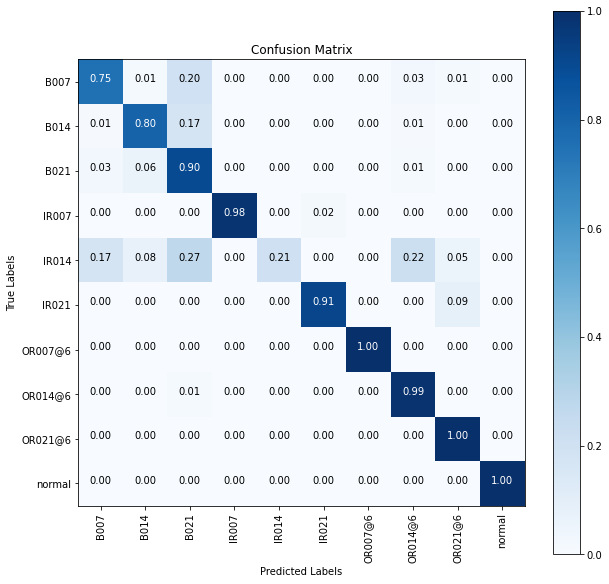

<Figure size 432x288 with 0 Axes>

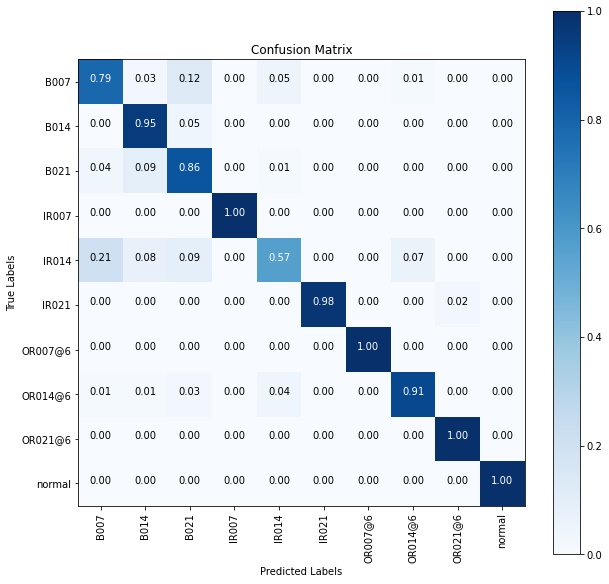

<Figure size 432x288 with 0 Axes>

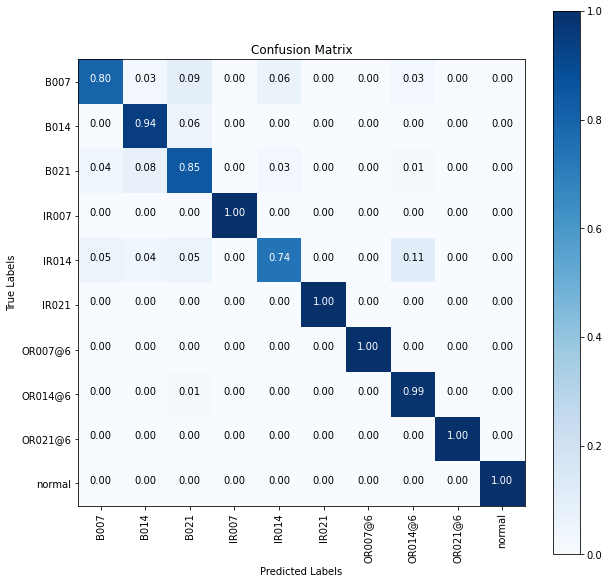

<Figure size 432x288 with 0 Axes>

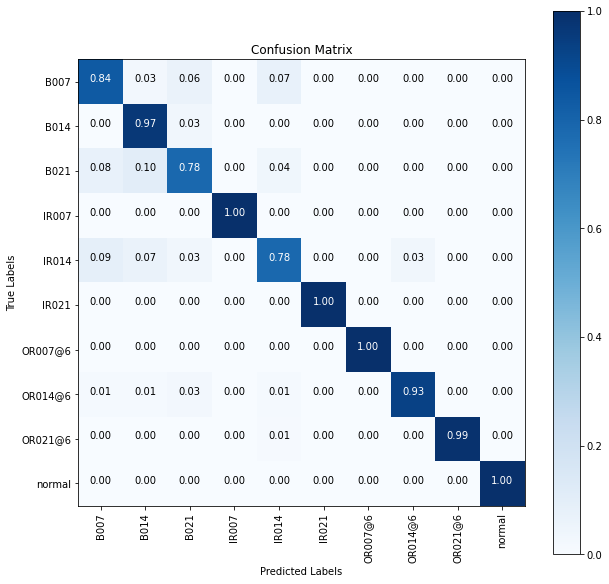

<Figure size 432x288 with 0 Axes>

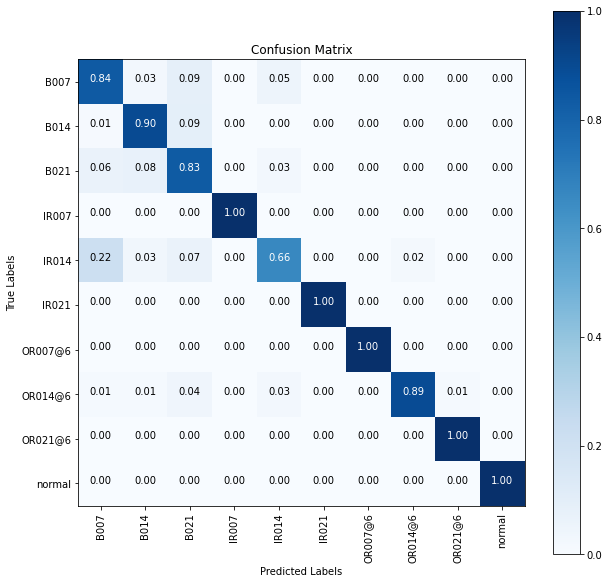

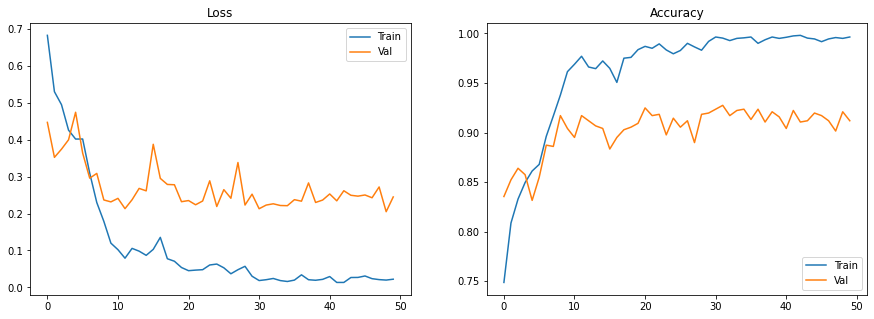

In [ ]:
Data.WaveDataset = {}
for status in ['Train', 'Val', 'Test']:
    Data.WaveDataset[status] = WaveletDataset(Data.FeatureMatrixProcessed[status], Data.TargetMatrix[status], IP)

CLF_CV_TL = CV_TL_Classifier()
CLF_CV_TL.PretrainedModelLoader()
CLF_CV_TL.PrepareModel(IP, Data)
CLF_CV_TL.DeepLearningSetting()

ActiveConfig = [[26,27,28,29,30,31,32,33,34,35]]
for unfrozen_parameters in ActiveConfig:
    CLF_CV_TL.UnfreezingLayers(unfrozen_parameters)
    CLF_CV_TL.TrainModel(IP, Data, Plots)

In [ ]:
CLF_CV_TL.model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1